In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [8]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(classifier.parameters(), lr = learning_rate)

    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    
    saved_dir= "./EEG/saved_models/Userfold/run2"
#     model= Multivariate_IEGradient(DEVICE, input_dim, resnet_classifier).to(DEVICE)
    model= EEGNet_Wrapper(DEVICE, classifier)
    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-Baseline-e{EPOCH}.pt"
           )
    )

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-Baseline-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6951048035247653


Iterations:   0%|                                   | 1/300 [00:01<07:55,  1.59s/it]

Epoch:  0
t_loss:  0.6951048035247653 , v_loss:  0.6990129748980204
t_acc:  0.5169623404917523 , v_acc:  0.4472049689440994
t_recall:  0.4886146223631298 , v_recall:  0.3682882882882883
t_prec:  0.49017547668864236 , v_prec:  0.3746140651801029
t_f:  0.4808872824787944 , v_f:  0.37112135176651306
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:57,  1.20s/it]

Epoch  1 , loss 0.6596706369343925
Epoch  2 , loss 0.6342019836107889


Iterations:   1%|▎                                  | 3/300 [00:03<06:30,  1.32s/it]

Epoch:  2
t_loss:  0.6342019836107889 , v_loss:  0.6984645128250122
t_acc:  0.5882352941176471 , v_acc:  0.5093167701863354
t_recall:  0.49067676809266964 , v_recall:  0.39684684684684685
t_prec:  0.48958944221601486 , v_prec:  0.3796763345943674
t_f:  0.4886346042685571 , v_f:  0.38665187828519065
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:34,  1.13s/it]

Epoch  3 , loss 0.6070840358734131
Epoch  4 , loss 0.585444452715855


Iterations:   2%|▌                                  | 5/300 [00:06<06:21,  1.29s/it]

Epoch:  4
t_loss:  0.585444452715855 , v_loss:  0.6917093594868978
t_acc:  0.6554621848739496 , v_acc:  0.6521739130434783
t_recall:  0.5119707388040241 , v_recall:  0.48945945945945946
t_prec:  0.5226271186440677 , v_prec:  0.4672818791946309
t_f:  0.49215434446295053 , v_f:  0.44069478908188586
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:37,  1.15s/it]

Epoch  5 , loss 0.5684442800634047
Epoch  6 , loss 0.5533267493341484


Iterations:   2%|▊                                  | 7/300 [00:08<06:10,  1.26s/it]

Epoch:  6
t_loss:  0.5533267493341484 , v_loss:  0.6837899486223856
t_acc:  0.6763149704326175 , v_acc:  0.6770186335403726
t_recall:  0.5062571197211128 , v_recall:  0.4964864864864865
t_prec:  0.5224868551285551 , v_prec:  0.46894904458598724
t_f:  0.46019889245720713 , v_f:  0.4215035931453841
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:35,  1.15s/it]

Epoch  7 , loss 0.5340229646832335
Epoch  8 , loss 0.5249442206878289


Iterations:   3%|█                                  | 9/300 [00:11<06:01,  1.24s/it]

Epoch:  8
t_loss:  0.5249442206878289 , v_loss:  0.6802067955334982
t_acc:  0.6856520385932151 , v_acc:  0.6894409937888198
t_recall:  0.5017547110251026 , v_recall:  0.5
t_prec:  0.5130821389834439 , v_prec:  0.3447204968944099
t_f:  0.43459590820644634 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:29,  1.14s/it]

Epoch  9 , loss 0.5118085858868617
Epoch  10 , loss 0.5001852126682506


Iterations:   4%|█▏                                | 11/300 [00:13<05:52,  1.22s/it]

Epoch:  10
t_loss:  0.5001852126682506 , v_loss:  0.6828505794207255
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5069646312842262 , v_recall:  0.5
t_prec:  0.5944022770398482 , v_prec:  0.3447204968944099
t_f:  0.43359689623486974 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:21,  1.11s/it]

Epoch  11 , loss 0.4964783238429649
Epoch  12 , loss 0.48149532255004435


Iterations:   4%|█▍                                | 13/300 [00:15<05:59,  1.25s/it]

Epoch:  12
t_loss:  0.48149532255004435 , v_loss:  0.6890733738740286
t_acc:  0.6940553999377529 , v_acc:  0.6894409937888198
t_recall:  0.5020443035368716 , v_recall:  0.5
t_prec:  0.5519460138104206 , v_prec:  0.3447204968944099
t_f:  0.4202793448364156 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:20,  1.12s/it]

Epoch  13 , loss 0.48147083439078986
Epoch  14 , loss 0.4760562812580782


Iterations:   5%|█▋                                | 15/300 [00:18<05:44,  1.21s/it]

Epoch:  14
t_loss:  0.4760562812580782 , v_loss:  0.6956628362337748
t_acc:  0.6937441643323996 , v_acc:  0.6894409937888198
t_recall:  0.499232785715266 , v_recall:  0.5
t_prec:  0.44764283484233536 , v_prec:  0.3447204968944099
t_f:  0.4115498523659419 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:20,  1.13s/it]

Epoch  15 , loss 0.46991054742944005
Epoch  16 , loss 0.4679807611540252


Iterations:   6%|█▉                                | 17/300 [00:20<06:01,  1.28s/it]

Epoch:  16
t_loss:  0.4679807611540252 , v_loss:  0.7032108207543691
t_acc:  0.6931216931216931 , v_acc:  0.6894409937888198
t_recall:  0.4990728922194315 , v_recall:  0.5
t_prec:  0.4547514848390122 , v_prec:  0.3447204968944099
t_f:  0.4122991291391122 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:21<05:22,  1.14s/it]

Epoch  17 , loss 0.46376680217537225
Epoch  18 , loss 0.4636137304352779


Iterations:   6%|██▏                               | 19/300 [00:22<05:43,  1.22s/it]

Epoch:  18
t_loss:  0.4636137304352779 , v_loss:  0.7089276810487112
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:24,  1.16s/it]

Epoch  19 , loss 0.46005940437316895
Epoch  20 , loss 0.45698617720136453


Iterations:   7%|██▍                               | 21/300 [00:25<05:44,  1.23s/it]

Epoch:  20
t_loss:  0.45698617720136453 , v_loss:  0.7137071788311005
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.4993288590604027 , v_recall:  0.5
t_prec:  0.34766355140186916 , v_prec:  0.3447204968944099
t_f:  0.40991735537190077 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:07,  1.11s/it]

Epoch  21 , loss 0.4658814347257801
Epoch  22 , loss 0.46128036812240003


Iterations:   8%|██▌                               | 23/300 [00:27<05:50,  1.26s/it]

Epoch:  22
t_loss:  0.46128036812240003 , v_loss:  0.7161617974440256
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:14,  1.14s/it]

Epoch  23 , loss 0.4586782180795483
Epoch  24 , loss 0.4539404879598057


Iterations:   8%|██▊                               | 25/300 [00:30<05:38,  1.23s/it]

Epoch:  24
t_loss:  0.4539404879598057 , v_loss:  0.7151073614756266
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:19,  1.17s/it]

Epoch  25 , loss 0.45350010605419383
Epoch  26 , loss 0.46444478397275885


Iterations:   9%|███                               | 27/300 [00:32<05:47,  1.27s/it]

Epoch:  26
t_loss:  0.46444478397275885 , v_loss:  0.7155022819836935
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.49955257270693515 , v_recall:  0.5
t_prec:  0.3477109934599813 , v_prec:  0.3447204968944099
t_f:  0.41002570694087404 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:11,  1.14s/it]

Epoch  27 , loss 0.4535006682078044
Epoch  28 , loss 0.4521501999275357


Iterations:  10%|███▎                              | 29/300 [00:34<05:36,  1.24s/it]

Epoch:  28
t_loss:  0.4521501999275357 , v_loss:  0.7143437365690867
t_acc:  0.6940553999377529 , v_acc:  0.6894409937888198
t_recall:  0.4988814317673378 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3447204968944099
t_f:  0.40970053279441476 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:07,  1.14s/it]

Epoch  29 , loss 0.45758192621025384
Epoch  30 , loss 0.4526831718052135


Iterations:  10%|███▌                              | 31/300 [00:37<05:41,  1.27s/it]

Epoch:  30
t_loss:  0.4526831718052135 , v_loss:  0.7089098940292994
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:04,  1.14s/it]

Epoch  31 , loss 0.452704554679347
Epoch  32 , loss 0.4496271353141934


Iterations:  11%|███▋                              | 33/300 [00:39<05:30,  1.24s/it]

Epoch:  32
t_loss:  0.4496271353141934 , v_loss:  0.7052672505378723
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5013100286847559 , v_recall:  0.5
t_prec:  0.7230835151137426 , v_prec:  0.3447204968944099
t_f:  0.4134150192068549 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:10,  1.17s/it]

Epoch  33 , loss 0.4492584420185463
Epoch  34 , loss 0.4477969963176578


Iterations:  12%|███▉                              | 35/300 [00:42<05:32,  1.26s/it]

Epoch:  34
t_loss:  0.4477969963176578 , v_loss:  0.7002509236335754
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:42<04:59,  1.14s/it]

Epoch  35 , loss 0.44702901968769
Epoch  36 , loss 0.4508014794658212


Iterations:  12%|████▏                             | 37/300 [00:44<05:23,  1.23s/it]

Epoch:  36
t_loss:  0.4508014794658212 , v_loss:  0.6969053596258163
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.49955257270693515 , v_recall:  0.5
t_prec:  0.3477109934599813 , v_prec:  0.3447204968944099
t_f:  0.41002570694087404 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:56,  1.13s/it]

Epoch  37 , loss 0.4469636000838934
Epoch  38 , loss 0.44900326518451467


Iterations:  13%|████▍                             | 39/300 [00:46<05:32,  1.28s/it]

Epoch:  38
t_loss:  0.44900326518451467 , v_loss:  0.6920211613178253
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:57,  1.14s/it]

Epoch  39 , loss 0.45138773964900597
Epoch  40 , loss 0.44229727925038803


Iterations:  14%|████▋                             | 41/300 [00:49<05:17,  1.23s/it]

Epoch:  40
t_loss:  0.44229727925038803 , v_loss:  0.6837899933258692
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5013100286847559 , v_recall:  0.5
t_prec:  0.7230835151137426 , v_prec:  0.3447204968944099
t_f:  0.4134150192068549 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:50,  1.13s/it]

Epoch  41 , loss 0.44147664425419825
Epoch  42 , loss 0.4437425580679202


Iterations:  14%|████▊                             | 43/300 [00:51<05:24,  1.26s/it]

Epoch:  42
t_loss:  0.4437425580679202 , v_loss:  0.6777543822924296
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5001914604520937 , v_recall:  0.5
t_prec:  0.5145131086142322 , v_prec:  0.3447204968944099
t_f:  0.4128574949243642 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:52,  1.14s/it]

Epoch  43 , loss 0.43905379608565687
Epoch  44 , loss 0.44341349893925236


Iterations:  15%|█████                             | 45/300 [00:53<05:12,  1.23s/it]

Epoch:  44
t_loss:  0.44341349893925236 , v_loss:  0.6721658656994501
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5013738488354538 , v_recall:  0.5
t_prec:  0.6338116032439176 , v_prec:  0.3447204968944099
t_f:  0.4142796235015772 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:48,  1.14s/it]

Epoch  45 , loss 0.4443367047637117
Epoch  46 , loss 0.44188687964981677


Iterations:  16%|█████▎                            | 47/300 [00:56<05:13,  1.24s/it]

Epoch:  46
t_loss:  0.44188687964981677 , v_loss:  0.668568288286527
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5024601638736773 , v_recall:  0.5
t_prec:  0.6399953139643861 , v_prec:  0.3447204968944099
t_f:  0.4172988159743127 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:42,  1.12s/it]

Epoch  47 , loss 0.44079233793651357
Epoch  48 , loss 0.4407027498179791


Iterations:  16%|█████▌                            | 49/300 [00:58<05:09,  1.23s/it]

Epoch:  48
t_loss:  0.4407027498179791 , v_loss:  0.6636166473229727
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5023325235722814 , v_recall:  0.5
t_prec:  0.7649672591206735 , v_prec:  0.3447204968944099
t_f:  0.4155921424153602 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:38,  1.11s/it]

Epoch  49 , loss 0.44391059641744574
Epoch  50 , loss 0.43624979316019546


Iterations:  17%|█████▊                            | 51/300 [01:01<05:05,  1.23s/it]

Epoch:  50
t_loss:  0.43624979316019546 , v_loss:  0.6542640080054601
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5016613826326841 , v_recall:  0.5
t_prec:  0.6259363295880149 , v_prec:  0.3447204968944099
t_f:  0.41525155202966746 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:43,  1.14s/it]

Epoch  51 , loss 0.4403422159307143
Epoch  52 , loss 0.4327641585293938


Iterations:  18%|██████                            | 53/300 [01:03<05:07,  1.24s/it]

Epoch:  52
t_loss:  0.4327641585293938 , v_loss:  0.6485442419846853
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5039939062049656 , v_recall:  0.5
t_prec:  0.6819887429643527 , v_prec:  0.3447204968944099
t_f:  0.42052512257253005 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:35,  1.12s/it]

Epoch  53 , loss 0.4364437308965945
Epoch  54 , loss 0.4434587248400146


Iterations:  18%|██████▏                           | 55/300 [01:05<04:55,  1.21s/it]

Epoch:  54
t_loss:  0.4434587248400146 , v_loss:  0.6455785731474558
t_acc:  0.6996576408341114 , v_acc:  0.6894409937888198
t_recall:  0.5069337505661465 , v_recall:  0.5
t_prec:  0.8159474671669793 , v_prec:  0.3447204968944099
t_f:  0.42528956144140956 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:37,  1.14s/it]

Epoch  55 , loss 0.4314935967033985
Epoch  56 , loss 0.43142717054077223


Iterations:  19%|██████▍                           | 57/300 [01:08<05:02,  1.24s/it]

Epoch:  56
t_loss:  0.43142717054077223 , v_loss:  0.6418919513622919
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5023002703778428 , v_recall:  0.5
t_prec:  0.5982952768220207 , v_prec:  0.3447204968944099
t_f:  0.4180261984276795 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:28,  1.11s/it]

Epoch  57 , loss 0.43527032581030156
Epoch  58 , loss 0.4305725150248584


Iterations:  20%|██████▋                           | 59/300 [01:10<04:54,  1.22s/it]

Epoch:  58
t_loss:  0.4305725150248584 , v_loss:  0.6380662818749746
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.506390249927945 , v_recall:  0.5
t_prec:  0.6825023518344309 , v_prec:  0.3447204968944099
t_f:  0.426550659742462 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:26,  1.11s/it]

Epoch  59 , loss 0.4411211206632502
Epoch  60 , loss 0.4384758881494111


Iterations:  20%|██████▉                           | 61/300 [01:12<04:59,  1.25s/it]

Epoch:  60
t_loss:  0.4384758881494111 , v_loss:  0.633465309937795
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5045051536487284 , v_recall:  0.51
t_prec:  0.6925144666875196 , v_prec:  0.846875
t_f:  0.4215965898483685 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:31,  1.14s/it]

Epoch  61 , loss 0.43680837575127096
Epoch  62 , loss 0.4415716815228556


Iterations:  21%|███████▏                          | 63/300 [01:15<04:52,  1.24s/it]

Epoch:  62
t_loss:  0.4415716815228556 , v_loss:  0.6329738050699234
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5040577263556635 , v_recall:  0.51
t_prec:  0.6542253521126761 , v_prec:  0.846875
t_f:  0.421357252213273 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:29,  1.14s/it]

Epoch  63 , loss 0.43335408030771744
Epoch  64 , loss 0.43382662534713745


Iterations:  22%|███████▎                          | 65/300 [01:17<04:46,  1.22s/it]

Epoch:  64
t_loss:  0.43382662534713745 , v_loss:  0.6282940953969955
t_acc:  0.6984126984126984 , v_acc:  0.6956521739130435
t_recall:  0.5060388959800167 , v_recall:  0.51
t_prec:  0.7175131002208087 , v_prec:  0.846875
t_f:  0.4247991718755456 , v_f:  0.42920193907821425
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:20,  1.11s/it]

Epoch  65 , loss 0.4300287979490617
Epoch  66 , loss 0.43711818550147263


Iterations:  22%|███████▌                          | 67/300 [01:20<04:53,  1.26s/it]

Epoch:  66
t_loss:  0.43711818550147263 , v_loss:  0.6240471651156744
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5050802212431891 , v_recall:  0.51
t_prec:  0.6738881929220168 , v_prec:  0.846875
t_f:  0.4234903114999342 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:26,  1.15s/it]

Epoch  67 , loss 0.42934436307233925
Epoch  68 , loss 0.43356010551546137


Iterations:  23%|███████▊                          | 69/300 [01:22<04:47,  1.24s/it]

Epoch:  68
t_loss:  0.43356010551546137 , v_loss:  0.6213999539613724
t_acc:  0.6981014628073452 , v_acc:  0.6956521739130435
t_recall:  0.5052401147390236 , v_recall:  0.51
t_prec:  0.7239208633093526 , v_prec:  0.846875
t_f:  0.42278672032193165 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:26,  1.16s/it]

Epoch  69 , loss 0.43569814457612877
Epoch  70 , loss 0.4322692074027716


Iterations:  24%|████████                          | 71/300 [01:24<04:51,  1.27s/it]

Epoch:  70
t_loss:  0.4322692074027716 , v_loss:  0.620137686530749
t_acc:  0.6965452847805789 , v_acc:  0.6956521739130435
t_recall:  0.5052716816952828 , v_recall:  0.51
t_prec:  0.6247942297695374 , v_prec:  0.846875
t_f:  0.42592753108751746 , v_f:  0.42920193907821425
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:31,  1.19s/it]

Epoch  71 , loss 0.42805372850567686
Epoch  72 , loss 0.433277169863383


Iterations:  24%|████████▎                         | 73/300 [01:27<04:48,  1.27s/it]

Epoch:  72
t_loss:  0.433277169863383 , v_loss:  0.6182329654693604
t_acc:  0.6968565203859322 , v_acc:  0.7018633540372671
t_recall:  0.5063579967335062 , v_recall:  0.52
t_prec:  0.6285781692356087 , v_prec:  0.8490566037735849
t_f:  0.4288227271997208 , v_f:  0.44957264957264953
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:19,  1.15s/it]

Epoch  73 , loss 0.43956824260599475
Epoch  74 , loss 0.4274205436893538


Iterations:  25%|████████▌                         | 75/300 [01:29<04:45,  1.27s/it]

Epoch:  74
t_loss:  0.4274205436893538 , v_loss:  0.6151073674360911
t_acc:  0.6996576408341114 , v_acc:  0.7018633540372671
t_recall:  0.50980908853845 , v_recall:  0.52
t_prec:  0.6927627438640654 , v_prec:  0.8490566037735849
t_f:  0.4345547418019834 , v_f:  0.44957264957264953
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:16,  1.14s/it]

Epoch  75 , loss 0.42668719560492274
Epoch  76 , loss 0.4323026362587424


Iterations:  26%|████████▋                         | 77/300 [01:32<04:33,  1.22s/it]

Epoch:  76
t_loss:  0.4323026362587424 , v_loss:  0.6088313261667887
t_acc:  0.6993464052287581 , v_acc:  0.7018633540372671
t_recall:  0.5084352397029961 , v_recall:  0.52
t_prec:  0.7067503924646782 , v_prec:  0.8490566037735849
t_f:  0.43076632456185404 , v_f:  0.44957264957264953
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:22,  1.18s/it]

Epoch  77 , loss 0.4317174518809599
Epoch  78 , loss 0.4307674894145891


Iterations:  26%|████████▉                         | 79/300 [01:34<04:41,  1.27s/it]

Epoch:  78
t_loss:  0.4307674894145891 , v_loss:  0.6059171060721079
t_acc:  0.7005913476501712 , v_acc:  0.7018633540372671
t_recall:  0.5119178984641989 , v_recall:  0.52
t_prec:  0.695600756859035 , v_prec:  0.8490566037735849
t_f:  0.43945615982241953 , v_f:  0.44957264957264953
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:10,  1.14s/it]

Epoch  79 , loss 0.4318208203596227
Epoch  80 , loss 0.4288142750076219


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:28,  1.23s/it]

Epoch:  80
t_loss:  0.4288142750076219 , v_loss:  0.6051752716302872
t_acc:  0.6999688764394647 , v_acc:  0.7080745341614907
t_recall:  0.5106078697794431 , v_recall:  0.53
t_prec:  0.692184003315375 , v_prec:  0.8512658227848101
t_f:  0.43649628131049234 , v_f:  0.4692431787893666
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:11,  1.16s/it]

Epoch  81 , loss 0.42928314501164005
Epoch  82 , loss 0.4310789301114924


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:38,  1.28s/it]

Epoch:  82
t_loss:  0.4310789301114924 , v_loss:  0.6036899834871292
t_acc:  0.6999688764394647 , v_acc:  0.7080745341614907
t_recall:  0.5108954035766734 , v_recall:  0.53
t_prec:  0.687641821619918 , v_prec:  0.8512658227848101
t_f:  0.43739537438532455 , v_f:  0.4692431787893666
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:07,  1.15s/it]

Epoch  83 , loss 0.42930030998061686
Epoch  84 , loss 0.4261564968847761


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:27,  1.24s/it]

Epoch:  84
t_loss:  0.4261564968847761 , v_loss:  0.5992431590954462
t_acc:  0.7012138188608776 , v_acc:  0.7080745341614907
t_recall:  0.5129403933517245 , v_recall:  0.53
t_prec:  0.7028565076450846 , v_prec:  0.8512658227848101
t_f:  0.4415095870131714 , v_f:  0.4692431787893666
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<04:11,  1.18s/it]

Epoch  85 , loss 0.4256065709918153
Epoch  86 , loss 0.42654908229322996


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:30,  1.27s/it]

Epoch:  86
t_loss:  0.42654908229322996 , v_loss:  0.5996552258729935
t_acc:  0.7009025832555245 , v_acc:  0.7080745341614907
t_recall:  0.5127166797051921 , v_recall:  0.53
t_prec:  0.6949810606060607 , v_prec:  0.8512658227848101
t_f:  0.44137095552975625 , v_f:  0.4692431787893666
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:02,  1.14s/it]

Epoch  87 , loss 0.43640508838728365
Epoch  88 , loss 0.43178429323084216


Iterations:  30%|██████████                        | 89/300 [01:46<04:19,  1.23s/it]

Epoch:  88
t_loss:  0.43178429323084216 , v_loss:  0.5985773106416067
t_acc:  0.7009025832555245 , v_acc:  0.7080745341614907
t_recall:  0.5115665445162707 , v_recall:  0.53
t_prec:  0.7151482401797263 , v_prec:  0.8512658227848101
t_f:  0.4378003938337614 , v_f:  0.4692431787893666
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<04:00,  1.14s/it]

Epoch  89 , loss 0.424222647559409
Epoch  90 , loss 0.4305919438016181


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:19,  1.24s/it]

Epoch:  90
t_loss:  0.4305919438016181 , v_loss:  0.5951660523811976
t_acc:  0.7018362900715842 , v_acc:  0.7080745341614907
t_recall:  0.5139628882392501 , v_recall:  0.53
t_prec:  0.7095008305761865 , v_prec:  0.8512658227848101
t_f:  0.4435556998565346 , v_f:  0.4692431787893666
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<03:52,  1.12s/it]

Epoch  91 , loss 0.42864860448182796
Epoch  92 , loss 0.4275576150884815


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:11,  1.22s/it]

Epoch:  92
t_loss:  0.4275576150884815 , v_loss:  0.5929732521375021
t_acc:  0.6999688764394647 , v_acc:  0.7080745341614907
t_recall:  0.5108954035766734 , v_recall:  0.53
t_prec:  0.687641821619918 , v_prec:  0.8512658227848101
t_f:  0.43739537438532455 , v_f:  0.4692431787893666
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<03:48,  1.11s/it]

Epoch  93 , loss 0.4242827296257019
Epoch  94 , loss 0.4269228262059829


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:13,  1.24s/it]

Epoch:  94
t_loss:  0.4269228262059829 , v_loss:  0.591470350821813
t_acc:  0.7030812324929971 , v_acc:  0.7142857142857143
t_recall:  0.5160078780143011 , v_recall:  0.54
t_prec:  0.7212488144166931 , v_prec:  0.8535031847133758
t_f:  0.4476261563945718 , v_f:  0.488253178551686
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<03:50,  1.13s/it]

Epoch  95 , loss 0.4284732967030768
Epoch  96 , loss 0.4199546306741004


Iterations:  32%|██████████▉                       | 97/300 [01:55<04:09,  1.23s/it]

Epoch:  96
t_loss:  0.4199546306741004 , v_loss:  0.5918584714333216
t_acc:  0.7024587612822907 , v_acc:  0.7080745341614907
t_recall:  0.514410315532315 , v_recall:  0.53
t_prec:  0.7258993373303881 , v_prec:  0.8512658227848101
t_f:  0.4438366304006165 , v_f:  0.4692431787893666
////////


Iterations:  33%|███████████                       | 98/300 [01:56<03:54,  1.16s/it]

Epoch  97 , loss 0.4311507244904836
Epoch  98 , loss 0.42576746788679387


Iterations:  33%|███████████▏                      | 99/300 [01:58<04:11,  1.25s/it]

Epoch:  98
t_loss:  0.42576746788679387 , v_loss:  0.5912315199772517
t_acc:  0.7030812324929971 , v_acc:  0.7204968944099379
t_recall:  0.5160078780143011 , v_recall:  0.55
t_prec:  0.7212488144166931 , v_prec:  0.8557692307692308
t_f:  0.4476261563945718 , v_f:  0.5066394279877425
////////


Iterations:  33%|███████████                      | 100/300 [01:59<03:47,  1.14s/it]

Epoch  99 , loss 0.42237648952241036
Epoch  100 , loss 0.4208180711549871


Iterations:  34%|███████████                      | 101/300 [02:00<04:09,  1.25s/it]

Epoch:  100
t_loss:  0.4208180711549871 , v_loss:  0.5904422452052435
t_acc:  0.6987239340180517 , v_acc:  0.7142857142857143
t_recall:  0.5100005489905436 , v_recall:  0.54
t_prec:  0.6567708482744772 , v_prec:  0.8535031847133758
t_f:  0.4368555002382812 , v_f:  0.488253178551686
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<03:44,  1.13s/it]

Epoch  101 , loss 0.42195289567405103
Epoch  102 , loss 0.4265090659552929


Iterations:  34%|███████████▎                     | 103/300 [02:03<04:01,  1.23s/it]

Epoch:  102
t_loss:  0.4265090659552929 , v_loss:  0.5896319796641668
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.510671689930141 , v_recall:  0.53
t_prec:  0.6793628702365209 , v_prec:  0.8512658227848101
t_f:  0.4372603899317808 , v_f:  0.4692431787893666
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:49,  1.17s/it]

Epoch  103 , loss 0.4222082682684356
Epoch  104 , loss 0.42445958361906166


Iterations:  35%|███████████▌                     | 105/300 [02:05<04:08,  1.27s/it]

Epoch:  104
t_loss:  0.42445958361906166 , v_loss:  0.5886485874652863
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5125567862093575 , v_recall:  0.53
t_prec:  0.6770363012461622 , v_prec:  0.8512658227848101
t_f:  0.4419755326322647 , v_f:  0.4692431787893666
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:40,  1.13s/it]

Epoch  105 , loss 0.4190403152914608
Epoch  106 , loss 0.42741285761197406


Iterations:  36%|███████████▊                     | 107/300 [02:07<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.42741285761197406 , v_loss:  0.5890257706244787
t_acc:  0.7021475256769374 , v_acc:  0.7080745341614907
t_recall:  0.5138990680885522 , v_recall:  0.53
t_prec:  0.722881666788937 , v_prec:  0.8512658227848101
t_f:  0.4428126820579124 , v_f:  0.4692431787893666
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:42,  1.16s/it]

Epoch  107 , loss 0.42591973613290224
Epoch  108 , loss 0.4205850818577935


Iterations:  36%|███████████▉                     | 109/300 [02:10<03:58,  1.25s/it]

Epoch:  108
t_loss:  0.4205850818577935 , v_loss:  0.5866886228322983
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5108315834259755 , v_recall:  0.53
t_prec:  0.7014772959357343 , v_prec:  0.8512658227848101
t_f:  0.43663036343591277 , v_f:  0.4692431787893666
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:32,  1.12s/it]

Epoch  109 , loss 0.4213847477062076
Epoch  110 , loss 0.41860335188753467


Iterations:  37%|████████████▏                    | 111/300 [02:12<03:56,  1.25s/it]

Epoch:  110
t_loss:  0.41860335188753467 , v_loss:  0.5851179212331772
t_acc:  0.7043261749144102 , v_acc:  0.7204968944099379
t_recall:  0.5189154691810434 , v_recall:  0.55
t_prec:  0.7185537583254044 , v_prec:  0.8557692307692308
t_f:  0.45423033845282385 , v_f:  0.5066394279877425
////////


Iterations:  37%|████████████▎                    | 112/300 [02:13<03:32,  1.13s/it]

Epoch  111 , loss 0.42269642914042754
Epoch  112 , loss 0.421670592883054


Iterations:  38%|████████████▍                    | 113/300 [02:15<03:53,  1.25s/it]

Epoch:  112
t_loss:  0.421670592883054 , v_loss:  0.5849439899126688
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.5151768435788694 , v_recall:  0.55
t_prec:  0.6844106463878327 , v_prec:  0.8557692307692308
t_f:  0.44777043865379496 , v_f:  0.5066394279877425
////////


Iterations:  38%|████████████▌                    | 114/300 [02:15<03:31,  1.14s/it]

Epoch  113 , loss 0.41915520733478023
Epoch  114 , loss 0.4226112523499657


Iterations:  38%|████████████▋                    | 115/300 [02:17<03:47,  1.23s/it]

Epoch:  114
t_loss:  0.4226112523499657 , v_loss:  0.5814672162135442
t_acc:  0.6999688764394647 , v_acc:  0.7204968944099379
t_recall:  0.5131956739545162 , v_recall:  0.55
t_prec:  0.6631493506493507 , v_prec:  0.8557692307692308
t_f:  0.4444574381991517 , v_f:  0.5066394279877425
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:27,  1.13s/it]

Epoch  115 , loss 0.42617569659270493
Epoch  116 , loss 0.4203445607540654


Iterations:  39%|████████████▊                    | 117/300 [02:19<03:42,  1.22s/it]

Epoch:  116
t_loss:  0.4203445607540654 , v_loss:  0.582599326968193
t_acc:  0.7018362900715842 , v_acc:  0.7204968944099379
t_recall:  0.5162631586170928 , v_recall:  0.55
t_prec:  0.6819622034991452 , v_prec:  0.8557692307692308
t_f:  0.45048880287925963 , v_f:  0.5066394279877425
////////


Iterations:  39%|████████████▉                    | 118/300 [02:20<03:19,  1.10s/it]

Epoch  117 , loss 0.42425388506814543
Epoch  118 , loss 0.4281836806559095


Iterations:  40%|█████████████                    | 119/300 [02:22<03:45,  1.25s/it]

Epoch:  118
t_loss:  0.4281836806559095 , v_loss:  0.5820451527833939
t_acc:  0.7018362900715842 , v_acc:  0.7204968944099379
t_recall:  0.5151130234281714 , v_recall:  0.55
t_prec:  0.6936530547641659 , v_prec:  0.8557692307692308
t_f:  0.4470503401712498 , v_f:  0.5066394279877425
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:22<03:22,  1.13s/it]

Epoch  119 , loss 0.41794449500009123
Epoch  120 , loss 0.42294692350368873


Iterations:  40%|█████████████▎                   | 121/300 [02:24<03:37,  1.22s/it]

Epoch:  120
t_loss:  0.42294692350368873 , v_loss:  0.5790459314982096
t_acc:  0.7052598817304699 , v_acc:  0.7204968944099379
t_recall:  0.5187240087289496 , v_recall:  0.55
t_prec:  0.7537950664136622 , v_prec:  0.8557692307692308
t_f:  0.4521105829769373 , v_f:  0.5066394279877425
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:25<03:20,  1.13s/it]

Epoch  121 , loss 0.42370401761111093
Epoch  122 , loss 0.42696160779279824


Iterations:  41%|█████████████▌                   | 123/300 [02:26<03:37,  1.23s/it]

Epoch:  122
t_loss:  0.42696160779279824 , v_loss:  0.577282577753067
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5170303729018267 , v_recall:  0.55
t_prec:  0.7264710534640937 , v_prec:  0.8557692307692308
t_f:  0.44965058619473613 , v_f:  0.5066394279877425
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:27<03:17,  1.12s/it]

Epoch  123 , loss 0.4251458650710536
Epoch  124 , loss 0.42726164647177156


Iterations:  42%|█████████████▊                   | 125/300 [02:29<03:33,  1.22s/it]

Epoch:  124
t_loss:  0.42726164647177156 , v_loss:  0.5781767219305038
t_acc:  0.7043261749144102 , v_acc:  0.7204968944099379
t_recall:  0.5200656043699647 , v_recall:  0.55
t_prec:  0.7050874403815581 , v_prec:  0.8557692307692308
t_f:  0.45759913851315337 , v_f:  0.5066394279877425
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:29<03:13,  1.11s/it]

Epoch  125 , loss 0.42860275799152897
Epoch  126 , loss 0.42287514548675686


Iterations:  42%|█████████████▉                   | 127/300 [02:31<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.42287514548675686 , v_loss:  0.5783041665951411
t_acc:  0.7021475256769374 , v_acc:  0.7204968944099379
t_recall:  0.5156242708719342 , v_recall:  0.55
t_prec:  0.6966261730669584 , v_prec:  0.8557692307692308
t_f:  0.4480599335591349 , v_f:  0.5066394279877425
////////


Iterations:  43%|██████████████                   | 128/300 [02:32<03:09,  1.10s/it]

Epoch  127 , loss 0.4203890252347086
Epoch  128 , loss 0.4249292167962766


Iterations:  43%|██████████████▏                  | 129/300 [02:33<03:27,  1.21s/it]

Epoch:  128
t_loss:  0.4249292167962766 , v_loss:  0.5778764734665552
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.514889309781639 , v_recall:  0.55
t_prec:  0.6873769359203178 , v_prec:  0.8557692307692308
t_f:  0.446906453796458 , v_f:  0.5066394279877425
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:34<03:08,  1.11s/it]

Epoch  129 , loss 0.4232493370187049
Epoch  130 , loss 0.4266958628215042


Iterations:  44%|██████████████▍                  | 131/300 [02:36<03:31,  1.25s/it]

Epoch:  130
t_loss:  0.4266958628215042 , v_loss:  0.5783264338970184
t_acc:  0.6999688764394647 , v_acc:  0.7204968944099379
t_recall:  0.5123330725628251 , v_recall:  0.55
t_prec:  0.6704584255453683 , v_prec:  0.8557692307692308
t_f:  0.4418360741764856 , v_f:  0.5066394279877425
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<03:09,  1.13s/it]

Epoch  131 , loss 0.4186406129715489
Epoch  132 , loss 0.4213001453409008


Iterations:  44%|██████████████▋                  | 133/300 [02:38<03:24,  1.23s/it]

Epoch:  132
t_loss:  0.4213001453409008 , v_loss:  0.5785660495360693
t_acc:  0.707749766573296 , v_acc:  0.7204968944099379
t_recall:  0.5233890558735126 , v_recall:  0.55
t_prec:  0.7576190476190476 , v_prec:  0.8557692307692308
t_f:  0.46180472494039637 , v_f:  0.5066394279877425
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:39<03:08,  1.14s/it]

Epoch  133 , loss 0.42481810847918194
Epoch  134 , loss 0.42011113114216747


Iterations:  45%|██████████████▊                  | 135/300 [02:40<03:20,  1.22s/it]

Epoch:  134
t_loss:  0.42011113114216747 , v_loss:  0.5772481461366018
t_acc:  0.7049486461251168 , v_acc:  0.7204968944099379
t_recall:  0.5185002950824172 , v_recall:  0.55
t_prec:  0.7460181782785389 , v_prec:  0.8557692307692308
t_f:  0.45196297868971613 , v_f:  0.5066394279877425
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:41<03:03,  1.12s/it]

Epoch  135 , loss 0.4203499438715916
Epoch  136 , loss 0.4199984634623808


Iterations:  46%|███████████████                  | 137/300 [02:43<03:24,  1.26s/it]

Epoch:  136
t_loss:  0.4199984634623808 , v_loss:  0.5749015261729559
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5170303729018267 , v_recall:  0.55
t_prec:  0.7264710534640937 , v_prec:  0.8557692307692308
t_f:  0.44965058619473613 , v_f:  0.5066394279877425
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:44<03:03,  1.13s/it]

Epoch  137 , loss 0.42382220193451525
Epoch  138 , loss 0.41888736568245233


Iterations:  46%|███████████████▎                 | 139/300 [02:45<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.41888736568245233 , v_loss:  0.5743558456500372
t_acc:  0.7030812324929971 , v_acc:  0.7204968944099379
t_recall:  0.5160078780143011 , v_recall:  0.55
t_prec:  0.7212488144166931 , v_prec:  0.8557692307692308
t_f:  0.4476261563945718 , v_f:  0.5066394279877425
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:46<02:59,  1.12s/it]

Epoch  139 , loss 0.4204086725618325
Epoch  140 , loss 0.41541016335580866


Iterations:  47%|███████████████▌                 | 141/300 [02:48<03:20,  1.26s/it]

Epoch:  140
t_loss:  0.41541016335580866 , v_loss:  0.5715532799561819
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5170303729018267 , v_recall:  0.55
t_prec:  0.7264710534640937 , v_prec:  0.8557692307692308
t_f:  0.44965058619473613 , v_f:  0.5066394279877425
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:48<02:59,  1.14s/it]

Epoch  141 , loss 0.4213601070291856
Epoch  142 , loss 0.42042718272583157


Iterations:  48%|███████████████▋                 | 143/300 [02:50<03:14,  1.24s/it]

Epoch:  142
t_loss:  0.42042718272583157 , v_loss:  0.5696615527073542
t_acc:  0.7024587612822907 , v_acc:  0.7204968944099379
t_recall:  0.5169981197073881 , v_recall:  0.55
t_prec:  0.6901853994123729 , v_prec:  0.8557692307692308
t_f:  0.451636007883687 , v_f:  0.5066394279877425
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:51<02:56,  1.13s/it]

Epoch  143 , loss 0.4168412434119804
Epoch  144 , loss 0.4218902675544514


Iterations:  48%|███████████████▉                 | 145/300 [02:52<03:12,  1.24s/it]

Epoch:  144
t_loss:  0.4218902675544514 , v_loss:  0.5701014349857966
t_acc:  0.704014939309057 , v_acc:  0.7204968944099379
t_recall:  0.5166790189538986 , v_recall:  0.55
t_prec:  0.7450067875431782 , v_prec:  0.8557692307692308
t_f:  0.4480583089852376 , v_f:  0.5066394279877425
////////


Iterations:  49%|████████████████                 | 146/300 [02:53<02:51,  1.11s/it]

Epoch  145 , loss 0.42215137797243457
Epoch  146 , loss 0.4176216978652805


Iterations:  49%|████████████████▏                | 147/300 [02:54<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.4176216978652805 , v_loss:  0.5685304800669352
t_acc:  0.7009025832555245 , v_acc:  0.7204968944099379
t_recall:  0.5144418824885741 , v_recall:  0.55
t_prec:  0.6754802881729037 , v_prec:  0.8557692307692308
t_f:  0.4466187607364932 , v_f:  0.5066394279877425
////////


Iterations:  49%|████████████████▎                | 148/300 [02:55<02:50,  1.12s/it]

Epoch  147 , loss 0.4221092111924115
Epoch  148 , loss 0.4171043412358153


Iterations:  50%|████████████████▍                | 149/300 [02:57<03:10,  1.26s/it]

Epoch:  148
t_loss:  0.4171043412358153 , v_loss:  0.5684475402037302
t_acc:  0.704014939309057 , v_acc:  0.7204968944099379
t_recall:  0.5178291541428199 , v_recall:  0.55
t_prec:  0.7243738845068801 , v_prec:  0.8557692307692308
t_f:  0.45152037284716534 , v_f:  0.5066394279877425
////////


Iterations:  50%|████████████████▌                | 150/300 [02:58<02:49,  1.13s/it]

Epoch  149 , loss 0.42340024662952797
Epoch  150 , loss 0.4200703396516688


Iterations:  50%|████████████████▌                | 151/300 [02:59<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.4200703396516688 , v_loss:  0.5661355902751287
t_acc:  0.7061935885465297 , v_acc:  0.7267080745341615
t_recall:  0.520257751060238 , v_recall:  0.56
t_prec:  0.7595758151313707 , v_prec:  0.8580645161290323
t_f:  0.45513102413534423 , v_f:  0.5244360902255639
////////


Iterations:  51%|████████████████▋                | 152/300 [03:00<02:47,  1.13s/it]

Epoch  151 , loss 0.4282310733608171
Epoch  152 , loss 0.4215424370531942


Iterations:  51%|████████████████▊                | 153/300 [03:02<03:00,  1.23s/it]

Epoch:  152
t_loss:  0.4215424370531942 , v_loss:  0.562354326248169
t_acc:  0.7071272953625894 , v_acc:  0.7267080745341615
t_recall:  0.522366560985987 , v_recall:  0.56
t_prec:  0.7542725929932595 , v_prec:  0.8580645161290323
t_f:  0.45982083913917454 , v_f:  0.5244360902255639
////////


Iterations:  51%|████████████████▉                | 154/300 [03:02<02:40,  1.10s/it]

Epoch  153 , loss 0.415779498277926
Epoch  154 , loss 0.4171544114748637


Iterations:  52%|█████████████████                | 155/300 [03:04<02:57,  1.22s/it]

Epoch:  154
t_loss:  0.4171544114748637 , v_loss:  0.5617792208989462
t_acc:  0.706504824151883 , v_acc:  0.7329192546583851
t_recall:  0.5222066674901524 , v_recall:  0.5700000000000001
t_prec:  0.7372202130779005 , v_prec:  0.8603896103896104
t_f:  0.4603480756595147 , v_f:  0.5416749420721615
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:05<02:39,  1.11s/it]

Epoch  155 , loss 0.41482475750586567
Epoch  156 , loss 0.4132273647130704


Iterations:  52%|█████████████████▎               | 157/300 [03:06<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.4132273647130704 , v_loss:  0.56292425096035
t_acc:  0.7061935885465297 , v_acc:  0.7267080745341615
t_recall:  0.5228455552353111 , v_recall:  0.56
t_prec:  0.7208094555873925 , v_prec:  0.8580645161290323
t_f:  0.4626785714285714 , v_f:  0.5244360902255639
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:07<02:39,  1.12s/it]

Epoch  157 , loss 0.41521451052497416
Epoch  158 , loss 0.42079023812331406


Iterations:  53%|█████████████████▍               | 159/300 [03:09<02:52,  1.22s/it]

Epoch:  158
t_loss:  0.42079023812331406 , v_loss:  0.5625720918178558
t_acc:  0.702769996887644 , v_acc:  0.7329192546583851
t_recall:  0.5172218333539205 , v_recall:  0.5700000000000001
t_prec:  0.6957851377215611 , v_prec:  0.8603896103896104
t_f:  0.4517841672453898 , v_f:  0.5416749420721615
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:09<02:36,  1.12s/it]

Epoch  159 , loss 0.4178433003378849
Epoch  160 , loss 0.41437214203909334


Iterations:  54%|█████████████████▋               | 161/300 [03:11<02:49,  1.22s/it]

Epoch:  160
t_loss:  0.41437214203909334 , v_loss:  0.5604444146156311
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.5231015220762822 , v_recall:  0.58
t_prec:  0.7626279437463593 , v_prec:  0.8627450980392157
t_f:  0.460968935124001 , v_f:  0.5583855799373041
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:12<02:32,  1.11s/it]

Epoch  161 , loss 0.413225206674314
Epoch  162 , loss 0.41675260779904383


Iterations:  54%|█████████████████▉               | 163/300 [03:13<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.41675260779904383 , v_loss:  0.5610361943642298
t_acc:  0.7043261749144102 , v_acc:  0.7453416149068323
t_recall:  0.5189154691810434 , v_recall:  0.59
t_prec:  0.7185537583254044 , v_prec:  0.8651315789473684
t_f:  0.45423033845282385 , v_f:  0.5745956048205194
////////


Iterations:  55%|██████████████████               | 164/300 [03:14<02:29,  1.10s/it]

Epoch  163 , loss 0.40980324967234744
Epoch  164 , loss 0.42119448909572527


Iterations:  55%|██████████████████▏              | 165/300 [03:16<02:41,  1.20s/it]

Epoch:  164
t_loss:  0.42119448909572527 , v_loss:  0.5582440396149954
t_acc:  0.7068160597572363 , v_acc:  0.7329192546583851
t_recall:  0.5235805163256063 , v_recall:  0.5754954954954955
t_prec:  0.7279130850047755 , v_prec:  0.8062865497076024
t_f:  0.4638169642857143 , v_f:  0.5538441709093253
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:17<02:32,  1.14s/it]

Epoch  165 , loss 0.4214927980712816
Epoch  166 , loss 0.4168936020019008


Iterations:  56%|██████████████████▎              | 167/300 [03:18<02:46,  1.25s/it]

Epoch:  166
t_loss:  0.4168936020019008 , v_loss:  0.5575319031874338
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.5154643773760997 , v_recall:  0.5654954954954955
t_prec:  0.6816498823124792 , v_prec:  0.7969771241830066
t_f:  0.44863093916265373 , v_f:  0.5373563218390804
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:19<02:27,  1.12s/it]

Epoch  167 , loss 0.41579388461860955
Epoch  168 , loss 0.4171264744272419


Iterations:  56%|██████████████████▌              | 169/300 [03:20<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.4171264744272419 , v_loss:  0.5586850841840109
t_acc:  0.7099284158107687 , v_acc:  0.7267080745341615
t_recall:  0.5281179231687734 , v_recall:  0.5654954954954955
t_prec:  0.7513433934486566 , v_prec:  0.7969771241830066
t_f:  0.4719337227018791 , v_f:  0.5373563218390804
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:21<02:29,  1.15s/it]

Epoch  169 , loss 0.4186088349304947
Epoch  170 , loss 0.4160112867168352


Iterations:  57%|██████████████████▊              | 171/300 [03:23<02:39,  1.23s/it]

Epoch:  170
t_loss:  0.4160112867168352 , v_loss:  0.5609219868977865
t_acc:  0.7055711173358232 , v_acc:  0.7329192546583851
t_recall:  0.5221105941450158 , v_recall:  0.5700000000000001
t_prec:  0.7137058261700095 , v_prec:  0.8603896103896104
t_f:  0.46154017857142854 , v_f:  0.5416749420721615
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:23<02:21,  1.11s/it]

Epoch  171 , loss 0.4218537135451448
Epoch  172 , loss 0.4206436247217889


Iterations:  58%|███████████████████              | 173/300 [03:25<02:34,  1.22s/it]

Epoch:  172
t_loss:  0.4206436247217889 , v_loss:  0.561004584034284
t_acc:  0.7061935885465297 , v_acc:  0.7329192546583851
t_recall:  0.5214078862491593 , v_recall:  0.5700000000000001
t_prec:  0.7395245748917394 , v_prec:  0.8603896103896104
t_f:  0.4585192379102517 , v_f:  0.5416749420721615
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:26<02:18,  1.10s/it]

Epoch  173 , loss 0.4149987720975689
Epoch  174 , loss 0.41955600474395005


Iterations:  58%|███████████████████▎             | 175/300 [03:27<02:30,  1.21s/it]

Epoch:  174
t_loss:  0.41955600474395005 , v_loss:  0.5594504078229269
t_acc:  0.7058823529411765 , v_acc:  0.7391304347826086
t_recall:  0.5234844429804697 , v_recall:  0.58
t_prec:  0.7073340172707665 , v_prec:  0.8627450980392157
t_f:  0.46497491732647195 , v_f:  0.5583855799373041
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:28<02:19,  1.12s/it]

Epoch  175 , loss 0.42659562417105135
Epoch  176 , loss 0.41684526263498795


Iterations:  59%|███████████████████▍             | 177/300 [03:30<02:28,  1.21s/it]

Epoch:  176
t_loss:  0.41684526263498795 , v_loss:  0.5624597618977228
t_acc:  0.7058823529411765 , v_acc:  0.7391304347826086
t_recall:  0.5208966388053966 , v_recall:  0.58
t_prec:  0.73756189148706 , v_prec:  0.8627450980392157
t_f:  0.45752464716952174 , v_f:  0.5583855799373041
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:30<02:15,  1.11s/it]

Epoch  177 , loss 0.4193756936811933
Epoch  178 , loss 0.41420837827757295


Iterations:  60%|███████████████████▋             | 179/300 [03:32<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.41420837827757295 , v_loss:  0.561276838183403
t_acc:  0.706504824151883 , v_acc:  0.7267080745341615
t_recall:  0.5224942012873828 , v_recall:  0.56
t_prec:  0.7332670721408849 , v_prec:  0.8580645161290323
t_f:  0.46118070937171285 , v_f:  0.5244360902255639
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:33<02:13,  1.11s/it]

Epoch  179 , loss 0.41866128234302297
Epoch  180 , loss 0.4114801877853917


Iterations:  60%|███████████████████▉             | 181/300 [03:34<02:29,  1.25s/it]

Epoch:  180
t_loss:  0.4114801877853917 , v_loss:  0.5611434181531271
t_acc:  0.7071272953625894 , v_acc:  0.7453416149068323
t_recall:  0.522366560985987 , v_recall:  0.59
t_prec:  0.7542725929932595 , v_prec:  0.8651315789473684
t_f:  0.45982083913917454 , v_f:  0.5745956048205194
////////


Iterations:  61%|████████████████████             | 182/300 [03:35<02:14,  1.14s/it]

Epoch  181 , loss 0.41536399196175966
Epoch  182 , loss 0.41116543669326633


Iterations:  61%|████████████████████▏            | 183/300 [03:37<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.41116543669326633 , v_loss:  0.557307148973147
t_acc:  0.7068160597572363 , v_acc:  0.7453416149068323
t_recall:  0.523292982528376 , v_recall:  0.59
t_prec:  0.7314190264078906 , v_prec:  0.8651315789473684
t_f:  0.46299349342387275 , v_f:  0.5745956048205194
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:38<02:11,  1.14s/it]

Epoch  183 , loss 0.4187479445747301
Epoch  184 , loss 0.4153071752950257


Iterations:  62%|████████████████████▎            | 185/300 [03:39<02:21,  1.23s/it]

Epoch:  184
t_loss:  0.4153071752950257 , v_loss:  0.5573412030935287
t_acc:  0.7055711173358232 , v_acc:  0.7453416149068323
t_recall:  0.5226856617394765 , v_recall:  0.59
t_prec:  0.7079886918443703 , v_prec:  0.8651315789473684
t_f:  0.46318425287632414 , v_f:  0.5745956048205194
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:40<02:09,  1.13s/it]

Epoch  185 , loss 0.41566333291577356
Epoch  186 , loss 0.4174451307923186


Iterations:  62%|████████████████████▌            | 187/300 [03:41<02:17,  1.21s/it]

Epoch:  186
t_loss:  0.4174451307923186 , v_loss:  0.5570515245199203
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5211519194081882 , v_recall:  0.59
t_prec:  0.7017036035249978 , v_prec:  0.8651315789473684
t_f:  0.46024614431438493 , v_f:  0.5745956048205194
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:42<02:06,  1.13s/it]

Epoch  187 , loss 0.4084806307858112
Epoch  188 , loss 0.4114995861754698


Iterations:  63%|████████████████████▊            | 189/300 [03:44<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.4114995861754698 , v_loss:  0.5539773404598236
t_acc:  0.7030812324929971 , v_acc:  0.7453416149068323
t_recall:  0.5188832159866046 , v_recall:  0.59
t_prec:  0.6876073814826599 , v_prec:  0.8651315789473684
t_f:  0.45615264620634244 , v_f:  0.5745956048205194
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:45<02:04,  1.13s/it]

Epoch  189 , loss 0.41806134815309565
Epoch  190 , loss 0.41203124382916617


Iterations:  64%|█████████████████████            | 191/300 [03:46<02:13,  1.22s/it]

Epoch:  190
t_loss:  0.41203124382916617 , v_loss:  0.554122214516004
t_acc:  0.7061935885465297 , v_acc:  0.7453416149068323
t_recall:  0.5239956904242324 , v_recall:  0.59
t_prec:  0.7092662783274817 , v_prec:  0.8651315789473684
t_f:  0.46594677131725076 , v_f:  0.5745956048205194
////////


Iterations:  64%|█████████████████████            | 192/300 [03:47<02:04,  1.15s/it]

Epoch  191 , loss 0.41181686111524995
Epoch  192 , loss 0.41701934442800637


Iterations:  64%|█████████████████████▏           | 193/300 [03:49<02:16,  1.27s/it]

Epoch:  192
t_loss:  0.41701934442800637 , v_loss:  0.5550843278566996
t_acc:  0.7074385309679427 , v_acc:  0.7391304347826086
t_recall:  0.5246030112131319 , v_recall:  0.58
t_prec:  0.7315163203981299 , v_prec:  0.8627450980392157
t_f:  0.4657738074180571 , v_f:  0.5583855799373041
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:49<02:00,  1.14s/it]

Epoch  193 , loss 0.41305555607758315
Epoch  194 , loss 0.4177699585755666


Iterations:  65%|█████████████████████▍           | 195/300 [03:51<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.4177699585755666 , v_loss:  0.5575367361307144
t_acc:  0.7061935885465297 , v_acc:  0.7391304347826086
t_recall:  0.5234206228297718 , v_recall:  0.58
t_prec:  0.7147270271630624 , v_prec:  0.8627450980392157
t_f:  0.4643191698892706 , v_f:  0.5583855799373041
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:52<01:58,  1.14s/it]

Epoch  195 , loss 0.40775223368523167
Epoch  196 , loss 0.4087983831471088


Iterations:  66%|█████████████████████▋           | 197/300 [03:53<02:05,  1.21s/it]

Epoch:  196
t_loss:  0.4087983831471088 , v_loss:  0.5548165688912073
t_acc:  0.7074385309679427 , v_acc:  0.7453416149068323
t_recall:  0.5231653422269801 , v_recall:  0.59
t_prec:  0.7512479160050809 , v_prec:  0.8651315789473684
t_f:  0.4616486468757931 , v_f:  0.5745956048205194
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:54<01:52,  1.10s/it]

Epoch  197 , loss 0.4140457621976441
Epoch  198 , loss 0.416583869971481


Iterations:  66%|█████████████████████▉           | 199/300 [03:56<02:07,  1.26s/it]

Epoch:  198
t_loss:  0.416583869971481 , v_loss:  0.553357849518458
t_acc:  0.7071272953625894 , v_acc:  0.7453416149068323
t_recall:  0.5238042299721387 , v_recall:  0.59
t_prec:  0.7332415882948871 , v_prec:  0.8651315789473684
t_f:  0.46397527299572217 , v_f:  0.5745956048205194
////////


Iterations:  67%|██████████████████████           | 200/300 [03:57<01:53,  1.13s/it]

Epoch  199 , loss 0.4128832746954525
Epoch  200 , loss 0.4096091541589475


Iterations:  67%|██████████████████████           | 201/300 [03:58<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.4096091541589475 , v_loss:  0.5521893451611201
t_acc:  0.7033924680983504 , v_acc:  0.7453416149068323
t_recall:  0.5188193958359067 , v_recall:  0.59
t_prec:  0.695158979419495 , v_prec:  0.8651315789473684
t_f:  0.45546682505964187 , v_f:  0.5745956048205194
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:59<01:53,  1.16s/it]

Epoch  201 , loss 0.4174177348613739
Epoch  202 , loss 0.41444601615269977


Iterations:  68%|██████████████████████▎          | 203/300 [04:00<02:01,  1.25s/it]

Epoch:  202
t_loss:  0.41444601615269977 , v_loss:  0.5529226660728455
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5214394532054185 , v_recall:  0.59
t_prec:  0.6991204588910134 , v_prec:  0.8651315789473684
t_f:  0.46107078602890994 , v_f:  0.5745956048205194
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:01<01:47,  1.12s/it]

Epoch  203 , loss 0.4139770906345517
Epoch  204 , loss 0.4173937591851926


Iterations:  68%|██████████████████████▌          | 205/300 [04:03<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.4173937591851926 , v_loss:  0.5520198196172714
t_acc:  0.7086834733893558 , v_acc:  0.7453416149068323
t_recall:  0.526648000988183 , v_recall:  0.59
t_prec:  0.7382039013617961 , v_prec:  0.8651315789473684
t_f:  0.469667343829355 , v_f:  0.5745956048205194
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:04<01:47,  1.14s/it]

Epoch  205 , loss 0.4200597621646582
Epoch  206 , loss 0.41166357783710256


Iterations:  69%|██████████████████████▊          | 207/300 [04:05<01:56,  1.25s/it]

Epoch:  206
t_loss:  0.41166357783710256 , v_loss:  0.5514983236789703
t_acc:  0.7052598817304699 , v_acc:  0.7453416149068323
t_recall:  0.5221744142957138 , v_recall:  0.59
t_prec:  0.7059464627151051 , v_prec:  0.8651315789473684
t_f:  0.4622065694092495 , v_f:  0.5745956048205194
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:06<01:43,  1.12s/it]

Epoch  207 , loss 0.41475866062968386
Epoch  208 , loss 0.4142706002674851


Iterations:  70%|██████████████████████▉          | 209/300 [04:07<01:51,  1.23s/it]

Epoch:  208
t_loss:  0.4142706002674851 , v_loss:  0.5481404910484949
t_acc:  0.706504824151883 , v_acc:  0.7515527950310559
t_recall:  0.5213440660984614 , v_recall:  0.6
t_prec:  0.7507147232999796 , v_prec:  0.8675496688741722
t_f:  0.45783000587109746 , v_f:  0.5903307888040712
////////


Iterations:  70%|███████████████████████          | 210/300 [04:08<01:41,  1.12s/it]

Epoch  209 , loss 0.40951717601102944
Epoch  210 , loss 0.4124249412732966


Iterations:  70%|███████████████████████▏         | 211/300 [04:10<01:51,  1.25s/it]

Epoch:  210
t_loss:  0.4124249412732966 , v_loss:  0.5480305602153143
t_acc:  0.7033924680983504 , v_acc:  0.7515527950310559
t_recall:  0.5202570648220585 , v_recall:  0.6
t_prec:  0.683369086270872 , v_prec:  0.8675496688741722
t_f:  0.4596240473457157 , v_f:  0.5903307888040712
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:11<01:38,  1.12s/it]

Epoch  211 , loss 0.41273269232581644
Epoch  212 , loss 0.41023730121406854


Iterations:  71%|███████████████████████▍         | 213/300 [04:12<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.41023730121406854 , v_loss:  0.5471309373776118
t_acc:  0.7068160597572363 , v_acc:  0.7515527950310559
t_recall:  0.5227179149339153 , v_recall:  0.6
t_prec:  0.7390805095762198 , v_prec:  0.8675496688741722
t_f:  0.46133663937262137 , v_f:  0.5903307888040712
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:13<01:38,  1.14s/it]

Epoch  213 , loss 0.4153236594854617
Epoch  214 , loss 0.4139282475499546


Iterations:  72%|███████████████████████▋         | 215/300 [04:15<01:46,  1.25s/it]

Epoch:  214
t_loss:  0.4139282475499546 , v_loss:  0.5480800072352091
t_acc:  0.707749766573296 , v_acc:  0.7515527950310559
t_recall:  0.5288521980208891 , v_recall:  0.6
t_prec:  0.7006477640051922 , v_prec:  0.8675496688741722
t_f:  0.4770686376586317 , v_f:  0.5903307888040712
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:15<01:34,  1.13s/it]

Epoch  215 , loss 0.411591019116196
Epoch  216 , loss 0.416962195260852


Iterations:  72%|███████████████████████▊         | 217/300 [04:17<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.416962195260852 , v_loss:  0.546542818347613
t_acc:  0.7096171802054155 , v_acc:  0.7515527950310559
t_recall:  0.5290443447111624 , v_recall:  0.6
t_prec:  0.7334370242901582 , v_prec:  0.8675496688741722
t_f:  0.47495448347612257 , v_f:  0.5903307888040712
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:18<01:32,  1.13s/it]

Epoch  217 , loss 0.40983882897040425
Epoch  218 , loss 0.4087592614632027


Iterations:  73%|████████████████████████         | 219/300 [04:19<01:43,  1.27s/it]

Epoch:  218
t_loss:  0.4087592614632027 , v_loss:  0.5452353656291962
t_acc:  0.7068160597572363 , v_acc:  0.7515527950310559
t_recall:  0.5247306515145277 , v_recall:  0.6
t_prec:  0.7156758697733802 , v_prec:  0.8675496688741722
t_f:  0.4670782400220871 , v_f:  0.5903307888040712
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:20<01:31,  1.14s/it]

Epoch  219 , loss 0.4126284852916119
Epoch  220 , loss 0.40701123195536


Iterations:  74%|████████████████████████▎        | 221/300 [04:22<01:37,  1.23s/it]

Epoch:  220
t_loss:  0.40701123195536 , v_loss:  0.5448279082775116
t_acc:  0.7061935885465297 , v_acc:  0.7515527950310559
t_recall:  0.5237081566270021 , v_recall:  0.6
t_prec:  0.711924917188075 , v_prec:  0.8675496688741722
t_f:  0.46513458608430674 , v_f:  0.5903307888040712
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:23<01:29,  1.14s/it]

Epoch  221 , loss 0.4110524619326872
Epoch  222 , loss 0.41484281537579554


Iterations:  74%|████████████████████████▌        | 223/300 [04:24<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.41484281537579554 , v_loss:  0.5438058574994405
t_acc:  0.7083722377840025 , v_acc:  0.7515527950310559
t_recall:  0.5264242873416506 , v_recall:  0.6
t_prec:  0.7332886350601407 , v_prec:  0.8675496688741722
t_f:  0.46950423019566584 , v_f:  0.5903307888040712
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:25<01:24,  1.12s/it]

Epoch  223 , loss 0.4141325833750706
Epoch  224 , loss 0.41369181403926775


Iterations:  75%|████████████████████████▊        | 225/300 [04:26<01:31,  1.21s/it]

Epoch:  224
t_loss:  0.41369181403926775 , v_loss:  0.5441380689541498
t_acc:  0.7099284158107687 , v_acc:  0.7515527950310559
t_recall:  0.527830389371543 , v_recall:  0.6
t_prec:  0.7551570390752144 , v_prec:  0.8675496688741722
t_f:  0.4711286719669493 , v_f:  0.5903307888040712
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:27<01:23,  1.13s/it]

Epoch  225 , loss 0.41175198204377117
Epoch  226 , loss 0.40766262190014707


Iterations:  76%|████████████████████████▉        | 227/300 [04:29<01:33,  1.27s/it]

Epoch:  226
t_loss:  0.40766262190014707 , v_loss:  0.5425017873446146
t_acc:  0.710239651416122 , v_acc:  0.7515527950310559
t_recall:  0.5283416368153059 , v_recall:  0.6
t_prec:  0.7565514842300557 , v_prec:  0.8675496688741722
t_f:  0.4720986233776089 , v_f:  0.5903307888040712
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:30<01:21,  1.13s/it]

Epoch  227 , loss 0.40917029480139416
Epoch  228 , loss 0.4117009739081065


Iterations:  76%|█████████████████████████▏       | 229/300 [04:31<01:26,  1.21s/it]

Epoch:  228
t_loss:  0.4117009739081065 , v_loss:  0.5420385996500651
t_acc:  0.7043261749144102 , v_acc:  0.7453416149068323
t_recall:  0.5212157395588861 , v_recall:  0.5954954954954955
t_prec:  0.6945120212069862 , v_prec:  0.8212121212121212
t_f:  0.4609144188504311 , v_f:  0.5853903649268262
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:32<01:19,  1.14s/it]

Epoch  229 , loss 0.4136797627981971
Epoch  230 , loss 0.41073879833314936


Iterations:  77%|█████████████████████████▍       | 231/300 [04:34<01:25,  1.23s/it]

Epoch:  230
t_loss:  0.41073879833314936 , v_loss:  0.541348859667778
t_acc:  0.7083722377840025 , v_acc:  0.7453416149068323
t_recall:  0.5255616859499594 , v_recall:  0.5954954954954955
t_prec:  0.7437549079486956 , v_prec:  0.8212121212121212
t_f:  0.4670712720996615 , v_f:  0.5853903649268262
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:34<01:16,  1.12s/it]

Epoch  231 , loss 0.41259942452112836
Epoch  232 , loss 0.414365175892325


Iterations:  78%|█████████████████████████▋       | 233/300 [04:36<01:24,  1.27s/it]

Epoch:  232
t_loss:  0.414365175892325 , v_loss:  0.5405142903327942
t_acc:  0.707749766573296 , v_acc:  0.7515527950310559
t_recall:  0.525401792454125 , v_recall:  0.6
t_prec:  0.7299397031539889 , v_prec:  0.8675496688741722
t_f:  0.46756241391146597 , v_f:  0.5903307888040712
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:37<01:15,  1.14s/it]

Epoch  233 , loss 0.4036114411611183
Epoch  234 , loss 0.4190223123513016


Iterations:  78%|█████████████████████████▊       | 235/300 [04:38<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.4190223123513016 , v_loss:  0.5415077159802119
t_acc:  0.7068160597572363 , v_acc:  0.7515527950310559
t_recall:  0.5247306515145277 , v_recall:  0.6
t_prec:  0.7156758697733802 , v_prec:  0.8675496688741722
t_f:  0.4670782400220871 , v_f:  0.5903307888040712
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:39<01:14,  1.17s/it]

Epoch  235 , loss 0.41345518067771314
Epoch  236 , loss 0.4061378006841622


Iterations:  79%|██████████████████████████       | 237/300 [04:41<01:20,  1.28s/it]

Epoch:  236
t_loss:  0.4061378006841622 , v_loss:  0.5394474218289057
t_acc:  0.7096171802054155 , v_acc:  0.7515527950310559
t_recall:  0.5290443447111624 , v_recall:  0.6
t_prec:  0.7334370242901582 , v_prec:  0.8675496688741722
t_f:  0.47495448347612257 , v_f:  0.5903307888040712
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:42<01:11,  1.15s/it]

Epoch  237 , loss 0.41290464588240083
Epoch  238 , loss 0.40645356476306915


Iterations:  80%|██████████████████████████▎      | 239/300 [04:43<01:15,  1.23s/it]

Epoch:  238
t_loss:  0.40645356476306915 , v_loss:  0.5395324726899465
t_acc:  0.711484593837535 , v_acc:  0.7515527950310559
t_recall:  0.5315367617792783 , v_recall:  0.6
t_prec:  0.7479319224848581 , v_prec:  0.8675496688741722
t_f:  0.4791144818000113 , v_f:  0.5903307888040712
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:44<01:09,  1.16s/it]

Epoch  239 , loss 0.4150560311242646
Epoch  240 , loss 0.4131097337778877


Iterations:  80%|██████████████████████████▌      | 241/300 [04:46<01:15,  1.28s/it]

Epoch:  240
t_loss:  0.4131097337778877 , v_loss:  0.538925106326739
t_acc:  0.7037037037037037 , v_acc:  0.7639751552795031
t_recall:  0.5199057108741302 , v_recall:  0.62
t_prec:  0.6923949379178606 , v_prec:  0.8724832214765101
t_f:  0.4581249999999999 , v_f:  0.6204714640198511
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:46<01:06,  1.14s/it]

Epoch  241 , loss 0.4089940090974172
Epoch  242 , loss 0.41495347607369515


Iterations:  81%|██████████████████████████▋      | 243/300 [04:48<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.41495347607369515 , v_loss:  0.5374725659688314
t_acc:  0.708994708994709 , v_acc:  0.7515527950310559
t_recall:  0.5277343160264064 , v_recall:  0.6054954954954955
t_prec:  0.7333519381038531 , v_prec:  0.8274608501118568
t_f:  0.472239082333658 , v_f:  0.6004962779156328
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:49<01:03,  1.14s/it]

Epoch  243 , loss 0.405860081022861
Epoch  244 , loss 0.41143207631859124


Iterations:  82%|██████████████████████████▉      | 245/300 [04:50<01:08,  1.25s/it]

Epoch:  244
t_loss:  0.41143207631859124 , v_loss:  0.539331724246343
t_acc:  0.7133520074696545 , v_acc:  0.7515527950310559
t_recall:  0.534604246441855 , v_recall:  0.6
t_prec:  0.7553559974342527 , v_prec:  0.8675496688741722
t_f:  0.484802922958775 , v_f:  0.5903307888040712
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:51<01:01,  1.13s/it]

Epoch  245 , loss 0.4160155800043368
Epoch  246 , loss 0.4080004195372264


Iterations:  82%|███████████████████████████▏     | 247/300 [04:53<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.4080004195372264 , v_loss:  0.5414737264315287
t_acc:  0.708994708994709 , v_acc:  0.7515527950310559
t_recall:  0.5285969174180974 , v_recall:  0.6
t_prec:  0.7248198075069416 , v_prec:  0.8675496688741722
t_f:  0.4746192453969909 , v_f:  0.5903307888040712
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:54<00:58,  1.13s/it]

Epoch  247 , loss 0.4120686434063257
Epoch  248 , loss 0.4063649983967052


Iterations:  83%|███████████████████████████▍     | 249/300 [04:55<01:04,  1.27s/it]

Epoch:  248
t_loss:  0.4063649983967052 , v_loss:  0.5388014018535614
t_acc:  0.7068160597572363 , v_acc:  0.7639751552795031
t_recall:  0.5227179149339153 , v_recall:  0.62
t_prec:  0.7390805095762198 , v_prec:  0.8724832214765101
t_f:  0.46133663937262137 , v_f:  0.6204714640198511
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:56<00:56,  1.13s/it]

Epoch  249 , loss 0.4038649955216576
Epoch  250 , loss 0.4064263245638679


Iterations:  84%|███████████████████████████▌     | 251/300 [04:57<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.4064263245638679 , v_loss:  0.5361829896767935
t_acc:  0.712729536258948 , v_acc:  0.7577639751552795
t_recall:  0.5344443529460206 , v_recall:  0.6154954954954954
t_prec:  0.7442196531791907 , v_prec:  0.8331600831600832
t_f:  0.4852170842856629 , v_f:  0.6151866151866152
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:58<00:54,  1.14s/it]

Epoch  251 , loss 0.4117753675170973
Epoch  252 , loss 0.40996402385188085


Iterations:  84%|███████████████████████████▊     | 253/300 [05:00<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.40996402385188085 , v_loss:  0.5370174596707026
t_acc:  0.7099284158107687 , v_acc:  0.7639751552795031
t_recall:  0.5295555921549251 , v_recall:  0.62
t_prec:  0.7349218181818182 , v_prec:  0.8724832214765101
t_f:  0.4759114838565148 , v_f:  0.6204714640198511
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:01<00:51,  1.11s/it]

Epoch  253 , loss 0.4173789351594214
Epoch  254 , loss 0.4124026316053727


Iterations:  85%|████████████████████████████     | 255/300 [05:02<00:57,  1.27s/it]

Epoch:  254
t_loss:  0.4124026316053727 , v_loss:  0.5370747943719228
t_acc:  0.7099284158107687 , v_acc:  0.7577639751552795
t_recall:  0.5309932611410768 , v_recall:  0.61
t_prec:  0.721921577619812 , v_prec:  0.87
t_f:  0.4798116944029462 , v_f:  0.6056152251742981
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:03<00:50,  1.15s/it]

Epoch  255 , loss 0.40376201301228765
Epoch  256 , loss 0.41186463774419296


Iterations:  86%|████████████████████████████▎    | 257/300 [05:04<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.41186463774419296 , v_loss:  0.5381066252787908
t_acc:  0.7055711173358232 , v_acc:  0.7577639751552795
t_recall:  0.5241233307256282 , v_recall:  0.61
t_prec:  0.6960773012248904 , v_prec:  0.87
t_f:  0.4672377745931408 , v_f:  0.6056152251742981
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:06<00:48,  1.17s/it]

Epoch  257 , loss 0.4091116493823482
Epoch  258 , loss 0.41013557478493334


Iterations:  86%|████████████████████████████▍    | 259/300 [05:07<00:52,  1.27s/it]

Epoch:  258
t_loss:  0.41013557478493334 , v_loss:  0.5362632671991984
t_acc:  0.7099284158107687 , v_acc:  0.7701863354037267
t_recall:  0.5292680583576947 , v_recall:  0.63
t_prec:  0.7378942593019537 , v_prec:  0.875
t_f:  0.47512220499028257 , v_f:  0.6349206349206349
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:08<00:45,  1.14s/it]

Epoch  259 , loss 0.40928057712667126
Epoch  260 , loss 0.41356369327096376


Iterations:  87%|████████████████████████████▋    | 261/300 [05:09<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.41356369327096376 , v_loss:  0.5374264766772588
t_acc:  0.7105508870214753 , v_acc:  0.7577639751552795
t_recall:  0.5302905532452203 , v_recall:  0.61
t_prec:  0.7407636363636363 , v_prec:  0.87
t_f:  0.4770361373246339 , v_f:  0.6056152251742981
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:10<00:44,  1.16s/it]

Epoch  261 , loss 0.40562250450545667
Epoch  262 , loss 0.4084043759925693


Iterations:  88%|████████████████████████████▉    | 263/300 [05:12<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.4084043759925693 , v_loss:  0.5371000468730927
t_acc:  0.706504824151883 , v_acc:  0.7639751552795031
t_recall:  0.5247944716652255 , v_recall:  0.62
t_prec:  0.7086165749259017 , v_prec:  0.8724832214765101
t_f:  0.4677234808990797 , v_f:  0.6204714640198511
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:13<00:40,  1.13s/it]

Epoch  263 , loss 0.4106193143947452
Epoch  264 , loss 0.4074354174674726


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:14<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.4074354174674726 , v_loss:  0.535092681646347
t_acc:  0.7099284158107687 , v_acc:  0.7639751552795031
t_recall:  0.5295555921549251 , v_recall:  0.62
t_prec:  0.7349218181818182 , v_prec:  0.8724832214765101
t_f:  0.4759114838565148 , v_f:  0.6204714640198511
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:15<00:38,  1.13s/it]

Epoch  265 , loss 0.40162351318434175
Epoch  266 , loss 0.4108615237123826


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:17<00:41,  1.26s/it]

Epoch:  266
t_loss:  0.4108615237123826 , v_loss:  0.53290955722332
t_acc:  0.707749766573296 , v_acc:  0.7577639751552795
t_recall:  0.5274145290347374 , v_recall:  0.6154954954954954
t_prec:  0.7109224855861627 , v_prec:  0.8331600831600832
t_f:  0.4731621530487461 , v_f:  0.6151866151866152
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:17<00:36,  1.13s/it]

Epoch  267 , loss 0.4092517127008999
Epoch  268 , loss 0.4071972948663375


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:19<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.4071972948663375 , v_loss:  0.5315553595622381
t_acc:  0.7130407718643013 , v_acc:  0.7701863354037267
t_recall:  0.5332303976064012 , v_recall:  0.6354954954954954
t_prec:  0.7641309090909092 , v_prec:  0.84337899543379
t_f:  0.48153475119711014 , v_f:  0.64340017958695
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:20<00:34,  1.14s/it]

Epoch  269 , loss 0.4087807319912256
Epoch  270 , loss 0.40875530827279183


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:21<00:35,  1.23s/it]

Epoch:  270
t_loss:  0.40875530827279183 , v_loss:  0.5298805435498556
t_acc:  0.708994708994709 , v_acc:  0.7639751552795031
t_recall:  0.5288844512153278 , v_recall:  0.6254954954954954
t_prec:  0.7222318040703691 , v_prec:  0.83843537414966
t_f:  0.4754064037279847 , v_f:  0.6294815891472869
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:22<00:31,  1.11s/it]

Epoch  271 , loss 0.4052969354624842
Epoch  272 , loss 0.40723905288705636


Iterations:  91%|██████████████████████████████   | 273/300 [05:24<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.40723905288705636 , v_loss:  0.5303273598353068
t_acc:  0.708994708994709 , v_acc:  0.7701863354037267
t_recall:  0.5280218498236368 , v_recall:  0.63
t_prec:  0.7303708439897698 , v_prec:  0.875
t_f:  0.4730356021160984 , v_f:  0.6349206349206349
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:24<00:29,  1.13s/it]

Epoch  273 , loss 0.407108102943383
Epoch  274 , loss 0.40649180961590187


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:26<00:30,  1.23s/it]

Epoch:  274
t_loss:  0.40649180961590187 , v_loss:  0.528996616601944
t_acc:  0.7133520074696545 , v_acc:  0.7701863354037267
t_recall:  0.5343167126446247 , v_recall:  0.6354954954954954
t_prec:  0.7585142679900745 , v_prec:  0.84337899543379
t_f:  0.4840336134453782 , v_f:  0.64340017958695
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:27<00:26,  1.12s/it]

Epoch  275 , loss 0.4082786797308454
Epoch  276 , loss 0.40352051339897455


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:28<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.40352051339897455 , v_loss:  0.5271157075961431
t_acc:  0.711484593837535 , v_acc:  0.7763975155279503
t_recall:  0.5326868969681997 , v_recall:  0.6454954954954955
t_prec:  0.7363855326019348 , v_prec:  0.8480603448275862
t_f:  0.48221788581138925 , v_f:  0.6569602272727273
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:29<00:25,  1.14s/it]

Epoch  277 , loss 0.4103767941979801
Epoch  278 , loss 0.4052571362140132


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:31<00:25,  1.24s/it]

Epoch:  278
t_loss:  0.4052571362140132 , v_loss:  0.5276718884706497
t_acc:  0.7111733582321818 , v_acc:  0.7763975155279503
t_recall:  0.5301629129438246 , v_recall:  0.6454954954954955
t_prec:  0.7567986539015821 , v_prec:  0.8480603448275862
t_f:  0.47579378195345956 , v_f:  0.6569602272727273
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:31<00:22,  1.11s/it]

Epoch  279 , loss 0.4077876964036156
Epoch  280 , loss 0.41424859096022215


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:33<00:23,  1.24s/it]

Epoch:  280
t_loss:  0.41424859096022215 , v_loss:  0.5271839201450348
t_acc:  0.7108621226268285 , v_acc:  0.7763975155279503
t_recall:  0.5336771386612865 , v_recall:  0.6454954954954955
t_prec:  0.7175721767710206 , v_prec:  0.8480603448275862
t_f:  0.4856757818093345 , v_f:  0.6569602272727273
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:34<00:20,  1.12s/it]

Epoch  281 , loss 0.41055264776828243
Epoch  282 , loss 0.40469356845406923


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:35<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.40469356845406923 , v_loss:  0.5292012592156728
t_acc:  0.7099284158107687 , v_acc:  0.782608695652174
t_recall:  0.5301306597493858 , v_recall:  0.65
t_prec:  0.7293735982057032 , v_prec:  0.8801369863013699
t_f:  0.4774807535264844 , v_f:  0.662675845555223
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:36<00:18,  1.13s/it]

Epoch  283 , loss 0.4137544275498858
Epoch  284 , loss 0.4016917163834852


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:38<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.4016917163834852 , v_loss:  0.5265489717324575
t_acc:  0.7149081854964208 , v_acc:  0.7763975155279503
t_recall:  0.53802308505236 , v_recall:  0.6454954954954955
t_prec:  0.752357731476702 , v_prec:  0.8480603448275862
t_f:  0.4917550953869703 , v_f:  0.6569602272727273
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:39<00:16,  1.15s/it]

Epoch  285 , loss 0.4070034228703555
Epoch  286 , loss 0.40821559522666184


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:40<00:16,  1.23s/it]

Epoch:  286
t_loss:  0.40821559522666184 , v_loss:  0.5264388124148051
t_acc:  0.7117958294428882 , v_acc:  0.7763975155279503
t_recall:  0.53118540783135 , v_recall:  0.6454954954954955
t_prec:  0.7593480345158198 , v_prec:  0.8480603448275862
t_f:  0.47771394987297616 , v_f:  0.6569602272727273
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:41<00:13,  1.11s/it]

Epoch  287 , loss 0.40755095318251966
Epoch  288 , loss 0.39944667938877554


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:43<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.39944667938877554 , v_loss:  0.5229967534542084
t_acc:  0.7149081854964208 , v_acc:  0.782608695652174
t_recall:  0.5362978822689779 , v_recall:  0.6554954954954955
t_prec:  0.7706166051585001 , v_prec:  0.8525326797385621
t_f:  0.48721767516545034 , v_f:  0.6701785191688616
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:43<00:11,  1.14s/it]

Epoch  289 , loss 0.4075770109307532
Epoch  290 , loss 0.4053363922764273


Iterations:  97%|████████████████████████████████ | 291/300 [05:45<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.4053363922764273 , v_loss:  0.5266544868548712
t_acc:  0.7093059446000622 , v_acc:  0.782608695652174
t_recall:  0.5319835028341637 , v_recall:  0.6554954954954955
t_prec:  0.7048179181437318 , v_prec:  0.8525326797385621
t_f:  0.4832861090295991 , v_f:  0.6701785191688616
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:46<00:09,  1.14s/it]

Epoch  291 , loss 0.4061558053773992
Epoch  292 , loss 0.4061729943051058


Iterations:  98%|████████████████████████████████▏| 293/300 [05:47<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.4061729943051058 , v_loss:  0.5241079479455948
t_acc:  0.7149081854964208 , v_acc:  0.782608695652174
t_recall:  0.5385981526468206 , v_recall:  0.6554954954954955
t_prec:  0.7471772185275247 , v_prec:  0.8525326797385621
t_f:  0.4932441925814912 , v_f:  0.6701785191688616
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:48<00:06,  1.14s/it]

Epoch  293 , loss 0.40492060955832987
Epoch  294 , loss 0.40238377335024816


Iterations:  98%|████████████████████████████████▍| 295/300 [05:50<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.40238377335024816 , v_loss:  0.5265686511993408
t_acc:  0.7121070650482415 , v_acc:  0.782608695652174
t_recall:  0.5337093918557253 , v_recall:  0.6554954954954955
t_prec:  0.7390085829392188 , v_prec:  0.8525326797385621
t_f:  0.4841016283469536 , v_f:  0.6701785191688616
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:51<00:04,  1.14s/it]

Epoch  295 , loss 0.400682773660211
Epoch  296 , loss 0.4016759810494442


Iterations:  99%|████████████████████████████████▋| 297/300 [05:52<00:03,  1.24s/it]

Epoch:  296
t_loss:  0.4016759810494442 , v_loss:  0.5264558295408884
t_acc:  0.7167755991285403 , v_acc:  0.782608695652174
t_recall:  0.5402279683232456 , v_recall:  0.6554954954954955
t_prec:  0.7669914556904374 , v_prec:  0.8525326797385621
t_f:  0.4950842104826889 , v_f:  0.6701785191688616
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:53<00:02,  1.12s/it]

Epoch  297 , loss 0.41175256932483
Epoch  298 , loss 0.4065943570698009


Iterations: 100%|████████████████████████████████▉| 299/300 [05:54<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.4065943570698009 , v_loss:  0.5230039159456888
t_acc:  0.7124183006535948 , v_acc:  0.782608695652174
t_recall:  0.5345081730967184 , v_recall:  0.6554954954954955
t_prec:  0.7377049180327868 , v_prec:  0.8525326797385621
t_f:  0.48580246913580244 , v_f:  0.6701785191688616
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:55<00:00,  1.19s/it]

Epoch  299 , loss 0.40749380985895794


110 16

c0_acc 0.990990990990991 , c1_acc 0.32 , b_acc 0.6554954954954955


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6898012278126735


Iterations:   0%|                                   | 1/300 [00:01<07:32,  1.51s/it]

Epoch:  0
t_loss:  0.6898012278126735 , v_loss:  0.6913708647092184
t_acc:  0.5258889582033687 , v_acc:  0.5714285714285714
t_recall:  0.4927623579169971 , v_recall:  0.549630844954881
t_prec:  0.49370502985847464 , v_prec:  0.543923333817337
t_f:  0.4863011388169257 , v_f:  0.5398660986001217
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:34,  1.12s/it]

Epoch  1 , loss 0.6619965422387216
Epoch  2 , loss 0.6354641692311156


Iterations:   1%|▎                                  | 3/300 [00:03<06:20,  1.28s/it]

Epoch:  2
t_loss:  0.6354641692311156 , v_loss:  0.6828028559684753
t_acc:  0.5913911416094823 , v_acc:  0.6190476190476191
t_recall:  0.5005624705490237 , v_recall:  0.5386382280557834
t_prec:  0.5006068728662108 , v_prec:  0.5425474254742547
t_f:  0.49978156400174756 , v_f:  0.539015606242497
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:33,  1.13s/it]

Epoch  3 , loss 0.6113034790637446
Epoch  4 , loss 0.5877010985916736


Iterations:   2%|▌                                  | 5/300 [00:06<06:07,  1.25s/it]

Epoch:  4
t_loss:  0.5877010985916736 , v_loss:  0.6672751704851786
t_acc:  0.6394260761072988 , v_acc:  0.6607142857142857
t_recall:  0.5108248571986805 , v_recall:  0.5283839212469237
t_prec:  0.5164287114696429 , v_prec:  0.5538605230386052
t_f:  0.4997656840513983 , v_f:  0.5108045977011495
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:34,  1.14s/it]

Epoch  5 , loss 0.5731906645438251
Epoch  6 , loss 0.5533712044650433


Iterations:   2%|▊                                  | 7/300 [00:08<06:01,  1.23s/it]

Epoch:  6
t_loss:  0.5533712044650433 , v_loss:  0.6525885065396627
t_acc:  0.6690580162195883 , v_acc:  0.6726190476190477
t_recall:  0.5147934121757519 , v_recall:  0.5014766201804758
t_prec:  0.5346514502804076 , v_prec:  0.5092592592592593
t_f:  0.48726461772448787 , v_f:  0.4346203267453956
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:23,  1.11s/it]

Epoch  7 , loss 0.5417526931154961
Epoch  8 , loss 0.5246661433986589


Iterations:   3%|█                                  | 9/300 [00:10<05:59,  1.24s/it]

Epoch:  8
t_loss:  0.5246661433986589 , v_loss:  0.6438626746336619
t_acc:  0.6781035558328135 , v_acc:  0.6845238095238095
t_recall:  0.5042590996333712 , v_recall:  0.5050861361771944
t_prec:  0.5174661827779611 , v_prec:  0.5933734939759037
t_f:  0.4532427742799068 , v_f:  0.4238757683597541
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:20,  1.11s/it]

Epoch  9 , loss 0.5133158921026716
Epoch  10 , loss 0.5046682749308792


Iterations:   4%|█▏                                | 11/300 [00:13<05:46,  1.20s/it]

Epoch:  10
t_loss:  0.5046682749308792 , v_loss:  0.6403177479902903
t_acc:  0.6896444167186525 , v_acc:  0.6785714285714286
t_recall:  0.509664287602432 , v_recall:  0.4956521739130435
t_prec:  0.5576918854834461 , v_prec:  0.3413173652694611
t_f:  0.4512981221662679 , v_f:  0.4042553191489362
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:25,  1.13s/it]

Epoch  11 , loss 0.49290350605459776
Epoch  12 , loss 0.490442390535392


Iterations:   4%|█▍                                | 13/300 [00:15<06:04,  1.27s/it]

Epoch:  12
t_loss:  0.490442390535392 , v_loss:  0.6405708193778992
t_acc:  0.6893325015595758 , v_acc:  0.6785714285714286
t_recall:  0.5007789998735763 , v_recall:  0.4956521739130435
t_prec:  0.5091262596069434 , v_prec:  0.3413173652694611
t_f:  0.42577576241914006 , v_f:  0.4042553191489362
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:24,  1.14s/it]

Epoch  13 , loss 0.48236822672918733
Epoch  14 , loss 0.4768766351774627


Iterations:   5%|█▋                                | 15/300 [00:17<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.4768766351774627 , v_loss:  0.6423399647076925
t_acc:  0.6940112289457268 , v_acc:  0.6845238095238095
t_recall:  0.5029858980105506 , v_recall:  0.5
t_prec:  0.5569137749737119 , v_prec:  0.34226190476190477
t_f:  0.4240202797921255 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:28,  1.16s/it]

Epoch  15 , loss 0.46816346049308777
Epoch  16 , loss 0.46914515191433476


Iterations:   6%|█▉                                | 17/300 [00:20<05:51,  1.24s/it]

Epoch:  16
t_loss:  0.46914515191433476 , v_loss:  0.6453304986159006
t_acc:  0.6927635683094199 , v_acc:  0.6845238095238095
t_recall:  0.5026668505556896 , v_recall:  0.5
t_prec:  0.5416954171698005 , v_prec:  0.34226190476190477
t_f:  0.42536093838794775 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:21<05:15,  1.12s/it]

Epoch  17 , loss 0.46407128958141103
Epoch  18 , loss 0.4607052236211066


Iterations:   6%|██▏                               | 19/300 [00:22<05:50,  1.25s/it]

Epoch:  18
t_loss:  0.4607052236211066 , v_loss:  0.6495775183041891
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.50105989035617 , v_recall:  0.5
t_prec:  0.5481667188968975 , v_prec:  0.34226190476190477
t_f:  0.41587248359657064 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:14,  1.12s/it]

Epoch  19 , loss 0.45327255188250076
Epoch  20 , loss 0.45693209182982353


Iterations:   7%|██▍                               | 21/300 [00:25<05:40,  1.22s/it]

Epoch:  20
t_loss:  0.45693209182982353 , v_loss:  0.6539073983828226
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.504873748692664 , v_recall:  0.5
t_prec:  0.6585034013605442 , v_prec:  0.34226190476190477
t_f:  0.42350272582204734 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:20,  1.15s/it]

Epoch  21 , loss 0.4581948308383717
Epoch  22 , loss 0.4583846815660888


Iterations:   8%|██▌                               | 23/300 [00:27<05:45,  1.25s/it]

Epoch:  22
t_loss:  0.4583846815660888 , v_loss:  0.6581394374370575
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5028870576607017 , v_recall:  0.5
t_prec:  0.5985561833019459 , v_prec:  0.34226190476190477
t_f:  0.4200557893770124 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:12,  1.13s/it]

Epoch  23 , loss 0.45534485753844767
Epoch  24 , loss 0.44987167914708454


Iterations:   8%|██▊                               | 25/300 [00:29<05:34,  1.22s/it]

Epoch:  24
t_loss:  0.44987167914708454 , v_loss:  0.6616692741711935
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5007065935707801 , v_recall:  0.5
t_prec:  0.5480913642052565 , v_prec:  0.34226190476190477
t_f:  0.4140480152349738 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:05,  1.12s/it]

Epoch  25 , loss 0.45278455287802455
Epoch  26 , loss 0.4447283581191418


Iterations:   9%|███                               | 27/300 [00:32<05:37,  1.24s/it]

Epoch:  26
t_loss:  0.4447283581191418 , v_loss:  0.6631602346897125
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5043609281798435 , v_recall:  0.5
t_prec:  0.6488700564971751 , v_prec:  0.34226190476190477
t_f:  0.4224350476770042 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:03,  1.11s/it]

Epoch  27 , loss 0.4468673333233478
Epoch  28 , loss 0.4447672635901208


Iterations:  10%|███▎                              | 29/300 [00:34<05:26,  1.20s/it]

Epoch:  28
t_loss:  0.4447672635901208 , v_loss:  0.6662500699361166
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.503494810881633 , v_recall:  0.5
t_prec:  0.6701127819548872 , v_prec:  0.34226190476190477
t_f:  0.41957400854354565 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:05,  1.13s/it]

Epoch  29 , loss 0.4435667378060958
Epoch  30 , loss 0.4468563508753683


Iterations:  10%|███▌                              | 31/300 [00:36<05:30,  1.23s/it]

Epoch:  30
t_loss:  0.4468563508753683 , v_loss:  0.6679164270559946
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5037189256283833 , v_recall:  0.5
t_prec:  0.6948854465296683 , v_prec:  0.34226190476190477
t_f:  0.4196919076110972 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:56,  1.11s/it]

Epoch  31 , loss 0.4444859302511402
Epoch  32 , loss 0.43791903701483037


Iterations:  11%|███▋                              | 33/300 [00:39<05:21,  1.20s/it]

Epoch:  32
t_loss:  0.43791903701483037 , v_loss:  0.6691032946109772
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5022450551092416 , v_recall:  0.5
t_prec:  0.6176491845142017 , v_prec:  0.34226190476190477
t_f:  0.4172988845496996 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:59,  1.13s/it]

Epoch  33 , loss 0.4372696204512727
Epoch  34 , loss 0.43604307081185134


Iterations:  12%|███▉                              | 35/300 [00:41<05:32,  1.25s/it]

Epoch:  34
t_loss:  0.43604307081185134 , v_loss:  0.669197678565979
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5022450551092416 , v_recall:  0.5
t_prec:  0.6176491845142017 , v_prec:  0.34226190476190477
t_f:  0.4172988845496996 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:42<04:58,  1.13s/it]

Epoch  35 , loss 0.4355143080739414
Epoch  36 , loss 0.43800388831718295


Iterations:  12%|████▏                             | 37/300 [00:43<05:19,  1.21s/it]

Epoch:  36
t_loss:  0.43800388831718295 , v_loss:  0.6697957416375478
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5037189256283833 , v_recall:  0.5
t_prec:  0.6948854465296683 , v_prec:  0.34226190476190477
t_f:  0.4196919076110972 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:51,  1.11s/it]

Epoch  37 , loss 0.43492083222258326
Epoch  38 , loss 0.43256959494422464


Iterations:  13%|████▍                             | 39/300 [00:46<05:31,  1.27s/it]

Epoch:  38
t_loss:  0.43256959494422464 , v_loss:  0.6713200906912485
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5032706961348826 , v_recall:  0.5
t_prec:  0.648636790974616 , v_prec:  0.34226190476190477
t_f:  0.4194560879916837 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:56,  1.14s/it]

Epoch  39 , loss 0.44239727422302844
Epoch  40 , loss 0.42634519613256644


Iterations:  14%|████▋                             | 41/300 [00:48<05:21,  1.24s/it]

Epoch:  40
t_loss:  0.42634519613256644 , v_loss:  0.6728513936201731
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5070845544713766 , v_recall:  0.5
t_prec:  0.7304029304029304 , v_prec:  0.34226190476190477
t_f:  0.42706868834273576 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:54,  1.14s/it]

Epoch  41 , loss 0.43065102369177577
Epoch  42 , loss 0.43327267380321727


Iterations:  14%|████▊                             | 43/300 [00:51<05:17,  1.24s/it]

Epoch:  42
t_loss:  0.43327267380321727 , v_loss:  0.6730950772762299
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5033352871542024 , v_recall:  0.5
t_prec:  0.6264289697476648 , v_prec:  0.34226190476190477
t_f:  0.42029378188377886 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:45,  1.12s/it]

Epoch  43 , loss 0.43430493859683766
Epoch  44 , loss 0.43134598404753444


Iterations:  15%|█████                             | 45/300 [00:53<05:09,  1.21s/it]

Epoch:  44
t_loss:  0.43134598404753444 , v_loss:  0.6755956610043844
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5054815019135951 , v_recall:  0.5
t_prec:  0.7491068630523348 , v_prec:  0.34226190476190477
t_f:  0.42303969238679684 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:39,  1.10s/it]

Epoch  45 , loss 0.42736571325975303
Epoch  46 , loss 0.4279198430332483


Iterations:  16%|█████▎                            | 47/300 [00:55<05:15,  1.25s/it]

Epoch:  46
t_loss:  0.4279198430332483 , v_loss:  0.6754283209641775
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5053865692054844 , v_recall:  0.5
t_prec:  0.6672710141617177 , v_prec:  0.34226190476190477
t_f:  0.42456844216861117 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:45,  1.13s/it]

Epoch  47 , loss 0.4248271970187916
Epoch  48 , loss 0.4413851067131641


Iterations:  16%|█████▌                            | 49/300 [00:58<05:04,  1.21s/it]

Epoch:  48
t_loss:  0.4413851067131641 , v_loss:  0.6756298442681631
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5058044570101944 , v_recall:  0.5
t_prec:  0.6325146935348447 , v_prec:  0.34226190476190477
t_f:  0.42712441123400935 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:42,  1.13s/it]

Epoch  49 , loss 0.4306679511187123
Epoch  50 , loss 0.42914404588587146


Iterations:  17%|█████▊                            | 51/300 [01:00<05:03,  1.22s/it]

Epoch:  50
t_loss:  0.42914404588587146 , v_loss:  0.675128291050593
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5087521980484777 , v_recall:  0.5
t_prec:  0.6998110831234257 , v_prec:  0.34226190476190477
t_f:  0.4318442925008764 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:36,  1.12s/it]

Epoch  51 , loss 0.42932728517289254
Epoch  52 , loss 0.43735550957567554


Iterations:  18%|██████                            | 53/300 [01:02<05:10,  1.26s/it]

Epoch:  52
t_loss:  0.43735550957567554 , v_loss:  0.6766688227653503
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5082393775356572 , v_recall:  0.5
t_prec:  0.6945285619701953 , v_prec:  0.34226190476190477
t_f:  0.4307930997901883 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:36,  1.12s/it]

Epoch  53 , loss 0.42843685781254487
Epoch  54 , loss 0.429060419400533


Iterations:  18%|██████▏                           | 55/300 [01:05<04:59,  1.22s/it]

Epoch:  54
t_loss:  0.429060419400533 , v_loss:  0.6761689782142639
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5051624544587341 , v_recall:  0.5
t_prec:  0.6533896105670067 , v_prec:  0.34226190476190477
t_f:  0.424445492388545 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:40,  1.15s/it]

Epoch  55 , loss 0.42952076886214463
Epoch  56 , loss 0.42940860168606626


Iterations:  19%|██████▍                           | 57/300 [01:07<05:08,  1.27s/it]

Epoch:  56
t_loss:  0.42940860168606626 , v_loss:  0.6768873731295267
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.508976312795228 , v_recall:  0.5
t_prec:  0.7119273224577514 , v_prec:  0.34226190476190477
t_f:  0.4319740269690469 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:38,  1.15s/it]

Epoch  57 , loss 0.4304870156680836
Epoch  58 , loss 0.44305705965733994


Iterations:  20%|██████▋                           | 59/300 [01:09<04:55,  1.23s/it]

Epoch:  58
t_loss:  0.44305705965733994 , v_loss:  0.67723015944163
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5103552506062591 , v_recall:  0.5
t_prec:  0.6973799509288467 , v_prec:  0.34226190476190477
t_f:  0.4357629856067611 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:30,  1.13s/it]

Epoch  59 , loss 0.42537931718078315
Epoch  60 , loss 0.42863185849844243


Iterations:  20%|██████▉                           | 61/300 [01:12<04:53,  1.23s/it]

Epoch:  60
t_loss:  0.42863185849844243 , v_loss:  0.6777659058570862
t_acc:  0.6986899563318777 , v_acc:  0.6904761904761905
t_recall:  0.5095233826385777 , v_recall:  0.5094339622641509
t_prec:  0.6523097736179223 , v_prec:  0.844311377245509
t_f:  0.4359963373405509 , v_f:  0.4263199369582348
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:24,  1.11s/it]

Epoch  61 , loss 0.429555298650966
Epoch  62 , loss 0.4257854077161527


Iterations:  21%|███████▏                          | 63/300 [01:14<04:48,  1.22s/it]

Epoch:  62
t_loss:  0.4257854077161527 , v_loss:  0.6779881517092387
t_acc:  0.6958827199001871 , v_acc:  0.6964285714285714
t_recall:  0.5054854095553334 , v_recall:  0.5188679245283019
t_prec:  0.5991161616161615 , v_prec:  0.8463855421686747
t_f:  0.42846167081140213 , v_f:  0.44561630540278224
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:25,  1.13s/it]

Epoch  63 , loss 0.4303789331632502
Epoch  64 , loss 0.4222155791871688


Iterations:  22%|███████▎                          | 65/300 [01:17<04:54,  1.25s/it]

Epoch:  64
t_loss:  0.4222155791871688 , v_loss:  0.6767371594905853
t_acc:  0.6999376169681847 , v_acc:  0.6964285714285714
t_recall:  0.510419841625579 , v_recall:  0.5188679245283019
t_prec:  0.6835069992632354 , v_prec:  0.8463855421686747
t_f:  0.4365339489459535 , v_f:  0.44561630540278224
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:22,  1.12s/it]

Epoch  65 , loss 0.424238711011176
Epoch  66 , loss 0.4325997426229365


Iterations:  22%|███████▌                          | 67/300 [01:19<04:38,  1.20s/it]

Epoch:  66
t_loss:  0.4325997426229365 , v_loss:  0.6784308552742004
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5122470089301107 , v_recall:  0.5188679245283019
t_prec:  0.6914783508711402 , v_prec:  0.8463855421686747
t_f:  0.44052907605486485 , v_f:  0.44561630540278224
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:24,  1.14s/it]

Epoch  67 , loss 0.42792260325422476
Epoch  68 , loss 0.4352450779840058


Iterations:  23%|███████▊                          | 69/300 [01:21<04:43,  1.23s/it]

Epoch:  68
t_loss:  0.4352450779840058 , v_loss:  0.6784305622180303
t_acc:  0.6986899563318777 , v_acc:  0.6964285714285714
t_recall:  0.5077911480421565 , v_recall:  0.5188679245283019
t_prec:  0.6721869443738888 , v_prec:  0.8463855421686747
t_f:  0.4305355436746888 , v_f:  0.44561630540278224
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:12,  1.10s/it]

Epoch  69 , loss 0.4232719639937083
Epoch  70 , loss 0.42653753535420286


Iterations:  24%|████████                          | 71/300 [01:23<04:36,  1.21s/it]

Epoch:  70
t_loss:  0.42653753535420286 , v_loss:  0.6779833187659582
t_acc:  0.7036805988771054 , v_acc:  0.6964285714285714
t_recall:  0.5151301589490742 , v_recall:  0.5188679245283019
t_prec:  0.7536238585134667 , v_prec:  0.8463855421686747
t_f:  0.4444521459465454 , v_f:  0.44561630540278224
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:11,  1.10s/it]

Epoch  71 , loss 0.4233924448490143
Epoch  72 , loss 0.41667403894312244


Iterations:  24%|████████▎                         | 73/300 [01:26<04:40,  1.24s/it]

Epoch:  72
t_loss:  0.41667403894312244 , v_loss:  0.6783763815959295
t_acc:  0.7014971927635683 , v_acc:  0.6964285714285714
t_recall:  0.5132726499557517 , v_recall:  0.5188679245283019
t_prec:  0.698617226197028 , v_prec:  0.8463855421686747
t_f:  0.4425827788941957 , v_f:  0.44561630540278224
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:13,  1.12s/it]

Epoch  73 , loss 0.42213522745113746
Epoch  74 , loss 0.4241367035052356


Iterations:  25%|████████▌                         | 75/300 [01:28<04:32,  1.21s/it]

Epoch:  74
t_loss:  0.4241367035052356 , v_loss:  0.6792299598455429
t_acc:  0.7011852776044916 , v_acc:  0.6964285714285714
t_recall:  0.5136259467411417 , v_recall:  0.5188679245283019
t_prec:  0.6842049656629687 , v_prec:  0.8463855421686747
t_f:  0.44420412751563687 , v_f:  0.44561630540278224
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:15,  1.14s/it]

Epoch  75 , loss 0.43300650634017646
Epoch  76 , loss 0.4205135533622667


Iterations:  26%|████████▋                         | 77/300 [01:30<04:33,  1.23s/it]

Epoch:  76
t_loss:  0.4205135533622667 , v_loss:  0.6795147111018499
t_acc:  0.7014971927635683 , v_acc:  0.6964285714285714
t_recall:  0.5135613557218218 , v_recall:  0.5188679245283019
t_prec:  0.6946049715009499 , v_prec:  0.8463855421686747
t_f:  0.4434660808456893 , v_f:  0.44561630540278224
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:06,  1.11s/it]

Epoch  77 , loss 0.42749976469021217
Epoch  78 , loss 0.41839176883884505


Iterations:  26%|████████▉                         | 79/300 [01:33<04:35,  1.24s/it]

Epoch:  78
t_loss:  0.41839176883884505 , v_loss:  0.6801483879486719
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5136905377604616 , v_recall:  0.5188679245283019
t_prec:  0.6749623989471705 , v_prec:  0.8463855421686747
t_f:  0.4449368824252718 , v_f:  0.44561630540278224
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:06,  1.12s/it]

Epoch  79 , loss 0.43239903800627766
Epoch  80 , loss 0.4200167474793453


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:24,  1.21s/it]

Epoch:  80
t_loss:  0.4200167474793453 , v_loss:  0.6805725594361623
t_acc:  0.7024329382407986 , v_acc:  0.6964285714285714
t_recall:  0.5139449941960027 , v_recall:  0.5188679245283019
t_prec:  0.7230256821239771 , v_prec:  0.8463855421686747
t_f:  0.4430025940195502 , v_f:  0.44561630540278224
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:08,  1.14s/it]

Epoch  81 , loss 0.4222308391449498
Epoch  82 , loss 0.42105835384013607


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:30,  1.25s/it]

Epoch:  82
t_loss:  0.42105835384013607 , v_loss:  0.6799811373154322
t_acc:  0.7011852776044916 , v_acc:  0.6964285714285714
t_recall:  0.5139146525072119 , v_recall:  0.5188679245283019
t_prec:  0.6811242961181025 , v_prec:  0.8463855421686747
t_f:  0.44507938205722675 , v_f:  0.44561630540278224
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:04,  1.13s/it]

Epoch  83 , loss 0.4180927241549772
Epoch  84 , loss 0.42156073275734396


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:21,  1.22s/it]

Epoch:  84
t_loss:  0.42156073275734396 , v_loss:  0.6803318162759145
t_acc:  0.7014971927635683 , v_acc:  0.6964285714285714
t_recall:  0.5150048845521727 , v_recall:  0.5188679245283019
t_prec:  0.6787615563247601 , v_prec:  0.8463855421686747
t_f:  0.44782900480463717 , v_f:  0.44561630540278224
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:56,  1.11s/it]

Epoch  85 , loss 0.41715867466786327
Epoch  86 , loss 0.43063441211102055


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:26,  1.25s/it]

Epoch:  86
t_loss:  0.43063441211102055 , v_loss:  0.6789665420850118
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5131131262283212 , v_recall:  0.5188679245283019
t_prec:  0.6807604562737642 , v_prec:  0.8463855421686747
t_f:  0.4431845409228178 , v_f:  0.44561630540278224
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:58,  1.13s/it]

Epoch  87 , loss 0.4194315876446518
Epoch  88 , loss 0.41881028343649473


Iterations:  30%|██████████                        | 89/300 [01:45<04:13,  1.20s/it]

Epoch:  88
t_loss:  0.41881028343649473 , v_loss:  0.6805376956860224
t_acc:  0.7018091079226451 , v_acc:  0.6964285714285714
t_recall:  0.5143628820007126 , v_recall:  0.5188679245283019
t_prec:  0.6941673658369846 , v_prec:  0.8463855421686747
t_f:  0.4453644529279216 , v_f:  0.44561630540278224
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<04:00,  1.14s/it]

Epoch  89 , loss 0.4174856052679174
Epoch  90 , loss 0.4182852646883796


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:23,  1.26s/it]

Epoch:  90
t_loss:  0.4182852646883796 , v_loss:  0.6796161532402039
t_acc:  0.7024329382407986 , v_acc:  0.7023809523809523
t_recall:  0.5165433460906342 , v_recall:  0.5283018867924528
t_prec:  0.6875759076337669 , v_prec:  0.8484848484848485
t_f:  0.450847611003861 , v_f:  0.4642857142857143
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:55,  1.13s/it]

Epoch  91 , loss 0.41458458438807844
Epoch  92 , loss 0.42327333256310107


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:13,  1.22s/it]

Epoch:  92
t_loss:  0.42327333256310107 , v_loss:  0.6821147948503494
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5163495730326748 , v_recall:  0.5188679245283019
t_prec:  0.7168430808253256 , v_prec:  0.8463855421686747
t_f:  0.44870013805523834 , v_f:  0.44561630540278224
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:54,  1.14s/it]

Epoch  93 , loss 0.4100403753565807
Epoch  94 , loss 0.42152296328077127


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:17,  1.26s/it]

Epoch:  94
t_loss:  0.42152296328077127 , v_loss:  0.6833372463782629
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5154227723568826 , v_recall:  0.5188679245283019
t_prec:  0.6618799459563791 , v_prec:  0.8463855421686747
t_f:  0.4501094664465355 , v_f:  0.44561630540278224
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:49,  1.12s/it]

Epoch  95 , loss 0.4185219874569014
Epoch  96 , loss 0.4114598915273068


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:06,  1.21s/it]

Epoch:  96
t_loss:  0.4114598915273068 , v_loss:  0.6858389576276144
t_acc:  0.7021210230817218 , v_acc:  0.6964285714285714
t_recall:  0.5168966428760243 , v_recall:  0.5188679245283019
t_prec:  0.6773499324454738 , v_prec:  0.8463855421686747
t_f:  0.4524030661693862 , v_f:  0.44561630540278224
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:48,  1.13s/it]

Epoch  97 , loss 0.414969820894447
Epoch  98 , loss 0.4165467982198678


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:08,  1.24s/it]

Epoch:  98
t_loss:  0.4165467982198678 , v_loss:  0.684655174612999
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.5205509774850877 , v_recall:  0.5188679245283019
t_prec:  0.6879224819236589 , v_prec:  0.8463855421686747
t_f:  0.46001560766511346 , v_f:  0.44561630540278224
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:43,  1.12s/it]

Epoch  99 , loss 0.4123181037458719
Epoch  100 , loss 0.4240461120418474


Iterations:  34%|███████████                      | 101/300 [01:59<04:01,  1.21s/it]

Epoch:  100
t_loss:  0.4240461120418474 , v_loss:  0.6855284372965494
t_acc:  0.7002495321272614 , v_acc:  0.6964285714285714
t_recall:  0.5132423082669609 , v_recall:  0.5188679245283019
t_prec:  0.6632936507936508 , v_prec:  0.8463855421686747
t_f:  0.4446519537165199 , v_f:  0.44561630540278224
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:42,  1.12s/it]

Epoch  101 , loss 0.4179151391281801
Epoch  102 , loss 0.42120349407196045


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:05,  1.24s/it]

Epoch:  102
t_loss:  0.42120349407196045 , v_loss:  0.6865600893894831
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5157721615005344 , v_recall:  0.5188679245283019
t_prec:  0.7263299556681444 , v_prec:  0.8463855421686747
t_f:  0.44695532171813007 , v_f:  0.44561630540278224
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:38,  1.12s/it]

Epoch  103 , loss 0.4159352300213833
Epoch  104 , loss 0.4137079037872015


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:55,  1.21s/it]

Epoch:  104
t_loss:  0.4137079037872015 , v_loss:  0.6840449025233587
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5177931018630256 , v_recall:  0.5188679245283019
t_prec:  0.6985553640318477 , v_prec:  0.8463855421686747
t_f:  0.4530006503554529 , v_f:  0.44561630540278224
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:39,  1.13s/it]

Epoch  105 , loss 0.4198371744623371
Epoch  106 , loss 0.4167721668879191


Iterations:  36%|███████████▊                     | 107/300 [02:06<04:04,  1.27s/it]

Epoch:  106
t_loss:  0.4167721668879191 , v_loss:  0.6841792464256287
t_acc:  0.7074235807860262 , v_acc:  0.7083333333333334
t_recall:  0.5230162396993414 , v_recall:  0.5377358490566038
t_prec:  0.7452207773124678 , v_prec:  0.850609756097561
t_f:  0.461733919468469 , v_f:  0.48236181852480664
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:37,  1.13s/it]

Epoch  107 , loss 0.4169712960720062
Epoch  108 , loss 0.4185374548622206


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:53,  1.22s/it]

Epoch:  108
t_loss:  0.4185374548622206 , v_loss:  0.6857720911502838
t_acc:  0.7030567685589519 , v_acc:  0.7023809523809523
t_recall:  0.5175689871162753 , v_recall:  0.5283018867924528
t_prec:  0.6930038533602008 , v_prec:  0.8484848484848485
t_f:  0.45285120034878557 , v_f:  0.4642857142857143
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:36,  1.14s/it]

Epoch  109 , loss 0.4159208693925072
Epoch  110 , loss 0.40755794620981406


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:53,  1.23s/it]

Epoch:  110
t_loss:  0.40755794620981406 , v_loss:  0.6860083440939585
t_acc:  0.7058640049906425 , v_acc:  0.6904761904761905
t_recall:  0.5210295486673793 , v_recall:  0.5094339622641509
t_prec:  0.7274824952259706 , v_prec:  0.844311377245509
t_f:  0.4584446848365092 , v_f:  0.4263199369582348
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:28,  1.11s/it]

Epoch  111 , loss 0.4108037335031173
Epoch  112 , loss 0.4264959862419203


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:49,  1.23s/it]

Epoch:  112
t_loss:  0.4264959862419203 , v_loss:  0.6869391202926636
t_acc:  0.7043044291952589 , v_acc:  0.7023809523809523
t_recall:  0.5184654461032767 , v_recall:  0.5283018867924528
t_prec:  0.7163292455014999 , v_prec:  0.8484848484848485
t_f:  0.45344921965195256 , v_f:  0.4642857142857143
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:30,  1.13s/it]

Epoch  113 , loss 0.41168947196474265
Epoch  114 , loss 0.4114075288468716


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:55,  1.27s/it]

Epoch:  114
t_loss:  0.4114075288468716 , v_loss:  0.6880926738182703
t_acc:  0.7021210230817218 , v_acc:  0.6964285714285714
t_recall:  0.5160305255778138 , v_recall:  0.5188679245283019
t_prec:  0.6847319347319347 , v_prec:  0.8463855421686747
t_f:  0.4498431771034078 , v_f:  0.44561630540278224
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:29,  1.14s/it]

Epoch  115 , loss 0.41915547146516685
Epoch  116 , loss 0.4124086131067837


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:43,  1.22s/it]

Epoch:  116
t_loss:  0.4124086131067837 , v_loss:  0.689112201333046
t_acc:  0.7061759201497193 , v_acc:  0.6904761904761905
t_recall:  0.5232746037766208 , v_recall:  0.5094339622641509
t_prec:  0.7101310322786833 , v_prec:  0.844311377245509
t_f:  0.46440823449293456 , v_f:  0.4263199369582348
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:28,  1.15s/it]

Epoch  117 , loss 0.4103319948794795
Epoch  118 , loss 0.417994127554052


Iterations:  40%|█████████████                    | 119/300 [02:20<03:41,  1.22s/it]

Epoch:  118
t_loss:  0.417994127554052 , v_loss:  0.6874238600333532
t_acc:  0.7074235807860262 , v_acc:  0.7083333333333334
t_recall:  0.5250371800618326 , v_recall:  0.5377358490566038
t_prec:  0.7204624483368619 , v_prec:  0.850609756097561
t_f:  0.46749580155726633 , v_f:  0.48236181852480664
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:20,  1.11s/it]

Epoch  119 , loss 0.4094243879411735
Epoch  120 , loss 0.4099247335803275


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:43,  1.25s/it]

Epoch:  120
t_loss:  0.4099247335803275 , v_loss:  0.6879536112149557
t_acc:  0.7046163443543356 , v_acc:  0.7083333333333334
t_recall:  0.5209992069785885 , v_recall:  0.5377358490566038
t_prec:  0.6970850160505333 , v_prec:  0.850609756097561
t_f:  0.4603275950547008 , v_f:  0.48236181852480664
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:18,  1.11s/it]

Epoch  121 , loss 0.41152379734843386
Epoch  122 , loss 0.41711129744847614


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:33,  1.20s/it]

Epoch:  122
t_loss:  0.41711129744847614 , v_loss:  0.688112477461497
t_acc:  0.7061759201497193 , v_acc:  0.7083333333333334
t_recall:  0.523563309542691 , v_recall:  0.5377358490566038
t_prec:  0.7074844251577724 , v_prec:  0.850609756097561
t_f:  0.46522499474087947 , v_f:  0.48236181852480664
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:26<03:17,  1.12s/it]

Epoch  123 , loss 0.4119028098442975
Epoch  124 , loss 0.41167619064742444


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:43,  1.28s/it]

Epoch:  124
t_loss:  0.41167619064742444 , v_loss:  0.6880444834629694
t_acc:  0.706487835308796 , v_acc:  0.7083333333333334
t_recall:  0.5234987185233712 , v_recall:  0.5377358490566038
t_prec:  0.7148772490331259 , v_prec:  0.850609756097561
t_f:  0.4645676362622464 , v_f:  0.48236181852480664
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:18,  1.14s/it]

Epoch  125 , loss 0.41311860493585173
Epoch  126 , loss 0.4115646715257682


Iterations:  42%|█████████████▉                   | 127/300 [02:30<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.4115646715257682 , v_loss:  0.6898534099260966
t_acc:  0.7083593262632564 , v_acc:  0.7083333333333334
t_recall:  0.5254208185360135 , v_recall:  0.5377358490566038
t_prec:  0.738583410997204 , v_prec:  0.850609756097561
t_f:  0.4671661049378514 , v_f:  0.48236181852480664
////////


Iterations:  43%|██████████████                   | 128/300 [02:31<03:20,  1.16s/it]

Epoch  127 , loss 0.41934771631278245
Epoch  128 , loss 0.4094874964040868


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:33,  1.25s/it]

Epoch:  128
t_loss:  0.4094874964040868 , v_loss:  0.6895072857538859
t_acc:  0.7077354959451029 , v_acc:  0.7083333333333334
t_recall:  0.5275709409371444 , v_recall:  0.5377358490566038
t_prec:  0.7050162719466171 , v_prec:  0.850609756097561
t_f:  0.4740551226113147 , v_f:  0.48236181852480664
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:33<03:11,  1.13s/it]

Epoch  129 , loss 0.40891918773744623
Epoch  130 , loss 0.4103415424332899


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:27,  1.23s/it]

Epoch:  130
t_loss:  0.4103415424332899 , v_loss:  0.6913786580165228
t_acc:  0.7039925140361821 , v_acc:  0.7083333333333334
t_recall:  0.5214170947832983 , v_recall:  0.5377358490566038
t_prec:  0.6818611223884326 , v_prec:  0.850609756097561
t_f:  0.46247920801874837 , v_f:  0.48236181852480664
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:07,  1.12s/it]

Epoch  131 , loss 0.41114694698184145
Epoch  132 , loss 0.4188517676848991


Iterations:  44%|██████████████▋                  | 133/300 [02:37<03:25,  1.23s/it]

Epoch:  132
t_loss:  0.4188517676848991 , v_loss:  0.6908435225486755
t_acc:  0.7071116656269495 , v_acc:  0.7083333333333334
t_recall:  0.5225034191865209 , v_recall:  0.5377358490566038
t_prec:  0.7434257638446848 , v_prec:  0.850609756097561
t_f:  0.4607418441797265 , v_f:  0.48236181852480664
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:38<03:06,  1.12s/it]

Epoch  133 , loss 0.4074544889085433
Epoch  134 , loss 0.41010389783803153


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.41010389783803153 , v_loss:  0.6908227900664011
t_acc:  0.7096069868995634 , v_acc:  0.7083333333333334
t_recall:  0.5271833948212254 , v_recall:  0.5377358490566038
t_prec:  0.7485707079199597 , v_prec:  0.850609756097561
t_f:  0.4702576720086625 , v_f:  0.48236181852480664
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:04,  1.12s/it]

Epoch  135 , loss 0.43336598487461314
Epoch  136 , loss 0.40583852079569127


Iterations:  46%|███████████████                  | 137/300 [02:41<03:17,  1.21s/it]

Epoch:  136
t_loss:  0.40583852079569127 , v_loss:  0.6891997257868449
t_acc:  0.7099189020586401 , v_acc:  0.7083333333333334
t_recall:  0.5276962153340459 , v_recall:  0.5377358490566038
t_prec:  0.7500508440105755 , v_prec:  0.850609756097561
t_f:  0.4712310595312412 , v_f:  0.48236181852480664
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<02:58,  1.10s/it]

Epoch  137 , loss 0.40786853228129594
Epoch  138 , loss 0.4122207632251814


Iterations:  46%|███████████████▎                 | 139/300 [02:44<03:17,  1.23s/it]

Epoch:  138
t_loss:  0.4122207632251814 , v_loss:  0.6884010334809622
t_acc:  0.7058640049906425 , v_acc:  0.7023809523809523
t_recall:  0.5221843717316599 , v_recall:  0.5333880229696473
t_prec:  0.7138552081117493 , v_prec:  0.7496932515337423
t_f:  0.4617812753965308 , v_f:  0.4790374596874225
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:45<03:00,  1.13s/it]

Epoch  139 , loss 0.4136776374835594
Epoch  140 , loss 0.4162135609224731


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:21,  1.27s/it]

Epoch:  140
t_loss:  0.4162135609224731 , v_loss:  0.6890342483917872
t_acc:  0.7058640049906425 , v_acc:  0.7083333333333334
t_recall:  0.5242053120941512 , v_recall:  0.5377358490566038
t_prec:  0.6962283840190817 , v_prec:  0.850609756097561
t_f:  0.46749354591379766 , v_f:  0.48236181852480664
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<02:59,  1.14s/it]

Epoch  141 , loss 0.4147292346346612
Epoch  142 , loss 0.4117705448001039


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:09,  1.21s/it]

Epoch:  142
t_loss:  0.4117705448001039 , v_loss:  0.6898719072341919
t_acc:  0.7089831565814099 , v_acc:  0.7083333333333334
t_recall:  0.5290448114562861 , v_recall:  0.5377358490566038
t_prec:  0.715975906579883 , v_prec:  0.850609756097561
t_f:  0.4763003515436037 , v_f:  0.48236181852480664
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:59,  1.15s/it]

Epoch  143 , loss 0.41714444698071945
Epoch  144 , loss 0.4064236584247327


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:11,  1.23s/it]

Epoch:  144
t_loss:  0.4064236584247327 , v_loss:  0.6892328908046087
t_acc:  0.7083593262632564 , v_acc:  0.7023809523809523
t_recall:  0.5291739934949258 , v_recall:  0.5333880229696473
t_prec:  0.704314230521571 , v_prec:  0.7496932515337423
t_f:  0.47752025133883247 , v_f:  0.4790374596874225
////////


Iterations:  49%|████████████████                 | 146/300 [02:52<02:53,  1.13s/it]

Epoch  145 , loss 0.40861693316814945
Epoch  146 , loss 0.40892831659784507


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:07,  1.22s/it]

Epoch:  146
t_loss:  0.40892831659784507 , v_loss:  0.6895504146814346
t_acc:  0.7077354959451029 , v_acc:  0.7083333333333334
t_recall:  0.5269935294050041 , v_recall:  0.5377358490566038
t_prec:  0.7093745542718586 , v_prec:  0.850609756097561
t_f:  0.47247467097955853 , v_f:  0.48236181852480664
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:47,  1.10s/it]

Epoch  147 , loss 0.4060748444468367
Epoch  148 , loss 0.4148843568914077


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:04,  1.22s/it]

Epoch:  148
t_loss:  0.4148843568914077 , v_loss:  0.6907254755496979
t_acc:  0.7071116656269495 , v_acc:  0.7023809523809523
t_recall:  0.5251017710811525 , v_recall:  0.5333880229696473
t_prec:  0.7131491833484276 , v_prec:  0.7496932515337423
t_f:  0.46814328380358766 , v_f:  0.4790374596874225
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:49,  1.13s/it]

Epoch  149 , loss 0.40857625329026986
Epoch  150 , loss 0.40793081183059543


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.40793081183059543 , v_loss:  0.6922924965620041
t_acc:  0.7086712414223332 , v_acc:  0.7083333333333334
t_recall:  0.5262223448149043 , v_recall:  0.5377358490566038
t_prec:  0.7367442400999449 , v_prec:  0.850609756097561
t_f:  0.46895678451847234 , v_f:  0.48236181852480664
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:46,  1.12s/it]

Epoch  151 , loss 0.40906261170611663
Epoch  152 , loss 0.4103392882674348


Iterations:  51%|████████████████▊                | 153/300 [03:00<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.4103392882674348 , v_loss:  0.6913722306489944
t_acc:  0.7096069868995634 , v_acc:  0.7083333333333334
t_recall:  0.5283382178855061 , v_recall:  0.5377358490566038
t_prec:  0.7350523168908819 , v_prec:  0.850609756097561
t_f:  0.4734737891983651 , v_f:  0.48236181852480664
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:44,  1.12s/it]

Epoch  153 , loss 0.4100603011308932
Epoch  154 , loss 0.41585169235865277


Iterations:  52%|█████████████████                | 155/300 [03:03<03:03,  1.26s/it]

Epoch:  154
t_loss:  0.41585169235865277 , v_loss:  0.6912587483723959
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5253258858279028 , v_recall:  0.5333880229696473
t_prec:  0.7176375308641976 , v_prec:  0.7496932515337423
t_f:  0.46830586484712694 , v_f:  0.4790374596874225
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:42,  1.13s/it]

Epoch  155 , loss 0.40851285235554563
Epoch  156 , loss 0.413115440046086


Iterations:  52%|█████████████████▎               | 157/300 [03:05<02:53,  1.22s/it]

Epoch:  156
t_loss:  0.413115440046086 , v_loss:  0.6918112089236578
t_acc:  0.7043044291952589 , v_acc:  0.7023809523809523
t_recall:  0.522218621062189 , v_recall:  0.5333880229696473
t_prec:  0.682183312286786 , v_prec:  0.7496932515337423
t_f:  0.46426516625772063 , v_f:  0.4790374596874225
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:06<02:38,  1.12s/it]

Epoch  157 , loss 0.41906052301911745
Epoch  158 , loss 0.40793705570931527


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:55,  1.25s/it]

Epoch:  158
t_loss:  0.40793705570931527 , v_loss:  0.6913661807775497
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.5326003057155007 , v_recall:  0.5333880229696473
t_prec:  0.7584443699341069 , v_prec:  0.7496932515337423
t_f:  0.48070123973199375 , v_f:  0.4790374596874225
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:38,  1.13s/it]

Epoch  159 , loss 0.4069014910389395
Epoch  160 , loss 0.41673900099361644


Iterations:  54%|█████████████████▋               | 161/300 [03:10<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.41673900099361644 , v_loss:  0.6922629773616791
t_acc:  0.7080474111041797 , v_acc:  0.7023809523809523
t_recall:  0.5269289383856842 , v_recall:  0.5333880229696473
t_prec:  0.7158682601629611 , v_prec:  0.7496932515337423
t_f:  0.4718453983842864 , v_f:  0.4790374596874225
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:35,  1.13s/it]

Epoch  161 , loss 0.407798426992753
Epoch  162 , loss 0.4098108299807006


Iterations:  54%|█████████████████▉               | 163/300 [03:12<02:46,  1.21s/it]

Epoch:  162
t_loss:  0.4098108299807006 , v_loss:  0.6925626347462336
t_acc:  0.7092950717404866 , v_acc:  0.7023809523809523
t_recall:  0.5304237492673172 , v_recall:  0.5333880229696473
t_prec:  0.7110250155450327 , v_prec:  0.7496932515337423
t_f:  0.47958316380843036 , v_f:  0.4790374596874225
////////


Iterations:  55%|██████████████████               | 164/300 [03:13<02:32,  1.12s/it]

Epoch  163 , loss 0.40543543299039203
Epoch  164 , loss 0.4132209040370642


Iterations:  55%|██████████████████▏              | 165/300 [03:14<02:48,  1.25s/it]

Epoch:  164
t_loss:  0.4132209040370642 , v_loss:  0.6920333256324133
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5310315024882483 , v_recall:  0.5333880229696473
t_prec:  0.7283933072797713 , v_prec:  0.7496932515337423
t_f:  0.4794962858252535 , v_f:  0.4790374596874225
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:29,  1.11s/it]

Epoch  165 , loss 0.40317649934806077
Epoch  166 , loss 0.4118052697649189


Iterations:  56%|██████████████████▎              | 167/300 [03:17<02:41,  1.22s/it]

Epoch:  166
t_loss:  0.4118052697649189 , v_loss:  0.6923654824495316
t_acc:  0.7092950717404866 , v_acc:  0.7023809523809523
t_recall:  0.5304237492673172 , v_recall:  0.5333880229696473
t_prec:  0.7110250155450327 , v_prec:  0.7496932515337423
t_f:  0.47958316380843036 , v_f:  0.4790374596874225
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:18<02:30,  1.14s/it]

Epoch  167 , loss 0.4037528920407389
Epoch  168 , loss 0.4121019051355474


Iterations:  56%|██████████████████▌              | 169/300 [03:19<02:41,  1.24s/it]

Epoch:  168
t_loss:  0.4121019051355474 , v_loss:  0.6933005849520365
t_acc:  0.7058640049906425 , v_acc:  0.7023809523809523
t_recall:  0.5265149582227125 , v_recall:  0.5333880229696473
t_prec:  0.6821684859510815 , v_prec:  0.7496932515337423
t_f:  0.47383121047653104 , v_f:  0.4790374596874225
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:20<02:24,  1.11s/it]

Epoch  169 , loss 0.40693698414400514
Epoch  170 , loss 0.4042410911882625


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:36,  1.21s/it]

Epoch:  170
t_loss:  0.4042410911882625 , v_loss:  0.692607988913854
t_acc:  0.7139737991266376 , v_acc:  0.7023809523809523
t_recall:  0.5355177050649933 , v_recall:  0.5333880229696473
t_prec:  0.75365416436845 , v_prec:  0.7496932515337423
t_f:  0.4868158778874333 , v_f:  0.4790374596874225
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:23,  1.12s/it]

Epoch  171 , loss 0.4039087073475707
Epoch  172 , loss 0.4075373095624587


Iterations:  58%|███████████████████              | 173/300 [03:24<02:37,  1.24s/it]

Epoch:  172
t_loss:  0.4075373095624587 , v_loss:  0.6922893623510996
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5368320518567045 , v_recall:  0.5333880229696473
t_prec:  0.7530510915706489 , v_prec:  0.7496932515337423
t_f:  0.48945446191519193 , v_f:  0.4790374596874225
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:25<02:20,  1.12s/it]

Epoch  173 , loss 0.399602659777099
Epoch  174 , loss 0.40611527129715563


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:32,  1.22s/it]

Epoch:  174
t_loss:  0.40611527129715563 , v_loss:  0.6926997651656469
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5336905377604615 , v_recall:  0.5333880229696473
t_prec:  0.7531337540456428 , v_prec:  0.7496932515337423
t_f:  0.48321054520173135 , v_f:  0.4790374596874225
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:27<02:19,  1.13s/it]

Epoch  175 , loss 0.40777364490078943
Epoch  176 , loss 0.42048083099664424


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:35,  1.26s/it]

Epoch:  176
t_loss:  0.42048083099664424 , v_loss:  0.6918958127498627
t_acc:  0.7052401746724891 , v_acc:  0.7023809523809523
t_recall:  0.5266441402613523 , v_recall:  0.5333880229696473
t_prec:  0.6732210745283695 , v_prec:  0.7496932515337423
t_f:  0.4750461204021897 , v_f:  0.4790374596874225
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:19,  1.14s/it]

Epoch  177 , loss 0.4072883462204653
Epoch  178 , loss 0.4080202807398403


Iterations:  60%|███████████████████▋             | 179/300 [03:31<02:29,  1.24s/it]

Epoch:  178
t_loss:  0.4080202807398403 , v_loss:  0.6920903772115707
t_acc:  0.7108546475358702 , v_acc:  0.7023809523809523
t_recall:  0.5335652633635601 , v_recall:  0.5333880229696473
t_prec:  0.7143880667136481 , v_prec:  0.7496932515337423
t_f:  0.4858014860388647 , v_f:  0.4790374596874225
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:32<02:20,  1.17s/it]

Epoch  179 , loss 0.4129694016540752
Epoch  180 , loss 0.40937378827263327


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:30,  1.27s/it]

Epoch:  180
t_loss:  0.40937378827263327 , v_loss:  0.6923891454935074
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5347504281166316 , v_recall:  0.5333880229696473
t_prec:  0.7259223393826364 , v_prec:  0.7496932515337423
t_f:  0.48726726892192707 , v_f:  0.4790374596874225
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:14,  1.14s/it]

Epoch  181 , loss 0.40332284219124737
Epoch  182 , loss 0.4048101551392499


Iterations:  61%|████████████████████▏            | 183/300 [03:36<02:24,  1.24s/it]

Epoch:  182
t_loss:  0.4048101551392499 , v_loss:  0.6934658239285151
t_acc:  0.7086712414223332 , v_acc:  0.7023809523809523
t_recall:  0.5317077543702375 , v_recall:  0.5333880229696473
t_prec:  0.6940317612141842 , v_prec:  0.7496932515337423
t_f:  0.48381066647359583 , v_f:  0.4790374596874225
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:11,  1.14s/it]

Epoch  183 , loss 0.40189895515932755
Epoch  184 , loss 0.40036555686417746


Iterations:  62%|████████████████████▎            | 185/300 [03:38<02:27,  1.28s/it]

Epoch:  184
t_loss:  0.40036555686417746 , v_loss:  0.694901371995608
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5330181935202105 , v_recall:  0.5333880229696473
t_prec:  0.7405613612004287 , v_prec:  0.7496932515337423
t_f:  0.4826872645082497 , v_f:  0.4790374596874225
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:39<02:10,  1.15s/it]

Epoch  185 , loss 0.40195658686114294
Epoch  186 , loss 0.4148516760152929


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:18,  1.22s/it]

Epoch:  186
t_loss:  0.4148516760152929 , v_loss:  0.6966889599959055
t_acc:  0.7117903930131004 , v_acc:  0.7023809523809523
t_recall:  0.5330827845395304 , v_recall:  0.5333880229696473
t_prec:  0.7339536335352235 , v_prec:  0.7496932515337423
t_f:  0.4832831328453525 , v_f:  0.4790374596874225
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:07,  1.14s/it]

Epoch  187 , loss 0.403331656666363
Epoch  188 , loss 0.40577782602871165


Iterations:  63%|████████████████████▊            | 189/300 [03:43<02:16,  1.23s/it]

Epoch:  188
t_loss:  0.40577782602871165 , v_loss:  0.6948489000399908
t_acc:  0.7142857142857143 , v_acc:  0.7023809523809523
t_recall:  0.5374740544081646 , v_recall:  0.5333880229696473
t_prec:  0.7414722148987034 , v_prec:  0.7496932515337423
t_f:  0.49152981394678813 , v_f:  0.4790374596874225
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:44<02:03,  1.12s/it]

Epoch  189 , loss 0.4007092702622507
Epoch  190 , loss 0.39824440374093895


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:12,  1.21s/it]

Epoch:  190
t_loss:  0.39824440374093895 , v_loss:  0.6945714056491852
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5360001838890229 , v_recall:  0.5333880229696473
t_prec:  0.7319750098497214 , v_prec:  0.7496932515337423
t_f:  0.48930942012122824 , v_f:  0.4790374596874225
////////


Iterations:  64%|█████████████████████            | 192/300 [03:46<02:02,  1.13s/it]

Epoch  191 , loss 0.40718382947585163
Epoch  192 , loss 0.4045414959683138


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.4045414959683138 , v_loss:  0.6952672600746155
t_acc:  0.7099189020586401 , v_acc:  0.7023809523809523
t_recall:  0.5323155075911687 , v_recall:  0.5333880229696473
t_prec:  0.7082319972272664 , v_prec:  0.7496932515337423
t_f:  0.4837584355573285 , v_f:  0.4790374596874225
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<01:57,  1.11s/it]

Epoch  193 , loss 0.4144930938879649
Epoch  194 , loss 0.40383467078208923


Iterations:  65%|█████████████████████▍           | 195/300 [03:50<02:09,  1.23s/it]

Epoch:  194
t_loss:  0.40383467078208923 , v_loss:  0.69306747118632
t_acc:  0.7114784778540237 , v_acc:  0.7023809523809523
t_recall:  0.5325699640267099 , v_recall:  0.5333880229696473
t_prec:  0.7326025004596433 , v_prec:  0.7496932515337423
t_f:  0.482338808119821 , v_f:  0.4790374596874225
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:51<01:56,  1.12s/it]

Epoch  195 , loss 0.4024737678906497
Epoch  196 , loss 0.40201371148520826


Iterations:  66%|█████████████████████▋           | 197/300 [03:52<02:07,  1.24s/it]

Epoch:  196
t_loss:  0.40201371148520826 , v_loss:  0.6936930070320765
t_acc:  0.7111665626949469 , v_acc:  0.7023809523809523
t_recall:  0.5337893781103105 , v_recall:  0.5333880229696473
t_prec:  0.7177292022762484 , v_prec:  0.7496932515337423
t_f:  0.4859788293828884 , v_f:  0.4790374596874225
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:53<01:56,  1.14s/it]

Epoch  197 , loss 0.40440409382184345
Epoch  198 , loss 0.40350549887208376


Iterations:  66%|█████████████████████▉           | 199/300 [03:55<02:04,  1.24s/it]

Epoch:  198
t_loss:  0.40350549887208376 , v_loss:  0.696132610241572
t_acc:  0.7099189020586401 , v_acc:  0.7023809523809523
t_recall:  0.532604213357239 , v_recall:  0.5333880229696473
t_prec:  0.7064402043400428 , v_prec:  0.7496932515337423
t_f:  0.48451565654155676 , v_f:  0.4790374596874225
////////


Iterations:  67%|██████████████████████           | 200/300 [03:55<01:53,  1.13s/it]

Epoch  199 , loss 0.40447048024803983
Epoch  200 , loss 0.4004132125307532


Iterations:  67%|██████████████████████           | 201/300 [03:57<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.4004132125307532 , v_loss:  0.6963227788607279
t_acc:  0.7117903930131004 , v_acc:  0.7023809523809523
t_recall:  0.5351037249020216 , v_recall:  0.5333880229696473
t_prec:  0.7184736301497243 , v_prec:  0.7496932515337423
t_f:  0.4885907875546913 , v_f:  0.4790374596874225
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:58<01:49,  1.11s/it]

Epoch  201 , loss 0.40289507426467597
Epoch  202 , loss 0.40380536983994875


Iterations:  68%|██████████████████████▎          | 203/300 [03:59<01:59,  1.24s/it]

Epoch:  202
t_loss:  0.40380536983994875 , v_loss:  0.6975845843553543
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5299412704432875 , v_recall:  0.5333880229696473
t_prec:  0.7322386250178291 , v_prec:  0.7496932515337423
t_f:  0.4769786225613766 , v_f:  0.4790374596874225
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:00<01:47,  1.12s/it]

Epoch  203 , loss 0.41262511704482285
Epoch  204 , loss 0.40854283232314914


Iterations:  68%|██████████████████████▌          | 205/300 [04:02<01:56,  1.22s/it]

Epoch:  204
t_loss:  0.40854283232314914 , v_loss:  0.69515227774779
t_acc:  0.7089831565814099 , v_acc:  0.7023809523809523
t_recall:  0.5307770460527071 , v_recall:  0.5333880229696473
t_prec:  0.7037340231284236 , v_prec:  0.7496932515337423
t_f:  0.48094809980754194 , v_f:  0.4790374596874225
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:02<01:44,  1.11s/it]

Epoch  205 , loss 0.4044395357954736
Epoch  206 , loss 0.39939550558725995


Iterations:  69%|██████████████████████▊          | 207/300 [04:04<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.39939550558725995 , v_loss:  0.694612850745519
t_acc:  0.7114784778540237 , v_acc:  0.7023809523809523
t_recall:  0.5354570216874117 , v_recall:  0.5333880229696473
t_prec:  0.7116640686748046 , v_prec:  0.7496932515337423
t_f:  0.4899002643254249 , v_f:  0.4790374596874225
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:05<01:45,  1.15s/it]

Epoch  207 , loss 0.4058438054486817
Epoch  208 , loss 0.4032430613742155


Iterations:  70%|██████████████████████▉          | 209/300 [04:06<01:53,  1.25s/it]

Epoch:  208
t_loss:  0.4032430613742155 , v_loss:  0.694699560602506
t_acc:  0.7108546475358702 , v_acc:  0.7023809523809523
t_recall:  0.5344313806617706 , v_recall:  0.5333880229696473
t_prec:  0.7089498939850463 , v_prec:  0.7496932515337423
t_f:  0.48805271677463574 , v_f:  0.4790374596874225
////////


Iterations:  70%|███████████████████████          | 210/300 [04:07<01:40,  1.12s/it]

Epoch  209 , loss 0.41330789000380275
Epoch  210 , loss 0.39878656116186406


Iterations:  70%|███████████████████████▏         | 211/300 [04:09<01:47,  1.20s/it]

Epoch:  210
t_loss:  0.39878656116186406 , v_loss:  0.696346307794253
t_acc:  0.7080474111041797 , v_acc:  0.7023809523809523
t_recall:  0.5301047018124562 , v_recall:  0.5333880229696473
t_prec:  0.6939861896537934 , v_prec:  0.7496932515337423
t_f:  0.48042784481898876 , v_f:  0.4790374596874225
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:10<01:42,  1.16s/it]

Epoch  211 , loss 0.4008745399175906
Epoch  212 , loss 0.40161846081415814


Iterations:  71%|███████████████████████▍         | 213/300 [04:11<01:50,  1.27s/it]

Epoch:  212
t_loss:  0.40161846081415814 , v_loss:  0.6969299614429474
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5325396223379191 , v_recall:  0.5333880229696473
t_prec:  0.7115492671496545 , v_prec:  0.7496932515337423
t_f:  0.4839342284165441 , v_f:  0.4790374596874225
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:12<01:37,  1.14s/it]

Epoch  213 , loss 0.4029693691169514
Epoch  214 , loss 0.40997251897465947


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:47,  1.26s/it]

Epoch:  214
t_loss:  0.40997251897465947 , v_loss:  0.6967083017031351
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5324750313185993 , v_recall:  0.5333880229696473
t_prec:  0.7169515210147264 , v_prec:  0.7496932515337423
t_f:  0.4833486149315107 , v_f:  0.4790374596874225
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:14<01:36,  1.15s/it]

Epoch  215 , loss 0.4042380995610181
Epoch  216 , loss 0.40549807396589543


Iterations:  72%|███████████████████████▊         | 217/300 [04:16<01:44,  1.25s/it]

Epoch:  216
t_loss:  0.40549807396589543 , v_loss:  0.6966976324717203
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.5412879127446586 , v_recall:  0.5333880229696473
t_prec:  0.7526563796716976 , v_prec:  0.7496932515337423
t_f:  0.4981799626959582 , v_f:  0.4790374596874225
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:17<01:34,  1.15s/it]

Epoch  217 , loss 0.4104699241180046
Epoch  218 , loss 0.4006050194011015


Iterations:  73%|████████████████████████         | 219/300 [04:18<01:40,  1.24s/it]

Epoch:  218
t_loss:  0.4006050194011015 , v_loss:  0.6949834078550339
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5388529922191957 , v_recall:  0.5333880229696473
t_prec:  0.7357828367369713 , v_prec:  0.7496932515337423
t_f:  0.4946798660720515 , v_f:  0.4790374596874225
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:19<01:29,  1.12s/it]

Epoch  219 , loss 0.40019287987082613
Epoch  220 , loss 0.40455999561384615


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:35,  1.20s/it]

Epoch:  220
t_loss:  0.40455999561384615 , v_loss:  0.6972019473711649
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5364826627130527 , v_recall:  0.5333880229696473
t_prec:  0.7142957442212141 , v_prec:  0.7496932515337423
t_f:  0.49174174677071814 , v_f:  0.4790374596874225
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:21<01:29,  1.14s/it]

Epoch  221 , loss 0.4010506270855081
Epoch  222 , loss 0.40932998645539376


Iterations:  74%|████████████████████████▌        | 223/300 [04:23<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.40932998645539376 , v_loss:  0.6974011609951655
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.537060074245193 , v_recall:  0.5333880229696473
t_prec:  0.7109386447844928 , v_prec:  0.7496932515337423
t_f:  0.49321038049922017 , v_f:  0.4790374596874225
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:24<01:25,  1.13s/it]

Epoch  223 , loss 0.4051157575027615
Epoch  224 , loss 0.4097675038319008


Iterations:  75%|████████████████████████▊        | 225/300 [04:25<01:32,  1.23s/it]

Epoch:  224
t_loss:  0.4097675038319008 , v_loss:  0.6974612673123678
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5310315024882483 , v_recall:  0.5333880229696473
t_prec:  0.7283933072797713 , v_prec:  0.7496932515337423
t_f:  0.4794962858252535 , v_f:  0.4790374596874225
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:26<01:23,  1.13s/it]

Epoch  225 , loss 0.40526700195144205
Epoch  226 , loss 0.40946968630248426


Iterations:  76%|████████████████████████▉        | 227/300 [04:28<01:31,  1.26s/it]

Epoch:  226
t_loss:  0.40946968630248426 , v_loss:  0.6977632194757462
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5310960935075681 , v_recall:  0.5333880229696473
t_prec:  0.72207666850524 , v_prec:  0.7496932515337423
t_f:  0.48010027323601484 , v_f:  0.4790374596874225
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:29<01:22,  1.14s/it]

Epoch  227 , loss 0.3986109191296147
Epoch  228 , loss 0.41142794840476093


Iterations:  76%|█████████████████████████▏       | 229/300 [04:30<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.41142794840476093 , v_loss:  0.6968851387500763
t_acc:  0.7164691203992514 , v_acc:  0.7023809523809523
t_recall:  0.5410637979979083 , v_recall:  0.5333880229696473
t_prec:  0.7491993081129338 , v_prec:  0.7496932515337423
t_f:  0.4979934407207593 , v_f:  0.4790374596874225
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:31<01:19,  1.14s/it]

Epoch  229 , loss 0.40150829857470943
Epoch  230 , loss 0.3951016769689672


Iterations:  77%|█████████████████████████▍       | 231/300 [04:32<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.3951016769689672 , v_loss:  0.6975113650163015
t_acc:  0.7155333749220212 , v_acc:  0.7023809523809523
t_recall:  0.5401027479915871 , v_recall:  0.5333880229696473
t_prec:  0.7413651418183629 , v_prec:  0.7496932515337423
t_f:  0.4967032967032966 , v_f:  0.4790374596874225
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:33<01:16,  1.13s/it]

Epoch  231 , loss 0.40467188229747847
Epoch  232 , loss 0.3962797101806192


Iterations:  78%|█████████████████████████▋       | 233/300 [04:35<01:23,  1.25s/it]

Epoch:  232
t_loss:  0.3962797101806192 , v_loss:  0.6962636311848959
t_acc:  0.7186525265127885 , v_acc:  0.7023809523809523
t_recall:  0.5460970704180027 , v_recall:  0.5333880229696473
t_prec:  0.7453371469676469 , v_prec:  0.7496932515337423
t_f:  0.5079301228961455 , v_f:  0.4790374596874225
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:36<01:14,  1.13s/it]

Epoch  233 , loss 0.40348651888323767
Epoch  234 , loss 0.40119920466460435


Iterations:  78%|█████████████████████████▊       | 235/300 [04:37<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.40119920466460435 , v_loss:  0.6981241355339686
t_acc:  0.715845290081098 , v_acc:  0.7023809523809523
t_recall:  0.5409042742704778 , v_recall:  0.5333880229696473
t_prec:  0.7402678764311947 , v_prec:  0.7496932515337423
t_f:  0.4983496547216948 , v_f:  0.4790374596874225
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:38<01:12,  1.13s/it]

Epoch  235 , loss 0.39695844287965815
Epoch  236 , loss 0.4007457179181716


Iterations:  79%|██████████████████████████       | 237/300 [04:40<01:17,  1.23s/it]

Epoch:  236
t_loss:  0.4007457179181716 , v_loss:  0.6995022396246592
t_acc:  0.7177167810355584 , v_acc:  0.7023809523809523
t_recall:  0.5419602569849096 , v_recall:  0.5333880229696473
t_prec:  0.7633928571428572 , v_prec:  0.7496932515337423
t_f:  0.49874012551235036 , v_f:  0.4790374596874225
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:40<01:10,  1.14s/it]

Epoch  237 , loss 0.3998023049504149
Epoch  238 , loss 0.402173344411102


Iterations:  80%|██████████████████████████▎      | 239/300 [04:42<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.402173344411102 , v_loss:  0.699675848086675
t_acc:  0.7164691203992514 , v_acc:  0.7023809523809523
t_recall:  0.5410637979979083 , v_recall:  0.5333880229696473
t_prec:  0.7491993081129338 , v_prec:  0.7496932515337423
t_f:  0.4979934407207593 , v_f:  0.4790374596874225
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:43<01:07,  1.12s/it]

Epoch  239 , loss 0.39721325244389327
Epoch  240 , loss 0.39968186558461655


Iterations:  80%|██████████████████████████▌      | 241/300 [04:44<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.39968186558461655 , v_loss:  0.6999463438987732
t_acc:  0.7149095446038678 , v_acc:  0.7023809523809523
t_recall:  0.5396545184980864 , v_recall:  0.5333880229696473
t_prec:  0.7348082089978849 , v_prec:  0.7496932515337423
t_f:  0.49633234855511243 , v_f:  0.4790374596874225
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:45<01:05,  1.13s/it]

Epoch  241 , loss 0.39367518588608386
Epoch  242 , loss 0.39961370708895666


Iterations:  81%|██████████████████████████▋      | 243/300 [04:47<01:10,  1.23s/it]

Epoch:  242
t_loss:  0.39961370708895666 , v_loss:  0.7014347414175669
t_acc:  0.7139737991266376 , v_acc:  0.7023809523809523
t_recall:  0.5360951165971336 , v_recall:  0.5333880229696473
t_prec:  0.7479880483121084 , v_prec:  0.7496932515337423
t_f:  0.48833851538385903 , v_f:  0.4790374596874225
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:48<01:04,  1.15s/it]

Epoch  243 , loss 0.4052537340743869
Epoch  244 , loss 0.39924102671006145


Iterations:  82%|██████████████████████████▉      | 245/300 [04:49<01:08,  1.25s/it]

Epoch:  244
t_loss:  0.39924102671006145 , v_loss:  0.701935331026713
t_acc:  0.7136618839675608 , v_acc:  0.7023809523809523
t_recall:  0.5367371191485938 , v_recall:  0.5333880229696473
t_prec:  0.7367236123742125 , v_prec:  0.7496932515337423
t_f:  0.49041961703400816 , v_f:  0.4790374596874225
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:50<01:01,  1.15s/it]

Epoch  245 , loss 0.39929134471743716
Epoch  246 , loss 0.39872483529296576


Iterations:  82%|███████████████████████████▏     | 247/300 [04:51<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.39872483529296576 , v_loss:  0.7024973581234614
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5388529922191957 , v_recall:  0.5333880229696473
t_prec:  0.7357828367369713 , v_prec:  0.7496932515337423
t_f:  0.4946798660720515 , v_f:  0.4790374596874225
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:52<00:59,  1.14s/it]

Epoch  247 , loss 0.3991764883200328
Epoch  248 , loss 0.39722517950862063


Iterations:  83%|███████████████████████████▍     | 249/300 [04:54<01:05,  1.29s/it]

Epoch:  248
t_loss:  0.39722517950862063 , v_loss:  0.7022190491358439
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.5421540300428691 , v_recall:  0.5333880229696473
t_prec:  0.7456420697322421 , v_prec:  0.7496932515337423
t_f:  0.500363865043142 , v_f:  0.4790374596874225
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:55<00:57,  1.15s/it]

Epoch  249 , loss 0.39625419705521825
Epoch  250 , loss 0.3971579524816251


Iterations:  84%|███████████████████████████▌     | 251/300 [04:56<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.3971579524816251 , v_loss:  0.7041050891081492
t_acc:  0.7133499688084841 , v_acc:  0.7023809523809523
t_recall:  0.537379121700054 , v_recall:  0.5333880229696473
t_prec:  0.7268385224863296 , v_prec:  0.7496932515337423
t_f:  0.49247081630624634 , v_f:  0.4790374596874225
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:57<00:55,  1.15s/it]

Epoch  251 , loss 0.39493882305481853
Epoch  252 , loss 0.40194351240700366


Iterations:  84%|███████████████████████████▊     | 253/300 [04:59<01:00,  1.30s/it]

Epoch:  252
t_loss:  0.40194351240700366 , v_loss:  0.7042678942282995
t_acc:  0.7170929507174049 , v_acc:  0.7023809523809523
t_recall:  0.5420894390235492 , v_recall:  0.5333880229696473
t_prec:  0.7512569157811539 , v_prec:  0.7496932515337423
t_f:  0.4998265294520653 , v_f:  0.4790374596874225
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:00<00:53,  1.16s/it]

Epoch  253 , loss 0.3955096833261789
Epoch  254 , loss 0.40048495227215336


Iterations:  85%|████████████████████████████     | 255/300 [05:01<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.40048495227215336 , v_loss:  0.7047861119111379
t_acc:  0.7155333749220212 , v_acc:  0.7023809523809523
t_recall:  0.5409688652897976 , v_recall:  0.5333880229696473
t_prec:  0.7350062894076881 , v_prec:  0.7496932515337423
t_f:  0.49888838844088507 , v_f:  0.4790374596874225
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:02<00:52,  1.19s/it]

Epoch  255 , loss 0.39838581342323154
Epoch  256 , loss 0.3999670726411483


Iterations:  86%|████████████████████████████▎    | 257/300 [05:04<00:55,  1.28s/it]

Epoch:  256
t_loss:  0.3999670726411483 , v_loss:  0.7059494356314341
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5371550069533036 , v_recall:  0.5333880229696473
t_prec:  0.7236236659998396 , v_prec:  0.7496932515337423
t_f:  0.49228841334104495 , v_f:  0.4790374596874225
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:04<00:48,  1.14s/it]

Epoch  257 , loss 0.39826879197475956
Epoch  258 , loss 0.4087510196601643


Iterations:  86%|████████████████████████████▍    | 259/300 [05:06<00:51,  1.26s/it]

Epoch:  258
t_loss:  0.4087510196601643 , v_loss:  0.705064669251442
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5382755806870554 , v_recall:  0.5333880229696473
t_prec:  0.7402634130575307 , v_prec:  0.7496932515337423
t_f:  0.49320134236884045 , v_f:  0.4790374596874225
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:07<00:45,  1.13s/it]

Epoch  259 , loss 0.40096339524960983
Epoch  260 , loss 0.38951464406415526


Iterations:  87%|████████████████████████████▋    | 261/300 [05:08<00:47,  1.21s/it]

Epoch:  260
t_loss:  0.38951464406415526 , v_loss:  0.7045194705327352
t_acc:  0.7230193387398628 , v_acc:  0.7023809523809523
t_recall:  0.5506782057028583 , v_recall:  0.5333880229696473
t_prec:  0.7777206732622383 , v_prec:  0.7496932515337423
t_f:  0.5141787621637561 , v_f:  0.4790374596874225
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:09<00:44,  1.16s/it]

Epoch  261 , loss 0.39840636095579934
Epoch  262 , loss 0.399409004870583


Iterations:  88%|████████████████████████████▉    | 263/300 [05:11<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.399409004870583 , v_loss:  0.7053250769774119
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.54359755887322 , v_recall:  0.5333880229696473
t_prec:  0.7354235710296034 , v_prec:  0.7496932515337423
t_f:  0.5039482410645698 , v_f:  0.4790374596874225
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:12<00:40,  1.13s/it]

Epoch  263 , loss 0.3989769401503544
Epoch  264 , loss 0.39804309460462306


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:13<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.39804309460462306 , v_loss:  0.7044678876797358
t_acc:  0.718028696194635 , v_acc:  0.7023809523809523
t_recall:  0.5459375466905723 , v_recall:  0.5333880229696473
t_prec:  0.7376591438282043 , v_prec:  0.7496932515337423
t_f:  0.5082421609881905 , v_f:  0.4790374596874225
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:14<00:39,  1.15s/it]

Epoch  265 , loss 0.401260891381432
Epoch  266 , loss 0.3951898602878346


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:15<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.3951898602878346 , v_loss:  0.7063174347082773
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.538085715270834 , v_recall:  0.5333880229696473
t_prec:  0.713474025974026 , v_prec:  0.7496932515337423
t_f:  0.4950370343387868 , v_f:  0.4790374596874225
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:16<00:35,  1.12s/it]

Epoch  267 , loss 0.3990071453884536
Epoch  268 , loss 0.39786308244162916


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:18<00:38,  1.24s/it]

Epoch:  268
t_loss:  0.39786308244162916 , v_loss:  0.7064538846413294
t_acc:  0.7174048658764816 , v_acc:  0.7023809523809523
t_recall:  0.5454893171970715 , v_recall:  0.5333880229696473
t_prec:  0.7321052841456863 , v_prec:  0.7496932515337423
t_f:  0.5078533073352431 , v_f:  0.4790374596874225
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:19<00:33,  1.12s/it]

Epoch  269 , loss 0.39825921082029153
Epoch  270 , loss 0.3902368942896525


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:20<00:34,  1.20s/it]

Epoch:  270
t_loss:  0.3902368942896525 , v_loss:  0.7070123702287674
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.5412879127446586 , v_recall:  0.5333880229696473
t_prec:  0.7526563796716976 , v_prec:  0.7496932515337423
t_f:  0.4981799626959582 , v_f:  0.4790374596874225
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:21<00:32,  1.16s/it]

Epoch  271 , loss 0.3981184538672952
Epoch  272 , loss 0.4026389081104129


Iterations:  91%|██████████████████████████████   | 273/300 [05:23<00:34,  1.26s/it]

Epoch:  272
t_loss:  0.4026389081104129 , v_loss:  0.7092192123333613
t_acc:  0.715845290081098 , v_acc:  0.7023809523809523
t_recall:  0.5417703915686883 , v_recall:  0.5333880229696473
t_prec:  0.7341269841269842 , v_prec:  0.7496932515337423
t_f:  0.5005198026955862 , v_f:  0.4790374596874225
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:23<00:29,  1.14s/it]

Epoch  273 , loss 0.40030545054697525
Epoch  274 , loss 0.4105151973518671


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:25<00:30,  1.22s/it]

Epoch:  274
t_loss:  0.4105151973518671 , v_loss:  0.7091183414061865
t_acc:  0.7183406113537117 , v_acc:  0.7023809523809523
t_recall:  0.5452955441391121 , v_recall:  0.5333880229696473
t_prec:  0.7463939181754526 , v_prec:  0.7496932515337423
t_f:  0.5063264006302612 , v_f:  0.4790374596874225
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:26<00:28,  1.17s/it]

Epoch  275 , loss 0.3963860086366242
Epoch  276 , loss 0.3970837733324836


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:27<00:29,  1.26s/it]

Epoch:  276
t_loss:  0.3970837733324836 , v_loss:  0.7063553879658381
t_acc:  0.7183406113537117 , v_acc:  0.7023809523809523
t_recall:  0.5452955441391121 , v_recall:  0.5333880229696473
t_prec:  0.7463939181754526 , v_prec:  0.7496932515337423
t_f:  0.5063264006302612 , v_f:  0.4790374596874225
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:28<00:24,  1.13s/it]

Epoch  277 , loss 0.40703414585076125
Epoch  278 , loss 0.39693407641322004


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:30<00:26,  1.24s/it]

Epoch:  278
t_loss:  0.39693407641322004 , v_loss:  0.7065666615962982
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.530522589617166 , v_recall:  0.5333880229696473
t_prec:  0.6837053454081619 , v_prec:  0.7496932515337423
t_f:  0.4823549257759784 , v_f:  0.4790374596874225
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:31<00:22,  1.13s/it]

Epoch  279 , loss 0.39960334435397504
Epoch  280 , loss 0.3913584120717703


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:32<00:23,  1.26s/it]

Epoch:  280
t_loss:  0.3913584120717703 , v_loss:  0.7068775941928228
t_acc:  0.7236431690580162 , v_acc:  0.7023809523809523
t_recall:  0.5528586697927801 , v_recall:  0.5333880229696473
t_prec:  0.769706764747967 , v_prec:  0.7496932515337423
t_f:  0.5187174727362311 , v_f:  0.4790374596874225
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:33<00:20,  1.14s/it]

Epoch  281 , loss 0.39890366266755495
Epoch  282 , loss 0.3961872359116872


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:34<00:20,  1.23s/it]

Epoch:  282
t_loss:  0.3961872359116872 , v_loss:  0.7079785267512003
t_acc:  0.7199001871490954 , v_acc:  0.7023809523809523
t_recall:  0.5493031755335656 , v_recall:  0.5333880229696473
t_prec:  0.7416282711306875 , v_prec:  0.7496932515337423
t_f:  0.5142620937263794 , v_f:  0.4790374596874225
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:35<00:18,  1.14s/it]

Epoch  283 , loss 0.39675944897474025
Epoch  284 , loss 0.40322160896132975


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:37<00:18,  1.22s/it]

Epoch:  284
t_loss:  0.40322160896132975 , v_loss:  0.7096947183211645
t_acc:  0.7152214597629445 , v_acc:  0.7023809523809523
t_recall:  0.5398786332448368 , v_recall:  0.5333880229696473
t_prec:  0.7380593000790374 , v_prec:  0.7496932515337423
t_f:  0.49651777440985184 , v_f:  0.4790374596874225
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:38<00:15,  1.11s/it]

Epoch  285 , loss 0.39394525044104634
Epoch  286 , loss 0.39271127096578184


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:39<00:16,  1.25s/it]

Epoch:  286
t_loss:  0.39271127096578184 , v_loss:  0.7075173556804657
t_acc:  0.7192763568309419 , v_acc:  0.7023809523809523
t_recall:  0.547411417209714 , v_recall:  0.5333880229696473
t_prec:  0.7452842529367135 , v_prec:  0.7496932515337423
t_f:  0.5104180806298357 , v_f:  0.4790374596874225
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:40<00:13,  1.15s/it]

Epoch  287 , loss 0.39585601523810743
Epoch  288 , loss 0.3928757724808712


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:42<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.3928757724808712 , v_loss:  0.7075367073218027
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.5392405383351148 , v_recall:  0.5333880229696473
t_prec:  0.7073543415733832 , v_prec:  0.7496932515337423
t_f:  0.4979234069151527 , v_f:  0.4790374596874225
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:43<00:11,  1.15s/it]

Epoch  289 , loss 0.40318912442992716
Epoch  290 , loss 0.39606406349761814


Iterations:  97%|████████████████████████████████ | 291/300 [05:44<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.39606406349761814 , v_loss:  0.7084980805714926
t_acc:  0.7177167810355584 , v_acc:  0.7023809523809523
t_recall:  0.5451360204116815 , v_recall:  0.5333880229696473
t_prec:  0.7385071711753731 , v_prec:  0.7496932515337423
t_f:  0.5066456930056604 , v_f:  0.4790374596874225
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:45<00:09,  1.18s/it]

Epoch  291 , loss 0.40228057901064557
Epoch  292 , loss 0.3942735832111508


Iterations:  98%|████████████████████████████████▏| 293/300 [05:47<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.3942735832111508 , v_loss:  0.7051353106896082
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.5427314415750095 , v_recall:  0.5333880229696473
t_prec:  0.7413515092502434 , v_prec:  0.7496932515337423
t_f:  0.5018058598028478 , v_f:  0.4790374596874225
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:47<00:06,  1.15s/it]

Epoch  293 , loss 0.3956748419532589
Epoch  294 , loss 0.40029096954009113


Iterations:  98%|████████████████████████████████▍| 295/300 [05:49<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.40029096954009113 , v_loss:  0.7084229489167532
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.5398179498672551 , v_recall:  0.5333880229696473
t_prec:  0.7045731534493509 , v_prec:  0.7496932515337423
t_f:  0.4993501799912408 , v_f:  0.4790374596874225
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:50<00:04,  1.10s/it]

Epoch  295 , loss 0.40228887165293975
Epoch  296 , loss 0.3996856113274892


Iterations:  99%|████████████████████████████████▋| 297/300 [05:51<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.3996856113274892 , v_loss:  0.7037170132001241
t_acc:  0.7220835932626326 , v_acc:  0.7023809523809523
t_recall:  0.5520268018250986 , v_recall:  0.5333880229696473
t_prec:  0.7533127406213627 , v_prec:  0.7496932515337423
t_f:  0.518387391714778 , v_f:  0.4790374596874225
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:52<00:02,  1.14s/it]

Epoch  297 , loss 0.3948473503776625
Epoch  298 , loss 0.4016057118481281


Iterations: 100%|████████████████████████████████▉| 299/300 [05:53<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.4016057118481281 , v_loss:  0.7062443196773529
t_acc:  0.7170929507174049 , v_acc:  0.7023809523809523
t_recall:  0.5443990851521107 , v_recall:  0.5333880229696473
t_prec:  0.7346130674751243 , v_prec:  0.7496932515337423
t_f:  0.5055554072443469 , v_f:  0.4790374596874225
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:54<00:00,  1.18s/it]

Epoch  299 , loss 0.39412514485564887


114 4

c0_acc 0.991304347826087 , c1_acc 0.07547169811320754 , b_acc 0.5333880229696473


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7127792274951935


Iterations:   0%|                                   | 1/300 [00:01<08:06,  1.63s/it]

Epoch:  0
t_loss:  0.7127792274951935 , v_loss:  0.6872552633285522
t_acc:  0.4781113195747342 , v_acc:  0.6363636363636364
t_recall:  0.45877642825011244 , v_recall:  0.5734008283479062
t_prec:  0.46489719300120375 , v_prec:  0.571900826446281
t_f:  0.44933988923580004 , v_f:  0.5725561627200971
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:47,  1.16s/it]

Epoch  1 , loss 0.6769976043701171
Epoch  2 , loss 0.655773059129715


Iterations:   1%|▎                                  | 3/300 [00:03<06:18,  1.28s/it]

Epoch:  2
t_loss:  0.655773059129715 , v_loss:  0.6755563020706177
t_acc:  0.5659787367104441 , v_acc:  0.7159090909090909
t_recall:  0.4836887089518669 , v_recall:  0.6195735542261083
t_prec:  0.48339497953346156 , v_prec:  0.6515652342990472
t_f:  0.48349251563896334 , v_f:  0.6268023748939779
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:41,  1.15s/it]

Epoch  3 , loss 0.6267493104934693
Epoch  4 , loss 0.6050724315643311


Iterations:   2%|▌                                  | 5/300 [00:06<06:07,  1.25s/it]

Epoch:  4
t_loss:  0.6050724315643311 , v_loss:  0.6571126580238342
t_acc:  0.6207004377736085 , v_acc:  0.7215909090909091
t_recall:  0.4847593342330184 , v_recall:  0.5699493787390704
t_prec:  0.47567124474140066 , v_prec:  0.678125
t_f:  0.46657805576628836 , v_f:  0.5583550980693399
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:22,  1.10s/it]

Epoch  5 , loss 0.5893193817138672
Epoch  6 , loss 0.5686533439159394


Iterations:   2%|▊                                  | 7/300 [00:08<06:13,  1.27s/it]

Epoch:  6
t_loss:  0.5686533439159394 , v_loss:  0.6396975715955099
t_acc:  0.6644777986241401 , v_acc:  0.6988636363636364
t_recall:  0.5067476383265858 , v_recall:  0.5053689216137445
t_prec:  0.5169231659338116 , v_prec:  0.6005747126436782
t_f:  0.4738308007922622 , v_f:  0.4289562289562289
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:30,  1.13s/it]

Epoch  7 , loss 0.5525499433279037
Epoch  8 , loss 0.5372104674577713


Iterations:   3%|█                                  | 9/300 [00:10<05:55,  1.22s/it]

Epoch:  8
t_loss:  0.5372104674577713 , v_loss:  0.6270908713340759
t_acc:  0.6794871794871795 , v_acc:  0.6988636363636364
t_recall:  0.5028609986504724 , v_recall:  0.5053689216137445
t_prec:  0.513737261852016 , v_prec:  0.6005747126436782
t_f:  0.44643987693147386 , v_f:  0.4289562289562289
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:35,  1.16s/it]

Epoch  9 , loss 0.5239399743080139
Epoch  10 , loss 0.5113703614473343


Iterations:   4%|█▏                                | 11/300 [00:13<06:00,  1.25s/it]

Epoch:  10
t_loss:  0.5113703614473343 , v_loss:  0.622108538945516
t_acc:  0.6873045653533458 , v_acc:  0.6988636363636364
t_recall:  0.5033018443544759 , v_recall:  0.5
t_prec:  0.5264412152650773 , v_prec:  0.3494318181818182
t_f:  0.4354519244416482 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:27,  1.14s/it]

Epoch  11 , loss 0.4995948648452759
Epoch  12 , loss 0.48791951656341553


Iterations:   4%|█▍                                | 13/300 [00:15<05:48,  1.21s/it]

Epoch:  12
t_loss:  0.48791951656341553 , v_loss:  0.620009183883667
t_acc:  0.691682301438399 , v_acc:  0.6988636363636364
t_recall:  0.5018443544759335 , v_recall:  0.5
t_prec:  0.5308837503959455 , v_prec:  0.3494318181818182
t_f:  0.423128091795217 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:17,  1.11s/it]

Epoch  13 , loss 0.48366719782352446
Epoch  14 , loss 0.48048598229885103


Iterations:   5%|█▋                                | 15/300 [00:18<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.48048598229885103 , v_loss:  0.6212406158447266
t_acc:  0.6910569105691057 , v_acc:  0.6988636363636364
t_recall:  0.49880341880341883 , v_recall:  0.5
t_prec:  0.4673053892215569 , v_prec:  0.3494318181818182
t_f:  0.4144507042253521 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:13,  1.10s/it]

Epoch  15 , loss 0.4758110409975052
Epoch  16 , loss 0.4711869639158249


Iterations:   6%|█▉                                | 17/300 [00:20<05:43,  1.21s/it]

Epoch:  16
t_loss:  0.4711869639158249 , v_loss:  0.6230543454488119
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5056050382366172 , v_recall:  0.5
t_prec:  0.6820900220333648 , v_prec:  0.3494318181818182
t_f:  0.42442659526996873 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:21<05:16,  1.12s/it]

Epoch  17 , loss 0.4673426282405853
Epoch  18 , loss 0.4657369190454483


Iterations:   6%|██▏                               | 19/300 [00:22<05:53,  1.26s/it]

Epoch:  18
t_loss:  0.4657369190454483 , v_loss:  0.6267770230770111
t_acc:  0.6929330831769857 , v_acc:  0.6988636363636364
t_recall:  0.49957714799820063 , v_recall:  0.5
t_prec:  0.48080427269871195 , v_prec:  0.3494318181818182
t_f:  0.41321539479142144 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:14,  1.12s/it]

Epoch  19 , loss 0.4622226059436798
Epoch  20 , loss 0.4594851326942444


Iterations:   7%|██▍                               | 21/300 [00:25<05:39,  1.22s/it]

Epoch:  20
t_loss:  0.4594851326942444 , v_loss:  0.6299870908260345
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5012145748987854 , v_recall:  0.5
t_prec:  0.5750919930399064 , v_prec:  0.3494318181818182
t_f:  0.4148676667429034 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:22,  1.16s/it]

Epoch  21 , loss 0.4567836534976959
Epoch  22 , loss 0.45183991849422456


Iterations:   8%|██▌                               | 23/300 [00:27<05:50,  1.27s/it]

Epoch:  22
t_loss:  0.45183991849422456 , v_loss:  0.6330790221691132
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5012775528565002 , v_recall:  0.5
t_prec:  0.5621186288585786 , v_prec:  0.3494318181818182
t_f:  0.41572088609997565 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:12,  1.13s/it]

Epoch  23 , loss 0.45078151285648344
Epoch  24 , loss 0.45410862743854524


Iterations:   8%|██▊                               | 25/300 [00:29<05:34,  1.22s/it]

Epoch:  24
t_loss:  0.45410862743854524 , v_loss:  0.6362457474072775
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5009266756635178 , v_recall:  0.5
t_prec:  0.5699801400648061 , v_prec:  0.3494318181818182
t_f:  0.4138950480413895 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:08,  1.13s/it]

Epoch  25 , loss 0.44830071687698364
Epoch  26 , loss 0.4461094319820404


Iterations:   9%|███                               | 27/300 [00:32<05:39,  1.24s/it]

Epoch:  26
t_loss:  0.4461094319820404 , v_loss:  0.6393657624721527
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5005757984705353 , v_recall:  0.5
t_prec:  0.597683155917345 , v_prec:  0.3494318181818182
t_f:  0.41204843904003646 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:03,  1.11s/it]

Epoch  27 , loss 0.4468269246816635
Epoch  28 , loss 0.44407816529273986


Iterations:  10%|███▎                              | 29/300 [00:34<05:27,  1.21s/it]

Epoch:  28
t_loss:  0.44407816529273986 , v_loss:  0.6420583029588064
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.50063877642825 , v_recall:  0.5
t_prec:  0.5619823611048932 , v_prec:  0.3494318181818182
t_f:  0.41291830714215316 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:05,  1.13s/it]

Epoch  29 , loss 0.44239581406116485
Epoch  30 , loss 0.4396507078409195


Iterations:  10%|███▌                              | 31/300 [00:36<05:32,  1.24s/it]

Epoch:  30
t_loss:  0.4396507078409195 , v_loss:  0.6437849700450897
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5016644174538911 , v_recall:  0.5
t_prec:  0.6256924845824188 , v_prec:  0.3494318181818182
t_f:  0.4150960827790096 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:57,  1.11s/it]

Epoch  31 , loss 0.44451208770275114
Epoch  32 , loss 0.44455358266830447


Iterations:  11%|███▋                              | 33/300 [00:39<05:28,  1.23s/it]

Epoch:  32
t_loss:  0.44455358266830447 , v_loss:  0.6463776230812073
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5020152946468736 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.3494318181818182
t_f:  0.41691695388687433 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:58,  1.12s/it]

Epoch  33 , loss 0.44138106882572176
Epoch  34 , loss 0.44665632128715516


Iterations:  12%|███▉                              | 35/300 [00:41<05:33,  1.26s/it]

Epoch:  34
t_loss:  0.44665632128715516 , v_loss:  0.6490767697493235
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5023031938821413 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.3494318181818182
t_f:  0.417878389315122 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:42<04:58,  1.13s/it]

Epoch  35 , loss 0.44034249722957614
Epoch  36 , loss 0.43759321749210356


Iterations:  12%|████▏                             | 37/300 [00:44<05:25,  1.24s/it]

Epoch:  36
t_loss:  0.43759321749210356 , v_loss:  0.6520896852016449
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5039406207827261 , v_recall:  0.5
t_prec:  0.7233992467043315 , v_prec:  0.3494318181818182
t_f:  0.4195456070345439 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:58,  1.14s/it]

Epoch  37 , loss 0.436345711350441
Epoch  38 , loss 0.4407310163974762


Iterations:  13%|████▍                             | 39/300 [00:46<05:21,  1.23s/it]

Epoch:  38
t_loss:  0.4407310163974762 , v_loss:  0.654194176197052
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.5019163292847503 , v_recall:  0.5
t_prec:  0.5622554970996897 , v_prec:  0.3494318181818182
t_f:  0.4184805890227577 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:49,  1.12s/it]

Epoch  39 , loss 0.4388178640604019
Epoch  40 , loss 0.43803911983966826


Iterations:  14%|████▋                             | 41/300 [00:48<05:14,  1.21s/it]

Epoch:  40
t_loss:  0.43803911983966826 , v_loss:  0.6554637849330902
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5031668915879441 , v_recall:  0.5
t_prec:  0.5982367758186398 , v_prec:  0.3494318181818182
t_f:  0.4207386003166009 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:47,  1.11s/it]

Epoch  41 , loss 0.44084580421447755
Epoch  42 , loss 0.4372077268362045


Iterations:  14%|████▊                             | 43/300 [00:51<05:22,  1.26s/it]

Epoch:  42
t_loss:  0.4372077268362045 , v_loss:  0.6577609876791636
t_acc:  0.6963727329580988 , v_acc:  0.7045454545454546
t_recall:  0.5040665766981556 , v_recall:  0.5094339622641509
t_prec:  0.6539832285115303 , v_prec:  0.8514285714285714
t_f:  0.4212200562180684 , v_f:  0.4312701963708675
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:50,  1.13s/it]

Epoch  43 , loss 0.42864527940750125
Epoch  44 , loss 0.43292513251304626


Iterations:  15%|█████                             | 45/300 [00:53<05:11,  1.22s/it]

Epoch:  44
t_loss:  0.43292513251304626 , v_loss:  0.6584037144978842
t_acc:  0.6954346466541589 , v_acc:  0.7045454545454546
t_recall:  0.5028160143949617 , v_recall:  0.5094339622641509
t_prec:  0.6128668380272575 , v_prec:  0.8514285714285714
t_f:  0.4189541498531554 , v_f:  0.4312701963708675
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:40,  1.10s/it]

Epoch  45 , loss 0.4316148167848587
Epoch  46 , loss 0.43474346995353697


Iterations:  16%|█████▎                            | 47/300 [00:55<05:01,  1.19s/it]

Epoch:  46
t_loss:  0.43474346995353697 , v_loss:  0.6618605256080627
t_acc:  0.6960600375234521 , v_acc:  0.7045454545454546
t_recall:  0.5047053531264057 , v_recall:  0.5094339622641509
t_prec:  0.6285660258430508 , v_prec:  0.8514285714285714
t_f:  0.42393328391401036 , v_f:  0.4312701963708675
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:42,  1.12s/it]

Epoch  47 , loss 0.4299394792318344
Epoch  48 , loss 0.4322771126031876


Iterations:  16%|█████▌                            | 49/300 [00:58<05:05,  1.22s/it]

Epoch:  48
t_loss:  0.4322771126031876 , v_loss:  0.6635151306788126
t_acc:  0.6979362101313321 , v_acc:  0.7045454545454546
t_recall:  0.5072064777327935 , v_recall:  0.5094339622641509
t_prec:  0.6824345632292652 , v_prec:  0.8514285714285714
t_f:  0.4284201341477224 , v_f:  0.4312701963708675
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:36,  1.10s/it]

Epoch  49 , loss 0.43045750379562375
Epoch  50 , loss 0.43108285069465635


Iterations:  17%|█████▊                            | 51/300 [01:00<05:02,  1.22s/it]

Epoch:  50
t_loss:  0.43108285069465635 , v_loss:  0.665848950544993
t_acc:  0.6979362101313321 , v_acc:  0.7045454545454546
t_recall:  0.5066306792622582 , v_recall:  0.5094339622641509
t_prec:  0.6968024649092777 , v_prec:  0.8514285714285714
t_f:  0.42655447983777856 , v_f:  0.4312701963708675
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:34,  1.11s/it]

Epoch  51 , loss 0.428489636182785
Epoch  52 , loss 0.4321881395578384


Iterations:  18%|██████                            | 53/300 [01:02<05:03,  1.23s/it]

Epoch:  52
t_loss:  0.4321881395578384 , v_loss:  0.6681484679381052
t_acc:  0.6991869918699187 , v_acc:  0.7045454545454546
t_recall:  0.5104093567251462 , v_recall:  0.5094339622641509
t_prec:  0.6831275720164609 , v_prec:  0.8514285714285714
t_f:  0.43626904496469715 , v_f:  0.4312701963708675
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:37,  1.13s/it]

Epoch  53 , loss 0.4250223958492279
Epoch  54 , loss 0.429053328037262


Iterations:  18%|██████▏                           | 55/300 [01:05<04:55,  1.20s/it]

Epoch:  54
t_loss:  0.429053328037262 , v_loss:  0.6694447696208954
t_acc:  0.7001250781738587 , v_acc:  0.7045454545454546
t_recall:  0.5113720197930725 , v_recall:  0.5094339622641509
t_prec:  0.7052631578947368 , v_prec:  0.8514285714285714
t_f:  0.4375767814253457 , v_f:  0.4312701963708675
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:33,  1.12s/it]

Epoch  55 , loss 0.4343486219644547
Epoch  56 , loss 0.42400428116321565


Iterations:  19%|██████▍                           | 57/300 [01:07<04:51,  1.20s/it]

Epoch:  56
t_loss:  0.42400428116321565 , v_loss:  0.6691136757532755
t_acc:  0.6957473420888055 , v_acc:  0.7045454545454546
t_recall:  0.5044804318488528 , v_recall:  0.5094339622641509
t_prec:  0.617749054224464 , v_prec:  0.8514285714285714
t_f:  0.4238099250147443 , v_f:  0.4312701963708675
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:23,  1.09s/it]

Epoch  57 , loss 0.4256925505399704
Epoch  58 , loss 0.4248812973499298


Iterations:  20%|██████▋                           | 59/300 [01:09<04:57,  1.24s/it]

Epoch:  58
t_loss:  0.4248812973499298 , v_loss:  0.6697571873664856
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5081961313540261 , v_recall:  0.5094339622641509
t_prec:  0.6441911997467553 , v_prec:  0.8514285714285714
t_f:  0.4327530514821485 , v_f:  0.4312701963708675
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:27,  1.11s/it]

Epoch  59 , loss 0.4279512393474579
Epoch  60 , loss 0.42948692619800566


Iterations:  20%|██████▉                           | 61/300 [01:11<04:48,  1.21s/it]

Epoch:  60
t_loss:  0.42948692619800566 , v_loss:  0.6704633831977844
t_acc:  0.6994996873045654 , v_acc:  0.6988636363636364
t_recall:  0.5112100764732344 , v_recall:  0.5053689216137445
t_prec:  0.6833016476552598 , v_prec:  0.6005747126436782
t_f:  0.4382030851980361 , v_f:  0.4289562289562289
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:26,  1.12s/it]

Epoch  61 , loss 0.4297564119100571
Epoch  62 , loss 0.42845178842544557


Iterations:  21%|███████▏                          | 63/300 [01:14<04:50,  1.23s/it]

Epoch:  62
t_loss:  0.42845178842544557 , v_loss:  0.6725793977578481
t_acc:  0.700750469043152 , v_acc:  0.6988636363636364
t_recall:  0.5132613585245165 , v_recall:  0.5053689216137445
t_prec:  0.698238523504745 , v_prec:  0.6005747126436782
t_f:  0.44231856592943536 , v_f:  0.4289562289562289
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:27,  1.13s/it]

Epoch  63 , loss 0.4259937334060669
Epoch  64 , loss 0.4264099609851837


Iterations:  22%|███████▎                          | 65/300 [01:16<04:47,  1.22s/it]

Epoch:  64
t_loss:  0.4264099609851837 , v_loss:  0.6744263072808584
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5076833108412055 , v_recall:  0.501303880963338
t_prec:  0.63868254497002 , v_prec:  0.5163776493256262
t_f:  0.4317120971857768 , v_f:  0.4266409266409266
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:20,  1.11s/it]

Epoch  65 , loss 0.4228211611509323
Epoch  66 , loss 0.42512527644634246


Iterations:  22%|███████▌                          | 67/300 [01:19<04:47,  1.23s/it]

Epoch:  66
t_loss:  0.42512527644634246 , v_loss:  0.6750764846801758
t_acc:  0.7038774233896186 , v_acc:  0.6931818181818182
t_recall:  0.5169500674763833 , v_recall:  0.501303880963338
t_prec:  0.7533794967998235 , v_prec:  0.5163776493256262
t_f:  0.44814595813497937 , v_f:  0.4266409266409266
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:17,  1.11s/it]

Epoch  67 , loss 0.4210906559228897
Epoch  68 , loss 0.4275442081689835


Iterations:  23%|███████▊                          | 69/300 [01:21<04:38,  1.20s/it]

Epoch:  68
t_loss:  0.4275442081689835 , v_loss:  0.6738500595092773
t_acc:  0.6985616010006254 , v_acc:  0.6875
t_recall:  0.5105353126405758 , v_recall:  0.4972388403129314
t_prec:  0.6609366740670262 , v_prec:  0.4738372093023256
t_f:  0.4377932422969188 , v_f:  0.424323520666072
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:20,  1.13s/it]

Epoch  69 , loss 0.42351133942604063
Epoch  70 , loss 0.4256204801797867


Iterations:  24%|████████                          | 71/300 [01:23<04:46,  1.25s/it]

Epoch:  70
t_loss:  0.4256204801797867 , v_loss:  0.6737337708473206
t_acc:  0.7023139462163852 , v_acc:  0.6704545454545454
t_recall:  0.516689158794422 , v_recall:  0.4850437183617119
t_prec:  0.7020392432849076 , v_prec:  0.41758241758241754
t_f:  0.4500199434646134 , v_f:  0.41735159817351597
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:16,  1.13s/it]

Epoch  71 , loss 0.4251748883724213
Epoch  72 , loss 0.4224641007184982


Iterations:  24%|████████▎                         | 73/300 [01:26<04:35,  1.22s/it]

Epoch:  72
t_loss:  0.4224641007184982 , v_loss:  0.6739486455917358
t_acc:  0.7038774233896186 , v_acc:  0.6761363636363636
t_recall:  0.5181016644174539 , v_recall:  0.4891087590121184
t_prec:  0.7310927339553295 , v_prec:  0.43039215686274507
t_f:  0.4516201753399595 , v_f:  0.4196795279689941
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:21,  1.16s/it]

Epoch  73 , loss 0.4244848531484604
Epoch  74 , loss 0.42107486426830293


Iterations:  25%|████████▌                         | 75/300 [01:28<04:41,  1.25s/it]

Epoch:  74
t_loss:  0.42107486426830293 , v_loss:  0.6738558709621429
t_acc:  0.7004377736085053 , v_acc:  0.6761363636363636
t_recall:  0.5144759334233019 , v_recall:  0.4891087590121184
t_prec:  0.6752458988924077 , v_prec:  0.43039215686274507
t_f:  0.44655368260409617 , v_f:  0.4196795279689941
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:12,  1.13s/it]

Epoch  75 , loss 0.42041496217250823
Epoch  76 , loss 0.4187116688489914


Iterations:  26%|████████▋                         | 77/300 [01:30<04:38,  1.25s/it]

Epoch:  76
t_loss:  0.4187116688489914 , v_loss:  0.6753502388795217
t_acc:  0.702626641651032 , v_acc:  0.6704545454545454
t_recall:  0.5166261808367072 , v_recall:  0.4850437183617119
t_prec:  0.71225614927905 , v_prec:  0.41758241758241754
t_f:  0.44930389308162777 , v_f:  0.41735159817351597
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:10,  1.13s/it]

Epoch  77 , loss 0.41911449253559113
Epoch  78 , loss 0.41790656447410585


Iterations:  26%|████████▉                         | 79/300 [01:33<04:25,  1.20s/it]

Epoch:  78
t_loss:  0.41790656447410585 , v_loss:  0.6737626691659292
t_acc:  0.7048155096935584 , v_acc:  0.6704545454545454
t_recall:  0.5213675213675214 , v_recall:  0.4850437183617119
t_prec:  0.7145080384064919 , v_prec:  0.41758241758241754
t_f:  0.4597013899627167 , v_f:  0.41735159817351597
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:09,  1.14s/it]

Epoch  79 , loss 0.42228585481643677
Epoch  80 , loss 0.4206578475236893


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:34,  1.25s/it]

Epoch:  80
t_loss:  0.4206578475236893 , v_loss:  0.6742835740248362
t_acc:  0.7032520325203252 , v_acc:  0.6704545454545454
t_recall:  0.5185155195681511 , v_recall:  0.4850437183617119
t_prec:  0.7064012096774194 , v_prec:  0.41758241758241754
t_f:  0.45388744823684524 , v_f:  0.41735159817351597
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:04,  1.12s/it]

Epoch  81 , loss 0.4196668845415115
Epoch  82 , loss 0.41808864891529085


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:24,  1.22s/it]

Epoch:  82
t_loss:  0.41808864891529085 , v_loss:  0.6755146682262421
t_acc:  0.6991869918699187 , v_acc:  0.6704545454545454
t_recall:  0.5121367521367521 , v_recall:  0.4850437183617119
t_prec:  0.6639002598179405 , v_prec:  0.41758241758241754
t_f:  0.4416173892210353 , v_f:  0.41735159817351597
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:11,  1.16s/it]

Epoch  83 , loss 0.4194148427248001
Epoch  84 , loss 0.42184912264347074


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:26,  1.24s/it]

Epoch:  84
t_loss:  0.42184912264347074 , v_loss:  0.675385445356369
t_acc:  0.7032520325203252 , v_acc:  0.6704545454545454
t_recall:  0.5190913180386865 , v_recall:  0.4850437183617119
t_prec:  0.7001770579356786 , v_prec:  0.41758241758241754
t_f:  0.45557950365544875 , v_f:  0.41735159817351597
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:59,  1.12s/it]

Epoch  85 , loss 0.41885324239730837
Epoch  86 , loss 0.4222232645750046


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:31,  1.28s/it]

Epoch:  86
t_loss:  0.4222232645750046 , v_loss:  0.6733923951784769
t_acc:  0.699812382739212 , v_acc:  0.6704545454545454
t_recall:  0.5125865946918579 , v_recall:  0.4850437183617119
t_prec:  0.6768005392058379 , v_prec:  0.41758241758241754
t_f:  0.44189780342516755 , v_f:  0.41735159817351597
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:03,  1.15s/it]

Epoch  87 , loss 0.4216900223493576
Epoch  88 , loss 0.4251873242855072


Iterations:  30%|██████████                        | 89/300 [01:45<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.4251873242855072 , v_loss:  0.6732403238614401
t_acc:  0.700750469043152 , v_acc:  0.6704545454545454
t_recall:  0.5175798470535312 , v_recall:  0.4850437183617119
t_prec:  0.6605878485451296 , v_prec:  0.41758241758241754
t_f:  0.4551963963226256 , v_f:  0.41735159817351597
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<04:04,  1.16s/it]

Epoch  89 , loss 0.42275874972343447
Epoch  90 , loss 0.4174911552667618


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:26,  1.27s/it]

Epoch:  90
t_loss:  0.4174911552667618 , v_loss:  0.6726320286591848
t_acc:  0.7020012507817386 , v_acc:  0.6704545454545454
t_recall:  0.519919028340081 , v_recall:  0.4850437183617119
t_prec:  0.6689666238767651 , v_prec:  0.41758241758241754
t_f:  0.45994691425601547 , v_f:  0.41735159817351597
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:56,  1.14s/it]

Epoch  91 , loss 0.4205745655298233
Epoch  92 , loss 0.42110535979270936


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:14,  1.23s/it]

Epoch:  92
t_loss:  0.42110535979270936 , v_loss:  0.6718810896078745
t_acc:  0.7032520325203252 , v_acc:  0.6704545454545454
t_recall:  0.52110661268556 , v_recall:  0.4850437183617119
t_prec:  0.6833988133418858 , v_prec:  0.41758241758241754
t_f:  0.46139592582108724 , v_f:  0.41735159817351597
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<04:00,  1.17s/it]

Epoch  93 , loss 0.41915890216827395
Epoch  94 , loss 0.4169952619075775


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:19,  1.27s/it]

Epoch:  94
t_loss:  0.4169952619075775 , v_loss:  0.672483871380488
t_acc:  0.7041901188242652 , v_acc:  0.6704545454545454
t_recall:  0.5217813765182187 , v_recall:  0.4850437183617119
t_prec:  0.6964467765493079 , v_prec:  0.41758241758241754
t_f:  0.461869749094966 , v_f:  0.41735159817351597
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:53,  1.15s/it]

Epoch  95 , loss 0.4175913828611374
Epoch  96 , loss 0.41262920677661896


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:13,  1.25s/it]

Epoch:  96
t_loss:  0.41262920677661896 , v_loss:  0.6736441055933634
t_acc:  0.7085678549093183 , v_acc:  0.6704545454545454
t_recall:  0.5255060728744939 , v_recall:  0.4850437183617119
t_prec:  0.7635298435958184 , v_prec:  0.41758241758241754
t_f:  0.4657453806040939 , v_f:  0.41735159817351597
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:52,  1.15s/it]

Epoch  97 , loss 0.4198687183856964
Epoch  98 , loss 0.41841487884521483


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:12,  1.26s/it]

Epoch:  98
t_loss:  0.41841487884521483 , v_loss:  0.6733223100503286
t_acc:  0.7073170731707317 , v_acc:  0.6704545454545454
t_recall:  0.5251821862348178 , v_recall:  0.4850437183617119
t_prec:  0.7330259365994236 , v_prec:  0.41758241758241754
t_f:  0.46674362674362674 , v_f:  0.41735159817351597
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:44,  1.12s/it]

Epoch  99 , loss 0.4165206354856491
Epoch  100 , loss 0.41255747616291044


Iterations:  34%|███████████                      | 101/300 [01:59<04:04,  1.23s/it]

Epoch:  100
t_loss:  0.41255747616291044 , v_loss:  0.6743919452031454
t_acc:  0.7057535959974984 , v_acc:  0.6704545454545454
t_recall:  0.5231938821412506 , v_recall:  0.4850437183617119
t_prec:  0.7174576945703706 , v_prec:  0.41758241758241754
t_f:  0.4634843304594417 , v_f:  0.41735159817351597
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:43,  1.13s/it]

Epoch  101 , loss 0.4152736878395081
Epoch  102 , loss 0.4179646295309067


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:05,  1.25s/it]

Epoch:  102
t_loss:  0.4179646295309067 , v_loss:  0.6714936395486196
t_acc:  0.7048155096935584 , v_acc:  0.6647727272727273
t_recall:  0.521655420602789 , v_recall:  0.4809786777113054
t_prec:  0.7114094866609314 , v_prec:  0.40773809523809523
t_f:  0.4605328711066636 , v_f:  0.41501887217621547
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:40,  1.12s/it]

Epoch  103 , loss 0.41174331188201907
Epoch  104 , loss 0.4156483978033066


Iterations:  35%|███████████▌                     | 105/300 [02:04<03:58,  1.22s/it]

Epoch:  104
t_loss:  0.4156483978033066 , v_loss:  0.6725789209206899
t_acc:  0.7063789868667918 , v_acc:  0.6704545454545454
t_recall:  0.5256590193432299 , v_recall:  0.49041263997545637
t_prec:  0.7078002630477671 , v_prec:  0.458416500332668
t_f:  0.4694891823684929 , v_f:  0.43225806451612914
////////


Iterations:  35%|███████████▋                     | 106/300 [02:05<03:39,  1.13s/it]

Epoch  105 , loss 0.41316921889781955
Epoch  106 , loss 0.41655037105083464


Iterations:  36%|███████████▊                     | 107/300 [02:06<04:05,  1.27s/it]

Epoch:  106
t_loss:  0.41655037105083464 , v_loss:  0.6720844407876333
t_acc:  0.7054409005628518 , v_acc:  0.6704545454545454
t_recall:  0.524408457040036 , v_recall:  0.49041263997545637
t_prec:  0.6999338636836039 , v_prec:  0.458416500332668
t_f:  0.4673920115413991 , v_f:  0.43225806451612914
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:40,  1.15s/it]

Epoch  107 , loss 0.41816479086875913
Epoch  108 , loss 0.4100436967611313


Iterations:  36%|███████████▉                     | 109/300 [02:09<03:56,  1.24s/it]

Epoch:  108
t_loss:  0.4100436967611313 , v_loss:  0.6718989014625549
t_acc:  0.708880550343965 , v_acc:  0.6704545454545454
t_recall:  0.528897885739991 , v_recall:  0.49041263997545637
t_prec:  0.7288585209003215 , v_prec:  0.458416500332668
t_f:  0.4748017235555115 , v_f:  0.43225806451612914
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:35,  1.13s/it]

Epoch  109 , loss 0.41652634739875793
Epoch  110 , loss 0.4166470181941986


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:52,  1.23s/it]

Epoch:  110
t_loss:  0.4166470181941986 , v_loss:  0.672841489315033
t_acc:  0.7004377736085053 , v_acc:  0.6704545454545454
t_recall:  0.517642825011246 , v_recall:  0.4850437183617119
t_prec:  0.6551921461357706 , v_prec:  0.41758241758241754
t_f:  0.4558740055000757 , v_f:  0.41735159817351597
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:29,  1.11s/it]

Epoch  111 , loss 0.4175787341594696
Epoch  112 , loss 0.4168094384670258


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:50,  1.23s/it]

Epoch:  112
t_loss:  0.4168094384670258 , v_loss:  0.6705980400244395
t_acc:  0.7076297686053784 , v_acc:  0.6761363636363636
t_recall:  0.5256950067476384 , v_recall:  0.49447768062586284
t_prec:  0.7347179608213359 , v_prec:  0.4732142857142857
t_f:  0.46772061709681817 , v_f:  0.43484874091600473
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:27,  1.11s/it]

Epoch  113 , loss 0.4114200907945633
Epoch  114 , loss 0.41287472426891325


Iterations:  38%|████████████▋                    | 115/300 [02:16<03:47,  1.23s/it]

Epoch:  114
t_loss:  0.41287472426891325 , v_loss:  0.6695865392684937
t_acc:  0.7057535959974984 , v_acc:  0.6761363636363636
t_recall:  0.5237696806117859 , v_recall:  0.49447768062586284
t_prec:  0.711698717948718 , v_prec:  0.4732142857142857
t_f:  0.4651222437110516 , v_f:  0.43484874091600473
////////


Iterations:  39%|████████████▊                    | 116/300 [02:17<03:31,  1.15s/it]

Epoch  115 , loss 0.4155936259031296
Epoch  116 , loss 0.41580269277095794


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:45,  1.23s/it]

Epoch:  116
t_loss:  0.41580269277095794 , v_loss:  0.6701580981413523
t_acc:  0.7082551594746717 , v_acc:  0.6761363636363636
t_recall:  0.5290238416554206 , v_recall:  0.49447768062586284
t_prec:  0.7156003235358632 , v_prec:  0.4732142857142857
t_f:  0.47603810863098717 , v_f:  0.43484874091600473
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:22,  1.11s/it]

Epoch  117 , loss 0.4149818813800812
Epoch  118 , loss 0.4167124742269516


Iterations:  40%|█████████████                    | 119/300 [02:20<03:37,  1.20s/it]

Epoch:  118
t_loss:  0.4167124742269516 , v_loss:  0.667316605647405
t_acc:  0.7073170731707317 , v_acc:  0.6818181818181818
t_recall:  0.5263337831758884 , v_recall:  0.5039116428900138
t_prec:  0.7207604092130964 , v_prec:  0.5169660678642715
t_f:  0.46998266875652045 , v_f:  0.45183537263626244
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:19,  1.11s/it]

Epoch  119 , loss 0.41281640946865084
Epoch  120 , loss 0.41460389614105225


Iterations:  40%|█████████████▎                   | 121/300 [02:23<03:40,  1.23s/it]

Epoch:  120
t_loss:  0.41460389614105225 , v_loss:  0.667719155550003
t_acc:  0.7051282051282052 , v_acc:  0.6818181818181818
t_recall:  0.5250472334682861 , v_recall:  0.5039116428900138
t_prec:  0.6899829222542624 , v_prec:  0.5169660678642715
t_f:  0.46962870312447513 , v_f:  0.45183537263626244
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:18,  1.11s/it]

Epoch  121 , loss 0.4135340309143066
Epoch  122 , loss 0.4123564040660858


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:34,  1.21s/it]

Epoch:  122
t_loss:  0.4123564040660858 , v_loss:  0.6689024368921915
t_acc:  0.7095059412132583 , v_acc:  0.6761363636363636
t_recall:  0.5310751237067026 , v_recall:  0.49447768062586284
t_prec:  0.7217017774851877 , v_prec:  0.4732142857142857
t_f:  0.4798387626258868 , v_f:  0.43484874091600473
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:26<03:20,  1.14s/it]

Epoch  123 , loss 0.41386256337165833
Epoch  124 , loss 0.4121790051460266


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:38,  1.25s/it]

Epoch:  124
t_loss:  0.4121790051460266 , v_loss:  0.6677675843238831
t_acc:  0.7098186366479049 , v_acc:  0.6875
t_recall:  0.5295726495726496 , v_recall:  0.5133456051541647
t_prec:  0.7422346516505736 , v_prec:  0.5524096385542169
t_f:  0.4753076292042658 , v_f:  0.468336354149503
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:14,  1.12s/it]

Epoch  125 , loss 0.41360790193080904
Epoch  126 , loss 0.40933041036129


Iterations:  42%|█████████████▉                   | 127/300 [02:30<03:29,  1.21s/it]

Epoch:  126
t_loss:  0.40933041036129 , v_loss:  0.6661475201447805
t_acc:  0.7107567229518449 , v_acc:  0.6875
t_recall:  0.5322627080521818 , v_recall:  0.5133456051541647
t_prec:  0.7348182624113475 , v_prec:  0.5524096385542169
t_f:  0.4813061374784656 , v_f:  0.468336354149503
////////


Iterations:  43%|██████████████                   | 128/300 [02:31<03:16,  1.14s/it]

Epoch  127 , loss 0.406920382976532
Epoch  128 , loss 0.4095942670106888


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:32,  1.24s/it]

Epoch:  128
t_loss:  0.4095942670106888 , v_loss:  0.6651716430981954
t_acc:  0.7051282051282052 , v_acc:  0.6875
t_recall:  0.5233198380566801 , v_recall:  0.5133456051541647
t_prec:  0.7026298909557409 , v_prec:  0.5524096385542169
t_f:  0.4648012202837568 , v_f:  0.468336354149503
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:33<03:10,  1.12s/it]

Epoch  129 , loss 0.4109537410736084
Epoch  130 , loss 0.41149371325969697


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:24,  1.21s/it]

Epoch:  130
t_loss:  0.41149371325969697 , v_loss:  0.6649967034657797
t_acc:  0.7054409005628518 , v_acc:  0.6875
t_recall:  0.526135852451642 , v_recall:  0.5133456051541647
t_prec:  0.6883246840892695 , v_prec:  0.5524096385542169
t_f:  0.47216701055204824 , v_f:  0.468336354149503
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:05,  1.10s/it]

Epoch  131 , loss 0.40980000913143155
Epoch  132 , loss 0.4110046339035034


Iterations:  44%|██████████████▋                  | 133/300 [02:37<03:28,  1.25s/it]

Epoch:  132
t_loss:  0.4110046339035034 , v_loss:  0.6658401191234589
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5347008547008547 , v_recall:  0.5133456051541647
t_prec:  0.7551401869158878 , v_prec:  0.5524096385542169
t_f:  0.48484703850972655 , v_f:  0.468336354149503
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:38<03:05,  1.12s/it]

Epoch  133 , loss 0.40977963149547575
Epoch  134 , loss 0.4136278694868088


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:20,  1.21s/it]

Epoch:  134
t_loss:  0.4136278694868088 , v_loss:  0.6659014920393626
t_acc:  0.706066291432145 , v_acc:  0.6875
t_recall:  0.52629779577148 , v_recall:  0.5133456051541647
t_prec:  0.6973871487195471 , v_prec:  0.5524096385542169
t_f:  0.47171188041974554 , v_f:  0.468336354149503
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:06,  1.13s/it]

Epoch  135 , loss 0.409622962474823
Epoch  136 , loss 0.4131646031141281


Iterations:  46%|███████████████                  | 137/300 [02:41<03:22,  1.24s/it]

Epoch:  136
t_loss:  0.4131646031141281 , v_loss:  0.6652694046497345
t_acc:  0.7116948092557849 , v_acc:  0.6875
t_recall:  0.5349527665317139 , v_recall:  0.5133456051541647
t_prec:  0.7290566220289838 , v_prec:  0.5524096385542169
t_f:  0.48718517750690987 , v_f:  0.468336354149503
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:00,  1.11s/it]

Epoch  137 , loss 0.41052019655704497
Epoch  138 , loss 0.40871282935142517


Iterations:  46%|███████████████▎                 | 139/300 [02:44<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.40871282935142517 , v_loss:  0.663264532883962
t_acc:  0.7104440275171983 , v_acc:  0.6875
t_recall:  0.5343409806567702 , v_recall:  0.5133456051541647
t_prec:  0.7135124281063094 , v_prec:  0.5524096385542169
t_f:  0.48722170198147086 , v_f:  0.468336354149503
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:45<03:03,  1.15s/it]

Epoch  139 , loss 0.4091012758016586
Epoch  140 , loss 0.4087568885087967


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:17,  1.25s/it]

Epoch:  140
t_loss:  0.4087568885087967 , v_loss:  0.662693997224172
t_acc:  0.7098186366479049 , v_acc:  0.6875
t_recall:  0.5313000449842555 , v_recall:  0.5133456051541647
t_prec:  0.7255358264876313 , v_prec:  0.5524096385542169
t_f:  0.48001166219989466 , v_f:  0.468336354149503
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<02:57,  1.12s/it]

Epoch  141 , loss 0.4090209186077118
Epoch  142 , loss 0.409569810628891


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:11,  1.22s/it]

Epoch:  142
t_loss:  0.409569810628891 , v_loss:  0.6625497341156006
t_acc:  0.7057535959974984 , v_acc:  0.6875
t_recall:  0.5269365721997301 , v_recall:  0.5133456051541647
t_prec:  0.6884538411878631 , v_prec:  0.5524096385542169
t_f:  0.47390235267894215 , v_f:  0.468336354149503
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:52,  1.11s/it]

Epoch  143 , loss 0.4075071042776108
Epoch  144 , loss 0.4060619854927063


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:11,  1.23s/it]

Epoch:  144
t_loss:  0.4060619854927063 , v_loss:  0.6639294823010763
t_acc:  0.7076297686053784 , v_acc:  0.6875
t_recall:  0.5288618983355825 , v_recall:  0.5133456051541647
t_prec:  0.7059117840684661 , v_prec:  0.5524096385542169
t_f:  0.47647927131884193 , v_f:  0.468336354149503
////////


Iterations:  49%|████████████████                 | 146/300 [02:52<02:51,  1.12s/it]

Epoch  145 , loss 0.4098670434951782
Epoch  146 , loss 0.406251944899559


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:04,  1.21s/it]

Epoch:  146
t_loss:  0.406251944899559 , v_loss:  0.6620640456676483
t_acc:  0.7107567229518449 , v_acc:  0.6875
t_recall:  0.532838506522717 , v_recall:  0.5133456051541647
t_prec:  0.729744996772111 , v_prec:  0.5524096385542169
t_f:  0.48284768993413546 , v_f:  0.468336354149503
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:51,  1.13s/it]

Epoch  147 , loss 0.40683225631713865
Epoch  148 , loss 0.41440498232841494


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:03,  1.21s/it]

Epoch:  148
t_loss:  0.41440498232841494 , v_loss:  0.6628592610359192
t_acc:  0.7095059412132583 , v_acc:  0.6875
t_recall:  0.5322267206477733 , v_recall:  0.5133456051541647
t_prec:  0.7131154043301032 , v_prec:  0.5524096385542169
t_f:  0.4829111054448557 , v_f:  0.468336354149503
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:43,  1.09s/it]

Epoch  149 , loss 0.41134231388568876
Epoch  150 , loss 0.4113474261760712


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:04,  1.24s/it]

Epoch:  150
t_loss:  0.4113474261760712 , v_loss:  0.6609726448853811
t_acc:  0.707004377736085 , v_acc:  0.6875
t_recall:  0.5272604588394062 , v_recall:  0.5133456051541647
t_prec:  0.7067702063327641 , v_prec:  0.5524096385542169
t_f:  0.4730032818956874 , v_f:  0.468336354149503
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:44,  1.11s/it]

Epoch  151 , loss 0.4084263151884079
Epoch  152 , loss 0.4098067933320999


Iterations:  51%|████████████████▊                | 153/300 [03:00<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.4098067933320999 , v_loss:  0.6631856064001719
t_acc:  0.7073170731707317 , v_acc:  0.6875
t_recall:  0.5266216824111561 , v_recall:  0.5133456051541647
t_prec:  0.7180627728123051 , v_prec:  0.5524096385542169
t_f:  0.47078441911119906 , v_f:  0.468336354149503
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:45,  1.13s/it]

Epoch  153 , loss 0.40538648903369906
Epoch  154 , loss 0.4103867602348328


Iterations:  52%|█████████████████                | 155/300 [03:03<03:02,  1.26s/it]

Epoch:  154
t_loss:  0.4103867602348328 , v_loss:  0.6617976129055023
t_acc:  0.7148217636022514 , v_acc:  0.6875
t_recall:  0.5397930724246514 , v_recall:  0.5133456051541647
t_prec:  0.743265311878605 , v_prec:  0.5524096385542169
t_f:  0.4957109313672941 , v_f:  0.468336354149503
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:42,  1.13s/it]

Epoch  155 , loss 0.40398996710777285
Epoch  156 , loss 0.4086385118961334


Iterations:  52%|█████████████████▎               | 157/300 [03:05<02:53,  1.22s/it]

Epoch:  156
t_loss:  0.4086385118961334 , v_loss:  0.6599075396855673
t_acc:  0.7126328955597249 , v_acc:  0.6875
t_recall:  0.5356275303643725 , v_recall:  0.5133456051541647
t_prec:  0.7399806076276665 , v_prec:  0.5524096385542169
t_f:  0.4877218106958585 , v_f:  0.468336354149503
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:06<02:41,  1.14s/it]

Epoch  157 , loss 0.4051368165016174
Epoch  158 , loss 0.40721229612827303


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.40721229612827303 , v_loss:  0.6597587764263153
t_acc:  0.717010631644778 , v_acc:  0.6875
t_recall:  0.5422312190733244 , v_recall:  0.5133456051541647
t_prec:  0.7603505358727558 , v_prec:  0.5524096385542169
t_f:  0.49921643071342436 , v_f:  0.468336354149503
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:33,  1.10s/it]

Epoch  159 , loss 0.40435589671134947
Epoch  160 , loss 0.4052591097354889


Iterations:  54%|█████████████████▋               | 161/300 [03:10<02:49,  1.22s/it]

Epoch:  160
t_loss:  0.4052591097354889 , v_loss:  0.6589515705903372
t_acc:  0.7132582864290181 , v_acc:  0.6818181818181818
t_recall:  0.5366531713900135 , v_recall:  0.5092805645037582
t_prec:  0.7423875369181576 , v_prec:  0.5333333333333333
t_f:  0.48959040225288775 , v_f:  0.4652777777777778
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:31,  1.09s/it]

Epoch  161 , loss 0.4027019327878952
Epoch  162 , loss 0.4101806277036667


Iterations:  54%|█████████████████▉               | 163/300 [03:12<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.4101806277036667 , v_loss:  0.6619116564591726
t_acc:  0.7120075046904315 , v_acc:  0.6875
t_recall:  0.5371929824561403 , v_recall:  0.5133456051541647
t_prec:  0.7182504873294346 , v_prec:  0.5524096385542169
t_f:  0.4925816529835415 , v_f:  0.468336354149503
////////


Iterations:  55%|██████████████████               | 164/300 [03:13<02:32,  1.12s/it]

Epoch  163 , loss 0.40616387844085694
Epoch  164 , loss 0.4120989662408829


Iterations:  55%|██████████████████▏              | 165/300 [03:14<02:46,  1.23s/it]

Epoch:  164
t_loss:  0.4120989662408829 , v_loss:  0.6617957750956217
t_acc:  0.7073170731707317 , v_acc:  0.6875
t_recall:  0.5300764732343679 , v_recall:  0.5133456051541647
t_prec:  0.6936094635893568 , v_prec:  0.5524096385542169
t_f:  0.48016327301827233 , v_f:  0.468336354149503
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:28,  1.11s/it]

Epoch  165 , loss 0.4064962857961655
Epoch  166 , loss 0.40702419191598893


Iterations:  56%|██████████████████▎              | 167/300 [03:16<02:38,  1.19s/it]

Epoch:  166
t_loss:  0.40702419191598893 , v_loss:  0.6600732704003652
t_acc:  0.7154471544715447 , v_acc:  0.6818181818181818
t_recall:  0.5408187134502924 , v_recall:  0.5092805645037582
t_prec:  0.7454289732770745 , v_prec:  0.5333333333333333
t_f:  0.4975490196078431 , v_f:  0.4652777777777778
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:28,  1.13s/it]

Epoch  167 , loss 0.40587617456912994
Epoch  168 , loss 0.40603617191314695


Iterations:  56%|██████████████████▌              | 169/300 [03:19<02:41,  1.23s/it]

Epoch:  168
t_loss:  0.40603617191314695 , v_loss:  0.6604494353135427
t_acc:  0.7141963727329581 , v_acc:  0.6875
t_recall:  0.5384795321637427 , v_recall:  0.5133456051541647
t_prec:  0.7433964576821719 , v_prec:  0.5524096385542169
t_f:  0.4931256567926668 , v_f:  0.468336354149503
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:20<02:24,  1.11s/it]

Epoch  169 , loss 0.40275434851646424
Epoch  170 , loss 0.4003110033273697


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:35,  1.20s/it]

Epoch:  170
t_loss:  0.4003110033273697 , v_loss:  0.6583559612433115
t_acc:  0.7148217636022514 , v_acc:  0.6818181818181818
t_recall:  0.5397930724246514 , v_recall:  0.5092805645037582
t_prec:  0.743265311878605 , v_prec:  0.5333333333333333
t_f:  0.4957109313672941 , v_f:  0.4652777777777778
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:21,  1.10s/it]

Epoch  171 , loss 0.40625028669834135
Epoch  172 , loss 0.40775587916374206


Iterations:  58%|███████████████████              | 173/300 [03:24<02:36,  1.23s/it]

Epoch:  172
t_loss:  0.40775587916374206 , v_loss:  0.6608324547608694
t_acc:  0.7151344590368981 , v_acc:  0.6818181818181818
t_recall:  0.5411695906432749 , v_recall:  0.5092805645037582
t_prec:  0.7377795305804856 , v_prec:  0.5333333333333333
t_f:  0.4988170486063743 , v_f:  0.4652777777777778
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:20,  1.12s/it]

Epoch  173 , loss 0.40166716814041137
Epoch  174 , loss 0.40674233257770537


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:30,  1.21s/it]

Epoch:  174
t_loss:  0.40674233257770537 , v_loss:  0.6596729755401611
t_acc:  0.7120075046904315 , v_acc:  0.6818181818181818
t_recall:  0.5380566801619433 , v_recall:  0.5092805645037582
t_prec:  0.7130998883928572 , v_prec:  0.5333333333333333
t_f:  0.49477503068289713 , v_f:  0.4652777777777778
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:27<02:21,  1.14s/it]

Epoch  175 , loss 0.40249779462814333
Epoch  176 , loss 0.4027677071094513


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:30,  1.22s/it]

Epoch:  176
t_loss:  0.4027677071094513 , v_loss:  0.6582785844802856
t_acc:  0.708880550343965 , v_acc:  0.6818181818181818
t_recall:  0.5326405757984705 , v_recall:  0.5092805645037582
t_prec:  0.7012253396136255 , v_prec:  0.5333333333333333
t_f:  0.4848292784466277 , v_f:  0.4652777777777778
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:14,  1.10s/it]

Epoch  177 , loss 0.40264863848686216
Epoch  178 , loss 0.40501292169094083


Iterations:  60%|███████████████████▋             | 179/300 [03:31<02:33,  1.27s/it]

Epoch:  178
t_loss:  0.40501292169094083 , v_loss:  0.6582543104887009
t_acc:  0.7154471544715447 , v_acc:  0.6818181818181818
t_recall:  0.542834008097166 , v_recall:  0.5092805645037582
t_prec:  0.7310722116995249 , v_prec:  0.5333333333333333
t_f:  0.5025962527816994 , v_f:  0.4652777777777778
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:15,  1.13s/it]

Epoch  179 , loss 0.40585156381130216
Epoch  180 , loss 0.4069587647914886


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:23,  1.21s/it]

Epoch:  180
t_loss:  0.4069587647914886 , v_loss:  0.6563466837008795
t_acc:  0.7123202001250781 , v_acc:  0.6818181818181818
t_recall:  0.5374179037336932 , v_recall:  0.5092805645037582
t_prec:  0.7213435552850564 , v_prec:  0.5333333333333333
t_f:  0.4927649667573962 , v_f:  0.4652777777777778
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:17,  1.16s/it]

Epoch  181 , loss 0.4059208208322525
Epoch  182 , loss 0.40618766367435455


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:26,  1.25s/it]

Epoch:  182
t_loss:  0.40618766367435455 , v_loss:  0.6580648322900137
t_acc:  0.7145090681676047 , v_acc:  0.6818181818181818
t_recall:  0.5387044534412956 , v_recall:  0.5092805645037582
t_prec:  0.7469647903909562 , v_prec:  0.5333333333333333
t_f:  0.4933089917717076 , v_f:  0.4652777777777778
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:12,  1.14s/it]

Epoch  183 , loss 0.40412561178207396
Epoch  184 , loss 0.40509771287441254


Iterations:  62%|████████████████████▎            | 185/300 [03:38<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.40509771287441254 , v_loss:  0.6571280161539713
t_acc:  0.7173233270794246 , v_acc:  0.6818181818181818
t_recall:  0.5447593342330185 , v_recall:  0.5092805645037582
t_prec:  0.7450423211863573 , v_prec:  0.5333333333333333
t_f:  0.5051677675901278 , v_f:  0.4652777777777778
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:39<02:07,  1.12s/it]

Epoch  185 , loss 0.405521833896637
Epoch  186 , loss 0.40688483834266664


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.40688483834266664 , v_loss:  0.6560780505339304
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5395951417004048 , v_recall:  0.5187145267679092
t_prec:  0.7167701016163132 , v_prec:  0.5619918699186992
t_f:  0.49750443655723153 , v_f:  0.4811042615920665
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:04,  1.11s/it]

Epoch  187 , loss 0.40757469594478607
Epoch  188 , loss 0.401099790930748


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.401099790930748 , v_loss:  0.6581564942995707
t_acc:  0.7132582864290181 , v_acc:  0.6818181818181818
t_recall:  0.5389563652721547 , v_recall:  0.5092805645037582
t_prec:  0.7249968023193843 , v_prec:  0.5333333333333333
t_f:  0.49551617296602124 , v_f:  0.4652777777777778
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<02:03,  1.12s/it]

Epoch  189 , loss 0.4053497940301895
Epoch  190 , loss 0.40055947184562685


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:16,  1.25s/it]

Epoch:  190
t_loss:  0.40055947184562685 , v_loss:  0.6568313042322794
t_acc:  0.7104440275171983 , v_acc:  0.6875
t_recall:  0.5343409806567702 , v_recall:  0.5187145267679092
t_prec:  0.7135124281063094 , v_prec:  0.5619918699186992
t_f:  0.48722170198147086 , v_f:  0.4811042615920665
////////


Iterations:  64%|█████████████████████            | 192/300 [03:46<02:00,  1.12s/it]

Epoch  191 , loss 0.40130948662757876
Epoch  192 , loss 0.4042815101146698


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:08,  1.20s/it]

Epoch:  192
t_loss:  0.4042815101146698 , v_loss:  0.655504842599233
t_acc:  0.7116948092557849 , v_acc:  0.6875
t_recall:  0.5363922627080522 , v_recall:  0.5187145267679092
t_prec:  0.7188142378015796 , v_prec:  0.5619918699186992
t_f:  0.49092329239388066 , v_f:  0.4811042615920665
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<01:59,  1.13s/it]

Epoch  193 , loss 0.4045767956972122
Epoch  194 , loss 0.40620064079761503


Iterations:  65%|█████████████████████▍           | 195/300 [03:49<02:08,  1.22s/it]

Epoch:  194
t_loss:  0.40620064079761503 , v_loss:  0.6550269822279612
t_acc:  0.7185741088180112 , v_acc:  0.6875
t_recall:  0.5473864147548358 , v_recall:  0.5187145267679092
t_prec:  0.7449142377496978 , v_prec:  0.5619918699186992
t_f:  0.5101609855189277 , v_f:  0.4811042615920665
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<01:54,  1.10s/it]

Epoch  195 , loss 0.39885434627532956
Epoch  196 , loss 0.40004534006118775


Iterations:  66%|█████████████████████▋           | 197/300 [03:52<02:05,  1.21s/it]

Epoch:  196
t_loss:  0.40004534006118775 , v_loss:  0.6575675209363302
t_acc:  0.7116948092557849 , v_acc:  0.6875
t_recall:  0.5358164642375168 , v_recall:  0.5187145267679092
t_prec:  0.7226861347370233 , v_prec:  0.5619918699186992
t_f:  0.4894367270269072 , v_f:  0.4811042615920665
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:51,  1.10s/it]

Epoch  197 , loss 0.40368028700351716
Epoch  198 , loss 0.3966310238838196


Iterations:  66%|█████████████████████▉           | 199/300 [03:54<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.3966310238838196 , v_loss:  0.6582362751166025
t_acc:  0.7141963727329581 , v_acc:  0.6875
t_recall:  0.5396311291048133 , v_recall:  0.5187145267679092
t_prec:  0.7344357684613306 , v_prec:  0.5619918699186992
t_f:  0.4960730213220219 , v_f:  0.4811042615920665
////////


Iterations:  67%|██████████████████████           | 200/300 [03:55<01:52,  1.12s/it]

Epoch  199 , loss 0.40160745084285737
Epoch  200 , loss 0.4046333658695221


Iterations:  67%|██████████████████████           | 201/300 [03:56<02:00,  1.22s/it]

Epoch:  200
t_loss:  0.4046333658695221 , v_loss:  0.6568671266237894
t_acc:  0.7176360225140713 , v_acc:  0.6875
t_recall:  0.5458479532163742 , v_recall:  0.5187145267679092
t_prec:  0.742030708078407 , v_prec:  0.5619918699186992
t_f:  0.5074783188872173 , v_f:  0.4811042615920665
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:48,  1.10s/it]

Epoch  201 , loss 0.40246666491031646
Epoch  202 , loss 0.40533880531787875


Iterations:  68%|██████████████████████▎          | 203/300 [03:59<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.40533880531787875 , v_loss:  0.6538981199264526
t_acc:  0.7145090681676047 , v_acc:  0.6875
t_recall:  0.5398560503823662 , v_recall:  0.5187145267679092
t_prec:  0.7376871010345587 , v_prec:  0.5619918699186992
t_f:  0.4962588284454293 , v_f:  0.4811042615920665
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:59<01:47,  1.12s/it]

Epoch  203 , loss 0.40526005148887634
Epoch  204 , loss 0.40123083353042605


Iterations:  68%|██████████████████████▌          | 205/300 [04:01<01:55,  1.22s/it]

Epoch:  204
t_loss:  0.40123083353042605 , v_loss:  0.655536820491155
t_acc:  0.7185741088180112 , v_acc:  0.6875
t_recall:  0.5456590193432299 , v_recall:  0.5187145267679092
t_prec:  0.757630979498861 , v_prec:  0.5619918699186992
t_f:  0.5059393023894534 , v_f:  0.4811042615920665
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:02<01:42,  1.09s/it]

Epoch  205 , loss 0.39974725127220156
Epoch  206 , loss 0.4027859210968018


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.4027859210968018 , v_loss:  0.6547686258951823
t_acc:  0.7185741088180112 , v_acc:  0.6818181818181818
t_recall:  0.5479622132253711 , v_recall:  0.5092805645037582
t_prec:  0.7411730315494958 , v_prec:  0.5333333333333333
t_f:  0.5115469208211143 , v_f:  0.4652777777777778
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:04<01:41,  1.10s/it]

Epoch  207 , loss 0.4049321848154068
Epoch  208 , loss 0.4034088784456253


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.4034088784456253 , v_loss:  0.6533466080824534
t_acc:  0.7182614133833646 , v_acc:  0.6818181818181818
t_recall:  0.5465856950067476 , v_recall:  0.5092805645037582
t_prec:  0.7459252367405791 , v_prec:  0.5333333333333333
t_f:  0.5085691753237904 , v_f:  0.4652777777777778
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:41,  1.13s/it]

Epoch  209 , loss 0.40173559546470644
Epoch  210 , loss 0.4010872656106949


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:49,  1.24s/it]

Epoch:  210
t_loss:  0.4010872656106949 , v_loss:  0.6541557113329569
t_acc:  0.7163852407754847 , v_acc:  0.6875
t_recall:  0.5437966711650922 , v_recall:  0.5187145267679092
t_prec:  0.7380052151238592 , v_prec:  0.5619918699186992
t_f:  0.5038811744694098 , v_f:  0.4811042615920665
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:09<01:37,  1.10s/it]

Epoch  211 , loss 0.4014343798160553
Epoch  212 , loss 0.4006781953573227


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.4006781953573227 , v_loss:  0.654279480377833
t_acc:  0.7145090681676047 , v_acc:  0.6875
t_recall:  0.5404318488529015 , v_recall:  0.5187145267679092
t_prec:  0.7335186211601186 , v_prec:  0.5619918699186992
t_f:  0.49771675672625665 , v_f:  0.4811042615920665
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:37,  1.13s/it]

Epoch  213 , loss 0.40426050186157225
Epoch  214 , loss 0.403222918510437


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:45,  1.25s/it]

Epoch:  214
t_loss:  0.403222918510437 , v_loss:  0.654009222984314
t_acc:  0.7182614133833646 , v_acc:  0.6875
t_recall:  0.5465856950067476 , v_recall:  0.5187145267679092
t_prec:  0.7459252367405791 , v_prec:  0.5619918699186992
t_f:  0.5085691753237904 , v_f:  0.4811042615920665
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:13<01:33,  1.12s/it]

Epoch  215 , loss 0.40198430240154265
Epoch  216 , loss 0.40045337200164793


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:40,  1.22s/it]

Epoch:  216
t_loss:  0.40045337200164793 , v_loss:  0.6538285911083221
t_acc:  0.7182614133833646 , v_acc:  0.6875
t_recall:  0.5465856950067476 , v_recall:  0.5187145267679092
t_prec:  0.7459252367405791 , v_prec:  0.5619918699186992
t_f:  0.5085691753237904 , v_f:  0.4811042615920665
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:31,  1.11s/it]

Epoch  217 , loss 0.4011062574386597
Epoch  218 , loss 0.3944765615463257


Iterations:  73%|████████████████████████         | 219/300 [04:17<01:39,  1.22s/it]

Epoch:  218
t_loss:  0.3944765615463257 , v_loss:  0.6543729901313782
t_acc:  0.7223264540337712 , v_acc:  0.6875
t_recall:  0.5506612685560054 , v_recall:  0.5187145267679092
t_prec:  0.7773534292664075 , v_prec:  0.5619918699186992
t_f:  0.5139258601991521 , v_f:  0.4811042615920665
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:28,  1.11s/it]

Epoch  219 , loss 0.4021682721376419
Epoch  220 , loss 0.4026786184310913


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.4026786184310913 , v_loss:  0.6535821557044983
t_acc:  0.7213883677298312 , v_acc:  0.6875
t_recall:  0.5520017993702204 , v_recall:  0.5187145267679092
t_prec:  0.7529443975654859 , v_prec:  0.5619918699186992
t_f:  0.5181319996110446 , v_f:  0.4811042615920665
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:20<01:26,  1.12s/it]

Epoch  221 , loss 0.4009044754505158
Epoch  222 , loss 0.3989734774827957


Iterations:  74%|████████████████████████▌        | 223/300 [04:22<01:32,  1.21s/it]

Epoch:  222
t_loss:  0.3989734774827957 , v_loss:  0.6553681989510854
t_acc:  0.7213883677298312 , v_acc:  0.6818181818181818
t_recall:  0.5525775978407557 , v_recall:  0.5092805645037582
t_prec:  0.7492519685039369 , v_prec:  0.5333333333333333
t_f:  0.5194809334092202 , v_f:  0.4652777777777778
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:23<01:22,  1.09s/it]

Epoch  223 , loss 0.39828077554702757
Epoch  224 , loss 0.39711434841156007


Iterations:  75%|████████████████████████▊        | 225/300 [04:24<01:32,  1.23s/it]

Epoch:  224
t_loss:  0.39711434841156007 , v_loss:  0.6548890570799509
t_acc:  0.7201375859912446 , v_acc:  0.6875
t_recall:  0.551102114260009 , v_recall:  0.5187145267679092
t_prec:  0.7422572178477691 , v_prec:  0.5619918699186992
t_f:  0.5173237209890597 , v_f:  0.4811042615920665
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:25<01:22,  1.11s/it]

Epoch  225 , loss 0.4063248187303543
Epoch  226 , loss 0.4041443693637848


Iterations:  76%|████████████████████████▉        | 227/300 [04:27<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.4041443693637848 , v_loss:  0.6557509303092957
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5401709401709401 , v_recall:  0.5187145267679092
t_prec:  0.7135865765555814 , v_prec:  0.5619918699186992
t_f:  0.49893976963030523 , v_f:  0.4811042615920665
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:27<01:21,  1.13s/it]

Epoch  227 , loss 0.4043311357498169
Epoch  228 , loss 0.3998352262377739


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.3998352262377739 , v_loss:  0.6566704412301382
t_acc:  0.7141963727329581 , v_acc:  0.6875
t_recall:  0.5410706252811516 , v_recall:  0.5187145267679092
t_prec:  0.7248478786363257 , v_prec:  0.5619918699186992
t_f:  0.4996939597094876 , v_f:  0.4811042615920665
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:30<01:19,  1.14s/it]

Epoch  229 , loss 0.39751364529132843
Epoch  230 , loss 0.39897054314613345


Iterations:  77%|█████████████████████████▍       | 231/300 [04:31<01:23,  1.22s/it]

Epoch:  230
t_loss:  0.39897054314613345 , v_loss:  0.6558532317479452
t_acc:  0.717010631644778 , v_acc:  0.6875
t_recall:  0.5465497076023391 , v_recall:  0.5187145267679092
t_prec:  0.7294190678891073 , v_prec:  0.5619918699186992
t_f:  0.5098716113885895 , v_f:  0.4811042615920665
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:32<01:14,  1.10s/it]

Epoch  231 , loss 0.39613704323768617
Epoch  232 , loss 0.39934795737266543


Iterations:  78%|█████████████████████████▋       | 233/300 [04:34<01:24,  1.25s/it]

Epoch:  232
t_loss:  0.39934795737266543 , v_loss:  0.6569485068321228
t_acc:  0.717948717948718 , v_acc:  0.6875
t_recall:  0.5460728744939272 , v_recall:  0.5187145267679092
t_prec:  0.7449668216217542 , v_prec:  0.5619918699186992
t_f:  0.5076728455408882 , v_f:  0.4811042615920665
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:35<01:14,  1.13s/it]

Epoch  233 , loss 0.4007994967699051
Epoch  234 , loss 0.3997802531719208


Iterations:  78%|█████████████████████████▊       | 235/300 [04:36<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.3997802531719208 , v_loss:  0.6547817488511404
t_acc:  0.7157598499061913 , v_acc:  0.6875
t_recall:  0.5444984255510571 , v_recall:  0.5187145267679092
t_prec:  0.725280295244324 , v_prec:  0.5619918699186992
t_f:  0.506313436016925 , v_f:  0.4811042615920665
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:37<01:12,  1.14s/it]

Epoch  235 , loss 0.39784599363803863
Epoch  236 , loss 0.39886383652687074


Iterations:  79%|██████████████████████████       | 237/300 [04:39<01:20,  1.28s/it]

Epoch:  236
t_loss:  0.39886383652687074 , v_loss:  0.6539827088514963
t_acc:  0.7166979362101313 , v_acc:  0.6875
t_recall:  0.5451731893837157 , v_recall:  0.5187145267679092
t_prec:  0.73347529670424 , v_prec:  0.5619918699186992
t_f:  0.506895392089054 , v_f:  0.4811042615920665
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:39<01:10,  1.14s/it]

Epoch  237 , loss 0.40364765644073486
Epoch  238 , loss 0.397847917675972


Iterations:  80%|██████████████████████████▎      | 239/300 [04:41<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.397847917675972 , v_loss:  0.6572107573350271
t_acc:  0.7182614133833646 , v_acc:  0.6875
t_recall:  0.5474493927125506 , v_recall:  0.5187145267679092
t_prec:  0.7402200317667944 , v_prec:  0.5619918699186992
t_f:  0.5106583122676012 , v_f:  0.4811042615920665
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:42<01:08,  1.14s/it]

Epoch  239 , loss 0.40207012474536896
Epoch  240 , loss 0.39933767914772034


Iterations:  80%|██████████████████████████▌      | 241/300 [04:43<01:13,  1.25s/it]

Epoch:  240
t_loss:  0.39933767914772034 , v_loss:  0.6563679476579031
t_acc:  0.7135709818636647 , v_acc:  0.6875
t_recall:  0.5417723796671166 , v_recall:  0.5187145267679092
t_prec:  0.7129310608394619 , v_prec:  0.5619918699186992
t_f:  0.5021593610493822 , v_f:  0.4811042615920665
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:44<01:05,  1.13s/it]

Epoch  241 , loss 0.39824742257595064
Epoch  242 , loss 0.4020109170675278


Iterations:  81%|██████████████████████████▋      | 243/300 [04:46<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.4020109170675278 , v_loss:  0.6597845057646433
t_acc:  0.7213883677298312 , v_acc:  0.6818181818181818
t_recall:  0.5528654970760234 , v_recall:  0.5092805645037582
t_prec:  0.7474815979541762 , v_prec:  0.5333333333333333
t_f:  0.5201516024400138 , v_f:  0.4652777777777778
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:46<01:03,  1.14s/it]

Epoch  243 , loss 0.39991590797901155
Epoch  244 , loss 0.3985025978088379


Iterations:  82%|██████████████████████████▉      | 245/300 [04:48<01:09,  1.27s/it]

Epoch:  244
t_loss:  0.3985025978088379 , v_loss:  0.65749791264534
t_acc:  0.7198248905565978 , v_acc:  0.6875
t_recall:  0.5488618983355825 , v_recall:  0.5187145267679092
t_prec:  0.7525401984466695 , v_prec:  0.5619918699186992
t_f:  0.5123380478055104 , v_f:  0.4811042615920665
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:49<01:02,  1.15s/it]

Epoch  245 , loss 0.4021031802892685
Epoch  246 , loss 0.39897686898708346


Iterations:  82%|███████████████████████████▏     | 247/300 [04:50<01:06,  1.26s/it]

Epoch:  246
t_loss:  0.39897686898708346 , v_loss:  0.6559047301610311
t_acc:  0.7207629768605378 , v_acc:  0.6875
t_recall:  0.5498245614035088 , v_recall:  0.5187145267679092
t_prec:  0.7593244515311024 , v_prec:  0.5619918699186992
t_f:  0.5136254211986951 , v_f:  0.4811042615920665
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:51<01:01,  1.19s/it]

Epoch  247 , loss 0.3967642468214035
Epoch  248 , loss 0.4012778198719025


Iterations:  83%|███████████████████████████▍     | 249/300 [04:53<01:04,  1.27s/it]

Epoch:  248
t_loss:  0.4012778198719025 , v_loss:  0.6581986546516418
t_acc:  0.7151344590368981 , v_acc:  0.6875
t_recall:  0.5423211875843454 , v_recall:  0.5187145267679092
t_prec:  0.7299869621903521 , v_prec:  0.5619918699186992
t_f:  0.5016932193402782 , v_f:  0.4811042615920665
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:54<00:56,  1.13s/it]

Epoch  249 , loss 0.4020678675174713
Epoch  250 , loss 0.3946264535188675


Iterations:  84%|███████████████████████████▌     | 251/300 [04:55<01:01,  1.25s/it]

Epoch:  250
t_loss:  0.3946264535188675 , v_loss:  0.656169593334198
t_acc:  0.717010631644778 , v_acc:  0.6875
t_recall:  0.5451102114260009 , v_recall:  0.5187145267679092
t_prec:  0.7381361794162347 , v_prec:  0.5619918699186992
t_f:  0.5063874624506441 , v_f:  0.4811042615920665
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:56<00:54,  1.13s/it]

Epoch  251 , loss 0.4022328007221222
Epoch  252 , loss 0.3979716891050339


Iterations:  84%|███████████████████████████▊     | 253/300 [04:58<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.3979716891050339 , v_loss:  0.6573144296805064
t_acc:  0.7195121951219512 , v_acc:  0.6875
t_recall:  0.548349077822762 , v_recall:  0.5187145267679092
t_prec:  0.7516449264225612 , v_prec:  0.5619918699186992
t_f:  0.511446811663191 , v_f:  0.4811042615920665
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:59<00:52,  1.15s/it]

Epoch  253 , loss 0.40045142829418184
Epoch  254 , loss 0.4042325508594513


Iterations:  85%|████████████████████████████     | 255/300 [05:00<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.4042325508594513 , v_loss:  0.6563333570957184
t_acc:  0.7113821138211383 , v_acc:  0.6875
t_recall:  0.5401979307242465 , v_recall:  0.5187145267679092
t_prec:  0.6955286450385105 , v_prec:  0.5619918699186992
t_f:  0.5008258536935962 , v_f:  0.4811042615920665
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:01<00:50,  1.16s/it]

Epoch  255 , loss 0.39799719661474225
Epoch  256 , loss 0.400627835392952


Iterations:  86%|████████████████████████████▎    | 257/300 [05:02<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.400627835392952 , v_loss:  0.6602447926998138
t_acc:  0.7213883677298312 , v_acc:  0.6818181818181818
t_recall:  0.552289698605488 , v_recall:  0.5092805645037582
t_prec:  0.7510722197607443 , v_prec:  0.5333333333333333
t_f:  0.5188077369228714 , v_f:  0.4652777777777778
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:03<00:47,  1.13s/it]

Epoch  257 , loss 0.40195883452892306
Epoch  258 , loss 0.40204822182655336


Iterations:  86%|████████████████████████████▍    | 259/300 [05:05<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.40204822182655336 , v_loss:  0.6608962913354238
t_acc:  0.7188868042526579 , v_acc:  0.6818181818181818
t_recall:  0.5484750337381916 , v_recall:  0.5092805645037582
t_prec:  0.7421143352260158 , v_prec:  0.5333333333333333
t_f:  0.5124341086954051 , v_f:  0.4652777777777778
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:06<00:45,  1.13s/it]

Epoch  259 , loss 0.3984365385770798
Epoch  260 , loss 0.39473550200462343


Iterations:  87%|████████████████████████████▋    | 261/300 [05:07<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.39473550200462343 , v_loss:  0.6588156620661417
t_acc:  0.723264540337711 , v_acc:  0.6875
t_recall:  0.5553666216824111 , v_recall:  0.5187145267679092
t_prec:  0.7559922009659198 , v_prec:  0.5619918699186992
t_f:  0.5240465602714093 , v_f:  0.4811042615920665
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:08<00:42,  1.12s/it]

Epoch  261 , loss 0.3946477347612381
Epoch  262 , loss 0.40229934334754947


Iterations:  88%|████████████████████████████▉    | 263/300 [05:09<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.40229934334754947 , v_loss:  0.6579394539197286
t_acc:  0.7198248905565978 , v_acc:  0.6875
t_recall:  0.5505892937471885 , v_recall:  0.5187145267679092
t_prec:  0.7413565015265209 , v_prec:  0.5619918699186992
t_f:  0.5164462493047268 , v_f:  0.4811042615920665
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:10<00:40,  1.13s/it]

Epoch  263 , loss 0.39696743309497834
Epoch  264 , loss 0.3964845287799835


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:12<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.3964845287799835 , v_loss:  0.6593818664550781
t_acc:  0.7182614133833646 , v_acc:  0.6875
t_recall:  0.5471614934772829 , v_recall:  0.5187145267679092
t_prec:  0.7420645069622052 , v_prec:  0.5619918699186992
t_f:  0.5099645764040994 , v_f:  0.4811042615920665
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:13<00:37,  1.11s/it]

Epoch  265 , loss 0.3977993285655975
Epoch  266 , loss 0.3974893695116043


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:14<00:40,  1.23s/it]

Epoch:  266
t_loss:  0.3974893695116043 , v_loss:  0.6564222574234009
t_acc:  0.7195121951219512 , v_acc:  0.6875
t_recall:  0.549212775528565 , v_recall:  0.5187145267679092
t_prec:  0.7457990745520242 , v_prec:  0.5619918699186992
t_f:  0.5135187936593753 , v_f:  0.4811042615920665
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:15<00:35,  1.10s/it]

Epoch  267 , loss 0.3982531088590622
Epoch  268 , loss 0.3978956812620163


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:16<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.3978956812620163 , v_loss:  0.6570855478445689
t_acc:  0.7220137585991244 , v_acc:  0.6875
t_recall:  0.5527395411605938 , v_recall:  0.5187145267679092
t_prec:  0.7565328820984218 , v_prec:  0.5619918699186992
t_f:  0.5192136337308851 , v_f:  0.4811042615920665
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:17<00:32,  1.10s/it]

Epoch  269 , loss 0.4006824469566345
Epoch  270 , loss 0.39380173206329344


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:19<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.39380173206329344 , v_loss:  0.6589763363202413
t_acc:  0.7223264540337712 , v_acc:  0.6875
t_recall:  0.5529644624381467 , v_recall:  0.5187145267679092
t_prec:  0.7593187029151655 , v_prec:  0.5619918699186992
t_f:  0.5194167659482292 , v_f:  0.4811042615920665
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:20<00:31,  1.13s/it]

Epoch  271 , loss 0.3975852543115616
Epoch  272 , loss 0.397541316151619


Iterations:  91%|██████████████████████████████   | 273/300 [05:21<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.397541316151619 , v_loss:  0.6583169301350912
t_acc:  0.7135709818636647 , v_acc:  0.6875
t_recall:  0.5409086819613135 , v_recall:  0.5187145267679092
t_prec:  0.7175091071888531 , v_prec:  0.5619918699186992
t_f:  0.5000314041191282 , v_f:  0.4811042615920665
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:22<00:28,  1.10s/it]

Epoch  273 , loss 0.3968259018659592
Epoch  274 , loss 0.39634225249290467


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:23<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.39634225249290467 , v_loss:  0.6566437681516012
t_acc:  0.7238899312070044 , v_acc:  0.6875
t_recall:  0.5569680611785874 , v_recall:  0.5187145267679092
t_prec:  0.7540199144173798 , v_prec:  0.5619918699186992
t_f:  0.5270938089021786 , v_f:  0.4811042615920665
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:24<00:27,  1.13s/it]

Epoch  275 , loss 0.4014622801542282
Epoch  276 , loss 0.3995558702945709


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:26<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.3995558702945709 , v_loss:  0.6565148532390594
t_acc:  0.716072545340838 , v_acc:  0.6875
t_recall:  0.5444354475933423 , v_recall:  0.5187145267679092
t_prec:  0.7296623163557542 , v_prec:  0.5619918699186992
t_f:  0.5058068609457628 , v_f:  0.4811042615920665
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:27<00:24,  1.11s/it]

Epoch  277 , loss 0.39368631422519684
Epoch  278 , loss 0.4009138000011444


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:28<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.4009138000011444 , v_loss:  0.6569011608759562
t_acc:  0.7163852407754847 , v_acc:  0.6875
t_recall:  0.5449482681061628 , v_recall:  0.5187145267679092
t_prec:  0.7307047456663824 , v_prec:  0.5619918699186992
t_f:  0.5067012994434164 , v_f:  0.4811042615920665
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:29<00:21,  1.09s/it]

Epoch  279 , loss 0.3960308343172073
Epoch  280 , loss 0.3958775168657303


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:30<00:22,  1.19s/it]

Epoch:  280
t_loss:  0.3958775168657303 , v_loss:  0.6565441389878591
t_acc:  0.7195121951219512 , v_acc:  0.6875
t_recall:  0.549212775528565 , v_recall:  0.5187145267679092
t_prec:  0.7457990745520242 , v_prec:  0.5619918699186992
t_f:  0.5135187936593753 , v_f:  0.4811042615920665
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:31<00:20,  1.15s/it]

Epoch  281 , loss 0.4004099661111832
Epoch  282 , loss 0.39475209802389144


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:33<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.39475209802389144 , v_loss:  0.6565929253896078
t_acc:  0.723264540337711 , v_acc:  0.6875
t_recall:  0.5553666216824111 , v_recall:  0.5187145267679092
t_prec:  0.7559922009659198 , v_prec:  0.5619918699186992
t_f:  0.5240465602714093 , v_f:  0.4811042615920665
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:34<00:17,  1.12s/it]

Epoch  283 , loss 0.39875478386878965
Epoch  284 , loss 0.3956285601854324


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:35<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.3956285601854324 , v_loss:  0.6573556661605835
t_acc:  0.7207629768605378 , v_acc:  0.6875
t_recall:  0.5506882591093117 , v_recall:  0.5187145267679092
t_prec:  0.753168553204041 , v_prec:  0.5619918699186992
t_f:  0.5156881635873157 , v_f:  0.4811042615920665
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:36<00:16,  1.16s/it]

Epoch  285 , loss 0.3985402137041092
Epoch  286 , loss 0.3975343543291092


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:38<00:16,  1.25s/it]

Epoch:  286
t_loss:  0.3975343543291092 , v_loss:  0.6588047643502554
t_acc:  0.7151344590368981 , v_acc:  0.6875
t_recall:  0.5457759784075573 , v_recall:  0.5187145267679092
t_prec:  0.7116490605321091 , v_prec:  0.5619918699186992
t_f:  0.5100637473528293 , v_f:  0.4811042615920665
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:38<00:13,  1.13s/it]

Epoch  287 , loss 0.3969340658187866
Epoch  288 , loss 0.39488628327846526


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:40<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.39488628327846526 , v_loss:  0.6604459087053934
t_acc:  0.7238899312070044 , v_acc:  0.6875
t_recall:  0.5549527665317139 , v_recall:  0.5187145267679092
t_prec:  0.7672983356972298 , v_prec:  0.5619918699186992
t_f:  0.5224585360904068 , v_f:  0.4811042615920665
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:41<00:11,  1.11s/it]

Epoch  289 , loss 0.39617446780204774
Epoch  290 , loss 0.394272665977478


Iterations:  97%|████████████████████████████████ | 291/300 [05:42<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.394272665977478 , v_loss:  0.6589645644028982
t_acc:  0.7254534083802376 , v_acc:  0.6875
t_recall:  0.5575168690958164 , v_recall:  0.5187145267679092
t_prec:  0.7709504734871124 , v_prec:  0.5619918699186992
t_f:  0.5268226261455135 , v_f:  0.4811042615920665
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:43<00:09,  1.14s/it]

Epoch  291 , loss 0.39441740870475767
Epoch  292 , loss 0.39609551429748535


Iterations:  98%|████████████████████████████████▏| 293/300 [05:45<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.39609551429748535 , v_loss:  0.6573431591192881
t_acc:  0.7198248905565978 , v_acc:  0.6875
t_recall:  0.5520287899235268 , v_recall:  0.5187145267679092
t_prec:  0.733378035227576 , v_prec:  0.5619918699186992
t_f:  0.5197995410842237 , v_f:  0.4811042615920665
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:45<00:06,  1.13s/it]

Epoch  293 , loss 0.39899584382772446
Epoch  294 , loss 0.39234486401081087


Iterations:  98%|████████████████████████████████▍| 295/300 [05:47<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.39234486401081087 , v_loss:  0.6576873560746511
t_acc:  0.7248280175109444 , v_acc:  0.6875
t_recall:  0.5553396311291048 , v_recall:  0.5187145267679092
t_prec:  0.7782696149054489 , v_prec:  0.5619918699186992
t_f:  0.5224014336917562 , v_f:  0.4811042615920665
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:48<00:04,  1.15s/it]

Epoch  295 , loss 0.39604576528072355
Epoch  296 , loss 0.3994061452150345


Iterations:  99%|████████████████████████████████▋| 297/300 [05:49<00:03,  1.25s/it]

Epoch:  296
t_loss:  0.3994061452150345 , v_loss:  0.657260904709498
t_acc:  0.716072545340838 , v_acc:  0.6875
t_recall:  0.5461628430049483 , v_recall:  0.5187145267679092
t_prec:  0.7202383441815008 , v_prec:  0.5619918699186992
t_f:  0.5099700830007723 , v_f:  0.4811042615920665
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:50<00:02,  1.13s/it]

Epoch  297 , loss 0.39728539556264875
Epoch  298 , loss 0.3945892983675003


Iterations: 100%|████████████████████████████████▉| 299/300 [05:52<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.3945892983675003 , v_loss:  0.6568596561749777
t_acc:  0.7217010631644778 , v_acc:  0.6875
t_recall:  0.5536662168241115 , v_recall:  0.5187145267679092
t_prec:  0.746610412050926 , v_prec:  0.5619918699186992
t_f:  0.5216903226240132 , v_f:  0.4811042615920665
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:53<00:00,  1.18s/it]

Epoch  299 , loss 0.3978827852010727


116 5

c0_acc 0.943089430894309 , c1_acc 0.09433962264150944 , b_acc 0.5187145267679092


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7750208282470703


Iterations:   0%|                                   | 1/300 [00:01<07:24,  1.49s/it]

Epoch:  0
t_loss:  0.7750208282470703 , v_loss:  0.6905176838239034
t_acc:  0.42077188578600566 , v_acc:  0.5989304812834224
t_recall:  0.4649411513344295 , v_recall:  0.4888222464558343
t_prec:  0.46822684753719235 , v_prec:  0.48675710594315247
t_f:  0.41807400285661156 , v_f:  0.4848484848484848
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:32,  1.12s/it]

Epoch  1 , loss 0.7296726787090302
Epoch  2 , loss 0.7041794288158417


Iterations:   1%|▎                                  | 3/300 [00:03<06:15,  1.27s/it]

Epoch:  2
t_loss:  0.7041794288158417 , v_loss:  0.6797672510147095
t_acc:  0.4960778161280201 , v_acc:  0.6577540106951871
t_recall:  0.46917737275775906 , v_recall:  0.46946564885496184
t_prec:  0.47352252324143157 , v_prec:  0.3435754189944134
t_f:  0.46191800810751715 , v_f:  0.3967741935483871
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:36,  1.14s/it]

Epoch  3 , loss 0.6685575473308564
Epoch  4 , loss 0.6497630226612091


Iterations:   2%|▌                                  | 5/300 [00:06<06:24,  1.30s/it]

Epoch:  4
t_loss:  0.6497630226612091 , v_loss:  0.6666203538576762
t_acc:  0.5748352682773769 , v_acc:  0.6951871657754011
t_recall:  0.4862887718418193 , v_recall:  0.4961832061068702
t_prec:  0.4855301210724965 , v_prec:  0.34946236559139787
t_f:  0.4855013799557628 , v_f:  0.4100946372239748
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:36,  1.14s/it]

Epoch  5 , loss 0.6207270586490631
Epoch  6 , loss 0.6034965491294861


Iterations:   2%|▊                                  | 7/300 [00:08<06:00,  1.23s/it]

Epoch:  6
t_loss:  0.6034965491294861 , v_loss:  0.6510267456372579
t_acc:  0.6297458424850957 , v_acc:  0.6951871657754011
t_recall:  0.49288381684920435 , v_recall:  0.4961832061068702
t_prec:  0.48828895350437074 , v_prec:  0.34946236559139787
t_f:  0.4748127533304434 , v_f:  0.4100946372239748
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:41,  1.17s/it]

Epoch  7 , loss 0.5814797723293305
Epoch  8 , loss 0.5673272097110749


Iterations:   3%|█                                  | 9/300 [00:11<06:03,  1.25s/it]

Epoch:  8
t_loss:  0.5673272097110749 , v_loss:  0.6377135316530863
t_acc:  0.6557891433950424 , v_acc:  0.6951871657754011
t_recall:  0.4989182435507994 , v_recall:  0.4961832061068702
t_prec:  0.49741096222383785 , v_prec:  0.34946236559139787
t_f:  0.4653702614856336 , v_f:  0.4100946372239748
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:25,  1.12s/it]

Epoch  9 , loss 0.5505255365371704
Epoch  10 , loss 0.5363112914562226


Iterations:   4%|█▏                                | 11/300 [00:13<05:56,  1.23s/it]

Epoch:  10
t_loss:  0.5363112914562226 , v_loss:  0.6281423469384512
t_acc:  0.6815186695952307 , v_acc:  0.6951871657754011
t_recall:  0.5119436780648218 , v_recall:  0.4961832061068702
t_prec:  0.5445009189363182 , v_prec:  0.34946236559139787
t_f:  0.4669501531271809 , v_f:  0.4100946372239748
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:22,  1.12s/it]

Epoch  11 , loss 0.5236880737543106
Epoch  12 , loss 0.5141703289747238


Iterations:   4%|█▍                                | 13/300 [00:15<05:57,  1.24s/it]

Epoch:  12
t_loss:  0.5141703289747238 , v_loss:  0.6212787528832754
t_acc:  0.6871666143708817 , v_acc:  0.6951871657754011
t_recall:  0.5038827578519076 , v_recall:  0.4961832061068702
t_prec:  0.5296713944969759 , v_prec:  0.34946236559139787
t_f:  0.4371824182154116 , v_f:  0.4100946372239748
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:26,  1.14s/it]

Epoch  13 , loss 0.5017379331588745
Epoch  14 , loss 0.4928177547454834


Iterations:   5%|█▋                                | 15/300 [00:18<05:48,  1.22s/it]

Epoch:  14
t_loss:  0.4928177547454834 , v_loss:  0.6173940698305765
t_acc:  0.6915594603074993 , v_acc:  0.6951871657754011
t_recall:  0.5079090377058775 , v_recall:  0.4961832061068702
t_prec:  0.5660942740032294 , v_prec:  0.34946236559139787
t_f:  0.44171863542036993 , v_f:  0.4100946372239748
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:21,  1.13s/it]

Epoch  15 , loss 0.48164759755134584
Epoch  16 , loss 0.479922913312912


Iterations:   6%|█▉                                | 17/300 [00:20<05:46,  1.23s/it]

Epoch:  16
t_loss:  0.479922913312912 , v_loss:  0.6157243351141611
t_acc:  0.6953247568245999 , v_acc:  0.6951871657754011
t_recall:  0.5071538054231809 , v_recall:  0.4961832061068702
t_prec:  0.6043637349234313 , v_prec:  0.34946236559139787
t_f:  0.43288957061398325 , v_f:  0.4100946372239748
////////


Iterations:   6%|██                                | 18/300 [00:21<05:15,  1.12s/it]

Epoch  17 , loss 0.47449504971504214
Epoch  18 , loss 0.47067135393619536


Iterations:   6%|██▏                               | 19/300 [00:22<05:57,  1.27s/it]

Epoch:  18
t_loss:  0.47067135393619536 , v_loss:  0.6154091656208038
t_acc:  0.693755883275808 , v_acc:  0.6951871657754011
t_recall:  0.5031384406729278 , v_recall:  0.4961832061068702
t_prec:  0.5669274960380348 , v_prec:  0.34946236559139787
t_f:  0.42306899033289563 , v_f:  0.4100946372239748
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:17,  1.13s/it]

Epoch  19 , loss 0.46717464327812197
Epoch  20 , loss 0.4682583498954773


Iterations:   7%|██▍                               | 21/300 [00:25<05:39,  1.22s/it]

Epoch:  20
t_loss:  0.4682583498954773 , v_loss:  0.615934838851293
t_acc:  0.6928145591465328 , v_acc:  0.6951871657754011
t_recall:  0.5018839004542541 , v_recall:  0.4961832061068702
t_prec:  0.5414571323439225 , v_prec:  0.34946236559139787
t_f:  0.4208265169117484 , v_f:  0.4100946372239748
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:10,  1.12s/it]

Epoch  21 , loss 0.4610068392753601
Epoch  22 , loss 0.45652166426181795


Iterations:   8%|██▌                               | 23/300 [00:27<05:45,  1.25s/it]

Epoch:  22
t_loss:  0.45652166426181795 , v_loss:  0.617030014594396
t_acc:  0.6975211797929087 , v_acc:  0.6951871657754011
t_recall:  0.5067132532582745 , v_recall:  0.4961832061068702
t_prec:  0.6758632857177622 , v_prec:  0.34946236559139787
t_f:  0.4273763300410344 , v_f:  0.4100946372239748
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:16,  1.15s/it]

Epoch  23 , loss 0.45769173324108126
Epoch  24 , loss 0.4530872130393982


Iterations:   8%|██▊                               | 25/300 [00:29<05:38,  1.23s/it]

Epoch:  24
t_loss:  0.4530872130393982 , v_loss:  0.6185905734697977
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5040783007738112 , v_recall:  0.5
t_prec:  0.6539304372216963 , v_prec:  0.3502673796791444
t_f:  0.4212151229981839 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:06,  1.12s/it]

Epoch  25 , loss 0.4535978919267654
Epoch  26 , loss 0.4457040542364121


Iterations:   9%|███                               | 27/300 [00:32<05:29,  1.21s/it]

Epoch:  26
t_loss:  0.4457040542364121 , v_loss:  0.6197106639544169
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5032383022601232 , v_recall:  0.5
t_prec:  0.5881973434535104 , v_prec:  0.3502673796791444
t_f:  0.42155814663630103 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:06,  1.13s/it]

Epoch  27 , loss 0.4542474585771561
Epoch  28 , loss 0.4474186342954636


Iterations:  10%|███▎                              | 29/300 [00:34<05:39,  1.25s/it]

Epoch:  28
t_loss:  0.4474186342954636 , v_loss:  0.6211345195770264
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5020206876050869 , v_recall:  0.5
t_prec:  0.5979357075323037 , v_prec:  0.3502673796791444
t_f:  0.41689894604643174 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:04,  1.13s/it]

Epoch  29 , loss 0.4470299786329269
Epoch  30 , loss 0.4467056131362915


Iterations:  10%|███▌                              | 31/300 [00:36<05:27,  1.22s/it]

Epoch:  30
t_loss:  0.4467056131362915 , v_loss:  0.621207982301712
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5022464212393984 , v_recall:  0.5
t_prec:  0.6172143861179777 , v_prec:  0.3502673796791444
t_f:  0.41701567302448206 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:04,  1.14s/it]

Epoch  31 , loss 0.44430114805698395
Epoch  32 , loss 0.44413886725902557


Iterations:  11%|███▋                              | 33/300 [00:39<05:32,  1.25s/it]

Epoch:  32
t_loss:  0.44413886725902557 , v_loss:  0.6202181577682495
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5017320179472173 , v_recall:  0.5
t_prec:  0.5978740157480316 , v_prec:  0.3502673796791444
t_f:  0.41593058509434816 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:58,  1.12s/it]

Epoch  33 , loss 0.4451876652240753
Epoch  34 , loss 0.44813984632492065


Iterations:  12%|███▉                              | 35/300 [00:41<05:22,  1.22s/it]

Epoch:  34
t_loss:  0.44813984632492065 , v_loss:  0.6213384568691254
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.5005404137521018 , v_recall:  0.5
t_prec:  0.526191976948359 , v_prec:  0.3502673796791444
t_f:  0.4144993532318081 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:42<05:07,  1.16s/it]

Epoch  35 , loss 0.4403881537914276
Epoch  36 , loss 0.4407649743556976


Iterations:  12%|████▏                             | 37/300 [00:44<05:36,  1.28s/it]

Epoch:  36
t_loss:  0.4407649743556976 , v_loss:  0.621619294087092
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5048184377003038 , v_recall:  0.5
t_prec:  0.6818659934784895 , v_prec:  0.3502673796791444
t_f:  0.42241095952091495 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:02,  1.15s/it]

Epoch  37 , loss 0.4345349448919296
Epoch  38 , loss 0.438364115357399


Iterations:  13%|████▍                             | 39/300 [00:46<05:31,  1.27s/it]

Epoch:  38
t_loss:  0.438364115357399 , v_loss:  0.621580183506012
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5023093572629564 , v_recall:  0.5
t_prec:  0.5979974771365499 , v_prec:  0.3502673796791444
t_f:  0.41786322614786275 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:58,  1.15s/it]

Epoch  39 , loss 0.4403997814655304
Epoch  40 , loss 0.44168918013572694


Iterations:  14%|████▋                             | 41/300 [00:49<05:33,  1.29s/it]

Epoch:  40
t_loss:  0.44168918013572694 , v_loss:  0.6216484606266022
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5023093572629564 , v_recall:  0.5
t_prec:  0.5979974771365499 , v_prec:  0.3502673796791444
t_f:  0.41786322614786275 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:57,  1.15s/it]

Epoch  41 , loss 0.43672901213169096
Epoch  42 , loss 0.44228594183921816


Iterations:  14%|████▊                             | 43/300 [00:51<05:23,  1.26s/it]

Epoch:  42
t_loss:  0.44228594183921816 , v_loss:  0.6224845995505651
t_acc:  0.6928145591465328 , v_acc:  0.7005347593582888
t_recall:  0.5004405521649063 , v_recall:  0.5
t_prec:  0.5142661612971152 , v_prec:  0.3502673796791444
t_f:  0.416081123897762 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:01,  1.18s/it]

Epoch  43 , loss 0.4358145743608475
Epoch  44 , loss 0.43887865006923676


Iterations:  15%|█████                             | 45/300 [00:53<05:19,  1.25s/it]

Epoch:  44
t_loss:  0.43887865006923676 , v_loss:  0.6217349668343862
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5052959154288474 , v_recall:  0.5
t_prec:  0.6245004476862266 , v_prec:  0.3502673796791444
t_f:  0.42581092832349116 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:49,  1.14s/it]

Epoch  45 , loss 0.4375597161054611
Epoch  46 , loss 0.4404781138896942


Iterations:  16%|█████▎                            | 47/300 [00:56<05:19,  1.26s/it]

Epoch:  46
t_loss:  0.4404781138896942 , v_loss:  0.6210715075333914
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5038525671394997 , v_recall:  0.5
t_prec:  0.6378007044125465 , v_prec:  0.3502673796791444
t_f:  0.42109432599132485 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:45,  1.13s/it]

Epoch  47 , loss 0.43676449477672574
Epoch  48 , loss 0.43421732366085053


Iterations:  16%|█████▌                            | 49/300 [00:58<05:07,  1.22s/it]

Epoch:  48
t_loss:  0.43421732366085053 , v_loss:  0.6198756247758865
t_acc:  0.6918732350172576 , v_acc:  0.7005347593582888
t_recall:  0.5000520209198414 , v_recall:  0.5
t_prec:  0.5013627625142969 , v_prec:  0.3502673796791444
t_f:  0.41668418682603303 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:52,  1.17s/it]

Epoch  49 , loss 0.43791230142116544
Epoch  50 , loss 0.4370313590764999


Iterations:  17%|█████▊                            | 51/300 [01:01<05:15,  1.27s/it]

Epoch:  50
t_loss:  0.4370313590764999 , v_loss:  0.6193154702583948
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.5077420598426368 , v_recall:  0.5
t_prec:  0.688446841224619 , v_prec:  0.3502673796791444
t_f:  0.42949497580945295 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:40,  1.13s/it]

Epoch  51 , loss 0.4420584177970886
Epoch  52 , loss 0.43307466208934786


Iterations:  18%|██████                            | 53/300 [01:03<05:00,  1.22s/it]

Epoch:  52
t_loss:  0.43307466208934786 , v_loss:  0.6185929576555887
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5036897695287462 , v_recall:  0.5
t_prec:  0.6091628648381245 , v_prec:  0.3502673796791444
t_f:  0.42180188916323574 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:46,  1.17s/it]

Epoch  53 , loss 0.4357478469610214
Epoch  54 , loss 0.4356536990404129


Iterations:  18%|██████▏                           | 55/300 [01:05<05:08,  1.26s/it]

Epoch:  54
t_loss:  0.4356536990404129 , v_loss:  0.6179288476705551
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5082195375711804 , v_recall:  0.5
t_prec:  0.6441411722542599 , v_prec:  0.3502673796791444
t_f:  0.4327814513961932 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:34,  1.12s/it]

Epoch  55 , loss 0.43421863317489623
Epoch  56 , loss 0.4319322687387466


Iterations:  19%|██████▍                           | 57/300 [01:08<05:05,  1.26s/it]

Epoch:  56
t_loss:  0.4319322687387466 , v_loss:  0.6168999324242274
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.505521649063159 , v_recall:  0.5
t_prec:  0.6344005788450233 , v_prec:  0.3502673796791444
t_f:  0.4259367324153331 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:34,  1.13s/it]

Epoch  57 , loss 0.43545478105545044
Epoch  58 , loss 0.43318074107170107


Iterations:  20%|██████▋                           | 59/300 [01:10<04:55,  1.23s/it]

Epoch:  58
t_loss:  0.43318074107170107 , v_loss:  0.6167045334974924
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5072276565504557 , v_recall:  0.5
t_prec:  0.6823839662447257 , v_prec:  0.3502673796791444
t_f:  0.42843662266918076 , v_f:  0.41194968553459116
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:41,  1.17s/it]

Epoch  59 , loss 0.42979739934206007
Epoch  60 , loss 0.43253410041332246


Iterations:  20%|██████▉                           | 61/300 [01:13<05:05,  1.28s/it]

Epoch:  60
t_loss:  0.43253410041332246 , v_loss:  0.6163412481546402
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.5079677934769482 , v_recall:  0.5
t_prec:  0.7010607126113455 , v_prec:  0.3502673796791444
t_f:  0.42962367018180975 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:30,  1.14s/it]

Epoch  61 , loss 0.43292910516262056
Epoch  62 , loss 0.43351994931697846


Iterations:  21%|███████▏                          | 63/300 [01:15<04:50,  1.22s/it]

Epoch:  62
t_loss:  0.43351994931697846 , v_loss:  0.616425891717275
t_acc:  0.6965798556636336 , v_acc:  0.7058823529411765
t_recall:  0.5057473826974704 , v_recall:  0.5089285714285714
t_prec:  0.6450304735114862 , v_prec:  0.8521505376344086
t_f:  0.42606252764392305 , v_f:  0.4307930710055897
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:36,  1.17s/it]

Epoch  63 , loss 0.43175754010677336
Epoch  64 , loss 0.4327136939764023


Iterations:  22%|███████▎                          | 65/300 [01:17<04:56,  1.26s/it]

Epoch:  64
t_loss:  0.4327136939764023 , v_loss:  0.6158777177333832
t_acc:  0.6978349545026671 , v_acc:  0.7058823529411765
t_recall:  0.5092483441555425 , v_recall:  0.5089285714285714
t_prec:  0.6543694664537236 , v_prec:  0.8521505376344086
t_f:  0.43486383781959326 , v_f:  0.4307930710055897
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:26,  1.14s/it]

Epoch  65 , loss 0.4288447743654251
Epoch  66 , loss 0.43239925503730775


Iterations:  22%|███████▌                          | 67/300 [01:20<04:55,  1.27s/it]

Epoch:  66
t_loss:  0.43239925503730775 , v_loss:  0.6150404413541158
t_acc:  0.6968936303733919 , v_acc:  0.7058823529411765
t_recall:  0.5077051342789993 , v_recall:  0.5089285714285714
t_prec:  0.6386321472146546 , v_prec:  0.8521505376344086
t_f:  0.43173743548851534 , v_f:  0.4307930710055897
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:24,  1.14s/it]

Epoch  67 , loss 0.432544572353363
Epoch  68 , loss 0.42512171328067777


Iterations:  23%|███████▊                          | 69/300 [01:22<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.42512171328067777 , v_loss:  0.6150955160458883
t_acc:  0.6990900533417007 , v_acc:  0.7058823529411765
t_recall:  0.5095739393770494 , v_recall:  0.5089285714285714
t_prec:  0.6980409676985454 , v_prec:  0.8521505376344086
t_f:  0.43357657605064637 , v_f:  0.4307930710055897
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:26,  1.16s/it]

Epoch  69 , loss 0.42865216493606567
Epoch  70 , loss 0.4297719842195511


Iterations:  24%|████████                          | 71/300 [01:25<04:53,  1.28s/it]

Epoch:  70
t_loss:  0.4297719842195511 , v_loss:  0.614456777771314
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.5111171492535926 , v_recall:  0.5089285714285714
t_prec:  0.7110000352621743 , v_prec:  0.8521505376344086
t_f:  0.4367142620497075 , v_f:  0.4307930710055897
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:20,  1.14s/it]

Epoch  71 , loss 0.42666361153125765
Epoch  72 , loss 0.4284850198030472


Iterations:  24%|████████▎                         | 73/300 [01:27<04:39,  1.23s/it]

Epoch:  72
t_loss:  0.4284850198030472 , v_loss:  0.6134505718946457
t_acc:  0.6959523062441167 , v_acc:  0.7058823529411765
t_recall:  0.5061619244024561 , v_recall:  0.5089285714285714
t_prec:  0.6202547135605512 , v_prec:  0.8521505376344086
t_f:  0.4285940284969995 , v_f:  0.4307930710055897
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:21,  1.16s/it]

Epoch  73 , loss 0.4235314667224884
Epoch  74 , loss 0.42623336672782897


Iterations:  25%|████████▌                         | 75/300 [01:29<04:40,  1.25s/it]

Epoch:  74
t_loss:  0.42623336672782897 , v_loss:  0.612618699669838
t_acc:  0.6990900533417007 , v_acc:  0.7058823529411765
t_recall:  0.5113059573242669 , v_recall:  0.5089285714285714
t_prec:  0.6721585684984794 , v_prec:  0.8521505376344086
t_f:  0.43900618732985947 , v_f:  0.4307930710055897
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:11,  1.12s/it]

Epoch  75 , loss 0.4279065072536469
Epoch  76 , loss 0.42302347302436827


Iterations:  26%|████████▋                         | 77/300 [01:32<04:34,  1.23s/it]

Epoch:  76
t_loss:  0.42302347302436827 , v_loss:  0.6140598754088084
t_acc:  0.7003451521807342 , v_acc:  0.7058823529411765
t_recall:  0.5124975615193824 , v_recall:  0.5089285714285714
t_prec:  0.699028048996982 , v_prec:  0.8521505376344086
t_f:  0.4404542057603939 , v_f:  0.4307930710055897
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:05,  1.11s/it]

Epoch  77 , loss 0.42916913628578185
Epoch  78 , loss 0.42986776292324064


Iterations:  26%|████████▉                         | 79/300 [01:34<04:27,  1.21s/it]

Epoch:  78
t_loss:  0.42986776292324064 , v_loss:  0.6136051714420319
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.5117574245928899 , v_recall:  0.5089285714285714
t_prec:  0.6872411089413575 , v_prec:  0.8521505376344086
t_f:  0.43928238210753606 , v_f:  0.4307930710055897
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:13,  1.15s/it]

Epoch  79 , loss 0.42702057600021365
Epoch  80 , loss 0.42431760132312774


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:34,  1.25s/it]

Epoch:  80
t_loss:  0.42431760132312774 , v_loss:  0.6130450367927551
t_acc:  0.700972701600251 , v_acc:  0.7058823529411765
t_recall:  0.5143923770773533 , v_recall:  0.5089285714285714
t_prec:  0.6937431222488996 , v_prec:  0.8521505376344086
t_f:  0.445164322799495 , v_f:  0.4307930710055897
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:07,  1.13s/it]

Epoch  81 , loss 0.4233714973926544
Epoch  82 , loss 0.4257849210500717


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:29,  1.24s/it]

Epoch:  82
t_loss:  0.4257849210500717 , v_loss:  0.6123418758312861
t_acc:  0.6975211797929087 , v_acc:  0.7058823529411765
t_recall:  0.5095999498369701 , v_recall:  0.5089285714285714
t_prec:  0.6430484614426312 , v_prec:  0.8521505376344086
t_f:  0.43653006158013125 , v_f:  0.4307930710055897
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:08,  1.15s/it]

Epoch  83 , loss 0.42657152235507967
Epoch  84 , loss 0.4250224483013153


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:29,  1.25s/it]

Epoch:  84
t_loss:  0.4250224483013153 , v_loss:  0.6121130138635635
t_acc:  0.7006589268904926 , v_acc:  0.7058823529411765
t_recall:  0.5138779737851722 , v_recall:  0.5089285714285714
t_prec:  0.69049410264584 , v_prec:  0.8521505376344086
t_f:  0.4441425412231359 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<04:02,  1.13s/it]

Epoch  85 , loss 0.4258467298746109
Epoch  86 , loss 0.42108101487159727


Iterations:  29%|█████████▊                        | 87/300 [01:43<04:19,  1.22s/it]

Epoch:  86
t_loss:  0.42108101487159727 , v_loss:  0.6112060894568762
t_acc:  0.7016002510197679 , v_acc:  0.7058823529411765
t_recall:  0.515709853319585 , v_recall:  0.5089285714285714
t_prec:  0.696348542900267 , v_prec:  0.8521505376344086
t_f:  0.448072602660648 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<04:01,  1.14s/it]

Epoch  87 , loss 0.425363695025444
Epoch  88 , loss 0.4261449444293976


Iterations:  30%|██████████                        | 89/300 [01:46<04:24,  1.25s/it]

Epoch:  88
t_loss:  0.4261449444293976 , v_loss:  0.6115804761648178
t_acc:  0.6994038280514591 , v_acc:  0.7058823529411765
t_recall:  0.5132637089057958 , v_recall:  0.5089285714285714
t_prec:  0.6628672947939955 , v_prec:  0.8521505376344086
t_f:  0.4444469918961921 , v_f:  0.4307930710055897
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<03:56,  1.13s/it]

Epoch  89 , loss 0.42358664870262147
Epoch  90 , loss 0.4200357753038406


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:16,  1.23s/it]

Epoch:  90
t_loss:  0.4200357753038406 , v_loss:  0.6105021039644877
t_acc:  0.7019140257295262 , v_acc:  0.7058823529411765
t_recall:  0.5156469172960269 , v_recall:  0.5089285714285714
t_prec:  0.706646423751687 , v_prec:  0.8521505376344086
t_f:  0.447347765771028 , v_f:  0.4307930710055897
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<03:49,  1.10s/it]

Epoch  91 , loss 0.4210985881090164
Epoch  92 , loss 0.4205909550189972


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:11,  1.22s/it]

Epoch:  92
t_loss:  0.4205909550189972 , v_loss:  0.6110483855009079
t_acc:  0.6994038280514591 , v_acc:  0.7058823529411765
t_recall:  0.5135523785636652 , v_recall:  0.5089285714285714
t_prec:  0.6607762753330909 , v_prec:  0.8521505376344086
t_f:  0.44531822277774546 , v_f:  0.4307930710055897
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<03:55,  1.14s/it]

Epoch  93 , loss 0.42145670354366305
Epoch  94 , loss 0.42132398664951326


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:13,  1.24s/it]

Epoch:  94
t_loss:  0.42132398664951326 , v_loss:  0.6111603230237961
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.519536409999164 , v_recall:  0.5089285714285714
t_prec:  0.720579906233284 , v_prec:  0.8521505376344086
t_f:  0.4552830910599895 , v_f:  0.4307930710055897
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<03:47,  1.11s/it]

Epoch  95 , loss 0.4191428744792938
Epoch  96 , loss 0.42330819487571714


Iterations:  32%|██████████▉                       | 97/300 [01:55<04:04,  1.21s/it]

Epoch:  96
t_loss:  0.42330819487571714 , v_loss:  0.6093570490678152
t_acc:  0.6984625039221839 , v_acc:  0.7112299465240641
t_recall:  0.5134525169764699 , v_recall:  0.5178571428571429
t_prec:  0.6427240920514463 , v_prec:  0.854054054054054
t_f:  0.44661231276207347 , v_f:  0.44903972064600617
////////


Iterations:  33%|███████████                       | 98/300 [01:56<03:55,  1.17s/it]

Epoch  97 , loss 0.4216762012243271
Epoch  98 , loss 0.41999082028865814


Iterations:  33%|███████████▏                      | 99/300 [01:58<04:12,  1.26s/it]

Epoch:  98
t_loss:  0.41999082028865814 , v_loss:  0.6106531222661337
t_acc:  0.7050517728271102 , v_acc:  0.7112299465240641
t_recall:  0.5196362715863594 , v_recall:  0.5178571428571429
t_prec:  0.7498876949084419 , v_prec:  0.854054054054054
t_f:  0.45402701051640154 , v_f:  0.44903972064600617
////////


Iterations:  33%|███████████                      | 100/300 [01:59<03:45,  1.13s/it]

Epoch  99 , loss 0.4170370984077454
Epoch  100 , loss 0.4233090877532959


Iterations:  34%|███████████                      | 101/300 [02:00<04:11,  1.26s/it]

Epoch:  100
t_loss:  0.4233090877532959 , v_loss:  0.6105793317159017
t_acc:  0.7016002510197679 , v_acc:  0.7058823529411765
t_recall:  0.5171532016089327 , v_recall:  0.5140403489640131
t_prec:  0.6819863992509732 , v_prec:  0.6865942028985508
t_f:  0.4523707694450904 , v_f:  0.4465967177831585
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<03:43,  1.13s/it]

Epoch  101 , loss 0.42010811030864714
Epoch  102 , loss 0.4199653548002243


Iterations:  34%|███████████▎                     | 103/300 [02:02<03:59,  1.21s/it]

Epoch:  102
t_loss:  0.4199653548002243 , v_loss:  0.6095778346061707
t_acc:  0.7028553498588014 , v_acc:  0.7058823529411765
t_recall:  0.5177674664883093 , v_recall:  0.5140403489640131
t_prec:  0.707274914387273 , v_prec:  0.6865942028985508
t_f:  0.4521165232826365 , v_f:  0.4465967177831585
////////


Iterations:  35%|███████████▍                     | 104/300 [02:03<03:45,  1.15s/it]

Epoch  103 , loss 0.4213268560171127
Epoch  104 , loss 0.41578725934028626


Iterations:  35%|███████████▌                     | 105/300 [02:05<04:04,  1.25s/it]

Epoch:  104
t_loss:  0.41578725934028626 , v_loss:  0.6094886114199957
t_acc:  0.7016002510197679 , v_acc:  0.7058823529411765
t_recall:  0.5159985229774545 , v_recall:  0.5140403489640131
t_prec:  0.6930637296115689 , v_prec:  0.6865942028985508
t_f:  0.4489392282370652 , v_f:  0.4465967177831585
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:37,  1.12s/it]

Epoch  105 , loss 0.42178281903266907
Epoch  106 , loss 0.4167037785053253


Iterations:  36%|███████████▊                     | 107/300 [02:07<03:53,  1.21s/it]

Epoch:  106
t_loss:  0.4167037785053253 , v_loss:  0.6091891378164291
t_acc:  0.7022278004392846 , v_acc:  0.6951871657754011
t_recall:  0.5167386599039471 , v_recall:  0.5064067611777535
t_prec:  0.701995403845076 , v_prec:  0.5516483516483517
t_f:  0.4500981362744216 , v_f:  0.44173257214686007
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:36,  1.13s/it]

Epoch  107 , loss 0.4173556500673294
Epoch  108 , loss 0.4152896344661713


Iterations:  36%|███████████▉                     | 109/300 [02:10<04:01,  1.27s/it]

Epoch:  108
t_loss:  0.4152896344661713 , v_loss:  0.6091338197390238
t_acc:  0.7041104486978349 , v_acc:  0.6951871657754011
t_recall:  0.5201137493149031 , v_recall:  0.5064067611777535
t_prec:  0.7133962450105948 , v_prec:  0.5516483516483517
t_f:  0.456977534791504 , v_f:  0.44173257214686007
////////


Iterations:  37%|████████████                     | 110/300 [02:10<03:35,  1.13s/it]

Epoch  109 , loss 0.4181463128328323
Epoch  110 , loss 0.41958320438861846


Iterations:  37%|████████████▏                    | 111/300 [02:12<03:53,  1.24s/it]

Epoch:  110
t_loss:  0.41958320438861846 , v_loss:  0.6088035454352697
t_acc:  0.7019140257295262 , v_acc:  0.6951871657754011
t_recall:  0.5185336138747224 , v_recall:  0.5064067611777535
t_prec:  0.6779137685036561 , v_prec:  0.5516483516483517
t_f:  0.45590095821382615 , v_f:  0.44173257214686007
////////


Iterations:  37%|████████████▎                    | 112/300 [02:13<03:37,  1.16s/it]

Epoch  111 , loss 0.4201291394233704
Epoch  112 , loss 0.4203127193450928


Iterations:  38%|████████████▍                    | 113/300 [02:14<03:58,  1.28s/it]

Epoch:  112
t_loss:  0.4203127193450928 , v_loss:  0.6087980518738428
t_acc:  0.7047379981173517 , v_acc:  0.6951871657754011
t_recall:  0.522008564872874 , v_recall:  0.5064067611777535
t_prec:  0.7084444092520741 , v_prec:  0.5516483516483517
t_f:  0.46147027953034814 , v_f:  0.44173257214686007
////////


Iterations:  38%|████████████▌                    | 114/300 [02:15<03:33,  1.15s/it]

Epoch  113 , loss 0.4186131691932678
Epoch  114 , loss 0.4151770865917206


Iterations:  38%|████████████▋                    | 115/300 [02:17<03:50,  1.25s/it]

Epoch:  114
t_loss:  0.4151770865917206 , v_loss:  0.6090761969486872
t_acc:  0.7047379981173517 , v_acc:  0.6951871657754011
t_recall:  0.5205652165835261 , v_recall:  0.5064067611777535
t_prec:  0.7249684978558217 , v_prec:  0.5516483516483517
t_f:  0.4572855109562033 , v_f:  0.44173257214686007
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:32,  1.15s/it]

Epoch  115 , loss 0.42022048473358153
Epoch  116 , loss 0.4165551179647446


Iterations:  39%|████████████▊                    | 117/300 [02:19<03:52,  1.27s/it]

Epoch:  116
t_loss:  0.4165551179647446 , v_loss:  0.6085329900185267
t_acc:  0.7028553498588014 , v_acc:  0.6951871657754011
t_recall:  0.5197881540933962 , v_recall:  0.5064067611777535
t_prec:  0.6874147684781939 , v_prec:  0.5516483516483517
t_f:  0.45803650873032903 , v_f:  0.44173257214686007
////////


Iterations:  39%|████████████▉                    | 118/300 [02:20<03:27,  1.14s/it]

Epoch  117 , loss 0.4156258046627045
Epoch  118 , loss 0.4136685985326767


Iterations:  40%|█████████████                    | 119/300 [02:22<03:47,  1.26s/it]

Epoch:  118
t_loss:  0.4136685985326767 , v_loss:  0.6081661532322565
t_acc:  0.7056793222466269 , v_acc:  0.7005347593582888
t_recall:  0.5241291140651562 , v_recall:  0.5153353326063249
t_prec:  0.7090018506598005 , v_prec:  0.6035911602209945
t_f:  0.46605774437981096 , v_f:  0.4586435070306038
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:23<03:28,  1.16s/it]

Epoch  119 , loss 0.41346646428108214
Epoch  120 , loss 0.4193102061748505


Iterations:  40%|█████████████▎                   | 121/300 [02:24<03:51,  1.29s/it]

Epoch:  120
t_loss:  0.4193102061748505 , v_loss:  0.6087350298961004
t_acc:  0.7056793222466269 , v_acc:  0.7058823529411765
t_recall:  0.5229744354336779 , v_recall:  0.5191521264994547
t_prec:  0.7205435170322811 , v_prec:  0.6543956043956044
t_f:  0.4627737882153357 , v_f:  0.46132090294872474
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:25<03:26,  1.16s/it]

Epoch  121 , loss 0.41722032308578494
Epoch  122 , loss 0.4175704109668732


Iterations:  41%|█████████████▌                   | 123/300 [02:26<03:41,  1.25s/it]

Epoch:  122
t_loss:  0.4175704109668732 , v_loss:  0.6078176200389862
t_acc:  0.7041104486978349 , v_acc:  0.7005347593582888
t_recall:  0.52213443691999 , v_recall:  0.5153353326063249
t_prec:  0.6940887542153364 , v_prec:  0.6035911602209945
t_f:  0.46280176881718793 , v_f:  0.4586435070306038
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:31,  1.20s/it]

Epoch  123 , loss 0.4179458379745483
Epoch  124 , loss 0.4137612581253052


Iterations:  42%|█████████████▊                   | 125/300 [02:29<03:46,  1.29s/it]

Epoch:  124
t_loss:  0.4137612581253052 , v_loss:  0.608625074227651
t_acc:  0.7047379981173517 , v_acc:  0.7005347593582888
t_recall:  0.5228745738464826 , v_recall:  0.5153353326063249
t_prec:  0.7005787433002624 , v_prec:  0.6035911602209945
t_f:  0.46394110758958 , v_f:  0.4586435070306038
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:30<03:22,  1.16s/it]

Epoch  125 , loss 0.41752802312374115
Epoch  126 , loss 0.41779695332050326


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:44,  1.30s/it]

Epoch:  126
t_loss:  0.41779695332050326 , v_loss:  0.6091228773196539
t_acc:  0.7012864763100094 , v_acc:  0.7058823529411765
t_recall:  0.5189481555797081 , v_recall:  0.5191521264994547
t_prec:  0.6641253620856131 , v_prec:  0.6543956043956044
t_f:  0.4580884569824947 , v_f:  0.46132090294872474
////////


Iterations:  43%|██████████████                   | 128/300 [02:32<03:21,  1.17s/it]

Epoch  127 , loss 0.4157644838094711
Epoch  128 , loss 0.4159394210577011


Iterations:  43%|██████████████▏                  | 129/300 [02:34<03:38,  1.28s/it]

Epoch:  128
t_loss:  0.4159394210577011 , v_loss:  0.6094389855861664
t_acc:  0.7072481957954189 , v_acc:  0.7005347593582888
t_recall:  0.5264124608681919 , v_recall:  0.5153353326063249
t_prec:  0.7207237454974538 , v_prec:  0.6035911602209945
t_f:  0.47011544948850986 , v_f:  0.4586435070306038
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:35<03:29,  1.23s/it]

Epoch  129 , loss 0.41671492874622346
Epoch  130 , loss 0.4132933849096298


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:42,  1.31s/it]

Epoch:  130
t_loss:  0.4132933849096298 , v_loss:  0.6084753076235453
t_acc:  0.7031691245685597 , v_acc:  0.7005347593582888
t_recall:  0.5205912270434467 , v_recall:  0.5153353326063249
t_prec:  0.6875031721057707 , v_prec:  0.6035911602209945
t_f:  0.4598545089192295 , v_f:  0.4586435070306038
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<03:16,  1.17s/it]

Epoch  131 , loss 0.41525609135627745
Epoch  132 , loss 0.41659626066684724


Iterations:  44%|██████████████▋                  | 133/300 [02:39<03:31,  1.27s/it]

Epoch:  132
t_loss:  0.41659626066684724 , v_loss:  0.6073887348175049
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.517467881726723 , v_recall:  0.5191521264994547
t_prec:  0.6513035082072739 , v_prec:  0.6543956043956044
t_f:  0.45581151772611855 , v_f:  0.46132090294872474
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:40<03:17,  1.19s/it]

Epoch  133 , loss 0.41108048260211943
Epoch  134 , loss 0.4106466442346573


Iterations:  45%|██████████████▊                  | 135/300 [02:41<03:34,  1.30s/it]

Epoch:  134
t_loss:  0.4106466442346573 , v_loss:  0.6072035183509191
t_acc:  0.7091308440539692 , v_acc:  0.7005347593582888
t_recall:  0.527766862674061 , v_recall:  0.5153353326063249
t_prec:  0.7496408735958575 , v_prec:  0.6035911602209945
t_f:  0.47110836611662343 , v_f:  0.4586435070306038
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:42<03:12,  1.17s/it]

Epoch  135 , loss 0.41301201820373534
Epoch  136 , loss 0.410790393948555


Iterations:  46%|███████████████                  | 137/300 [02:44<03:30,  1.29s/it]

Epoch:  136
t_loss:  0.410790393948555 , v_loss:  0.6075820773839951
t_acc:  0.7034828992783182 , v_acc:  0.7005347593582888
t_recall:  0.5205282910198887 , v_recall:  0.5153353326063249
t_prec:  0.6944246487361541 , v_prec:  0.6035911602209945
t_f:  0.459181098997002 , v_f:  0.4586435070306038
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:45<03:10,  1.17s/it]

Epoch  137 , loss 0.4154344588518143
Epoch  138 , loss 0.4103635674715042


Iterations:  46%|███████████████▎                 | 139/300 [02:46<03:30,  1.31s/it]

Epoch:  138
t_loss:  0.4103635674715042 , v_loss:  0.6074339747428894
t_acc:  0.7103859428930028 , v_acc:  0.7058823529411765
t_recall:  0.5321338331057418 , v_recall:  0.5242639040348964
t_prec:  0.7308194041303839 , v_prec:  0.6412698412698412
t_f:  0.4812947172875546 , v_f:  0.4750676261930281
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:47<03:11,  1.20s/it]

Epoch  139 , loss 0.41073634624481203
Epoch  140 , loss 0.41795783102512357


Iterations:  47%|███████████████▌                 | 141/300 [02:49<03:22,  1.28s/it]

Epoch:  140
t_loss:  0.41795783102512357 , v_loss:  0.6085890730222067
t_acc:  0.7047379981173517 , v_acc:  0.7005347593582888
t_recall:  0.5266272793987867 , v_recall:  0.5153353326063249
t_prec:  0.67715150953308 , v_prec:  0.6035911602209945
t_f:  0.47431448469719456 , v_f:  0.4586435070306038
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:50<03:06,  1.18s/it]

Epoch  141 , loss 0.4130294638872147
Epoch  142 , loss 0.414374794960022


Iterations:  48%|███████████████▋                 | 143/300 [02:51<03:21,  1.28s/it]

Epoch:  142
t_loss:  0.414374794960022 , v_loss:  0.60716712474823
t_acc:  0.7034828992783182 , v_acc:  0.7058823529411765
t_recall:  0.5208169606777583 , v_recall:  0.5242639040348964
t_prec:  0.6920244215938304 , v_prec:  0.6412698412698412
t_f:  0.46001152156151054 , v_f:  0.4750676261930281
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:52<03:02,  1.17s/it]

Epoch  143 , loss 0.412192645072937
Epoch  144 , loss 0.41377503395080567


Iterations:  48%|███████████████▉                 | 145/300 [02:54<03:26,  1.33s/it]

Epoch:  144
t_loss:  0.41377503395080567 , v_loss:  0.6074935098489126
t_acc:  0.709758393473486 , v_acc:  0.7058823529411765
t_recall:  0.5319710354949884 , v_recall:  0.5242639040348964
t_prec:  0.7208408462362763 , v_prec:  0.6412698412698412
t_f:  0.48171782812611796 , v_f:  0.4750676261930281
////////


Iterations:  49%|████████████████                 | 146/300 [02:55<03:03,  1.19s/it]

Epoch  145 , loss 0.4128715664148331
Epoch  146 , loss 0.41500462234020236


Iterations:  49%|████████████████▏                | 147/300 [02:56<03:17,  1.29s/it]

Epoch:  146
t_loss:  0.41500462234020236 , v_loss:  0.608055536945661
t_acc:  0.7085032946344525 , v_acc:  0.7058823529411765
t_recall:  0.5290474133526554 , v_recall:  0.5242639040348964
t_prec:  0.7219755373825141 , v_prec:  0.6412698412698412
t_f:  0.47556917404425003 , v_f:  0.4750676261930281
////////


Iterations:  49%|████████████████▎                | 148/300 [02:57<03:02,  1.20s/it]

Epoch  147 , loss 0.41169272691011427
Epoch  148 , loss 0.40990485310554503


Iterations:  50%|████████████████▍                | 149/300 [02:59<03:22,  1.34s/it]

Epoch:  148
t_loss:  0.40990485310554503 , v_loss:  0.6082801719506582
t_acc:  0.7091308440539692 , v_acc:  0.7005347593582888
t_recall:  0.527766862674061 , v_recall:  0.5204471101417666
t_prec:  0.7496408735958575 , v_prec:  0.6047486033519553
t_f:  0.47110836611662343 , v_f:  0.47217741935483865
////////


Iterations:  50%|████████████████▌                | 150/300 [03:00<03:01,  1.21s/it]

Epoch  149 , loss 0.41207856476306914
Epoch  150 , loss 0.412576966881752


Iterations:  50%|████████████████▌                | 151/300 [03:01<03:11,  1.28s/it]

Epoch:  150
t_loss:  0.412576966881752 , v_loss:  0.6080539524555206
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.5280186067682933 , v_recall:  0.5204471101417666
t_prec:  0.7187837749617368 , v_prec:  0.6047486033519553
t_f:  0.4736476762047388 , v_f:  0.47217741935483865
////////


Iterations:  51%|████████████████▋                | 152/300 [03:02<02:51,  1.16s/it]

Epoch  151 , loss 0.41076301693916323
Epoch  152 , loss 0.41423424541950227


Iterations:  51%|████████████████▊                | 153/300 [03:04<03:07,  1.28s/it]

Epoch:  152
t_loss:  0.41423424541950227 , v_loss:  0.6070975313584009
t_acc:  0.7091308440539692 , v_acc:  0.7058823529411765
t_recall:  0.5286328716476697 , v_recall:  0.5242639040348964
t_prec:  0.7392792820767606 , v_prec:  0.6412698412698412
t_f:  0.47352306717668663 , v_f:  0.4750676261930281
////////


Iterations:  51%|████████████████▉                | 154/300 [03:05<02:53,  1.19s/it]

Epoch  153 , loss 0.40844556093215945
Epoch  154 , loss 0.4119634622335434


Iterations:  52%|█████████████████                | 155/300 [03:06<03:11,  1.32s/it]

Epoch:  154
t_loss:  0.4119634622335434 , v_loss:  0.6069955776135126
t_acc:  0.7135236899905868 , v_acc:  0.7005347593582888
t_recall:  0.5355458480803351 , v_recall:  0.5204471101417666
t_prec:  0.7605348267175053 , v_prec:  0.6047486033519553
t_f:  0.48614648227686064 , v_f:  0.47217741935483865
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:07<02:51,  1.19s/it]

Epoch  155 , loss 0.4038817638158798
Epoch  156 , loss 0.4135756003856659


Iterations:  52%|█████████████████▎               | 157/300 [03:09<03:07,  1.31s/it]

Epoch:  156
t_loss:  0.4135756003856659 , v_loss:  0.605826402703921
t_acc:  0.7094446187637277 , v_acc:  0.7005347593582888
t_recall:  0.5305906232291986 , v_recall:  0.5204471101417666
t_prec:  0.7265272991174305 , v_prec:  0.6047486033519553
t_f:  0.47843921384550353 , v_f:  0.47217741935483865
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:10<02:47,  1.18s/it]

Epoch  157 , loss 0.4101142019033432
Epoch  158 , loss 0.40587565064430237


Iterations:  53%|█████████████████▍               | 159/300 [03:11<03:02,  1.29s/it]

Epoch:  158
t_loss:  0.40587565064430237 , v_loss:  0.6053938219944636
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5315564937900027 , v_recall:  0.5331924754634678
t_prec:  0.7361160345031312 , v_prec:  0.6700418994413408
t_f:  0.4797388083129277 , v_f:  0.4910282258064516
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:12<02:51,  1.22s/it]

Epoch  159 , loss 0.4066084849834442
Epoch  160 , loss 0.41149279713630676


Iterations:  54%|█████████████████▋               | 161/300 [03:14<03:02,  1.31s/it]

Epoch:  160
t_loss:  0.41149279713630676 , v_loss:  0.6053878913323084
t_acc:  0.7091308440539692 , v_acc:  0.7112299465240641
t_recall:  0.5312308985684958 , v_recall:  0.5331924754634678
t_prec:  0.7157283291517745 , v_prec:  0.6700418994413408
t_f:  0.4805972180247692 , v_f:  0.4910282258064516
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:15<02:41,  1.17s/it]

Epoch  161 , loss 0.4110161626338959
Epoch  162 , loss 0.4047196269035339


Iterations:  54%|█████████████████▉               | 163/300 [03:16<02:53,  1.26s/it]

Epoch:  162
t_loss:  0.4047196269035339 , v_loss:  0.6049993187189102
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5319710354949884 , v_recall:  0.5331924754634678
t_prec:  0.7208408462362763 , v_prec:  0.6700418994413408
t_f:  0.48171782812611796 , v_f:  0.4910282258064516
////////


Iterations:  55%|██████████████████               | 164/300 [03:17<02:41,  1.19s/it]

Epoch  163 , loss 0.40867195308208465
Epoch  164 , loss 0.40795695304870605


Iterations:  55%|██████████████████▏              | 165/300 [03:19<02:54,  1.29s/it]

Epoch:  164
t_loss:  0.40795695304870605 , v_loss:  0.6059040029843649
t_acc:  0.7069344210856605 , v_acc:  0.7165775401069518
t_recall:  0.5282074148389674 , v_recall:  0.5370092693565975
t_prec:  0.7006131037717773 , v_prec:  0.7154761904761905
t_f:  0.4755046447047546 , v_f:  0.4941560761496453
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:20<02:35,  1.16s/it]

Epoch  165 , loss 0.40992339730262756
Epoch  166 , loss 0.407559956908226


Iterations:  56%|██████████████████▎              | 167/300 [03:21<02:53,  1.30s/it]

Epoch:  166
t_loss:  0.407559956908226 , v_loss:  0.6059775600830714
t_acc:  0.7094446187637277 , v_acc:  0.7112299465240641
t_recall:  0.5317453018606768 , v_recall:  0.5331924754634678
t_prec:  0.7172021482823274 , v_prec:  0.6700418994413408
t_f:  0.48154281297213725 , v_f:  0.4910282258064516
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:22<02:39,  1.21s/it]

Epoch  167 , loss 0.40982883632183076
Epoch  168 , loss 0.4081497550010681


Iterations:  56%|██████████████████▌              | 169/300 [03:24<02:52,  1.31s/it]

Epoch:  168
t_loss:  0.4081497550010681 , v_loss:  0.6066609670718511
t_acc:  0.71289614057107 , v_acc:  0.7112299465240641
t_recall:  0.5353830504695817 , v_recall:  0.5331924754634678
t_prec:  0.7491855079290313 , v_prec:  0.6700418994413408
t_f:  0.4865572100988236 , v_f:  0.4910282258064516
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:25<02:32,  1.18s/it]

Epoch  169 , loss 0.40865699350833895
Epoch  170 , loss 0.4069892770051956


Iterations:  57%|██████████████████▊              | 171/300 [03:26<02:44,  1.28s/it]

Epoch:  170
t_loss:  0.4069892770051956 , v_loss:  0.6063143908977509
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.5340026382037919 , v_recall:  0.5331924754634678
t_prec:  0.7571012151436398 , v_prec:  0.6700418994413408
t_f:  0.48329651813148694 , v_f:  0.4910282258064516
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:27<02:34,  1.20s/it]

Epoch  171 , loss 0.4105234271287918
Epoch  172 , loss 0.40577036142349243


Iterations:  58%|███████████████████              | 173/300 [03:29<02:44,  1.29s/it]

Epoch:  172
t_loss:  0.40577036142349243 , v_loss:  0.606051449974378
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5410045611199361 , v_recall:  0.5331924754634678
t_prec:  0.7398706662319313 , v_prec:  0.6700418994413408
t_f:  0.49829679345014444 , v_f:  0.4910282258064516
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:30<02:29,  1.18s/it]

Epoch  173 , loss 0.4072543197870255
Epoch  174 , loss 0.4067304754257202


Iterations:  58%|███████████████████▎             | 175/300 [03:31<02:43,  1.31s/it]

Epoch:  174
t_loss:  0.4067304754257202 , v_loss:  0.6064074536164602
t_acc:  0.7119548164417948 , v_acc:  0.7058823529411765
t_recall:  0.5347058495666471 , v_recall:  0.529375681570338
t_prec:  0.7374582896367623 , v_prec:  0.6345193508114857
t_f:  0.4860219247391167 , v_f:  0.4879263131690316
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:32<02:27,  1.19s/it]

Epoch  175 , loss 0.40837952852249143
Epoch  176 , loss 0.40781590700149534


Iterations:  59%|███████████████████▍             | 177/300 [03:34<02:41,  1.31s/it]

Epoch:  176
t_loss:  0.40781590700149534 , v_loss:  0.6065124422311783
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.5289475517654599 , v_recall:  0.529375681570338
t_prec:  0.7058770092692306 , v_prec:  0.6345193508114857
t_f:  0.4766277610972498 , v_f:  0.4879263131690316
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:35<02:24,  1.19s/it]

Epoch  177 , loss 0.40820308566093444
Epoch  178 , loss 0.41105124533176424


Iterations:  60%|███████████████████▋             | 179/300 [03:36<02:35,  1.28s/it]

Epoch:  178
t_loss:  0.41105124533176424 , v_loss:  0.6062185366948446
t_acc:  0.7094446187637277 , v_acc:  0.7058823529411765
t_recall:  0.5317453018606768 , v_recall:  0.529375681570338
t_prec:  0.7172021482823274 , v_prec:  0.6345193508114857
t_f:  0.48154281297213725 , v_f:  0.4879263131690316
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:37<02:27,  1.23s/it]

Epoch  179 , loss 0.4108950263261795
Epoch  180 , loss 0.40384573221206665


Iterations:  60%|███████████████████▉             | 181/300 [03:39<02:35,  1.31s/it]

Epoch:  180
t_loss:  0.40384573221206665 , v_loss:  0.6056808729966482
t_acc:  0.7125823658613116 , v_acc:  0.7058823529411765
t_recall:  0.5348686471774007 , v_recall:  0.529375681570338
t_prec:  0.7479882532488553 , v_prec:  0.6345193508114857
t_f:  0.48561269223721115 , v_f:  0.4879263131690316
////////


Iterations:  61%|████████████████████             | 182/300 [03:40<02:17,  1.17s/it]

Epoch  181 , loss 0.41055430233478546
Epoch  182 , loss 0.40567765235900877


Iterations:  61%|████████████████████▏            | 183/300 [03:41<02:32,  1.30s/it]

Epoch:  182
t_loss:  0.40567765235900877 , v_loss:  0.6062825620174408
t_acc:  0.711327267022278 , v_acc:  0.7112299465240641
t_recall:  0.536275069903111 , v_recall:  0.5331924754634678
t_prec:  0.715659879273876 , v_prec:  0.6700418994413408
t_f:  0.49092639021036333 , v_f:  0.4910282258064516
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:42<02:16,  1.17s/it]

Epoch  183 , loss 0.4101879233121872
Epoch  184 , loss 0.40376462996006013


Iterations:  62%|████████████████████▎            | 185/300 [03:43<02:24,  1.26s/it]

Epoch:  184
t_loss:  0.40376462996006013 , v_loss:  0.6059711625178655
t_acc:  0.7154063382491371 , v_acc:  0.7112299465240641
t_recall:  0.5400756161227693 , v_recall:  0.5331924754634678
t_prec:  0.7527032884640167 , v_prec:  0.6700418994413408
t_f:  0.4955441852948778 , v_f:  0.4910282258064516
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:45<02:18,  1.21s/it]

Epoch  185 , loss 0.4068788468837738
Epoch  186 , loss 0.41124977588653566


Iterations:  62%|████████████████████▌            | 187/300 [03:46<02:30,  1.34s/it]

Epoch:  186
t_loss:  0.41124977588653566 , v_loss:  0.6065463721752167
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.529976358349822 , v_recall:  0.5331924754634678
t_prec:  0.7090654356980888 , v_prec:  0.6700418994413408
t_f:  0.4785285896057247 , v_f:  0.4910282258064516
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:47<02:12,  1.19s/it]

Epoch  187 , loss 0.41203988909721373
Epoch  188 , loss 0.40531973481178285


Iterations:  63%|████████████████████▊            | 189/300 [03:49<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.40531973481178285 , v_loss:  0.6062285453081131
t_acc:  0.7154063382491371 , v_acc:  0.7058823529411765
t_recall:  0.5415189644121172 , v_recall:  0.529375681570338
t_prec:  0.7409511410134075 , v_prec:  0.6345193508114857
t_f:  0.49921302922160665 , v_f:  0.4879263131690316
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:49<02:07,  1.16s/it]

Epoch  189 , loss 0.4081069129705429
Epoch  190 , loss 0.4047416007518768


Iterations:  64%|█████████████████████            | 191/300 [03:51<02:18,  1.27s/it]

Epoch:  190
t_loss:  0.4047416007518768 , v_loss:  0.6062892427047094
t_acc:  0.7116410417320364 , v_acc:  0.7058823529411765
t_recall:  0.5344801159323356 , v_recall:  0.529375681570338
t_prec:  0.733699142457784 , v_prec:  0.6345193508114857
t_f:  0.4858436651057461 , v_f:  0.4879263131690316
////////


Iterations:  64%|█████████████████████            | 192/300 [03:52<02:07,  1.18s/it]

Epoch  191 , loss 0.40904814839363096
Epoch  192 , loss 0.4087662625312805


Iterations:  64%|█████████████████████▏           | 193/300 [03:53<02:18,  1.30s/it]

Epoch:  192
t_loss:  0.4087662625312805 , v_loss:  0.6054277916749319
t_acc:  0.711327267022278 , v_acc:  0.7112299465240641
t_recall:  0.5348317216137632 , v_recall:  0.5331924754634678
t_prec:  0.7255181456220754 , v_prec:  0.6700418994413408
t_f:  0.48718325427807857 , v_f:  0.4910282258064516
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:54<02:04,  1.17s/it]

Epoch  193 , loss 0.4077815645933151
Epoch  194 , loss 0.4072489559650421


Iterations:  65%|█████████████████████▍           | 195/300 [03:56<02:15,  1.29s/it]

Epoch:  194
t_loss:  0.4072489559650421 , v_loss:  0.6057453999916712
t_acc:  0.7116410417320364 , v_acc:  0.7112299465240641
t_recall:  0.5344801159323356 , v_recall:  0.5331924754634678
t_prec:  0.733699142457784 , v_prec:  0.6700418994413408
t_f:  0.4858436651057461 , v_f:  0.4910282258064516
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:57<02:04,  1.19s/it]

Epoch  195 , loss 0.4056667882204056
Epoch  196 , loss 0.4041035640239716


Iterations:  66%|█████████████████████▋           | 197/300 [03:59<02:19,  1.35s/it]

Epoch:  196
t_loss:  0.4041035640239716 , v_loss:  0.6057644784450531
t_acc:  0.7163476623784123 , v_acc:  0.7058823529411765
t_recall:  0.5404641473678343 , v_recall:  0.529375681570338
t_prec:  0.7667551579063401 , v_prec:  0.6345193508114857
t_f:  0.4953575772522686 , v_f:  0.4879263131690316
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:00<02:04,  1.22s/it]

Epoch  197 , loss 0.4050430142879486
Epoch  198 , loss 0.4092176604270935


Iterations:  66%|█████████████████████▉           | 199/300 [04:01<02:11,  1.30s/it]

Epoch:  198
t_loss:  0.4092176604270935 , v_loss:  0.6048353066047033
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5324854387871694 , v_recall:  0.529375681570338
t_prec:  0.7222661836209363 , v_prec:  0.6345193508114857
t_f:  0.4826625909138822 , v_f:  0.4879263131690316
////////


Iterations:  67%|██████████████████████           | 200/300 [04:02<02:00,  1.20s/it]

Epoch  199 , loss 0.4049537003040314
Epoch  200 , loss 0.4047977930307388


Iterations:  67%|██████████████████████           | 201/300 [04:04<02:11,  1.32s/it]

Epoch:  200
t_loss:  0.4047977930307388 , v_loss:  0.6054772684971491
t_acc:  0.7154063382491371 , v_acc:  0.7058823529411765
t_recall:  0.5397869464648998 , v_recall:  0.529375681570338
t_prec:  0.7553203855714721 , v_prec:  0.6345193508114857
t_f:  0.49480183713570697 , v_f:  0.4879263131690316
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:04<01:56,  1.19s/it]

Epoch  201 , loss 0.4050313127040863
Epoch  202 , loss 0.4064825600385666


Iterations:  68%|██████████████████████▎          | 203/300 [04:06<02:06,  1.30s/it]

Epoch:  202
t_loss:  0.4064825600385666 , v_loss:  0.6046701321999232
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.5376294717089801 , v_recall:  0.5331924754634678
t_prec:  0.735236643437863 , v_prec:  0.6700418994413408
t_f:  0.4920238701441834 , v_f:  0.4910282258064516
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:07<01:53,  1.18s/it]

Epoch  203 , loss 0.4115405112504959
Epoch  204 , loss 0.40293921053409576


Iterations:  68%|██████████████████████▌          | 205/300 [04:09<02:04,  1.31s/it]

Epoch:  204
t_loss:  0.40293921053409576 , v_loss:  0.6053053090969721
t_acc:  0.7116410417320364 , v_acc:  0.7112299465240641
t_recall:  0.538810160800379 , v_recall:  0.5331924754634678
t_prec:  0.705714433431319 , v_prec:  0.6700418994413408
t_f:  0.49695469702837997 , v_f:  0.4910282258064516
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:09<01:52,  1.20s/it]

Epoch  205 , loss 0.4026393574476242
Epoch  206 , loss 0.40520321905612944


Iterations:  69%|██████████████████████▊          | 207/300 [04:11<02:00,  1.30s/it]

Epoch:  206
t_loss:  0.40520321905612944 , v_loss:  0.6047045489152273
t_acc:  0.7138374647003451 , v_acc:  0.7058823529411765
t_recall:  0.5395242872669509 , v_recall:  0.529375681570338
t_prec:  0.7312112813824585 , v_prec:  0.6345193508114857
t_f:  0.4960866471657839 , v_f:  0.4879263131690316
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:12<01:49,  1.19s/it]

Epoch  207 , loss 0.40561702370643615
Epoch  208 , loss 0.40501678466796875


Iterations:  70%|██████████████████████▉          | 209/300 [04:13<01:56,  1.28s/it]

Epoch:  208
t_loss:  0.40501678466796875 , v_loss:  0.6039892981449763
t_acc:  0.7119548164417948 , v_acc:  0.7165775401069518
t_recall:  0.5375925461453427 , v_recall:  0.5370092693565975
t_prec:  0.7164469285695183 , v_prec:  0.7154761904761905
t_f:  0.4935069386737577 , v_f:  0.4941560761496453
////////


Iterations:  70%|███████████████████████          | 210/300 [04:14<01:45,  1.17s/it]

Epoch  209 , loss 0.400390664935112
Epoch  210 , loss 0.4094391465187073


Iterations:  70%|███████████████████████▏         | 211/300 [04:16<01:57,  1.32s/it]

Epoch:  210
t_loss:  0.4094391465187073 , v_loss:  0.6040251553058624
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.539198692045444 , v_recall:  0.5383042529989095
t_prec:  0.715537144491664 , v_prec:  0.6587570621468927
t_f:  0.4967952563174407 , v_f:  0.5032467532467533
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:17<01:43,  1.18s/it]

Epoch  211 , loss 0.4064999783039093
Epoch  212 , loss 0.4037732154130936


Iterations:  71%|███████████████████████▍         | 213/300 [04:18<01:51,  1.29s/it]

Epoch:  212
t_loss:  0.4037732154130936 , v_loss:  0.6045101284980774
t_acc:  0.7182303106369626 , v_acc:  0.7112299465240641
t_recall:  0.5461485940417468 , v_recall:  0.5383042529989095
t_prec:  0.7500113233184872 , v_prec:  0.6587570621468927
t_f:  0.507392064090948 , v_f:  0.5032467532467533
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:19<01:42,  1.20s/it]

Epoch  213 , loss 0.4064821583032608
Epoch  214 , loss 0.40187323808670045


Iterations:  72%|███████████████████████▋         | 215/300 [04:21<01:50,  1.30s/it]

Epoch:  214
t_loss:  0.40187323808670045 , v_loss:  0.6038877268632253
t_acc:  0.7163476623784123 , v_acc:  0.7058823529411765
t_recall:  0.5430621742886603 , v_recall:  0.529375681570338
t_prec:  0.7440997124893368 , v_prec:  0.6345193508114857
t_f:  0.5019527414443096 , v_f:  0.4879263131690316
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:22<01:39,  1.19s/it]

Epoch  215 , loss 0.4009636861085892
Epoch  216 , loss 0.4060781735181809


Iterations:  72%|███████████████████████▊         | 217/300 [04:23<01:49,  1.32s/it]

Epoch:  216
t_loss:  0.4060781735181809 , v_loss:  0.6040416012207667
t_acc:  0.7138374647003451 , v_acc:  0.7165775401069518
t_recall:  0.5406789658984291 , v_recall:  0.5472328244274809
t_prec:  0.7236765487087283 , v_prec:  0.6789772727272727
t_f:  0.4989926569448753 , v_f:  0.5181583936992561
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:24<01:37,  1.19s/it]

Epoch  217 , loss 0.40513685703277585
Epoch  218 , loss 0.4077048718929291


Iterations:  73%|████████████████████████         | 219/300 [04:26<01:48,  1.33s/it]

Epoch:  218
t_loss:  0.4077048718929291 , v_loss:  0.6046413878599802
t_acc:  0.7147787888296203 , v_acc:  0.7112299465240641
t_recall:  0.5410674971434941 , v_recall:  0.5331924754634678
t_prec:  0.7346088327071261 , v_prec:  0.6700418994413408
t_f:  0.498835655362291 , v_f:  0.4910282258064516
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:27<01:36,  1.21s/it]

Epoch  219 , loss 0.40326393365859986
Epoch  220 , loss 0.4003559046983719


Iterations:  74%|████████████████████████▎        | 221/300 [04:28<01:41,  1.29s/it]

Epoch:  220
t_loss:  0.4003559046983719 , v_loss:  0.6044983764489492
t_acc:  0.7197991841857546 , v_acc:  0.7058823529411765
t_recall:  0.547565931871174 , v_recall:  0.529375681570338
t_prec:  0.7635183469713345 , v_prec:  0.6345193508114857
t_f:  0.5090770152961115 , v_f:  0.4879263131690316
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:30<01:35,  1.23s/it]

Epoch  221 , loss 0.4021992194652557
Epoch  222 , loss 0.40552340805530546


Iterations:  74%|████████████████████████▌        | 223/300 [04:31<01:43,  1.35s/it]

Epoch:  222
t_loss:  0.40552340805530546 , v_loss:  0.6052745133638382
t_acc:  0.7116410417320364 , v_acc:  0.7165775401069518
t_recall:  0.5373668125110312 , v_recall:  0.5370092693565975
t_prec:  0.7134677025621431 , v_prec:  0.7154761904761905
t_f:  0.4933222962353635 , v_f:  0.4941560761496453
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:32<01:32,  1.21s/it]

Epoch  223 , loss 0.40520854949951174
Epoch  224 , loss 0.40192151606082915


Iterations:  75%|████████████████████████▊        | 225/300 [04:34<01:37,  1.30s/it]

Epoch:  224
t_loss:  0.40192151606082915 , v_loss:  0.6047044545412064
t_acc:  0.7085032946344525 , v_acc:  0.7219251336898396
t_recall:  0.5328001189049596 , v_recall:  0.545937840785169
t_prec:  0.6966034689161725 , v_prec:  0.7353351955307262
t_f:  0.4855716362037855 , v_f:  0.5098790322580644
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:34<01:27,  1.19s/it]

Epoch  225 , loss 0.40225350618362427
Epoch  226 , loss 0.40147721230983735


Iterations:  76%|████████████████████████▉        | 227/300 [04:36<01:36,  1.32s/it]

Epoch:  226
t_loss:  0.40147721230983735 , v_loss:  0.6057014664014181
t_acc:  0.711327267022278 , v_acc:  0.7165775401069518
t_recall:  0.5354090609295024 , v_recall:  0.5421210468920392
t_prec:  0.721355981416957 , v_prec:  0.6928838951310861
t_f:  0.4886892347184342 , v_f:  0.5065471745083395
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:37<01:26,  1.20s/it]

Epoch  227 , loss 0.4059230887889862
Epoch  228 , loss 0.40522924542427063


Iterations:  76%|█████████████████████████▏       | 229/300 [04:39<01:34,  1.32s/it]

Epoch:  228
t_loss:  0.40522924542427063 , v_loss:  0.6047795514265696
t_acc:  0.7125823658613116 , v_acc:  0.7165775401069518
t_recall:  0.5368893347824876 , v_recall:  0.5421210468920392
t_prec:  0.730609756097561 , v_prec:  0.6928838951310861
t_f:  0.490912325002267 , v_f:  0.5065471745083395
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:40<01:24,  1.20s/it]

Epoch  229 , loss 0.40788506269454955
Epoch  230 , loss 0.40095902383327486


Iterations:  77%|█████████████████████████▍       | 231/300 [04:41<01:28,  1.29s/it]

Epoch:  230
t_loss:  0.40095902383327486 , v_loss:  0.6047323296467463
t_acc:  0.7182303106369626 , v_acc:  0.7219251336898396
t_recall:  0.5452825850681381 , v_recall:  0.545937840785169
t_prec:  0.7566862026476256 , v_prec:  0.7353351955307262
t_f:  0.505258364841803 , v_f:  0.5098790322580644
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:42<01:19,  1.17s/it]

Epoch  231 , loss 0.4090972852706909
Epoch  232 , loss 0.40422938227653504


Iterations:  78%|█████████████████████████▋       | 233/300 [04:43<01:24,  1.27s/it]

Epoch:  232
t_loss:  0.40422938227653504 , v_loss:  0.6044106831153234
t_acc:  0.7169752117979291 , v_acc:  0.7165775401069518
t_recall:  0.5452456595045008 , v_recall:  0.5472328244274809
t_prec:  0.7381142111258316 , v_prec:  0.6789772727272727
t_f:  0.5066129938033862 , v_f:  0.5181583936992561
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:45<01:19,  1.21s/it]

Epoch  233 , loss 0.40777980506420136
Epoch  234 , loss 0.4009586679935455


Iterations:  78%|█████████████████████████▊       | 235/300 [04:46<01:25,  1.32s/it]

Epoch:  234
t_loss:  0.4009586679935455 , v_loss:  0.6039171119530996
t_acc:  0.7176027612174459 , v_acc:  0.7219251336898396
t_recall:  0.5436764391680369 , v_recall:  0.545937840785169
t_prec:  0.7596619558073905 , v_prec:  0.7353351955307262
t_f:  0.5019932078144859 , v_f:  0.5098790322580644
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:47<01:15,  1.18s/it]

Epoch  235 , loss 0.4022355967760086
Epoch  236 , loss 0.39940823674201964


Iterations:  79%|██████████████████████████       | 237/300 [04:48<01:21,  1.29s/it]

Epoch:  236
t_loss:  0.39940823674201964 , v_loss:  0.6036412169535955
t_acc:  0.7169752117979291 , v_acc:  0.7219251336898396
t_recall:  0.5440909808730225 , v_recall:  0.5510496183206106
t_prec:  0.7461250862100257 , v_prec:  0.7115819209039548
t_f:  0.5037717622916296 , v_f:  0.5216450216450216
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:49<01:13,  1.18s/it]

Epoch  237 , loss 0.40563905000686645
Epoch  238 , loss 0.4019253784418106


Iterations:  80%|██████████████████████████▎      | 239/300 [04:51<01:20,  1.32s/it]

Epoch:  238
t_loss:  0.4019253784418106 , v_loss:  0.6039246420065562
t_acc:  0.7179165359272043 , v_acc:  0.7219251336898396
t_recall:  0.5473662086967831 , v_recall:  0.545937840785169
t_prec:  0.7374431296945652 , v_prec:  0.7353351955307262
t_f:  0.5106965374222119 , v_f:  0.5098790322580644
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:52<01:12,  1.21s/it]

Epoch  239 , loss 0.40622528791427615
Epoch  240 , loss 0.4067160427570343


Iterations:  80%|██████████████████████████▌      | 241/300 [04:54<01:16,  1.29s/it]

Epoch:  240
t_loss:  0.4067160427570343 , v_loss:  0.6041883726914724
t_acc:  0.7154063382491371 , v_acc:  0.7219251336898396
t_recall:  0.5415189644121172 , v_recall:  0.5510496183206106
t_prec:  0.7409511410134075 , v_prec:  0.7115819209039548
t_f:  0.49921302922160665 , v_f:  0.5216450216450216
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:54<01:08,  1.19s/it]

Epoch  241 , loss 0.4084020096063614
Epoch  242 , loss 0.4041420263051987


Iterations:  81%|██████████████████████████▋      | 243/300 [04:56<01:12,  1.28s/it]

Epoch:  242
t_loss:  0.4041420263051987 , v_loss:  0.6040918429692587
t_acc:  0.7179165359272043 , v_acc:  0.7219251336898396
t_recall:  0.5453455210916962 , v_recall:  0.5510496183206106
t_prec:  0.7512171272708559 , v_prec:  0.7115819209039548
t_f:  0.5057785405948536 , v_f:  0.5216450216450216
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:57<01:06,  1.18s/it]

Epoch  243 , loss 0.3998181265592575
Epoch  244 , loss 0.40507278323173523


Iterations:  82%|██████████████████████████▉      | 245/300 [04:59<01:12,  1.32s/it]

Epoch:  244
t_loss:  0.40507278323173523 , v_loss:  0.6039127757151922
t_acc:  0.7085032946344525 , v_acc:  0.7219251336898396
t_recall:  0.5330887885628292 , v_recall:  0.5510496183206106
t_prec:  0.6951275294994139 , v_prec:  0.7115819209039548
t_f:  0.4863202847172667 , v_f:  0.5216450216450216
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:59<01:04,  1.19s/it]

Epoch  245 , loss 0.39766132831573486
Epoch  246 , loss 0.4029464560747147


Iterations:  82%|███████████████████████████▏     | 247/300 [05:01<01:10,  1.32s/it]

Epoch:  246
t_loss:  0.4029464560747147 , v_loss:  0.6035306106011072
t_acc:  0.7157201129588955 , v_acc:  0.7219251336898396
t_recall:  0.543476715993646 , v_recall:  0.5510496183206106
t_prec:  0.7321194762684125 , v_prec:  0.7115819209039548
t_f:  0.5037156587740286 , v_f:  0.5216450216450216
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:02<01:02,  1.20s/it]

Epoch  247 , loss 0.40397485613822937
Epoch  248 , loss 0.4006341463327408


Iterations:  83%|███████████████████████████▍     | 249/300 [05:03<01:05,  1.29s/it]

Epoch:  248
t_loss:  0.4006341463327408 , v_loss:  0.603693296511968
t_acc:  0.7182303106369626 , v_acc:  0.7219251336898396
t_recall:  0.5481692816468337 , v_recall:  0.5510496183206106
t_prec:  0.7366713678022418 , v_prec:  0.7115819209039548
t_f:  0.5122765650839615 , v_f:  0.5216450216450216
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:04<00:59,  1.19s/it]

Epoch  249 , loss 0.39999765932559966
Epoch  250 , loss 0.40139967799186704


Iterations:  84%|███████████████████████████▌     | 251/300 [05:06<01:02,  1.28s/it]

Epoch:  250
t_loss:  0.40139967799186704 , v_loss:  0.6043296506007513
t_acc:  0.7163476623784123 , v_acc:  0.7219251336898396
t_recall:  0.5445055225780081 , v_recall:  0.5510496183206106
t_prec:  0.734219094504549 , v_prec:  0.7115819209039548
t_f:  0.5055190093107108 , v_f:  0.5216450216450216
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:07<00:56,  1.18s/it]

Epoch  251 , loss 0.4027597266435623
Epoch  252 , loss 0.4004783320426941


Iterations:  84%|███████████████████████████▊     | 253/300 [05:09<01:02,  1.34s/it]

Epoch:  252
t_loss:  0.4004783320426941 , v_loss:  0.6045777251323065
t_acc:  0.7169752117979291 , v_acc:  0.7219251336898396
t_recall:  0.5452456595045008 , v_recall:  0.5510496183206106
t_prec:  0.7381142111258316 , v_prec:  0.7115819209039548
t_f:  0.5066129938033862 , v_f:  0.5216450216450216
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:09<00:54,  1.20s/it]

Epoch  253 , loss 0.39920115113258364
Epoch  254 , loss 0.405372206568718


Iterations:  85%|████████████████████████████     | 255/300 [05:11<00:58,  1.29s/it]

Epoch:  254
t_loss:  0.405372206568718 , v_loss:  0.6038854916890463
t_acc:  0.7116410417320364 , v_acc:  0.7219251336898396
t_recall:  0.5379441518267704 , v_recall:  0.5510496183206106
t_prec:  0.7102130616025938 , v_prec:  0.7115819209039548
t_f:  0.49478362492399375 , v_f:  0.5216450216450216
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:12<00:54,  1.23s/it]

Epoch  255 , loss 0.3994501060247421
Epoch  256 , loss 0.4021283954381943


Iterations:  86%|████████████████████████████▎    | 257/300 [05:14<00:57,  1.33s/it]

Epoch:  256
t_loss:  0.4021283954381943 , v_loss:  0.6051688392957052
t_acc:  0.7166614370881706 , v_acc:  0.7165775401069518
t_recall:  0.5461746045016674 , v_recall:  0.5472328244274809
t_prec:  0.7283823272653759 , v_prec:  0.6789772727272727
t_f:  0.5092144408432437 , v_f:  0.5181583936992561
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:14<00:50,  1.20s/it]

Epoch  257 , loss 0.40295096933841706
Epoch  258 , loss 0.40019864559173585


Iterations:  86%|████████████████████████████▍    | 259/300 [05:16<00:53,  1.31s/it]

Epoch:  258
t_loss:  0.40019864559173585 , v_loss:  0.6038489043712616
t_acc:  0.7197991841857546 , v_acc:  0.7272727272727273
t_recall:  0.5501639587919999 , v_recall:  0.5548664122137404
t_prec:  0.7448525244281212 , v_prec:  0.7512484394506866
t_f:  0.5153342033276516 , v_f:  0.5251680358476476
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:17<00:47,  1.18s/it]

Epoch  259 , loss 0.39986945152282716
Epoch  260 , loss 0.4002368104457855


Iterations:  87%|████████████████████████████▋    | 261/300 [05:19<00:50,  1.30s/it]

Epoch:  260
t_loss:  0.4002368104457855 , v_loss:  0.6032447864611944
t_acc:  0.7132099152808283 , v_acc:  0.7219251336898396
t_recall:  0.5408048379455452 , v_recall:  0.5510496183206106
t_prec:  0.7147435113981354 , v_prec:  0.7115819209039548
t_f:  0.5000490868473337 , v_f:  0.5216450216450216
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:19<00:44,  1.18s/it]

Epoch  261 , loss 0.3989647299051285
Epoch  262 , loss 0.40016481578350066


Iterations:  88%|████████████████████████████▉    | 263/300 [05:21<00:48,  1.30s/it]

Epoch:  262
t_loss:  0.40016481578350066 , v_loss:  0.6030481259028116
t_acc:  0.7176027612174459 , v_acc:  0.7112299465240641
t_recall:  0.5445424481416455 , v_recall:  0.5434160305343512
t_prec:  0.752490705928196 , v_prec:  0.6516666666666666
t_f:  0.5041564903759719 , v_f:  0.5147058823529412
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:22<00:43,  1.20s/it]

Epoch  263 , loss 0.39866181433200837
Epoch  264 , loss 0.4017108649015427


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:23<00:45,  1.29s/it]

Epoch:  264
t_loss:  0.4017108649015427 , v_loss:  0.6033517718315125
t_acc:  0.716033887668654 , v_acc:  0.7165775401069518
t_recall:  0.5425477709964793 , v_recall:  0.5472328244274809
t_prec:  0.7430652847651191 , v_prec:  0.6789772727272727
t_f:  0.501040999013062 , v_f:  0.5181583936992561
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:24<00:39,  1.16s/it]

Epoch  265 , loss 0.40452985525131224
Epoch  266 , loss 0.39849124193191526


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:26<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.39849124193191526 , v_loss:  0.6032558232545853
t_acc:  0.7163476623784123 , v_acc:  0.7219251336898396
t_recall:  0.543928183262269 , v_recall:  0.5510496183206106
t_prec:  0.7379821846455801 , v_prec:  0.7115819209039548
t_f:  0.5041006970358763 , v_f:  0.5216450216450216
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:27<00:38,  1.19s/it]

Epoch  267 , loss 0.39890367329120635
Epoch  268 , loss 0.39954400062561035


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:28<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.39954400062561035 , v_loss:  0.6035594989856085
t_acc:  0.7182303106369626 , v_acc:  0.7165775401069518
t_recall:  0.5475919423310945 , v_recall:  0.5472328244274809
t_prec:  0.7401999624923812 , v_prec:  0.6789772727272727
t_f:  0.5108942492528211 , v_f:  0.5181583936992561
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:29<00:35,  1.18s/it]

Epoch  269 , loss 0.3975939029455185
Epoch  270 , loss 0.4035703653097153


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:31<00:38,  1.32s/it]

Epoch:  270
t_loss:  0.4035703653097153 , v_loss:  0.6047692795594534
t_acc:  0.7172889865076875 , v_acc:  0.7165775401069518
t_recall:  0.5463374021124209 , v_recall:  0.5472328244274809
t_prec:  0.7354734322777998 , v_prec:  0.6789772727272727
t_f:  0.5089118830180566 , v_f:  0.5181583936992561
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:32<00:32,  1.17s/it]

Epoch  271 , loss 0.3990443009138107
Epoch  272 , loss 0.4018715649843216


Iterations:  91%|██████████████████████████████   | 273/300 [05:33<00:34,  1.28s/it]

Epoch:  272
t_loss:  0.4018715649843216 , v_loss:  0.6041277547677358
t_acc:  0.7169752117979291 , v_acc:  0.7165775401069518
t_recall:  0.5461116684781094 , v_recall:  0.5472328244274809
t_prec:  0.7327289136855923 , v_prec:  0.6789772727272727
t_f:  0.5087156044833461 , v_f:  0.5181583936992561
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:34<00:30,  1.18s/it]

Epoch  273 , loss 0.40052322268486024
Epoch  274 , loss 0.4052425444126129


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:36<00:33,  1.33s/it]

Epoch:  274
t_loss:  0.4052425444126129 , v_loss:  0.6044900665680567
t_acc:  0.7122685911515532 , v_acc:  0.7112299465240641
t_recall:  0.541859654989828 , v_recall:  0.5434160305343512
t_prec:  0.6990955724138541 , v_prec:  0.6516666666666666
t_f:  0.5037067302605894 , v_f:  0.5147058823529412
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:37<00:28,  1.19s/it]

Epoch  275 , loss 0.4008627092838287
Epoch  276 , loss 0.3976487359404564


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:38<00:29,  1.29s/it]

Epoch:  276
t_loss:  0.3976487359404564 , v_loss:  0.6044328361749649
t_acc:  0.71289614057107 , v_acc:  0.7112299465240641
t_recall:  0.5420224526005816 , v_recall:  0.5434160305343512
t_prec:  0.7051134689065723 , v_prec:  0.6516666666666666
t_f:  0.5033939485384112 , v_f:  0.5147058823529412
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:39<00:26,  1.22s/it]

Epoch  277 , loss 0.40111043214797976
Epoch  278 , loss 0.39823613107204436


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:41<00:27,  1.33s/it]

Epoch:  278
t_loss:  0.39823613107204436 , v_loss:  0.6037359038988749
t_acc:  0.7122685911515532 , v_acc:  0.7272727272727273
t_recall:  0.5386842887532629 , v_recall:  0.5548664122137404
t_prec:  0.71431346816942 , v_prec:  0.7512484394506866
t_f:  0.4958831164910798 , v_f:  0.5251680358476476
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:42<00:23,  1.20s/it]

Epoch  279 , loss 0.39945411384105683
Epoch  280 , loss 0.399273721575737


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:43<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.399273721575737 , v_loss:  0.6050074597199758
t_acc:  0.7229369312833386 , v_acc:  0.7165775401069518
t_recall:  0.5561740006874193 , v_recall:  0.5472328244274809
t_prec:  0.7482450234612653 , v_prec:  0.6789772727272727
t_f:  0.5260869177152848 , v_f:  0.5181583936992561
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:44<00:21,  1.19s/it]

Epoch  281 , loss 0.3994874507188797
Epoch  282 , loss 0.4029528623819351


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:46<00:22,  1.32s/it]

Epoch:  282
t_loss:  0.4029528623819351 , v_loss:  0.6045478334029516
t_acc:  0.7163476623784123 , v_acc:  0.7165775401069518
t_recall:  0.5433508439465299 , v_recall:  0.5472328244274809
t_prec:  0.7419934869297823 , v_prec:  0.6789772727272727
t_f:  0.5026714779508128 , v_f:  0.5181583936992561
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:47<00:18,  1.18s/it]

Epoch  283 , loss 0.3968810957670212
Epoch  284 , loss 0.3966205954551697


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:48<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.3966205954551697 , v_loss:  0.6041904240846634
t_acc:  0.7197991841857546 , v_acc:  0.7219251336898396
t_recall:  0.548143271186913 , v_recall:  0.5510496183206106
t_prec:  0.7589112645377882 , v_prec:  0.7115819209039548
t_f:  0.5104861390254721 , v_f:  0.5216450216450216
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:49<00:16,  1.17s/it]

Epoch  285 , loss 0.3996998697519302
Epoch  286 , loss 0.3991109097003937


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:51<00:16,  1.29s/it]

Epoch:  286
t_loss:  0.3991109097003937 , v_loss:  0.6050009826819102
t_acc:  0.7210542830247882 , v_acc:  0.7219251336898396
t_recall:  0.5539535899079415 , v_recall:  0.5510496183206106
t_prec:  0.7384325493753925 , v_prec:  0.7115819209039548
t_f:  0.5228666702705416 , v_f:  0.5216450216450216
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:52<00:14,  1.17s/it]

Epoch  287 , loss 0.3967918747663498
Epoch  288 , loss 0.39921430468559266


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:53<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.39921430468559266 , v_loss:  0.6048756390810013
t_acc:  0.7191716347662378 , v_acc:  0.7272727272727273
t_recall:  0.5505785004969855 , v_recall:  0.5548664122137404
t_prec:  0.7345842973533074 , v_prec:  0.7512484394506866
t_f:  0.5169678880633348 , v_f:  0.5251680358476476
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:54<00:11,  1.20s/it]

Epoch  289 , loss 0.39859832525253297
Epoch  290 , loss 0.3936158680915833


Iterations:  97%|████████████████████████████████ | 291/300 [05:56<00:11,  1.33s/it]

Epoch:  290
t_loss:  0.3936158680915833 , v_loss:  0.6048561483621597
t_acc:  0.7210542830247882 , v_acc:  0.7219251336898396
t_recall:  0.5502008843556373 , v_recall:  0.5510496183206106
t_prec:  0.7623210038347653 , v_prec:  0.7115819209039548
t_f:  0.514070925153274 , v_f:  0.5216450216450216
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:57<00:09,  1.19s/it]

Epoch  291 , loss 0.3981564259529114
Epoch  292 , loss 0.3946016073226929


Iterations:  98%|████████████████████████████████▏| 293/300 [05:58<00:08,  1.28s/it]

Epoch:  292
t_loss:  0.3946016073226929 , v_loss:  0.6043975402911504
t_acc:  0.7229369312833386 , v_acc:  0.7165775401069518
t_recall:  0.5541533130823324 , v_recall:  0.5472328244274809
t_prec:  0.7609000179018977 , v_prec:  0.6789772727272727
t_f:  0.5214360722032466 , v_f:  0.5181583936992561
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:59<00:07,  1.22s/it]

Epoch  293 , loss 0.4009769719839096
Epoch  294 , loss 0.3997512489557266


Iterations:  98%|████████████████████████████████▍| 295/300 [06:01<00:06,  1.31s/it]

Epoch:  294
t_loss:  0.3997512489557266 , v_loss:  0.6043989012638727
t_acc:  0.7176027612174459 , v_acc:  0.7165775401069518
t_recall:  0.5465631357467324 , v_recall:  0.5472328244274809
t_prec:  0.7382570194076461 , v_prec:  0.6789772727272727
t_f:  0.5091082724061448 , v_f:  0.5181583936992561
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:02<00:04,  1.18s/it]

Epoch  295 , loss 0.3914975720643997
Epoch  296 , loss 0.40286366939544677


Iterations:  99%|████████████████████████████████▋| 297/300 [06:03<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.40286366939544677 , v_loss:  0.6051065921783447
t_acc:  0.7169752117979291 , v_acc:  0.7165775401069518
t_recall:  0.5472663471095877 , v_recall:  0.5472328244274809
t_prec:  0.7262557473564384 , v_prec:  0.6789772727272727
t_f:  0.5114820680841807 , v_f:  0.5181583936992561
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:04<00:02,  1.17s/it]

Epoch  297 , loss 0.3956196081638336
Epoch  298 , loss 0.3995780497789383


Iterations: 100%|████████████████████████████████▉| 299/300 [06:06<00:01,  1.32s/it]

Epoch:  298
t_loss:  0.3995780497789383 , v_loss:  0.604865183432897
t_acc:  0.7226231565735801 , v_acc:  0.7165775401069518
t_recall:  0.5524842311586731 , v_recall:  0.5472328244274809
t_prec:  0.7685544321968238 , v_prec:  0.6789772727272727
t_f:  0.5178352364522577 , v_f:  0.5181583936992561
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:07<00:00,  1.22s/it]

Epoch  299 , loss 0.40253310680389404


127 7

c0_acc 0.9694656488549618 , c1_acc 0.125 , b_acc 0.5472328244274809


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6464651226997375


Iterations:   0%|                                   | 1/300 [00:01<07:21,  1.48s/it]

Epoch:  0
t_loss:  0.6464651226997375 , v_loss:  0.6929115653038025
t_acc:  0.5785536159600998 , v_acc:  0.5240963855421686
t_recall:  0.49881609813256494 , v_recall:  0.47854526425955
t_prec:  0.49879489185279724 , v_prec:  0.4813636363636363
t_f:  0.49875370744299236 , v_f:  0.47449408936084947
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:02,  1.22s/it]

Epoch  1 , loss 0.6219699359407612
Epoch  2 , loss 0.5996160063089109


Iterations:   1%|▎                                  | 3/300 [00:04<06:53,  1.39s/it]

Epoch:  2
t_loss:  0.5996160063089109 , v_loss:  0.6880399982134501
t_acc:  0.6461970074812967 , v_acc:  0.5903614457831325
t_recall:  0.5119778699481393 , v_recall:  0.4840397697540555
t_prec:  0.5198253055181369 , v_prec:  0.4821463414634146
t_f:  0.4975214038620587 , v_f:  0.48172635445362716
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:53,  1.19s/it]

Epoch  3 , loss 0.5853544123032514
Epoch  4 , loss 0.5636299334320367


Iterations:   2%|▌                                  | 5/300 [00:06<06:21,  1.29s/it]

Epoch:  4
t_loss:  0.5636299334320367 , v_loss:  0.6782492200533549
t_acc:  0.6730049875311721 , v_acc:  0.6867469879518072
t_recall:  0.5140844683164765 , v_recall:  0.5346241060526775
t_prec:  0.5377329535688855 , v_prec:  0.5710705334765485
t_f:  0.48106968489542495 , v_f:  0.5191622103386809
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:49,  1.19s/it]

Epoch  5 , loss 0.5478674284383362
Epoch  6 , loss 0.541304968735751


Iterations:   2%|▊                                  | 7/300 [00:09<06:23,  1.31s/it]

Epoch:  6
t_loss:  0.541304968735751 , v_loss:  0.6686851978302002
t_acc:  0.6773690773067331 , v_acc:  0.6987951807228916
t_recall:  0.49918109826316764 , v_recall:  0.5016570730856444
t_prec:  0.49578199499598735 , v_prec:  0.5194274028629857
t_f:  0.43904552521945067 , v_f:  0.4299450549450549
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:36,  1.15s/it]

Epoch  7 , loss 0.5255741786723044
Epoch  8 , loss 0.5161285932157554


Iterations:   3%|█                                  | 9/300 [00:11<06:19,  1.30s/it]

Epoch:  8
t_loss:  0.5161285932157554 , v_loss:  0.6642258365948995
t_acc:  0.6923316708229427 , v_acc:  0.7048192771084337
t_recall:  0.5042200705621094 , v_recall:  0.5
t_prec:  0.5583217226092464 , v_prec:  0.35240963855421686
t_f:  0.42879873315578326 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:39,  1.17s/it]

Epoch  9 , loss 0.5074461178452361
Epoch  10 , loss 0.49866416056950885


Iterations:   4%|█▏                                | 11/300 [00:13<06:07,  1.27s/it]

Epoch:  10
t_loss:  0.49866416056950885 , v_loss:  0.6645115415255228
t_acc:  0.6904613466334164 , v_acc:  0.7048192771084337
t_recall:  0.5005829003968947 , v_recall:  0.5
t_prec:  0.5100378787878788 , v_prec:  0.35240963855421686
t_f:  0.42076205241053666 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:48,  1.21s/it]

Epoch  11 , loss 0.4915533708591087
Epoch  12 , loss 0.485686939721014


Iterations:   4%|█▍                                | 13/300 [00:16<06:23,  1.34s/it]

Epoch:  12
t_loss:  0.485686939721014 , v_loss:  0.665821890036265
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5015562340785018 , v_recall:  0.5
t_prec:  0.5664943609022557 , v_prec:  0.35240963855421686
t_f:  0.41655371489433896 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:47,  1.21s/it]

Epoch  13 , loss 0.48541418769780326
Epoch  14 , loss 0.47335706388249116


Iterations:   5%|█▋                                | 15/300 [00:18<06:06,  1.29s/it]

Epoch:  14
t_loss:  0.47335706388249116 , v_loss:  0.6694438060124716
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5007590994555472 , v_recall:  0.5
t_prec:  0.5398820272059709 , v_prec:  0.35240963855421686
t_f:  0.4145167237605862 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:37,  1.19s/it]

Epoch  15 , loss 0.47763965235036965
Epoch  16 , loss 0.4627580490766787


Iterations:   6%|█▉                                | 17/300 [00:21<06:10,  1.31s/it]

Epoch:  16
t_loss:  0.4627580490766787 , v_loss:  0.6720547378063202
t_acc:  0.6932668329177057 , v_acc:  0.7048192771084337
t_recall:  0.4991648302096379 , v_recall:  0.5
t_prec:  0.4186638104163878 , v_prec:  0.35240963855421686
t_f:  0.4104064639763317 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:22<05:34,  1.19s/it]

Epoch  17 , loss 0.46478339679100933
Epoch  18 , loss 0.46966665340404884


Iterations:   6%|██▏                               | 19/300 [00:23<06:07,  1.31s/it]

Epoch:  18
t_loss:  0.46966665340404884 , v_loss:  0.6751354932785034
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5018185850826073 , v_recall:  0.5
t_prec:  0.7477989384951609 , v_prec:  0.35240963855421686
t_f:  0.4142270435959146 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:33,  1.19s/it]

Epoch  19 , loss 0.45977625601431904
Epoch  20 , loss 0.45760806810622123


Iterations:   7%|██▍                               | 21/300 [00:26<05:55,  1.27s/it]

Epoch:  20
t_loss:  0.45760806810622123 , v_loss:  0.6784371435642242
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.501307859852781 , v_recall:  0.5
t_prec:  0.7226903870162298 , v_prec:  0.35240963855421686
t_f:  0.41313839036864314 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:27,  1.18s/it]

Epoch  21 , loss 0.45819255534340353
Epoch  22 , loss 0.46001365254907045


Iterations:   8%|██▌                               | 23/300 [00:28<05:52,  1.27s/it]

Epoch:  22
t_loss:  0.46001365254907045 , v_loss:  0.6853254040082296
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5005728187862566 , v_recall:  0.5
t_prec:  0.5975343320848938 , v_prec:  0.35240963855421686
t_f:  0.41193703599887577 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:24,  1.18s/it]

Epoch  23 , loss 0.4557192062630373
Epoch  24 , loss 0.4516914405074774


Iterations:   8%|██▊                               | 25/300 [00:31<06:00,  1.31s/it]

Epoch:  24
t_loss:  0.4516914405074774 , v_loss:  0.687995990117391
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5007971346229546 , v_recall:  0.5
t_prec:  0.6809152366094644 , v_prec:  0.35240963855421686
t_f:  0.4120477014677893 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:34,  1.22s/it]

Epoch  25 , loss 0.45621228802437874
Epoch  26 , loss 0.4455817908632989


Iterations:   9%|███                               | 27/300 [00:33<05:52,  1.29s/it]

Epoch:  26
t_loss:  0.4455817908632989 , v_loss:  0.6900821526845297
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5013699534092112 , v_recall:  0.5
t_prec:  0.6334181282634891 , v_prec:  0.35240963855421686
t_f:  0.4140015465130613 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:17,  1.17s/it]

Epoch  27 , loss 0.4436132399474873
Epoch  28 , loss 0.4404044624637155


Iterations:  10%|███▎                              | 29/300 [00:36<05:56,  1.32s/it]

Epoch:  28
t_loss:  0.4404044624637155 , v_loss:  0.694743682940801
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5004105965059887 , v_recall:  0.5
t_prec:  0.5349999999999999 , v_prec:  0.35240963855421686
t_f:  0.41269138326705446 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:20,  1.19s/it]

Epoch  29 , loss 0.44331718075509163
Epoch  30 , loss 0.4461419979731242


Iterations:  10%|███▌                              | 31/300 [00:38<05:46,  1.29s/it]

Epoch:  30
t_loss:  0.4461419979731242 , v_loss:  0.696489950021108
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5003485029495585 , v_recall:  0.5
t_prec:  0.5474867311895099 , v_prec:  0.35240963855421686
t_f:  0.4118263347581929 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:24,  1.21s/it]

Epoch  31 , loss 0.44585853522899105
Epoch  32 , loss 0.4413187743401995


Iterations:  11%|███▋                              | 33/300 [00:41<05:52,  1.32s/it]

Epoch:  32
t_loss:  0.4413187743401995 , v_loss:  0.6984850466251373
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5024534974252941 , v_recall:  0.5
t_prec:  0.639601585314977 , v_prec:  0.35240963855421686
t_f:  0.41701748920003534 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:19,  1.20s/it]

Epoch  33 , loss 0.44220927649853276
Epoch  34 , loss 0.4464379332813562


Iterations:  12%|███▉                              | 35/300 [00:43<05:39,  1.28s/it]

Epoch:  34
t_loss:  0.4464379332813562 , v_loss:  0.7034331858158112
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5042099889514713 , v_recall:  0.5059305773591488
t_prec:  0.7054521871365954 , v_prec:  0.6036585365853658
t_f:  0.4203600011067701 , v_f:  0.43241923103761076
////////


Iterations:  12%|████                              | 36/300 [00:44<05:16,  1.20s/it]

Epoch  35 , loss 0.43510736028353375
Epoch  36 , loss 0.43749632730203514


Iterations:  12%|████▏                             | 37/300 [00:46<05:50,  1.33s/it]

Epoch:  36
t_loss:  0.43749632730203514 , v_loss:  0.7032429575920105
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5034749478849468 , v_recall:  0.5059305773591488
t_prec:  0.6695813579032114 , v_prec:  0.6036585365853658
t_f:  0.4191685519826318 , v_f:  0.43241923103761076
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:10,  1.18s/it]

Epoch  37 , loss 0.44121335534488454
Epoch  38 , loss 0.43605174153458837


Iterations:  13%|████▍                             | 39/300 [00:48<05:39,  1.30s/it]

Epoch:  38
t_loss:  0.43605174153458837 , v_loss:  0.7054719030857086
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.49996196483259253 , v_recall:  0.5059305773591488
t_prec:  0.4974046278924328 , v_prec:  0.6036585365853658
t_f:  0.41246767696923387 , v_f:  0.43241923103761076
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:12,  1.20s/it]

Epoch  39 , loss 0.4420994818210602
Epoch  40 , loss 0.4319100169574513


Iterations:  14%|████▋                             | 41/300 [00:51<05:53,  1.37s/it]

Epoch:  40
t_loss:  0.4319100169574513 , v_loss:  0.7101862132549286
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5047207141812976 , v_recall:  0.5059305773591488
t_prec:  0.7150850819500991 , v_prec:  0.6036585365853658
t_f:  0.4214315772911167 , v_f:  0.43241923103761076
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:13,  1.22s/it]

Epoch  41 , loss 0.43591365568778095
Epoch  42 , loss 0.4342155550040451


Iterations:  14%|████▊                             | 43/300 [00:53<05:32,  1.29s/it]

Epoch:  42
t_loss:  0.4342155550040451 , v_loss:  0.7093227008978525
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5033748191611092 , v_recall:  0.5059305773591488
t_prec:  0.6100378023816995 , v_prec:  0.6036585365853658
t_f:  0.42071196454948306 , v_f:  0.43241923103761076
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:08,  1.21s/it]

Epoch  43 , loss 0.43797605119499505
Epoch  44 , loss 0.43589728544740114


Iterations:  15%|█████                             | 45/300 [00:56<05:27,  1.28s/it]

Epoch:  44
t_loss:  0.43589728544740114 , v_loss:  0.7121759454409281
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.50462058545746 , v_recall:  0.5059305773591488
t_prec:  0.643853792158877 , v_prec:  0.6036585365853658
t_f:  0.42295931215598814 , v_f:  0.43241923103761076
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:03,  1.20s/it]

Epoch  45 , loss 0.4375561616000007
Epoch  46 , loss 0.43498722829070746


Iterations:  16%|█████▎                            | 47/300 [00:59<05:47,  1.37s/it]

Epoch:  46
t_loss:  0.43498722829070746 , v_loss:  0.713089108467102
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5071742116065917 , v_recall:  0.5059305773591488
t_prec:  0.682280205386147 , v_prec:  0.6036585365853658
t_f:  0.428243845613932 , v_f:  0.43241923103761076
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:08,  1.22s/it]

Epoch  47 , loss 0.4308224787899092
Epoch  48 , loss 0.431222608276442


Iterations:  16%|█████▌                            | 49/300 [01:01<05:26,  1.30s/it]

Epoch:  48
t_loss:  0.431222608276442 , v_loss:  0.7123731076717377
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5083578843465123 , v_recall:  0.5059305773591488
t_prec:  0.7291988689915174 , v_prec:  0.6036585365853658
t_f:  0.42967818305492 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<05:11,  1.25s/it]

Epoch  49 , loss 0.42989576739423413
Epoch  50 , loss 0.4332465056110831


Iterations:  17%|█████▊                            | 51/300 [01:04<05:35,  1.35s/it]

Epoch:  50
t_loss:  0.4332465056110831 , v_loss:  0.7123006880283356
t_acc:  0.7007481296758105 , v_acc:  0.7048192771084337
t_recall:  0.511995054511727 , v_recall:  0.5059305773591488
t_prec:  0.7356985277565171 , v_prec:  0.6036585365853658
t_f:  0.43777123966797304 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<05:06,  1.23s/it]

Epoch  51 , loss 0.4257735119146459
Epoch  52 , loss 0.42826559087809396


Iterations:  18%|██████                            | 53/300 [01:06<05:24,  1.31s/it]

Epoch:  52
t_loss:  0.42826559087809396 , v_loss:  0.7125682334105173
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5065012640964975 , v_recall:  0.5059305773591488
t_prec:  0.6488042794210195 , v_prec:  0.6036585365853658
t_f:  0.42786348790238693 , v_f:  0.43241923103761076
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:53,  1.19s/it]

Epoch  53 , loss 0.4288739532816644
Epoch  54 , loss 0.42915428210707274


Iterations:  18%|██████▏                           | 55/300 [01:09<05:24,  1.32s/it]

Epoch:  54
t_loss:  0.42915428210707274 , v_loss:  0.7133966286977133
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5076228432799879 , v_recall:  0.5059305773591488
t_prec:  0.7090417844800503 , v_prec:  0.6036585365853658
t_f:  0.4284973925436465 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:48,  1.18s/it]

Epoch  55 , loss 0.4374578869810291
Epoch  56 , loss 0.43204956194933725


Iterations:  19%|██████▍                           | 57/300 [01:11<05:14,  1.30s/it]

Epoch:  56
t_loss:  0.43204956194933725 , v_loss:  0.7144183417161306
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5065012640964975 , v_recall:  0.5059305773591488
t_prec:  0.6488042794210195 , v_prec:  0.6036585365853658
t_f:  0.42786348790238693 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<04:50,  1.20s/it]

Epoch  57 , loss 0.42334674853904575
Epoch  58 , loss 0.43225226332159605


Iterations:  20%|██████▋                           | 59/300 [01:14<05:10,  1.29s/it]

Epoch:  58
t_loss:  0.43225226332159605 , v_loss:  0.7172197699546814
t_acc:  0.6982543640897756 , v_acc:  0.7108433734939759
t_recall:  0.508768480852501 , v_recall:  0.5161346589918019
t_prec:  0.6826246719160105 , v_prec:  0.689161554192229
t_f:  0.43217584398030445 , v_f:  0.45274725274725275
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:41,  1.17s/it]

Epoch  59 , loss 0.42939815684860827
Epoch  60 , loss 0.4333122974517299


Iterations:  20%|██████▉                           | 61/300 [01:16<04:58,  1.25s/it]

Epoch:  60
t_loss:  0.4333122974517299 , v_loss:  0.7183241645495096
t_acc:  0.6979426433915212 , v_acc:  0.7108433734939759
t_recall:  0.5079713462295464 , v_recall:  0.5161346589918019
t_prec:  0.6824522760646108 , v_prec:  0.689161554192229
t_f:  0.43021553933958157 , v_f:  0.45274725274725275
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:42,  1.19s/it]

Epoch  61 , loss 0.4316069460382648
Epoch  62 , loss 0.4254368444283803


Iterations:  21%|███████▏                          | 63/300 [01:19<05:18,  1.34s/it]

Epoch:  62
t_loss:  0.4254368444283803 , v_loss:  0.7203050255775452
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5103627500984103 , v_recall:  0.5161346589918019
t_prec:  0.6829704428315977 , v_prec:  0.689161554192229
t_f:  0.43606269075863796 , v_f:  0.45274725274725275
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:45,  1.21s/it]

Epoch  63 , loss 0.42851166690097137
Epoch  64 , loss 0.43017878427225


Iterations:  22%|███████▎                          | 65/300 [01:21<05:03,  1.29s/it]

Epoch:  64
t_loss:  0.43017878427225 , v_loss:  0.7198376059532166
t_acc:  0.6998129675810474 , v_acc:  0.7168674698795181
t_recall:  0.5118949257878893 , v_recall:  0.526338740624455
t_prec:  0.6952065096411275 , v_prec:  0.7330246913580247
t_f:  0.4391542210429906 , v_f:  0.47237438290390205
////////


Iterations:  22%|███████▍                          | 66/300 [01:22<04:46,  1.22s/it]

Epoch  65 , loss 0.4310283836196451
Epoch  66 , loss 0.42397793134053546


Iterations:  22%|███████▌                          | 67/300 [01:24<05:09,  1.33s/it]

Epoch:  66
t_loss:  0.42397793134053546 , v_loss:  0.7174843649069468
t_acc:  0.6982543640897756 , v_acc:  0.7168674698795181
t_recall:  0.5099141184250141 , v_recall:  0.526338740624455
t_prec:  0.6666153241892381 , v_prec:  0.7330246913580247
t_f:  0.43579412491460634 , v_f:  0.47237438290390205
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:38,  1.20s/it]

Epoch  67 , loss 0.41896167251409266
Epoch  68 , loss 0.4280533136106005


Iterations:  23%|███████▊                          | 69/300 [01:26<04:58,  1.29s/it]

Epoch:  68
t_loss:  0.4280533136106005 , v_loss:  0.7207905451456705
t_acc:  0.6963840399002493 , v_acc:  0.7168674698795181
t_recall:  0.5074225858323126 , v_recall:  0.526338740624455
t_prec:  0.6310572776334846 , v_prec:  0.7330246913580247
t_f:  0.43139240248334715 , v_f:  0.47237438290390205
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:32,  1.18s/it]

Epoch  69 , loss 0.42349064759179655
Epoch  70 , loss 0.418418510871775


Iterations:  24%|████████                          | 71/300 [01:29<05:08,  1.35s/it]

Epoch:  70
t_loss:  0.418418510871775 , v_loss:  0.7218389759461085
t_acc:  0.7004364089775561 , v_acc:  0.7168674698795181
t_recall:  0.5152076513925683 , v_recall:  0.526338740624455
t_prec:  0.6756988564167725 , v_prec:  0.7330246913580247
t_f:  0.4481739945724697 , v_f:  0.47237438290390205
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:37,  1.22s/it]

Epoch  71 , loss 0.42472530580034445
Epoch  72 , loss 0.4299983843868854


Iterations:  24%|████████▎                         | 73/300 [01:31<04:52,  1.29s/it]

Epoch:  72
t_loss:  0.4299983843868854 , v_loss:  0.722520649433136
t_acc:  0.69856608478803 , v_acc:  0.7168674698795181
t_recall:  0.5092792060823274 , v_recall:  0.526338740624455
t_prec:  0.6876366803810372 , v_prec:  0.7330246913580247
t_f:  0.43321751525924596 , v_f:  0.47237438290390205
////////


Iterations:  25%|████████▍                         | 74/300 [01:32<04:37,  1.23s/it]

Epoch  73 , loss 0.42180803067543926
Epoch  74 , loss 0.42280221511335936


Iterations:  25%|████████▌                         | 75/300 [01:34<04:56,  1.32s/it]

Epoch:  74
t_loss:  0.42280221511335936 , v_loss:  0.7251754502455393
t_acc:  0.7001246882793017 , v_acc:  0.7168674698795181
t_recall:  0.5118328322314591 , v_recall:  0.526338740624455
t_prec:  0.7089270254306543 , v_prec:  0.7330246913580247
t_f:  0.4383978348962834 , v_f:  0.47237438290390205
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:21,  1.17s/it]

Epoch  75 , loss 0.42058997469789844
Epoch  76 , loss 0.43760767345334967


Iterations:  26%|████████▋                         | 77/300 [01:36<04:37,  1.24s/it]

Epoch:  76
t_loss:  0.43760767345334967 , v_loss:  0.7264875868956248
t_acc:  0.6982543640897756 , v_acc:  0.7168674698795181
t_recall:  0.5104869372112707 , v_recall:  0.526338740624455
t_prec:  0.6607791477851548 , v_prec:  0.7330246913580247
t_f:  0.43758113872403565 , v_f:  0.47237438290390205
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:19,  1.17s/it]

Epoch  77 , loss 0.4232617949738222
Epoch  78 , loss 0.4244212473140043


Iterations:  26%|████████▉                         | 79/300 [01:39<04:41,  1.27s/it]

Epoch:  78
t_loss:  0.4244212473140043 , v_loss:  0.7270673662424088
t_acc:  0.6973192019950125 , v_acc:  0.7168674698795181
t_recall:  0.5101003990943047 , v_recall:  0.526338740624455
t_prec:  0.6395883470550981 , v_prec:  0.7330246913580247
t_f:  0.4380583281603501 , v_f:  0.47237438290390205
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:11,  1.14s/it]

Epoch  79 , loss 0.4169783159798267
Epoch  80 , loss 0.41480499622868555


Iterations:  27%|█████████▏                        | 81/300 [01:41<04:31,  1.24s/it]

Epoch:  80
t_loss:  0.41480499622868555 , v_loss:  0.7294896046320597
t_acc:  0.7010598503740648 , v_acc:  0.7108433734939759
t_recall:  0.5165155112453492 , v_recall:  0.5220652363509506
t_prec:  0.6791110050890585 , v_prec:  0.6571428571428571
t_f:  0.4510259475353401 , v_f:  0.469224620303757
////////


Iterations:  27%|█████████▎                        | 82/300 [01:42<04:07,  1.14s/it]

Epoch  81 , loss 0.42091523023212657
Epoch  82 , loss 0.42793923557973373


Iterations:  28%|█████████▍                        | 83/300 [01:43<04:35,  1.27s/it]

Epoch:  82
t_loss:  0.42793923557973373 , v_loss:  0.7295971860488256
t_acc:  0.7010598503740648 , v_acc:  0.7108433734939759
t_recall:  0.5156562830659644 , v_recall:  0.5220652363509506
t_prec:  0.6870005473453749 , v_prec:  0.6571428571428571
t_f:  0.44846552264126555 , v_f:  0.469224620303757
////////


Iterations:  28%|█████████▌                        | 84/300 [01:44<04:07,  1.15s/it]

Epoch  83 , loss 0.42122504465720234
Epoch  84 , loss 0.4196909774167865


Iterations:  28%|█████████▋                        | 85/300 [01:46<04:24,  1.23s/it]

Epoch:  84
t_loss:  0.4196909774167865 , v_loss:  0.7314159770806631
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5123676158503082 , v_recall:  0.5220652363509506
t_prec:  0.6613999940196753 , v_prec:  0.6571428571428571
t_f:  0.4422664915857493 , v_f:  0.469224620303757
////////


Iterations:  29%|█████████▋                        | 86/300 [01:47<04:05,  1.15s/it]

Epoch  85 , loss 0.42600273735382976
Epoch  86 , loss 0.42508936220524357


Iterations:  29%|█████████▊                        | 87/300 [01:48<04:23,  1.24s/it]

Epoch:  86
t_loss:  0.42508936220524357 , v_loss:  0.730035255352656
t_acc:  0.7007481296758105 , v_acc:  0.7168674698795181
t_recall:  0.5160047860155229 , v_recall:  0.526338740624455
t_prec:  0.6762712292124057 , v_prec:  0.7330246913580247
t_f:  0.45002846577000083 , v_f:  0.47237438290390205
////////


Iterations:  29%|█████████▉                        | 88/300 [01:49<03:56,  1.12s/it]

Epoch  87 , loss 0.4172146977747188
Epoch  88 , loss 0.4273712547386394


Iterations:  30%|██████████                        | 89/300 [01:50<04:25,  1.26s/it]

Epoch:  88
t_loss:  0.4273712547386394 , v_loss:  0.7315492331981659
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5142482944893458 , v_recall:  0.526338740624455
t_prec:  0.6619679424067678 , v_prec:  0.7330246913580247
t_f:  0.44688072344322344 , v_f:  0.47237438290390205
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:00,  1.15s/it]

Epoch  89 , loss 0.42145227100334914
Epoch  90 , loss 0.42012706340528


Iterations:  30%|██████████▎                       | 91/300 [01:53<04:24,  1.26s/it]

Epoch:  90
t_loss:  0.42012706340528 , v_loss:  0.7322283039490382
t_acc:  0.702930174563591 , v_acc:  0.7168674698795181
t_recall:  0.5175749968724094 , v_recall:  0.526338740624455
t_prec:  0.7172770123277737 , v_prec:  0.7330246913580247
t_f:  0.45106121287370937 , v_f:  0.47237438290390205
////////


Iterations:  31%|██████████▍                       | 92/300 [01:54<04:00,  1.16s/it]

Epoch  91 , loss 0.4149469861797258
Epoch  92 , loss 0.4219694494032392


Iterations:  31%|██████████▌                       | 93/300 [01:55<04:22,  1.27s/it]

Epoch:  92
t_loss:  0.4219694494032392 , v_loss:  0.7310828616221746
t_acc:  0.7035536159600998 , v_acc:  0.7108433734939759
t_recall:  0.519455675511447 , v_recall:  0.5220652363509506
t_prec:  0.7109971374045801 , v_prec:  0.6571428571428571
t_f:  0.45560550167477426 , v_f:  0.469224620303757
////////


Iterations:  31%|██████████▋                       | 94/300 [01:56<04:03,  1.18s/it]

Epoch  93 , loss 0.4205976187014112
Epoch  94 , loss 0.4247296329806833


Iterations:  32%|██████████▊                       | 95/300 [01:58<04:22,  1.28s/it]

Epoch:  94
t_loss:  0.4247296329806833 , v_loss:  0.7298984179894129
t_acc:  0.7013715710723192 , v_acc:  0.7168674698795181
t_recall:  0.5164534176889191 , v_recall:  0.5322693179836037
t_prec:  0.6870347507644543 , v_prec:  0.6927083333333333
t_f:  0.45032337454212457 , v_f:  0.48788972760091887
////////


Iterations:  32%|██████████▉                       | 96/300 [01:59<03:53,  1.15s/it]

Epoch  95 , loss 0.41862992971551183
Epoch  96 , loss 0.41214612038696513


Iterations:  32%|██████████▉                       | 97/300 [02:00<04:15,  1.26s/it]

Epoch:  96
t_loss:  0.41214612038696513 , v_loss:  0.7301679402589798
t_acc:  0.7013715710723192 , v_acc:  0.7108433734939759
t_recall:  0.5167398270820474 , v_recall:  0.5220652363509506
t_prec:  0.6843667196608373 , v_prec:  0.6571428571428571
t_f:  0.45117423979964666 , v_f:  0.469224620303757
////////


Iterations:  33%|███████████                       | 98/300 [02:01<03:52,  1.15s/it]

Epoch  97 , loss 0.4267784871307074
Epoch  98 , loss 0.41545217528062706


Iterations:  33%|███████████▏                      | 99/300 [02:03<04:20,  1.29s/it]

Epoch:  98
t_loss:  0.41545217528062706 , v_loss:  0.7326395809650421
t_acc:  0.7038653366583542 , v_acc:  0.7108433734939759
t_recall:  0.5188207631687602 , v_recall:  0.5279958137100994
t_prec:  0.7286687044491584 , v_prec:  0.6442048517520216
t_f:  0.4532158286805127 , v_f:  0.484472049689441
////////


Iterations:  33%|███████████                      | 100/300 [02:03<03:49,  1.15s/it]

Epoch  99 , loss 0.4321694058530471
Epoch  100 , loss 0.4188484140470916


Iterations:  34%|███████████                      | 101/300 [02:05<04:01,  1.22s/it]

Epoch:  100
t_loss:  0.4188484140470916 , v_loss:  0.7331869204839071
t_acc:  0.7035536159600998 , v_acc:  0.7048192771084337
t_recall:  0.5197420849045753 , v_recall:  0.5237223094365951
t_prec:  0.7077474297397913 , v_prec:  0.6075949367088608
t_f:  0.45644507674120893 , v_f:  0.48108452950558217
////////


Iterations:  34%|███████████▏                     | 102/300 [02:06<03:47,  1.15s/it]

Epoch  101 , loss 0.41578947270617767
Epoch  102 , loss 0.41580878052057


Iterations:  34%|███████████▎                     | 103/300 [02:07<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.41580878052057 , v_loss:  0.7310868899027506
t_acc:  0.7016832917705735 , v_acc:  0.7108433734939759
t_recall:  0.5163913241324889 , v_recall:  0.5279958137100994
t_prec:  0.6957799671592775 , v_prec:  0.6442048517520216
t_f:  0.449615750956925 , v_f:  0.484472049689441
////////


Iterations:  35%|███████████▍                     | 104/300 [02:08<03:41,  1.13s/it]

Epoch  103 , loss 0.418903179028455
Epoch  104 , loss 0.4190390349603167


Iterations:  35%|███████████▌                     | 105/300 [02:10<04:01,  1.24s/it]

Epoch:  104
t_loss:  0.4190390349603167 , v_loss:  0.7303609351317087
t_acc:  0.7048004987531172 , v_acc:  0.7168674698795181
t_recall:  0.5214985764307524 , v_recall:  0.5322693179836037
t_prec:  0.719717122517797 , v_prec:  0.6927083333333333
t_f:  0.4595640223341646 , v_f:  0.48788972760091887
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<03:38,  1.13s/it]

Epoch  105 , loss 0.4210403018137988
Epoch  106 , loss 0.4169349705471712


Iterations:  36%|███████████▊                     | 107/300 [02:12<03:57,  1.23s/it]

Epoch:  106
t_loss:  0.4169349705471712 , v_loss:  0.7350315302610397
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.5245629278097105 , v_recall:  0.5279958137100994
t_prec:  0.7311224753790165 , v_prec:  0.6442048517520216
t_f:  0.46545063879888904 , v_f:  0.484472049689441
////////


Iterations:  36%|███████████▉                     | 108/300 [02:13<03:39,  1.14s/it]

Epoch  107 , loss 0.41501452350148965
Epoch  108 , loss 0.4170493471856211


Iterations:  36%|███████████▉                     | 109/300 [02:14<03:57,  1.24s/it]

Epoch:  108
t_loss:  0.4170493471856211 , v_loss:  0.736717959245046
t_acc:  0.7038653366583542 , v_acc:  0.7108433734939759
t_recall:  0.5222576758862996 , v_recall:  0.5339263910692482
t_prec:  0.6917607299229728 , v_prec:  0.6376503892427459
t_f:  0.46320120619442845 , v_f:  0.49861565567581173
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:36,  1.14s/it]

Epoch  109 , loss 0.4116357044846404
Epoch  110 , loss 0.4212147418190451


Iterations:  37%|████████████▏                    | 111/300 [02:17<03:52,  1.23s/it]

Epoch:  110
t_loss:  0.4212147418190451 , v_loss:  0.737243706981341
t_acc:  0.7032418952618454 , v_acc:  0.7048192771084337
t_recall:  0.5215226348197752 , v_recall:  0.5237223094365951
t_prec:  0.6854279927513058 , v_prec:  0.6075949367088608
t_f:  0.4620711034706272 , v_f:  0.48108452950558217
////////


Iterations:  37%|████████████▎                    | 112/300 [02:18<03:35,  1.15s/it]

Epoch  111 , loss 0.4195464533918044
Epoch  112 , loss 0.41787953879318984


Iterations:  38%|████████████▍                    | 113/300 [02:19<03:58,  1.27s/it]

Epoch:  112
t_loss:  0.41787953879318984 , v_loss:  0.7348430554072062
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5263434777249104 , v_recall:  0.5237223094365951
t_prec:  0.7070906477515482 , v_prec:  0.6075949367088608
t_f:  0.4709184573882497 , v_f:  0.48108452950558217
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:32,  1.14s/it]

Epoch  113 , loss 0.4182450490839341
Epoch  114 , loss 0.4168214669414595


Iterations:  38%|████████████▋                    | 115/300 [02:22<03:51,  1.25s/it]

Epoch:  114
t_loss:  0.4168214669414595 , v_loss:  0.7320884515841802
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5253600624326651 , v_recall:  0.5237223094365951
t_prec:  0.7295457656364714 , v_prec:  0.6075949367088608
t_f:  0.4672376752600633 , v_f:  0.48108452950558217
////////


Iterations:  39%|████████████▊                    | 116/300 [02:22<03:28,  1.13s/it]

Epoch  115 , loss 0.41530580263511807
Epoch  116 , loss 0.41709642842704175


Iterations:  39%|████████████▊                    | 117/300 [02:24<03:51,  1.27s/it]

Epoch:  116
t_loss:  0.41709642842704175 , v_loss:  0.7325242261091868
t_acc:  0.7104114713216958 , v_acc:  0.6987951807228916
t_recall:  0.5306916305676267 , v_recall:  0.5135182278039421
t_prec:  0.7494487731478032 , v_prec:  0.5696316262353998
t_f:  0.4770435608104492 , v_f:  0.462991718426501
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:31,  1.16s/it]

Epoch  117 , loss 0.419581845110538
Epoch  118 , loss 0.4103275204406065


Iterations:  40%|█████████████                    | 119/300 [02:26<03:42,  1.23s/it]

Epoch:  118
t_loss:  0.4103275204406065 , v_loss:  0.7313540428876877
t_acc:  0.7013715710723192 , v_acc:  0.6987951807228916
t_recall:  0.5193175116202019 , v_recall:  0.5135182278039421
t_prec:  0.6664297812363051 , v_prec:  0.5696316262353998
t_f:  0.45868079529922356 , v_f:  0.462991718426501
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:27<03:18,  1.11s/it]

Epoch  119 , loss 0.41466232491474525
Epoch  120 , loss 0.42368756322299733


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:35,  1.21s/it]

Epoch:  120
t_loss:  0.42368756322299733 , v_loss:  0.7349066237608591
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5233792550697899 , v_recall:  0.5135182278039421
t_prec:  0.7143325267190965 , v_prec:  0.5696316262353998
t_f:  0.4639961597318177 , v_f:  0.462991718426501
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:23,  1.14s/it]

Epoch  121 , loss 0.4177747152599634
Epoch  122 , loss 0.41211873789628345


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:40,  1.25s/it]

Epoch:  122
t_loss:  0.41211873789628345 , v_loss:  0.7335192759831747
t_acc:  0.7076059850374065 , v_acc:  0.6987951807228916
t_recall:  0.5266679222854461 , v_recall:  0.5135182278039421
t_prec:  0.7297571529529743 , v_prec:  0.5696316262353998
t_f:  0.4699818225372356 , v_f:  0.462991718426501
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:17,  1.12s/it]

Epoch  123 , loss 0.4217502118325701
Epoch  124 , loss 0.4160075491549922


Iterations:  42%|█████████████▊                   | 125/300 [02:33<03:39,  1.26s/it]

Epoch:  124
t_loss:  0.4160075491549922 , v_loss:  0.7340410451094309
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5254842495455256 , v_recall:  0.5177917320774463
t_prec:  0.7144057831325301 , v_prec:  0.60625
t_f:  0.4685255651300364 , v_f:  0.46609780111585164
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:34<03:16,  1.13s/it]

Epoch  125 , loss 0.41996391497406305
Epoch  126 , loss 0.4178907348244798


Iterations:  42%|█████████████▉                   | 127/300 [02:36<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.4178907348244798 , v_loss:  0.7354510923226675
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5203389620798546 , v_recall:  0.5135182278039421
t_prec:  0.6711171084337348 , v_prec:  0.5696316262353998
t_f:  0.4606267943357906 , v_f:  0.462991718426501
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:15,  1.14s/it]

Epoch  127 , loss 0.41244078149982527
Epoch  128 , loss 0.4150857697514927


Iterations:  43%|██████████████▏                  | 129/300 [02:38<03:29,  1.23s/it]

Epoch:  128
t_loss:  0.4150857697514927 , v_loss:  0.7318937927484512
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5251978401523972 , v_recall:  0.5135182278039421
t_prec:  0.7170916786096404 , v_prec:  0.5696316262353998
t_f:  0.4677216170896332 , v_f:  0.462991718426501
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:39<03:12,  1.13s/it]

Epoch  129 , loss 0.41835973484843386
Epoch  130 , loss 0.4121856157686196


Iterations:  44%|██████████████▍                  | 131/300 [02:40<03:26,  1.22s/it]

Epoch:  130
t_loss:  0.4121856157686196 , v_loss:  0.7369998743136724
t_acc:  0.7072942643391521 , v_acc:  0.6987951807228916
t_recall:  0.5264436064487481 , v_recall:  0.5135182278039421
t_prec:  0.7251182060764945 , v_prec:  0.5696316262353998
t_f:  0.46981786116897273 , v_f:  0.462991718426501
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:41<03:07,  1.12s/it]

Epoch  131 , loss 0.41172684086304084
Epoch  132 , loss 0.41510281492682066


Iterations:  44%|██████████████▋                  | 133/300 [02:43<03:28,  1.25s/it]

Epoch:  132
t_loss:  0.41510281492682066 , v_loss:  0.7330586761236191
t_acc:  0.702930174563591 , v_acc:  0.7048192771084337
t_recall:  0.5218711377693337 , v_recall:  0.5177917320774463
t_prec:  0.6777594863161659 , v_prec:  0.60625
t_f:  0.4635333836946804 , v_f:  0.46609780111585164
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:44<03:05,  1.12s/it]

Epoch  133 , loss 0.41387391850060107
Epoch  134 , loss 0.4194041169157215


Iterations:  45%|██████████████▊                  | 135/300 [02:45<03:20,  1.21s/it]

Epoch:  134
t_loss:  0.4194041169157215 , v_loss:  0.734221801161766
t_acc:  0.7066708229426434 , v_acc:  0.6987951807228916
t_recall:  0.5257085653822237 , v_recall:  0.5135182278039421
t_prec:  0.718860696284506 , v_prec:  0.5696316262353998
t_f:  0.4686886127369577 , v_f:  0.462991718426501
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:46<03:05,  1.13s/it]

Epoch  135 , loss 0.4268427461970086
Epoch  136 , loss 0.41335979396221684


Iterations:  46%|███████████████                  | 137/300 [02:48<03:29,  1.28s/it]

Epoch:  136
t_loss:  0.41335979396221684 , v_loss:  0.732624277472496
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5285486009244837 , v_recall:  0.5237223094365951
t_prec:  0.7244255037086937 , v_prec:  0.6075949367088608
t_f:  0.4742884035195348 , v_f:  0.48108452950558217
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:49<03:05,  1.15s/it]

Epoch  137 , loss 0.41618124059602324
Epoch  138 , loss 0.41180238770503624


Iterations:  46%|███████████████▎                 | 139/300 [02:50<03:18,  1.23s/it]

Epoch:  138
t_loss:  0.41180238770503624 , v_loss:  0.7351580212513605
t_acc:  0.7100997506234414 , v_acc:  0.6987951807228916
t_recall:  0.5316129523034419 , v_recall:  0.5135182278039421
t_prec:  0.7332679594907603 , v_prec:  0.5696316262353998
t_f:  0.47999305597677516 , v_f:  0.462991718426501
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:51<03:08,  1.18s/it]

Epoch  139 , loss 0.4134676076617895
Epoch  140 , loss 0.4180416686862123


Iterations:  47%|███████████████▌                 | 141/300 [02:53<03:23,  1.28s/it]

Epoch:  140
t_loss:  0.4180416686862123 , v_loss:  0.7327175488074621
t_acc:  0.7076059850374065 , v_acc:  0.6987951807228916
t_recall:  0.5280999692510876 , v_recall:  0.5135182278039421
t_prec:  0.7161824380303687 , v_prec:  0.5696316262353998
t_f:  0.47395309970595534 , v_f:  0.462991718426501
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:53<03:00,  1.14s/it]

Epoch  141 , loss 0.41593226439812603
Epoch  142 , loss 0.40981025263374926


Iterations:  48%|███████████████▋                 | 143/300 [02:55<03:15,  1.25s/it]

Epoch:  142
t_loss:  0.40981025263374926 , v_loss:  0.7330569277207056
t_acc:  0.7091645885286783 , v_acc:  0.6927710843373494
t_recall:  0.5326584611521172 , v_recall:  0.503314146171289
t_prec:  0.7091290568695345 , v_prec:  0.5197916666666667
t_f:  0.4840526017207417 , v_f:  0.4443058746307844
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:56<02:57,  1.14s/it]

Epoch  143 , loss 0.40547408689470854
Epoch  144 , loss 0.41825412652071786


Iterations:  48%|███████████████▉                 | 145/300 [02:57<03:14,  1.25s/it]

Epoch:  144
t_loss:  0.41825412652071786 , v_loss:  0.7340753823518753
t_acc:  0.7060473815461347 , v_acc:  0.6927710843373494
t_recall:  0.5252599337088275 , v_recall:  0.503314146171289
t_prec:  0.7100557892811414 , v_prec:  0.5197916666666667
t_f:  0.4683625766861462 , v_f:  0.4443058746307844
////////


Iterations:  49%|████████████████                 | 146/300 [02:58<02:55,  1.14s/it]

Epoch  145 , loss 0.40994273973446266
Epoch  146 , loss 0.4167313347844517


Iterations:  49%|████████████████▏                | 147/300 [03:00<03:07,  1.22s/it]

Epoch:  146
t_loss:  0.4167313347844517 , v_loss:  0.7333844403425852
t_acc:  0.7113466334164589 , v_acc:  0.7048192771084337
t_recall:  0.532510215650234 , v_recall:  0.5118611547182975
t_prec:  0.7501119349050052 , v_prec:  0.6049382716049383
t_f:  0.4806829107971372 , v_f:  0.4499222289849191
////////


Iterations:  49%|████████████████▎                | 148/300 [03:00<02:52,  1.13s/it]

Epoch  147 , loss 0.41431955671777915
Epoch  148 , loss 0.41295524613530027


Iterations:  50%|████████████████▍                | 149/300 [03:02<03:03,  1.22s/it]

Epoch:  148
t_loss:  0.41295524613530027 , v_loss:  0.7361588776111603
t_acc:  0.7060473815461347 , v_acc:  0.7048192771084337
t_recall:  0.5249735243156992 , v_recall:  0.5118611547182975
t_prec:  0.7126031864925175 , v_prec:  0.6049382716049383
t_f:  0.4675593643049429 , v_f:  0.4499222289849191
////////


Iterations:  50%|████████████████▌                | 150/300 [03:03<02:46,  1.11s/it]

Epoch  149 , loss 0.41955962835573685
Epoch  150 , loss 0.4064258962285285


Iterations:  50%|████████████████▌                | 151/300 [03:04<03:05,  1.24s/it]

Epoch:  150
t_loss:  0.4064258962285285 , v_loss:  0.7369853357474009
t_acc:  0.7100997506234414 , v_acc:  0.7048192771084337
t_recall:  0.5318993616965701 , v_recall:  0.5118611547182975
t_prec:  0.7306763164958395 , v_prec:  0.6049382716049383
t_f:  0.4807652144856105 , v_f:  0.4499222289849191
////////


Iterations:  51%|████████████████▋                | 152/300 [03:05<02:46,  1.13s/it]

Epoch  151 , loss 0.41675228464837166
Epoch  152 , loss 0.40419771244712904


Iterations:  51%|████████████████▊                | 153/300 [03:07<02:59,  1.22s/it]

Epoch:  152
t_loss:  0.40419771244712904 , v_loss:  0.734664261341095
t_acc:  0.7066708229426434 , v_acc:  0.7048192771084337
t_recall:  0.5282862499203782 , v_recall:  0.5118611547182975
t_prec:  0.6986036036036036 , v_prec:  0.6049382716049383
t_f:  0.4757899588148069 , v_f:  0.4499222289849191
////////


Iterations:  51%|████████████████▉                | 154/300 [03:08<02:45,  1.14s/it]

Epoch  153 , loss 0.405721317319309
Epoch  154 , loss 0.4055711019272898


Iterations:  52%|█████████████████                | 155/300 [03:09<02:59,  1.24s/it]

Epoch:  154
t_loss:  0.4055711019272898 , v_loss:  0.7324060350656509
t_acc:  0.7113466334164589 , v_acc:  0.7048192771084337
t_recall:  0.5339422626158755 , v_recall:  0.5118611547182975
t_prec:  0.7360320196808867 , v_prec:  0.6049382716049383
t_f:  0.4845271808540174 , v_f:  0.4499222289849191
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:10<02:42,  1.13s/it]

Epoch  155 , loss 0.4121868622069265
Epoch  156 , loss 0.4131258989081663


Iterations:  52%|█████████████████▎               | 157/300 [03:11<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.4131258989081663 , v_loss:  0.7360283434391022
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5286727880373441 , v_recall:  0.5118611547182975
t_prec:  0.7115728608382504 , v_prec:  0.6049382716049383
t_f:  0.47551987796367207 , v_f:  0.4499222289849191
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:12<02:38,  1.12s/it]

Epoch  157 , loss 0.40630148906333774
Epoch  158 , loss 0.41077470604111166


Iterations:  53%|█████████████████▍               | 159/300 [03:14<02:55,  1.24s/it]

Epoch:  158
t_loss:  0.41077470604111166 , v_loss:  0.7364438225825628
t_acc:  0.7119700748129676 , v_acc:  0.7048192771084337
t_recall:  0.5349637130755283 , v_recall:  0.5177917320774463
t_prec:  0.738567609399184 , v_prec:  0.60625
t_f:  0.48639876577350194 , v_f:  0.46609780111585164
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:15<02:36,  1.12s/it]

Epoch  159 , loss 0.40979456843114365
Epoch  160 , loss 0.41121535207711013


Iterations:  54%|█████████████████▋               | 161/300 [03:16<02:49,  1.22s/it]

Epoch:  160
t_loss:  0.41121535207711013 , v_loss:  0.7359565198421478
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.5245248926423031 , v_recall:  0.5177917320774463
t_prec:  0.7039433571123712 , v_prec:  0.60625
t_f:  0.4672350317798602 , v_f:  0.46609780111585164
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:17<02:36,  1.13s/it]

Epoch  161 , loss 0.4139246771148607
Epoch  162 , loss 0.4077766771410026


Iterations:  54%|█████████████████▉               | 163/300 [03:19<02:56,  1.29s/it]

Epoch:  162
t_loss:  0.4077766771410026 , v_loss:  0.7390041798353195
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5277755246905518 , v_recall:  0.5177917320774463
t_prec:  0.6969242115591424 , v_prec:  0.60625
t_f:  0.47484448324784456 , v_f:  0.46609780111585164
////////


Iterations:  55%|██████████████████               | 164/300 [03:19<02:36,  1.15s/it]

Epoch  163 , loss 0.40697163284993637
Epoch  164 , loss 0.4239179416030061


Iterations:  55%|██████████████████▏              | 165/300 [03:21<02:46,  1.23s/it]

Epoch:  164
t_loss:  0.4239179416030061 , v_loss:  0.7415999919176102
t_acc:  0.7116583541147132 , v_acc:  0.6927710843373494
t_recall:  0.5333073502731888 , v_recall:  0.5092447235304378
t_prec:  0.7483055248090299 , v_prec:  0.5419303797468354
t_f:  0.48240366060652995 , v_f:  0.45990430622009576
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:22<02:34,  1.15s/it]

Epoch  165 , loss 0.40338243573319676
Epoch  166 , loss 0.40703702966372174


Iterations:  56%|██████████████████▎              | 167/300 [03:23<02:45,  1.25s/it]

Epoch:  166
t_loss:  0.40703702966372174 , v_loss:  0.7392277667919794
t_acc:  0.7125935162094763 , v_acc:  0.7048192771084337
t_recall:  0.5371308011076941 , v_recall:  0.5177917320774463
t_prec:  0.7316797003445465 , v_prec:  0.60625
t_f:  0.49124979703492094 , v_f:  0.46609780111585164
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:24<02:28,  1.13s/it]

Epoch  167 , loss 0.40404068079649236
Epoch  168 , loss 0.4054217160332437


Iterations:  56%|██████████████████▌              | 169/300 [03:26<02:48,  1.28s/it]

Epoch:  168
t_loss:  0.4054217160332437 , v_loss:  0.7396254340807596
t_acc:  0.7100997506234414 , v_acc:  0.7108433734939759
t_recall:  0.5324721804828266 , v_recall:  0.5220652363509506
t_prec:  0.7258091757035375 , v_prec:  0.6571428571428571
t_f:  0.4823005164084625 , v_f:  0.469224620303757
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:27<02:30,  1.16s/it]

Epoch  169 , loss 0.4014037859206106
Epoch  170 , loss 0.4069688659088284


Iterations:  57%|██████████████████▊              | 171/300 [03:28<02:41,  1.25s/it]

Epoch:  170
t_loss:  0.4069688659088284 , v_loss:  0.7420089642206827
t_acc:  0.7097880299251871 , v_acc:  0.7048192771084337
t_recall:  0.5319614552530003 , v_recall:  0.5177917320774463
t_prec:  0.7244079794079794 , v_prec:  0.60625
t_f:  0.48136073502293864 , v_f:  0.46609780111585164
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:29<02:28,  1.16s/it]

Epoch  171 , loss 0.41766146643489016
Epoch  172 , loss 0.4139324987635893


Iterations:  58%|███████████████████              | 173/300 [03:31<02:39,  1.25s/it]

Epoch:  172
t_loss:  0.4139324987635893 , v_loss:  0.7437528818845749
t_acc:  0.7141521197007481 , v_acc:  0.7048192771084337
t_recall:  0.5376795615049278 , v_recall:  0.5177917320774463
t_prec:  0.754708564631245 , v_prec:  0.60625
t_f:  0.49066484245293035 , v_f:  0.46609780111585164
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:31<02:24,  1.14s/it]

Epoch  173 , loss 0.40751926133445665
Epoch  174 , loss 0.40830280938569236


Iterations:  58%|███████████████████▎             | 175/300 [03:33<02:34,  1.24s/it]

Epoch:  174
t_loss:  0.40830280938569236 , v_loss:  0.7421682228644689
t_acc:  0.7116583541147132 , v_acc:  0.7048192771084337
t_recall:  0.5373170817769847 , v_recall:  0.5177917320774463
t_prec:  0.7162941045228053 , v_prec:  0.60625
t_f:  0.49290946484125014 , v_f:  0.46609780111585164
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:34<02:18,  1.12s/it]

Epoch  175 , loss 0.40498415103145674
Epoch  176 , loss 0.40929268329751256


Iterations:  59%|███████████████████▍             | 177/300 [03:35<02:34,  1.26s/it]

Epoch:  176
t_loss:  0.40929268329751256 , v_loss:  0.7440737982590994
t_acc:  0.7119700748129676 , v_acc:  0.7048192771084337
t_recall:  0.5355365318617848 , v_recall:  0.5177917320774463
t_prec:  0.7337126703173833 , v_prec:  0.60625
t_f:  0.4879064608750635 , v_f:  0.46609780111585164
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:36<02:17,  1.13s/it]

Epoch  177 , loss 0.4070737502154182
Epoch  178 , loss 0.4119085143594181


Iterations:  60%|███████████████████▋             | 179/300 [03:38<02:28,  1.22s/it]

Epoch:  178
t_loss:  0.4119085143594181 , v_loss:  0.7443668047587076
t_acc:  0.7113466334164589 , v_acc:  0.7108433734939759
t_recall:  0.5350879001883887 , v_recall:  0.5220652363509506
t_prec:  0.7266741861091621 , v_prec:  0.6571428571428571
t_f:  0.48754913001236533 , v_f:  0.469224620303757
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:39<02:17,  1.15s/it]

Epoch  179 , loss 0.41044172264781653
Epoch  180 , loss 0.4060245448467778


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:30,  1.26s/it]

Epoch:  180
t_loss:  0.4060245448467778 , v_loss:  0.7466715425252914
t_acc:  0.7088528678304239 , v_acc:  0.7048192771084337
t_recall:  0.5312885077429061 , v_recall:  0.5177917320774463
t_prec:  0.7134906117599238 , v_prec:  0.60625
t_f:  0.48084031085763074 , v_f:  0.46609780111585164
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:16,  1.16s/it]

Epoch  181 , loss 0.4088834179382698
Epoch  182 , loss 0.4117833218153785


Iterations:  61%|████████████████████▏            | 183/300 [03:42<02:25,  1.24s/it]

Epoch:  182
t_loss:  0.4117833218153785 , v_loss:  0.7440629849831263
t_acc:  0.7107231920199502 , v_acc:  0.7048192771084337
t_recall:  0.5343528591218643 , v_recall:  0.5177917320774463
t_prec:  0.7219256877773534 , v_prec:  0.60625
t_f:  0.48644232467761883 , v_f:  0.46609780111585164
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:43<02:10,  1.12s/it]

Epoch  183 , loss 0.40654939004019197
Epoch  184 , loss 0.41721219642489565


Iterations:  62%|████████████████████▎            | 185/300 [03:45<02:23,  1.25s/it]

Epoch:  184
t_loss:  0.41721219642489565 , v_loss:  0.7438032378753027
t_acc:  0.7100997506234414 , v_acc:  0.7048192771084337
t_recall:  0.5316129523034419 , v_recall:  0.5177917320774463
t_prec:  0.7332679594907603 , v_prec:  0.60625
t_f:  0.47999305597677516 , v_f:  0.46609780111585164
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:46<02:08,  1.12s/it]

Epoch  185 , loss 0.40515514974500616
Epoch  186 , loss 0.40533820262142256


Iterations:  62%|████████████████████▌            | 187/300 [03:47<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.40533820262142256 , v_loss:  0.74347556134065
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5310882502952308 , v_recall:  0.5177917320774463
t_prec:  0.6875876199719616 , v_prec:  0.60625
t_f:  0.4828220185500247 , v_f:  0.46609780111585164
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:48<02:06,  1.13s/it]

Epoch  187 , loss 0.4093035874413509
Epoch  188 , loss 0.41328271171625924


Iterations:  63%|████████████████████▊            | 189/300 [03:49<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.41328271171625924 , v_loss:  0.7398472477992376
t_acc:  0.7110349127182045 , v_acc:  0.7108433734939759
t_recall:  0.5331451279929209 , v_recall:  0.5220652363509506
t_prec:  0.7373154406457116 , v_prec:  0.6571428571428571
t_f:  0.48282387289410295 , v_f:  0.469224620303757
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:50<02:04,  1.13s/it]

Epoch  189 , loss 0.4086870819914575
Epoch  190 , loss 0.404867256973304


Iterations:  64%|█████████████████████            | 191/300 [03:52<02:12,  1.22s/it]

Epoch:  190
t_loss:  0.404867256973304 , v_loss:  0.7434699336687723
t_acc:  0.7135286783042394 , v_acc:  0.7048192771084337
t_recall:  0.5386629767971731 , v_recall:  0.5177917320774463
t_prec:  0.7352288441807557 , v_prec:  0.60625
t_f:  0.49400934867360224 , v_f:  0.46609780111585164
////////


Iterations:  64%|█████████████████████            | 192/300 [03:53<02:00,  1.11s/it]

Epoch  191 , loss 0.4053744521795535
Epoch  192 , loss 0.41133364450697807


Iterations:  64%|█████████████████████▏           | 193/300 [03:54<02:13,  1.25s/it]

Epoch:  192
t_loss:  0.41133364450697807 , v_loss:  0.7478595276673635
t_acc:  0.7116583541147132 , v_acc:  0.7048192771084337
t_recall:  0.5358850348113433 , v_recall:  0.5177917320774463
t_prec:  0.7258328719084532 , v_prec:  0.60625
t_f:  0.48922253348997136 , v_f:  0.46609780111585164
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:55<01:58,  1.12s/it]

Epoch  193 , loss 0.4032463501481449
Epoch  194 , loss 0.40921473444676865


Iterations:  65%|█████████████████████▍           | 195/300 [03:56<02:06,  1.21s/it]

Epoch:  194
t_loss:  0.40921473444676865 , v_loss:  0.74693363904953
t_acc:  0.7144638403990025 , v_acc:  0.7048192771084337
t_recall:  0.5379038773416259 , v_recall:  0.5177917320774463
t_prec:  0.758629207510592 , v_prec:  0.60625
t_f:  0.4908455297061989 , v_f:  0.46609780111585164
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:57<01:57,  1.13s/it]

Epoch  195 , loss 0.40693631300739214
Epoch  196 , loss 0.4111891710290722


Iterations:  66%|█████████████████████▋           | 197/300 [03:59<02:10,  1.26s/it]

Epoch:  196
t_loss:  0.4111891710290722 , v_loss:  0.7457039455572764
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5296562033295894 , v_recall:  0.5177917320774463
t_prec:  0.6950395862655098 , v_prec:  0.60625
t_f:  0.4790390402841555 , v_f:  0.46609780111585164
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:00<01:55,  1.13s/it]

Epoch  197 , loss 0.40822693413379146
Epoch  198 , loss 0.40996093025394514


Iterations:  66%|█████████████████████▉           | 199/300 [04:01<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.40996093025394514 , v_loss:  0.7457080185413361
t_acc:  0.7116583541147132 , v_acc:  0.7048192771084337
t_recall:  0.5370306723838564 , v_recall:  0.5177917320774463
t_prec:  0.7180699481865285 , v_prec:  0.60625
t_f:  0.49217773334385234 , v_f:  0.46609780111585164
////////


Iterations:  67%|██████████████████████           | 200/300 [04:02<01:54,  1.15s/it]

Epoch  199 , loss 0.406340389567263
Epoch  200 , loss 0.40393127559446823


Iterations:  67%|██████████████████████           | 201/300 [04:04<02:02,  1.24s/it]

Epoch:  200
t_loss:  0.40393127559446823 , v_loss:  0.7470596780379614
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5303912443961138 , v_recall:  0.5177917320774463
t_prec:  0.6998737217719939 , v_prec:  0.60625
t_f:  0.480147467858019 , v_f:  0.46609780111585164
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:04<01:49,  1.12s/it]

Epoch  201 , loss 0.40272947152455646
Epoch  202 , loss 0.4110828112153446


Iterations:  68%|██████████████████████▎          | 203/300 [04:06<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.4110828112153446 , v_loss:  0.7500590632359186
t_acc:  0.7125935162094763 , v_acc:  0.6987951807228916
t_recall:  0.5371308011076941 , v_recall:  0.5135182278039421
t_prec:  0.7316797003445465 , v_prec:  0.5696316262353998
t_f:  0.49124979703492094 , v_f:  0.462991718426501
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:07<01:48,  1.13s/it]

Epoch  203 , loss 0.40620775257839875
Epoch  204 , loss 0.4024656473421583


Iterations:  68%|██████████████████████▌          | 205/300 [04:08<01:58,  1.25s/it]

Epoch:  204
t_loss:  0.4024656473421583 , v_loss:  0.7471972207228342
t_acc:  0.7129052369077307 , v_acc:  0.6987951807228916
t_recall:  0.536209479371879 , v_recall:  0.5135182278039421
t_prec:  0.7447710150674068 , v_prec:  0.5696316262353998
t_f:  0.4884430969456367 , v_f:  0.462991718426501
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:09<01:46,  1.13s/it]

Epoch  205 , loss 0.402715581889246
Epoch  206 , loss 0.40768396386913225


Iterations:  69%|██████████████████████▊          | 207/300 [04:11<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.40768396386913225 , v_loss:  0.7469416807095209
t_acc:  0.7144638403990025 , v_acc:  0.6987951807228916
t_recall:  0.5404815618797805 , v_recall:  0.5135182278039421
t_prec:  0.7364982986504323 , v_prec:  0.5696316262353998
t_f:  0.49748135987413644 , v_f:  0.462991718426501
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:12<01:45,  1.15s/it]

Epoch  207 , loss 0.4064254071198258
Epoch  208 , loss 0.39987534401463526


Iterations:  70%|██████████████████████▉          | 209/300 [04:13<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.39987534401463526 , v_loss:  0.7461305012305578
t_acc:  0.712281795511222 , v_acc:  0.7048192771084337
t_recall:  0.5383385322366374 , v_recall:  0.5177917320774463
t_prec:  0.7187722271034684 , v_prec:  0.60625
t_f:  0.49473323528272484 , v_f:  0.46609780111585164
////////


Iterations:  70%|███████████████████████          | 210/300 [04:14<01:41,  1.13s/it]

Epoch  209 , loss 0.40297218163808185
Epoch  210 , loss 0.4087442568704194


Iterations:  70%|███████████████████████▏         | 211/300 [04:15<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.4087442568704194 , v_loss:  0.7459448923667272
t_acc:  0.7091645885286783 , v_acc:  0.7048192771084337
t_recall:  0.5329448705452455 , v_recall:  0.5177917320774463
t_prec:  0.7073297342192691 , v_prec:  0.60625
t_f:  0.4848049986444792 , v_f:  0.46609780111585164
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:16<01:39,  1.13s/it]

Epoch  211 , loss 0.4071635925302319
Epoch  212 , loss 0.4091150152917002


Iterations:  71%|███████████████████████▍         | 213/300 [04:18<01:49,  1.26s/it]

Epoch:  212
t_loss:  0.4091150152917002 , v_loss:  0.7443694571654002
t_acc:  0.7116583541147132 , v_acc:  0.7048192771084337
t_recall:  0.5364578535975998 , v_recall:  0.5118611547182975
t_prec:  0.7218126868001963 , v_prec:  0.6049382716049383
t_f:  0.4907058188499261 , v_f:  0.4499222289849191
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:19<01:36,  1.13s/it]

Epoch  213 , loss 0.4024360437019199
Epoch  214 , loss 0.4058140527968313


Iterations:  72%|███████████████████████▋         | 215/300 [04:20<01:43,  1.21s/it]

Epoch:  214
t_loss:  0.4058140527968313 , v_loss:  0.7451167305310568
t_acc:  0.7129052369077307 , v_acc:  0.7048192771084337
t_recall:  0.5390735733031619 , v_recall:  0.5118611547182975
t_prec:  0.7229666122756371 , v_prec:  0.6049382716049383
t_f:  0.4958280711759367 , v_f:  0.4499222289849191
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:21<01:34,  1.13s/it]

Epoch  215 , loss 0.4096675088592604
Epoch  216 , loss 0.4008098805651945


Iterations:  72%|███████████████████████▊         | 217/300 [04:22<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.4008098805651945 , v_loss:  0.7432159582773844
t_acc:  0.7097880299251871 , v_acc:  0.7108433734939759
t_recall:  0.53367991161177 , v_recall:  0.5220652363509506
t_prec:  0.7119555186415651 , v_prec:  0.6571428571428571
t_f:  0.4859093823558521 , v_f:  0.469224620303757
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:23<01:29,  1.10s/it]

Epoch  217 , loss 0.401995717310438
Epoch  218 , loss 0.4084707527768378


Iterations:  73%|████████████████████████         | 219/300 [04:25<01:41,  1.25s/it]

Epoch:  218
t_loss:  0.4084707527768378 , v_loss:  0.7469051976998647
t_acc:  0.7125935162094763 , v_acc:  0.7108433734939759
t_recall:  0.5382764386802071 , v_recall:  0.5279958137100994
t_prec:  0.7236156957863822 , v_prec:  0.6442048517520216
t_f:  0.4941897530610848 , v_f:  0.484472049689441
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:26<01:29,  1.12s/it]

Epoch  219 , loss 0.40784738636484336
Epoch  220 , loss 0.4055454269343731


Iterations:  74%|████████████████████████▎        | 221/300 [04:27<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.4055454269343731 , v_loss:  0.7432290762662888
t_acc:  0.7125935162094763 , v_acc:  0.7108433734939759
t_recall:  0.539135666859592 , v_recall:  0.5220652363509506
t_prec:  0.7182579538803998 , v_prec:  0.6571428571428571
t_f:  0.4963653143442888 , v_f:  0.469224620303757
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:28<01:29,  1.15s/it]

Epoch  221 , loss 0.40632160972146425
Epoch  222 , loss 0.4037655480936462


Iterations:  74%|████████████████████████▌        | 223/300 [04:30<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.4037655480936462 , v_loss:  0.7473883082469305
t_acc:  0.7113466334164589 , v_acc:  0.7108433734939759
t_recall:  0.5345150814021321 , v_recall:  0.5279958137100994
t_prec:  0.7311695287202861 , v_prec:  0.6442048517520216
t_f:  0.4860440202301498 , v_f:  0.484472049689441
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:30<01:25,  1.13s/it]

Epoch  223 , loss 0.4028630285870795
Epoch  224 , loss 0.39943214315994113


Iterations:  75%|████████████████████████▊        | 225/300 [04:32<01:30,  1.21s/it]

Epoch:  224
t_loss:  0.39943214315994113 , v_loss:  0.7479410817225774
t_acc:  0.7185162094763092 , v_acc:  0.7048192771084337
t_recall:  0.5468345804743948 , v_recall:  0.5177917320774463
t_prec:  0.7517092248886788 , v_prec:  0.60625
t_f:  0.5085009726231812 , v_f:  0.46609780111585164
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:33<01:23,  1.13s/it]

Epoch  225 , loss 0.40261957078587773
Epoch  226 , loss 0.4002475189227684


Iterations:  76%|████████████████████████▉        | 227/300 [04:34<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.4002475189227684 , v_loss:  0.7498597900072733
t_acc:  0.7166458852867831 , v_acc:  0.7108433734939759
t_recall:  0.5460615042404628 , v_recall:  0.5279958137100994
t_prec:  0.7308715305531821 , v_prec:  0.6442048517520216
t_f:  0.5087227359222467 , v_f:  0.484472049689441
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:35<01:20,  1.12s/it]

Epoch  227 , loss 0.4035555872262693
Epoch  228 , loss 0.40491292932454276


Iterations:  76%|█████████████████████████▏       | 229/300 [04:37<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.40491292932454276 , v_loss:  0.7459551791350046
t_acc:  0.7097880299251871 , v_acc:  0.7048192771084337
t_recall:  0.53367991161177 , v_recall:  0.5177917320774463
t_prec:  0.7119555186415651 , v_prec:  0.60625
t_f:  0.4859093823558521 , v_f:  0.46609780111585164
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:38<01:19,  1.13s/it]

Epoch  229 , loss 0.39723283286188166
Epoch  230 , loss 0.39730926150200413


Iterations:  77%|█████████████████████████▍       | 231/300 [04:39<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.39730926150200413 , v_loss:  0.750367154677709
t_acc:  0.7169576059850374 , v_acc:  0.7108433734939759
t_recall:  0.5451401825046478 , v_recall:  0.5279958137100994
t_prec:  0.7408570206002811 , v_prec:  0.6442048517520216
t_f:  0.5061308419327887 , v_f:  0.484472049689441
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:40<01:15,  1.11s/it]

Epoch  231 , loss 0.402388895259184
Epoch  232 , loss 0.39808453736351984


Iterations:  78%|█████████████████████████▋       | 233/300 [04:41<01:21,  1.21s/it]

Epoch:  232
t_loss:  0.39808453736351984 , v_loss:  0.7552539358536402
t_acc:  0.7185162094763092 , v_acc:  0.7108433734939759
t_recall:  0.5482666274400362 , v_recall:  0.5279958137100994
t_prec:  0.7419241476254789 , v_prec:  0.6442048517520216
t_f:  0.5119654901405817 , v_f:  0.484472049689441
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:42<01:14,  1.13s/it]

Epoch  233 , loss 0.40964433843014286
Epoch  234 , loss 0.40773261995876536


Iterations:  78%|█████████████████████████▊       | 235/300 [04:44<01:21,  1.26s/it]

Epoch:  234
t_loss:  0.40773261995876536 , v_loss:  0.754983459909757
t_acc:  0.7141521197007481 , v_acc:  0.6987951807228916
t_recall:  0.5422621117949804 , v_recall:  0.5135182278039421
t_prec:  0.7207414215686274 , v_prec:  0.5696316262353998
t_f:  0.5022961231614647 , v_f:  0.462991718426501
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:45<01:11,  1.12s/it]

Epoch  235 , loss 0.40567133707158703
Epoch  236 , loss 0.4042690256062676


Iterations:  79%|██████████████████████████       | 237/300 [04:46<01:15,  1.20s/it]

Epoch:  236
t_loss:  0.4042690256062676 , v_loss:  0.7468987902005514
t_acc:  0.7113466334164589 , v_acc:  0.7108433734939759
t_recall:  0.5356607189746452 , v_recall:  0.5220652363509506
t_prec:  0.7225070410453629 , v_prec:  0.6571428571428571
t_f:  0.4890426378029684 , v_f:  0.469224620303757
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:47<01:08,  1.11s/it]

Epoch  237 , loss 0.3965203937362222
Epoch  238 , loss 0.401503635095615


Iterations:  80%|██████████████████████████▎      | 239/300 [04:48<01:16,  1.26s/it]

Epoch:  238
t_loss:  0.401503635095615 , v_loss:  0.7493420243263245
t_acc:  0.7163341645885287 , v_acc:  0.7048192771084337
t_recall:  0.5432595038656103 , v_recall:  0.5177917320774463
t_prec:  0.7449575089198832 , v_prec:  0.60625
t_f:  0.502207198358652 , v_f:  0.46609780111585164
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:49<01:07,  1.13s/it]

Epoch  239 , loss 0.40155712003801386
Epoch  240 , loss 0.40499096115430194


Iterations:  80%|██████████████████████████▌      | 241/300 [04:51<01:11,  1.22s/it]

Epoch:  240
t_loss:  0.40499096115430194 , v_loss:  0.749415839711825
t_acc:  0.7153990024937655 , v_acc:  0.7108433734939759
t_recall:  0.5417273281761312 , v_recall:  0.5220652363509506
t_prec:  0.741856400667212 , v_prec:  0.6571428571428571
t_f:  0.49948793664871494 , v_f:  0.469224620303757
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:52<01:05,  1.13s/it]

Epoch  241 , loss 0.40205675597284357
Epoch  242 , loss 0.4049205499536851


Iterations:  81%|██████████████████████████▋      | 243/300 [04:53<01:10,  1.23s/it]

Epoch:  242
t_loss:  0.4049205499536851 , v_loss:  0.7465530633926392
t_acc:  0.7163341645885287 , v_acc:  0.7108433734939759
t_recall:  0.5449779602243799 , v_recall:  0.5220652363509506
t_prec:  0.7332878564960176 , v_prec:  0.6571428571428571
t_f:  0.5064448502062622 , v_f:  0.469224620303757
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:54<01:02,  1.11s/it]

Epoch  243 , loss 0.399160387469273
Epoch  244 , loss 0.4000309571331623


Iterations:  82%|██████████████████████████▉      | 245/300 [04:55<01:07,  1.22s/it]

Epoch:  244
t_loss:  0.4000309571331623 , v_loss:  0.7493044386307398
t_acc:  0.7094763092269327 , v_acc:  0.7108433734939759
t_recall:  0.5360332803132265 , v_recall:  0.5220652363509506
t_prec:  0.6950732720231613 , v_prec:  0.6571428571428571
t_f:  0.49235507652394195 , v_f:  0.469224620303757
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:56<01:00,  1.12s/it]

Epoch  245 , loss 0.4009942599371368
Epoch  246 , loss 0.39968351435427574


Iterations:  82%|███████████████████████████▏     | 247/300 [04:58<01:06,  1.26s/it]

Epoch:  246
t_loss:  0.39968351435427574 , v_loss:  0.7498900045951208
t_acc:  0.7113466334164589 , v_acc:  0.7108433734939759
t_recall:  0.5368063565471584 , v_recall:  0.5220652363509506
t_prec:  0.7150272938770157 , v_prec:  0.6571428571428571
t_f:  0.4919953485190505 , v_f:  0.469224620303757
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:59<00:59,  1.14s/it]

Epoch  247 , loss 0.40917454981336404
Epoch  248 , loss 0.3998221270009583


Iterations:  83%|███████████████████████████▍     | 249/300 [05:00<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.3998221270009583 , v_loss:  0.7487396895885468
t_acc:  0.7147755610972568 , v_acc:  0.7108433734939759
t_recall:  0.5407058777164785 , v_recall:  0.5220652363509506
t_prec:  0.7397128670120898 , v_prec:  0.6571428571428571
t_f:  0.49766770379418906 , v_f:  0.469224620303757
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:01<00:56,  1.14s/it]

Epoch  249 , loss 0.403761916885189
Epoch  250 , loss 0.4011867864459169


Iterations:  84%|███████████████████████████▌     | 251/300 [05:03<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.4011867864459169 , v_loss:  0.7516112824281057
t_acc:  0.7163341645885287 , v_acc:  0.7048192771084337
t_recall:  0.5421138662930972 , v_recall:  0.5177917320774463
t_prec:  0.754116583298078 , v_prec:  0.60625
t_f:  0.49932769880906647 , v_f:  0.46609780111585164
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:03<00:54,  1.13s/it]

Epoch  251 , loss 0.40675292470875907
Epoch  252 , loss 0.39924289899713855


Iterations:  84%|███████████████████████████▊     | 253/300 [05:05<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.39924289899713855 , v_loss:  0.749035636583964
t_acc:  0.7182044887780549 , v_acc:  0.7108433734939759
t_recall:  0.5460374458514401 , v_recall:  0.5220652363509506
t_prec:  0.7529324682583443 , v_prec:  0.6571428571428571
t_f:  0.5069032779348114 , v_f:  0.469224620303757
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:06<00:51,  1.11s/it]

Epoch  253 , loss 0.39307402220426824
Epoch  254 , loss 0.40269870442502637


Iterations:  85%|████████████████████████████     | 255/300 [05:07<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.40269870442502637 , v_loss:  0.7472501397132874
t_acc:  0.7107231920199502 , v_acc:  0.7048192771084337
t_recall:  0.5380761812325319 , v_recall:  0.5177917320774463
t_prec:  0.7002856419712912 , v_prec:  0.60625
t_f:  0.4959687987392719 , v_f:  0.46609780111585164
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:08<00:49,  1.13s/it]

Epoch  255 , loss 0.4021682061401068
Epoch  256 , loss 0.40010426032776925


Iterations:  86%|████████████████████████████▎    | 257/300 [05:10<00:54,  1.27s/it]

Epoch:  256
t_loss:  0.40010426032776925 , v_loss:  0.7474300016959509
t_acc:  0.7175810473815462 , v_acc:  0.7048192771084337
t_recall:  0.5484529081093268 , v_recall:  0.5177917320774463
t_prec:  0.7290552352975583 , v_prec:  0.60625
t_f:  0.5134169738732133 , v_f:  0.46609780111585164
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:11<00:48,  1.15s/it]

Epoch  257 , loss 0.3981190607243893
Epoch  258 , loss 0.39987805018237993


Iterations:  86%|████████████████████████████▍    | 259/300 [05:12<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.39987805018237993 , v_loss:  0.7489681392908096
t_acc:  0.7216334164588528 , v_acc:  0.7048192771084337
t_recall:  0.5530874703451715 , v_recall:  0.5177917320774463
t_prec:  0.7525550468715936 , v_prec:  0.60625
t_f:  0.5200648414321741 , v_f:  0.46609780111585164
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:13<00:45,  1.14s/it]

Epoch  259 , loss 0.39295516469899344
Epoch  260 , loss 0.40956872292593416


Iterations:  87%|████████████████████████████▋    | 261/300 [05:14<00:47,  1.23s/it]

Epoch:  260
t_loss:  0.40956872292593416 , v_loss:  0.7514171302318573
t_acc:  0.7169576059850374 , v_acc:  0.7048192771084337
t_recall:  0.5434217261458781 , v_recall:  0.5177917320774463
t_prec:  0.7536751024691656 , v_prec:  0.60625
t_f:  0.5018701689582051 , v_f:  0.46609780111585164
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:15<00:42,  1.11s/it]

Epoch  261 , loss 0.40319405233158784
Epoch  262 , loss 0.4002882142861684


Iterations:  88%|████████████████████████████▉    | 263/300 [05:17<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.4002882142861684 , v_loss:  0.7480132381121317
t_acc:  0.7116583541147132 , v_acc:  0.7108433734939759
t_recall:  0.5387491287426261 , v_recall:  0.5220652363509506
t_prec:  0.7082545218110887 , v_prec:  0.6571428571428571
t_f:  0.4965264669728047 , v_f:  0.469224620303757
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:18<00:40,  1.13s/it]

Epoch  263 , loss 0.39600558725057866
Epoch  264 , loss 0.3946287012567707


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:19<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.3946287012567707 , v_loss:  0.7520056615273157
t_acc:  0.7188279301745636 , v_acc:  0.6987951807228916
t_recall:  0.5484909432767342 , v_recall:  0.5135182278039421
t_prec:  0.7446924131743312 , v_prec:  0.5696316262353998
t_f:  0.5121628182995253 , v_f:  0.462991718426501
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:20<00:38,  1.15s/it]

Epoch  265 , loss 0.404306816704133
Epoch  266 , loss 0.4027591575594509


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:22<00:40,  1.24s/it]

Epoch:  266
t_loss:  0.4027591575594509 , v_loss:  0.7489275832970937
t_acc:  0.7169576059850374 , v_acc:  0.7108433734939759
t_recall:  0.5448537731115196 , v_recall:  0.5220652363509506
t_prec:  0.7428247499919371 , v_prec:  0.6571428571428571
t_f:  0.5054274779868447 , v_f:  0.469224620303757
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:22<00:35,  1.12s/it]

Epoch  267 , loss 0.3981541082555172
Epoch  268 , loss 0.40654264010635077


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:24<00:38,  1.23s/it]

Epoch:  268
t_loss:  0.40654264010635077 , v_loss:  0.7562490801016489
t_acc:  0.7194513715710723 , v_acc:  0.7048192771084337
t_recall:  0.5492259843432586 , v_recall:  0.5177917320774463
t_prec:  0.7484015382231811 , v_prec:  0.60625
t_f:  0.5132444971946482 , v_f:  0.46609780111585164
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:25<00:33,  1.12s/it]

Epoch  269 , loss 0.39859265819484113
Epoch  270 , loss 0.394152771024143


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:26<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.394152771024143 , v_loss:  0.7567079017559687
t_acc:  0.7163341645885287 , v_acc:  0.7048192771084337
t_recall:  0.5446915508312516 , v_recall:  0.5177917320774463
t_prec:  0.7350833423726362 , v_prec:  0.60625
t_f:  0.5057452660051049 , v_f:  0.46609780111585164
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:27<00:31,  1.14s/it]

Epoch  271 , loss 0.39896897299616946
Epoch  272 , loss 0.4028058992881401


Iterations:  91%|██████████████████████████████   | 273/300 [05:29<00:33,  1.23s/it]

Epoch:  272
t_loss:  0.4028058992881401 , v_loss:  0.7580914447704951
t_acc:  0.7194513715710723 , v_acc:  0.7048192771084337
t_recall:  0.5486531655570022 , v_recall:  0.5177917320774463
t_prec:  0.7523500987576267 , v_prec:  0.60625
t_f:  0.5118685331710287 , v_f:  0.46609780111585164
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:29<00:29,  1.13s/it]

Epoch  273 , loss 0.3993173714946298
Epoch  274 , loss 0.4035768222575094


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:31<00:32,  1.29s/it]

Epoch:  274
t_loss:  0.4035768222575094 , v_loss:  0.7540408074855804
t_acc:  0.7129052369077307 , v_acc:  0.7048192771084337
t_recall:  0.5396463920894183 , v_recall:  0.5177917320774463
t_prec:  0.7194500811688311 , v_prec:  0.60625
t_f:  0.49727134114437777 , v_f:  0.46609780111585164
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:32<00:27,  1.15s/it]

Epoch  275 , loss 0.39366641231611665
Epoch  276 , loss 0.3989034049651202


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:33<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.3989034049651202 , v_loss:  0.7551711797714233
t_acc:  0.7216334164588528 , v_acc:  0.7048192771084337
t_recall:  0.5528010609520432 , v_recall:  0.5177917320774463
t_prec:  0.7544205970676559 , v_prec:  0.60625
t_f:  0.5193949438514216 , v_f:  0.46609780111585164
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:34<00:25,  1.16s/it]

Epoch  277 , loss 0.3981470898085949
Epoch  278 , loss 0.40401868317641465


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:36<00:26,  1.27s/it]

Epoch:  278
t_loss:  0.40401868317641465 , v_loss:  0.7555245459079742
t_acc:  0.71571072319202 , v_acc:  0.7048192771084337
t_recall:  0.5433836909784707 , v_recall:  0.5177917320774463
t_prec:  0.7348661703304746 , v_prec:  0.60625
t_f:  0.5032487444096942 , v_f:  0.46609780111585164
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:37<00:22,  1.14s/it]

Epoch  279 , loss 0.40166790111392153
Epoch  280 , loss 0.4096350219904208


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:38<00:23,  1.21s/it]

Epoch:  280
t_loss:  0.4096350219904208 , v_loss:  0.7571583489576975
t_acc:  0.7210099750623441 , v_acc:  0.7048192771084337
t_recall:  0.5532116574580318 , v_recall:  0.5177917320774463
t_prec:  0.7438879927412038 , v_prec:  0.60625
t_f:  0.5209891331821249 , v_f:  0.46609780111585164
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:39<00:20,  1.14s/it]

Epoch  281 , loss 0.40876927445916567
Epoch  282 , loss 0.40257782328362557


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:41<00:20,  1.23s/it]

Epoch:  282
t_loss:  0.40257782328362557 , v_loss:  0.759256179134051
t_acc:  0.7228802992518704 , v_acc:  0.7048192771084337
t_recall:  0.5548439618713485 , v_recall:  0.5177917320774463
t_prec:  0.7576467346376412 , v_prec:  0.60625
t_f:  0.5228790087890339 , v_f:  0.46609780111585164
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:41<00:17,  1.12s/it]

Epoch  283 , loss 0.40310366013470816
Epoch  284 , loss 0.39330172188141765


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:43<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.39330172188141765 , v_loss:  0.7592932184537252
t_acc:  0.7203865336658354 , v_acc:  0.7048192771084337
t_recall:  0.5501853412464812 , v_recall:  0.5177917320774463
t_prec:  0.7549683367479978 , v_prec:  0.60625
t_f:  0.514525142209587 , v_f:  0.46609780111585164
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:44<00:15,  1.13s/it]

Epoch  285 , loss 0.4120529463478163
Epoch  286 , loss 0.4129118171392703


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:45<00:15,  1.22s/it]

Epoch:  286
t_loss:  0.4129118171392703 , v_loss:  0.7585467398166656
t_acc:  0.7188279301745636 , v_acc:  0.7048192771084337
t_recall:  0.5499229902423757 , v_recall:  0.5177917320774463
t_prec:  0.73600486994348 , v_prec:  0.60625
t_f:  0.5155652433042366 , v_f:  0.46609780111585164
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:46<00:13,  1.14s/it]

Epoch  287 , loss 0.399499856373843
Epoch  288 , loss 0.40300004856259214


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:48<00:14,  1.29s/it]

Epoch:  288
t_loss:  0.40300004856259214 , v_loss:  0.7539193133513132
t_acc:  0.7178927680798005 , v_acc:  0.7108433734939759
t_recall:  0.5455267206216138 , v_recall:  0.5220652363509506
t_prec:  0.7519987824675325 , v_prec:  0.6571428571428571
t_f:  0.5060049551961584 , v_f:  0.469224620303757
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:49<00:11,  1.15s/it]

Epoch  289 , loss 0.399592891627667
Epoch  290 , loss 0.40331022704348846


Iterations:  97%|████████████████████████████████ | 291/300 [05:50<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.40331022704348846 , v_loss:  0.7596098681290945
t_acc:  0.7178927680798005 , v_acc:  0.7048192771084337
t_recall:  0.5495364521254098 , v_recall:  0.5177917320774463
t_prec:  0.7270432167221158 , v_prec:  0.60625
t_f:  0.5156370564579028 , v_f:  0.46609780111585164
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:51<00:09,  1.18s/it]

Epoch  291 , loss 0.39862559472813325
Epoch  292 , loss 0.39709023108669356


Iterations:  98%|████████████████████████████████▏| 293/300 [05:53<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.39709023108669356 , v_loss:  0.7593826403220495
t_acc:  0.7231920199501247 , v_acc:  0.7048192771084337
t_recall:  0.5562139152805597 , v_recall:  0.5177917320774463
t_prec:  0.7530358443122913 , v_prec:  0.60625
t_f:  0.5257190539900679 , v_f:  0.46609780111585164
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:53<00:06,  1.13s/it]

Epoch  293 , loss 0.406305205003888
Epoch  294 , loss 0.4030921862405889


Iterations:  98%|████████████████████████████████▍| 295/300 [05:55<00:06,  1.24s/it]

Epoch:  294
t_loss:  0.4030921862405889 , v_loss:  0.7548614939053854
t_acc:  0.7141521197007481 , v_acc:  0.7108433734939759
t_recall:  0.5414028836155955 , v_recall:  0.5220652363509506
t_prec:  0.7257934722847004 , v_prec:  0.6571428571428571
t_f:  0.5001691455710451 , v_f:  0.469224620303757
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:56<00:04,  1.13s/it]

Epoch  295 , loss 0.39947795166688804
Epoch  296 , loss 0.3923054693960676


Iterations:  99%|████████████████████████████████▋| 297/300 [05:57<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.3923054693960676 , v_loss:  0.7560496826966604
t_acc:  0.7206982543640897 , v_acc:  0.7108433734939759
t_recall:  0.5518417040488206 , v_recall:  0.5220652363509506
t_prec:  0.7482025753031543 , v_prec:  0.6571428571428571
t_f:  0.5181167584038798 , v_f:  0.469224620303757
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:58<00:02,  1.13s/it]

Epoch  297 , loss 0.3954340821387721
Epoch  298 , loss 0.3960774213659997


Iterations: 100%|████████████████████████████████▉| 299/300 [06:00<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.3960774213659997 , v_loss:  0.7618390172719955
t_acc:  0.7194513715710723 , v_acc:  0.7048192771084337
t_recall:  0.5489395749501303 , v_recall:  0.5177917320774463
t_prec:  0.750346350485594 , v_prec:  0.60625
t_f:  0.5125578153838051 , v_f:  0.46609780111585164
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:01<00:00,  1.20s/it]

Epoch  299 , loss 0.3929596356317109


115 3

c0_acc 0.9829059829059829 , c1_acc 0.061224489795918366 , b_acc 0.5220652363509506


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7454079151153564


Iterations:   0%|                                   | 1/300 [00:01<07:19,  1.47s/it]

Epoch:  0
t_loss:  0.7454079151153564 , v_loss:  0.6929322878519694
t_acc:  0.437636761487965 , v_acc:  0.4742857142857143
t_recall:  0.5034426910260766 , v_recall:  0.518
t_prec:  0.5032950076096258 , v_prec:  0.5152356446370531
t_f:  0.4372487482331521 , v_f:  0.4666048237476809
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:46,  1.16s/it]

Epoch  1 , loss 0.7093378710746765
Epoch  2 , loss 0.6794472086429596


Iterations:   1%|▎                                  | 3/300 [00:03<06:31,  1.32s/it]

Epoch:  2
t_loss:  0.6794472086429596 , v_loss:  0.6864638527234396
t_acc:  0.5479837449202876 , v_acc:  0.5771428571428572
t_recall:  0.5274034154367724 , v_recall:  0.56
t_prec:  0.5236489009880063 , v_prec:  0.5498405103668261
t_f:  0.5157787479001308 , v_f:  0.541170634920635
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:35,  1.13s/it]

Epoch  3 , loss 0.6573999285697937
Epoch  4 , loss 0.6307529175281524


Iterations:   2%|▌                                  | 5/300 [00:06<06:14,  1.27s/it]

Epoch:  4
t_loss:  0.6307529175281524 , v_loss:  0.6709029873212179
t_acc:  0.6211316036261332 , v_acc:  0.72
t_recall:  0.5285801362528532 , v_recall:  0.5700000000000001
t_prec:  0.5322930679142777 , v_prec:  0.6352813852813852
t_f:  0.5283249229930755 , v_f:  0.5671159573931042
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:31,  1.13s/it]

Epoch  5 , loss 0.6103759980201722
Epoch  6 , loss 0.5898646426200866


Iterations:   2%|▊                                  | 7/300 [00:08<06:02,  1.24s/it]

Epoch:  6
t_loss:  0.5898646426200866 , v_loss:  0.6524189313252767
t_acc:  0.66051891216005 , v_acc:  0.7314285714285714
t_recall:  0.5206080368742686 , v_recall:  0.548
t_prec:  0.5381975673567746 , v_prec:  0.7008032128514057
t_f:  0.5034993997599039 , v_f:  0.5209389015085328
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:29,  1.13s/it]

Epoch  7 , loss 0.5703830045461654
Epoch  8 , loss 0.5550900042057038


Iterations:   3%|█                                  | 9/300 [00:10<05:57,  1.23s/it]

Epoch:  8
t_loss:  0.5550900042057038 , v_loss:  0.6401417454083761
t_acc:  0.6824007502344482 , v_acc:  0.7257142857142858
t_recall:  0.5183409157245074 , v_recall:  0.52
t_prec:  0.5592932260551453 , v_prec:  0.8612716763005781
t_f:  0.4802679299012277 , v_f:  0.4579246257098606
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:26,  1.13s/it]

Epoch  9 , loss 0.5315487229824066
Epoch  10 , loss 0.5225368946790695


Iterations:   4%|█▏                                | 11/300 [00:13<05:52,  1.22s/it]

Epoch:  10
t_loss:  0.5225368946790695 , v_loss:  0.6331141889095306
t_acc:  0.684276336355111 , v_acc:  0.72
t_recall:  0.5085328372322568 , v_recall:  0.51
t_prec:  0.5426969734665763 , v_prec:  0.8591954022988506
t_f:  0.45342696097006435 , v_f:  0.43766804380615115
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:21,  1.12s/it]

Epoch  11 , loss 0.5121515250205994
Epoch  12 , loss 0.5029003620147705


Iterations:   4%|█▍                                | 13/300 [00:15<05:57,  1.25s/it]

Epoch:  12
t_loss:  0.5029003620147705 , v_loss:  0.631037304798762
t_acc:  0.6914660831509847 , v_acc:  0.7142857142857143
t_recall:  0.5074159652839737 , v_recall:  0.5
t_prec:  0.5687516005121639 , v_prec:  0.35714285714285715
t_f:  0.4390097516383765 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:19,  1.12s/it]

Epoch  13 , loss 0.4883133089542389
Epoch  14 , loss 0.4812798374891281


Iterations:   5%|█▋                                | 15/300 [00:17<05:42,  1.20s/it]

Epoch:  14
t_loss:  0.4812798374891281 , v_loss:  0.630937804778417
t_acc:  0.6920912785245389 , v_acc:  0.7142857142857143
t_recall:  0.5024298640325799 , v_recall:  0.5
t_prec:  0.547661188369153 , v_prec:  0.35714285714285715
t_f:  0.422362582619081 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:15,  1.11s/it]

Epoch  15 , loss 0.4741681498289108
Epoch  16 , loss 0.46729702413082125


Iterations:   6%|█▉                                | 17/300 [00:20<05:58,  1.27s/it]

Epoch:  16
t_loss:  0.46729702413082125 , v_loss:  0.6335124373435974
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5049672258392423 , v_recall:  0.5
t_prec:  0.6259808042594928 , v_prec:  0.35714285714285715
t_f:  0.424530416709333 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:21<05:36,  1.19s/it]

Epoch  17 , loss 0.46713698148727417
Epoch  18 , loss 0.46310185492038725


Iterations:   6%|██▏                               | 19/300 [00:23<06:04,  1.30s/it]

Epoch:  18
t_loss:  0.46310185492038725 , v_loss:  0.636892169713974
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5029222360641911 , v_recall:  0.5
t_prec:  0.5868949184098127 , v_prec:  0.35714285714285715
t_f:  0.42029047476518294 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:31,  1.18s/it]

Epoch  19 , loss 0.46025115609169004
Epoch  20 , loss 0.45455510437488555


Iterations:   7%|██▍                               | 21/300 [00:25<05:57,  1.28s/it]

Epoch:  20
t_loss:  0.45455510437488555 , v_loss:  0.6390341420968374
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5037617315290281 , v_recall:  0.5
t_prec:  0.6604421928997801 , v_prec:  0.35714285714285715
t_f:  0.4199419313810323 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:34,  1.21s/it]

Epoch  21 , loss 0.4529860174655914
Epoch  22 , loss 0.45103914380073545


Iterations:   8%|██▌                               | 23/300 [00:28<06:14,  1.35s/it]

Epoch:  22
t_loss:  0.45103914380073545 , v_loss:  0.6425575315952301
t_acc:  0.6967802438261956 , v_acc:  0.7142857142857143
t_recall:  0.5055205976784164 , v_recall:  0.5
t_prec:  0.7094292500611268 , v_prec:  0.35714285714285715
t_f:  0.42327064645103923 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:31,  1.20s/it]

Epoch  23 , loss 0.448444732427597
Epoch  24 , loss 0.4476053059101105


Iterations:   8%|██▊                               | 25/300 [00:30<05:58,  1.30s/it]

Epoch:  24
t_loss:  0.4476053059101105 , v_loss:  0.6454476118087769
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.5013884937329027 , v_recall:  0.5
t_prec:  0.5474363007234979 , v_prec:  0.35714285714285715
t_f:  0.4170901061382023 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:30,  1.21s/it]

Epoch  25 , loss 0.4442770457267761
Epoch  26 , loss 0.4500798165798187


Iterations:   9%|███                               | 27/300 [00:33<06:17,  1.38s/it]

Epoch:  26
t_loss:  0.4500798165798187 , v_loss:  0.64783243338267
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5026782368339396 , v_recall:  0.5
t_prec:  0.6658919812934869 , v_prec:  0.35714285714285715
t_f:  0.4169502912514644 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:33,  1.23s/it]

Epoch  27 , loss 0.4440088605880737
Epoch  28 , loss 0.4461820948123932


Iterations:  10%|███▎                              | 29/300 [00:35<05:54,  1.31s/it]

Epoch:  28
t_loss:  0.4461820948123932 , v_loss:  0.6491941610972086
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.501655741946414 , v_recall:  0.5
t_prec:  0.6252699407871822 , v_prec:  0.35714285714285715
t_f:  0.4147867949579986 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:34,  1.24s/it]

Epoch  29 , loss 0.4405215698480606
Epoch  30 , loss 0.43985409259796143


Iterations:  10%|███▌                              | 31/300 [00:38<05:52,  1.31s/it]

Epoch:  30
t_loss:  0.43985409259796143 , v_loss:  0.6507345835367838
t_acc:  0.694904657705533 , v_acc:  0.72
t_recall:  0.5044559783954795 , v_recall:  0.51
t_prec:  0.6173240563407598 , v_prec:  0.8591954022988506
t_f:  0.4234733295221044 , v_f:  0.43766804380615115
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:20,  1.20s/it]

Epoch  31 , loss 0.43912606000900267
Epoch  32 , loss 0.4406571793556213


Iterations:  11%|███▋                              | 33/300 [00:40<06:01,  1.35s/it]

Epoch:  32
t_loss:  0.4406571793556213 , v_loss:  0.6521027088165283
t_acc:  0.6964676461394186 , v_acc:  0.72
t_recall:  0.5067260919886305 , v_recall:  0.51
t_prec:  0.6589252692265855 , v_prec:  0.8591954022988506
t_f:  0.42781737262276653 , v_f:  0.43766804380615115
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:23,  1.21s/it]

Epoch  33 , loss 0.4430199658870697
Epoch  34 , loss 0.43880106389522555


Iterations:  12%|███▉                              | 35/300 [00:43<05:51,  1.33s/it]

Epoch:  34
t_loss:  0.43880106389522555 , v_loss:  0.6522384583950043
t_acc:  0.697718036886527 , v_acc:  0.72
t_recall:  0.5073404636353676 , v_recall:  0.51
t_prec:  0.7182742854013799 , v_prec:  0.8591954022988506
t_f:  0.4273962094973768 , v_f:  0.43766804380615115
////////


Iterations:  12%|████                              | 36/300 [00:44<05:19,  1.21s/it]

Epoch  35 , loss 0.4354198086261749
Epoch  36 , loss 0.43292064070701597


Iterations:  12%|████▏                             | 37/300 [00:45<05:44,  1.31s/it]

Epoch:  36
t_loss:  0.43292064070701597 , v_loss:  0.6515003939469656
t_acc:  0.6958424507658644 , v_acc:  0.72
t_recall:  0.5045591025984537 , v_recall:  0.516
t_prec:  0.6639026812313803 , v_prec:  0.693798449612403
t_f:  0.42196019645680233 , v_f:  0.45524426656502126
////////


Iterations:  13%|████▎                             | 38/300 [00:46<05:19,  1.22s/it]

Epoch  37 , loss 0.4354540067911148
Epoch  38 , loss 0.43213050603866576


Iterations:  13%|████▍                             | 39/300 [00:48<05:37,  1.29s/it]

Epoch:  38
t_loss:  0.43213050603866576 , v_loss:  0.652262012163798
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.5013274939253399 , v_recall:  0.512
t_prec:  0.553305357340925 , v_prec:  0.6096491228070176
t_f:  0.4162522774896136 , v_f:  0.45257757757757755
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:03,  1.17s/it]

Epoch  39 , loss 0.4305973845720291
Epoch  40 , loss 0.43480225682258605


Iterations:  14%|████▋                             | 41/300 [00:50<05:40,  1.31s/it]

Epoch:  40
t_loss:  0.43480225682258605 , v_loss:  0.6530949771404266
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.5026971122460911 , v_recall:  0.512
t_prec:  0.5768832020997375 , v_prec:  0.6096491228070176
t_f:  0.4201700379818569 , v_f:  0.45257757757757755
////////


Iterations:  14%|████▊                             | 42/300 [00:51<05:09,  1.20s/it]

Epoch  41 , loss 0.4336151421070099
Epoch  42 , loss 0.4390521657466888


Iterations:  14%|████▊                             | 43/300 [00:53<05:30,  1.29s/it]

Epoch:  42
t_loss:  0.4390521657466888 , v_loss:  0.6516386270523071
t_acc:  0.6983432322600813 , v_acc:  0.7142857142857143
t_recall:  0.5109380711538586 , v_recall:  0.512
t_prec:  0.675074424499661 , v_prec:  0.6096491228070176
t_f:  0.43769004157986363 , v_f:  0.45257757757757755
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:11,  1.22s/it]

Epoch  43 , loss 0.4327384680509567
Epoch  44 , loss 0.4333488941192627


Iterations:  15%|█████                             | 45/300 [00:55<05:42,  1.34s/it]

Epoch:  44
t_loss:  0.4333488941192627 , v_loss:  0.652912974357605
t_acc:  0.6992810253204126 , v_acc:  0.72
t_recall:  0.5104689481055071 , v_recall:  0.522
t_prec:  0.7243842753394379 , v_prec:  0.6617647058823529
t_f:  0.4344899189250774 , v_f:  0.4714946070878274
////////


Iterations:  15%|█████▏                            | 46/300 [00:56<05:06,  1.21s/it]

Epoch  45 , loss 0.4330336236953735
Epoch  46 , loss 0.4281298393011093


Iterations:  16%|█████▎                            | 47/300 [00:58<05:32,  1.31s/it]

Epoch:  46
t_loss:  0.4281298393011093 , v_loss:  0.6531540552775065
t_acc:  0.6995936230071897 , v_acc:  0.72
t_recall:  0.512410813677584 , v_recall:  0.522
t_prec:  0.6986470952338846 , v_prec:  0.6617647058823529
t_f:  0.4400208600603616 , v_f:  0.4714946070878274
////////


Iterations:  16%|█████▍                            | 48/300 [00:59<05:01,  1.19s/it]

Epoch  47 , loss 0.43163175344467164
Epoch  48 , loss 0.42802591502666476


Iterations:  16%|█████▌                            | 49/300 [01:00<05:27,  1.30s/it]

Epoch:  48
t_loss:  0.42802591502666476 , v_loss:  0.6538472870985667
t_acc:  0.7005314160675211 , v_acc:  0.7257142857142858
t_recall:  0.5136584323832095 , v_recall:  0.532
t_prec:  0.7137156029390578 , v_prec:  0.6972386587771203
t_f:  0.44221145221787345 , v_f:  0.4897959183673469
////////


Iterations:  17%|█████▋                            | 50/300 [01:01<04:53,  1.18s/it]

Epoch  49 , loss 0.42932918667793274
Epoch  50 , loss 0.42910565972328185


Iterations:  17%|█████▊                            | 51/300 [01:03<05:22,  1.29s/it]

Epoch:  50
t_loss:  0.42910565972328185 , v_loss:  0.6544878631830215
t_acc:  0.6992810253204126 , v_acc:  0.7257142857142858
t_recall:  0.5118995662338213 , v_recall:  0.532
t_prec:  0.6949371766444937 , v_prec:  0.6972386587771203
t_f:  0.43899291959253023 , v_f:  0.4897959183673469
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<04:58,  1.21s/it]

Epoch  51 , loss 0.42782097101211547
Epoch  52 , loss 0.42796367168426513


Iterations:  18%|██████                            | 53/300 [01:05<05:25,  1.32s/it]

Epoch:  52
t_loss:  0.42796367168426513 , v_loss:  0.655016283194224
t_acc:  0.6992810253204126 , v_acc:  0.7257142857142858
t_recall:  0.5130440607364726 , v_recall:  0.532
t_prec:  0.6799523658304223 , v_prec:  0.6972386587771203
t_f:  0.44252947271554754 , v_f:  0.4897959183673469
////////


Iterations:  18%|██████                            | 54/300 [01:06<04:54,  1.20s/it]

Epoch  53 , loss 0.43056830525398254
Epoch  54 , loss 0.428639320731163


Iterations:  18%|██████▏                           | 55/300 [01:08<05:12,  1.27s/it]

Epoch:  54
t_loss:  0.428639320731163 , v_loss:  0.6558773616949717
t_acc:  0.697718036886527 , v_acc:  0.7257142857142858
t_recall:  0.509915576266333 , v_recall:  0.532
t_prec:  0.6663448616753425 , v_prec:  0.6972386587771203
t_f:  0.4356286149696025 , v_f:  0.4897959183673469
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<04:48,  1.18s/it]

Epoch  55 , loss 0.42967615962028505
Epoch  56 , loss 0.4241821026802063


Iterations:  19%|██████▍                           | 57/300 [01:10<05:21,  1.32s/it]

Epoch:  56
t_loss:  0.4241821026802063 , v_loss:  0.6580033699671427
t_acc:  0.7027195998749609 , v_acc:  0.7257142857142858
t_recall:  0.5175232881152119 , v_recall:  0.532
t_prec:  0.7282802960332978 , v_prec:  0.6972386587771203
t_f:  0.45020030263616595 , v_f:  0.4897959183673469
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<04:47,  1.19s/it]

Epoch  57 , loss 0.4288391309976578
Epoch  58 , loss 0.4285033345222473


Iterations:  20%|██████▋                           | 59/300 [01:13<05:15,  1.31s/it]

Epoch:  58
t_loss:  0.4285033345222473 , v_loss:  0.658793623248736
t_acc:  0.7008440137542982 , v_acc:  0.7314285714285714
t_recall:  0.514741927078298 , v_recall:  0.542
t_prec:  0.7074603174603175 , v_prec:  0.7232142857142857
t_f:  0.44499028918873895 , v_f:  0.5075145200886174
////////


Iterations:  20%|██████▊                           | 60/300 [01:14<04:42,  1.18s/it]

Epoch  59 , loss 0.4173274487257004
Epoch  60 , loss 0.4261242455244064


Iterations:  20%|██████▉                           | 61/300 [01:15<05:11,  1.30s/it]

Epoch:  60
t_loss:  0.4261242455244064 , v_loss:  0.6582358082135519
t_acc:  0.7011566114410753 , v_acc:  0.7314285714285714
t_recall:  0.5178282871530262 , v_recall:  0.542
t_prec:  0.6818884212899468 , v_prec:  0.7232142857142857
t_f:  0.45370862592779954 , v_f:  0.5075145200886174
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:43,  1.19s/it]

Epoch  61 , loss 0.42556133925914763
Epoch  62 , loss 0.4221988242864609


Iterations:  21%|███████▏                          | 63/300 [01:18<05:09,  1.31s/it]

Epoch:  62
t_loss:  0.4221988242864609 , v_loss:  0.6602190931638082
t_acc:  0.705532979055955 , v_acc:  0.7314285714285714
t_recall:  0.5204077733550999 , v_recall:  0.542
t_prec:  0.7815401714830105 , v_prec:  0.7232142857142857
t_f:  0.4541192965676152 , v_f:  0.5075145200886174
////////


Iterations:  21%|███████▎                          | 64/300 [01:19<04:50,  1.23s/it]

Epoch  63 , loss 0.42603989720344543
Epoch  64 , loss 0.4281808519363403


Iterations:  22%|███████▎                          | 65/300 [01:20<05:11,  1.32s/it]

Epoch:  64
t_loss:  0.4281808519363403 , v_loss:  0.6612951109806696
t_acc:  0.7017818068146295 , v_acc:  0.7314285714285714
t_recall:  0.5179924111635633 , v_recall:  0.542
t_prec:  0.6947866826156299 , v_prec:  0.7232142857142857
t_f:  0.4531674882708183 , v_f:  0.5075145200886174
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<04:39,  1.19s/it]

Epoch  65 , loss 0.4214776712656021
Epoch  66 , loss 0.42413782596588134


Iterations:  22%|███████▌                          | 67/300 [01:23<05:02,  1.30s/it]

Epoch:  66
t_loss:  0.42413782596588134 , v_loss:  0.6632962226867676
t_acc:  0.7024070021881839 , v_acc:  0.7314285714285714
t_recall:  0.5193010296767516 , v_recall:  0.542
t_prec:  0.6969136904202754 , v_prec:  0.7232142857142857
t_f:  0.45599436389462883 , v_f:  0.5075145200886174
////////


Iterations:  23%|███████▋                          | 68/300 [01:24<04:31,  1.17s/it]

Epoch  67 , loss 0.42256044268608095
Epoch  68 , loss 0.4249584120512009


Iterations:  23%|███████▊                          | 69/300 [01:25<04:51,  1.26s/it]

Epoch:  68
t_loss:  0.4249584120512009 , v_loss:  0.6643533607323965
t_acc:  0.7039699906220694 , v_acc:  0.7314285714285714
t_recall:  0.5207127723929142 , v_recall:  0.542
t_prec:  0.720858082568357 , v_prec:  0.7232142857142857
t_f:  0.4575990575200998 , v_f:  0.5075145200886174
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:36,  1.20s/it]

Epoch  69 , loss 0.42580894112586976
Epoch  70 , loss 0.4263338601589203


Iterations:  24%|████████                          | 71/300 [01:28<05:10,  1.36s/it]

Epoch:  70
t_loss:  0.4263338601589203 , v_loss:  0.6649019966522852
t_acc:  0.7058455767427321 , v_acc:  0.7314285714285714
t_recall:  0.5237802570554909 , v_recall:  0.542
t_prec:  0.7325834804221749 , v_prec:  0.7232142857142857
t_f:  0.46351723128847616 , v_f:  0.5075145200886174
////////


Iterations:  24%|████████▏                         | 72/300 [01:29<04:34,  1.20s/it]

Epoch  71 , loss 0.42091948926448824
Epoch  72 , loss 0.41553932666778565


Iterations:  24%|████████▎                         | 73/300 [01:30<04:49,  1.28s/it]

Epoch:  72
t_loss:  0.41553932666778565 , v_loss:  0.6643248200416565
t_acc:  0.7005314160675211 , v_acc:  0.7314285714285714
t_recall:  0.5150890505115236 , v_recall:  0.542
t_prec:  0.6929900488724019 , v_prec:  0.7232142857142857
t_f:  0.4465869658804936 , v_f:  0.5075145200886174
////////


Iterations:  25%|████████▍                         | 74/300 [01:31<04:34,  1.22s/it]

Epoch  73 , loss 0.4191060745716095
Epoch  74 , loss 0.4175494182109833


Iterations:  25%|████████▌                         | 75/300 [01:33<04:54,  1.31s/it]

Epoch:  74
t_loss:  0.4175494182109833 , v_loss:  0.6647436519463857
t_acc:  0.7061581744295092 , v_acc:  0.7314285714285714
t_recall:  0.5240053808735908 , v_recall:  0.542
t_prec:  0.7380632790028763 , v_prec:  0.7232142857142857
t_f:  0.46367625026753223 , v_f:  0.5075145200886174
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:25,  1.19s/it]

Epoch  75 , loss 0.42247439503669737
Epoch  76 , loss 0.42097329199314115


Iterations:  26%|████████▋                         | 77/300 [01:35<04:59,  1.34s/it]

Epoch:  76
t_loss:  0.42097329199314115 , v_loss:  0.665605366230011
t_acc:  0.708346358236949 , v_acc:  0.7314285714285714
t_recall:  0.5284424838569188 , v_recall:  0.542
t_prec:  0.7388797809981904 , v_prec:  0.7232142857142857
t_f:  0.47291179585477017 , v_f:  0.5075145200886174
////////


Iterations:  26%|████████▊                         | 78/300 [01:36<04:27,  1.21s/it]

Epoch  77 , loss 0.42081417977809904
Epoch  78 , loss 0.4206942367553711


Iterations:  26%|████████▉                         | 79/300 [01:38<04:46,  1.30s/it]

Epoch:  78
t_loss:  0.4206942367553711 , v_loss:  0.6661066015561422
t_acc:  0.7052203813691779 , v_acc:  0.7314285714285714
t_recall:  0.5236161330449539 , v_recall:  0.542
t_prec:  0.718939393939394 , v_prec:  0.7232142857142857
t_f:  0.464018435455916 , v_f:  0.5075145200886174
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:29,  1.22s/it]

Epoch  79 , loss 0.4222093588113785
Epoch  80 , loss 0.4174990087747574


Iterations:  27%|█████████▏                        | 81/300 [01:40<04:45,  1.30s/it]

Epoch:  80
t_loss:  0.4174990087747574 , v_loss:  0.6665756305058798
t_acc:  0.705532979055955 , v_acc:  0.7314285714285714
t_recall:  0.523555133237391 , v_recall:  0.542
t_prec:  0.7272545570834665 , v_prec:  0.7232142857142857
t_f:  0.46335826477187736 , v_f:  0.5075145200886174
////////


Iterations:  27%|█████████▎                        | 82/300 [01:41<04:21,  1.20s/it]

Epoch  81 , loss 0.41859842419624327
Epoch  82 , loss 0.4185943740606308


Iterations:  28%|█████████▍                        | 83/300 [01:43<04:42,  1.30s/it]

Epoch:  82
t_loss:  0.4185943740606308 , v_loss:  0.6662997504075369
t_acc:  0.7064707721162864 , v_acc:  0.7314285714285714
t_recall:  0.5268056173226563 , v_recall:  0.542
t_prec:  0.7150573973938481 , v_prec:  0.7232142857142857
t_f:  0.47111817728044625 , v_f:  0.5075145200886174
////////


Iterations:  28%|█████████▌                        | 84/300 [01:44<04:13,  1.17s/it]

Epoch  83 , loss 0.41908408999443053
Epoch  84 , loss 0.41521769046783447


Iterations:  28%|█████████▋                        | 85/300 [01:45<04:41,  1.31s/it]

Epoch:  84
t_loss:  0.41521769046783447 , v_loss:  0.669236292441686
t_acc:  0.7045951859956237 , v_acc:  0.7314285714285714
t_recall:  0.523165885408754 , v_recall:  0.542
t_prec:  0.7093209481101859 , v_prec:  0.7232142857142857
t_f:  0.46369923707592786 , v_f:  0.5075145200886174
////////


Iterations:  29%|█████████▋                        | 86/300 [01:46<04:11,  1.18s/it]

Epoch  85 , loss 0.4208274930715561
Epoch  86 , loss 0.4165767526626587


Iterations:  29%|█████████▊                        | 87/300 [01:48<04:33,  1.28s/it]

Epoch:  86
t_loss:  0.4165767526626587 , v_loss:  0.6684469779332479
t_acc:  0.7036573929352923 , v_acc:  0.7314285714285714
t_recall:  0.5216321430774656 , v_recall:  0.542
t_prec:  0.7031913513513514 , v_prec:  0.7232142857142857
t_f:  0.46076523579692147 , v_f:  0.5075145200886174
////////


Iterations:  29%|█████████▉                        | 88/300 [01:49<04:13,  1.20s/it]

Epoch  87 , loss 0.41853852331638336
Epoch  88 , loss 0.414707168340683


Iterations:  30%|██████████                        | 89/300 [01:51<04:43,  1.34s/it]

Epoch:  88
t_loss:  0.414707168340683 , v_loss:  0.6711253722508749
t_acc:  0.710847139731166 , v_acc:  0.7314285714285714
t_recall:  0.5331047106583467 , v_recall:  0.542
t_prec:  0.7438551275094953 , v_prec:  0.7232142857142857
t_f:  0.4821110571474826 , v_f:  0.5075145200886174
////////


Iterations:  30%|██████████▏                       | 90/300 [01:52<04:22,  1.25s/it]

Epoch  89 , loss 0.41990535020828246
Epoch  90 , loss 0.41776958107948303


Iterations:  30%|██████████▎                       | 91/300 [01:53<04:38,  1.33s/it]

Epoch:  90
t_loss:  0.41776958107948303 , v_loss:  0.6719591170549393
t_acc:  0.7039699906220694 , v_acc:  0.7314285714285714
t_recall:  0.5232878850238797 , v_recall:  0.542
t_prec:  0.6955878713828356 , v_prec:  0.7232142857142857
t_f:  0.465002648096964 , v_f:  0.5075145200886174
////////


Iterations:  31%|██████████▍                       | 92/300 [01:54<04:08,  1.20s/it]

Epoch  91 , loss 0.4117292684316635
Epoch  92 , loss 0.4188078707456589


Iterations:  31%|██████████▌                       | 93/300 [01:56<04:30,  1.31s/it]

Epoch:  92
t_loss:  0.4188078707456589 , v_loss:  0.6707759400208791
t_acc:  0.7030321975617381 , v_acc:  0.7314285714285714
t_recall:  0.5226125135695798 , v_recall:  0.542
t_prec:  0.6834673051494482 , v_prec:  0.7232142857142857
t_f:  0.4645200599925009 , v_f:  0.5075145200886174
////////


Iterations:  31%|██████████▋                       | 94/300 [01:56<04:02,  1.18s/it]

Epoch  93 , loss 0.4192761218547821
Epoch  94 , loss 0.41669906497001646


Iterations:  32%|██████████▊                       | 95/300 [01:58<04:25,  1.29s/it]

Epoch:  94
t_loss:  0.41669906497001646 , v_loss:  0.6727098474899927
t_acc:  0.7077211628633948 , v_acc:  0.7314285714285714
t_recall:  0.5282783598463817 , v_recall:  0.542
t_prec:  0.7268729870283367 , v_prec:  0.7232142857142857
t_f:  0.4733711349917116 , v_f:  0.5075145200886174
////////


Iterations:  32%|██████████▉                       | 96/300 [01:59<04:08,  1.22s/it]

Epoch  95 , loss 0.4144117331504822
Epoch  96 , loss 0.4198563408851623


Iterations:  32%|██████████▉                       | 97/300 [02:01<04:30,  1.33s/it]

Epoch:  96
t_loss:  0.4198563408851623 , v_loss:  0.6727985243002573
t_acc:  0.7092841512972804 , v_acc:  0.7314285714285714
t_recall:  0.5294039789368815 , v_recall:  0.542
t_prec:  0.7498865388076403 , v_prec:  0.7232142857142857
t_f:  0.47420947708490924 , v_f:  0.5075145200886174
////////


Iterations:  33%|███████████                       | 98/300 [02:01<04:01,  1.19s/it]

Epoch  97 , loss 0.41418136715888976
Epoch  98 , loss 0.41660180032253263


Iterations:  33%|███████████▏                      | 99/300 [02:03<04:18,  1.29s/it]

Epoch:  98
t_loss:  0.41660180032253263 , v_loss:  0.6735540181398392
t_acc:  0.7061581744295092 , v_acc:  0.7314285714285714
t_recall:  0.5268666171302192 , v_recall:  0.542
t_prec:  0.7085629534326865 , v_prec:  0.7232142857142857
t_f:  0.4717449810626023 , v_f:  0.5075145200886174
////////


Iterations:  33%|███████████                      | 100/300 [02:04<04:07,  1.24s/it]

Epoch  99 , loss 0.4138843703269959
Epoch  100 , loss 0.41853249847888946


Iterations:  34%|███████████                      | 101/300 [02:06<04:29,  1.36s/it]

Epoch:  100
t_loss:  0.41853249847888946 , v_loss:  0.6741377810637156
t_acc:  0.708033760550172 , v_acc:  0.7314285714285714
t_recall:  0.5299341017927959 , v_recall:  0.542
t_prec:  0.7182733107745193 , v_prec:  0.7232142857142857
t_f:  0.4774609057470685 , v_f:  0.5075145200886174
////////


Iterations:  34%|███████████▏                     | 102/300 [02:07<04:01,  1.22s/it]

Epoch  101 , loss 0.4153535497188568
Epoch  102 , loss 0.4129003351926804


Iterations:  34%|███████████▎                     | 103/300 [02:08<04:23,  1.34s/it]

Epoch:  102
t_loss:  0.4129003351926804 , v_loss:  0.6749765773614248
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.5285644834720445 , v_recall:  0.532
t_prec:  0.724162722641714 , v_prec:  0.6972386587771203
t_f:  0.4741610537084201 , v_f:  0.4897959183673469
////////


Iterations:  35%|███████████▍                     | 104/300 [02:09<03:54,  1.19s/it]

Epoch  103 , loss 0.414304763674736
Epoch  104 , loss 0.4156145930290222


Iterations:  35%|███████████▌                     | 105/300 [02:11<04:09,  1.28s/it]

Epoch:  104
t_loss:  0.4156145930290222 , v_loss:  0.6751568019390106
t_acc:  0.7114723351047202 , v_acc:  0.7314285714285714
t_recall:  0.5352717000485236 , v_recall:  0.542
t_prec:  0.7358327946563241 , v_prec:  0.7232142857142857
t_f:  0.4870391555459427 , v_f:  0.5075145200886174
////////


Iterations:  35%|███████████▋                     | 106/300 [02:12<03:57,  1.22s/it]

Epoch  105 , loss 0.41423029005527495
Epoch  106 , loss 0.4151685154438019


Iterations:  36%|███████████▊                     | 107/300 [02:13<04:15,  1.33s/it]

Epoch:  106
t_loss:  0.4151685154438019 , v_loss:  0.6741834829250971
t_acc:  0.7127227258518287 , v_acc:  0.7257142857142858
t_recall:  0.5367444425722491 , v_recall:  0.532
t_prec:  0.7456798103856928 , v_prec:  0.6972386587771203
t_f:  0.4892621711232083 , v_f:  0.4897959183673469
////////


Iterations:  36%|███████████▉                     | 108/300 [02:14<03:49,  1.20s/it]

Epoch  107 , loss 0.4157990765571594
Epoch  108 , loss 0.4198572134971619


Iterations:  36%|███████████▉                     | 109/300 [02:16<04:06,  1.29s/it]

Epoch:  108
t_loss:  0.4198572134971619 , v_loss:  0.6752993613481522
t_acc:  0.705532979055955 , v_acc:  0.7257142857142858
t_recall:  0.5272747403710077 , v_recall:  0.532
t_prec:  0.6949486340811719 , v_prec:  0.6972386587771203
t_f:  0.4737670942947071 , v_f:  0.4897959183673469
////////


Iterations:  37%|████████████                     | 110/300 [02:17<03:42,  1.17s/it]

Epoch  109 , loss 0.41887772142887114
Epoch  110 , loss 0.41509890258312226


Iterations:  37%|████████████▏                    | 111/300 [02:18<04:07,  1.31s/it]

Epoch:  110
t_loss:  0.41509890258312226 , v_loss:  0.6774536967277527
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.5302812252260215 , v_recall:  0.532
t_prec:  0.7102122736482815 , v_prec:  0.6972386587771203
t_f:  0.4788359912817133 , v_f:  0.4897959183673469
////////


Iterations:  37%|████████████▎                    | 112/300 [02:19<03:40,  1.18s/it]

Epoch  111 , loss 0.41007101476192476
Epoch  112 , loss 0.412280336022377


Iterations:  38%|████████████▍                    | 113/300 [02:20<03:55,  1.26s/it]

Epoch:  112
t_loss:  0.412280336022377 , v_loss:  0.6776459664106369
t_acc:  0.708346358236949 , v_acc:  0.72
t_recall:  0.5301592256108958 , v_recall:  0.522
t_prec:  0.7221581660336408 , v_prec:  0.6617647058823529
t_f:  0.4776320176417312 , v_f:  0.4714946070878274
////////


Iterations:  38%|████████████▌                    | 114/300 [02:22<03:46,  1.22s/it]

Epoch  113 , loss 0.41361292243003844
Epoch  114 , loss 0.42082664608955384


Iterations:  38%|████████████▋                    | 115/300 [02:23<04:12,  1.37s/it]

Epoch:  114
t_loss:  0.42082664608955384 , v_loss:  0.6774340520302454
t_acc:  0.7099093466708346 , v_acc:  0.72
t_recall:  0.533859957332361 , v_recall:  0.522
t_prec:  0.7203185472758427 , v_prec:  0.6617647058823529
t_f:  0.48539461714260357 , v_f:  0.4714946070878274
////////


Iterations:  39%|████████████▊                    | 116/300 [02:24<03:43,  1.21s/it]

Epoch  115 , loss 0.41007136821746826
Epoch  116 , loss 0.40882143020629885


Iterations:  39%|████████████▊                    | 117/300 [02:26<03:55,  1.29s/it]

Epoch:  116
t_loss:  0.40882143020629885 , v_loss:  0.67795297006766
t_acc:  0.7086589559237262 , v_acc:  0.72
t_recall:  0.5338178329369496 , v_recall:  0.522
t_prec:  0.702050291837891 , v_prec:  0.6617647058823529
t_f:  0.4869261564978923 , v_f:  0.4714946070878274
////////


Iterations:  39%|████████████▉                    | 118/300 [02:27<03:42,  1.22s/it]

Epoch  117 , loss 0.4135292249917984
Epoch  118 , loss 0.41287129640579223


Iterations:  40%|█████████████                    | 119/300 [02:28<03:56,  1.31s/it]

Epoch:  118
t_loss:  0.41287129640579223 , v_loss:  0.6790873408317566
t_acc:  0.7114723351047202 , v_acc:  0.72
t_recall:  0.5358439472998493 , v_recall:  0.522
t_prec:  0.7311629702205992 , v_prec:  0.6617647058823529
t_f:  0.4885418591917592 , v_f:  0.4714946070878274
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:29<03:34,  1.19s/it]

Epoch  119 , loss 0.4145105880498886
Epoch  120 , loss 0.4124791133403778


Iterations:  40%|█████████████▎                   | 121/300 [02:31<03:52,  1.30s/it]

Epoch:  120
t_loss:  0.4124791133403778 , v_loss:  0.6788891653219858
t_acc:  0.7117849327914973 , v_acc:  0.72
t_recall:  0.5360690711179492 , v_recall:  0.522
t_prec:  0.7346927160094421 , v_prec:  0.6617647058823529
t_f:  0.48872180711797464 , v_f:  0.4714946070878274
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:32<03:34,  1.20s/it]

Epoch  121 , loss 0.41535398960113523
Epoch  122 , loss 0.4112155050039291


Iterations:  41%|█████████████▌                   | 123/300 [02:33<04:02,  1.37s/it]

Epoch:  122
t_loss:  0.4112155050039291 , v_loss:  0.6792739033699036
t_acc:  0.7111597374179431 , v_acc:  0.72
t_recall:  0.5361910707330749 , v_recall:  0.522
t_prec:  0.7235264010918707 , v_prec:  0.6617647058823529
t_f:  0.48985183681753597 , v_f:  0.4714946070878274
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:34<03:33,  1.22s/it]

Epoch  123 , loss 0.41265395998954774
Epoch  124 , loss 0.41190622091293333


Iterations:  42%|█████████████▊                   | 125/300 [02:36<03:46,  1.29s/it]

Epoch:  124
t_loss:  0.41190622091293333 , v_loss:  0.6807216852903366
t_acc:  0.7099093466708346 , v_acc:  0.72
t_recall:  0.5332877100810354 , v_recall:  0.522
t_prec:  0.7246349571268795 , v_prec:  0.6617647058823529
t_f:  0.48388083823257383 , v_f:  0.4714946070878274
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:37<03:33,  1.23s/it]

Epoch  125 , loss 0.41150218188762666
Epoch  126 , loss 0.4088429218530655


Iterations:  42%|█████████████▉                   | 127/300 [02:38<03:55,  1.36s/it]

Epoch:  126
t_loss:  0.4088429218530655 , v_loss:  0.681328073143959
t_acc:  0.7130353235386058 , v_acc:  0.72
t_recall:  0.5378279372673376 , v_recall:  0.522
t_prec:  0.7418184761176021 , v_prec:  0.6617647058823529
t_f:  0.4916843220338983 , v_f:  0.4714946070878274
////////


Iterations:  43%|██████████████                   | 128/300 [02:39<03:28,  1.21s/it]

Epoch  127 , loss 0.41203067839145663
Epoch  128 , loss 0.4142489445209503


Iterations:  43%|██████████████▏                  | 129/300 [02:41<03:49,  1.34s/it]

Epoch:  128
t_loss:  0.4142489445209503 , v_loss:  0.6807122876246771
t_acc:  0.7105345420443888 , v_acc:  0.72
t_recall:  0.5371714412251892 , v_recall:  0.522
t_prec:  0.7085276783454459 , v_prec:  0.6617647058823529
t_f:  0.4931584429734509 , v_f:  0.4714946070878274
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:42<03:33,  1.25s/it]

Epoch  129 , loss 0.41455278277397156
Epoch  130 , loss 0.4121943053603172


Iterations:  44%|██████████████▍                  | 131/300 [02:44<03:50,  1.36s/it]

Epoch:  130
t_loss:  0.4121943053603172 , v_loss:  0.681748166680336
t_acc:  0.7086589559237262 , v_acc:  0.72
t_recall:  0.5318149675573098 , v_recall:  0.522
t_prec:  0.7146964707344352 , v_prec:  0.6617647058823529
t_f:  0.4816561866732314 , v_f:  0.4714946070878274
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:45<03:29,  1.25s/it]

Epoch  131 , loss 0.4106156951189041
Epoch  132 , loss 0.407092490196228


Iterations:  44%|██████████████▋                  | 133/300 [02:46<03:41,  1.33s/it]

Epoch:  132
t_loss:  0.407092490196228 , v_loss:  0.6829195866982142
t_acc:  0.7142857142857143 , v_acc:  0.72
t_recall:  0.5398729270423887 , v_recall:  0.522
t_prec:  0.7462665984247491 , v_prec:  0.6617647058823529
t_f:  0.4953729208346622 , v_f:  0.4714946070878274
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:47<03:17,  1.19s/it]

Epoch  133 , loss 0.40891015470027925
Epoch  134 , loss 0.410591846704483


Iterations:  45%|██████████████▊                  | 135/300 [02:49<03:34,  1.30s/it]

Epoch:  134
t_loss:  0.410591846704483 , v_loss:  0.6819130033254623
t_acc:  0.7114723351047202 , v_acc:  0.7314285714285714
t_recall:  0.5361300709255121 , v_recall:  0.542
t_prec:  0.7289580707650656 , v_prec:  0.7232142857142857
t_f:  0.48928885422660995 , v_f:  0.5075145200886174
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:49<03:11,  1.17s/it]

Epoch  135 , loss 0.4097053968906403
Epoch  136 , loss 0.4089202231168747


Iterations:  46%|███████████████                  | 137/300 [02:51<03:36,  1.33s/it]

Epoch:  136
t_loss:  0.4089202231168747 , v_loss:  0.6836128085851669
t_acc:  0.7174116911534855 , v_acc:  0.7314285714285714
t_recall:  0.5435547833517024 , v_recall:  0.542
t_prec:  0.7690067957576274 , v_prec:  0.7232142857142857
t_f:  0.5008940048517885 , v_f:  0.5075145200886174
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:52<03:14,  1.20s/it]

Epoch  137 , loss 0.41301449060440065
Epoch  138 , loss 0.4084154462814331


Iterations:  46%|███████████████▎                 | 139/300 [02:54<03:27,  1.29s/it]

Epoch:  138
t_loss:  0.4084154462814331 , v_loss:  0.6837848077217737
t_acc:  0.7142857142857143 , v_acc:  0.7371428571428571
t_recall:  0.5395868034167258 , v_recall:  0.552
t_prec:  0.7487042436022028 , v_prec:  0.7432634730538923
t_f:  0.49463748677779085 , v_f:  0.5246811525743977
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:55<03:14,  1.21s/it]

Epoch  139 , loss 0.41166343867778776
Epoch  140 , loss 0.4133386451005936


Iterations:  47%|███████████████▌                 | 141/300 [02:56<03:30,  1.32s/it]

Epoch:  140
t_loss:  0.4133386451005936 , v_loss:  0.6831841617822647
t_acc:  0.7142857142857143 , v_acc:  0.7314285714285714
t_recall:  0.5418757924220284 , v_recall:  0.542
t_prec:  0.7313985672419407 , v_prec:  0.7232142857142857
t_f:  0.5004425117445009 , v_f:  0.5075145200886174
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:57<03:11,  1.21s/it]

Epoch  141 , loss 0.4056661546230316
Epoch  142 , loss 0.40592685401439665


Iterations:  48%|███████████████▋                 | 143/300 [02:59<03:22,  1.29s/it]

Epoch:  142
t_loss:  0.40592685401439665 , v_loss:  0.6805777549743652
t_acc:  0.7117849327914973 , v_acc:  0.7371428571428571
t_recall:  0.5374996892462633 , v_recall:  0.552
t_prec:  0.724048157377915 , v_prec:  0.7432634730538923
t_f:  0.49243124065564026 , v_f:  0.5246811525743977
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:00<03:10,  1.22s/it]

Epoch  143 , loss 0.40959575593471526
Epoch  144 , loss 0.4081015646457672


Iterations:  48%|███████████████▉                 | 145/300 [03:01<03:24,  1.32s/it]

Epoch:  144
t_loss:  0.4081015646457672 , v_loss:  0.6822885125875473
t_acc:  0.7155361050328227 , v_acc:  0.7371428571428571
t_recall:  0.5419179168174397 , v_recall:  0.552
t_prec:  0.7504455960259435 , v_prec:  0.7432634730538923
t_f:  0.4990373416449377 , v_f:  0.5246811525743977
////////


Iterations:  49%|████████████████                 | 146/300 [03:02<03:01,  1.18s/it]

Epoch  145 , loss 0.40558354258537294
Epoch  146 , loss 0.4121930265426636


Iterations:  49%|████████████████▏                | 147/300 [03:04<03:17,  1.29s/it]

Epoch:  146
t_loss:  0.4121930265426636 , v_loss:  0.6833847959836324
t_acc:  0.7089715536105032 , v_acc:  0.7314285714285714
t_recall:  0.5343290803807125 , v_recall:  0.542
t_prec:  0.7034472880061116 , v_prec:  0.7232142857142857
t_f:  0.48784727327380306 , v_f:  0.5075145200886174
////////


Iterations:  49%|████████████████▎                | 148/300 [03:05<03:02,  1.20s/it]

Epoch  147 , loss 0.4076428830623627
Epoch  148 , loss 0.4114625197649002


Iterations:  50%|████████████████▍                | 149/300 [03:06<03:20,  1.33s/it]

Epoch:  148
t_loss:  0.4114625197649002 , v_loss:  0.6846154282490412
t_acc:  0.7142857142857143 , v_acc:  0.7314285714285714
t_recall:  0.5401590506680515 , v_recall:  0.542
t_prec:  0.7439154652320288 , v_prec:  0.7232142857142857
t_f:  0.4961055227884994 , v_f:  0.5075145200886174
////////


Iterations:  50%|████████████████▌                | 150/300 [03:07<02:57,  1.18s/it]

Epoch  149 , loss 0.4054927545785904
Epoch  150 , loss 0.4088858759403229


Iterations:  50%|████████████████▌                | 151/300 [03:09<03:10,  1.28s/it]

Epoch:  150
t_loss:  0.4088858759403229 , v_loss:  0.6836979538202286
t_acc:  0.7133479212253829 , v_acc:  0.7314285714285714
t_recall:  0.538911431962426 , v_recall:  0.542
t_prec:  0.7383155698415385 , v_prec:  0.7232142857142857
t_f:  0.4940844531173874 , v_f:  0.5075145200886174
////////


Iterations:  51%|████████████████▋                | 152/300 [03:10<03:01,  1.23s/it]

Epoch  151 , loss 0.4073023694753647
Epoch  152 , loss 0.41427780270576475


Iterations:  51%|████████████████▊                | 153/300 [03:11<03:10,  1.30s/it]

Epoch:  152
t_loss:  0.41427780270576475 , v_loss:  0.6841833194096884
t_acc:  0.7127227258518287 , v_acc:  0.7371428571428571
t_recall:  0.5378889370749004 , v_recall:  0.552
t_prec:  0.7360073182342179 , v_prec:  0.7432634730538923
t_f:  0.49224300713461994 , v_f:  0.5246811525743977
////////


Iterations:  51%|████████████████▉                | 154/300 [03:12<02:51,  1.17s/it]

Epoch  153 , loss 0.4076914280653
Epoch  154 , loss 0.4111993497610092


Iterations:  52%|█████████████████                | 155/300 [03:14<03:10,  1.32s/it]

Epoch:  154
t_loss:  0.4111993497610092 , v_loss:  0.6829289396603903
t_acc:  0.7149109096592685 , v_acc:  0.7314285714285714
t_recall:  0.5414676691812399 , v_recall:  0.542
t_prec:  0.743784507957129 , v_prec:  0.7232142857142857
t_f:  0.498661717702856 , v_f:  0.5075145200886174
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:15<02:49,  1.18s/it]

Epoch  155 , loss 0.4039813107252121
Epoch  156 , loss 0.4053796735405922


Iterations:  52%|█████████████████▎               | 157/300 [03:16<03:01,  1.27s/it]

Epoch:  156
t_loss:  0.4053796735405922 , v_loss:  0.6821737786134084
t_acc:  0.7158487027195999 , v_acc:  0.7257142857142858
t_recall:  0.5424291642612026 , v_recall:  0.532
t_prec:  0.7514514896867838 , v_prec:  0.6972386587771203
t_f:  0.499949700758203 , v_f:  0.4897959183673469
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:17<02:49,  1.19s/it]

Epoch  157 , loss 0.4081306195259094
Epoch  158 , loss 0.40993714451789853


Iterations:  53%|█████████████████▍               | 159/300 [03:19<03:06,  1.32s/it]

Epoch:  158
t_loss:  0.40993714451789853 , v_loss:  0.6816129386425018
t_acc:  0.7127227258518287 , v_acc:  0.7314285714285714
t_recall:  0.5390334315775517 , v_recall:  0.542
t_prec:  0.7276513137757157 , v_prec:  0.7232142857142857
t_f:  0.49517815523419273 , v_f:  0.5075145200886174
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:19<02:45,  1.18s/it]

Epoch  159 , loss 0.4082757329940796
Epoch  160 , loss 0.41034696996212006


Iterations:  54%|█████████████████▋               | 161/300 [03:21<03:00,  1.30s/it]

Epoch:  160
t_loss:  0.41034696996212006 , v_loss:  0.681815043091774
t_acc:  0.7117849327914973 , v_acc:  0.7257142857142858
t_recall:  0.538071936497589 , v_recall:  0.532
t_prec:  0.720295209832869 , v_prec:  0.6972386587771203
t_f:  0.49389512337417213 , v_f:  0.4897959183673469
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:22<02:45,  1.20s/it]

Epoch  161 , loss 0.408838130235672
Epoch  162 , loss 0.4094370698928833


Iterations:  54%|█████████████████▉               | 163/300 [03:24<02:58,  1.31s/it]

Epoch:  162
t_loss:  0.4094370698928833 , v_loss:  0.6826397528251013
t_acc:  0.7170990934667083 , v_acc:  0.72
t_recall:  0.5450464012875793 , v_recall:  0.522
t_prec:  0.7507971415682415 , v_prec:  0.6617647058823529
t_f:  0.5050074673884145 , v_f:  0.4714946070878274
////////


Iterations:  55%|██████████████████               | 164/300 [03:24<02:40,  1.18s/it]

Epoch  163 , loss 0.4066858696937561
Epoch  164 , loss 0.4093753719329834


Iterations:  55%|██████████████████▏              | 165/300 [03:26<02:56,  1.31s/it]

Epoch:  164
t_loss:  0.4093753719329834 , v_loss:  0.683371384938558
t_acc:  0.7145983119724914 , v_acc:  0.7257142857142858
t_recall:  0.542673163491454 , v_recall:  0.532
t_prec:  0.730629895398947 , v_prec:  0.6972386587771203
t_f:  0.5020566870587866 , v_f:  0.4897959183673469
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:27<02:41,  1.21s/it]

Epoch  165 , loss 0.41112943828105925
Epoch  166 , loss 0.4100774097442627


Iterations:  56%|██████████████████▎              | 167/300 [03:29<02:59,  1.35s/it]

Epoch:  166
t_loss:  0.4100774097442627 , v_loss:  0.6834729810555776
t_acc:  0.7133479212253829 , v_acc:  0.72
t_recall:  0.5414865445933914 , v_recall:  0.522
t_prec:  0.7209891166271845 , v_prec:  0.6617647058823529
t_f:  0.5005865822065467 , v_f:  0.4714946070878274
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:30<02:39,  1.20s/it]

Epoch  167 , loss 0.4044152247905731
Epoch  168 , loss 0.4098055332899094


Iterations:  56%|██████████████████▌              | 169/300 [03:31<02:47,  1.28s/it]

Epoch:  168
t_loss:  0.4098055332899094 , v_loss:  0.6814527610937754
t_acc:  0.7105345420443888 , v_acc:  0.72
t_recall:  0.5340240813428981 , v_recall:  0.522
t_prec:  0.7296042003231018 , v_prec:  0.6617647058823529
t_f:  0.484993164012245 , v_f:  0.4714946070878274
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:32<02:38,  1.22s/it]

Epoch  169 , loss 0.40573971569538114
Epoch  170 , loss 0.406347268819809


Iterations:  57%|██████████████████▊              | 171/300 [03:34<02:47,  1.30s/it]

Epoch:  170
t_loss:  0.406347268819809 , v_loss:  0.6840127358833948
t_acc:  0.7152235073460457 , v_acc:  0.7257142857142858
t_recall:  0.5431234111276539 , v_recall:  0.532
t_prec:  0.7365224856702774 , v_prec:  0.6972386587771203
t_f:  0.5024379658525999 , v_f:  0.4897959183673469
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:34<02:30,  1.18s/it]

Epoch  171 , loss 0.4018334025144577
Epoch  172 , loss 0.41016313195228576


Iterations:  58%|███████████████████              | 173/300 [03:36<02:42,  1.28s/it]

Epoch:  172
t_loss:  0.41016313195228576 , v_loss:  0.6841019789377848
t_acc:  0.7149109096592685 , v_acc:  0.72
t_recall:  0.5431844109352169 , v_recall:  0.522
t_prec:  0.7317003586566677 , v_prec:  0.6617647058823529
t_f:  0.5029562088563602 , v_f:  0.4714946070878274
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:37<02:26,  1.17s/it]

Epoch  173 , loss 0.40502380013465883
Epoch  174 , loss 0.4071728014945984


Iterations:  58%|███████████████████▎             | 175/300 [03:38<02:40,  1.29s/it]

Epoch:  174
t_loss:  0.4071728014945984 , v_loss:  0.6849325100580851
t_acc:  0.7167864957799313 , v_acc:  0.7257142857142858
t_recall:  0.5451074010951422 , v_recall:  0.532
t_prec:  0.7455811213875729 , v_prec:  0.6972386587771203
t_f:  0.5055219643356786 , v_f:  0.4897959183673469
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:40<02:32,  1.23s/it]

Epoch  175 , loss 0.4086409676074982
Epoch  176 , loss 0.4072255206108093


Iterations:  59%|███████████████████▍             | 177/300 [03:41<02:44,  1.34s/it]

Epoch:  176
t_loss:  0.4072255206108093 , v_loss:  0.6846175193786621
t_acc:  0.7139731165989371 , v_acc:  0.7314285714285714
t_recall:  0.5393616795986259 , v_recall:  0.542
t_prec:  0.7451809198263353 , v_prec:  0.7232142857142857
t_f:  0.4944530484528588 , v_f:  0.5075145200886174
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:42<02:25,  1.19s/it]

Epoch  177 , loss 0.40774019300937653
Epoch  178 , loss 0.4053849869966507


Iterations:  60%|███████████████████▋             | 179/300 [03:43<02:34,  1.27s/it]

Epoch:  178
t_loss:  0.4053849869966507 , v_loss:  0.6845640937487284
t_acc:  0.7170990934667083 , v_acc:  0.7314285714285714
t_recall:  0.5467631430415563 , v_recall:  0.542
t_prec:  0.738811303898058 , v_prec:  0.7232142857142857
t_f:  0.5092125162128317 , v_f:  0.5075145200886174
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:45<02:23,  1.20s/it]

Epoch  179 , loss 0.40170610070228574
Epoch  180 , loss 0.4042109340429306


Iterations:  60%|███████████████████▉             | 181/300 [03:46<02:32,  1.28s/it]

Epoch:  180
t_loss:  0.4042109340429306 , v_loss:  0.6832286069790522
t_acc:  0.7136605189121601 , v_acc:  0.7314285714285714
t_recall:  0.5417116684114913 , v_recall:  0.542
t_prec:  0.7237985495647706 , v_prec:  0.7232142857142857
t_f:  0.5007761922285372 , v_f:  0.5075145200886174
////////


Iterations:  61%|████████████████████             | 182/300 [03:47<02:19,  1.18s/it]

Epoch  181 , loss 0.40811125993728636
Epoch  182 , loss 0.40558172106742857


Iterations:  61%|████████████████████▏            | 183/300 [03:49<02:38,  1.36s/it]

Epoch:  182
t_loss:  0.40558172106742857 , v_loss:  0.6847545355558395
t_acc:  0.7136605189121601 , v_acc:  0.72
t_recall:  0.5419977920371541 , v_recall:  0.522
t_prec:  0.7221153612037691 , v_prec:  0.6617647058823529
t_f:  0.501485531211807 , v_f:  0.4714946070878274
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:50<02:20,  1.21s/it]

Epoch  183 , loss 0.40007501006126406
Epoch  184 , loss 0.4023836725950241


Iterations:  62%|████████████████████▎            | 185/300 [03:51<02:28,  1.30s/it]

Epoch:  184
t_loss:  0.4023836725950241 , v_loss:  0.6850766291220983
t_acc:  0.7183494842138168 , v_acc:  0.7257142857142858
t_recall:  0.5482358855652818 , v_recall:  0.532
t_prec:  0.7463323458879956 , v_prec:  0.6972386587771203
t_f:  0.5113817426605098 , v_f:  0.4897959183673469
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:52<02:17,  1.21s/it]

Epoch  185 , loss 0.4050495272874832
Epoch  186 , loss 0.40760729014873504


Iterations:  62%|████████████████████▌            | 187/300 [03:54<02:34,  1.37s/it]

Epoch:  186
t_loss:  0.40760729014873504 , v_loss:  0.6866208265225092
t_acc:  0.7158487027195999 , v_acc:  0.7257142857142858
t_recall:  0.5435736587638539 , v_recall:  0.532
t_prec:  0.7425976049868765 , v_prec:  0.6972386587771203
t_f:  0.5028196550895787 , v_f:  0.4897959183673469
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:55<02:16,  1.22s/it]

Epoch  187 , loss 0.4041903191804886
Epoch  188 , loss 0.40517221510410306


Iterations:  63%|████████████████████▊            | 189/300 [03:56<02:24,  1.31s/it]

Epoch:  188
t_loss:  0.40517221510410306 , v_loss:  0.6872973144054413
t_acc:  0.7111597374179431 , v_acc:  0.7257142857142858
t_recall:  0.5399106778666917 , v_recall:  0.532
t_prec:  0.7024272638117032 , v_prec:  0.6972386587771203
t_f:  0.4992620751341682 , v_f:  0.4897959183673469
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:57<02:13,  1.22s/it]

Epoch  189 , loss 0.40578965604305267
Epoch  190 , loss 0.40402991712093356


Iterations:  64%|█████████████████████            | 191/300 [03:59<02:23,  1.32s/it]

Epoch:  190
t_loss:  0.40402991712093356 , v_loss:  0.686909501751264
t_acc:  0.7158487027195999 , v_acc:  0.7257142857142858
t_recall:  0.5461487713948193 , v_recall:  0.532
t_prec:  0.7263656482171488 , v_prec:  0.6972386587771203
t_f:  0.5091193612235339 , v_f:  0.4897959183673469
////////


Iterations:  64%|█████████████████████            | 192/300 [04:00<02:10,  1.21s/it]

Epoch  191 , loss 0.40268140852451323
Epoch  192 , loss 0.40638513743877414


Iterations:  64%|█████████████████████▏           | 193/300 [04:01<02:17,  1.29s/it]

Epoch:  192
t_loss:  0.40638513743877414 , v_loss:  0.6882830808560053
t_acc:  0.7183494842138168 , v_acc:  0.7257142857142858
t_recall:  0.5465191438113048 , v_recall:  0.532
t_prec:  0.7589966781496063 , v_prec:  0.6972386587771203
t_f:  0.5071952796872502 , v_f:  0.4897959183673469
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:02<02:06,  1.19s/it]

Epoch  193 , loss 0.40046080529689787
Epoch  194 , loss 0.40259985744953153


Iterations:  65%|█████████████████████▍           | 195/300 [04:04<02:21,  1.34s/it]

Epoch:  194
t_loss:  0.40259985744953153 , v_loss:  0.6866441965103149
t_acc:  0.7174116911534855 , v_acc:  0.7257142857142858
t_recall:  0.5455576487313422 , v_recall:  0.532
t_prec:  0.751743884321068 , v_prec:  0.6972386587771203
t_f:  0.5059081297779309 , v_f:  0.4897959183673469
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:05<02:04,  1.19s/it]

Epoch  195 , loss 0.4080126965045929
Epoch  196 , loss 0.4014571040868759


Iterations:  66%|█████████████████████▋           | 197/300 [04:06<02:13,  1.30s/it]

Epoch:  196
t_loss:  0.4014571040868759 , v_loss:  0.6869081606467565
t_acc:  0.7170990934667083 , v_acc:  0.7257142857142858
t_recall:  0.5470492666672191 , v_recall:  0.532
t_prec:  0.7370192820598453 , v_prec:  0.6972386587771203
t_f:  0.5099040984046421 , v_f:  0.4897959183673469
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:07<02:04,  1.22s/it]

Epoch  197 , loss 0.4049892640113831
Epoch  198 , loss 0.4046608853340149


Iterations:  66%|█████████████████████▉           | 199/300 [04:09<02:13,  1.32s/it]

Epoch:  198
t_loss:  0.4046608853340149 , v_loss:  0.6847113569577535
t_acc:  0.7158487027195999 , v_acc:  0.7257142857142858
t_recall:  0.5458626477691565 , v_recall:  0.532
t_prec:  0.7279592135613078 , v_prec:  0.6972386587771203
t_f:  0.5084299478811404 , v_f:  0.4897959183673469
////////


Iterations:  67%|██████████████████████           | 200/300 [04:10<02:00,  1.20s/it]

Epoch  199 , loss 0.3995005202293396
Epoch  200 , loss 0.4022494614124298


Iterations:  67%|██████████████████████           | 201/300 [04:11<02:10,  1.32s/it]

Epoch:  200
t_loss:  0.4022494614124298 , v_loss:  0.6841648866732916
t_acc:  0.7170990934667083 , v_acc:  0.7257142857142858
t_recall:  0.5450464012875793 , v_recall:  0.532
t_prec:  0.7507971415682415 , v_prec:  0.6972386587771203
t_f:  0.5050074673884145 , v_f:  0.4897959183673469
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:12<01:56,  1.19s/it]

Epoch  201 , loss 0.4052175766229629
Epoch  202 , loss 0.4031058132648468


Iterations:  68%|██████████████████████▎          | 203/300 [04:14<02:08,  1.33s/it]

Epoch:  202
t_loss:  0.4031058132648468 , v_loss:  0.6838770459095637
t_acc:  0.7174116911534855 , v_acc:  0.7257142857142858
t_recall:  0.5481327613623076 , v_recall:  0.532
t_prec:  0.7345570716429831 , v_prec:  0.6972386587771203
t_f:  0.5121613177921098 , v_f:  0.4897959183673469
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:15<01:54,  1.19s/it]

Epoch  203 , loss 0.4039371657371521
Epoch  204 , loss 0.40024565637111664


Iterations:  68%|██████████████████████▌          | 205/300 [04:16<02:02,  1.29s/it]

Epoch:  204
t_loss:  0.40024565637111664 , v_loss:  0.6831716845432917
t_acc:  0.7111597374179431 , v_acc:  0.72
t_recall:  0.5379078124870519 , v_recall:  0.522
t_prec:  0.7126586397657013 , v_prec:  0.6617647058823529
t_f:  0.49425313316141317 , v_f:  0.4714946070878274
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:17<01:52,  1.20s/it]

Epoch  205 , loss 0.4069249927997589
Epoch  206 , loss 0.4020522195100784


Iterations:  69%|██████████████████████▊          | 207/300 [04:19<02:01,  1.30s/it]

Epoch:  206
t_loss:  0.4020522195100784 , v_loss:  0.684555803736051
t_acc:  0.7180368865270397 , v_acc:  0.72
t_recall:  0.5480107617471818 , v_recall:  0.522
t_prec:  0.7435109512912716 , v_prec:  0.6617647058823529
t_f:  0.5111844066785927 , v_f:  0.4714946070878274
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:20<01:46,  1.16s/it]

Epoch  207 , loss 0.40425002843141555
Epoch  208 , loss 0.39979697704315187


Iterations:  70%|██████████████████████▉          | 209/300 [04:21<01:58,  1.30s/it]

Epoch:  208
t_loss:  0.39979697704315187 , v_loss:  0.6858529994885126
t_acc:  0.7174116911534855 , v_acc:  0.7257142857142858
t_recall:  0.5469882668596563 , v_recall:  0.532
t_prec:  0.7416208589596087 , v_prec:  0.6972386587771203
t_f:  0.5094084325069657 , v_f:  0.4897959183673469
////////


Iterations:  70%|███████████████████████          | 210/300 [04:22<01:45,  1.17s/it]

Epoch  209 , loss 0.4046509510278702
Epoch  210 , loss 0.40448599398136137


Iterations:  70%|███████████████████████▏         | 211/300 [04:24<01:51,  1.26s/it]

Epoch:  210
t_loss:  0.40448599398136137 , v_loss:  0.684989924232165
t_acc:  0.7177242888402626 , v_acc:  0.7257142857142858
t_recall:  0.547499514303419 , v_recall:  0.532
t_prec:  0.7425718248930268 , v_prec:  0.6972386587771203
t_f:  0.5102971294366707 , v_f:  0.4897959183673469
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:25<01:43,  1.18s/it]

Epoch  211 , loss 0.4027093279361725
Epoch  212 , loss 0.3978118598461151


Iterations:  71%|███████████████████████▍         | 213/300 [04:26<01:56,  1.34s/it]

Epoch:  212
t_loss:  0.3978118598461151 , v_loss:  0.686507910490036
t_acc:  0.718974679587371 , v_acc:  0.7257142857142858
t_recall:  0.5492583804528074 , v_recall:  0.532
t_prec:  0.7481480966097529 , v_prec:  0.6972386587771203
t_f:  0.5131533530008544 , v_f:  0.4897959183673469
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:27<01:44,  1.21s/it]

Epoch  213 , loss 0.3988926839828491
Epoch  214 , loss 0.4041335070133209


Iterations:  72%|███████████████████████▋         | 215/300 [04:29<01:50,  1.30s/it]

Epoch:  214
t_loss:  0.4041335070133209 , v_loss:  0.6817605644464493
t_acc:  0.7211628633948108 , v_acc:  0.7257142857142858
t_recall:  0.5536954834361353 , v_recall:  0.532
t_prec:  0.7487236901030005 , v_prec:  0.6972386587771203
t_f:  0.5213128020409615 , v_f:  0.4897959183673469
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:30<01:41,  1.21s/it]

Epoch  215 , loss 0.40498431742191315
Epoch  216 , loss 0.40549064218997954


Iterations:  72%|███████████████████████▊         | 217/300 [04:31<01:52,  1.35s/it]

Epoch:  216
t_loss:  0.40549064218997954 , v_loss:  0.6813426415125529
t_acc:  0.716161300406377 , v_acc:  0.7257142857142858
t_recall:  0.5452294007102679 , v_recall:  0.532
t_prec:  0.7358426475389372 , v_prec:  0.6972386587771203
t_f:  0.5065398472676567 , v_f:  0.4897959183673469
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:32<01:38,  1.21s/it]

Epoch  217 , loss 0.40195188760757444
Epoch  218 , loss 0.39999239206314086


Iterations:  73%|████████████████████████         | 219/300 [04:34<01:45,  1.30s/it]

Epoch:  218
t_loss:  0.39999239206314086 , v_loss:  0.6815229952335358
t_acc:  0.7145983119724914 , v_acc:  0.7257142857142858
t_recall:  0.5423870398657912 , v_recall:  0.532
t_prec:  0.732483650228518 , v_prec:  0.6972386587771203
t_f:  0.5013456232968427 , v_f:  0.4897959183673469
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:35<01:36,  1.20s/it]

Epoch  219 , loss 0.4065044602751732
Epoch  220 , loss 0.4025805777311325


Iterations:  74%|████████████████████████▎        | 221/300 [04:36<01:44,  1.33s/it]

Epoch:  220
t_loss:  0.4025805777311325 , v_loss:  0.681389739116033
t_acc:  0.7180368865270397 , v_acc:  0.72
t_recall:  0.5497275035011588 , v_recall:  0.522
t_prec:  0.73322120118149 , v_prec:  0.6617647058823529
t_f:  0.5152737180908608 , v_f:  0.4714946070878274
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:37<01:32,  1.19s/it]

Epoch  221 , loss 0.4046204459667206
Epoch  222 , loss 0.40034100115299226


Iterations:  74%|████████████████████████▌        | 223/300 [04:39<01:38,  1.28s/it]

Epoch:  222
t_loss:  0.40034100115299226 , v_loss:  0.6830638895432154
t_acc:  0.7170990934667083 , v_acc:  0.7257142857142858
t_recall:  0.548766008421196 , v_recall:  0.532
t_prec:  0.7272915513327239 , v_prec:  0.6972386587771203
t_f:  0.5139992986375472 , v_f:  0.4897959183673469
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:40<01:30,  1.20s/it]

Epoch  223 , loss 0.3999966943264008
Epoch  224 , loss 0.40518731355667115


Iterations:  75%|████████████████████████▊        | 225/300 [04:41<01:41,  1.35s/it]

Epoch:  224
t_loss:  0.40518731355667115 , v_loss:  0.6833849102258682
t_acc:  0.7158487027195999 , v_acc:  0.72
t_recall:  0.5461487713948193 , v_recall:  0.522
t_prec:  0.7263656482171488 , v_prec:  0.6617647058823529
t_f:  0.5091193612235339 , v_f:  0.4714946070878274
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:42<01:31,  1.24s/it]

Epoch  225 , loss 0.40499790728092194
Epoch  226 , loss 0.4015005135536194


Iterations:  76%|████████████████████████▉        | 227/300 [04:44<01:36,  1.32s/it]

Epoch:  226
t_loss:  0.4015005135536194 , v_loss:  0.6819408039251963
t_acc:  0.7205376680212566 , v_acc:  0.72
t_recall:  0.5552481011795751 , v_recall:  0.522
t_prec:  0.7330540073408036 , v_prec:  0.6617647058823529
t_f:  0.5254843205574913 , v_f:  0.4714946070878274
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:45<01:27,  1.21s/it]

Epoch  227 , loss 0.3988569849729538
Epoch  228 , loss 0.3996742272377014


Iterations:  76%|█████████████████████████▏       | 229/300 [04:46<01:31,  1.29s/it]

Epoch:  228
t_loss:  0.3996742272377014 , v_loss:  0.6837892234325409
t_acc:  0.7177242888402626 , v_acc:  0.72
t_recall:  0.549216256057396 , v_recall:  0.522
t_prec:  0.7322758599711461 , v_prec:  0.6617647058823529
t_f:  0.5143986897307496 , v_f:  0.4714946070878274
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:47<01:23,  1.20s/it]

Epoch  229 , loss 0.4012931901216507
Epoch  230 , loss 0.40081425845623014


Iterations:  77%|█████████████████████████▍       | 231/300 [04:49<01:31,  1.32s/it]

Epoch:  230
t_loss:  0.40081425845623014 , v_loss:  0.6834467798471451
t_acc:  0.716161300406377 , v_acc:  0.7257142857142858
t_recall:  0.5455155243359308 , v_recall:  0.532
t_prec:  0.7340477915240354 , v_prec:  0.6972386587771203
t_f:  0.5072376733587662 , v_f:  0.4897959183673469
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:50<01:20,  1.19s/it]

Epoch  231 , loss 0.3986242413520813
Epoch  232 , loss 0.4063903146982193


Iterations:  78%|█████████████████████████▋       | 233/300 [04:51<01:25,  1.28s/it]

Epoch:  232
t_loss:  0.4063903146982193 , v_loss:  0.6834354102611542
t_acc:  0.7164738980931541 , v_acc:  0.72
t_recall:  0.5477435135336705 , v_recall:  0.522
t_prec:  0.7253252594253532 , v_prec:  0.6617647058823529
t_f:  0.5122476318779511 , v_f:  0.4714946070878274
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:52<01:21,  1.23s/it]

Epoch  233 , loss 0.39931524485349656
Epoch  234 , loss 0.4030242931842804


Iterations:  78%|█████████████████████████▊       | 235/300 [04:54<01:26,  1.32s/it]

Epoch:  234
t_loss:  0.4030242931842804 , v_loss:  0.6837275177240372
t_acc:  0.7221006564551422 , v_acc:  0.7142857142857143
t_recall:  0.5537986076391095 , v_recall:  0.518
t_prec:  0.7604693253448168 , v_prec:  0.6109467455621302
t_f:  0.520591524959437 , v_f:  0.46853741496598633
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:55<01:17,  1.21s/it]

Epoch  235 , loss 0.3995258742570877
Epoch  236 , loss 0.3965478527545929


Iterations:  79%|██████████████████████████       | 237/300 [04:56<01:20,  1.28s/it]

Epoch:  236
t_loss:  0.3965478527545929 , v_loss:  0.6849288046360016
t_acc:  0.7221006564551422 , v_acc:  0.72
t_recall:  0.5537986076391095 , v_recall:  0.522
t_prec:  0.7604693253448168 , v_prec:  0.6617647058823529
t_f:  0.520591524959437 , v_f:  0.4714946070878274
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:57<01:12,  1.18s/it]

Epoch  237 , loss 0.4015507221221924
Epoch  238 , loss 0.40307049214839935


Iterations:  80%|██████████████████████████▎      | 239/300 [04:59<01:21,  1.34s/it]

Epoch:  238
t_loss:  0.40307049214839935 , v_loss:  0.6828425973653793
t_acc:  0.7186620819005939 , v_acc:  0.72
t_recall:  0.5510361220143472 , v_recall:  0.522
t_prec:  0.7335277686493592 , v_prec:  0.6617647058823529
t_f:  0.5176882809861534 , v_f:  0.4714946070878274
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:00<01:12,  1.21s/it]

Epoch  239 , loss 0.3992506921291351
Epoch  240 , loss 0.3999631655216217


Iterations:  80%|██████████████████████████▌      | 241/300 [05:01<01:16,  1.29s/it]

Epoch:  240
t_loss:  0.3999631655216217 , v_loss:  0.684704547127088
t_acc:  0.7195998749609253 , v_acc:  0.72
t_recall:  0.5508531225916585 , v_recall:  0.522
t_prec:  0.7462085751731885 , v_prec:  0.6617647058823529
t_f:  0.5162773879511979 , v_f:  0.4714946070878274
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:02<01:10,  1.21s/it]

Epoch  241 , loss 0.40255351126194
Epoch  242 , loss 0.40219181299209594


Iterations:  81%|██████████████████████████▋      | 243/300 [05:04<01:16,  1.34s/it]

Epoch:  242
t_loss:  0.40219181299209594 , v_loss:  0.6831861486037573
t_acc:  0.721475461081588 , v_acc:  0.72
t_recall:  0.5544928545055609 , v_recall:  0.522
t_prec:  0.7478381219194546 , v_prec:  0.6617647058823529
t_f:  0.5228414473579581 , v_f:  0.4714946070878274
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:05<01:08,  1.22s/it]

Epoch  243 , loss 0.40449267864227295
Epoch  244 , loss 0.399636287689209


Iterations:  82%|██████████████████████████▉      | 245/300 [05:07<01:11,  1.30s/it]

Epoch:  244
t_loss:  0.399636287689209 , v_loss:  0.6839903096357981
t_acc:  0.7192872772741482 , v_acc:  0.72
t_recall:  0.5509141223992214 , v_recall:  0.522
t_prec:  0.7418115229036844 , v_prec:  0.6617647058823529
t_f:  0.5167511136232119 , v_f:  0.4714946070878274
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:08<01:05,  1.21s/it]

Epoch  245 , loss 0.4025772035121918
Epoch  246 , loss 0.4006892544031143


Iterations:  82%|███████████████████████████▏     | 247/300 [05:09<01:12,  1.37s/it]

Epoch:  246
t_loss:  0.4006892544031143 , v_loss:  0.682343582312266
t_acc:  0.7202250703344796 , v_acc:  0.7142857142857143
t_recall:  0.5524478647305098 , v_recall:  0.518
t_prec:  0.7444521691364223 , v_prec:  0.6109467455621302
t_f:  0.5193694721332649 , v_f:  0.46853741496598633
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:10<01:02,  1.21s/it]

Epoch  247 , loss 0.4015883362293243
Epoch  248 , loss 0.40064936578273774


Iterations:  83%|███████████████████████████▍     | 249/300 [05:12<01:06,  1.30s/it]

Epoch:  248
t_loss:  0.40064936578273774 , v_loss:  0.6835105419158936
t_acc:  0.7186620819005939 , v_acc:  0.72
t_recall:  0.5507499983886843 , v_recall:  0.522
t_prec:  0.7350798626660695 , v_prec:  0.6617647058823529
t_f:  0.5170196433148715 , v_f:  0.4714946070878274
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:13<00:59,  1.20s/it]

Epoch  249 , loss 0.398830451965332
Epoch  250 , loss 0.4044372254610062


Iterations:  84%|███████████████████████████▌     | 251/300 [05:14<01:05,  1.34s/it]

Epoch:  250
t_loss:  0.4044372254610062 , v_loss:  0.6816901167233785
t_acc:  0.7170990934667083 , v_acc:  0.72
t_recall:  0.5484798847955332 , v_recall:  0.522
t_prec:  0.7288005596982496 , v_prec:  0.6617647058823529
t_f:  0.5133231608043504 , v_f:  0.4714946070878274
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:15<00:58,  1.22s/it]

Epoch  251 , loss 0.401016783118248
Epoch  252 , loss 0.4031889754533768


Iterations:  84%|███████████████████████████▊     | 253/300 [05:17<01:01,  1.30s/it]

Epoch:  252
t_loss:  0.4031889754533768 , v_loss:  0.6842317233482996
t_acc:  0.7177242888402626 , v_acc:  0.72
t_recall:  0.5466411434264306 , v_recall:  0.522
t_prec:  0.7484464586122841 , v_prec:  0.6617647058823529
t_f:  0.5082112145392712 , v_f:  0.4714946070878274
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:17<00:53,  1.16s/it]

Epoch  253 , loss 0.4007251763343811
Epoch  254 , loss 0.4034099584817886


Iterations:  85%|████████████████████████████     | 255/300 [05:19<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.4034099584817886 , v_loss:  0.6821624139944712
t_acc:  0.721475461081588 , v_acc:  0.72
t_recall:  0.554206730879898 , v_recall:  0.522
t_prec:  0.7495538552837946 , v_prec:  0.6617647058823529
t_f:  0.5221807318894698 , v_f:  0.4714946070878274
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:20<00:53,  1.21s/it]

Epoch  255 , loss 0.39802670061588286
Epoch  256 , loss 0.40236667811870575


Iterations:  86%|████████████████████████████▎    | 257/300 [05:22<00:56,  1.32s/it]

Epoch:  256
t_loss:  0.40236667811870575 , v_loss:  0.6849388678868612
t_acc:  0.7167864957799313 , v_acc:  0.72
t_recall:  0.5462518955977935 , v_recall:  0.522
t_prec:  0.7378343252418221 , v_prec:  0.6617647058823529
t_f:  0.508323052932866 , v_f:  0.4714946070878274
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:22<00:49,  1.18s/it]

Epoch  257 , loss 0.3939686679840088
Epoch  258 , loss 0.40523345649242404


Iterations:  86%|████████████████████████████▍    | 259/300 [05:24<00:54,  1.33s/it]

Epoch:  258
t_loss:  0.40523345649242404 , v_loss:  0.6844359189271927
t_acc:  0.7186620819005939 , v_acc:  0.7142857142857143
t_recall:  0.5501777511373587 , v_recall:  0.518
t_prec:  0.7383142013775008 , v_prec:  0.6109467455621302
t_f:  0.5156748354798336 , v_f:  0.46853741496598633
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:25<00:47,  1.19s/it]

Epoch  259 , loss 0.396708037853241
Epoch  260 , loss 0.4010613802075386


Iterations:  87%|████████████████████████████▋    | 261/300 [05:27<00:49,  1.28s/it]

Epoch:  260
t_loss:  0.4010613802075386 , v_loss:  0.686174750328064
t_acc:  0.7174116911534855 , v_acc:  0.7142857142857143
t_recall:  0.5487050086136332 , v_recall:  0.518
t_prec:  0.731319558325134 , v_prec:  0.6109467455621302
t_f:  0.5135222791930774 , v_f:  0.46853741496598633
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:28<00:46,  1.22s/it]

Epoch  261 , loss 0.40557280242443083
Epoch  262 , loss 0.3960515993833542


Iterations:  88%|████████████████████████████▉    | 263/300 [05:29<00:49,  1.33s/it]

Epoch:  262
t_loss:  0.3960515993833542 , v_loss:  0.6851223160823187
t_acc:  0.7208502657080338 , v_acc:  0.7142857142857143
t_recall:  0.5537564832436982 , v_recall:  0.518
t_prec:  0.7444890429946776 , v_prec:  0.6109467455621302
t_f:  0.5217703843890648 , v_f:  0.46853741496598633
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:30<00:42,  1.19s/it]

Epoch  263 , loss 0.3976872879266739
Epoch  264 , loss 0.4001850014925003


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:32<00:44,  1.28s/it]

Epoch:  264
t_loss:  0.4001850014925003 , v_loss:  0.6841822365919749
t_acc:  0.7183494842138168 , v_acc:  0.72
t_recall:  0.5476636383139561 , v_recall:  0.522
t_prec:  0.7502949424620443 , v_prec:  0.6617647058823529
t_f:  0.5099968464206875 , v_f:  0.4714946070878274
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:33<00:40,  1.18s/it]

Epoch  265 , loss 0.39901828080415724
Epoch  266 , loss 0.39636784613132475


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:34<00:43,  1.32s/it]

Epoch:  266
t_loss:  0.39636784613132475 , v_loss:  0.6839598119258881
t_acc:  0.721475461081588 , v_acc:  0.72
t_recall:  0.5536344836285724 , v_recall:  0.522
t_prec:  0.7531276616085241 , v_prec:  0.6617647058823529
t_f:  0.520851863289145 , v_f:  0.4714946070878274
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:35<00:37,  1.18s/it]

Epoch  267 , loss 0.3982595729827881
Epoch  268 , loss 0.39869994163513184


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:37<00:39,  1.28s/it]

Epoch:  268
t_loss:  0.39869994163513184 , v_loss:  0.6831868241230646
t_acc:  0.7224132541419194 , v_acc:  0.72
t_recall:  0.554595978708535 , v_recall:  0.522
t_prec:  0.7592981305346016 , v_prec:  0.6617647058823529
t_f:  0.5221325043401025 , v_f:  0.4714946070878274
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:38<00:35,  1.20s/it]

Epoch  269 , loss 0.4007387644052505
Epoch  270 , loss 0.3926220452785492


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:39<00:38,  1.33s/it]

Epoch:  270
t_loss:  0.3926220452785492 , v_loss:  0.68476069966952
t_acc:  0.7242888402625821 , v_acc:  0.7142857142857143
t_recall:  0.5570912161197862 , v_recall:  0.518
t_prec:  0.767756896343254 , v_prec:  0.6109467455621302
t_f:  0.5260215292196666 , v_f:  0.46853741496598633
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:40<00:33,  1.19s/it]

Epoch  271 , loss 0.4016392946243286
Epoch  272 , loss 0.3946440577507019


Iterations:  91%|██████████████████████████████   | 273/300 [05:42<00:34,  1.28s/it]

Epoch:  272
t_loss:  0.3946440577507019 , v_loss:  0.6869679788748423
t_acc:  0.7242888402625821 , v_acc:  0.72
t_recall:  0.559094081499426 , v_recall:  0.522
t_prec:  0.7549475846015119 , v_prec:  0.6617647058823529
t_f:  0.5305744407857084 , v_f:  0.4714946070878274
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:42<00:30,  1.18s/it]

Epoch  273 , loss 0.39741644114255903
Epoch  274 , loss 0.39946816980838773


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:44<00:32,  1.28s/it]

Epoch:  274
t_loss:  0.39946816980838773 , v_loss:  0.6868012696504593
t_acc:  0.7224132541419194 , v_acc:  0.72
t_recall:  0.5534514842058837 , v_recall:  0.522
t_prec:  0.7674628075946685 , v_prec:  0.6617647058823529
t_f:  0.5194486547934825 , v_f:  0.4714946070878274
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:45<00:27,  1.15s/it]

Epoch  275 , loss 0.39833377122879027
Epoch  276 , loss 0.40052190542221067


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:46<00:29,  1.28s/it]

Epoch:  276
t_loss:  0.40052190542221067 , v_loss:  0.6857579350471497
t_acc:  0.7202250703344796 , v_acc:  0.72
t_recall:  0.5538784828588239 , v_recall:  0.522
t_prec:  0.7364903368170905 , v_prec:  0.6617647058823529
t_f:  0.5226755795077788 , v_f:  0.4714946070878274
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:47<00:26,  1.19s/it]

Epoch  277 , loss 0.40028771221637727
Epoch  278 , loss 0.39810061872005464


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:49<00:27,  1.30s/it]

Epoch:  278
t_loss:  0.39810061872005464 , v_loss:  0.686130091547966
t_acc:  0.7221006564551422 , v_acc:  0.72
t_recall:  0.5563737202700749 , v_recall:  0.522
t_prec:  0.7446045824094605 , v_prec:  0.6617647058823529
t_f:  0.5265250026429855 , v_f:  0.4714946070878274
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:50<00:23,  1.20s/it]

Epoch  279 , loss 0.39630592048168184
Epoch  280 , loss 0.3980196708440781


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:51<00:24,  1.28s/it]

Epoch:  280
t_loss:  0.3980196708440781 , v_loss:  0.6880741914113363
t_acc:  0.7271022194435761 , v_acc:  0.7257142857142858
t_recall:  0.5639814321189538 , v_recall:  0.532
t_prec:  0.7598206373599254 , v_prec:  0.6972386587771203
t_f:  0.5388240597853414 , v_f:  0.4897959183673469
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:52<00:21,  1.20s/it]

Epoch  281 , loss 0.39588349759578706
Epoch  282 , loss 0.39657680213451385


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:54<00:22,  1.30s/it]

Epoch:  282
t_loss:  0.39657680213451385 , v_loss:  0.6865843037764231
t_acc:  0.7289778055642389 , v_acc:  0.72
t_recall:  0.5664766695302048 , v_recall:  0.522
t_prec:  0.7671140256761256 , v_prec:  0.6617647058823529
t_f:  0.542610891420729 , v_f:  0.4714946070878274
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:55<00:19,  1.20s/it]

Epoch  283 , loss 0.39792015254497526
Epoch  284 , loss 0.39504290640354156


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:57<00:20,  1.35s/it]

Epoch:  284
t_loss:  0.39504290640354156 , v_loss:  0.6861575047175089
t_acc:  0.7217880587683652 , v_acc:  0.72
t_recall:  0.5555763492006494 , v_recall:  0.522
t_prec:  0.74536782968898 , v_prec:  0.6617647058823529
t_f:  0.5250161825255417 , v_f:  0.4714946070878274
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:57<00:16,  1.19s/it]

Epoch  285 , loss 0.3988534194231033
Epoch  286 , loss 0.3977302008867264


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:59<00:16,  1.28s/it]

Epoch:  286
t_loss:  0.3977302008867264 , v_loss:  0.6863325188557307
t_acc:  0.721475461081588 , v_acc:  0.7142857142857143
t_recall:  0.5553512253825494 , v_recall:  0.518
t_prec:  0.7429546869064074 , v_prec:  0.6109467455621302
t_f:  0.5248088730071854 , v_f:  0.46853741496598633
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:00<00:14,  1.19s/it]

Epoch  287 , loss 0.4010763216018677
Epoch  288 , loss 0.39525735676288604


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:02<00:14,  1.36s/it]

Epoch:  288
t_loss:  0.39525735676288604 , v_loss:  0.685931662718455
t_acc:  0.7246014379493592 , v_acc:  0.72
t_recall:  0.559033081691863 , v_recall:  0.522
t_prec:  0.7591155621296992 , v_prec:  0.6617647058823529
t_f:  0.5301421067557016 , v_f:  0.4714946070878274
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:02<00:12,  1.21s/it]

Epoch  289 , loss 0.3988980633020401
Epoch  290 , loss 0.3996851271390915


Iterations:  97%|████████████████████████████████ | 291/300 [06:04<00:11,  1.29s/it]

Epoch:  290
t_loss:  0.3996851271390915 , v_loss:  0.6867131094137827
t_acc:  0.7277274148171303 , v_acc:  0.72
t_recall:  0.563859432503828 , v_recall:  0.522
t_prec:  0.7678924579171398 , v_prec:  0.6617647058823529
t_f:  0.5380065762453655 , v_f:  0.4714946070878274
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:05<00:09,  1.21s/it]

Epoch  291 , loss 0.39936814427375794
Epoch  292 , loss 0.3961476421356201


Iterations:  98%|████████████████████████████████▏| 293/300 [06:07<00:09,  1.30s/it]

Epoch:  292
t_loss:  0.3961476421356201 , v_loss:  0.6865813235441843
t_acc:  0.7208502657080338 , v_acc:  0.72
t_recall:  0.5517536178640583 , v_recall:  0.522
t_prec:  0.7572401420568959 , v_prec:  0.6617647058823529
t_f:  0.517082446048249 , v_f:  0.4714946070878274
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:07<00:06,  1.17s/it]

Epoch  293 , loss 0.39169985473155977
Epoch  294 , loss 0.4000777930021286


Iterations:  98%|████████████████████████████████▍| 295/300 [06:09<00:06,  1.27s/it]

Epoch:  294
t_loss:  0.4000777930021286 , v_loss:  0.6883542835712433
t_acc:  0.7236636448890278 , v_acc:  0.72
t_recall:  0.5589299574888889 , v_recall:  0.522
t_prec:  0.7485852445963529 , v_prec:  0.6617647058823529
t_f:  0.5307921022067364 , v_f:  0.4714946070878274
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:10<00:04,  1.15s/it]

Epoch  295 , loss 0.3971991437673569
Epoch  296 , loss 0.39891516506671904


Iterations:  99%|████████████████████████████████▋| 297/300 [06:11<00:03,  1.31s/it]

Epoch:  296
t_loss:  0.39891516506671904 , v_loss:  0.6882328341404597
t_acc:  0.7199124726477024 , v_acc:  0.72
t_recall:  0.5536533590407239 , v_recall:  0.522
t_prec:  0.7341433278418452 , v_prec:  0.6617647058823529
t_f:  0.5224698584821417 , v_f:  0.4714946070878274
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:12<00:02,  1.18s/it]

Epoch  297 , loss 0.3918822002410889
Epoch  298 , loss 0.3927914845943451


Iterations: 100%|████████████████████████████████▉| 299/300 [06:14<00:01,  1.27s/it]

Epoch:  298
t_loss:  0.3927914845943451 , v_loss:  0.6890482306480408
t_acc:  0.726789621756799 , v_acc:  0.72
t_recall:  0.5611811956698884 , v_recall:  0.522
t_prec:  0.7733094768015795 , v_prec:  0.6617647058823529
t_f:  0.5329131222142776 , v_f:  0.4714946070878274
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:15<00:00,  1.25s/it]

Epoch  299 , loss 0.3960022664070129


123 3

c0_acc 0.984 , c1_acc 0.06 , b_acc 0.522


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.734075846672058


Iterations:   0%|                                   | 1/300 [00:01<08:24,  1.69s/it]

Epoch:  0
t_loss:  0.734075846672058 , v_loss:  0.691022515296936
t_acc:  0.4835577826495459 , v_acc:  0.5580110497237569
t_recall:  0.5443012175214887 , v_recall:  0.5518571428571428
t_prec:  0.540614547820341 , v_prec:  0.5445508100147275
t_f:  0.48183708670651754 , v_f:  0.5341055341055341
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:58,  1.20s/it]

Epoch  1 , loss 0.706181811094284
Epoch  2 , loss 0.6824678361415863


Iterations:   1%|▎                                  | 3/300 [00:04<06:39,  1.34s/it]

Epoch:  2
t_loss:  0.6824678361415863 , v_loss:  0.6818831165631613
t_acc:  0.5549639837143752 , v_acc:  0.585635359116022
t_recall:  0.5531053653583545 , v_recall:  0.5422857142857143
t_prec:  0.5450971020820795 , v_prec:  0.5387536004189578
t_f:  0.532088223213132 , v_f:  0.5382181855291356
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:56,  1.21s/it]

Epoch  3 , loss 0.6562061429023742
Epoch  4 , loss 0.6265486788749695


Iterations:   2%|▌                                  | 5/300 [00:06<06:27,  1.31s/it]

Epoch:  4
t_loss:  0.6265486788749695 , v_loss:  0.666599710782369
t_acc:  0.6326338866269966 , v_acc:  0.6187845303867403
t_recall:  0.5594692821792726 , v_recall:  0.5515
t_prec:  0.5611959578626246 , v_prec:  0.5520202020202021
t_f:  0.560174915945767 , v_f:  0.551738989986002
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:47,  1.18s/it]

Epoch  5 , loss 0.6149748349189759
Epoch  6 , loss 0.5911175334453582


Iterations:   2%|▊                                  | 7/300 [00:09<06:38,  1.36s/it]

Epoch:  6
t_loss:  0.5911175334453582 , v_loss:  0.6503368020057678
t_acc:  0.6536172878170999 , v_acc:  0.6243093922651933
t_recall:  0.5372355258355058 , v_recall:  0.5111428571428571
t_prec:  0.5516676308008741 , v_prec:  0.5149425287356322
t_f:  0.5333455432680974 , v_f:  0.5045088566827697
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:50,  1.20s/it]

Epoch  7 , loss 0.5721923935413361
Epoch  8 , loss 0.5602184337377548


Iterations:   3%|█                                  | 9/300 [00:11<06:17,  1.30s/it]

Epoch:  8
t_loss:  0.5602184337377548 , v_loss:  0.6375049750010172
t_acc:  0.6805512057626057 , v_acc:  0.6795580110497238
t_recall:  0.5328752573174504 , v_recall:  0.5412857142857143
t_prec:  0.571324556554947 , v_prec:  0.5826186392224127
t_f:  0.5135099769844627 , v_f:  0.5260924521487902
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:45,  1.19s/it]

Epoch  9 , loss 0.5398305302858353
Epoch  10 , loss 0.5268869996070862


Iterations:   4%|█▏                                | 11/300 [00:14<06:21,  1.32s/it]

Epoch:  10
t_loss:  0.5268869996070862 , v_loss:  0.6284233431021372
t_acc:  0.6915126839962418 , v_acc:  0.6850828729281768
t_recall:  0.5242656609283254 , v_recall:  0.5354285714285715
t_prec:  0.5871062468406629 , v_prec:  0.5889526542324246
t_f:  0.4856610523007191 , v_f:  0.510973124140873
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:47,  1.21s/it]

Epoch  11 , loss 0.514784088730812
Epoch  12 , loss 0.5068073338270187


Iterations:   4%|█▍                                | 13/300 [00:16<06:10,  1.29s/it]

Epoch:  12
t_loss:  0.5068073338270187 , v_loss:  0.6223319073518118
t_acc:  0.6908863138114626 , v_acc:  0.6850828729281768
t_recall:  0.5090621601139886 , v_recall:  0.5255714285714286
t_prec:  0.5626448964430725 , v_prec:  0.5819597069597069
t_f:  0.4471891818218655 , v_f:  0.4896868971657516
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:48,  1.22s/it]

Epoch  13 , loss 0.4935276156663895
Epoch  14 , loss 0.48132146894931793


Iterations:   5%|█▋                                | 15/300 [00:19<06:13,  1.31s/it]

Epoch:  14
t_loss:  0.48132146894931793 , v_loss:  0.6192071437835693
t_acc:  0.6971500156592546 , v_acc:  0.6850828729281768
t_recall:  0.5124075185796633 , v_recall:  0.5206428571428571
t_prec:  0.617604056902002 , v_prec:  0.5772727272727273
t_f:  0.4467944554583169 , v_f:  0.47801669618011633
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:34,  1.18s/it]

Epoch  15 , loss 0.4736373448371887
Epoch  16 , loss 0.47102742791175845


Iterations:   6%|█▉                                | 17/300 [00:21<06:13,  1.32s/it]

Epoch:  16
t_loss:  0.47102742791175845 , v_loss:  0.6181367238362631
t_acc:  0.6930786094581898 , v_acc:  0.7016574585635359
t_recall:  0.5042738784109038 , v_recall:  0.5326428571428571
t_prec:  0.5587114222080815 , v_prec:  0.6651011560693642
t_f:  0.4291982062047338 , v_f:  0.4875209731543624
////////


Iterations:   6%|██                                | 18/300 [00:22<05:33,  1.18s/it]

Epoch  17 , loss 0.4664767920970917
Epoch  18 , loss 0.45982087552547457


Iterations:   6%|██▏                               | 19/300 [00:24<06:01,  1.29s/it]

Epoch:  18
t_loss:  0.45982087552547457 , v_loss:  0.6187260349591573
t_acc:  0.696836830566865 , v_acc:  0.6961325966850829
t_recall:  0.5069753642281033 , v_recall:  0.5187857142857143
t_prec:  0.6256026357494371 , v_prec:  0.6494318181818182
t_f:  0.4307623173031589 , v_f:  0.4578182016230053
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:28,  1.17s/it]

Epoch  19 , loss 0.45787178695201874
Epoch  20 , loss 0.4509036076068878


Iterations:   7%|██▍                               | 21/300 [00:26<06:02,  1.30s/it]

Epoch:  20
t_loss:  0.4509036076068878 , v_loss:  0.6203607122103373
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5053038430395977 , v_recall:  0.5098571428571429
t_prec:  0.6247874798378308 , v_prec:  0.597457627118644
t_f:  0.4260118711372194 , v_f:  0.4406181015452539
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:41,  1.23s/it]

Epoch  21 , loss 0.4498047387599945
Epoch  22 , loss 0.44791352927684785


Iterations:   8%|██▌                               | 23/300 [00:29<06:04,  1.32s/it]

Epoch:  22
t_loss:  0.44791352927684785 , v_loss:  0.6222636699676514
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5018639881564491 , v_recall:  0.5098571428571429
t_prec:  0.570411198600175 , v_prec:  0.597457627118644
t_f:  0.41782876953373616 , v_f:  0.4406181015452539
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:26,  1.18s/it]

Epoch  23 , loss 0.44164599001407623
Epoch  24 , loss 0.4447361940145493


Iterations:   8%|██▊                               | 25/300 [00:31<05:55,  1.29s/it]

Epoch:  24
t_loss:  0.4447361940145493 , v_loss:  0.6266442636648814
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5025393596107489 , v_recall:  0.5098571428571429
t_prec:  0.6149989511222991 , v_prec:  0.597457627118644
t_f:  0.4181813097963843 , v_f:  0.4406181015452539
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:24,  1.19s/it]

Epoch  25 , loss 0.44307287991046906
Epoch  26 , loss 0.4389744740724564


Iterations:   9%|███                               | 27/300 [00:34<05:55,  1.30s/it]

Epoch:  26
t_loss:  0.4389744740724564 , v_loss:  0.62967649102211
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5042435376494109 , v_recall:  0.5098571428571429
t_prec:  0.7058374151799758 , v_prec:  0.597457627118644
t_f:  0.4206975433851702 , v_f:  0.4406181015452539
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:22,  1.19s/it]

Epoch  27 , loss 0.4365635108947754
Epoch  28 , loss 0.44092517852783203


Iterations:  10%|███▎                              | 29/300 [00:36<05:57,  1.32s/it]

Epoch:  28
t_loss:  0.44092517852783203 , v_loss:  0.6321828166643778
t_acc:  0.6987159411212026 , v_acc:  0.6850828729281768
t_recall:  0.5068797097662974 , v_recall:  0.5058571428571429
t_prec:  0.7128952724979215 , v_prec:  0.5465909090909091
t_f:  0.42689034802285525 , v_f:  0.4381024998638418
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:24,  1.20s/it]

Epoch  29 , loss 0.43844047248363494
Epoch  30 , loss 0.4336373060941696


Iterations:  10%|███▌                              | 31/300 [00:39<05:44,  1.28s/it]

Epoch:  30
t_loss:  0.4336373060941696 , v_loss:  0.633968581755956
t_acc:  0.6977763858440338 , v_acc:  0.6850828729281768
t_recall:  0.5053364998897542 , v_recall:  0.5058571428571429
t_prec:  0.6910340596292244 , v_prec:  0.5465909090909091
t_f:  0.42368340083924927 , v_f:  0.4381024998638418
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:18,  1.19s/it]

Epoch  31 , loss 0.43550281584262845
Epoch  32 , loss 0.43766325414180757


Iterations:  11%|███▋                              | 33/300 [00:41<05:57,  1.34s/it]

Epoch:  32
t_loss:  0.43766325414180757 , v_loss:  0.6349369486172994
t_acc:  0.6987159411212026 , v_acc:  0.6795580110497238
t_recall:  0.5065904302922163 , v_recall:  0.5018571428571429
t_prec:  0.7241963441537977 , v_prec:  0.5123809523809524
t_f:  0.4259478123841305 , v_f:  0.4355913978494623
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:23,  1.22s/it]

Epoch  33 , loss 0.43525398313999175
Epoch  34 , loss 0.4293635445833206


Iterations:  12%|███▉                              | 35/300 [00:44<05:44,  1.30s/it]

Epoch:  34
t_loss:  0.4293635445833206 , v_loss:  0.635290523370107
t_acc:  0.6971500156592546 , v_acc:  0.6850828729281768
t_recall:  0.504307693305392 , v_recall:  0.5107857142857143
t_prec:  0.6722384797747815 , v_prec:  0.5619868637110016
t_f:  0.42153553831820206 , v_f:  0.4523013218665393
////////


Iterations:  12%|████                              | 36/300 [00:45<05:19,  1.21s/it]

Epoch  35 , loss 0.43717405617237093
Epoch  36 , loss 0.43515848338603974


Iterations:  12%|████▏                             | 37/300 [00:46<05:58,  1.36s/it]

Epoch:  36
t_loss:  0.43515848338603974 , v_loss:  0.6370994548002878
t_acc:  0.6987159411212026 , v_acc:  0.6850828729281768
t_recall:  0.5071689892403785 , v_recall:  0.5107857142857143
t_prec:  0.7034882192069002 , v_prec:  0.5619868637110016
t_f:  0.4278289409958945 , v_f:  0.4523013218665393
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:19,  1.22s/it]

Epoch  37 , loss 0.43501014351844786
Epoch  38 , loss 0.43367152810096743


Iterations:  13%|████▍                             | 39/300 [00:49<05:35,  1.29s/it]

Epoch:  38
t_loss:  0.43367152810096743 , v_loss:  0.6363553901513418
t_acc:  0.696836830566865 , v_acc:  0.6850828729281768
t_recall:  0.5061075258058599 , v_recall:  0.5107857142857143
t_prec:  0.6303483865865233 , v_prec:  0.5619868637110016
t_f:  0.4279988925753692 , v_f:  0.4523013218665393
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:16,  1.22s/it]

Epoch  39 , loss 0.4318072324991226
Epoch  40 , loss 0.42913262963294985


Iterations:  14%|████▋                             | 41/300 [00:51<05:34,  1.29s/it]

Epoch:  40
t_loss:  0.42913262963294985 , v_loss:  0.6359654168287913
t_acc:  0.6974632007516443 , v_acc:  0.6740331491712708
t_recall:  0.5056899350198165 , v_recall:  0.5027857142857143
t_prec:  0.6615059955822026 , v_prec:  0.5125968992248062
t_f:  0.4254498513534658 , v_f:  0.4468272468272469
////////


Iterations:  14%|████▊                             | 42/300 [00:52<04:57,  1.15s/it]

Epoch  41 , loss 0.4311702299118042
Epoch  42 , loss 0.42861406683921816


Iterations:  14%|████▊                             | 43/300 [00:54<05:39,  1.32s/it]

Epoch:  42
t_loss:  0.42861406683921816 , v_loss:  0.6367392142613729
t_acc:  0.6990291262135923 , v_acc:  0.6685082872928176
t_recall:  0.5073941130584785 , v_recall:  0.4987857142857143
t_prec:  0.7189343025648058 , v_prec:  0.4950292397660818
t_f:  0.42795539560164014 , v_f:  0.44410319410319404
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:07,  1.20s/it]

Epoch  43 , loss 0.42850855469703675
Epoch  44 , loss 0.4305006629228592


Iterations:  15%|█████                             | 45/300 [00:56<05:36,  1.32s/it]

Epoch:  44
t_loss:  0.4305006629228592 , v_loss:  0.6368262867132822
t_acc:  0.6962104603820858 , v_acc:  0.6685082872928176
t_recall:  0.5045001602733356 , v_recall:  0.4987857142857143
t_prec:  0.6179835320978359 , v_prec:  0.4950292397660818
t_f:  0.42401320830227646 , v_f:  0.44410319410319404
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:04,  1.20s/it]

Epoch  45 , loss 0.4308027917146683
Epoch  46 , loss 0.4199343335628509


Iterations:  16%|█████▎                            | 47/300 [00:59<05:25,  1.29s/it]

Epoch:  46
t_loss:  0.4199343335628509 , v_loss:  0.6356366376082102
t_acc:  0.7012214218603194 , v_acc:  0.6795580110497238
t_recall:  0.5118627745259893 , v_recall:  0.5067857142857143
t_prec:  0.7253325942350333 , v_prec:  0.534320809248555
t_f:  0.438091032247782 , v_f:  0.44955956375838924
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<04:52,  1.16s/it]

Epoch  47 , loss 0.4291795235872269
Epoch  48 , loss 0.42682260513305664


Iterations:  16%|█████▌                            | 49/300 [01:01<05:16,  1.26s/it]

Epoch:  48
t_loss:  0.42682260513305664 , v_loss:  0.6347723205884298
t_acc:  0.6971500156592546 , v_acc:  0.6740331491712708
t_recall:  0.5054648112017165 , v_recall:  0.5027857142857143
t_prec:  0.6489583333333333 , v_prec:  0.5125968992248062
t_f:  0.42532533581445764 , v_f:  0.4468272468272469
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<04:58,  1.19s/it]

Epoch  49 , loss 0.42697045266628264
Epoch  50 , loss 0.4235591775178909


Iterations:  17%|█████▊                            | 51/300 [01:04<05:26,  1.31s/it]

Epoch:  50
t_loss:  0.4235591775178909 , v_loss:  0.6338975727558136
t_acc:  0.6999686814907611 , v_acc:  0.6685082872928176
t_recall:  0.5103837203054272 , v_recall:  0.4987857142857143
t_prec:  0.6972380600429381 , v_prec:  0.4950292397660818
t_f:  0.43573501980437646 , v_f:  0.44410319410319404
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<04:50,  1.17s/it]

Epoch  51 , loss 0.4258039367198944
Epoch  52 , loss 0.4254372560977936


Iterations:  18%|██████                            | 53/300 [01:06<05:18,  1.29s/it]

Epoch:  52
t_loss:  0.4254372560977936 , v_loss:  0.6332204441229502
t_acc:  0.6996554963983714 , v_acc:  0.6685082872928176
t_recall:  0.5101585964873273 , v_recall:  0.5037142857142858
t_prec:  0.6878061521597643 , v_prec:  0.5128205128205128
t_f:  0.4356008864242646 , v_f:  0.4567827130852341
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:51,  1.19s/it]

Epoch  53 , loss 0.4254575335979462
Epoch  54 , loss 0.4262943506240845


Iterations:  18%|██████▏                           | 55/300 [01:09<05:29,  1.35s/it]

Epoch:  54
t_loss:  0.4262943506240845 , v_loss:  0.6343786418437958
t_acc:  0.7009082367679298 , v_acc:  0.6685082872928176
t_recall:  0.5122162096560515 , v_recall:  0.5037142857142858
t_prec:  0.7040709731335892 , v_prec:  0.5128205128205128
t_f:  0.4397575607921513 , v_f:  0.4567827130852341
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:57,  1.22s/it]

Epoch  55 , loss 0.42524021983146665
Epoch  56 , loss 0.4269497603178024


Iterations:  19%|██████▍                           | 57/300 [01:11<05:17,  1.31s/it]

Epoch:  56
t_loss:  0.4269497603178024 , v_loss:  0.6336460113525391
t_acc:  0.6990291262135923 , v_acc:  0.6685082872928176
t_recall:  0.5102869077992895 , v_recall:  0.5037142857142858
t_prec:  0.663953488372093 , v_prec:  0.5128205128205128
t_f:  0.4371390600680722 , v_f:  0.4567827130852341
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<04:53,  1.21s/it]

Epoch  57 , loss 0.4262755435705185
Epoch  58 , loss 0.42680742502212526


Iterations:  20%|██████▋                           | 59/300 [01:14<05:16,  1.31s/it]

Epoch:  58
t_loss:  0.42680742502212526 , v_loss:  0.6317297021547953
t_acc:  0.6980895709364234 , v_acc:  0.6685082872928176
t_recall:  0.5087436979227464 , v_recall:  0.5037142857142858
t_prec:  0.6496669838249286 , v_prec:  0.5128205128205128
t_f:  0.43402430969784245 , v_f:  0.4567827130852341
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:41,  1.17s/it]

Epoch  59 , loss 0.42264550030231474
Epoch  60 , loss 0.42467953622341154


Iterations:  20%|██████▉                           | 61/300 [01:16<05:08,  1.29s/it]

Epoch:  60
t_loss:  0.42467953622341154 , v_loss:  0.6317848761876425
t_acc:  0.6996554963983714 , v_acc:  0.6740331491712708
t_recall:  0.5107371554354895 , v_recall:  0.5077142857142857
t_prec:  0.6793634703479015 , v_prec:  0.5288770053475935
t_f:  0.43741099560175195 , v_f:  0.45970149253731346
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:43,  1.19s/it]

Epoch  61 , loss 0.4211872100830078
Epoch  62 , loss 0.42584691286087034


Iterations:  21%|███████▏                          | 63/300 [01:19<05:11,  1.31s/it]

Epoch:  62
t_loss:  0.42584691286087034 , v_loss:  0.6298717459042867
t_acc:  0.7049796429689946 , v_acc:  0.6795580110497238
t_recall:  0.5183248935062432 , v_recall:  0.5166428571428571
t_prec:  0.7517340120903595 , v_prec:  0.5574457593688363
t_f:  0.4513313369845502 , v_f:  0.474889955982393
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:47,  1.22s/it]

Epoch  63 , loss 0.4212730675935745
Epoch  64 , loss 0.41998096108436583


Iterations:  22%|███████▎                          | 65/300 [01:21<05:11,  1.33s/it]

Epoch:  64
t_loss:  0.41998096108436583 , v_loss:  0.6293290058771769
t_acc:  0.7037269025994363 , v_acc:  0.6795580110497238
t_recall:  0.5165565598116001 , v_recall:  0.5166428571428571
t_prec:  0.7367680180180181 , v_prec:  0.5574457593688363
t_f:  0.4481269138292664 , v_f:  0.474889955982393
////////


Iterations:  22%|███████▍                          | 66/300 [01:22<04:34,  1.17s/it]

Epoch  65 , loss 0.4309147101640701
Epoch  66 , loss 0.4197617220878601


Iterations:  22%|███████▌                          | 67/300 [01:24<04:55,  1.27s/it]

Epoch:  66
t_loss:  0.4197617220878601 , v_loss:  0.6300982336203257
t_acc:  0.7009082367679298 , v_acc:  0.6795580110497238
t_recall:  0.5130840480782949 , v_recall:  0.5166428571428571
t_prec:  0.6910294734279261 , v_prec:  0.5574457593688363
t_f:  0.44243370738893756 , v_f:  0.474889955982393
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:39,  1.20s/it]

Epoch  67 , loss 0.42039301097393034
Epoch  68 , loss 0.4178806620836258


Iterations:  23%|███████▊                          | 69/300 [01:26<04:56,  1.28s/it]

Epoch:  68
t_loss:  0.4178806620836258 , v_loss:  0.6297668615976969
t_acc:  0.7040400876918259 , v_acc:  0.6850828729281768
t_recall:  0.5167816836297 , v_recall:  0.5255714285714286
t_prec:  0.7450156226751972 , v_prec:  0.5819597069597069
t_f:  0.4482720978874828 , v_f:  0.4896868971657516
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:29,  1.17s/it]

Epoch  69 , loss 0.4200801217556
Epoch  70 , loss 0.4212424862384796


Iterations:  24%|████████                          | 71/300 [01:29<05:09,  1.35s/it]

Epoch:  70
t_loss:  0.4212424862384796 , v_loss:  0.6294865608215332
t_acc:  0.7018477920450986 , v_acc:  0.6850828729281768
t_recall:  0.5149165374289192 , v_recall:  0.5255714285714286
t_prec:  0.697156711483359 , v_prec:  0.5819597069597069
t_f:  0.4463834040469974 , v_f:  0.4896868971657516
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:33,  1.20s/it]

Epoch  71 , loss 0.41968577325344086
Epoch  72 , loss 0.4181505173444748


Iterations:  24%|████████▎                         | 73/300 [01:31<04:52,  1.29s/it]

Epoch:  72
t_loss:  0.4181505173444748 , v_loss:  0.6281199256579081
t_acc:  0.7043532727842154 , v_acc:  0.6961325966850829
t_recall:  0.5178746458700433 , v_recall:  0.5434285714285714
t_prec:  0.7362549898366517 , v_prec:  0.6220883534136545
t_f:  0.4510356443491234 , v_f:  0.5181743381249697
////////


Iterations:  25%|████████▍                         | 74/300 [01:32<04:36,  1.22s/it]

Epoch  73 , loss 0.416201645731926
Epoch  74 , loss 0.4246298611164093


Iterations:  25%|████████▌                         | 75/300 [01:34<05:01,  1.34s/it]

Epoch:  74
t_loss:  0.4246298611164093 , v_loss:  0.627938469250997
t_acc:  0.7031005324146571 , v_acc:  0.6961325966850829
t_recall:  0.5169741505976435 , v_recall:  0.5434285714285714
t_prec:  0.7085932874903229 , v_prec:  0.6220883534136545
t_f:  0.4504446603718502 , v_f:  0.5181743381249697
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:30,  1.21s/it]

Epoch  75 , loss 0.4198741543292999
Epoch  76 , loss 0.41675015687942507


Iterations:  26%|████████▋                         | 77/300 [01:36<04:47,  1.29s/it]

Epoch:  76
t_loss:  0.41675015687942507 , v_loss:  0.6270333230495453
t_acc:  0.7009082367679298 , v_acc:  0.6961325966850829
t_recall:  0.5136626070264572 , v_recall:  0.5434285714285714
t_prec:  0.6840653511563759 , v_prec:  0.6220883534136545
t_f:  0.44419959430214884 , v_f:  0.5181743381249697
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:23,  1.19s/it]

Epoch  77 , loss 0.4198230600357056
Epoch  78 , loss 0.41710540115833283


Iterations:  26%|████████▉                         | 79/300 [01:39<04:53,  1.33s/it]

Epoch:  78
t_loss:  0.41710540115833283 , v_loss:  0.6269307980934778
t_acc:  0.7031005324146571 , v_acc:  0.6961325966850829
t_recall:  0.518131268493968 , v_recall:  0.5434285714285714
t_prec:  0.695459811441355 , v_prec:  0.6220883534136545
t_f:  0.45387291162992094 , v_f:  0.5181743381249697
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:26,  1.21s/it]

Epoch  79 , loss 0.4178354048728943
Epoch  80 , loss 0.4202715981006622


Iterations:  27%|█████████▏                        | 81/300 [01:41<04:45,  1.30s/it]

Epoch:  80
t_loss:  0.4202715981006622 , v_loss:  0.6261835396289825
t_acc:  0.7034137175070466 , v_acc:  0.7016574585635359
t_recall:  0.5174885538898246 , v_recall:  0.5523571428571429
t_prec:  0.7112116228070176 , v_prec:  0.6388257575757577
t_f:  0.4514554855249655 , v_f:  0.531896551724138
////////


Iterations:  27%|█████████▎                        | 82/300 [01:42<04:30,  1.24s/it]

Epoch  81 , loss 0.42158359110355376
Epoch  82 , loss 0.4214324903488159


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:52,  1.35s/it]

Epoch:  82
t_loss:  0.4214324903488159 , v_loss:  0.6246272722880045
t_acc:  0.7049796429689946 , v_acc:  0.6961325966850829
t_recall:  0.5191927319284866 , v_recall:  0.5434285714285714
t_prec:  0.73585716562685 , v_prec:  0.6220883534136545
t_f:  0.4539228587239271 , v_f:  0.5181743381249697
////////


Iterations:  28%|█████████▌                        | 84/300 [01:45<04:26,  1.23s/it]

Epoch  83 , loss 0.41917685806751254
Epoch  84 , loss 0.4176467114686966


Iterations:  28%|█████████▋                        | 85/300 [01:46<04:40,  1.31s/it]

Epoch:  84
t_loss:  0.4176467114686966 , v_loss:  0.6240150729815165
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.5194493545524113 , v_recall:  0.5434285714285714
t_prec:  0.6975882352941176 , v_prec:  0.6220883534136545
t_f:  0.4567149414371636 , v_f:  0.5181743381249697
////////


Iterations:  29%|█████████▋                        | 86/300 [01:47<04:14,  1.19s/it]

Epoch  85 , loss 0.4194055676460266
Epoch  86 , loss 0.4200764298439026


Iterations:  29%|█████████▊                        | 87/300 [01:49<04:39,  1.31s/it]

Epoch:  86
t_loss:  0.4200764298439026 , v_loss:  0.6222654978434244
t_acc:  0.7027873473222674 , v_acc:  0.6961325966850829
t_recall:  0.5164597473054624 , v_recall:  0.5434285714285714
t_prec:  0.7058838866678254 , v_prec:  0.6220883534136545
t_f:  0.44943204499233513 , v_f:  0.5181743381249697
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:13,  1.20s/it]

Epoch  87 , loss 0.4148933798074722
Epoch  88 , loss 0.42172646045684814


Iterations:  30%|██████████                        | 89/300 [01:51<04:38,  1.32s/it]

Epoch:  88
t_loss:  0.42172646045684814 , v_loss:  0.6235566039880117
t_acc:  0.7031005324146571 , v_acc:  0.6961325966850829
t_recall:  0.5169741505976435 , v_recall:  0.5434285714285714
t_prec:  0.7085932874903229 , v_prec:  0.6220883534136545
t_f:  0.4504446603718502 , v_f:  0.5181743381249697
////////


Iterations:  30%|██████████▏                       | 90/300 [01:52<04:13,  1.21s/it]

Epoch  89 , loss 0.4144069784879684
Epoch  90 , loss 0.41518546402454376


Iterations:  30%|██████████▎                       | 91/300 [01:54<04:36,  1.32s/it]

Epoch:  90
t_loss:  0.41518546402454376 , v_loss:  0.6226546168327332
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5148523817729381 , v_recall:  0.5394285714285715
t_prec:  0.7081288622319157 , v_prec:  0.6045454545454545
t_f:  0.445650108212167 , v_f:  0.51455938697318
////////


Iterations:  31%|██████████▍                       | 92/300 [01:55<04:12,  1.22s/it]

Epoch  91 , loss 0.41647503435611727
Epoch  92 , loss 0.4160269898176193


Iterations:  31%|██████████▌                       | 93/300 [01:56<04:28,  1.30s/it]

Epoch:  92
t_loss:  0.4160269898176193 , v_loss:  0.622048040231069
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5191274182281737 , v_recall:  0.5354285714285715
t_prec:  0.6743093899329653 , v_prec:  0.5889526542324246
t_f:  0.4577710867494759 , v_f:  0.510973124140873
////////


Iterations:  31%|██████████▋                       | 94/300 [01:57<04:03,  1.18s/it]

Epoch  93 , loss 0.4135937112569809
Epoch  94 , loss 0.41154823362827303


Iterations:  32%|██████████▊                       | 95/300 [01:59<04:31,  1.32s/it]

Epoch:  94
t_loss:  0.41154823362827303 , v_loss:  0.6211362183094025
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5192568875844678 , v_recall:  0.5532857142857143
t_prec:  0.7248277503163769 , v_prec:  0.6211825860948668
t_f:  0.4546284598546823 , v_f:  0.5375145180023229
////////


Iterations:  32%|██████████▉                       | 96/300 [02:00<04:03,  1.19s/it]

Epoch  95 , loss 0.41401354551315306
Epoch  96 , loss 0.415474466085434


Iterations:  32%|██████████▉                       | 97/300 [02:01<04:22,  1.29s/it]

Epoch:  96
t_loss:  0.415474466085434 , v_loss:  0.6202637056509653
t_acc:  0.7065455684309427 , v_acc:  0.7016574585635359
t_recall:  0.5237897047079598 , v_recall:  0.5622142857142858
t_prec:  0.7196172760316442 , v_prec:  0.635248447204969
t_f:  0.46478052599199315 , v_f:  0.5503312476996688
////////


Iterations:  33%|███████████                       | 98/300 [02:02<04:06,  1.22s/it]

Epoch  97 , loss 0.4127231365442276
Epoch  98 , loss 0.41597656309604647


Iterations:  33%|███████████▏                      | 99/300 [02:04<04:33,  1.36s/it]

Epoch:  98
t_loss:  0.41597656309604647 , v_loss:  0.6211247742176056
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5221181835194542 , v_recall:  0.5532857142857143
t_prec:  0.7313622312023336 , v_prec:  0.6211825860948668
t_f:  0.46047322176154304 , v_f:  0.5375145180023229
////////


Iterations:  33%|███████████                      | 100/300 [02:05<04:01,  1.21s/it]

Epoch  99 , loss 0.4150341272354126
Epoch  100 , loss 0.4122429257631302


Iterations:  34%|███████████                      | 101/300 [02:06<04:17,  1.29s/it]

Epoch:  100
t_loss:  0.4122429257631302 , v_loss:  0.6203182339668274
t_acc:  0.7109301597243971 , v_acc:  0.7016574585635359
t_recall:  0.5307020713244136 , v_recall:  0.5622142857142858
t_prec:  0.7452798069735255 , v_prec:  0.635248447204969
t_f:  0.47757739227513973 , v_f:  0.5503312476996688
////////


Iterations:  34%|███████████▏                     | 102/300 [02:07<03:58,  1.20s/it]

Epoch  101 , loss 0.4137828755378723
Epoch  102 , loss 0.41355094611644744


Iterations:  34%|███████████▎                     | 103/300 [02:09<04:12,  1.28s/it]

Epoch:  102
t_loss:  0.41355094611644744 , v_loss:  0.6197655896345774
t_acc:  0.7052928280613843 , v_acc:  0.7016574585635359
t_recall:  0.5234677683837221 , v_recall:  0.5622142857142858
t_prec:  0.6962673846511448 , v_prec:  0.635248447204969
t_f:  0.4657710734228216 , v_f:  0.5503312476996688
////////


Iterations:  35%|███████████▍                     | 104/300 [02:10<03:49,  1.17s/it]

Epoch  103 , loss 0.4119892829656601
Epoch  104 , loss 0.4132567811012268


Iterations:  35%|███████████▌                     | 105/300 [02:11<04:18,  1.32s/it]

Epoch:  104
t_loss:  0.4132567811012268 , v_loss:  0.61876713236173
t_acc:  0.7062323833385531 , v_acc:  0.7071823204419889
t_recall:  0.5229860219416975 , v_recall:  0.5711428571428572
t_prec:  0.7208271031364591 , v_prec:  0.6482142857142856
t_f:  0.46297145012917224 , v_f:  0.562861699703805
////////


Iterations:  35%|███████████▋                     | 106/300 [02:12<03:51,  1.19s/it]

Epoch  105 , loss 0.41417346060276033
Epoch  106 , loss 0.41202015459537505


Iterations:  36%|███████████▊                     | 107/300 [02:14<04:08,  1.29s/it]

Epoch:  106
t_loss:  0.41202015459537505 , v_loss:  0.6184265712896982
t_acc:  0.7096774193548387 , v_acc:  0.7016574585635359
t_recall:  0.5280658992075271 , v_recall:  0.5622142857142858
t_prec:  0.7462907408762387 , v_prec:  0.635248447204969
t_f:  0.47211233644576456 , v_f:  0.5503312476996688
////////


Iterations:  36%|███████████▉                     | 108/300 [02:15<03:50,  1.20s/it]

Epoch  107 , loss 0.41428220450878145
Epoch  108 , loss 0.41333586513996123


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:13,  1.33s/it]

Epoch:  108
t_loss:  0.41333586513996123 , v_loss:  0.6175447603066763
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.524368263656122 , v_recall:  0.5532857142857143
t_prec:  0.713842345308651 , v_prec:  0.6211825860948668
t_f:  0.4664177553933996 , v_f:  0.5375145180023229
////////


Iterations:  37%|████████████                     | 110/300 [02:17<03:50,  1.21s/it]

Epoch  109 , loss 0.41128311812877655
Epoch  110 , loss 0.4137469160556793


Iterations:  37%|████████████▏                    | 111/300 [02:19<04:02,  1.29s/it]

Epoch:  110
t_loss:  0.4137469160556793 , v_loss:  0.6179085969924927
t_acc:  0.7087378640776699 , v_acc:  0.7071823204419889
t_recall:  0.5294154840717951 , v_recall:  0.5711428571428572
t_prec:  0.7135887552470133 , v_prec:  0.6482142857142856
t_f:  0.47716785477348506 , v_f:  0.562861699703805
////////


Iterations:  37%|████████████▎                    | 112/300 [02:20<03:43,  1.19s/it]

Epoch  111 , loss 0.4127898275852203
Epoch  112 , loss 0.4163816833496094


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:07,  1.33s/it]

Epoch:  112
t_loss:  0.4163816833496094 , v_loss:  0.6169847548007965
t_acc:  0.7062323833385531 , v_acc:  0.712707182320442
t_recall:  0.5232753014157787 , v_recall:  0.5800714285714286
t_prec:  0.7177023127648328 , v_prec:  0.6602344196683819
t_f:  0.46379752364993093 , v_f:  0.5751173708920189
////////


Iterations:  38%|████████████▌                    | 114/300 [02:22<03:43,  1.20s/it]

Epoch  113 , loss 0.4133637547492981
Epoch  114 , loss 0.41350124657154086


Iterations:  38%|████████████▋                    | 115/300 [02:24<04:03,  1.32s/it]

Epoch:  114
t_loss:  0.41350124657154086 , v_loss:  0.6174245774745941
t_acc:  0.7065455684309427 , v_acc:  0.712707182320442
t_recall:  0.524368263656122 , v_recall:  0.5800714285714286
t_prec:  0.713842345308651 , v_prec:  0.6602344196683819
t_f:  0.4664177553933996 , v_f:  0.5751173708920189
////////


Iterations:  39%|████████████▊                    | 116/300 [02:25<03:42,  1.21s/it]

Epoch  115 , loss 0.4115531754493713
Epoch  116 , loss 0.4042916625738144


Iterations:  39%|████████████▊                    | 117/300 [02:27<04:03,  1.33s/it]

Epoch:  116
t_loss:  0.4042916625738144 , v_loss:  0.6190758446852366
t_acc:  0.7106169746320076 , v_acc:  0.712707182320442
t_recall:  0.5296091090840703 , v_recall:  0.5751428571428572
t_prec:  0.750568400090944 , v_prec:  0.6633540372670808
t_f:  0.47502316755659507 , v_f:  0.5669856459330144
////////


Iterations:  39%|████████████▉                    | 118/300 [02:27<03:38,  1.20s/it]

Epoch  117 , loss 0.40764963030815127
Epoch  118 , loss 0.4158425909280777


Iterations:  40%|█████████████                    | 119/300 [02:29<03:54,  1.30s/it]

Epoch:  118
t_loss:  0.4158425909280777 , v_loss:  0.6175779402256012
t_acc:  0.7043532727842154 , v_acc:  0.7071823204419889
t_recall:  0.5222138379812601 , v_recall:  0.5662142857142858
t_prec:  0.6879855900776944 , v_prec:  0.6505847953216375
t_f:  0.46366003265522265 , v_f:  0.5543321718931475
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:30<03:41,  1.23s/it]

Epoch  119 , loss 0.40835714399814604
Epoch  120 , loss 0.41049085319042206


Iterations:  40%|█████████████▎                   | 121/300 [02:32<03:57,  1.32s/it]

Epoch:  120
t_loss:  0.41049085319042206 , v_loss:  0.6156801879405975
t_acc:  0.7115565299091763 , v_acc:  0.7237569060773481
t_recall:  0.532309436856938 , v_recall:  0.5979285714285715
t_prec:  0.7419354838709677 , v_prec:  0.6819267515923566
t_f:  0.4810617510740065 , v_f:  0.5988475177304965
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:33<03:32,  1.19s/it]

Epoch  121 , loss 0.41047179996967315
Epoch  122 , loss 0.408470064997673


Iterations:  41%|█████████████▌                   | 123/300 [02:34<03:46,  1.28s/it]

Epoch:  122
t_loss:  0.408470064997673 , v_loss:  0.6141976912816366
t_acc:  0.7090510491700595 , v_acc:  0.7182320441988951
t_recall:  0.5281942105194894 , v_recall:  0.589
t_prec:  0.7303959421606481 , v_prec:  0.6714364336818932
t_f:  0.47338415158626695 , v_f:  0.58710918280628
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:35<03:24,  1.16s/it]

Epoch  123 , loss 0.4127666276693344
Epoch  124 , loss 0.4104997396469116


Iterations:  42%|█████████████▊                   | 125/300 [02:37<03:50,  1.32s/it]

Epoch:  124
t_loss:  0.4104997396469116 , v_loss:  0.6146114071210226
t_acc:  0.7087378640776699 , v_acc:  0.7182320441988951
t_recall:  0.5271012482791461 , v_recall:  0.589
t_prec:  0.7349281239961452 , v_prec:  0.6714364336818932
t_f:  0.47080818794989027 , v_f:  0.58710918280628
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:37<03:26,  1.19s/it]

Epoch  125 , loss 0.40956255435943606
Epoch  126 , loss 0.4122274678945541


Iterations:  42%|█████████████▉                   | 127/300 [02:39<03:44,  1.30s/it]

Epoch:  126
t_loss:  0.4122274678945541 , v_loss:  0.6147786974906921
t_acc:  0.7109301597243971 , v_acc:  0.7182320441988951
t_recall:  0.531569909746657 , v_recall:  0.589
t_prec:  0.7363978494623655 , v_prec:  0.6714364336818932
t_f:  0.4799348493390966 , v_f:  0.58710918280628
////////


Iterations:  43%|██████████████                   | 128/300 [02:40<03:27,  1.21s/it]

Epoch  127 , loss 0.40912798583507537
Epoch  128 , loss 0.4137980955839157


Iterations:  43%|██████████████▏                  | 129/300 [02:41<03:39,  1.29s/it]

Epoch:  128
t_loss:  0.4137980955839157 , v_loss:  0.6153073310852051
t_acc:  0.7096774193548387 , v_acc:  0.7182320441988951
t_recall:  0.5292230171038516 , v_recall:  0.589
t_prec:  0.7334635965983525 , v_prec:  0.6714364336818932
t_f:  0.475313372306668 , v_f:  0.58710918280628
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:42<03:19,  1.17s/it]

Epoch  129 , loss 0.41231645762920377
Epoch  130 , loss 0.4117590284347534


Iterations:  44%|██████████████▍                  | 131/300 [02:44<03:48,  1.35s/it]

Epoch:  130
t_loss:  0.4117590284347534 , v_loss:  0.6138114233811697
t_acc:  0.7056060131537739 , v_acc:  0.712707182320442
t_recall:  0.5257178485203899 , v_recall:  0.585
t_prec:  0.6867398557744053 , v_prec:  0.6579087048832272
t_f:  0.47154600374954403 , v_f:  0.5828014184397163
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:45<03:22,  1.21s/it]

Epoch  131 , loss 0.410294771194458
Epoch  132 , loss 0.4141430276632309


Iterations:  44%|██████████████▋                  | 133/300 [02:47<03:36,  1.29s/it]

Epoch:  132
t_loss:  0.4141430276632309 , v_loss:  0.6136641999085745
t_acc:  0.7115565299091763 , v_acc:  0.7182320441988951
t_recall:  0.5320201573828569 , v_recall:  0.589
t_prec:  0.7448810055193034 , v_prec:  0.6714364336818932
t_f:  0.48028073206513067 , v_f:  0.58710918280628
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:48<03:20,  1.21s/it]

Epoch  133 , loss 0.41213667035102847
Epoch  134 , loss 0.4094648826122284


Iterations:  45%|██████████████▊                  | 135/300 [02:49<03:39,  1.33s/it]

Epoch:  134
t_loss:  0.4094648826122284 , v_loss:  0.6145006815592448
t_acc:  0.7109301597243971 , v_acc:  0.7182320441988951
t_recall:  0.5307020713244136 , v_recall:  0.589
t_prec:  0.7452798069735255 , v_prec:  0.6714364336818932
t_f:  0.47757739227513973 , v_f:  0.58710918280628
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:50<03:17,  1.21s/it]

Epoch  135 , loss 0.4041464877128601
Epoch  136 , loss 0.4101889759302139


Iterations:  46%|███████████████                  | 137/300 [02:52<03:31,  1.29s/it]

Epoch:  136
t_loss:  0.4101889759302139 , v_loss:  0.6140147149562836
t_acc:  0.7112433448167867 , v_acc:  0.7182320441988951
t_recall:  0.532084313038838 , v_recall:  0.5939285714285715
t_prec:  0.7377705917488826 , v_prec:  0.6685897435897437
t_f:  0.48088807854533144 , v_f:  0.5944378542243312
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:52<03:12,  1.19s/it]

Epoch  137 , loss 0.409452246427536
Epoch  138 , loss 0.4103403091430664


Iterations:  46%|███████████████▎                 | 139/300 [02:54<03:32,  1.32s/it]

Epoch:  138
t_loss:  0.4103403091430664 , v_loss:  0.6137761871019999
t_acc:  0.7106169746320076 , v_acc:  0.7182320441988951
t_recall:  0.5327911832989626 , v_recall:  0.5939285714285715
t_prec:  0.7203538610952014 , v_prec:  0.6685897435897437
t_f:  0.483626320542709 , v_f:  0.5944378542243312
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:55<03:08,  1.18s/it]

Epoch  139 , loss 0.40650112569332125
Epoch  140 , loss 0.4096009260416031


Iterations:  47%|███████████████▌                 | 141/300 [02:56<03:23,  1.28s/it]

Epoch:  140
t_loss:  0.4096009260416031 , v_loss:  0.6133470038572947
t_acc:  0.7084246789852803 , v_acc:  0.7182320441988951
t_recall:  0.5283225218314518 , v_recall:  0.589
t_prec:  0.7166025463897805 , v_prec:  0.6714364336818932
t_f:  0.4746377432710496 , v_f:  0.58710918280628
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:58<03:09,  1.20s/it]

Epoch  141 , loss 0.4091377532482147
Epoch  142 , loss 0.406564354300499


Iterations:  48%|███████████████▋                 | 143/300 [02:59<03:31,  1.35s/it]

Epoch:  142
t_loss:  0.406564354300499 , v_loss:  0.6135452389717102
t_acc:  0.7140620106482931 , v_acc:  0.7292817679558011
t_recall:  0.5355568247721432 , v_recall:  0.6068571428571429
t_prec:  0.7608151269070028 , v_prec:  0.6917948717948719
t_f:  0.4863405453703219 , v_f:  0.6103422520978867
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:00<03:08,  1.21s/it]

Epoch  143 , loss 0.4046194064617157
Epoch  144 , loss 0.4146056014299393


Iterations:  48%|███████████████▉                 | 145/300 [03:02<03:23,  1.32s/it]

Epoch:  144
t_loss:  0.4146056014299393 , v_loss:  0.6128635803858439
t_acc:  0.7087378640776699 , v_acc:  0.7292817679558011
t_recall:  0.5282583661754705 , v_recall:  0.6068571428571429
t_prec:  0.7232634314156053 , v_prec:  0.6917948717948719
t_f:  0.47401320683864845 , v_f:  0.6103422520978867
////////


Iterations:  49%|████████████████                 | 146/300 [03:03<03:11,  1.24s/it]

Epoch  145 , loss 0.4083666926622391
Epoch  146 , loss 0.40606309950351716


Iterations:  49%|████████████████▏                | 147/300 [03:04<03:20,  1.31s/it]

Epoch:  146
t_loss:  0.40606309950351716 , v_loss:  0.6133713821570078
t_acc:  0.7090510491700595 , v_acc:  0.7182320441988951
t_recall:  0.5267478131490838 , v_recall:  0.5939285714285715
t_prec:  0.7469253795167843 , v_prec:  0.6685897435897437
t_f:  0.4693501693132994 , v_f:  0.5944378542243312
////////


Iterations:  49%|████████████████▎                | 148/300 [03:05<03:00,  1.19s/it]

Epoch  147 , loss 0.4094636797904968
Epoch  148 , loss 0.40559470415115356


Iterations:  50%|████████████████▍                | 149/300 [03:07<03:14,  1.29s/it]

Epoch:  148
t_loss:  0.40559470415115356 , v_loss:  0.6135701139767965
t_acc:  0.7137488255559036 , v_acc:  0.7237569060773481
t_recall:  0.5367780983244488 , v_recall:  0.5979285714285715
t_prec:  0.7426395535752486 , v_prec:  0.6819267515923566
t_f:  0.48997033217616703 , v_f:  0.5988475177304965
////////


Iterations:  50%|████████████████▌                | 150/300 [03:08<02:55,  1.17s/it]

Epoch  149 , loss 0.4139625495672226
Epoch  150 , loss 0.4042256474494934


Iterations:  50%|████████████████▌                | 151/300 [03:09<03:17,  1.33s/it]

Epoch:  150
t_loss:  0.4042256474494934 , v_loss:  0.6140253643194834
t_acc:  0.7178202317569684 , v_acc:  0.7182320441988951
t_recall:  0.5425975027005594 , v_recall:  0.589
t_prec:  0.7642225031605563 , v_prec:  0.6714364336818932
t_f:  0.4998086614385426 , v_f:  0.58710918280628
////////


Iterations:  51%|████████████████▋                | 152/300 [03:10<02:56,  1.20s/it]

Epoch  151 , loss 0.4033584976196289
Epoch  152 , loss 0.40621445536613465


Iterations:  51%|████████████████▊                | 153/300 [03:12<03:07,  1.28s/it]

Epoch:  152
t_loss:  0.40621445536613465 , v_loss:  0.6134865581989288
t_acc:  0.7131224553711243 , v_acc:  0.7182320441988951
t_recall:  0.5360385712141678 , v_recall:  0.5939285714285715
t_prec:  0.7377606028934485 , v_prec:  0.6685897435897437
t_f:  0.488854293515721 , v_f:  0.5944378542243312
////////


Iterations:  51%|████████████████▉                | 154/300 [03:13<02:55,  1.20s/it]

Epoch  153 , loss 0.41035449504852295
Epoch  154 , loss 0.41483581364154815


Iterations:  52%|█████████████████                | 155/300 [03:14<03:08,  1.30s/it]

Epoch:  154
t_loss:  0.41483581364154815 , v_loss:  0.6135676006476084
t_acc:  0.7096774193548387 , v_acc:  0.7016574585635359
t_recall:  0.530380135000176 , v_recall:  0.5622142857142858
t_prec:  0.722843260507628 , v_prec:  0.635248447204969
t_f:  0.47846405866187125 , v_f:  0.5503312476996688
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:15<02:52,  1.20s/it]

Epoch  155 , loss 0.40838431477546694
Epoch  156 , loss 0.4096119612455368


Iterations:  52%|█████████████████▎               | 157/300 [03:17<03:13,  1.35s/it]

Epoch:  156
t_loss:  0.4096119612455368 , v_loss:  0.612251341342926
t_acc:  0.7106169746320076 , v_acc:  0.7182320441988951
t_recall:  0.5301876680322325 , v_recall:  0.5939285714285715
t_prec:  0.7438960037724269 , v_prec:  0.6685897435897437
t_f:  0.4766153204243942 , v_f:  0.5944378542243312
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:18<02:51,  1.21s/it]

Epoch  157 , loss 0.40532620310783385
Epoch  158 , loss 0.40788637578487397


Iterations:  53%|█████████████████▍               | 159/300 [03:19<03:02,  1.30s/it]

Epoch:  158
t_loss:  0.40788637578487397 , v_loss:  0.6110999484856924
t_acc:  0.7131224553711243 , v_acc:  0.7182320441988951
t_recall:  0.5377742480586545 , v_recall:  0.5939285714285715
t_prec:  0.7247416287722199 , v_prec:  0.6685897435897437
t_f:  0.4933361512237035 , v_f:  0.5944378542243312
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:20<02:49,  1.21s/it]

Epoch  159 , loss 0.40961714267730714
Epoch  160 , loss 0.4053765195608139


Iterations:  54%|█████████████████▋               | 161/300 [03:22<03:04,  1.32s/it]

Epoch:  160
t_loss:  0.4053765195608139 , v_loss:  0.6117551724116007
t_acc:  0.7112433448167867 , v_acc:  0.7182320441988951
t_recall:  0.5309271951425135 , v_recall:  0.5939285714285715
t_prec:  0.7498708841999686 , v_prec:  0.6685897435897437
t_f:  0.4777481876962028 , v_f:  0.5944378542243312
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:23<02:44,  1.19s/it]

Epoch  161 , loss 0.4057229635119438
Epoch  162 , loss 0.40933531999588013


Iterations:  54%|█████████████████▉               | 163/300 [03:24<02:56,  1.29s/it]

Epoch:  162
t_loss:  0.40933531999588013 , v_loss:  0.6124896109104156
t_acc:  0.7103037895396179 , v_acc:  0.7182320441988951
t_recall:  0.5337231773771871 , v_recall:  0.5988571428571429
t_prec:  0.7091771060797609 , v_prec:  0.6664261664261664
t_f:  0.48648502977874797 , v_f:  0.6013732348749838
////////


Iterations:  55%|██████████████████               | 164/300 [03:25<02:42,  1.20s/it]

Epoch  163 , loss 0.40532491326332093
Epoch  164 , loss 0.40519748866558075


Iterations:  55%|██████████████████▏              | 165/300 [03:27<02:55,  1.30s/it]

Epoch:  164
t_loss:  0.40519748866558075 , v_loss:  0.611709862947464
t_acc:  0.7143751957406828 , v_acc:  0.712707182320442
t_recall:  0.5369390664865676 , v_recall:  0.5948571428571429
t_prec:  0.7529307096504082 , v_prec:  0.6549953314659197
t_f:  0.4895756209194319 , v_f:  0.5969510106200755
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:28<02:40,  1.20s/it]

Epoch  165 , loss 0.40613243490457535
Epoch  166 , loss 0.4093339991569519


Iterations:  56%|██████████████████▎              | 167/300 [03:29<02:53,  1.31s/it]

Epoch:  166
t_loss:  0.4093339991569519 , v_loss:  0.6113938589890798
t_acc:  0.7150015659254619 , v_acc:  0.7182320441988951
t_recall:  0.5373893141227675 , v_recall:  0.5988571428571429
t_prec:  0.7609650824442289 , v_prec:  0.6664261664261664
t_f:  0.489936818541841 , v_f:  0.6013732348749838
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:30<02:38,  1.20s/it]

Epoch  167 , loss 0.4089950054883957
Epoch  168 , loss 0.40792798101902006


Iterations:  56%|██████████████████▌              | 169/300 [03:32<02:57,  1.35s/it]

Epoch:  168
t_loss:  0.40792798101902006 , v_loss:  0.6110654572645823
t_acc:  0.7184466019417476 , v_acc:  0.712707182320442
t_recall:  0.5410227940181914 , v_recall:  0.5948571428571429
t_prec:  0.7948949758917392 , v_prec:  0.6549953314659197
t_f:  0.4949734098562723 , v_f:  0.5969510106200755
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:33<02:37,  1.21s/it]

Epoch  169 , loss 0.4066572290658951
Epoch  170 , loss 0.4062432897090912


Iterations:  57%|██████████████████▊              | 171/300 [03:34<02:45,  1.28s/it]

Epoch:  170
t_loss:  0.4062432897090912 , v_loss:  0.6113854646682739
t_acc:  0.7128092702787348 , v_acc:  0.7182320441988951
t_recall:  0.5375491242405546 , v_recall:  0.6037857142857143
t_prec:  0.7215969666981952 , v_prec:  0.6648139745916515
t_f:  0.49315223101883465 , v_f:  0.607942238267148
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:35<02:32,  1.19s/it]

Epoch  171 , loss 0.4048150789737701
Epoch  172 , loss 0.4101898717880249


Iterations:  58%|███████████████████              | 173/300 [03:37<02:50,  1.34s/it]

Epoch:  172
t_loss:  0.4101898717880249 , v_loss:  0.6113549967606863
t_acc:  0.7156279361102411 , v_acc:  0.7182320441988951
t_recall:  0.5404430770256975 , v_recall:  0.6037857142857143
t_prec:  0.7446096175181827 , v_prec:  0.6648139745916515
t_f:  0.49702787400350845 , v_f:  0.607942238267148
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:38<02:33,  1.22s/it]

Epoch  173 , loss 0.40705074071884156
Epoch  174 , loss 0.40886359572410585


Iterations:  58%|███████████████████▎             | 175/300 [03:39<02:42,  1.30s/it]

Epoch:  174
t_loss:  0.40886359572410585 , v_loss:  0.6113543709119161
t_acc:  0.7137488255559036 , v_acc:  0.7182320441988951
t_recall:  0.5382244956948544 , v_recall:  0.6037857142857143
t_prec:  0.7311910952226195 , v_prec:  0.6648139745916515
t_f:  0.49370426964670355 , v_f:  0.607942238267148
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:40<02:29,  1.20s/it]

Epoch  175 , loss 0.40531047821044924
Epoch  176 , loss 0.4094641870260239


Iterations:  59%|███████████████████▍             | 177/300 [03:42<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.4094641870260239 , v_loss:  0.6112941602865855
t_acc:  0.7131224553711243 , v_acc:  0.7237569060773481
t_recall:  0.53661713016233 , v_recall:  0.6077857142857143
t_prec:  0.7330949783268953 , v_prec:  0.6761204481792717
t_f:  0.49035987208760945 , v_f:  0.6124528948269956
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:43<02:23,  1.18s/it]

Epoch  177 , loss 0.4059291023015976
Epoch  178 , loss 0.4080451947450638


Iterations:  60%|███████████████████▋             | 179/300 [03:44<02:40,  1.32s/it]

Epoch:  178
t_loss:  0.4080451947450638 , v_loss:  0.6112077633539835
t_acc:  0.7131224553711243 , v_acc:  0.712707182320442
t_recall:  0.5369064096364111 , v_recall:  0.5899285714285715
t_prec:  0.7308909444985394 , v_prec:  0.6562034739454095
t_f:  0.49110827773687016 , v_f:  0.5900696864111499
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:45<02:23,  1.19s/it]

Epoch  179 , loss 0.404070765376091
Epoch  180 , loss 0.41029793918132784


Iterations:  60%|███████████████████▉             | 181/300 [03:47<02:34,  1.30s/it]

Epoch:  180
t_loss:  0.41029793918132784 , v_loss:  0.6112535993258158
t_acc:  0.7165674913874099 , v_acc:  0.712707182320442
t_recall:  0.5416970074281595 , v_recall:  0.5948571428571429
t_prec:  0.7501194802885309 , v_prec:  0.6549953314659197
t_f:  0.4990554627227186 , v_f:  0.5969510106200755
////////


Iterations:  61%|████████████████████             | 182/300 [03:48<02:22,  1.21s/it]

Epoch  181 , loss 0.40733285307884215
Epoch  182 , loss 0.40806076109409334


Iterations:  61%|████████████████████▏            | 183/300 [03:49<02:39,  1.36s/it]

Epoch:  182
t_loss:  0.40806076109409334 , v_loss:  0.6102803647518158
t_acc:  0.7128092702787348 , v_acc:  0.7071823204419889
t_recall:  0.5363920063442301 , v_recall:  0.5908571428571429
t_prec:  0.7296493443475922 , v_prec:  0.6442831215970961
t_f:  0.4901784717756757 , v_f:  0.592567424081546
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:50<02:20,  1.21s/it]

Epoch  183 , loss 0.4063151955604553
Epoch  184 , loss 0.4027122670412064


Iterations:  62%|████████████████████▎            | 185/300 [03:52<02:28,  1.29s/it]

Epoch:  184
t_loss:  0.4027122670412064 , v_loss:  0.6100807090600332
t_acc:  0.7153147510178516 , v_acc:  0.7071823204419889
t_recall:  0.5405072326816787 , v_recall:  0.5908571428571429
t_prec:  0.7390543074744537 , v_prec:  0.6442831215970961
t_f:  0.49757402180602045 , v_f:  0.592567424081546
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:53<02:17,  1.21s/it]

Epoch  185 , loss 0.40165466904640196
Epoch  186 , loss 0.40247516095638275


Iterations:  62%|████████████████████▌            | 187/300 [03:54<02:29,  1.33s/it]

Epoch:  186
t_loss:  0.40247516095638275 , v_loss:  0.6101199785868326
t_acc:  0.7165674913874099 , v_acc:  0.7071823204419889
t_recall:  0.5405398895318351 , v_recall:  0.5908571428571429
t_prec:  0.7603493616059211 , v_prec:  0.6442831215970961
t_f:  0.4961092157312364 , v_f:  0.592567424081546
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:55<02:12,  1.18s/it]

Epoch  187 , loss 0.4029402679204941
Epoch  188 , loss 0.40353522419929505


Iterations:  63%|████████████████████▊            | 189/300 [03:57<02:23,  1.29s/it]

Epoch:  188
t_loss:  0.40353522419929505 , v_loss:  0.6094560523827871
t_acc:  0.7150015659254619 , v_acc:  0.7071823204419889
t_recall:  0.5402821088635786 , v_recall:  0.5908571428571429
t_prec:  0.7358214014535198 , v_prec:  0.6442831215970961
t_f:  0.497386978969903 , v_f:  0.592567424081546
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:58<02:13,  1.21s/it]

Epoch  189 , loss 0.40504078030586244
Epoch  190 , loss 0.4078720438480377


Iterations:  64%|█████████████████████            | 191/300 [03:59<02:24,  1.32s/it]

Epoch:  190
t_loss:  0.4078720438480377 , v_loss:  0.6090056896209717
t_acc:  0.7146883808330724 , v_acc:  0.7071823204419889
t_recall:  0.5420819413640465 , v_recall:  0.5908571428571429
t_prec:  0.7200591042317661 , v_prec:  0.6442831215970961
t_f:  0.5022422706389089 , v_f:  0.592567424081546
////////


Iterations:  64%|█████████████████████            | 192/300 [04:00<02:07,  1.18s/it]

Epoch  191 , loss 0.40116935074329374
Epoch  192 , loss 0.4012016588449478


Iterations:  64%|█████████████████████▏           | 193/300 [04:02<02:19,  1.30s/it]

Epoch:  192
t_loss:  0.4012016588449478 , v_loss:  0.6090500156084696
t_acc:  0.7159411212026308 , v_acc:  0.7071823204419889
t_recall:  0.5418253187401219 , v_recall:  0.5908571428571429
t_prec:  0.7391170784672016 , v_prec:  0.6442831215970961
t_f:  0.5001331631468617 , v_f:  0.592567424081546
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:03<02:05,  1.18s/it]

Epoch  193 , loss 0.4085304170846939
Epoch  194 , loss 0.40442596256732943


Iterations:  65%|█████████████████████▍           | 195/300 [04:04<02:13,  1.27s/it]

Epoch:  194
t_loss:  0.40442596256732943 , v_loss:  0.6103788316249847
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.5417611630841408 , v_recall:  0.5859285714285715
t_prec:  0.7444801496908559 , v_prec:  0.6446608946608947
t_f:  0.49959626697443094 , v_f:  0.5857408127132184
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:05<02:05,  1.20s/it]

Epoch  195 , loss 0.4004836529493332
Epoch  196 , loss 0.4028913849592209


Iterations:  66%|█████████████████████▋           | 197/300 [04:07<02:14,  1.31s/it]

Epoch:  196
t_loss:  0.4028913849592209 , v_loss:  0.6105469961961111
t_acc:  0.719699342311306 , v_acc:  0.7071823204419889
t_recall:  0.5474195992981326 , v_recall:  0.5908571428571429
t_prec:  0.7552091383668809 , v_prec:  0.6442831215970961
t_f:  0.5095826449606832 , v_f:  0.592567424081546
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:08<02:01,  1.19s/it]

Epoch  197 , loss 0.40082206070423126
Epoch  198 , loss 0.4037860178947449


Iterations:  66%|█████████████████████▉           | 199/300 [04:09<02:10,  1.29s/it]

Epoch:  198
t_loss:  0.4037860178947449 , v_loss:  0.6107147832711538
t_acc:  0.7184466019417476 , v_acc:  0.7016574585635359
t_recall:  0.5465191040257327 , v_recall:  0.5819285714285715
t_prec:  0.7432623598091224 , v_prec:  0.6338702147525677
t_f:  0.5087989037369695 , v_f:  0.5814491264131552
////////


Iterations:  67%|██████████████████████           | 200/300 [04:10<01:59,  1.19s/it]

Epoch  199 , loss 0.405209065079689
Epoch  200 , loss 0.39988264083862307


Iterations:  67%|██████████████████████           | 201/300 [04:12<02:08,  1.30s/it]

Epoch:  200
t_loss:  0.39988264083862307 , v_loss:  0.6107345819473267
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.53967089306526 , v_recall:  0.5819285714285715
t_prec:  0.721616697977963 , v_prec:  0.6338702147525677
t_f:  0.4973666189936867 , v_f:  0.5814491264131552
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:13<01:57,  1.20s/it]

Epoch  201 , loss 0.4022181510925293
Epoch  202 , loss 0.4062001407146454


Iterations:  68%|██████████████████████▎          | 203/300 [04:14<02:06,  1.31s/it]

Epoch:  202
t_loss:  0.4062001407146454 , v_loss:  0.6090399622917175
t_acc:  0.7159411212026308 , v_acc:  0.712707182320442
t_recall:  0.5426931571623652 , v_recall:  0.5899285714285715
t_prec:  0.7331817859817436 , v_prec:  0.6562034739454095
t_f:  0.5022928326102443 , v_f:  0.5900696864111499
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:15<01:56,  1.21s/it]

Epoch  203 , loss 0.4065898257493973
Epoch  204 , loss 0.3986719626188278


Iterations:  68%|██████████████████████▌          | 205/300 [04:17<02:09,  1.37s/it]

Epoch:  204
t_loss:  0.3986719626188278 , v_loss:  0.6095469693342844
t_acc:  0.7168806764797996 , v_acc:  0.712707182320442
t_recall:  0.5439470875648273 , v_recall:  0.5997857142857143
t_prec:  0.7382618850297596 , v_prec:  0.6541942604856512
t_f:  0.5042954039932901 , v_f:  0.6034715200539265
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:18<01:54,  1.22s/it]

Epoch  205 , loss 0.4085256791114807
Epoch  206 , loss 0.4042922359704971


Iterations:  69%|██████████████████████▊          | 207/300 [04:19<02:00,  1.30s/it]

Epoch:  206
t_loss:  0.4042922359704971 , v_loss:  0.6089472870031992
t_acc:  0.7171938615721891 , v_acc:  0.7237569060773481
t_recall:  0.5456186087533329 , v_recall:  0.6077857142857143
t_prec:  0.7319920095357899 , v_prec:  0.6761204481792717
t_f:  0.5080169438744823 , v_f:  0.6124528948269956
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:20<01:52,  1.23s/it]

Epoch  207 , loss 0.4061476707458496
Epoch  208 , loss 0.40360397458076475


Iterations:  70%|██████████████████████▉          | 209/300 [04:22<02:04,  1.37s/it]

Epoch:  208
t_loss:  0.40360397458076475 , v_loss:  0.6079828838507334
t_acc:  0.7215784528656436 , v_acc:  0.7182320441988951
t_recall:  0.54819178325857 , v_recall:  0.6037857142857143
t_prec:  0.779886040805785 , v_prec:  0.6648139745916515
t_f:  0.5093422945148947 , v_f:  0.607942238267148
////////


Iterations:  70%|███████████████████████          | 210/300 [04:23<01:49,  1.22s/it]

Epoch  209 , loss 0.40277126789093015
Epoch  210 , loss 0.4034856277704239


Iterations:  70%|███████████████████████▏         | 211/300 [04:24<01:54,  1.28s/it]

Epoch:  210
t_loss:  0.4034856277704239 , v_loss:  0.6072860757509867
t_acc:  0.7134356404635139 , v_acc:  0.7182320441988951
t_recall:  0.5377100924026733 , v_recall:  0.5988571428571429
t_prec:  0.7299884170974942 , v_prec:  0.6664261664261664
t_f:  0.49277979060116706 , v_f:  0.6013732348749838
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:25<01:45,  1.20s/it]

Epoch  211 , loss 0.4036100795865059
Epoch  212 , loss 0.39980471312999727


Iterations:  71%|███████████████████████▍         | 213/300 [04:27<01:52,  1.30s/it]

Epoch:  212
t_loss:  0.39980471312999727 , v_loss:  0.6076137324174246
t_acc:  0.7200125274036956 , v_acc:  0.7182320441988951
t_recall:  0.5476447231162325 , v_recall:  0.6037857142857143
t_prec:  0.7583088475350963 , v_prec:  0.6648139745916515
t_f:  0.5097788619137182 , v_f:  0.607942238267148
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:28<01:39,  1.16s/it]

Epoch  213 , loss 0.3999684849381447
Epoch  214 , loss 0.40061008393764497


Iterations:  72%|███████████████████████▋         | 215/300 [04:29<01:51,  1.31s/it]

Epoch:  214
t_loss:  0.40061008393764497 , v_loss:  0.6074228088061014
t_acc:  0.7190729721265268 , v_acc:  0.7182320441988951
t_recall:  0.5475479106100949 , v_recall:  0.6037857142857143
t_prec:  0.7451728321932205 , v_prec:  0.6648139745916515
t_f:  0.5105901326220785 , v_f:  0.607942238267148
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:30<01:41,  1.21s/it]

Epoch  215 , loss 0.40353103578090666
Epoch  216 , loss 0.4007776802778244


Iterations:  72%|███████████████████████▊         | 217/300 [04:32<01:50,  1.33s/it]

Epoch:  216
t_loss:  0.4007776802778244 , v_loss:  0.6057058374087015
t_acc:  0.721265267773254 , v_acc:  0.712707182320442
t_recall:  0.5505701747072 , v_recall:  0.5997857142857143
t_prec:  0.7554197276683356 , v_prec:  0.6541942604856512
t_f:  0.5154439588261133 , v_f:  0.6034715200539265
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:33<01:38,  1.21s/it]

Epoch  217 , loss 0.4028241205215454
Epoch  218 , loss 0.3994837844371796


Iterations:  73%|████████████████████████         | 219/300 [04:34<01:43,  1.28s/it]

Epoch:  218
t_loss:  0.3994837844371796 , v_loss:  0.6059946815172831
t_acc:  0.722831193235202 , v_acc:  0.712707182320442
t_recall:  0.5531421911681054 , v_recall:  0.5997857142857143
t_prec:  0.7595800524934384 , v_prec:  0.6541942604856512
t_f:  0.5198678169112321 , v_f:  0.6034715200539265
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:35<01:33,  1.17s/it]

Epoch  219 , loss 0.4037589460611343
Epoch  220 , loss 0.3998184221982956


Iterations:  74%|████████████████████████▎        | 221/300 [04:37<01:40,  1.27s/it]

Epoch:  220
t_loss:  0.3998184221982956 , v_loss:  0.6052623987197876
t_acc:  0.7187597870341371 , v_acc:  0.712707182320442
t_recall:  0.545008550999346 , v_recall:  0.5997857142857143
t_prec:  0.7593404188308395 , v_prec:  0.6541942604856512
t_f:  0.5047344755493097 , v_f:  0.6034715200539265
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:38<01:32,  1.19s/it]

Epoch  221 , loss 0.3973450917005539
Epoch  222 , loss 0.40218506097793577


Iterations:  74%|████████████████████████▌        | 223/300 [04:39<01:41,  1.31s/it]

Epoch:  222
t_loss:  0.40218506097793577 , v_loss:  0.6049768030643463
t_acc:  0.7140620106482931 , v_acc:  0.7237569060773481
t_recall:  0.5404745758315221 , v_recall:  0.6077857142857143
t_prec:  0.7210643228692291 , v_prec:  0.6761204481792717
t_f:  0.49900039269366364 , v_f:  0.6124528948269956
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:40<01:29,  1.17s/it]

Epoch  223 , loss 0.3997727560997009
Epoch  224 , loss 0.4027698868513107


Iterations:  75%|████████████████████████▊        | 225/300 [04:42<01:35,  1.28s/it]

Epoch:  224
t_loss:  0.4027698868513107 , v_loss:  0.6067497730255127
t_acc:  0.7134356404635139 , v_acc:  0.7182320441988951
t_recall:  0.5391564897730788 , v_recall:  0.6037857142857143
t_prec:  0.7204211212516297 , v_prec:  0.6648139745916515
t_f:  0.49645322596407154 , v_f:  0.607942238267148
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:43<01:28,  1.20s/it]

Epoch  225 , loss 0.3971893161535263
Epoch  226 , loss 0.39853462994098665


Iterations:  76%|████████████████████████▉        | 227/300 [04:44<01:35,  1.31s/it]

Epoch:  226
t_loss:  0.39853462994098665 , v_loss:  0.6062246859073639
t_acc:  0.7156279361102411 , v_acc:  0.712707182320442
t_recall:  0.5430465922924275 , v_recall:  0.5997857142857143
t_prec:  0.7267092943260163 , v_prec:  0.6541942604856512
t_f:  0.5035269055838676 , v_f:  0.6034715200539265
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:45<01:28,  1.22s/it]

Epoch  227 , loss 0.40156318426132204
Epoch  228 , loss 0.39334384083747864


Iterations:  76%|█████████████████████████▏       | 229/300 [04:47<01:33,  1.31s/it]

Epoch:  228
t_loss:  0.39334384083747864 , v_loss:  0.6060253183046976
t_acc:  0.722831193235202 , v_acc:  0.712707182320442
t_recall:  0.5525636322199432 , v_recall:  0.5997857142857143
t_prec:  0.7636917542734447 , v_prec:  0.6541942604856512
t_f:  0.5185078028076715 , v_f:  0.6034715200539265
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:48<01:23,  1.19s/it]

Epoch  229 , loss 0.3932312095165253
Epoch  230 , loss 0.3953158926963806


Iterations:  77%|█████████████████████████▍       | 231/300 [04:49<01:30,  1.31s/it]

Epoch:  230
t_loss:  0.3953158926963806 , v_loss:  0.6046383281548818
t_acc:  0.7190729721265268 , v_acc:  0.712707182320442
t_recall:  0.5481264695582571 , v_recall:  0.5997857142857143
t_prec:  0.7414321965366275 , v_prec:  0.6541942604856512
t_f:  0.5119790950491314 , v_f:  0.6034715200539265
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:50<01:20,  1.18s/it]

Epoch  231 , loss 0.4044734835624695
Epoch  232 , loss 0.39521145582199096


Iterations:  78%|█████████████████████████▋       | 233/300 [04:52<01:25,  1.28s/it]

Epoch:  232
t_loss:  0.39521145582199096 , v_loss:  0.6044908563296
t_acc:  0.7222048230504228 , v_acc:  0.7182320441988951
t_recall:  0.5524026640578243 , v_recall:  0.6037857142857143
t_prec:  0.7559677346366187 , v_prec:  0.6648139745916515
t_f:  0.5187827724296755 , v_f:  0.607942238267148
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:53<01:18,  1.19s/it]

Epoch  233 , loss 0.40068624645471573
Epoch  234 , loss 0.40004337549209595


Iterations:  78%|█████████████████████████▊       | 235/300 [04:54<01:26,  1.33s/it]

Epoch:  234
t_loss:  0.40004337549209595 , v_loss:  0.6050059000651041
t_acc:  0.7193861572189164 , v_acc:  0.7182320441988951
t_recall:  0.5474837549541136 , v_recall:  0.6037857142857143
t_prec:  0.7500780666787019 , v_prec:  0.6648139745916515
t_f:  0.5100882240122747 , v_f:  0.607942238267148
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:55<01:16,  1.20s/it]

Epoch  235 , loss 0.40256084203720094
Epoch  236 , loss 0.39860172271728517


Iterations:  79%|██████████████████████████       | 237/300 [04:57<01:20,  1.28s/it]

Epoch:  236
t_loss:  0.39860172271728517 , v_loss:  0.6045562922954559
t_acc:  0.7200125274036956 , v_acc:  0.7182320441988951
t_recall:  0.5482232820643946 , v_recall:  0.6037857142857143
t_prec:  0.7539728620708162 , v_prec:  0.6648139745916515
t_f:  0.5111817770836758 , v_f:  0.607942238267148
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:58<01:15,  1.22s/it]

Epoch  237 , loss 0.40290141344070435
Epoch  238 , loss 0.398398477435112


Iterations:  80%|██████████████████████████▎      | 239/300 [04:59<01:20,  1.32s/it]

Epoch:  238
t_loss:  0.398398477435112 , v_loss:  0.6041576266288757
t_acc:  0.7240839336047604 , v_acc:  0.712707182320442
t_recall:  0.5566462017072352 , v_recall:  0.5997857142857143
t_prec:  0.753497054348412 , v_prec:  0.6541942604856512
t_f:  0.5266967336064091 , v_f:  0.6034715200539265
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:00<01:11,  1.20s/it]

Epoch  239 , loss 0.396534332036972
Epoch  240 , loss 0.3969974482059479


Iterations:  80%|██████████████████████████▌      | 241/300 [05:02<01:15,  1.29s/it]

Epoch:  240
t_loss:  0.3969974482059479 , v_loss:  0.6036811769008636
t_acc:  0.7187597870341371 , v_acc:  0.7182320441988951
t_recall:  0.5470335073179138 , v_recall:  0.6037857142857143
t_prec:  0.7442237199099464 , v_prec:  0.6648139745916515
t_f:  0.5096952406488071 , v_f:  0.607942238267148
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:03<01:08,  1.17s/it]

Epoch  241 , loss 0.3934601432085037
Epoch  242 , loss 0.40272074222564697


Iterations:  81%|██████████████████████████▋      | 243/300 [05:04<01:15,  1.33s/it]

Epoch:  242
t_loss:  0.40272074222564697 , v_loss:  0.603534479935964
t_acc:  0.7225180081428124 , v_acc:  0.712707182320442
t_recall:  0.551759949453681 , v_recall:  0.5997857142857143
t_prec:  0.765044237292156 , v_prec:  0.6541942604856512
t_f:  0.5169357758061321 , v_f:  0.6034715200539265
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:05<01:06,  1.19s/it]

Epoch  243 , loss 0.39837377667427065
Epoch  244 , loss 0.39635018050670623


Iterations:  82%|██████████████████████████▉      | 245/300 [05:07<01:10,  1.29s/it]

Epoch:  244
t_loss:  0.39635018050670623 , v_loss:  0.6036673585573832
t_acc:  0.7193861572189164 , v_acc:  0.7182320441988951
t_recall:  0.5466159165318702 , v_recall:  0.6037857142857143
t_prec:  0.7565125407830342 , v_prec:  0.6648139745916515
t_f:  0.5079750971691948 , v_f:  0.607942238267148
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:08<01:06,  1.23s/it]

Epoch  245 , loss 0.39798588752746583
Epoch  246 , loss 0.3998573678731918


Iterations:  82%|███████████████████████████▏     | 247/300 [05:10<01:10,  1.34s/it]

Epoch:  246
t_loss:  0.3998573678731918 , v_loss:  0.603004256884257
t_acc:  0.722831193235202 , v_acc:  0.7182320441988951
t_recall:  0.5563242653829976 , v_recall:  0.6037857142857143
t_prec:  0.7406162559217322 , v_prec:  0.6648139745916515
t_f:  0.5271674118560663 , v_f:  0.607942238267148
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:10<01:01,  1.19s/it]

Epoch  247 , loss 0.3932261008024216
Epoch  248 , loss 0.4028365033864975


Iterations:  83%|███████████████████████████▍     | 249/300 [05:12<01:07,  1.33s/it]

Epoch:  248
t_loss:  0.4028365033864975 , v_loss:  0.6040125687917074
t_acc:  0.7190729721265268 , v_acc:  0.712707182320442
t_recall:  0.5495728669286626 , v_recall:  0.5997857142857143
t_prec:  0.7329821788558417 , v_prec:  0.6541942604856512
t_f:  0.5154057738383977 , v_f:  0.6034715200539265
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:13<00:59,  1.19s/it]

Epoch  249 , loss 0.3956417977809906
Epoch  250 , loss 0.40383304715156554


Iterations:  84%|███████████████████████████▌     | 251/300 [05:14<01:02,  1.28s/it]

Epoch:  250
t_loss:  0.40383304715156554 , v_loss:  0.6041202247142792
t_acc:  0.719699342311306 , v_acc:  0.7182320441988951
t_recall:  0.551469511935268 , v_recall:  0.6037857142857143
t_prec:  0.7303308831150525 , v_prec:  0.6648139745916515
t_f:  0.5191754558203588 , v_f:  0.607942238267148
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:15<00:58,  1.23s/it]

Epoch  251 , loss 0.3965621769428253
Epoch  252 , loss 0.39598909676074984


Iterations:  84%|███████████████████████████▊     | 253/300 [05:17<01:03,  1.35s/it]

Epoch:  252
t_loss:  0.39598909676074984 , v_loss:  0.6057381629943848
t_acc:  0.7190729721265268 , v_acc:  0.7182320441988951
t_recall:  0.5484157490323381 , v_recall:  0.6037857142857143
t_prec:  0.7396434712828155 , v_prec:  0.6648139745916515
t_f:  0.5126696289792783 , v_f:  0.607942238267148
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:18<00:55,  1.21s/it]

Epoch  253 , loss 0.397358170747757
Epoch  254 , loss 0.39698450922966005


Iterations:  85%|████████████████████████████     | 255/300 [05:19<00:58,  1.29s/it]

Epoch:  254
t_loss:  0.39698450922966005 , v_loss:  0.6044772863388062
t_acc:  0.7146883808330724 , v_acc:  0.7182320441988951
t_recall:  0.5429497797862899 , v_recall:  0.6037857142857143
t_prec:  0.7154627125103409 , v_prec:  0.6648139745916515
t_f:  0.5043622693308347 , v_f:  0.607942238267148
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:20<00:53,  1.21s/it]

Epoch  255 , loss 0.39802141636610033
Epoch  256 , loss 0.3968502879142761


Iterations:  86%|████████████████████████████▎    | 257/300 [05:22<00:55,  1.29s/it]

Epoch:  256
t_loss:  0.3968502879142761 , v_loss:  0.6053662995497385
t_acc:  0.7240839336047604 , v_acc:  0.7182320441988951
t_recall:  0.553464127492343 , v_recall:  0.6037857142857143
t_prec:  0.7756788130087515 , v_prec:  0.6648139745916515
t_f:  0.5193198515496669 , v_f:  0.607942238267148
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:23<00:48,  1.16s/it]

Epoch  257 , loss 0.39855849981307984
Epoch  258 , loss 0.3992920434474945


Iterations:  86%|████████████████████████████▍    | 259/300 [05:25<00:54,  1.33s/it]

Epoch:  258
t_loss:  0.3992920434474945 , v_loss:  0.6051211357116699
t_acc:  0.7200125274036956 , v_acc:  0.7182320441988951
t_recall:  0.5502482383829626 , v_recall:  0.6037857142857143
t_prec:  0.7407058536368881 , v_prec:  0.6648139745916515
t_f:  0.5160086945906354 , v_f:  0.607942238267148
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:25<00:47,  1.20s/it]

Epoch  259 , loss 0.3967315518856049
Epoch  260 , loss 0.4010408291220665


Iterations:  87%|████████████████████████████▋    | 261/300 [05:27<00:50,  1.29s/it]

Epoch:  260
t_loss:  0.4010408291220665 , v_loss:  0.6051544547080994
t_acc:  0.7178202317569684 , v_acc:  0.712707182320442
t_recall:  0.5480938127081005 , v_recall:  0.5997857142857143
t_prec:  0.7260309312015883 , v_prec:  0.6541942604856512
t_f:  0.5132448185377886 , v_f:  0.6034715200539265
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:28<00:45,  1.20s/it]

Epoch  261 , loss 0.3982516419887543
Epoch  262 , loss 0.39823859989643096


Iterations:  88%|████████████████████████████▉    | 263/300 [05:29<00:47,  1.29s/it]

Epoch:  262
t_loss:  0.39823859989643096 , v_loss:  0.6065968672434489
t_acc:  0.7193861572189164 , v_acc:  0.7071823204419889
t_recall:  0.5489301523245192 , v_recall:  0.5908571428571429
t_prec:  0.7405866222076455 , v_prec:  0.6442831215970961
t_f:  0.5135568205776935 , v_f:  0.592567424081546
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:30<00:42,  1.19s/it]

Epoch  263 , loss 0.40073473155498507
Epoch  264 , loss 0.39567757248878477


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:32<00:45,  1.29s/it]

Epoch:  264
t_loss:  0.39567757248878477 , v_loss:  0.6069130798180898
t_acc:  0.7231443783275916 , v_acc:  0.7016574585635359
t_recall:  0.555102991830692 , v_recall:  0.5819285714285715
t_prec:  0.7510849100411168 , v_prec:  0.6338702147525677
t_f:  0.5240936472352834 , v_f:  0.5814491264131552
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:33<00:40,  1.19s/it]

Epoch  265 , loss 0.3944205844402313
Epoch  266 , loss 0.4016767114400864


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:35<00:44,  1.35s/it]

Epoch:  266
t_loss:  0.4016767114400864 , v_loss:  0.6065692802270254
t_acc:  0.7190729721265268 , v_acc:  0.7071823204419889
t_recall:  0.5487050285064193 , v_recall:  0.5908571428571429
t_prec:  0.7379061453525206 , v_prec:  0.6442831215970961
t_f:  0.5133575500218929 , v_f:  0.592567424081546
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:35<00:38,  1.20s/it]

Epoch  267 , loss 0.4005056416988373
Epoch  268 , loss 0.396323499083519


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:37<00:39,  1.28s/it]

Epoch:  268
t_loss:  0.396323499083519 , v_loss:  0.6060223778088888
t_acc:  0.7256498590667084 , v_acc:  0.7071823204419889
t_recall:  0.5569039823754917 , v_recall:  0.5908571428571429
t_prec:  0.7725890915546088 , v_prec:  0.6442831215970961
t_f:  0.5257534859747166 , v_f:  0.592567424081546
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:38<00:35,  1.19s/it]

Epoch  269 , loss 0.39589447796344757
Epoch  270 , loss 0.3994277572631836


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:40<00:39,  1.35s/it]

Epoch:  270
t_loss:  0.3994277572631836 , v_loss:  0.6056051353613535
t_acc:  0.7200125274036956 , v_acc:  0.7182320441988951
t_recall:  0.549091120486638 , v_recall:  0.6037857142857143
t_prec:  0.7479493238500772 , v_prec:  0.6648139745916515
t_f:  0.5132661788657811 , v_f:  0.607942238267148
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:41<00:34,  1.23s/it]

Epoch  271 , loss 0.40194836735725403
Epoch  272 , loss 0.39623904943466187


Iterations:  91%|██████████████████████████████   | 273/300 [05:42<00:35,  1.32s/it]

Epoch:  272
t_loss:  0.39623904943466187 , v_loss:  0.6045687099297842
t_acc:  0.7218916379580332 , v_acc:  0.7182320441988951
t_recall:  0.5518882607656433 , v_recall:  0.6037857142857143
t_prec:  0.7551314638679348 , v_prec:  0.6648139745916515
t_f:  0.5179000632511068 , v_f:  0.607942238267148
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:43<00:31,  1.20s/it]

Epoch  273 , loss 0.3991952419281006
Epoch  274 , loss 0.39845424115657807


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:45<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.39845424115657807 , v_loss:  0.6033722559611002
t_acc:  0.7231443783275916 , v_acc:  0.7182320441988951
t_recall:  0.5536565944602865 , v_recall:  0.6037857142857143
t_prec:  0.7603829951760321 , v_prec:  0.6648139745916515
t_f:  0.5207483533753597 , v_f:  0.607942238267148
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:45<00:28,  1.20s/it]

Epoch  275 , loss 0.39394703894853594
Epoch  276 , loss 0.3966409808397293


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:47<00:29,  1.28s/it]

Epoch:  276
t_loss:  0.3966409808397293 , v_loss:  0.6038869321346283
t_acc:  0.7206388975884748 , v_acc:  0.712707182320442
t_recall:  0.5506984860191624 , v_recall:  0.5948571428571429
t_prec:  0.7460279817111823 , v_prec:  0.6549953314659197
t_f:  0.5164112344013811 , v_f:  0.5969510106200755
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:48<00:26,  1.19s/it]

Epoch  277 , loss 0.39662609338760374
Epoch  278 , loss 0.3986437690258026


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:50<00:28,  1.34s/it]

Epoch:  278
t_loss:  0.3986437690258026 , v_loss:  0.6030705670515696
t_acc:  0.7222048230504228 , v_acc:  0.7182320441988951
t_recall:  0.5532705024800677 , v_recall:  0.6037857142857143
t_prec:  0.7503602979914747 , v_prec:  0.6648139745916515
t_f:  0.5208081620899205 , v_f:  0.607942238267148
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:50<00:23,  1.19s/it]

Epoch  279 , loss 0.3928873151540756
Epoch  280 , loss 0.397057398557663


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:52<00:24,  1.27s/it]

Epoch:  280
t_loss:  0.397057398557663 , v_loss:  0.6049317220846812
t_acc:  0.7240839336047604 , v_acc:  0.7071823204419889
t_recall:  0.5554890838109108 , v_recall:  0.5859285714285715
t_prec:  0.7607871694728546 , v_prec:  0.6446608946608947
t_f:  0.5240495950408343 , v_f:  0.5857408127132184
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:53<00:21,  1.20s/it]

Epoch  281 , loss 0.3997443178296089
Epoch  282 , loss 0.40262904852628706


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:54<00:21,  1.29s/it]

Epoch:  282
t_loss:  0.40262904852628706 , v_loss:  0.6056018670399984
t_acc:  0.7237707485123708 , v_acc:  0.7016574585635359
t_recall:  0.5575781957854598 , v_recall:  0.577
t_prec:  0.7445897284533649 , v_prec:  0.6337468982630272
t_f:  0.5290938459377571 , v_f:  0.5743031358885018
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:55<00:18,  1.18s/it]

Epoch  283 , loss 0.39372437238693236
Epoch  284 , loss 0.39567255437374116


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:57<00:20,  1.35s/it]

Epoch:  284
t_loss:  0.39567255437374116 , v_loss:  0.605398048957189
t_acc:  0.7225180081428124 , v_acc:  0.7071823204419889
t_recall:  0.5534956262981677 , v_recall:  0.5859285714285715
t_prec:  0.7530112827253806 , v_prec:  0.6446608946608947
t_f:  0.5210128055090508 , v_f:  0.5857408127132184
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:58<00:16,  1.21s/it]

Epoch  285 , loss 0.39452795922756195
Epoch  286 , loss 0.3955292671918869


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:59<00:16,  1.28s/it]

Epoch:  286
t_loss:  0.3955292671918869 , v_loss:  0.6041716734568278
t_acc:  0.7256498590667084 , v_acc:  0.7071823204419889
t_recall:  0.5589289386940595 , v_recall:  0.5859285714285715
t_prec:  0.7590851326417146 , v_prec:  0.6446608946608947
t_f:  0.5303598125380303 , v_f:  0.5857408127132184
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:01<00:14,  1.22s/it]

Epoch  287 , loss 0.3970340347290039
Epoch  288 , loss 0.3930926758050919


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:02<00:14,  1.34s/it]

Epoch:  288
t_loss:  0.3930926758050919 , v_loss:  0.6037962039311727
t_acc:  0.7237707485123708 , v_acc:  0.7016574585635359
t_recall:  0.5543961215705675 , v_recall:  0.577
t_prec:  0.7639717485422446 , v_prec:  0.6337468982630272
t_f:  0.5218326331188544 , v_f:  0.5743031358885018
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:03<00:12,  1.20s/it]

Epoch  289 , loss 0.3968483221530914
Epoch  290 , loss 0.3939784073829651


Iterations:  97%|████████████████████████████████ | 291/300 [06:05<00:11,  1.29s/it]

Epoch:  290
t_loss:  0.3939784073829651 , v_loss:  0.6030626694361368
t_acc:  0.7218916379580332 , v_acc:  0.7071823204419889
t_recall:  0.5513097018174811 , v_recall:  0.5859285714285715
t_prec:  0.7591549295774649 , v_prec:  0.6446608946608947
t_f:  0.5165328488062793 , v_f:  0.5857408127132184
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:05<00:09,  1.17s/it]

Epoch  291 , loss 0.3951822054386139
Epoch  292 , loss 0.40141291201114654


Iterations:  98%|████████████████████████████████▏| 293/300 [06:07<00:09,  1.34s/it]

Epoch:  292
t_loss:  0.40141291201114654 , v_loss:  0.6030558745066324
t_acc:  0.719699342311306 , v_acc:  0.7016574585635359
t_recall:  0.5517587914093492 , v_recall:  0.577
t_prec:  0.7288989904783756 , v_prec:  0.6337468982630272
t_f:  0.5198414758666043 , v_f:  0.5743031358885018
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:08<00:07,  1.19s/it]

Epoch  293 , loss 0.3959489071369171
Epoch  294 , loss 0.3909026372432709


Iterations:  98%|████████████████████████████████▍| 295/300 [06:09<00:06,  1.28s/it]

Epoch:  294
t_loss:  0.3909026372432709 , v_loss:  0.6023412545522054
t_acc:  0.7269025994362668 , v_acc:  0.7071823204419889
t_recall:  0.558961595544216 , v_recall:  0.5859285714285715
t_prec:  0.775374703612039 , v_prec:  0.6446608946608947
t_f:  0.5292414153177756 , v_f:  0.5857408127132184
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:10<00:04,  1.18s/it]

Epoch  295 , loss 0.39779393672943114
Epoch  296 , loss 0.39434121668338773


Iterations:  99%|████████████████████████████████▋| 297/300 [06:12<00:03,  1.32s/it]

Epoch:  296
t_loss:  0.39434121668338773 , v_loss:  0.6013895769913992
t_acc:  0.7231443783275916 , v_acc:  0.7071823204419889
t_recall:  0.5519209176157998 , v_recall:  0.5859285714285715
t_prec:  0.7734468390313877 , v_prec:  0.6446608946608947
t_f:  0.5166495424406816 , v_f:  0.5857408127132184
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:13<00:02,  1.20s/it]

Epoch  297 , loss 0.395428472161293
Epoch  298 , loss 0.39163351237773897


Iterations: 100%|████████████████████████████████▉| 299/300 [06:15<00:01,  1.30s/it]

Epoch:  298
t_loss:  0.39163351237773897 , v_loss:  0.6025632719198862
t_acc:  0.7225180081428124 , v_acc:  0.7071823204419889
t_recall:  0.5546527441944922 , v_recall:  0.5859285714285715
t_prec:  0.7460430004379288 , v_prec:  0.6446608946608947
t_f:  0.5236799746770652 , v_f:  0.5857408127132184
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:16<00:00,  1.25s/it]

Epoch  299 , loss 0.3978264182806015


113 15

c0_acc 0.904 , c1_acc 0.26785714285714285 , b_acc 0.5859285714285715


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6504335081577302


Iterations:   0%|                                   | 1/300 [00:01<07:55,  1.59s/it]

Epoch:  0
t_loss:  0.6504335081577302 , v_loss:  0.690499504407247
t_acc:  0.5973659454374413 , v_acc:  0.6162162162162163
t_recall:  0.5322776336708225 , v_recall:  0.5515200430454668
t_prec:  0.5313038185834723 , v_prec:  0.5530177187153932
t_f:  0.5315924964675047 , v_f:  0.5520886615515771
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:12,  1.25s/it]

Epoch  1 , loss 0.6267641580104828
Epoch  2 , loss 0.6010911452770233


Iterations:   1%|▎                                  | 3/300 [00:04<06:44,  1.36s/it]

Epoch:  2
t_loss:  0.6010911452770233 , v_loss:  0.6820248961448669
t_acc:  0.6588272185638131 , v_acc:  0.654054054054054
t_recall:  0.5298984743257189 , v_recall:  0.5387409200968523
t_prec:  0.5471490777937424 , v_prec:  0.5603267700041894
t_f:  0.5209146391980338 , v_f:  0.53015873015873
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:46,  1.17s/it]

Epoch  3 , loss 0.5882730889320373
Epoch  4 , loss 0.5711513805389404


Iterations:   2%|▌                                  | 5/300 [00:06<06:39,  1.35s/it]

Epoch:  4
t_loss:  0.5711513805389404 , v_loss:  0.6659386952718099
t_acc:  0.6710567576042646 , v_acc:  0.654054054054054
t_recall:  0.5075697989010682 , v_recall:  0.4891713747645951
t_prec:  0.5216874786907604 , v_prec:  0.44917929292929293
t_f:  0.470051366946934 , v_f:  0.4234514998052201
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:48,  1.19s/it]

Epoch  5 , loss 0.551784155368805
Epoch  6 , loss 0.538921264410019


Iterations:   2%|▊                                  | 7/300 [00:08<06:11,  1.27s/it]

Epoch:  6
t_loss:  0.538921264410019 , v_loss:  0.6489781936009725
t_acc:  0.6861084979617434 , v_acc:  0.6756756756756757
t_recall:  0.5087851783672217 , v_recall:  0.5005380683346785
t_prec:  0.5436783814141825 , v_prec:  0.5073260073260073
t_f:  0.4544793192058905 , v_f:  0.4187264348554671
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:52,  1.21s/it]

Epoch  7 , loss 0.5230018448829651
Epoch  8 , loss 0.5147208672761917


Iterations:   3%|█                                  | 9/300 [00:11<06:37,  1.37s/it]

Epoch:  8
t_loss:  0.5147208672761917 , v_loss:  0.6380743980407715
t_acc:  0.6926936343681405 , v_acc:  0.6810810810810811
t_recall:  0.5039194767522941 , v_recall:  0.5
t_prec:  0.5489151244416082 , v_prec:  0.34054054054054056
t_f:  0.42996401638961523 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:51,  1.21s/it]

Epoch  9 , loss 0.5063671755790711
Epoch  10 , loss 0.49710192024707794


Iterations:   4%|█▏                                | 11/300 [00:14<06:14,  1.29s/it]

Epoch:  10
t_loss:  0.49710192024707794 , v_loss:  0.6316797236601511
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5055901877109308 , v_recall:  0.5
t_prec:  0.5931718164068553 , v_prec:  0.34054054054054056
t_f:  0.42945175665107493 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:49,  1.21s/it]

Epoch  11 , loss 0.48292688488960267
Epoch  12 , loss 0.48414932548999784


Iterations:   4%|█▍                                | 13/300 [00:16<06:12,  1.30s/it]

Epoch:  12
t_loss:  0.48414932548999784 , v_loss:  0.6280945340792338
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.5031043427328257 , v_recall:  0.5
t_prec:  0.5728721082496726 , v_prec:  0.34054054054054056
t_f:  0.4226914796135022 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:34,  1.17s/it]

Epoch  13 , loss 0.4726171326637268
Epoch  14 , loss 0.4686582601070404


Iterations:   5%|█▋                                | 15/300 [00:19<06:18,  1.33s/it]

Epoch:  14
t_loss:  0.4686582601070404 , v_loss:  0.6263931294282278
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5016790784592642 , v_recall:  0.5
t_prec:  0.6262054507337527 , v_prec:  0.34054054054054056
t_f:  0.4154828448079982 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:41,  1.20s/it]

Epoch  15 , loss 0.46331128060817717
Epoch  16 , loss 0.461766944527626


Iterations:   6%|█▉                                | 17/300 [00:21<06:04,  1.29s/it]

Epoch:  16
t_loss:  0.461766944527626 , v_loss:  0.6258390545845032
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5004218614899729 , v_recall:  0.5
t_prec:  0.5356609556743163 , v_prec:  0.34054054054054056
t_f:  0.4131798633900959 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:22<05:41,  1.21s/it]

Epoch  17 , loss 0.46123175680637357
Epoch  18 , loss 0.4538145190477371


Iterations:   6%|██▏                               | 19/300 [00:24<06:04,  1.30s/it]

Epoch:  18
t_loss:  0.4538145190477371 , v_loss:  0.6259745061397552
t_acc:  0.6939479460645971 , v_acc:  0.6810810810810811
t_recall:  0.49987727665746245 , v_recall:  0.5
t_prec:  0.4951042207551368 , v_prec:  0.34054054054054056
t_f:  0.4145665428762316 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:31,  1.18s/it]

Epoch  19 , loss 0.45486172080039977
Epoch  20 , loss 0.4458498054742813


Iterations:   7%|██▍                               | 21/300 [00:26<05:52,  1.26s/it]

Epoch:  20
t_loss:  0.4458498054742813 , v_loss:  0.6260035137335459
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5035178367221711 , v_recall:  0.5
t_prec:  0.6702474690663667 , v_prec:  0.34054054054054056
t_f:  0.4197209842578704 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:25,  1.17s/it]

Epoch  21 , loss 0.44705802738666534
Epoch  22 , loss 0.4460774612426758


Iterations:   8%|██▌                               | 23/300 [00:29<06:10,  1.34s/it]

Epoch:  22
t_loss:  0.4460774612426758 , v_loss:  0.6253997882207235
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5001310908431652 , v_recall:  0.5
t_prec:  0.5147659440779139 , v_prec:  0.34054054054054056
t_f:  0.41219379546975327 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:28,  1.19s/it]

Epoch  23 , loss 0.4420623224973679
Epoch  24 , loss 0.44034692585468294


Iterations:   8%|██▊                               | 25/300 [00:31<05:54,  1.29s/it]

Epoch:  24
t_loss:  0.44034692585468294 , v_loss:  0.6259415845076243
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5032270660753633 , v_recall:  0.5
t_prec:  0.6820900220333648 , v_prec:  0.34054054054054056
t_f:  0.41875342457215153 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:24,  1.19s/it]

Epoch  25 , loss 0.44267459511756896
Epoch  26 , loss 0.44048082768917085


Iterations:   9%|███                               | 27/300 [00:34<06:07,  1.34s/it]

Epoch:  26
t_loss:  0.44048082768917085 , v_loss:  0.6266339818636576
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5039682871726215 , v_recall:  0.5
t_prec:  0.7239140698772426 , v_prec:  0.34054054054054056
t_f:  0.41995808068702795 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:30,  1.21s/it]

Epoch  27 , loss 0.4372491878271103
Epoch  28 , loss 0.43438275039196017


Iterations:  10%|███▎                              | 29/300 [00:36<05:56,  1.32s/it]

Epoch:  28
t_loss:  0.43438275039196017 , v_loss:  0.627078503370285
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5023261651744624 , v_recall:  0.5
t_prec:  0.5985660258430507 , v_prec:  0.34054054054054056
t_f:  0.4182831476410952 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:23,  1.20s/it]

Epoch  29 , loss 0.440641667842865
Epoch  30 , loss 0.4332074910402298


Iterations:  10%|███▌                              | 31/300 [00:39<05:54,  1.32s/it]

Epoch:  30
t_loss:  0.4332074910402298 , v_loss:  0.6269732614358267
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5041935123978468 , v_recall:  0.5
t_prec:  0.7580525201670576 , v_prec:  0.34054054054054056
t_f:  0.4200765967743155 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:15,  1.18s/it]

Epoch  31 , loss 0.43108595788478854
Epoch  32 , loss 0.43054106771945955


Iterations:  11%|███▋                              | 33/300 [00:41<05:41,  1.28s/it]

Epoch:  32
t_loss:  0.43054106771945955 , v_loss:  0.6270683308442434
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5048405991130449 , v_recall:  0.5
t_prec:  0.6824345632292652 , v_prec:  0.34054054054054056
t_f:  0.42284252883478546 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:20,  1.20s/it]

Epoch  33 , loss 0.43126684725284575
Epoch  34 , loss 0.43868291437625884


Iterations:  12%|███▉                              | 35/300 [00:44<05:58,  1.35s/it]

Epoch:  34
t_loss:  0.43868291437625884 , v_loss:  0.6276743312676748
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5051313697598527 , v_recall:  0.5
t_prec:  0.6741637740612181 , v_prec:  0.34054054054054056
t_f:  0.42379591727221744 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:45<05:18,  1.21s/it]

Epoch  35 , loss 0.43411372661590575
Epoch  36 , loss 0.42829695224761966


Iterations:  12%|████▏                             | 37/300 [00:46<05:38,  1.29s/it]

Epoch:  36
t_loss:  0.42829695224761966 , v_loss:  0.627897302309672
t_acc:  0.700533082470994 , v_acc:  0.6810810810810811
t_recall:  0.5089685660893092 , v_recall:  0.5
t_prec:  0.7345995768379581 , v_prec:  0.34054054054054056
t_f:  0.4313953195290963 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:08,  1.18s/it]

Epoch  37 , loss 0.42691628754138944
Epoch  38 , loss 0.427914519906044


Iterations:  13%|████▍                             | 39/300 [00:48<05:29,  1.26s/it]

Epoch:  38
t_loss:  0.427914519906044 , v_loss:  0.6271119912465414
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.5061633615039188 , v_recall:  0.5
t_prec:  0.6902933662485289 , v_prec:  0.34054054054054056
t_f:  0.4259400129286841 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:08,  1.19s/it]

Epoch  39 , loss 0.42748127996921537
Epoch  40 , loss 0.4256009781360626


Iterations:  14%|████▋                             | 41/300 [00:51<05:37,  1.30s/it]

Epoch:  40
t_loss:  0.4256009781360626 , v_loss:  0.6271726985772451
t_acc:  0.7002195045468799 , v_acc:  0.6810810810810811
t_recall:  0.5093248821576996 , v_recall:  0.5
t_prec:  0.704902040899712 , v_prec:  0.34054054054054056
t_f:  0.4331193752324284 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:04,  1.18s/it]

Epoch  41 , loss 0.4257183331251144
Epoch  42 , loss 0.42440146625041963


Iterations:  14%|████▊                             | 43/300 [00:54<05:39,  1.32s/it]

Epoch:  42
t_loss:  0.42440146625041963 , v_loss:  0.6271137495835623
t_acc:  0.7024145500156789 , v_acc:  0.6810810810810811
t_recall:  0.5126460826151229 , v_recall:  0.5
t_prec:  0.7396659266307221 , v_prec:  0.34054054054054056
t_f:  0.4395487664969402 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:09,  1.21s/it]

Epoch  43 , loss 0.42954355239868164
Epoch  44 , loss 0.42865038812160494


Iterations:  15%|█████                             | 45/300 [00:56<05:41,  1.34s/it]

Epoch:  44
t_loss:  0.42865038812160494 , v_loss:  0.6278561850388845
t_acc:  0.7002195045468799 , v_acc:  0.6810810810810811
t_recall:  0.5107787353917385 , v_recall:  0.5
t_prec:  0.6796494870920755 , v_prec:  0.34054054054054056
t_f:  0.43768647356538937 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:09,  1.22s/it]

Epoch  45 , loss 0.42907258331775666
Epoch  46 , loss 0.42141450226306915


Iterations:  16%|█████▎                            | 47/300 [00:59<05:27,  1.29s/it]

Epoch:  46
t_loss:  0.42141450226306915 , v_loss:  0.6275282502174377
t_acc:  0.702728127939793 , v_acc:  0.6810810810810811
t_recall:  0.5137436197807715 , v_recall:  0.5
t_prec:  0.7290652989122013 , v_prec:  0.34054054054054056
t_f:  0.4423920260878548 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:02,  1.20s/it]

Epoch  47 , loss 0.42250108659267427
Epoch  48 , loss 0.4250553983449936


Iterations:  16%|█████▌                            | 49/300 [01:01<05:30,  1.32s/it]

Epoch:  48
t_loss:  0.4250553983449936 , v_loss:  0.6277292370796204
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5138747106239366 , v_recall:  0.5
t_prec:  0.7021141162289909 , v_prec:  0.34054054054054056
t_f:  0.4438939665831588 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<04:54,  1.18s/it]

Epoch  49 , loss 0.42015772700309756
Epoch  50 , loss 0.4231630676984787


Iterations:  17%|█████▊                            | 51/300 [01:04<05:21,  1.29s/it]

Epoch:  50
t_loss:  0.4231630676984787 , v_loss:  0.6265103419621786
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5115485454494743 , v_recall:  0.5
t_prec:  0.7537641218411 , v_prec:  0.34054054054054056
t_f:  0.43667720342134625 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<04:50,  1.17s/it]

Epoch  51 , loss 0.4246276623010635
Epoch  52 , loss 0.42634141504764556


Iterations:  18%|██████                            | 53/300 [01:06<05:13,  1.27s/it]

Epoch:  52
t_loss:  0.42634141504764556 , v_loss:  0.6255337595939636
t_acc:  0.7024145500156789 , v_acc:  0.6756756756756757
t_recall:  0.5135183945555463 , v_recall:  0.49603174603174605
t_prec:  0.7200167960415815 , v_prec:  0.33967391304347827
t_f:  0.44225205246481003 , v_f:  0.4032258064516129
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:53,  1.19s/it]

Epoch  53 , loss 0.42563591063022616
Epoch  54 , loss 0.42349304020404815


Iterations:  18%|██████▏                           | 55/300 [01:09<05:25,  1.33s/it]

Epoch:  54
t_loss:  0.42349304020404815 , v_loss:  0.6253272394339243
t_acc:  0.7024145500156789 , v_acc:  0.6756756756756757
t_recall:  0.5138091652023541 , v_recall:  0.49603174603174605
t_prec:  0.7146697499638677 , v_prec:  0.33967391304347827
t_f:  0.4431457225684002 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:55,  1.21s/it]

Epoch  55 , loss 0.42692777276039123
Epoch  56 , loss 0.41959795236587527


Iterations:  19%|██████▍                           | 57/300 [01:11<05:15,  1.30s/it]

Epoch:  56
t_loss:  0.41959795236587527 , v_loss:  0.6248379151026408
t_acc:  0.7021009720915647 , v_acc:  0.6756756756756757
t_recall:  0.5135839399771288 , v_recall:  0.49603174603174605
t_prec:  0.7065415606446142 , v_prec:  0.33967391304347827
t_f:  0.443004866985249 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<04:45,  1.18s/it]

Epoch  57 , loss 0.4217078560590744
Epoch  58 , loss 0.42817515671253203


Iterations:  20%|██████▋                           | 59/300 [01:14<05:14,  1.31s/it]

Epoch:  58
t_loss:  0.42817515671253203 , v_loss:  0.6242701510588328
t_acc:  0.7011602383192224 , v_acc:  0.6756756756756757
t_recall:  0.5126174936546454 , v_recall:  0.49603174603174605
t_prec:  0.6877360317614021 , v_prec:  0.33967391304347827
t_f:  0.44169234740132396 , v_f:  0.4032258064516129
////////


Iterations:  20%|██████▊                           | 60/300 [01:14<04:44,  1.18s/it]

Epoch  59 , loss 0.422656609416008
Epoch  60 , loss 0.41944368481636046


Iterations:  20%|██████▉                           | 61/300 [01:16<05:11,  1.30s/it]

Epoch:  60
t_loss:  0.41944368481636046 , v_loss:  0.6244721710681915
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.519128803726327 , v_recall:  0.49603174603174605
t_prec:  0.7621822236381013 , v_prec:  0.33967391304347827
t_f:  0.452812498340451 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:47,  1.21s/it]

Epoch  61 , loss 0.41878075778484347
Epoch  62 , loss 0.4203964054584503


Iterations:  21%|███████▏                          | 63/300 [01:19<05:12,  1.32s/it]

Epoch:  62
t_loss:  0.4203964054584503 , v_loss:  0.6258258521556854
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.522646640448498 , v_recall:  0.49603174603174605
t_prec:  0.7435849999999999 , v_prec:  0.33967391304347827
t_f:  0.46112488080436337 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:43,  1.20s/it]

Epoch  63 , loss 0.42124377012252806
Epoch  64 , loss 0.4202201271057129


Iterations:  22%|███████▎                          | 65/300 [01:21<05:01,  1.28s/it]

Epoch:  64
t_loss:  0.4202201271057129 , v_loss:  0.6262899339199066
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5211641982539815 , v_recall:  0.49603174603174605
t_prec:  0.7276400000000001 , v_prec:  0.33967391304347827
t_f:  0.45881459090427495 , v_f:  0.4032258064516129
////////


Iterations:  22%|███████▍                          | 66/300 [01:22<04:51,  1.24s/it]

Epoch  65 , loss 0.42200944185256956
Epoch  66 , loss 0.4198345798254013


Iterations:  22%|███████▌                          | 67/300 [01:24<05:12,  1.34s/it]

Epoch:  66
t_loss:  0.4198345798254013 , v_loss:  0.6255326767762502
t_acc:  0.704923173408592 , v_acc:  0.6756756756756757
t_recall:  0.5185186734722338 , v_recall:  0.49603174603174605
t_prec:  0.7270587296520907 , v_prec:  0.33967391304347827
t_f:  0.4530809712356417 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:39,  1.20s/it]

Epoch  67 , loss 0.4220950973033905
Epoch  68 , loss 0.4190691876411438


Iterations:  23%|███████▊                          | 69/300 [01:26<05:09,  1.34s/it]

Epoch:  68
t_loss:  0.4190691876411438 , v_loss:  0.623722900946935
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.5218398739296571 , v_recall:  0.49603174603174605
t_prec:  0.7462239528740933 , v_prec:  0.33967391304347827
t_f:  0.4592795782471989 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:37,  1.21s/it]

Epoch  69 , loss 0.42075569450855255
Epoch  70 , loss 0.41965924739837646


Iterations:  24%|████████                          | 71/300 [01:29<04:54,  1.29s/it]

Epoch:  70
t_loss:  0.41965924739837646 , v_loss:  0.6241876780986786
t_acc:  0.7046095954844779 , v_acc:  0.6756756756756757
t_recall:  0.5200380721278554 , v_recall:  0.49603174603174605
t_prec:  0.7002299331103679 , v_prec:  0.33967391304347827
t_f:  0.4580405273754628 , v_f:  0.4032258064516129
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:39,  1.23s/it]

Epoch  71 , loss 0.4192523396015167
Epoch  72 , loss 0.4236202907562256


Iterations:  24%|████████▎                         | 73/300 [01:31<05:00,  1.32s/it]

Epoch:  72
t_loss:  0.4236202907562256 , v_loss:  0.6253039439519247
t_acc:  0.7046095954844779 , v_acc:  0.6756756756756757
t_recall:  0.5197473014810476 , v_recall:  0.49603174603174605
t_prec:  0.7030845133716428 , v_prec:  0.33967391304347827
t_f:  0.4571975703574356 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▍                         | 74/300 [01:32<04:30,  1.20s/it]

Epoch  73 , loss 0.4158062720298767
Epoch  74 , loss 0.4195768177509308


Iterations:  25%|████████▌                         | 75/300 [01:34<04:51,  1.30s/it]

Epoch:  74
t_loss:  0.4195768177509308 , v_loss:  0.6243340969085693
t_acc:  0.7042960175603638 , v_acc:  0.6702702702702703
t_recall:  0.5183589936685912 , v_recall:  0.49206349206349204
t_prec:  0.7103627356983062 , v_prec:  0.33879781420765026
t_f:  0.4536408265733984 , v_f:  0.401294498381877
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:25,  1.18s/it]

Epoch  75 , loss 0.41761587619781493
Epoch  76 , loss 0.41758508086204527


Iterations:  26%|████████▋                         | 77/300 [01:36<04:53,  1.32s/it]

Epoch:  76
t_loss:  0.41758508086204527 , v_loss:  0.6245044072469076
t_acc:  0.707118218877391 , v_acc:  0.6702702702702703
t_recall:  0.5224214152232728 , v_recall:  0.49206349206349204
t_prec:  0.7375283167536688 , v_prec:  0.33879781420765026
t_f:  0.460968174868831 , v_f:  0.401294498381877
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:23,  1.19s/it]

Epoch  77 , loss 0.41994718194007874
Epoch  78 , loss 0.4172371542453766


Iterations:  26%|████████▉                         | 79/300 [01:39<04:42,  1.28s/it]

Epoch:  78
t_loss:  0.4172371542453766 , v_loss:  0.6246337989966074
t_acc:  0.7068046409532769 , v_acc:  0.6702702702702703
t_recall:  0.523068501938471 , v_recall:  0.49206349206349204
t_prec:  0.72111939899476 , v_prec:  0.33879781420765026
t_f:  0.46331655632285945 , v_f:  0.401294498381877
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:25,  1.21s/it]

Epoch  79 , loss 0.41825902700424195
Epoch  80 , loss 0.42199443638324735


Iterations:  27%|█████████▏                        | 81/300 [01:41<04:51,  1.33s/it]

Epoch:  80
t_loss:  0.42199443638324735 , v_loss:  0.6264343957106272
t_acc:  0.7036688617121355 , v_acc:  0.6702702702702703
t_recall:  0.5208162496862188 , v_recall:  0.49206349206349204
t_prec:  0.675761655427948 , v_prec:  0.33879781420765026
t_f:  0.46172908349597586 , v_f:  0.401294498381877
////////


Iterations:  27%|█████████▎                        | 82/300 [01:42<04:19,  1.19s/it]

Epoch  81 , loss 0.4136758714914322
Epoch  82 , loss 0.4142497527599335


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:38,  1.28s/it]

Epoch:  82
t_loss:  0.4142497527599335 , v_loss:  0.6244227190812429
t_acc:  0.7064910630291628 , v_acc:  0.6702702702702703
t_recall:  0.5208078821855912 , v_recall:  0.49206349206349204
t_prec:  0.7423864190177073 , v_prec:  0.33879781420765026
t_f:  0.4572704461980435 , v_f:  0.401294498381877
////////


Iterations:  28%|█████████▌                        | 84/300 [01:45<04:20,  1.21s/it]

Epoch  83 , loss 0.41796264708042147
Epoch  84 , loss 0.4147150832414627


Iterations:  28%|█████████▋                        | 85/300 [01:46<04:47,  1.34s/it]

Epoch:  84
t_loss:  0.4147150832414627 , v_loss:  0.6252620220184326
t_acc:  0.7046095954844779 , v_acc:  0.6702702702702703
t_recall:  0.5200380721278554 , v_recall:  0.49206349206349204
t_prec:  0.7002299331103679 , v_prec:  0.33879781420765026
t_f:  0.4580405273754628 , v_f:  0.401294498381877
////////


Iterations:  29%|█████████▋                        | 86/300 [01:47<04:19,  1.21s/it]

Epoch  85 , loss 0.4127006334066391
Epoch  86 , loss 0.41684937238693237


Iterations:  29%|█████████▊                        | 87/300 [01:49<04:34,  1.29s/it]

Epoch:  86
t_loss:  0.41684937238693237 , v_loss:  0.6252368887265524
t_acc:  0.7052367513327061 , v_acc:  0.6702702702702703
t_recall:  0.5219423758123448 , v_recall:  0.49206349206349204
t_prec:  0.6969836076519882 , v_prec:  0.33879781420765026
t_f:  0.46252217930199574 , v_f:  0.401294498381877
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:19,  1.22s/it]

Epoch  87 , loss 0.4165250915288925
Epoch  88 , loss 0.4189419376850128


Iterations:  30%|██████████                        | 89/300 [01:51<04:41,  1.34s/it]

Epoch:  88
t_loss:  0.4189419376850128 , v_loss:  0.6256602704524994
t_acc:  0.704923173408592 , v_acc:  0.6702702702702703
t_recall:  0.521135609293504 , v_recall:  0.49206349206349204
t_prec:  0.6972430697149798 , v_prec:  0.33879781420765026
t_f:  0.46070622106047276 , v_f:  0.401294498381877
////////


Iterations:  30%|██████████▏                       | 90/300 [01:52<04:11,  1.20s/it]

Epoch  89 , loss 0.4118000411987305
Epoch  90 , loss 0.4190779668092728


Iterations:  30%|██████████▎                       | 91/300 [01:54<04:26,  1.28s/it]

Epoch:  90
t_loss:  0.4190779668092728 , v_loss:  0.6259903212388357
t_acc:  0.7058639071809345 , v_acc:  0.6702702702702703
t_recall:  0.5232651382032187 , v_recall:  0.49206349206349204
t_prec:  0.6987999904666571 , v_prec:  0.33879781420765026
t_f:  0.46530780780780784 , v_f:  0.401294498381877
////////


Iterations:  31%|██████████▍                       | 92/300 [01:55<04:11,  1.21s/it]

Epoch  91 , loss 0.4138736808300018
Epoch  92 , loss 0.4156405013799667


Iterations:  31%|██████████▌                       | 93/300 [01:56<04:29,  1.30s/it]

Epoch:  92
t_loss:  0.4156405013799667 , v_loss:  0.6240840951601664
t_acc:  0.7061774851050486 , v_acc:  0.6702702702702703
t_recall:  0.5214549689007894 , v_recall:  0.49206349206349204
t_prec:  0.7239178528803889 , v_prec:  0.33879781420765026
t_f:  0.45965817390761854 , v_f:  0.401294498381877
////////


Iterations:  31%|██████████▋                       | 94/300 [01:57<04:00,  1.17s/it]

Epoch  93 , loss 0.41365948140621184
Epoch  94 , loss 0.41586342751979827


Iterations:  32%|██████████▊                       | 95/300 [01:59<04:31,  1.32s/it]

Epoch:  94
t_loss:  0.41586342751979827 , v_loss:  0.6246998806794485
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.5243912643293448 , v_recall:  0.49206349206349204
t_prec:  0.7217779430909429 , v_prec:  0.33879781420765026
t_f:  0.4661142996078403 , v_f:  0.401294498381877
////////


Iterations:  32%|██████████▉                       | 96/300 [02:00<04:00,  1.18s/it]

Epoch  95 , loss 0.4172493577003479
Epoch  96 , loss 0.4118134379386902


Iterations:  32%|██████████▉                       | 97/300 [02:01<04:18,  1.27s/it]

Epoch:  96
t_loss:  0.4118134379386902 , v_loss:  0.6251756201187769
t_acc:  0.7096268422703041 , v_acc:  0.6702702702702703
t_recall:  0.5268401528463448 , v_recall:  0.49206349206349204
t_prec:  0.7472190109184329 , v_prec:  0.33879781420765026
t_f:  0.46971176016791005 , v_f:  0.401294498381877
////////


Iterations:  33%|███████████                       | 98/300 [02:02<03:58,  1.18s/it]

Epoch  97 , loss 0.41215125381946566
Epoch  98 , loss 0.4116497087478638


Iterations:  33%|███████████▏                      | 99/300 [02:04<04:30,  1.35s/it]

Epoch:  98
t_loss:  0.4116497087478638 , v_loss:  0.6254145801067352
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.5246820349761526 , v_recall:  0.49206349206349204
t_prec:  0.7188079519323491 , v_prec:  0.33879781420765026
t_f:  0.4669342264174674 , v_f:  0.401294498381877
////////


Iterations:  33%|███████████                      | 100/300 [02:05<04:02,  1.21s/it]

Epoch  99 , loss 0.4126166611909866
Epoch  100 , loss 0.41562948375940323


Iterations:  34%|███████████                      | 101/300 [02:06<04:16,  1.29s/it]

Epoch:  100
t_loss:  0.41562948375940323 , v_loss:  0.6262073864539465
t_acc:  0.70931326434619 , v_acc:  0.6702702702702703
t_recall:  0.5277780102083508 , v_recall:  0.49206349206349204
t_prec:  0.7291062801932366 , v_prec:  0.33879781420765026
t_f:  0.4727868063079331 , v_f:  0.401294498381877
////////


Iterations:  34%|███████████▏                     | 102/300 [02:07<03:58,  1.21s/it]

Epoch  101 , loss 0.41385677695274353
Epoch  102 , loss 0.4094840794801712


Iterations:  34%|███████████▎                     | 103/300 [02:09<04:19,  1.32s/it]

Epoch:  102
t_loss:  0.4094840794801712 , v_loss:  0.6252914220094681
t_acc:  0.7080589526497335 , v_acc:  0.6702702702702703
t_recall:  0.5248417147797952 , v_recall:  0.49206349206349204
t_prec:  0.7318294217170622 , v_prec:  0.33879781420765026
t_f:  0.46643729203751344 , v_f:  0.401294498381877
////////


Iterations:  35%|███████████▍                     | 104/300 [02:10<03:57,  1.21s/it]

Epoch  103 , loss 0.409460591673851
Epoch  104 , loss 0.4140479415655136


Iterations:  35%|███████████▌                     | 105/300 [02:11<04:14,  1.30s/it]

Epoch:  104
t_loss:  0.4140479415655136 , v_loss:  0.6250553131103516
t_acc:  0.7068046409532769 , v_acc:  0.6702702702702703
t_recall:  0.525976208406549 , v_recall:  0.49206349206349204
t_prec:  0.6961207199112747 , v_prec:  0.33879781420765026
t_f:  0.47145242342373805 , v_f:  0.401294498381877
////////


Iterations:  35%|███████████▋                     | 106/300 [02:12<03:49,  1.18s/it]

Epoch  105 , loss 0.4126197797060013
Epoch  106 , loss 0.4135352021455765


Iterations:  36%|███████████▊                     | 107/300 [02:14<04:16,  1.33s/it]

Epoch:  106
t_loss:  0.4135352021455765 , v_loss:  0.6237801611423492
t_acc:  0.7068046409532769 , v_acc:  0.6702702702702703
t_recall:  0.5248131258193178 , v_recall:  0.49206349206349204
t_prec:  0.7046526340004601 , v_prec:  0.33879781420765026
t_f:  0.4682369621336757 , v_f:  0.401294498381877
////////


Iterations:  36%|███████████▉                     | 108/300 [02:15<03:47,  1.19s/it]

Epoch  107 , loss 0.4155083465576172
Epoch  108 , loss 0.4143831902742386


Iterations:  36%|███████████▉                     | 109/300 [02:16<04:08,  1.30s/it]

Epoch:  108
t_loss:  0.4143831902742386 , v_loss:  0.6241716742515564
t_acc:  0.7064910630291628 , v_acc:  0.6702702702702703
t_recall:  0.5248786712409004 , v_recall:  0.49206349206349204
t_prec:  0.698309210965117 , v_prec:  0.33879781420765026
t_f:  0.468881315978272 , v_f:  0.401294498381877
////////


Iterations:  37%|████████████                     | 110/300 [02:17<03:48,  1.20s/it]

Epoch  109 , loss 0.40668499052524565
Epoch  110 , loss 0.4137041682004929


Iterations:  37%|████████████▏                    | 111/300 [02:19<04:15,  1.35s/it]

Epoch:  110
t_loss:  0.4137041682004929 , v_loss:  0.6259988844394684
t_acc:  0.704923173408592 , v_acc:  0.6702702702702703
t_recall:  0.521135609293504 , v_recall:  0.49206349206349204
t_prec:  0.6972430697149798 , v_prec:  0.33879781420765026
t_f:  0.46070622106047276 , v_f:  0.401294498381877
////////


Iterations:  37%|████████████▎                    | 112/300 [02:20<03:50,  1.23s/it]

Epoch  111 , loss 0.4138517391681671
Epoch  112 , loss 0.4161084944009781


Iterations:  38%|████████████▍                    | 113/300 [02:21<04:04,  1.31s/it]

Epoch:  112
t_loss:  0.4161084944009781 , v_loss:  0.6262517124414444
t_acc:  0.7061774851050486 , v_acc:  0.6702702702702703
t_recall:  0.5226180514880205 , v_recall:  0.49206349206349204
t_prec:  0.7110776105158128 , v_prec:  0.33879781420765026
t_f:  0.462998649451289 , v_f:  0.401294498381877
////////


Iterations:  38%|████████████▌                    | 114/300 [02:22<03:43,  1.20s/it]

Epoch  113 , loss 0.41486312329769137
Epoch  114 , loss 0.41658747076988223


Iterations:  38%|████████████▋                    | 115/300 [02:24<03:56,  1.28s/it]

Epoch:  114
t_loss:  0.41658747076988223 , v_loss:  0.6254032303889593
t_acc:  0.707118218877391 , v_acc:  0.6702702702702703
t_recall:  0.5244568097509273 , v_recall:  0.49206349206349204
t_prec:  0.7141356994586674 , v_prec:  0.33879781420765026
t_f:  0.4667720521891068 , v_f:  0.401294498381877
////////


Iterations:  39%|████████████▊                    | 116/300 [02:25<03:41,  1.20s/it]

Epoch  115 , loss 0.4148873621225357
Epoch  116 , loss 0.41071156978607176


Iterations:  39%|████████████▊                    | 117/300 [02:26<04:04,  1.33s/it]

Epoch:  116
t_loss:  0.41071156978607176 , v_loss:  0.625494142373403
t_acc:  0.7121354656632173 , v_acc:  0.6702702702702703
t_recall:  0.532421973056648 , v_recall:  0.49206349206349204
t_prec:  0.742232433108277 , v_prec:  0.33879781420765026
t_f:  0.48145349504533796 , v_f:  0.401294498381877
////////


Iterations:  39%|████████████▉                    | 118/300 [02:27<03:36,  1.19s/it]

Epoch  117 , loss 0.41037326395511625
Epoch  118 , loss 0.41834336578845976


Iterations:  40%|█████████████                    | 119/300 [02:29<03:55,  1.30s/it]

Epoch:  118
t_loss:  0.41834336578845976 , v_loss:  0.6259914537270864
t_acc:  0.7058639071809345 , v_acc:  0.6702702702702703
t_recall:  0.5232651382032187 , v_recall:  0.49206349206349204
t_prec:  0.6987999904666571 , v_prec:  0.33879781420765026
t_f:  0.46530780780780784 , v_f:  0.401294498381877
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:30<03:34,  1.19s/it]

Epoch  119 , loss 0.41387434422969815
Epoch  120 , loss 0.41078049302101133


Iterations:  40%|█████████████▎                   | 121/300 [02:31<03:58,  1.33s/it]

Epoch:  120
t_loss:  0.41078049302101133 , v_loss:  0.6251974801222483
t_acc:  0.7121354656632173 , v_acc:  0.6702702702702703
t_recall:  0.5312588904694168 , v_recall:  0.49206349206349204
t_prec:  0.7548646907216495 , v_prec:  0.33879781420765026
t_f:  0.47830275562880203 , v_f:  0.401294498381877
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:32<03:35,  1.21s/it]

Epoch  121 , loss 0.4123969542980194
Epoch  122 , loss 0.41391890347003935


Iterations:  41%|█████████████▌                   | 123/300 [02:34<03:50,  1.30s/it]

Epoch:  122
t_loss:  0.41391890347003935 , v_loss:  0.6253597140312195
t_acc:  0.7086861084979618 , v_acc:  0.6702702702702703
t_recall:  0.526164477170669 , v_recall:  0.49206349206349204
t_prec:  0.7319499048042925 , v_prec:  0.33879781420765026
t_f:  0.4692196102270388 , v_f:  0.401294498381877
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:35<03:27,  1.18s/it]

Epoch  123 , loss 0.41198903918266294
Epoch  124 , loss 0.4151692193746567


Iterations:  42%|█████████████▊                   | 125/300 [02:36<03:50,  1.32s/it]

Epoch:  124
t_loss:  0.4151692193746567 , v_loss:  0.6248716861009598
t_acc:  0.7083725305738476 , v_acc:  0.6702702702702703
t_recall:  0.5265207932390595 , v_recall:  0.49206349206349204
t_prec:  0.7213011737872288 , v_prec:  0.33879781420765026
t_f:  0.470677242996192 , v_f:  0.401294498381877
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:37<03:27,  1.19s/it]

Epoch  125 , loss 0.4144917911291122
Epoch  126 , loss 0.4065335690975189


Iterations:  42%|█████████████▉                   | 127/300 [02:39<03:41,  1.28s/it]

Epoch:  126
t_loss:  0.4065335690975189 , v_loss:  0.6239644785722097
t_acc:  0.7086861084979618 , v_acc:  0.6702702702702703
t_recall:  0.5250013945834379 , v_recall:  0.49206349206349204
t_prec:  0.7463358219209453 , v_prec:  0.33879781420765026
t_f:  0.46593420381124173 , v_f:  0.401294498381877
////////


Iterations:  43%|██████████████                   | 128/300 [02:40<03:27,  1.21s/it]

Epoch  127 , loss 0.41195441246032716
Epoch  128 , loss 0.40523347675800325


Iterations:  43%|██████████████▏                  | 129/300 [02:42<03:48,  1.34s/it]

Epoch:  128
t_loss:  0.40523347675800325 , v_loss:  0.6246091922124227
t_acc:  0.7152712449043588 , v_acc:  0.6702702702702703
t_recall:  0.537872702423786 , v_recall:  0.49206349206349204
t_prec:  0.7515934778580693 , v_prec:  0.33879781420765026
t_f:  0.4916854150340841 , v_f:  0.401294498381877
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:42<03:22,  1.19s/it]

Epoch  129 , loss 0.41186056792736053
Epoch  130 , loss 0.4087632811069489


Iterations:  44%|██████████████▍                  | 131/300 [02:44<03:37,  1.29s/it]

Epoch:  130
t_loss:  0.4087632811069489 , v_loss:  0.624862919251124
t_acc:  0.7143305111320163 , v_acc:  0.6702702702702703
t_recall:  0.5354524028672636 , v_recall:  0.49206349206349204
t_prec:  0.7568450937601034 , v_prec:  0.33879781420765026
t_f:  0.4865673620113302 , v_f:  0.401294498381877
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:45<03:25,  1.22s/it]

Epoch  131 , loss 0.4087702524662018
Epoch  132 , loss 0.408361559510231


Iterations:  44%|██████████████▋                  | 133/300 [02:46<03:39,  1.31s/it]

Epoch:  132
t_loss:  0.408361559510231 , v_loss:  0.6248351484537125
t_acc:  0.7124490435873314 , v_acc:  0.6702702702702703
t_recall:  0.5314841156946419 , v_recall:  0.49206349206349204
t_prec:  0.7596733379342075 , v_prec:  0.33879781420765026
t_f:  0.4784741115257547 , v_f:  0.401294498381877
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:47<03:17,  1.19s/it]

Epoch  133 , loss 0.4104731816053391
Epoch  134 , loss 0.4081318575143814


Iterations:  45%|██████████████▊                  | 135/300 [02:49<03:35,  1.30s/it]

Epoch:  134
t_loss:  0.4081318575143814 , v_loss:  0.6249632239341736
t_acc:  0.7118218877391032 , v_acc:  0.6702702702702703
t_recall:  0.5307428945973838 , v_recall:  0.49206349206349204
t_prec:  0.7535599263860133 , v_prec:  0.33879781420765026
t_f:  0.47733665048219037 , v_f:  0.401294498381877
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:50<03:15,  1.19s/it]

Epoch  135 , loss 0.408619225025177
Epoch  136 , loss 0.4079206299781799


Iterations:  46%|███████████████                  | 137/300 [02:52<03:35,  1.32s/it]

Epoch:  136
t_loss:  0.4079206299781799 , v_loss:  0.624904602766037
t_acc:  0.7083725305738476 , v_acc:  0.6702702702702703
t_recall:  0.5273931051794829 , v_recall:  0.49206349206349204
t_prec:  0.7135828198622689 , v_prec:  0.33879781420765026
t_f:  0.4730854783461489 , v_f:  0.401294498381877
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:52<03:18,  1.22s/it]

Epoch  137 , loss 0.4099425119161606
Epoch  138 , loss 0.41176131427288054


Iterations:  46%|███████████████▎                 | 139/300 [02:54<03:29,  1.30s/it]

Epoch:  138
t_loss:  0.41176131427288054 , v_loss:  0.6256264100472132
t_acc:  0.7133897773596739 , v_acc:  0.6702702702702703
t_recall:  0.53448595654478 , v_recall:  0.49206349206349204
t_prec:  0.7473476614075566 , v_prec:  0.33879781420765026
t_f:  0.4852629325934131 , v_f:  0.401294498381877
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:55<03:14,  1.22s/it]

Epoch  139 , loss 0.40518299251794815
Epoch  140 , loss 0.41018762469291686


Iterations:  47%|███████████████▌                 | 141/300 [02:57<03:31,  1.33s/it]

Epoch:  140
t_loss:  0.41018762469291686 , v_loss:  0.6239717354377111
t_acc:  0.7105675760426466 , v_acc:  0.6702702702702703
t_recall:  0.5301327643432907 , v_recall:  0.49206349206349204
t_prec:  0.7324083037538991 , v_prec:  0.33879781420765026
t_f:  0.4774470908981486 , v_f:  0.401294498381877
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:57<03:07,  1.18s/it]

Epoch  141 , loss 0.4099505662918091
Epoch  142 , loss 0.40971733510494235


Iterations:  48%|███████████████▋                 | 143/300 [02:59<03:26,  1.32s/it]

Epoch:  142
t_loss:  0.40971733510494235 , v_loss:  0.6249794463316599
t_acc:  0.7089996864220759 , v_acc:  0.6702702702702703
t_recall:  0.5272620143363177 , v_recall:  0.49206349206349204
t_prec:  0.7274862489235758 , v_prec:  0.33879781420765026
t_f:  0.4718155715058776 , v_f:  0.401294498381877
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:00<03:02,  1.17s/it]

Epoch  143 , loss 0.4056653702259064
Epoch  144 , loss 0.41369753539562226


Iterations:  48%|███████████████▉                 | 145/300 [03:01<03:14,  1.25s/it]

Epoch:  144
t_loss:  0.41369753539562226 , v_loss:  0.6256435612837473
t_acc:  0.713703355283788 , v_acc:  0.6702702702702703
t_recall:  0.5370373469444677 , v_recall:  0.49206349206349204
t_prec:  0.7311910952226195 , v_prec:  0.33879781420765026
t_f:  0.49152497084817703 , v_f:  0.401294498381877
////////


Iterations:  49%|████████████████                 | 146/300 [03:02<03:05,  1.21s/it]

Epoch  145 , loss 0.4086983114480972
Epoch  146 , loss 0.40994855523109436


Iterations:  49%|████████████████▏                | 147/300 [03:04<03:26,  1.35s/it]

Epoch:  146
t_loss:  0.40994855523109436 , v_loss:  0.6246384779612223
t_acc:  0.7124490435873314 , v_acc:  0.6702702702702703
t_recall:  0.5335195102222966 , v_recall:  0.49206349206349204
t_prec:  0.7380396675007758 , v_prec:  0.33879781420765026
t_f:  0.48396027625287263 , v_f:  0.401294498381877
////////


Iterations:  49%|████████████████▎                | 148/300 [03:05<03:03,  1.21s/it]

Epoch  147 , loss 0.4069758242368698
Epoch  148 , loss 0.4045372647047043


Iterations:  50%|████████████████▍                | 149/300 [03:06<03:15,  1.29s/it]

Epoch:  148
t_loss:  0.4045372647047043 , v_loss:  0.6247788270314535
t_acc:  0.7102539981185324 , v_acc:  0.6702702702702703
t_recall:  0.5322337042925278 , v_recall:  0.49206349206349204
t_prec:  0.7102667281228963 , v_prec:  0.33879781420765026
t_f:  0.4834950407996421 , v_f:  0.401294498381877
////////


Iterations:  50%|████████████████▌                | 150/300 [03:08<03:01,  1.21s/it]

Epoch  149 , loss 0.4059241133928299
Epoch  150 , loss 0.4077191877365112


Iterations:  50%|████████████████▌                | 151/300 [03:09<03:16,  1.32s/it]

Epoch:  150
t_loss:  0.4077191877365112 , v_loss:  0.6252815276384354
t_acc:  0.7111947318908749 , v_acc:  0.6702702702702703
t_recall:  0.5294201322065099 , v_recall:  0.49206349206349204
t_prec:  0.754454808620135 , v_prec:  0.33879781420765026
t_f:  0.47459652483372006 , v_f:  0.401294498381877
////////


Iterations:  51%|████████████████▋                | 152/300 [03:10<02:56,  1.20s/it]

Epoch  151 , loss 0.4089258790016174
Epoch  152 , loss 0.40803550243377684


Iterations:  51%|████████████████▊                | 153/300 [03:11<03:09,  1.29s/it]

Epoch:  152
t_loss:  0.40803550243377684 , v_loss:  0.6247905095418295
t_acc:  0.7152712449043588 , v_acc:  0.6648648648648648
t_recall:  0.5393265556578251 , v_recall:  0.4880952380952381
t_prec:  0.739310061950157 , v_prec:  0.33791208791208793
t_f:  0.49542335053120085 , v_f:  0.3993506493506494
////////


Iterations:  51%|████████████████▉                | 154/300 [03:13<02:57,  1.22s/it]

Epoch  153 , loss 0.40768745183944705
Epoch  154 , loss 0.4021972805261612


Iterations:  52%|█████████████████                | 155/300 [03:14<03:09,  1.31s/it]

Epoch:  154
t_loss:  0.4021972805261612 , v_loss:  0.625641663869222
t_acc:  0.7174662903731577 , v_acc:  0.6702702702702703
t_recall:  0.540321590940786 , v_recall:  0.49206349206349204
t_prec:  0.7703497070190749 , v_prec:  0.33879781420765026
t_f:  0.4952292277327215 , v_f:  0.401294498381877
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:15<02:48,  1.17s/it]

Epoch  155 , loss 0.40956796109676363
Epoch  156 , loss 0.40859229028224947


Iterations:  52%|█████████████████▎               | 157/300 [03:16<03:00,  1.26s/it]

Epoch:  156
t_loss:  0.40859229028224947 , v_loss:  0.625855416059494
t_acc:  0.7140169332079022 , v_acc:  0.6648648648648648
t_recall:  0.5366810308760773 , v_recall:  0.4880952380952381
t_prec:  0.7392775052005313 , v_prec:  0.33791208791208793
t_f:  0.4902028974126338 , v_f:  0.3993506493506494
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:17<02:51,  1.21s/it]

Epoch  157 , loss 0.40678813338279723
Epoch  158 , loss 0.40100421011447906


Iterations:  53%|█████████████████▍               | 159/300 [03:19<03:03,  1.30s/it]

Epoch:  158
t_loss:  0.40100421011447906 , v_loss:  0.6245145599047343
t_acc:  0.7187206020696143 , v_acc:  0.6648648648648648
t_recall:  0.5438394276629571 , v_recall:  0.4880952380952381
t_prec:  0.7602434474499004 , v_prec:  0.33791208791208793
t_f:  0.5026299193732496 , v_f:  0.3993506493506494
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:20<02:46,  1.19s/it]

Epoch  159 , loss 0.4079151850938797
Epoch  160 , loss 0.40973751395940783


Iterations:  54%|█████████████████▋               | 161/300 [03:22<03:05,  1.33s/it]

Epoch:  160
t_loss:  0.40973751395940783 , v_loss:  0.6256536195675532
t_acc:  0.7127626215114456 , v_acc:  0.6702702702702703
t_recall:  0.5346170473879452 , v_recall:  0.49206349206349204
t_prec:  0.7342791435169164 , v_prec:  0.33879781420765026
t_f:  0.4864438174750071 , v_f:  0.401294498381877
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:22<02:44,  1.19s/it]

Epoch  161 , loss 0.4041954660415649
Epoch  162 , loss 0.4049526542425156


Iterations:  54%|█████████████████▉               | 163/300 [03:24<02:56,  1.29s/it]

Epoch:  162
t_loss:  0.4049526542425156 , v_loss:  0.6250637024641037
t_acc:  0.715898400752587 , v_acc:  0.6702702702702703
t_recall:  0.5397770061082755 , v_recall:  0.49206349206349204
t_prec:  0.7461750693349598 , v_prec:  0.33879781420765026
t_f:  0.49579461498511757 , v_f:  0.401294498381877
////////


Iterations:  55%|██████████████████               | 164/300 [03:25<02:40,  1.18s/it]

Epoch  163 , loss 0.4057828968763351
Epoch  164 , loss 0.4048420053720474


Iterations:  55%|██████████████████▏              | 165/300 [03:26<02:52,  1.28s/it]

Epoch:  164
t_loss:  0.4048420053720474 , v_loss:  0.6258059640725454
t_acc:  0.7133897773596739 , v_acc:  0.6648648648648648
t_recall:  0.5350674978383957 , v_recall:  0.4880952380952381
t_prec:  0.7418704791463602 , v_prec:  0.33791208791208793
t_f:  0.48680073808534463 , v_f:  0.3993506493506494
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:28<02:45,  1.23s/it]

Epoch  165 , loss 0.4108071637153625
Epoch  166 , loss 0.408187495470047


Iterations:  56%|██████████████████▎              | 167/300 [03:29<02:57,  1.33s/it]

Epoch:  166
t_loss:  0.408187495470047 , v_loss:  0.6260683784882227
t_acc:  0.7121354656632173 , v_acc:  0.6702702702702703
t_recall:  0.5356204501715338 , v_recall:  0.49206349206349204
t_prec:  0.7167576589063959 , v_prec:  0.33879781420765026
t_f:  0.48986633897317433 , v_f:  0.401294498381877
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:30<02:36,  1.19s/it]

Epoch  167 , loss 0.4059526765346527
Epoch  168 , loss 0.4091258507966995


Iterations:  56%|██████████████████▌              | 169/300 [03:31<02:47,  1.28s/it]

Epoch:  168
t_loss:  0.4091258507966995 , v_loss:  0.6258252511421839
t_acc:  0.7171527124490436 , v_acc:  0.6702702702702703
t_recall:  0.542713301536831 , v_recall:  0.49206349206349204
t_prec:  0.7436478767918795 , v_prec:  0.33879781420765026
t_f:  0.5016766245483611 , v_f:  0.401294498381877
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:32<02:35,  1.19s/it]

Epoch  169 , loss 0.4119779986143112
Epoch  170 , loss 0.404160698056221


Iterations:  57%|██████████████████▊              | 171/300 [03:34<02:47,  1.30s/it]

Epoch:  170
t_loss:  0.404160698056221 , v_loss:  0.6265929539998373
t_acc:  0.7140169332079022 , v_acc:  0.6594594594594595
t_recall:  0.5360994895824617 , v_recall:  0.48412698412698413
t_prec:  0.7443119254509876 , v_prec:  0.3370165745856354
t_f:  0.48868642089214687 , v_f:  0.3973941368078176
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:35<02:30,  1.17s/it]

Epoch  171 , loss 0.4033560520410538
Epoch  172 , loss 0.4065166366100311


Iterations:  58%|███████████████████              | 173/300 [03:37<02:47,  1.32s/it]

Epoch:  172
t_loss:  0.4065166366100311 , v_loss:  0.62836787601312
t_acc:  0.713703355283788 , v_acc:  0.6702702702702703
t_recall:  0.5376188882380833 , v_recall:  0.49206349206349204
t_prec:  0.7270189750552645 , v_prec:  0.33879781420765026
t_f:  0.4930166875475043 , v_f:  0.401294498381877
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:37<02:32,  1.21s/it]

Epoch  173 , loss 0.4051248520612717
Epoch  174 , loss 0.4090003156661987


Iterations:  58%|███████████████████▎             | 175/300 [03:39<02:45,  1.33s/it]

Epoch:  174
t_loss:  0.4090003156661987 , v_loss:  0.627782459060351
t_acc:  0.7127626215114456 , v_acc:  0.6648648648648648
t_recall:  0.5346170473879452 , v_recall:  0.4880952380952381
t_prec:  0.7342791435169164 , v_prec:  0.33791208791208793
t_f:  0.4864438174750071 , v_f:  0.3993506493506494
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:40<02:28,  1.19s/it]

Epoch  175 , loss 0.4066771131753921
Epoch  176 , loss 0.40888270020484924


Iterations:  59%|███████████████████▍             | 177/300 [03:41<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.40888270020484924 , v_loss:  0.6267303576072057
t_acc:  0.7146440890561304 , v_acc:  0.6648648648648648
t_recall:  0.5371314813265278 , v_recall:  0.4880952380952381
t_prec:  0.7466694459885121 , v_prec:  0.33791208791208793
t_f:  0.4905657793843795 , v_f:  0.3993506493506494
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:42<02:26,  1.20s/it]

Epoch  177 , loss 0.40698726296424864
Epoch  178 , loss 0.4138900887966156


Iterations:  60%|███████████████████▋             | 179/300 [03:44<02:41,  1.34s/it]

Epoch:  178
t_loss:  0.4138900887966156 , v_loss:  0.6266028384367625
t_acc:  0.7111947318908749 , v_acc:  0.6702702702702703
t_recall:  0.5334909212618191 , v_recall:  0.49206349206349204
t_prec:  0.7165152006924158 , v_prec:  0.33879781420765026
t_f:  0.4855529965177117 , v_f:  0.401294498381877
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:45<02:23,  1.20s/it]

Epoch  179 , loss 0.40415743172168733
Epoch  180 , loss 0.40670459866523745


Iterations:  60%|███████████████████▉             | 181/300 [03:47<02:36,  1.31s/it]

Epoch:  180
t_loss:  0.40670459866523745 , v_loss:  0.6269652446111044
t_acc:  0.7127626215114456 , v_acc:  0.6648648648648648
t_recall:  0.5349078180347531 , v_recall:  0.4880952380952381
t_prec:  0.7318973503798407 , v_prec:  0.33791208791208793
t_f:  0.48720687243526545 , v_f:  0.3993506493506494
////////


Iterations:  61%|████████████████████             | 182/300 [03:47<02:18,  1.18s/it]

Epoch  181 , loss 0.4038403183221817
Epoch  182 , loss 0.405415965616703


Iterations:  61%|████████████████████▏            | 183/300 [03:49<02:29,  1.28s/it]

Epoch:  182
t_loss:  0.405415965616703 , v_loss:  0.6267543335755666
t_acc:  0.7130761994355598 , v_acc:  0.6648648648648648
t_recall:  0.5348422726131704 , v_recall:  0.4880952380952381
t_prec:  0.7380380723718059 , v_prec:  0.33791208791208793
t_f:  0.48662223510093683 , v_f:  0.3993506493506494
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:50<02:18,  1.19s/it]

Epoch  183 , loss 0.4063702154159546
Epoch  184 , loss 0.40295795500278475


Iterations:  62%|████████████████████▎            | 185/300 [03:52<02:30,  1.31s/it]

Epoch:  184
t_loss:  0.40295795500278475 , v_loss:  0.6282199869553248
t_acc:  0.7133897773596739 , v_acc:  0.6702702702702703
t_recall:  0.5356490391320112 , v_recall:  0.49206349206349204
t_prec:  0.7368213822493979 , v_prec:  0.33879781420765026
t_f:  0.48832650808497013 , v_f:  0.401294498381877
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:52<02:16,  1.20s/it]

Epoch  185 , loss 0.4044238954782486
Epoch  186 , loss 0.40275694787502286


Iterations:  62%|████████████████████▌            | 187/300 [03:54<02:24,  1.28s/it]

Epoch:  186
t_loss:  0.40275694787502286 , v_loss:  0.6280906746784846
t_acc:  0.7174662903731577 , v_acc:  0.6702702702702703
t_recall:  0.5432292974088639 , v_recall:  0.4965698143664245
t_prec:  0.7446824185654897 , v_prec:  0.4647790055248619
t_f:  0.5025904071752729 , v_f:  0.4165244816710615
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:55<02:11,  1.18s/it]

Epoch  187 , loss 0.4024684500694275
Epoch  188 , loss 0.4022408664226532


Iterations:  63%|████████████████████▊            | 189/300 [03:57<02:27,  1.33s/it]

Epoch:  188
t_loss:  0.4022408664226532 , v_loss:  0.6284584452708563
t_acc:  0.7155848228284729 , v_acc:  0.6756756756756757
t_recall:  0.5404240928234736 , v_recall:  0.5005380683346785
t_prec:  0.736123330074943 , v_prec:  0.5073260073260073
t_f:  0.49781890476986645 , v_f:  0.4187264348554671
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:57<02:13,  1.21s/it]

Epoch  189 , loss 0.4071988469362259
Epoch  190 , loss 0.40705991685390475


Iterations:  64%|█████████████████████            | 191/300 [03:59<02:21,  1.30s/it]

Epoch:  190
t_loss:  0.40705991685390475 , v_loss:  0.6285853187243143
t_acc:  0.7111947318908749 , v_acc:  0.6756756756756757
t_recall:  0.5337816919086269 , v_recall:  0.5005380683346785
t_prec:  0.7145634651155924 , v_prec:  0.5073260073260073
t_f:  0.48631275140482383 , v_f:  0.4187264348554671
////////


Iterations:  64%|█████████████████████            | 192/300 [04:00<02:14,  1.24s/it]

Epoch  191 , loss 0.4054990220069885
Epoch  192 , loss 0.405665962100029


Iterations:  64%|█████████████████████▏           | 193/300 [04:02<02:25,  1.36s/it]

Epoch:  192
t_loss:  0.405665962100029 , v_loss:  0.6295129309097925
t_acc:  0.711508309814989 , v_acc:  0.6702702702702703
t_recall:  0.5351699997210834 , v_recall:  0.4965698143664245
t_prec:  0.710495125534188 , v_prec:  0.4647790055248619
t_f:  0.4895035976330373 , v_f:  0.4165244816710615
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:03<02:07,  1.21s/it]

Epoch  193 , loss 0.403992258310318
Epoch  194 , loss 0.40581942558288575


Iterations:  65%|█████████████████████▍           | 195/300 [04:04<02:16,  1.30s/it]

Epoch:  194
t_loss:  0.40581942558288575 , v_loss:  0.6290817757447561
t_acc:  0.7162119786767012 , v_acc:  0.6648648648648648
t_recall:  0.5405837726271163 , v_recall:  0.49260156039817055
t_prec:  0.7449111841736145 , v_prec:  0.4388888888888889
t_f:  0.4974590385876138 , v_f:  0.41431781045751637
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:05<02:06,  1.22s/it]

Epoch  195 , loss 0.40013148725032804
Epoch  196 , loss 0.4025367474555969


Iterations:  66%|█████████████████████▋           | 197/300 [04:07<02:15,  1.32s/it]

Epoch:  196
t_loss:  0.4025367474555969 , v_loss:  0.6284049053986868
t_acc:  0.7146440890561304 , v_acc:  0.6648648648648648
t_recall:  0.5371314813265278 , v_recall:  0.49260156039817055
t_prec:  0.7466694459885121 , v_prec:  0.4388888888888889
t_f:  0.4905657793843795 , v_f:  0.41431781045751637
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:08<02:00,  1.18s/it]

Epoch  197 , loss 0.40249169647693633
Epoch  198 , loss 0.40481224060058596


Iterations:  66%|█████████████████████▉           | 199/300 [04:09<02:13,  1.32s/it]

Epoch:  198
t_loss:  0.40481224060058596 , v_loss:  0.6290439615646998
t_acc:  0.7168391345249294 , v_acc:  0.6648648648648648
t_recall:  0.543651158898837 , v_recall:  0.49260156039817055
t_prec:  0.7327036310107948 , v_prec:  0.4388888888888889
t_f:  0.5043582788709835 , v_f:  0.41431781045751637
////////


Iterations:  67%|██████████████████████           | 200/300 [04:10<02:03,  1.24s/it]

Epoch  199 , loss 0.40184755623340607
Epoch  200 , loss 0.40147324979305266


Iterations:  67%|██████████████████████           | 201/300 [04:12<02:12,  1.33s/it]

Epoch:  200
t_loss:  0.40147324979305266 , v_loss:  0.6294596493244171
t_acc:  0.7152712449043588 , v_acc:  0.6756756756756757
t_recall:  0.5390357850110172 , v_recall:  0.5005380683346785
t_prec:  0.7415877418092685 , v_prec:  0.5073260073260073
t_f:  0.4946815788151069 , v_f:  0.4187264348554671
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:13<01:57,  1.20s/it]

Epoch  201 , loss 0.40492172837257384
Epoch  202 , loss 0.4019381713867187


Iterations:  68%|██████████████████████▎          | 203/300 [04:14<02:04,  1.29s/it]

Epoch:  202
t_loss:  0.4019381713867187 , v_loss:  0.6316544363896052
t_acc:  0.7155848228284729 , v_acc:  0.6756756756756757
t_recall:  0.5395517808830502 , v_recall:  0.5005380683346785
t_prec:  0.7427128797603766 , v_prec:  0.5073260073260073
t_f:  0.49560893436812553 , v_f:  0.4187264348554671
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:15<01:58,  1.23s/it]

Epoch  203 , loss 0.40165550529956817
Epoch  204 , loss 0.4042820382118225


Iterations:  68%|██████████████████████▌          | 205/300 [04:17<02:07,  1.34s/it]

Epoch:  204
t_loss:  0.4042820382118225 , v_loss:  0.6304929256439209
t_acc:  0.7171527124490436 , v_acc:  0.6648648648648648
t_recall:  0.5432948428304466 , v_recall:  0.49260156039817055
t_prec:  0.7394991693967712 , v_prec:  0.4388888888888889
t_f:  0.5031193255153849 , v_f:  0.41431781045751637
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:18<01:52,  1.19s/it]

Epoch  205 , loss 0.3993819743394852
Epoch  206 , loss 0.4069636005163193


Iterations:  69%|██████████████████████▊          | 207/300 [04:19<02:02,  1.32s/it]

Epoch:  206
t_loss:  0.4069636005163193 , v_loss:  0.6309169828891754
t_acc:  0.7162119786767012 , v_acc:  0.6756756756756757
t_recall:  0.5440730203888098 , v_recall:  0.5005380683346785
t_prec:  0.7221079510846647 , v_prec:  0.5073260073260073
t_f:  0.506095078466509 , v_f:  0.4187264348554671
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:20<01:48,  1.18s/it]

Epoch  207 , loss 0.39959709227085116
Epoch  208 , loss 0.39799204766750335


Iterations:  70%|██████████████████████▉          | 209/300 [04:22<01:57,  1.29s/it]

Epoch:  208
t_loss:  0.39799204766750335 , v_loss:  0.6314165393511454
t_acc:  0.7171527124490436 , v_acc:  0.6756756756756757
t_recall:  0.5418409895964076 , v_recall:  0.5005380683346785
t_prec:  0.7504215077457265 , v_prec:  0.5073260073260073
t_f:  0.49949157072282563 , v_f:  0.4187264348554671
////////


Iterations:  70%|███████████████████████          | 210/300 [04:23<01:48,  1.21s/it]

Epoch  209 , loss 0.4003802645206451
Epoch  210 , loss 0.407422611117363


Iterations:  70%|███████████████████████▏         | 211/300 [04:24<01:59,  1.34s/it]

Epoch:  210
t_loss:  0.407422611117363 , v_loss:  0.6311868031819662
t_acc:  0.7165255566008153 , v_acc:  0.6756756756756757
t_recall:  0.5408089978523415 , v_recall:  0.5005380683346785
t_prec:  0.7483310231676614 , v_prec:  0.5073260073260073
t_f:  0.49764615515441146 , v_f:  0.4187264348554671
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:25<01:46,  1.21s/it]

Epoch  211 , loss 0.40259369313716886
Epoch  212 , loss 0.40347502648830413


Iterations:  71%|███████████████████████▍         | 213/300 [04:27<01:51,  1.28s/it]

Epoch:  212
t_loss:  0.40347502648830413 , v_loss:  0.630644346276919
t_acc:  0.7171527124490436 , v_acc:  0.6756756756756757
t_recall:  0.5430040721836388 , v_recall:  0.5005380683346785
t_prec:  0.7415391644908615 , v_prec:  0.5073260073260073
t_f:  0.5023993650591555 , v_f:  0.4187264348554671
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:28<01:44,  1.22s/it]

Epoch  213 , loss 0.3983763766288757
Epoch  214 , loss 0.3982292318344116


Iterations:  72%|███████████████████████▋         | 215/300 [04:29<01:53,  1.33s/it]

Epoch:  214
t_loss:  0.3982292318344116 , v_loss:  0.6308241883913676
t_acc:  0.7174662903731577 , v_acc:  0.6702702702702703
t_recall:  0.5435200680556718 , v_recall:  0.4965698143664245
t_prec:  0.7425765278360773 , v_prec:  0.4647790055248619
t_f:  0.503310956051849 , v_f:  0.4165244816710615
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:30<01:39,  1.19s/it]

Epoch  215 , loss 0.4037363713979721
Epoch  216 , loss 0.404294291138649


Iterations:  72%|███████████████████████▊         | 217/300 [04:32<01:48,  1.30s/it]

Epoch:  216
t_loss:  0.404294291138649 , v_loss:  0.631332000096639
t_acc:  0.7168391345249294 , v_acc:  0.6756756756756757
t_recall:  0.5413249937243745 , v_recall:  0.5005380683346785
t_prec:  0.749384236453202 , v_prec:  0.5073260073260073
t_f:  0.4985696263476411 , v_f:  0.4187264348554671
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:33<01:35,  1.17s/it]

Epoch  217 , loss 0.4023080524802208
Epoch  218 , loss 0.394982705116272


Iterations:  73%|████████████████████████         | 219/300 [04:34<01:44,  1.29s/it]

Epoch:  218
t_loss:  0.394982705116272 , v_loss:  0.6289946685234705
t_acc:  0.7209156475384133 , v_acc:  0.6702702702702703
t_recall:  0.5457067748863415 , v_recall:  0.4965698143664245
t_prec:  0.7828736895404904 , v_prec:  0.4647790055248619
t_f:  0.5046989043452039 , v_f:  0.4165244816710615
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:35<01:38,  1.23s/it]

Epoch  219 , loss 0.4027534693479538
Epoch  220 , loss 0.4002465087175369


Iterations:  74%|████████████████████████▎        | 221/300 [04:37<01:45,  1.34s/it]

Epoch:  220
t_loss:  0.4002465087175369 , v_loss:  0.628823533654213
t_acc:  0.7190341799937284 , v_acc:  0.6648648648648648
t_recall:  0.5458092767690291 , v_recall:  0.49260156039817055
t_prec:  0.7496428028575771 , v_prec:  0.4388888888888889
t_f:  0.507136943202517 , v_f:  0.41431781045751637
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:38<01:34,  1.21s/it]

Epoch  221 , loss 0.39830283403396605
Epoch  222 , loss 0.40081712961196897


Iterations:  74%|████████████████████████▌        | 223/300 [04:39<01:39,  1.29s/it]

Epoch:  222
t_loss:  0.40081712961196897 , v_loss:  0.630662128329277
t_acc:  0.7215428033866416 , v_acc:  0.6702702702702703
t_recall:  0.5479018492176386 , v_recall:  0.4965698143664245
t_prec:  0.7732447138561405 , v_prec:  0.4647790055248619
t_f:  0.5094111337017126 , v_f:  0.4165244816710615
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:40<01:32,  1.22s/it]

Epoch  223 , loss 0.40195002675056457
Epoch  224 , loss 0.39948404490947725


Iterations:  75%|████████████████████████▊        | 225/300 [04:42<01:38,  1.31s/it]

Epoch:  224
t_loss:  0.39948404490947725 , v_loss:  0.6305955251057943
t_acc:  0.7212292254625274 , v_acc:  0.6648648648648648
t_recall:  0.5505843304604915 , v_recall:  0.49260156039817055
t_prec:  0.7481663929939792 , v_prec:  0.4388888888888889
t_f:  0.5162034797254923 , v_f:  0.41431781045751637
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:43<01:26,  1.17s/it]

Epoch  225 , loss 0.39942762076854704
Epoch  226 , loss 0.40113609671592715


Iterations:  76%|████████████████████████▉        | 227/300 [04:44<01:34,  1.30s/it]

Epoch:  226
t_loss:  0.40113609671592715 , v_loss:  0.6310015569130579
t_acc:  0.7199749137660709 , v_acc:  0.6648648648648648
t_recall:  0.5461941817978969 , v_recall:  0.49260156039817055
t_prec:  0.7614639793716782 , v_prec:  0.4388888888888889
t_f:  0.507006918543306 , v_f:  0.41431781045751637
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:45<01:24,  1.17s/it]

Epoch  227 , loss 0.4018607705831528
Epoch  228 , loss 0.4003456711769104


Iterations:  76%|█████████████████████████▏       | 229/300 [04:47<01:31,  1.29s/it]

Epoch:  228
t_loss:  0.4003456711769104 , v_loss:  0.6305698951085409
t_acc:  0.7171527124490436 , v_acc:  0.6648648648648648
t_recall:  0.5430040721836388 , v_recall:  0.49260156039817055
t_prec:  0.7415391644908615 , v_prec:  0.4388888888888889
t_f:  0.5023993650591555 , v_f:  0.41431781045751637
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:48<01:24,  1.21s/it]

Epoch  229 , loss 0.3989704754948616
Epoch  230 , loss 0.3992075103521347


Iterations:  77%|█████████████████████████▍       | 231/300 [04:49<01:30,  1.31s/it]

Epoch:  230
t_loss:  0.3992075103521347 , v_loss:  0.6321646471818289
t_acc:  0.7196613358419567 , v_acc:  0.6702702702702703
t_recall:  0.5456781859258639 , v_recall:  0.4965698143664245
t_prec:  0.7605603551143143 , v_prec:  0.4647790055248619
t_f:  0.506096344064562 , v_f:  0.4165244816710615
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:50<01:22,  1.21s/it]

Epoch  231 , loss 0.40293228328228
Epoch  232 , loss 0.4014129850268364


Iterations:  78%|█████████████████████████▋       | 233/300 [04:52<01:27,  1.31s/it]

Epoch:  232
t_loss:  0.4014129850268364 , v_loss:  0.6305246849854788
t_acc:  0.7187206020696143 , v_acc:  0.6702702702702703
t_recall:  0.5447117396033805 , v_recall:  0.4965698143664245
t_prec:  0.7530731989685839 , v_prec:  0.4647790055248619
t_f:  0.5047986628592895 , v_f:  0.4165244816710615
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:53<01:18,  1.19s/it]

Epoch  233 , loss 0.40131269991397855
Epoch  234 , loss 0.40274908423423766


Iterations:  78%|█████████████████████████▊       | 235/300 [04:54<01:23,  1.29s/it]

Epoch:  234
t_loss:  0.40274908423423766 , v_loss:  0.6312839984893799
t_acc:  0.7184070241455002 , v_acc:  0.6702702702702703
t_recall:  0.5453588263185787 , v_recall:  0.4965698143664245
t_prec:  0.7435733578300441 , v_prec:  0.4647790055248619
t_f:  0.5067480795067002 , v_f:  0.4165244816710615
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:55<01:15,  1.18s/it]

Epoch  235 , loss 0.3996395939588547
Epoch  236 , loss 0.4008174079656601


Iterations:  79%|██████████████████████████       | 237/300 [04:57<01:22,  1.30s/it]

Epoch:  236
t_loss:  0.4008174079656601 , v_loss:  0.6311801026264826
t_acc:  0.7155848228284729 , v_acc:  0.6702702702702703
t_recall:  0.539842551529858 , v_recall:  0.4965698143664245
t_prec:  0.740438131894027 , v_prec:  0.4647790055248619
t_f:  0.4963484508275864 , v_f:  0.4165244816710615
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:58<01:14,  1.19s/it]

Epoch  237 , loss 0.40160745739936826
Epoch  238 , loss 0.4046684604883194


Iterations:  80%|██████████████████████████▎      | 239/300 [04:59<01:19,  1.31s/it]

Epoch:  238
t_loss:  0.4046684604883194 , v_loss:  0.6302295178174973
t_acc:  0.718093446221386 , v_acc:  0.6702702702702703
t_recall:  0.5448428304465456 , v_recall:  0.4965698143664245
t_prec:  0.7425755023009029 , v_prec:  0.4647790055248619
t_f:  0.505843108331275 , v_f:  0.4165244816710615
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:00<01:10,  1.18s/it]

Epoch  239 , loss 0.4008394128084183
Epoch  240 , loss 0.40070984125137327


Iterations:  80%|██████████████████████████▌      | 241/300 [05:02<01:15,  1.28s/it]

Epoch:  240
t_loss:  0.40070984125137327 , v_loss:  0.6321430206298828
t_acc:  0.720288491690185 , v_acc:  0.6702702702702703
t_recall:  0.5464194070231222 , v_recall:  0.4965698143664245
t_prec:  0.7647884746949231 , v_prec:  0.4647790055248619
t_f:  0.5072012739436121 , v_f:  0.4165244816710615
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:03<01:08,  1.18s/it]

Epoch  241 , loss 0.4011877232789993
Epoch  242 , loss 0.397685626745224


Iterations:  81%|██████████████████████████▋      | 243/300 [05:04<01:14,  1.32s/it]

Epoch:  242
t_loss:  0.397685626745224 , v_loss:  0.6315765877564748
t_acc:  0.7199749137660709 , v_acc:  0.6756756756756757
t_recall:  0.5464849524447047 , v_recall:  0.505044390637611
t_prec:  0.7591024983287471 , v_prec:  0.5416666666666667
t_f:  0.5077210696496127 , v_f:  0.4332107843137255
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:05<01:06,  1.19s/it]

Epoch  243 , loss 0.4006704604625702
Epoch  244 , loss 0.4015648949146271


Iterations:  82%|██████████████████████████▉      | 245/300 [05:07<01:12,  1.31s/it]

Epoch:  244
t_loss:  0.4015648949146271 , v_loss:  0.6307813227176666
t_acc:  0.7162119786767012 , v_acc:  0.6756756756756757
t_recall:  0.5434914790951942 , v_recall:  0.505044390637611
t_prec:  0.7253280283616886 , v_prec:  0.5416666666666667
t_f:  0.5046832107217422 , v_f:  0.4332107843137255
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:08<01:04,  1.20s/it]

Epoch  245 , loss 0.40168336510658265
Epoch  246 , loss 0.4016248726844788


Iterations:  82%|███████████████████████████▏     | 247/300 [05:09<01:09,  1.32s/it]

Epoch:  246
t_loss:  0.4016248726844788 , v_loss:  0.6307086646556854
t_acc:  0.7171527124490436 , v_acc:  0.6756756756756757
t_recall:  0.5447486960644856 , v_recall:  0.505044390637611
t_prec:  0.7302247658589318 , v_prec:  0.5416666666666667
t_f:  0.5066779492189109 , v_f:  0.4332107843137255
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:10<01:04,  1.24s/it]

Epoch  247 , loss 0.39556758165359496
Epoch  248 , loss 0.4017105942964554


Iterations:  83%|███████████████████████████▍     | 249/300 [05:12<01:06,  1.31s/it]

Epoch:  248
t_loss:  0.4017105942964554 , v_loss:  0.631769210100174
t_acc:  0.7212292254625274 , v_acc:  0.6702702702702703
t_recall:  0.5502935598136837 , v_recall:  0.501076136669357
t_prec:  0.7500508465958204 , v_prec:  0.5074487895716946
t_f:  0.5155165981758609 , v_f:  0.4307692307692308
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:13<00:58,  1.17s/it]

Epoch  249 , loss 0.4019297701120377
Epoch  250 , loss 0.3996606880426407


Iterations:  84%|███████████████████████████▌     | 251/300 [05:14<01:01,  1.25s/it]

Epoch:  250
t_loss:  0.3996606880426407 , v_loss:  0.6318219850460688
t_acc:  0.7184070241455002 , v_acc:  0.6756756756756757
t_recall:  0.5439049730845397 , v_recall:  0.505044390637611
t_prec:  0.7544191170924608 , v_prec:  0.5416666666666667
t_f:  0.5031641660536579 , v_f:  0.4332107843137255
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:15<00:56,  1.18s/it]

Epoch  251 , loss 0.4019716203212738
Epoch  252 , loss 0.39835131764411924


Iterations:  84%|███████████████████████████▊     | 253/300 [05:17<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.39835131764411924 , v_loss:  0.6331662635008494
t_acc:  0.7187206020696143 , v_acc:  0.6702702702702703
t_recall:  0.545293280896996 , v_recall:  0.4965698143664245
t_prec:  0.7486779238810846 , v_prec:  0.4647790055248619
t_f:  0.5062306056851957 , v_f:  0.4165244816710615
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:18<00:53,  1.16s/it]

Epoch  253 , loss 0.3996393495798111
Epoch  254 , loss 0.39641458451747896


Iterations:  85%|████████████████████████████     | 255/300 [05:19<00:57,  1.29s/it]

Epoch:  254
t_loss:  0.39641458451747896 , v_loss:  0.6330142666896185
t_acc:  0.7162119786767012 , v_acc:  0.6756756756756757
t_recall:  0.542328396507963 , v_recall:  0.505044390637611
t_prec:  0.7323995426331265 , v_prec:  0.5416666666666667
t_f:  0.5018268652676724 , v_f:  0.4332107843137255
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:20<00:51,  1.17s/it]

Epoch  255 , loss 0.3989821392297745
Epoch  256 , loss 0.3982651567459106


Iterations:  86%|████████████████████████████▎    | 257/300 [05:22<00:55,  1.28s/it]

Epoch:  256
t_loss:  0.3982651567459106 , v_loss:  0.6336091806491216
t_acc:  0.7206020696142992 , v_acc:  0.6756756756756757
t_recall:  0.5489707974228099 , v_recall:  0.505044390637611
t_prec:  0.750203069556667 , v_prec:  0.5416666666666667
t_f:  0.5130419090189764 , v_f:  0.4332107843137255
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:22<00:49,  1.17s/it]

Epoch  257 , loss 0.40017925679683686
Epoch  258 , loss 0.39983135998249053


Iterations:  86%|████████████████████████████▍    | 259/300 [05:24<00:53,  1.31s/it]

Epoch:  258
t_loss:  0.39983135998249053 , v_loss:  0.6328235765298208
t_acc:  0.7212292254625274 , v_acc:  0.6756756756756757
t_recall:  0.5523289543413382 , v_recall:  0.505044390637611
t_prec:  0.7379149864313068 , v_prec:  0.5416666666666667
t_f:  0.5202705755441335 , v_f:  0.4332107843137255
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:25<00:47,  1.19s/it]

Epoch  259 , loss 0.39588343501091006
Epoch  260 , loss 0.40002543449401856


Iterations:  87%|████████████████████████████▋    | 261/300 [05:27<00:50,  1.29s/it]

Epoch:  260
t_loss:  0.40002543449401856 , v_loss:  0.6334800869226456
t_acc:  0.7162119786767012 , v_acc:  0.6756756756756757
t_recall:  0.5440730203888098 , v_recall:  0.505044390637611
t_prec:  0.7221079510846647 , v_prec:  0.5416666666666667
t_f:  0.506095078466509 , v_f:  0.4332107843137255
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:28<00:46,  1.22s/it]

Epoch  261 , loss 0.39590638399124145
Epoch  262 , loss 0.3985855460166931


Iterations:  88%|████████████████████████████▉    | 263/300 [05:29<00:48,  1.31s/it]

Epoch:  262
t_loss:  0.3985855460166931 , v_loss:  0.633659208814303
t_acc:  0.7184070241455002 , v_acc:  0.6756756756756757
t_recall:  0.543323431790924 , v_recall:  0.505044390637611
t_prec:  0.7592940371260684 , v_prec:  0.5416666666666667
t_f:  0.5017111202983342 , v_f:  0.4332107843137255
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:30<00:42,  1.19s/it]

Epoch  263 , loss 0.39745867997407913
Epoch  264 , loss 0.3978025275468826


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:32<00:46,  1.32s/it]

Epoch:  264
t_loss:  0.3978025275468826 , v_loss:  0.6334088693062464
t_acc:  0.7168391345249294 , v_acc:  0.6756756756756757
t_recall:  0.5459773240732992 , v_recall:  0.505044390637611
t_prec:  0.7197567923069403 , v_prec:  0.5416666666666667
t_f:  0.5099721145293562 , v_f:  0.4332107843137255
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:32<00:40,  1.18s/it]

Epoch  265 , loss 0.40030284225940704
Epoch  266 , loss 0.401905392408371


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:34<00:41,  1.26s/it]

Epoch:  266
t_loss:  0.401905392408371 , v_loss:  0.6332303831974665
t_acc:  0.7187206020696143 , v_acc:  0.6810810810810811
t_recall:  0.5473286754246507 , v_recall:  0.5090126446058649
t_prec:  0.7353099562257034 , v_prec:  0.5925414364640884
t_f:  0.5111567925351488 , v_f:  0.4356548265343053
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:35<00:38,  1.19s/it]

Epoch  267 , loss 0.3969227743148804
Epoch  268 , loss 0.4005172193050385


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:37<00:41,  1.34s/it]

Epoch:  268
t_loss:  0.4005172193050385 , v_loss:  0.6329471319913864
t_acc:  0.7165255566008153 , v_acc:  0.6756756756756757
t_recall:  0.5425536217331883 , v_recall:  0.505044390637611
t_prec:  0.7353988695567202 , v_prec:  0.5416666666666667
t_f:  0.5020175945298314 , v_f:  0.4332107843137255
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:38<00:36,  1.22s/it]

Epoch  269 , loss 0.39632254183292387
Epoch  270 , loss 0.3990559756755829


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:39<00:37,  1.31s/it]

Epoch:  270
t_loss:  0.3990559756755829 , v_loss:  0.6336811234553655
t_acc:  0.7146440890561304 , v_acc:  0.6756756756756757
t_recall:  0.5423653529690681 , v_recall:  0.505044390637611
t_prec:  0.712057435639694 , v_prec:  0.5416666666666667
t_f:  0.5037195509860658 , v_f:  0.4332107843137255
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:40<00:33,  1.19s/it]

Epoch  271 , loss 0.4001062262058258
Epoch  272 , loss 0.39509575128555297


Iterations:  91%|██████████████████████████████   | 273/300 [05:42<00:35,  1.32s/it]

Epoch:  272
t_loss:  0.39509575128555297 , v_loss:  0.6328435838222504
t_acc:  0.7212292254625274 , v_acc:  0.6756756756756757
t_recall:  0.5476766239924135 , v_recall:  0.505044390637611
t_prec:  0.7698547597747725 , v_prec:  0.5416666666666667
t_f:  0.5092151742273225 , v_f:  0.4332107843137255
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:43<00:31,  1.20s/it]

Epoch  273 , loss 0.39747496247291564
Epoch  274 , loss 0.3964543896913528


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:44<00:32,  1.29s/it]

Epoch:  274
t_loss:  0.3964543896913528 , v_loss:  0.6324285964171091
t_acc:  0.7155848228284729 , v_acc:  0.6756756756756757
t_recall:  0.5424594873511283 , v_recall:  0.505044390637611
t_prec:  0.7231184503016831 , v_prec:  0.5416666666666667
t_f:  0.5028770307605711 , v_f:  0.4332107843137255
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:45<00:28,  1.19s/it]

Epoch  275 , loss 0.3945413476228714
Epoch  276 , loss 0.396299107670784


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:47<00:30,  1.32s/it]

Epoch:  276
t_loss:  0.396299107670784 , v_loss:  0.6347357581059138
t_acc:  0.7149576669802445 , v_acc:  0.6756756756756757
t_recall:  0.5408459543134466 , v_recall:  0.505044390637611
t_prec:  0.7242603520091473 , v_prec:  0.5416666666666667
t_f:  0.4996249950589108 , v_f:  0.4332107843137255
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:48<00:26,  1.19s/it]

Epoch  277 , loss 0.3994392955303192
Epoch  278 , loss 0.399832227230072


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:49<00:26,  1.26s/it]

Epoch:  278
t_loss:  0.399832227230072 , v_loss:  0.6330767472585043
t_acc:  0.7168391345249294 , v_acc:  0.6756756756756757
t_recall:  0.5433603882520291 , v_recall:  0.505044390637611
t_prec:  0.7345562903915306 , v_prec:  0.5416666666666667
t_f:  0.5036444124840281 , v_f:  0.4332107843137255
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:50<00:24,  1.21s/it]

Epoch  279 , loss 0.3999560260772705
Epoch  280 , loss 0.3972895795106888


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:52<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.3972895795106888 , v_loss:  0.6329315503438314
t_acc:  0.718093446221386 , v_acc:  0.6756756756756757
t_recall:  0.5448428304465456 , v_recall:  0.505044390637611
t_prec:  0.7425755023009029 , v_prec:  0.5416666666666667
t_f:  0.505843108331275 , v_f:  0.4332107843137255
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:52<00:21,  1.18s/it]

Epoch  281 , loss 0.3958840227127075
Epoch  282 , loss 0.39372428596019743


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:54<00:23,  1.36s/it]

Epoch:  282
t_loss:  0.39372428596019743 , v_loss:  0.6319048404693604
t_acc:  0.7265600501724678 , v_acc:  0.6756756756756757
t_recall:  0.5587747189914373 , v_recall:  0.505044390637611
t_prec:  0.7656063559820514 , v_prec:  0.5416666666666667
t_f:  0.5297726384197377 , v_f:  0.4332107843137255
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:55<00:19,  1.21s/it]

Epoch  283 , loss 0.39818747133016585
Epoch  284 , loss 0.39513624787330626


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:57<00:19,  1.30s/it]

Epoch:  284
t_loss:  0.39513624787330626 , v_loss:  0.6320512592792511
t_acc:  0.7127626215114456 , v_acc:  0.6756756756756757
t_recall:  0.5389786070900622 , v_recall:  0.505044390637611
t_prec:  0.7062994528205331 , v_prec:  0.5416666666666667
t_f:  0.49758382649782806 , v_f:  0.4332107843137255
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:58<00:16,  1.18s/it]

Epoch  285 , loss 0.39554622292518615
Epoch  286 , loss 0.39979961097240446


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:59<00:17,  1.32s/it]

Epoch:  286
t_loss:  0.39979961097240446 , v_loss:  0.6339630136887232
t_acc:  0.7177798682972719 , v_acc:  0.6756756756756757
t_recall:  0.5443268345745126 , v_recall:  0.505044390637611
t_prec:  0.7415640674874602 , v_prec:  0.5416666666666667
t_f:  0.5049366616989568 , v_f:  0.4332107843137255
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:00<00:14,  1.23s/it]

Epoch  287 , loss 0.39525826334953307
Epoch  288 , loss 0.3992074316740036


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:02<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.3992074316740036 , v_loss:  0.6341905097166697
t_acc:  0.7206020696142992 , v_acc:  0.6756756756756757
t_recall:  0.5504246506568489 , v_recall:  0.505044390637611
t_prec:  0.7410135801701077 , v_prec:  0.5416666666666667
t_f:  0.5164841130073715 , v_f:  0.4332107843137255
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:03<00:12,  1.20s/it]

Epoch  289 , loss 0.39921045780181885
Epoch  290 , loss 0.39593281894922255


Iterations:  97%|████████████████████████████████ | 291/300 [06:04<00:11,  1.30s/it]

Epoch:  290
t_loss:  0.39593281894922255 , v_loss:  0.6335150996843973
t_acc:  0.7256193164001254 , v_acc:  0.6756756756756757
t_recall:  0.5580990433157615 , v_recall:  0.505044390637611
t_prec:  0.7578852344007923 , v_prec:  0.5416666666666667
t_f:  0.529139718881879 , v_f:  0.4332107843137255
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:05<00:09,  1.16s/it]

Epoch  291 , loss 0.39967614114284516
Epoch  292 , loss 0.39690871626138685


Iterations:  98%|████████████████████████████████▏| 293/300 [06:07<00:09,  1.31s/it]

Epoch:  292
t_loss:  0.39690871626138685 , v_loss:  0.6341214428345362
t_acc:  0.7212292254625274 , v_acc:  0.6756756756756757
t_recall:  0.5520381836945304 , v_recall:  0.505044390637611
t_prec:  0.739507691649372 , v_prec:  0.5416666666666667
t_f:  0.5195991096975021 , v_f:  0.4332107843137255
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:08<00:07,  1.19s/it]

Epoch  293 , loss 0.3974612033367157
Epoch  294 , loss 0.40040116548538207


Iterations:  98%|████████████████████████████████▍| 295/300 [06:09<00:06,  1.27s/it]

Epoch:  294
t_loss:  0.40040116548538207 , v_loss:  0.6340454568465551
t_acc:  0.7143305111320163 , v_acc:  0.6810810810810811
t_recall:  0.5427216690374586 , v_recall:  0.5090126446058649
t_prec:  0.7068569679344915 , v_prec:  0.5925414364640884
t_f:  0.5049322241999099 , v_f:  0.4356548265343053
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:10<00:04,  1.23s/it]

Epoch  295 , loss 0.3958694612979889
Epoch  296 , loss 0.390619215965271


Iterations:  99%|████████████████████████████████▋| 297/300 [06:12<00:04,  1.35s/it]

Epoch:  296
t_loss:  0.390619215965271 , v_loss:  0.6327714622020721
t_acc:  0.7215428033866416 , v_acc:  0.6810810810810811
t_recall:  0.5505187850389089 , v_recall:  0.5090126446058649
t_prec:  0.7528689897805327 , v_prec:  0.5925414364640884
t_f:  0.5157175398633258 , v_f:  0.4356548265343053
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:13<00:02,  1.21s/it]

Epoch  297 , loss 0.4031463301181793
Epoch  298 , loss 0.3950080746412277


Iterations: 100%|████████████████████████████████▉| 299/300 [06:14<00:01,  1.29s/it]

Epoch:  298
t_loss:  0.3950080746412277 , v_loss:  0.6322009414434433
t_acc:  0.7231106930072123 , v_acc:  0.6810810810810811
t_recall:  0.5513541405182272 , v_recall:  0.5090126446058649
t_prec:  0.7698585631580233 , v_prec:  0.5925414364640884
t_f:  0.516031332041438 , v_f:  0.4356548265343053
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:15<00:00,  1.25s/it]

Epoch  299 , loss 0.3961912167072296


124 2

c0_acc 0.9841269841269841 , c1_acc 0.03389830508474576 , b_acc 0.5090126446058649


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7030706489086151


Iterations:   0%|                                   | 1/300 [00:01<07:41,  1.54s/it]

Epoch:  0
t_loss:  0.7030706489086151 , v_loss:  0.6914581855138143
t_acc:  0.504708097928437 , v_acc:  0.5851063829787234
t_recall:  0.504972717971772 , v_recall:  0.5788106630211893
t_prec:  0.5042194832743743 , v_prec:  0.5658480868075385
t_f:  0.48495085655276693 , v_f:  0.5561743341404358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:15,  1.26s/it]

Epoch  1 , loss 0.6767821633815765
Epoch  2 , loss 0.6501000499725342


Iterations:   1%|▎                                  | 3/300 [00:04<06:45,  1.36s/it]

Epoch:  2
t_loss:  0.6501000499725342 , v_loss:  0.6852222482363383
t_acc:  0.59353421217828 , v_acc:  0.6702127659574468
t_recall:  0.5277380832407214 , v_recall:  0.606971975393028
t_prec:  0.5270341100429091 , v_prec:  0.6047944288201419
t_f:  0.5272480858157697 , v_f:  0.6057900432900433
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:53,  1.19s/it]

Epoch  3 , loss 0.626046540737152
Epoch  4 , loss 0.6055085933208466


Iterations:   2%|▌                                  | 5/300 [00:06<06:25,  1.31s/it]

Epoch:  4
t_loss:  0.6055085933208466 , v_loss:  0.667486290136973
t_acc:  0.6302573760200879 , v_acc:  0.6968085106382979
t_recall:  0.5106943042815764 , v_recall:  0.5617908407382092
t_prec:  0.5148221693695549 , v_prec:  0.6008928571428571
t_f:  0.5030346719010939 , v_f:  0.5593568814507175
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:41,  1.16s/it]

Epoch  5 , loss 0.5838287711143494
Epoch  6 , loss 0.5736872696876526


Iterations:   2%|▊                                  | 7/300 [00:09<06:22,  1.30s/it]

Epoch:  6
t_loss:  0.5736872696876526 , v_loss:  0.6398690342903137
t_acc:  0.6679221594475832 , v_acc:  0.7127659574468085
t_recall:  0.5179391700634716 , v_recall:  0.5357484620642515
t_prec:  0.5396118952078093 , v_prec:  0.6343091936312275
t_f:  0.4933961515524605 , v_f:  0.5038123167155425
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:47,  1.19s/it]

Epoch  7 , loss 0.5561261761188507
Epoch  8 , loss 0.5430874991416931


Iterations:   3%|█                                  | 9/300 [00:11<06:21,  1.31s/it]

Epoch:  8
t_loss:  0.5430874991416931 , v_loss:  0.6132693290710449
t_acc:  0.6814187068424357 , v_acc:  0.7180851063829787
t_recall:  0.5167128836469912 , v_recall:  0.5235133287764866
t_prec:  0.5542391120864281 , v_prec:  0.7336956521739131
t_f:  0.47795575896262393 , v_f:  0.46725124311607763
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:47,  1.20s/it]

Epoch  9 , loss 0.5248945075273513
Epoch  10 , loss 0.5144099295139313


Iterations:   4%|█▏                                | 11/300 [00:13<06:08,  1.27s/it]

Epoch:  10
t_loss:  0.5144099295139313 , v_loss:  0.5927333732446035
t_acc:  0.689579409918393 , v_acc:  0.7127659574468085
t_recall:  0.5110697833831572 , v_recall:  0.5144224196855776
t_prec:  0.5658409387222947 , v_prec:  0.6900900900900901
t_f:  0.4531085358489898 , v_f:  0.44957709824333114
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:43,  1.19s/it]

Epoch  11 , loss 0.5014739227294922
Epoch  12 , loss 0.5032954442501069


Iterations:   4%|█▍                                | 13/300 [00:16<06:23,  1.34s/it]

Epoch:  12
t_loss:  0.5032954442501069 , v_loss:  0.5793587267398834
t_acc:  0.6898932831136221 , v_acc:  0.7021276595744681
t_recall:  0.505536981556708 , v_recall:  0.49624060150375937
t_prec:  0.5498030435309303 , v_prec:  0.35294117647058826
t_f:  0.43670156224834916 , v_f:  0.41250000000000003
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:45,  1.21s/it]

Epoch  13 , loss 0.4898619532585144
Epoch  14 , loss 0.48330749094486236


Iterations:   5%|█▋                                | 15/300 [00:19<06:18,  1.33s/it]

Epoch:  14
t_loss:  0.48330749094486236 , v_loss:  0.5692511002222697
t_acc:  0.6924042686754551 , v_acc:  0.7074468085106383
t_recall:  0.503313365059034 , v_recall:  0.5
t_prec:  0.5553297917716856 , v_prec:  0.3537234042553192
t_f:  0.42531325165488315 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:37,  1.19s/it]

Epoch  15 , loss 0.4782894814014435
Epoch  16 , loss 0.4727633094787598


Iterations:   6%|█▉                                | 17/300 [00:21<05:58,  1.27s/it]

Epoch:  16
t_loss:  0.4727633094787598 , v_loss:  0.5631865561008453
t_acc:  0.6924042686754551 , v_acc:  0.7074468085106383
t_recall:  0.501873680192119 , v_recall:  0.5
t_prec:  0.5412504473186442 , v_prec:  0.3537234042553192
t_f:  0.42067052208453815 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:22<05:45,  1.22s/it]

Epoch  17 , loss 0.46587085366249087
Epoch  18 , loss 0.46564259827136995


Iterations:   6%|██▏                               | 19/300 [00:24<06:13,  1.33s/it]

Epoch:  18
t_loss:  0.46564259827136995 , v_loss:  0.5590573449929556
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5049348681922062 , v_recall:  0.5
t_prec:  0.640022137887413 , v_prec:  0.3537234042553192
t_f:  0.4239025914954165 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:32,  1.19s/it]

Epoch  19 , loss 0.4551562911272049
Epoch  20 , loss 0.46045107960700987


Iterations:   7%|██▍                               | 21/300 [00:26<05:55,  1.27s/it]

Epoch:  20
t_loss:  0.46045107960700987 , v_loss:  0.5559401512145996
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.5036412416771121 , v_recall:  0.5
t_prec:  0.5753539197877923 , v_prec:  0.3537234042553192
t_f:  0.4239675624968045 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:23,  1.17s/it]

Epoch  21 , loss 0.4528465831279755
Epoch  22 , loss 0.45367223739624024


Iterations:   8%|██▌                               | 23/300 [00:28<05:51,  1.27s/it]

Epoch:  22
t_loss:  0.45367223739624024 , v_loss:  0.5524429678916931
t_acc:  0.6933458882611425 , v_acc:  0.7074468085106383
t_recall:  0.5028394300891351 , v_recall:  0.5
t_prec:  0.5645754119138149 , v_prec:  0.3537234042553192
t_f:  0.4219758307495097 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:24,  1.18s/it]

Epoch  23 , loss 0.45229596555233004
Epoch  24 , loss 0.45485169887542726


Iterations:   8%|██▊                               | 25/300 [00:31<06:03,  1.32s/it]

Epoch:  24
t_loss:  0.45485169887542726 , v_loss:  0.5505860249201456
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5017276218402981 , v_recall:  0.5
t_prec:  0.5976685570258349 , v_prec:  0.3537234042553192
t_f:  0.4157813649894133 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:28,  1.20s/it]

Epoch  25 , loss 0.447016054391861
Epoch  26 , loss 0.4473927140235901


Iterations:   9%|███                               | 27/300 [00:34<05:58,  1.31s/it]

Epoch:  26
t_loss:  0.4473927140235901 , v_loss:  0.5492248435815176
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5050368071690733 , v_recall:  0.5
t_prec:  0.701316058136729 , v_prec:  0.3537234042553192
t_f:  0.4223776223776224 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:19,  1.17s/it]

Epoch  27 , loss 0.44583971679210666
Epoch  28 , loss 0.4429547607898712


Iterations:  10%|███▎                              | 29/300 [00:36<05:41,  1.26s/it]

Epoch:  28
t_loss:  0.4429547607898712 , v_loss:  0.5480280419190725
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5045849318866513 , v_recall:  0.5
t_prec:  0.6640686021969986 , v_prec:  0.3537234042553192
t_f:  0.422133948914738 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:28,  1.22s/it]

Epoch  29 , loss 0.44301577150821686
Epoch  30 , loss 0.4418885368108749


Iterations:  10%|███▌                              | 31/300 [00:39<05:55,  1.32s/it]

Epoch:  30
t_loss:  0.4418885368108749 , v_loss:  0.5471127132574717
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.501851620504642 , v_recall:  0.5
t_prec:  0.5699179292929293 , v_prec:  0.3537234042553192
t_f:  0.4174761104915434 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:16,  1.18s/it]

Epoch  31 , loss 0.44618936359882355
Epoch  32 , loss 0.4412162047624588


Iterations:  11%|███▋                              | 33/300 [00:41<05:41,  1.28s/it]

Epoch:  32
t_loss:  0.4412162047624588 , v_loss:  0.5467741986115774
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5067024296771995 , v_recall:  0.5
t_prec:  0.6756572541382668 , v_prec:  0.3537234042553192
t_f:  0.42721616088450265 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:16,  1.19s/it]

Epoch  33 , loss 0.44257783114910126
Epoch  34 , loss 0.4382424181699753


Iterations:  12%|███▉                              | 35/300 [00:43<05:42,  1.29s/it]

Epoch:  34
t_loss:  0.4382424181699753 , v_loss:  0.5459259450435638
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5054886824514954 , v_recall:  0.5
t_prec:  0.748470514033428 , v_prec:  0.3537234042553192
t_f:  0.4226212319001871 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:44<05:09,  1.17s/it]

Epoch  35 , loss 0.43912347793579104
Epoch  36 , loss 0.4453263062238693


Iterations:  12%|████▏                             | 37/300 [00:46<05:41,  1.30s/it]

Epoch:  36
t_loss:  0.4453263062238693 , v_loss:  0.5451873540878296
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5033932443484241 , v_recall:  0.5
t_prec:  0.6099300383660573 , v_prec:  0.3537234042553192
t_f:  0.4206982317856563 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:19,  1.22s/it]

Epoch  37 , loss 0.436538919210434
Epoch  38 , loss 0.4350276917219162


Iterations:  13%|████▍                             | 39/300 [00:48<05:46,  1.33s/it]

Epoch:  38
t_loss:  0.4350276917219162 , v_loss:  0.5434496104717255
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5028173704016582 , v_recall:  0.5
t_prec:  0.6126074285820355 , v_prec:  0.3537234042553192
t_f:  0.41878990574642755 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:10,  1.20s/it]

Epoch  39 , loss 0.4329588544368744
Epoch  40 , loss 0.43788337051868437


Iterations:  14%|████▋                             | 41/300 [00:51<05:30,  1.28s/it]

Epoch:  40
t_loss:  0.43788337051868437 , v_loss:  0.5434475739796957
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5061885550626054 , v_recall:  0.5
t_prec:  0.6686238532110091 , v_prec:  0.3537234042553192
t_f:  0.42615487767496285 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:14,  1.22s/it]

Epoch  41 , loss 0.4381314444541931
Epoch  42 , loss 0.43412080526351926


Iterations:  14%|████▊                             | 43/300 [00:54<05:43,  1.34s/it]

Epoch:  42
t_loss:  0.43412080526351926 , v_loss:  0.5428209056456884
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5069283673184105 , v_recall:  0.5
t_prec:  0.6887820310028472 , v_prec:  0.3537234042553192
t_f:  0.42734296281435225 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:05,  1.19s/it]

Epoch  43 , loss 0.4384690397977829
Epoch  44 , loss 0.431723273396492


Iterations:  15%|█████                             | 45/300 [00:56<05:35,  1.32s/it]

Epoch:  44
t_loss:  0.431723273396492 , v_loss:  0.5413404752810796
t_acc:  0.6983678593848085 , v_acc:  0.7074468085106383
t_recall:  0.5078941172154265 , v_recall:  0.5
t_prec:  0.7239879822896901 , v_prec:  0.3537234042553192
t_f:  0.42865881365025305 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<04:57,  1.17s/it]

Epoch  45 , loss 0.4362474292516708
Epoch  46 , loss 0.4339917916059494


Iterations:  16%|█████▎                            | 47/300 [00:58<05:28,  1.30s/it]

Epoch:  46
t_loss:  0.4339917916059494 , v_loss:  0.5415277381738027
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5054487428068003 , v_recall:  0.5
t_prec:  0.6484656754191711 , v_prec:  0.3537234042553192
t_f:  0.42496679253557357 , v_f:  0.4143302180685358
////////


Iterations:  16%|█████▍                            | 48/300 [00:59<05:04,  1.21s/it]

Epoch  47 , loss 0.43568333745002746
Epoch  48 , loss 0.432308132648468


Iterations:  16%|█████▌                            | 49/300 [01:01<05:34,  1.33s/it]

Epoch:  48
t_loss:  0.432308132648468 , v_loss:  0.5409092356761297
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5059006180892224 , v_recall:  0.5
t_prec:  0.6746484487759282 , v_prec:  0.3537234042553192
t_f:  0.4252164909638555 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<04:59,  1.20s/it]

Epoch  49 , loss 0.4335402071475983
Epoch  50 , loss 0.42834040641784665


Iterations:  17%|█████▊                            | 51/300 [01:03<05:27,  1.31s/it]

Epoch:  50
t_loss:  0.42834040641784665 , v_loss:  0.5399929036696752
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.5084079918300206 , v_recall:  0.5
t_prec:  0.7290983865865233 , v_prec:  0.3537234042553192
t_f:  0.42971913309313076 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<04:51,  1.17s/it]

Epoch  51 , loss 0.43200681984424594
Epoch  52 , loss 0.4273986315727234


Iterations:  18%|██████                            | 53/300 [01:06<05:15,  1.28s/it]

Epoch:  52
t_loss:  0.4273986315727234 , v_loss:  0.5406731069087982
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5076902392616924 , v_recall:  0.5
t_prec:  0.6384253995853675 , v_prec:  0.3537234042553192
t_f:  0.43157223534959877 , v_f:  0.4143302180685358
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:58,  1.21s/it]

Epoch  53 , loss 0.4317062872648239
Epoch  54 , loss 0.43351249933242797


Iterations:  18%|██████▏                           | 55/300 [01:08<05:23,  1.32s/it]

Epoch:  54
t_loss:  0.43351249933242797 , v_loss:  0.5400083959102631
t_acc:  0.6983678593848085 , v_acc:  0.7127659574468085
t_recall:  0.5093338020823416 , v_recall:  0.509090909090909
t_prec:  0.6875373245744999 , v_prec:  0.8556149732620321
t_f:  0.4332781433969668 , v_f:  0.4334821428571428
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<04:48,  1.18s/it]

Epoch  55 , loss 0.4320889437198639
Epoch  56 , loss 0.42660345017910006


Iterations:  19%|██████▍                           | 57/300 [01:11<05:18,  1.31s/it]

Epoch:  56
t_loss:  0.42660345017910006 , v_loss:  0.539559672276179
t_acc:  0.7011927181418707 , v_acc:  0.7127659574468085
t_recall:  0.513094862693539 , v_recall:  0.509090909090909
t_prec:  0.7420030382875731 , v_prec:  0.8556149732620321
t_f:  0.43994002533412613 , v_f:  0.4334821428571428
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<04:43,  1.17s/it]

Epoch  57 , loss 0.42670114040374757
Epoch  58 , loss 0.4276488924026489


Iterations:  20%|██████▋                           | 59/300 [01:13<05:06,  1.27s/it]

Epoch:  58
t_loss:  0.4276488924026489 , v_loss:  0.5383496135473251
t_acc:  0.699623352165725 , v_acc:  0.7180851063829787
t_recall:  0.5111013635673347 , v_recall:  0.5181818181818182
t_prec:  0.7107936507936508 , v_prec:  0.8575268817204301
t_f:  0.4365456370938636 , v_f:  0.452015618984766
////////


Iterations:  20%|██████▊                           | 60/300 [01:14<04:45,  1.19s/it]

Epoch  59 , loss 0.4317585897445679
Epoch  60 , loss 0.42541157245635985


Iterations:  20%|██████▉                           | 61/300 [01:16<05:14,  1.32s/it]

Epoch:  60
t_loss:  0.42541157245635985 , v_loss:  0.5397607833147049
t_acc:  0.6986817325800376 , v_acc:  0.7127659574468085
t_recall:  0.5118632355106167 , v_recall:  0.509090909090909
t_prec:  0.6661830814570011 , v_prec:  0.8556149732620321
t_f:  0.4406130548493882 , v_f:  0.4334821428571428
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:50,  1.22s/it]

Epoch  61 , loss 0.42993504166603086
Epoch  62 , loss 0.4301848644018173


Iterations:  21%|███████▏                          | 63/300 [01:18<05:07,  1.30s/it]

Epoch:  62
t_loss:  0.4301848644018173 , v_loss:  0.5388846000035604
t_acc:  0.6986817325800376 , v_acc:  0.7180851063829787
t_recall:  0.5107114876170847 , v_recall:  0.5181818181818182
t_prec:  0.6788708364031176 , v_prec:  0.8575268817204301
t_f:  0.43704155264151817 , v_f:  0.452015618984766
////////


Iterations:  21%|███████▎                          | 64/300 [01:19<04:38,  1.18s/it]

Epoch  63 , loss 0.4257117486000061
Epoch  64 , loss 0.42297483921051027


Iterations:  22%|███████▎                          | 65/300 [01:21<05:08,  1.31s/it]

Epoch:  64
t_loss:  0.42297483921051027 , v_loss:  0.5390587697426478
t_acc:  0.6974262397991211 , v_acc:  0.723404255319149
t_recall:  0.5086559891587086 , v_recall:  0.5272727272727272
t_prec:  0.6599692738149391 , v_prec:  0.8594594594594595
t_f:  0.43288044582153107 , v_f:  0.4699631316417263
////////


Iterations:  22%|███████▍                          | 66/300 [01:22<04:34,  1.17s/it]

Epoch  65 , loss 0.43399843394756316
Epoch  66 , loss 0.4262506628036499


Iterations:  22%|███████▌                          | 67/300 [01:23<04:57,  1.28s/it]

Epoch:  66
t_loss:  0.4262506628036499 , v_loss:  0.5393195251623789
t_acc:  0.6993094789704959 , v_acc:  0.723404255319149
t_recall:  0.5097236780325917 , v_recall:  0.5272727272727272
t_prec:  0.7286926698196673 , v_prec:  0.8594594594594595
t_f:  0.43275683270330845 , v_f:  0.4699631316417263
////////


Iterations:  23%|███████▋                          | 68/300 [01:24<04:30,  1.17s/it]

Epoch  67 , loss 0.42581012189388273
Epoch  68 , loss 0.42553734660148623


Iterations:  23%|███████▊                          | 69/300 [01:26<05:00,  1.30s/it]

Epoch:  68
t_loss:  0.42553734660148623 , v_loss:  0.539511243502299
t_acc:  0.6999372253609542 , v_acc:  0.7180851063829787
t_recall:  0.513342860022227 , v_recall:  0.5181818181818182
t_prec:  0.6869100206228491 , v_prec:  0.8575268817204301
t_f:  0.4429438337875158 , v_f:  0.452015618984766
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:37,  1.21s/it]

Epoch  69 , loss 0.42377799093723295
Epoch  70 , loss 0.4248308092355728


Iterations:  24%|████████                          | 71/300 [01:28<04:59,  1.31s/it]

Epoch:  70
t_loss:  0.4248308092355728 , v_loss:  0.5401903986930847
t_acc:  0.699623352165725 , v_acc:  0.7180851063829787
t_recall:  0.5116772375141008 , v_recall:  0.5181818181818182
t_prec:  0.6998092816274635 , v_prec:  0.8575268817204301
t_f:  0.4383516248095527 , v_f:  0.452015618984766
////////


Iterations:  24%|████████▏                         | 72/300 [01:29<04:31,  1.19s/it]

Epoch  71 , loss 0.4235366249084473
Epoch  72 , loss 0.4275716930627823


Iterations:  24%|████████▎                         | 73/300 [01:31<04:49,  1.27s/it]

Epoch:  72
t_loss:  0.4275716930627823 , v_loss:  0.5410520186026891
t_acc:  0.7015065913370998 , v_acc:  0.7180851063829787
t_recall:  0.515048422175048 , v_recall:  0.5181818181818182
t_prec:  0.7151250796685786 , v_prec:  0.8575268817204301
t_f:  0.44541822255892927 , v_f:  0.452015618984766
////////


Iterations:  25%|████████▍                         | 74/300 [01:32<04:27,  1.18s/it]

Epoch  73 , loss 0.4233233177661896
Epoch  74 , loss 0.4261056542396545


Iterations:  25%|████████▌                         | 75/300 [01:33<04:51,  1.29s/it]

Epoch:  74
t_loss:  0.4261056542396545 , v_loss:  0.5406213800112406
t_acc:  0.6961707470182047 , v_acc:  0.7180851063829787
t_recall:  0.5071763646470985 , v_recall:  0.5181818181818182
t_prec:  0.6326246856573945 , v_prec:  0.8575268817204301
t_f:  0.430527252650666 , v_f:  0.452015618984766
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:23,  1.17s/it]

Epoch  75 , loss 0.42806983947753907
Epoch  76 , loss 0.42404060542583466


Iterations:  26%|████████▋                         | 77/300 [01:36<04:43,  1.27s/it]

Epoch:  76
t_loss:  0.42404060542583466 , v_loss:  0.5400732755661011
t_acc:  0.7018204645323289 , v_acc:  0.7180851063829787
t_recall:  0.5146984858694931 , v_recall:  0.5181818181818182
t_prec:  0.7341822728988006 , v_prec:  0.8575268817204301
t_f:  0.4437947287022281 , v_f:  0.452015618984766
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:23,  1.19s/it]

Epoch  77 , loss 0.42156049072742463
Epoch  78 , loss 0.4242934948205948


Iterations:  26%|████████▉                         | 79/300 [01:38<04:46,  1.30s/it]

Epoch:  78
t_loss:  0.4242934948205948 , v_loss:  0.5405322015285492
t_acc:  0.7011927181418707 , v_acc:  0.7180851063829787
t_recall:  0.51511042150722 , v_recall:  0.5181818181818182
t_prec:  0.7034993901866967 , v_prec:  0.8575268817204301
t_f:  0.4461510143979058 , v_f:  0.452015618984766
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:16,  1.17s/it]

Epoch  79 , loss 0.42436405837535857
Epoch  80 , loss 0.4265135216712952


Iterations:  27%|█████████▏                        | 81/300 [01:41<04:40,  1.28s/it]

Epoch:  80
t_loss:  0.4265135216712952 , v_loss:  0.539812241991361
t_acc:  0.6989956057752668 , v_acc:  0.7180851063829787
t_recall:  0.5126650470985938 , v_recall:  0.5181818181818182
t_prec:  0.6673396004123509 , v_prec:  0.8575268817204301
t_f:  0.442518667864816 , v_f:  0.452015618984766
////////


Iterations:  27%|█████████▎                        | 82/300 [01:42<04:25,  1.22s/it]

Epoch  81 , loss 0.4175375711917877
Epoch  82 , loss 0.42512787342071534


Iterations:  28%|█████████▍                        | 83/300 [01:43<04:48,  1.33s/it]

Epoch:  82
t_loss:  0.42512787342071534 , v_loss:  0.5390672187010447
t_acc:  0.696798493408663 , v_acc:  0.7127659574468085
t_recall:  0.5096437987432015 , v_recall:  0.5144224196855776
t_prec:  0.6350926727082289 , v_prec:  0.6900900900900901
t_f:  0.4371168864421969 , v_f:  0.44957709824333114
////////


Iterations:  28%|█████████▌                        | 84/300 [01:44<04:16,  1.19s/it]

Epoch  83 , loss 0.42180379569530485
Epoch  84 , loss 0.4239361536502838


Iterations:  28%|█████████▋                        | 85/300 [01:46<04:40,  1.30s/it]

Epoch:  84
t_loss:  0.4239361536502838 , v_loss:  0.5403592536846796
t_acc:  0.6993094789704959 , v_acc:  0.7180851063829787
t_recall:  0.5123151107930388 , v_recall:  0.5181818181818182
t_prec:  0.6797394481234706 , v_prec:  0.8575268817204301
t_f:  0.44089290424690053 , v_f:  0.452015618984766
////////


Iterations:  29%|█████████▋                        | 86/300 [01:47<04:17,  1.20s/it]

Epoch  85 , loss 0.4198490047454834
Epoch  86 , loss 0.4225770348310471


Iterations:  29%|█████████▊                        | 87/300 [01:48<04:43,  1.33s/it]

Epoch:  86
t_loss:  0.4225770348310471 , v_loss:  0.5391629139582316
t_acc:  0.7040175768989329 , v_acc:  0.7127659574468085
t_recall:  0.5182956081716513 , v_recall:  0.5144224196855776
t_prec:  0.7512436224489796 , v_prec:  0.6900900900900901
t_f:  0.45095336700641286 , v_f:  0.44957709824333114
////////


Iterations:  29%|█████████▉                        | 88/300 [01:49<04:13,  1.19s/it]

Epoch  87 , loss 0.42173338115215303
Epoch  88 , loss 0.4200088077783585


Iterations:  30%|██████████                        | 89/300 [01:51<04:30,  1.28s/it]

Epoch:  88
t_loss:  0.4200088077783585 , v_loss:  0.5390111058950424
t_acc:  0.704331450094162 , v_acc:  0.7127659574468085
t_recall:  0.5208250415999265 , v_recall:  0.5144224196855776
t_prec:  0.721041086436793 , v_prec:  0.6900900900900901
t_f:  0.4579413122492636 , v_f:  0.44957709824333114
////////


Iterations:  30%|██████████▏                       | 90/300 [01:52<04:10,  1.19s/it]

Epoch  89 , loss 0.4235996001958847
Epoch  90 , loss 0.42459902048110965


Iterations:  30%|██████████▎                       | 91/300 [01:53<04:30,  1.29s/it]

Epoch:  90
t_loss:  0.42459902048110965 , v_loss:  0.5392084568738937
t_acc:  0.6999372253609542 , v_acc:  0.7127659574468085
t_recall:  0.5144946079157589 , v_recall:  0.5144224196855776
t_prec:  0.674992851255656 , v_prec:  0.6900900900900901
t_f:  0.44644273444003013 , v_f:  0.44957709824333114
////////


Iterations:  31%|██████████▍                       | 92/300 [01:54<04:01,  1.16s/it]

Epoch  91 , loss 0.4227756690979004
Epoch  92 , loss 0.4257499170303345


Iterations:  31%|██████████▌                       | 93/300 [01:56<04:30,  1.31s/it]

Epoch:  92
t_loss:  0.4257499170303345 , v_loss:  0.5383506566286087
t_acc:  0.6986817325800376 , v_acc:  0.7127659574468085
t_recall:  0.5130149834041489 , v_recall:  0.5144224196855776
t_prec:  0.6571294006829154 , v_prec:  0.6900900900900901
t_f:  0.4441265952535867 , v_f:  0.44957709824333114
////////


Iterations:  31%|██████████▋                       | 94/300 [01:57<04:06,  1.19s/it]

Epoch  93 , loss 0.42304826855659483
Epoch  94 , loss 0.4151705950498581


Iterations:  32%|██████████▊                       | 95/300 [01:58<04:28,  1.31s/it]

Epoch:  94
t_loss:  0.4151705950498581 , v_loss:  0.5393724838892618
t_acc:  0.7074701820464532 , v_acc:  0.7127659574468085
t_recall:  0.5239482289321857 , v_recall:  0.5144224196855776
t_prec:  0.7705127868852459 , v_prec:  0.6900900900900901
t_f:  0.46202440369512265 , v_f:  0.44957709824333114
////////


Iterations:  32%|██████████▉                       | 96/300 [01:59<04:03,  1.20s/it]

Epoch  95 , loss 0.4186416500806808
Epoch  96 , loss 0.42256444692611694


Iterations:  32%|██████████▉                       | 97/300 [02:01<04:21,  1.29s/it]

Epoch:  96
t_loss:  0.42256444692611694 , v_loss:  0.5393745352824529
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5216268531879035 , v_recall:  0.5144224196855776
t_prec:  0.719635512960797 , v_prec:  0.6900900900900901
t_f:  0.4597733770772551 , v_f:  0.44957709824333114
////////


Iterations:  33%|███████████                       | 98/300 [02:02<03:59,  1.18s/it]

Epoch  97 , loss 0.4241860800981522
Epoch  98 , loss 0.4196982026100159


Iterations:  33%|███████████▏                      | 99/300 [02:03<04:14,  1.27s/it]

Epoch:  98
t_loss:  0.4196982026100159 , v_loss:  0.5414681831995646
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.5159122330951971 , v_recall:  0.5144224196855776
t_prec:  0.7025862068965517 , v_prec:  0.6900900900900901
t_f:  0.44803932731133117 , v_f:  0.44957709824333114
////////


Iterations:  33%|███████████                      | 100/300 [02:04<03:59,  1.20s/it]

Epoch  99 , loss 0.42102781772613523
Epoch  100 , loss 0.4241033720970154


Iterations:  34%|███████████                      | 101/300 [02:06<04:21,  1.31s/it]

Epoch:  100
t_loss:  0.4241033720970154 , v_loss:  0.5402147620916367
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.5159122330951971 , v_recall:  0.5144224196855776
t_prec:  0.7025862068965517 , v_prec:  0.6900900900900901
t_f:  0.44803932731133117 , v_f:  0.44957709824333114
////////


Iterations:  34%|███████████▏                     | 102/300 [02:06<03:51,  1.17s/it]

Epoch  101 , loss 0.4220682042837143
Epoch  102 , loss 0.42236860454082487


Iterations:  34%|███████████▎                     | 103/300 [02:08<04:15,  1.30s/it]

Epoch:  102
t_loss:  0.42236860454082487 , v_loss:  0.5405368854602178
t_acc:  0.7027620841180163 , v_acc:  0.7127659574468085
t_recall:  0.5176797945801902 , v_recall:  0.5144224196855776
t_prec:  0.7171896394340483 , v_prec:  0.6900900900900901
t_f:  0.45122388411528885 , v_f:  0.44957709824333114
////////


Iterations:  35%|███████████▍                     | 104/300 [02:09<03:56,  1.21s/it]

Epoch  103 , loss 0.41958526611328123
Epoch  104 , loss 0.42256922960281373


Iterations:  35%|███████████▌                     | 105/300 [02:11<04:17,  1.32s/it]

Epoch:  104
t_loss:  0.42256922960281373 , v_loss:  0.5415559460719427
t_acc:  0.7027620841180163 , v_acc:  0.7127659574468085
t_recall:  0.5182556685269563 , v_recall:  0.5144224196855776
t_prec:  0.7095809341010877 , v_prec:  0.6900900900900901
t_f:  0.45293931103333396 , v_f:  0.44957709824333114
////////


Iterations:  35%|███████████▋                     | 106/300 [02:12<03:53,  1.20s/it]

Epoch  105 , loss 0.4217311996221542
Epoch  106 , loss 0.4203817868232727


Iterations:  36%|███████████▊                     | 107/300 [02:13<04:07,  1.28s/it]

Epoch:  106
t_loss:  0.4203817868232727 , v_loss:  0.5420302798350652
t_acc:  0.7021343377275581 , v_acc:  0.7127659574468085
t_recall:  0.5180917302179172 , v_recall:  0.5144224196855776
t_prec:  0.6949671684817424 , v_prec:  0.6900900900900901
t_f:  0.4534891308375486 , v_f:  0.44957709824333114
////////


Iterations:  36%|███████████▉                     | 108/300 [02:14<03:54,  1.22s/it]

Epoch  107 , loss 0.41505741655826567
Epoch  108 , loss 0.4185530424118042


Iterations:  36%|███████████▉                     | 109/300 [02:16<04:09,  1.31s/it]

Epoch:  108
t_loss:  0.4185530424118042 , v_loss:  0.5413828690846761
t_acc:  0.7049591964846202 , v_acc:  0.7127659574468085
t_recall:  0.5195492950420504 , v_recall:  0.5144224196855776
t_prec:  0.7632798573975044 , v_prec:  0.6900900900900901
t_f:  0.453132304132386 , v_f:  0.44957709824333114
////////


Iterations:  37%|████████████                     | 110/300 [02:16<03:42,  1.17s/it]

Epoch  109 , loss 0.42741962552070617
Epoch  110 , loss 0.4195566302537918


Iterations:  37%|████████████▏                    | 111/300 [02:18<04:06,  1.31s/it]

Epoch:  110
t_loss:  0.4195566302537918 , v_loss:  0.5427677780389786
t_acc:  0.7027620841180163 , v_acc:  0.7180851063829787
t_recall:  0.5176797945801902 , v_recall:  0.5181818181818182
t_prec:  0.7171896394340483 , v_prec:  0.8575268817204301
t_f:  0.45122388411528885 , v_f:  0.452015618984766
////////


Iterations:  37%|████████████▎                    | 112/300 [02:19<03:42,  1.18s/it]

Epoch  111 , loss 0.4148909103870392
Epoch  112 , loss 0.41986446678638456


Iterations:  38%|████████████▍                    | 113/300 [02:21<04:01,  1.29s/it]

Epoch:  112
t_loss:  0.41986446678638456 , v_loss:  0.5428571005662283
t_acc:  0.7030759573132455 , v_acc:  0.7180851063829787
t_recall:  0.5176177952480182 , v_recall:  0.5181818181818182
t_prec:  0.7284596715427374 , v_prec:  0.8575268817204301
t_f:  0.4505089885206844 , v_f:  0.452015618984766
////////


Iterations:  38%|████████████▌                    | 114/300 [02:22<03:45,  1.21s/it]

Epoch  113 , loss 0.4172839540243149
Epoch  114 , loss 0.4203778886795044


Iterations:  38%|████████████▋                    | 115/300 [02:23<04:01,  1.30s/it]

Epoch:  114
t_loss:  0.4203778886795044 , v_loss:  0.5415574262539545
t_acc:  0.6999372253609542 , v_acc:  0.7127659574468085
t_recall:  0.5139187339689929 , v_recall:  0.5144224196855776
t_prec:  0.6804919029924901 , v_prec:  0.6900900900900901
t_f:  0.4447004154606494 , v_f:  0.44957709824333114
////////


Iterations:  39%|████████████▊                    | 116/300 [02:24<03:33,  1.16s/it]

Epoch  115 , loss 0.42068406283855436
Epoch  116 , loss 0.4172702729701996


Iterations:  39%|████████████▊                    | 117/300 [02:25<03:53,  1.28s/it]

Epoch:  116
t_loss:  0.4172702729701996 , v_loss:  0.5409454554319382
t_acc:  0.7049591964846202 , v_acc:  0.7127659574468085
t_recall:  0.5238683496427956 , v_recall:  0.5144224196855776
t_prec:  0.7043478260869565 , v_prec:  0.6900900900900901
t_f:  0.46570060651127204 , v_f:  0.44957709824333114
////////


Iterations:  39%|████████████▉                    | 118/300 [02:26<03:33,  1.18s/it]

Epoch  117 , loss 0.4223125040531158
Epoch  118 , loss 0.41446131706237793


Iterations:  40%|█████████████                    | 119/300 [02:28<03:56,  1.30s/it]

Epoch:  118
t_loss:  0.41446131706237793 , v_loss:  0.5417002340157827
t_acc:  0.7074701820464532 , v_acc:  0.7127659574468085
t_recall:  0.5259637877458668 , v_recall:  0.5144224196855776
t_prec:  0.7396078431372549 , v_prec:  0.6900900900900901
t_f:  0.4678153371453479 , v_f:  0.44957709824333114
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:29<03:31,  1.18s/it]

Epoch  119 , loss 0.4206825286149979
Epoch  120 , loss 0.4188821655511856


Iterations:  40%|█████████████▎                   | 121/300 [02:30<03:51,  1.29s/it]

Epoch:  120
t_loss:  0.4188821655511856 , v_loss:  0.5407252659400305
t_acc:  0.7040175768989329 , v_acc:  0.7127659574468085
t_recall:  0.5197352930385664 , v_recall:  0.5144224196855776
t_prec:  0.7265674984005118 , v_prec:  0.6900900900900901
t_f:  0.4552500214407961 , v_f:  0.44957709824333114
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:31<03:36,  1.22s/it]

Epoch  121 , loss 0.41808943927288056
Epoch  122 , loss 0.4186709254980087


Iterations:  41%|█████████████▌                   | 123/300 [02:33<03:58,  1.35s/it]

Epoch:  122
t_loss:  0.4186709254980087 , v_loss:  0.5409401059150696
t_acc:  0.7021343377275581 , v_acc:  0.7127659574468085
t_recall:  0.5180917302179172 , v_recall:  0.5144224196855776
t_prec:  0.6949671684817424 , v_prec:  0.6900900900900901
t_f:  0.4534891308375486 , v_f:  0.44957709824333114
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:34<03:31,  1.20s/it]

Epoch  123 , loss 0.41504593133926393
Epoch  124 , loss 0.4156734186410904


Iterations:  42%|█████████████▊                   | 125/300 [02:35<03:45,  1.29s/it]

Epoch:  124
t_loss:  0.4156734186410904 , v_loss:  0.5413929323355356
t_acc:  0.7055869428750785 , v_acc:  0.7127659574468085
t_recall:  0.5228805400583026 , v_recall:  0.5144224196855776
t_prec:  0.7290733843857666 , v_prec:  0.6900900900900901
t_f:  0.46191153540060426 , v_f:  0.44957709824333114
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:37<03:30,  1.21s/it]

Epoch  125 , loss 0.4209527438879013
Epoch  126 , loss 0.42064626336097716


Iterations:  42%|█████████████▉                   | 127/300 [02:38<03:48,  1.32s/it]

Epoch:  126
t_loss:  0.42064626336097716 , v_loss:  0.541096011797587
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5219147901612865 , v_recall:  0.5144224196855776
t_prec:  0.7163396295617092 , v_prec:  0.6900900900900901
t_f:  0.46060692529362757 , v_f:  0.44957709824333114
////////


Iterations:  43%|██████████████                   | 128/300 [02:39<03:24,  1.19s/it]

Epoch  127 , loss 0.4174287432432175
Epoch  128 , loss 0.41391247034072876


Iterations:  43%|██████████████▏                  | 129/300 [02:40<03:40,  1.29s/it]

Epoch:  128
t_loss:  0.41391247034072876 , v_loss:  0.5422453184922537
t_acc:  0.7055869428750785 , v_acc:  0.7127659574468085
t_recall:  0.5220167291381536 , v_recall:  0.5144224196855776
t_prec:  0.7409542106948447 , v_prec:  0.6900900900900901
t_f:  0.459403744073909 , v_f:  0.44957709824333114
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:41<03:16,  1.15s/it]

Epoch  129 , loss 0.41563313484191894
Epoch  130 , loss 0.4165466696023941


Iterations:  44%|██████████████▍                  | 131/300 [02:43<03:35,  1.28s/it]

Epoch:  130
t_loss:  0.4165466696023941 , v_loss:  0.5417862782875696
t_acc:  0.7021343377275581 , v_acc:  0.7127659574468085
t_recall:  0.5175158562711512 , v_recall:  0.5144224196855776
t_prec:  0.7010876519513756 , v_prec:  0.6900900900900901
t_f:  0.4517839558296029 , v_f:  0.44957709824333114
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:44<03:22,  1.20s/it]

Epoch  131 , loss 0.41460339903831483
Epoch  132 , loss 0.41691562592983245


Iterations:  44%|██████████████▋                  | 133/300 [02:45<03:38,  1.31s/it]

Epoch:  132
t_loss:  0.41691562592983245 , v_loss:  0.5412865330775579
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5210509792411375 , v_recall:  0.5144224196855776
t_prec:  0.7268577834721333 , v_prec:  0.6900900900900901
t_f:  0.4580961771529329 , v_f:  0.44957709824333114
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:47<03:22,  1.22s/it]

Epoch  133 , loss 0.4167229837179184
Epoch  134 , loss 0.41947180092334746


Iterations:  45%|██████████████▊                  | 135/300 [02:48<03:34,  1.30s/it]

Epoch:  134
t_loss:  0.41947180092334746 , v_loss:  0.54236701130867
t_acc:  0.7049591964846202 , v_acc:  0.7127659574468085
t_recall:  0.5209889799089654 , v_recall:  0.5144224196855776
t_prec:  0.7370859016393443 , v_prec:  0.6900900900900901
t_f:  0.45740658741782764 , v_f:  0.44957709824333114
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:49<03:15,  1.19s/it]

Epoch  135 , loss 0.4151612138748169
Epoch  136 , loss 0.41908292591571805


Iterations:  46%|███████████████                  | 137/300 [02:51<03:39,  1.35s/it]

Epoch:  136
t_loss:  0.41908292591571805 , v_loss:  0.541754757364591
t_acc:  0.6986817325800376 , v_acc:  0.7127659574468085
t_recall:  0.5133029203775318 , v_recall:  0.5144224196855776
t_prec:  0.6552606331947554 , v_prec:  0.6900900900900901
t_f:  0.44499608048079436 , v_f:  0.44957709824333114
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:51<03:14,  1.20s/it]

Epoch  137 , loss 0.413802787065506
Epoch  138 , loss 0.42046702563762667


Iterations:  46%|███████████████▎                 | 139/300 [02:53<03:27,  1.29s/it]

Epoch:  138
t_loss:  0.42046702563762667 , v_loss:  0.5422978103160858
t_acc:  0.704331450094162 , v_acc:  0.7127659574468085
t_recall:  0.5214009155466924 , v_recall:  0.5144224196855776
t_prec:  0.7142598094600439 , v_prec:  0.6900900900900901
t_f:  0.4596169150824832 , v_f:  0.44957709824333114
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:54<03:14,  1.22s/it]

Epoch  139 , loss 0.41448943138122557
Epoch  140 , loss 0.41778007566928865


Iterations:  47%|███████████████▌                 | 141/300 [02:56<03:37,  1.37s/it]

Epoch:  140
t_loss:  0.41778007566928865 , v_loss:  0.5421822915474573
t_acc:  0.7005649717514124 , v_acc:  0.7127659574468085
t_recall:  0.515522357144947 , v_recall:  0.5144224196855776
t_prec:  0.6811640550047969 , v_prec:  0.6900900900900901
t_f:  0.4484648549777894 , v_f:  0.44957709824333114
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:57<03:11,  1.21s/it]

Epoch  141 , loss 0.41707544803619384
Epoch  142 , loss 0.4197350203990936


Iterations:  48%|███████████████▋                 | 143/300 [02:58<03:24,  1.31s/it]

Epoch:  142
t_loss:  0.4197350203990936 , v_loss:  0.5424394955237707
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.516776044015346 , v_recall:  0.5144224196855776
t_prec:  0.6925943698016634 , v_prec:  0.6900900900900901
t_f:  0.45062860062587173 , v_f:  0.44957709824333114
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:59<03:14,  1.25s/it]

Epoch  143 , loss 0.4173163956403732
Epoch  144 , loss 0.4164565712213516


Iterations:  48%|███████████████▉                 | 145/300 [03:01<03:27,  1.34s/it]

Epoch:  144
t_loss:  0.4164565712213516 , v_loss:  0.5402631014585495
t_acc:  0.7027620841180163 , v_acc:  0.7127659574468085
t_recall:  0.5194074164204883 , v_recall:  0.5144224196855776
t_prec:  0.6970956118175301 , v_prec:  0.6900900900900901
t_f:  0.45632878649538866 , v_f:  0.44957709824333114
////////


Iterations:  49%|████████████████                 | 146/300 [03:02<03:03,  1.19s/it]

Epoch  145 , loss 0.4199869281053543
Epoch  146 , loss 0.4188409221172333


Iterations:  49%|████████████████▏                | 147/300 [03:03<03:29,  1.37s/it]

Epoch:  146
t_loss:  0.4188409221172333 , v_loss:  0.5391750186681747
t_acc:  0.7059008160703076 , v_acc:  0.7127659574468085
t_recall:  0.5245461625664287 , v_recall:  0.5144224196855776
t_prec:  0.718022968022968 , v_prec:  0.6900900900900901
t_f:  0.46618670327844847 , v_f:  0.44957709824333114
////////


Iterations:  49%|████████████████▎                | 148/300 [03:04<03:04,  1.21s/it]

Epoch  147 , loss 0.41670514822006227
Epoch  148 , loss 0.4188026791810989


Iterations:  50%|████████████████▍                | 149/300 [03:06<03:14,  1.29s/it]

Epoch:  148
t_loss:  0.4188026791810989 , v_loss:  0.5400338669617971
t_acc:  0.7027620841180163 , v_acc:  0.7127659574468085
t_recall:  0.5196953533938713 , v_recall:  0.5144224196855776
t_prec:  0.6944296717403264 , v_prec:  0.6900900900900901
t_f:  0.4571676495781778 , v_f:  0.44957709824333114
////////


Iterations:  50%|████████████████▌                | 150/300 [03:07<03:03,  1.22s/it]

Epoch  149 , loss 0.4202994006872177
Epoch  150 , loss 0.4147013211250305


Iterations:  50%|████████████████▌                | 151/300 [03:08<03:21,  1.35s/it]

Epoch:  150
t_loss:  0.4147013211250305 , v_loss:  0.5404487997293472
t_acc:  0.7030759573132455 , v_acc:  0.7127659574468085
t_recall:  0.5204971649818484 , v_recall:  0.5144224196855776
t_prec:  0.6942164762001153 , v_prec:  0.6900900900900901
t_f:  0.4589915340093585 , v_f:  0.44957709824333114
////////


Iterations:  51%|████████████████▋                | 152/300 [03:09<02:59,  1.21s/it]

Epoch  151 , loss 0.41105274617671966
Epoch  152 , loss 0.41826472520828245


Iterations:  51%|████████████████▊                | 153/300 [03:11<03:08,  1.28s/it]

Epoch:  152
t_loss:  0.41826472520828245 , v_loss:  0.5404220670461655
t_acc:  0.7008788449466415 , v_acc:  0.7127659574468085
t_recall:  0.51690004267969 , v_recall:  0.5144224196855776
t_prec:  0.6767191142191142 , v_prec:  0.6900900900900901
t_f:  0.4520366136935531 , v_f:  0.44957709824333114
////////


Iterations:  51%|████████████████▉                | 154/300 [03:12<02:57,  1.21s/it]

Epoch  153 , loss 0.41468291521072387
Epoch  154 , loss 0.41383173406124113


Iterations:  52%|█████████████████                | 155/300 [03:13<03:13,  1.33s/it]

Epoch:  154
t_loss:  0.41383173406124113 , v_loss:  0.5405071576436361
t_acc:  0.7049591964846202 , v_acc:  0.7127659574468085
t_recall:  0.5209889799089654 , v_recall:  0.5144224196855776
t_prec:  0.7370859016393443 , v_prec:  0.6900900900900901
t_f:  0.45740658741782764 , v_f:  0.44957709824333114
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:14<02:53,  1.20s/it]

Epoch  155 , loss 0.4136818450689316
Epoch  156 , loss 0.4152739191055298


Iterations:  52%|█████████████████▎               | 157/300 [03:16<03:04,  1.29s/it]

Epoch:  156
t_loss:  0.4152739191055298 , v_loss:  0.5396610846122106
t_acc:  0.7049591964846202 , v_acc:  0.7127659574468085
t_recall:  0.5212769168823485 , v_recall:  0.5144224196855776
t_prec:  0.7328576002927587 , v_prec:  0.6900900900900901
t_f:  0.45825108681180643 , v_f:  0.44957709824333114
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:17<02:54,  1.23s/it]

Epoch  157 , loss 0.41745257675647734
Epoch  158 , loss 0.41694721519947053


Iterations:  53%|█████████████████▍               | 159/300 [03:19<03:14,  1.38s/it]

Epoch:  158
t_loss:  0.41694721519947053 , v_loss:  0.5399491588274637
t_acc:  0.7055869428750785 , v_acc:  0.7127659574468085
t_recall:  0.5248960988719836 , v_recall:  0.5144224196855776
t_prec:  0.708144857871706 , v_prec:  0.6900900900900901
t_f:  0.467646983377796 , v_f:  0.44957709824333114
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:20<02:50,  1.22s/it]

Epoch  159 , loss 0.4147017240524292
Epoch  160 , loss 0.41224937498569486


Iterations:  54%|█████████████████▋               | 161/300 [03:21<03:00,  1.30s/it]

Epoch:  160
t_loss:  0.41224937498569486 , v_loss:  0.5403864532709122
t_acc:  0.7033898305084746 , v_acc:  0.7127659574468085
t_recall:  0.5198592917029103 , v_recall:  0.5144224196855776
t_prec:  0.7076631701631702 , v_prec:  0.6900900900900901
t_f:  0.4566365162018969 , v_f:  0.44957709824333114
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:22<02:51,  1.24s/it]

Epoch  161 , loss 0.41482168912887574
Epoch  162 , loss 0.41677562057971956


Iterations:  54%|█████████████████▉               | 163/300 [03:24<03:01,  1.33s/it]

Epoch:  162
t_loss:  0.41677562057971956 , v_loss:  0.5415660093228022
t_acc:  0.7062146892655368 , v_acc:  0.7127659574468085
t_recall:  0.5247721002076396 , v_recall:  0.5144224196855776
t_prec:  0.7228156211752224 , v_prec:  0.6900900900900901
t_f:  0.46634884844580443 , v_f:  0.44957709824333114
////////


Iterations:  55%|██████████████████               | 164/300 [03:24<02:40,  1.18s/it]

Epoch  163 , loss 0.41067165970802305
Epoch  164 , loss 0.4121334433555603


Iterations:  55%|██████████████████▏              | 165/300 [03:26<02:52,  1.28s/it]

Epoch:  164
t_loss:  0.4121334433555603 , v_loss:  0.5408919205268224
t_acc:  0.7080979284369114 , v_acc:  0.7127659574468085
t_recall:  0.5258397890815228 , v_recall:  0.5144224196855776
t_prec:  0.7587005342372125 , v_prec:  0.6900900900900901
t_f:  0.4665007760368465 , v_f:  0.44957709824333114
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:27<02:37,  1.18s/it]

Epoch  165 , loss 0.4109245693683624
Epoch  166 , loss 0.4137932938337326


Iterations:  56%|██████████████████▎              | 167/300 [03:29<02:58,  1.34s/it]

Epoch:  166
t_loss:  0.4137932938337326 , v_loss:  0.5407752245664597
t_acc:  0.7059008160703076 , v_acc:  0.7127659574468085
t_recall:  0.5242582255930457 , v_recall:  0.5144224196855776
t_prec:  0.7209933998984599 , v_prec:  0.6900900900900901
t_f:  0.4653698977421758 , v_f:  0.44957709824333114
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:30<02:38,  1.20s/it]

Epoch  167 , loss 0.41704700887203217
Epoch  168 , loss 0.4159239226579666


Iterations:  56%|██████████████████▌              | 169/300 [03:31<02:49,  1.30s/it]

Epoch:  168
t_loss:  0.4159239226579666 , v_loss:  0.5413306703170141
t_acc:  0.7021343377275581 , v_acc:  0.7127659574468085
t_recall:  0.5195314150848322 , v_recall:  0.5144224196855776
t_prec:  0.6826234975335232 , v_prec:  0.6900900900900901
t_f:  0.4576924008232778 , v_f:  0.44957709824333114
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:32<02:35,  1.20s/it]

Epoch  169 , loss 0.41163982450962067
Epoch  170 , loss 0.4136463302373886


Iterations:  57%|██████████████████▊              | 171/300 [03:34<02:48,  1.30s/it]

Epoch:  170
t_loss:  0.4136463302373886 , v_loss:  0.5409414917230606
t_acc:  0.7021343377275581 , v_acc:  0.7127659574468085
t_recall:  0.5180917302179172 , v_recall:  0.5144224196855776
t_prec:  0.6949671684817424 , v_prec:  0.6900900900900901
t_f:  0.4534891308375486 , v_f:  0.44957709824333114
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:34<02:30,  1.17s/it]

Epoch  171 , loss 0.4187998330593109
Epoch  172 , loss 0.41217019081115724


Iterations:  58%|███████████████████              | 173/300 [03:36<02:47,  1.32s/it]

Epoch:  172
t_loss:  0.41217019081115724 , v_loss:  0.5403430859247843
t_acc:  0.7062146892655368 , v_acc:  0.7127659574468085
t_recall:  0.5233324153407246 , v_recall:  0.5144224196855776
t_prec:  0.7404162260196294 , v_prec:  0.6900900900900901
t_f:  0.46222805701425357 , v_f:  0.44957709824333114
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:37<02:29,  1.18s/it]

Epoch  173 , loss 0.41629386782646177
Epoch  174 , loss 0.41278497636318207


Iterations:  58%|███████████████████▎             | 175/300 [03:38<02:37,  1.26s/it]

Epoch:  174
t_loss:  0.41278497636318207 , v_loss:  0.5413787712653478
t_acc:  0.7062146892655368 , v_acc:  0.7127659574468085
t_recall:  0.5239082892874907 , v_recall:  0.5144224196855776
t_prec:  0.7327696516175706 , v_prec:  0.6900900900900901
t_f:  0.4638863000931966 , v_f:  0.44957709824333114
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:40<02:32,  1.23s/it]

Epoch  175 , loss 0.4163715553283691
Epoch  176 , loss 0.41288085997104645


Iterations:  59%|███████████████████▍             | 177/300 [03:41<02:44,  1.34s/it]

Epoch:  176
t_loss:  0.41288085997104645 , v_loss:  0.54029514392217
t_acc:  0.7052730696798494 , v_acc:  0.7127659574468085
t_recall:  0.5212149175501765 , v_recall:  0.5144224196855776
t_prec:  0.743554062699936 , v_prec:  0.6900900900900901
t_f:  0.4575607318482583 , v_f:  0.44957709824333114
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:42<02:24,  1.19s/it]

Epoch  177 , loss 0.4117890179157257
Epoch  178 , loss 0.4136428964138031


Iterations:  60%|███████████████████▋             | 179/300 [03:43<02:34,  1.28s/it]

Epoch:  178
t_loss:  0.4136428964138031 , v_loss:  0.5404629409313202
t_acc:  0.7055869428750785 , v_acc:  0.7127659574468085
t_recall:  0.5237443509784516 , v_recall:  0.5144224196855776
t_prec:  0.7191256830601093 , v_prec:  0.6900900900900901
t_f:  0.4643892556248243 , v_f:  0.44957709824333114
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:44<02:24,  1.20s/it]

Epoch  179 , loss 0.4111792081594467
Epoch  180 , loss 0.41125339090824126


Iterations:  60%|███████████████████▉             | 181/300 [03:46<02:35,  1.31s/it]

Epoch:  180
t_loss:  0.41125339090824126 , v_loss:  0.5399015297492346
t_acc:  0.706842435655995 , v_acc:  0.7127659574468085
t_recall:  0.5252239754900617 , v_recall:  0.5144224196855776
t_prec:  0.732780456444873 , v_prec:  0.6900900900900901
t_f:  0.46667330997184 , v_f:  0.44957709824333114
////////


Iterations:  61%|████████████████████             | 182/300 [03:47<02:18,  1.18s/it]

Epoch  181 , loss 0.41325307846069337
Epoch  182 , loss 0.41270955979824064


Iterations:  61%|████████████████████▏            | 183/300 [03:49<02:33,  1.31s/it]

Epoch:  182
t_loss:  0.41270955979824064 , v_loss:  0.5394051025311152
t_acc:  0.7080979284369114 , v_acc:  0.7180851063829787
t_recall:  0.5275674109218209 , v_recall:  0.5235133287764866
t_prec:  0.7360171765968867 , v_prec:  0.7336956521739131
t_f:  0.471384642612216 , v_f:  0.46725124311607763
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:49<02:19,  1.20s/it]

Epoch  183 , loss 0.4147788023948669
Epoch  184 , loss 0.4140900146961212


Iterations:  62%|████████████████████▎            | 185/300 [03:51<02:31,  1.32s/it]

Epoch:  184
t_loss:  0.4140900146961212 , v_loss:  0.5410284201304117
t_acc:  0.7040175768989329 , v_acc:  0.7127659574468085
t_recall:  0.5229025997457796 , v_recall:  0.5144224196855776
t_prec:  0.6937507857681671 , v_prec:  0.6900900900900901
t_f:  0.46440274287873917 , v_f:  0.44957709824333114
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:52<02:14,  1.18s/it]

Epoch  185 , loss 0.4151869559288025
Epoch  186 , loss 0.4111764311790466


Iterations:  62%|████████████████████▌            | 187/300 [03:53<02:25,  1.29s/it]

Epoch:  186
t_loss:  0.4111764311790466 , v_loss:  0.5408612589041392
t_acc:  0.706842435655995 , v_acc:  0.7127659574468085
t_recall:  0.5237842906231467 , v_recall:  0.5144224196855776
t_prec:  0.7524511374559436 , v_prec:  0.6900900900900901
t_f:  0.4625447830581871 , v_f:  0.44957709824333114
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:54<02:12,  1.18s/it]

Epoch  187 , loss 0.41178553938865664
Epoch  188 , loss 0.4182323533296585


Iterations:  63%|████████████████████▊            | 189/300 [03:56<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.4182323533296585 , v_loss:  0.5415432900190353
t_acc:  0.7027620841180163 , v_acc:  0.7180851063829787
t_recall:  0.5202712273406374 , v_recall:  0.5235133287764866
t_prec:  0.6895409226707427 , v_prec:  0.7336956521739131
t_f:  0.4588353040881391 , v_f:  0.46725124311607763
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:57<02:12,  1.21s/it]

Epoch  189 , loss 0.4161737459897995
Epoch  190 , loss 0.41104910254478455


Iterations:  64%|█████████████████████            | 191/300 [03:58<02:22,  1.31s/it]

Epoch:  190
t_loss:  0.41104910254478455 , v_loss:  0.5418548782666525
t_acc:  0.7074701820464532 , v_acc:  0.7180851063829787
t_recall:  0.5268275986660158 , v_recall:  0.5235133287764866
t_prec:  0.7296833064949007 , v_prec:  0.7336956521739131
t_f:  0.47024783539202714 , v_f:  0.46725124311607763
////////


Iterations:  64%|█████████████████████            | 192/300 [03:59<02:08,  1.19s/it]

Epoch  191 , loss 0.41914448857307435
Epoch  192 , loss 0.4103424084186554


Iterations:  64%|█████████████████████▏           | 193/300 [04:01<02:18,  1.29s/it]

Epoch:  192
t_loss:  0.4103424084186554 , v_loss:  0.5419772764046987
t_acc:  0.7090395480225988 , v_acc:  0.723404255319149
t_recall:  0.5296849087123691 , v_recall:  0.5326042378673957
t_prec:  0.7344584482657432 , v_prec:  0.7606557377049181
t_f:  0.4758762733650271 , v_f:  0.4843881856540084
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:02<02:06,  1.19s/it]

Epoch  193 , loss 0.41356599688529966
Epoch  194 , loss 0.41020301640033724


Iterations:  65%|█████████████████████▍           | 195/300 [04:03<02:18,  1.32s/it]

Epoch:  194
t_loss:  0.41020301640033724 , v_loss:  0.5402342279752096
t_acc:  0.706842435655995 , v_acc:  0.723404255319149
t_recall:  0.5260877864102108 , v_recall:  0.5326042378673957
t_prec:  0.7233494363929147 , v_prec:  0.7606557377049181
t_f:  0.4691110281718385 , v_f:  0.4843881856540084
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:04<02:03,  1.18s/it]

Epoch  195 , loss 0.41420648455619813
Epoch  196 , loss 0.4152872407436371


Iterations:  66%|█████████████████████▋           | 197/300 [04:06<02:12,  1.29s/it]

Epoch:  196
t_loss:  0.4152872407436371 , v_loss:  0.5413067191839218
t_acc:  0.704331450094162 , v_acc:  0.7180851063829787
t_recall:  0.5234164743603735 , v_recall:  0.5235133287764866
t_prec:  0.6957743963284657 , v_prec:  0.7336956521739131
t_f:  0.46537682126000407 , v_f:  0.46725124311607763
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:07<02:05,  1.23s/it]

Epoch  197 , loss 0.4111171120405197
Epoch  198 , loss 0.4107337659597397


Iterations:  66%|█████████████████████▉           | 199/300 [04:09<02:13,  1.32s/it]

Epoch:  198
t_loss:  0.4107337659597397 , v_loss:  0.5402850657701492
t_acc:  0.7071563088512242 , v_acc:  0.7127659574468085
t_recall:  0.5251619761578898 , v_recall:  0.5144224196855776
t_prec:  0.74165061014772 , v_prec:  0.6900900900900901
t_f:  0.4660157741145361 , v_f:  0.44957709824333114
////////


Iterations:  67%|██████████████████████           | 200/300 [04:09<01:57,  1.17s/it]

Epoch  199 , loss 0.41087162792682647
Epoch  200 , loss 0.41304870903491975


Iterations:  67%|██████████████████████           | 201/300 [04:11<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.41304870903491975 , v_loss:  0.539261152346929
t_acc:  0.7030759573132455 , v_acc:  0.723404255319149
t_recall:  0.5210730389286145 , v_recall:  0.5326042378673957
t_prec:  0.6895439716282431 , v_prec:  0.7606557377049181
t_f:  0.4606474472539862 , v_f:  0.4843881856540084
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:12<01:56,  1.19s/it]

Epoch  201 , loss 0.4095581436157227
Epoch  202 , loss 0.41082714438438417


Iterations:  68%|██████████████████████▎          | 203/300 [04:13<02:03,  1.28s/it]

Epoch:  202
t_loss:  0.41082714438438417 , v_loss:  0.5401937166849772
t_acc:  0.7077840552416823 , v_acc:  0.7127659574468085
t_recall:  0.528493221174142 , v_recall:  0.5144224196855776
t_prec:  0.720187338501292 , v_prec:  0.6900900900900901
t_f:  0.47440713306199894 , v_f:  0.44957709824333114
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:14<01:56,  1.21s/it]

Epoch  203 , loss 0.41487584173679354
Epoch  204 , loss 0.4085832470655441


Iterations:  68%|██████████████████████▌          | 205/300 [04:16<02:06,  1.33s/it]

Epoch:  204
t_loss:  0.4085832470655441 , v_loss:  0.5398751149574915
t_acc:  0.7102950408035154 , v_acc:  0.7127659574468085
t_recall:  0.5303007223038302 , v_recall:  0.5144224196855776
t_prec:  0.7563372202665326 , v_prec:  0.6900900900900901
t_f:  0.47576217569149126 , v_f:  0.44957709824333114
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:17<01:52,  1.20s/it]

Epoch  205 , loss 0.41421544313430786
Epoch  206 , loss 0.41327841579914093


Iterations:  69%|██████████████████████▊          | 207/300 [04:18<02:01,  1.31s/it]

Epoch:  206
t_loss:  0.41327841579914093 , v_loss:  0.5401177754004797
t_acc:  0.7080979284369114 , v_acc:  0.7127659574468085
t_recall:  0.526991536975055 , v_recall:  0.5144224196855776
t_prec:  0.7427786109034099 , v_prec:  0.6900900900900901
t_f:  0.4697696891608955 , v_f:  0.44957709824333114
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:19<01:48,  1.18s/it]

Epoch  207 , loss 0.4122490108013153
Epoch  208 , loss 0.4137579756975174


Iterations:  70%|██████████████████████▉          | 209/300 [04:21<01:59,  1.31s/it]

Epoch:  208
t_loss:  0.4137579756975174 , v_loss:  0.5400802989800771
t_acc:  0.7087256748273697 , v_acc:  0.7180851063829787
t_recall:  0.529458971071158 , v_recall:  0.5235133287764866
t_prec:  0.7301339099454709 , v_prec:  0.7336956521739131
t_f:  0.47570621468926555 , v_f:  0.46725124311607763
////////


Iterations:  70%|███████████████████████          | 210/300 [04:22<01:46,  1.18s/it]

Epoch  209 , loss 0.415377089381218
Epoch  210 , loss 0.41064159154891966


Iterations:  70%|███████████████████████▏         | 211/300 [04:23<01:53,  1.27s/it]

Epoch:  210
t_loss:  0.41064159154891966 , v_loss:  0.5408261368672053
t_acc:  0.7052730696798494 , v_acc:  0.7127659574468085
t_recall:  0.5246701612307727 , v_recall:  0.5144224196855776
t_prec:  0.7038661692917012 , v_prec:  0.6900900900900901
t_f:  0.467483452608645 , v_f:  0.44957709824333114
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:24<01:46,  1.21s/it]

Epoch  211 , loss 0.40972390592098235
Epoch  212 , loss 0.40909301400184633


Iterations:  71%|███████████████████████▍         | 213/300 [04:26<01:55,  1.33s/it]

Epoch:  212
t_loss:  0.40909301400184633 , v_loss:  0.5402503311634064
t_acc:  0.706842435655995 , v_acc:  0.7127659574468085
t_recall:  0.5266636603569769 , v_recall:  0.5144224196855776
t_prec:  0.7178177817402356 , v_prec:  0.6900900900900901
t_f:  0.4707200653408303 , v_f:  0.44957709824333114
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:27<01:41,  1.18s/it]

Epoch  213 , loss 0.4097695589065552
Epoch  214 , loss 0.4108083361387253


Iterations:  72%|███████████████████████▋         | 215/300 [04:28<01:47,  1.27s/it]

Epoch:  214
t_loss:  0.4108083361387253 , v_loss:  0.5401721348365148
t_acc:  0.7124921531701193 , v_acc:  0.7180851063829787
t_recall:  0.5333219706592224 , v_recall:  0.5235133287764866
t_prec:  0.7722101030028264 , v_prec:  0.7336956521739131
t_f:  0.4809203210409 , v_f:  0.46725124311607763
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:29<01:41,  1.20s/it]

Epoch  215 , loss 0.41484539330005643
Epoch  216 , loss 0.4084270304441452


Iterations:  72%|███████████████████████▊         | 217/300 [04:31<01:48,  1.31s/it]

Epoch:  216
t_loss:  0.4084270304441452 , v_loss:  0.5401873042186102
t_acc:  0.7015065913370998 , v_acc:  0.7180851063829787
t_recall:  0.5176398549354951 , v_recall:  0.5235133287764866
t_prec:  0.6844551282051281 , v_prec:  0.7336956521739131
t_f:  0.4531865893206391 , v_f:  0.46725124311607763
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:32<01:36,  1.17s/it]

Epoch  217 , loss 0.41034943640232086
Epoch  218 , loss 0.4143140351772308


Iterations:  73%|████████████████████████         | 219/300 [04:33<01:42,  1.27s/it]

Epoch:  218
t_loss:  0.4143140351772308 , v_loss:  0.5395234574874243
t_acc:  0.7080979284369114 , v_acc:  0.723404255319149
t_recall:  0.528719158815353 , v_recall:  0.5326042378673957
t_prec:  0.7243544858561928 , v_prec:  0.7606557377049181
t_f:  0.47457627118644063 , v_f:  0.4843881856540084
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:34<01:34,  1.19s/it]

Epoch  219 , loss 0.41748191356658937
Epoch  220 , loss 0.412897053360939


Iterations:  74%|████████████████████████▎        | 221/300 [04:36<01:46,  1.35s/it]

Epoch:  220
t_loss:  0.412897053360939 , v_loss:  0.5390748282273611
t_acc:  0.7074701820464532 , v_acc:  0.7127659574468085
t_recall:  0.5274034726127819 , v_recall:  0.5144224196855776
t_prec:  0.7238613729916346 , v_prec:  0.6900900900900901
t_f:  0.4718534270852825 , v_f:  0.44957709824333114
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:37<01:36,  1.24s/it]

Epoch  221 , loss 0.4123343950510025
Epoch  222 , loss 0.4128855460882187


Iterations:  74%|████████████████████████▌        | 223/300 [04:38<01:40,  1.30s/it]

Epoch:  222
t_loss:  0.4128855460882187 , v_loss:  0.5390077630678812
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5251220365131947 , v_recall:  0.5326042378673957
t_prec:  0.7125267161176767 , v_prec:  0.7606557377049181
t_f:  0.46781057272256477 , v_f:  0.4843881856540084
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:39<01:32,  1.22s/it]

Epoch  223 , loss 0.41185993611812594
Epoch  224 , loss 0.41312879383563994


Iterations:  75%|████████████████████████▊        | 225/300 [04:41<01:37,  1.29s/it]

Epoch:  224
t_loss:  0.41312879383563994 , v_loss:  0.5397961288690567
t_acc:  0.704331450094162 , v_acc:  0.7180851063829787
t_recall:  0.5228406004136075 , v_recall:  0.5235133287764866
t_prec:  0.7003703356650764 , v_prec:  0.7336956521739131
t_f:  0.4637475342348266 , v_f:  0.46725124311607763
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:42<01:27,  1.19s/it]

Epoch  225 , loss 0.4123761373758316
Epoch  226 , loss 0.4158720505237579


Iterations:  76%|████████████████████████▉        | 227/300 [04:44<01:37,  1.34s/it]

Epoch:  226
t_loss:  0.4158720505237579 , v_loss:  0.5378983070453008
t_acc:  0.7049591964846202 , v_acc:  0.7180851063829787
t_recall:  0.5241562866161786 , v_recall:  0.5235133287764866
t_prec:  0.7019596271000859 , v_prec:  0.7336956521739131
t_f:  0.4665119023189 , v_f:  0.46725124311607763
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:44<01:26,  1.19s/it]

Epoch  227 , loss 0.411090624332428
Epoch  228 , loss 0.40819079875946046


Iterations:  76%|█████████████████████████▏       | 229/300 [04:46<01:31,  1.28s/it]

Epoch:  228
t_loss:  0.40819079875946046 , v_loss:  0.5371376127004623
t_acc:  0.7096672944130571 , v_acc:  0.723404255319149
t_recall:  0.5295609100480251 , v_recall:  0.5326042378673957
t_prec:  0.750078576816696 , v_prec:  0.7606557377049181
t_f:  0.47462623241021606 , v_f:  0.4843881856540084
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:47<01:24,  1.21s/it]

Epoch  229 , loss 0.41009670972824097
Epoch  230 , loss 0.4151588749885559


Iterations:  77%|█████████████████████████▍       | 231/300 [04:49<01:33,  1.35s/it]

Epoch:  230
t_loss:  0.4151588749885559 , v_loss:  0.5375457654396693
t_acc:  0.7046453232893911 , v_acc:  0.723404255319149
t_recall:  0.5219147901612865 , v_recall:  0.5326042378673957
t_prec:  0.7163396295617092 , v_prec:  0.7606557377049181
t_f:  0.46060692529362757 , v_f:  0.4843881856540084
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:50<01:22,  1.21s/it]

Epoch  231 , loss 0.41433665513992307
Epoch  232 , loss 0.40942335039377215


Iterations:  78%|█████████████████████████▋       | 233/300 [04:51<01:26,  1.29s/it]

Epoch:  232
t_loss:  0.40942335039377215 , v_loss:  0.5386697351932526
t_acc:  0.7074701820464532 , v_acc:  0.723404255319149
t_recall:  0.5256758507724838 , v_recall:  0.5326042378673957
t_prec:  0.7432859990583016 , v_prec:  0.7606557377049181
t_f:  0.4669980017935752 , v_f:  0.4843881856540084
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:52<01:19,  1.21s/it]

Epoch  233 , loss 0.4099782931804657
Epoch  234 , loss 0.41034744143486024


Iterations:  78%|█████████████████████████▊       | 235/300 [04:54<01:26,  1.34s/it]

Epoch:  234
t_loss:  0.41034744143486024 , v_loss:  0.5390832473834356
t_acc:  0.7077840552416823 , v_acc:  0.723404255319149
t_recall:  0.5279173472273759 , v_recall:  0.5326042378673957
t_prec:  0.7254801200300075 , v_prec:  0.7606557377049181
t_f:  0.4728190887816457 , v_f:  0.4843881856540084
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:55<01:17,  1.20s/it]

Epoch  235 , loss 0.4125409400463104
Epoch  236 , loss 0.409353187084198


Iterations:  79%|██████████████████████████       | 237/300 [04:56<01:21,  1.30s/it]

Epoch:  236
t_loss:  0.409353187084198 , v_loss:  0.539458284775416
t_acc:  0.7071563088512242 , v_acc:  0.7180851063829787
t_recall:  0.5280413458917199 , v_recall:  0.5235133287764866
t_prec:  0.71212163795284 , v_prec:  0.7336956521739131
t_f:  0.47406906105940344 , v_f:  0.46725124311607763
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:57<01:15,  1.22s/it]

Epoch  237 , loss 0.4142128574848175
Epoch  238 , loss 0.41163391947746275


Iterations:  80%|██████████████████████████▎      | 239/300 [04:59<01:21,  1.34s/it]

Epoch:  238
t_loss:  0.41163391947746275 , v_loss:  0.5382311592499415
t_acc:  0.7033898305084746 , v_acc:  0.723404255319149
t_recall:  0.5221627874899745 , v_recall:  0.5326042378673957
t_prec:  0.6874921423183304 , v_prec:  0.7606557377049181
t_f:  0.4632667995974639 , v_f:  0.4843881856540084
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:00<01:11,  1.20s/it]

Epoch  239 , loss 0.41248281836509704
Epoch  240 , loss 0.41355736017227174


Iterations:  80%|██████████████████████████▌      | 241/300 [05:01<01:15,  1.28s/it]

Epoch:  240
t_loss:  0.41355736017227174 , v_loss:  0.5393665780623754
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.5276514699414698 , v_recall:  0.5326042378673957
t_prec:  0.6987114236415882 , v_prec:  0.7606557377049181
t_f:  0.47434824453477265 , v_f:  0.4843881856540084
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:02<01:08,  1.18s/it]

Epoch  241 , loss 0.4113688600063324
Epoch  242 , loss 0.4082809954881668


Iterations:  81%|██████████████████████████▋      | 243/300 [05:04<01:15,  1.32s/it]

Epoch:  242
t_loss:  0.4082809954881668 , v_loss:  0.5396290769179662
t_acc:  0.7074701820464532 , v_acc:  0.723404255319149
t_recall:  0.5250999768257177 , v_recall:  0.5326042378673957
t_prec:  0.751293746774351 , v_prec:  0.7606557377049181
t_f:  0.4653534658777858 , v_f:  0.4843881856540084
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:05<01:07,  1.20s/it]

Epoch  243 , loss 0.4122020667791367
Epoch  244 , loss 0.4107132548093796


Iterations:  82%|██████████████████████████▉      | 245/300 [05:06<01:11,  1.29s/it]

Epoch:  244
t_loss:  0.4107132548093796 , v_loss:  0.5381041616201401
t_acc:  0.7096672944130571 , v_acc:  0.723404255319149
t_recall:  0.5315764688617062 , v_recall:  0.5326042378673957
t_prec:  0.7292071197411003 , v_prec:  0.7606557377049181
t_f:  0.4801378819585504 , v_f:  0.4843881856540084
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:07<01:04,  1.19s/it]

Epoch  245 , loss 0.41292514622211457
Epoch  246 , loss 0.4076369082927704


Iterations:  82%|███████████████████████████▏     | 247/300 [05:09<01:10,  1.33s/it]

Epoch:  246
t_loss:  0.4076369082927704 , v_loss:  0.5383902092774709
t_acc:  0.7065285624607659 , v_acc:  0.723404255319149
t_recall:  0.5249980378488507 , v_recall:  0.5326042378673957
t_prec:  0.7277331189710611 , v_prec:  0.7606557377049181
t_f:  0.46651105057517 , v_f:  0.4843881856540084
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:10<01:03,  1.21s/it]

Epoch  247 , loss 0.4112434735894203
Epoch  248 , loss 0.41034740328788755


Iterations:  83%|███████████████████████████▍     | 249/300 [05:11<01:07,  1.32s/it]

Epoch:  248
t_loss:  0.41034740328788755 , v_loss:  0.5374158670504888
t_acc:  0.7074701820464532 , v_acc:  0.723404255319149
t_recall:  0.5265396616926329 , v_recall:  0.5326042378673957
t_prec:  0.7328205399811777 , v_prec:  0.7606557377049181
t_f:  0.4694402355699133 , v_f:  0.4843881856540084
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:12<01:00,  1.21s/it]

Epoch  249 , loss 0.40798342525959014
Epoch  250 , loss 0.4069486504793167


Iterations:  84%|███████████████████████████▌     | 251/300 [05:14<01:04,  1.32s/it]

Epoch:  250
t_loss:  0.4069486504793167 , v_loss:  0.537216916680336
t_acc:  0.7052730696798494 , v_acc:  0.7287234042553191
t_recall:  0.5246701612307727 , v_recall:  0.5416951469583048
t_prec:  0.7038661692917012 , v_prec:  0.7793040293040293
t_f:  0.467483452608645 , v_f:  0.5010148321623732
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:15<00:56,  1.18s/it]

Epoch  251 , loss 0.40894432485103605
Epoch  252 , loss 0.4106572985649109


Iterations:  84%|███████████████████████████▊     | 253/300 [05:16<01:02,  1.33s/it]

Epoch:  252
t_loss:  0.4106572985649109 , v_loss:  0.5372896840174993
t_acc:  0.704331450094162 , v_acc:  0.7287234042553191
t_recall:  0.5234164743603735 , v_recall:  0.5416951469583048
t_prec:  0.6957743963284657 , v_prec:  0.7793040293040293
t_f:  0.46537682126000407 , v_f:  0.5010148321623732
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:17<00:55,  1.20s/it]

Epoch  253 , loss 0.4097242522239685
Epoch  254 , loss 0.4118806654214859


Iterations:  85%|████████████████████████████     | 255/300 [05:19<00:58,  1.30s/it]

Epoch:  254
t_loss:  0.4118806654214859 , v_loss:  0.5391341000795364
t_acc:  0.7080979284369114 , v_acc:  0.723404255319149
t_recall:  0.528143284868587 , v_recall:  0.5326042378673957
t_prec:  0.7299049642430335 , v_prec:  0.7606557377049181
t_f:  0.47298678882973466 , v_f:  0.4843881856540084
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:20<00:54,  1.24s/it]

Epoch  255 , loss 0.4050271713733673
Epoch  256 , loss 0.4106553161144257


Iterations:  86%|████████████████████████████▎    | 257/300 [05:21<00:57,  1.34s/it]

Epoch:  256
t_loss:  0.4106553161144257 , v_loss:  0.5375191768010458
t_acc:  0.7115505335844319 , v_acc:  0.7287234042553191
t_recall:  0.5332200316823553 , v_recall:  0.5416951469583048
t_prec:  0.7512963379331665 , v_prec:  0.7793040293040293
t_f:  0.48196084363729014 , v_f:  0.5010148321623732
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:22<00:50,  1.20s/it]

Epoch  257 , loss 0.4146199744939804
Epoch  258 , loss 0.4089075911045075


Iterations:  86%|████████████████████████████▍    | 259/300 [05:24<00:53,  1.30s/it]

Epoch:  258
t_loss:  0.4089075911045075 , v_loss:  0.5368444720904032
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.52773134923086 , v_recall:  0.5507860560492139
t_prec:  0.7494329408128058 , v_prec:  0.7932123125493291
t_f:  0.4709099693992591 , v_f:  0.5171563591534827
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:25<00:48,  1.21s/it]

Epoch  259 , loss 0.4046253436803818
Epoch  260 , loss 0.4093223184347153


Iterations:  87%|████████████████████████████▋    | 261/300 [05:26<00:51,  1.33s/it]

Epoch:  260
t_loss:  0.4093223184347153 , v_loss:  0.5378492822249731
t_acc:  0.7087256748273697 , v_acc:  0.7287234042553191
t_recall:  0.5306107189646901 , v_recall:  0.5416951469583048
t_prec:  0.7199774390671254 , v_prec:  0.7793040293040293
t_f:  0.478840994581484 , v_f:  0.5010148321623732
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:27<00:45,  1.19s/it]

Epoch  261 , loss 0.4082025521993637
Epoch  262 , loss 0.40988900244235993


Iterations:  88%|████████████████████████████▉    | 263/300 [05:29<00:48,  1.31s/it]

Epoch:  262
t_loss:  0.40988900244235993 , v_loss:  0.5385953684647878
t_acc:  0.7096672944130571 , v_acc:  0.7287234042553191
t_recall:  0.5315764688617062 , v_recall:  0.5416951469583048
t_prec:  0.7292071197411003 , v_prec:  0.7793040293040293
t_f:  0.4801378819585504 , v_f:  0.5010148321623732
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:30<00:42,  1.19s/it]

Epoch  263 , loss 0.40940519869327546
Epoch  264 , loss 0.40843008637428285


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:31<00:46,  1.33s/it]

Epoch:  264
t_loss:  0.40843008637428285 , v_loss:  0.5384187002976736
t_acc:  0.7096672944130571 , v_acc:  0.7287234042553191
t_recall:  0.5310005949149401 , v_recall:  0.5416951469583048
t_prec:  0.7345071807987409 , v_prec:  0.7793040293040293
t_f:  0.47857865110391007 , v_f:  0.5010148321623732
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:32<00:41,  1.21s/it]

Epoch  265 , loss 0.4094870209693909
Epoch  266 , loss 0.40960331439971925


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:34<00:42,  1.30s/it]

Epoch:  266
t_loss:  0.40960331439971925 , v_loss:  0.5365964521964391
t_acc:  0.7109227871939736 , v_acc:  0.7340425531914894
t_recall:  0.5342078412668484 , v_recall:  0.5507860560492139
t_prec:  0.7298020765736535 , v_prec:  0.7932123125493291
t_f:  0.48545455980177854 , v_f:  0.5171563591534827
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:35<00:39,  1.22s/it]

Epoch  267 , loss 0.40986271023750304
Epoch  268 , loss 0.4058762663602829


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:36<00:41,  1.33s/it]

Epoch:  268
t_loss:  0.4058762663602829 , v_loss:  0.5362336486577988
t_acc:  0.7096672944130571 , v_acc:  0.7287234042553191
t_recall:  0.5304247209681741 , v_recall:  0.5416951469583048
t_prec:  0.7403016608955925 , v_prec:  0.7793040293040293
t_f:  0.4770070688917476 , v_f:  0.5010148321623732
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:37<00:36,  1.21s/it]

Epoch  269 , loss 0.4112741094827652
Epoch  270 , loss 0.4064954960346222


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:39<00:37,  1.30s/it]

Epoch:  270
t_loss:  0.4064954960346222 , v_loss:  0.535123884677887
t_acc:  0.7071563088512242 , v_acc:  0.7287234042553191
t_recall:  0.5260257870780388 , v_recall:  0.5416951469583048
t_prec:  0.7311652311652311 , v_prec:  0.7793040293040293
t_f:  0.46846552204780406 , v_f:  0.5010148321623732
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:40<00:33,  1.20s/it]

Epoch  271 , loss 0.4066762679815292
Epoch  272 , loss 0.4111345934867859


Iterations:  91%|██████████████████████████████   | 273/300 [05:42<00:36,  1.34s/it]

Epoch:  272
t_loss:  0.4111345934867859 , v_loss:  0.5360770722230276
t_acc:  0.7087256748273697 , v_acc:  0.7287234042553191
t_recall:  0.529746908044541 , v_recall:  0.5416951469583048
t_prec:  0.727422819506826 , v_prec:  0.7793040293040293
t_f:  0.4764945521301369 , v_f:  0.5010148321623732
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:42<00:31,  1.19s/it]

Epoch  273 , loss 0.40863591611385347
Epoch  274 , loss 0.4035356813669205


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:44<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.4035356813669205 , v_loss:  0.5375109563271204
t_acc:  0.7065285624607659 , v_acc:  0.7287234042553191
t_recall:  0.5267256596891489 , v_recall:  0.5416951469583048
t_prec:  0.7110855977463466 , v_prec:  0.7793040293040293
t_f:  0.4713530912581449 , v_f:  0.5010148321623732
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:45<00:29,  1.23s/it]

Epoch  275 , loss 0.40851608335971834
Epoch  276 , loss 0.41076467335224154


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:46<00:30,  1.31s/it]

Epoch:  276
t_loss:  0.41076467335224154 , v_loss:  0.5359876950581869
t_acc:  0.7024482109227872 , v_acc:  0.7287234042553191
t_recall:  0.5226367224598735 , v_recall:  0.5416951469583048
t_prec:  0.6694513104512791 , v_prec:  0.7793040293040293
t_f:  0.46601426117482486 , v_f:  0.5010148321623732
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:47<00:25,  1.18s/it]

Epoch  277 , loss 0.41032932937145233
Epoch  278 , loss 0.4095265716314316


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:49<00:27,  1.31s/it]

Epoch:  278
t_loss:  0.4095265716314316 , v_loss:  0.537160595258077
t_acc:  0.7055869428750785 , v_acc:  0.7287234042553191
t_recall:  0.5269116576856648 , v_recall:  0.5416951469583048
t_prec:  0.6933949197852038 , v_prec:  0.7793040293040293
t_f:  0.4732250570230948 , v_f:  0.5010148321623732
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:50<00:23,  1.19s/it]

Epoch  279 , loss 0.41114541530609133
Epoch  280 , loss 0.40561442852020263


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:51<00:24,  1.31s/it]

Epoch:  280
t_loss:  0.40561442852020263 , v_loss:  0.5388248066107432
t_acc:  0.706842435655995 , v_acc:  0.723404255319149
t_recall:  0.528967156144041 , v_recall:  0.5326042378673957
t_prec:  0.7001813309369835 , v_prec:  0.7606557377049181
t_f:  0.47703043838615183 , v_f:  0.4843881856540084
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:52<00:21,  1.21s/it]

Epoch  281 , loss 0.40719481110572814
Epoch  282 , loss 0.40962241470813754


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:54<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.40962241470813754 , v_loss:  0.5379872371753057
t_acc:  0.7124921531701193 , v_acc:  0.7287234042553191
t_recall:  0.5324581597390734 , v_recall:  0.5416951469583048
t_prec:  0.7847408668869397 , v_prec:  0.7793040293040293
t_f:  0.4785485577060522 , v_f:  0.5010148321623732
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:55<00:19,  1.24s/it]

Epoch  283 , loss 0.40665451288223264
Epoch  284 , loss 0.4095389622449875


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:57<00:19,  1.32s/it]

Epoch:  284
t_loss:  0.4095389622449875 , v_loss:  0.537022590637207
t_acc:  0.7040175768989329 , v_acc:  0.7287234042553191
t_recall:  0.5234784736925455 , v_recall:  0.5416951469583048
t_prec:  0.6896286571642911 , v_prec:  0.7793040293040293
t_f:  0.4660240609249108 , v_f:  0.5010148321623732
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:57<00:16,  1.19s/it]

Epoch  285 , loss 0.4091823548078537
Epoch  286 , loss 0.4074975827336311


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:59<00:17,  1.37s/it]

Epoch:  286
t_loss:  0.4074975827336311 , v_loss:  0.5366830577452978
t_acc:  0.7074701820464532 , v_acc:  0.7287234042553191
t_recall:  0.5276914095861649 , v_recall:  0.5416951469583048
t_prec:  0.7211558789820965 , v_prec:  0.7793040293040293
t_f:  0.47265145487610816 , v_f:  0.5010148321623732
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:00<00:14,  1.22s/it]

Epoch  287 , loss 0.407710924744606
Epoch  288 , loss 0.40815661489963534


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:02<00:14,  1.32s/it]

Epoch:  288
t_loss:  0.40815661489963534 , v_loss:  0.5363364865382513
t_acc:  0.7099811676082862 , v_acc:  0.7287234042553191
t_recall:  0.5320903434763002 , v_recall:  0.5416951469583048
t_prec:  0.7306104467798941 , v_prec:  0.7793040293040293
t_f:  0.48108736960483967 , v_f:  0.5010148321623732
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:03<00:12,  1.23s/it]

Epoch  289 , loss 0.40387574017047884
Epoch  290 , loss 0.40571545243263246


Iterations:  97%|████████████████████████████████ | 291/300 [06:04<00:12,  1.39s/it]

Epoch:  290
t_loss:  0.40571545243263246 , v_loss:  0.5364722708861033
t_acc:  0.7090395480225988 , v_acc:  0.7287234042553191
t_recall:  0.5308366566059012 , v_recall:  0.5416951469583048
t_prec:  0.7238369741100323 , v_prec:  0.7793040293040293
t_f:  0.47901385575737976 , v_f:  0.5010148321623732
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:05<00:09,  1.24s/it]

Epoch  291 , loss 0.4093045461177826
Epoch  292 , loss 0.40674560546875


Iterations:  98%|████████████████████████████████▏| 293/300 [06:07<00:09,  1.31s/it]

Epoch:  292
t_loss:  0.40674560546875 , v_loss:  0.5364139775435129
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.529932906041057 , v_recall:  0.5416951469583048
t_prec:  0.7088561244329228 , v_prec:  0.7793040293040293
t_f:  0.4783228543534651 , v_f:  0.5010148321623732
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:08<00:07,  1.20s/it]

Epoch  293 , loss 0.41017022550106047
Epoch  294 , loss 0.4089786505699158


Iterations:  98%|████████████████████████████████▍| 295/300 [06:09<00:06,  1.31s/it]

Epoch:  294
t_loss:  0.4089786505699158 , v_loss:  0.5367930680513382
t_acc:  0.706842435655995 , v_acc:  0.7287234042553191
t_recall:  0.528679219170658 , v_recall:  0.5416951469583048
t_prec:  0.7020643755337633 , v_prec:  0.7793040293040293
t_f:  0.4762524640946212 , v_f:  0.5010148321623732
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:10<00:04,  1.20s/it]

Epoch  295 , loss 0.40860556602478026
Epoch  296 , loss 0.4037657868862152


Iterations:  99%|████████████████████████████████▋| 297/300 [06:12<00:03,  1.29s/it]

Epoch:  296
t_loss:  0.4037657868862152 , v_loss:  0.5373010585705439
t_acc:  0.7131198995605775 , v_acc:  0.7287234042553191
t_recall:  0.5363652787020916 , v_recall:  0.5416951469583048
t_prec:  0.7513070269749828 , v_prec:  0.7793040293040293
t_f:  0.48822893006953194 , v_f:  0.5010148321623732
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:13<00:02,  1.19s/it]

Epoch  297 , loss 0.41039036095142367
Epoch  298 , loss 0.4120617693662643


Iterations: 100%|████████████████████████████████▉| 299/300 [06:14<00:01,  1.34s/it]

Epoch:  298
t_loss:  0.4120617693662643 , v_loss:  0.53773000339667
t_acc:  0.7087256748273697 , v_acc:  0.7287234042553191
t_recall:  0.5314745298848391 , v_recall:  0.5416951469583048
t_prec:  0.7134237550740201 , v_prec:  0.7793040293040293
t_f:  0.481159941149384 , v_f:  0.5010148321623732
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:15<00:00,  1.25s/it]

Epoch  299 , loss 0.40833885431289674


132 5

c0_acc 0.9924812030075187 , c1_acc 0.09090909090909091 , b_acc 0.5416951469583048


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6793708550930023


Iterations:   0%|                                   | 1/300 [00:01<07:20,  1.47s/it]

Epoch:  0
t_loss:  0.6793708550930023 , v_loss:  0.6902363896369934
t_acc:  0.5552416823603264 , v_acc:  0.574468085106383
t_recall:  0.5343196604900774 , v_recall:  0.593351727762449
t_prec:  0.5295825509172325 , v_prec:  0.5804916732751785
t_f:  0.5222699363716103 , v_f:  0.5617715617715617
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:05,  1.23s/it]

Epoch  1 , loss 0.6559809160232544
Epoch  2 , loss 0.6243332362174988


Iterations:   1%|▎                                  | 3/300 [00:04<06:57,  1.41s/it]

Epoch:  2
t_loss:  0.6243332362174988 , v_loss:  0.6797095934549967
t_acc:  0.6220966729441306 , v_acc:  0.6914893617021277
t_recall:  0.5414018609366686 , v_recall:  0.6372355800814611
t_prec:  0.5436766623207301 , v_prec:  0.6398821481183876
t_f:  0.5420518572957362 , v_f:  0.6384615384615384
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:49,  1.18s/it]

Epoch  3 , loss 0.6101592552661895
Epoch  4 , loss 0.5907788598537445


Iterations:   2%|▌                                  | 5/300 [00:06<06:38,  1.35s/it]

Epoch:  4
t_loss:  0.5907788598537445 , v_loss:  0.6603443026542664
t_acc:  0.6481481481481481 , v_acc:  0.6542553191489362
t_recall:  0.5209079572288997 , v_recall:  0.5089344369990803
t_prec:  0.53181182043277 , v_prec:  0.5202380952380952
t_f:  0.5115135041020351 , v_f:  0.47917998550909946
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:48,  1.18s/it]

Epoch  5 , loss 0.5679785311222076
Epoch  6 , loss 0.5555252814292908


Iterations:   2%|▊                                  | 7/300 [00:08<06:16,  1.29s/it]

Epoch:  6
t_loss:  0.5555252814292908 , v_loss:  0.6401541630427042
t_acc:  0.6754551161330823 , v_acc:  0.6702127659574468
t_recall:  0.5242629777500345 , v_recall:  0.502167914860071
t_prec:  0.5548640122772615 , v_prec:  0.5102420856610801
t_f:  0.5009462002017834 , v_f:  0.44346829640947294
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:55,  1.22s/it]

Epoch  7 , loss 0.539548077583313
Epoch  8 , loss 0.5284937500953675


Iterations:   3%|█                                  | 9/300 [00:11<06:40,  1.38s/it]

Epoch:  8
t_loss:  0.5284937500953675 , v_loss:  0.6252029637495676
t_acc:  0.677338355304457 , v_acc:  0.6702127659574468
t_recall:  0.5058644781180045 , v_recall:  0.4883720930232558
t_prec:  0.5220236170231363 , v_prec:  0.34054054054054056
t_f:  0.4582779791991955 , v_f:  0.40127388535031844
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:54,  1.22s/it]

Epoch  9 , loss 0.5125981569290161
Epoch  10 , loss 0.5018971747159958


Iterations:   4%|█▏                                | 11/300 [00:14<06:14,  1.30s/it]

Epoch:  10
t_loss:  0.5018971747159958 , v_loss:  0.6155901749928793
t_acc:  0.6905210295040803 , v_acc:  0.675531914893617
t_recall:  0.5109797497804051 , v_recall:  0.49224806201550386
t_prec:  0.5646280683776608 , v_prec:  0.34139784946236557
t_f:  0.4535744700984103 , v_f:  0.40317460317460313
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:42,  1.19s/it]

Epoch  11 , loss 0.49477219104766845
Epoch  12 , loss 0.48588126063346865


Iterations:   4%|█▍                                | 13/300 [00:16<06:16,  1.31s/it]

Epoch:  12
t_loss:  0.48588126063346865 , v_loss:  0.6102591256300608
t_acc:  0.6892655367231638 , v_acc:  0.675531914893617
t_recall:  0.5039778463910313 , v_recall:  0.49224806201550386
t_prec:  0.5339774557165862 , v_prec:  0.34139784946236557
t_f:  0.4355612820099855 , v_f:  0.40317460317460313
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:40,  1.19s/it]

Epoch  13 , loss 0.4790215259790421
Epoch  14 , loss 0.4715597242116928


Iterations:   5%|█▋                                | 15/300 [00:19<05:59,  1.26s/it]

Epoch:  14
t_loss:  0.4715597242116928 , v_loss:  0.6058495740095774
t_acc:  0.6977401129943502 , v_acc:  0.675531914893617
t_recall:  0.510938553898876 , v_recall:  0.49224806201550386
t_prec:  0.6252879078694817 , v_prec:  0.34139784946236557
t_f:  0.4419520595596865 , v_f:  0.40317460317460313
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:36,  1.18s/it]

Epoch  15 , loss 0.4676089310646057
Epoch  16 , loss 0.46967034339904784


Iterations:   6%|█▉                                | 17/300 [00:21<06:21,  1.35s/it]

Epoch:  16
t_loss:  0.46967034339904784 , v_loss:  0.6048047641913096
t_acc:  0.6917765222849969 , v_acc:  0.6808510638297872
t_recall:  0.5017155640833357 , v_recall:  0.49612403100775193
t_prec:  0.5260744985673352 , v_prec:  0.3422459893048128
t_f:  0.42414042155621967 , v_f:  0.40506329113924044
////////


Iterations:   6%|██                                | 18/300 [00:22<05:38,  1.20s/it]

Epoch  17 , loss 0.4590505850315094
Epoch  18 , loss 0.4548728996515274


Iterations:   6%|██▏                               | 19/300 [00:24<05:59,  1.28s/it]

Epoch:  18
t_loss:  0.4548728996515274 , v_loss:  0.6043637990951538
t_acc:  0.6949152542372882 , v_acc:  0.6808510638297872
t_recall:  0.504551795791317 , v_recall:  0.49612403100775193
t_prec:  0.5796729485957322 , v_prec:  0.3422459893048128
t_f:  0.4272531160115053 , v_f:  0.40506329113924044
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:37,  1.21s/it]

Epoch  19 , loss 0.46039241790771485
Epoch  20 , loss 0.45045628368854523


Iterations:   7%|██▍                               | 21/300 [00:26<06:00,  1.29s/it]

Epoch:  20
t_loss:  0.45045628368854523 , v_loss:  0.6052164336045583
t_acc:  0.6939736346516008 , v_acc:  0.6808510638297872
t_recall:  0.5024228764221307 , v_recall:  0.49612403100775193
t_prec:  0.5515714172479391 , v_prec:  0.3422459893048128
t_f:  0.42222179235770746 , v_f:  0.40506329113924044
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:23,  1.16s/it]

Epoch  21 , loss 0.4476521909236908
Epoch  22 , loss 0.4481807482242584


Iterations:   8%|██▌                               | 23/300 [00:29<06:06,  1.32s/it]

Epoch:  22
t_loss:  0.4481807482242584 , v_loss:  0.6028996805349985
t_acc:  0.6958568738229756 , v_acc:  0.6808510638297872
t_recall:  0.5034855905185235 , v_recall:  0.49612403100775193
t_prec:  0.5986717267552182 , v_prec:  0.3422459893048128
t_f:  0.4220120879620815 , v_f:  0.40506329113924044
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:27,  1.19s/it]

Epoch  23 , loss 0.4432855176925659
Epoch  24 , loss 0.44408917784690854


Iterations:   8%|██▊                               | 25/300 [00:31<05:49,  1.27s/it]

Epoch:  24
t_loss:  0.44408917784690854 , v_loss:  0.6035661995410919
t_acc:  0.6977401129943502 , v_acc:  0.6808510638297872
t_recall:  0.5071624975038089 , v_recall:  0.49612403100775193
t_prec:  0.6435783069573007 , v_prec:  0.3422459893048128
t_f:  0.4302586745258729 , v_f:  0.40506329113924044
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:31,  1.21s/it]

Epoch  25 , loss 0.44317423105239867
Epoch  26 , loss 0.44177288711071017


Iterations:   9%|███                               | 27/300 [00:34<05:55,  1.30s/it]

Epoch:  26
t_loss:  0.44177288711071017 , v_loss:  0.6035692592461904
t_acc:  0.6958568738229756 , v_acc:  0.6808510638297872
t_recall:  0.5037760563950672 , v_recall:  0.49612403100775193
t_prec:  0.59873417721519 , v_prec:  0.3422459893048128
t_f:  0.42295931956602806 , v_f:  0.40506329113924044
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:23,  1.19s/it]

Epoch  27 , loss 0.43741844058036805
Epoch  28 , loss 0.442046120762825


Iterations:  10%|███▎                              | 29/300 [00:36<05:47,  1.28s/it]

Epoch:  28
t_loss:  0.442046120762825 , v_loss:  0.6031511823336283
t_acc:  0.6977401129943502 , v_acc:  0.6808510638297872
t_recall:  0.5057101681210907 , v_recall:  0.49612403100775193
t_prec:  0.661646110056926 , v_prec:  0.3422459893048128
t_f:  0.42559096048244005 , v_f:  0.40506329113924044
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:19,  1.18s/it]

Epoch  29 , loss 0.4417782819271088
Epoch  30 , loss 0.4381688570976257


Iterations:  10%|███▌                              | 31/300 [00:39<06:01,  1.34s/it]

Epoch:  30
t_loss:  0.4381688570976257 , v_loss:  0.6032149394353231
t_acc:  0.6977401129943502 , v_acc:  0.6808510638297872
t_recall:  0.5060006339976344 , v_recall:  0.49612403100775193
t_prec:  0.6569011684518014 , v_prec:  0.3422459893048128
t_f:  0.42653232687521664 , v_f:  0.40506329113924044
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:20,  1.20s/it]

Epoch  31 , loss 0.43902537047863005
Epoch  32 , loss 0.4406507021188736


Iterations:  11%|███▋                              | 33/300 [00:41<05:42,  1.28s/it]

Epoch:  32
t_loss:  0.4406507021188736 , v_loss:  0.601689875125885
t_acc:  0.7018204645323289 , v_acc:  0.6861702127659575
t_recall:  0.5112562509513455 , v_recall:  0.5045986072789383
t_prec:  0.7641256976833091 , v_prec:  0.5940860215053764
t_f:  0.4356595587900774 , v_f:  0.42274264897215724
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:17,  1.19s/it]

Epoch  33 , loss 0.43609426259994505
Epoch  34 , loss 0.4386854523420334


Iterations:  12%|███▉                              | 35/300 [00:44<05:52,  1.33s/it]

Epoch:  34
t_loss:  0.4386854523420334 , v_loss:  0.6006158888339996
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5073230916182441 , v_recall:  0.5045986072789383
t_prec:  0.6661596958174905 , v_prec:  0.5940860215053764
t_f:  0.429590394414515 , v_f:  0.42274264897215724
////////


Iterations:  12%|████                              | 36/300 [00:45<05:21,  1.22s/it]

Epoch  35 , loss 0.4348875975608826
Epoch  36 , loss 0.4322352963685989


Iterations:  12%|████▏                             | 37/300 [00:46<05:42,  1.30s/it]

Epoch:  36
t_loss:  0.4322352963685989 , v_loss:  0.6015638957420985
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.5071932198561356 , v_recall:  0.5045986072789383
t_prec:  0.7036290322580645 , v_prec:  0.5940860215053764
t_f:  0.42797687549601254 , v_f:  0.42274264897215724
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:11,  1.19s/it]

Epoch  37 , loss 0.43450946629047393
Epoch  38 , loss 0.43793791472911836


Iterations:  13%|████▍                             | 39/300 [00:49<05:48,  1.33s/it]

Epoch:  38
t_loss:  0.43793791472911836 , v_loss:  0.6021540760993958
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5043569881481543 , v_recall:  0.5045986072789383
t_prec:  0.5988593155893536 , v_prec:  0.5940860215053764
t_f:  0.42484192735449017 , v_f:  0.42274264897215724
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:11,  1.20s/it]

Epoch  39 , loss 0.43099140346050263
Epoch  40 , loss 0.42891751289367674


Iterations:  14%|████▋                             | 41/300 [00:51<05:32,  1.28s/it]

Epoch:  40
t_loss:  0.42891751289367674 , v_loss:  0.6019602318604788
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5079040233713313 , v_recall:  0.5045986072789383
t_prec:  0.6584428187518663 , v_prec:  0.5940860215053764
t_f:  0.4314419379224962 , v_f:  0.42274264897215724
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:14,  1.22s/it]

Epoch  41 , loss 0.43212299287319184
Epoch  42 , loss 0.4380800437927246


Iterations:  14%|████▊                             | 43/300 [00:54<05:52,  1.37s/it]

Epoch:  42
t_loss:  0.4380800437927246 , v_loss:  0.5996664712826411
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5077434292568961 , v_recall:  0.5045986072789383
t_prec:  0.6390607236006153 , v_prec:  0.5940860215053764
t_f:  0.432098701447741 , v_f:  0.42274264897215724
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:10,  1.21s/it]

Epoch  43 , loss 0.43115803599357605
Epoch  44 , loss 0.4319531160593033


Iterations:  15%|█████                             | 45/300 [00:56<05:33,  1.31s/it]

Epoch:  44
t_loss:  0.4319531160593033 , v_loss:  0.5970162103573481
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5085498910054728 , v_recall:  0.5045986072789383
t_prec:  0.6424444530613828 , v_prec:  0.5940860215053764
t_f:  0.4340570424069636 , v_f:  0.42274264897215724
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:00,  1.18s/it]

Epoch  45 , loss 0.4371529358625412
Epoch  46 , loss 0.42910152196884155


Iterations:  16%|█████▎                            | 47/300 [00:59<05:21,  1.27s/it]

Epoch:  46
t_loss:  0.42910152196884155 , v_loss:  0.5994333525498708
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.5120319903475955 , v_recall:  0.5045986072789383
t_prec:  0.6957470010905125 , v_prec:  0.5940860215053764
t_f:  0.439801799677526 , v_f:  0.42274264897215724
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:01,  1.20s/it]

Epoch  47 , loss 0.4338831043243408
Epoch  48 , loss 0.42563583731651305


Iterations:  16%|█████▌                            | 49/300 [01:01<05:29,  1.31s/it]

Epoch:  48
t_loss:  0.42563583731651305 , v_loss:  0.5953253358602524
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.510258472736007 , v_recall:  0.5045986072789383
t_prec:  0.6751271455816911 , v_prec:  0.5940860215053764
t_f:  0.4365456370938636 , v_f:  0.42274264897215724
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<04:56,  1.19s/it]

Epoch  49 , loss 0.43114152252674104
Epoch  50 , loss 0.4307513803243637


Iterations:  17%|█████▊                            | 51/300 [01:04<05:31,  1.33s/it]

Epoch:  50
t_loss:  0.4307513803243637 , v_loss:  0.5952916840712229
t_acc:  0.7015065913370998 , v_acc:  0.6861702127659575
t_recall:  0.5139353797212924 , v_recall:  0.5045986072789383
t_prec:  0.6909247448979592 , v_prec:  0.5940860215053764
t_f:  0.4445373509521226 , v_f:  0.42274264897215724
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<05:02,  1.22s/it]

Epoch  51 , loss 0.4289482146501541
Epoch  52 , loss 0.428890939950943


Iterations:  18%|██████                            | 53/300 [01:06<05:27,  1.33s/it]

Epoch:  52
t_loss:  0.428890939950943 , v_loss:  0.594903439283371
t_acc:  0.7021343377275581 , v_acc:  0.6861702127659575
t_recall:  0.5135150420826403 , v_recall:  0.5045986072789383
t_prec:  0.7198745910577972 , v_prec:  0.5940860215053764
t_f:  0.44215310377121947 , v_f:  0.42274264897215724
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:59,  1.22s/it]

Epoch  53 , loss 0.4278808718919754
Epoch  54 , loss 0.4294421809911728


Iterations:  18%|██████▏                           | 55/300 [01:09<05:16,  1.29s/it]

Epoch:  54
t_loss:  0.4294421809911728 , v_loss:  0.5959815879662832
t_acc:  0.7024482109227872 , v_acc:  0.6861702127659575
t_recall:  0.5154833673373914 , v_recall:  0.5045986072789383
t_prec:  0.700317376196183 , v_prec:  0.5940860215053764
t_f:  0.4476053916637709 , v_f:  0.42274264897215724
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:53,  1.20s/it]

Epoch  55 , loss 0.42830008029937744
Epoch  56 , loss 0.42747472286224364


Iterations:  19%|██████▍                           | 57/300 [01:11<05:25,  1.34s/it]

Epoch:  56
t_loss:  0.42747472286224364 , v_loss:  0.5954974194367727
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.5208688560532111 , v_recall:  0.5045986072789383
t_prec:  0.7314650365536326 , v_prec:  0.5940860215053764
t_f:  0.457869153053688 , v_f:  0.42274264897215724
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<04:48,  1.19s/it]

Epoch  57 , loss 0.4234921252727509
Epoch  58 , loss 0.424263950586319


Iterations:  20%|██████▋                           | 59/300 [01:14<05:14,  1.31s/it]

Epoch:  58
t_loss:  0.424263950586319 , v_loss:  0.5932482182979584
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.5162898290859681 , v_recall:  0.5045986072789383
t_prec:  0.6996519853947969 , v_prec:  0.5940860215053764
t_f:  0.44949445095722695 , v_f:  0.42274264897215724
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:42,  1.18s/it]

Epoch  59 , loss 0.4236134737730026
Epoch  60 , loss 0.4245971745252609


Iterations:  20%|██████▉                           | 61/300 [01:16<05:04,  1.27s/it]

Epoch:  60
t_loss:  0.4245971745252609 , v_loss:  0.5920417855183283
t_acc:  0.7024482109227872 , v_acc:  0.6861702127659575
t_recall:  0.5151929014608478 , v_recall:  0.5045986072789383
t_prec:  0.704137348719392 , v_prec:  0.5940860215053764
t_f:  0.4467290952255341 , v_f:  0.42274264897215724
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:45,  1.20s/it]

Epoch  61 , loss 0.4275173032283783
Epoch  62 , loss 0.42399662613868716


Iterations:  21%|███████▏                          | 63/300 [01:19<05:10,  1.31s/it]

Epoch:  62
t_loss:  0.42399662613868716 , v_loss:  0.5909947802623113
t_acc:  0.7055869428750785 , v_acc:  0.6914893617021277
t_recall:  0.5203528601811781 , v_recall:  0.5130731835501248
t_prec:  0.7293691803278688 , v_prec:  0.6792792792792792
t_f:  0.4568653607790254 , v_f:  0.43990137661803985
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:47,  1.22s/it]

Epoch  63 , loss 0.4240424585342407
Epoch  64 , loss 0.4263882613182068


Iterations:  22%|███████▎                          | 65/300 [01:21<05:03,  1.29s/it]

Epoch:  64
t_loss:  0.4263882613182068 , v_loss:  0.5932184805472692
t_acc:  0.7018204645323289 , v_acc:  0.6861702127659575
t_recall:  0.5144513755933254 , v_recall:  0.5045986072789383
t_prec:  0.6941739375175908 , v_prec:  0.5940860215053764
t_f:  0.44556185702980744 , v_f:  0.42274264897215724
////////


Iterations:  22%|███████▍                          | 66/300 [01:22<04:33,  1.17s/it]

Epoch  65 , loss 0.42350137770175933
Epoch  66 , loss 0.42224988162517546


Iterations:  22%|███████▌                          | 67/300 [01:24<04:58,  1.28s/it]

Epoch:  66
t_loss:  0.42224988162517546 , v_loss:  0.5931291282176971
t_acc:  0.7024482109227872 , v_acc:  0.6914893617021277
t_recall:  0.5163547649670224 , v_recall:  0.5130731835501248
t_prec:  0.6904381196034537 , v_prec:  0.6792792792792792
t_f:  0.45021290104615663 , v_f:  0.43990137661803985
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:31,  1.17s/it]

Epoch  67 , loss 0.4231755203008652
Epoch  68 , loss 0.42570141196250916


Iterations:  23%|███████▊                          | 69/300 [01:26<04:53,  1.27s/it]

Epoch:  68
t_loss:  0.42570141196250916 , v_loss:  0.5935295025507609
t_acc:  0.704331450094162 , v_acc:  0.6914893617021277
t_recall:  0.5197412060757641 , v_recall:  0.5130731835501248
t_prec:  0.7029424853928499 , v_prec:  0.6792792792792792
t_f:  0.4570984295497039 , v_f:  0.43990137661803985
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:39,  1.21s/it]

Epoch  69 , loss 0.42124651968479154
Epoch  70 , loss 0.42239005625247955


Iterations:  24%|████████                          | 71/300 [01:29<05:08,  1.35s/it]

Epoch:  70
t_loss:  0.42239005625247955 , v_loss:  0.5928991138935089
t_acc:  0.7033898305084746 , v_acc:  0.6914893617021277
t_recall:  0.5161599573238597 , v_recall:  0.5130731835501248
t_prec:  0.7214030612244897 , v_prec:  0.6792792792792792
t_f:  0.44804184716062656 , v_f:  0.43990137661803985
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:34,  1.21s/it]

Epoch  71 , loss 0.4215884631872177
Epoch  72 , loss 0.42429979264736173


Iterations:  24%|████████▎                         | 73/300 [01:31<04:49,  1.28s/it]

Epoch:  72
t_loss:  0.42429979264736173 , v_loss:  0.5909477571646372
t_acc:  0.7037037037037037 , v_acc:  0.6914893617021277
t_recall:  0.5181282825786109 , v_recall:  0.5130731835501248
t_prec:  0.7042990163934426 , v_prec:  0.6792792792792792
t_f:  0.45339115199936025 , v_f:  0.43990137661803985
////////


Iterations:  25%|████████▍                         | 74/300 [01:32<04:32,  1.20s/it]

Epoch  73 , loss 0.4201549971103668
Epoch  74 , loss 0.4218904423713684


Iterations:  25%|████████▌                         | 75/300 [01:34<04:49,  1.29s/it]

Epoch:  74
t_loss:  0.4218904423713684 , v_loss:  0.5912962307532629
t_acc:  0.7021343377275581 , v_acc:  0.6914893617021277
t_recall:  0.5172910984777075 , v_recall:  0.5130731835501248
t_prec:  0.6751971474927367 , v_prec:  0.6792792792792792
t_f:  0.45348913083754866 , v_f:  0.43990137661803985
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:23,  1.18s/it]

Epoch  75 , loss 0.4218858164548874
Epoch  76 , loss 0.41747199594974516


Iterations:  26%|████████▋                         | 77/300 [01:36<05:01,  1.35s/it]

Epoch:  76
t_loss:  0.41747199594974516 , v_loss:  0.591309979557991
t_acc:  0.7040175768989329 , v_acc:  0.6914893617021277
t_recall:  0.5189347443271874 , v_recall:  0.5130731835501248
t_prec:  0.703580437219731 , v_prec:  0.6792792792792792
t_f:  0.4552500214407962 , v_f:  0.43990137661803985
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:26,  1.20s/it]

Epoch  77 , loss 0.4250646299123764
Epoch  78 , loss 0.42422479927539825


Iterations:  26%|████████▉                         | 79/300 [01:39<04:46,  1.30s/it]

Epoch:  78
t_loss:  0.42422479927539825 , v_loss:  0.5914353181918462
t_acc:  0.6993094789704959 , v_acc:  0.6914893617021277
t_recall:  0.5135185332590411 , v_recall:  0.5130731835501248
t_prec:  0.6431567791388362 , v_prec:  0.6792792792792792
t_f:  0.44701650079391364 , v_f:  0.43990137661803985
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:18,  1.17s/it]

Epoch  79 , loss 0.41896710216999056
Epoch  80 , loss 0.42150470077991486


Iterations:  27%|█████████▏                        | 81/300 [01:41<04:40,  1.28s/it]

Epoch:  80
t_loss:  0.42150470077991486 , v_loss:  0.5917741109927496
t_acc:  0.7065285624607659 , v_acc:  0.6914893617021277
t_recall:  0.5221913136738208 , v_recall:  0.5130731835501248
t_prec:  0.7315122377622378 , v_prec:  0.6792792792792792
t_f:  0.4607131510130264 , v_f:  0.43990137661803985
////////


Iterations:  27%|█████████▎                        | 82/300 [01:42<04:24,  1.21s/it]

Epoch  81 , loss 0.4192547917366028
Epoch  82 , loss 0.41612532556056975


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:45,  1.32s/it]

Epoch:  82
t_loss:  0.41612532556056975 , v_loss:  0.5894472350676855
t_acc:  0.7084118016321406 , v_acc:  0.6914893617021277
t_recall:  0.5258682206591062 , v_recall:  0.5130731835501248
t_prec:  0.7351159248603825 , v_prec:  0.6792792792792792
t_f:  0.4683050955545595 , v_f:  0.43990137661803985
////////


Iterations:  28%|█████████▌                        | 84/300 [01:45<04:20,  1.20s/it]

Epoch  83 , loss 0.41505300998687744
Epoch  84 , loss 0.42114339530467987


Iterations:  28%|█████████▋                        | 85/300 [01:46<04:42,  1.31s/it]

Epoch:  84
t_loss:  0.42114339530467987 , v_loss:  0.589850182334582
t_acc:  0.704331450094162 , v_acc:  0.6914893617021277
t_recall:  0.5197412060757641 , v_recall:  0.5130731835501248
t_prec:  0.7029424853928499 , v_prec:  0.6792792792792792
t_f:  0.4570984295497039 , v_f:  0.43990137661803985
////////


Iterations:  29%|█████████▋                        | 86/300 [01:47<04:12,  1.18s/it]

Epoch  85 , loss 0.4204218995571136
Epoch  86 , loss 0.4166652292013168


Iterations:  29%|█████████▊                        | 87/300 [01:49<04:39,  1.31s/it]

Epoch:  86
t_loss:  0.4166652292013168 , v_loss:  0.5897554755210876
t_acc:  0.706842435655995 , v_acc:  0.6914893617021277
t_recall:  0.523288241298941 , v_recall:  0.5130731835501248
t_prec:  0.7262089390274229 , v_prec:  0.6792792792792792
t_f:  0.4633771423625137 , v_f:  0.43990137661803985
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:11,  1.18s/it]

Epoch  87 , loss 0.417402395606041
Epoch  88 , loss 0.417615641951561


Iterations:  30%|██████████                        | 89/300 [01:51<04:26,  1.26s/it]

Epoch:  88
t_loss:  0.417615641951561 , v_loss:  0.5925601273775101
t_acc:  0.7049591964846202 , v_acc:  0.6914893617021277
t_recall:  0.5207731978198301 , v_recall:  0.5130731835501248
t_prec:  0.7074946646022513 , v_prec:  0.6792792792792792
t_f:  0.45909217995149454 , v_f:  0.43990137661803985
////////


Iterations:  30%|██████████▏                       | 90/300 [01:52<04:12,  1.20s/it]

Epoch  89 , loss 0.4183127558231354
Epoch  90 , loss 0.4175213772058487


Iterations:  30%|██████████▎                       | 91/300 [01:54<04:45,  1.37s/it]

Epoch:  90
t_loss:  0.4175213772058487 , v_loss:  0.5911307334899902
t_acc:  0.709353421217828 , v_acc:  0.6914893617021277
t_recall:  0.5271257423986616 , v_recall:  0.5130731835501248
t_prec:  0.7434219045669673 , v_prec:  0.6792792792792792
t_f:  0.47042934512966805 , v_f:  0.43990137661803985
////////


Iterations:  31%|██████████▍                       | 92/300 [01:55<04:12,  1.21s/it]

Epoch  91 , loss 0.4262755012512207
Epoch  92 , loss 0.4164930272102356


Iterations:  31%|██████████▌                       | 93/300 [01:56<04:28,  1.30s/it]

Epoch:  92
t_loss:  0.4164930272102356 , v_loss:  0.5907063782215118
t_acc:  0.704331450094162 , v_acc:  0.6914893617021277
t_recall:  0.5211935354584822 , v_recall:  0.5130731835501248
t_prec:  0.6901872652918005 , v_prec:  0.6792792792792792
t_f:  0.4612790962334204 , v_f:  0.43990137661803985
////////


Iterations:  31%|██████████▋                       | 94/300 [01:57<04:07,  1.20s/it]

Epoch  93 , loss 0.41734851837158204
Epoch  94 , loss 0.4138012534379959


Iterations:  32%|██████████▊                       | 95/300 [01:59<04:27,  1.31s/it]

Epoch:  94
t_loss:  0.4138012534379959 , v_loss:  0.588426947593689
t_acc:  0.7062146892655368 , v_acc:  0.6914893617021277
t_recall:  0.5231276471845059 , v_recall:  0.5130731835501248
t_prec:  0.7129411764705882 , v_prec:  0.6792792792792792
t_f:  0.46388630009319665 , v_f:  0.43990137661803985
////////


Iterations:  32%|██████████▉                       | 96/300 [02:00<04:01,  1.19s/it]

Epoch  95 , loss 0.41450105249881747
Epoch  96 , loss 0.41773558139801026


Iterations:  32%|██████████▉                       | 97/300 [02:01<04:23,  1.30s/it]

Epoch:  96
t_loss:  0.41773558139801026 , v_loss:  0.5873436530431112
t_acc:  0.704331450094162 , v_acc:  0.6914893617021277
t_recall:  0.5209030695819387 , v_recall:  0.5130731835501248
t_prec:  0.6924590163934427 , v_prec:  0.6792792792792792
t_f:  0.46044967381174273 , v_f:  0.43990137661803985
////////


Iterations:  33%|███████████                       | 98/300 [02:02<04:06,  1.22s/it]

Epoch  97 , loss 0.4142717182636261
Epoch  98 , loss 0.41570975601673127


Iterations:  33%|███████████▏                      | 99/300 [02:04<04:28,  1.34s/it]

Epoch:  98
t_loss:  0.41570975601673127 , v_loss:  0.5874330600102743
t_acc:  0.711864406779661 , v_acc:  0.6914893617021277
t_recall:  0.5306727776218385 , v_recall:  0.5130731835501248
t_prec:  0.7619967793880837 , v_prec:  0.6792792792792792
t_f:  0.4766113705910774 , v_f:  0.43990137661803985
////////


Iterations:  33%|███████████                      | 100/300 [02:05<03:59,  1.20s/it]

Epoch  99 , loss 0.4133063501119614
Epoch  100 , loss 0.4174140292406082


Iterations:  34%|███████████                      | 101/300 [02:06<04:15,  1.28s/it]

Epoch:  100
t_loss:  0.4174140292406082 , v_loss:  0.5849057932694753
t_acc:  0.706842435655995 , v_acc:  0.6914893617021277
t_recall:  0.5244501048051156 , v_recall:  0.5130731835501248
t_prec:  0.7139941251481954 , v_prec:  0.6792792792792792
t_f:  0.4666733099718401 , v_f:  0.43990137661803985
////////


Iterations:  34%|███████████▏                     | 102/300 [02:07<04:00,  1.21s/it]

Epoch  101 , loss 0.41307319819927213
Epoch  102 , loss 0.4142729014158249


Iterations:  34%|███████████▎                     | 103/300 [02:09<04:18,  1.31s/it]

Epoch:  102
t_loss:  0.4142729014158249 , v_loss:  0.5857939968506495
t_acc:  0.7080979284369114 , v_acc:  0.6968085106382979
t_recall:  0.5291282811821403 , v_recall:  0.5215477598213113
t_prec:  0.7008296291541634 , v_prec:  0.7228260869565217
t_f:  0.47771780706980616 , v_f:  0.45656473452000607
////////


Iterations:  35%|███████████▍                     | 104/300 [02:10<03:50,  1.18s/it]

Epoch  103 , loss 0.4150625020265579
Epoch  104 , loss 0.4195136541128159


Iterations:  35%|███████████▌                     | 105/300 [02:11<04:20,  1.34s/it]

Epoch:  104
t_loss:  0.4195136541128159 , v_loss:  0.586924597620964
t_acc:  0.7015065913370998 , v_acc:  0.6968085106382979
t_recall:  0.5174209702398159 , v_recall:  0.5215477598213113
t_prec:  0.6625138956437158 , v_prec:  0.7228260869565217
t_f:  0.4548747991012113 , v_f:  0.45656473452000607
////////


Iterations:  35%|███████████▋                     | 106/300 [02:12<03:54,  1.21s/it]

Epoch  105 , loss 0.41156188130378724
Epoch  106 , loss 0.4154937624931335


Iterations:  36%|███████████▊                     | 107/300 [02:14<04:07,  1.28s/it]

Epoch:  106
t_loss:  0.4154937624931335 , v_loss:  0.5863795280456543
t_acc:  0.7065285624607659 , v_acc:  0.6968085106382979
t_recall:  0.5236436430565389 , v_recall:  0.5215477598213113
t_prec:  0.7148967676425791 , v_prec:  0.7228260869565217
t_f:  0.46487111339452447 , v_f:  0.45656473452000607
////////


Iterations:  36%|███████████▉                     | 108/300 [02:15<03:51,  1.21s/it]

Epoch  107 , loss 0.41652809143066405
Epoch  108 , loss 0.4125244015455246


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:20,  1.37s/it]

Epoch:  108
t_loss:  0.4125244015455246 , v_loss:  0.5869108190139135
t_acc:  0.7087256748273697 , v_acc:  0.6968085106382979
t_recall:  0.5260937506545956 , v_recall:  0.5215477598213113
t_prec:  0.7402507232401156 , v_prec:  0.7228260869565217
t_f:  0.46846846846846846 , v_f:  0.45656473452000607
////////


Iterations:  37%|████████████                     | 110/300 [02:17<03:51,  1.22s/it]

Epoch  109 , loss 0.4128360176086426
Epoch  110 , loss 0.41846431732177736


Iterations:  37%|████████████▏                    | 111/300 [02:19<04:05,  1.30s/it]

Epoch:  110
t_loss:  0.41846431732177736 , v_loss:  0.5860832532246908
t_acc:  0.7084118016321406 , v_acc:  0.6968085106382979
t_recall:  0.5276110159183679 , v_recall:  0.5215477598213113
t_prec:  0.7175743881683198 , v_prec:  0.7228260869565217
t_f:  0.47315455534976697 , v_f:  0.45656473452000607
////////


Iterations:  37%|████████████▎                    | 112/300 [02:20<03:46,  1.21s/it]

Epoch  111 , loss 0.4128552532196045
Epoch  112 , loss 0.41667289078235625


Iterations:  38%|████████████▍                    | 113/300 [02:21<04:05,  1.31s/it]

Epoch:  112
t_loss:  0.41667289078235625 , v_loss:  0.5869147131840388
t_acc:  0.7087256748273697 , v_acc:  0.6968085106382979
t_recall:  0.5284174776669446 , v_recall:  0.5215477598213113
t_prec:  0.7167569102948748 , v_prec:  0.7228260869565217
t_f:  0.4749147533530348 , v_f:  0.45656473452000607
////////


Iterations:  38%|████████████▌                    | 114/300 [02:22<03:42,  1.19s/it]

Epoch  113 , loss 0.4112302720546722
Epoch  114 , loss 0.41354050576686857


Iterations:  38%|████████████▋                    | 115/300 [02:24<03:56,  1.28s/it]

Epoch:  114
t_loss:  0.41354050576686857 , v_loss:  0.587214375535647
t_acc:  0.7071563088512242 , v_acc:  0.6968085106382979
t_recall:  0.5264184300598667 , v_recall:  0.5215477598213113
t_prec:  0.7036821705426357 , v_prec:  0.7228260869565217
t_f:  0.4716865841388566 , v_f:  0.45656473452000607
////////


Iterations:  39%|████████████▊                    | 116/300 [02:25<03:40,  1.20s/it]

Epoch  115 , loss 0.4141406184434891
Epoch  116 , loss 0.41119743406772613


Iterations:  39%|████████████▊                    | 117/300 [02:27<04:06,  1.35s/it]

Epoch:  116
t_loss:  0.41119743406772613 , v_loss:  0.5862503051757812
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.5359318857519505 , v_recall:  0.5215477598213113
t_prec:  0.7343020096948578 , v_prec:  0.7228260869565217
t_f:  0.4889872696234235 , v_f:  0.45656473452000607
////////


Iterations:  39%|████████████▉                    | 118/300 [02:27<03:39,  1.20s/it]

Epoch  117 , loss 0.4138045072555542
Epoch  118 , loss 0.41319862186908723


Iterations:  40%|█████████████                    | 119/300 [02:29<03:52,  1.28s/it]

Epoch:  118
t_loss:  0.41319862186908723 , v_loss:  0.5847943524519602
t_acc:  0.709353421217828 , v_acc:  0.6968085106382979
t_recall:  0.5282876059048361 , v_recall:  0.5215477598213113
t_prec:  0.7305499174839236 , v_prec:  0.7228260869565217
t_f:  0.4736582570525936 , v_f:  0.45656473452000607
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:30<03:38,  1.21s/it]

Epoch  119 , loss 0.41197852313518524
Epoch  120 , loss 0.4114719444513321


Iterations:  40%|█████████████▎                   | 121/300 [02:31<03:56,  1.32s/it]

Epoch:  120
t_loss:  0.4114719444513321 , v_loss:  0.5868436396121979
t_acc:  0.7084118016321406 , v_acc:  0.6968085106382979
t_recall:  0.5258682206591062 , v_recall:  0.5215477598213113
t_prec:  0.7351159248603825 , v_prec:  0.7228260869565217
t_f:  0.4683050955545595 , v_f:  0.45656473452000607
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:32<03:32,  1.20s/it]

Epoch  121 , loss 0.41389343321323396
Epoch  122 , loss 0.40772980272769926


Iterations:  41%|█████████████▌                   | 123/300 [02:34<03:50,  1.30s/it]

Epoch:  122
t_loss:  0.40772980272769926 , v_loss:  0.5849973609050115
t_acc:  0.7099811676082862 , v_acc:  0.6968085106382979
t_recall:  0.5287386658958149 , v_recall:  0.5215477598213113
t_prec:  0.7397155492741188 , v_prec:  0.7228260869565217
t_f:  0.4739943966379828 , v_f:  0.45656473452000607
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:35<03:28,  1.18s/it]

Epoch  123 , loss 0.4096634697914123
Epoch  124 , loss 0.41415553867816923


Iterations:  42%|█████████████▊                   | 125/300 [02:36<03:49,  1.31s/it]

Epoch:  124
t_loss:  0.41415553867816923 , v_loss:  0.5853654394547144
t_acc:  0.7150031387319523 , v_acc:  0.6968085106382979
t_recall:  0.5367041339717997 , v_recall:  0.5215477598213113
t_prec:  0.7631569286427062 , v_prec:  0.7228260869565217
t_f:  0.4885453050071108 , v_f:  0.45656473452000607
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:37<03:29,  1.20s/it]

Epoch  125 , loss 0.41172670960426333
Epoch  126 , loss 0.41230922281742094


Iterations:  42%|█████████████▉                   | 127/300 [02:39<03:43,  1.29s/it]

Epoch:  126
t_loss:  0.41230922281742094 , v_loss:  0.5837550461292267
t_acc:  0.7052730696798494 , v_acc:  0.6968085106382979
t_recall:  0.5233224548276685 , v_recall:  0.5215477598213113
t_prec:  0.6922837800497375 , v_prec:  0.7228260869565217
t_f:  0.4658625826138516 , v_f:  0.45656473452000607
////////


Iterations:  43%|██████████████                   | 128/300 [02:40<03:28,  1.21s/it]

Epoch  127 , loss 0.4119017463922501
Epoch  128 , loss 0.41554095208644865


Iterations:  43%|██████████████▏                  | 129/300 [02:42<03:46,  1.32s/it]

Epoch:  128
t_loss:  0.41554095208644865 , v_loss:  0.5829545011123022
t_acc:  0.7080979284369114 , v_acc:  0.6968085106382979
t_recall:  0.5297092129352275 , v_recall:  0.5215477598213113
t_prec:  0.6972875226039783 , v_prec:  0.7228260869565217
t_f:  0.4792701367228278 , v_f:  0.45656473452000607
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:42<03:22,  1.19s/it]

Epoch  129 , loss 0.41374030768871306
Epoch  130 , loss 0.4065595191717148


Iterations:  44%|██████████████▍                  | 131/300 [02:44<03:38,  1.29s/it]

Epoch:  130
t_loss:  0.4065595191717148 , v_loss:  0.5839813450972239
t_acc:  0.7121782799748901 , v_acc:  0.6968085106382979
t_recall:  0.5314792393704152 , v_recall:  0.5215477598213113
t_prec:  0.7595330201713181 , v_prec:  0.7228260869565217
t_f:  0.4783769842991501 , v_f:  0.45656473452000607
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:45<03:19,  1.18s/it]

Epoch  131 , loss 0.4068863970041275
Epoch  132 , loss 0.41015875339508057


Iterations:  44%|██████████████▋                  | 133/300 [02:47<03:41,  1.33s/it]

Epoch:  132
t_loss:  0.41015875339508057 , v_loss:  0.5818555653095245
t_acc:  0.7090395480225988 , v_acc:  0.7021276595744681
t_recall:  0.5277716100328032 , v_recall:  0.5300223360924977
t_prec:  0.7289651837524178 , v_prec:  0.7497267759562842
t_f:  0.4726886198967417 , v_f:  0.47275641025641024
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:47<03:20,  1.21s/it]

Epoch  133 , loss 0.4095016986131668
Epoch  134 , loss 0.40954084813594815


Iterations:  45%|██████████████▊                  | 135/300 [02:49<03:34,  1.30s/it]

Epoch:  134
t_loss:  0.40954084813594815 , v_loss:  0.5825525770584742
t_acc:  0.7109227871939736 , v_acc:  0.6968085106382979
t_recall:  0.5311580511415449 , v_recall:  0.5215477598213113
t_prec:  0.7351535932098592 , v_prec:  0.7228260869565217
t_f:  0.47926865994518875 , v_f:  0.45656473452000607
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:50<03:15,  1.19s/it]

Epoch  135 , loss 0.4093502938747406
Epoch  136 , loss 0.4151439756155014


Iterations:  46%|███████████████                  | 137/300 [02:51<03:25,  1.26s/it]

Epoch:  136
t_loss:  0.4151439756155014 , v_loss:  0.5846756796042124
t_acc:  0.7096672944130571 , v_acc:  0.6968085106382979
t_recall:  0.5314177946657618 , v_recall:  0.5215477598213113
t_prec:  0.7105713073428843 , v_prec:  0.7228260869565217
t_f:  0.4816848982566652 , v_f:  0.45656473452000607
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:52<03:17,  1.22s/it]

Epoch  137 , loss 0.40947354018688203
Epoch  138 , loss 0.4128858822584152


Iterations:  46%|███████████████▎                 | 139/300 [02:54<03:29,  1.30s/it]

Epoch:  138
t_loss:  0.4128858822584152 , v_loss:  0.5826773395140966
t_acc:  0.7099811676082862 , v_acc:  0.6968085106382979
t_recall:  0.5296100635254458 , v_recall:  0.5215477598213113
t_prec:  0.730779696190224 , v_prec:  0.7228260869565217
t_f:  0.4763868740630912 , v_f:  0.45656473452000607
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:55<03:08,  1.18s/it]

Epoch  139 , loss 0.40828762829303744
Epoch  140 , loss 0.4156907469034195


Iterations:  47%|███████████████▌                 | 141/300 [02:56<03:30,  1.32s/it]

Epoch:  140
t_loss:  0.4156907469034195 , v_loss:  0.5817427784204483
t_acc:  0.7112366603892027 , v_acc:  0.7021276595744681
t_recall:  0.5322549787666652 , v_recall:  0.5300223360924977
t_prec:  0.7312579055044004 , v_prec:  0.7497267759562842
t_f:  0.481785991857425 , v_f:  0.47275641025641024
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:57<03:09,  1.20s/it]

Epoch  141 , loss 0.4082345259189606
Epoch  142 , loss 0.4167195874452591


Iterations:  48%|███████████████▋                 | 143/300 [02:59<03:22,  1.29s/it]

Epoch:  142
t_loss:  0.4167195874452591 , v_loss:  0.5803025315205256
t_acc:  0.7049591964846202 , v_acc:  0.7021276595744681
t_recall:  0.5230969248321792 , v_recall:  0.5300223360924977
t_prec:  0.6882447787241307 , v_prec:  0.7497267759562842
t_f:  0.4657006065112721 , v_f:  0.47275641025641024
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:00<03:09,  1.21s/it]

Epoch  143 , loss 0.40805023729801176
Epoch  144 , loss 0.40882630825042726


Iterations:  48%|███████████████▉                 | 145/300 [03:02<03:25,  1.32s/it]

Epoch:  144
t_loss:  0.40882630825042726 , v_loss:  0.5831922988096873
t_acc:  0.7134337727558067 , v_acc:  0.7021276595744681
t_recall:  0.5352860181178091 , v_recall:  0.5300223360924977
t_prec:  0.7456383668178872 , v_prec:  0.7497267759562842
t_f:  0.4868820391655746 , v_f:  0.47275641025641024
////////


Iterations:  49%|████████████████                 | 146/300 [03:02<03:06,  1.21s/it]

Epoch  145 , loss 0.4116696548461914
Epoch  146 , loss 0.4072603017091751


Iterations:  49%|████████████████▏                | 147/300 [03:04<03:18,  1.30s/it]

Epoch:  146
t_loss:  0.4072603017091751 , v_loss:  0.5815190821886063
t_acc:  0.7099811676082862 , v_acc:  0.7021276595744681
t_recall:  0.5287386658958149 , v_recall:  0.5300223360924977
t_prec:  0.7397155492741188 , v_prec:  0.7497267759562842
t_f:  0.4739943966379828 , v_f:  0.47275641025641024
////////


Iterations:  49%|████████████████▎                | 148/300 [03:05<03:00,  1.19s/it]

Epoch  147 , loss 0.40943979024887084
Epoch  148 , loss 0.40922236800193784


Iterations:  50%|████████████████▍                | 149/300 [03:07<03:19,  1.32s/it]

Epoch:  148
t_loss:  0.40922236800193784 , v_loss:  0.5815567821264267
t_acc:  0.7084118016321406 , v_acc:  0.7021276595744681
t_recall:  0.5281919476714552 , v_recall:  0.5300223360924977
t_prec:  0.7127680503639583 , v_prec:  0.7497267759562842
t_f:  0.47474547783830656 , v_f:  0.47275641025641024
////////


Iterations:  50%|████████████████▌                | 150/300 [03:07<02:59,  1.19s/it]

Epoch  149 , loss 0.40874011278152467
Epoch  150 , loss 0.41054956436157225


Iterations:  50%|████████████████▌                | 151/300 [03:09<03:12,  1.29s/it]

Epoch:  150
t_loss:  0.41054956436157225 , v_loss:  0.5789429446061453
t_acc:  0.709353421217828 , v_acc:  0.7021276595744681
t_recall:  0.5288685376579233 , v_recall:  0.5300223360924977
t_prec:  0.7250002721009459 , v_prec:  0.7497267759562842
t_f:  0.475253512318639 , v_f:  0.47275641025641024
////////


Iterations:  51%|████████████████▋                | 152/300 [03:10<02:57,  1.20s/it]

Epoch  151 , loss 0.40709290981292723
Epoch  152 , loss 0.41029141426086424


Iterations:  51%|████████████████▊                | 153/300 [03:12<03:13,  1.32s/it]

Epoch:  152
t_loss:  0.41029141426086424 , v_loss:  0.5793816695610682
t_acc:  0.7102950408035154 , v_acc:  0.7021276595744681
t_recall:  0.5295451276443915 , v_recall:  0.5300223360924977
t_prec:  0.7380757689422356 , v_prec:  0.7497267759562842
t_f:  0.4757621756914912 , v_f:  0.47275641025641024
////////


Iterations:  51%|████████████████▉                | 154/300 [03:12<02:55,  1.20s/it]

Epoch  153 , loss 0.40693009436130523
Epoch  154 , loss 0.40727444529533385


Iterations:  52%|█████████████████                | 155/300 [03:14<03:06,  1.28s/it]

Epoch:  154
t_loss:  0.40727444529533385 , v_loss:  0.5805606345335642
t_acc:  0.7090395480225988 , v_acc:  0.7021276595744681
t_recall:  0.5277716100328032 , v_recall:  0.5300223360924977
t_prec:  0.7289651837524178 , v_prec:  0.7497267759562842
t_f:  0.4726886198967417 , v_f:  0.47275641025641024
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:15<02:52,  1.20s/it]

Epoch  155 , loss 0.40881203711032865
Epoch  156 , loss 0.40768792033195494


Iterations:  52%|█████████████████▎               | 157/300 [03:17<03:11,  1.34s/it]

Epoch:  156
t_loss:  0.40768792033195494 , v_loss:  0.5788974016904831
t_acc:  0.714375392341494 , v_acc:  0.7021276595744681
t_recall:  0.537705403363539 , v_recall:  0.5300223360924977
t_prec:  0.7415121961400506 , v_prec:  0.7497267759562842
t_f:  0.4919757235586476 , v_f:  0.47275641025641024
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:17<02:50,  1.20s/it]

Epoch  157 , loss 0.4084648233652115
Epoch  158 , loss 0.4114579051733017


Iterations:  53%|█████████████████▍               | 159/300 [03:19<03:04,  1.31s/it]

Epoch:  158
t_loss:  0.4114579051733017 , v_loss:  0.5796454499165217
t_acc:  0.7087256748273697 , v_acc:  0.7021276595744681
t_recall:  0.5310316705558371 , v_recall:  0.5300223360924977
t_prec:  0.6987653290319118 , v_prec:  0.7497267759562842
t_f:  0.4819268917169505 , v_f:  0.47275641025641024
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:20<02:48,  1.20s/it]

Epoch  159 , loss 0.4067923867702484
Epoch  160 , loss 0.41116604924201966


Iterations:  54%|█████████████████▋               | 161/300 [03:22<03:06,  1.34s/it]

Epoch:  160
t_loss:  0.41116604924201966 , v_loss:  0.5782561252514521
t_acc:  0.709353421217828 , v_acc:  0.7021276595744681
t_recall:  0.5297399352875543 , v_recall:  0.5300223360924977
t_prec:  0.7175739413237072 , v_prec:  0.7497267759562842
t_f:  0.47762279662985646 , v_f:  0.47275641025641024
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:23<02:50,  1.23s/it]

Epoch  161 , loss 0.4060409343242645
Epoch  162 , loss 0.4089375412464142


Iterations:  54%|█████████████████▉               | 163/300 [03:24<02:58,  1.30s/it]

Epoch:  162
t_loss:  0.4089375412464142 , v_loss:  0.579024667541186
t_acc:  0.714375392341494 , v_acc:  0.7021276595744681
t_recall:  0.5391577327462571 , v_recall:  0.5300223360924977
t_prec:  0.7304869127305307 , v_prec:  0.7497267759562842
t_f:  0.49569246226121033 , v_f:  0.47275641025641024
////////


Iterations:  55%|██████████████████               | 164/300 [03:25<02:39,  1.17s/it]

Epoch  163 , loss 0.40602095663547516
Epoch  164 , loss 0.4070834445953369


Iterations:  55%|██████████████████▏              | 165/300 [03:26<02:52,  1.28s/it]

Epoch:  164
t_loss:  0.4070834445953369 , v_loss:  0.5779586931069692
t_acc:  0.7131198995605775 , v_acc:  0.7021276595744681
t_recall:  0.5353509539988633 , v_recall:  0.5300223360924977
t_prec:  0.7391552169901339 , v_prec:  0.7497267759562842
t_f:  0.48746761475640665 , v_f:  0.47275641025641024
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:27<02:37,  1.17s/it]

Epoch  165 , loss 0.4065627288818359
Epoch  166 , loss 0.40943536937236785


Iterations:  56%|██████████████████▎              | 167/300 [03:29<02:55,  1.32s/it]

Epoch:  166
t_loss:  0.40943536937236785 , v_loss:  0.5771026064952215
t_acc:  0.7131198995605775 , v_acc:  0.7021276595744681
t_recall:  0.5338986246161451 , v_recall:  0.5300223360924977
t_prec:  0.7531679234066518 , v_prec:  0.7497267759562842
t_f:  0.4836158192090396 , v_f:  0.47275641025641024
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:30<02:37,  1.20s/it]

Epoch  167 , loss 0.40544435381889343
Epoch  168 , loss 0.4125352817773819


Iterations:  56%|██████████████████▌              | 169/300 [03:32<02:50,  1.30s/it]

Epoch:  168
t_loss:  0.4125352817773819 , v_loss:  0.5765812049309412
t_acc:  0.7137476459510358 , v_acc:  0.7021276595744681
t_recall:  0.5369638774960166 , v_recall:  0.5300223360924977
t_prec:  0.7367625442391463 , v_prec:  0.7497267759562842
t_f:  0.49085918668734796 , v_f:  0.47275641025641024
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:33<02:37,  1.21s/it]

Epoch  169 , loss 0.40584582209587095
Epoch  170 , loss 0.41178809881210326


Iterations:  57%|██████████████████▊              | 171/300 [03:34<02:47,  1.30s/it]

Epoch:  170
t_loss:  0.41178809881210326 , v_loss:  0.5776069611310959
t_acc:  0.7112366603892027 , v_acc:  0.7021276595744681
t_recall:  0.5345787057790141 , v_recall:  0.5300223360924977
t_prec:  0.7139228622688618 , v_prec:  0.7497267759562842
t_f:  0.4879048460982079 , v_f:  0.47275641025641024
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:35<02:29,  1.17s/it]

Epoch  171 , loss 0.4073833793401718
Epoch  172 , loss 0.4040273952484131


Iterations:  58%|███████████████████              | 173/300 [03:36<02:42,  1.28s/it]

Epoch:  172
t_loss:  0.4040273952484131 , v_loss:  0.5773755262295405
t_acc:  0.7099811676082862 , v_acc:  0.7021276595744681
t_recall:  0.5301909952785331 , v_recall:  0.5300223360924977
t_prec:  0.7254779262225838 , v_prec:  0.7497267759562842
t_f:  0.4779661016949152 , v_f:  0.47275641025641024
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:37<02:31,  1.20s/it]

Epoch  173 , loss 0.40323304653167724
Epoch  174 , loss 0.4052565324306488


Iterations:  58%|███████████████████▎             | 175/300 [03:39<02:43,  1.31s/it]

Epoch:  174
t_loss:  0.4052565324306488 , v_loss:  0.5771350661913554
t_acc:  0.7102950408035154 , v_acc:  0.7074468085106383
t_recall:  0.5324497864098278 , v_recall:  0.5384969123636841
t_prec:  0.7135230335702034 , v_prec:  0.7683150183150184
t_f:  0.4835728868029731 , v_f:  0.48849863962404155
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:40<02:26,  1.18s/it]

Epoch  175 , loss 0.4046640223264694
Epoch  176 , loss 0.40250743806362155


Iterations:  59%|███████████████████▍             | 177/300 [03:41<02:39,  1.29s/it]

Epoch:  176
t_loss:  0.40250743806362155 , v_loss:  0.5780578951040903
t_acc:  0.7140615191462649 , v_acc:  0.7074468085106383
t_recall:  0.537189407491506 , v_recall:  0.5384969123636841
t_prec:  0.7403346328784925 , v_prec:  0.7683150183150184
t_f:  0.4910413723989363 , v_f:  0.48849863962404155
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:42<02:25,  1.19s/it]

Epoch  177 , loss 0.40888762176036836
Epoch  178 , loss 0.4069426542520523


Iterations:  60%|███████████████████▋             | 179/300 [03:44<02:42,  1.34s/it]

Epoch:  178
t_loss:  0.4069426542520523 , v_loss:  0.5785937656958898
t_acc:  0.709353421217828 , v_acc:  0.7074468085106383
t_recall:  0.5309017987937287 , v_recall:  0.5384969123636841
t_prec:  0.7090559252272878 , v_prec:  0.7683150183150184
t_f:  0.48073852435933534 , v_f:  0.48849863962404155
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:45<02:25,  1.21s/it]

Epoch  179 , loss 0.4060746735334396
Epoch  180 , loss 0.40737066805362704


Iterations:  60%|███████████████████▉             | 181/300 [03:47<02:35,  1.31s/it]

Epoch:  180
t_loss:  0.40737066805362704 , v_loss:  0.575900673866272
t_acc:  0.7131198995605775 , v_acc:  0.7074468085106383
t_recall:  0.5362223516284941 , v_recall:  0.5384969123636841
t_prec:  0.7320128923382421 , v_prec:  0.7683150183150184
t_f:  0.4897426498160483 , v_f:  0.48849863962404155
////////


Iterations:  61%|████████████████████             | 182/300 [03:48<02:25,  1.23s/it]

Epoch  181 , loss 0.40421242713928224
Epoch  182 , loss 0.408038769364357


Iterations:  61%|████████████████████▏            | 183/300 [03:49<02:33,  1.32s/it]

Epoch:  182
t_loss:  0.408038769364357 , v_loss:  0.5758070896069208
t_acc:  0.7146892655367232 , v_acc:  0.7074468085106383
t_recall:  0.5361881380997666 , v_recall:  0.5384969123636841
t_prec:  0.7620752427184466 , v_prec:  0.7683150183150184
t_f:  0.4875978311929235 , v_f:  0.48849863962404155
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:50<02:17,  1.19s/it]

Epoch  183 , loss 0.4096481359004974
Epoch  184 , loss 0.40638477087020874


Iterations:  62%|████████████████████▎            | 185/300 [03:52<02:28,  1.29s/it]

Epoch:  184
t_loss:  0.40638477087020874 , v_loss:  0.5766731798648834
t_acc:  0.7124921531701193 , v_acc:  0.7074468085106383
t_recall:  0.5357712916375154 , v_recall:  0.5384969123636841
t_prec:  0.7251417270929466 , v_prec:  0.7683150183150184
t_f:  0.48938019652305365 , v_f:  0.48849863962404155
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:53<02:16,  1.20s/it]

Epoch  185 , loss 0.4049988824129105
Epoch  186 , loss 0.40635937929153443


Iterations:  62%|████████████████████▌            | 187/300 [03:54<02:30,  1.34s/it]

Epoch:  186
t_loss:  0.40635937929153443 , v_loss:  0.5765198717514673
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.537093749258125 , v_recall:  0.5215477598213113
t_prec:  0.7256381578015941 , v_prec:  0.7228260869565217
t_f:  0.4919911963870017 , v_f:  0.45656473452000607
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:55<02:13,  1.19s/it]

Epoch  187 , loss 0.40630958139896395
Epoch  188 , loss 0.4020650219917297


Iterations:  63%|████████████████████▊            | 189/300 [03:57<02:23,  1.29s/it]

Epoch:  188
t_loss:  0.4020650219917297 , v_loss:  0.5772338757912318
t_acc:  0.7115505335844319 , v_acc:  0.7074468085106383
t_recall:  0.5327709746386982 , v_recall:  0.5384969123636841
t_prec:  0.7326352172993549 , v_prec:  0.7683150183150184
t_f:  0.48273692746228863 , v_f:  0.48849863962404155
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:58<02:11,  1.20s/it]

Epoch  189 , loss 0.4024963974952698
Epoch  190 , loss 0.40848999977111816


Iterations:  64%|█████████████████████            | 191/300 [03:59<02:19,  1.28s/it]

Epoch:  190
t_loss:  0.40848999977111816 , v_loss:  0.5751978158950806
t_acc:  0.7137476459510358 , v_acc:  0.7074468085106383
t_recall:  0.5366734116194729 , v_recall:  0.5384969123636841
t_prec:  0.7391372972776087 , v_prec:  0.7683150183150184
t_f:  0.49010545940542916 , v_f:  0.48849863962404155
////////


Iterations:  64%|█████████████████████            | 192/300 [04:00<02:06,  1.17s/it]

Epoch  191 , loss 0.40441629409790036
Epoch  192 , loss 0.39848401844501496


Iterations:  64%|█████████████████████▏           | 193/300 [04:02<02:20,  1.31s/it]

Epoch:  192
t_loss:  0.39848401844501496 , v_loss:  0.5747744937737783
t_acc:  0.7153170119271814 , v_acc:  0.7074468085106383
t_recall:  0.5395438568561817 , v_recall:  0.5384969123636841
t_prec:  0.7425729851973684 , v_prec:  0.7683150183150184
t_f:  0.4955117740316101 , v_f:  0.48849863962404155
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:02<02:05,  1.18s/it]

Epoch  193 , loss 0.4047025310993195
Epoch  194 , loss 0.40352520644664763


Iterations:  65%|█████████████████████▍           | 195/300 [04:04<02:15,  1.29s/it]

Epoch:  194
t_loss:  0.40352520644664763 , v_loss:  0.5777425765991211
t_acc:  0.7172002510985562 , v_acc:  0.7074468085106383
t_recall:  0.5417684344587489 , v_recall:  0.5384969123636841
t_prec:  0.7562191611842106 , v_prec:  0.7683150183150184
t_f:  0.49884907210857843 , v_f:  0.48849863962404155
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:05<02:03,  1.19s/it]

Epoch  195 , loss 0.4105169075727463
Epoch  196 , loss 0.40605345845222474


Iterations:  66%|█████████████████████▋           | 197/300 [04:07<02:17,  1.33s/it]

Epoch:  196
t_loss:  0.40605345845222474 , v_loss:  0.5771167228619257
t_acc:  0.7140615191462649 , v_acc:  0.7074468085106383
t_recall:  0.5389322027507677 , v_recall:  0.5384969123636841
t_prec:  0.7273238747553816 , v_prec:  0.7683150183150184
t_f:  0.4955064036680887 , v_f:  0.48849863962404155
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:08<02:03,  1.21s/it]

Epoch  197 , loss 0.40742029130458834
Epoch  198 , loss 0.4042136579751968


Iterations:  66%|█████████████████████▉           | 199/300 [04:09<02:10,  1.30s/it]

Epoch:  198
t_loss:  0.4042136579751968 , v_loss:  0.5757631460825602
t_acc:  0.7131198995605775 , v_acc:  0.7074468085106383
t_recall:  0.5350604881223197 , v_recall:  0.5384969123636841
t_prec:  0.7417301859845629 , v_prec:  0.7683150183150184
t_f:  0.4867033071632288 , v_f:  0.48849863962404155
////////


Iterations:  67%|██████████████████████           | 200/300 [04:10<01:59,  1.19s/it]

Epoch  199 , loss 0.403796466588974
Epoch  200 , loss 0.4023719823360443


Iterations:  67%|██████████████████████           | 201/300 [04:12<02:10,  1.32s/it]

Epoch:  200
t_loss:  0.4023719823360443 , v_loss:  0.5753660847743353
t_acc:  0.7090395480225988 , v_acc:  0.7074468085106383
t_recall:  0.5318381323044139 , v_recall:  0.5384969123636841
t_prec:  0.6986621665582303 , v_prec:  0.7683150183150184
t_f:  0.48362875467408306 , v_f:  0.48849863962404155
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:12<01:55,  1.18s/it]

Epoch  201 , loss 0.40408866792917253
Epoch  202 , loss 0.40135923385620115


Iterations:  68%|██████████████████████▎          | 203/300 [04:14<02:05,  1.29s/it]

Epoch:  202
t_loss:  0.40135923385620115 , v_loss:  0.5778548816839854
t_acc:  0.7140615191462649 , v_acc:  0.7074468085106383
t_recall:  0.5366084757384187 , v_recall:  0.5384969123636841
t_prec:  0.7453607797134727 , v_prec:  0.7683150183150184
t_f:  0.48952966736413195 , v_f:  0.48849863962404155
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:15<01:52,  1.17s/it]

Epoch  203 , loss 0.4036130023002624
Epoch  204 , loss 0.4053206330537796


Iterations:  68%|██████████████████████▌          | 205/300 [04:16<02:01,  1.28s/it]

Epoch:  204
t_loss:  0.4053206330537796 , v_loss:  0.5789121836423874
t_acc:  0.7102950408035154 , v_acc:  0.7074468085106383
t_recall:  0.5324497864098278 , v_recall:  0.5384969123636841
t_prec:  0.7135230335702034 , v_prec:  0.7683150183150184
t_f:  0.4835728868029731 , v_f:  0.48849863962404155
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:17<01:53,  1.20s/it]

Epoch  205 , loss 0.4074456405639648
Epoch  206 , loss 0.4000900614261627


Iterations:  69%|██████████████████████▊          | 207/300 [04:19<02:02,  1.31s/it]

Epoch:  206
t_loss:  0.4000900614261627 , v_loss:  0.5785310914119085
t_acc:  0.7156308851224106 , v_acc:  0.7074468085106383
t_recall:  0.5415121821109328 , v_recall:  0.5384969123636841
t_prec:  0.7330728520091474 , v_prec:  0.7683150183150184
t_f:  0.5000952524119643 , v_f:  0.48849863962404155
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:20<01:52,  1.22s/it]

Epoch  207 , loss 0.4036186456680298
Epoch  208 , loss 0.40292870223522187


Iterations:  70%|██████████████████████▉          | 209/300 [04:21<01:57,  1.29s/it]

Epoch:  208
t_loss:  0.40292870223522187 , v_loss:  0.5779063701629639
t_acc:  0.7137476459510358 , v_acc:  0.7074468085106383
t_recall:  0.5369638774960166 , v_recall:  0.5384969123636841
t_prec:  0.7367625442391463 , v_prec:  0.7683150183150184
t_f:  0.49085918668734796 , v_f:  0.48849863962404155
////////


Iterations:  70%|███████████████████████          | 210/300 [04:22<01:46,  1.18s/it]

Epoch  209 , loss 0.40296043932437897
Epoch  210 , loss 0.40280550688505173


Iterations:  70%|███████████████████████▏         | 211/300 [04:24<01:55,  1.29s/it]

Epoch:  210
t_loss:  0.40280550688505173 , v_loss:  0.5773283094167709
t_acc:  0.7146892655367232 , v_acc:  0.7074468085106383
t_recall:  0.539092796865203 , v_recall:  0.5384969123636841
t_prec:  0.7358250028080422 , v_prec:  0.7683150183150184
t_f:  0.4951404148424228 , v_f:  0.48849863962404155
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:25<01:42,  1.17s/it]

Epoch  211 , loss 0.40444119572639464
Epoch  212 , loss 0.40408837169408796


Iterations:  71%|███████████████████████▍         | 213/300 [04:26<01:50,  1.27s/it]

Epoch:  212
t_loss:  0.40408837169408796 , v_loss:  0.578633631269137
t_acc:  0.7187696170747018 , v_acc:  0.7021276595744681
t_recall:  0.5458007432016322 , v_recall:  0.5300223360924977
t_prec:  0.7495036173174795 , v_prec:  0.7497267759562842
t_f:  0.5070404147783435 , v_f:  0.47275641025641024
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:27<01:45,  1.22s/it]

Epoch  213 , loss 0.4034628212451935
Epoch  214 , loss 0.4035667395591736


Iterations:  72%|███████████████████████▋         | 215/300 [04:29<01:55,  1.36s/it]

Epoch:  214
t_loss:  0.4035667395591736 , v_loss:  0.5789548556009928
t_acc:  0.7134337727558067 , v_acc:  0.7074468085106383
t_recall:  0.5370288133770709 , v_recall:  0.5384969123636841
t_prec:  0.7310507482108002 , v_prec:  0.7683150183150184
t_f:  0.49142724165850904 , v_f:  0.48849863962404155
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:30<01:42,  1.22s/it]

Epoch  215 , loss 0.3991833108663559
Epoch  216 , loss 0.39984597444534303


Iterations:  72%|███████████████████████▊         | 217/300 [04:31<01:46,  1.29s/it]

Epoch:  216
t_loss:  0.39984597444534303 , v_loss:  0.5805061260859171
t_acc:  0.7099811676082862 , v_acc:  0.7021276595744681
t_recall:  0.5330956540439693 , v_recall:  0.5300223360924977
t_prec:  0.7047478898427353 , v_prec:  0.7497267759562842
t_f:  0.4856783454290696 , v_f:  0.47275641025641024
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:33<01:41,  1.23s/it]

Epoch  217 , loss 0.4030968782305717
Epoch  218 , loss 0.3992534828186035


Iterations:  73%|████████████████████████         | 219/300 [04:34<01:48,  1.34s/it]

Epoch:  218
t_loss:  0.3992534828186035 , v_loss:  0.581199124455452
t_acc:  0.7219083490269931 , v_acc:  0.6968085106382979
t_recall:  0.5483465090330698 , v_recall:  0.5215477598213113
t_prec:  0.7800520404999123 , v_prec:  0.7228260869565217
t_f:  0.5097082353431596 , v_f:  0.45656473452000607
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:35<01:35,  1.20s/it]

Epoch  219 , loss 0.39920429229736326
Epoch  220 , loss 0.40640116155147554


Iterations:  74%|████████████████████████▎        | 221/300 [04:37<01:45,  1.34s/it]

Epoch:  220
t_loss:  0.40640116155147554 , v_loss:  0.5805742541948954
t_acc:  0.7121782799748901 , v_acc:  0.7021276595744681
t_recall:  0.5335125005062206 , v_recall:  0.5300223360924977
t_prec:  0.7378991752141271 , v_prec:  0.7497267759562842
t_f:  0.48386263599882334 , v_f:  0.47275641025641024
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:38<01:33,  1.20s/it]

Epoch  221 , loss 0.40390263736248017
Epoch  222 , loss 0.40249607056379316


Iterations:  74%|████████████████████████▌        | 223/300 [04:39<01:38,  1.27s/it]

Epoch:  222
t_loss:  0.40249607056379316 , v_loss:  0.5799364447593689
t_acc:  0.716572504708098 , v_acc:  0.7021276595744681
t_recall:  0.5439315673566627 , v_recall:  0.5300223360924977
t_prec:  0.7307686664971342 , v_prec:  0.7497267759562842
t_f:  0.5049719471404873 , v_f:  0.47275641025641024
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:40<01:33,  1.24s/it]

Epoch  223 , loss 0.3993899315595627
Epoch  224 , loss 0.40005145251750945


Iterations:  75%|████████████████████████▊        | 225/300 [04:42<01:40,  1.34s/it]

Epoch:  224
t_loss:  0.40005145251750945 , v_loss:  0.5795346399148306
t_acc:  0.716572504708098 , v_acc:  0.6968085106382979
t_recall:  0.5424792379739447 , v_recall:  0.5215477598213113
t_prec:  0.7403473378142054 , v_prec:  0.7228260869565217
t_f:  0.5013891808711588 , v_f:  0.45656473452000607
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:43<01:29,  1.21s/it]

Epoch  225 , loss 0.40137514293193816
Epoch  226 , loss 0.40230005741119385


Iterations:  76%|████████████████████████▉        | 227/300 [04:44<01:36,  1.32s/it]

Epoch:  226
t_loss:  0.40230005741119385 , v_loss:  0.5789643079042435
t_acc:  0.7128060263653484 , v_acc:  0.7074468085106383
t_recall:  0.5371586851391793 , v_recall:  0.5384969123636841
t_prec:  0.7205019556714471 , v_prec:  0.7683150183150184
t_f:  0.49255108319792085 , v_f:  0.48849863962404155
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:45<01:25,  1.19s/it]

Epoch  227 , loss 0.4010404795408249
Epoch  228 , loss 0.40190913021564484


Iterations:  76%|█████████████████████████▏       | 229/300 [04:47<01:33,  1.32s/it]

Epoch:  228
t_loss:  0.40190913021564484 , v_loss:  0.5798273831605911
t_acc:  0.7175141242937854 , v_acc:  0.7074468085106383
t_recall:  0.5437367597135001 , v_recall:  0.5384969123636841
t_prec:  0.7455628879451159 , v_prec:  0.7683150183150184
t_f:  0.5034058798794346 , v_f:  0.48849863962404155
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:48<01:23,  1.19s/it]

Epoch  229 , loss 0.4047280985116959
Epoch  230 , loss 0.4048837423324585


Iterations:  77%|█████████████████████████▍       | 231/300 [04:49<01:31,  1.33s/it]

Epoch:  230
t_loss:  0.4048837423324585 , v_loss:  0.5802089969317118
t_acc:  0.711864406779661 , v_acc:  0.6968085106382979
t_recall:  0.5359011633996238 , v_recall:  0.5215477598213113
t_prec:  0.7147905857583277 , v_prec:  0.7228260869565217
t_f:  0.4905149221439725 , v_f:  0.45656473452000607
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:50<01:24,  1.24s/it]

Epoch  231 , loss 0.40526103258132934
Epoch  232 , loss 0.40040400981903074


Iterations:  78%|█████████████████████████▋       | 233/300 [04:52<01:29,  1.34s/it]

Epoch:  232
t_loss:  0.40040400981903074 , v_loss:  0.5781276325384775
t_acc:  0.716572504708098 , v_acc:  0.7021276595744681
t_recall:  0.5439315673566627 , v_recall:  0.5300223360924977
t_prec:  0.7307686664971342 , v_prec:  0.7497267759562842
t_f:  0.5049719471404873 , v_f:  0.47275641025641024
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:53<01:19,  1.21s/it]

Epoch  233 , loss 0.3994182831048965
Epoch  234 , loss 0.39763723492622377


Iterations:  78%|█████████████████████████▊       | 235/300 [04:54<01:24,  1.30s/it]

Epoch:  234
t_loss:  0.39763723492622377 , v_loss:  0.5774718721707662
t_acc:  0.7121782799748901 , v_acc:  0.7021276595744681
t_recall:  0.5358362275185695 , v_recall:  0.5300223360924977
t_prec:  0.7198293585526316 , v_prec:  0.7497267759562842
t_f:  0.48994961056999603 , v_f:  0.47275641025641024
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:55<01:17,  1.21s/it]

Epoch  235 , loss 0.3992778104543686
Epoch  236 , loss 0.40074868500232697


Iterations:  79%|██████████████████████████       | 237/300 [04:57<01:24,  1.34s/it]

Epoch:  236
t_loss:  0.40074868500232697 , v_loss:  0.5786541948715845
t_acc:  0.7172002510985562 , v_acc:  0.7021276595744681
t_recall:  0.5449635591007288 , v_recall:  0.5300223360924977
t_prec:  0.7328688524590163 , v_prec:  0.7497267759562842
t_f:  0.5067751310773904 , v_f:  0.47275641025641024
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:58<01:14,  1.21s/it]

Epoch  237 , loss 0.40102957785129545
Epoch  238 , loss 0.4011699604988098


Iterations:  80%|██████████████████████████▎      | 239/300 [04:59<01:20,  1.31s/it]

Epoch:  238
t_loss:  0.4011699604988098 , v_loss:  0.5773703853289286
t_acc:  0.7134337727558067 , v_acc:  0.6968085106382979
t_recall:  0.5373192792536144 , v_recall:  0.5215477598213113
t_prec:  0.7289268092105263 , v_prec:  0.7228260869565217
t_f:  0.49217447595464164 , v_f:  0.45656473452000607
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:00<01:12,  1.20s/it]

Epoch  239 , loss 0.4017471581697464
Epoch  240 , loss 0.4013937425613403


Iterations:  80%|██████████████████████████▌      | 241/300 [05:02<01:16,  1.30s/it]

Epoch:  240
t_loss:  0.4013937425613403 , v_loss:  0.5766009042660395
t_acc:  0.7172002510985562 , v_acc:  0.7021276595744681
t_recall:  0.5449635591007288 , v_recall:  0.5300223360924977
t_prec:  0.7328688524590163 , v_prec:  0.7497267759562842
t_f:  0.5067751310773904 , v_f:  0.47275641025641024
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:03<01:11,  1.23s/it]

Epoch  241 , loss 0.4033935749530792
Epoch  242 , loss 0.40143063843250276


Iterations:  81%|██████████████████████████▋      | 243/300 [05:05<01:17,  1.36s/it]

Epoch:  242
t_loss:  0.40143063843250276 , v_loss:  0.5750274956226349
t_acc:  0.714375392341494 , v_acc:  0.7021276595744681
t_recall:  0.5406100621289752 , v_recall:  0.5300223360924977
t_prec:  0.7212269210580369 , v_prec:  0.7497267759562842
t_f:  0.4993379212592552 , v_f:  0.47275641025641024
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:05<01:08,  1.22s/it]

Epoch  243 , loss 0.3966125899553299
Epoch  244 , loss 0.39996396720409394


Iterations:  82%|██████████████████████████▉      | 245/300 [05:07<01:11,  1.30s/it]

Epoch:  244
t_loss:  0.39996396720409394 , v_loss:  0.5812880943218867
t_acc:  0.7150031387319523 , v_acc:  0.7021276595744681
t_recall:  0.5419325197495849 , v_recall:  0.5300223360924977
t_prec:  0.7218513036603957 , v_prec:  0.7497267759562842
t_f:  0.5018737709942591 , v_f:  0.47275641025641024
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:08<01:03,  1.18s/it]

Epoch  245 , loss 0.40315999746322634
Epoch  246 , loss 0.40291830241680143


Iterations:  82%|███████████████████████████▏     | 247/300 [05:09<01:07,  1.27s/it]

Epoch:  246
t_loss:  0.40291830241680143 , v_loss:  0.5793861945470175
t_acc:  0.716572504708098 , v_acc:  0.6968085106382979
t_recall:  0.5418983062208573 , v_recall:  0.5215477598213113
t_prec:  0.7446428571428572 , v_prec:  0.7228260869565217
t_f:  0.49993664381150826 , v_f:  0.45656473452000607
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:10<01:01,  1.19s/it]

Epoch  247 , loss 0.39997831523418426
Epoch  248 , loss 0.4053160345554352


Iterations:  83%|███████████████████████████▍     | 249/300 [05:12<01:07,  1.32s/it]

Epoch:  248
t_loss:  0.4053160345554352 , v_loss:  0.5791333566109339
t_acc:  0.7121782799748901 , v_acc:  0.6968085106382979
t_recall:  0.536998091024744 , v_recall:  0.5215477598213113
t_prec:  0.7126278731327312 , v_prec:  0.7228260869565217
t_f:  0.49292267681852747 , v_f:  0.45656473452000607
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:13<00:59,  1.20s/it]

Epoch  249 , loss 0.4037349724769592
Epoch  250 , loss 0.3995936524868011


Iterations:  84%|███████████████████████████▌     | 251/300 [05:14<01:03,  1.30s/it]

Epoch:  250
t_loss:  0.3995936524868011 , v_loss:  0.578898032506307
t_acc:  0.7206528562460766 , v_acc:  0.7021276595744681
t_recall:  0.5462825255449377 , v_recall:  0.5300223360924977
t_prec:  0.7769005188360028 , v_prec:  0.7497267759562842
t_f:  0.5060547720132196 , v_f:  0.47275641025641024
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:15<00:57,  1.20s/it]

Epoch  251 , loss 0.39742453396320343
Epoch  252 , loss 0.3985340729355812


Iterations:  84%|███████████████████████████▊     | 253/300 [05:17<01:01,  1.30s/it]

Epoch:  252
t_loss:  0.3985340729355812 , v_loss:  0.580016111334165
t_acc:  0.7190834902699309 , v_acc:  0.7021276595744681
t_recall:  0.5468976708267524 , v_recall:  0.5300223360924977
t_prec:  0.7463493476262202 , v_prec:  0.7497267759562842
t_f:  0.5093575777306047 , v_f:  0.47275641025641024
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:18<00:55,  1.20s/it]

Epoch  253 , loss 0.398827588558197
Epoch  254 , loss 0.39728823363780974


Iterations:  85%|████████████████████████████     | 255/300 [05:19<00:57,  1.28s/it]

Epoch:  254
t_loss:  0.39728823363780974 , v_loss:  0.5822664151589075
t_acc:  0.7106089139987445 , v_acc:  0.6968085106382979
t_recall:  0.5367418386769279 , v_recall:  0.5215477598213113
t_prec:  0.6943891008228071 , v_prec:  0.7228260869565217
t_f:  0.4941934106351399 , v_f:  0.45656473452000607
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:20<00:52,  1.19s/it]

Epoch  255 , loss 0.3945627665519714
Epoch  256 , loss 0.40214510560035704


Iterations:  86%|████████████████████████████▎    | 257/300 [05:22<00:55,  1.28s/it]

Epoch:  256
t_loss:  0.40214510560035704 , v_loss:  0.5829045424858729
t_acc:  0.716572504708098 , v_acc:  0.6968085106382979
t_recall:  0.5433506356035755 , v_recall:  0.5215477598213113
t_prec:  0.7344165324204591 , v_prec:  0.7228260869565217
t_f:  0.5035470930506449 , v_f:  0.45656473452000607
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:23<00:48,  1.16s/it]

Epoch  257 , loss 0.4009875464439392
Epoch  258 , loss 0.4021859246492386


Iterations:  86%|████████████████████████████▍    | 259/300 [05:24<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.4021859246492386 , v_loss:  0.5799160202344259
t_acc:  0.7184557438794726 , v_acc:  0.7021276595744681
t_recall:  0.5455752132061428 , v_recall:  0.5300223360924977
t_prec:  0.7464458316552558 , v_prec:  0.7497267759562842
t_f:  0.5068457834622686 , v_f:  0.47275641025641024
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:25<00:46,  1.16s/it]

Epoch  259 , loss 0.39824285328388215
Epoch  260 , loss 0.39919033110141755


Iterations:  87%|████████████████████████████▋    | 261/300 [05:27<00:49,  1.28s/it]

Epoch:  260
t_loss:  0.39919033110141755 , v_loss:  0.5800563047329584
t_acc:  0.716572504708098 , v_acc:  0.7021276595744681
t_recall:  0.5416078403443138 , v_recall:  0.5300223360924977
t_prec:  0.746903520208605 , v_prec:  0.7497267759562842
t_f:  0.49920615095925963 , v_f:  0.47275641025641024
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:27<00:43,  1.14s/it]

Epoch  261 , loss 0.3959784936904907
Epoch  262 , loss 0.40511737287044525


Iterations:  88%|████████████████████████████▉    | 263/300 [05:29<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.40511737287044525 , v_loss:  0.5793022811412811
t_acc:  0.714375392341494 , v_acc:  0.6968085106382979
t_recall:  0.5411909938820625 , v_recall:  0.5215477598213113
t_prec:  0.7179281318264544 , v_prec:  0.7228260869565217
t_f:  0.5007765766572422 , v_f:  0.45656473452000607
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:30<00:41,  1.15s/it]

Epoch  263 , loss 0.3976303726434708
Epoch  264 , loss 0.39871333420276645


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:31<00:43,  1.24s/it]

Epoch:  264
t_loss:  0.39871333420276645 , v_loss:  0.5770530054966608
t_acc:  0.714375392341494 , v_acc:  0.6968085106382979
t_recall:  0.5403195962524316 , v_recall:  0.5215477598213113
t_prec:  0.7229576852092574 , v_prec:  0.7228260869565217
t_f:  0.49861443916260384 , v_f:  0.45656473452000607
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:32<00:37,  1.11s/it]

Epoch  265 , loss 0.4004779815673828
Epoch  266 , loss 0.39945283710956575


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:34<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.39945283710956575 , v_loss:  0.5771989723046621
t_acc:  0.7140615191462649 , v_acc:  0.6968085106382979
t_recall:  0.5400940662569422 , v_recall:  0.5215477598213113
t_prec:  0.7200503801504251 , v_prec:  0.7228260869565217
t_f:  0.49842595272760265 , v_f:  0.45656473452000607
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:34<00:35,  1.12s/it]

Epoch  267 , loss 0.4001979565620422
Epoch  268 , loss 0.40068930506706235


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:36<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.40068930506706235 , v_loss:  0.5756318072477976
t_acc:  0.7156308851224106 , v_acc:  0.7021276595744681
t_recall:  0.5423835797405637 , v_recall:  0.5300223360924977
t_prec:  0.7275121500231132 , v_prec:  0.7497267759562842
t_f:  0.5022561732652779 , v_f:  0.47275641025641024
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:37<00:34,  1.13s/it]

Epoch  269 , loss 0.4027619534730911
Epoch  270 , loss 0.40372280299663543


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:38<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.40372280299663543 , v_loss:  0.5793213297923406
t_acc:  0.7153170119271814 , v_acc:  0.7021276595744681
t_recall:  0.5407057203623562 , v_recall:  0.5300223360924977
t_prec:  0.7339356033043701 , v_prec:  0.7497267759562842
t_f:  0.49845241861985207 , v_f:  0.47275641025641024
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:39<00:31,  1.12s/it]

Epoch  271 , loss 0.39914761304855345
Epoch  272 , loss 0.39652897357940675


Iterations:  91%|██████████████████████████████   | 273/300 [05:41<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.39652897357940675 , v_loss:  0.5798751264810562
t_acc:  0.7187696170747018 , v_acc:  0.7021276595744681
t_recall:  0.5452198114485449 , v_recall:  0.5300223360924977
t_prec:  0.7538895785690951 , v_prec:  0.7497267759562842
t_f:  0.5056129648577483 , v_f:  0.47275641025641024
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:42<00:28,  1.11s/it]

Epoch  273 , loss 0.4023332065343857
Epoch  274 , loss 0.400079185962677


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:43<00:30,  1.22s/it]

Epoch:  274
t_loss:  0.400079185962677 , v_loss:  0.5801627884308497
t_acc:  0.7206528562460766 , v_acc:  0.6968085106382979
t_recall:  0.5494776501869176 , v_recall:  0.5215477598213113
t_prec:  0.7509639154446053 , v_prec:  0.7228260869565217
t_f:  0.5138389770994042 , v_f:  0.45656473452000607
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:44<00:26,  1.10s/it]

Epoch  275 , loss 0.39234134674072263
Epoch  276 , loss 0.4029931890964508


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:45<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.4029931890964508 , v_loss:  0.5802348007758459
t_acc:  0.7187696170747018 , v_acc:  0.7074468085106383
t_recall:  0.546672140831263 , v_recall:  0.5384969123636841
t_prec:  0.7434283841363487 , v_prec:  0.7683150183150184
t_f:  0.5091611369713775 , v_f:  0.48849863962404155
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:46<00:24,  1.12s/it]

Epoch  277 , loss 0.39855695873498914
Epoch  278 , loss 0.40039317071437835


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:48<00:25,  1.23s/it]

Epoch:  278
t_loss:  0.40039317071437835 , v_loss:  0.5777518798907598
t_acc:  0.7206528562460766 , v_acc:  0.6968085106382979
t_recall:  0.5491871843103739 , v_recall:  0.5215477598213113
t_prec:  0.752966749897657 , v_prec:  0.7228260869565217
t_f:  0.5131448186153076 , v_f:  0.45656473452000607
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:49<00:22,  1.13s/it]

Epoch  279 , loss 0.3963073521852493
Epoch  280 , loss 0.3976854944229126


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:50<00:23,  1.23s/it]

Epoch:  280
t_loss:  0.3976854944229126 , v_loss:  0.5779363612333933
t_acc:  0.7219083490269931 , v_acc:  0.7021276595744681
t_recall:  0.5515416336750497 , v_recall:  0.5300223360924977
t_prec:  0.7544542214276029 , v_prec:  0.7497267759562842
t_f:  0.5173981727165795 , v_f:  0.47275641025641024
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:51<00:20,  1.13s/it]

Epoch  281 , loss 0.4008511030673981
Epoch  282 , loss 0.4008195799589157


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:52<00:21,  1.26s/it]

Epoch:  282
t_loss:  0.4008195799589157 , v_loss:  0.5802475412686666
t_acc:  0.7187696170747018 , v_acc:  0.6968085106382979
t_recall:  0.5478340043374376 , v_recall:  0.5215477598213113
t_prec:  0.7361501462717368 , v_prec:  0.7228260869565217
t_f:  0.5119511994966764 , v_f:  0.45656473452000607
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:53<00:18,  1.13s/it]

Epoch  283 , loss 0.3991596519947052
Epoch  284 , loss 0.3969788473844528


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:55<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.3969788473844528 , v_loss:  0.5799155284961065
t_acc:  0.7200251098556183 , v_acc:  0.7074468085106383
t_recall:  0.5475742608132207 , v_recall:  0.5384969123636841
t_prec:  0.7553753701228121 , v_prec:  0.7683150183150184
t_f:  0.5099475789764105 , v_f:  0.48849863962404155
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:56<00:16,  1.15s/it]

Epoch  285 , loss 0.3965997064113617
Epoch  286 , loss 0.3992770451307297


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:57<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.3992770451307297 , v_loss:  0.5799362311760584
t_acc:  0.7228499686126805 , v_acc:  0.7074468085106383
t_recall:  0.5530896212911487 , v_recall:  0.5384969123636841
t_prec:  0.7569642213410237 , v_prec:  0.7683150183150184
t_f:  0.5200526140247766 , v_f:  0.48849863962404155
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:58<00:13,  1.11s/it]

Epoch  287 , loss 0.3976221251487732
Epoch  288 , loss 0.39695832014083865


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:59<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.39695832014083865 , v_loss:  0.581745465596517
t_acc:  0.7203389830508474 , v_acc:  0.6968085106382979
t_recall:  0.5483807225617974 , v_recall:  0.5215477598213113
t_prec:  0.754139688190763 , v_prec:  0.7228260869565217
t_f:  0.5115503930256635 , v_f:  0.45656473452000607
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:00<00:11,  1.11s/it]

Epoch  289 , loss 0.40346769750118255
Epoch  290 , loss 0.39831158101558684


Iterations:  97%|████████████████████████████████ | 291/300 [06:02<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.39831158101558684 , v_loss:  0.582509900132815
t_acc:  0.721594475831764 , v_acc:  0.6968085106382979
t_recall:  0.5487019107906677 , v_recall:  0.5215477598213113
t_prec:  0.7713585434173669 , v_prec:  0.7228260869565217
t_f:  0.5109332045760745 , v_f:  0.45656473452000607
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:03<00:08,  1.10s/it]

Epoch  291 , loss 0.39847421884536743
Epoch  292 , loss 0.4009244441986084


Iterations:  98%|████████████████████████████████▏| 293/300 [06:04<00:08,  1.20s/it]

Epoch:  292
t_loss:  0.4009244441986084 , v_loss:  0.578309898575147
t_acc:  0.7184557438794726 , v_acc:  0.7074468085106383
t_recall:  0.5464466108357737 , v_recall:  0.5384969123636841
t_prec:  0.740549662487946 , v_prec:  0.7683150183150184
t_f:  0.508964808630876 , v_f:  0.48849863962404155
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:05<00:06,  1.15s/it]

Epoch  293 , loss 0.3978578990697861
Epoch  294 , loss 0.4063010573387146


Iterations:  98%|████████████████████████████████▍| 295/300 [06:07<00:06,  1.28s/it]

Epoch:  294
t_loss:  0.4063010573387146 , v_loss:  0.5788599898417791
t_acc:  0.7175141242937854 , v_acc:  0.7021276595744681
t_recall:  0.5483842137381981 , v_recall:  0.5300223360924977
t_prec:  0.7185718521384578 , v_prec:  0.7497267759562842
t_f:  0.5145755981551368 , v_f:  0.47275641025641024
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:07<00:04,  1.14s/it]

Epoch  295 , loss 0.39660426139831545
Epoch  296 , loss 0.4005057698488235


Iterations:  99%|████████████████████████████████▋| 297/300 [06:09<00:03,  1.22s/it]

Epoch:  296
t_loss:  0.4005057698488235 , v_loss:  0.5825545787811279
t_acc:  0.7178279974890145 , v_acc:  0.6968085106382979
t_recall:  0.5436718238324458 , v_recall:  0.5215477598213113
t_prec:  0.7509817874416813 , v_prec:  0.7228260869565217
t_f:  0.5028762120609118 , v_f:  0.45656473452000607
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:10<00:02,  1.14s/it]

Epoch  297 , loss 0.39778856933116913
Epoch  298 , loss 0.40008326172828673


Iterations: 100%|████████████████████████████████▉| 299/300 [06:11<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.40008326172828673 , v_loss:  0.5826773246129354
t_acc:  0.7200251098556183 , v_acc:  0.6968085106382979
t_recall:  0.547283794936677 , v_recall:  0.5215477598213113
t_prec:  0.757582673391606 , v_prec:  0.7228260869565217
t_f:  0.5092411272123687 , v_f:  0.45656473452000607
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:12<00:00,  1.24s/it]

Epoch  299 , loss 0.39305702447891233


128 5

c0_acc 0.9922480620155039 , c1_acc 0.0847457627118644 , b_acc 0.5384969123636841


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7553895221037024


Iterations:   0%|                                   | 1/300 [00:01<07:09,  1.44s/it]

Epoch:  0
t_loss:  0.7553895221037024 , v_loss:  0.6900515755017599
t_acc:  0.4605550358590583 , v_acc:  0.592814371257485
t_recall:  0.5498767445909661 , v_recall:  0.5713410364145659
t_prec:  0.5514369203813139 , v_prec:  0.5600147275405007
t_f:  0.46041857772736083 , v_f:  0.5544569993722536
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:25,  1.09s/it]

Epoch  1 , loss 0.721063096149295
Epoch  2 , loss 0.693801317729202


Iterations:   1%|▎                                  | 3/300 [00:03<06:28,  1.31s/it]

Epoch:  2
t_loss:  0.693801317729202 , v_loss:  0.6819077134132385
t_acc:  0.5487995010913627 , v_acc:  0.6107784431137725
t_recall:  0.551421102792262 , v_recall:  0.5466561624649859
t_prec:  0.5436772156677457 , v_prec:  0.543262987012987
t_f:  0.5284634854383463 , v_f:  0.5437733787248351
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:30,  1.12s/it]

Epoch  3 , loss 0.6674418390965929
Epoch  4 , loss 0.6412903029544681


Iterations:   2%|▌                                  | 5/300 [00:06<05:59,  1.22s/it]

Epoch:  4
t_loss:  0.6412903029544681 , v_loss:  0.6677952806154887
t_acc:  0.6055503585905831 , v_acc:  0.6826347305389222
t_recall:  0.5311462753040147 , v_recall:  0.5722163865546219
t_prec:  0.5316834742823903 , v_prec:  0.5892857142857143
t_f:  0.531360951256909 , v_f:  0.5751452023232372
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:34,  1.14s/it]

Epoch  5 , loss 0.6175188130023432
Epoch  6 , loss 0.6011159665444318


Iterations:   2%|▊                                  | 7/300 [00:08<06:06,  1.25s/it]

Epoch:  6
t_loss:  0.6011159665444318 , v_loss:  0.6536521514256796
t_acc:  0.6513875896476458 , v_acc:  0.7065868263473054
t_recall:  0.5287251541838109 , v_recall:  0.5455182072829132
t_prec:  0.5425328164477095 , v_prec:  0.6019607843137255
t_f:  0.5214715623718738 , v_f:  0.5319988561624249
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:29,  1.13s/it]

Epoch  7 , loss 0.5841225280481226
Epoch  8 , loss 0.5632577631987777


Iterations:   3%|█                                  | 9/300 [00:10<05:53,  1.22s/it]

Epoch:  8
t_loss:  0.5632577631987777 , v_loss:  0.6438359419504801
t_acc:  0.6819457436856876 , v_acc:  0.718562874251497
t_recall:  0.5304440860313591 , v_recall:  0.52906162464986
t_prec:  0.5727300789442573 , v_prec:  0.6482142857142856
t_f:  0.5068331813642482 , v_f:  0.4884978820462691
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:21,  1.11s/it]

Epoch  9 , loss 0.5447785679031821
Epoch  10 , loss 0.5307323558657777


Iterations:   4%|█▏                                | 11/300 [00:13<06:00,  1.25s/it]

Epoch:  10
t_loss:  0.5307323558657777 , v_loss:  0.6384361386299133
t_acc:  0.6828811973807296 , v_acc:  0.718562874251497
t_recall:  0.5091197547721379 , v_recall:  0.5104166666666666
t_prec:  0.5410693061952162 , v_prec:  0.858433734939759
t_f:  0.4571576463930695 , v_f:  0.437952022914429
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:24,  1.13s/it]

Epoch  11 , loss 0.5188411199579052
Epoch  12 , loss 0.5091925497148552


Iterations:   4%|█▍                                | 13/300 [00:15<05:49,  1.22s/it]

Epoch:  12
t_loss:  0.5091925497148552 , v_loss:  0.6359918912251791
t_acc:  0.6913002806361085 , v_acc:  0.7125748502994012
t_recall:  0.5083252384923435 , v_recall:  0.5
t_prec:  0.5692614701980696 , v_prec:  0.3562874251497006
t_f:  0.4422510716042442 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:28,  1.15s/it]

Epoch  13 , loss 0.4994695490481807
Epoch  14 , loss 0.4893365338736889


Iterations:   5%|█▋                                | 15/300 [00:18<05:56,  1.25s/it]

Epoch:  14
t_loss:  0.4893365338736889 , v_loss:  0.6370195746421814
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5081215692383824 , v_recall:  0.5
t_prec:  0.5909020975434638 , v_prec:  0.3562874251497006
t_f:  0.43739093586850425 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:26,  1.15s/it]

Epoch  15 , loss 0.4811907118442012
Epoch  16 , loss 0.4820895463812585


Iterations:   6%|█▉                                | 17/300 [00:20<05:44,  1.22s/it]

Epoch:  16
t_loss:  0.4820895463812585 , v_loss:  0.6398399869600931
t_acc:  0.6897411911443717 , v_acc:  0.7125748502994012
t_recall:  0.500346169001952 , v_recall:  0.5
t_prec:  0.5058202240266243 , v_prec:  0.3562874251497006
t_f:  0.4204834031418462 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:21<05:15,  1.12s/it]

Epoch  17 , loss 0.472949366943509
Epoch  18 , loss 0.46332993285328733


Iterations:   6%|██▏                               | 19/300 [00:22<05:49,  1.24s/it]

Epoch:  18
t_loss:  0.46332993285328733 , v_loss:  0.6430400808652242
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5033670720196476 , v_recall:  0.5
t_prec:  0.6098331988162498 , v_prec:  0.3562874251497006
t_f:  0.4205585657645514 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:13,  1.12s/it]

Epoch  19 , loss 0.46863483564526426
Epoch  20 , loss 0.4625241978495729


Iterations:   7%|██▍                               | 21/300 [00:24<05:40,  1.22s/it]

Epoch:  20
t_loss:  0.4625241978495729 , v_loss:  0.6473328471183777
t_acc:  0.6931711880261927 , v_acc:  0.7125748502994012
t_recall:  0.5005303648176828 , v_recall:  0.5
t_prec:  0.5258936960314975 , v_prec:  0.3562874251497006
t_f:  0.4142552733374416 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:15,  1.13s/it]

Epoch  21 , loss 0.4489574648585974
Epoch  22 , loss 0.4569706770719266


Iterations:   8%|██▌                               | 23/300 [00:27<05:45,  1.25s/it]

Epoch:  22
t_loss:  0.4569706770719266 , v_loss:  0.6525601943333944
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5028568679380149 , v_recall:  0.5
t_prec:  0.5978192657671791 , v_prec:  0.3562874251497006
t_f:  0.41949390469154046 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:13,  1.13s/it]

Epoch  23 , loss 0.4511243958099216
Epoch  24 , loss 0.4540225331689797


Iterations:   8%|██▊                               | 25/300 [00:29<05:38,  1.23s/it]

Epoch:  24
t_loss:  0.4540225331689797 , v_loss:  0.6570632557074229
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5031223939957663 , v_recall:  0.5
t_prec:  0.7367625599332916 , v_prec:  0.3562874251497006
t_f:  0.4172161052685532 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:11,  1.14s/it]

Epoch  25 , loss 0.4501677430143543
Epoch  26 , loss 0.44388357915130316


Iterations:   9%|███                               | 27/300 [00:32<05:38,  1.24s/it]

Epoch:  26
t_loss:  0.44388357915130316 , v_loss:  0.6634960571924845
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5035304198015084 , v_recall:  0.5
t_prec:  0.6420800295039646 , v_prec:  0.3562874251497006
t_f:  0.4198510243671757 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:03,  1.11s/it]

Epoch  27 , loss 0.44231658969439713
Epoch  28 , loss 0.43650347870938916


Iterations:  10%|███▎                              | 29/300 [00:34<05:26,  1.21s/it]

Epoch:  28
t_loss:  0.43650347870938916 , v_loss:  0.667330245176951
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5036937675833693 , v_recall:  0.5
t_prec:  0.6941500891093878 , v_prec:  0.3562874251497006
t_f:  0.4191353865548045 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:03,  1.13s/it]

Epoch  29 , loss 0.4430169603403877
Epoch  30 , loss 0.44963425865360335


Iterations:  10%|███▌                              | 31/300 [00:36<05:37,  1.25s/it]

Epoch:  30
t_loss:  0.44963425865360335 , v_loss:  0.6711807250976562
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5043263106769426 , v_recall:  0.5
t_prec:  0.6481330404769375 , v_prec:  0.3562874251497006
t_f:  0.42186331732545257 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:02,  1.13s/it]

Epoch  31 , loss 0.4377610131221659
Epoch  32 , loss 0.44439251165764004


Iterations:  11%|███▋                              | 33/300 [00:39<05:27,  1.23s/it]

Epoch:  32
t_loss:  0.44439251165764004 , v_loss:  0.6748058199882507
t_acc:  0.6925475522294979 , v_acc:  0.7125748502994012
t_recall:  0.500367017035822 , v_recall:  0.5
t_prec:  0.5139542176230794 , v_prec:  0.3562874251497006
t_f:  0.4149854361603562 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:02,  1.14s/it]

Epoch  33 , loss 0.43920135907098357
Epoch  34 , loss 0.459306584853752


Iterations:  12%|███▉                              | 35/300 [00:41<05:26,  1.23s/it]

Epoch:  34
t_loss:  0.459306584853752 , v_loss:  0.6753185043732325
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.5052855493342375 , v_recall:  0.5
t_prec:  0.6904427788417091 , v_prec:  0.3562874251497006
t_f:  0.423169984388821 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:42<04:54,  1.12s/it]

Epoch  35 , loss 0.4401305843802059
Epoch  36 , loss 0.4379589060942332


Iterations:  12%|████▏                             | 37/300 [00:43<05:25,  1.24s/it]

Epoch:  36
t_loss:  0.4379589060942332 , v_loss:  0.6763317932685217
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.50575474464595 , v_recall:  0.5
t_prec:  0.6317752596789423 , v_prec:  0.3562874251497006
t_f:  0.4265282042638017 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:57,  1.14s/it]

Epoch  37 , loss 0.4444281540664972
Epoch  38 , loss 0.4430861642547682


Iterations:  13%|████▍                             | 39/300 [00:46<05:31,  1.27s/it]

Epoch:  38
t_loss:  0.4430861642547682 , v_loss:  0.6772643576065699
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.505571236128039 , v_recall:  0.5
t_prec:  0.6817325800376648 , v_prec:  0.3562874251497006
t_f:  0.4241097900806011 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:58,  1.15s/it]

Epoch  39 , loss 0.43663470417845485
Epoch  40 , loss 0.4429049246451434


Iterations:  14%|████▋                             | 41/300 [00:48<05:16,  1.22s/it]

Epoch:  40
t_loss:  0.4429049246451434 , v_loss:  0.6772292455037435
t_acc:  0.6950420954162769 , v_acc:  0.718562874251497
t_recall:  0.5041629628950817 , v_recall:  0.5104166666666666
t_prec:  0.6189326107445805 , v_prec:  0.858433734939759
t_f:  0.4225600371158619 , v_f:  0.437952022914429
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:50,  1.13s/it]

Epoch  41 , loss 0.4273642570364709
Epoch  42 , loss 0.4348631127207887


Iterations:  14%|████▊                             | 43/300 [00:51<05:20,  1.25s/it]

Epoch:  42
t_loss:  0.4348631127207887 , v_loss:  0.67879090209802
t_acc:  0.6947302775179295 , v_acc:  0.718562874251497
t_recall:  0.504224132401052 , v_recall:  0.5104166666666666
t_prec:  0.6073724668064291 , v_prec:  0.858433734939759
t_f:  0.423371887815438 , v_f:  0.437952022914429
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:46,  1.12s/it]

Epoch  43 , loss 0.428558102425407
Epoch  44 , loss 0.4359073153897828


Iterations:  15%|█████                             | 45/300 [00:53<05:12,  1.23s/it]

Epoch:  44
t_loss:  0.4359073153897828 , v_loss:  0.6800830165545145
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5088159691357459 , v_recall:  0.5104166666666666
t_prec:  0.6685456743403764 , v_prec:  0.858433734939759
t_f:  0.4327897033897069 , v_f:  0.437952022914429
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:42,  1.11s/it]

Epoch  45 , loss 0.4351607958475749
Epoch  46 , loss 0.4310815553454792


Iterations:  16%|█████▎                            | 47/300 [00:55<05:10,  1.23s/it]

Epoch:  46
t_loss:  0.4310815553454792 , v_loss:  0.6796813209851583
t_acc:  0.6944184596195822 , v_acc:  0.718562874251497
t_recall:  0.5051423622884268 , v_recall:  0.5104166666666666
t_prec:  0.598312835067802 , v_prec:  0.858433734939759
t_f:  0.42694217455867295 , v_f:  0.437952022914429
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:45,  1.13s/it]

Epoch  47 , loss 0.4325625090038075
Epoch  48 , loss 0.4289723284104291


Iterations:  16%|█████▌                            | 49/300 [00:58<05:09,  1.23s/it]

Epoch:  48
t_loss:  0.4289723284104291 , v_loss:  0.6819873253504435
t_acc:  0.696913002806361 , v_acc:  0.718562874251497
t_recall:  0.508081247766282 , v_recall:  0.5104166666666666
t_prec:  0.6544991064858614 , v_prec:  0.858433734939759
t_f:  0.4316201976235001 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:43,  1.14s/it]

Epoch  49 , loss 0.4286181374507792
Epoch  50 , loss 0.4291754879203497


Iterations:  17%|█████▊                            | 51/300 [01:00<05:02,  1.22s/it]

Epoch:  50
t_loss:  0.4291754879203497 , v_loss:  0.6827762623627981
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.5098975468049816 , v_recall:  0.5104166666666666
t_prec:  0.6664098731953838 , v_prec:  0.858433734939759
t_f:  0.43562655039643106 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:33,  1.10s/it]

Epoch  51 , loss 0.42818882944537145
Epoch  52 , loss 0.42953569807258307


Iterations:  18%|██████                            | 53/300 [01:02<05:04,  1.23s/it]

Epoch:  52
t_loss:  0.42953569807258307 , v_loss:  0.683331827322642
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5118160241195715 , v_recall:  0.5104166666666666
t_prec:  0.7087218337218337 , v_prec:  0.858433734939759
t_f:  0.4382286146169944 , v_f:  0.437952022914429
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:32,  1.11s/it]

Epoch  53 , loss 0.4325011658902262
Epoch  54 , loss 0.428173913675196


Iterations:  18%|██████▏                           | 55/300 [01:05<05:00,  1.22s/it]

Epoch:  54
t_loss:  0.428173913675196 , v_loss:  0.6824948042631149
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5076322131906198 , v_recall:  0.5104166666666666
t_prec:  0.6383219013137135 , v_prec:  0.858433734939759
t_f:  0.43135896341756463 , v_f:  0.437952022914429
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:34,  1.12s/it]

Epoch  55 , loss 0.42746446822203843
Epoch  56 , loss 0.4285075386949614


Iterations:  19%|██████▍                           | 57/300 [01:07<04:57,  1.22s/it]

Epoch:  56
t_loss:  0.4285075386949614 , v_loss:  0.682848314444224
t_acc:  0.6981602743997506 , v_acc:  0.7245508982035929
t_recall:  0.5098363772990112 , v_recall:  0.5208333333333334
t_prec:  0.6782689209612862 , v_prec:  0.8606060606060606
t_f:  0.43486188561417105 , v_f:  0.45901408450704223
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:29,  1.11s/it]

Epoch  57 , loss 0.43394380953966405
Epoch  58 , loss 0.43894317161803154


Iterations:  20%|██████▋                           | 59/300 [01:09<04:51,  1.21s/it]

Epoch:  58
t_loss:  0.43894317161803154 , v_loss:  0.6840459853410721
t_acc:  0.6978484565014031 , v_acc:  0.7245508982035929
t_recall:  0.510183233598783 , v_recall:  0.5208333333333334
t_prec:  0.6633529826830917 , v_prec:  0.8606060606060606
t_f:  0.43652095297310445 , v_f:  0.45901408450704223
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:26,  1.11s/it]

Epoch  59 , loss 0.42307934837014066
Epoch  60 , loss 0.4261357521309572


Iterations:  20%|██████▉                           | 61/300 [01:12<04:55,  1.24s/it]

Epoch:  60
t_loss:  0.4261357521309572 , v_loss:  0.6833036094903946
t_acc:  0.7025257249766137 , v_acc:  0.7245508982035929
t_recall:  0.5158364872666624 , v_recall:  0.5208333333333334
t_prec:  0.7483437760469059 , v_prec:  0.8606060606060606
t_f:  0.4456824704313543 , v_f:  0.45901408450704223
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:26,  1.12s/it]

Epoch  61 , loss 0.4285568127445146
Epoch  62 , loss 0.42580880429230483


Iterations:  21%|███████▏                          | 63/300 [01:14<04:49,  1.22s/it]

Epoch:  62
t_loss:  0.42580880429230483 , v_loss:  0.6841766834259033
t_acc:  0.7015902712815716 , v_acc:  0.7245508982035929
t_recall:  0.5163056825783748 , v_recall:  0.5208333333333334
t_prec:  0.7052751499769266 , v_prec:  0.8606060606060606
t_f:  0.4487241042055659 , v_f:  0.45901408450704223
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:26,  1.13s/it]

Epoch  63 , loss 0.42149477320558887
Epoch  64 , loss 0.4206881730579862


Iterations:  22%|███████▎                          | 65/300 [01:16<04:48,  1.23s/it]

Epoch:  64
t_loss:  0.4206881730579862 , v_loss:  0.6837339550256729
t_acc:  0.7031493607733084 , v_acc:  0.7245508982035929
t_recall:  0.5182853293989351 , v_recall:  0.5208333333333334
t_prec:  0.7261583624246271 , v_prec:  0.8606060606060606
t_f:  0.4520318012322475 , v_f:  0.45901408450704223
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:26,  1.14s/it]

Epoch  65 , loss 0.42781056843551934
Epoch  66 , loss 0.42780982396181894


Iterations:  22%|███████▌                          | 67/300 [01:19<04:44,  1.22s/it]

Epoch:  66
t_loss:  0.42780982396181894 , v_loss:  0.6834777593612671
t_acc:  0.7015902712815716 , v_acc:  0.718562874251497
t_recall:  0.5151629354031689 , v_recall:  0.5166316526610645
t_prec:  0.7228151090762187 , v_prec:  0.693089430894309
t_f:  0.44525489525524764 , v_f:  0.4561768170165593
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:18,  1.11s/it]

Epoch  67 , loss 0.43118299631511464
Epoch  68 , loss 0.4216080220306621


Iterations:  23%|███████▊                          | 69/300 [01:21<04:48,  1.25s/it]

Epoch:  68
t_loss:  0.4216080220306621 , v_loss:  0.6847391873598099
t_acc:  0.7022139070782663 , v_acc:  0.7245508982035929
t_recall:  0.5161833435664341 , v_recall:  0.5208333333333334
t_prec:  0.7282476638533817 , v_prec:  0.8606060606060606
t_f:  0.4472850023415653 , v_f:  0.45901408450704223
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:20,  1.13s/it]

Epoch  69 , loss 0.4245610219590804
Epoch  70 , loss 0.4261380510002959


Iterations:  24%|████████                          | 71/300 [01:23<04:39,  1.22s/it]

Epoch:  70
t_loss:  0.4261380510002959 , v_loss:  0.6842530022064844
t_acc:  0.7025257249766137 , v_acc:  0.718562874251497
t_recall:  0.5184076684108758 , v_recall:  0.5166316526610645
t_prec:  0.7060310785168471 , v_prec:  0.693089430894309
t_f:  0.4534327421777526 , v_f:  0.4561768170165593
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:20,  1.14s/it]

Epoch  71 , loss 0.42143484248834495
Epoch  72 , loss 0.4209708139008167


Iterations:  24%|████████▎                         | 73/300 [01:26<04:41,  1.24s/it]

Epoch:  72
t_loss:  0.4209708139008167 , v_loss:  0.6854285697142283
t_acc:  0.7000311817898347 , v_acc:  0.718562874251497
t_recall:  0.5134689753764101 , v_recall:  0.5166316526610645
t_prec:  0.6938607945552391 , v_prec:  0.693089430894309
t_f:  0.4427955601855798 , v_f:  0.4561768170165593
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:14,  1.13s/it]

Epoch  73 , loss 0.41931456824143726
Epoch  74 , loss 0.43054882217856016


Iterations:  25%|████████▌                         | 75/300 [01:28<04:32,  1.21s/it]

Epoch:  74
t_loss:  0.43054882217856016 , v_loss:  0.6864162931839625
t_acc:  0.696913002806361 , v_acc:  0.7245508982035929
t_recall:  0.5100810553228925 , v_recall:  0.5208333333333334
t_prec:  0.6393823249920811 , v_prec:  0.8606060606060606
t_f:  0.43788788066763806 , v_f:  0.45901408450704223
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:08,  1.11s/it]

Epoch  75 , loss 0.42237090012606454
Epoch  76 , loss 0.4325164685062334


Iterations:  26%|████████▋                         | 77/300 [01:31<04:40,  1.26s/it]

Epoch:  76
t_loss:  0.4325164685062334 , v_loss:  0.6852917373180389
t_acc:  0.7040848144683505 , v_acc:  0.7245508982035929
t_recall:  0.5189588812624286 , v_recall:  0.5270483193277311
t_prec:  0.7475263516827988 , v_prec:  0.7369631901840491
t_f:  0.45247764129390766 , v_f:  0.47613202400436444
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:12,  1.14s/it]

Epoch  77 , loss 0.4198770832781698
Epoch  78 , loss 0.42046812059832556


Iterations:  26%|████████▉                         | 79/300 [01:33<04:35,  1.25s/it]

Epoch:  78
t_loss:  0.42046812059832556 , v_loss:  0.6861094385385513
t_acc:  0.7009666354848768 , v_acc:  0.718562874251497
t_recall:  0.515570961208911 , v_recall:  0.5166316526610645
t_prec:  0.6960256114443932 , v_prec:  0.693089430894309
t_f:  0.4475720124693184 , v_f:  0.4561768170165593
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:09,  1.13s/it]

Epoch  79 , loss 0.422952787548888
Epoch  80 , loss 0.4211180920110029


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:26,  1.22s/it]

Epoch:  80
t_loss:  0.4211180920110029 , v_loss:  0.6856974959373474
t_acc:  0.7009666354848768 , v_acc:  0.7245508982035929
t_recall:  0.5175707687655215 , v_recall:  0.5270483193277311
t_prec:  0.6771067143292598 , v_prec:  0.7369631901840491
t_f:  0.4535224156143916 , v_f:  0.47613202400436444
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:06,  1.13s/it]

Epoch  81 , loss 0.43052632317823525
Epoch  82 , loss 0.4255446341692233


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:21,  1.21s/it]

Epoch:  82
t_loss:  0.4255446341692233 , v_loss:  0.6867632369200388
t_acc:  0.7000311817898347 , v_acc:  0.7245508982035929
t_recall:  0.5148974093454175 , v_recall:  0.5270483193277311
t_prec:  0.6780149144227505 , v_prec:  0.7369631901840491
t_f:  0.4471371370079824 , v_f:  0.47613202400436444
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:05,  1.14s/it]

Epoch  83 , loss 0.42729583850093916
Epoch  84 , loss 0.4280128782870723


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:32,  1.27s/it]

Epoch:  84
t_loss:  0.4280128782870723 , v_loss:  0.686304047703743
t_acc:  0.7022139070782663 , v_acc:  0.7245508982035929
t_recall:  0.5156119699788313 , v_recall:  0.5270483193277311
t_prec:  0.7394581488509382 , v_prec:  0.7369631901840491
t_f:  0.44553992097723905 , v_f:  0.47613202400436444
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<04:02,  1.14s/it]

Epoch  85 , loss 0.41987864001124514
Epoch  86 , loss 0.4305272067294401


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:24,  1.24s/it]

Epoch:  86
t_loss:  0.4305272067294401 , v_loss:  0.6862849295139313
t_acc:  0.7022139070782663 , v_acc:  0.7245508982035929
t_recall:  0.5193258982982506 , v_recall:  0.5270483193277311
t_prec:  0.6894312302385743 , v_prec:  0.7369631901840491
t_f:  0.4566348024035427 , v_f:  0.47613202400436444
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:00,  1.13s/it]

Epoch  87 , loss 0.41962626459551794
Epoch  88 , loss 0.4265690954292522


Iterations:  30%|██████████                        | 89/300 [01:45<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.4265690954292522 , v_loss:  0.684846818447113
t_acc:  0.7012784533832241 , v_acc:  0.7305389221556886
t_recall:  0.5172239124657497 , v_recall:  0.5374649859943977
t_prec:  0.6868760937002863 , v_prec:  0.7641975308641975
t_f:  0.45198848434255867 , v_f:  0.4954005237359833
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<03:59,  1.14s/it]

Epoch  89 , loss 0.4185310719059963
Epoch  90 , loss 0.4137624116504894


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:17,  1.23s/it]

Epoch:  90
t_loss:  0.4137624116504894 , v_loss:  0.6846719036499659
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5220402664882747 , v_recall:  0.5270483193277311
t_prec:  0.7131047315257841 , v_prec:  0.7369631901840491
t_f:  0.4610298069927372 , v_f:  0.47613202400436444
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:52,  1.12s/it]

Epoch  91 , loss 0.4212011402728511
Epoch  92 , loss 0.4189359230153701


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:18,  1.25s/it]

Epoch:  92
t_loss:  0.4189359230153701 , v_loss:  0.6842715988556544
t_acc:  0.7006548175865295 , v_acc:  0.7245508982035929
t_recall:  0.5153464439210799 , v_recall:  0.5270483193277311
t_prec:  0.6898093575735594 , v_prec:  0.7369631901840491
t_f:  0.44742702645268656 , v_f:  0.47613202400436444
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:51,  1.12s/it]

Epoch  93 , loss 0.4201723395609388
Epoch  94 , loss 0.4220851987015967


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:10,  1.22s/it]

Epoch:  94
t_loss:  0.4220851987015967 , v_loss:  0.6838445117076238
t_acc:  0.7000311817898347 , v_acc:  0.7305389221556886
t_recall:  0.515754469726822 , v_recall:  0.5374649859943977
t_prec:  0.670932926344257 , v_prec:  0.7641975308641975
t_f:  0.44970033605171345 , v_f:  0.4954005237359833
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:59,  1.18s/it]

Epoch  95 , loss 0.4211664567975437
Epoch  96 , loss 0.4175398641941594


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:17,  1.27s/it]

Epoch:  96
t_loss:  0.4175398641941594 , v_loss:  0.6854190776745478
t_acc:  0.7068911755534768 , v_acc:  0.7245508982035929
t_recall:  0.5252648387599315 , v_recall:  0.5270483193277311
t_prec:  0.7378322305708198 , v_prec:  0.7369631901840491
t_f:  0.4663931292305078 , v_f:  0.47613202400436444
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:50,  1.14s/it]

Epoch  97 , loss 0.41704953593366284
Epoch  98 , loss 0.41596266598093745


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:08,  1.23s/it]

Epoch:  98
t_loss:  0.41596266598093745 , v_loss:  0.6857902059952418
t_acc:  0.7025257249766137 , v_acc:  0.7245508982035929
t_recall:  0.5189790419984788 , v_recall:  0.5270483193277311
t_prec:  0.6998060837602385 , v_prec:  0.7369631901840491
t_f:  0.4551171448681087 , v_f:  0.47613202400436444
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:44,  1.12s/it]

Epoch  99 , loss 0.4229077433838564
Epoch  100 , loss 0.4176824063647027


Iterations:  34%|███████████                      | 101/300 [01:59<04:08,  1.25s/it]

Epoch:  100
t_loss:  0.4176824063647027 , v_loss:  0.6851095954577128
t_acc:  0.7025257249766137 , v_acc:  0.7245508982035929
t_recall:  0.5192647287922803 , v_recall:  0.5270483193277311
t_prec:  0.6969740269475104 , v_prec:  0.7369631901840491
t_f:  0.455954298054189 , v_f:  0.47613202400436444
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:43,  1.13s/it]

Epoch  101 , loss 0.42062611731828425
Epoch  102 , loss 0.4123541777040444


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:04,  1.24s/it]

Epoch:  102
t_loss:  0.4123541777040444 , v_loss:  0.6851010819276174
t_acc:  0.7084502650452136 , v_acc:  0.7245508982035929
t_recall:  0.5272444855804918 , v_recall:  0.5270483193277311
t_prec:  0.7531289910600256 , v_prec:  0.7369631901840491
t_f:  0.46963561320859015 , v_f:  0.47613202400436444
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:44,  1.15s/it]

Epoch  103 , loss 0.4219477065638
Epoch  104 , loss 0.4308343482952492


Iterations:  35%|███████████▌                     | 105/300 [02:04<04:03,  1.25s/it]

Epoch:  104
t_loss:  0.4308343482952492 , v_loss:  0.6851175477107366
t_acc:  0.7012784533832241 , v_acc:  0.7305389221556886
t_recall:  0.5180809728471542 , v_recall:  0.5374649859943977
t_prec:  0.6797030830183524 , v_prec:  0.7641975308641975
t_f:  0.4545104932353254 , v_f:  0.4954005237359833
////////


Iterations:  35%|███████████▋                     | 106/300 [02:05<03:37,  1.12s/it]

Epoch  105 , loss 0.41657762959891675
Epoch  106 , loss 0.41783853605681776


Iterations:  36%|███████████▊                     | 107/300 [02:06<03:52,  1.21s/it]

Epoch:  106
t_loss:  0.41783853605681776 , v_loss:  0.6851335267225901
t_acc:  0.7056439039600874 , v_acc:  0.7245508982035929
t_recall:  0.5235097092272023 , v_recall:  0.5270483193277311
t_prec:  0.7273125996810208 , v_prec:  0.7369631901840491
t_f:  0.46330394282821086 , v_f:  0.47613202400436444
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:37,  1.13s/it]

Epoch  107 , loss 0.42663854009964886
Epoch  108 , loss 0.4223703566719504


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:57,  1.24s/it]

Epoch:  108
t_loss:  0.4223703566719504 , v_loss:  0.6839085767666498
t_acc:  0.7019020891799189 , v_acc:  0.7305389221556886
t_recall:  0.5188156942166179 , v_recall:  0.5374649859943977
t_prec:  0.6870053281114805 , v_prec:  0.7641975308641975
t_f:  0.4556493022264835 , v_f:  0.4954005237359833
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:31,  1.11s/it]

Epoch  109 , loss 0.41568866605852167
Epoch  110 , loss 0.42503783282111673


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:47,  1.20s/it]

Epoch:  110
t_loss:  0.42503783282111673 , v_loss:  0.6846075902382532
t_acc:  0.7012784533832241 , v_acc:  0.7305389221556886
t_recall:  0.5189380332285586 , v_recall:  0.5374649859943977
t_prec:  0.6736938761787894 , v_prec:  0.7641975308641975
t_f:  0.45700248566289997 , v_f:  0.4954005237359833
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:32,  1.13s/it]

Epoch  111 , loss 0.4243019503705642
Epoch  112 , loss 0.4200841813695197


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:50,  1.23s/it]

Epoch:  112
t_loss:  0.4200841813695197 , v_loss:  0.683694139122963
t_acc:  0.7090739008419084 , v_acc:  0.7305389221556886
t_recall:  0.5296933277127645 , v_recall:  0.5374649859943977
t_prec:  0.7387433687002652 , v_prec:  0.7641975308641975
t_f:  0.47554769301041905 , v_f:  0.4954005237359833
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:26,  1.11s/it]

Epoch  113 , loss 0.4210003567676918
Epoch  114 , loss 0.4200241746855717


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:41,  1.20s/it]

Epoch:  114
t_loss:  0.4200241746855717 , v_loss:  0.6832808703184128
t_acc:  0.7065793576551294 , v_acc:  0.7365269461077845
t_recall:  0.5261830686473062 , v_recall:  0.5478816526610645
t_prec:  0.7203828116563565 , v_prec:  0.7831262939958592
t_f:  0.4694572699241383 , v_f:  0.514021164021164
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:29,  1.14s/it]

Epoch  115 , loss 0.41675220108499716
Epoch  116 , loss 0.4139100850797167


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:50,  1.26s/it]

Epoch:  116
t_loss:  0.4139100850797167 , v_loss:  0.6825950592756271
t_acc:  0.706267539756782 , v_acc:  0.7365269461077845
t_recall:  0.5239587438028647 , v_recall:  0.5478816526610645
t_prec:  0.7381210437633772 , v_prec:  0.7831262939958592
t_f:  0.46362096516458934 , v_f:  0.514021164021164
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:25,  1.13s/it]

Epoch  117 , loss 0.4161238728785047
Epoch  118 , loss 0.41447185681146737


Iterations:  40%|█████████████                    | 119/300 [02:20<03:39,  1.21s/it]

Epoch:  118
t_loss:  0.41447185681146737 , v_loss:  0.6821741362412771
t_acc:  0.7081384471468662 , v_acc:  0.7365269461077845
t_recall:  0.5287340890554695 , v_recall:  0.5478816526610645
t_prec:  0.7284786790638025 , v_prec:  0.7831262939958592
t_f:  0.4742556652669012 , v_f:  0.514021164021164
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:19,  1.11s/it]

Epoch  119 , loss 0.4264493467761021
Epoch  120 , loss 0.4218169368949591


Iterations:  40%|█████████████▎                   | 121/300 [02:23<03:41,  1.24s/it]

Epoch:  120
t_loss:  0.4218169368949591 , v_loss:  0.6823575844367346
t_acc:  0.7087620829435609 , v_acc:  0.7365269461077845
t_recall:  0.5291831236311318 , v_recall:  0.5478816526610645
t_prec:  0.7372935031258616 , v_prec:  0.7831262939958592
t_f:  0.47459133255966357 , v_f:  0.514021164021164
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:20,  1.12s/it]

Epoch  121 , loss 0.4165454080291823
Epoch  122 , loss 0.41794715208165784


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:33,  1.21s/it]

Epoch:  122
t_loss:  0.41794715208165784 , v_loss:  0.6823371797800064
t_acc:  0.7056439039600874 , v_acc:  0.7365269461077845
t_recall:  0.5235097092272023 , v_recall:  0.5478816526610645
t_prec:  0.7273125996810208 , v_prec:  0.7831262939958592
t_f:  0.46330394282821086 , v_f:  0.514021164021164
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:26<03:21,  1.15s/it]

Epoch  123 , loss 0.4191284062815647
Epoch  124 , loss 0.4153669295357723


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:40,  1.26s/it]

Epoch:  124
t_loss:  0.4153669295357723 , v_loss:  0.6800190061330795
t_acc:  0.7068911755534768 , v_acc:  0.7365269461077845
t_recall:  0.5269789595227403 , v_recall:  0.5478816526610645
t_prec:  0.7193710274733054 , v_prec:  0.7831262939958592
t_f:  0.47121611628060356 , v_f:  0.514021164021164
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:16,  1.13s/it]

Epoch  125 , loss 0.41428503160383184
Epoch  126 , loss 0.4273160257760216


Iterations:  42%|█████████████▉                   | 127/300 [02:30<03:31,  1.22s/it]

Epoch:  126
t_loss:  0.4273160257760216 , v_loss:  0.6805115391810735
t_acc:  0.7065793576551294 , v_acc:  0.7365269461077845
t_recall:  0.5270401290287108 , v_recall:  0.5478816526610645
t_prec:  0.7126615303673487 , v_prec:  0.7831262939958592
t_f:  0.4718428437792329 , v_f:  0.514021164021164
////////


Iterations:  43%|██████████████                   | 128/300 [02:31<03:19,  1.16s/it]

Epoch  127 , loss 0.4154697019679874
Epoch  128 , loss 0.4156696083498936


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:41,  1.30s/it]

Epoch:  128
t_loss:  0.4156696083498936 , v_loss:  0.6788187225659689
t_acc:  0.7075148113501715 , v_acc:  0.7365269461077845
t_recall:  0.5262852469231968 , v_recall:  0.5478816526610645
t_prec:  0.741080283749937 , v_prec:  0.7831262939958592
t_f:  0.468338550680376 , v_f:  0.514021164021164
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:33<03:15,  1.15s/it]

Epoch  129 , loss 0.4107021116742901
Epoch  130 , loss 0.4081809059077618


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:28,  1.23s/it]

Epoch:  130
t_loss:  0.4081809059077618 , v_loss:  0.6801105737686157
t_acc:  0.7075148113501715 , v_acc:  0.7365269461077845
t_recall:  0.5285707412736087 , v_recall:  0.5478816526610645
t_prec:  0.7175814781212925 , v_prec:  0.7831262939958592
t_f:  0.474705166604268 , v_f:  0.514021164021164
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:14,  1.16s/it]

Epoch  131 , loss 0.41274550732444315
Epoch  132 , loss 0.41994616856762007


Iterations:  44%|██████████████▋                  | 133/300 [02:37<03:29,  1.26s/it]

Epoch:  132
t_loss:  0.41994616856762007 , v_loss:  0.6816956748565038
t_acc:  0.7050202681633926 , v_acc:  0.7365269461077845
t_recall:  0.5250604822081505 , v_recall:  0.5478816526610645
t_prec:  0.6992680491999184 , v_prec:  0.7831262939958592
t_f:  0.4686387386137698 , v_f:  0.514021164021164
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:38<03:07,  1.13s/it]

Epoch  133 , loss 0.4186313327621011
Epoch  134 , loss 0.4153870642185211


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:23,  1.23s/it]

Epoch:  134
t_loss:  0.4153870642185211 , v_loss:  0.6812259902556738
t_acc:  0.7084502650452136 , v_acc:  0.7365269461077845
t_recall:  0.5303870403123081 , v_recall:  0.5478816526610645
t_prec:  0.7198379023436206 , v_prec:  0.7831262939958592
t_f:  0.47832783485030916 , v_f:  0.514021164021164
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:06,  1.13s/it]

Epoch  135 , loss 0.4076421658198039
Epoch  136 , loss 0.41213282709028204


Iterations:  46%|███████████████                  | 137/300 [02:42<03:23,  1.25s/it]

Epoch:  136
t_loss:  0.41213282709028204 , v_loss:  0.6817394842704138
t_acc:  0.7081384471468662 , v_acc:  0.7365269461077845
t_recall:  0.529591149436874 , v_recall:  0.5478816526610645
t_prec:  0.7206994005918899 , v_prec:  0.7831262939958592
t_f:  0.4766053606176637 , v_f:  0.514021164021164
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:01,  1.12s/it]

Epoch  137 , loss 0.41329430219005137
Epoch  138 , loss 0.41618477947571697


Iterations:  46%|███████████████▎                 | 139/300 [02:44<03:15,  1.21s/it]

Epoch:  138
t_loss:  0.41618477947571697 , v_loss:  0.6818587332963943
t_acc:  0.7072029934518241 , v_acc:  0.7305389221556886
t_recall:  0.5300603447485865 , v_recall:  0.5374649859943977
t_prec:  0.7014230450400663 , v_prec:  0.7641975308641975
t_f:  0.4791782724385222 , v_f:  0.4954005237359833
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:45<03:04,  1.15s/it]

Epoch  139 , loss 0.4160618770356272
Epoch  140 , loss 0.4159250837915084


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:20,  1.26s/it]

Epoch:  140
t_loss:  0.4159250837915084 , v_loss:  0.6807425717512766
t_acc:  0.706267539756782 , v_acc:  0.7365269461077845
t_recall:  0.527101298534681 , v_recall:  0.5478816526610645
t_prec:  0.7063908856165817 , v_prec:  0.7831262939958592
t_f:  0.47246510334884917 , v_f:  0.514021164021164
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<02:58,  1.13s/it]

Epoch  141 , loss 0.4115623183110181
Epoch  142 , loss 0.41466662287712097


Iterations:  48%|███████████████▋                 | 143/300 [02:49<03:13,  1.23s/it]

Epoch:  142
t_loss:  0.41466662287712097 , v_loss:  0.6802161385615667
t_acc:  0.7040848144683505 , v_acc:  0.7365269461077845
t_recall:  0.5221014359942451 , v_recall:  0.5478816526610645
t_prec:  0.7053448275862069 , v_prec:  0.7831262939958592
t_f:  0.4616943282726759 , v_f:  0.514021164021164
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:50<02:59,  1.15s/it]

Epoch  143 , loss 0.4105032752541935
Epoch  144 , loss 0.4227561600068036


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:16,  1.27s/it]

Epoch:  144
t_loss:  0.4227561600068036 , v_loss:  0.6805340101321539
t_acc:  0.7106329903336451 , v_acc:  0.7305389221556886
t_recall:  0.5308159141519203 , v_recall:  0.5436799719887955
t_prec:  0.7624565853658536 , v_prec:  0.7227678571428571
t_f:  0.4763919502081697 , v_f:  0.5102639296187683
////////


Iterations:  49%|████████████████                 | 146/300 [02:52<02:54,  1.13s/it]

Epoch  145 , loss 0.41021664995773166
Epoch  146 , loss 0.4110485689312804


Iterations:  49%|████████████████▏                | 147/300 [02:54<03:08,  1.23s/it]

Epoch:  146
t_loss:  0.4110485689312804 , v_loss:  0.6815791030724844
t_acc:  0.7075148113501715 , v_acc:  0.7305389221556886
t_recall:  0.5285707412736087 , v_recall:  0.5436799719887955
t_prec:  0.7175814781212925 , v_prec:  0.7227678571428571
t_f:  0.474705166604268 , v_f:  0.5102639296187683
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:54,  1.15s/it]

Epoch  147 , loss 0.4170827415643954
Epoch  148 , loss 0.40952308125355663


Iterations:  50%|████████████████▍                | 149/300 [02:56<03:07,  1.24s/it]

Epoch:  148
t_loss:  0.40952308125355663 , v_loss:  0.6802660723527273
t_acc:  0.7087620829435609 , v_acc:  0.7245508982035929
t_recall:  0.5308972443939408 , v_recall:  0.5394782913165266
t_prec:  0.7213192771479773 , v_prec:  0.6772798742138364
t_f:  0.4792716118749531 , v_f:  0.506551901336074
////////


Iterations:  50%|████████████████▌                | 150/300 [02:57<02:47,  1.11s/it]

Epoch  149 , loss 0.42076275629155774
Epoch  150 , loss 0.40979456550934734


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:03,  1.23s/it]

Epoch:  150
t_loss:  0.40979456550934734 , v_loss:  0.6801528036594391
t_acc:  0.7084502650452136 , v_acc:  0.7245508982035929
t_recall:  0.5289586063433007 , v_recall:  0.5394782913165266
t_prec:  0.7328359858532272 , v_prec:  0.6772798742138364
t_f:  0.4744234651283406 , v_f:  0.506551901336074
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:48,  1.14s/it]

Epoch  151 , loss 0.4109140617005965
Epoch  152 , loss 0.41012454734129067


Iterations:  51%|████████████████▊                | 153/300 [03:01<03:04,  1.25s/it]

Epoch:  152
t_loss:  0.41012454734129067 , v_loss:  0.6794168502092361
t_acc:  0.7081384471468662 , v_acc:  0.7245508982035929
t_recall:  0.5313052701996829 , v_recall:  0.5394782913165266
t_prec:  0.7078529141542897 , v_prec:  0.6772798742138364
t_f:  0.48122293564282514 , v_f:  0.506551901336074
////////


Iterations:  51%|████████████████▉                | 154/300 [03:02<02:45,  1.14s/it]

Epoch  153 , loss 0.41177254973673355
Epoch  154 , loss 0.41185375288421033


Iterations:  52%|█████████████████                | 155/300 [03:03<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.41185375288421033 , v_loss:  0.6798326323429743
t_acc:  0.7093857187402557 , v_acc:  0.7245508982035929
t_recall:  0.5339174601138166 , v_recall:  0.5394782913165266
t_prec:  0.7099349975326288 , v_prec:  0.6772798742138364
t_f:  0.48644623441602175 , v_f:  0.506551901336074
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:04<02:47,  1.16s/it]

Epoch  155 , loss 0.4114252977511462
Epoch  156 , loss 0.4127570057616514


Iterations:  52%|█████████████████▎               | 157/300 [03:05<02:58,  1.25s/it]

Epoch:  156
t_loss:  0.4127570057616514 , v_loss:  0.6789452085892359
t_acc:  0.709697536638603 , v_acc:  0.7245508982035929
t_recall:  0.5312851094636328 , v_recall:  0.5394782913165266
t_prec:  0.7357666728820933 , v_prec:  0.6772798742138364
t_f:  0.47901365459100353 , v_f:  0.506551901336074
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:06<02:39,  1.13s/it]

Epoch  157 , loss 0.4117734023168975
Epoch  158 , loss 0.40766781977578703


Iterations:  53%|█████████████████▍               | 159/300 [03:08<02:54,  1.24s/it]

Epoch:  158
t_loss:  0.40766781977578703 , v_loss:  0.6794915149609247
t_acc:  0.709697536638603 , v_acc:  0.7245508982035929
t_recall:  0.5324278566388387 , v_recall:  0.5394782913165266
t_prec:  0.7256013592344424 , v_prec:  0.6772798742138364
t_f:  0.4820934980961749 , v_f:  0.506551901336074
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:09<02:39,  1.14s/it]

Epoch  159 , loss 0.4072582394469018
Epoch  160 , loss 0.4060730143797164


Iterations:  54%|█████████████████▋               | 161/300 [03:10<02:55,  1.26s/it]

Epoch:  160
t_loss:  0.4060730143797164 , v_loss:  0.6795871059099833
t_acc:  0.7118802619270346 , v_acc:  0.7245508982035929
t_recall:  0.5345708512412599 , v_recall:  0.5394782913165266
t_prec:  0.7476335983090566 , v_prec:  0.6772798742138364
t_f:  0.4848468622831441 , v_f:  0.506551901336074
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:11<02:37,  1.14s/it]

Epoch  161 , loss 0.40669557861253325
Epoch  162 , loss 0.4110170512222776


Iterations:  54%|█████████████████▉               | 163/300 [03:13<02:48,  1.23s/it]

Epoch:  162
t_loss:  0.4110170512222776 , v_loss:  0.6804617345333099
t_acc:  0.7093857187402557 , v_acc:  0.7245508982035929
t_recall:  0.5316319657634045 , v_recall:  0.5394782913165266
t_prec:  0.7265821413801932 , v_prec:  0.6772798742138364
t_f:  0.4803866619565913 , v_f:  0.506551901336074
////////


Iterations:  55%|██████████████████               | 164/300 [03:13<02:34,  1.13s/it]

Epoch  163 , loss 0.4075266876641442
Epoch  164 , loss 0.421552413818883


Iterations:  55%|██████████████████▏              | 165/300 [03:15<02:50,  1.26s/it]

Epoch:  164
t_loss:  0.421552413818883 , v_loss:  0.6805039793252945
t_acc:  0.7087620829435609 , v_acc:  0.7245508982035929
t_recall:  0.5317543047753452 , v_recall:  0.5394782913165266
t_prec:  0.714750303676343 , v_prec:  0.6772798742138364
t_f:  0.4815709310939264 , v_f:  0.506551901336074
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:16<02:34,  1.15s/it]

Epoch  165 , loss 0.41037829892308103
Epoch  166 , loss 0.414786206740959


Iterations:  56%|██████████████████▎              | 167/300 [03:17<02:43,  1.23s/it]

Epoch:  166
t_loss:  0.414786206740959 , v_loss:  0.678572490811348
t_acc:  0.7103211724352978 , v_acc:  0.7245508982035929
t_recall:  0.5343053251835085 , v_recall:  0.5394782913165266
t_prec:  0.7217174738363312 , v_prec:  0.6772798742138364
t_f:  0.48623184469535297 , v_f:  0.506551901336074
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:18<02:33,  1.16s/it]

Epoch  167 , loss 0.415972418644849
Epoch  168 , loss 0.40743346877542197


Iterations:  56%|██████████████████▌              | 169/300 [03:20<02:45,  1.26s/it]

Epoch:  168
t_loss:  0.40743346877542197 , v_loss:  0.678194617231687
t_acc:  0.7128157156220767 , v_acc:  0.7245508982035929
t_recall:  0.5383869578365698 , v_recall:  0.5394782913165266
t_prec:  0.7317318064890881 , v_prec:  0.6772798742138364
t_f:  0.4936097884548092 , v_f:  0.506551901336074
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:21<02:27,  1.13s/it]

Epoch  169 , loss 0.40982797508146246
Epoch  170 , loss 0.41084536033518176


Iterations:  57%|██████████████████▊              | 171/300 [03:22<02:36,  1.22s/it]

Epoch:  170
t_loss:  0.41084536033518176 , v_loss:  0.678371474146843
t_acc:  0.7078266292485189 , v_acc:  0.7245508982035929
t_recall:  0.5310807529118518 , v_recall:  0.5394782913165266
t_prec:  0.7044995477841423 , v_prec:  0.6772798742138364
t_f:  0.4810490516365829 , v_f:  0.506551901336074
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:23<02:24,  1.13s/it]

Epoch  171 , loss 0.41311900463758733
Epoch  172 , loss 0.4112309012927261


Iterations:  58%|███████████████████              | 173/300 [03:24<02:39,  1.25s/it]

Epoch:  172
t_loss:  0.4112309012927261 , v_loss:  0.678655410806338
t_acc:  0.7093857187402557 , v_acc:  0.7245508982035929
t_recall:  0.5310605921758016 , v_recall:  0.5394782913165266
t_prec:  0.7316589320010116 , v_prec:  0.6772798742138364
t_f:  0.47884208984579335 , v_f:  0.506551901336074
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:25<02:22,  1.13s/it]

Epoch  173 , loss 0.41635763878915827
Epoch  174 , loss 0.40731727609447405


Iterations:  58%|███████████████████▎             | 175/300 [03:27<02:33,  1.23s/it]

Epoch:  174
t_loss:  0.40731727609447405 , v_loss:  0.6781230916579565
t_acc:  0.7106329903336451 , v_acc:  0.7245508982035929
t_recall:  0.5351012160589427 , v_recall:  0.5394782913165266
t_prec:  0.7209987306715901 , v_prec:  0.6772798742138364
t_f:  0.4879063063955961 , v_f:  0.506551901336074
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:28<02:20,  1.13s/it]

Epoch  175 , loss 0.41216257156110275
Epoch  176 , loss 0.4095846642466152


Iterations:  59%|███████████████████▍             | 177/300 [03:29<02:36,  1.27s/it]

Epoch:  176
t_loss:  0.4095846642466152 , v_loss:  0.6786095897356669
t_acc:  0.7146866230121609 , v_acc:  0.718562874251497
t_recall:  0.5377342540069463 , v_recall:  0.52906162464986
t_prec:  0.7729920111379984 , v_prec:  0.6482142857142856
t_f:  0.4894865977412116 , v_f:  0.4884978820462691
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:30<02:19,  1.14s/it]

Epoch  177 , loss 0.40928979714711505
Epoch  178 , loss 0.41361864349421334


Iterations:  60%|███████████████████▋             | 179/300 [03:32<02:28,  1.23s/it]

Epoch:  178
t_loss:  0.41361864349421334 , v_loss:  0.6770565956830978
t_acc:  0.7125038977237294 , v_acc:  0.7245508982035929
t_recall:  0.5364483197859297 , v_recall:  0.5394782913165266
t_prec:  0.7420004502503758 , v_prec:  0.6772798742138364
t_f:  0.4889824216481675 , v_f:  0.506551901336074
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:33<02:16,  1.14s/it]

Epoch  179 , loss 0.4111371840916428
Epoch  180 , loss 0.40780306096170466


Iterations:  60%|███████████████████▉             | 181/300 [03:34<02:30,  1.27s/it]

Epoch:  180
t_loss:  0.40780306096170466 , v_loss:  0.6780025263627371
t_acc:  0.7109448082319925 , v_acc:  0.718562874251497
t_recall:  0.5358971069343768 , v_recall:  0.52906162464986
t_prec:  0.720327352494516 , v_prec:  0.6482142857142856
t_f:  0.48957188883480524 , v_f:  0.4884978820462691
////////


Iterations:  61%|████████████████████             | 182/300 [03:35<02:18,  1.17s/it]

Epoch  181 , loss 0.40696055632011563
Epoch  182 , loss 0.41066277728361245


Iterations:  61%|████████████████████▏            | 183/300 [03:36<02:27,  1.26s/it]

Epoch:  182
t_loss:  0.41066277728361245 , v_loss:  0.6790545334418615
t_acc:  0.7075148113501715 , v_acc:  0.718562874251497
t_recall:  0.5291421148612117 , v_recall:  0.52906162464986
t_prec:  0.712959056573449 , v_prec:  0.6482142857142856
t_f:  0.4762657720962559 , v_f:  0.4884978820462691
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:37<02:12,  1.14s/it]

Epoch  183 , loss 0.4092945766215231
Epoch  184 , loss 0.4109950048082015


Iterations:  62%|████████████████████▎            | 185/300 [03:39<02:23,  1.25s/it]

Epoch:  184
t_loss:  0.4109950048082015 , v_loss:  0.6794114460547765
t_acc:  0.7100093545369505 , v_acc:  0.718562874251497
t_recall:  0.5337951211018759 , v_recall:  0.52906162464986
t_prec:  0.720371266716862 , v_prec:  0.6482142857142856
t_f:  0.48530274623931435 , v_f:  0.4884978820462691
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:40<02:09,  1.14s/it]

Epoch  185 , loss 0.41422826519199446
Epoch  186 , loss 0.40694117370773764


Iterations:  62%|████████████████████▌            | 187/300 [03:41<02:20,  1.24s/it]

Epoch:  186
t_loss:  0.40694117370773764 , v_loss:  0.6774785667657852
t_acc:  0.7093857187402557 , v_acc:  0.718562874251497
t_recall:  0.5336317733200151 , v_recall:  0.52906162464986
t_prec:  0.711747057465959 , v_prec:  0.6482142857142856
t_f:  0.4856990059921289 , v_f:  0.4884978820462691
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:42<02:07,  1.14s/it]

Epoch  187 , loss 0.4173278662503934
Epoch  188 , loss 0.414226267267676


Iterations:  63%|████████████████████▊            | 189/300 [03:44<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.414226267267676 , v_loss:  0.6764815251032511
t_acc:  0.709697536638603 , v_acc:  0.718562874251497
t_recall:  0.5355704113706551 , v_recall:  0.52906162464986
t_prec:  0.7046518616937143 , v_prec:  0.6482142857142856
t_f:  0.4903208978167245 , v_f:  0.4884978820462691
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:44<02:04,  1.13s/it]

Epoch  189 , loss 0.4107762931608686
Epoch  190 , loss 0.4188227735313715


Iterations:  64%|█████████████████████            | 191/300 [03:46<02:13,  1.22s/it]

Epoch:  190
t_loss:  0.4188227735313715 , v_loss:  0.6768330583969752
t_acc:  0.7103211724352978 , v_acc:  0.718562874251497
t_recall:  0.5345910119773101 , v_recall:  0.52906162464986
t_prec:  0.7196775263635729 , v_prec:  0.6482142857142856
t_f:  0.4869809912985052 , v_f:  0.4884978820462691
////////


Iterations:  64%|█████████████████████            | 192/300 [03:47<01:59,  1.11s/it]

Epoch  191 , loss 0.41318483913646026
Epoch  192 , loss 0.41478830108455583


Iterations:  64%|█████████████████████▏           | 193/300 [03:48<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.41478830108455583 , v_loss:  0.6773811082045237
t_acc:  0.7081384471468662 , v_acc:  0.718562874251497
t_recall:  0.5307338966120799 , v_recall:  0.52906162464986
t_prec:  0.7117883868523255 , v_prec:  0.6482142857142856
t_f:  0.47969570950963253 , v_f:  0.4884978820462691
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:49<01:57,  1.11s/it]

Epoch  193 , loss 0.4079359407518424
Epoch  194 , loss 0.4184225972960977


Iterations:  65%|█████████████████████▍           | 195/300 [03:50<02:05,  1.19s/it]

Epoch:  194
t_loss:  0.4184225972960977 , v_loss:  0.6768448005119959
t_acc:  0.7075148113501715 , v_acc:  0.718562874251497
t_recall:  0.5302848620364176 , v_recall:  0.52906162464986
t_prec:  0.7048126502888024 , v_prec:  0.6482142857142856
t_f:  0.4793506781221658 , v_f:  0.4884978820462691
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:51<01:57,  1.13s/it]

Epoch  195 , loss 0.40786270066803576
Epoch  196 , loss 0.41249800312752816


Iterations:  66%|█████████████████████▋           | 197/300 [03:53<02:08,  1.25s/it]

Epoch:  196
t_loss:  0.41249800312752816 , v_loss:  0.6767351478338242
t_acc:  0.7103211724352978 , v_acc:  0.718562874251497
t_recall:  0.5337339515959055 , v_recall:  0.52906162464986
t_prec:  0.7260385005065857 , v_prec:  0.6482142857142856
t_f:  0.4847248297075476 , v_f:  0.4884978820462691
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:54<01:56,  1.14s/it]

Epoch  197 , loss 0.4116737182233848
Epoch  198 , loss 0.40701918508492263


Iterations:  66%|█████████████████████▉           | 199/300 [03:55<02:02,  1.22s/it]

Epoch:  198
t_loss:  0.40701918508492263 , v_loss:  0.6775504599014918
t_acc:  0.7106329903336451 , v_acc:  0.718562874251497
t_recall:  0.5336727820899352 , v_recall:  0.52906162464986
t_prec:  0.7320403523728332 , v_prec:  0.6482142857142856
t_f:  0.48414275472749885 , v_f:  0.4884978820462691
////////


Iterations:  67%|██████████████████████           | 200/300 [03:56<01:50,  1.10s/it]

Epoch  199 , loss 0.41644550713838313
Epoch  200 , loss 0.4038446907903634


Iterations:  67%|██████████████████████           | 201/300 [03:58<02:03,  1.25s/it]

Epoch:  200
t_loss:  0.4038446907903634 , v_loss:  0.6784558494885763
t_acc:  0.7109448082319925 , v_acc:  0.718562874251497
t_recall:  0.5356114201405753 , v_recall:  0.52906162464986
t_prec:  0.7222986539748644 , v_prec:  0.6482142857142856
t_f:  0.48883009938524924 , v_f:  0.4884978820462691
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:58<01:50,  1.12s/it]

Epoch  201 , loss 0.4047776606737399
Epoch  202 , loss 0.40960751210941987


Iterations:  68%|██████████████████████▎          | 203/300 [04:00<02:00,  1.24s/it]

Epoch:  202
t_loss:  0.40960751210941987 , v_loss:  0.6791809250911077
t_acc:  0.7125038977237294 , v_acc:  0.718562874251497
t_recall:  0.5381624405487386 , v_recall:  0.52906162464986
t_prec:  0.7284980603672957 , v_prec:  0.6482142857142856
t_f:  0.4934263816419757 , v_f:  0.4884978820462691
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:01<01:49,  1.14s/it]

Epoch  203 , loss 0.40213727600434246
Epoch  204 , loss 0.4024870652778476


Iterations:  68%|██████████████████████▌          | 205/300 [04:02<01:58,  1.25s/it]

Epoch:  204
t_loss:  0.4024870652778476 , v_loss:  0.6789894749720892
t_acc:  0.7118802619270346 , v_acc:  0.718562874251497
t_recall:  0.5374277191792748 , v_recall:  0.52906162464986
t_prec:  0.7240989075505759 , v_prec:  0.6482142857142856
t_f:  0.4923275234676633 , v_f:  0.4884978820462691
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:03<01:48,  1.15s/it]

Epoch  205 , loss 0.4079017066488079
Epoch  206 , loss 0.4135722786772485


Iterations:  69%|██████████████████████▊          | 207/300 [04:05<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.4135722786772485 , v_loss:  0.6791549523671468
t_acc:  0.7112566261303399 , v_acc:  0.718562874251497
t_recall:  0.5358359374284064 , v_recall:  0.52906162464986
t_prec:  0.7256245672744057 , v_prec:  0.6482142857142856
t_f:  0.48900995659732976 , v_f:  0.4884978820462691
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:06<01:42,  1.12s/it]

Epoch  207 , loss 0.4098908001301335
Epoch  208 , loss 0.4117794743939942


Iterations:  70%|██████████████████████▉          | 209/300 [04:07<01:56,  1.28s/it]

Epoch:  208
t_loss:  0.4117794743939942 , v_loss:  0.6774367690086365
t_acc:  0.7090739008419084 , v_acc:  0.718562874251497
t_recall:  0.5336929428259853 , v_recall:  0.52906162464986
t_prec:  0.7067987513358457 , v_prec:  0.6482142857142856
t_f:  0.4862681470149657 , v_f:  0.4884978820462691
////////


Iterations:  70%|███████████████████████          | 210/300 [04:08<01:42,  1.14s/it]

Epoch  209 , loss 0.40204330285390216
Epoch  210 , loss 0.40901155156247754


Iterations:  70%|███████████████████████▏         | 211/300 [04:09<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.40901155156247754 , v_loss:  0.6778810073932012
t_acc:  0.7137511693171188 , v_acc:  0.718562874251497
t_recall:  0.5402032568752692 , v_recall:  0.52906162464986
t_prec:  0.7331269761139304 , v_prec:  0.6482142857142856
t_f:  0.4970764409726018 , v_f:  0.4884978820462691
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:10<01:41,  1.16s/it]

Epoch  211 , loss 0.4074890257096758
Epoch  212 , loss 0.4089500629434399


Iterations:  71%|███████████████████████▍         | 213/300 [04:12<01:48,  1.25s/it]

Epoch:  212
t_loss:  0.4089500629434399 , v_loss:  0.6782458573579788
t_acc:  0.7137511693171188 , v_acc:  0.718562874251497
t_recall:  0.5367750153496513 , v_recall:  0.52906162464986
t_prec:  0.7634221910057043 , v_prec:  0.6482142857142856
t_f:  0.4881920125280588 , v_f:  0.4884978820462691
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:13<01:37,  1.13s/it]

Epoch  213 , loss 0.4051647095703611
Epoch  214 , loss 0.40812592471347137


Iterations:  72%|███████████████████████▋         | 215/300 [04:14<01:44,  1.22s/it]

Epoch:  214
t_loss:  0.40812592471347137 , v_loss:  0.6790446589390436
t_acc:  0.7118802619270346 , v_acc:  0.718562874251497
t_recall:  0.5377134059730763 , v_recall:  0.52906162464986
t_prec:  0.7221898283122773 , v_prec:  0.6482142857142856
t_f:  0.4930598419269854 , v_f:  0.4884978820462691
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:15<01:33,  1.12s/it]

Epoch  215 , loss 0.4118894782720828
Epoch  216 , loss 0.4032166270064373


Iterations:  72%|███████████████████████▊         | 217/300 [04:17<01:44,  1.26s/it]

Epoch:  216
t_loss:  0.4032166270064373 , v_loss:  0.6777048508326212
t_acc:  0.7112566261303399 , v_acc:  0.718562874251497
t_recall:  0.5358359374284064 , v_recall:  0.52906162464986
t_prec:  0.7256245672744057 , v_prec:  0.6482142857142856
t_f:  0.48900995659732976 , v_f:  0.4884978820462691
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:18<01:33,  1.14s/it]

Epoch  217 , loss 0.4038054376256232
Epoch  218 , loss 0.40327878384029164


Iterations:  73%|████████████████████████         | 219/300 [04:19<01:40,  1.24s/it]

Epoch:  218
t_loss:  0.40327878384029164 , v_loss:  0.6782619257767996
t_acc:  0.7134393514187715 , v_acc:  0.718562874251497
t_recall:  0.539978739587438 , v_recall:  0.52906162464986
t_prec:  0.7300148682420676 , v_prec:  0.6482142857142856
t_f:  0.4968903384463694 , v_f:  0.4884978820462691
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:20<01:33,  1.17s/it]

Epoch  219 , loss 0.40317990616256116
Epoch  220 , loss 0.41450026280739727


Iterations:  74%|████████████████████████▎        | 221/300 [04:21<01:39,  1.25s/it]

Epoch:  220
t_loss:  0.41450026280739727 , v_loss:  0.6772587249676386
t_acc:  0.712192079825382 , v_acc:  0.718562874251497
t_recall:  0.5385092968485105 , v_recall:  0.52906162464986
t_prec:  0.7215605327259498 , v_prec:  0.6482142857142856
t_f:  0.4947005249031544 , v_f:  0.4884978820462691
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:22<01:28,  1.14s/it]

Epoch  221 , loss 0.4102078810626385
Epoch  222 , loss 0.4114515506753735


Iterations:  74%|████████████████████████▌        | 223/300 [04:24<01:34,  1.23s/it]

Epoch:  222
t_loss:  0.4114515506753735 , v_loss:  0.6767173955837885
t_acc:  0.715622076707203 , v_acc:  0.718562874251497
t_recall:  0.5421217341898591 , v_recall:  0.52906162464986
t_prec:  0.7481616456106253 , v_prec:  0.6482142857142856
t_f:  0.49964348034351797 , v_f:  0.4884978820462691
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:25<01:26,  1.13s/it]

Epoch  223 , loss 0.4078421955015145
Epoch  224 , loss 0.403808524795607


Iterations:  75%|████████████████████████▊        | 225/300 [04:26<01:33,  1.25s/it]

Epoch:  224
t_loss:  0.403808524795607 , v_loss:  0.6772172152996063
t_acc:  0.7128157156220767 , v_acc:  0.718562874251497
t_recall:  0.5395297050117757 , v_recall:  0.52906162464986
t_prec:  0.7239377027903958 , v_prec:  0.6482142857142856
t_f:  0.49651841958801285 , v_f:  0.4884978820462691
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:27<01:22,  1.12s/it]

Epoch  225 , loss 0.40299995857126575
Epoch  226 , loss 0.4046722370035508


Iterations:  76%|████████████████████████▉        | 227/300 [04:29<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.4046722370035508 , v_loss:  0.6774771759907404
t_acc:  0.7115684440286872 , v_acc:  0.718562874251497
t_recall:  0.5363461415100391 , v_recall:  0.52906162464986
t_prec:  0.7268850358387058 , v_prec:  0.6482142857142856
t_f:  0.4899329470672659 , v_f:  0.4884978820462691
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:29<01:21,  1.14s/it]

Epoch  227 , loss 0.4143473278073704
Epoch  228 , loss 0.40476422391685785


Iterations:  76%|█████████████████████████▏       | 229/300 [04:31<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.40476422391685785 , v_loss:  0.6767804225285848
t_acc:  0.7118802619270346 , v_acc:  0.718562874251497
t_recall:  0.5371420323854733 , v_recall:  0.52906162464986
t_prec:  0.7260762614486997 , v_prec:  0.6482142857142856
t_f:  0.4915923883354425 , v_f:  0.4884978820462691
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:32<01:18,  1.12s/it]

Epoch  229 , loss 0.41040139806036857
Epoch  230 , loss 0.41056564041212495


Iterations:  77%|█████████████████████████▍       | 231/300 [04:33<01:23,  1.21s/it]

Epoch:  230
t_loss:  0.41056564041212495 , v_loss:  0.6765443980693817
t_acc:  0.7134393514187715 , v_acc:  0.718562874251497
t_recall:  0.5394073659998351 , v_recall:  0.52906162464986
t_prec:  0.7340450428876213 , v_prec:  0.6482142857142856
t_f:  0.49543919598506125 , v_f:  0.4884978820462691
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:34<01:16,  1.13s/it]

Epoch  231 , loss 0.4044190095920189
Epoch  232 , loss 0.4047630370831957


Iterations:  78%|█████████████████████████▋       | 233/300 [04:36<01:23,  1.25s/it]

Epoch:  232
t_loss:  0.4047630370831957 , v_loss:  0.6753470102945963
t_acc:  0.712192079825382 , v_acc:  0.718562874251497
t_recall:  0.5373665496733044 , v_recall:  0.52906162464986
t_prec:  0.7293464199336296 , v_prec:  0.6482142857142856
t_f:  0.4917743833813648 , v_f:  0.4884978820462691
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:36<01:14,  1.13s/it]

Epoch  233 , loss 0.4034780290196924
Epoch  234 , loss 0.4075283758780536


Iterations:  78%|█████████████████████████▊       | 235/300 [04:38<01:18,  1.20s/it]

Epoch:  234
t_loss:  0.4075283758780536 , v_loss:  0.6746201316515604
t_acc:  0.7103211724352978 , v_acc:  0.718562874251497
t_recall:  0.535162385564913 , v_recall:  0.52906162464986
t_prec:  0.7158178187749593 , v_prec:  0.6482142857142856
t_f:  0.4884706415615254 , v_f:  0.4884978820462691
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:39<01:13,  1.16s/it]

Epoch  235 , loss 0.40719804810542687
Epoch  236 , loss 0.3978576461474101


Iterations:  79%|██████████████████████████       | 237/300 [04:40<01:18,  1.25s/it]

Epoch:  236
t_loss:  0.3978576461474101 , v_loss:  0.674958532055219
t_acc:  0.7168693483005925 , v_acc:  0.718562874251497
t_recall:  0.5447339241039928 , v_recall:  0.52906162464986
t_prec:  0.7477214598895745 , v_prec:  0.6482142857142856
t_f:  0.5046891945770812 , v_f:  0.4884978820462691
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:41<01:09,  1.12s/it]

Epoch  237 , loss 0.4125368706151551
Epoch  238 , loss 0.41117087707800026


Iterations:  80%|██████████████████████████▎      | 239/300 [04:43<01:13,  1.21s/it]

Epoch:  238
t_loss:  0.41117087707800026 , v_loss:  0.6751471857229868
t_acc:  0.7171811661989398 , v_acc:  0.718562874251497
t_recall:  0.5441013810104195 , v_recall:  0.52906162464986
t_prec:  0.7577609893788531 , v_prec:  0.6482142857142856
t_f:  0.5027450533907115 , v_f:  0.4884978820462691
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:44<01:07,  1.13s/it]

Epoch  239 , loss 0.4058787740913092
Epoch  240 , loss 0.40226558668940676


Iterations:  80%|██████████████████████████▌      | 241/300 [04:45<01:13,  1.24s/it]

Epoch:  240
t_loss:  0.40226558668940676 , v_loss:  0.6747691929340363
t_acc:  0.715622076707203 , v_acc:  0.718562874251497
t_recall:  0.5418360473960576 , v_recall:  0.52906162464986
t_prec:  0.7504938244508946 , v_prec:  0.6482142857142856
t_f:  0.49892067251353783 , v_f:  0.4884978820462691
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:46<01:05,  1.12s/it]

Epoch  241 , loss 0.40130421899113
Epoch  242 , loss 0.40169017834990633


Iterations:  81%|██████████████████████████▋      | 243/300 [04:47<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.40169017834990633 , v_loss:  0.6758883148431778
t_acc:  0.7112566261303399 , v_acc:  0.718562874251497
t_recall:  0.5358359374284064 , v_recall:  0.52906162464986
t_prec:  0.7256245672744057 , v_prec:  0.6482142857142856
t_f:  0.48900995659732976 , v_f:  0.4884978820462691
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:48<01:03,  1.13s/it]

Epoch  243 , loss 0.39874448817150265
Epoch  244 , loss 0.40694142615093903


Iterations:  82%|██████████████████████████▉      | 245/300 [04:50<01:08,  1.24s/it]

Epoch:  244
t_loss:  0.40694142615093903 , v_loss:  0.6757376541694006
t_acc:  0.7140629872154661 , v_acc:  0.718562874251497
t_recall:  0.5404277741631003 , v_recall:  0.52906162464986
t_prec:  0.7362897221790758 , v_prec:  0.6482142857142856
t_f:  0.4972626394258902 , v_f:  0.4884978820462691
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:51<01:01,  1.13s/it]

Epoch  245 , loss 0.41157637799487395
Epoch  246 , loss 0.40126094280504715


Iterations:  82%|███████████████████████████▏     | 247/300 [04:52<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.40126094280504715 , v_loss:  0.6754926492770513
t_acc:  0.7149984409105082 , v_acc:  0.7245508982035929
t_recall:  0.5425297599956013 , v_recall:  0.5394782913165266
t_prec:  0.7355155387301071 , v_prec:  0.6772798742138364
t_f:  0.5014162156866213 , v_f:  0.506551901336074
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:53<00:59,  1.14s/it]

Epoch  247 , loss 0.41438138426518906
Epoch  248 , loss 0.39987390240033466


Iterations:  83%|███████████████████████████▍     | 249/300 [04:55<01:03,  1.24s/it]

Epoch:  248
t_loss:  0.39987390240033466 , v_loss:  0.67355843881766
t_acc:  0.7128157156220767 , v_acc:  0.7245508982035929
t_recall:  0.5392440182179743 , v_recall:  0.5394782913165266
t_prec:  0.7257877004840088 , v_prec:  0.6772798742138364
t_f:  0.4957954316747618 , v_f:  0.506551901336074
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:55<00:56,  1.12s/it]

Epoch  249 , loss 0.39997832856926263
Epoch  250 , loss 0.4010804868211933


Iterations:  84%|███████████████████████████▌     | 251/300 [04:57<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.4010804868211933 , v_loss:  0.6745822528998057
t_acc:  0.7115684440286872 , v_acc:  0.718562874251497
t_recall:  0.5363461415100391 , v_recall:  0.5352766106442577
t_prec:  0.7268850358387058 , v_prec:  0.6417018284106892
t_f:  0.4899329470672659 , v_f:  0.5028817531192603
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:58<00:54,  1.15s/it]

Epoch  251 , loss 0.4070817138634476
Epoch  252 , loss 0.40205028477837057


Iterations:  84%|███████████████████████████▊     | 253/300 [04:59<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.40205028477837057 , v_loss:  0.6753929356733958
t_acc:  0.7115684440286872 , v_acc:  0.7245508982035929
t_recall:  0.538631635860451 , v_recall:  0.5394782913165266
t_prec:  0.7123396346162565 , v_prec:  0.6772798742138364
t_f:  0.4957757156127273 , v_f:  0.506551901336074
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:00<00:53,  1.16s/it]

Epoch  253 , loss 0.4023910839768017
Epoch  254 , loss 0.40781573892808426


Iterations:  85%|████████████████████████████     | 255/300 [05:02<00:55,  1.24s/it]

Epoch:  254
t_loss:  0.40781573892808426 , v_loss:  0.6761885186036428
t_acc:  0.7106329903336451 , v_acc:  0.7245508982035929
t_recall:  0.5376723972031561 , v_recall:  0.5394782913165266
t_prec:  0.7055411114722132 , v_prec:  0.6772798742138364
t_f:  0.49450083567730624 , v_f:  0.506551901336074
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:03<00:49,  1.13s/it]

Epoch  255 , loss 0.4018112058733024
Epoch  256 , loss 0.40307155017759283


Iterations:  86%|████████████████████████████▎    | 257/300 [05:04<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.40307155017759283 , v_loss:  0.6756314585606257
t_acc:  0.7125038977237294 , v_acc:  0.7245508982035929
t_recall:  0.5367340065797311 , v_recall:  0.5394782913165266
t_prec:  0.7395351547094045 , v_prec:  0.6772798742138364
t_f:  0.48973024949747074 , v_f:  0.506551901336074
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:05<00:47,  1.13s/it]

Epoch  257 , loss 0.40755031652310314
Epoch  258 , loss 0.4010521465656804


Iterations:  86%|████████████████████████████▍    | 259/300 [05:06<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.4010521465656804 , v_loss:  0.674936463435491
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5392850269878944 , v_recall:  0.5394782913165266
t_prec:  0.7452305632940719 , v_prec:  0.6772798742138364
t_f:  0.4943443377953328 , v_f:  0.506551901336074
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:07<00:45,  1.15s/it]

Epoch  259 , loss 0.40186699231465656
Epoch  260 , loss 0.4033614741820915


Iterations:  87%|████████████████████████████▋    | 261/300 [05:09<00:49,  1.27s/it]

Epoch:  260
t_loss:  0.4033614741820915 , v_loss:  0.6753490765889486
t_acc:  0.7128157156220767 , v_acc:  0.7245508982035929
t_recall:  0.5392440182179743 , v_recall:  0.5394782913165266
t_prec:  0.7257877004840088 , v_prec:  0.6772798742138364
t_f:  0.4957954316747618 , v_f:  0.506551901336074
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:10<00:43,  1.13s/it]

Epoch  261 , loss 0.40403249275450615
Epoch  262 , loss 0.4026639724479002


Iterations:  88%|████████████████████████████▉    | 263/300 [05:11<00:44,  1.21s/it]

Epoch:  262
t_loss:  0.4026639724479002 , v_loss:  0.6755371342102686
t_acc:  0.7153102588088557 , v_acc:  0.7245508982035929
t_recall:  0.5424685904896309 , v_recall:  0.5394782913165266
t_prec:  0.7405866320571057 , v_prec:  0.6772798742138364
t_f:  0.5008917666491376 , v_f:  0.506551901336074
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:12<00:40,  1.12s/it]

Epoch  263 , loss 0.41008180964226815
Epoch  264 , loss 0.40403616253067465


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:13<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.40403616253067465 , v_loss:  0.6760817915201187
t_acc:  0.7115684440286872 , v_acc:  0.7245508982035929
t_recall:  0.5369175150976421 , v_recall:  0.5394782913165266
t_prec:  0.7228611733466103 , v_prec:  0.6772798742138364
t_f:  0.4914104824328975 , v_f:  0.506551901336074
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:14<00:37,  1.12s/it]

Epoch  265 , loss 0.406724951430863
Epoch  266 , loss 0.4034731791299932


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:16<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.4034731791299932 , v_loss:  0.6746465464433035
t_acc:  0.7146866230121609 , v_acc:  0.7305389221556886
t_recall:  0.5428766162953731 , v_recall:  0.5498949579831933
t_prec:  0.7288818174258027 , v_prec:  0.70042194092827
t_f:  0.5026443162074389 , v_f:  0.5240357210716322
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:17<00:35,  1.12s/it]

Epoch  267 , loss 0.4032166354796466
Epoch  268 , loss 0.4011065767091863


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:18<00:38,  1.24s/it]

Epoch:  268
t_loss:  0.4011065767091863 , v_loss:  0.675479436914126
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5401420873692988 , v_recall:  0.5394782913165266
t_prec:  0.7384086406583359 , v_prec:  0.6772798742138364
t_f:  0.49653726084690003 , v_f:  0.506551901336074
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:19<00:34,  1.14s/it]

Epoch  269 , loss 0.4064859426489063
Epoch  270 , loss 0.4053235474754782


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:21<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.4053235474754782 , v_loss:  0.6746955464283625
t_acc:  0.7112566261303399 , v_acc:  0.7245508982035929
t_recall:  0.5364073110160095 , v_recall:  0.5394782913165266
t_prec:  0.7216041566728768 , v_prec:  0.6772798742138364
t_f:  0.4904919389595452 , v_f:  0.506551901336074
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:21<00:31,  1.13s/it]

Epoch  271 , loss 0.4061883880811579
Epoch  272 , loss 0.4049422758467057


Iterations:  91%|██████████████████████████████   | 273/300 [05:23<00:33,  1.25s/it]

Epoch:  272
t_loss:  0.4049422758467057 , v_loss:  0.6727854112784067
t_acc:  0.7100093545369505 , v_acc:  0.718562874251497
t_recall:  0.5332237475142729 , v_recall:  0.5352766106442577
t_prec:  0.7246879570638836 , v_prec:  0.6417018284106892
t_f:  0.4837911840656868 , v_f:  0.5028817531192603
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:24<00:29,  1.12s/it]

Epoch  273 , loss 0.4056842467364143
Epoch  274 , loss 0.4147882221960554


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:25<00:30,  1.22s/it]

Epoch:  274
t_loss:  0.4147882221960554 , v_loss:  0.6750313341617584
t_acc:  0.7143748051138136 , v_acc:  0.718562874251497
t_recall:  0.5417950386261375 , v_recall:  0.52906162464986
t_prec:  0.731446898343618 , v_prec:  0.6482142857142856
t_f:  0.5003252227231348 , v_f:  0.4884978820462691
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:26<00:27,  1.14s/it]

Epoch  275 , loss 0.40586186448733014
Epoch  276 , loss 0.40111396534770144


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:28<00:28,  1.25s/it]

Epoch:  276
t_loss:  0.40111396534770144 , v_loss:  0.6738486737012863
t_acc:  0.7187402556906767 , v_acc:  0.7245508982035929
t_recall:  0.5480808353875901 , v_recall:  0.5394782913165266
t_prec:  0.7512462409255464 , v_prec:  0.6772798742138364
t_f:  0.5107516733845598 , v_f:  0.506551901336074
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:29<00:25,  1.16s/it]

Epoch  277 , loss 0.4003390187726301
Epoch  278 , loss 0.40453650729328977


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:30<00:26,  1.25s/it]

Epoch:  278
t_loss:  0.40453650729328977 , v_loss:  0.673251137137413
t_acc:  0.7115684440286872 , v_acc:  0.7305389221556886
t_recall:  0.5383459490666496 , v_recall:  0.5498949579831933
t_prec:  0.7139495347172512 , v_prec:  0.70042194092827
t_f:  0.4950551069482807 , v_f:  0.5240357210716322
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:31<00:22,  1.12s/it]

Epoch  279 , loss 0.4051145040521435
Epoch  280 , loss 0.402954077019411


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:32<00:23,  1.25s/it]

Epoch:  280
t_loss:  0.402954077019411 , v_loss:  0.6729099452495575
t_acc:  0.7146866230121609 , v_acc:  0.7245508982035929
t_recall:  0.5423052427077701 , v_recall:  0.5394782913165266
t_prec:  0.7325316953019931 , v_prec:  0.6772798742138364
t_f:  0.5012267889574546 , v_f:  0.506551901336074
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:33<00:20,  1.13s/it]

Epoch  281 , loss 0.40825360370617286
Epoch  282 , loss 0.40881086564531516


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:35<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.40881086564531516 , v_loss:  0.6718667050202688
t_acc:  0.7118802619270346 , v_acc:  0.718562874251497
t_recall:  0.5351422248288629 , v_recall:  0.5352766106442577
t_prec:  0.742166335133087 , v_prec:  0.6417018284106892
t_f:  0.486366277336432 , v_f:  0.5028817531192603
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:36<00:18,  1.15s/it]

Epoch  283 , loss 0.40691281299965054
Epoch  284 , loss 0.40307287024516686


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:37<00:18,  1.25s/it]

Epoch:  284
t_loss:  0.40307287024516686 , v_loss:  0.6714280098676682
t_acc:  0.715622076707203 , v_acc:  0.718562874251497
t_recall:  0.544407228540271 , v_recall:  0.5352766106442577
t_prec:  0.7320498209052426 , v_prec:  0.6417018284106892
t_f:  0.5053276342868277 , v_f:  0.5028817531192603
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:38<00:15,  1.14s/it]

Epoch  285 , loss 0.40937767367736966
Epoch  286 , loss 0.4008435381978166


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:40<00:15,  1.23s/it]

Epoch:  286
t_loss:  0.4008435381978166 , v_loss:  0.6702692409356436
t_acc:  0.7199875272840661 , v_acc:  0.718562874251497
t_recall:  0.5504073385079222 , v_recall:  0.5352766106442577
t_prec:  0.7527675022401948 , v_prec:  0.6417018284106892
t_f:  0.514976697749807 , v_f:  0.5028817531192603
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:40<00:13,  1.12s/it]

Epoch  287 , loss 0.41325710158722073
Epoch  288 , loss 0.4108063286426021


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:42<00:13,  1.26s/it]

Epoch:  288
t_loss:  0.4108063286426021 , v_loss:  0.6702561030785242
t_acc:  0.7103211724352978 , v_acc:  0.718562874251497
t_recall:  0.536876506327722 , v_recall:  0.5352766106442577
t_prec:  0.7057508436445444 , v_prec:  0.6417018284106892
t_f:  0.4928715614648138 , v_f:  0.5028817531192603
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:43<00:11,  1.14s/it]

Epoch  289 , loss 0.4042359371395672
Epoch  290 , loss 0.39968620795829624


Iterations:  97%|████████████████████████████████ | 291/300 [05:44<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.39968620795829624 , v_loss:  0.6703088680903116
t_acc:  0.7193638914873713 , v_acc:  0.718562874251497
t_recall:  0.547672809581848 , v_recall:  0.5352766106442577
t_prec:  0.763996021435531 , v_prec:  0.6417018284106892
t_f:  0.5090531664310276 , v_f:  0.5028817531192603
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:45<00:09,  1.13s/it]

Epoch  291 , loss 0.39708078667229296
Epoch  292 , loss 0.4029715417646894


Iterations:  98%|████████████████████████████████▏| 293/300 [05:47<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.4029715417646894 , v_loss:  0.6714801639318466
t_acc:  0.7209229809791082 , v_acc:  0.7245508982035929
t_recall:  0.5519379507528203 , v_recall:  0.5394782913165266
t_prec:  0.7553041735174215 , v_prec:  0.6772798742138364
t_f:  0.5176126551963194 , v_f:  0.506551901336074
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:48<00:06,  1.15s/it]

Epoch  293 , loss 0.4005855654968935
Epoch  294 , loss 0.4049922882341871


Iterations:  98%|████████████████████████████████▍| 295/300 [05:49<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.4049922882341871 , v_loss:  0.671270489692688
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5395707137816959 , v_recall:  0.5394782913165266
t_prec:  0.7428750210922999 , v_prec:  0.6772798742138364
t_f:  0.4950781252012043 , v_f:  0.506551901336074
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:50<00:04,  1.13s/it]

Epoch  295 , loss 0.4052100128987256
Epoch  296 , loss 0.40519429421892356


Iterations:  99%|████████████████████████████████▋| 297/300 [05:52<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.40519429421892356 , v_loss:  0.6717032690842947
t_acc:  0.7202993451824135 , v_acc:  0.7245508982035929
t_recall:  0.5494891086205475 , v_recall:  0.5394782913165266
t_prec:  0.7641802945881293 , v_prec:  0.6772798742138364
t_f:  0.5124283624459811 , v_f:  0.506551901336074
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:52<00:02,  1.14s/it]

Epoch  297 , loss 0.39843519937758354
Epoch  298 , loss 0.39912040560853246


Iterations: 100%|████████████████████████████████▉| 299/300 [05:54<00:01,  1.25s/it]

Epoch:  298
t_loss:  0.39912040560853246 , v_loss:  0.671224445104599
t_acc:  0.7171811661989398 , v_acc:  0.7245508982035929
t_recall:  0.5452441281856254 , v_recall:  0.5394782913165266
t_prec:  0.7486853438505825 , v_prec:  0.6772798742138364
t_f:  0.5055876476332364 , v_f:  0.506551901336074
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:55<00:00,  1.18s/it]

Epoch  299 , loss 0.4080338098254858


115 5

c0_acc 0.9663865546218487 , c1_acc 0.10416666666666667 , b_acc 0.5352766106442577


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7265386974811554


Iterations:   0%|                                   | 1/300 [00:01<07:17,  1.46s/it]

Epoch:  0
t_loss:  0.7265386974811554 , v_loss:  0.69698699315389
t_acc:  0.4781113195747342 , v_acc:  0.4375
t_recall:  0.47214446102255775 , v_recall:  0.45491803278688525
t_prec:  0.4763983877055704 , v_prec:  0.461038961038961
t_f:  0.4564084326088823 , v_f:  0.42772686964232925
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:41,  1.15s/it]

Epoch  1 , loss 0.6957682275772095
Epoch  2 , loss 0.6690716099739075


Iterations:   1%|▎                                  | 3/300 [00:03<06:25,  1.30s/it]

Epoch:  2
t_loss:  0.6690716099739075 , v_loss:  0.6920057336489359
t_acc:  0.540650406504065 , v_acc:  0.5852272727272727
t_recall:  0.46257690972478693 , v_recall:  0.5305100182149363
t_prec:  0.46325810608261564 , v_prec:  0.5286528866714184
t_f:  0.4628629968849026 , v_f:  0.5286002568336086
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:28,  1.11s/it]

Epoch  3 , loss 0.6367766427993774
Epoch  4 , loss 0.6205949175357819


Iterations:   2%|▌                                  | 5/300 [00:06<05:59,  1.22s/it]

Epoch:  4
t_loss:  0.6205949175357819 , v_loss:  0.6787787278493246
t_acc:  0.6141338336460288 , v_acc:  0.6534090909090909
t_recall:  0.47847820306383226 , v_recall:  0.5125986642380085
t_prec:  0.46631288694656886 , v_prec:  0.5235862460926399
t_f:  0.4601416701094673 , v_f:  0.4929870129870129
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:29,  1.12s/it]

Epoch  5 , loss 0.5988599050045014
Epoch  6 , loss 0.5770120441913604


Iterations:   2%|▊                                  | 7/300 [00:08<06:11,  1.27s/it]

Epoch:  6
t_loss:  0.5770120441913604 , v_loss:  0.6625286142031351
t_acc:  0.6722951844903065 , v_acc:  0.6818181818181818
t_recall:  0.5110618897079462 , v_recall:  0.4918032786885246
t_prec:  0.5307239791155924 , v_prec:  0.3448275862068966
t_f:  0.47579018493956304 , v_f:  0.40540540540540543
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:28,  1.12s/it]

Epoch  7 , loss 0.5585880661010743
Epoch  8 , loss 0.5488933539390564


Iterations:   3%|█                                  | 9/300 [00:10<05:54,  1.22s/it]

Epoch:  8
t_loss:  0.5488933539390564 , v_loss:  0.6498329043388367
t_acc:  0.6744840525328331 , v_acc:  0.6931818181818182
t_recall:  0.4935928567207835 , v_recall:  0.5
t_prec:  0.4644143716812344 , v_prec:  0.3465909090909091
t_f:  0.4289476731171508 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:19,  1.10s/it]

Epoch  9 , loss 0.5374454164505005
Epoch  10 , loss 0.5184572756290435


Iterations:   4%|█▏                                | 11/300 [00:13<05:52,  1.22s/it]

Epoch:  10
t_loss:  0.5184572756290435 , v_loss:  0.6431349615255991
t_acc:  0.6923076923076923 , v_acc:  0.6931818181818182
t_recall:  0.503810863013901 , v_recall:  0.5
t_prec:  0.55046090273363 , v_prec:  0.3465909090909091
t_f:  0.4288477245254664 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:21,  1.12s/it]

Epoch  11 , loss 0.5114311438798904
Epoch  12 , loss 0.5056746739149094


Iterations:   4%|█▍                                | 13/300 [00:15<05:45,  1.20s/it]

Epoch:  12
t_loss:  0.5056746739149094 , v_loss:  0.6397936840852102
t_acc:  0.690744215134459 , v_acc:  0.6931818181818182
t_recall:  0.49980149350745273 , v_recall:  0.5
t_prec:  0.49632343510862964 , v_prec:  0.3465909090909091
t_f:  0.4190511614579459 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:26,  1.14s/it]

Epoch  13 , loss 0.49520392417907716
Epoch  14 , loss 0.48603888690471647


Iterations:   5%|█▋                                | 15/300 [00:17<05:55,  1.25s/it]

Epoch:  14
t_loss:  0.48603888690471647 , v_loss:  0.6383406321207682
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.5003185336740874 , v_recall:  0.5
t_prec:  0.5144517750549795 , v_prec:  0.3465909090909091
t_f:  0.41452481831307686 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:19,  1.13s/it]

Epoch  15 , loss 0.4814403486251831
Epoch  16 , loss 0.48145367741584777


Iterations:   6%|█▉                                | 17/300 [00:20<05:44,  1.22s/it]

Epoch:  16
t_loss:  0.48145367741584777 , v_loss:  0.6381111741065979
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.4991644261592779 , v_recall:  0.5
t_prec:  0.41896852755517755 , v_prec:  0.3465909090909091
t_f:  0.4106223227471544 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:21<05:17,  1.12s/it]

Epoch  17 , loss 0.47455646634101867
Epoch  18 , loss 0.4719781357049942


Iterations:   6%|██▏                               | 19/300 [00:22<05:51,  1.25s/it]

Epoch:  18
t_loss:  0.4719781357049942 , v_loss:  0.6375865042209625
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5005770537574048 , v_recall:  0.5
t_prec:  0.5978396994364433 , v_prec:  0.3465909090909091
t_f:  0.4121594231452984 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:13,  1.12s/it]

Epoch  19 , loss 0.468878955245018
Epoch  20 , loss 0.4630486178398132


Iterations:   7%|██▍                               | 21/300 [00:24<05:38,  1.21s/it]

Epoch:  20
t_loss:  0.4630486178398132 , v_loss:  0.6371767322222391
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5000637067348175 , v_recall:  0.5
t_prec:  0.514397496087637 , v_prec:  0.3465909090909091
t_f:  0.4110622939907974 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:15,  1.13s/it]

Epoch  21 , loss 0.4611967831850052
Epoch  22 , loss 0.45666336834430693


Iterations:   8%|██▌                               | 23/300 [00:27<05:41,  1.23s/it]

Epoch:  22
t_loss:  0.45666336834430693 , v_loss:  0.6356829901536306
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5013152209238769 , v_recall:  0.5
t_prec:  0.7229962429555417 , v_prec:  0.3465909090909091
t_f:  0.41336648798483583 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:06,  1.11s/it]

Epoch  23 , loss 0.459990918636322
Epoch  24 , loss 0.46074585139751434


Iterations:   8%|██▊                               | 25/300 [00:29<05:37,  1.23s/it]

Epoch:  24
t_loss:  0.46074585139751434 , v_loss:  0.6329030990600586
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5000637067348175 , v_recall:  0.5
t_prec:  0.514397496087637 , v_prec:  0.3465909090909091
t_f:  0.4110622939907974 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:07,  1.12s/it]

Epoch  25 , loss 0.4605235677957535
Epoch  26 , loss 0.4537852001190186


Iterations:   9%|███                               | 27/300 [00:32<05:40,  1.25s/it]

Epoch:  26
t_loss:  0.4537852001190186 , v_loss:  0.628950317700704
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5008018739012896 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3465909090909091
t_f:  0.4122703713364573 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:06,  1.13s/it]

Epoch  27 , loss 0.4531220471858978
Epoch  28 , loss 0.45116025567054746


Iterations:  10%|███▎                              | 29/300 [00:34<05:29,  1.22s/it]

Epoch:  28
t_loss:  0.45116025567054746 , v_loss:  0.624574601650238
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:09,  1.15s/it]

Epoch  29 , loss 0.4526862990856171
Epoch  30 , loss 0.44856116473674773


Iterations:  10%|███▌                              | 31/300 [00:36<05:35,  1.25s/it]

Epoch:  30
t_loss:  0.44856116473674773 , v_loss:  0.6202657222747803
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:59,  1.12s/it]

Epoch  31 , loss 0.45009596168994903
Epoch  32 , loss 0.45116908848285675


Iterations:  11%|███▋                              | 33/300 [00:39<05:29,  1.23s/it]

Epoch:  32
t_loss:  0.45116908848285675 , v_loss:  0.6147664288679758
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5008018739012896 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3465909090909091
t_f:  0.4122703713364573 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:59,  1.13s/it]

Epoch  33 , loss 0.44710189938545225
Epoch  34 , loss 0.4476407766342163


Iterations:  12%|███▉                              | 35/300 [00:41<05:26,  1.23s/it]

Epoch:  34
t_loss:  0.4476407766342163 , v_loss:  0.6097317636013031
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5003522336135199 , v_recall:  0.5
t_prec:  0.5477920450986533 , v_prec:  0.3465909090909091
t_f:  0.41204843904003646 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:42<04:59,  1.13s/it]

Epoch  35 , loss 0.44620959639549257
Epoch  36 , loss 0.44491548001766207


Iterations:  12%|████▏                             | 37/300 [00:43<05:23,  1.23s/it]

Epoch:  36
t_loss:  0.44491548001766207 , v_loss:  0.6046412587165833
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:59,  1.14s/it]

Epoch  37 , loss 0.4445101553201675
Epoch  38 , loss 0.4456305778026581


Iterations:  13%|████▍                             | 39/300 [00:46<05:19,  1.23s/it]

Epoch:  38
t_loss:  0.4456305778026581 , v_loss:  0.6005610128243765
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.500127413469635 , v_recall:  0.5
t_prec:  0.5144110275689223 , v_prec:  0.3465909090909091
t_f:  0.41193741898531944 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:51,  1.12s/it]

Epoch  39 , loss 0.4433613270521164
Epoch  40 , loss 0.44611864268779755


Iterations:  14%|████▋                             | 41/300 [00:48<05:17,  1.23s/it]

Epoch:  40
t_loss:  0.44611864268779755 , v_loss:  0.5962445437908173
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.49983888659093256 , v_recall:  0.5
t_prec:  0.472683155917345 , v_prec:  0.3465909090909091
t_f:  0.410952358305761 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:44,  1.10s/it]

Epoch  41 , loss 0.4414208036661148
Epoch  42 , loss 0.44778786718845365


Iterations:  14%|████▊                             | 43/300 [00:50<05:15,  1.23s/it]

Epoch:  42
t_loss:  0.44778786718845365 , v_loss:  0.5934866964817047
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5015400410677618 , v_recall:  0.5092592592592593
t_prec:  0.8480438184663537 , v_prec:  0.8485714285714285
t_f:  0.4134784486821172 , v_f:  0.428956228956229
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:48,  1.13s/it]

Epoch  43 , loss 0.4409571003913879
Epoch  44 , loss 0.4434117275476456


Iterations:  15%|█████                             | 45/300 [00:53<05:13,  1.23s/it]

Epoch:  44
t_loss:  0.4434117275476456 , v_loss:  0.5881095478932062
t_acc:  0.6963727329580988 , v_acc:  0.7045454545454546
t_recall:  0.5018285679464641 , v_recall:  0.5185185185185185
t_prec:  0.7481052301910429 , v_prec:  0.8505747126436782
t_f:  0.4144605480080773 , v_f:  0.44787644787644787
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:44,  1.12s/it]

Epoch  45 , loss 0.4414645028114319
Epoch  46 , loss 0.43367041409015655


Iterations:  16%|█████▎                            | 47/300 [00:55<05:04,  1.20s/it]

Epoch:  46
t_loss:  0.43367041409015655 , v_loss:  0.5833784341812134
t_acc:  0.6957473420888055 , v_acc:  0.7045454545454546
t_recall:  0.501090400779992 , v_recall:  0.5185185185185185
t_prec:  0.6479486376448481 , v_prec:  0.8505747126436782
t_f:  0.4132544935240569 , v_f:  0.44787644787644787
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:40,  1.11s/it]

Epoch  47 , loss 0.4393517965078354
Epoch  48 , loss 0.443261941075325


Iterations:  16%|█████▌                            | 49/300 [00:58<05:19,  1.27s/it]

Epoch:  48
t_loss:  0.443261941075325 , v_loss:  0.5818724731604258
t_acc:  0.6954346466541589 , v_acc:  0.7102272727272727
t_recall:  0.5005770537574048 , v_recall:  0.5277777777777778
t_prec:  0.5978396994364433 , v_prec:  0.8526011560693642
t_f:  0.4121594231452984 , v_f:  0.4661909009812667
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:44,  1.14s/it]

Epoch  49 , loss 0.4385258764028549
Epoch  50 , loss 0.43723202049732207


Iterations:  17%|█████▊                            | 51/300 [01:00<05:02,  1.22s/it]

Epoch:  50
t_loss:  0.43723202049732207 , v_loss:  0.5762563596169153
t_acc:  0.6957473420888055 , v_acc:  0.7102272727272727
t_recall:  0.501090400779992 , v_recall:  0.5277777777777778
t_prec:  0.6479486376448481 , v_prec:  0.8526011560693642
t_f:  0.4132544935240569 , v_f:  0.4661909009812667
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:43,  1.14s/it]

Epoch  51 , loss 0.43944391667842864
Epoch  52 , loss 0.43505749583244324


Iterations:  18%|██████                            | 53/300 [01:02<05:09,  1.25s/it]

Epoch:  52
t_loss:  0.43505749583244324 , v_loss:  0.5719294945398966
t_acc:  0.6966854283927455 , v_acc:  0.7102272727272727
t_recall:  0.5029189687264561 , v_recall:  0.5277777777777778
t_prec:  0.6983375156838143 , v_prec:  0.8526011560693642
t_f:  0.41749815225424985 , v_f:  0.4661909009812667
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:40,  1.14s/it]

Epoch  53 , loss 0.4372748422622681
Epoch  54 , loss 0.43566403865814207


Iterations:  18%|██████▏                           | 55/300 [01:05<05:01,  1.23s/it]

Epoch:  54
t_loss:  0.43566403865814207 , v_loss:  0.5684870133797327
t_acc:  0.6963727329580988 , v_acc:  0.7159090909090909
t_recall:  0.5024056217038689 , v_recall:  0.537037037037037
t_prec:  0.6815616180620885 , v_prec:  0.8546511627906976
t_f:  0.4164122805220619 , v_f:  0.4839315036359372
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:34,  1.12s/it]

Epoch  55 , loss 0.43542182743549346
Epoch  56 , loss 0.4335005539655685


Iterations:  19%|██████▍                           | 57/300 [01:07<05:03,  1.25s/it]

Epoch:  56
t_loss:  0.4335005539655685 , v_loss:  0.5651308993498484
t_acc:  0.6966854283927455 , v_acc:  0.7215909090909091
t_recall:  0.5037845493625633 , v_recall:  0.5462962962962963
t_prec:  0.6610229415461973 , v_prec:  0.8567251461988303
t_f:  0.420385878765457 , v_f:  0.5011280152715913
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:33,  1.13s/it]

Epoch  57 , loss 0.43975174784660337
Epoch  58 , loss 0.4337882095575333


Iterations:  20%|██████▋                           | 59/300 [01:09<04:58,  1.24s/it]

Epoch:  58
t_loss:  0.4337882095575333 , v_loss:  0.5609712451696396
t_acc:  0.6969981238273921 , v_acc:  0.7272727272727273
t_recall:  0.5031437888703411 , v_recall:  0.5555555555555556
t_prec:  0.7372739625797011 , v_prec:  0.8588235294117648
t_f:  0.41761431495970947 , v_f:  0.5178082191780822
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:36,  1.15s/it]

Epoch  59 , loss 0.43394348919391634
Epoch  60 , loss 0.4355217868089676


Iterations:  20%|██████▉                           | 61/300 [01:12<04:58,  1.25s/it]

Epoch:  60
t_loss:  0.4355217868089676 , v_loss:  0.5561969379583994
t_acc:  0.6985616010006254 , v_acc:  0.7272727272727273
t_recall:  0.5062875777406822 , v_recall:  0.5555555555555556
t_prec:  0.7379454926624738 , v_prec:  0.8588235294117648
t_f:  0.42491971299634684 , v_f:  0.5178082191780822
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:29,  1.13s/it]

Epoch  61 , loss 0.42977484345436096
Epoch  62 , loss 0.4354090166091919


Iterations:  21%|███████▏                          | 63/300 [01:14<04:48,  1.22s/it]

Epoch:  62
t_loss:  0.4354090166091919 , v_loss:  0.5532982597748438
t_acc:  0.6957473420888055 , v_acc:  0.7272727272727273
t_recall:  0.5025330351735039 , v_recall:  0.5555555555555556
t_prec:  0.6149230285893811 , v_prec:  0.8588235294117648
t_f:  0.418113021673773 , v_f:  0.5178082191780822
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:25,  1.12s/it]

Epoch  63 , loss 0.435554456114769
Epoch  64 , loss 0.4324714422225952


Iterations:  22%|███████▎                          | 65/300 [01:16<04:52,  1.24s/it]

Epoch:  64
t_loss:  0.4324714422225952 , v_loss:  0.5492527385552725
t_acc:  0.6960600375234521 , v_acc:  0.7272727272727273
t_recall:  0.5024693284386864 , v_recall:  0.5555555555555556
t_prec:  0.6399089767733837 , v_prec:  0.8588235294117648
t_f:  0.4172657500759243 , v_f:  0.5178082191780822
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:22,  1.12s/it]

Epoch  65 , loss 0.43116044759750366
Epoch  66 , loss 0.43248157560825345


Iterations:  22%|███████▌                          | 67/300 [01:19<04:47,  1.23s/it]

Epoch:  66
t_loss:  0.43248157560825345 , v_loss:  0.5456038663784663
t_acc:  0.6966854283927455 , v_acc:  0.7272727272727273
t_recall:  0.5043616031199681 , v_recall:  0.5607164541590771
t_prec:  0.6486469477658905 , v_prec:  0.7976190476190477
t_f:  0.42229087222334377 , v_f:  0.5301446051167964
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:24,  1.14s/it]

Epoch  67 , loss 0.4348236173391342
Epoch  68 , loss 0.4325630033016205


Iterations:  23%|███████▊                          | 69/300 [01:21<04:45,  1.24s/it]

Epoch:  68
t_loss:  0.4325630033016205 , v_loss:  0.5429890056451162
t_acc:  0.6979362101313321 , v_acc:  0.7272727272727273
t_recall:  0.50554941057421 , v_recall:  0.5607164541590771
t_prec:  0.7100104821802935 , v_prec:  0.7976190476190477
t_f:  0.42372660036770854 , v_f:  0.5301446051167964
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:19,  1.13s/it]

Epoch  69 , loss 0.43108945846557617
Epoch  70 , loss 0.42977406561374665


Iterations:  24%|████████                          | 71/300 [01:23<04:37,  1.21s/it]

Epoch:  70
t_loss:  0.42977406561374665 , v_loss:  0.540033275882403
t_acc:  0.6973108192620388 , v_acc:  0.7272727272727273
t_recall:  0.505676824043845 , v_recall:  0.5658773527625987
t_prec:  0.6614287964713296 , v_prec:  0.7614457831325301
t_f:  0.4253672220320597 , v_f:  0.5416666666666667
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:19,  1.14s/it]

Epoch  71 , loss 0.42878112494945525
Epoch  72 , loss 0.4344343239068985


Iterations:  24%|████████▎                         | 73/300 [01:26<04:49,  1.28s/it]

Epoch:  72
t_loss:  0.4344343239068985 , v_loss:  0.5353458325068156
t_acc:  0.699812382739212 , v_acc:  0.7386363636363636
t_recall:  0.5086294927097337 , v_recall:  0.5792349726775956
t_prec:  0.7453922495274101 , v_prec:  0.8144578313253013
t_f:  0.4301162532549352 , v_f:  0.560763888888889
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:17,  1.14s/it]

Epoch  73 , loss 0.4303301405906677
Epoch  74 , loss 0.4278470379114151


Iterations:  25%|████████▌                         | 75/300 [01:28<04:33,  1.22s/it]

Epoch:  74
t_loss:  0.4278470379114151 , v_loss:  0.5315945893526077
t_acc:  0.698874296435272 , v_acc:  0.7386363636363636
t_recall:  0.5085320860354837 , v_recall:  0.5792349726775956
t_prec:  0.6882518308768857 , v_prec:  0.8144578313253013
t_f:  0.4315799965115989 , v_f:  0.560763888888889
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:11,  1.12s/it]

Epoch  75 , loss 0.4305027949810028
Epoch  76 , loss 0.4344968205690384


Iterations:  26%|████████▋                         | 77/300 [01:31<04:39,  1.25s/it]

Epoch:  76
t_loss:  0.4344968205690384 , v_loss:  0.5272220571835836
t_acc:  0.6982489055659787 , v_acc:  0.7443181818181818
t_recall:  0.5092365532625235 , v_recall:  0.5884942319368549
t_prec:  0.6545771301868863 , v_prec:  0.8212121212121212
t_f:  0.43496319379535553 , v_f:  0.5754489413025998
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:10,  1.13s/it]

Epoch  77 , loss 0.43088876605033877
Epoch  78 , loss 0.42988946914672854


Iterations:  26%|████████▉                         | 79/300 [01:33<04:26,  1.21s/it]

Epoch:  78
t_loss:  0.42988946914672854 , v_loss:  0.5236930201450983
t_acc:  0.700750469043152 , v_acc:  0.75
t_recall:  0.5121892219284121 , v_recall:  0.5977534911961141
t_prec:  0.7039911308203991 , v_prec:  0.8272357723577235
t_f:  0.4396474367483474 , v_f:  0.5897435897435898
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:09,  1.13s/it]

Epoch  79 , loss 0.433368935585022
Epoch  80 , loss 0.42559354424476625


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:29,  1.23s/it]

Epoch:  80
t_loss:  0.42559354424476625 , v_loss:  0.5221319446961085
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5136992562007888 , v_recall:  0.6070127504553734
t_prec:  0.8022602035099871 , v_prec:  0.8327041057102407
t_f:  0.43984363103791 , v_f:  0.6036658811207123
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:01,  1.11s/it]

Epoch  81 , loss 0.4307315742969513
Epoch  82 , loss 0.4289500719308853


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:22,  1.21s/it]

Epoch:  82
t_loss:  0.4289500719308853 , v_loss:  0.5214113891124725
t_acc:  0.6979362101313321 , v_acc:  0.75
t_recall:  0.5084346793612338 , v_recall:  0.5977534911961141
t_prec:  0.6521568954030645 , v_prec:  0.8272357723577235
t_f:  0.43301702012697557 , v_f:  0.5897435897435898
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<04:03,  1.13s/it]

Epoch  83 , loss 0.4295926505327225
Epoch  84 , loss 0.42421078324317935


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:34,  1.28s/it]

Epoch:  84
t_loss:  0.42421078324317935 , v_loss:  0.5191046247879664
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5142763099581936 , v_recall:  0.6070127504553734
t_prec:  0.7793460096653267 , v_prec:  0.8327041057102407
t_f:  0.4416499876827873 , v_f:  0.6036658811207123
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<04:02,  1.14s/it]

Epoch  85 , loss 0.42846057295799256
Epoch  86 , loss 0.42908616781234743


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:20,  1.22s/it]

Epoch:  86
t_loss:  0.42908616781234743 , v_loss:  0.5185165901978811
t_acc:  0.6991869918699187 , v_acc:  0.75
t_recall:  0.5093339599367733 , v_recall:  0.6029143897996356
t_prec:  0.687950844054436 , v_prec:  0.7989417989417988
t_f:  0.4335450030049139 , v_f:  0.5990057995028998
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:04,  1.15s/it]

Epoch  87 , loss 0.42641363143920896
Epoch  88 , loss 0.4320857572555542


Iterations:  30%|██████████                        | 89/300 [01:45<04:22,  1.24s/it]

Epoch:  88
t_loss:  0.4320857572555542 , v_loss:  0.5173692504564921
t_acc:  0.698874296435272 , v_acc:  0.7556818181818182
t_recall:  0.5096861935502932 , v_recall:  0.6070127504553734
t_prec:  0.6703070591959481 , v_prec:  0.8327041057102407
t_f:  0.43523090772951817 , v_f:  0.6036658811207123
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<03:54,  1.12s/it]

Epoch  89 , loss 0.4255183130502701
Epoch  90 , loss 0.4287114977836609


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:15,  1.22s/it]

Epoch:  90
t_loss:  0.4287114977836609 , v_loss:  0.5141361206769943
t_acc:  0.7001250781738587 , v_acc:  0.7556818181818182
t_recall:  0.5105854741258328 , v_recall:  0.6070127504553734
t_prec:  0.7071270493654307 , v_prec:  0.8327041057102407
t_f:  0.43576642590916026 , v_f:  0.6036658811207123
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:53,  1.12s/it]

Epoch  91 , loss 0.42707234680652617
Epoch  92 , loss 0.4232142901420593


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:19,  1.25s/it]

Epoch:  92
t_loss:  0.4232142901420593 , v_loss:  0.5102507670720419
t_acc:  0.7004377736085053 , v_acc:  0.7613636363636364
t_recall:  0.5116758749058249 , v_recall:  0.6214329083181542
t_prec:  0.700221659278024 , v_prec:  0.8125
t_f:  0.43861304061972956 , v_f:  0.6255319148936169
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:52,  1.13s/it]

Epoch  93 , loss 0.42784124314785005
Epoch  94 , loss 0.42649683594703675


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:11,  1.23s/it]

Epoch:  94
t_loss:  0.42649683594703675 , v_loss:  0.5082178513209025
t_acc:  0.699812382739212 , v_acc:  0.7613636363636364
t_recall:  0.5118032883754599 , v_recall:  0.6214329083181542
t_prec:  0.6763407636283381 , v_prec:  0.8125
t_f:  0.44012605042016806 , v_f:  0.6255319148936169
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:54,  1.15s/it]

Epoch  95 , loss 0.4271287512779236
Epoch  96 , loss 0.4276716715097427


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:14,  1.25s/it]

Epoch:  96
t_loss:  0.4276716715097427 , v_loss:  0.5063660790522894
t_acc:  0.7023139462163852 , v_acc:  0.7670454545454546
t_recall:  0.5141789032839437 , v_recall:  0.6255312689738919
t_prec:  0.7317128372261452 , v_prec:  0.8424430641821946
t_f:  0.4430202265608992 , v_f:  0.630460388180468
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:47,  1.13s/it]

Epoch  97 , loss 0.42521094143390653
Epoch  98 , loss 0.42657577216625214


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:03,  1.21s/it]

Epoch:  98
t_loss:  0.42657577216625214 , v_loss:  0.5028239836295446
t_acc:  0.699812382739212 , v_acc:  0.7784090909090909
t_recall:  0.5120918152541621 , v_recall:  0.6440497874924105
t_prec:  0.673234126984127 , v_prec:  0.8510913799482057
t_f:  0.4410137379584387 , v_f:  0.655957094882462
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:43,  1.12s/it]

Epoch  99 , loss 0.42293097734451296
Epoch  100 , loss 0.4242312669754028


Iterations:  34%|███████████                      | 101/300 [01:59<04:07,  1.24s/it]

Epoch:  100
t_loss:  0.4242312669754028 , v_loss:  0.5009903113047282
t_acc:  0.701688555347092 , v_acc:  0.7727272727272727
t_recall:  0.514594843632281 , v_recall:  0.6347905282331512
t_prec:  0.7008576874205845 , v_prec:  0.846875
t_f:  0.4453859421537602 , v_f:  0.6433637284701115
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:41,  1.12s/it]

Epoch  101 , loss 0.4225715070962906
Epoch  102 , loss 0.4207762622833252


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:00,  1.22s/it]

Epoch:  102
t_loss:  0.4207762622833252 , v_loss:  0.49842668573061627
t_acc:  0.699812382739212 , v_acc:  0.7727272727272727
t_recall:  0.5109377077393527 , v_recall:  0.6347905282331512
t_prec:  0.6875633312222926 , v_prec:  0.846875
t_f:  0.43744104279221335 , v_f:  0.6433637284701115
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:41,  1.13s/it]

Epoch  103 , loss 0.4231435990333557
Epoch  104 , loss 0.42145131051540374


Iterations:  35%|███████████▌                     | 105/300 [02:04<03:56,  1.21s/it]

Epoch:  104
t_loss:  0.42145131051540374 , v_loss:  0.49751439690589905
t_acc:  0.7023139462163852 , v_acc:  0.7840909090909091
t_recall:  0.5170641720709674 , v_recall:  0.6533090467516697
t_prec:  0.6901127386438446 , v_prec:  0.8551336146272854
t_f:  0.45173457039128684 , v_f:  0.6682539682539682
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:32,  1.09s/it]

Epoch  105 , loss 0.4255910611152649
Epoch  106 , loss 0.4194053870439529


Iterations:  36%|███████████▊                     | 107/300 [02:06<03:57,  1.23s/it]

Epoch:  106
t_loss:  0.4194053870439529 , v_loss:  0.49674859642982483
t_acc:  0.7032520325203252 , v_acc:  0.7840909090909091
t_recall:  0.5183156862600269 , v_recall:  0.6533090467516697
t_prec:  0.7008809903546745 , v_prec:  0.8551336146272854
t_f:  0.45388744823684524 , v_f:  0.6682539682539682
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:33,  1.11s/it]

Epoch  107 , loss 0.4266007739305496
Epoch  108 , loss 0.42294852912425995


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:53,  1.22s/it]

Epoch:  108
t_loss:  0.42294852912425995 , v_loss:  0.4958275904258092
t_acc:  0.7010631644777986 , v_acc:  0.7840909090909091
t_recall:  0.514722257101916 , v_recall:  0.6533090467516697
t_prec:  0.6812482949895426 , v_prec:  0.8551336146272854
t_f:  0.44684294135314406 , v_f:  0.6682539682539682
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:35,  1.14s/it]

Epoch  109 , loss 0.42187134802341464
Epoch  110 , loss 0.42231285214424136


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:50,  1.22s/it]

Epoch:  110
t_loss:  0.42231285214424136 , v_loss:  0.4949033906062444
t_acc:  0.6994996873045654 , v_acc:  0.7840909090909091
t_recall:  0.5112899413528725 , v_recall:  0.6533090467516697
t_prec:  0.67236494344011 , v_prec:  0.8551336146272854
t_f:  0.4390971759737755 , v_f:  0.6682539682539682
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:30,  1.12s/it]

Epoch  111 , loss 0.4234756100177765
Epoch  112 , loss 0.4231628942489624


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:46,  1.21s/it]

Epoch:  112
t_loss:  0.4231628942489624 , v_loss:  0.4950292408466339
t_acc:  0.7020012507817386 , v_acc:  0.7784090909090909
t_recall:  0.5165508250483801 , v_recall:  0.649210686095932
t_prec:  0.6873566161676865 , v_prec:  0.829534026148173
t_f:  0.4507308554266049 , v_f:  0.6629842392104875
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:24,  1.10s/it]

Epoch  113 , loss 0.42327195405960083
Epoch  114 , loss 0.4241317117214203


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:48,  1.24s/it]

Epoch:  114
t_loss:  0.4241317117214203 , v_loss:  0.4952252060174942
t_acc:  0.7032520325203252 , v_acc:  0.7784090909090909
t_recall:  0.5180271593813245 , v_recall:  0.649210686095932
t_prec:  0.7040688346911793 , v_prec:  0.829534026148173
t_f:  0.4530362873030935 , v_f:  0.6629842392104875
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:23,  1.11s/it]

Epoch  115 , loss 0.4278943473100662
Epoch  116 , loss 0.41532427370548247


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:37,  1.19s/it]

Epoch:  116
t_loss:  0.41532427370548247 , v_loss:  0.4909883936246236
t_acc:  0.7041901188242652 , v_acc:  0.7784090909090909
t_recall:  0.520144254206491 , v_recall:  0.649210686095932
t_prec:  0.7050178537868822 , v_prec:  0.829534026148173
t_f:  0.4577200966217519 , v_f:  0.6629842392104875
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:19,  1.09s/it]

Epoch  117 , loss 0.41797292411327364
Epoch  118 , loss 0.4234187722206116


Iterations:  40%|█████████████                    | 119/300 [02:20<03:40,  1.22s/it]

Epoch:  118
t_loss:  0.4234187722206116 , v_loss:  0.48856137692928314
t_acc:  0.7004377736085053 , v_acc:  0.7784090909090909
t_recall:  0.5128299824206344 , v_recall:  0.649210686095932
t_prec:  0.6838095238095239 , v_prec:  0.829534026148173
t_f:  0.4421782926710253 , v_f:  0.6629842392104875
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:20,  1.11s/it]

Epoch  119 , loss 0.41909248769283297
Epoch  120 , loss 0.4276026749610901


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:36,  1.21s/it]

Epoch:  120
t_loss:  0.4276026749610901 , v_loss:  0.4868092288573583
t_acc:  0.701688555347092 , v_acc:  0.7840909090909091
t_recall:  0.5163260049044953 , v_recall:  0.6584699453551912
t_prec:  0.6818887837393022 , v_prec:  0.8346153846153846
t_f:  0.4505827522618567 , v_f:  0.674897919502236
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:13,  1.09s/it]

Epoch  121 , loss 0.42045498311519625
Epoch  122 , loss 0.42148153722286225


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:36,  1.22s/it]

Epoch:  122
t_loss:  0.42148153722286225 , v_loss:  0.48786213000615436
t_acc:  0.7001250781738587 , v_acc:  0.7784090909090909
t_recall:  0.513759269791559 , v_recall:  0.649210686095932
t_prec:  0.6664739690678463 , v_prec:  0.829534026148173
t_f:  0.44554197329206524 , v_f:  0.6629842392104875
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:15,  1.11s/it]

Epoch  123 , loss 0.41674533903598787
Epoch  124 , loss 0.4227262878417969


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:29,  1.20s/it]

Epoch:  124
t_loss:  0.4227262878417969 , v_loss:  0.48846117158730823
t_acc:  0.701688555347092 , v_acc:  0.7840909090909091
t_recall:  0.5171915855406024 , v_recall:  0.6584699453551912
t_prec:  0.6749671114452171 , v_prec:  0.8346153846153846
t_f:  0.45313422006041376 , v_f:  0.674897919502236
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:15,  1.13s/it]

Epoch  125 , loss 0.4178017663955689
Epoch  126 , loss 0.42209226310253145


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.42209226310253145 , v_loss:  0.4863796681165695
t_acc:  0.7020012507817386 , v_acc:  0.7840909090909091
t_recall:  0.5151081906548683 , v_recall:  0.6584699453551912
t_prec:  0.7039103534645508 , v_prec:  0.8346153846153846
t_f:  0.44640476633773973 , v_f:  0.674897919502236
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:11,  1.11s/it]

Epoch  127 , loss 0.41712175250053407
Epoch  128 , loss 0.4206428402662277


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:31,  1.24s/it]

Epoch:  128
t_loss:  0.4206428402662277 , v_loss:  0.4861455013354619
t_acc:  0.7045028142589118 , v_acc:  0.7840909090909091
t_recall:  0.5203690743503759 , v_recall:  0.6584699453551912
t_prec:  0.7103328772935069 , v_prec:  0.8346153846153846
t_f:  0.4578742159688083 , v_f:  0.674897919502236
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:10,  1.12s/it]

Epoch  129 , loss 0.4244664818048477
Epoch  130 , loss 0.4185596776008606


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:28,  1.23s/it]

Epoch:  130
t_loss:  0.4185596776008606 , v_loss:  0.48564154903093976
t_acc:  0.7054409005628518 , v_acc:  0.7840909090909091
t_recall:  0.5207550079033283 , v_recall:  0.6584699453551912
t_prec:  0.7312325131665569 , v_prec:  0.8346153846153846
t_f:  0.4574936610384372 , v_f:  0.674897919502236
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:09,  1.13s/it]

Epoch  131 , loss 0.42021286487579346
Epoch  132 , loss 0.4174324041604996


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:23,  1.22s/it]

Epoch:  132
t_loss:  0.4174324041604996 , v_loss:  0.48459335664908093
t_acc:  0.7032520325203252 , v_acc:  0.7840909090909091
t_recall:  0.5177386325026221 , v_recall:  0.6584699453551912
t_prec:  0.7074772814401651 , v_prec:  0.8346153846153846
t_f:  0.4521816779449886 , v_f:  0.674897919502236
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:07,  1.13s/it]

Epoch  133 , loss 0.4160329914093018
Epoch  134 , loss 0.4204118835926056


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:21,  1.22s/it]

Epoch:  134
t_loss:  0.4204118835926056 , v_loss:  0.4839735875527064
t_acc:  0.7010631644777986 , v_acc:  0.7840909090909091
t_recall:  0.5161648914954279 , v_recall:  0.6584699453551912
t_prec:  0.6693951004295832 , v_prec:  0.8346153846153846
t_f:  0.4511389096340553 , v_f:  0.674897919502236
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:04,  1.12s/it]

Epoch  135 , loss 0.4220734697580337
Epoch  136 , loss 0.4157764679193497


Iterations:  46%|███████████████                  | 137/300 [02:41<03:18,  1.22s/it]

Epoch:  136
t_loss:  0.4157764679193497 , v_loss:  0.4826222111781438
t_acc:  0.7073170731707317 , v_acc:  0.7840909090909091
t_recall:  0.5249891975536614 , v_recall:  0.6584699453551912
t_prec:  0.7281390134529149 , v_prec:  0.8346153846153846
t_f:  0.4667436267436267 , v_f:  0.674897919502236
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<02:59,  1.11s/it]

Epoch  137 , loss 0.41481425404548644
Epoch  138 , loss 0.41868416011333465


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:17,  1.23s/it]

Epoch:  138
t_loss:  0.41868416011333465 , v_loss:  0.4824577122926712
t_acc:  0.7029393370856786 , v_acc:  0.7840909090909091
t_recall:  0.5195335005096539 , v_recall:  0.6584699453551912
t_prec:  0.6830337059210299 , v_prec:  0.8346153846153846
t_f:  0.4579374753778255 , v_f:  0.674897919502236
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<02:58,  1.12s/it]

Epoch  139 , loss 0.4203523886203766
Epoch  140 , loss 0.415261744260788


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:13,  1.21s/it]

Epoch:  140
t_loss:  0.415261744260788 , v_loss:  0.4822337528069814
t_acc:  0.7073170731707317 , v_acc:  0.7840909090909091
t_recall:  0.5252777244323638 , v_recall:  0.6584699453551912
t_prec:  0.7250000000000001 , v_prec:  0.8346153846153846
t_f:  0.4675582295485075 , v_f:  0.674897919502236
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<02:57,  1.12s/it]

Epoch  141 , loss 0.41619497060775756
Epoch  142 , loss 0.41728496849536895


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:11,  1.22s/it]

Epoch:  142
t_loss:  0.41728496849536895 , v_loss:  0.4824652224779129
t_acc:  0.7023139462163852 , v_acc:  0.7784090909090909
t_recall:  0.516775645192265 , v_recall:  0.6543715846994536
t_prec:  0.6930050987890376 , v_prec:  0.812442396313364
t_f:  0.4508789915711753 , v_f:  0.6696028880866426
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:52,  1.10s/it]

Epoch  143 , loss 0.4161844962835312
Epoch  144 , loss 0.41578680992126466


Iterations:  48%|███████████████▉                 | 145/300 [02:50<03:12,  1.24s/it]

Epoch:  144
t_loss:  0.41578680992126466 , v_loss:  0.48059697449207306
t_acc:  0.7076297686053784 , v_acc:  0.7784090909090909
t_recall:  0.5260795983336534 , v_recall:  0.6543715846994536
t_prec:  0.7237550351121091 , v_prec:  0.812442396313364
t_f:  0.4693416129006496 , v_f:  0.6696028880866426
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:53,  1.13s/it]

Epoch  145 , loss 0.4168638342618942
Epoch  146 , loss 0.410662414431572


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:06,  1.22s/it]

Epoch:  146
t_loss:  0.410662414431572 , v_loss:  0.4803939610719681
t_acc:  0.706066291432145 , v_acc:  0.7784090909090909
t_recall:  0.5246669707355266 , v_recall:  0.6543715846994536
t_prec:  0.7042733278282411 , v_prec:  0.812442396313364
t_f:  0.4677176374264201 , v_f:  0.6696028880866426
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:50,  1.12s/it]

Epoch  147 , loss 0.41667528927326203
Epoch  148 , loss 0.41805849194526673


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:02,  1.21s/it]

Epoch:  148
t_loss:  0.41805849194526673 , v_loss:  0.4790367583433787
t_acc:  0.7082551594746717 , v_acc:  0.7784090909090909
t_recall:  0.5265292386214232 , v_recall:  0.6543715846994536
t_prec:  0.7332255145068405 , v_prec:  0.812442396313364
t_f:  0.46966955726079807 , v_f:  0.6696028880866426
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:49,  1.13s/it]

Epoch  149 , loss 0.4162187135219574
Epoch  150 , loss 0.4195209789276123


Iterations:  50%|████████████████▌                | 151/300 [02:57<03:01,  1.22s/it]

Epoch:  150
t_loss:  0.4195209789276123 , v_loss:  0.4792517125606537
t_acc:  0.7048155096935584 , v_acc:  0.7784090909090909
t_recall:  0.5217480020090703 , v_recall:  0.6543715846994536
t_prec:  0.7037841298404679 , v_prec:  0.812442396313364
t_f:  0.46136102816491287 , v_f:  0.6696028880866426
////////


Iterations:  51%|████████████████▋                | 152/300 [02:58<02:45,  1.12s/it]

Epoch  151 , loss 0.4183500784635544
Epoch  152 , loss 0.4143958753347397


Iterations:  51%|████████████████▊                | 153/300 [03:00<03:01,  1.23s/it]

Epoch:  152
t_loss:  0.4143958753347397 , v_loss:  0.4777337958415349
t_acc:  0.7051282051282052 , v_acc:  0.7784090909090909
t_recall:  0.5219728221529553 , v_recall:  0.6543715846994536
t_prec:  0.7086443835616438 , v_prec:  0.812442396313364
t_f:  0.46151839430126723 , v_f:  0.6696028880866426
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:41,  1.11s/it]

Epoch  153 , loss 0.41252107739448546
Epoch  154 , loss 0.41539962232112887


Iterations:  52%|█████████████████                | 155/300 [03:02<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.41539962232112887 , v_loss:  0.4753121038277944
t_acc:  0.707004377736085 , v_acc:  0.7840909090909091
t_recall:  0.5256299580458836 , v_recall:  0.6636308439587129
t_prec:  0.7147363128275541 , v_prec:  0.8181818181818181
t_f:  0.4690139125476248 , v_f:  0.6811594202898551
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:41,  1.12s/it]

Epoch  155 , loss 0.41415324807167053
Epoch  156 , loss 0.4133186399936676


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:57,  1.24s/it]

Epoch:  156
t_loss:  0.4133186399936676 , v_loss:  0.47447889546553296
t_acc:  0.7041901188242652 , v_acc:  0.7840909090909091
t_recall:  0.521586888600003 , v_recall:  0.6636308439587129
t_prec:  0.692147435897436 , v_prec:  0.8181818181818181
t_f:  0.461869749094966 , v_f:  0.6811594202898551
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:39,  1.12s/it]

Epoch  157 , loss 0.4139676082134247
Epoch  158 , loss 0.4131030786037445


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:51,  1.22s/it]

Epoch:  158
t_loss:  0.4131030786037445 , v_loss:  0.4754243493080139
t_acc:  0.706066291432145 , v_acc:  0.7840909090909091
t_recall:  0.5255325513716337 , v_recall:  0.6636308439587129
t_prec:  0.6977262977262977 , v_prec:  0.8181818181818181
t_f:  0.47012363993253947 , v_f:  0.6811594202898551
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:36,  1.12s/it]

Epoch  159 , loss 0.4173757898807526
Epoch  160 , loss 0.41542799651622775


Iterations:  54%|█████████████████▋               | 161/300 [03:09<02:51,  1.24s/it]

Epoch:  160
t_loss:  0.41542799651622775 , v_loss:  0.4755511333545049
t_acc:  0.7054409005628518 , v_acc:  0.7840909090909091
t_recall:  0.5233517498116497 , v_recall:  0.6636308439587129
t_prec:  0.7027902501603591 , v_prec:  0.8181818181818181
t_f:  0.46496170478191157 , v_f:  0.6811594202898551
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:34,  1.12s/it]

Epoch  161 , loss 0.4113518649339676
Epoch  162 , loss 0.41724407553672793


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:45,  1.21s/it]

Epoch:  162
t_loss:  0.41724407553672793 , v_loss:  0.47518635789553326
t_acc:  0.7045028142589118 , v_acc:  0.7840909090909091
t_recall:  0.522677289379995 , v_recall:  0.6636308439587129
t_prec:  0.6899978727107466 , v_prec:  0.8181818181818181
t_f:  0.46448041340182017 , v_f:  0.6811594202898551
////////


Iterations:  55%|██████████████████               | 164/300 [03:12<02:33,  1.13s/it]

Epoch  163 , loss 0.40961566209793093
Epoch  164 , loss 0.41206930816173554


Iterations:  55%|██████████████████▏              | 165/300 [03:14<02:49,  1.25s/it]

Epoch:  164
t_loss:  0.41206930816173554 , v_loss:  0.47340937455495197
t_acc:  0.7095059412132583 , v_acc:  0.7784090909090909
t_recall:  0.52829409983307 , v_recall:  0.6595324833029751
t_prec:  0.7427547855844294 , v_prec:  0.7986643932935493
t_f:  0.4727469073633193 , v_f:  0.6758441558441559
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:30,  1.13s/it]

Epoch  165 , loss 0.4148082011938095
Epoch  166 , loss 0.417831734418869


Iterations:  56%|██████████████████▎              | 167/300 [03:16<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.417831734418869 , v_loss:  0.4739716251691182
t_acc:  0.7041901188242652 , v_acc:  0.7840909090909091
t_recall:  0.5221639423574077 , v_recall:  0.6636308439587129
t_prec:  0.6879011553273428 , v_prec:  0.8181818181818181
t_f:  0.46350655430711607 , v_f:  0.6811594202898551
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:28,  1.12s/it]

Epoch  167 , loss 0.4169764840602875
Epoch  168 , loss 0.41357419550418856


Iterations:  56%|██████████████████▌              | 169/300 [03:18<02:39,  1.22s/it]

Epoch:  168
t_loss:  0.41357419550418856 , v_loss:  0.4734310607115428
t_acc:  0.7085678549093183 , v_acc:  0.7784090909090909
t_recall:  0.5261770050079033 , v_recall:  0.6595324833029751
t_prec:  0.7452849776793439 , v_prec:  0.7986643932935493
t_f:  0.46820813373908776 , v_f:  0.6758441558441559
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:19<02:23,  1.10s/it]

Epoch  169 , loss 0.41191585242748263
Epoch  170 , loss 0.413186611533165


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.413186611533165 , v_loss:  0.47247346738974255
t_acc:  0.7029393370856786 , v_acc:  0.7840909090909091
t_recall:  0.5192449736309515 , v_recall:  0.6687917425622343
t_prec:  0.6852207293666026 , v_prec:  0.8048245614035088
t_f:  0.45710405460946013 , v_f:  0.6870671907168258
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:25,  1.13s/it]

Epoch  171 , loss 0.4170073133707046
Epoch  172 , loss 0.4176774305105209


Iterations:  58%|███████████████████              | 173/300 [03:23<02:39,  1.25s/it]

Epoch:  172
t_loss:  0.4176774305105209 , v_loss:  0.4714561998844147
t_acc:  0.7066916823014384 , v_acc:  0.7840909090909091
t_recall:  0.5254051379019987 , v_recall:  0.6687917425622343
t_prec:  0.710386273970089 , v_prec:  0.8048245614035088
t_f:  0.4688501530914703 , v_f:  0.6870671907168258
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:22,  1.13s/it]

Epoch  173 , loss 0.4116601747274399
Epoch  174 , loss 0.40924871325492856


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:30,  1.21s/it]

Epoch:  174
t_loss:  0.40924871325492856 , v_loss:  0.4722236494223277
t_acc:  0.7032520325203252 , v_acc:  0.7784090909090909
t_recall:  0.5183156862600269 , v_recall:  0.6595324833029751
t_prec:  0.7008809903546745 , v_prec:  0.7986643932935493
t_f:  0.45388744823684524 , v_f:  0.6758441558441559
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:27<02:21,  1.14s/it]

Epoch  175 , loss 0.4164247018098831
Epoch  176 , loss 0.40999958336353304


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:32,  1.24s/it]

Epoch:  176
t_loss:  0.40999958336353304 , v_loss:  0.47202683985233307
t_acc:  0.707942464040025 , v_acc:  0.7840909090909091
t_recall:  0.5254388378414312 , v_recall:  0.6687917425622343
t_prec:  0.7383681697061979 , v_prec:  0.8048245614035088
t_f:  0.46706694947672533 , v_f:  0.6870671907168258
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:15,  1.11s/it]

Epoch  177 , loss 0.4166729825735092
Epoch  178 , loss 0.4142273098230362


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:28,  1.23s/it]

Epoch:  178
t_loss:  0.4142273098230362 , v_loss:  0.47180523971716565
t_acc:  0.7076297686053784 , v_acc:  0.7840909090909091
t_recall:  0.5260795983336534 , v_recall:  0.6687917425622343
t_prec:  0.7237550351121091 , v_prec:  0.8048245614035088
t_f:  0.4693416129006496 , v_f:  0.6870671907168258
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:16,  1.14s/it]

Epoch  179 , loss 0.41680155038833616
Epoch  180 , loss 0.4167652940750122


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:29,  1.25s/it]

Epoch:  180
t_loss:  0.4167652940750122 , v_loss:  0.47224553922812146
t_acc:  0.7073170731707317 , v_acc:  0.7840909090909091
t_recall:  0.5264318319471732 , v_recall:  0.6687917425622343
t_prec:  0.7139355532970646 , v_prec:  0.8048245614035088
t_f:  0.47078441911119906 , v_f:  0.6870671907168258
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:14,  1.14s/it]

Epoch  181 , loss 0.40940793335437775
Epoch  182 , loss 0.40822789192199704


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:24,  1.24s/it]

Epoch:  182
t_loss:  0.40822789192199704 , v_loss:  0.46987399955590564
t_acc:  0.7076297686053784 , v_acc:  0.7840909090909091
t_recall:  0.52809928648457 , v_recall:  0.6687917425622343
t_prec:  0.7064826907746323 , v_prec:  0.8048245614035088
t_f:  0.47491493201497637 , v_f:  0.6870671907168258
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:12,  1.14s/it]

Epoch  183 , loss 0.4139743095636368
Epoch  184 , loss 0.41345842242240904


Iterations:  62%|████████████████████▎            | 185/300 [03:37<02:23,  1.25s/it]

Epoch:  184
t_loss:  0.41345842242240904 , v_loss:  0.4708196669816971
t_acc:  0.7045028142589118 , v_acc:  0.7840909090909091
t_recall:  0.5200805474716736 , v_recall:  0.6687917425622343
t_prec:  0.7135971911905522 , v_prec:  0.8048245614035088
t_f:  0.4570334515946412 , v_f:  0.6870671907168258
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:07,  1.12s/it]

Epoch  185 , loss 0.4144657349586487
Epoch  186 , loss 0.41457089960575105


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:17,  1.21s/it]

Epoch:  186
t_loss:  0.41457089960575105 , v_loss:  0.47261754671732586
t_acc:  0.7073170731707317 , v_acc:  0.7840909090909091
t_recall:  0.5258547781897684 , v_recall:  0.6687917425622343
t_prec:  0.719191270860077 , v_prec:  0.8048245614035088
t_f:  0.4691777323799796 , v_f:  0.6870671907168258
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:06,  1.13s/it]

Epoch  187 , loss 0.41491114914417265
Epoch  188 , loss 0.40742983281612394


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.40742983281612394 , v_loss:  0.4742099990447362
t_acc:  0.7085678549093183 , v_acc:  0.7840909090909091
t_recall:  0.5284852200375223 , v_recall:  0.6687917425622343
t_prec:  0.7205920205920205 , v_prec:  0.8048245614035088
t_f:  0.4746332259756669 , v_f:  0.6870671907168258
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<02:05,  1.14s/it]

Epoch  189 , loss 0.41277641892433165
Epoch  190 , loss 0.4098516970872879


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:14,  1.24s/it]

Epoch:  190
t_loss:  0.4098516970872879 , v_loss:  0.47392454246679944
t_acc:  0.707942464040025 , v_acc:  0.7840909090909091
t_recall:  0.5280355797497526 , v_recall:  0.6687917425622343
t_prec:  0.7125269464430695 , v_prec:  0.8048245614035088
t_f:  0.474296435272045 , v_f:  0.6870671907168258
////////


Iterations:  64%|█████████████████████            | 192/300 [03:45<02:02,  1.14s/it]

Epoch  191 , loss 0.41406296789646146
Epoch  192 , loss 0.4144170504808426


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.4144170504808426 , v_loss:  0.47363760073979694
t_acc:  0.707942464040025 , v_acc:  0.7840909090909091
t_recall:  0.5274585259923478 , v_recall:  0.6687917425622343
t_prec:  0.7173341128325051 , v_prec:  0.8048245614035088
t_f:  0.47271209742849934 , v_f:  0.6870671907168258
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<01:58,  1.12s/it]

Epoch  193 , loss 0.41525388836860655
Epoch  194 , loss 0.41668780088424684


Iterations:  65%|█████████████████████▍           | 195/300 [03:49<02:08,  1.22s/it]

Epoch:  194
t_loss:  0.41668780088424684 , v_loss:  0.47288094460964203
t_acc:  0.7095059412132583 , v_acc:  0.7840909090909091
t_recall:  0.5300252611052841 , v_recall:  0.6687917425622343
t_prec:  0.7252350527245338 , v_prec:  0.8048245614035088
t_f:  0.47750272025730367 , v_f:  0.6870671907168258
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<01:57,  1.13s/it]

Epoch  195 , loss 0.4123047387599945
Epoch  196 , loss 0.4102407872676849


Iterations:  66%|█████████████████████▋           | 197/300 [03:52<02:08,  1.25s/it]

Epoch:  196
t_loss:  0.4102407872676849 , v_loss:  0.47083086768786114
t_acc:  0.7116948092557849 , v_acc:  0.7840909090909091
t_recall:  0.532753109627288 , v_recall:  0.6687917425622343
t_prec:  0.7431625630620751 , v_prec:  0.8048245614035088
t_f:  0.4818280359010696 , v_f:  0.6870671907168258
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:53<01:55,  1.13s/it]

Epoch  197 , loss 0.4099307554960251
Epoch  198 , loss 0.41988757371902463


Iterations:  66%|█████████████████████▉           | 199/300 [03:54<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.41988757371902463 , v_loss:  0.47232506175835925
t_acc:  0.7048155096935584 , v_acc:  0.7840909090909091
t_recall:  0.5252103245534989 , v_recall:  0.6687917425622343
t_prec:  0.6797564186965108 , v_prec:  0.8048245614035088
t_f:  0.4710463460309272 , v_f:  0.6870671907168258
////////


Iterations:  67%|██████████████████████           | 200/300 [03:55<01:52,  1.12s/it]

Epoch  199 , loss 0.4076171261072159
Epoch  200 , loss 0.41351538300514223


Iterations:  67%|██████████████████████           | 201/300 [03:56<02:02,  1.24s/it]

Epoch:  200
t_loss:  0.41351538300514223 , v_loss:  0.4732894500096639
t_acc:  0.7085678549093183 , v_acc:  0.7840909090909091
t_recall:  0.5276196394014152 , v_recall:  0.6687917425622343
t_prec:  0.7287251123956326 , v_prec:  0.8048245614035088
t_f:  0.4722477000866208 , v_f:  0.6870671907168258
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:49,  1.12s/it]

Epoch  201 , loss 0.4136324685811996
Epoch  202 , loss 0.41271935880184174


Iterations:  68%|██████████████████████▎          | 203/300 [03:59<01:59,  1.24s/it]

Epoch:  202
t_loss:  0.41271935880184174 , v_loss:  0.47153353691101074
t_acc:  0.707004377736085 , v_acc:  0.7840909090909091
t_recall:  0.5267840655606931 , v_recall:  0.6687917425622343
t_prec:  0.7052048370040003 , v_prec:  0.8048245614035088
t_f:  0.472211698251788 , v_f:  0.6870671907168258
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:00<01:47,  1.12s/it]

Epoch  203 , loss 0.40839364886283874
Epoch  204 , loss 0.4122620326280594


Iterations:  68%|██████████████████████▌          | 205/300 [04:01<01:58,  1.24s/it]

Epoch:  204
t_loss:  0.4122620326280594 , v_loss:  0.4689401040474574
t_acc:  0.7091932457786116 , v_acc:  0.7897727272727273
t_recall:  0.5295119140826968 , v_recall:  0.6780510018214936
t_prec:  0.7237184691620706 , v_prec:  0.810728476821192
t_f:  0.47654784240150094 , v_f:  0.6980572170445588
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:02<01:45,  1.13s/it]

Epoch  205 , loss 0.41160659074783323
Epoch  206 , loss 0.41080507516860965


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.41080507516860965 , v_loss:  0.47169579565525055
t_acc:  0.7113821138211383 , v_acc:  0.7840909090909091
t_recall:  0.5331053432408077 , v_recall:  0.6687917425622343
t_prec:  0.7337410895010121 , v_prec:  0.8048245614035088
t_f:  0.4831982539329317 , v_f:  0.6870671907168258
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:04<01:45,  1.14s/it]

Epoch  207 , loss 0.4124363565444946
Epoch  208 , loss 0.41094216525554655


Iterations:  70%|██████████████████████▉          | 209/300 [04:06<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.41094216525554655 , v_loss:  0.47046398123105365
t_acc:  0.7098186366479049 , v_acc:  0.7897727272727273
t_recall:  0.5308271350065739 , v_recall:  0.6780510018214936
t_prec:  0.7242404094132817 , v_prec:  0.810728476821192
t_f:  0.47923535047606347 , v_f:  0.6980572170445588
////////


Iterations:  70%|███████████████████████          | 210/300 [04:07<01:41,  1.13s/it]

Epoch  209 , loss 0.408702911734581
Epoch  210 , loss 0.4118263065814972


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:49,  1.23s/it]

Epoch:  210
t_loss:  0.4118263065814972 , v_loss:  0.4691256533066432
t_acc:  0.7076297686053784 , v_acc:  0.7897727272727273
t_recall:  0.5255025445762487 , v_recall:  0.6780510018214936
t_prec:  0.7298755393917201 , v_prec:  0.810728476821192
t_f:  0.46772061709681817 , v_f:  0.6980572170445588
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:09<01:39,  1.13s/it]

Epoch  211 , loss 0.4119220530986786
Epoch  212 , loss 0.41368290305137634


Iterations:  71%|███████████████████████▍         | 213/300 [04:11<01:51,  1.28s/it]

Epoch:  212
t_loss:  0.41368290305137634 , v_loss:  0.46972685555617016
t_acc:  0.7082551594746717 , v_acc:  0.7897727272727273
t_recall:  0.5285489267723398 , v_recall:  0.6780510018214936
t_prec:  0.7141603033608643 , v_prec:  0.810728476821192
t_f:  0.4752530010764955 , v_f:  0.6980572170445588
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:38,  1.14s/it]

Epoch  213 , loss 0.40917548775672913
Epoch  214 , loss 0.41233113408088684


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:43,  1.22s/it]

Epoch:  214
t_loss:  0.41233113408088684 , v_loss:  0.46973761916160583
t_acc:  0.7107567229518449 , v_acc:  0.7840909090909091
t_recall:  0.5332327567104427 , v_recall:  0.6687917425622343
t_prec:  0.7216618170061428 , v_prec:  0.8048245614035088
t_f:  0.4843772305698249 , v_f:  0.6870671907168258
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:14<01:36,  1.15s/it]

Epoch  215 , loss 0.4101471507549286
Epoch  216 , loss 0.40838182270526885


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:43,  1.24s/it]

Epoch:  216
t_loss:  0.40838182270526885 , v_loss:  0.4699835528930028
t_acc:  0.7066916823014384 , v_acc:  0.7840909090909091
t_recall:  0.5285789335677249 , v_recall:  0.6687917425622343
t_prec:  0.6888836681393249 , v_prec:  0.8048245614035088
t_f:  0.4775165119973246 , v_f:  0.6870671907168258
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:32,  1.13s/it]

Epoch  217 , loss 0.41313399374485016
Epoch  218 , loss 0.4061478912830353


Iterations:  73%|████████████████████████         | 219/300 [04:18<01:40,  1.24s/it]

Epoch:  218
t_loss:  0.4061478912830353 , v_loss:  0.4686246414979299
t_acc:  0.7091932457786116 , v_acc:  0.7840909090909091
t_recall:  0.5298004409613992 , v_recall:  0.6687917425622343
t_prec:  0.721241637420487 , v_prec:  0.8048245614035088
t_f:  0.47733196679825896 , v_f:  0.6870671907168258
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:19<01:30,  1.13s/it]

Epoch  219 , loss 0.41111807227134706
Epoch  220 , loss 0.40611629247665404


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:38,  1.25s/it]

Epoch:  220
t_loss:  0.40611629247665404 , v_loss:  0.470392386118571
t_acc:  0.7095059412132583 , v_acc:  0.7840909090909091
t_recall:  0.5294482073478793 , v_recall:  0.6687917425622343
t_prec:  0.7305376561703789 , v_prec:  0.8048245614035088
t_f:  0.4759299690473364 , v_f:  0.6870671907168258
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:21<01:28,  1.14s/it]

Epoch  221 , loss 0.4113321602344513
Epoch  222 , loss 0.4120464736223221


Iterations:  74%|████████████████████████▌        | 223/300 [04:22<01:34,  1.23s/it]

Epoch:  222
t_loss:  0.4120464736223221 , v_loss:  0.46995986501375836
t_acc:  0.7104440275171983 , v_acc:  0.7897727272727273
t_recall:  0.5321423559304507 , v_recall:  0.6780510018214936
t_prec:  0.724744996772111 , v_prec:  0.810728476821192
t_f:  0.4819039341281788 , v_f:  0.6980572170445588
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:23<01:27,  1.15s/it]

Epoch  223 , loss 0.41291021823883056
Epoch  224 , loss 0.4128562307357788


Iterations:  75%|████████████████████████▊        | 225/300 [04:25<01:33,  1.25s/it]

Epoch:  224
t_loss:  0.4128562307357788 , v_loss:  0.4709178904692332
t_acc:  0.7054409005628518 , v_acc:  0.7897727272727273
t_recall:  0.5242173304477568 , v_recall:  0.6780510018214936
t_prec:  0.6960116876905602 , v_prec:  0.810728476821192
t_f:  0.4673920115413991 , v_f:  0.6980572170445588
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:26<01:22,  1.12s/it]

Epoch  225 , loss 0.40792170107364656
Epoch  226 , loss 0.41152367889881136


Iterations:  76%|████████████████████████▉        | 227/300 [04:27<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.41152367889881136 , v_loss:  0.4678419232368469
t_acc:  0.7063789868667918 , v_acc:  0.7897727272727273
t_recall:  0.52835411342384 , v_recall:  0.6780510018214936
t_prec:  0.685706467676734 , v_prec:  0.810728476821192
t_f:  0.47734502477149565 , v_f:  0.6980572170445588
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:28<01:20,  1.11s/it]

Epoch  227 , loss 0.4090385013818741
Epoch  228 , loss 0.40839870035648346


Iterations:  76%|█████████████████████████▏       | 229/300 [04:30<01:28,  1.24s/it]

Epoch:  228
t_loss:  0.40839870035648346 , v_loss:  0.46639226873715717
t_acc:  0.7101313320825516 , v_acc:  0.7897727272727273
t_recall:  0.5322060626652682 , v_recall:  0.6780510018214936
t_prec:  0.7188434211145442 , v_prec:  0.810728476821192
t_f:  0.4824974430760384 , v_f:  0.6980572170445588
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:30<01:20,  1.15s/it]

Epoch  229 , loss 0.4125210529565811
Epoch  230 , loss 0.412169229388237


Iterations:  77%|█████████████████████████▍       | 231/300 [04:32<01:24,  1.23s/it]

Epoch:  230
t_loss:  0.412169229388237 , v_loss:  0.46673591434955597
t_acc:  0.7063789868667918 , v_acc:  0.7897727272727273
t_recall:  0.5251803177581138 , v_recall:  0.6780510018214936
t_prec:  0.7061374501615616 , v_prec:  0.810728476821192
t_f:  0.4686864537004747 , v_f:  0.6980572170445588
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:33<01:18,  1.15s/it]

Epoch  231 , loss 0.40596669912338257
Epoch  232 , loss 0.41167984426021575


Iterations:  78%|█████████████████████████▋       | 233/300 [04:34<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.41167984426021575 , v_loss:  0.4649479885896047
t_acc:  0.707004377736085 , v_acc:  0.7897727272727273
t_recall:  0.5262070118032884 , v_recall:  0.6780510018214936
t_prec:  0.7097451756281936 , v_prec:  0.810728476821192
t_f:  0.47061913086185075 , v_f:  0.6980572170445588
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:35<01:12,  1.10s/it]

Epoch  233 , loss 0.40648239076137543
Epoch  234 , loss 0.4125347489118576


Iterations:  78%|█████████████████████████▊       | 235/300 [04:37<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.4125347489118576 , v_loss:  0.465737521648407
t_acc:  0.7076297686053784 , v_acc:  0.7954545454545454
t_recall:  0.52809928648457 , v_recall:  0.6873102610807529
t_prec:  0.7064826907746323 , v_prec:  0.8164102564102564
t_f:  0.47491493201497637 , v_f:  0.7088235294117646
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:37<01:10,  1.11s/it]

Epoch  235 , loss 0.40830983459949494
Epoch  236 , loss 0.4109910190105438


Iterations:  79%|██████████████████████████       | 237/300 [04:39<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.4109910190105438 , v_loss:  0.46596287687619525
t_acc:  0.7120075046904315 , v_acc:  0.7897727272727273
t_recall:  0.5349976179220894 , v_recall:  0.6780510018214936
t_prec:  0.7292183819772206 , v_prec:  0.810728476821192
t_f:  0.4873639699835437 , v_f:  0.6980572170445588
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:40<01:09,  1.12s/it]

Epoch  237 , loss 0.4060216903686523
Epoch  238 , loss 0.40741631627082825


Iterations:  80%|██████████████████████████▎      | 239/300 [04:41<01:15,  1.23s/it]

Epoch:  238
t_loss:  0.40741631627082825 , v_loss:  0.46730313698450726
t_acc:  0.7076297686053784 , v_acc:  0.7840909090909091
t_recall:  0.5286763402419747 , v_recall:  0.6687917425622343
t_prec:  0.7024700049869459 , v_prec:  0.8048245614035088
t_f:  0.47647927131884193 , v_f:  0.6870671907168258
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:42<01:07,  1.12s/it]

Epoch  239 , loss 0.4093095189332962
Epoch  240 , loss 0.4096842736005783


Iterations:  80%|██████████████████████████▌      | 241/300 [04:43<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.4096842736005783 , v_loss:  0.46621666351954144
t_acc:  0.708880550343965 , v_acc:  0.7897727272727273
t_recall:  0.529287093938812 , v_recall:  0.6780510018214936
t_prec:  0.7196976780426991 , v_prec:  0.810728476821192
t_f:  0.4763778606668996 , v_f:  0.6980572170445588
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:44<01:04,  1.10s/it]

Epoch  241 , loss 0.4053104156255722
Epoch  242 , loss 0.4109279727935791


Iterations:  81%|██████████████████████████▋      | 243/300 [04:46<01:12,  1.26s/it]

Epoch:  242
t_loss:  0.4109279727935791 , v_loss:  0.46618132293224335
t_acc:  0.7120075046904315 , v_acc:  0.7897727272727273
t_recall:  0.537017306073006 , v_recall:  0.6780510018214936
t_prec:  0.7153702355788213 , v_prec:  0.810728476821192
t_f:  0.49258165298354145 , v_f:  0.6980572170445588
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:47<01:03,  1.13s/it]

Epoch  243 , loss 0.40676130771636965
Epoch  244 , loss 0.41140534579753874


Iterations:  82%|██████████████████████████▉      | 245/300 [04:48<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.41140534579753874 , v_loss:  0.4653000334898631
t_acc:  0.7073170731707317 , v_acc:  0.7897727272727273
t_recall:  0.5275859394619827 , v_recall:  0.6780510018214936
t_prec:  0.7048009431892959 , v_prec:  0.810728476821192
t_f:  0.4739599149711509 , v_f:  0.6980572170445588
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:49<01:00,  1.12s/it]

Epoch  245 , loss 0.4093114632368088
Epoch  246 , loss 0.4145818889141083


Iterations:  82%|███████████████████████████▏     | 247/300 [04:51<01:05,  1.24s/it]

Epoch:  246
t_loss:  0.4145818889141083 , v_loss:  0.4670063604911168
t_acc:  0.7063789868667918 , v_acc:  0.7954545454545454
t_recall:  0.5272000059090305 , v_recall:  0.6873102610807529
t_prec:  0.6920463101489239 , v_prec:  0.8164102564102564
t_f:  0.47423961044747875 , v_f:  0.7088235294117646
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:51<00:58,  1.12s/it]

Epoch  247 , loss 0.4111105173826218
Epoch  248 , loss 0.40602038145065306


Iterations:  83%|███████████████████████████▍     | 249/300 [04:53<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.40602038145065306 , v_loss:  0.46558691064516705
t_acc:  0.7057535959974984 , v_acc:  0.7897727272727273
t_recall:  0.5247306774703441 , v_recall:  0.6780510018214936
t_prec:  0.6979294827032 , v_prec:  0.810728476821192
t_f:  0.46835923387513506 , v_f:  0.6980572170445588
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:54<00:56,  1.13s/it]

Epoch  249 , loss 0.4056333887577057
Epoch  250 , loss 0.40850237429142


Iterations:  84%|███████████████████████████▌     | 251/300 [04:55<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.40850237429142 , v_loss:  0.4667057643334071
t_acc:  0.7095059412132583 , v_acc:  0.7897727272727273
t_recall:  0.5300252611052841 , v_recall:  0.6780510018214936
t_prec:  0.7252350527245338 , v_prec:  0.810728476821192
t_f:  0.47750272025730367 , v_f:  0.6980572170445588
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:56<00:53,  1.11s/it]

Epoch  251 , loss 0.4070968633890152
Epoch  252 , loss 0.4106868451833725


Iterations:  84%|███████████████████████████▊     | 253/300 [04:58<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.4106868451833725 , v_loss:  0.46640179057916004
t_acc:  0.7076297686053784 , v_acc:  0.7954545454545454
t_recall:  0.527233705848463 , v_recall:  0.6873102610807529
t_prec:  0.7132012533384411 , v_prec:  0.8164102564102564
t_f:  0.4725452325718617 , v_f:  0.7088235294117646
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:59<00:52,  1.13s/it]

Epoch  253 , loss 0.40720243215560914
Epoch  254 , loss 0.40533857345581054


Iterations:  85%|████████████████████████████     | 255/300 [05:00<00:55,  1.24s/it]

Epoch:  254
t_loss:  0.40533857345581054 , v_loss:  0.4640440841515859
t_acc:  0.7095059412132583 , v_acc:  0.7954545454545454
t_recall:  0.5308908417413913 , v_recall:  0.6873102610807529
t_prec:  0.718105547243979 , v_prec:  0.8164102564102564
t_f:  0.4798387626258868 , v_f:  0.7088235294117646
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:01<00:48,  1.11s/it]

Epoch  255 , loss 0.40977658867836
Epoch  256 , loss 0.4095583140850067


Iterations:  86%|████████████████████████████▎    | 257/300 [05:02<00:51,  1.19s/it]

Epoch:  256
t_loss:  0.4095583140850067 , v_loss:  0.4640405923128128
t_acc:  0.7076297686053784 , v_acc:  0.7954545454545454
t_recall:  0.5289648671206771 , v_recall:  0.6873102610807529
t_prec:  0.7005869621511716 , v_prec:  0.8164102564102564
t_f:  0.4772568541496397 , v_f:  0.7088235294117646
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:03<00:47,  1.14s/it]

Epoch  257 , loss 0.40557043433189394
Epoch  258 , loss 0.4069377493858337


Iterations:  86%|████████████████████████████▍    | 259/300 [05:05<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.4069377493858337 , v_loss:  0.4648353507121404
t_acc:  0.7098186366479049 , v_acc:  0.7954545454545454
t_recall:  0.5305386081278713 , v_recall:  0.6873102610807529
t_prec:  0.726721868830884 , v_prec:  0.8164102564102564
t_f:  0.4784559840739616 , v_f:  0.7088235294117646
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:06<00:44,  1.12s/it]

Epoch  259 , loss 0.4073777484893799
Epoch  260 , loss 0.4109411978721619


Iterations:  87%|████████████████████████████▋    | 261/300 [05:07<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.4109411978721619 , v_loss:  0.46142620344956714
t_acc:  0.7113821138211383 , v_acc:  0.7954545454545454
t_recall:  0.5345479776343196 , v_recall:  0.6873102610807529
t_prec:  0.7222654521370593 , v_prec:  0.8164102564102564
t_f:  0.4870064697837792 , v_f:  0.7088235294117646
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:08<00:43,  1.13s/it]

Epoch  261 , loss 0.40824679136276243
Epoch  262 , loss 0.4058987718820572


Iterations:  88%|████████████████████████████▉    | 263/300 [05:09<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.4058987718820572 , v_loss:  0.46194952726364136
t_acc:  0.7085678549093183 , v_acc:  0.8011363636363636
t_recall:  0.5296393275523318 , v_recall:  0.6965695203400122
t_prec:  0.7113364055299539 , v_prec:  0.821899080288342
t_f:  0.4777703331576527 , v_f:  0.7193749715274931
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:10<00:41,  1.14s/it]

Epoch  263 , loss 0.4038582718372345
Epoch  264 , loss 0.40723696649074553


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:12<00:43,  1.24s/it]

Epoch:  264
t_loss:  0.40723696649074553 , v_loss:  0.46238674223423004
t_acc:  0.7138836772983115 , v_acc:  0.8011363636363636
t_recall:  0.538077700057613 , v_recall:  0.6965695203400122
t_prec:  0.736608769237389 , v_prec:  0.821899080288342
t_f:  0.4929424145317103 , v_f:  0.7193749715274931
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:13<00:38,  1.13s/it]

Epoch  265 , loss 0.40919893741607666
Epoch  266 , loss 0.40642916679382324


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:14<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.40642916679382324 , v_loss:  0.46230097115039825
t_acc:  0.7123202001250781 , v_acc:  0.8011363636363636
t_recall:  0.534933911187272 , v_recall:  0.6965695203400122
t_prec:  0.7351729153199742 , v_prec:  0.821899080288342
t_f:  0.4867851752824621 , v_f:  0.7193749715274931
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:15<00:36,  1.13s/it]

Epoch  267 , loss 0.4093411010503769
Epoch  268 , loss 0.4083168786764145


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:17<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.4083168786764145 , v_loss:  0.46206577122211456
t_acc:  0.7091932457786116 , v_acc:  0.8011363636363636
t_recall:  0.5300889678401016 , v_recall:  0.6965695203400122
t_prec:  0.7188708897485493 , v_prec:  0.821899080288342
t_f:  0.4781130128693309 , v_f:  0.7193749715274931
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:17<00:34,  1.14s/it]

Epoch  269 , loss 0.41130198299884796
Epoch  270 , loss 0.4099982261657715


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:19<00:36,  1.26s/it]

Epoch:  270
t_loss:  0.4099982261657715 , v_loss:  0.45993616183598834
t_acc:  0.7107567229518449 , v_acc:  0.8011363636363636
t_recall:  0.5323671760743356 , v_recall:  0.6965695203400122
t_prec:  0.7285292420820011 , v_prec:  0.821899080288342
t_f:  0.48207842349725005 , v_f:  0.7193749715274931
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:20<00:31,  1.12s/it]

Epoch  271 , loss 0.40884790003299715
Epoch  272 , loss 0.4062306332588196


Iterations:  91%|██████████████████████████████   | 273/300 [05:21<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.4062306332588196 , v_loss:  0.4600640932718913
t_acc:  0.7107567229518449 , v_acc:  0.8011363636363636
t_recall:  0.5315015954382285 , v_recall:  0.6965695203400122
t_prec:  0.7363098020882032 , v_prec:  0.821899080288342
t_f:  0.47975243943811186 , v_f:  0.7193749715274931
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:22<00:29,  1.13s/it]

Epoch  273 , loss 0.4057409918308258
Epoch  274 , loss 0.40786171436309815


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:24<00:30,  1.23s/it]

Epoch:  274
t_loss:  0.40786171436309815 , v_loss:  0.4626001516977946
t_acc:  0.7151344590368981 , v_acc:  0.8011363636363636
t_recall:  0.5378228731183431 , v_recall:  0.6965695203400122
t_prec:  0.76193026147949 , v_prec:  0.821899080288342
t_f:  0.49067486003242966 , v_f:  0.7193749715274931
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:24<00:26,  1.11s/it]

Epoch  275 , loss 0.4089626747369766
Epoch  276 , loss 0.40552139163017276


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:26<00:27,  1.21s/it]

Epoch:  276
t_loss:  0.40552139163017276 , v_loss:  0.4632715384165446
t_acc:  0.708880550343965 , v_acc:  0.7954545454545454
t_recall:  0.5310182552110263 , v_recall:  0.6873102610807529
t_prec:  0.7068911366680524 , v_prec:  0.8164102564102564
t_f:  0.48103265044379134 , v_f:  0.7088235294117646
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:27<00:24,  1.12s/it]

Epoch  277 , loss 0.405430291891098
Epoch  278 , loss 0.4079663014411926


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:28<00:26,  1.26s/it]

Epoch:  278
t_loss:  0.4079663014411926 , v_loss:  0.46228917439778644
t_acc:  0.7095059412132583 , v_acc:  0.7954545454545454
t_recall:  0.5311793686200936 , v_recall:  0.6873102610807529
t_prec:  0.7159227869832512 , v_prec:  0.8164102564102564
t_f:  0.4806113556203372 , v_f:  0.7088235294117646
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:29<00:22,  1.13s/it]

Epoch  279 , loss 0.40953064560890196
Epoch  280 , loss 0.4065587645769119


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:31<00:22,  1.21s/it]

Epoch:  280
t_loss:  0.4065587645769119 , v_loss:  0.4593867212533951
t_acc:  0.7154471544715447 , v_acc:  0.7954545454545454
t_recall:  0.540355908291847 , v_recall:  0.6873102610807529
t_prec:  0.7445176665398644 , v_prec:  0.8164102564102564
t_f:  0.4968168284476289 , v_f:  0.7088235294117646
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:32<00:20,  1.13s/it]

Epoch  281 , loss 0.40754483342170716
Epoch  282 , loss 0.40163954854011535


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:33<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.40163954854011535 , v_loss:  0.4610387633244197
t_acc:  0.716072545340838 , v_acc:  0.8011363636363636
t_recall:  0.5419596560944263 , v_recall:  0.6965695203400122
t_prec:  0.7422029887654821 , v_prec:  0.821899080288342
t_f:  0.5001060459991736 , v_f:  0.7193749715274931
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:34<00:17,  1.11s/it]

Epoch  283 , loss 0.4080087161064148
Epoch  284 , loss 0.40813826441764833


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:35<00:18,  1.24s/it]

Epoch:  284
t_loss:  0.40813826441764833 , v_loss:  0.45938903590043384
t_acc:  0.7091932457786116 , v_acc:  0.8011363636363636
t_recall:  0.5309545484762088 , v_recall:  0.6965695203400122
t_prec:  0.7123328013375894 , v_prec:  0.821899080288342
t_f:  0.48043785113340975 , v_f:  0.7193749715274931
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:36<00:15,  1.12s/it]

Epoch  285 , loss 0.4022594493627548
Epoch  286 , loss 0.40627609491348265


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:38<00:15,  1.23s/it]

Epoch:  286
t_loss:  0.40627609491348265 , v_loss:  0.46151122947533924
t_acc:  0.7107567229518449 , v_acc:  0.8011363636363636
t_recall:  0.5338098104678475 , v_recall:  0.6965695203400122
t_prec:  0.7175164314926299 , v_prec:  0.821899080288342
t_f:  0.4858948911700929 , v_f:  0.7193749715274931
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:39<00:13,  1.13s/it]

Epoch  287 , loss 0.4148037874698639
Epoch  288 , loss 0.40408508956432343


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:40<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.40408508956432343 , v_loss:  0.46123898526032764
t_acc:  0.7148217636022514 , v_acc:  0.7954545454545454
t_recall:  0.538175106731863 , v_recall:  0.6873102610807529
t_prec:  0.7523066220801093 , v_prec:  0.8164102564102564
t_f:  0.4919989967394031 , v_f:  0.7088235294117646
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:41<00:11,  1.12s/it]

Epoch  289 , loss 0.40877333641052244
Epoch  290 , loss 0.4070275938510895


Iterations:  97%|████████████████████████████████ | 291/300 [05:42<00:10,  1.22s/it]

Epoch:  290
t_loss:  0.4070275938510895 , v_loss:  0.4613337367773056
t_acc:  0.7104440275171983 , v_acc:  0.8011363636363636
t_recall:  0.531565302173046 , v_recall:  0.6965695203400122
t_prec:  0.7296099290780143 , v_prec:  0.821899080288342
t_f:  0.4803576880827961 , v_f:  0.7193749715274931
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:43<00:08,  1.10s/it]

Epoch  291 , loss 0.4071003794670105
Epoch  292 , loss 0.4068562525510788


Iterations:  98%|████████████████████████████████▏| 293/300 [05:45<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.4068562525510788 , v_loss:  0.4600394566853841
t_acc:  0.7129455909943715 , v_acc:  0.7954545454545454
t_recall:  0.537114712747256 , v_recall:  0.6873102610807529
t_prec:  0.7286760188408765 , v_prec:  0.8164102564102564
t_f:  0.49165175207234363 , v_f:  0.7088235294117646
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:46<00:06,  1.11s/it]

Epoch  293 , loss 0.4080486685037613
Epoch  294 , loss 0.4042475748062134


Iterations:  98%|████████████████████████████████▍| 295/300 [05:47<00:06,  1.21s/it]

Epoch:  294
t_loss:  0.4042475748062134 , v_loss:  0.45993832250436145
t_acc:  0.7135709818636647 , v_acc:  0.8011363636363636
t_recall:  0.5381414067924305 , v_recall:  0.6965695203400122
t_prec:  0.7310999351070733 , v_prec:  0.821899080288342
t_f:  0.4934991372066243 , v_f:  0.7193749715274931
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:48<00:04,  1.15s/it]

Epoch  295 , loss 0.4002894914150238
Epoch  296 , loss 0.40631564140319826


Iterations:  99%|████████████████████████████████▋| 297/300 [05:50<00:03,  1.26s/it]

Epoch:  296
t_loss:  0.40631564140319826 , v_loss:  0.45852714280287427
t_acc:  0.7104440275171983 , v_acc:  0.8011363636363636
t_recall:  0.5309882484156412 , v_recall:  0.6965695203400122
t_prec:  0.7349099918810718 , v_prec:  0.821899080288342
t_f:  0.47879924953095676 , v_f:  0.7193749715274931
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:50<00:02,  1.13s/it]

Epoch  297 , loss 0.4049226659536362
Epoch  298 , loss 0.3985720634460449


Iterations: 100%|████████████████████████████████▉| 299/300 [05:52<00:01,  1.21s/it]

Epoch:  298
t_loss:  0.3985720634460449 , v_loss:  0.4566153983275096
t_acc:  0.7123202001250781 , v_acc:  0.8068181818181818
t_recall:  0.5366650724594862 , v_recall:  0.7058287795992714
t_prec:  0.722154780818546 , v_prec:  0.8272200772200772
t_f:  0.49128734304595456 , v_f:  0.7297199638663053
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:53<00:00,  1.18s/it]

Epoch  299 , loss 0.4050065499544144


118 24

c0_acc 0.9672131147540983 , c1_acc 0.4444444444444444 , b_acc 0.7058287795992714


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.600119571685791


Iterations:   0%|                                   | 1/300 [00:01<07:15,  1.46s/it]

Epoch:  0
t_loss:  0.600119571685791 , v_loss:  0.6892699201901754
t_acc:  0.6419405320813771 , v_acc:  0.6536312849162011
t_recall:  0.5194994252011795 , v_recall:  0.6117886178861789
t_prec:  0.528005841321835 , v_prec:  0.6061483319547836
t_f:  0.5119287086997905 , v_f:  0.6081214689265536
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:44,  1.16s/it]

Epoch  1 , loss 0.5825461900234222
Epoch  2 , loss 0.5628062474727631


Iterations:   1%|▎                                  | 3/300 [00:03<06:20,  1.28s/it]

Epoch:  2
t_loss:  0.5628062474727631 , v_loss:  0.6782030264536539
t_acc:  0.672300469483568 , v_acc:  0.6536312849162011
t_recall:  0.5181582279535496 , v_recall:  0.5534262485481998
t_prec:  0.5430060088170238 , v_prec:  0.568682344158268
t_f:  0.4912442821035258 , v_f:  0.5527885235332044
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:25,  1.10s/it]

Epoch  3 , loss 0.5482467377185821
Epoch  4 , loss 0.5355654293298722


Iterations:   2%|▌                                  | 5/300 [00:06<06:07,  1.25s/it]

Epoch:  4
t_loss:  0.5355654293298722 , v_loss:  0.6582293311754862
t_acc:  0.6832550860719875 , v_acc:  0.6983240223463687
t_recall:  0.5092405158194632 , v_recall:  0.571355981416957
t_prec:  0.5397095148504218 , v_prec:  0.6321236559139785
t_f:  0.45901603138548275 , v_f:  0.5653776978417265
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:22,  1.10s/it]

Epoch  5 , loss 0.5223750650882721
Epoch  6 , loss 0.5089204049110413


Iterations:   2%|▊                                  | 7/300 [00:08<05:53,  1.21s/it]

Epoch:  6
t_loss:  0.5089204049110413 , v_loss:  0.6370771328608195
t_acc:  0.6898278560250392 , v_acc:  0.7150837988826816
t_recall:  0.504121474150714 , v_recall:  0.5640969802555169
t_prec:  0.5370929583565889 , v_prec:  0.7045875810936052
t_f:  0.43487248757699176 , v_f:  0.5421994884910486
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:25,  1.12s/it]

Epoch  7 , loss 0.49931549310684203
Epoch  8 , loss 0.4925155532360077


Iterations:   3%|█                                  | 9/300 [00:10<05:59,  1.24s/it]

Epoch:  8
t_loss:  0.4925155532360077 , v_loss:  0.6254855096340179
t_acc:  0.6932707355242567 , v_acc:  0.7094972067039106
t_recall:  0.5028323420136286 , v_recall:  0.5454413472706156
t_prec:  0.5484944532488114 , v_prec:  0.7288011695906433
t_f:  0.42469833915659905 , v_f:  0.50531462585034
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:26,  1.12s/it]

Epoch  9 , loss 0.488555463552475
Epoch  10 , loss 0.47720561146736146


Iterations:   4%|█▏                                | 11/300 [00:13<05:49,  1.21s/it]

Epoch:  10
t_loss:  0.47720561146736146 , v_loss:  0.6213653484980265
t_acc:  0.6951486697965571 , v_acc:  0.6983240223463687
t_recall:  0.5030239416204328 , v_recall:  0.5275842044134728
t_prec:  0.579301890914387 , v_prec:  0.6830443159922929
t_f:  0.42170505699826955 , v_f:  0.47329991281604183
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:17,  1.10s/it]

Epoch  11 , loss 0.4742925333976746
Epoch  12 , loss 0.4689252942800522


Iterations:   4%|█▍                                | 13/300 [00:15<05:56,  1.24s/it]

Epoch:  12
t_loss:  0.4689252942800522 , v_loss:  0.6203606228033701
t_acc:  0.6945226917057903 , v_acc:  0.6871508379888268
t_recall:  0.501126688992186 , v_recall:  0.5048635307781649
t_prec:  0.5425716084356311 , v_prec:  0.594632768361582
t_f:  0.4167003367003367 , v_f:  0.4239080459770114
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:20,  1.12s/it]

Epoch  13 , loss 0.4677786296606064
Epoch  14 , loss 0.4612355673313141


Iterations:   5%|█▋                                | 15/300 [00:17<05:44,  1.21s/it]

Epoch:  14
t_loss:  0.4612355673313141 , v_loss:  0.6203137040138245
t_acc:  0.6948356807511737 , v_acc:  0.6871508379888268
t_recall:  0.49990420019659787 , v_recall:  0.5048635307781649
t_prec:  0.490724144111848 , v_prec:  0.594632768361582
t_f:  0.4119486484705899 , v_f:  0.4239080459770114
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:22,  1.14s/it]

Epoch  15 , loss 0.45959544003009795
Epoch  16 , loss 0.45801108837127685


Iterations:   6%|█▉                                | 17/300 [00:20<05:49,  1.23s/it]

Epoch:  16
t_loss:  0.45801108837127685 , v_loss:  0.6197158296902975
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5012224887955882 , v_recall:  0.5048635307781649
t_prec:  0.5754197121973503 , v_prec:  0.594632768361582
t_f:  0.4151105128971693 , v_f:  0.4239080459770114
////////


Iterations:   6%|██                                | 18/300 [00:21<05:21,  1.14s/it]

Epoch  17 , loss 0.45518157303333284
Epoch  18 , loss 0.45035594165325166


Iterations:   6%|██▏                               | 19/300 [00:22<05:44,  1.23s/it]

Epoch:  18
t_loss:  0.45035594165325166 , v_loss:  0.6188044448693594
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5017368920877693 , v_recall:  0.5048635307781649
t_prec:  0.5982563619227144 , v_prec:  0.594632768361582
t_f:  0.4161974499878184 , v_f:  0.4239080459770114
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:10,  1.11s/it]

Epoch  19 , loss 0.4493443310260773
Epoch  20 , loss 0.44774312794208526


Iterations:   7%|██▍                               | 21/300 [00:25<05:54,  1.27s/it]

Epoch:  20
t_loss:  0.44774312794208526 , v_loss:  0.6189640363057455
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.5004186034887789 , v_recall:  0.5048635307781649
t_prec:  0.5354761531220584 , v_prec:  0.594632768361582
t_f:  0.413042740201441 , v_f:  0.4239080459770114
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:15,  1.13s/it]

Epoch  21 , loss 0.44816356599330903
Epoch  22 , loss 0.4476906907558441


Iterations:   8%|██▌                               | 23/300 [00:27<05:37,  1.22s/it]

Epoch:  22
t_loss:  0.4476906907558441 , v_loss:  0.6170707643032074
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5016723313506939 , v_recall:  0.5048635307781649
t_prec:  0.6260200878844947 , v_prec:  0.594632768361582
t_f:  0.41533902890357727 , v_f:  0.4239080459770114
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:09,  1.12s/it]

Epoch  23 , loss 0.44406302452087404
Epoch  24 , loss 0.4466275703907013


Iterations:   8%|██▊                               | 25/300 [00:29<05:48,  1.27s/it]

Epoch:  24
t_loss:  0.4466275703907013 , v_loss:  0.6162097354729971
t_acc:  0.6945226917057903 , v_acc:  0.6871508379888268
t_recall:  0.49938979690441676 , v_recall:  0.5048635307781649
t_prec:  0.4310912511759172 , v_prec:  0.594632768361582
t_f:  0.4108525022785085 , v_f:  0.4239080459770114
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:12,  1.14s/it]

Epoch  25 , loss 0.4480862700939178
Epoch  26 , loss 0.44238925278186797


Iterations:   9%|███                               | 27/300 [00:32<05:37,  1.24s/it]

Epoch:  26
t_loss:  0.44238925278186797 , v_loss:  0.6143427093823751
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.4998396394595225 , v_recall:  0.5048635307781649
t_prec:  0.4728533375117518 , v_prec:  0.594632768361582
t_f:  0.41107261380634297 , v_f:  0.4239080459770114
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:07,  1.13s/it]

Epoch  27 , loss 0.4412668603658676
Epoch  28 , loss 0.4392274135351181


Iterations:  10%|███▎                              | 29/300 [00:34<05:38,  1.25s/it]

Epoch:  28
t_loss:  0.4392274135351181 , v_loss:  0.611759195725123
t_acc:  0.6960876369327074 , v_acc:  0.6927374301675978
t_recall:  0.5010933673214375 , v_recall:  0.5137921022067363
t_prec:  0.6481191222570533 , v_prec:  0.6799242424242424
t_f:  0.4133791408945559 , v_f:  0.44192506093758865
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:07,  1.14s/it]

Epoch  29 , loss 0.4424747520685196
Epoch  30 , loss 0.44320904672145844


Iterations:  10%|███▌                              | 31/300 [00:36<05:28,  1.22s/it]

Epoch:  30
t_loss:  0.44320904672145844 , v_loss:  0.6101962228616079
t_acc:  0.697339593114241 , v_acc:  0.6927374301675978
t_recall:  0.5037299445194182 , v_recall:  0.5137921022067363
t_prec:  0.6948339215781076 , v_prec:  0.6799242424242424
t_f:  0.41968284677188356 , v_f:  0.44192506093758865
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:07,  1.15s/it]

Epoch  31 , loss 0.43434116780757903
Epoch  32 , loss 0.43718053698539733


Iterations:  11%|███▋                              | 33/300 [00:39<05:36,  1.26s/it]

Epoch:  32
t_loss:  0.43718053698539733 , v_loss:  0.6099977989991506
t_acc:  0.6967136150234742 , v_acc:  0.6927374301675978
t_recall:  0.5024116559204278 , v_recall:  0.5137921022067363
t_prec:  0.6817325800376648 , v_prec:  0.6799242424242424
t_f:  0.4165432739521796 , v_f:  0.44192506093758865
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:03,  1.14s/it]

Epoch  33 , loss 0.4385893279314041
Epoch  34 , loss 0.43835039138793946


Iterations:  12%|███▉                              | 35/300 [00:41<05:26,  1.23s/it]

Epoch:  34
t_loss:  0.43835039138793946 , v_loss:  0.6082881490389506
t_acc:  0.6964006259780907 , v_acc:  0.6927374301675978
t_recall:  0.502186734642875 , v_recall:  0.5137921022067363
t_prec:  0.6483516483516483 , v_prec:  0.6799242424242424
t_f:  0.4164280269706793 , v_f:  0.44192506093758865
////////


Iterations:  12%|████                              | 36/300 [00:42<04:55,  1.12s/it]

Epoch  35 , loss 0.44073995053768156
Epoch  36 , loss 0.44118498504161835


Iterations:  12%|████▏                             | 37/300 [00:43<05:27,  1.25s/it]

Epoch:  36
t_loss:  0.44118498504161835 , v_loss:  0.6096289058526357
t_acc:  0.6979655712050078 , v_acc:  0.6927374301675978
t_recall:  0.5041797870745239 , v_recall:  0.5137921022067363
t_prec:  0.7578660347190498 , v_prec:  0.6799242424242424
t_f:  0.41991947065341056 , v_f:  0.44192506093758865
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:54,  1.13s/it]

Epoch  37 , loss 0.4368457168340683
Epoch  38 , loss 0.4356793349981308


Iterations:  13%|████▍                             | 39/300 [00:46<05:18,  1.22s/it]

Epoch:  38
t_loss:  0.4356793349981308 , v_loss:  0.6068385243415833
t_acc:  0.6967136150234742 , v_acc:  0.6983240223463687
t_recall:  0.5021221739057996 , v_recall:  0.5227206736353077
t_prec:  0.7054803728266714 , v_prec:  0.7235714285714285
t_f:  0.4155674260184632 , v_f:  0.4593959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:56,  1.14s/it]

Epoch  39 , loss 0.4329120308160782
Epoch  40 , loss 0.43125007271766663


Iterations:  14%|████▋                             | 41/300 [00:48<05:21,  1.24s/it]

Epoch:  40
t_loss:  0.43125007271766663 , v_loss:  0.6048009693622589
t_acc:  0.6967136150234742 , v_acc:  0.6983240223463687
t_recall:  0.5024116559204278 , v_recall:  0.5227206736353077
t_prec:  0.6817325800376648 , v_prec:  0.7235714285714285
t_f:  0.4165432739521796 , v_f:  0.4593959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:49,  1.12s/it]

Epoch  41 , loss 0.43628358125686645
Epoch  42 , loss 0.43312696754932406


Iterations:  14%|████▊                             | 43/300 [00:50<05:09,  1.21s/it]

Epoch:  42
t_loss:  0.43312696754932406 , v_loss:  0.6027008692423502
t_acc:  0.6957746478873239 , v_acc:  0.6983240223463687
t_recall:  0.5011579280585129 , v_recall:  0.5227206736353077
t_prec:  0.5981330404769376 , v_prec:  0.7235714285714285
t_f:  0.4142479912482553 , v_f:  0.4593959731543624
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:45,  1.11s/it]

Epoch  43 , loss 0.43269234597682954
Epoch  44 , loss 0.43757869899272916


Iterations:  15%|█████                             | 45/300 [00:53<05:14,  1.23s/it]

Epoch:  44
t_loss:  0.43757869899272916 , v_loss:  0.5997805496056875
t_acc:  0.6957746478873239 , v_acc:  0.6983240223463687
t_recall:  0.5023158561170257 , v_recall:  0.5227206736353077
t_prec:  0.5983799937087134 , v_prec:  0.7235714285714285
t_f:  0.41813048698412797 , v_f:  0.4593959731543624
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:42,  1.11s/it]

Epoch  45 , loss 0.43679430067539216
Epoch  46 , loss 0.43219865024089815


Iterations:  16%|█████▎                            | 47/300 [00:55<05:09,  1.22s/it]

Epoch:  46
t_loss:  0.43219865024089815 , v_loss:  0.5987627108891805
t_acc:  0.6992175273865415 , v_acc:  0.6983240223463687
t_recall:  0.5076848103163892 , v_recall:  0.5227206736353077
t_prec:  0.7095268138801262 , v_prec:  0.7235714285714285
t_f:  0.4289571849239541 , v_f:  0.4593959731543624
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:44,  1.13s/it]

Epoch  47 , loss 0.4301812142133713
Epoch  48 , loss 0.43380590856075285


Iterations:  16%|█████▌                            | 49/300 [00:58<05:14,  1.25s/it]

Epoch:  48
t_loss:  0.43380590856075285 , v_loss:  0.5979801813761393
t_acc:  0.6957746478873239 , v_acc:  0.6983240223463687
t_recall:  0.5028948201462821 , v_recall:  0.5227206736353077
t_prec:  0.598503937007874 , v_prec:  0.7235714285714285
t_f:  0.4200472994777038 , v_f:  0.4593959731543624
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:43,  1.14s/it]

Epoch  49 , loss 0.43220561385154727
Epoch  50 , loss 0.4290428239107132


Iterations:  17%|█████▊                            | 51/300 [01:00<05:05,  1.23s/it]

Epoch:  50
t_loss:  0.4290428239107132 , v_loss:  0.5948945085207621
t_acc:  0.697339593114241 , v_acc:  0.6983240223463687
t_recall:  0.504887872577931 , v_recall:  0.5227206736353077
t_prec:  0.6584526059951391 , v_prec:  0.7235714285714285
t_f:  0.4235048340047929 , v_f:  0.4593959731543624
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:39,  1.13s/it]

Epoch  51 , loss 0.4283702707290649
Epoch  52 , loss 0.4301728200912476


Iterations:  18%|██████                            | 53/300 [01:02<05:07,  1.24s/it]

Epoch:  52
t_loss:  0.4301728200912476 , v_loss:  0.5941180338462194
t_acc:  0.6970266040688576 , v_acc:  0.7094972067039106
t_recall:  0.50437346928575 , v_recall:  0.5405778164924506
t_prec:  0.6488188976377953 , v_prec:  0.7692678227360308
t_f:  0.42243393610536756 , v_f:  0.4928073234524847
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:37,  1.13s/it]

Epoch  53 , loss 0.4305724424123764
Epoch  54 , loss 0.426453133225441


Iterations:  18%|██████▏                           | 55/300 [01:05<04:56,  1.21s/it]

Epoch:  54
t_loss:  0.426453133225441 , v_loss:  0.5925310701131821
t_acc:  0.6967136150234742 , v_acc:  0.7094972067039106
t_recall:  0.5044380300228253 , v_recall:  0.5405778164924506
t_prec:  0.6314422391578485 , v_prec:  0.7692678227360308
t_f:  0.4232599512856218 , v_f:  0.4928073234524847
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:38,  1.14s/it]

Epoch  55 , loss 0.4319307255744934
Epoch  56 , loss 0.42929560840129855


Iterations:  19%|██████▍                           | 57/300 [01:07<05:02,  1.25s/it]

Epoch:  56
t_loss:  0.42929560840129855 , v_loss:  0.5941735506057739
t_acc:  0.6979655712050078 , v_acc:  0.7094972067039106
t_recall:  0.507074607220806 , v_recall:  0.5405778164924506
t_prec:  0.6558511072142246 , v_prec:  0.7692678227360308
t_f:  0.42937569322846386 , v_f:  0.4928073234524847
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:29,  1.12s/it]

Epoch  57 , loss 0.428245495557785
Epoch  58 , loss 0.4238032501935959


Iterations:  20%|██████▋                           | 59/300 [01:09<04:52,  1.22s/it]

Epoch:  58
t_loss:  0.4238032501935959 , v_loss:  0.5948518365621567
t_acc:  0.6985915492957746 , v_acc:  0.7039106145251397
t_recall:  0.5075244497759117 , v_recall:  0.5316492450638792
t_prec:  0.6770808373450672 , v_prec:  0.7505747126436781
t_f:  0.42963234575778647 , v_f:  0.47634818126621403
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:29,  1.12s/it]

Epoch  59 , loss 0.4284859228134155
Epoch  60 , loss 0.4272489315271378


Iterations:  20%|██████▉                           | 61/300 [01:12<04:53,  1.23s/it]

Epoch:  60
t_loss:  0.4272489315271378 , v_loss:  0.5915850698947906
t_acc:  0.6992175273865415 , v_acc:  0.7039106145251397
t_recall:  0.5091322203895303 , v_recall:  0.5365127758420442
t_prec:  0.6784132007233272 , v_prec:  0.7088870431893688
t_f:  0.4335776261322147 , v_f:  0.4895345708905031
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:24,  1.11s/it]

Epoch  61 , loss 0.4272181284427643
Epoch  62 , loss 0.4220236700773239


Iterations:  21%|███████▏                          | 63/300 [01:14<04:51,  1.23s/it]

Epoch:  62
t_loss:  0.4220236700773239 , v_loss:  0.5912096997102102
t_acc:  0.6976525821596244 , v_acc:  0.7039106145251397
t_recall:  0.506560203928625 , v_recall:  0.5365127758420442
t_prec:  0.6492890995260663 , v_prec:  0.7088870431893688
t_f:  0.42832041929504017 , v_f:  0.4895345708905031
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:28,  1.14s/it]

Epoch  63 , loss 0.4212314581871033
Epoch  64 , loss 0.42496671617031095


Iterations:  22%|███████▎                          | 65/300 [01:16<04:53,  1.25s/it]

Epoch:  64
t_loss:  0.42496671617031095 , v_loss:  0.5909813692172369
t_acc:  0.6976525821596244 , v_acc:  0.7039106145251397
t_recall:  0.5074286499725097 , v_recall:  0.5365127758420442
t_prec:  0.6411443494776828 , v_prec:  0.7088870431893688
t_f:  0.43108974358974356 , v_f:  0.4895345708905031
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:22,  1.12s/it]

Epoch  65 , loss 0.4242764985561371
Epoch  66 , loss 0.4235179525613785


Iterations:  22%|███████▌                          | 67/300 [01:19<04:41,  1.21s/it]

Epoch:  66
t_loss:  0.4235179525613785 , v_loss:  0.5889612436294556
t_acc:  0.6982785602503913 , v_acc:  0.7039106145251397
t_recall:  0.5081679745422436 , v_recall:  0.5365127758420442
t_prec:  0.6551915163026274 , v_prec:  0.7088870431893688
t_f:  0.4322676116154377 , v_f:  0.4895345708905031
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:23,  1.13s/it]

Epoch  67 , loss 0.42417118430137635
Epoch  68 , loss 0.4235550981760025


Iterations:  23%|███████▊                          | 69/300 [01:21<04:52,  1.26s/it]

Epoch:  68
t_loss:  0.4235550981760025 , v_loss:  0.5894796202580134
t_acc:  0.701095461658842 , v_acc:  0.7039106145251397
t_recall:  0.5104817480548475 , v_recall:  0.5365127758420442
t_prec:  0.7466780665258022 , v_prec:  0.7088870431893688
t_f:  0.4343706024908474 , v_f:  0.4895345708905031
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:19,  1.13s/it]

Epoch  69 , loss 0.42584621489048
Epoch  70 , loss 0.4253690779209137


Iterations:  24%|████████                          | 71/300 [01:23<04:40,  1.23s/it]

Epoch:  70
t_loss:  0.4253690779209137 , v_loss:  0.58904168009758
t_acc:  0.7001564945226917 , v_acc:  0.6983240223463687
t_recall:  0.5129912863830992 , v_recall:  0.5324477351916376
t_prec:  0.6654993101984505 , v_prec:  0.6633771929824561
t_f:  0.4438393709852558 , v_f:  0.4862882653061224
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:22,  1.15s/it]

Epoch  71 , loss 0.42523699164390566
Epoch  72 , loss 0.4224192202091217


Iterations:  24%|████████▎                         | 73/300 [01:26<04:43,  1.25s/it]

Epoch:  72
t_loss:  0.4224192202091217 , v_loss:  0.5887687553962072
t_acc:  0.7017214397496088 , v_acc:  0.7039106145251397
t_recall:  0.5129579647123507 , v_recall:  0.5365127758420442
t_prec:  0.71651947971604 , v_prec:  0.7088870431893688
t_f:  0.44099681635484095 , v_f:  0.4895345708905031
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:15,  1.13s/it]

Epoch  73 , loss 0.42345947265625
Epoch  74 , loss 0.42250280737876894


Iterations:  25%|████████▌                         | 75/300 [01:28<04:42,  1.25s/it]

Epoch:  74
t_loss:  0.42250280737876894 , v_loss:  0.5876550873120626
t_acc:  0.702660406885759 , v_acc:  0.7039106145251397
t_recall:  0.5147906566035221 , v_recall:  0.5365127758420442
t_prec:  0.7206290471785384 , v_prec:  0.7088870431893688
t_f:  0.44497737669089665 , v_f:  0.4895345708905031
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:16,  1.14s/it]

Epoch  75 , loss 0.4206806010007858
Epoch  76 , loss 0.42340187728405


Iterations:  26%|████████▋                         | 77/300 [01:31<04:44,  1.27s/it]

Epoch:  76
t_loss:  0.42340187728405 , v_loss:  0.5856012056271235
t_acc:  0.7004694835680751 , v_acc:  0.7039106145251397
t_recall:  0.5109003515436263 , v_recall:  0.5365127758420442
t_prec:  0.7015730106293754 , v_prec:  0.7088870431893688
t_f:  0.43684409539198316 , v_f:  0.4895345708905031
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:15,  1.15s/it]

Epoch  77 , loss 0.4255794578790665
Epoch  78 , loss 0.4253434145450592


Iterations:  26%|████████▉                         | 79/300 [01:33<04:30,  1.23s/it]

Epoch:  78
t_loss:  0.4253434145450592 , v_loss:  0.5853747477134069
t_acc:  0.6982785602503913 , v_acc:  0.7094972067039106
t_recall:  0.5090364205861282 , v_recall:  0.5454413472706156
t_prec:  0.6474446105749626 , v_prec:  0.7288011695906433
t_f:  0.434997094251902 , v_f:  0.50531462585034
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:07,  1.12s/it]

Epoch  79 , loss 0.42078037321567535
Epoch  80 , loss 0.4233292490243912


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:29,  1.23s/it]

Epoch:  80
t_loss:  0.4233292490243912 , v_loss:  0.5830191274483999
t_acc:  0.6989045383411581 , v_acc:  0.7206703910614525
t_recall:  0.5115126372436314 , v_recall:  0.5632984901277585
t_prec:  0.646662421734055 , v_prec:  0.7579881656804734
t_f:  0.4415171971689104 , v_f:  0.5355956828559568
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:02,  1.11s/it]

Epoch  81 , loss 0.4181630790233612
Epoch  82 , loss 0.42208429753780363


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:27,  1.23s/it]

Epoch:  82
t_loss:  0.42208429753780363 , v_loss:  0.5842322657505671
t_acc:  0.6995305164319249 , v_acc:  0.7094972067039106
t_recall:  0.5113835157694807 , v_recall:  0.5454413472706156
t_prec:  0.6628336510962822 , v_prec:  0.7288011695906433
t_f:  0.4400262898455472 , v_f:  0.50531462585034
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<04:00,  1.12s/it]

Epoch  83 , loss 0.4223843038082123
Epoch  84 , loss 0.4240656214952469


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:23,  1.22s/it]

Epoch:  84
t_loss:  0.4240656214952469 , v_loss:  0.584071159362793
t_acc:  0.7035993740219092 , v_acc:  0.7094972067039106
t_recall:  0.5163338664800653 , v_recall:  0.5503048780487805
t_prec:  0.7289496218067646 , v_prec:  0.7050295857988165
t_f:  0.4480475118433916 , v_f:  0.517019510170195
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<04:03,  1.14s/it]

Epoch  85 , loss 0.42098399341106413
Epoch  86 , loss 0.4274089998006821


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:20,  1.22s/it]

Epoch:  86
t_loss:  0.4274089998006821 , v_loss:  0.5851281334956487
t_acc:  0.7020344287949922 , v_acc:  0.7039106145251397
t_recall:  0.5143408140484164 , v_recall:  0.5413763066202091
t_prec:  0.7051358436606292 , v_prec:  0.6862745098039216
t_f:  0.44469273743016763 , v_f:  0.5018640063008664
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:58,  1.13s/it]

Epoch  87 , loss 0.4180293238162994
Epoch  88 , loss 0.42102721631526946


Iterations:  30%|██████████                        | 89/300 [01:45<04:16,  1.21s/it]

Epoch:  88
t_loss:  0.42102721631526946 , v_loss:  0.5836794773737589
t_acc:  0.7051643192488263 , v_acc:  0.7094972067039106
t_recall:  0.5191953649555988 , v_recall:  0.5503048780487805
t_prec:  0.735951508669731 , v_prec:  0.7050295857988165
t_f:  0.4539884356989741 , v_f:  0.517019510170195
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<03:50,  1.10s/it]

Epoch  89 , loss 0.4169781029224396
Epoch  90 , loss 0.4170069772005081


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:16,  1.23s/it]

Epoch:  90
t_loss:  0.4170069772005081 , v_loss:  0.5850397398074468
t_acc:  0.7017214397496088 , v_acc:  0.7039106145251397
t_recall:  0.5144053747854918 , v_recall:  0.5413763066202091
t_prec:  0.6941232599910193 , v_prec:  0.6862745098039216
t_f:  0.4454297933444691 , v_f:  0.5018640063008664
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:50,  1.11s/it]

Epoch  91 , loss 0.42124945104122163
Epoch  92 , loss 0.42130369126796724


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:09,  1.21s/it]

Epoch:  92
t_loss:  0.42130369126796724 , v_loss:  0.5836608906586965
t_acc:  0.7020344287949922 , v_acc:  0.7039106145251397
t_recall:  0.5140513320337882 , v_recall:  0.5413763066202091
t_prec:  0.7096007013958883 , v_prec:  0.6862745098039216
t_f:  0.4438089080102459 , v_f:  0.5018640063008664
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:51,  1.12s/it]

Epoch  93 , loss 0.41683121502399445
Epoch  94 , loss 0.4223125767707825


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:13,  1.24s/it]

Epoch:  94
t_loss:  0.4223125767707825 , v_loss:  0.5832458436489105
t_acc:  0.6970266040688576 , v_acc:  0.7094972067039106
t_recall:  0.5092946635344296 , v_recall:  0.5503048780487805
t_prec:  0.6184070890374616 , v_prec:  0.7050295857988165
t_f:  0.4380339364443921 , v_f:  0.517019510170195
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:48,  1.12s/it]

Epoch  95 , loss 0.42421742737293244
Epoch  96 , loss 0.4160940110683441


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:04,  1.21s/it]

Epoch:  96
t_loss:  0.4160940110683441 , v_loss:  0.5837231824795405
t_acc:  0.7017214397496088 , v_acc:  0.7094972067039106
t_recall:  0.5164317488878892 , v_recall:  0.5454413472706156
t_prec:  0.6745146227574343 , v_prec:  0.7288011695906433
t_f:  0.4514859411561142 , v_f:  0.50531462585034
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:44,  1.11s/it]

Epoch  97 , loss 0.42319064021110536
Epoch  98 , loss 0.41714438021183015


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:11,  1.25s/it]

Epoch:  98
t_loss:  0.41714438021183015 , v_loss:  0.5836352556943893
t_acc:  0.7023474178403756 , v_acc:  0.7094972067039106
t_recall:  0.514276253311341 , v_recall:  0.5503048780487805
t_prec:  0.7176190476190476 , v_prec:  0.7050295857988165
t_f:  0.44395033179664306 , v_f:  0.517019510170195
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:46,  1.13s/it]

Epoch  99 , loss 0.41878856360912325
Epoch  100 , loss 0.41836738765239717


Iterations:  34%|███████████                      | 101/300 [01:59<04:01,  1.22s/it]

Epoch:  100
t_loss:  0.41836738765239717 , v_loss:  0.5830784142017365
t_acc:  0.702660406885759 , v_acc:  0.7150837988826816
t_recall:  0.515948584662035 , v_recall:  0.5543699186991871
t_prec:  0.7031730871272419 , v_prec:  0.7447712418300654
t_f:  0.44848371861794684 , v_f:  0.5206615909687582
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:43,  1.13s/it]

Epoch  101 , loss 0.4148364597558975
Epoch  102 , loss 0.41799314200878146


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:07,  1.26s/it]

Epoch:  102
t_loss:  0.41799314200878146 , v_loss:  0.5841189871231715
t_acc:  0.7007824726134585 , v_acc:  0.7094972067039106
t_recall:  0.5143095749820896 , v_recall:  0.5454413472706156
t_prec:  0.6699377837380323 , v_prec:  0.7288011695906433
t_f:  0.44674322561947544 , v_f:  0.50531462585034
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:40,  1.13s/it]

Epoch  103 , loss 0.4182567375898361
Epoch  104 , loss 0.41625006556510924


Iterations:  35%|███████████▌                     | 105/300 [02:04<03:56,  1.21s/it]

Epoch:  104
t_loss:  0.41625006556510924 , v_loss:  0.58133997519811
t_acc:  0.7070422535211267 , v_acc:  0.7094972067039106
t_recall:  0.52315023075257 , v_recall:  0.5503048780487805
t_prec:  0.7352470889219135 , v_prec:  0.7050295857988165
t_f:  0.4625233644859813 , v_f:  0.517019510170195
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:39,  1.13s/it]

Epoch  105 , loss 0.4132906049489975
Epoch  106 , loss 0.41715222120285034


Iterations:  36%|███████████▊                     | 107/300 [02:06<04:01,  1.25s/it]

Epoch:  106
t_loss:  0.41715222120285034 , v_loss:  0.5838791330655416
t_acc:  0.7054773082942097 , v_acc:  0.7039106145251397
t_recall:  0.5208676963062928 , v_recall:  0.5413763066202091
t_prec:  0.7216269353649545 , v_prec:  0.6862745098039216
t_f:  0.45839272888552296 , v_f:  0.5018640063008664
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:35,  1.12s/it]

Epoch  107 , loss 0.4158711963891983
Epoch  108 , loss 0.41521166503429413


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:49,  1.20s/it]

Epoch:  108
t_loss:  0.41521166503429413 , v_loss:  0.5820746421813965
t_acc:  0.7039123630672927 , v_acc:  0.6983240223463687
t_recall:  0.5188746438746439 , v_recall:  0.5373112659698026
t_prec:  0.7035267286809326 , v_prec:  0.6520710059171597
t_f:  0.4550911309409629 , v_f:  0.49844333748443337
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:29,  1.10s/it]

Epoch  109 , loss 0.4163544344902039
Epoch  110 , loss 0.4159625619649887


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:53,  1.23s/it]

Epoch:  110
t_loss:  0.4159625619649887 , v_loss:  0.5816213587919871
t_acc:  0.7023474178403756 , v_acc:  0.7039106145251397
t_recall:  0.5174605554722513 , v_recall:  0.546239837398374
t_prec:  0.6800206130472954 , v_prec:  0.6723484848484849
t_f:  0.4534865169616502 , v_f:  0.5134123198440786
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:34,  1.14s/it]

Epoch  111 , loss 0.41367157697677615
Epoch  112 , loss 0.41264749586582183


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:48,  1.22s/it]

Epoch:  112
t_loss:  0.41264749586582183 , v_loss:  0.5827932159105936
t_acc:  0.7048513302034429 , v_acc:  0.6983240223463687
t_recall:  0.5209968177804435 , v_recall:  0.5373112659698026
t_prec:  0.7045454545454546 , v_prec:  0.6520710059171597
t_f:  0.4597583505306961 , v_f:  0.49844333748443337
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:32,  1.14s/it]

Epoch  113 , loss 0.41520181238651277
Epoch  114 , loss 0.41392778694629667


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:47,  1.23s/it]

Epoch:  114
t_loss:  0.41392778694629667 , v_loss:  0.5828292121489843
t_acc:  0.7048513302034429 , v_acc:  0.7039106145251397
t_recall:  0.5209968177804435 , v_recall:  0.546239837398374
t_prec:  0.7045454545454546 , v_prec:  0.6723484848484849
t_f:  0.4597583505306961 , v_f:  0.5134123198440786
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:25,  1.11s/it]

Epoch  115 , loss 0.4135905033349991
Epoch  116 , loss 0.4131019413471222


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:43,  1.22s/it]

Epoch:  116
t_loss:  0.4131019413471222 , v_loss:  0.5829186886548996
t_acc:  0.7039123630672927 , v_acc:  0.7039106145251397
t_recall:  0.5200325719331568 , v_recall:  0.546239837398374
t_prec:  0.6925032020493116 , v_prec:  0.6723484848484849
t_f:  0.45845749964523913 , v_f:  0.5134123198440786
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:20,  1.10s/it]

Epoch  117 , loss 0.40871673583984375
Epoch  118 , loss 0.41589957058429716


Iterations:  40%|█████████████                    | 119/300 [02:20<03:40,  1.22s/it]

Epoch:  118
t_loss:  0.41589957058429716 , v_loss:  0.5821965088446935
t_acc:  0.7067292644757434 , v_acc:  0.7039106145251397
t_recall:  0.5235042735042735 , v_recall:  0.546239837398374
t_prec:  0.7228418734039472 , v_prec:  0.6723484848484849
t_f:  0.464022629922881 , v_f:  0.5134123198440786
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:21,  1.12s/it]

Epoch  119 , loss 0.41394537925720215
Epoch  120 , loss 0.41402646839618684


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:38,  1.22s/it]

Epoch:  120
t_loss:  0.41402646839618684 , v_loss:  0.5807445198297501
t_acc:  0.7070422535211267 , v_acc:  0.7150837988826816
t_recall:  0.5266240149281085 , v_recall:  0.5640969802555169
t_prec:  0.7015160643977076 , v_prec:  0.7045875810936052
t_f:  0.4722795535590761 , v_f:  0.5421994884910486
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:17,  1.11s/it]

Epoch  121 , loss 0.4166075199842453
Epoch  122 , loss 0.415227410197258


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:32,  1.20s/it]

Epoch:  122
t_loss:  0.415227410197258 , v_loss:  0.5839358568191528
t_acc:  0.7061032863849765 , v_acc:  0.6983240223463687
t_recall:  0.5227649489345396 , v_recall:  0.5373112659698026
t_prec:  0.7158324045878564 , v_prec:  0.6520710059171597
t_f:  0.4628786013848296 , v_f:  0.49844333748443337
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:14,  1.11s/it]

Epoch  123 , loss 0.41151479005813596
Epoch  124 , loss 0.4135695105791092


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:33,  1.22s/it]

Epoch:  124
t_loss:  0.4135695105791092 , v_loss:  0.5824404408534368
t_acc:  0.7067292644757434 , v_acc:  0.7039106145251397
t_recall:  0.5240832375335299 , v_recall:  0.546239837398374
t_prec:  0.7167473322059595 , v_prec:  0.6723484848484849
t_f:  0.46566651953546045 , v_f:  0.5134123198440786
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:13,  1.11s/it]

Epoch  125 , loss 0.41168011486530304
Epoch  126 , loss 0.417794748544693


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:31,  1.22s/it]

Epoch:  126
t_loss:  0.417794748544693 , v_loss:  0.58247509598732
t_acc:  0.7035993740219092 , v_acc:  0.6983240223463687
t_recall:  0.5203866146848602 , v_recall:  0.5373112659698026
t_prec:  0.6834780037153354 , v_prec:  0.6520710059171597
t_f:  0.45996392102463285 , v_f:  0.49844333748443337
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:12,  1.12s/it]

Epoch  127 , loss 0.41248725771903993
Epoch  128 , loss 0.4150390696525574


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:33,  1.25s/it]

Epoch:  128
t_loss:  0.4150390696525574 , v_loss:  0.5833040376504263
t_acc:  0.7064162754303599 , v_acc:  0.6983240223463687
t_recall:  0.5247267622998617 , v_recall:  0.5373112659698026
t_prec:  0.7044530927124948 , v_prec:  0.6520710059171597
t_f:  0.4679447029348604 , v_f:  0.49844333748443337
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:33<03:12,  1.13s/it]

Epoch  129 , loss 0.4123599198460579
Epoch  130 , loss 0.41363854229450225


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:26,  1.22s/it]

Epoch:  130
t_loss:  0.41363854229450225 , v_loss:  0.581429680188497
t_acc:  0.7048513302034429 , v_acc:  0.7094972067039106
t_recall:  0.5227337098682128 , v_recall:  0.5551684088269454
t_prec:  0.6901771610865054 , v_prec:  0.6896207584830338
t_f:  0.4647019370427784 , v_f:  0.5279918864097363
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:08,  1.12s/it]

Epoch  131 , loss 0.4130019807815552
Epoch  132 , loss 0.41059255361557007


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:28,  1.25s/it]

Epoch:  132
t_loss:  0.41059255361557007 , v_loss:  0.580968494216601
t_acc:  0.7073552425665102 , v_acc:  0.7150837988826816
t_recall:  0.525112044117892 , v_recall:  0.5640969802555169
t_prec:  0.7204262199184284 , v_prec:  0.7045875810936052
t_f:  0.4676223234982194 , v_f:  0.5421994884910486
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:06,  1.12s/it]

Epoch  133 , loss 0.4101401454210281
Epoch  134 , loss 0.41207903444766997


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:21,  1.22s/it]

Epoch:  134
t_loss:  0.41207903444766997 , v_loss:  0.5805086443821589
t_acc:  0.7107981220657277 , v_acc:  0.7150837988826816
t_recall:  0.529612552273371 , v_recall:  0.5640969802555169
t_prec:  0.7506620544843419 , v_prec:  0.7045875810936052
t_f:  0.4750881200765841 , v_f:  0.5421994884910486
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:00,  1.10s/it]

Epoch  135 , loss 0.4087673556804657
Epoch  136 , loss 0.4086706876754761


Iterations:  46%|███████████████                  | 137/300 [02:41<03:18,  1.22s/it]

Epoch:  136
t_loss:  0.4086706876754761 , v_loss:  0.579943428436915
t_acc:  0.7114241001564945 , v_acc:  0.7150837988826816
t_recall:  0.5309308408723613 , v_recall:  0.5640969802555169
t_prec:  0.7499644692453267 , v_prec:  0.7045875810936052
t_f:  0.4778130969415322 , v_f:  0.5421994884910486
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:03,  1.13s/it]

Epoch  137 , loss 0.4110416507720947
Epoch  138 , loss 0.40698922514915464


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:19,  1.24s/it]

Epoch:  138
t_loss:  0.40698922514915464 , v_loss:  0.5801721761624018
t_acc:  0.704225352112676 , v_acc:  0.7206703910614525
t_recall:  0.5205469752253378 , v_recall:  0.5730255516840883
t_prec:  0.6948039981395838 , v_prec:  0.7177489177489178
t_f:  0.4594465157706751 , v_f:  0.5560515873015873
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<03:01,  1.14s/it]

Epoch  139 , loss 0.4114647442102432
Epoch  140 , loss 0.4113818842172623


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.4113818842172623 , v_loss:  0.581972802678744
t_acc:  0.7073552425665102 , v_acc:  0.7094972067039106
t_recall:  0.5248225621032638 , v_recall:  0.5551684088269454
t_prec:  0.7234011979040844 , v_prec:  0.6896207584830338
t_f:  0.46680703923762584 , v_f:  0.5279918864097363
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<02:53,  1.10s/it]

Epoch  141 , loss 0.4152675300836563
Epoch  142 , loss 0.41158961415290835


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:15,  1.24s/it]

Epoch:  142
t_loss:  0.41158961415290835 , v_loss:  0.5796161790688833
t_acc:  0.7061032863849765 , v_acc:  0.7150837988826816
t_recall:  0.5227649489345396 , v_recall:  0.5640969802555169
t_prec:  0.7158324045878564 , v_prec:  0.7045875810936052
t_f:  0.4628786013848296 , v_f:  0.5421994884910486
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:55,  1.13s/it]

Epoch  143 , loss 0.41072225987911226
Epoch  144 , loss 0.40976186633110045


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:12,  1.24s/it]

Epoch:  144
t_loss:  0.40976186633110045 , v_loss:  0.5811365495125452
t_acc:  0.7086071987480438 , v_acc:  0.7094972067039106
t_recall:  0.5274591393012446 , v_recall:  0.5551684088269454
t_prec:  0.7244467561944392 , v_prec:  0.6896207584830338
t_f:  0.4723159435875338 , v_f:  0.5279918864097363
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:55,  1.14s/it]

Epoch  145 , loss 0.4107311177253723
Epoch  146 , loss 0.4071273308992386


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:08,  1.23s/it]

Epoch:  146
t_loss:  0.4071273308992386 , v_loss:  0.5772577772537867
t_acc:  0.7123630672926448 , v_acc:  0.7262569832402235
t_recall:  0.533053014778161 , v_recall:  0.5819541231126597
t_prec:  0.7475666063517814 , v_prec:  0.7294715447154472
t_f:  0.48225352112676056 , v_f:  0.5695637238062522
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:50,  1.12s/it]

Epoch  147 , loss 0.40886045873165133
Epoch  148 , loss 0.4099472361803055


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:03,  1.22s/it]

Epoch:  148
t_loss:  0.4099472361803055 , v_loss:  0.5801167637109756
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5352730710917846 , v_recall:  0.5819541231126597
t_prec:  0.7133935671008276 , v_prec:  0.7294715447154472
t_f:  0.48933844331772697 , v_f:  0.5695637238062522
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:50,  1.14s/it]

Epoch  149 , loss 0.41319300591945646
Epoch  150 , loss 0.4134456169605255


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:10,  1.28s/it]

Epoch:  150
t_loss:  0.4134456169605255 , v_loss:  0.5788628111282984
t_acc:  0.7061032863849765 , v_acc:  0.7206703910614525
t_recall:  0.5250808050515653 , v_recall:  0.5730255516840883
t_prec:  0.696044987230225 , v_prec:  0.7177489177489178
t_f:  0.4693900976447228 , v_f:  0.5560515873015873
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:49,  1.15s/it]

Epoch  151 , loss 0.4129046159982681
Epoch  152 , loss 0.41467844903469087


Iterations:  51%|████████████████▊                | 153/300 [03:00<02:59,  1.22s/it]

Epoch:  152
t_loss:  0.41467844903469087 , v_loss:  0.5784176339705785
t_acc:  0.7067292644757434 , v_acc:  0.7206703910614525
t_recall:  0.5258201296212992 , v_recall:  0.5730255516840883
t_prec:  0.7018239435091198 , v_prec:  0.7177489177489178
t_f:  0.47052025718115575 , v_f:  0.5560515873015873
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:47,  1.15s/it]

Epoch  153 , loss 0.41249118208885194
Epoch  154 , loss 0.41260902225971224


Iterations:  52%|█████████████████                | 155/300 [03:02<03:00,  1.24s/it]

Epoch:  154
t_loss:  0.41260902225971224 , v_loss:  0.5785557130972544
t_acc:  0.7086071987480438 , v_acc:  0.7206703910614525
t_recall:  0.5277486213158727 , v_recall:  0.5730255516840883
t_prec:  0.7217414458793769 , v_prec:  0.7177489177489178
t_f:  0.473114919788739 , v_f:  0.5560515873015873
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:41,  1.12s/it]

Epoch  155 , loss 0.4116605669260025
Epoch  156 , loss 0.4087230110168457


Iterations:  52%|█████████████████▎               | 157/300 [03:05<02:52,  1.21s/it]

Epoch:  156
t_loss:  0.4087230110168457 , v_loss:  0.576936254898707
t_acc:  0.7061032863849765 , v_acc:  0.7206703910614525
t_recall:  0.523343912963796 , v_recall:  0.5730255516840883
t_prec:  0.7100934665078347 , v_prec:  0.7177489177489178
t_f:  0.464525999833295 , v_f:  0.5560515873015873
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:06<02:40,  1.13s/it]

Epoch  157 , loss 0.41054648876190186
Epoch  158 , loss 0.4107541787624359


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.4107541787624359 , v_loss:  0.5761899103720983
t_acc:  0.7098591549295775 , v_acc:  0.7206703910614525
t_recall:  0.5300957164992253 , v_recall:  0.5730255516840883
t_prec:  0.725416484682099 , v_prec:  0.7177489177489178
t_f:  0.4777464788732394 , v_f:  0.5560515873015873
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:35,  1.11s/it]

Epoch  159 , loss 0.4149633753299713
Epoch  160 , loss 0.4083999586105347


Iterations:  54%|█████████████████▋               | 161/300 [03:09<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.4083999586105347 , v_loss:  0.5762627025445303
t_acc:  0.7061032863849765 , v_acc:  0.7206703910614525
t_recall:  0.5268176971393346 , v_recall:  0.5730255516840883
t_prec:  0.6854323603013178 , v_prec:  0.7177489177489178
t_f:  0.4741400782206785 , v_f:  0.5560515873015873
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:37,  1.14s/it]

Epoch  161 , loss 0.4084361070394516
Epoch  162 , loss 0.409636812210083


Iterations:  54%|█████████████████▉               | 163/300 [03:12<02:53,  1.26s/it]

Epoch:  162
t_loss:  0.409636812210083 , v_loss:  0.577824205160141
t_acc:  0.7107981220657277 , v_acc:  0.7206703910614525
t_recall:  0.5307704803318839 , v_recall:  0.5730255516840883
t_prec:  0.7379227053140096 , v_prec:  0.7177489177489178
t_f:  0.4782600397007176 , v_f:  0.5560515873015873
////////


Iterations:  55%|██████████████████               | 164/300 [03:13<02:33,  1.13s/it]

Epoch  163 , loss 0.40277615666389466
Epoch  164 , loss 0.40339388966560363


Iterations:  55%|██████████████████▏              | 165/300 [03:14<02:42,  1.21s/it]

Epoch:  164
t_loss:  0.40339388966560363 , v_loss:  0.5773580471674601
t_acc:  0.7089201877934272 , v_acc:  0.7206703910614525
t_recall:  0.5288419886373102 , v_recall:  0.5730255516840883
t_prec:  0.7183038153820287 , v_prec:  0.7177489177489178
t_f:  0.4756623769336974 , v_f:  0.5560515873015873
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:29,  1.11s/it]

Epoch  165 , loss 0.4081375175714493
Epoch  166 , loss 0.4047061496973038


Iterations:  56%|██████████████████▎              | 167/300 [03:16<02:39,  1.20s/it]

Epoch:  166
t_loss:  0.4047061496973038 , v_loss:  0.5760447730620702
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.5355292314356642 , v_recall:  0.5819541231126597
t_prec:  0.736615811373093 , v_prec:  0.7294715447154472
t_f:  0.48798264833144334 , v_f:  0.5695637238062522
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:26,  1.11s/it]

Epoch  167 , loss 0.40371463358402254
Epoch  168 , loss 0.4069229930639267


Iterations:  56%|██████████████████▌              | 169/300 [03:19<02:40,  1.23s/it]

Epoch:  168
t_loss:  0.4069229930639267 , v_loss:  0.5779100805521011
t_acc:  0.7158059467918623 , v_acc:  0.7206703910614525
t_recall:  0.5395798970360374 , v_recall:  0.5730255516840883
t_prec:  0.752018564903492 , v_prec:  0.7177489177489178
t_f:  0.49487538079444826 , v_f:  0.5560515873015873
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:20<02:23,  1.11s/it]

Epoch  169 , loss 0.40680159866809845
Epoch  170 , loss 0.4077605897188187


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:35,  1.21s/it]

Epoch:  170
t_loss:  0.4077605897188187 , v_loss:  0.5795724292596182
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.5280714250012496 , v_recall:  0.5770905923344948
t_prec:  0.6922605123523706 , v_prec:  0.7460611677479148
t_f:  0.4762096926743761 , v_f:  0.5601524497266938
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:25,  1.13s/it]

Epoch  171 , loss 0.40423109650611877
Epoch  172 , loss 0.40955918908119204


Iterations:  58%|███████████████████              | 173/300 [03:23<02:37,  1.24s/it]

Epoch:  172
t_loss:  0.40955918908119204 , v_loss:  0.5790227750937144
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5294209526665667 , v_recall:  0.5860191637630662
t_prec:  0.7136828412391094 , v_prec:  0.7564935064935066
t_f:  0.477233573591072 , v_f:  0.5738095238095238
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:22,  1.13s/it]

Epoch  173 , loss 0.4012878096103668
Epoch  174 , loss 0.40234355032444


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:33,  1.23s/it]

Epoch:  174
t_loss:  0.40234355032444 , v_loss:  0.579870363076528
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.529291831192416 , v_recall:  0.5770905923344948
t_prec:  0.7264895330112722 , v_prec:  0.7460611677479148
t_f:  0.47600142515396754 , v_f:  0.5601524497266938
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:27<02:20,  1.13s/it]

Epoch  175 , loss 0.4036946928501129
Epoch  176 , loss 0.4097281736135483


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:33,  1.25s/it]

Epoch:  176
t_loss:  0.4097281736135483 , v_loss:  0.5785687118768692
t_acc:  0.7101721439749609 , v_acc:  0.7262569832402235
t_recall:  0.5326364938938039 , v_recall:  0.5770905923344948
t_prec:  0.7115187344779181 , v_prec:  0.7460611677479148
t_f:  0.48410232266164466 , v_f:  0.5601524497266938
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:16,  1.12s/it]

Epoch  177 , loss 0.4045472317934036
Epoch  178 , loss 0.40526368260383605


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:25,  1.20s/it]

Epoch:  178
t_loss:  0.40526368260383605 , v_loss:  0.5790792455275854
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.5288107495709835 , v_recall:  0.5770905923344948
t_prec:  0.6973241284874765 , v_prec:  0.7460611677479148
t_f:  0.4773289027327641 , v_f:  0.5601524497266938
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:17,  1.14s/it]

Epoch  179 , loss 0.4053892999887466
Epoch  180 , loss 0.4085854023694992


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:29,  1.25s/it]

Epoch:  180
t_loss:  0.4085854023694992 , v_loss:  0.5785607546567917
t_acc:  0.7092331768388106 , v_acc:  0.7206703910614525
t_recall:  0.5281984638709785 , v_recall:  0.5730255516840883
t_prec:  0.7304898808397957 , v_prec:  0.7177489177489178
t_f:  0.4734495291007722 , v_f:  0.5560515873015873
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:11,  1.12s/it]

Epoch  181 , loss 0.407965304851532
Epoch  182 , loss 0.4065296894311905


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:20,  1.20s/it]

Epoch:  182
t_loss:  0.4065296894311905 , v_loss:  0.5800080299377441
t_acc:  0.7114241001564945 , v_acc:  0.7206703910614525
t_recall:  0.5320887689308742 , v_recall:  0.5730255516840883
t_prec:  0.7378642442039973 , v_prec:  0.7177489177489178
t_f:  0.48095318307977053 , v_f:  0.5560515873015873
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:10,  1.13s/it]

Epoch  183 , loss 0.4048783880472183
Epoch  184 , loss 0.4022003531455994


Iterations:  62%|████████████████████▎            | 185/300 [03:38<02:21,  1.23s/it]

Epoch:  184
t_loss:  0.4022003531455994 , v_loss:  0.5774272680282593
t_acc:  0.7114241001564945 , v_acc:  0.7206703910614525
t_recall:  0.5338256610186435 , v_recall:  0.5730255516840883
t_prec:  0.7232175033747259 , v_prec:  0.7177489177489178
t_f:  0.4855715766591412 , v_f:  0.5560515873015873
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:06,  1.11s/it]

Epoch  185 , loss 0.4086164027452469
Epoch  186 , loss 0.4038669395446777


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.4038669395446777 , v_loss:  0.5787172714869181
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5385198513853484 , v_recall:  0.5819541231126597
t_prec:  0.7292349470924244 , v_prec:  0.7294715447154472
t_f:  0.49450752985978885 , v_f:  0.5695637238062522
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:05,  1.12s/it]

Epoch  187 , loss 0.40342740654945375
Epoch  188 , loss 0.4059652519226074


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:20,  1.26s/it]

Epoch:  188
t_loss:  0.4059652519226074 , v_loss:  0.578275665640831
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.534919028340081 , v_recall:  0.5819541231126597
t_prec:  0.7204096119465769 , v_prec:  0.7294715447154472
t_f:  0.48802005609065957 , v_f:  0.5695637238062522
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<02:06,  1.15s/it]

Epoch  189 , loss 0.40158693492412567
Epoch  190 , loss 0.4089890766143799


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:14,  1.24s/it]

Epoch:  190
t_loss:  0.4089890766143799 , v_loss:  0.581116850177447
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5305788807250795 , v_recall:  0.5770905923344948
t_prec:  0.7055393449966403 , v_prec:  0.7460611677479148
t_f:  0.48033916161699547 , v_f:  0.5601524497266938
////////


Iterations:  64%|█████████████████████            | 192/300 [03:46<02:03,  1.14s/it]

Epoch  191 , loss 0.40212837994098666
Epoch  192 , loss 0.40428736627101897


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:15,  1.27s/it]

Epoch:  192
t_loss:  0.40428736627101897 , v_loss:  0.5816583434740702
t_acc:  0.7114241001564945 , v_acc:  0.7150837988826816
t_recall:  0.5346941070625281 , v_recall:  0.5640969802555169
t_prec:  0.7171050345211065 , v_prec:  0.7045875810936052
t_f:  0.48784047301460576 , v_f:  0.5421994884910486
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<02:00,  1.13s/it]

Epoch  193 , loss 0.40246818721294403
Epoch  194 , loss 0.404226086139679


Iterations:  65%|█████████████████████▍           | 195/300 [03:50<02:11,  1.25s/it]

Epoch:  194
t_loss:  0.404226086139679 , v_loss:  0.5786055674155554
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.533665300478166 , v_recall:  0.5860191637630662
t_prec:  0.7143583321054958 , v_prec:  0.7564935064935066
t_f:  0.48597450644721385 , v_f:  0.5738095238095238
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<01:58,  1.14s/it]

Epoch  195 , loss 0.4029745775461197
Epoch  196 , loss 0.40391861617565156


Iterations:  66%|█████████████████████▋           | 197/300 [03:52<02:08,  1.25s/it]

Epoch:  196
t_loss:  0.40391861617565156 , v_loss:  0.5797652453184128
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.5351751886839606 , v_recall:  0.5819541231126597
t_prec:  0.7455735056542812 , v_prec:  0.7294715447154472
t_f:  0.4866385915477146 , v_f:  0.5695637238062522
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:53<01:56,  1.14s/it]

Epoch  197 , loss 0.40502308011054994
Epoch  198 , loss 0.4048668676614761


Iterations:  66%|█████████████████████▉           | 199/300 [03:54<02:03,  1.23s/it]

Epoch:  198
t_loss:  0.4048668676614761 , v_loss:  0.5818554212649664
t_acc:  0.7161189358372457 , v_acc:  0.7262569832402235
t_recall:  0.5412522283867313 , v_recall:  0.5770905923344948
t_prec:  0.7435117089748773 , v_prec:  0.7460611677479148
t_f:  0.49874412082317043 , v_f:  0.5601524497266938
////////


Iterations:  67%|██████████████████████           | 200/300 [03:55<01:53,  1.13s/it]

Epoch  199 , loss 0.40699117720127104
Epoch  200 , loss 0.4026527178287506


Iterations:  67%|██████████████████████           | 201/300 [03:57<02:00,  1.22s/it]

Epoch:  200
t_loss:  0.4026527178287506 , v_loss:  0.5791244357824326
t_acc:  0.7154929577464789 , v_acc:  0.7262569832402235
t_recall:  0.5408023858316255 , v_recall:  0.5819541231126597
t_prec:  0.7370293100759772 , v_prec:  0.7294715447154472
t_f:  0.4983687187814194 , v_f:  0.5695637238062522
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:49,  1.11s/it]

Epoch  201 , loss 0.40280007898807524
Epoch  202 , loss 0.40543128192424777


Iterations:  68%|██████████████████████▎          | 203/300 [03:59<01:59,  1.23s/it]

Epoch:  202
t_loss:  0.40543128192424777 , v_loss:  0.5798930029074351
t_acc:  0.7123630672926448 , v_acc:  0.7206703910614525
t_recall:  0.5368162809683278 , v_recall:  0.5730255516840883
t_prec:  0.7173263323534875 , v_prec:  0.7177489177489178
t_f:  0.4921122900071594 , v_f:  0.5560515873015873
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:00<01:45,  1.10s/it]

Epoch  203 , loss 0.40676777720451357
Epoch  204 , loss 0.40162557721138


Iterations:  68%|██████████████████████▌          | 205/300 [04:01<01:57,  1.24s/it]

Epoch:  204
t_loss:  0.40162557721138 , v_loss:  0.5790216028690338
t_acc:  0.7176838810641628 , v_acc:  0.7262569832402235
t_recall:  0.545561136935406 , v_recall:  0.5819541231126597
t_prec:  0.7366365882737534 , v_prec:  0.7294715447154472
t_f:  0.5075759646890127 , v_f:  0.5695637238062522
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:02<01:46,  1.13s/it]

Epoch  205 , loss 0.4015977877378464
Epoch  206 , loss 0.4057083123922348


Iterations:  69%|██████████████████████▊          | 207/300 [04:04<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.4057083123922348 , v_loss:  0.5798725237449011
t_acc:  0.7098591549295775 , v_acc:  0.7206703910614525
t_recall:  0.5300957164992253 , v_recall:  0.5730255516840883
t_prec:  0.725416484682099 , v_prec:  0.7177489177489178
t_f:  0.4777464788732394 , v_f:  0.5560515873015873
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:05<01:43,  1.13s/it]

Epoch  207 , loss 0.4017455792427063
Epoch  208 , loss 0.4032892858982086


Iterations:  70%|██████████████████████▉          | 209/300 [04:06<01:51,  1.22s/it]

Epoch:  208
t_loss:  0.4032892858982086 , v_loss:  0.5798096011082331
t_acc:  0.7129890453834116 , v_acc:  0.7206703910614525
t_recall:  0.536687159494177 , v_recall:  0.5730255516840883
t_prec:  0.7276191187195994 , v_prec:  0.7177489177489178
t_f:  0.4909914566294731 , v_f:  0.5560515873015873
////////


Iterations:  70%|███████████████████████          | 210/300 [04:07<01:40,  1.12s/it]

Epoch  209 , loss 0.4028365021944046
Epoch  210 , loss 0.40803712129592895


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:52,  1.26s/it]

Epoch:  210
t_loss:  0.40803712129592895 , v_loss:  0.5784378151098887
t_acc:  0.714866979655712 , v_acc:  0.7262569832402235
t_recall:  0.5406420252911481 , v_recall:  0.5819541231126597
t_prec:  0.7288403908794788 , v_prec:  0.7294715447154472
t_f:  0.49871960713837316 , v_f:  0.5695637238062522
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:09<01:39,  1.13s/it]

Epoch  211 , loss 0.4079203361272812
Epoch  212 , loss 0.40284176766872404


Iterations:  71%|███████████████████████▍         | 213/300 [04:11<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.40284176766872404 , v_loss:  0.5790169437726339
t_acc:  0.7192488262910798 , v_acc:  0.7262569832402235
t_recall:  0.5455278152646573 , v_recall:  0.5819541231126597
t_prec:  0.7603491806402439 , v_prec:  0.7294715447154472
t_f:  0.5057084093290388 , v_f:  0.5695637238062522
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:12<01:39,  1.15s/it]

Epoch  213 , loss 0.4027508419752121
Epoch  214 , loss 0.4005856168270111


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:45,  1.24s/it]

Epoch:  214
t_loss:  0.4005856168270111 , v_loss:  0.5801851352055868
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.5372015627863581 , v_recall:  0.5819541231126597
t_prec:  0.7288602470148107 , v_prec:  0.7294715447154472
t_f:  0.4919189520261994 , v_f:  0.5695637238062522
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:14<01:33,  1.12s/it]

Epoch  215 , loss 0.4023443853855133
Epoch  216 , loss 0.4052388334274292


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.4052388334274292 , v_loss:  0.5794466733932495
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5374264840639109 , v_recall:  0.5860191637630662
t_prec:  0.7322061297973388 , v_prec:  0.7564935064935066
t_f:  0.4921016170294088 , v_f:  0.5738095238095238
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:31,  1.12s/it]

Epoch  217 , loss 0.40171419858932494
Epoch  218 , loss 0.3995664495229721


Iterations:  73%|████████████████████████         | 219/300 [04:18<01:40,  1.24s/it]

Epoch:  218
t_loss:  0.3995664495229721 , v_loss:  0.5805996159712473
t_acc:  0.7173708920187793 , v_acc:  0.7262569832402235
t_recall:  0.5433098415554556 , v_recall:  0.5819541231126597
t_prec:  0.7476657774390244 , v_prec:  0.7294715447154472
t_f:  0.5024021110636812 , v_f:  0.5695637238062522
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:19<01:29,  1.12s/it]

Epoch  219 , loss 0.4059968078136444
Epoch  220 , loss 0.4028638654947281


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:37,  1.23s/it]

Epoch:  220
t_loss:  0.4028638654947281 , v_loss:  0.580377941330274
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5385198513853484 , v_recall:  0.5819541231126597
t_prec:  0.7292349470924244 , v_prec:  0.7294715447154472
t_f:  0.49450752985978885 , v_f:  0.5695637238062522
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:21<01:29,  1.15s/it]

Epoch  221 , loss 0.40399050414562226
Epoch  222 , loss 0.4014347392320633


Iterations:  74%|████████████████████████▌        | 223/300 [04:23<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.4014347392320633 , v_loss:  0.5799615830183029
t_acc:  0.7164319248826291 , v_acc:  0.7262569832402235
t_recall:  0.5414771496642842 , v_recall:  0.5819541231126597
t_prec:  0.7468340833852035 , v_prec:  0.7294715447154472
t_f:  0.49893197161156305 , v_f:  0.5695637238062522
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:23<01:26,  1.14s/it]

Epoch  223 , loss 0.4084059506654739
Epoch  224 , loss 0.4067992460727692


Iterations:  75%|████████████████████████▊        | 225/300 [04:25<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.4067992460727692 , v_loss:  0.5796544800202051
t_acc:  0.711737089201878 , v_acc:  0.7206703910614525
t_recall:  0.5354979923693374 , v_recall:  0.5778890824622532
t_prec:  0.7165513833992094 , v_prec:  0.7057131901840491
t_f:  0.4895193066499478 , v_f:  0.5653651903651904
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:26<01:24,  1.15s/it]

Epoch  225 , loss 0.39715081214904785
Epoch  226 , loss 0.4004450455307961


Iterations:  76%|████████████████████████▉        | 227/300 [04:27<01:31,  1.25s/it]

Epoch:  226
t_loss:  0.4004450455307961 , v_loss:  0.5788888235886892
t_acc:  0.7164319248826291 , v_acc:  0.7262569832402235
t_recall:  0.5435035237666817 , v_recall:  0.5868176538908246
t_prec:  0.7324926542605289 , v_prec:  0.7171387073347858
t_f:  0.5039758426689039 , v_f:  0.5784186493631338
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:28<01:20,  1.12s/it]

Epoch  227 , loss 0.4056651020050049
Epoch  228 , loss 0.3966506657004356


Iterations:  76%|█████████████████████████▏       | 229/300 [04:30<01:27,  1.23s/it]

Epoch:  228
t_loss:  0.3966506657004356 , v_loss:  0.5805644243955612
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5391633761516802 , v_recall:  0.5908826945412311
t_prec:  0.720514657980456 , v_prec:  0.7400306748466258
t_f:  0.49651859553415084 , v_f:  0.5827505827505828
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:30<01:18,  1.12s/it]

Epoch  229 , loss 0.4038449501991272
Epoch  230 , loss 0.40444359064102176


Iterations:  77%|█████████████████████████▍       | 231/300 [04:32<01:25,  1.23s/it]

Epoch:  230
t_loss:  0.40444359064102176 , v_loss:  0.5795730799436569
t_acc:  0.7189358372456964 , v_acc:  0.7262569832402235
t_recall:  0.5458818580163609 , v_recall:  0.5868176538908246
t_prec:  0.752535814721226 , v_prec:  0.7171387073347858
t_f:  0.5069410551641176 , v_f:  0.5784186493631338
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:33<01:16,  1.13s/it]

Epoch  231 , loss 0.40367437303066256
Epoch  232 , loss 0.40027544677257537


Iterations:  78%|█████████████████████████▋       | 233/300 [04:34<01:20,  1.21s/it]

Epoch:  232
t_loss:  0.40027544677257537 , v_loss:  0.5823666701714197
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5363664384132221 , v_recall:  0.5819541231126597
t_prec:  0.7112599945154507 , v_prec:  0.7294715447154472
t_f:  0.49174652364982085 , v_f:  0.5695637238062522
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:35<01:14,  1.12s/it]

Epoch  233 , loss 0.4006633973121643
Epoch  234 , loss 0.4006812369823456


Iterations:  78%|█████████████████████████▊       | 235/300 [04:37<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.4006812369823456 , v_loss:  0.5810292065143585
t_acc:  0.7170579029733959 , v_acc:  0.7262569832402235
t_recall:  0.5422164742340181 , v_recall:  0.5819541231126597
t_prec:  0.7512338674583983 , v_prec:  0.7294715447154472
t_f:  0.5000380820495066 , v_f:  0.5695637238062522
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:37<01:09,  1.09s/it]

Epoch  235 , loss 0.4018701910972595
Epoch  236 , loss 0.40327357590198515


Iterations:  79%|██████████████████████████       | 237/300 [04:39<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.40327357590198515 , v_loss:  0.5771178801854452
t_acc:  0.7092331768388106 , v_acc:  0.7206703910614525
t_recall:  0.5319617300611452 , v_recall:  0.582752613240418
t_prec:  0.7017430854979494 , v_prec:  0.6966873706004141
t_f:  0.48357289045409635 , v_f:  0.5741339931480777
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:40<01:08,  1.10s/it]

Epoch  237 , loss 0.39969042599201204
Epoch  238 , loss 0.40042165875434876


Iterations:  80%|██████████████████████████▎      | 239/300 [04:41<01:14,  1.23s/it]

Epoch:  238
t_loss:  0.40042165875434876 , v_loss:  0.5802226910988489
t_acc:  0.7151799687010955 , v_acc:  0.7318435754189944
t_recall:  0.5405774645540727 , v_recall:  0.5908826945412311
t_prec:  0.7338666225667234 , v_prec:  0.7400306748466258
t_f:  0.498181166704408 , v_f:  0.5827505827505828
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:42<01:07,  1.13s/it]

Epoch  239 , loss 0.39703180611133576
Epoch  240 , loss 0.3997272807359695


Iterations:  80%|██████████████████████████▌      | 241/300 [04:44<01:12,  1.23s/it]

Epoch:  240
t_loss:  0.3997272807359695 , v_loss:  0.581777090827624
t_acc:  0.7173708920187793 , v_acc:  0.7206703910614525
t_recall:  0.543888805584712 , v_recall:  0.5778890824622532
t_prec:  0.7433887012493712 , v_prec:  0.7057131901840491
t_f:  0.5038383891887077 , v_f:  0.5653651903651904
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:44<01:05,  1.12s/it]

Epoch  241 , loss 0.4003272840380669
Epoch  242 , loss 0.39811725974082945


Iterations:  81%|██████████████████████████▋      | 243/300 [04:46<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.39811725974082945 , v_loss:  0.5779878894488016
t_acc:  0.7189358372456964 , v_acc:  0.7206703910614525
t_recall:  0.5455923760017327 , v_recall:  0.582752613240418
t_prec:  0.7547595773402225 , v_prec:  0.6966873706004141
t_f:  0.5062296321078523 , v_f:  0.5741339931480777
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:47<01:02,  1.12s/it]

Epoch  243 , loss 0.3997089427709579
Epoch  244 , loss 0.3985421919822693


Iterations:  82%|██████████████████████████▉      | 245/300 [04:48<01:08,  1.25s/it]

Epoch:  244
t_loss:  0.3985421919822693 , v_loss:  0.5791588624318441
t_acc:  0.718622848200313 , v_acc:  0.7262569832402235
t_recall:  0.5459464187534363 , v_recall:  0.5868176538908246
t_prec:  0.7473416977258684 , v_prec:  0.7171387073347858
t_f:  0.5074552079623278 , v_f:  0.5784186493631338
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:49<01:00,  1.12s/it]

Epoch  245 , loss 0.3999018722772598
Epoch  246 , loss 0.4004805088043213


Iterations:  82%|███████████████████████████▏     | 247/300 [04:51<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.4004805088043213 , v_loss:  0.5794263929128647
t_acc:  0.7198748043818466 , v_acc:  0.7206703910614525
t_recall:  0.5471355858782759 , v_recall:  0.582752613240418
t_prec:  0.757509215855823 , v_prec:  0.6966873706004141
t_f:  0.5089417499586567 , v_f:  0.5741339931480777
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:52<00:59,  1.14s/it]

Epoch  247 , loss 0.40380060613155366
Epoch  248 , loss 0.40111325919628144


Iterations:  83%|███████████████████████████▍     | 249/300 [04:53<01:03,  1.24s/it]

Epoch:  248
t_loss:  0.40111325919628144 , v_loss:  0.5808245788017908
t_acc:  0.7158059467918623 , v_acc:  0.7262569832402235
t_recall:  0.5421852351676912 , v_recall:  0.5868176538908246
t_prec:  0.7321894359308772 , v_prec:  0.7171387073347858
t_f:  0.5014504210345421 , v_f:  0.5784186493631338
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:54<00:56,  1.14s/it]

Epoch  249 , loss 0.39810087382793424
Epoch  250 , loss 0.3998680555820465


Iterations:  84%|███████████████████████████▌     | 251/300 [04:55<01:00,  1.24s/it]

Epoch:  250
t_loss:  0.3998680555820465 , v_loss:  0.5823695709307989
t_acc:  0.714866979655712 , v_acc:  0.7318435754189944
t_recall:  0.5412209893204045 , v_recall:  0.5908826945412311
t_prec:  0.7251968324762208 , v_prec:  0.7400306748466258
t_f:  0.5001630549858505 , v_f:  0.5827505827505828
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:56<00:53,  1.12s/it]

Epoch  251 , loss 0.40145431220531463
Epoch  252 , loss 0.4026569789648056


Iterations:  84%|███████████████████████████▊     | 253/300 [04:58<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.4026569789648056 , v_loss:  0.581076999505361
t_acc:  0.7183098591549296 , v_acc:  0.7262569832402235
t_recall:  0.5468794255343963 , v_recall:  0.5868176538908246
t_prec:  0.7368365676876315 , v_prec:  0.7171387073347858
t_f:  0.5100641729890055 , v_f:  0.5784186493631338
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:59<00:52,  1.14s/it]

Epoch  253 , loss 0.40034949243068696
Epoch  254 , loss 0.3961291044950485


Iterations:  85%|████████████████████████████     | 255/300 [05:00<00:55,  1.24s/it]

Epoch:  254
t_loss:  0.3961291044950485 , v_loss:  0.5799172222614288
t_acc:  0.7167449139280125 , v_acc:  0.7262569832402235
t_recall:  0.5422810349710935 , v_recall:  0.5868176538908246
t_prec:  0.7456190819294859 , v_prec:  0.7171387073347858
t_f:  0.5005761171586188 , v_f:  0.5784186493631338
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:01<00:50,  1.14s/it]

Epoch  255 , loss 0.3984007751941681
Epoch  256 , loss 0.4030740338563919


Iterations:  86%|████████████████████████████▎    | 257/300 [05:03<00:53,  1.24s/it]

Epoch:  256
t_loss:  0.4030740338563919 , v_loss:  0.5818565239508947
t_acc:  0.713302034428795 , v_acc:  0.7318435754189944
t_recall:  0.5406753469618967 , v_recall:  0.5908826945412311
t_prec:  0.7083351111490379 , v_prec:  0.7400306748466258
t_f:  0.5006449631449632 , v_f:  0.5827505827505828
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:03<00:46,  1.12s/it]

Epoch  257 , loss 0.4027566838264465
Epoch  258 , loss 0.39193138241767883


Iterations:  86%|████████████████████████████▍    | 259/300 [05:05<00:49,  1.21s/it]

Epoch:  258
t_loss:  0.39193138241767883 , v_loss:  0.5828633010387421
t_acc:  0.7176838810641628 , v_acc:  0.7318435754189944
t_recall:  0.5432452808183802 , v_recall:  0.5908826945412311
t_prec:  0.7532317073170731 , v_prec:  0.7400306748466258
t_f:  0.5018698741801799 , v_f:  0.5827505827505828
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:06<00:44,  1.11s/it]

Epoch  259 , loss 0.3995577520132065
Epoch  260 , loss 0.3953806036710739


Iterations:  87%|████████████████████████████▋    | 261/300 [05:07<00:47,  1.23s/it]

Epoch:  260
t_loss:  0.3953806036710739 , v_loss:  0.5817930698394775
t_acc:  0.7170579029733959 , v_acc:  0.7318435754189944
t_recall:  0.5436638843071592 , v_recall:  0.5908826945412311
t_prec:  0.7403279874470166 , v_prec:  0.7400306748466258
t_f:  0.5036466746863723 , v_f:  0.5827505827505828
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:08<00:42,  1.11s/it]

Epoch  261 , loss 0.392602316737175
Epoch  262 , loss 0.3953068137168884


Iterations:  88%|████████████████████████████▉    | 263/300 [05:10<00:44,  1.21s/it]

Epoch:  262
t_loss:  0.3953068137168884 , v_loss:  0.5828037808338801
t_acc:  0.723943661971831 , v_acc:  0.7318435754189944
t_recall:  0.5546912747205145 , v_recall:  0.5908826945412311
t_prec:  0.7620532823601416 , v_prec:  0.7400306748466258
t_f:  0.5225687855787476 , v_f:  0.5827505827505828
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:11<00:41,  1.14s/it]

Epoch  263 , loss 0.3971503561735153
Epoch  264 , loss 0.39948675394058225


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:12<00:43,  1.24s/it]

Epoch:  264
t_loss:  0.39948675394058225 , v_loss:  0.5823616137107214
t_acc:  0.718622848200313 , v_acc:  0.7374301675977654
t_recall:  0.5462359007680645 , v_recall:  0.5998112659698026
t_prec:  0.7453173266281314 , v_prec:  0.7496368917937546
t_f:  0.5081606356246013 , v_f:  0.5956260514299447
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:13<00:38,  1.14s/it]

Epoch  265 , loss 0.40120371878147126
Epoch  266 , loss 0.3971417528390884


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:14<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.3971417528390884 , v_loss:  0.5842151095469793
t_acc:  0.714866979655712 , v_acc:  0.7318435754189944
t_recall:  0.5412209893204045 , v_recall:  0.5908826945412311
t_prec:  0.7251968324762208 , v_prec:  0.7400306748466258
t_f:  0.5001630549858505 , v_f:  0.5827505827505828
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:15<00:36,  1.14s/it]

Epoch  267 , loss 0.397280216217041
Epoch  268 , loss 0.3964787897467613


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:17<00:38,  1.25s/it]

Epoch:  268
t_loss:  0.3964787897467613 , v_loss:  0.5832962095737457
t_acc:  0.72018779342723 , v_acc:  0.7262569832402235
t_recall:  0.5496763632728545 , v_recall:  0.5868176538908246
t_prec:  0.7443153883972469 , v_prec:  0.7171387073347858
t_f:  0.5147069617233659 , v_f:  0.5784186493631338
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:18<00:33,  1.13s/it]

Epoch  269 , loss 0.4008945381641388
Epoch  270 , loss 0.3998328423500061


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:19<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.3998328423500061 , v_loss:  0.5811078896125158
t_acc:  0.7183098591549296 , v_acc:  0.7262569832402235
t_recall:  0.5457214974758834 , v_recall:  0.5868176538908246
t_prec:  0.7443460065889057 , v_prec:  0.7171387073347858
t_f:  0.5072607708631495 , v_f:  0.5784186493631338
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:20<00:31,  1.14s/it]

Epoch  271 , loss 0.4014758026599884
Epoch  272 , loss 0.4009558022022247


Iterations:  91%|██████████████████████████████   | 273/300 [05:21<00:33,  1.25s/it]

Epoch:  272
t_loss:  0.4009558022022247 , v_loss:  0.5823464294274648
t_acc:  0.7226917057902973 , v_acc:  0.7318435754189944
t_recall:  0.5529231435664184 , v_recall:  0.5908826945412311
t_prec:  0.7568863808929045 , v_prec:  0.7400306748466258
t_f:  0.519727876844897 , v_f:  0.5827505827505828
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:22<00:29,  1.13s/it]

Epoch  273 , loss 0.3984841197729111
Epoch  274 , loss 0.4046943038702011


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:24<00:30,  1.22s/it]

Epoch:  274
t_loss:  0.4046943038702011 , v_loss:  0.5825281739234924
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.5387780943336499 , v_recall:  0.5908826945412311
t_prec:  0.7102898732588782 , v_prec:  0.7400306748466258
t_f:  0.4966842709308615 , v_f:  0.5827505827505828
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:25<00:27,  1.13s/it]

Epoch  275 , loss 0.4012860769033432
Epoch  276 , loss 0.39501604974269866


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:26<00:28,  1.25s/it]

Epoch:  276
t_loss:  0.39501604974269866 , v_loss:  0.5841333816448847
t_acc:  0.7192488262910798 , v_acc:  0.7318435754189944
t_recall:  0.5455278152646573 , v_recall:  0.5908826945412311
t_prec:  0.7603491806402439 , v_prec:  0.7400306748466258
t_f:  0.5057084093290388 , v_f:  0.5827505827505828
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:27<00:24,  1.12s/it]

Epoch  277 , loss 0.39585808098316194
Epoch  278 , loss 0.40069499135017395


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:28<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.40069499135017395 , v_loss:  0.5811384916305542
t_acc:  0.7158059467918623 , v_acc:  0.7318435754189944
t_recall:  0.5447905732993452 , v_recall:  0.595746225319396
t_prec:  0.7174112778948409 , v_prec:  0.7275707384403036
t_f:  0.5078023839448832 , v_f:  0.5911686334221546
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:29<00:22,  1.12s/it]

Epoch  279 , loss 0.3955626749992371
Epoch  280 , loss 0.39908432722091675


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:31<00:23,  1.24s/it]

Epoch:  280
t_loss:  0.39908432722091675 , v_loss:  0.5818448861440023
t_acc:  0.7170579029733959 , v_acc:  0.7318435754189944
t_recall:  0.5477166325119541 , v_recall:  0.5908826945412311
t_prec:  0.7174804465031513 , v_prec:  0.7400306748466258
t_f:  0.5133918823843374 , v_f:  0.5827505827505828
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:32<00:20,  1.12s/it]

Epoch  281 , loss 0.39639233708381655
Epoch  282 , loss 0.39890587717294695


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:33<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.39890587717294695 , v_loss:  0.5835861215988795
t_acc:  0.7208137715179969 , v_acc:  0.7374301675977654
t_recall:  0.5486787957548191 , v_recall:  0.5949477351916376
t_prec:  0.7601504763600748 , v_prec:  0.7658536585365854
t_f:  0.5116406751221438 , v_f:  0.5871325514059968
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:34<00:17,  1.12s/it]

Epoch  283 , loss 0.39849400997161866
Epoch  284 , loss 0.3947187566757202


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:36<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.3947187566757202 , v_loss:  0.5852664510409037
t_acc:  0.7198748043818466 , v_acc:  0.7318435754189944
t_recall:  0.5482935139367888 , v_recall:  0.5908826945412311
t_prec:  0.7490786402066137 , v_prec:  0.7400306748466258
t_f:  0.511745579240208 , v_f:  0.5827505827505828
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:36<00:15,  1.10s/it]

Epoch  285 , loss 0.3973559671640396
Epoch  286 , loss 0.39560866475105283


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:38<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.39560866475105283 , v_loss:  0.5822800695896149
t_acc:  0.7248826291079812 , v_acc:  0.7430167597765364
t_recall:  0.5565239666116859 , v_recall:  0.6038763066202091
t_prec:  0.7624144332289129 , v_prec:  0.7743481595092024
t_f:  0.52585754985755 , v_f:  0.600135975135975
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:39<00:13,  1.11s/it]

Epoch  287 , loss 0.4013749539852142
Epoch  288 , loss 0.3962771713733673


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:40<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.3962771713733673 , v_loss:  0.5839895159006119
t_acc:  0.7223787167449139 , v_acc:  0.7374301675977654
t_recall:  0.5518297762449809 , v_recall:  0.5998112659698026
t_prec:  0.7600739873761653 , v_prec:  0.7496368917937546
t_f:  0.5174834390404986 , v_f:  0.5956260514299447
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:41<00:11,  1.12s/it]

Epoch  289 , loss 0.3978334295749664
Epoch  290 , loss 0.39674467742443087


Iterations:  97%|████████████████████████████████ | 291/300 [05:43<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.39674467742443087 , v_loss:  0.5841533541679382
t_acc:  0.7198748043818466 , v_acc:  0.7374301675977654
t_recall:  0.5503198880391863 , v_recall:  0.5998112659698026
t_prec:  0.7365504607913951 , v_prec:  0.7496368917937546
t_f:  0.5165508252884566 , v_f:  0.5956260514299447
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:43<00:09,  1.13s/it]

Epoch  291 , loss 0.4007134532928467
Epoch  292 , loss 0.397085457444191


Iterations:  98%|████████████████████████████████▏| 293/300 [05:45<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.397085457444191 , v_loss:  0.5843150267998377
t_acc:  0.7214397496087637 , v_acc:  0.7374301675977654
t_recall:  0.5514444944269505 , v_recall:  0.5998112659698026
t_prec:  0.7497090894387111 , v_prec:  0.7496368917937546
t_f:  0.5175596054085309 , v_f:  0.5956260514299447
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:46<00:06,  1.12s/it]

Epoch  293 , loss 0.39630323231220244
Epoch  294 , loss 0.3931665074825287


Iterations:  98%|████████████████████████████████▍| 295/300 [05:47<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.3931665074825287 , v_loss:  0.585392693678538
t_acc:  0.7226917057902973 , v_acc:  0.7374301675977654
t_recall:  0.5543705536395594 , v_recall:  0.5998112659698026
t_prec:  0.7478073505960969 , v_prec:  0.7496368917937546
t_f:  0.5230809820713749 , v_f:  0.5956260514299447
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:48<00:04,  1.13s/it]

Epoch  295 , loss 0.3951893246173859
Epoch  296 , loss 0.395388787984848


Iterations:  99%|████████████████████████████████▋| 297/300 [05:50<00:03,  1.21s/it]

Epoch:  296
t_loss:  0.395388787984848 , v_loss:  0.5856351951758066
t_acc:  0.7179968701095462 , v_acc:  0.7374301675977654
t_recall:  0.5469439862714717 , v_recall:  0.5998112659698026
t_prec:  0.7324155202595569 , v_prec:  0.7496368917937546
t_f:  0.5105612819586424 , v_f:  0.5956260514299447
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:51<00:02,  1.13s/it]

Epoch  297 , loss 0.39733988165855405
Epoch  298 , loss 0.3982801878452301


Iterations: 100%|████████████████████████████████▉| 299/300 [05:52<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.3982801878452301 , v_loss:  0.585554967323939
t_acc:  0.7183098591549296 , v_acc:  0.7262569832402235
t_recall:  0.5494847636660503 , v_recall:  0.5916811846689896
t_prec:  0.7228308665696911 , v_prec:  0.7077302631578948
t_f:  0.5162185807059456 , v_f:  0.5867608951707892
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:53<00:00,  1.18s/it]

Epoch  299 , loss 0.39374725162982943


117 13

c0_acc 0.9512195121951219 , c1_acc 0.23214285714285715 , b_acc 0.5916811846689896


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6542313838005066


Iterations:   0%|                                   | 1/300 [00:01<07:59,  1.60s/it]

Epoch:  0
t_loss:  0.6542313838005066 , v_loss:  0.6869924068450928
t_acc:  0.5750078296273098 , v_acc:  0.6519337016574586
t_recall:  0.5047396438411497 , v_recall:  0.5015714285714286
t_prec:  0.5046236046040835 , v_prec:  0.5035737491877843
t_f:  0.5045640492803666 , v_f:  0.4702439024390244
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:37,  1.13s/it]

Epoch  1 , loss 0.633624757528305
Epoch  2 , loss 0.6103935956954956


Iterations:   1%|▎                                  | 3/300 [00:03<06:13,  1.26s/it]

Epoch:  2
t_loss:  0.6103935956954956 , v_loss:  0.674298902352651
t_acc:  0.6382712182900094 , v_acc:  0.6906077348066298
t_recall:  0.5175260745261746 , v_recall:  0.5197142857142857
t_prec:  0.5246685261540949 , v_prec:  0.5997109826589595
t_f:  0.5103557238783428 , v_f:  0.4685402684563759
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:46,  1.17s/it]

Epoch  3 , loss 0.5881625926494598
Epoch  4 , loss 0.5692114758491517


Iterations:   2%|▌                                  | 5/300 [00:06<06:16,  1.27s/it]

Epoch:  4
t_loss:  0.5692114758491517 , v_loss:  0.6568151116371155
t_acc:  0.6636392107735671 , v_acc:  0.7071823204419889
t_recall:  0.5065438769100783 , v_recall:  0.5366428571428571
t_prec:  0.5159912250317515 , v_prec:  0.7105911330049262
t_f:  0.4746829974889798 , v_f:  0.49073631682327334
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:27,  1.11s/it]

Epoch  5 , loss 0.5558900892734527
Epoch  6 , loss 0.5381192964315414


Iterations:   2%|▊                                  | 7/300 [00:08<05:54,  1.21s/it]

Epoch:  6
t_loss:  0.5381192964315414 , v_loss:  0.6394322117169698
t_acc:  0.6871280927027873 , v_acc:  0.712707182320442
t_recall:  0.5092534690376003 , v_recall:  0.5406428571428571
t_prec:  0.5490847216079414 , v_prec:  0.770952380952381
t_f:  0.453379441882065 , v_f:  0.49397849462365584
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:33,  1.14s/it]

Epoch  7 , loss 0.5243187487125397
Epoch  8 , loss 0.5116430944204331


Iterations:   3%|█                                  | 9/300 [00:11<06:04,  1.25s/it]

Epoch:  8
t_loss:  0.5116430944204331 , v_loss:  0.6283475657304128
t_acc:  0.6896335734419041 , v_acc:  0.6961325966850829
t_recall:  0.5026653548340476 , v_recall:  0.5138571428571429
t_prec:  0.5274729996848769 , v_prec:  0.6816479400749064
t_f:  0.4304303475472111 , v_f:  0.44313922917715504
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:25,  1.12s/it]

Epoch  9 , loss 0.5024878668785095
Epoch  10 , loss 0.4935088497400284


Iterations:   4%|█▏                                | 11/300 [00:13<05:49,  1.21s/it]

Epoch:  10
t_loss:  0.4935088497400284 , v_loss:  0.6226515571276346
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5054321543515601 , v_recall:  0.5049285714285714
t_prec:  0.6060978919750294 , v_prec:  0.5963687150837989
t_f:  0.4276164635246157 , v_f:  0.4251361161524501
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:19,  1.11s/it]

Epoch  11 , loss 0.49261500000953673
Epoch  12 , loss 0.48257491528987884


Iterations:   4%|█▍                                | 13/300 [00:15<05:54,  1.24s/it]

Epoch:  12
t_loss:  0.48257491528987884 , v_loss:  0.6210467318693796
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5029569503967923 , v_recall:  0.5089285714285714
t_prec:  0.5875531477163627 , v_prec:  0.8472222222222222
t_f:  0.420812278793336 , v_f:  0.4273799252228933
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:17,  1.11s/it]

Epoch  13 , loss 0.47890236496925354
Epoch  14 , loss 0.4687202900648117


Iterations:   5%|█▋                                | 15/300 [00:17<05:44,  1.21s/it]

Epoch:  14
t_loss:  0.4687202900648117 , v_loss:  0.6210860113302866
t_acc:  0.6949577200125274 , v_acc:  0.6961325966850829
t_recall:  0.5009961497342057 , v_recall:  0.5089285714285714
t_prec:  0.5563371057319502 , v_prec:  0.8472222222222222
t_f:  0.41492950518176047 , v_f:  0.4273799252228933
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:26,  1.15s/it]

Epoch  15 , loss 0.46444387793540953
Epoch  16 , loss 0.46662873804569244


Iterations:   6%|█▉                                | 17/300 [00:20<05:51,  1.24s/it]

Epoch:  16
t_loss:  0.46662873804569244 , v_loss:  0.6219012041886648
t_acc:  0.6943313498277482 , v_acc:  0.6961325966850829
t_recall:  0.5002566226239247 , v_recall:  0.5089285714285714
t_prec:  0.514513255789584 , v_prec:  0.8472222222222222
t_f:  0.413728128395686 , v_f:  0.4273799252228933
////////


Iterations:   6%|██                                | 18/300 [00:21<05:12,  1.11s/it]

Epoch  17 , loss 0.46069493174552917
Epoch  18 , loss 0.46027197122573854


Iterations:   6%|██▏                               | 19/300 [00:22<05:42,  1.22s/it]

Epoch:  18
t_loss:  0.46027197122573854 , v_loss:  0.623104860385259
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5000641556559812 , v_recall:  0.5089285714285714
t_prec:  0.5144723092998955 , v_prec:  0.8472222222222222
t_f:  0.4111161972998971 , v_f:  0.4273799252228933
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:13,  1.12s/it]

Epoch  19 , loss 0.45846745669841765
Epoch  20 , loss 0.4503038203716278


Iterations:   7%|██▍                               | 21/300 [00:25<05:47,  1.24s/it]

Epoch:  20
t_loss:  0.4503038203716278 , v_loss:  0.6241873304049174
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5000641556559812 , v_recall:  0.5089285714285714
t_prec:  0.5144723092998955 , v_prec:  0.8472222222222222
t_f:  0.4111161972998971 , v_f:  0.4273799252228933
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:15,  1.13s/it]

Epoch  21 , loss 0.45175710558891297
Epoch  22 , loss 0.45207410216331484


Iterations:   8%|██▌                               | 23/300 [00:27<05:36,  1.22s/it]

Epoch:  22
t_loss:  0.45207410216331484 , v_loss:  0.6250235637029012
t_acc:  0.6955840901973066 , v_acc:  0.6961325966850829
t_recall:  0.5005785589481623 , v_recall:  0.5089285714285714
t_prec:  0.5979147068046409 , v_prec:  0.8472222222222222
t_f:  0.4122155389230629 , v_f:  0.4273799252228933
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:14,  1.14s/it]

Epoch  23 , loss 0.4481809836626053
Epoch  24 , loss 0.4438972842693329


Iterations:   8%|██▊                               | 25/300 [00:29<05:36,  1.22s/it]

Epoch:  24
t_loss:  0.4438972842693329 , v_loss:  0.6273190279801687
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5000641556559812 , v_recall:  0.5089285714285714
t_prec:  0.5144723092998955 , v_prec:  0.8472222222222222
t_f:  0.4111161972998971 , v_f:  0.4273799252228933
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:02,  1.10s/it]

Epoch  25 , loss 0.4485832852125168
Epoch  26 , loss 0.44411556780338285


Iterations:   9%|███                               | 27/300 [00:32<05:34,  1.22s/it]

Epoch:  26
t_loss:  0.44411556780338285 , v_loss:  0.6274638772010803
t_acc:  0.696836830566865 , v_acc:  0.6961325966850829
t_recall:  0.5023468926428054 , v_recall:  0.5089285714285714
t_prec:  0.7649565944984835 , v_prec:  0.8472222222222222
t_f:  0.4156154330175095 , v_f:  0.4273799252228933
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:06,  1.13s/it]

Epoch  27 , loss 0.44423249423503874
Epoch  28 , loss 0.44771651804447177


Iterations:  10%|███▎                              | 29/300 [00:34<05:35,  1.24s/it]

Epoch:  28
t_loss:  0.44771651804447177 , v_loss:  0.6280902624130249
t_acc:  0.6946445349201378 , v_acc:  0.6961325966850829
t_recall:  0.5001924669679435 , v_recall:  0.5089285714285714
t_prec:  0.514499581239531 , v_prec:  0.8472222222222222
t_f:  0.4128638394056925 , v_f:  0.4273799252228933
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:02,  1.12s/it]

Epoch  29 , loss 0.44824131548404694
Epoch  30 , loss 0.44389217734336855


Iterations:  10%|███▌                              | 31/300 [00:36<05:25,  1.21s/it]

Epoch:  30
t_loss:  0.44389217734336855 , v_loss:  0.6277129749457041
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5003534351300623 , v_recall:  0.5089285714285714
t_prec:  0.5478670012547051 , v_prec:  0.8472222222222222
t_f:  0.4121043947944525 , v_f:  0.4273799252228933
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:55,  1.10s/it]

Epoch  31 , loss 0.4419514983892441
Epoch  32 , loss 0.44400739431381225


Iterations:  11%|███▋                              | 33/300 [00:39<05:22,  1.21s/it]

Epoch:  32
t_loss:  0.44400739431381225 , v_loss:  0.6281993885835012
t_acc:  0.6958972752896962 , v_acc:  0.6961325966850829
t_recall:  0.5010929622403433 , v_recall:  0.5089285714285714
t_prec:  0.6480238393977416 , v_prec:  0.8472222222222222
t_f:  0.4133128133046386 , v_f:  0.4273799252228933
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:57,  1.12s/it]

Epoch  33 , loss 0.439849357008934
Epoch  34 , loss 0.43961688101291657


Iterations:  12%|███▉                              | 35/300 [00:41<05:27,  1.23s/it]

Epoch:  34
t_loss:  0.43961688101291657 , v_loss:  0.6270497341950735
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5009319940782245 , v_recall:  0.5089285714285714
t_prec:  0.5702121719709659 , v_prec:  0.8472222222222222
t_f:  0.4140682212735782 , v_f:  0.4273799252228933
////////


Iterations:  12%|████                              | 36/300 [00:42<04:53,  1.11s/it]

Epoch  35 , loss 0.4404295521974564
Epoch  36 , loss 0.43469574213027956


Iterations:  12%|████▏                             | 37/300 [00:43<05:20,  1.22s/it]

Epoch:  36
t_loss:  0.43469574213027956 , v_loss:  0.6265610555807749
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5013180860584432 , v_recall:  0.5089285714285714
t_prec:  0.723071495766698 , v_prec:  0.8472222222222222
t_f:  0.4134249719705464 , v_f:  0.4273799252228933
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:58,  1.14s/it]

Epoch  37 , loss 0.43670196235179903
Epoch  38 , loss 0.4393839782476425


Iterations:  13%|████▍                             | 39/300 [00:46<05:22,  1.24s/it]

Epoch:  38
t_loss:  0.4393839782476425 , v_loss:  0.6281171242396036
t_acc:  0.6949577200125274 , v_acc:  0.6961325966850829
t_recall:  0.5001283113119623 , v_recall:  0.5089285714285714
t_prec:  0.5144859324338458 , v_prec:  0.8472222222222222
t_f:  0.4119932146271221 , v_f:  0.4273799252228933
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:57,  1.14s/it]

Epoch  39 , loss 0.44078820884227754
Epoch  40 , loss 0.4425738126039505


Iterations:  14%|████▋                             | 41/300 [00:48<05:17,  1.23s/it]

Epoch:  40
t_loss:  0.4425738126039505 , v_loss:  0.6276565591494242
t_acc:  0.6965236454744754 , v_acc:  0.6961325966850829
t_recall:  0.5021217688247055 , v_recall:  0.5089285714285714
t_prec:  0.7053851672495741 , v_prec:  0.8472222222222222
t_f:  0.4155011860877956 , v_f:  0.4273799252228933
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:48,  1.12s/it]

Epoch  41 , loss 0.43829603552818297
Epoch  42 , loss 0.43913790583610535


Iterations:  14%|████▊                             | 43/300 [00:50<05:20,  1.25s/it]

Epoch:  42
t_loss:  0.43913790583610535 , v_loss:  0.6265685757001241
t_acc:  0.6971500156592546 , v_acc:  0.6961325966850829
t_recall:  0.5034398548831487 , v_recall:  0.5089285714285714
t_prec:  0.712159305182561 , v_prec:  0.8472222222222222
t_f:  0.4186510301254964 , v_f:  0.4273799252228933
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:48,  1.13s/it]

Epoch  43 , loss 0.43802450299263
Epoch  44 , loss 0.4338336479663849


Iterations:  15%|█████                             | 45/300 [00:53<05:08,  1.21s/it]

Epoch:  44
t_loss:  0.4338336479663849 , v_loss:  0.6260730425516764
t_acc:  0.6971500156592546 , v_acc:  0.6961325966850829
t_recall:  0.5037291343572298 , v_recall:  0.5089285714285714
t_prec:  0.6947387518142235 , v_prec:  0.8472222222222222
t_f:  0.4196165966633365 , v_f:  0.4273799252228933
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:50,  1.14s/it]

Epoch  45 , loss 0.43421373426914217
Epoch  46 , loss 0.43745066225528717


Iterations:  16%|█████▎                            | 47/300 [00:55<05:20,  1.27s/it]

Epoch:  46
t_loss:  0.43745066225528717 , v_loss:  0.6238647898038229
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5015105530263867 , v_recall:  0.5089285714285714
t_prec:  0.5788824383164006 , v_prec:  0.8472222222222222
t_f:  0.416015458690203 , v_f:  0.4273799252228933
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:47,  1.14s/it]

Epoch  47 , loss 0.43667629539966585
Epoch  48 , loss 0.4407595592737198


Iterations:  16%|█████▌                            | 49/300 [00:57<05:08,  1.23s/it]

Epoch:  48
t_loss:  0.4407595592737198 , v_loss:  0.6243443588415781
t_acc:  0.6965236454744754 , v_acc:  0.6961325966850829
t_recall:  0.5032788867210299 , v_recall:  0.5089285714285714
t_prec:  0.6484896161107614 , v_prec:  0.8472222222222222
t_f:  0.4193797005074113 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:41,  1.13s/it]

Epoch  49 , loss 0.4376595383882523
Epoch  50 , loss 0.43276252925395964


Iterations:  17%|█████▊                            | 51/300 [01:00<05:08,  1.24s/it]

Epoch:  50
t_loss:  0.43276252925395964 , v_loss:  0.6245007614294688
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5015105530263867 , v_recall:  0.5089285714285714
t_prec:  0.5788824383164006 , v_prec:  0.8472222222222222
t_f:  0.416015458690203 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:41,  1.13s/it]

Epoch  51 , loss 0.43006755828857424
Epoch  52 , loss 0.4349129408597946


Iterations:  18%|██████                            | 53/300 [01:02<05:01,  1.22s/it]

Epoch:  52
t_loss:  0.4349129408597946 , v_loss:  0.6234975755214691
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5006427146041433 , v_recall:  0.5089285714285714
t_prec:  0.5622141511972021 , v_prec:  0.8472222222222222
t_f:  0.41308839428630045 , v_f:  0.4273799252228933
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:41,  1.15s/it]

Epoch  53 , loss 0.4321683645248413
Epoch  54 , loss 0.42662528932094573


Iterations:  18%|██████▏                           | 55/300 [01:05<05:04,  1.24s/it]

Epoch:  54
t_loss:  0.42662528932094573 , v_loss:  0.6228468318780264
t_acc:  0.7002818665831506 , v_acc:  0.6961325966850829
t_recall:  0.5082946083308783 , v_recall:  0.5089285714285714
t_prec:  0.7969273372467085 , v_prec:  0.8472222222222222
t_f:  0.42846115502918286 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:40,  1.15s/it]

Epoch  55 , loss 0.43261577904224396
Epoch  56 , loss 0.4308380699157715


Iterations:  19%|██████▍                           | 57/300 [01:07<05:00,  1.24s/it]

Epoch:  56
t_loss:  0.4308380699157715 , v_loss:  0.6230246822039286
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5027644834288488 , v_recall:  0.5089285714285714
t_prec:  0.6340942794229991 , v_prec:  0.8472222222222222
t_f:  0.4182987754488769 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:37,  1.15s/it]

Epoch  57 , loss 0.43076792240142825
Epoch  58 , loss 0.43401367127895357


Iterations:  20%|██████▋                           | 59/300 [01:09<05:02,  1.26s/it]

Epoch:  58
t_loss:  0.43401367127895357 , v_loss:  0.622499148050944
t_acc:  0.6977763858440338 , v_acc:  0.6961325966850829
t_recall:  0.5056257793638353 , v_recall:  0.5089285714285714
t_prec:  0.6823245060949978 , v_prec:  0.8472222222222222
t_f:  0.42463086216906065 , v_f:  0.4273799252228933
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:29,  1.12s/it]

Epoch  59 , loss 0.4290950965881348
Epoch  60 , loss 0.4310006523132324


Iterations:  20%|██████▉                           | 61/300 [01:12<04:53,  1.23s/it]

Epoch:  60
t_loss:  0.4310006523132324 , v_loss:  0.6219342152277628
t_acc:  0.6977763858440338 , v_acc:  0.6961325966850829
t_recall:  0.5062043383119975 , v_recall:  0.5089285714285714
t_prec:  0.6691161616161616 , v_prec:  0.8472222222222222
t_f:  0.4265139080258031 , v_f:  0.4273799252228933
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:31,  1.14s/it]

Epoch  61 , loss 0.432360423207283
Epoch  62 , loss 0.43266983807086945


Iterations:  21%|███████▏                          | 63/300 [01:14<04:52,  1.23s/it]

Epoch:  62
t_loss:  0.43266983807086945 , v_loss:  0.622300406297048
t_acc:  0.6958972752896962 , v_acc:  0.6850828729281768
t_recall:  0.5036964775070734 , v_recall:  0.5009285714285714
t_prec:  0.6094500068577698 , v_prec:  0.5121722846441947
t_f:  0.42200279826138665 , v_f:  0.4228897466017788
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:24,  1.12s/it]

Epoch  63 , loss 0.4268768614530563
Epoch  64 , loss 0.4251582193374634


Iterations:  22%|███████▎                          | 65/300 [01:16<04:47,  1.22s/it]

Epoch:  64
t_loss:  0.4251582193374634 , v_loss:  0.6206052203973135
t_acc:  0.6974632007516443 , v_acc:  0.6850828729281768
t_recall:  0.5065577734420598 , v_recall:  0.5009285714285714
t_prec:  0.6491938033512488 , v_prec:  0.5121722846441947
t_f:  0.42825381925599026 , v_f:  0.4228897466017788
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:25,  1.14s/it]

Epoch  65 , loss 0.4289575445652008
Epoch  66 , loss 0.4275228571891785


Iterations:  22%|███████▌                          | 67/300 [01:19<04:48,  1.24s/it]

Epoch:  66
t_loss:  0.4275228571891785 , v_loss:  0.6204572021961212
t_acc:  0.6990291262135923 , v_acc:  0.6850828729281768
t_recall:  0.5076833925325596 , v_recall:  0.5009285714285714
t_prec:  0.7094318181818182 , v_prec:  0.5121722846441947
t_f:  0.4288910524484941 , v_f:  0.4228897466017788
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:18,  1.11s/it]

Epoch  67 , loss 0.4245119506120682
Epoch  68 , loss 0.43033516585826875


Iterations:  23%|███████▊                          | 69/300 [01:21<04:38,  1.21s/it]

Epoch:  68
t_loss:  0.43033516585826875 , v_loss:  0.6190215249856313
t_acc:  0.6993423113059818 , v_acc:  0.6850828729281768
t_recall:  0.5096441931951462 , v_recall:  0.5009285714285714
t_prec:  0.6831907929468906 , v_prec:  0.5121722846441947
t_f:  0.43455701358267373 , v_f:  0.4228897466017788
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:18,  1.12s/it]

Epoch  69 , loss 0.42732886791229246
Epoch  70 , loss 0.4229601031541824


Iterations:  24%|████████                          | 71/300 [01:24<04:45,  1.25s/it]

Epoch:  70
t_loss:  0.4229601031541824 , v_loss:  0.6193511088689169
t_acc:  0.6990291262135923 , v_acc:  0.6850828729281768
t_recall:  0.5091297899029651 , v_recall:  0.5009285714285714
t_prec:  0.6783181036822582 , v_prec:  0.5121722846441947
t_f:  0.4335112476283786 , v_f:  0.4228897466017788
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:16,  1.13s/it]

Epoch  71 , loss 0.42751774728298186
Epoch  72 , loss 0.423092885017395


Iterations:  24%|████████▎                         | 73/300 [01:26<04:33,  1.20s/it]

Epoch:  72
t_loss:  0.423092885017395 , v_loss:  0.6194692552089691
t_acc:  0.6999686814907611 , v_acc:  0.6850828729281768
t_recall:  0.5100944408313461 , v_recall:  0.5009285714285714
t_prec:  0.7028936930897716 , v_prec:  0.5121722846441947
t_f:  0.43482340159784794 , v_f:  0.4228897466017788
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:12,  1.12s/it]

Epoch  73 , loss 0.42540976643562317
Epoch  74 , loss 0.4294577157497406


Iterations:  25%|████████▌                         | 75/300 [01:28<04:31,  1.21s/it]

Epoch:  74
t_loss:  0.4294577157497406 , v_loss:  0.6199673265218735
t_acc:  0.6984027560288131 , v_acc:  0.6850828729281768
t_recall:  0.5078117038445219 , v_recall:  0.5009285714285714
t_prec:  0.6720430107526882 , v_prec:  0.5121722846441947
t_f:  0.4304919164112715 , v_f:  0.4228897466017788
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:04,  1.09s/it]

Epoch  75 , loss 0.42733440041542053
Epoch  76 , loss 0.4252867132425308


Iterations:  26%|████████▋                         | 77/300 [01:31<04:34,  1.23s/it]

Epoch:  76
t_loss:  0.4252867132425308 , v_loss:  0.6192828814188639
t_acc:  0.6984027560288131 , v_acc:  0.6795580110497238
t_recall:  0.5072331448963597 , v_recall:  0.49692857142857144
t_prec:  0.6826700357970099 , v_prec:  0.4696327683615819
t_f:  0.4286361728351704 , v_f:  0.42064017660044145
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:10,  1.13s/it]

Epoch  77 , loss 0.4283791559934616
Epoch  78 , loss 0.42187360644340516


Iterations:  26%|████████▉                         | 79/300 [01:33<04:36,  1.25s/it]

Epoch:  78
t_loss:  0.42187360644340516 , v_loss:  0.6192537347475687
t_acc:  0.7002818665831506 , v_acc:  0.6795580110497238
t_recall:  0.5108981235976083 , v_recall:  0.49692857142857144
t_prec:  0.7014780940636454 , v_prec:  0.4696327683615819
t_f:  0.4367779440125351 , v_f:  0.42064017660044145
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:07,  1.13s/it]

Epoch  79 , loss 0.4217079031467438
Epoch  80 , loss 0.4282959222793579


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:27,  1.22s/it]

Epoch:  80
t_loss:  0.4282959222793579 , v_loss:  0.6199604819218317
t_acc:  0.7009082367679298 , v_acc:  0.6795580110497238
t_recall:  0.5110590917597271 , v_recall:  0.49692857142857144
t_prec:  0.72894610663598 , v_prec:  0.4696327683615819
t_f:  0.4361374691308371 , v_f:  0.42064017660044145
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:07,  1.14s/it]

Epoch  81 , loss 0.42212830007076263
Epoch  82 , loss 0.42515359342098236


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:23,  1.21s/it]

Epoch:  82
t_loss:  0.42515359342098236 , v_loss:  0.6194300403197607
t_acc:  0.6993423113059818 , v_acc:  0.6795580110497238
t_recall:  0.5084870752988218 , v_recall:  0.49692857142857144
t_prec:  0.7067479124351163 , v_prec:  0.4696327683615819
t_f:  0.43088005941329377 , v_f:  0.42064017660044145
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:02,  1.12s/it]

Epoch  83 , loss 0.4271251153945923
Epoch  84 , loss 0.42287934362888335


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:25,  1.23s/it]

Epoch:  84
t_loss:  0.42287934362888335 , v_loss:  0.6199889530738195
t_acc:  0.7002818665831506 , v_acc:  0.6795580110497238
t_recall:  0.5120552414939328 , v_recall:  0.49692857142857144
t_prec:  0.683714527742482 , v_prec:  0.4696327683615819
t_f:  0.4403757834086317 , v_f:  0.42064017660044145
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:59,  1.12s/it]

Epoch  85 , loss 0.41981398046016694
Epoch  86 , loss 0.4222742170095444


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:17,  1.21s/it]

Epoch:  86
t_loss:  0.4222742170095444 , v_loss:  0.6206820557514826
t_acc:  0.7024741622298779 , v_acc:  0.6795580110497238
t_recall:  0.5144989466428758 , v_recall:  0.49692857142857144
t_prec:  0.7259050492219752 , v_prec:  0.4696327683615819
t_f:  0.44402593879675656 , v_f:  0.42064017660044145
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:59,  1.13s/it]

Epoch  87 , loss 0.4176825892925262
Epoch  88 , loss 0.4178391540050507


Iterations:  30%|██████████                        | 89/300 [01:45<04:21,  1.24s/it]

Epoch:  88
t_loss:  0.4178391540050507 , v_loss:  0.6185333828131357
t_acc:  0.7018477920450986 , v_acc:  0.6740331491712708
t_recall:  0.5137594195325947 , v_recall:  0.49292857142857144
t_prec:  0.7143826322930801 , v_prec:  0.44375
t_f:  0.44285546708896023 , v_f:  0.4183867981046784
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<03:56,  1.12s/it]

Epoch  89 , loss 0.42186456263065336
Epoch  90 , loss 0.42450431644916536


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:17,  1.23s/it]

Epoch:  90
t_loss:  0.42450431644916536 , v_loss:  0.6193016767501831
t_acc:  0.7002818665831506 , v_acc:  0.6740331491712708
t_recall:  0.5111874030716894 , v_recall:  0.49292857142857144
t_prec:  0.6963440807765475 , v_prec:  0.44375
t_f:  0.43768297564005243 , v_f:  0.4183867981046784
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:53,  1.12s/it]

Epoch  91 , loss 0.42894154012203217
Epoch  92 , loss 0.42102642834186554


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:18,  1.25s/it]

Epoch:  92
t_loss:  0.42102642834186554 , v_loss:  0.6198451618353525
t_acc:  0.7012214218603194 , v_acc:  0.6795580110497238
t_recall:  0.5124413334741516 , v_recall:  0.49692857142857144
t_prec:  0.7129598794798604 , v_prec:  0.4696327683615819
t_f:  0.4398954268171595 , v_f:  0.42064017660044145
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:51,  1.12s/it]

Epoch  93 , loss 0.418680904507637
Epoch  94 , loss 0.4214163237810135


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:08,  1.21s/it]

Epoch:  94
t_loss:  0.4214163237810135 , v_loss:  0.619140550494194
t_acc:  0.7012214218603194 , v_acc:  0.6740331491712708
t_recall:  0.5150448487408816 , v_recall:  0.49292857142857144
t_prec:  0.6786228895121817 , v_prec:  0.44375
t_f:  0.44783420463032114 , v_f:  0.4183867981046784
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:58,  1.17s/it]

Epoch  95 , loss 0.422426649928093
Epoch  96 , loss 0.42197837471961974


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:12,  1.25s/it]

Epoch:  96
t_loss:  0.42197837471961974 , v_loss:  0.617520938316981
t_acc:  0.7043532727842154 , v_acc:  0.6740331491712708
t_recall:  0.5178746458700433 , v_recall:  0.49292857142857144
t_prec:  0.7362549898366517 , v_prec:  0.44375
t_f:  0.4510356443491234 , v_f:  0.4183867981046784
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:48,  1.13s/it]

Epoch  97 , loss 0.4187259405851364
Epoch  98 , loss 0.41737387120723723


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:08,  1.24s/it]

Epoch:  98
t_loss:  0.41737387120723723 , v_loss:  0.6173164496819178
t_acc:  0.7015346069527091 , v_acc:  0.6795580110497238
t_recall:  0.5126664572922515 , v_recall:  0.5018571428571429
t_prec:  0.7223021641220754 , v_prec:  0.5123809523809524
t_f:  0.44003330803027163 , v_f:  0.4355913978494623
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:44,  1.12s/it]

Epoch  99 , loss 0.41851053059101107
Epoch  100 , loss 0.42056439340114593


Iterations:  34%|███████████                      | 101/300 [01:59<04:08,  1.25s/it]

Epoch:  100
t_loss:  0.42056439340114593 , v_loss:  0.6182111402352651
t_acc:  0.7046664578766051 , v_acc:  0.6795580110497238
t_recall:  0.5172319312659 , v_recall:  0.5018571428571429
t_prec:  0.7626041225469433 , v_prec:  0.5123809523809524
t_f:  0.44856255355730384 , v_f:  0.4355913978494623
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:45,  1.14s/it]

Epoch  101 , loss 0.4201310658454895
Epoch  102 , loss 0.41535012423992157


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:03,  1.23s/it]

Epoch:  102
t_loss:  0.41535012423992157 , v_loss:  0.6184785962104797
t_acc:  0.7068587535233323 , v_acc:  0.6795580110497238
t_recall:  0.5214113132593297 , v_recall:  0.5018571428571429
t_prec:  0.7631210437633772 , v_prec:  0.5123809523809524
t_f:  0.4574010570760041 , v_f:  0.4355913978494623
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:42,  1.14s/it]

Epoch  103 , loss 0.41766777336597444
Epoch  104 , loss 0.4182891696691513


Iterations:  35%|███████████▌                     | 105/300 [02:04<03:59,  1.23s/it]

Epoch:  104
t_loss:  0.4182891696691513 , v_loss:  0.617701585094134
t_acc:  0.7040400876918259 , v_acc:  0.6795580110497238
t_recall:  0.5185173604741867 , v_recall:  0.5018571428571429
t_prec:  0.7161936335218976 , v_prec:  0.5123809523809524
t_f:  0.45347178638671765 , v_f:  0.4355913978494623
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:35,  1.11s/it]

Epoch  105 , loss 0.4164115679264069
Epoch  106 , loss 0.41802319049835207


Iterations:  36%|███████████▊                     | 107/300 [02:06<03:51,  1.20s/it]

Epoch:  106
t_loss:  0.41802319049835207 , v_loss:  0.6172239283720652
t_acc:  0.7046664578766051 , v_acc:  0.6795580110497238
t_recall:  0.5195461670585488 , v_recall:  0.5018571428571429
t_prec:  0.720863953269267 , v_prec:  0.5123809523809524
t_f:  0.45548098984221236 , v_f:  0.4355913978494623
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:37,  1.13s/it]

Epoch  107 , loss 0.41604165971279145
Epoch  108 , loss 0.4141639515757561


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:54,  1.23s/it]

Epoch:  108
t_loss:  0.4141639515757561 , v_loss:  0.6171441972255707
t_acc:  0.7043532727842154 , v_acc:  0.6795580110497238
t_recall:  0.5198996021886111 , v_recall:  0.5018571428571429
t_prec:  0.7081552654785785 , v_prec:  0.5123809523809524
t_f:  0.45702209098389834 , v_f:  0.4355913978494623
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:29,  1.10s/it]

Epoch  109 , loss 0.42132136702537537
Epoch  110 , loss 0.41800360918045043


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:50,  1.22s/it]

Epoch:  110
t_loss:  0.41800360918045043 , v_loss:  0.6182709435621897
t_acc:  0.7024741622298779 , v_acc:  0.6795580110497238
t_recall:  0.5171024619096058 , v_recall:  0.5018571428571429
t_prec:  0.6901948259342063 , v_prec:  0.5123809523809524
t_f:  0.45186708705218387 , v_f:  0.4355913978494623
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:28,  1.11s/it]

Epoch  111 , loss 0.41757560908794406
Epoch  112 , loss 0.41607033252716064


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:51,  1.24s/it]

Epoch:  112
t_loss:  0.41607033252716064 , v_loss:  0.6189138442277908
t_acc:  0.7009082367679298 , v_acc:  0.6795580110497238
t_recall:  0.5142411659746193 , v_recall:  0.5018571428571429
t_prec:  0.6781331479228229 , v_prec:  0.5123809523809524
t_f:  0.4459511095549843 , v_f:  0.4355913978494623
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:29,  1.12s/it]

Epoch  113 , loss 0.41892329245805743
Epoch  114 , loss 0.41864706158638


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:46,  1.22s/it]

Epoch:  114
t_loss:  0.41864706158638 , v_loss:  0.6187610278526942
t_acc:  0.7015346069527091 , v_acc:  0.6795580110497238
t_recall:  0.514112854662657 , v_recall:  0.5018571428571429
t_prec:  0.6977657475203822 , v_prec:  0.5123809523809524
t_f:  0.4444842829928445 , v_f:  0.4355913978494623
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:31,  1.15s/it]

Epoch  115 , loss 0.41645917654037473
Epoch  116 , loss 0.4152721524238586


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:46,  1.24s/it]

Epoch:  116
t_loss:  0.4152721524238586 , v_loss:  0.6178052773078283
t_acc:  0.7034137175070466 , v_acc:  0.6795580110497238
t_recall:  0.5192242307343112 , v_recall:  0.5018571428571429
t_prec:  0.6925323349848763 , v_prec:  0.5123809523809524
t_f:  0.4565614303725011 , v_f:  0.4355913978494623
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:22,  1.11s/it]

Epoch  117 , loss 0.41420309484004975
Epoch  118 , loss 0.41606975317001343


Iterations:  40%|█████████████                    | 119/300 [02:20<03:38,  1.21s/it]

Epoch:  118
t_loss:  0.41606975317001343 , v_loss:  0.6189376612504324
t_acc:  0.7027873473222674 , v_acc:  0.6795580110497238
t_recall:  0.5173275857277058 , v_recall:  0.5018571428571429
t_prec:  0.6957948621317757 , v_prec:  0.5123809523809524
t_f:  0.4520163938072742 , v_f:  0.4355913978494623
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:14,  1.08s/it]

Epoch  119 , loss 0.413830531835556
Epoch  120 , loss 0.41168451964855196


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:31,  1.18s/it]

Epoch:  120
t_loss:  0.41168451964855196 , v_loss:  0.6192941764990488
t_acc:  0.7043532727842154 , v_acc:  0.6795580110497238
t_recall:  0.5201888816626923 , v_recall:  0.5018571428571429
t_prec:  0.7051011764705882 , v_prec:  0.5123809523809524
t_f:  0.45786353564131343 , v_f:  0.4355913978494623
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:22,  1.14s/it]

Epoch  121 , loss 0.4177394634485245
Epoch  122 , loss 0.41485278189182284


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:38,  1.23s/it]

Epoch:  122
t_loss:  0.41485278189182284 , v_loss:  0.6192129304011663
t_acc:  0.7056060131537739 , v_acc:  0.6795580110497238
t_recall:  0.5236928922018221 , v_recall:  0.5018571428571429
t_prec:  0.7005021520803443 , v_prec:  0.5123809523809524
t_f:  0.4659326596354972 , v_f:  0.4355913978494623
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:14,  1.11s/it]

Epoch  123 , loss 0.41563191294670104
Epoch  124 , loss 0.41740620255470273


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:33,  1.22s/it]

Epoch:  124
t_loss:  0.41740620255470273 , v_loss:  0.6185374657313029
t_acc:  0.7027873473222674 , v_acc:  0.6850828729281768
t_recall:  0.517616865201787 , v_recall:  0.5058571428571429
t_prec:  0.6928672853592981 , v_prec:  0.5465909090909091
t_f:  0.452870879703735 , v_f:  0.4381024998638418
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:13,  1.11s/it]

Epoch  125 , loss 0.4140898361802101
Epoch  126 , loss 0.4152761471271515


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:34,  1.24s/it]

Epoch:  126
t_loss:  0.4152761471271515 , v_loss:  0.6206182837486267
t_acc:  0.7043532727842154 , v_acc:  0.6850828729281768
t_recall:  0.5193210432404489 , v_recall:  0.5058571428571429
t_prec:  0.7148674544873843 , v_prec:  0.5465909090909091
t_f:  0.45532897913395964 , v_f:  0.4381024998638418
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:13,  1.12s/it]

Epoch  127 , loss 0.41192106187343597
Epoch  128 , loss 0.4162024790048599


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:28,  1.22s/it]

Epoch:  128
t_loss:  0.4162024790048599 , v_loss:  0.6211593399445215
t_acc:  0.7040400876918259 , v_acc:  0.6850828729281768
t_recall:  0.5196744783705112 , v_recall:  0.5058571428571429
t_prec:  0.7027936135063646 , v_prec:  0.5465909090909091
t_f:  0.45686849488608927 , v_f:  0.4381024998638418
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:33<03:14,  1.15s/it]

Epoch  129 , loss 0.41334468245506284
Epoch  130 , loss 0.41808157324790957


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:28,  1.23s/it]

Epoch:  130
t_loss:  0.41808157324790957 , v_loss:  0.6202642619609833
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5202845361244981 , v_recall:  0.5058571428571429
t_prec:  0.6676794712738746 , v_prec:  0.5465909090909091
t_f:  0.46107119506509747 , v_f:  0.4381024998638418
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:05,  1.10s/it]

Epoch  131 , loss 0.4159420812129974
Epoch  132 , loss 0.4163480943441391


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:19,  1.19s/it]

Epoch:  132
t_loss:  0.4163480943441391 , v_loss:  0.6212092240651449
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5171024619096058 , v_recall:  0.5058571428571429
t_prec:  0.6901948259342063 , v_prec:  0.5465909090909091
t_f:  0.45186708705218387 , v_f:  0.4381024998638418
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:08,  1.13s/it]

Epoch  133 , loss 0.4131563317775726
Epoch  134 , loss 0.4174168395996094


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:23,  1.24s/it]

Epoch:  134
t_loss:  0.4174168395996094 , v_loss:  0.6215311686197916
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5191274182281737 , v_recall:  0.5058571428571429
t_prec:  0.6743093899329653 , v_prec:  0.5465909090909091
t_f:  0.4577710867494759 , v_f:  0.4381024998638418
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:02,  1.11s/it]

Epoch  135 , loss 0.4129811853170395
Epoch  136 , loss 0.4117413794994354


Iterations:  46%|███████████████                  | 137/300 [02:41<03:18,  1.21s/it]

Epoch:  136
t_loss:  0.4117413794994354 , v_loss:  0.6214309384425482
t_acc:  0.7068587535233323 , v_acc:  0.6850828729281768
t_recall:  0.5237255490519785 , v_recall:  0.5058571428571429
t_prec:  0.7279317526433835 , v_prec:  0.5465909090909091
t_f:  0.4641165003421165 , v_f:  0.4381024998638418
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:00,  1.12s/it]

Epoch  137 , loss 0.4133759957551956
Epoch  138 , loss 0.41412293612957


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:19,  1.24s/it]

Epoch:  138
t_loss:  0.41412293612957 , v_loss:  0.620650589466095
t_acc:  0.7059191982461634 , v_acc:  0.6850828729281768
t_recall:  0.5221823391754353 , v_recall:  0.5058571428571429
t_prec:  0.7221580470968101 , v_prec:  0.5465909090909091
t_f:  0.461152252502406 , v_f:  0.4381024998638418
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<02:57,  1.11s/it]

Epoch  139 , loss 0.41114189982414245
Epoch  140 , loss 0.41061149835586547


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.41061149835586547 , v_loss:  0.621044913927714
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5225357743054977 , v_recall:  0.5147857142857143
t_prec:  0.7107852482171174 , v_prec:  0.5985714285714285
t_f:  0.46265423478777723 , v_f:  0.45505376344086024
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<03:00,  1.14s/it]

Epoch  141 , loss 0.41776228725910186
Epoch  142 , loss 0.4116748291254044


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:12,  1.23s/it]

Epoch:  142
t_loss:  0.4116748291254044 , v_loss:  0.6210401107867559
t_acc:  0.7065455684309427 , v_acc:  0.6850828729281768
t_recall:  0.5252361020783654 , v_recall:  0.5058571428571429
t_prec:  0.7062230297524416 , v_prec:  0.5465909090909091
t_f:  0.4688492465407236 , v_f:  0.4381024998638418
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:51,  1.10s/it]

Epoch  143 , loss 0.41066490232944486
Epoch  144 , loss 0.408224755525589


Iterations:  48%|███████████████▉                 | 145/300 [02:50<03:07,  1.21s/it]

Epoch:  144
t_loss:  0.408224755525589 , v_loss:  0.6233987162510554
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5229533650915411 , v_recall:  0.5147857142857143
t_prec:  0.6942438710790194 , v_prec:  0.5985714285714285
t_f:  0.4647963461453599 , v_f:  0.45505376344086024
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:48,  1.09s/it]

Epoch  145 , loss 0.4122986423969269
Epoch  146 , loss 0.41578696727752684


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:04,  1.21s/it]

Epoch:  146
t_loss:  0.41578696727752684 , v_loss:  0.6234700928131739
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5229533650915411 , v_recall:  0.5147857142857143
t_prec:  0.6942438710790194 , v_prec:  0.5985714285714285
t_f:  0.4647963461453599 , v_f:  0.45505376344086024
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:50,  1.12s/it]

Epoch  147 , loss 0.4139967173337936
Epoch  148 , loss 0.4113596242666244


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:04,  1.22s/it]

Epoch:  148
t_loss:  0.4113596242666244 , v_loss:  0.6224790016810099
t_acc:  0.7096774193548387 , v_acc:  0.6906077348066298
t_recall:  0.5283551786816082 , v_recall:  0.5147857142857143
t_prec:  0.742841331048272 , v_prec:  0.5985714285714285
t_f:  0.4729173778489361 , v_f:  0.45505376344086024
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:44,  1.10s/it]

Epoch  149 , loss 0.4059202533960342
Epoch  150 , loss 0.41085194289684296


Iterations:  50%|████████████████▌                | 151/300 [02:57<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.41085194289684296 , v_loss:  0.6198536256949106
t_acc:  0.7099906044472283 , v_acc:  0.6906077348066298
t_recall:  0.5280017435515459 , v_recall:  0.5147857142857143
t_prec:  0.7551816861692249 , v_prec:  0.5985714285714285
t_f:  0.4714695014000155 , v_f:  0.45505376344086024
////////


Iterations:  51%|████████████████▋                | 152/300 [02:58<02:43,  1.11s/it]

Epoch  151 , loss 0.4119067734479904
Epoch  152 , loss 0.4140516495704651


Iterations:  51%|████████████████▊                | 153/300 [03:00<03:01,  1.24s/it]

Epoch:  152
t_loss:  0.4140516495704651 , v_loss:  0.6194701840480169
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5249468226042843 , v_recall:  0.5147857142857143
t_prec:  0.7086371208305893 , v_prec:  0.5985714285714285
t_f:  0.4680419721542867 , v_f:  0.45505376344086024
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:43,  1.12s/it]

Epoch  153 , loss 0.40789885878562926
Epoch  154 , loss 0.4112603175640106


Iterations:  52%|█████████████████                | 155/300 [03:02<02:56,  1.22s/it]

Epoch:  154
t_loss:  0.4112603175640106 , v_loss:  0.6209827214479446
t_acc:  0.7077983088005011 , v_acc:  0.6906077348066298
t_recall:  0.5270044357730085 , v_recall:  0.5147857142857143
t_prec:  0.7157392810355929 , v_prec:  0.5985714285714285
t_f:  0.4719173423539603 , v_f:  0.45505376344086024
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:44,  1.14s/it]

Epoch  155 , loss 0.4138576740026474
Epoch  156 , loss 0.4122629535198212


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:56,  1.23s/it]

Epoch:  156
t_loss:  0.4122629535198212 , v_loss:  0.6221411178509394
t_acc:  0.7090510491700595 , v_acc:  0.6906077348066298
t_recall:  0.529640607889895 , v_recall:  0.5147857142857143
t_prec:  0.7174187081648602 , v_prec:  0.5985714285714285
t_f:  0.4773388462749497 , v_f:  0.45505376344086024
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:38,  1.12s/it]

Epoch  157 , loss 0.41207375049591066
Epoch  158 , loss 0.41122962474823


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:51,  1.22s/it]

Epoch:  158
t_loss:  0.41122962474823 , v_loss:  0.6219668388366699
t_acc:  0.7077983088005011 , v_acc:  0.6906077348066298
t_recall:  0.5270044357730085 , v_recall:  0.5147857142857143
t_prec:  0.7157392810355929 , v_prec:  0.5985714285714285
t_f:  0.4719173423539603 , v_f:  0.45505376344086024
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:38,  1.13s/it]

Epoch  159 , loss 0.4096677887439728
Epoch  160 , loss 0.41493224740028384


Iterations:  54%|█████████████████▋               | 161/300 [03:09<02:56,  1.27s/it]

Epoch:  160
t_loss:  0.41493224740028384 , v_loss:  0.6211658120155334
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.523628736545841 , v_recall:  0.5147857142857143
t_prec:  0.7073526661951335 , v_prec:  0.5985714285714285
t_f:  0.4652788391829266 , v_f:  0.45505376344086024
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:37,  1.14s/it]

Epoch  161 , loss 0.4087043648958206
Epoch  162 , loss 0.4065931582450867


Iterations:  54%|█████████████████▉               | 163/300 [03:12<02:49,  1.24s/it]

Epoch:  162
t_loss:  0.4065931582450867 , v_loss:  0.6232877920071284
t_acc:  0.7096774193548387 , v_acc:  0.6906077348066298
t_recall:  0.5292230171038516 , v_recall:  0.5147857142857143
t_prec:  0.7334635965983525 , v_prec:  0.5985714285714285
t_f:  0.475313372306668 , v_f:  0.45505376344086024
////////


Iterations:  55%|██████████████████               | 164/300 [03:12<02:34,  1.14s/it]

Epoch  163 , loss 0.409604497551918
Epoch  164 , loss 0.4109844577312469


Iterations:  55%|██████████████████▏              | 165/300 [03:14<02:47,  1.24s/it]

Epoch:  164
t_loss:  0.4109844577312469 , v_loss:  0.6228004544973373
t_acc:  0.7081114938928907 , v_acc:  0.6906077348066298
t_recall:  0.5280973980133518 , v_recall:  0.5147857142857143
t_prec:  0.7126137431123201 , v_prec:  0.5985714285714285
t_f:  0.47446900792002555 , v_f:  0.45505376344086024
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:32,  1.14s/it]

Epoch  165 , loss 0.4080298608541489
Epoch  166 , loss 0.4092540216445923


Iterations:  56%|██████████████████▎              | 167/300 [03:16<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.4092540216445923 , v_loss:  0.6227472921212515
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5225357743054977 , v_recall:  0.5147857142857143
t_prec:  0.7107852482171174 , v_prec:  0.5985714285714285
t_f:  0.46265423478777723 , v_f:  0.45505376344086024
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:26,  1.11s/it]

Epoch  167 , loss 0.41256523489952085
Epoch  168 , loss 0.40587118148803714


Iterations:  56%|██████████████████▌              | 169/300 [03:19<02:42,  1.24s/it]

Epoch:  168
t_loss:  0.40587118148803714 , v_loss:  0.6212015698353449
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.5311523189606135 , v_recall:  0.5147857142857143
t_prec:  0.7545688545688546 , v_prec:  0.5985714285714285
t_f:  0.47791905663181045 , v_f:  0.45505376344086024
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:19<02:26,  1.13s/it]

Epoch  169 , loss 0.40661605179309845
Epoch  170 , loss 0.4081777590513229


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.4081777590513229 , v_loss:  0.6224370002746582
t_acc:  0.7087378640776699 , v_acc:  0.6906077348066298
t_recall:  0.5288369251236328 , v_recall:  0.5147857142857143
t_prec:  0.7182097640312382 , v_prec:  0.5985714285714285
t_f:  0.4755967568300684 , v_f:  0.45505376344086024
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:25,  1.14s/it]

Epoch  171 , loss 0.40875055253505704
Epoch  172 , loss 0.408008246421814


Iterations:  58%|███████████████████              | 173/300 [03:23<02:38,  1.25s/it]

Epoch:  172
t_loss:  0.408008246421814 , v_loss:  0.6214247345924377
t_acc:  0.7112433448167867 , v_acc:  0.6961325966850829
t_recall:  0.5317950335647569 , v_recall:  0.5237142857142857
t_prec:  0.7405938477069107 , v_prec:  0.6362889983579638
t_f:  0.48010775247023973 , v_f:  0.47151881934490625
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:23,  1.14s/it]

Epoch  173 , loss 0.4070749294757843
Epoch  174 , loss 0.40874269902706145


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:31,  1.21s/it]

Epoch:  174
t_loss:  0.40874269902706145 , v_loss:  0.6215515534083048
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5299298873639762 , v_recall:  0.5237142857142857
t_prec:  0.7151529076427182 , v_prec:  0.6362889983579638
t_f:  0.47812046469018565 , v_f:  0.47151881934490625
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:27<02:18,  1.12s/it]

Epoch  175 , loss 0.40625824153423307
Epoch  176 , loss 0.40969100952148435


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:34,  1.25s/it]

Epoch:  176
t_loss:  0.40969100952148435 , v_loss:  0.623324399193128
t_acc:  0.7109301597243971 , v_acc:  0.6906077348066298
t_recall:  0.531569909746657 , v_recall:  0.5147857142857143
t_prec:  0.7363978494623655 , v_prec:  0.5985714285714285
t_f:  0.4799348493390966 , v_f:  0.45505376344086024
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:18,  1.13s/it]

Epoch  177 , loss 0.409932017326355
Epoch  178 , loss 0.409791077375412


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.409791077375412 , v_loss:  0.6217556397120158
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5307335701302383 , v_recall:  0.5237142857142857
t_prec:  0.7145101842870999 , v_prec:  0.6362889983579638
t_f:  0.47984765671080054 , v_f:  0.47151881934490625
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:16,  1.13s/it]

Epoch  179 , loss 0.4060905194282532
Epoch  180 , loss 0.40592695891857145


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:26,  1.23s/it]

Epoch:  180
t_loss:  0.40592695891857145 , v_loss:  0.6209997038046519
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.5296732647400515 , v_recall:  0.5237142857142857
t_prec:  0.7424823983647513 , v_prec:  0.6362889983579638
t_f:  0.4756516041090387 , v_f:  0.47151881934490625
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:13,  1.13s/it]

Epoch  181 , loss 0.4094520896673203
Epoch  182 , loss 0.40349297881126406


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:22,  1.22s/it]

Epoch:  182
t_loss:  0.40349297881126406 , v_loss:  0.6232613722483317
t_acc:  0.7140620106482931 , v_acc:  0.6961325966850829
t_recall:  0.5370032221425487 , v_recall:  0.5237142857142857
t_prec:  0.7463699728596102 , v_prec:  0.6362889983579638
t_f:  0.4901513573506421 , v_f:  0.47151881934490625
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:08,  1.11s/it]

Epoch  183 , loss 0.40417588502168655
Epoch  184 , loss 0.4066902410984039


Iterations:  62%|████████████████████▎            | 185/300 [03:38<02:26,  1.28s/it]

Epoch:  184
t_loss:  0.4066902410984039 , v_loss:  0.6235261907180151
t_acc:  0.7099906044472283 , v_acc:  0.6961325966850829
t_recall:  0.530605258818276 , v_recall:  0.5237142857142857
t_prec:  0.7268096091395302 , v_prec:  0.6362889983579638
t_f:  0.4786359660878275 , v_f:  0.47151881934490625
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:10,  1.14s/it]

Epoch  185 , loss 0.40583887696266174
Epoch  186 , loss 0.4022334134578705


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:18,  1.22s/it]

Epoch:  186
t_loss:  0.4022334134578705 , v_loss:  0.6224482705195745
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5399286737335164 , v_recall:  0.5237142857142857
t_prec:  0.7435192247930615 , v_prec:  0.6362889983579638
t_f:  0.4961058247611594 , v_f:  0.47151881934490625
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:10,  1.16s/it]

Epoch  187 , loss 0.4057880026102066
Epoch  188 , loss 0.4072350934147835


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:20,  1.26s/it]

Epoch:  188
t_loss:  0.4072350934147835 , v_loss:  0.6236717601617178
t_acc:  0.7106169746320076 , v_acc:  0.6961325966850829
t_recall:  0.5325019038248815 , v_recall:  0.5237142857142857
t_prec:  0.7225483852551049 , v_prec:  0.6362889983579638
t_f:  0.4828595106683718 , v_f:  0.47151881934490625
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<02:07,  1.16s/it]

Epoch  189 , loss 0.4079123705625534
Epoch  190 , loss 0.40542100548744203


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:14,  1.23s/it]

Epoch:  190
t_loss:  0.40542100548744203 , v_loss:  0.6227045953273773
t_acc:  0.7150015659254619 , v_acc:  0.6961325966850829
t_recall:  0.5379678730709297 , v_recall:  0.5237142857142857
t_prec:  0.7551407600169335 , v_prec:  0.6362889983579638
t_f:  0.4914501641708497 , v_f:  0.47151881934490625
////////


Iterations:  64%|█████████████████████            | 192/300 [03:46<02:00,  1.12s/it]

Epoch  191 , loss 0.40723756968975067
Epoch  192 , loss 0.40565727233886717


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:15,  1.27s/it]

Epoch:  192
t_loss:  0.40565727233886717 , v_loss:  0.6215515385071436
t_acc:  0.7131224553711243 , v_acc:  0.6961325966850829
t_recall:  0.5371956891104922 , v_recall:  0.5237142857142857
t_prec:  0.7287667447280104 , v_prec:  0.6362889983579638
t_f:  0.49185378227179544 , v_f:  0.47151881934490625
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<02:01,  1.15s/it]

Epoch  193 , loss 0.40308325946331025
Epoch  194 , loss 0.4046472632884979


Iterations:  65%|█████████████████████▍           | 195/300 [03:50<02:12,  1.26s/it]

Epoch:  194
t_loss:  0.4046472632884979 , v_loss:  0.6206410527229309
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5297047635458761 , v_recall:  0.5237142857142857
t_prec:  0.7114239556888992 , v_prec:  0.6362889983579638
t_f:  0.47794877745195247 , v_f:  0.47151881934490625
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<01:59,  1.15s/it]

Epoch  195 , loss 0.4091646373271942
Epoch  196 , loss 0.4052089595794678


Iterations:  66%|█████████████████████▋           | 197/300 [03:52<02:06,  1.23s/it]

Epoch:  196
t_loss:  0.4052089595794678 , v_loss:  0.6219854056835175
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.540635543993641 , v_recall:  0.5237142857142857
t_prec:  0.7287470664928293 , v_prec:  0.6362889983579638
t_f:  0.4986545233369062 , v_f:  0.47151881934490625
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:53<01:53,  1.12s/it]

Epoch  197 , loss 0.400234135389328
Epoch  198 , loss 0.40738182365894315


Iterations:  66%|█████████████████████▉           | 199/300 [03:54<02:01,  1.20s/it]

Epoch:  198
t_loss:  0.40738182365894315 , v_loss:  0.6236307223637899
t_acc:  0.7131224553711243 , v_acc:  0.6961325966850829
t_recall:  0.5360385712141678 , v_recall:  0.5237142857142857
t_prec:  0.7377606028934485 , v_prec:  0.6362889983579638
t_f:  0.488854293515721 , v_f:  0.47151881934490625
////////


Iterations:  67%|██████████████████████           | 200/300 [03:55<01:53,  1.13s/it]

Epoch  199 , loss 0.4026171457767487
Epoch  200 , loss 0.41012814283370974


Iterations:  67%|██████████████████████           | 201/300 [03:57<02:03,  1.25s/it]

Epoch:  200
t_loss:  0.41012814283370974 , v_loss:  0.622595856587092
t_acc:  0.7140620106482931 , v_acc:  0.6961325966850829
t_recall:  0.5370032221425487 , v_recall:  0.5237142857142857
t_prec:  0.7463699728596102 , v_prec:  0.6362889983579638
t_f:  0.4901513573506421 , v_f:  0.47151881934490625
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:49,  1.12s/it]

Epoch  201 , loss 0.40522358775138856
Epoch  202 , loss 0.40278048753738405


Iterations:  68%|██████████████████████▎          | 203/300 [03:59<01:59,  1.23s/it]

Epoch:  202
t_loss:  0.40278048753738405 , v_loss:  0.6232171605030695
t_acc:  0.7121829000939556 , v_acc:  0.6961325966850829
t_recall:  0.5359417587080302 , v_recall:  0.5237142857142857
t_prec:  0.7229384553499598 , v_prec:  0.6362889983579638
t_f:  0.4898159376936966 , v_f:  0.47151881934490625
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:00<01:49,  1.14s/it]

Epoch  203 , loss 0.4055136525630951
Epoch  204 , loss 0.4079640978574753


Iterations:  68%|██████████████████████▌          | 205/300 [04:01<01:57,  1.23s/it]

Epoch:  204
t_loss:  0.4079640978574753 , v_loss:  0.6230306426684061
t_acc:  0.7112433448167867 , v_acc:  0.6961325966850829
t_recall:  0.5332414309351625 , v_recall:  0.5237142857142857
t_prec:  0.7276121059876555 , v_prec:  0.6362889983579638
t_f:  0.4839788623768818 , v_f:  0.47151881934490625
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:02<01:46,  1.14s/it]

Epoch  205 , loss 0.4065768957138062
Epoch  206 , loss 0.40404358983039856


Iterations:  69%|██████████████████████▊          | 207/300 [04:04<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.40404358983039856 , v_loss:  0.6219075421492258
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.5295437953837574 , v_recall:  0.5237142857142857
t_prec:  0.7022935023249028 , v_prec:  0.6362889983579638
t_f:  0.4783821038343317 , v_f:  0.47151881934490625
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:04<01:42,  1.12s/it]

Epoch  207 , loss 0.40558603465557097
Epoch  208 , loss 0.40565071523189544


Iterations:  70%|██████████████████████▉          | 209/300 [04:06<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.40565071523189544 , v_loss:  0.6235268662373225
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.5362636950322678 , v_recall:  0.5277142857142857
t_prec:  0.7414461509992598 , v_prec:  0.6847619047619047
t_f:  0.4890344928541484 , v_f:  0.47451612903225804
////////


Iterations:  70%|███████████████████████          | 210/300 [04:07<01:39,  1.11s/it]

Epoch  209 , loss 0.4069720661640167
Epoch  210 , loss 0.40348965644836426


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:46,  1.19s/it]

Epoch:  210
t_loss:  0.40348965644836426 , v_loss:  0.6228226671616236
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5393501147853542 , v_recall:  0.5237142857142857
t_prec:  0.7483162916323202 , v_prec:  0.6362889983579638
t_f:  0.4946262059368476 , v_f:  0.47151881934490625
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:09<01:38,  1.12s/it]

Epoch  211 , loss 0.40360355854034424
Epoch  212 , loss 0.40410587906837464


Iterations:  71%|███████████████████████▍         | 213/300 [04:11<01:48,  1.24s/it]

Epoch:  212
t_loss:  0.40410587906837464 , v_loss:  0.6222968250513077
t_acc:  0.7162543062950204 , v_acc:  0.6961325966850829
t_recall:  0.5403147657137352 , v_recall:  0.5237142857142857
t_prec:  0.756633149529679 , v_prec:  0.6362889983579638
t_f:  0.49592362894254816 , v_f:  0.47151881934490625
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:12<01:36,  1.12s/it]

Epoch  213 , loss 0.4040562051534653
Epoch  214 , loss 0.40238698065280915


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:43,  1.21s/it]

Epoch:  214
t_loss:  0.40238698065280915 , v_loss:  0.6237702965736389
t_acc:  0.7143751957406828 , v_acc:  0.6961325966850829
t_recall:  0.5375176254347298 , v_recall:  0.5237142857142857
t_prec:  0.7475185042570487 , v_prec:  0.6362889983579638
t_f:  0.4910863708366131 , v_f:  0.47151881934490625
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:14<01:34,  1.13s/it]

Epoch  215 , loss 0.39877881288528444
Epoch  216 , loss 0.4016669762134552


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:42,  1.23s/it]

Epoch:  216
t_loss:  0.4016669762134552 , v_loss:  0.6230894674857458
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5384822763631109 , v_recall:  0.5237142857142857
t_prec:  0.756217616580311 , v_prec:  0.6362889983579638
t_f:  0.49238508634362943 , v_f:  0.47151881934490625
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:31,  1.12s/it]

Epoch  217 , loss 0.40224517047405245
Epoch  218 , loss 0.40293866515159604


Iterations:  73%|████████████████████████         | 219/300 [04:18<01:39,  1.22s/it]

Epoch:  218
t_loss:  0.40293866515159604 , v_loss:  0.6246452480554581
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5405072326816787 , v_recall:  0.5237142857142857
t_prec:  0.7390543074744537 , v_prec:  0.6362889983579638
t_f:  0.49757402180602045 , v_f:  0.47151881934490625
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:19<01:31,  1.14s/it]

Epoch  219 , loss 0.4064257115125656
Epoch  220 , loss 0.4036718720197678


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:38,  1.24s/it]

Epoch:  220
t_loss:  0.4036718720197678 , v_loss:  0.6254068166017532
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.5415033824158844 , v_recall:  0.5237142857142857
t_prec:  0.7233684514935605 , v_prec:  0.6362889983579638
t_f:  0.5008154073286954 , v_f:  0.47151881934490625
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:21<01:26,  1.11s/it]

Epoch  221 , loss 0.40788364350795747
Epoch  222 , loss 0.4002192878723145


Iterations:  74%|████████████████████████▌        | 223/300 [04:22<01:32,  1.20s/it]

Epoch:  222
t_loss:  0.4002192878723145 , v_loss:  0.6238364775975546
t_acc:  0.7162543062950204 , v_acc:  0.6961325966850829
t_recall:  0.5403147657137352 , v_recall:  0.5237142857142857
t_prec:  0.756633149529679 , v_prec:  0.6362889983579638
t_f:  0.49592362894254816 , v_f:  0.47151881934490625
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:23<01:26,  1.14s/it]

Epoch  223 , loss 0.4024705129861832
Epoch  224 , loss 0.4004489040374756


Iterations:  75%|████████████████████████▊        | 225/300 [04:25<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.4004489040374756 , v_loss:  0.623922531803449
t_acc:  0.7168806764797996 , v_acc:  0.6961325966850829
t_recall:  0.5410542928240162 , v_recall:  0.5237142857142857
t_prec:  0.7613407837702356 , v_prec:  0.6362889983579638
t_f:  0.49703638031353586 , v_f:  0.47151881934490625
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:26<01:21,  1.10s/it]

Epoch  225 , loss 0.4012692803144455
Epoch  226 , loss 0.40737859964370726


Iterations:  76%|████████████████████████▉        | 227/300 [04:27<01:29,  1.23s/it]

Epoch:  226
t_loss:  0.40737859964370726 , v_loss:  0.6236235350370407
t_acc:  0.7134356404635139 , v_acc:  0.6961325966850829
t_recall:  0.5377100924026733 , v_recall:  0.5237142857142857
t_prec:  0.7299884170974942 , v_prec:  0.6362889983579638
t_f:  0.49277979060116706 , v_f:  0.47151881934490625
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:28<01:20,  1.12s/it]

Epoch  227 , loss 0.40305373191833493
Epoch  228 , loss 0.4004290944337845


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:26,  1.23s/it]

Epoch:  228
t_loss:  0.4004290944337845 , v_loss:  0.6225909143686295
t_acc:  0.7162543062950204 , v_acc:  0.6961325966850829
t_recall:  0.5406040451878162 , v_recall:  0.5237142857142857
t_prec:  0.7540237979320257 , v_prec:  0.6362889983579638
t_f:  0.49666386422445896 , v_f:  0.47151881934490625
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:30<01:18,  1.13s/it]

Epoch  229 , loss 0.4008852905035019
Epoch  230 , loss 0.40466428101062774


Iterations:  77%|█████████████████████████▍       | 231/300 [04:32<01:24,  1.22s/it]

Epoch:  230
t_loss:  0.40466428101062774 , v_loss:  0.6229642232259115
t_acc:  0.7099906044472283 , v_acc:  0.7016574585635359
t_recall:  0.5323409356627626 , v_recall:  0.5277142857142857
t_prec:  0.7133658494844479 , v_prec:  0.6847619047619047
t_f:  0.48327410021349093 , v_f:  0.47451612903225804
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:33<01:17,  1.14s/it]

Epoch  231 , loss 0.40486365258693696
Epoch  232 , loss 0.40077791213989256


Iterations:  78%|█████████████████████████▋       | 233/300 [04:34<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.40077791213989256 , v_loss:  0.6230158557494482
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5415360392660408 , v_recall:  0.5277142857142857
t_prec:  0.741231114411157 , v_prec:  0.6847619047619047
t_f:  0.49940771780091053 , v_f:  0.47451612903225804
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:35<01:13,  1.11s/it]

Epoch  233 , loss 0.40653909265995025
Epoch  234 , loss 0.398458263874054


Iterations:  78%|█████████████████████████▊       | 235/300 [04:36<01:20,  1.24s/it]

Epoch:  234
t_loss:  0.398458263874054 , v_loss:  0.6241853485504786
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5360700700199924 , v_recall:  0.5277142857142857
t_prec:  0.712868296310066 , v_prec:  0.6847619047619047
t_f:  0.4909413356252418 , v_f:  0.47451612903225804
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:37<01:10,  1.11s/it]

Epoch  235 , loss 0.3987021028995514
Epoch  236 , loss 0.4023038047552109


Iterations:  79%|██████████████████████████       | 237/300 [04:39<01:15,  1.19s/it]

Epoch:  236
t_loss:  0.4023038047552109 , v_loss:  0.6247773667176565
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5403462645195598 , v_recall:  0.5277142857142857
t_prec:  0.7306612642673658 , v_prec:  0.6847619047619047
t_f:  0.49792867875059654 , v_f:  0.47451612903225804
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:40<01:10,  1.14s/it]

Epoch  237 , loss 0.4062685334682465
Epoch  238 , loss 0.40261986672878264


Iterations:  80%|██████████████████████████▎      | 239/300 [04:41<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.40261986672878264 , v_loss:  0.6250507086515427
t_acc:  0.7153147510178516 , v_acc:  0.7016574585635359
t_recall:  0.5407965121557597 , v_recall:  0.5277142857142857
t_prec:  0.7369361225895317 , v_prec:  0.6847619047619047
t_f:  0.49830387594380116 , v_f:  0.47451612903225804
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:42<01:06,  1.11s/it]

Epoch  239 , loss 0.39878953754901886
Epoch  240 , loss 0.397473132610321


Iterations:  80%|██████████████████████████▌      | 241/300 [04:43<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.397473132610321 , v_loss:  0.6260554591814677
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5410542928240162 , v_recall:  0.5277142857142857
t_prec:  0.7613407837702356 , v_prec:  0.6847619047619047
t_f:  0.49703638031353586 , v_f:  0.47451612903225804
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:44<01:05,  1.12s/it]

Epoch  241 , loss 0.3984051650762558
Epoch  242 , loss 0.4019889098405838


Iterations:  81%|██████████████████████████▋      | 243/300 [04:46<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.4019889098405838 , v_loss:  0.6262823094924291
t_acc:  0.7143751957406828 , v_acc:  0.6961325966850829
t_recall:  0.5398318612273788 , v_recall:  0.5237142857142857
t_prec:  0.7295122003298974 , v_prec:  0.6362889983579638
t_f:  0.4970131867494103 , v_f:  0.47151881934490625
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:47<01:02,  1.11s/it]

Epoch  243 , loss 0.4045419979095459
Epoch  244 , loss 0.40115011274814605


Iterations:  82%|██████████████████████████▉      | 245/300 [04:48<01:06,  1.22s/it]

Epoch:  244
t_loss:  0.40115011274814605 , v_loss:  0.6253619243701299
t_acc:  0.7168806764797996 , v_acc:  0.6961325966850829
t_recall:  0.5425006901944217 , v_recall:  0.5237142857142857
t_prec:  0.7488095238095238 , v_prec:  0.6362889983579638
t_f:  0.5007009109766949 , v_f:  0.47151881934490625
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:49<01:01,  1.14s/it]

Epoch  245 , loss 0.3996424227952957
Epoch  246 , loss 0.3985593843460083


Iterations:  82%|███████████████████████████▏     | 247/300 [04:51<01:06,  1.25s/it]

Epoch:  246
t_loss:  0.3985593843460083 , v_loss:  0.6263637642065684
t_acc:  0.719699342311306 , v_acc:  0.7016574585635359
t_recall:  0.5471303198240514 , v_recall:  0.5277142857142857
t_prec:  0.7574167122067723 , v_prec:  0.6847619047619047
t_f:  0.5088777124434053 , v_f:  0.47451612903225804
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:51<00:58,  1.12s/it]

Epoch  247 , loss 0.39852066040039064
Epoch  248 , loss 0.40156246840953824


Iterations:  83%|███████████████████████████▍     | 249/300 [04:53<01:01,  1.20s/it]

Epoch:  248
t_loss:  0.40156246840953824 , v_loss:  0.6253418177366257
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5394784260973164 , v_recall:  0.5277142857142857
t_prec:  0.7368113211741301 , v_prec:  0.6847619047619047
t_f:  0.49573428347005155 , v_f:  0.47451612903225804
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:54<00:56,  1.13s/it]

Epoch  249 , loss 0.4019755792617798
Epoch  250 , loss 0.40471805453300475


Iterations:  84%|███████████████████████████▌     | 251/300 [04:55<01:01,  1.25s/it]

Epoch:  250
t_loss:  0.40471805453300475 , v_loss:  0.6260819683472315
t_acc:  0.7109301597243971 , v_acc:  0.7016574585635359
t_recall:  0.5338841455393059 , v_recall:  0.5277142857142857
t_prec:  0.7176058139673247 , v_prec:  0.6847619047619047
t_f:  0.4860870785855594 , v_f:  0.47451612903225804
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:56<00:53,  1.12s/it]

Epoch  251 , loss 0.40160404443740844
Epoch  252 , loss 0.39919250130653383


Iterations:  84%|███████████████████████████▊     | 253/300 [04:58<00:57,  1.21s/it]

Epoch:  252
t_loss:  0.39919250130653383 , v_loss:  0.6235921233892441
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5419221312462595 , v_recall:  0.5277142857142857
t_prec:  0.7535552990485583 , v_prec:  0.6847619047619047
t_f:  0.49924361024137853 , v_f:  0.47451612903225804
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:58<00:51,  1.13s/it]

Epoch  253 , loss 0.3985718584060669
Epoch  254 , loss 0.4031152540445328


Iterations:  85%|████████████████████████████     | 255/300 [05:00<00:54,  1.22s/it]

Epoch:  254
t_loss:  0.4031152540445328 , v_loss:  0.6257993578910828
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5409574803178785 , v_recall:  0.5277142857142857
t_prec:  0.7456834272503974 , v_prec:  0.6847619047619047
t_f:  0.4979484029718295 , v_f:  0.47451612903225804
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:01<00:48,  1.10s/it]

Epoch  255 , loss 0.39866123855113983
Epoch  256 , loss 0.402818506360054


Iterations:  86%|████████████████████████████▎    | 257/300 [05:02<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.402818506360054 , v_loss:  0.6266468167304993
t_acc:  0.7193861572189164 , v_acc:  0.7016574585635359
t_recall:  0.5480623139022759 , v_recall:  0.5277142857142857
t_prec:  0.7461099646576057 , v_prec:  0.6847619047619047
t_f:  0.5114835836594745 , v_f:  0.47451612903225804
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:03<00:47,  1.13s/it]

Epoch  257 , loss 0.3994120329618454
Epoch  258 , loss 0.40359999299049376


Iterations:  86%|████████████████████████████▍    | 259/300 [05:05<00:52,  1.27s/it]

Epoch:  258
t_loss:  0.40359999299049376 , v_loss:  0.6261214315891266
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.544943237299033 , v_recall:  0.5277142857142857
t_prec:  0.7239487399651927 , v_prec:  0.6847619047619047
t_f:  0.5074316261786124 , v_f:  0.47451612903225804
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:06<00:45,  1.14s/it]

Epoch  259 , loss 0.4049084663391113
Epoch  260 , loss 0.40131417036056516


Iterations:  87%|████████████████████████████▋    | 261/300 [05:07<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.40131417036056516 , v_loss:  0.6281090080738068
t_acc:  0.7143751957406828 , v_acc:  0.7016574585635359
t_recall:  0.5406996996496221 , v_recall:  0.5277142857142857
t_prec:  0.7239574836867864 , v_prec:  0.6847619047619047
t_f:  0.49918893819007326 , v_f:  0.47451612903225804
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:08<00:43,  1.14s/it]

Epoch  261 , loss 0.4038479566574097
Epoch  262 , loss 0.39599861443042755


Iterations:  88%|████████████████████████████▉    | 263/300 [05:09<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.39599861443042755 , v_loss:  0.6282076885302862
t_acc:  0.7165674913874099 , v_acc:  0.7016574585635359
t_recall:  0.5419862869022407 , v_recall:  0.5277142857142857
t_prec:  0.7477829778625829 , v_prec:  0.6847619047619047
t_f:  0.4997849171996134 , v_f:  0.47451612903225804
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:10<00:39,  1.10s/it]

Epoch  263 , loss 0.4012506431341171
Epoch  264 , loss 0.3976114082336426


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:12<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.3976114082336426 , v_loss:  0.6289098113775253
t_acc:  0.7190729721265268 , v_acc:  0.7016574585635359
t_recall:  0.5463907927137703 , v_recall:  0.5277142857142857
t_prec:  0.7533775578359342 , v_prec:  0.6847619047619047
t_f:  0.5077802324712118 , v_f:  0.47451612903225804
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:13<00:37,  1.11s/it]

Epoch  265 , loss 0.40143614053726195
Epoch  266 , loss 0.3978167074918747


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:14<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.3978167074918747 , v_loss:  0.629809300104777
t_acc:  0.7184466019417476 , v_acc:  0.7016574585635359
t_recall:  0.5462298245516516 , v_recall:  0.5277142857142857
t_prec:  0.7452245810604944 , v_prec:  0.6847619047619047
t_f:  0.5080962144664429 , v_f:  0.47451612903225804
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:15<00:35,  1.11s/it]

Epoch  267 , loss 0.4006602948904037
Epoch  268 , loss 0.4006434801220894


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:16<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.4006434801220894 , v_loss:  0.6302694926659266
t_acc:  0.7178202317569684 , v_acc:  0.7016574585635359
t_recall:  0.5446224590191272 , v_recall:  0.5277142857142857
t_prec:  0.7473958734610229 , v_prec:  0.6847619047619047
t_f:  0.5048728894142291 , v_f:  0.47451612903225804
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:17<00:33,  1.13s/it]

Epoch  269 , loss 0.40003374755382537
Epoch  270 , loss 0.399625805914402


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:19<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.399625805914402 , v_loss:  0.6306135902802149
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5441080557269461 , v_recall:  0.5277142857142857
t_prec:  0.7464043763359055 , v_prec:  0.6847619047619047
t_f:  0.5039657443460673 , v_f:  0.47451612903225804
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:19<00:30,  1.10s/it]

Epoch  271 , loss 0.4004164481163025
Epoch  272 , loss 0.401063117980957


Iterations:  91%|██████████████████████████████   | 273/300 [05:21<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.401063117980957 , v_loss:  0.628725936015447
t_acc:  0.7200125274036956 , v_acc:  0.7016574585635359
t_recall:  0.5473554436421514 , v_recall:  0.5277142857142857
t_prec:  0.7605819229200652 , v_prec:  0.6847619047619047
t_f:  0.509073367041585 , v_f:  0.47451612903225804
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:22<00:28,  1.12s/it]

Epoch  273 , loss 0.39920914053916934
Epoch  274 , loss 0.39839798271656035


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:23<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.39839798271656035 , v_loss:  0.6287538260221481
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5426931571623652 , v_recall:  0.5277142857142857
t_prec:  0.7331817859817436 , v_prec:  0.6847619047619047
t_f:  0.5022928326102443 , v_f:  0.47451612903225804
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:24<00:27,  1.14s/it]

Epoch  275 , loss 0.4012278157472611
Epoch  276 , loss 0.4006027442216873


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:26<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.4006027442216873 , v_loss:  0.629624530673027
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.5406028871434845 , v_recall:  0.5277142857142857
t_prec:  0.7123246857059806 , v_prec:  0.6847619047619047
t_f:  0.5000567262728888 , v_f:  0.47451612903225804
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:27<00:24,  1.12s/it]

Epoch  277 , loss 0.3970258331298828
Epoch  278 , loss 0.3991717433929443


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:28<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.3991717433929443 , v_loss:  0.6314407140016556
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5449758941491895 , v_recall:  0.5277142857142857
t_prec:  0.7403019908328631 , v_prec:  0.6847619047619047
t_f:  0.5061011831267251 , v_f:  0.47451612903225804
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:29<00:22,  1.12s/it]

Epoch  279 , loss 0.40080145359039304
Epoch  280 , loss 0.3973926842212677


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:30<00:23,  1.24s/it]

Epoch:  280
t_loss:  0.3973926842212677 , v_loss:  0.6320869773626328
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5484799046883193 , v_recall:  0.5277142857142857
t_prec:  0.735261721612545 , v_prec:  0.6847619047619047
t_f:  0.5131583951708972 , v_f:  0.47451612903225804
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:31<00:20,  1.13s/it]

Epoch  281 , loss 0.39588000506162646
Epoch  282 , loss 0.39769602119922637


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:33<00:20,  1.23s/it]

Epoch:  282
t_loss:  0.39769602119922637 , v_loss:  0.6306692312161127
t_acc:  0.7190729721265268 , v_acc:  0.7016574585635359
t_recall:  0.5469693516619326 , v_recall:  0.5277142857142857
t_prec:  0.7491473782495455 , v_prec:  0.6847619047619047
t_f:  0.5091905499181305 , v_f:  0.47451612903225804
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:34<00:18,  1.16s/it]

Epoch  283 , loss 0.3941608816385269
Epoch  284 , loss 0.3966290891170502


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:35<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.3966290891170502 , v_loss:  0.6306309700012207
t_acc:  0.7225180081428124 , v_acc:  0.7016574585635359
t_recall:  0.5526277878759244 , v_recall:  0.5277142857142857
t_prec:  0.7587676742830072 , v_prec:  0.6847619047619047
t_f:  0.5189858739194602 , v_f:  0.47451612903225804
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:36<00:15,  1.14s/it]

Epoch  285 , loss 0.40076904445886613
Epoch  286 , loss 0.4005471593141556


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:38<00:15,  1.23s/it]

Epoch:  286
t_loss:  0.4005471593141556 , v_loss:  0.629801963766416
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5433685286166651 , v_recall:  0.5277142857142857
t_prec:  0.7422730966095819 , v_prec:  0.6847619047619047
t_f:  0.5028658901206706 , v_f:  0.47451612903225804
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:38<00:13,  1.13s/it]

Epoch  287 , loss 0.3975351244211197
Epoch  288 , loss 0.3973109436035156


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:40<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.3973109436035156 , v_loss:  0.6291453888018926
t_acc:  0.7218916379580332 , v_acc:  0.7016574585635359
t_recall:  0.5527560991878867 , v_recall:  0.5277142857142857
t_prec:  0.7495136378573777 , v_prec:  0.6847619047619047
t_f:  0.5199315703070397 , v_f:  0.47451612903225804
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:41<00:11,  1.12s/it]

Epoch  289 , loss 0.39456976115703585
Epoch  290 , loss 0.39529128015041354


Iterations:  97%|████████████████████████████████ | 291/300 [05:42<00:10,  1.20s/it]

Epoch:  290
t_loss:  0.39529128015041354 , v_loss:  0.6315783113241196
t_acc:  0.722831193235202 , v_acc:  0.7016574585635359
t_recall:  0.5514065143236188 , v_recall:  0.5277142857142857
t_prec:  0.7726841613838518 , v_prec:  0.6847619047619047
t_f:  0.5157565626282559 , v_f:  0.47451612903225804
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:43<00:09,  1.13s/it]

Epoch  291 , loss 0.398846954703331
Epoch  292 , loss 0.3951330292224884


Iterations:  98%|████████████████████████████████▏| 293/300 [05:45<00:08,  1.25s/it]

Epoch:  292
t_loss:  0.3951330292224884 , v_loss:  0.6304196218649546
t_acc:  0.7206388975884748 , v_acc:  0.7016574585635359
t_recall:  0.5486735297005946 , v_recall:  0.5277142857142857
t_prec:  0.7600581113322047 , v_prec:  0.6847619047619047
t_f:  0.5115767797661185 , v_f:  0.47451612903225804
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:45<00:06,  1.12s/it]

Epoch  293 , loss 0.39686040818691254
Epoch  294 , loss 0.3966369104385376


Iterations:  98%|████████████████████████████████▍| 295/300 [05:47<00:06,  1.20s/it]

Epoch:  294
t_loss:  0.3966369104385376 , v_loss:  0.632479652762413
t_acc:  0.7200125274036956 , v_acc:  0.7016574585635359
t_recall:  0.5496696794348003 , v_recall:  0.5277142857142857
t_prec:  0.7442228326227178 , v_prec:  0.6847619047619047
t_f:  0.5146426312460468 , v_f:  0.47451612903225804
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:48<00:04,  1.12s/it]

Epoch  295 , loss 0.4025979059934616
Epoch  296 , loss 0.3966717904806137


Iterations:  99%|████████████████████████████████▋| 297/300 [05:49<00:03,  1.24s/it]

Epoch:  296
t_loss:  0.3966717904806137 , v_loss:  0.6324314077695211
t_acc:  0.719699342311306 , v_acc:  0.7016574585635359
t_recall:  0.5479981582462947 , v_recall:  0.5277142857142857
t_prec:  0.7509967783349079 , v_prec:  0.6847619047619047
t_f:  0.5109844481029895 , v_f:  0.47451612903225804
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:50<00:02,  1.12s/it]

Epoch  297 , loss 0.397290957570076
Epoch  298 , loss 0.3947368007898331


Iterations: 100%|████████████████████████████████▉| 299/300 [05:52<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.3947368007898331 , v_loss:  0.6322121520837148
t_acc:  0.7231443783275916 , v_acc:  0.7016574585635359
t_recall:  0.5533673149862054 , v_recall:  0.5277142857142857
t_prec:  0.7624038846980795 , v_prec:  0.6847619047619047
t_f:  0.5200716845878136 , v_f:  0.47451612903225804
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:52<00:00,  1.18s/it]

Epoch  299 , loss 0.39563257098197935


123 4

c0_acc 0.984 , c1_acc 0.07142857142857142 , b_acc 0.5277142857142857


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6873030245304108


Iterations:   0%|                                   | 1/300 [00:01<07:46,  1.56s/it]

Epoch:  0
t_loss:  0.6873030245304108 , v_loss:  0.6909798185030619
t_acc:  0.5230335318082106 , v_acc:  0.5792349726775956
t_recall:  0.4769580243204498 , v_recall:  0.5271372328458943
t_prec:  0.4795046237644668 , v_prec:  0.5251629726205997
t_f:  0.47436242104670745 , v_f:  0.5246753246753246
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:39,  1.14s/it]

Epoch  1 , loss 0.6592052531242371
Epoch  2 , loss 0.6337892627716064


Iterations:   1%|▎                                  | 3/300 [00:03<06:31,  1.32s/it]

Epoch:  2
t_loss:  0.6337892627716064 , v_loss:  0.6820076505343119
t_acc:  0.5988718270134754 , v_acc:  0.6120218579234973
t_recall:  0.5002668220771971 , v_recall:  0.49585208098987626
t_prec:  0.5003034073355511 , v_prec:  0.49453905960755273
t_f:  0.49824825193724176 , v_f:  0.4882429398558431
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:41,  1.15s/it]

Epoch  3 , loss 0.6129238247871399
Epoch  4 , loss 0.5903965771198273


Iterations:   2%|▌                                  | 5/300 [00:06<06:12,  1.26s/it]

Epoch:  4
t_loss:  0.5903965771198273 , v_loss:  0.665926436583201
t_acc:  0.6477593230962081 , v_acc:  0.7049180327868853
t_recall:  0.5044865981599245 , v_recall:  0.547806524184477
t_prec:  0.5083148596862057 , v_prec:  0.6437024513947591
t_f:  0.48363911731509 , v_f:  0.5230694980694981
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:25,  1.11s/it]

Epoch  5 , loss 0.5790503621101379
Epoch  6 , loss 0.5616547882556915


Iterations:   2%|▊                                  | 7/300 [00:08<05:53,  1.21s/it]

Epoch:  6
t_loss:  0.5616547882556915 , v_loss:  0.6507731676101685
t_acc:  0.6668755875900971 , v_acc:  0.6939890710382514
t_recall:  0.5020432404764686 , v_recall:  0.5
t_prec:  0.5060604977116705 , v_prec:  0.3469945355191257
t_f:  0.4610428496954969 , v_f:  0.4096774193548387
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:29,  1.13s/it]

Epoch  7 , loss 0.5520467787981034
Epoch  8 , loss 0.5331364530324936


Iterations:   3%|█                                  | 9/300 [00:10<06:03,  1.25s/it]

Epoch:  8
t_loss:  0.5331364530324936 , v_loss:  0.6416260202725729
t_acc:  0.6853650893136948 , v_acc:  0.6939890710382514
t_recall:  0.5075324498300313 , v_recall:  0.5
t_prec:  0.5396606271879074 , v_prec:  0.3469945355191257
t_f:  0.45096427646019305 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:22,  1.11s/it]

Epoch  9 , loss 0.524236421585083
Epoch  10 , loss 0.5092317217588425


Iterations:   4%|█▏                                | 11/300 [00:13<05:50,  1.21s/it]

Epoch:  10
t_loss:  0.5092317217588425 , v_loss:  0.6380052367846171
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5106958330319704 , v_recall:  0.5
t_prec:  0.6000160410651267 , v_prec:  0.3469945355191257
t_f:  0.4442933886785097 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:26,  1.13s/it]

Epoch  11 , loss 0.5027154058218002
Epoch  12 , loss 0.49948701381683347


Iterations:   4%|█▍                                | 13/300 [00:15<05:53,  1.23s/it]

Epoch:  12
t_loss:  0.49948701381683347 , v_loss:  0.6369233131408691
t_acc:  0.6925728611720464 , v_acc:  0.6939890710382514
t_recall:  0.5025972845811612 , v_recall:  0.5
t_prec:  0.5433759194734804 , v_prec:  0.3469945355191257
t_f:  0.42443687455148627 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:17,  1.11s/it]

Epoch  13 , loss 0.48869450807571413
Epoch  14 , loss 0.48559340119361877


Iterations:   5%|█▋                                | 15/300 [00:17<05:45,  1.21s/it]

Epoch:  14
t_loss:  0.48559340119361877 , v_loss:  0.6371571918328603
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.5037239181999084 , v_recall:  0.5
t_prec:  0.5707166754710336 , v_prec:  0.3469945355191257
t_f:  0.4250654237628559 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:25,  1.15s/it]

Epoch  15 , loss 0.48012108623981475
Epoch  16 , loss 0.47632634758949277


Iterations:   6%|█▉                                | 17/300 [00:20<05:58,  1.27s/it]

Epoch:  16
t_loss:  0.47632634758949277 , v_loss:  0.6382315258185068
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5038217452342935 , v_recall:  0.5
t_prec:  0.5898929093328099 , v_prec:  0.3469945355191257
t_f:  0.42357530965596385 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:21<05:19,  1.13s/it]

Epoch  17 , loss 0.46942648470401765
Epoch  18 , loss 0.4701186686754227


Iterations:   6%|██▏                               | 19/300 [00:22<05:41,  1.21s/it]

Epoch:  18
t_loss:  0.4701186686754227 , v_loss:  0.6386885444323221
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5026654389605669 , v_recall:  0.5
t_prec:  0.5863602223223674 , v_prec:  0.3469945355191257
t_f:  0.4197940043096255 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:22,  1.15s/it]

Epoch  19 , loss 0.4652516978979111
Epoch  20 , loss 0.46378288567066195


Iterations:   7%|██▍                               | 21/300 [00:25<05:47,  1.25s/it]

Epoch:  20
t_loss:  0.46378288567066195 , v_loss:  0.6404201785723368
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.5000296726549793 , v_recall:  0.5
t_prec:  0.5015491116812703 , v_prec:  0.3469945355191257
t_f:  0.413547665604787 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:11,  1.12s/it]

Epoch  21 , loss 0.4584386384487152
Epoch  22 , loss 0.454552047252655


Iterations:   8%|██▌                               | 23/300 [00:27<05:33,  1.20s/it]

Epoch:  22
t_loss:  0.454552047252655 , v_loss:  0.6425192058086395
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5019597861343392 , v_recall:  0.5
t_prec:  0.6208404802744425 , v_prec:  0.3469945355191257
t_f:  0.41617970397667925 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:09,  1.12s/it]

Epoch  23 , loss 0.4574017798900604
Epoch  24 , loss 0.44934075474739077


Iterations:   8%|██▊                               | 25/300 [00:29<05:39,  1.23s/it]

Epoch:  24
t_loss:  0.44934075474739077 , v_loss:  0.6441473563512167
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5021213630134065 , v_recall:  0.5
t_prec:  0.7052898420674802 , v_prec:  0.3469945355191257
t_f:  0.41543484807838565 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:04,  1.11s/it]

Epoch  25 , loss 0.44982621669769285
Epoch  26 , loss 0.4497719460725784


Iterations:   9%|███                               | 27/300 [00:32<05:27,  1.20s/it]

Epoch:  26
t_loss:  0.4497719460725784 , v_loss:  0.6448513070742289
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5026995161502698 , v_recall:  0.5
t_prec:  0.6664522584333905 , v_prec:  0.3469945355191257
t_f:  0.4173822174597346 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:04,  1.12s/it]

Epoch  27 , loss 0.44650651812553405
Epoch  28 , loss 0.4462292772531509


Iterations:  10%|███▎                              | 29/300 [00:34<05:45,  1.28s/it]

Epoch:  28
t_loss:  0.4462292772531509 , v_loss:  0.6465891698996226
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5016069597212254 , v_recall:  0.5
t_prec:  0.6813710099424385 , v_prec:  0.3469945355191257
t_f:  0.4143416449831148 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:08,  1.14s/it]

Epoch  29 , loss 0.4479190653562546
Epoch  30 , loss 0.4390662831068039


Iterations:  10%|███▌                              | 31/300 [00:36<05:30,  1.23s/it]

Epoch:  30
t_loss:  0.4390662831068039 , v_loss:  0.6469278633594513
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5029248428740192 , v_recall:  0.5
t_prec:  0.6983181389500157 , v_prec:  0.3469945355191257
t_f:  0.41749867994267176 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:05,  1.14s/it]

Epoch  31 , loss 0.44253737926483155
Epoch  32 , loss 0.4448723918199539


Iterations:  11%|███▋                              | 33/300 [00:39<05:30,  1.24s/it]

Epoch:  32
t_loss:  0.4448723918199539 , v_loss:  0.6464820603529612
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5016707095659076 , v_recall:  0.5
t_prec:  0.6258293176897829 , v_prec:  0.3469945355191257
t_f:  0.41520607898903455 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:56,  1.12s/it]

Epoch  33 , loss 0.44128870010375976
Epoch  34 , loss 0.44429448902606966


Iterations:  12%|███▉                              | 35/300 [00:41<05:22,  1.22s/it]

Epoch:  34
t_loss:  0.44429448902606966 , v_loss:  0.6451631983121237
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5007694026709099 , v_recall:  0.5
t_prec:  0.5401679817979378 , v_prec:  0.3469945355191257
t_f:  0.4147481821542143 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:42<04:59,  1.13s/it]

Epoch  35 , loss 0.4393033421039581
Epoch  36 , loss 0.43679077982902526


Iterations:  12%|████▏                             | 37/300 [00:44<05:31,  1.26s/it]

Epoch:  36
t_loss:  0.43679077982902526 , v_loss:  0.6467180947462717
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5009947293946593 , v_recall:  0.5089285714285714
t_prec:  0.556241480549439 , v_prec:  0.8489010989010989
t_f:  0.41486270133171876 , v_f:  0.4285470958950775
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:55,  1.13s/it]

Epoch  37 , loss 0.4365724986791611
Epoch  38 , loss 0.43792983412742614


Iterations:  13%|████▍                             | 39/300 [00:46<05:14,  1.21s/it]

Epoch:  38
t_loss:  0.43792983412742614 , v_loss:  0.6461922526359558
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.503277669287133 , v_recall:  0.5089285714285714
t_prec:  0.6483942065491184 , v_prec:  0.8489010989010989
t_f:  0.41931316568589055 , v_f:  0.4285470958950775
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:54,  1.13s/it]

Epoch  39 , loss 0.4327880996465683
Epoch  40 , loss 0.43173804819583894


Iterations:  14%|████▋                             | 41/300 [00:48<05:20,  1.24s/it]

Epoch:  40
t_loss:  0.43173804819583894 , v_loss:  0.6473214626312256
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5045955524399268 , v_recall:  0.5089285714285714
t_prec:  0.6644653879338953 , v_prec:  0.8489010989010989
t_f:  0.4224224662661412 , v_f:  0.4285470958950775
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:47,  1.11s/it]

Epoch  41 , loss 0.43209962964057924
Epoch  42 , loss 0.4352605652809143


Iterations:  14%|████▊                             | 43/300 [00:51<05:18,  1.24s/it]

Epoch:  42
t_loss:  0.4352605652809143 , v_loss:  0.6462374230225881
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5048208791636762 , v_recall:  0.5089285714285714
t_prec:  0.6820569387540708 , v_prec:  0.8489010989010989
t_f:  0.42254406078590057 , v_f:  0.4285470958950775
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:47,  1.12s/it]

Epoch  43 , loss 0.4366238576173782
Epoch  44 , loss 0.4342184770107269


Iterations:  15%|█████                             | 45/300 [00:53<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.4342184770107269 , v_loss:  0.6464543839295706
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5058496857480383 , v_recall:  0.5089285714285714
t_prec:  0.6989435509303059 , v_prec:  0.8489010989010989
t_f:  0.4246880423723741 , v_f:  0.4285470958950775
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:49,  1.14s/it]

Epoch  45 , loss 0.4331435090303421
Epoch  46 , loss 0.4334770119190216


Iterations:  16%|█████▎                            | 47/300 [00:55<05:08,  1.22s/it]

Epoch:  46
t_loss:  0.4334770119190216 , v_loss:  0.6447724302609762
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5053012052661544 , v_recall:  0.5089285714285714
t_prec:  0.6246919234879713 , v_prec:  0.8489010989010989
t_f:  0.42594498978070805 , v_f:  0.4285470958950775
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:49,  1.15s/it]

Epoch  47 , loss 0.42914568781852724
Epoch  48 , loss 0.43086605370044706


Iterations:  16%|█████▌                            | 49/300 [00:58<05:15,  1.26s/it]

Epoch:  48
t_loss:  0.43086605370044706 , v_loss:  0.6454470853010813
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5062025121611522 , v_recall:  0.5089285714285714
t_prec:  0.6690208464939987 , v_prec:  0.8489010989010989
t_f:  0.42644740162921446 , v_f:  0.4285470958950775
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:40,  1.12s/it]

Epoch  49 , loss 0.42733472526073457
Epoch  50 , loss 0.43112828612327575


Iterations:  17%|█████▊                            | 51/300 [01:00<05:03,  1.22s/it]

Epoch:  50
t_loss:  0.43112828612327575 , v_loss:  0.644893060127894
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5068444151426976 , v_recall:  0.5189116985376828
t_prec:  0.6460361269389048 , v_prec:  0.651123595505618
t_f:  0.42911396437307675 , v_f:  0.45901639344262296
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:32,  1.10s/it]

Epoch  51 , loss 0.43066329538822173
Epoch  52 , loss 0.4326047766208649


Iterations:  18%|██████                            | 53/300 [01:02<04:59,  1.21s/it]

Epoch:  52
t_loss:  0.4326047766208649 , v_loss:  0.6460856596628824
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5077457220376954 , v_recall:  0.5189116985376828
t_prec:  0.688637595411228 , v_prec:  0.651123595505618
t_f:  0.42962801932367156 , v_f:  0.45901639344262296
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:39,  1.14s/it]

Epoch  53 , loss 0.4241423267126083
Epoch  54 , loss 0.4245106273889542


Iterations:  18%|██████▏                           | 55/300 [01:05<05:03,  1.24s/it]

Epoch:  54
t_loss:  0.4245106273889542 , v_loss:  0.6457102994124094
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.510381488343283 , v_recall:  0.5189116985376828
t_prec:  0.6971429829195281 , v_prec:  0.651123595505618
t_f:  0.4356687253737868 , v_f:  0.45901639344262296
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:36,  1.13s/it]

Epoch  55 , loss 0.4285284912586212
Epoch  56 , loss 0.43071924805641176


Iterations:  19%|██████▍                           | 57/300 [01:07<04:55,  1.22s/it]

Epoch:  56
t_loss:  0.43071924805641176 , v_loss:  0.6459230979283651
t_acc:  0.6972735819492322 , v_acc:  0.7103825136612022
t_recall:  0.5068444151426976 , v_recall:  0.5367688413948256
t_prec:  0.6460361269389048 , v_prec:  0.7122564935064934
t_f:  0.42911396437307675 , v_f:  0.4919063334904919
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:25,  1.10s/it]

Epoch  57 , loss 0.42771739840507506
Epoch  58 , loss 0.4280651730298996


Iterations:  20%|██████▋                           | 59/300 [01:09<04:55,  1.22s/it]

Epoch:  58
t_loss:  0.4280651730298996 , v_loss:  0.6459079682826996
t_acc:  0.7004073958006894 , v_acc:  0.7103825136612022
t_recall:  0.51227752463294 , v_recall:  0.5367688413948256
t_prec:  0.6912427420053731 , v_prec:  0.7122564935064934
t_f:  0.4404481703111747 , v_f:  0.4919063334904919
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:25,  1.11s/it]

Epoch  59 , loss 0.4273074734210968
Epoch  60 , loss 0.4223773741722107


Iterations:  20%|██████▉                           | 61/300 [01:12<04:48,  1.21s/it]

Epoch:  60
t_loss:  0.4223773741722107 , v_loss:  0.6447616020838419
t_acc:  0.7041679724224381 , v_acc:  0.7103825136612022
t_recall:  0.5190285172759761 , v_recall:  0.5367688413948256
t_prec:  0.7184712019589056 , v_prec:  0.7122564935064934
t_f:  0.4544113598493082 , v_f:  0.4919063334904919
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:29,  1.13s/it]

Epoch  61 , loss 0.42771710991859435
Epoch  62 , loss 0.4297708076238632


Iterations:  21%|███████▏                          | 63/300 [01:14<04:50,  1.23s/it]

Epoch:  62
t_loss:  0.4297708076238632 , v_loss:  0.644711414972941
t_acc:  0.7000940144155438 , v_acc:  0.7103825136612022
t_recall:  0.5120521979091905 , v_recall:  0.5367688413948256
t_prec:  0.6836194108921381 , v_prec:  0.7122564935064934
t_f:  0.44030933588455706 , v_f:  0.4919063334904919
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:23,  1.12s/it]

Epoch  63 , loss 0.42726812899112704
Epoch  64 , loss 0.4254261201620102


Iterations:  22%|███████▎                          | 65/300 [01:16<04:42,  1.20s/it]

Epoch:  64
t_loss:  0.4254261201620102 , v_loss:  0.6435351769129435
t_acc:  0.6988404888749609 , v_acc:  0.7103825136612022
t_recall:  0.5111508910141928 , v_recall:  0.5367688413948256
t_prec:  0.6562179295652061 , v_prec:  0.7122564935064934
t_f:  0.43975415728752343 , v_f:  0.4919063334904919
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:19,  1.11s/it]

Epoch  65 , loss 0.4270089215040207
Epoch  66 , loss 0.42315951943397523


Iterations:  22%|███████▌                          | 67/300 [01:19<04:47,  1.23s/it]

Epoch:  66
t_loss:  0.42315951943397523 , v_loss:  0.6432578563690186
t_acc:  0.6988404888749609 , v_acc:  0.7103825136612022
t_recall:  0.5111508910141928 , v_recall:  0.5367688413948256
t_prec:  0.6562179295652061 , v_prec:  0.7122564935064934
t_f:  0.43975415728752343 , v_f:  0.4919063334904919
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:19,  1.12s/it]

Epoch  67 , loss 0.42388932049274447
Epoch  68 , loss 0.4286091017723084


Iterations:  23%|███████▊                          | 69/300 [01:21<04:40,  1.21s/it]

Epoch:  68
t_loss:  0.4286091017723084 , v_loss:  0.6442940533161163
t_acc:  0.6994672516452523 , v_acc:  0.7158469945355191
t_recall:  0.5118906210301233 , v_recall:  0.5456974128233971
t_prec:  0.6665811455072163 , v_prec:  0.7321428571428572
t_f:  0.44092012158036936 , v_f:  0.5076572847682119
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:21,  1.14s/it]

Epoch  69 , loss 0.42374466359615326
Epoch  70 , loss 0.4256080639362335


Iterations:  24%|████████                          | 71/300 [01:23<04:43,  1.24s/it]

Epoch:  70
t_loss:  0.4256080639362335 , v_loss:  0.6451448003451029
t_acc:  0.7007207771858351 , v_acc:  0.7158469945355191
t_recall:  0.5136591576304159 , v_recall:  0.5456974128233971
t_prec:  0.6839702760084925 , v_prec:  0.7321428571428572
t_f:  0.4441331371367669 , v_f:  0.5076572847682119
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:16,  1.13s/it]

Epoch  71 , loss 0.4253838360309601
Epoch  72 , loss 0.4186048197746277


Iterations:  24%|████████▎                         | 73/300 [01:26<04:35,  1.21s/it]

Epoch:  72
t_loss:  0.4186048197746277 , v_loss:  0.6453737815221151
t_acc:  0.7016609213412723 , v_acc:  0.7158469945355191
t_recall:  0.5152023675069591 , v_recall:  0.5456974128233971
t_prec:  0.6935648590892455 , v_prec:  0.7321428571428572
t_f:  0.44719008541185346 , v_f:  0.5076572847682119
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:11,  1.11s/it]

Epoch  73 , loss 0.42391332626342776
Epoch  74 , loss 0.42079123973846433


Iterations:  25%|████████▌                         | 75/300 [01:28<04:38,  1.24s/it]

Epoch:  74
t_loss:  0.42079123973846433 , v_loss:  0.6451217333475748
t_acc:  0.6982137261046694 , v_acc:  0.7158469945355191
t_recall:  0.5115674672719889 , v_recall:  0.5456974128233971
t_prec:  0.6396651328384778 , v_prec:  0.7321428571428572
t_f:  0.4421204098516458 , v_f:  0.5076572847682119
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:08,  1.11s/it]

Epoch  75 , loss 0.4197984743118286
Epoch  76 , loss 0.42144397914409637


Iterations:  26%|████████▋                         | 77/300 [01:30<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.42144397914409637 , v_loss:  0.6458022991816202
t_acc:  0.7016609213412723 , v_acc:  0.7158469945355191
t_recall:  0.5157805206438224 , v_recall:  0.5456974128233971
t_prec:  0.6873080775284237 , v_prec:  0.7321428571428572
t_f:  0.4489253631706503 , v_f:  0.5076572847682119
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:07,  1.12s/it]

Epoch  77 , loss 0.4221642154455185
Epoch  78 , loss 0.41884693801403045


Iterations:  26%|████████▉                         | 79/300 [01:33<04:36,  1.25s/it]

Epoch:  78
t_loss:  0.41884693801403045 , v_loss:  0.6459836562474569
t_acc:  0.7026010654967095 , v_acc:  0.7158469945355191
t_recall:  0.5158783476782075 , v_recall:  0.5456974128233971
t_prec:  0.7138597477207443 , v_prec:  0.7321428571428572
t_f:  0.4476254943903578 , v_f:  0.5076572847682119
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:09,  1.13s/it]

Epoch  79 , loss 0.4213555711507797
Epoch  80 , loss 0.41974077224731443


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:25,  1.21s/it]

Epoch:  80
t_loss:  0.41974077224731443 , v_loss:  0.6463025808334351
t_acc:  0.7035412096521466 , v_acc:  0.7158469945355191
t_recall:  0.5191560169653405 , v_recall:  0.5456974128233971
t_prec:  0.7003248484848486 , v_prec:  0.7321428571428572
t_f:  0.4558055132509547 , v_f:  0.5076572847682119
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:04,  1.12s/it]

Epoch  81 , loss 0.4214452528953552
Epoch  82 , loss 0.4177951455116272


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:26,  1.23s/it]

Epoch:  82
t_loss:  0.4177951455116272 , v_loss:  0.6468119919300079
t_acc:  0.7038545910372924 , v_acc:  0.7158469945355191
t_recall:  0.5202485733943848 , v_recall:  0.5456974128233971
t_prec:  0.6971537558685446 , v_prec:  0.7321428571428572
t_f:  0.4584801467233012 , v_f:  0.5076572847682119
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:00,  1.11s/it]

Epoch  83 , loss 0.4179165375232696
Epoch  84 , loss 0.42150715410709383


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:21,  1.22s/it]

Epoch:  84
t_loss:  0.42150715410709383 , v_loss:  0.6472659210364023
t_acc:  0.7032278282670009 , v_acc:  0.7158469945355191
t_recall:  0.5174853073994329 , v_recall:  0.5456974128233971
t_prec:  0.7111168956213123 , v_prec:  0.7321428571428572
t_f:  0.4513894373099777 , v_f:  0.5076572847682119
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<04:01,  1.13s/it]

Epoch  85 , loss 0.4171019631624222
Epoch  86 , loss 0.42189153462648393


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:25,  1.25s/it]

Epoch:  86
t_loss:  0.42189153462648393 , v_loss:  0.6469525396823883
t_acc:  0.7022876841115637 , v_acc:  0.7213114754098361
t_recall:  0.5162311740913214 , v_recall:  0.5546259842519685
t_prec:  0.6994104579630895 , v_prec:  0.7480842911877394
t_f:  0.44921902821120685 , v_f:  0.5229746997188858
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:57,  1.12s/it]

Epoch  87 , loss 0.4247323930263519
Epoch  88 , loss 0.42053854644298555


Iterations:  30%|██████████                        | 89/300 [01:44<04:16,  1.22s/it]

Epoch:  88
t_loss:  0.42053854644298555 , v_loss:  0.6461914479732513
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.5187394407075444 , v_recall:  0.5456974128233971
t_prec:  0.7224292019327074 , v_prec:  0.7321428571428572
t_f:  0.45355624247173726 , v_f:  0.5076572847682119
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:56,  1.13s/it]

Epoch  89 , loss 0.4197934430837631
Epoch  90 , loss 0.4157645881175995


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:13,  1.21s/it]

Epoch:  90
t_loss:  0.4157645881175995 , v_loss:  0.6473476688067118
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5217280334262459 , v_recall:  0.5456974128233971
t_prec:  0.711558775731311 , v_prec:  0.7321428571428572
t_f:  0.4607722942503983 , v_f:  0.5076572847682119
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:46,  1.09s/it]

Epoch  91 , loss 0.4187300169467926
Epoch  92 , loss 0.4205465972423553


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:17,  1.24s/it]

Epoch:  92
t_loss:  0.4205465972423553 , v_loss:  0.647432674964269
t_acc:  0.7060482607333124 , v_acc:  0.7158469945355191
t_recall:  0.5235603198712206 , v_recall:  0.5456974128233971
t_prec:  0.7146510940272028 , v_prec:  0.7321428571428572
t_f:  0.4645544068441826 , v_f:  0.5076572847682119
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:50,  1.12s/it]

Epoch  93 , loss 0.41938971281051635
Epoch  94 , loss 0.41974805414676664


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:10,  1.22s/it]

Epoch:  94
t_loss:  0.41974805414676664 , v_loss:  0.6474666396776835
t_acc:  0.7069884048887496 , v_acc:  0.7158469945355191
t_recall:  0.524236300042469 , v_recall:  0.5456974128233971
t_prec:  0.7296629381321009 , v_prec:  0.7321428571428572
t_f:  0.4650355512164334 , v_f:  0.5076572847682119
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:52,  1.14s/it]

Epoch  95 , loss 0.41603982329368594
Epoch  96 , loss 0.41326274871826174


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:08,  1.22s/it]

Epoch:  96
t_loss:  0.41326274871826174 , v_loss:  0.6471582849820455
t_acc:  0.7044813538075838 , v_acc:  0.7213114754098361
t_recall:  0.5195429205681572 , v_recall:  0.5546259842519685
t_prec:  0.7207693919237417 , v_prec:  0.7480842911877394
t_f:  0.4554151222410501 , v_f:  0.5229746997188858
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:49,  1.13s/it]

Epoch  97 , loss 0.41802220046520233
Epoch  98 , loss 0.4164881277084351


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:05,  1.22s/it]

Epoch:  98
t_loss:  0.4164881277084351 , v_loss:  0.6486002405484518
t_acc:  0.7057348793481667 , v_acc:  0.7213114754098361
t_recall:  0.5216005337368814 , v_recall:  0.5546259842519685
t_prec:  0.7292903194054825 , v_prec:  0.7480842911877394
t_f:  0.4594125855958172 , v_f:  0.5229746997188858
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:40,  1.10s/it]

Epoch  99 , loss 0.4150108230113983
Epoch  100 , loss 0.41775971055030825


Iterations:  34%|███████████                      | 101/300 [01:59<04:11,  1.26s/it]

Epoch:  100
t_loss:  0.41775971055030825 , v_loss:  0.6463058392206827
t_acc:  0.7041679724224381 , v_acc:  0.7213114754098361
t_recall:  0.5204739001181342 , v_recall:  0.5546259842519685
t_prec:  0.7021307273309836 , v_prec:  0.7480842911877394
t_f:  0.45863543890674086 , v_f:  0.5229746997188858
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:45,  1.14s/it]

Epoch  101 , loss 0.4157333093881607
Epoch  102 , loss 0.416385777592659


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:03,  1.24s/it]

Epoch:  102
t_loss:  0.416385777592659 , v_loss:  0.6465089619159698
t_acc:  0.7041679724224381 , v_acc:  0.7213114754098361
t_recall:  0.5224974360971557 , v_recall:  0.5546259842519685
t_prec:  0.6859242570539641 , v_prec:  0.7480842911877394
t_f:  0.46440844797960834 , v_f:  0.5229746997188858
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:46,  1.15s/it]

Epoch  103 , loss 0.41245133101940157
Epoch  104 , loss 0.41225138545036316


Iterations:  35%|███████████▌                     | 105/300 [02:03<04:03,  1.25s/it]

Epoch:  104
t_loss:  0.41225138545036316 , v_loss:  0.6474176446596781
t_acc:  0.7098088373550611 , v_acc:  0.7213114754098361
t_recall:  0.5277096233983721 , v_recall:  0.5546259842519685
t_prec:  0.7591108914496787 , v_prec:  0.7480842911877394
t_f:  0.47059226123076126 , v_f:  0.5229746997188858
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:43,  1.15s/it]

Epoch  105 , loss 0.4159071832895279
Epoch  106 , loss 0.4120691365003586


Iterations:  36%|███████████▊                     | 107/300 [02:06<03:57,  1.23s/it]

Epoch:  106
t_loss:  0.4120691365003586 , v_loss:  0.646257738272349
t_acc:  0.7051081165778753 , v_acc:  0.7213114754098361
t_recall:  0.5234624928368357 , v_recall:  0.5546259842519685
t_prec:  0.6961727217751315 , v_prec:  0.7480842911877394
t_f:  0.4657048017032074 , v_f:  0.5229746997188858
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:31,  1.10s/it]

Epoch  107 , loss 0.41225607693195343
Epoch  108 , loss 0.4137843060493469


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:53,  1.22s/it]

Epoch:  108
t_loss:  0.4137843060493469 , v_loss:  0.6472068329652151
t_acc:  0.7076151676590411 , v_acc:  0.7213114754098361
t_recall:  0.5267104894689894 , v_recall:  0.5546259842519685
t_prec:  0.7182152191204878 , v_prec:  0.7480842911877394
t_f:  0.4710509414100497 , v_f:  0.5229746997188858
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:32,  1.12s/it]

Epoch  109 , loss 0.4128705435991287
Epoch  110 , loss 0.4131927162408829


Iterations:  37%|████████████▏                    | 111/300 [02:10<03:49,  1.21s/it]

Epoch:  110
t_loss:  0.4131927162408829 , v_loss:  0.6474588910738627
t_acc:  0.7073017862738953 , v_acc:  0.7158469945355191
t_recall:  0.5259070096083766 , v_recall:  0.5506889763779528
t_prec:  0.7191827032454949 , v_prec:  0.7083815028901734
t_f:  0.46927584605478345 , v_f:  0.5193939393939394
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:32,  1.13s/it]

Epoch  111 , loss 0.4123289954662323
Epoch  112 , loss 0.41484838128089907


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:49,  1.23s/it]

Epoch:  112
t_loss:  0.41484838128089907 , v_loss:  0.6488978465398153
t_acc:  0.7101222187402069 , v_acc:  0.7158469945355191
t_recall:  0.5302475626695745 , v_recall:  0.5506889763779528
t_prec:  0.7363100283253283 , v_prec:  0.7083815028901734
t_f:  0.4771707287522754 , v_f:  0.5193939393939394
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:28,  1.12s/it]

Epoch  113 , loss 0.4132325205206871
Epoch  114 , loss 0.4128986895084381


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:44,  1.21s/it]

Epoch:  114
t_loss:  0.4128986895084381 , v_loss:  0.6483023365338644
t_acc:  0.7066750235036039 , v_acc:  0.7213114754098361
t_recall:  0.5251672795924461 , v_recall:  0.5546259842519685
t_prec:  0.7129243188539959 , v_prec:  0.7480842911877394
t_f:  0.4681393917636802 , v_f:  0.5229746997188858
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:24,  1.11s/it]

Epoch  115 , loss 0.4143252092599869
Epoch  116 , loss 0.4147330617904663


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:45,  1.23s/it]

Epoch:  116
t_loss:  0.4147330617904663 , v_loss:  0.6498002012570699
t_acc:  0.7079285490441868 , v_acc:  0.7213114754098361
t_recall:  0.5280921224664653 , v_recall:  0.5546259842519685
t_prec:  0.7125194663075045 , v_prec:  0.7480842911877394
t_f:  0.47440314777164805 , v_f:  0.5229746997188858
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:23,  1.12s/it]

Epoch  117 , loss 0.41359521448612213
Epoch  118 , loss 0.41297397077083586


Iterations:  40%|█████████████                    | 119/300 [02:20<03:38,  1.21s/it]

Epoch:  118
t_loss:  0.41297397077083586 , v_loss:  0.6486975451310476
t_acc:  0.7098088373550611 , v_acc:  0.7103825136612022
t_recall:  0.5297331593773935 , v_recall:  0.5367688413948256
t_prec:  0.7348551987812382 , v_prec:  0.7122564935064934
t_f:  0.47621017775981506 , v_f:  0.4919063334904919
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:23,  1.13s/it]

Epoch  119 , loss 0.41637546718120577
Epoch  120 , loss 0.41420896351337433


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:41,  1.24s/it]

Epoch:  120
t_loss:  0.41420896351337433 , v_loss:  0.6493163307507833
t_acc:  0.7082419304293325 , v_acc:  0.7213114754098361
t_recall:  0.5262939132111932 , v_recall:  0.5546259842519685
t_prec:  0.736520865133582 , v_prec:  0.7480842911877394
t_f:  0.46895733652562055 , v_f:  0.5229746997188858
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:18,  1.12s/it]

Epoch  121 , loss 0.41176545202732084
Epoch  122 , loss 0.4192668563127518


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:33,  1.21s/it]

Epoch:  122
t_loss:  0.4192668563127518 , v_loss:  0.6501356760660807
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.5201848235497026 , v_recall:  0.5506889763779528
t_prec:  0.705006498276544 , v_prec:  0.7083815028901734
t_f:  0.45779742533767237 , v_f:  0.5193939393939394
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:20,  1.14s/it]

Epoch  123 , loss 0.41206903219223023
Epoch  124 , loss 0.41173760950565336


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:34,  1.22s/it]

Epoch:  124
t_loss:  0.41173760950565336 , v_loss:  0.6511951982975006
t_acc:  0.7082419304293325 , v_acc:  0.7213114754098361
t_recall:  0.5300519086008044 , v_recall:  0.5546259842519685
t_prec:  0.7037891745057598 , v_prec:  0.7480842911877394
t_f:  0.4792624046345108 , v_f:  0.5229746997188858
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:11,  1.10s/it]

Epoch  125 , loss 0.4131898611783981
Epoch  126 , loss 0.4117998105287552


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.4117998105287552 , v_loss:  0.651719719171524
t_acc:  0.7098088373550611 , v_acc:  0.7213114754098361
t_recall:  0.5314676187879833 , v_recall:  0.5546259842519685
t_prec:  0.719577806535102 , v_prec:  0.7480842911877394
t_f:  0.48090304129072153 , v_f:  0.5229746997188858
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:11,  1.12s/it]

Epoch  127 , loss 0.4129361969232559
Epoch  128 , loss 0.4066649156808853


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:33,  1.25s/it]

Epoch:  128
t_loss:  0.4066649156808853 , v_loss:  0.6510648528734843
t_acc:  0.7079285490441868 , v_acc:  0.7158469945355191
t_recall:  0.5257795099190121 , v_recall:  0.5506889763779528
t_prec:  0.7348694770634452 , v_prec:  0.7083815028901734
t_f:  0.46797943196031794 , v_f:  0.5193939393939394
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:10,  1.12s/it]

Epoch  129 , loss 0.41251433968544005
Epoch  130 , loss 0.412245060801506


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:23,  1.20s/it]

Epoch:  130
t_loss:  0.412245060801506 , v_loss:  0.6518324712912241
t_acc:  0.705421497963021 , v_acc:  0.7103825136612022
t_recall:  0.526867661813333 , v_recall:  0.5367688413948256
t_prec:  0.6805026039719917 , v_prec:  0.7122564935064934
t_f:  0.4746180588153693 , v_f:  0.4919063334904919
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:15,  1.17s/it]

Epoch  131 , loss 0.41001250326633454
Epoch  132 , loss 0.41227091789245607


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:31,  1.27s/it]

Epoch:  132
t_loss:  0.41227091789245607 , v_loss:  0.6524472335974375
t_acc:  0.7123158884362268 , v_acc:  0.7103825136612022
t_recall:  0.5332702325779788 , v_recall:  0.5367688413948256
t_prec:  0.7516923411479159 , v_prec:  0.7122564935064934
t_f:  0.48229837945748166 , v_f:  0.4919063334904919
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:08,  1.13s/it]

Epoch  133 , loss 0.4102141147851944
Epoch  134 , loss 0.40971539914608


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:23,  1.23s/it]

Epoch:  134
t_loss:  0.40971539914608 , v_loss:  0.6534712413946787
t_acc:  0.7044813538075838 , v_acc:  0.7213114754098361
t_recall:  0.5221446096840419 , v_recall:  0.5546259842519685
t_prec:  0.6942785786339527 , v_prec:  0.7480842911877394
t_f:  0.4629346937762911 , v_f:  0.5229746997188858
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:06,  1.13s/it]

Epoch  135 , loss 0.4080375212430954
Epoch  136 , loss 0.4082038950920105


Iterations:  46%|███████████████                  | 137/300 [02:41<03:23,  1.25s/it]

Epoch:  136
t_loss:  0.4082038950920105 , v_loss:  0.653497040271759
t_acc:  0.7051081165778753 , v_acc:  0.7213114754098361
t_recall:  0.5237515694052672 , v_recall:  0.5546259842519685
t_prec:  0.6940418923525624 , v_prec:  0.7480842911877394
t_f:  0.46651547252610587 , v_f:  0.5229746997188858
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:03,  1.13s/it]

Epoch  137 , loss 0.4121790391206741
Epoch  138 , loss 0.4118034839630127


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:15,  1.21s/it]

Epoch:  138
t_loss:  0.4118034839630127 , v_loss:  0.6532467007637024
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5265489125899221 , v_recall:  0.5328318335208099
t_prec:  0.7074142090278834 , v_prec:  0.6667857142857143
t_f:  0.47151852041446224 , v_f:  0.4887210264900662
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<02:59,  1.12s/it]

Epoch  139 , loss 0.41013279497623445
Epoch  140 , loss 0.4080863490700722


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.4080863490700722 , v_loss:  0.6546287536621094
t_acc:  0.7094954559699154 , v_acc:  0.7103825136612022
t_recall:  0.5309532154958023 , v_recall:  0.5367688413948256
t_prec:  0.7180994942961307 , v_prec:  0.7122564935064934
t_f:  0.4799551905115275 , v_f:  0.4919063334904919
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<02:52,  1.09s/it]

Epoch  141 , loss 0.40816099762916563
Epoch  142 , loss 0.41092049300670624


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:12,  1.23s/it]

Epoch:  142
t_loss:  0.41092049300670624 , v_loss:  0.6558929781119028
t_acc:  0.7085553118144782 , v_acc:  0.7103825136612022
t_recall:  0.5288318524823957 , v_recall:  0.5367688413948256
t_prec:  0.7181155912847061 , v_prec:  0.7122564935064934
t_f:  0.47553103801248137 , v_f:  0.4919063334904919
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:54,  1.12s/it]

Epoch  143 , loss 0.40990936398506167
Epoch  144 , loss 0.41316891491413116


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:15,  1.26s/it]

Epoch:  144
t_loss:  0.41316891491413116 , v_loss:  0.655259927113851
t_acc:  0.705421497963021 , v_acc:  0.7103825136612022
t_recall:  0.5245550492658799 , v_recall:  0.5367688413948256
t_prec:  0.6939545308059649 , v_prec:  0.7122564935064934
t_f:  0.46829110917303046 , v_f:  0.4919063334904919
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:57,  1.15s/it]

Epoch  145 , loss 0.4100053358078003
Epoch  146 , loss 0.4101733177900314


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:08,  1.23s/it]

Epoch:  146
t_loss:  0.4101733177900314 , v_loss:  0.6557384332021078
t_acc:  0.7079285490441868 , v_acc:  0.7103825136612022
t_recall:  0.5269358161927388 , v_recall:  0.5367688413948256
t_prec:  0.7226041044032676 , v_prec:  0.7122564935064934
t_f:  0.47121681516630826 , v_f:  0.4919063334904919
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:52,  1.13s/it]

Epoch  147 , loss 0.40886489152908323
Epoch  148 , loss 0.4103885668516159


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:02,  1.21s/it]

Epoch:  148
t_loss:  0.4103885668516159 , v_loss:  0.6552029450734457
t_acc:  0.7082419304293325 , v_acc:  0.7103825136612022
t_recall:  0.528895602327078 , v_recall:  0.5367688413948256
t_prec:  0.7118999048007616 , v_prec:  0.7122564935064934
t_f:  0.47614777014356113 , v_f:  0.4919063334904919
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:44,  1.10s/it]

Epoch  149 , loss 0.40764501452445984
Epoch  150 , loss 0.4121416449546814


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:04,  1.24s/it]

Epoch:  150
t_loss:  0.4121416449546814 , v_loss:  0.6564356585343679
t_acc:  0.705421497963021 , v_acc:  0.7103825136612022
t_recall:  0.5254222789711749 , v_recall:  0.5367688413948256
t_prec:  0.6883514588586072 , v_prec:  0.7122564935064934
t_f:  0.47068709704287526 , v_f:  0.4919063334904919
////////


Iterations:  51%|████████████████▋                | 152/300 [02:58<02:45,  1.12s/it]

Epoch  151 , loss 0.409012770652771
Epoch  152 , loss 0.40762891292572023


Iterations:  51%|████████████████▊                | 153/300 [03:00<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.40762891292572023 , v_loss:  0.6579722662766775
t_acc:  0.7094954559699154 , v_acc:  0.7103825136612022
t_recall:  0.5297969092220757 , v_recall:  0.5367688413948256
t_prec:  0.7278199220134705 , v_prec:  0.7122564935064934
t_f:  0.47682945658696696 , v_f:  0.4919063334904919
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:45,  1.13s/it]

Epoch  153 , loss 0.408141570687294
Epoch  154 , loss 0.40888244450092315


Iterations:  52%|█████████████████                | 155/300 [03:02<02:57,  1.22s/it]

Epoch:  154
t_loss:  0.40888244450092315 , v_loss:  0.6569127142429352
t_acc:  0.7082419304293325 , v_acc:  0.7103825136612022
t_recall:  0.5291846788955096 , v_recall:  0.5367688413948256
t_prec:  0.7097425012828288 , v_prec:  0.7122564935064934
t_f:  0.4769310216904474 , v_f:  0.4919063334904919
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:41,  1.12s/it]

Epoch  155 , loss 0.40760356426239014
Epoch  156 , loss 0.4100024527311325


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:52,  1.21s/it]

Epoch:  156
t_loss:  0.4100024527311325 , v_loss:  0.6557125250498453
t_acc:  0.7085553118144782 , v_acc:  0.7103825136612022
t_recall:  0.5288318524823957 , v_recall:  0.5367688413948256
t_prec:  0.7181155912847061 , v_prec:  0.7122564935064934
t_f:  0.47553103801248137 , v_f:  0.4919063334904919
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:40,  1.13s/it]

Epoch  157 , loss 0.40565626561641693
Epoch  158 , loss 0.4065165305137634


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.4065165305137634 , v_loss:  0.6556258896986643
t_acc:  0.7060482607333124 , v_acc:  0.7049180327868853
t_recall:  0.5261620089871054 , v_recall:  0.5378233970753655
t_prec:  0.6938320543559656 , v_prec:  0.6554913294797688
t_f:  0.47181329470874145 , v_f:  0.5009090909090909
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:34,  1.11s/it]

Epoch  159 , loss 0.4044127756357193
Epoch  160 , loss 0.4104064267873764


Iterations:  54%|█████████████████▋               | 161/300 [03:09<02:51,  1.24s/it]

Epoch:  160
t_loss:  0.4104064267873764 , v_loss:  0.6572586496671041
t_acc:  0.708868693199624 , v_acc:  0.7103825136612022
t_recall:  0.5328151745957564 , v_recall:  0.5367688413948256
t_prec:  0.6967925084385722 , v_prec:  0.7122564935064934
t_f:  0.48570447618933615 , v_f:  0.4919063334904919
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:36,  1.13s/it]

Epoch  161 , loss 0.4039531296491623
Epoch  162 , loss 0.41049509823322294


Iterations:  54%|█████████████████▉               | 163/300 [03:12<02:50,  1.25s/it]

Epoch:  162
t_loss:  0.41049509823322294 , v_loss:  0.6588539083798727
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5353575184016824 , v_recall:  0.5328318335208099
t_prec:  0.7270106388678863 , v_prec:  0.6667857142857143
t_f:  0.4882488616376468 , v_f:  0.4887210264900662
////////


Iterations:  55%|██████████████████               | 164/300 [03:12<02:32,  1.12s/it]

Epoch  163 , loss 0.4061220481991768
Epoch  164 , loss 0.41142387211322784


Iterations:  55%|██████████████████▏              | 165/300 [03:14<02:44,  1.22s/it]

Epoch:  164
t_loss:  0.41142387211322784 , v_loss:  0.6581429839134216
t_acc:  0.7091820745847697 , v_acc:  0.7103825136612022
t_recall:  0.5301497356351895 , v_recall:  0.546751968503937
t_prec:  0.7188644318793753 , v_prec:  0.6757399577167019
t_f:  0.4782265487673716 , v_f:  0.5158488493984925
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:33,  1.15s/it]

Epoch  165 , loss 0.40711916506290435
Epoch  166 , loss 0.4033530360460281


Iterations:  56%|██████████████████▎              | 167/300 [03:16<02:45,  1.24s/it]

Epoch:  166
t_loss:  0.4033530360460281 , v_loss:  0.6568293372790018
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5351662688676359 , v_recall:  0.5417604049493814
t_prec:  0.745386606276286 , v_prec:  0.6896551724137931
t_f:  0.48650883998088656 , v_f:  0.5042678251980578
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:26,  1.11s/it]

Epoch  167 , loss 0.4103760987520218
Epoch  168 , loss 0.407968470454216


Iterations:  56%|██████████████████▌              | 169/300 [03:19<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.407968470454216 , v_loss:  0.658042331536611
t_acc:  0.7094954559699154 , v_acc:  0.7158469945355191
t_recall:  0.5318204452010972 , v_recall:  0.5506889763779528
t_prec:  0.7118090917507638 , v_prec:  0.7083815028901734
t_f:  0.482267477730317 , v_f:  0.5193939393939394
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:19<02:24,  1.11s/it]

Epoch  169 , loss 0.4072517067193985
Epoch  170 , loss 0.40874154508113864


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:39,  1.23s/it]

Epoch:  170
t_loss:  0.40874154508113864 , v_loss:  0.6581020255883535
t_acc:  0.7116891256659355 , v_acc:  0.7158469945355191
t_recall:  0.5354212682463646 , v_recall:  0.5506889763779528
t_prec:  0.7215439845961119 , v_prec:  0.7083815028901734
t_f:  0.48882053939452197 , v_f:  0.5193939393939394
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:22,  1.11s/it]

Epoch  171 , loss 0.4094545441865921
Epoch  172 , loss 0.40962181240320206


Iterations:  58%|███████████████████              | 173/300 [03:23<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.40962181240320206 , v_loss:  0.6590555806954702
t_acc:  0.7057348793481667 , v_acc:  0.7103825136612022
t_recall:  0.5247803759896295 , v_recall:  0.5367688413948256
t_prec:  0.6979203697120513 , v_prec:  0.7122564935064934
t_f:  0.46845508214658826 , v_f:  0.4919063334904919
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:21,  1.12s/it]

Epoch  173 , loss 0.4065239304304123
Epoch  174 , loss 0.4067063254117966


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:31,  1.21s/it]

Epoch:  174
t_loss:  0.4067063254117966 , v_loss:  0.6588909228642782
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5348431151095013 , v_recall:  0.5278402699662542
t_prec:  0.7257060823392318 , v_prec:  0.6864406779661016
t_f:  0.48731436075834417 , v_f:  0.4757003395585739
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:26<02:16,  1.10s/it]

Epoch  175 , loss 0.4054030728340149
Epoch  176 , loss 0.40728625118732453


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:31,  1.24s/it]

Epoch:  176
t_loss:  0.40728625118732453 , v_loss:  0.6583422919114431
t_acc:  0.7035412096521466 , v_acc:  0.7049180327868853
t_recall:  0.5220467826496569 , v_recall:  0.5328318335208099
t_prec:  0.6780773695839419 , v_prec:  0.6667857142857143
t_f:  0.4640870815041635 , v_f:  0.4887210264900662
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:17,  1.12s/it]

Epoch  177 , loss 0.4069353413581848
Epoch  178 , loss 0.40454379200935364


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:29,  1.23s/it]

Epoch:  178
t_loss:  0.40454379200935364 , v_loss:  0.6572776337464651
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5339758854042065 , v_recall:  0.5328318335208099
t_prec:  0.7325820907838694 , v_prec:  0.6667857142857143
t_f:  0.4850329568242448 , v_f:  0.4887210264900662
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:15,  1.13s/it]

Epoch  179 , loss 0.4084314227104187
Epoch  180 , loss 0.407840364575386


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:24,  1.21s/it]

Epoch:  180
t_loss:  0.407840364575386 , v_loss:  0.6592414677143097
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5294737554639413 , v_recall:  0.5328318335208099
t_prec:  0.7076750689299202 , v_prec:  0.6667857142857143
t_f:  0.4777111999635729 , v_f:  0.4887210264900662
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:13,  1.13s/it]

Epoch  181 , loss 0.3986252224445343
Epoch  182 , loss 0.4071083360910416


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.4071083360910416 , v_loss:  0.6588298877080282
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5270973930718059 , v_recall:  0.5278402699662542
t_prec:  0.734834056573449 , v_prec:  0.6864406779661016
t_f:  0.4707427646081082 , v_f:  0.4757003395585739
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:06,  1.09s/it]

Epoch  183 , loss 0.4075906807184219
Epoch  184 , loss 0.4057762449979782


Iterations:  62%|████████████████████▎            | 185/300 [03:37<02:22,  1.24s/it]

Epoch:  184
t_loss:  0.4057762449979782 , v_loss:  0.6575010418891907
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5295375053086234 , v_recall:  0.5239032620922385
t_prec:  0.7021991379912276 , v_prec:  0.637987012987013
t_f:  0.47831599539151753 , v_f:  0.47273298758447274
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:07,  1.12s/it]

Epoch  185 , loss 0.4041033881902695
Epoch  186 , loss 0.40700275003910064


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.40700275003910064 , v_loss:  0.658564567565918
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5376063811044532 , v_recall:  0.5278402699662542
t_prec:  0.716634884006645 , v_prec:  0.6864406779661016
t_f:  0.493638454283715 , v_f:  0.4757003395585739
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:06,  1.13s/it]

Epoch  187 , loss 0.40952401638031005
Epoch  188 , loss 0.4059578549861908


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:17,  1.24s/it]

Epoch:  188
t_loss:  0.4059578549861908 , v_loss:  0.6583165228366852
t_acc:  0.7185835161391413 , v_acc:  0.7049180327868853
t_recall:  0.544425528126895 , v_recall:  0.5328318335208099
t_prec:  0.764247933063809 , v_prec:  0.6667857142857143
t_f:  0.5032283453646494 , v_f:  0.4887210264900662
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<02:04,  1.13s/it]

Epoch  189 , loss 0.40213406264781953
Epoch  190 , loss 0.40566572606563567


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:11,  1.20s/it]

Epoch:  190
t_loss:  0.40566572606563567 , v_loss:  0.6589475671450297
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5265148354002193 , v_recall:  0.5328318335208099
t_prec:  0.6868262181974989 , v_prec:  0.6667857142857143
t_f:  0.47322321886766383 , v_f:  0.4887210264900662
////////


Iterations:  64%|█████████████████████            | 192/300 [03:45<01:56,  1.08s/it]

Epoch  191 , loss 0.4087704259157181
Epoch  192 , loss 0.40442563831806183


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:04,  1.17s/it]

Epoch:  192
t_loss:  0.40442563831806183 , v_loss:  0.6597724556922913
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5365479018651118 , v_recall:  0.5239032620922385
t_prec:  0.7388844442828224 , v_prec:  0.637987012987013
t_f:  0.4897243713099253 , v_f:  0.47273298758447274
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<01:52,  1.06s/it]

Epoch  193 , loss 0.40004719913005826
Epoch  194 , loss 0.40350175738334654


Iterations:  65%|█████████████████████▍           | 195/300 [03:49<02:00,  1.15s/it]

Epoch:  194
t_loss:  0.40350175738334654 , v_loss:  0.6595069468021393
t_acc:  0.7116891256659355 , v_acc:  0.6994535519125683
t_recall:  0.5354212682463646 , v_recall:  0.5239032620922385
t_prec:  0.7215439845961119 , v_prec:  0.637987012987013
t_f:  0.48882053939452197 , v_f:  0.47273298758447274
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<01:48,  1.04s/it]

Epoch  195 , loss 0.40334513247013093
Epoch  196 , loss 0.40174562752246856


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<01:58,  1.15s/it]

Epoch:  196
t_loss:  0.40174562752246856 , v_loss:  0.663040558497111
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5373810543807038 , v_recall:  0.5239032620922385
t_prec:  0.7136557806256029 , v_prec:  0.637987012987013
t_f:  0.49345400495572406 , v_f:  0.47273298758447274
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:45,  1.04s/it]

Epoch  197 , loss 0.4050631266832352
Epoch  198 , loss 0.4057245516777039


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<01:54,  1.13s/it]

Epoch:  198
t_loss:  0.4057245516777039 , v_loss:  0.6612863938013712
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5273183152608318 , v_recall:  0.5239032620922385
t_prec:  0.6870076615949066 , v_prec:  0.637987012987013
t_f:  0.47495751467515385 , v_f:  0.47273298758447274
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:42,  1.03s/it]

Epoch  199 , loss 0.40786865413188933
Epoch  200 , loss 0.4079046732187271


Iterations:  67%|██████████████████████           | 201/300 [03:55<01:51,  1.13s/it]

Epoch:  200
t_loss:  0.4079046732187271 , v_loss:  0.6612455149491628
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5323645211482576 , v_recall:  0.5239032620922385
t_prec:  0.690952162114846 , v_prec:  0.637987012987013
t_f:  0.485347634751851 , v_f:  0.47273298758447274
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:41,  1.04s/it]

Epoch  201 , loss 0.4050047135353088
Epoch  202 , loss 0.4034463977813721


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<01:50,  1.14s/it]

Epoch:  202
t_loss:  0.4034463977813721 , v_loss:  0.6616962452729543
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5345837111960491 , v_recall:  0.5239032620922385
t_prec:  0.7040454853816527 , v_prec:  0.637987012987013
t_f:  0.4886644061712806 , v_f:  0.47273298758447274
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:39,  1.04s/it]

Epoch  203 , loss 0.4044886153936386
Epoch  204 , loss 0.4053098744153976


Iterations:  68%|██████████████████████▌          | 205/300 [03:59<01:47,  1.13s/it]

Epoch:  204
t_loss:  0.4053098744153976 , v_loss:  0.6609078745047251
t_acc:  0.7104356001253526 , v_acc:  0.7158469945355191
t_recall:  0.533652731646072 , v_recall:  0.5506889763779528
t_prec:  0.7141704287273907 , v_prec:  0.7083815028901734
t_f:  0.4858431276810937 , v_f:  0.5193939393939394
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<01:37,  1.04s/it]

Epoch  205 , loss 0.40054671704769135
Epoch  206 , loss 0.40719145655632016


Iterations:  69%|██████████████████████▊          | 207/300 [04:02<01:45,  1.13s/it]

Epoch:  206
t_loss:  0.40719145655632016 , v_loss:  0.6601451635360718
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5304684848586005 , v_recall:  0.5239032620922385
t_prec:  0.6922209547209547 , v_prec:  0.637987012987013
t_f:  0.48121659917017745 , v_f:  0.47273298758447274
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:35,  1.03s/it]

Epoch  207 , loss 0.40000201523303985
Epoch  208 , loss 0.4005283731222153


Iterations:  70%|██████████████████████▉          | 209/300 [04:04<01:43,  1.14s/it]

Epoch:  208
t_loss:  0.4005283731222153 , v_loss:  0.6599436402320862
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5414325308734702 , v_recall:  0.5239032620922385
t_prec:  0.7279334496408749 , v_prec:  0.637987012987013
t_f:  0.5002220233382673 , v_f:  0.47273298758447274
////////


Iterations:  70%|███████████████████████          | 210/300 [04:05<01:33,  1.04s/it]

Epoch  209 , loss 0.40342170536518096
Epoch  210 , loss 0.4031301385164261


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:41,  1.14s/it]

Epoch:  210
t_loss:  0.4031301385164261 , v_loss:  0.6595951616764069
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5333636550776404 , v_recall:  0.5328318335208099
t_prec:  0.7161224636897683 , v_prec:  0.6667857142857143
t_f:  0.48508529276164125 , v_f:  0.4887210264900662
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:07<01:30,  1.03s/it]

Epoch  211 , loss 0.4058471989631653
Epoch  212 , loss 0.40805150389671324


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:37,  1.13s/it]

Epoch:  212
t_loss:  0.40805150389671324 , v_loss:  0.6601811051368713
t_acc:  0.7057348793481667 , v_acc:  0.7103825136612022
t_recall:  0.5259366822633559 , v_recall:  0.5417604049493814
t_prec:  0.6902012783897729 , v_prec:  0.6896551724137931
t_f:  0.4716463546345906 , v_f:  0.5042678251980578
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:28,  1.03s/it]

Epoch  213 , loss 0.4011389136314392
Epoch  214 , loss 0.4059525698423386


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:36,  1.14s/it]

Epoch:  214
t_loss:  0.4059525698423386 , v_loss:  0.6609408756097158
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5370919778122722 , v_recall:  0.5328318335208099
t_prec:  0.7153673244138155 , v_prec:  0.6667857142857143
t_f:  0.49271901131956275 , v_f:  0.4887210264900662
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:27,  1.04s/it]

Epoch  215 , loss 0.4024383592605591
Epoch  216 , loss 0.3980179512500763


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:34,  1.13s/it]

Epoch:  216
t_loss:  0.3980179512500763 , v_loss:  0.6617376903692881
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5363225751413624 , v_recall:  0.5328318335208099
t_prec:  0.7352897009886955 , v_prec:  0.6667857142857143
t_f:  0.4895434287550471 , v_f:  0.4887210264900662
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:24,  1.03s/it]

Epoch  217 , loss 0.4051133522391319
Epoch  218 , loss 0.4034973853826523


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:31,  1.13s/it]

Epoch:  218
t_loss:  0.4034973853826523 , v_loss:  0.6621048251787821
t_acc:  0.713256032591664 , v_acc:  0.7103825136612022
t_recall:  0.5397277441178598 , v_recall:  0.5417604049493814
t_prec:  0.7169314781340665 , v_prec:  0.6896551724137931
t_f:  0.49783734502434573 , v_f:  0.5042678251980578
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:15<01:22,  1.03s/it]

Epoch  219 , loss 0.40396311044692995
Epoch  220 , loss 0.40447485506534575


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:28,  1.13s/it]

Epoch:  220
t_loss:  0.40447485506534575 , v_loss:  0.6618894835313162
t_acc:  0.7126292698213726 , v_acc:  0.7103825136612022
t_recall:  0.5369644781229078 , v_recall:  0.5417604049493814
t_prec:  0.7253844631650365 , v_prec:  0.6896551724137931
t_f:  0.4916057484235097 , v_f:  0.5042678251980578
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:20,  1.03s/it]

Epoch  221 , loss 0.40012431859970093
Epoch  222 , loss 0.4002908816933632


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:27,  1.13s/it]

Epoch:  222
t_loss:  0.4002908816933632 , v_loss:  0.6634471813837687
t_acc:  0.7101222187402069 , v_acc:  0.7103825136612022
t_recall:  0.5328492517854593 , v_recall:  0.5417604049493814
t_prec:  0.7147093227632519 , v_prec:  0.6896551724137931
t_f:  0.4841475884827114 , v_f:  0.5042678251980578
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:18,  1.03s/it]

Epoch  223 , loss 0.4029774010181427
Epoch  224 , loss 0.4037597566843033


Iterations:  75%|████████████████████████▊        | 225/300 [04:21<01:23,  1.12s/it]

Epoch:  224
t_loss:  0.4037597566843033 , v_loss:  0.6637239754199982
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.5379295348625878 , v_recall:  0.5328318335208099
t_prec:  0.7332215817411583 , v_prec:  0.6667857142857143
t_f:  0.4928981461389951 , v_f:  0.4887210264900662
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:22<01:15,  1.03s/it]

Epoch  225 , loss 0.4019180947542191
Epoch  226 , loss 0.40542847335338594


Iterations:  76%|████████████████████████▉        | 227/300 [04:23<01:22,  1.13s/it]

Epoch:  226
t_loss:  0.40542847335338594 , v_loss:  0.6642190913359324
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5367391513991584 , v_recall:  0.5328318335208099
t_prec:  0.7221516680684048 , v_prec:  0.6667857142857143
t_f:  0.4914230732905176 , v_f:  0.4887210264900662
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:24<01:13,  1.03s/it]

Epoch  227 , loss 0.39811008602380754
Epoch  228 , loss 0.4017736703157425


Iterations:  76%|█████████████████████████▏       | 229/300 [04:25<01:19,  1.12s/it]

Epoch:  228
t_loss:  0.4017736703157425 , v_loss:  0.6645733316739401
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5388605144125649 , v_recall:  0.5328318335208099
t_prec:  0.7221118071676154 , v_prec:  0.6667857142857143
t_f:  0.4956587753367656 , v_f:  0.4887210264900662
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:26<01:11,  1.02s/it]

Epoch  229 , loss 0.40044412046670913
Epoch  230 , loss 0.40538120150566104


Iterations:  77%|█████████████████████████▍       | 231/300 [04:28<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.40538120150566104 , v_loss:  0.6645357211430868
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5345837111960491 , v_recall:  0.5328318335208099
t_prec:  0.7040454853816527 , v_prec:  0.6667857142857143
t_f:  0.4886644061712806 , v_f:  0.4887210264900662
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:28<01:09,  1.02s/it]

Epoch  231 , loss 0.4022975242137909
Epoch  232 , loss 0.39801290035247805


Iterations:  78%|█████████████████████████▋       | 233/300 [04:30<01:15,  1.12s/it]

Epoch:  232
t_loss:  0.39801290035247805 , v_loss:  0.6620807647705078
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5386055150338361 , v_recall:  0.5417604049493814
t_prec:  0.7435562185562186 , v_prec:  0.6896551724137931
t_f:  0.4934494339164326 , v_f:  0.5042678251980578
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:30<01:07,  1.02s/it]

Epoch  233 , loss 0.4068448239564896
Epoch  234 , loss 0.3983909207582474


Iterations:  78%|█████████████████████████▊       | 235/300 [04:32<01:13,  1.13s/it]

Epoch:  234
t_loss:  0.3983909207582474 , v_loss:  0.661926676829656
t_acc:  0.7126292698213726 , v_acc:  0.7158469945355191
t_recall:  0.5395661672387926 , v_recall:  0.5456974128233971
t_prec:  0.7098255776786636 , v_prec:  0.7321428571428572
t_f:  0.4981813847680149 , v_f:  0.5076572847682119
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:33<01:05,  1.03s/it]

Epoch  235 , loss 0.40185868680477144
Epoch  236 , loss 0.3971442818641663


Iterations:  79%|██████████████████████████       | 237/300 [04:34<01:10,  1.12s/it]

Epoch:  236
t_loss:  0.3971442818641663 , v_loss:  0.6643344461917877
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5434901440421945 , v_recall:  0.5417604049493814
t_prec:  0.7323063092513893 , v_prec:  0.6896551724137931
t_f:  0.5038459479051682 , v_f:  0.5042678251980578
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:35<01:03,  1.02s/it]

Epoch  237 , loss 0.40014870166778566
Epoch  238 , loss 0.40007065117359164


Iterations:  80%|██████████████████████████▎      | 239/300 [04:36<01:08,  1.12s/it]

Epoch:  238
t_loss:  0.40007065117359164 , v_loss:  0.6634118258953094
t_acc:  0.7113757442807898 , v_acc:  0.7103825136612022
t_recall:  0.5383757837753632 , v_recall:  0.5417604049493814
t_prec:  0.7006289994182664 , v_prec:  0.6896551724137931
t_f:  0.496712261909349 , v_f:  0.5042678251980578
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:37<01:02,  1.04s/it]

Epoch  239 , loss 0.4004242640733719
Epoch  240 , loss 0.3969532996416092


Iterations:  80%|██████████████████████████▌      | 241/300 [04:38<01:07,  1.14s/it]

Epoch:  240
t_loss:  0.3969532996416092 , v_loss:  0.6630295316378275
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5432010674737628 , v_recall:  0.5417604049493814
t_prec:  0.7341592742442138 , v_prec:  0.6896551724137931
t_f:  0.5031337650552714 , v_f:  0.5042678251980578
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:39<00:59,  1.03s/it]

Epoch  241 , loss 0.4006642717123032
Epoch  242 , loss 0.3993941456079483


Iterations:  81%|██████████████████████████▋      | 243/300 [04:40<01:04,  1.13s/it]

Epoch:  242
t_loss:  0.3993941456079483 , v_loss:  0.6630545755227407
t_acc:  0.7126292698213726 , v_acc:  0.7103825136612022
t_recall:  0.5381207843966344 , v_recall:  0.5417604049493814
t_prec:  0.7178837938966092 , v_prec:  0.6896551724137931
t_f:  0.49455639014624475 , v_f:  0.5042678251980578
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:41<00:58,  1.04s/it]

Epoch  243 , loss 0.40111354380846026
Epoch  244 , loss 0.40361724436283114


Iterations:  82%|██████████████████████████▉      | 245/300 [04:43<01:02,  1.13s/it]

Epoch:  244
t_loss:  0.40361724436283114 , v_loss:  0.6639174322287241
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5405312239784724 , v_recall:  0.5417604049493814
t_prec:  0.7165009856657454 , v_prec:  0.6896551724137931
t_f:  0.4994648966725428 , v_f:  0.5042678251980578
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:43<00:55,  1.03s/it]

Epoch  245 , loss 0.40104723811149595
Epoch  246 , loss 0.4005743330717087


Iterations:  82%|███████████████████████████▏     | 247/300 [04:45<00:59,  1.13s/it]

Epoch:  246
t_loss:  0.4005743330717087 , v_loss:  0.6633995970090231
t_acc:  0.7151363209025384 , v_acc:  0.7103825136612022
t_recall:  0.5422360107340829 , v_recall:  0.5417604049493814
t_prec:  0.7272551514244374 , v_prec:  0.6896551724137931
t_f:  0.5018461249408999 , v_f:  0.5042678251980578
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:46<00:53,  1.03s/it]

Epoch  247 , loss 0.39951232373714446
Epoch  248 , loss 0.4042560169100761


Iterations:  83%|███████████████████████████▍     | 249/300 [04:47<00:57,  1.13s/it]

Epoch:  248
t_loss:  0.4042560169100761 , v_loss:  0.6628445188204447
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5417216074419018 , v_recall:  0.5417604049493814
t_prec:  0.7261402759279271 , v_prec:  0.6896551724137931
t_f:  0.5009400951438157 , v_f:  0.5042678251980578
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:48<00:51,  1.03s/it]

Epoch  249 , loss 0.4001177936792374
Epoch  250 , loss 0.40184746235609053


Iterations:  84%|███████████████████████████▌     | 251/300 [04:49<00:55,  1.13s/it]

Epoch:  250
t_loss:  0.40184746235609053 , v_loss:  0.6618460118770599
t_acc:  0.7126292698213726 , v_acc:  0.7103825136612022
t_recall:  0.5375426312597711 , v_recall:  0.5417604049493814
t_prec:  0.721503249737395 , v_prec:  0.6896551724137931
t_f:  0.4930867680638533 , v_f:  0.5042678251980578
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:50<00:49,  1.04s/it]

Epoch  251 , loss 0.397464759349823
Epoch  252 , loss 0.39544234812259677


Iterations:  84%|███████████████████████████▊     | 253/300 [04:51<00:53,  1.14s/it]

Epoch:  252
t_loss:  0.39544234812259677 , v_loss:  0.6634828249613444
t_acc:  0.7145095581322469 , v_acc:  0.7158469945355191
t_recall:  0.5400508978759943 , v_recall:  0.5506889763779528
t_prec:  0.7325477158316958 , v_prec:  0.7083815028901734
t_f:  0.4971349502852249 , v_f:  0.5193939393939394
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:52<00:47,  1.04s/it]

Epoch  253 , loss 0.40029550313949586
Epoch  254 , loss 0.39764936447143556


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:50,  1.13s/it]

Epoch:  254
t_loss:  0.39764936447143556 , v_loss:  0.6641133626302084
t_acc:  0.7148229395173926 , v_acc:  0.7158469945355191
t_recall:  0.5417216074419018 , v_recall:  0.5506889763779528
t_prec:  0.7261402759279271 , v_prec:  0.7083815028901734
t_f:  0.5009400951438157 , v_f:  0.5193939393939394
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:54<00:45,  1.03s/it]

Epoch  255 , loss 0.3982448947429657
Epoch  256 , loss 0.39790684163570406


Iterations:  86%|████████████████████████████▎    | 257/300 [04:56<00:48,  1.13s/it]

Epoch:  256
t_loss:  0.39790684163570406 , v_loss:  0.6642109851042429
t_acc:  0.7160764650579755 , v_acc:  0.7158469945355191
t_recall:  0.5432010674737628 , v_recall:  0.5456974128233971
t_prec:  0.7341592742442138 , v_prec:  0.7321428571428572
t_f:  0.5031337650552714 , v_f:  0.5076572847682119
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:43,  1.03s/it]

Epoch  257 , loss 0.3951061576604843
Epoch  258 , loss 0.3974231046438217


Iterations:  86%|████████████████████████████▍    | 259/300 [04:58<00:46,  1.13s/it]

Epoch:  258
t_loss:  0.3974231046438217 , v_loss:  0.664245218038559
t_acc:  0.7188968975242871 , v_acc:  0.7158469945355191
t_recall:  0.548987003377119 , v_recall:  0.5506889763779528
t_prec:  0.7361252648234063 , v_prec:  0.7083815028901734
t_f:  0.5139781539290683 , v_f:  0.5193939393939394
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:59<00:40,  1.02s/it]

Epoch  259 , loss 0.3969466602802277
Epoch  260 , loss 0.4006336867809296


Iterations:  87%|████████████████████████████▋    | 261/300 [05:00<00:44,  1.13s/it]

Epoch:  260
t_loss:  0.4006336867809296 , v_loss:  0.6658055583635966
t_acc:  0.7192102789094328 , v_acc:  0.7158469945355191
t_recall:  0.5471887941218471 , v_recall:  0.5506889763779528
t_prec:  0.7520629637334443 , v_prec:  0.7083815028901734
t_f:  0.5093222619459501 , v_f:  0.5193939393939394
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:01<00:39,  1.03s/it]

Epoch  261 , loss 0.3998404681682587
Epoch  262 , loss 0.3989424777030945


Iterations:  88%|████████████████████████████▉    | 263/300 [05:02<00:41,  1.12s/it]

Epoch:  262
t_loss:  0.3989424777030945 , v_loss:  0.6653654277324677
t_acc:  0.7173299905985584 , v_acc:  0.7158469945355191
t_recall:  0.5452586806424872 , v_recall:  0.5506889763779528
t_prec:  0.7383006459361681 , v_prec:  0.7083815028901734
t_f:  0.506742806142524 , v_f:  0.5193939393939394
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:03<00:36,  1.02s/it]

Epoch  263 , loss 0.3951447129249573
Epoch  264 , loss 0.40184367060661313


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:39,  1.13s/it]

Epoch:  264
t_loss:  0.40184367060661313 , v_loss:  0.6655159393946329
t_acc:  0.7182701347539956 , v_acc:  0.7103825136612022
t_recall:  0.5459346608137354 , v_recall:  0.5417604049493814
t_prec:  0.7471561143541385 , v_prec:  0.6896551724137931
t_f:  0.5073263655906148 , v_f:  0.5042678251980578
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:05<00:35,  1.03s/it]

Epoch  265 , loss 0.39563808649778365
Epoch  266 , loss 0.3996752631664276


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:37,  1.13s/it]

Epoch:  266
t_loss:  0.3996752631664276 , v_loss:  0.6651144226392111
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5440045473343756 , v_recall:  0.5417604049493814
t_prec:  0.7333630020112413 , v_prec:  0.6896551724137931
t_f:  0.5047482586859906 , v_f:  0.5042678251980578
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:32,  1.03s/it]

Epoch  267 , loss 0.39955673515796664
Epoch  268 , loss 0.3947698801755905


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:09<00:34,  1.12s/it]

Epoch:  268
t_loss:  0.3947698801755905 , v_loss:  0.6659682393074036
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5387923600331592 , v_recall:  0.5417604049493814
t_prec:  0.6919635482627609 , v_prec:  0.6896551724137931
t_f:  0.4984776180652697 , v_f:  0.5042678251980578
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:31,  1.04s/it]

Epoch  269 , loss 0.3998010724782944
Epoch  270 , loss 0.39839152932167055


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:11<00:32,  1.13s/it]

Epoch:  270
t_loss:  0.39839152932167055 , v_loss:  0.6654417316118876
t_acc:  0.7179567533688499 , v_acc:  0.7103825136612022
t_recall:  0.5471547169321442 , v_recall:  0.5417604049493814
t_prec:  0.7349107765649323 , v_prec:  0.6896551724137931
t_f:  0.5106288569991371 , v_f:  0.5042678251980578
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:12<00:28,  1.03s/it]

Epoch  271 , loss 0.3959484100341797
Epoch  272 , loss 0.39614002346992494


Iterations:  91%|██████████████████████████████   | 273/300 [05:13<00:30,  1.13s/it]

Epoch:  272
t_loss:  0.39614002346992494 , v_loss:  0.6659731964270273
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5446761229709004 , v_recall:  0.5417604049493814
t_prec:  0.7073098056426872 , v_prec:  0.6896551724137931
t_f:  0.5084647348508866 , v_f:  0.5042678251980578
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:14<00:26,  1.03s/it]

Epoch  273 , loss 0.39738729774951936
Epoch  274 , loss 0.39278953194618227


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:15<00:28,  1.13s/it]

Epoch:  274
t_loss:  0.39278953194618227 , v_loss:  0.6663764615853628
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5410797044603565 , v_recall:  0.5378233970753655
t_prec:  0.7347958469806342 , v_prec:  0.6554913294797688
t_f:  0.49896593090832775 , v_f:  0.5009090909090909
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:16<00:24,  1.02s/it]

Epoch  275 , loss 0.3950090903043747
Epoch  276 , loss 0.3973843616247177


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:17<00:25,  1.12s/it]

Epoch:  276
t_loss:  0.3973843616247177 , v_loss:  0.6664031247297922
t_acc:  0.7192102789094328 , v_acc:  0.7049180327868853
t_recall:  0.5483451003955736 , v_recall:  0.5378233970753655
t_prec:  0.7441213653603034 , v_prec:  0.6554913294797688
t_f:  0.5121128144922392 , v_f:  0.5009090909090909
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:18<00:22,  1.03s/it]

Epoch  277 , loss 0.3940511405467987
Epoch  278 , loss 0.39448400497436525


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:19<00:23,  1.13s/it]

Epoch:  278
t_loss:  0.39448400497436525 , v_loss:  0.6665711800257365
t_acc:  0.7251645252272015 , v_acc:  0.7103825136612022
t_recall:  0.5578296863785822 , v_recall:  0.546751968503937
t_prec:  0.7618539776377278 , v_prec:  0.6757399577167019
t_f:  0.5281270797723752 , v_f:  0.5158488493984925
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:20<00:20,  1.03s/it]

Epoch  279 , loss 0.3950780653953552
Epoch  280 , loss 0.39695417404174804


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:21<00:21,  1.12s/it]

Epoch:  280
t_loss:  0.39695417404174804 , v_loss:  0.667053759098053
t_acc:  0.7188968975242871 , v_acc:  0.7103825136612022
t_recall:  0.5478306971033925 , v_recall:  0.546751968503937
t_prec:  0.743181732464618 , v_prec:  0.6757399577167019
t_f:  0.5112214124087423 , v_f:  0.5158488493984925
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:22<00:18,  1.02s/it]

Epoch  281 , loss 0.3971675342321396
Epoch  282 , loss 0.39577630639076233


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:24<00:19,  1.12s/it]

Epoch:  282
t_loss:  0.39577630639076233 , v_loss:  0.668983389933904
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5457049295552625 , v_recall:  0.5378233970753655
t_prec:  0.709485103489311 , v_prec:  0.6554913294797688
t_f:  0.5102278896086628 , v_f:  0.5009090909090909
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:16,  1.03s/it]

Epoch  283 , loss 0.39498037815093995
Epoch  284 , loss 0.3972045540809631


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:26<00:16,  1.13s/it]

Epoch:  284
t_loss:  0.3972045540809631 , v_loss:  0.6679606040318807
t_acc:  0.7188968975242871 , v_acc:  0.7103825136612022
t_recall:  0.5504323862192771 , v_recall:  0.546751968503937
t_prec:  0.7283588544268985 , v_prec:  0.6757399577167019
t_f:  0.5173660097557817 , v_f:  0.5158488493984925
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:27<00:14,  1.02s/it]

Epoch  285 , loss 0.3982347899675369
Epoch  286 , loss 0.39909334361553195


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:14,  1.12s/it]

Epoch:  286
t_loss:  0.39909334361553195 , v_loss:  0.6669032275676727
t_acc:  0.7210905672203071 , v_acc:  0.6994535519125683
t_recall:  0.5494079841696385 , v_recall:  0.5338863892013498
t_prec:  0.7639169564226772 , v_prec:  0.6273784355179703
t_f:  0.5126080503704192 , v_f:  0.497578994658813
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:12,  1.03s/it]

Epoch  287 , loss 0.396690628528595
Epoch  288 , loss 0.39851839721202853


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:30<00:12,  1.13s/it]

Epoch:  288
t_loss:  0.39851839721202853 , v_loss:  0.6662387152512869
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.5436813935762411 , v_recall:  0.5338863892013498
t_prec:  0.7190791768399023 , v_prec:  0.6273784355179703
t_f:  0.5053849526217274 , v_f:  0.497578994658813
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:10,  1.03s/it]

Epoch  289 , loss 0.3956307929754257
Epoch  290 , loss 0.40251702308654785


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:10,  1.13s/it]

Epoch:  290
t_loss:  0.40251702308654785 , v_loss:  0.6662756403287252
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5420403566653128 , v_recall:  0.5378233970753655
t_prec:  0.7053014694228723 , v_prec:  0.6554913294797688
t_f:  0.5035261830248402 , v_f:  0.5009090909090909
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:08,  1.04s/it]

Epoch  291 , loss 0.40134660243988035
Epoch  292 , loss 0.3956368786096573


Iterations:  98%|████████████████████████████████▏| 293/300 [05:34<00:07,  1.14s/it]

Epoch:  292
t_loss:  0.3956368786096573 , v_loss:  0.665820042292277
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5412368768047001 , v_recall:  0.5417604049493814
t_prec:  0.7054298569376244 , v_prec:  0.6896551724137931
t_f:  0.5019289255680106 , v_f:  0.5042678251980578
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:06,  1.03s/it]

Epoch  293 , loss 0.4007897728681564
Epoch  294 , loss 0.3960802042484283


Iterations:  98%|████████████████████████████████▍| 295/300 [05:37<00:05,  1.13s/it]

Epoch:  294
t_loss:  0.3960802042484283 , v_loss:  0.6662081480026245
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.540305897254723 , v_recall:  0.5378233970753655
t_prec:  0.7137484817340933 , v_prec:  0.6554913294797688
t_f:  0.4992758637543442 , v_f:  0.5009090909090909
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:37<00:04,  1.04s/it]

Epoch  295 , loss 0.39401436686515806
Epoch  296 , loss 0.39565552055835723


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.13s/it]

Epoch:  296
t_loss:  0.39565552055835723 , v_loss:  0.6671673407157263
t_acc:  0.7198370416797242 , v_acc:  0.7103825136612022
t_recall:  0.5516865195273888 , v_recall:  0.5417604049493814
t_prec:  0.7326330199034252 , v_prec:  0.6896551724137931
t_f:  0.5193143446407269 , v_f:  0.5042678251980578
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:40<00:02,  1.03s/it]

Epoch  297 , loss 0.3921419960260391
Epoch  298 , loss 0.4007412403821945


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.12s/it]

Epoch:  298
t_loss:  0.4007412403821945 , v_loss:  0.6682862242062887
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5438088932656056 , v_recall:  0.5417604049493814
t_prec:  0.7111659381229496 , v_prec:  0.6896551724137931
t_f:  0.506392528683814 , v_f:  0.5042678251980578
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 0.39282854199409484


125 6

c0_acc 0.984251968503937 , c1_acc 0.10714285714285714 , b_acc 0.5456974128233971


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6439222598075867


Iterations:   0%|                                   | 1/300 [00:01<06:50,  1.37s/it]

Epoch:  0
t_loss:  0.6439222598075867 , v_loss:  0.6929835478464762
t_acc:  0.5954246317768724 , v_acc:  0.546448087431694
t_recall:  0.4998484788106652 , v_recall:  0.4372869318181818
t_prec:  0.49983099709645773 , v_prec:  0.4299428752776896
t_f:  0.49830129705958826 , v_f:  0.43250513730618345
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:18,  1.07s/it]

Epoch  1 , loss 0.620854994058609
Epoch  2 , loss 0.6015464949607849


Iterations:   1%|▎                                  | 3/300 [00:03<05:55,  1.20s/it]

Epoch:  2
t_loss:  0.6015464949607849 , v_loss:  0.6866893370946249
t_acc:  0.6480727044813538 , v_acc:  0.6612021857923497
t_recall:  0.502818433131892 , v_recall:  0.4830255681818182
t_prec:  0.5054021144848607 , v_prec:  0.4368393234672304
t_f:  0.48004167219853494 , v_f:  0.42696969696969694
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:06,  1.03s/it]

Epoch  3 , loss 0.5768002831935882
Epoch  4 , loss 0.559994535446167


Iterations:   2%|▌                                  | 5/300 [00:05<05:47,  1.18s/it]

Epoch:  4
t_loss:  0.559994535446167 , v_loss:  0.6738876303037008
t_acc:  0.6809777499216546 , v_acc:  0.6939890710382514
t_recall:  0.5094700743334226 , v_recall:  0.49609375
t_prec:  0.537513077953782 , v_prec:  0.3489010989010989
t_f:  0.46156510934986783 , v_f:  0.40967741935483865
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:07,  1.05s/it]

Epoch  5 , loss 0.547338474392891
Epoch  6 , loss 0.5339933812618256


Iterations:   2%|▊                                  | 7/300 [00:07<05:35,  1.15s/it]

Epoch:  6
t_loss:  0.5339933812618256 , v_loss:  0.659441073735555
t_acc:  0.6884989031651519 , v_acc:  0.6994535519125683
t_recall:  0.5021887166294273 , v_recall:  0.5
t_prec:  0.5219271370080494 , v_prec:  0.34972677595628415
t_f:  0.42996146850985206 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:59,  1.03s/it]

Epoch  7 , loss 0.5165112328529358
Epoch  8 , loss 0.5128972274065018


Iterations:   3%|█                                  | 9/300 [00:10<05:33,  1.15s/it]

Epoch:  8
t_loss:  0.5128972274065018 , v_loss:  0.6497654616832733
t_acc:  0.690692572861172 , v_acc:  0.6994535519125683
t_recall:  0.5003053592164269 , v_recall:  0.5
t_prec:  0.5055001919642113 , v_prec:  0.34972677595628415
t_f:  0.4199871051647296 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:03,  1.05s/it]

Epoch  9 , loss 0.5034311836957932
Epoch  10 , loss 0.4905860048532486


Iterations:   4%|█▏                                | 11/300 [00:12<05:29,  1.14s/it]

Epoch:  10
t_loss:  0.4905860048532486 , v_loss:  0.6448034942150116
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5025960167071805 , v_recall:  0.5
t_prec:  0.5980932871099905 , v_prec:  0.34972677595628415
t_f:  0.4188387380320117 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:13<04:58,  1.04s/it]

Epoch  11 , loss 0.4829473853111267
Epoch  12 , loss 0.4811491197347641


Iterations:   4%|█▍                                | 13/300 [00:14<05:24,  1.13s/it]

Epoch:  12
t_loss:  0.4811491197347641 , v_loss:  0.6415741344292959
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5013161955299859 , v_recall:  0.5
t_prec:  0.7228192657671791 , v_prec:  0.34972677595628415
t_f:  0.41324638754252524 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:57,  1.04s/it]

Epoch  13 , loss 0.4740668189525604
Epoch  14 , loss 0.46888187050819397


Iterations:   5%|█▋                                | 15/300 [00:16<05:22,  1.13s/it]

Epoch:  14
t_loss:  0.46888187050819397 , v_loss:  0.639545351266861
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5000630179870016 , v_recall:  0.5
t_prec:  0.5142199916352991 , v_prec:  0.34972677595628415
t_f:  0.4109394995239048 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:52,  1.03s/it]

Epoch  15 , loss 0.4687179791927338
Epoch  16 , loss 0.4615334385633469


Iterations:   6%|█▉                                | 17/300 [00:18<05:21,  1.14s/it]

Epoch:  16
t_loss:  0.4615334385633469 , v_loss:  0.6392383277416229
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5016046418307837 , v_recall:  0.5
t_prec:  0.6812140240711669 , v_prec:  0.34972677595628415
t_f:  0.4142283152570821 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:19<04:51,  1.03s/it]

Epoch  17 , loss 0.46082588732242585
Epoch  18 , loss 0.45673740983009337


Iterations:   6%|██▏                               | 19/300 [00:20<05:17,  1.13s/it]

Epoch:  18
t_loss:  0.45673740983009337 , v_loss:  0.6384656429290771
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8477579178425838 , v_prec:  0.34972677595628415
t_f:  0.4122602703997193 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:48,  1.03s/it]

Epoch  19 , loss 0.4578361773490906
Epoch  20 , loss 0.4516419231891632


Iterations:   7%|██▍                               | 21/300 [00:23<05:13,  1.12s/it]

Epoch:  20
t_loss:  0.4516419231891632 , v_loss:  0.6386755108833313
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:48,  1.04s/it]

Epoch  21 , loss 0.4522841811180115
Epoch  22 , loss 0.4526527148485184


Iterations:   8%|██▌                               | 23/300 [00:25<05:15,  1.14s/it]

Epoch:  22
t_loss:  0.4526527148485184 , v_loss:  0.6386246979236603
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5016046418307837 , v_recall:  0.5
t_prec:  0.6812140240711669 , v_prec:  0.34972677595628415
t_f:  0.4142283152570821 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:44,  1.03s/it]

Epoch  23 , loss 0.45347749173641205
Epoch  24 , loss 0.4538867646455765


Iterations:   8%|██▊                               | 25/300 [00:27<05:09,  1.13s/it]

Epoch:  24
t_loss:  0.4538867646455765 , v_loss:  0.6372866531213125
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:44,  1.04s/it]

Epoch  25 , loss 0.446022989153862
Epoch  26 , loss 0.447196883559227


Iterations:   9%|███                               | 27/300 [00:29<05:09,  1.13s/it]

Epoch:  26
t_loss:  0.447196883559227 , v_loss:  0.6375343004862467
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5008023209153918 , v_recall:  0.5
t_prec:  0.6810434964450021 , v_prec:  0.34972677595628415
t_f:  0.4121490693400775 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:39,  1.03s/it]

Epoch  27 , loss 0.4480906713008881
Epoch  28 , loss 0.4444237458705902


Iterations:  10%|███▎                              | 29/300 [00:31<05:05,  1.13s/it]

Epoch:  28
t_loss:  0.4444237458705902 , v_loss:  0.6368514796098074
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:37,  1.03s/it]

Epoch  29 , loss 0.44494747757911685
Epoch  30 , loss 0.4452905189990997


Iterations:  10%|███▌                              | 31/300 [00:33<05:02,  1.13s/it]

Epoch:  30
t_loss:  0.4452905189990997 , v_loss:  0.6360722780227661
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8477579178425838 , v_prec:  0.34972677595628415
t_f:  0.4122602703997193 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:36,  1.03s/it]

Epoch  31 , loss 0.44104975044727324
Epoch  32 , loss 0.43943039298057557


Iterations:  11%|███▋                              | 33/300 [00:36<05:00,  1.12s/it]

Epoch:  32
t_loss:  0.43943039298057557 , v_loss:  0.6350418527921041
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5003514642877994 , v_recall:  0.5
t_prec:  0.5476145637162586 , v_prec:  0.34972677595628415
t_f:  0.4119265589830452 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:33,  1.03s/it]

Epoch  33 , loss 0.4439673501253128
Epoch  34 , loss 0.44127810657024386


Iterations:  12%|███▉                              | 35/300 [00:38<05:00,  1.13s/it]

Epoch:  34
t_loss:  0.44127810657024386 , v_loss:  0.6345478296279907
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5020554984583762 , v_recall:  0.5
t_prec:  0.8479761531220584 , v_prec:  0.34972677595628415
t_f:  0.4144549428719948 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:39<04:32,  1.03s/it]

Epoch  35 , loss 0.44316240191459655
Epoch  36 , loss 0.44106935560703275


Iterations:  12%|████▏                             | 37/300 [00:40<04:55,  1.12s/it]

Epoch:  36
t_loss:  0.44106935560703275 , v_loss:  0.6344306468963623
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5008023209153918 , v_recall:  0.5
t_prec:  0.6810434964450021 , v_prec:  0.34972677595628415
t_f:  0.4121490693400775 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:29,  1.03s/it]

Epoch  37 , loss 0.43964752852916716
Epoch  38 , loss 0.4374833941459656


Iterations:  13%|████▍                             | 39/300 [00:42<04:55,  1.13s/it]

Epoch:  38
t_loss:  0.4374833941459656 , v_loss:  0.63499183456103
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:32,  1.05s/it]

Epoch  39 , loss 0.43707972168922427
Epoch  40 , loss 0.4339965754747391


Iterations:  14%|████▋                             | 41/300 [00:44<04:54,  1.14s/it]

Epoch:  40
t_loss:  0.4339965754747391 , v_loss:  0.6352447072664896
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5008653389023935 , v_recall:  0.5
t_prec:  0.597723704866562 , v_prec:  0.34972677595628415
t_f:  0.41302178243577836 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:26,  1.03s/it]

Epoch  41 , loss 0.4376899826526642
Epoch  42 , loss 0.43771426141262054


Iterations:  14%|████▊                             | 43/300 [00:46<04:53,  1.14s/it]

Epoch:  42
t_loss:  0.43771426141262054 , v_loss:  0.633821984132131
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.502857819373768 , v_recall:  0.5
t_prec:  0.7767184134960516 , v_prec:  0.34972677595628415
t_f:  0.4165260032187625 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:24,  1.04s/it]

Epoch  43 , loss 0.438897145986557
Epoch  44 , loss 0.4340638989210129


Iterations:  15%|█████                             | 45/300 [00:49<04:47,  1.13s/it]

Epoch:  44
t_loss:  0.4340638989210129 , v_loss:  0.6331760485967001
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5043994432175501 , v_recall:  0.5
t_prec:  0.7984753222257153 , v_prec:  0.34972677595628415
t_f:  0.41978724442584503 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:49<04:21,  1.03s/it]

Epoch  45 , loss 0.43143468856811523
Epoch  46 , loss 0.43057348251342775


Iterations:  16%|█████▎                            | 47/300 [00:51<04:47,  1.14s/it]

Epoch:  46
t_loss:  0.43057348251342775 , v_loss:  0.6323924760023752
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5018930881315815 , v_recall:  0.5
t_prec:  0.6604421928997801 , v_prec:  0.34972677595628415
t_f:  0.41520607898903455 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:21,  1.04s/it]

Epoch  47 , loss 0.43845553874969484
Epoch  48 , loss 0.43280498802661893


Iterations:  16%|█████▌                            | 49/300 [00:53<04:44,  1.13s/it]

Epoch:  48
t_loss:  0.43280498802661893 , v_loss:  0.6329937775929769
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5019561061185831 , v_recall:  0.5
t_prec:  0.62068324757004 , v_prec:  0.34972677595628415
t_f:  0.41606421529202325 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [00:54<04:16,  1.03s/it]

Epoch  49 , loss 0.4316186207532883
Epoch  50 , loss 0.4352335524559021


Iterations:  17%|█████▊                            | 51/300 [00:55<04:37,  1.12s/it]

Epoch:  50
t_loss:  0.4352335524559021 , v_loss:  0.6318539480368296
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5029838553477712 , v_recall:  0.5
t_prec:  0.6558672604928112 , v_prec:  0.34972677595628415
t_f:  0.41823219663878436 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:16,  1.03s/it]

Epoch  51 , loss 0.43313196301460266
Epoch  52 , loss 0.43180574238300323


Iterations:  18%|██████                            | 53/300 [00:57<04:38,  1.13s/it]

Epoch:  52
t_loss:  0.43180574238300323 , v_loss:  0.6315755844116211
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5041740149037539 , v_recall:  0.5
t_prec:  0.7575185820468839 , v_prec:  0.34972677595628415
t_f:  0.41966875717293667 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [00:58<04:11,  1.02s/it]

Epoch  53 , loss 0.42775766253471376
Epoch  54 , loss 0.42883360862731934


Iterations:  18%|██████▏                           | 55/300 [00:59<04:36,  1.13s/it]

Epoch:  54
t_loss:  0.42883360862731934 , v_loss:  0.6323944131533304
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5043000508777572 , v_recall:  0.5
t_prec:  0.671985618443975 , v_prec:  0.34972677595628415
t_f:  0.4213484998351467 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:00<04:10,  1.03s/it]

Epoch  55 , loss 0.43590456902980806
Epoch  56 , loss 0.43048889577388766


Iterations:  19%|██████▍                           | 57/300 [01:01<04:31,  1.12s/it]

Epoch:  56
t_loss:  0.43048889577388766 , v_loss:  0.6317617297172546
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5070948522645236 , v_recall:  0.5
t_prec:  0.7300060087126332 , v_prec:  0.34972677595628415
t_f:  0.42682412216431476 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:02<04:06,  1.02s/it]

Epoch  57 , loss 0.42804848551750185
Epoch  58 , loss 0.4313811701536179


Iterations:  20%|██████▋                           | 59/300 [01:04<04:30,  1.12s/it]

Epoch:  58
t_loss:  0.4313811701536179 , v_loss:  0.6304138004779816
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5017936957917886 , v_recall:  0.5
t_prec:  0.581255247691016 , v_prec:  0.34972677595628415
t_f:  0.4167995178328297 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:04<04:08,  1.03s/it]

Epoch  59 , loss 0.42744880557060244
Epoch  60 , loss 0.4281036615371704


Iterations:  20%|██████▉                           | 61/300 [01:06<04:30,  1.13s/it]

Epoch:  60
t_loss:  0.4281036615371704 , v_loss:  0.6304076115290324
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5060040850483338 , v_recall:  0.5
t_prec:  0.7550688976377953 , v_prec:  0.34972677595628415
t_f:  0.4238621873803007 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:07<04:04,  1.03s/it]

Epoch  61 , loss 0.4255622094869614
Epoch  62 , loss 0.4299427914619446


Iterations:  21%|███████▏                          | 63/300 [01:08<04:26,  1.12s/it]

Epoch:  62
t_loss:  0.4299427914619446 , v_loss:  0.6309037307898203
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5075723525263263 , v_recall:  0.5
t_prec:  0.6616611269389048 , v_prec:  0.34972677595628415
t_f:  0.4301664450668362 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:09<04:01,  1.02s/it]

Epoch  63 , loss 0.4280781716108322
Epoch  64 , loss 0.4271881341934204


Iterations:  22%|███████▎                          | 65/300 [01:10<04:25,  1.13s/it]

Epoch:  64
t_loss:  0.4271881341934204 , v_loss:  0.6291733185450236
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5104665462528857 , v_recall:  0.5
t_prec:  0.7463303452638008 , v_prec:  0.34972677595628415
t_f:  0.43410650817324464 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:11<04:01,  1.03s/it]

Epoch  65 , loss 0.426456960439682
Epoch  66 , loss 0.42667178630828856


Iterations:  22%|███████▌                          | 67/300 [01:12<04:24,  1.13s/it]

Epoch:  66
t_loss:  0.42667178630828856 , v_loss:  0.6303291122118632
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5108180105406851 , v_recall:  0.5
t_prec:  0.7175045184370866 , v_prec:  0.34972677595628415
t_f:  0.43580296067065427 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:13<03:59,  1.03s/it]

Epoch  67 , loss 0.4290947389602661
Epoch  68 , loss 0.42555811762809753


Iterations:  23%|███████▊                          | 69/300 [01:14<04:24,  1.15s/it]

Epoch:  68
t_loss:  0.42555811762809753 , v_loss:  0.6315368513266245
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5083116554547165 , v_recall:  0.5
t_prec:  0.6774444048749604 , v_prec:  0.34972677595628415
t_f:  0.43134744725322616 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:15<03:59,  1.04s/it]

Epoch  69 , loss 0.4233624798059463
Epoch  70 , loss 0.42507941484451295


Iterations:  24%|████████                          | 71/300 [01:17<04:19,  1.13s/it]

Epoch:  70
t_loss:  0.42507941484451295 , v_loss:  0.6305533945560455
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5069954599247306 , v_recall:  0.5
t_prec:  0.6704642970055553 , v_prec:  0.34972677595628415
t_f:  0.4283146699054523 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:17<03:54,  1.03s/it]

Epoch  71 , loss 0.42820490956306456
Epoch  72 , loss 0.4244152784347534


Iterations:  24%|████████▎                         | 73/300 [01:19<04:15,  1.13s/it]

Epoch:  72
t_loss:  0.4244152784347534 , v_loss:  0.6309854984283447
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5093394046839046 , v_recall:  0.5
t_prec:  0.6877759973168869 , v_prec:  0.34972677595628415
t_f:  0.4334447703286299 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:20<03:55,  1.04s/it]

Epoch  73 , loss 0.4251368683576584
Epoch  74 , loss 0.4196334487199783


Iterations:  25%|████████▌                         | 75/300 [01:21<04:16,  1.14s/it]

Epoch:  74
t_loss:  0.4196334487199783 , v_loss:  0.6297009487946829
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5058683183557495 , v_recall:  0.5
t_prec:  0.6215239795037135 , v_prec:  0.34972677595628415
t_f:  0.4276768703256651 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:22<03:52,  1.04s/it]

Epoch  75 , loss 0.42766872465610506
Epoch  76 , loss 0.4264814609289169


Iterations:  26%|████████▋                         | 77/300 [01:23<04:11,  1.13s/it]

Epoch:  76
t_loss:  0.4264814609289169 , v_loss:  0.6304204513629278
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5087891557165192 , v_recall:  0.5
t_prec:  0.6401258828048817 , v_prec:  0.34972677595628415
t_f:  0.43459511769936704 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:24<03:49,  1.03s/it]

Epoch  77 , loss 0.42005819737911226
Epoch  78 , loss 0.4241048687696457


Iterations:  26%|████████▉                         | 79/300 [01:25<04:11,  1.14s/it]

Epoch:  78
t_loss:  0.4241048687696457 , v_loss:  0.6308593054612478
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5104301719000942 , v_recall:  0.5
t_prec:  0.6831112521150592 , v_prec:  0.34972677595628415
t_f:  0.4363062247444079 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:26<03:46,  1.03s/it]

Epoch  79 , loss 0.42520328402519225
Epoch  80 , loss 0.4253588718175888


Iterations:  27%|█████████▏                        | 81/300 [01:28<04:09,  1.14s/it]

Epoch:  80
t_loss:  0.4253588718175888 , v_loss:  0.6313998450835546
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5144151328428433 , v_recall:  0.5
t_prec:  0.740878823073945 , v_prec:  0.34972677595628415
t_f:  0.44307085306454785 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:28<03:45,  1.03s/it]

Epoch  81 , loss 0.4221118038892746
Epoch  82 , loss 0.42677426218986514


Iterations:  28%|█████████▍                        | 83/300 [01:30<04:06,  1.13s/it]

Epoch:  82
t_loss:  0.42677426218986514 , v_loss:  0.6302846173445383
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.511620331456077 , v_recall:  0.5
t_prec:  0.7148965706353151 , v_prec:  0.34972677595628415
t_f:  0.43775277751155606 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:30<03:41,  1.03s/it]

Epoch  83 , loss 0.4229287439584732
Epoch  84 , loss 0.4220404726266861


Iterations:  28%|█████████▋                        | 85/300 [01:32<04:01,  1.12s/it]

Epoch:  84
t_loss:  0.4220404726266861 , v_loss:  0.6302192558844885
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5124226523714688 , v_recall:  0.5
t_prec:  0.7127062837194541 , v_prec:  0.34972677595628415
t_f:  0.4396913508630677 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [01:33<03:40,  1.03s/it]

Epoch  85 , loss 0.4252133327722549
Epoch  86 , loss 0.4208716410398483


Iterations:  29%|█████████▊                        | 87/300 [01:34<04:02,  1.14s/it]

Epoch:  86
t_loss:  0.4208716410398483 , v_loss:  0.6307744880517324
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5137388479014547 , v_recall:  0.5
t_prec:  0.7141288962070659 , v_prec:  0.34972677595628415
t_f:  0.44264869080249003 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [01:35<03:39,  1.04s/it]

Epoch  87 , loss 0.42555328249931335
Epoch  88 , loss 0.420202414393425


Iterations:  30%|██████████                        | 89/300 [01:36<03:59,  1.13s/it]

Epoch:  88
t_loss:  0.420202414393425 , v_loss:  0.6306265493233999
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5177238088442038 , v_recall:  0.5
t_prec:  0.7643948296122209 , v_prec:  0.34972677595628415
t_f:  0.4493742517013587 , v_f:  0.4115755627009647
////////


Iterations:  30%|██████████▏                       | 90/300 [01:37<03:36,  1.03s/it]

Epoch  89 , loss 0.4221025866270065
Epoch  90 , loss 0.4221109837293625


Iterations:  30%|██████████▎                       | 91/300 [01:38<03:55,  1.13s/it]

Epoch:  90
t_loss:  0.4221109837293625 , v_loss:  0.6302913228670756
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5109440465146883 , v_recall:  0.5
t_prec:  0.6873889241510631 , v_prec:  0.34972677595628415
t_f:  0.43734450835359356 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▍                       | 92/300 [01:39<03:36,  1.04s/it]

Epoch  91 , loss 0.42230294942855834
Epoch  92 , loss 0.42114732921123504


Iterations:  31%|██████████▌                       | 93/300 [01:41<03:55,  1.14s/it]

Epoch:  92
t_loss:  0.42114732921123504 , v_loss:  0.6298252592484156
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5159567566866254 , v_recall:  0.5
t_prec:  0.7486964497212352 , v_prec:  0.34972677595628415
t_f:  0.44615772317938934 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▋                       | 94/300 [01:41<03:32,  1.03s/it]

Epoch  93 , loss 0.4181167072057724
Epoch  94 , loss 0.4212011182308197


Iterations:  32%|██████████▊                       | 95/300 [01:43<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.4212011182308197 , v_loss:  0.6307548880577087
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5184267374198027 , v_recall:  0.5
t_prec:  0.7265151515151516 , v_prec:  0.34972677595628415
t_f:  0.4525480657422693 , v_f:  0.4115755627009647
////////


Iterations:  32%|██████████▉                       | 96/300 [01:43<03:29,  1.03s/it]

Epoch  95 , loss 0.4196459412574768
Epoch  96 , loss 0.41973683595657346


Iterations:  32%|██████████▉                       | 97/300 [01:45<03:49,  1.13s/it]

Epoch:  96
t_loss:  0.41973683595657346 , v_loss:  0.6293022036552429
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5122868856788845 , v_recall:  0.5
t_prec:  0.6484370626630391 , v_prec:  0.34972677595628415
t_f:  0.44313676404429153 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                       | 98/300 [01:46<03:28,  1.03s/it]

Epoch  97 , loss 0.42190721809864046
Epoch  98 , loss 0.42125822603702545


Iterations:  33%|███████████▏                      | 99/300 [01:47<03:45,  1.12s/it]

Epoch:  98
t_loss:  0.42125822603702545 , v_loss:  0.6291025479634603
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5146041868038482 , v_recall:  0.5
t_prec:  0.7006844953836358 , v_prec:  0.34972677595628415
t_f:  0.4452972562212971 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                      | 100/300 [01:48<03:25,  1.03s/it]

Epoch  99 , loss 0.4200202625989914
Epoch  100 , loss 0.4188705039024353


Iterations:  34%|███████████                      | 101/300 [01:49<03:46,  1.14s/it]

Epoch:  100
t_loss:  0.4188705039024353 , v_loss:  0.627807691693306
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5157943463598309 , v_recall:  0.5
t_prec:  0.7259385937002863 , v_prec:  0.34972677595628415
t_f:  0.44674994304459914 , v_f:  0.4115755627009647
////////


Iterations:  34%|███████████▏                     | 102/300 [01:50<03:24,  1.03s/it]

Epoch  101 , loss 0.4190821099281311
Epoch  102 , loss 0.4254972732067108


Iterations:  34%|███████████▎                     | 103/300 [01:51<03:41,  1.13s/it]

Epoch:  102
t_loss:  0.4254972732067108 , v_loss:  0.6273420204718908
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5148296151176444 , v_recall:  0.5
t_prec:  0.7078748749658998 , v_prec:  0.34972677595628415
t_f:  0.44544060519321205 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▍                     | 104/300 [01:52<03:21,  1.03s/it]

Epoch  103 , loss 0.4217270874977112
Epoch  104 , loss 0.4180079984664917


Iterations:  35%|███████████▌                     | 105/300 [01:53<03:39,  1.13s/it]

Epoch:  104
t_loss:  0.4180079984664917 , v_loss:  0.628097747762998
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5200313792505864 , v_recall:  0.5
t_prec:  0.7228373488386478 , v_prec:  0.34972677595628415
t_f:  0.4562641564324751 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▋                     | 106/300 [01:54<03:20,  1.03s/it]

Epoch  105 , loss 0.4176709944009781
Epoch  106 , loss 0.4202554959058762


Iterations:  36%|███████████▊                     | 107/300 [01:56<03:37,  1.13s/it]

Epoch:  106
t_loss:  0.4202554959058762 , v_loss:  0.6282016783952713
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5160827926606286 , v_recall:  0.5
t_prec:  0.7210028653295129 , v_prec:  0.34972677595628415
t_f:  0.4476254943903578 , v_f:  0.4115755627009647
////////


Iterations:  36%|███████████▉                     | 108/300 [01:56<03:17,  1.03s/it]

Epoch  107 , loss 0.4216587573289871
Epoch  108 , loss 0.4168959379196167


Iterations:  36%|███████████▉                     | 109/300 [01:58<03:35,  1.13s/it]

Epoch:  108
t_loss:  0.4168959379196167 , v_loss:  0.6291661858558655
t_acc:  0.7032278282670009 , v_acc:  0.6939890710382514
t_recall:  0.5168220955890189 , v_recall:  0.49609375
t_prec:  0.7311620503024514 , v_prec:  0.3489010989010989
t_f:  0.4487896134748882 , v_f:  0.40967741935483865
////////


Iterations:  37%|████████████                     | 110/300 [01:59<03:13,  1.02s/it]

Epoch  109 , loss 0.4201249188184738
Epoch  110 , loss 0.42318961560726165


Iterations:  37%|████████████▏                    | 111/300 [02:00<03:31,  1.12s/it]

Epoch:  110
t_loss:  0.42318961560726165 , v_loss:  0.6274890502293905
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5112591364496963 , v_recall:  0.49609375
t_prec:  0.6408772031539889 , v_prec:  0.3489010989010989
t_f:  0.441102255995372 , v_f:  0.40967741935483865
////////


Iterations:  37%|████████████▎                    | 112/300 [02:01<03:14,  1.03s/it]

Epoch  111 , loss 0.41563171744346616
Epoch  112 , loss 0.4201297628879547


Iterations:  38%|████████████▍                    | 113/300 [02:02<03:31,  1.13s/it]

Epoch:  112
t_loss:  0.4201297628879547 , v_loss:  0.6271712680657705
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5193284506749876 , v_recall:  0.49609375
t_prec:  0.7555505182934301 , v_prec:  0.3489010989010989
t_f:  0.45314660098253023 , v_f:  0.40967741935483865
////////


Iterations:  38%|████████████▌                    | 114/300 [02:03<03:10,  1.02s/it]

Epoch  113 , loss 0.4174263262748718
Epoch  114 , loss 0.4142568516731262


Iterations:  38%|████████████▋                    | 115/300 [02:04<03:28,  1.13s/it]

Epoch:  114
t_loss:  0.4142568516731262 , v_loss:  0.627180278301239
t_acc:  0.7004073958006894 , v_acc:  0.6939890710382514
t_recall:  0.514793240764853 , v_recall:  0.49609375
t_prec:  0.6727682533497845 , v_prec:  0.3489010989010989
t_f:  0.4474759110338332 , v_f:  0.40967741935483865
////////


Iterations:  39%|████████████▊                    | 116/300 [02:05<03:08,  1.02s/it]

Epoch  115 , loss 0.4140240877866745
Epoch  116 , loss 0.4111909848451614


Iterations:  39%|████████████▊                    | 117/300 [02:06<03:24,  1.12s/it]

Epoch:  116
t_loss:  0.4111909848451614 , v_loss:  0.6275139699379603
t_acc:  0.7035412096521466 , v_acc:  0.6939890710382514
t_recall:  0.5170475239028152 , v_recall:  0.49609375
t_prec:  0.7389645227919303 , v_prec:  0.3489010989010989
t_f:  0.44893572742938925 , v_f:  0.40967741935483865
////////


Iterations:  39%|████████████▉                    | 118/300 [02:07<03:06,  1.02s/it]

Epoch  117 , loss 0.41978712618350983
Epoch  118 , loss 0.41710683405399324


Iterations:  40%|█████████████                    | 119/300 [02:08<03:23,  1.12s/it]

Epoch:  118
t_loss:  0.41710683405399324 , v_loss:  0.6271758178869883
t_acc:  0.7010341585709808 , v_acc:  0.6939890710382514
t_recall:  0.5132249732868607 , v_recall:  0.49609375
t_prec:  0.7108463106882184 , v_prec:  0.3489010989010989
t_f:  0.44161878083353634 , v_f:  0.40967741935483865
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:09<03:05,  1.03s/it]

Epoch  119 , loss 0.415435386300087
Epoch  120 , loss 0.41679067075252535


Iterations:  40%|█████████████▎                   | 121/300 [02:11<03:21,  1.13s/it]

Epoch:  120
t_loss:  0.41679067075252535 , v_loss:  0.6282556156317393
t_acc:  0.7060482607333124 , v_acc:  0.6939890710382514
t_recall:  0.5223123060227588 , v_recall:  0.49609375
t_prec:  0.7369826270977903 , v_prec:  0.3489010989010989
t_f:  0.46040758079217287 , v_f:  0.40967741935483865
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:11<03:02,  1.02s/it]

Epoch  121 , loss 0.4120584744215012
Epoch  122 , loss 0.41874202728271487


Iterations:  41%|█████████████▌                   | 123/300 [02:13<03:17,  1.11s/it]

Epoch:  122
t_loss:  0.41874202728271487 , v_loss:  0.6274435917536417
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.5162718466216335 , v_recall:  0.49609375
t_prec:  0.6900366906942009 , v_prec:  0.3489010989010989
t_f:  0.44978772730565825 , v_f:  0.40967741935483865
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:14<03:00,  1.02s/it]

Epoch  123 , loss 0.4125861805677414
Epoch  124 , loss 0.4144207525253296


Iterations:  42%|█████████████▊                   | 125/300 [02:15<03:15,  1.12s/it]

Epoch:  124
t_loss:  0.4144207525253296 , v_loss:  0.6272846758365631
t_acc:  0.7026010654967095 , v_acc:  0.6885245901639344
t_recall:  0.5178134704654156 , v_recall:  0.4921875
t_prec:  0.6981644140661244 , v_prec:  0.34806629834254144
t_f:  0.45280454342992454 , v_f:  0.4077669902912621
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:16<02:57,  1.02s/it]

Epoch  125 , loss 0.41554814994335176
Epoch  126 , loss 0.4193197137117386


Iterations:  42%|█████████████▉                   | 127/300 [02:17<03:16,  1.13s/it]

Epoch:  126
t_loss:  0.4193197137117386 , v_loss:  0.627705842256546
t_acc:  0.7047947351927295 , v_acc:  0.6885245901639344
t_recall:  0.5208337001659783 , v_recall:  0.4921875
t_prec:  0.7212781140804174 , v_prec:  0.34806629834254144
t_f:  0.45810654702156384 , v_f:  0.4077669902912621
////////


Iterations:  43%|██████████████                   | 128/300 [02:18<02:58,  1.04s/it]

Epoch  127 , loss 0.4161508959531784
Epoch  128 , loss 0.41847891807556153


Iterations:  43%|██████████████▏                  | 129/300 [02:19<03:14,  1.14s/it]

Epoch:  128
t_loss:  0.41847891807556153 , v_loss:  0.6281996766726176
t_acc:  0.7029144468818552 , v_acc:  0.6885245901639344
t_recall:  0.517750452478414 , v_recall:  0.4921875
t_prec:  0.7073051280386172 , v_prec:  0.34806629834254144
t_f:  0.45209954357748317 , v_f:  0.4077669902912621
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:20<02:56,  1.04s/it]

Epoch  129 , loss 0.4171437847614288
Epoch  130 , loss 0.4157353687286377


Iterations:  44%|██████████████▍                  | 131/300 [02:21<03:10,  1.13s/it]

Epoch:  130
t_loss:  0.4157353687286377 , v_loss:  0.6281917343537012
t_acc:  0.7038545910372924 , v_acc:  0.6885245901639344
t_recall:  0.5198689689237918 , v_recall:  0.4921875
t_prec:  0.7079006060606061 , v_prec:  0.34806629834254144
t_f:  0.4568023393114898 , v_f:  0.4077669902912621
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:22<02:54,  1.04s/it]

Epoch  131 , loss 0.4110161846876144
Epoch  132 , loss 0.4167840337753296


Iterations:  44%|██████████████▋                  | 133/300 [02:24<03:10,  1.14s/it]

Epoch:  132
t_loss:  0.4167840337753296 , v_loss:  0.6290405740340551
t_acc:  0.705421497963021 , v_acc:  0.6885245901639344
t_recall:  0.5215730030943685 , v_recall:  0.4921875
t_prec:  0.7291303705891038 , v_prec:  0.34806629834254144
t_f:  0.4592570639068684 , v_f:  0.4077669902912621
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:24<02:52,  1.04s/it]

Epoch  133 , loss 0.4146390616893768
Epoch  134 , loss 0.41187858998775484


Iterations:  45%|██████████████▊                  | 135/300 [02:26<03:06,  1.13s/it]

Epoch:  134
t_loss:  0.41187858998775484 , v_loss:  0.6278451283772787
t_acc:  0.7073017862738953 , v_acc:  0.6885245901639344
t_recall:  0.5237909118795393 , v_recall:  0.4921875
t_prec:  0.7526871401151631 , v_prec:  0.34806629834254144
t_f:  0.46270861456278195 , v_f:  0.4077669902912621
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:27<02:49,  1.03s/it]

Epoch  135 , loss 0.4179860496520996
Epoch  136 , loss 0.41540408313274385


Iterations:  46%|███████████████                  | 137/300 [02:28<03:04,  1.13s/it]

Epoch:  136
t_loss:  0.41540408313274385 , v_loss:  0.6282518059015274
t_acc:  0.705421497963021 , v_acc:  0.6885245901639344
t_recall:  0.5230152345983576 , v_recall:  0.4921875
t_prec:  0.7125353016688061 , v_prec:  0.34806629834254144
t_f:  0.4634127318054709 , v_f:  0.4077669902912621
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:29<02:46,  1.03s/it]

Epoch  137 , loss 0.41524156510829924
Epoch  138 , loss 0.4125644564628601


Iterations:  46%|███████████████▎                 | 139/300 [02:30<03:01,  1.13s/it]

Epoch:  138
t_loss:  0.4125644564628601 , v_loss:  0.6282712916533152
t_acc:  0.7041679724224381 , v_acc:  0.6885245901639344
t_recall:  0.5215366287415771 , v_recall:  0.4921875
t_prec:  0.6988810440735986 , v_prec:  0.34806629834254144
t_f:  0.4611293817280474 , v_f:  0.4077669902912621
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:31<02:44,  1.03s/it]

Epoch  139 , loss 0.4166810530424118
Epoch  140 , loss 0.4130542331933975


Iterations:  47%|███████████████▌                 | 141/300 [02:32<03:00,  1.14s/it]

Epoch:  140
t_loss:  0.4130542331933975 , v_loss:  0.6301121860742569
t_acc:  0.705421497963021 , v_acc:  0.6885245901639344
t_recall:  0.5221498956959642 , v_recall:  0.4921875
t_prec:  0.7219034621062306 , v_prec:  0.34806629834254144
t_f:  0.4609293565384919 , v_f:  0.4077669902912621
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:33<02:43,  1.03s/it]

Epoch  141 , loss 0.4118811637163162
Epoch  142 , loss 0.41291662663221357


Iterations:  48%|███████████████▋                 | 143/300 [02:34<02:56,  1.12s/it]

Epoch:  142
t_loss:  0.41291662663221357 , v_loss:  0.6273822883764902
t_acc:  0.7079285490441868 , v_acc:  0.6885245901639344
t_recall:  0.5265493389135143 , v_recall:  0.4921875
t_prec:  0.7330566040805702 , v_prec:  0.34806629834254144
t_f:  0.4696045770051148 , v_f:  0.4077669902912621
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:35<02:41,  1.03s/it]

Epoch  143 , loss 0.41430103838443755
Epoch  144 , loss 0.4108044493198395


Iterations:  48%|███████████████▉                 | 145/300 [02:37<02:56,  1.14s/it]

Epoch:  144
t_loss:  0.4108044493198395 , v_loss:  0.627843494216601
t_acc:  0.7063616421184582 , v_acc:  0.6885245901639344
t_recall:  0.5231146269381506 , v_recall:  0.4921875
t_prec:  0.7348985703791603 , v_prec:  0.34806629834254144
t_f:  0.4622343133906393 , v_f:  0.4077669902912621
////////


Iterations:  49%|████████████████                 | 146/300 [02:37<02:39,  1.03s/it]

Epoch  145 , loss 0.4153489452600479
Epoch  146 , loss 0.41036685287952424


Iterations:  49%|████████████████▏                | 147/300 [02:39<02:52,  1.12s/it]

Epoch:  146
t_loss:  0.41036685287952424 , v_loss:  0.6275215546290079
t_acc:  0.7120025070510811 , v_acc:  0.6939890710382514
t_recall:  0.531210584797652 , v_recall:  0.501278409090909
t_prec:  0.7773975141466307 , v_prec:  0.5166666666666666
t_f:  0.47660337601316183 , v_f:  0.42633228840125387
////////


Iterations:  49%|████████████████▎                | 148/300 [02:40<02:35,  1.03s/it]

Epoch  147 , loss 0.41339517712593077
Epoch  148 , loss 0.4080205035209656


Iterations:  50%|████████████████▍                | 149/300 [02:41<02:49,  1.12s/it]

Epoch:  148
t_loss:  0.4080205035209656 , v_loss:  0.6274862736463547
t_acc:  0.7032278282670009 , v_acc:  0.6885245901639344
t_recall:  0.5185527733938059 , v_recall:  0.4921875
t_prec:  0.7063887256569655 , v_prec:  0.34806629834254144
t_f:  0.453957747764108 , v_f:  0.4077669902912621
////////


Iterations:  50%|████████████████▌                | 150/300 [02:42<02:35,  1.04s/it]

Epoch  149 , loss 0.4142993992567062
Epoch  150 , loss 0.4146370977163315


Iterations:  50%|████████████████▌                | 151/300 [02:43<02:48,  1.13s/it]

Epoch:  150
t_loss:  0.4146370977163315 , v_loss:  0.6287940740585327
t_acc:  0.7063616421184582 , v_acc:  0.6885245901639344
t_recall:  0.5245568584421397 , v_recall:  0.4921875
t_prec:  0.7182596555388074 , v_prec:  0.34806629834254144
t_f:  0.4663518643355088 , v_f:  0.4077669902912621
////////


Iterations:  51%|████████████████▋                | 152/300 [02:44<02:32,  1.03s/it]

Epoch  151 , loss 0.4067132616043091
Epoch  152 , loss 0.41291476905345914


Iterations:  51%|████████████████▊                | 153/300 [02:45<02:47,  1.14s/it]

Epoch:  152
t_loss:  0.41291476905345914 , v_loss:  0.6302666366100311
t_acc:  0.705421497963021 , v_acc:  0.6885245901639344
t_recall:  0.5227267882975598 , v_recall:  0.4921875
t_prec:  0.7154832303812595 , v_prec:  0.34806629834254144
t_f:  0.46258825654094554 , v_f:  0.4077669902912621
////////


Iterations:  51%|████████████████▉                | 154/300 [02:46<02:31,  1.03s/it]

Epoch  153 , loss 0.41373101115226746
Epoch  154 , loss 0.41278044879436493


Iterations:  52%|█████████████████                | 155/300 [02:47<02:43,  1.13s/it]

Epoch:  154
t_loss:  0.41278044879436493 , v_loss:  0.630545437335968
t_acc:  0.7060482607333124 , v_acc:  0.6885245901639344
t_recall:  0.5240429838275458 , v_recall:  0.4921875
t_prec:  0.7163980848951947 , v_prec:  0.34806629834254144
t_f:  0.46537384346086524 , v_f:  0.4077669902912621
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:48<02:27,  1.02s/it]

Epoch  155 , loss 0.4104402583837509
Epoch  156 , loss 0.41245152115821837


Iterations:  52%|█████████████████▎               | 157/300 [02:50<02:43,  1.14s/it]

Epoch:  156
t_loss:  0.41245152115821837 , v_loss:  0.6305335809787115
t_acc:  0.7076151676590411 , v_acc:  0.6885245901639344
t_recall:  0.5263239105997181 , v_recall:  0.4921875
t_prec:  0.7282626165220186 , v_prec:  0.34806629834254144
t_f:  0.46944018083068556 , v_f:  0.4077669902912621
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:50<02:27,  1.04s/it]

Epoch  157 , loss 0.4115501606464386
Epoch  158 , loss 0.4095242434740067


Iterations:  53%|█████████████████▍               | 159/300 [02:52<02:39,  1.13s/it]

Epoch:  158
t_loss:  0.4095242434740067 , v_loss:  0.6310361474752426
t_acc:  0.7063616421184582 , v_acc:  0.6885245901639344
t_recall:  0.5248453047429376 , v_recall:  0.4921875
t_prec:  0.7154411764705882 , v_prec:  0.34806629834254144
t_f:  0.46716554066275723 , v_f:  0.4077669902912621
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:53<02:24,  1.03s/it]

Epoch  159 , loss 0.40978999763727186
Epoch  160 , loss 0.4126572388410568


Iterations:  54%|█████████████████▋               | 161/300 [02:54<02:37,  1.13s/it]

Epoch:  160
t_loss:  0.4126572388410568 , v_loss:  0.6292549322048823
t_acc:  0.7101222187402069 , v_acc:  0.6885245901639344
t_recall:  0.5287042297116835 , v_recall:  0.4921875
t_prec:  0.7616668074681084 , v_prec:  0.34806629834254144
t_f:  0.47237973822362944 , v_f:  0.4077669902912621
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:55<02:24,  1.05s/it]

Epoch  161 , loss 0.4128767210245132
Epoch  162 , loss 0.41170215129852294


Iterations:  54%|█████████████████▉               | 163/300 [02:56<02:36,  1.14s/it]

Epoch:  162
t_loss:  0.41170215129852294 , v_loss:  0.6288144787152609
t_acc:  0.705421497963021 , v_acc:  0.6885245901639344
t_recall:  0.5235921271999533 , v_recall:  0.4921875
t_prec:  0.7070974748625167 , v_prec:  0.34806629834254144
t_f:  0.46505182659314165 , v_f:  0.4077669902912621
////////


Iterations:  55%|██████████████████               | 164/300 [02:57<02:20,  1.04s/it]

Epoch  163 , loss 0.409999326467514
Epoch  164 , loss 0.40792721390724185


Iterations:  55%|██████████████████▏              | 165/300 [02:58<02:33,  1.14s/it]

Epoch:  164
t_loss:  0.40792721390724185 , v_loss:  0.6285147021214167
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5274146778159078 , v_recall:  0.501278409090909
t_prec:  0.7240975720616644 , v_prec:  0.5166666666666666
t_f:  0.47201813949458815 , v_f:  0.42633228840125387
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:59<02:18,  1.04s/it]

Epoch  165 , loss 0.40879366159439084
Epoch  166 , loss 0.41042389571666715


Iterations:  56%|██████████████████▎              | 167/300 [03:00<02:29,  1.13s/it]

Epoch:  166
t_loss:  0.41042389571666715 , v_loss:  0.6301207343737284
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5227898062845614 , v_recall:  0.501278409090909
t_prec:  0.7077511193714623 , v_prec:  0.5166666666666666
t_f:  0.46325333369560573 , v_f:  0.42633228840125387
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:01<02:14,  1.02s/it]

Epoch  167 , loss 0.40873111665248874
Epoch  168 , loss 0.41052965104579925


Iterations:  56%|██████████████████▌              | 169/300 [03:03<02:26,  1.12s/it]

Epoch:  168
t_loss:  0.41052965104579925 , v_loss:  0.6296634574731191
t_acc:  0.7022876841115637 , v_acc:  0.6939890710382514
t_recall:  0.518164934753215 , v_recall:  0.501278409090909
t_prec:  0.6872933667131691 , v_prec:  0.5166666666666666
t_f:  0.45435122253261523 , v_f:  0.42633228840125387
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:03<02:14,  1.04s/it]

Epoch  169 , loss 0.4092720025777817
Epoch  170 , loss 0.4130737143754959


Iterations:  57%|██████████████████▊              | 171/300 [03:05<02:27,  1.14s/it]

Epoch:  170
t_loss:  0.4130737143754959 , v_loss:  0.6296823422114054
t_acc:  0.7082419304293325 , v_acc:  0.6885245901639344
t_recall:  0.5279285524305019 , v_recall:  0.4921875
t_prec:  0.725716211661611 , v_prec:  0.34806629834254144
t_f:  0.4729836863455523 , v_f:  0.4077669902912621
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:06<02:12,  1.03s/it]

Epoch  171 , loss 0.4070184177160263
Epoch  172 , loss 0.4097751599550247


Iterations:  58%|███████████████████              | 173/300 [03:07<02:22,  1.12s/it]

Epoch:  172
t_loss:  0.4097751599550247 , v_loss:  0.6290287226438522
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5209597361399815 , v_recall:  0.501278409090909
t_prec:  0.7041960093896713 , v_prec:  0.5166666666666666
t_f:  0.45947009010793727 , v_f:  0.42633228840125387
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:08<02:11,  1.04s/it]

Epoch  173 , loss 0.4086980825662613
Epoch  174 , loss 0.4079540354013443


Iterations:  58%|███████████████████▎             | 175/300 [03:09<02:21,  1.13s/it]

Epoch:  174
t_loss:  0.4079540354013443 , v_loss:  0.629707932472229
t_acc:  0.7101222187402069 , v_acc:  0.6939890710382514
t_recall:  0.5313002464188639 , v_recall:  0.501278409090909
t_prec:  0.7320347762762867 , v_prec:  0.5166666666666666
t_f:  0.4795238317752889 , v_f:  0.42633228840125387
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:10<02:07,  1.03s/it]

Epoch  175 , loss 0.4079493135213852
Epoch  176 , loss 0.4073506599664688


Iterations:  59%|███████████████████▍             | 177/300 [03:11<02:18,  1.13s/it]

Epoch:  176
t_loss:  0.4073506599664688 , v_loss:  0.6293475131193796
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5277031241167056 , v_recall:  0.501278409090909
t_prec:  0.7213921228818581 , v_prec:  0.5166666666666666
t_f:  0.4728162912226217 , v_f:  0.42633228840125387
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:12<02:05,  1.03s/it]

Epoch  177 , loss 0.41050391614437104
Epoch  178 , loss 0.4122653877735138


Iterations:  60%|███████████████████▋             | 179/300 [03:13<02:16,  1.13s/it]

Epoch:  178
t_loss:  0.4122653877735138 , v_loss:  0.6292398373285929
t_acc:  0.7098088373550611 , v_acc:  0.6939890710382514
t_recall:  0.5307863718042698 , v_recall:  0.501278409090909
t_prec:  0.7306048994495234 , v_prec:  0.5166666666666666
t_f:  0.4785704807039388 , v_f:  0.42633228840125387
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:14<02:02,  1.02s/it]

Epoch  179 , loss 0.4080149412155151
Epoch  180 , loss 0.4063721626996994


Iterations:  60%|███████████████████▉             | 181/300 [03:16<02:13,  1.12s/it]

Epoch:  180
t_loss:  0.4063721626996994 , v_loss:  0.6298404484987259
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.5283163910710926 , v_recall:  0.501278409090909
t_prec:  0.7425866380850303 , v_prec:  0.5166666666666666
t_f:  0.4726852089280931 , v_f:  0.42633228840125387
////////


Iterations:  61%|████████████████████             | 182/300 [03:16<02:02,  1.04s/it]

Epoch  181 , loss 0.4065412038564682
Epoch  182 , loss 0.41057479977607725


Iterations:  61%|████████████████████▏            | 183/300 [03:18<02:13,  1.14s/it]

Epoch:  182
t_loss:  0.41057479977607725 , v_loss:  0.6314175675312678
t_acc:  0.7082419304293325 , v_acc:  0.6939890710382514
t_recall:  0.5299476765360867 , v_recall:  0.501278409090909
t_prec:  0.7090925266903915 , v_prec:  0.5166666666666666
t_f:  0.47848832198115454 , v_f:  0.42633228840125387
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:19<02:00,  1.04s/it]

Epoch  183 , loss 0.4070761847496033
Epoch  184 , loss 0.40831656992435456


Iterations:  62%|████████████████████▎            | 185/300 [03:20<02:09,  1.13s/it]

Epoch:  184
t_loss:  0.40831656992435456 , v_loss:  0.6297338654597601
t_acc:  0.7094954559699154 , v_acc:  0.6939890710382514
t_recall:  0.5296956045880802 , v_recall:  0.501278409090909
t_prec:  0.73469406439516 , v_prec:  0.5166666666666666
t_f:  0.47604028708471285 , v_f:  0.42633228840125387
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:21<01:58,  1.04s/it]

Epoch  185 , loss 0.40492183923721314
Epoch  186 , loss 0.4081879991292954


Iterations:  62%|████████████████████▌            | 187/300 [03:22<02:08,  1.14s/it]

Epoch:  186
t_loss:  0.4081879991292954 , v_loss:  0.631228526433309
t_acc:  0.7073017862738953 , v_acc:  0.6939890710382514
t_recall:  0.5281176063915066 , v_recall:  0.501278409090909
t_prec:  0.706313749490004 , v_prec:  0.5166666666666666
t_f:  0.47485301352233306 , v_f:  0.42633228840125387
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:23<01:56,  1.04s/it]

Epoch  187 , loss 0.4085309875011444
Epoch  188 , loss 0.4095067948102951


Iterations:  63%|████████████████████▊            | 189/300 [03:24<02:06,  1.14s/it]

Epoch:  188
t_loss:  0.4095067948102951 , v_loss:  0.6313204864660898
t_acc:  0.7113757442807898 , v_acc:  0.6939890710382514
t_recall:  0.5322019596740487 , v_recall:  0.501278409090909
t_prec:  0.7490074886237414 , v_prec:  0.5166666666666666
t_f:  0.48021567369643636 , v_f:  0.42633228840125387
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:25<01:54,  1.04s/it]

Epoch  189 , loss 0.4071385335922241
Epoch  190 , loss 0.4048641759157181


Iterations:  64%|█████████████████████            | 191/300 [03:26<02:04,  1.14s/it]

Epoch:  190
t_loss:  0.4048641759157181 , v_loss:  0.6302562256654104
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5283430347053029 , v_recall:  0.501278409090909
t_prec:  0.7101123942868528 , v_prec:  0.5166666666666666
t_f:  0.4750224162663184 , v_f:  0.42633228840125387
////////


Iterations:  64%|█████████████████████            | 192/300 [03:27<01:52,  1.04s/it]

Epoch  191 , loss 0.4068962436914444
Epoch  192 , loss 0.40638661444187163


Iterations:  64%|█████████████████████▏           | 193/300 [03:29<02:00,  1.13s/it]

Epoch:  192
t_loss:  0.40638661444187163 , v_loss:  0.6314322104056677
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5291453556206948 , v_recall:  0.501278409090909
t_prec:  0.7095808981800492 , v_prec:  0.5166666666666666
t_f:  0.47676007769395334 , v_f:  0.42633228840125387
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:29<01:49,  1.03s/it]

Epoch  193 , loss 0.40891057431697847
Epoch  194 , loss 0.4049695992469788


Iterations:  65%|█████████████████████▍           | 195/300 [03:31<01:59,  1.14s/it]

Epoch:  194
t_loss:  0.4049695992469788 , v_loss:  0.6311957637468973
t_acc:  0.7066750235036039 , v_acc:  0.6939890710382514
t_recall:  0.527955196064712 , v_recall:  0.501278409090909
t_prec:  0.6970889359311092 , v_prec:  0.5166666666666666
t_f:  0.4752972426005565 , v_f:  0.42633228840125387
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:32<01:47,  1.04s/it]

Epoch  195 , loss 0.4053606569766998
Epoch  196 , loss 0.40864135563373566


Iterations:  66%|█████████████████████▋           | 197/300 [03:33<01:55,  1.13s/it]

Epoch:  196
t_loss:  0.40864135563373566 , v_loss:  0.6317104597886404
t_acc:  0.7135694139768097 , v_acc:  0.6939890710382514
t_recall:  0.5363759745778026 , v_recall:  0.501278409090909
t_prec:  0.7515412220833735 , v_prec:  0.5166666666666666
t_f:  0.48839143754060843 , v_f:  0.42633228840125387
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:34<01:44,  1.03s/it]

Epoch  197 , loss 0.4066403830051422
Epoch  198 , loss 0.40677648067474365


Iterations:  66%|█████████████████████▉           | 199/300 [03:35<01:53,  1.12s/it]

Epoch:  198
t_loss:  0.40677648067474365 , v_loss:  0.6299987186988195
t_acc:  0.7073017862738953 , v_acc:  0.6939890710382514
t_recall:  0.5295598378954958 , v_recall:  0.501278409090909
t_prec:  0.6968752893250625 , v_prec:  0.5166666666666666
t_f:  0.4787435953402339 , v_f:  0.42633228840125387
////////


Iterations:  67%|██████████████████████           | 200/300 [03:36<01:42,  1.03s/it]

Epoch  199 , loss 0.40313502252101896
Epoch  200 , loss 0.405141361951828


Iterations:  67%|██████████████████████           | 201/300 [03:37<01:51,  1.12s/it]

Epoch:  200
t_loss:  0.405141361951828 , v_loss:  0.6320863664150238
t_acc:  0.7145095581322469 , v_acc:  0.6939890710382514
t_recall:  0.5373407058199892 , v_recall:  0.501278409090909
t_prec:  0.7607101261727596 , v_prec:  0.5166666666666666
t_f:  0.4896915803703886 , v_f:  0.42633228840125387
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:38<01:40,  1.02s/it]

Epoch  201 , loss 0.4079450058937073
Epoch  202 , loss 0.4047227787971497


Iterations:  68%|██████████████████████▎          | 203/300 [03:39<01:49,  1.13s/it]

Epoch:  202
t_loss:  0.4047227787971497 , v_loss:  0.632946327328682
t_acc:  0.7098088373550611 , v_acc:  0.6939890710382514
t_recall:  0.5313632644058655 , v_recall:  0.501278409090909
t_prec:  0.7255296250141612 , v_prec:  0.5166666666666666
t_f:  0.480128575047855 , v_f:  0.42633228840125387
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:40<01:38,  1.03s/it]

Epoch  203 , loss 0.4062974101305008
Epoch  204 , loss 0.4059134006500244


Iterations:  68%|██████████████████████▌          | 205/300 [03:42<01:46,  1.12s/it]

Epoch:  204
t_loss:  0.4059134006500244 , v_loss:  0.6309207330147425
t_acc:  0.7123158884362268 , v_acc:  0.6939890710382514
t_recall:  0.5346089224202243 , v_recall:  0.501278409090909
t_prec:  0.7439988500790571 , v_prec:  0.5166666666666666
t_f:  0.48538768024285356 , v_f:  0.42633228840125387
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:42<01:36,  1.02s/it]

Epoch  205 , loss 0.408792564868927
Epoch  206 , loss 0.4066349321603775


Iterations:  69%|██████████████████████▊          | 207/300 [03:44<01:44,  1.12s/it]

Epoch:  206
t_loss:  0.4066349321603775 , v_loss:  0.6308349619309107
t_acc:  0.7107489815104983 , v_acc:  0.6939890710382514
t_recall:  0.532327995648052 , v_recall:  0.501278409090909
t_prec:  0.7348125336564351 , v_prec:  0.5166666666666666
t_f:  0.48142570678870356 , v_f:  0.42633228840125387
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:44<01:34,  1.03s/it]

Epoch  207 , loss 0.401272822022438
Epoch  208 , loss 0.40789239704608915


Iterations:  70%|██████████████████████▉          | 209/300 [03:46<01:42,  1.12s/it]

Epoch:  208
t_loss:  0.40789239704608915 , v_loss:  0.6326642682154974
t_acc:  0.7101222187402069 , v_acc:  0.6939890710382514
t_recall:  0.531011800118066 , v_recall:  0.501278409090909
t_prec:  0.7347426238478051 , v_prec:  0.5166666666666666
t_f:  0.47874255753314954 , v_f:  0.42633228840125387
////////


Iterations:  70%|███████████████████████          | 210/300 [03:47<01:31,  1.02s/it]

Epoch  209 , loss 0.4064196962118149
Epoch  210 , loss 0.4052572578191757


Iterations:  70%|███████████████████████▏         | 211/300 [03:48<01:39,  1.12s/it]

Epoch:  210
t_loss:  0.4052572578191757 , v_loss:  0.63252392411232
t_acc:  0.7044813538075838 , v_acc:  0.6939890710382514
t_recall:  0.5234927348601603 , v_recall:  0.501278409090909
t_prec:  0.6898663071564992 , v_prec:  0.5166666666666666
t_f:  0.4661907800471062 , v_f:  0.42633228840125387
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:49<01:30,  1.03s/it]

Epoch  211 , loss 0.4062819677591324
Epoch  212 , loss 0.4055540734529495


Iterations:  71%|███████████████████████▍         | 213/300 [03:50<01:38,  1.13s/it]

Epoch:  212
t_loss:  0.4055540734529495 , v_loss:  0.6330678363641103
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.5354112433356162 , v_recall:  0.501278409090909
t_prec:  0.7425478770336233 , v_prec:  0.5166666666666666
t_f:  0.48709304516632274 , v_f:  0.42633228840125387
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:51<01:28,  1.03s/it]

Epoch  213 , loss 0.4041632217168808
Epoch  214 , loss 0.40598862290382387


Iterations:  72%|███████████████████████▋         | 215/300 [03:52<01:36,  1.14s/it]

Epoch:  214
t_loss:  0.40598862290382387 , v_loss:  0.6330019483963648
t_acc:  0.7157630836728298 , v_acc:  0.6939890710382514
t_recall:  0.5425691135871413 , v_recall:  0.501278409090909
t_prec:  0.7378854967761983 , v_prec:  0.5166666666666666
t_f:  0.501510760302631 , v_f:  0.42633228840125387
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:53<01:26,  1.03s/it]

Epoch  215 , loss 0.40572536647319796
Epoch  216 , loss 0.4087229150533676


Iterations:  72%|███████████████████████▊         | 217/300 [03:54<01:33,  1.12s/it]

Epoch:  216
t_loss:  0.4087229150533676 , v_loss:  0.6338341236114502
t_acc:  0.7145095581322469 , v_acc:  0.6939890710382514
t_recall:  0.5382060447223825 , v_recall:  0.501278409090909
t_prec:  0.7521421363261063 , v_prec:  0.5166666666666666
t_f:  0.4919550844408109 , v_f:  0.42633228840125387
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:55<01:23,  1.02s/it]

Epoch  217 , loss 0.40760181546211244
Epoch  218 , loss 0.40674106001853944


Iterations:  73%|████████████████████████         | 219/300 [03:57<01:31,  1.13s/it]

Epoch:  218
t_loss:  0.40674106001853944 , v_loss:  0.6337171296278635
t_acc:  0.7116891256659355 , v_acc:  0.6939890710382514
t_recall:  0.5332927268902384 , v_recall:  0.501278409090909
t_prec:  0.7442863457092344 , v_prec:  0.5166666666666666
t_f:  0.4827245957607564 , v_f:  0.42633228840125387
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:57<01:22,  1.03s/it]

Epoch  219 , loss 0.4057662099599838
Epoch  220 , loss 0.4066407513618469


Iterations:  74%|████████████████████████▎        | 221/300 [03:59<01:29,  1.13s/it]

Epoch:  220
t_loss:  0.4066407513618469 , v_loss:  0.633331169684728
t_acc:  0.7154497022876841 , v_acc:  0.6939890710382514
t_recall:  0.5385938833629734 , v_recall:  0.501278409090909
t_prec:  0.766878144125092 , v_prec:  0.5166666666666666
t_f:  0.49174991825697195 , v_f:  0.42633228840125387
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:00<01:19,  1.02s/it]

Epoch  221 , loss 0.4026458615064621
Epoch  222 , loss 0.40453258514404294


Iterations:  74%|████████████████████████▌        | 223/300 [04:01<01:26,  1.12s/it]

Epoch:  222
t_loss:  0.40453258514404294 , v_loss:  0.6345146050055822
t_acc:  0.7135694139768097 , v_acc:  0.6939890710382514
t_recall:  0.5383950986833874 , v_recall:  0.501278409090909
t_prec:  0.7342426641035789 , v_prec:  0.5166666666666666
t_f:  0.49363909475766127 , v_f:  0.42633228840125387
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:02<01:17,  1.02s/it]

Epoch  223 , loss 0.4036381530761719
Epoch  224 , loss 0.40886258840560913


Iterations:  75%|████████████████████████▊        | 225/300 [04:03<01:23,  1.11s/it]

Epoch:  224
t_loss:  0.40886258840560913 , v_loss:  0.631481721997261
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5338332451390427 , v_recall:  0.501278409090909
t_prec:  0.7173496299912483 , v_prec:  0.5166666666666666
t_f:  0.48584312768109367 , v_f:  0.42633228840125387
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:04<01:15,  1.02s/it]

Epoch  225 , loss 0.40461147964000704
Epoch  226 , loss 0.40030473470687866


Iterations:  76%|████████████████████████▉        | 227/300 [04:05<01:21,  1.11s/it]

Epoch:  226
t_loss:  0.40030473470687866 , v_loss:  0.6338776300350825
t_acc:  0.7154497022876841 , v_acc:  0.6939890710382514
t_recall:  0.5403245611677604 , v_recall:  0.501278409090909
t_prec:  0.7502055696435451 , v_prec:  0.5166666666666666
t_f:  0.4962270423350192 , v_f:  0.42633228840125387
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:06<01:13,  1.02s/it]

Epoch  227 , loss 0.40484567761421203
Epoch  228 , loss 0.40176143765449523


Iterations:  76%|█████████████████████████▏       | 229/300 [04:07<01:20,  1.13s/it]

Epoch:  228
t_loss:  0.40176143765449523 , v_loss:  0.6341797014077505
t_acc:  0.7148229395173926 , v_acc:  0.6939890710382514
t_recall:  0.5404505971417636 , v_recall:  0.501278409090909
t_prec:  0.7387982536764706 , v_prec:  0.5166666666666666
t_f:  0.497321991178324 , v_f:  0.42633228840125387
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:08<01:11,  1.02s/it]

Epoch  229 , loss 0.40337428510189055
Epoch  230 , loss 0.4016919058561325


Iterations:  77%|█████████████████████████▍       | 231/300 [04:09<01:18,  1.13s/it]

Epoch:  230
t_loss:  0.4016919058561325 , v_loss:  0.6365215679009756
t_acc:  0.7163898464431213 , v_acc:  0.6939890710382514
t_recall:  0.5415777387107447 , v_recall:  0.501278409090909
t_prec:  0.755801390052968 , v_prec:  0.5166666666666666
t_f:  0.49825867210826197 , v_f:  0.42633228840125387
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:10<01:10,  1.04s/it]

Epoch  231 , loss 0.4029545783996582
Epoch  232 , loss 0.4040278631448746


Iterations:  78%|█████████████████████████▋       | 233/300 [04:12<01:16,  1.14s/it]

Epoch:  232
t_loss:  0.4040278631448746 , v_loss:  0.6360838313897451
t_acc:  0.7101222187402069 , v_acc:  0.6939890710382514
t_recall:  0.5330309242236508 , v_recall:  0.501278409090909
t_prec:  0.7179887465215131 , v_prec:  0.5166666666666666
t_f:  0.48414758848271133 , v_f:  0.42633228840125387
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:12<01:08,  1.04s/it]

Epoch  233 , loss 0.4016589194536209
Epoch  234 , loss 0.4063518303632736


Iterations:  78%|█████████████████████████▊       | 235/300 [04:14<01:13,  1.13s/it]

Epoch:  234
t_loss:  0.4063518303632736 , v_loss:  0.63679039478302
t_acc:  0.7085553118144782 , v_acc:  0.6939890710382514
t_recall:  0.5301731048498828 , v_recall:  0.501278409090909
t_prec:  0.7127255739804252 , v_prec:  0.5166666666666666
t_f:  0.4786607218146555 , v_f:  0.42633228840125387
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:15<01:05,  1.03s/it]

Epoch  235 , loss 0.4044049710035324
Epoch  236 , loss 0.40165527939796447


Iterations:  79%|██████████████████████████       | 237/300 [04:16<01:10,  1.12s/it]

Epoch:  236
t_loss:  0.40165527939796447 , v_loss:  0.6355763574441274
t_acc:  0.713256032591664 , v_acc:  0.6939890710382514
t_recall:  0.538458116670389 , v_recall:  0.501278409090909
t_prec:  0.7288852609110514 , v_prec:  0.5166666666666666
t_f:  0.4941923585369965 , v_f:  0.42633228840125387
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:17<01:03,  1.03s/it]

Epoch  237 , loss 0.40361443638801575
Epoch  238 , loss 0.40733905345201493


Iterations:  80%|██████████████████████████▎      | 239/300 [04:18<01:08,  1.12s/it]

Epoch:  238
t_loss:  0.40733905345201493 , v_loss:  0.6378452281157175
t_acc:  0.7101222187402069 , v_acc:  0.6939890710382514
t_recall:  0.5341847094268422 , v_recall:  0.501278409090909
t_prec:  0.7103167815541453 , v_prec:  0.5166666666666666
t_f:  0.48717046596700814 , v_f:  0.42633228840125387
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:19<01:01,  1.02s/it]

Epoch  239 , loss 0.404119833111763
Epoch  240 , loss 0.40001479983329774


Iterations:  80%|██████████████████████████▌      | 241/300 [04:20<01:06,  1.13s/it]

Epoch:  240
t_loss:  0.40001479983329774 , v_loss:  0.6364476879437765
t_acc:  0.7085553118144782 , v_acc:  0.6939890710382514
t_recall:  0.5301731048498828 , v_recall:  0.501278409090909
t_prec:  0.7127255739804252 , v_prec:  0.5166666666666666
t_f:  0.4786607218146555 , v_f:  0.42633228840125387
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:21<00:59,  1.02s/it]

Epoch  241 , loss 0.4067621344327927
Epoch  242 , loss 0.40059649348258974


Iterations:  81%|██████████████████████████▋      | 243/300 [04:22<01:03,  1.12s/it]

Epoch:  242
t_loss:  0.40059649348258974 , v_loss:  0.6329701145490011
t_acc:  0.7135694139768097 , v_acc:  0.6939890710382514
t_recall:  0.5383950986833874 , v_recall:  0.501278409090909
t_prec:  0.7342426641035789 , v_prec:  0.5166666666666666
t_f:  0.49363909475766127 , v_f:  0.42633228840125387
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:23<00:57,  1.02s/it]

Epoch  243 , loss 0.40135861933231354
Epoch  244 , loss 0.39948406517505647


Iterations:  82%|██████████████████████████▉      | 245/300 [04:25<01:01,  1.12s/it]

Epoch:  244
t_loss:  0.39948406517505647 , v_loss:  0.6344208518664042
t_acc:  0.7154497022876841 , v_acc:  0.6939890710382514
t_recall:  0.5411899000701539 , v_recall:  0.501278409090909
t_prec:  0.7431626947654062 , v_prec:  0.5166666666666666
t_f:  0.498426778010899 , v_f:  0.42633228840125387
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:25<00:55,  1.03s/it]

Epoch  245 , loss 0.402826731801033
Epoch  246 , loss 0.39574450373649595


Iterations:  82%|███████████████████████████▏     | 247/300 [04:27<00:59,  1.13s/it]

Epoch:  246
t_loss:  0.39574450373649595 , v_loss:  0.6341333389282227
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5369528671793983 , v_recall:  0.5103693181818182
t_prec:  0.7461145572940777 , v_prec:  0.6019553072625698
t_f:  0.48990540272052874 , v_f:  0.4443217578534754
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:27<00:53,  1.03s/it]

Epoch  247 , loss 0.4036585146188736
Epoch  248 , loss 0.40502542912960054


Iterations:  83%|███████████████████████████▍     | 249/300 [04:29<00:57,  1.13s/it]

Epoch:  248
t_loss:  0.40502542912960054 , v_loss:  0.6352683554093043
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5369164928266069 , v_recall:  0.5103693181818182
t_prec:  0.7252219144004071 , v_prec:  0.6019553072625698
t_f:  0.49142307329051754 , v_f:  0.4443217578534754
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:30<00:51,  1.03s/it]

Epoch  249 , loss 0.40158291459083556
Epoch  250 , loss 0.4008419597148895


Iterations:  84%|███████████████████████████▌     | 251/300 [04:31<00:55,  1.13s/it]

Epoch:  250
t_loss:  0.4008419597148895 , v_loss:  0.6367024580637614
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.543146006188737 , v_recall:  0.5103693181818182
t_prec:  0.7339959289322242 , v_prec:  0.6019553072625698
t_f:  0.5029421730708428 , v_f:  0.4443217578534754
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:32<00:49,  1.04s/it]

Epoch  251 , loss 0.4048790144920349
Epoch  252 , loss 0.40005440831184386


Iterations:  84%|███████████████████████████▊     | 253/300 [04:33<00:53,  1.13s/it]

Epoch:  252
t_loss:  0.40005440831184386 , v_loss:  0.6356391112009684
t_acc:  0.713256032591664 , v_acc:  0.6939890710382514
t_recall:  0.538458116670389 , v_recall:  0.5064630681818182
t_prec:  0.7288852609110514 , v_prec:  0.551123595505618
t_f:  0.4941923585369965 , v_f:  0.44183006535947716
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:34<00:47,  1.03s/it]

Epoch  253 , loss 0.4009945595264435
Epoch  254 , loss 0.40494332671165467


Iterations:  85%|████████████████████████████     | 255/300 [04:35<00:50,  1.13s/it]

Epoch:  254
t_loss:  0.40494332671165467 , v_loss:  0.6384973476330439
t_acc:  0.713256032591664 , v_acc:  0.6885245901639344
t_recall:  0.5378812240687934 , v_recall:  0.4973721590909091
t_prec:  0.7330590858035566 , v_prec:  0.47416201117318435
t_f:  0.49271456903763505 , v_f:  0.4241152763208745
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:36<00:45,  1.03s/it]

Epoch  255 , loss 0.39985587120056154
Epoch  256 , loss 0.3999363511800766


Iterations:  86%|████████████████████████████▎    | 257/300 [04:37<00:48,  1.12s/it]

Epoch:  256
t_loss:  0.3999363511800766 , v_loss:  0.6389725009600321
t_acc:  0.7160764650579755 , v_acc:  0.6885245901639344
t_recall:  0.5425060956001397 , v_recall:  0.4973721590909091
t_prec:  0.7430889009020468 , v_prec:  0.47416201117318435
t_f:  0.500980761742214 , v_f:  0.4241152763208745
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:38<00:43,  1.03s/it]

Epoch  257 , loss 0.40105599880218507
Epoch  258 , loss 0.4027205777168274


Iterations:  86%|████████████████████████████▍    | 259/300 [04:40<00:46,  1.14s/it]

Epoch:  258
t_loss:  0.4027205777168274 , v_loss:  0.6379837443431219
t_acc:  0.7135694139768097 , v_acc:  0.6939890710382514
t_recall:  0.5392604375857809 , v_recall:  0.5064630681818182
t_prec:  0.7280897515277143 , v_prec:  0.551123595505618
t_f:  0.4958448226746357 , v_f:  0.44183006535947716
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:40<00:41,  1.04s/it]

Epoch  259 , loss 0.3974923723936081
Epoch  260 , loss 0.40205958545207976


Iterations:  87%|████████████████████████████▋    | 261/300 [04:42<00:44,  1.13s/it]

Epoch:  260
t_loss:  0.40205958545207976 , v_loss:  0.6372933834791183
t_acc:  0.7204638044500157 , v_acc:  0.6939890710382514
t_recall:  0.5479696623996694 , v_recall:  0.5064630681818182
t_prec:  0.7701213307240704 , v_prec:  0.551123595505618
t_f:  0.5094011684585145 , v_f:  0.44183006535947716
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:43<00:39,  1.03s/it]

Epoch  261 , loss 0.4016905879974365
Epoch  262 , loss 0.3995786416530609


Iterations:  88%|████████████████████████████▉    | 263/300 [04:44<00:41,  1.13s/it]

Epoch:  262
t_loss:  0.3995786416530609 , v_loss:  0.6353063980738322
t_acc:  0.7173299905985584 , v_acc:  0.6939890710382514
t_recall:  0.5442731477577181 , v_recall:  0.5064630681818182
t_prec:  0.7493059360730594 , v_prec:  0.551123595505618
t_f:  0.5039011815578253 , v_f:  0.44183006535947716
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:45<00:37,  1.04s/it]

Epoch  263 , loss 0.3984364080429077
Epoch  264 , loss 0.40070506274700163


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:46<00:39,  1.14s/it]

Epoch:  264
t_loss:  0.40070506274700163 , v_loss:  0.6379680186510086
t_acc:  0.7094954559699154 , v_acc:  0.6885245901639344
t_recall:  0.5334454064984518 , v_recall:  0.4973721590909091
t_prec:  0.7057683207042631 , v_prec:  0.47416201117318435
t_f:  0.48606164535288277 , v_f:  0.4241152763208745
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:47<00:35,  1.03s/it]

Epoch  265 , loss 0.398819297850132
Epoch  266 , loss 0.40057294845581054


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:48<00:37,  1.14s/it]

Epoch:  266
t_loss:  0.40057294845581054 , v_loss:  0.6372980078061422
t_acc:  0.7173299905985584 , v_acc:  0.6939890710382514
t_recall:  0.5439847014569202 , v_recall:  0.5064630681818182
t_prec:  0.7515449274440593 , v_prec:  0.551123595505618
t_f:  0.5031839371870608 , v_f:  0.44183006535947716
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:49<00:33,  1.03s/it]

Epoch  267 , loss 0.4048157286643982
Epoch  268 , loss 0.40121564269065857


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:50<00:34,  1.13s/it]

Epoch:  268
t_loss:  0.40121564269065857 , v_loss:  0.6370053887367249
t_acc:  0.7188968975242871 , v_acc:  0.6939890710382514
t_recall:  0.545688735627497 , v_recall:  0.5064630681818182
t_prec:  0.763346046397342 , v_prec:  0.551123595505618
t_f:  0.5055802420514521 , v_f:  0.44183006535947716
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:51<00:30,  1.03s/it]

Epoch  269 , loss 0.39936462342739104
Epoch  270 , loss 0.40413506686687467


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:53<00:32,  1.14s/it]

Epoch:  270
t_loss:  0.40413506686687467 , v_loss:  0.6384259909391403
t_acc:  0.7176433719837042 , v_acc:  0.6939890710382514
t_recall:  0.5462292538763013 , v_recall:  0.5064630681818182
t_prec:  0.7401270819293347 , v_prec:  0.551123595505618
t_f:  0.5083429424307474 , v_f:  0.44183006535947716
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:53<00:28,  1.04s/it]

Epoch  271 , loss 0.40424720108509066
Epoch  272 , loss 0.39598151624202726


Iterations:  91%|██████████████████████████████   | 273/300 [04:55<00:30,  1.12s/it]

Epoch:  272
t_loss:  0.39598151624202726 , v_loss:  0.6387782047192255
t_acc:  0.7141961767471012 , v_acc:  0.6939890710382514
t_recall:  0.5428842035221495 , v_recall:  0.5064630681818182
t_prec:  0.7152052086966632 , v_prec:  0.551123595505618
t_f:  0.5041039084257922 , v_f:  0.44183006535947716
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:56<00:26,  1.02s/it]

Epoch  273 , loss 0.3987691706418991
Epoch  274 , loss 0.39887251317501066


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:57<00:28,  1.12s/it]

Epoch:  274
t_loss:  0.39887251317501066 , v_loss:  0.6379322210947672
t_acc:  0.7192102789094328 , v_acc:  0.6939890710382514
t_recall:  0.5473563954452824 , v_recall:  0.5064630681818182
t_prec:  0.7549531008332087 , v_prec:  0.551123595505618
t_f:  0.5093222619459501 , v_f:  0.44183006535947716
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:58<00:24,  1.03s/it]

Epoch  275 , loss 0.4013599509000778
Epoch  276 , loss 0.4017218959331512


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:59<00:25,  1.13s/it]

Epoch:  276
t_loss:  0.4017218959331512 , v_loss:  0.6394524623950323
t_acc:  0.7170166092134127 , v_acc:  0.6939890710382514
t_recall:  0.5440477194439218 , v_recall:  0.5064630681818182
t_prec:  0.7461482689867682 , v_prec:  0.551123595505618
t_f:  0.5037091692979886 , v_f:  0.44183006535947716
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:00<00:22,  1.02s/it]

Epoch  277 , loss 0.39760125041007993
Epoch  278 , loss 0.40124324321746824


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:01<00:23,  1.13s/it]

Epoch:  278
t_loss:  0.40124324321746824 , v_loss:  0.6392790625492731
t_acc:  0.7138827953619555 , v_acc:  0.6939890710382514
t_recall:  0.5386205269971837 , v_recall:  0.5064630681818182
t_prec:  0.737607546653439 , v_prec:  0.551123595505618
t_f:  0.49382338965176054 , v_f:  0.44183006535947716
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:02<00:20,  1.03s/it]

Epoch  279 , loss 0.40274349570274354
Epoch  280 , loss 0.39932007253170015


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:03<00:21,  1.13s/it]

Epoch:  280
t_loss:  0.39932007253170015 , v_loss:  0.6414781262477239
t_acc:  0.7148229395173926 , v_acc:  0.6939890710382514
t_recall:  0.5427581675481462 , v_recall:  0.501278409090909
t_prec:  0.7236692844677137 , v_prec:  0.5166666666666666
t_f:  0.5030779014003715 , v_f:  0.42633228840125387
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:04<00:18,  1.02s/it]

Epoch  281 , loss 0.39769722759723664
Epoch  282 , loss 0.3969311356544495


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:06<00:19,  1.13s/it]

Epoch:  282
t_loss:  0.3969311356544495 , v_loss:  0.642075926065445
t_acc:  0.7239109996866187 , v_acc:  0.6939890710382514
t_recall:  0.5550645146641929 , v_recall:  0.501278409090909
t_prec:  0.7673043615178712 , v_prec:  0.5166666666666666
t_f:  0.5226474399236446 , v_f:  0.42633228840125387
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:06<00:16,  1.03s/it]

Epoch  283 , loss 0.4028497791290283
Epoch  284 , loss 0.39776644557714463


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:08<00:17,  1.14s/it]

Epoch:  284
t_loss:  0.39776644557714463 , v_loss:  0.6424734741449356
t_acc:  0.7198370416797242 , v_acc:  0.6939890710382514
t_recall:  0.548961037276066 , v_recall:  0.501278409090909
t_prec:  0.7525430331884952 , v_prec:  0.5166666666666666
t_f:  0.5125097403928967 , v_f:  0.42633228840125387
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:09<00:14,  1.03s/it]

Epoch  285 , loss 0.40009994208812716
Epoch  286 , loss 0.4029261863231659


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:10<00:14,  1.12s/it]

Epoch:  286
t_loss:  0.4029261863231659 , v_loss:  0.641123409072558
t_acc:  0.7163898464431213 , v_acc:  0.6885245901639344
t_recall:  0.5418661850115425 , v_recall:  0.4973721590909091
t_prec:  0.7532996916176058 , v_prec:  0.47416201117318435
t_f:  0.4989909052221197 , v_f:  0.4241152763208745
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:11<00:12,  1.03s/it]

Epoch  287 , loss 0.40296742975711825
Epoch  288 , loss 0.39830742835998534


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:12<00:12,  1.13s/it]

Epoch:  288
t_loss:  0.39830742835998534 , v_loss:  0.6422398934761683
t_acc:  0.7148229395173926 , v_acc:  0.6885245901639344
t_recall:  0.5407390434425614 , v_recall:  0.4973721590909091
t_prec:  0.7366799472366543 , v_prec:  0.47416201117318435
t_f:  0.4980511910655563 , v_f:  0.4241152763208745
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:13<00:10,  1.03s/it]

Epoch  289 , loss 0.40257415413856507
Epoch  290 , loss 0.4021548080444336


Iterations:  97%|████████████████████████████████ | 291/300 [05:14<00:10,  1.13s/it]

Epoch:  290
t_loss:  0.4021548080444336 , v_loss:  0.6425136476755142
t_acc:  0.7179567533688499 , v_acc:  0.6939890710382514
t_recall:  0.5438586654829171 , v_recall:  0.5064630681818182
t_prec:  0.7631722358462762 , v_prec:  0.551123595505618
t_f:  0.50212194969731 , v_f:  0.44183006535947716
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:15<00:08,  1.03s/it]

Epoch  291 , loss 0.4014156448841095
Epoch  292 , loss 0.40065024852752684


Iterations:  98%|████████████████████████████████▏| 293/300 [05:16<00:07,  1.13s/it]

Epoch:  292
t_loss:  0.40065024852752684 , v_loss:  0.6383349051078161
t_acc:  0.7188968975242871 , v_acc:  0.6939890710382514
t_recall:  0.5494385375378688 , v_recall:  0.5064630681818182
t_prec:  0.7369061470277376 , v_prec:  0.551123595505618
t_f:  0.5146608414534705 , v_f:  0.44183006535947716
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:17<00:06,  1.03s/it]

Epoch  293 , loss 0.39832976400852205
Epoch  294 , loss 0.40544439494609835


Iterations:  98%|████████████████████████████████▍| 295/300 [05:19<00:05,  1.12s/it]

Epoch:  294
t_loss:  0.40544439494609835 , v_loss:  0.6408970554669698
t_acc:  0.7160764650579755 , v_acc:  0.6885245901639344
t_recall:  0.5445252197057245 , v_recall:  0.4973721590909091
t_prec:  0.7296629046983972 , v_prec:  0.47416201117318435
t_f:  0.5059662469753516 , v_f:  0.4241152763208745
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:19<00:04,  1.03s/it]

Epoch  295 , loss 0.39803162813186643
Epoch  296 , loss 0.402074835896492


Iterations:  99%|████████████████████████████████▋| 297/300 [05:21<00:03,  1.14s/it]

Epoch:  296
t_loss:  0.402074835896492 , v_loss:  0.6421010146538416
t_acc:  0.7141961767471012 , v_acc:  0.6939890710382514
t_recall:  0.5399997405141712 , v_recall:  0.501278409090909
t_prec:  0.7323848493821843 , v_prec:  0.5166666666666666
t_f:  0.496948006870096 , v_f:  0.42633228840125387
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:22<00:02,  1.04s/it]

Epoch  297 , loss 0.3983019143342972
Epoch  298 , loss 0.3962366282939911


Iterations: 100%|████████████████████████████████▉| 299/300 [05:23<00:01,  1.14s/it]

Epoch:  298
t_loss:  0.3962366282939911 , v_loss:  0.6395428975423177
t_acc:  0.7157630836728298 , v_acc:  0.6939890710382514
t_recall:  0.5425691135871413 , v_recall:  0.5064630681818182
t_prec:  0.7378854967761983 , v_prec:  0.551123595505618
t_f:  0.501510760302631 , v_f:  0.44183006535947716
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:24<00:00,  1.08s/it]

Epoch  299 , loss 0.3987091249227524


125 2

c0_acc 0.9765625 , c1_acc 0.03636363636363636 , b_acc 0.5064630681818182


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7042464310047674


Iterations:   0%|                                   | 1/300 [00:01<07:02,  1.41s/it]

Epoch:  0
t_loss:  0.7042464310047674 , v_loss:  0.6891547242800394
t_acc:  0.5049875311720698 , v_acc:  0.6445783132530121
t_recall:  0.5055966693260704 , v_recall:  0.5408620689655173
t_prec:  0.5047442253845209 , v_prec:  0.549654305468259
t_f:  0.48526161780278226 , v_f:  0.540511376964579
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:15,  1.06s/it]

Epoch  1 , loss 0.6710671233195885
Epoch  2 , loss 0.6448028788847082


Iterations:   1%|▎                                  | 3/300 [00:03<05:56,  1.20s/it]

Epoch:  2
t_loss:  0.6448028788847082 , v_loss:  0.680844763914744
t_acc:  0.587281795511222 , v_acc:  0.7228915662650602
t_recall:  0.503651636450338 , v_recall:  0.5627586206896552
t_prec:  0.503803334555902 , v_prec:  0.696969696969697
t_f:  0.5034694311760153 , v_f:  0.543847072879331
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:07,  1.04s/it]

Epoch  3 , loss 0.6215933128899219
Epoch  4 , loss 0.5999003298142377


Iterations:   2%|▌                                  | 5/300 [00:05<05:41,  1.16s/it]

Epoch:  4
t_loss:  0.5999003298142377 , v_loss:  0.6695837179819742
t_acc:  0.6483790523690773 , v_acc:  0.7108433734939759
t_recall:  0.5099966069676378 , v_recall:  0.5256896551724138
t_prec:  0.5174371918778933 , v_prec:  0.7299382716049383
t_f:  0.4929831326165517 , v_f:  0.469224620303757
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:08,  1.05s/it]

Epoch  5 , loss 0.5786004580703437
Epoch  6 , loss 0.5630859025553161


Iterations:   2%|▊                                  | 7/300 [00:07<05:36,  1.15s/it]

Epoch:  6
t_loss:  0.5630859025553161 , v_loss:  0.6580862402915955
t_acc:  0.6779925187032418 , v_acc:  0.7108433734939759
t_recall:  0.5137880913734445 , v_recall:  0.52
t_prec:  0.5427067844295135 , v_prec:  0.8536585365853658
t_f:  0.475589293923375 , v_f:  0.4527472527472527
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:01,  1.03s/it]

Epoch  7 , loss 0.5437758120835996
Epoch  8 , loss 0.5368611415227255


Iterations:   3%|█                                  | 9/300 [00:10<05:35,  1.15s/it]

Epoch:  8
t_loss:  0.5368611415227255 , v_loss:  0.6506575644016266
t_acc:  0.6867206982543641 , v_acc:  0.7108433734939759
t_recall:  0.5057145084229736 , v_recall:  0.52
t_prec:  0.5368955952053193 , v_prec:  0.8536585365853658
t_f:  0.4434231262763001 , v_f:  0.4527472527472527
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:01,  1.04s/it]

Epoch  9 , loss 0.5200850870095047
Epoch  10 , loss 0.5127198941567365


Iterations:   4%|█▏                                | 11/300 [00:12<05:29,  1.14s/it]

Epoch:  10
t_loss:  0.5127198941567365 , v_loss:  0.6483364999294281
t_acc:  0.691708229426434 , v_acc:  0.7048192771084337
t_recall:  0.5035613084266417 , v_recall:  0.51
t_prec:  0.546449182190593 , v_prec:  0.8515151515151516
t_f:  0.42853941913945326 , v_f:  0.4324192310376107
////////


Iterations:   4%|█▎                                | 12/300 [00:13<04:57,  1.03s/it]

Epoch  11 , loss 0.4966351150297651
Epoch  12 , loss 0.4890758804246491


Iterations:   4%|█▍                                | 13/300 [00:14<05:23,  1.13s/it]

Epoch:  12
t_loss:  0.4890758804246491 , v_loss:  0.6488431890805563
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5053279778444157 , v_recall:  0.51
t_prec:  0.6143340680100755 , v_prec:  0.8515151515151516
t_f:  0.426561612876049 , v_f:  0.4324192310376107
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:56,  1.04s/it]

Epoch  13 , loss 0.48019158022076475
Epoch  14 , loss 0.4761068715768702


Iterations:   5%|█▋                                | 15/300 [00:16<05:23,  1.14s/it]

Epoch:  14
t_loss:  0.4761068715768702 , v_loss:  0.6504526734352112
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5024576558731556 , v_recall:  0.51
t_prec:  0.6397580308719233 , v_prec:  0.8515151515151516
t_f:  0.4171333683313042 , v_f:  0.4324192310376107
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:52,  1.03s/it]

Epoch  15 , loss 0.46745747152496786
Epoch  16 , loss 0.46612656583973006


Iterations:   6%|█▉                                | 17/300 [00:18<05:19,  1.13s/it]

Epoch:  16
t_loss:  0.46612656583973006 , v_loss:  0.6526598433653513
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5014979779361193 , v_recall:  0.51
t_prec:  0.5786565547128928 , v_prec:  0.8515151515151516
t_f:  0.4158240756671797 , v_f:  0.4324192310376107
////////


Iterations:   6%|██                                | 18/300 [00:19<04:50,  1.03s/it]

Epoch  17 , loss 0.4627041062887977
Epoch  18 , loss 0.4599264877683976


Iterations:   6%|██▏                               | 19/300 [00:20<05:18,  1.13s/it]

Epoch:  18
t_loss:  0.4599264877683976 , v_loss:  0.6559409399827322
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.49939017121057894 , v_recall:  0.51
t_prec:  0.430772433895482 , v_prec:  0.8515151515151516
t_f:  0.4106259803393322 , v_f:  0.4324192310376107
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:49,  1.04s/it]

Epoch  19 , loss 0.4524914055478339
Epoch  20 , loss 0.44728153944015503


Iterations:   7%|██▍                               | 21/300 [00:23<05:16,  1.14s/it]

Epoch:  20
t_loss:  0.44728153944015503 , v_loss:  0.6599463721116384
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5009867304923565 , v_recall:  0.51
t_prec:  0.5561118064246976 , v_prec:  0.8515151515151516
t_f:  0.41474457066053083 , v_f:  0.4324192310376107
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:47,  1.03s/it]

Epoch  21 , loss 0.4572806364180995
Epoch  22 , loss 0.4436250188771416


Iterations:   8%|██▌                               | 23/300 [00:25<05:14,  1.13s/it]

Epoch:  22
t_loss:  0.4436250188771416 , v_loss:  0.662074863910675
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5013723440351407 , v_recall:  0.51
t_prec:  0.6335743294506181 , v_prec:  0.8515151515151516
t_f:  0.4141143108700102 , v_f:  0.4324192310376107
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:45,  1.04s/it]

Epoch  23 , loss 0.44658007399708616
Epoch  24 , loss 0.45224865277608234


Iterations:   8%|██▊                               | 25/300 [00:27<05:10,  1.13s/it]

Epoch:  24
t_loss:  0.45224865277608234 , v_loss:  0.6618522008260092
t_acc:  0.6954488778054863 , v_acc:  0.7108433734939759
t_recall:  0.5010853118380149 , v_recall:  0.52
t_prec:  0.6477989384951608 , v_prec:  0.8536585365853658
t_f:  0.41313839036864314 , v_f:  0.4527472527472527
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:44,  1.04s/it]

Epoch  25 , loss 0.4468092824898514
Epoch  26 , loss 0.4477240980840197


Iterations:   9%|███                               | 27/300 [00:29<05:12,  1.14s/it]

Epoch:  26
t_loss:  0.4477240980840197 , v_loss:  0.6630073686440786
t_acc:  0.6948254364089775 , v_acc:  0.7108433734939759
t_recall:  0.5009239135418673 , v_recall:  0.52
t_prec:  0.5699871487617658 , v_prec:  0.8536585365853658
t_f:  0.41388875047751916 , v_f:  0.4527472527472527
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:40,  1.03s/it]

Epoch  27 , loss 0.44429383207769957
Epoch  28 , loss 0.438158884936688


Iterations:  10%|███▎                              | 29/300 [00:31<05:07,  1.14s/it]

Epoch:  28
t_loss:  0.438158884936688 , v_loss:  0.663735975821813
t_acc:  0.696072319201995 , v_acc:  0.7108433734939759
t_recall:  0.5035429677111705 , v_recall:  0.52
t_prec:  0.6424410566482939 , v_prec:  0.8536585365853658
t_f:  0.4201221937023246 , v_f:  0.4527472527472527
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:40,  1.04s/it]

Epoch  29 , loss 0.4366229527136859
Epoch  30 , loss 0.44121689773073386


Iterations:  10%|███▌                              | 31/300 [00:33<05:06,  1.14s/it]

Epoch:  30
t_loss:  0.44121689773073386 , v_loss:  0.6624808311462402
t_acc:  0.6948254364089775 , v_acc:  0.7108433734939759
t_recall:  0.5014979779361193 , v_recall:  0.52
t_prec:  0.5786565547128928 , v_prec:  0.8536585365853658
t_f:  0.4158240756671797 , v_f:  0.4527472527472527
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:38,  1.04s/it]

Epoch  31 , loss 0.4378458612105426
Epoch  32 , loss 0.4330242980344623


Iterations:  11%|███▋                              | 33/300 [00:36<05:03,  1.14s/it]

Epoch:  32
t_loss:  0.4330242980344623 , v_loss:  0.66345943013827
t_acc:  0.6963840399002493 , v_acc:  0.7168674698795181
t_recall:  0.5046282795491852 , v_recall:  0.53
t_prec:  0.6440107287564915 , v_prec:  0.8558282208588956
t_f:  0.4230812407680945 , v_f:  0.4723743829039021
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:35,  1.04s/it]

Epoch  33 , loss 0.4316091759532106
Epoch  34 , loss 0.4466543133352317


Iterations:  12%|███▉                              | 35/300 [00:38<05:00,  1.13s/it]

Epoch:  34
t_loss:  0.4466543133352317 , v_loss:  0.6631076236565908
t_acc:  0.6973192019950125 , v_acc:  0.7228915662650602
t_recall:  0.5053009252890955 , v_recall:  0.54
t_prec:  0.6908039147728211 , v_prec:  0.8580246913580247
t_f:  0.4234469416738867 , v_f:  0.49134026112443374
////////


Iterations:  12%|████                              | 36/300 [00:39<04:30,  1.03s/it]

Epoch  35 , loss 0.43958653831014444
Epoch  36 , loss 0.43662332670361387


Iterations:  12%|████▏                             | 37/300 [00:40<04:55,  1.12s/it]

Epoch:  36
t_loss:  0.43662332670361387 , v_loss:  0.6640526950359344
t_acc:  0.696072319201995 , v_acc:  0.7289156626506024
t_recall:  0.5052651608939265 , v_recall:  0.55
t_prec:  0.6245566270026358 , v_prec:  0.860248447204969
t_f:  0.4257612133809865 , v_f:  0.5096816540859862
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:29,  1.03s/it]

Epoch  37 , loss 0.43251285658163185
Epoch  38 , loss 0.44187431826310997


Iterations:  13%|████▍                             | 39/300 [00:42<04:56,  1.14s/it]

Epoch:  38
t_loss:  0.44187431826310997 , v_loss:  0.6629274189472198
t_acc:  0.696072319201995 , v_acc:  0.7289156626506024
t_recall:  0.5044040643025485 , v_recall:  0.55
t_prec:  0.6311173298750938 , v_prec:  0.860248447204969
t_f:  0.4229593121559881 , v_f:  0.5096816540859862
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:29,  1.04s/it]

Epoch  39 , loss 0.4300907569773057
Epoch  40 , loss 0.4303629836615394


Iterations:  14%|████▋                             | 41/300 [00:44<04:52,  1.13s/it]

Epoch:  40
t_loss:  0.4303629836615394 , v_loss:  0.6620970467726389
t_acc:  0.6982543640897756 , v_acc:  0.7289156626506024
t_recall:  0.5088438930002659 , v_recall:  0.55
t_prec:  0.6689085049740787 , v_prec:  0.860248447204969
t_f:  0.43308599999853953 , v_f:  0.5096816540859862
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:26,  1.03s/it]

Epoch  41 , loss 0.4307264410981945
Epoch  42 , loss 0.4318038388794544


Iterations:  14%|████▊                             | 43/300 [00:46<04:50,  1.13s/it]

Epoch:  42
t_loss:  0.4318038388794544 , v_loss:  0.6625370184580485
t_acc:  0.7010598503740648 , v_acc:  0.7289156626506024
t_recall:  0.512871055599879 , v_recall:  0.55
t_prec:  0.7161852025845803 , v_prec:  0.860248447204969
t_f:  0.4405949730732172 , v_f:  0.5096816540859862
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:25,  1.04s/it]

Epoch  43 , loss 0.42787862291523054
Epoch  44 , loss 0.42654920851483064


Iterations:  15%|█████                             | 45/300 [00:49<04:48,  1.13s/it]

Epoch:  44
t_loss:  0.42654920851483064 , v_loss:  0.6617060005664825
t_acc:  0.6979426433915212 , v_acc:  0.7349397590361446
t_recall:  0.5091937421478812 , v_recall:  0.56
t_prec:  0.6544202022380186 , v_prec:  0.8625
t_f:  0.4347617611136053 , v_f:  0.5274327122153208
////////


Iterations:  15%|█████▏                            | 46/300 [00:49<04:21,  1.03s/it]

Epoch  45 , loss 0.4252391808173236
Epoch  46 , loss 0.4301641583442688


Iterations:  16%|█████▎                            | 47/300 [00:51<04:46,  1.13s/it]

Epoch:  46
t_loss:  0.4301641583442688 , v_loss:  0.663880338271459
t_acc:  0.6970074812967582 , v_acc:  0.7349397590361446
t_recall:  0.5085210964079709 , v_recall:  0.56
t_prec:  0.6334904034019079 , v_prec:  0.8625
t_f:  0.43436172829562747 , v_f:  0.5274327122153208
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:20,  1.04s/it]

Epoch  47 , loss 0.42710843390109493
Epoch  48 , loss 0.42832526973649565


Iterations:  16%|█████▌                            | 49/300 [00:53<04:42,  1.12s/it]

Epoch:  48
t_loss:  0.42832526973649565 , v_loss:  0.6652046144008636
t_acc:  0.6988778054862843 , v_acc:  0.7289156626506024
t_recall:  0.5110145166762955 , v_recall:  0.5556896551724138
t_prec:  0.6651541401974534 , v_prec:  0.7902066486972147
t_f:  0.4387431611646884 , v_f:  0.523444976076555
////////


Iterations:  17%|█████▋                            | 50/300 [00:54<04:18,  1.04s/it]

Epoch  49 , loss 0.4302192166739819
Epoch  50 , loss 0.4387958388702542


Iterations:  17%|█████▊                            | 51/300 [00:55<04:41,  1.13s/it]

Epoch:  50
t_loss:  0.4387958388702542 , v_loss:  0.6649798552195231
t_acc:  0.7016832917705735 , v_acc:  0.7168674698795181
t_recall:  0.5138935504874046 , v_recall:  0.5470689655172414
t_prec:  0.7226459458466512 , v_prec:  0.6932059447983014
t_f:  0.44264858726702183 , v_f:  0.5156143291736511
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:17,  1.04s/it]

Epoch  51 , loss 0.4237689679744197
Epoch  52 , loss 0.42836114238290224


Iterations:  18%|██████                            | 53/300 [00:57<04:40,  1.14s/it]

Epoch:  52
t_loss:  0.42836114238290224 , v_loss:  0.6641932427883148
t_acc:  0.7010598503740648 , v_acc:  0.7168674698795181
t_recall:  0.515741377571139 , v_recall:  0.5470689655172414
t_prec:  0.6788380294529789 , v_prec:  0.6932059447983014
t_f:  0.4493224357908413 , v_f:  0.5156143291736511
////////


Iterations:  18%|██████                            | 54/300 [00:58<04:13,  1.03s/it]

Epoch  53 , loss 0.4211683302533393
Epoch  54 , loss 0.42210105529018477


Iterations:  18%|██████▏                           | 55/300 [00:59<04:37,  1.13s/it]

Epoch:  54
t_loss:  0.42210105529018477 , v_loss:  0.6639904677867889
t_acc:  0.6988778054862843 , v_acc:  0.7168674698795181
t_recall:  0.5118756132676736 , v_recall:  0.5470689655172414
t_prec:  0.6578190504046018 , v_prec:  0.6932059447983014
t_f:  0.44139102094967536 , v_f:  0.5156143291736511
////////


Iterations:  19%|██████▎                           | 56/300 [01:00<04:13,  1.04s/it]

Epoch  55 , loss 0.4226446718561883
Epoch  56 , loss 0.41501456060830283


Iterations:  19%|██████▍                           | 57/300 [01:02<04:34,  1.13s/it]

Epoch:  56
t_loss:  0.41501456060830283 , v_loss:  0.6633672912915548
t_acc:  0.7057356608478803 , v_acc:  0.7168674698795181
t_recall:  0.5225489926362027 , v_recall:  0.5470689655172414
t_prec:  0.7238823636529181 , v_prec:  0.6932059447983014
t_f:  0.46168985563304177 , v_f:  0.5156143291736511
////////


Iterations:  19%|██████▌                           | 58/300 [01:02<04:08,  1.03s/it]

Epoch  57 , loss 0.4227763107594322
Epoch  58 , loss 0.4314806093187893


Iterations:  20%|██████▋                           | 59/300 [01:04<04:33,  1.13s/it]

Epoch:  58
t_loss:  0.4314806093187893 , v_loss:  0.6647628744443258
t_acc:  0.6988778054862843 , v_acc:  0.7168674698795181
t_recall:  0.5127367098590516 , v_recall:  0.5470689655172414
t_prec:  0.6520415982484948 , v_prec:  0.6932059447983014
t_f:  0.44400683211092135 , v_f:  0.5156143291736511
////////


Iterations:  20%|██████▊                           | 60/300 [01:05<04:08,  1.03s/it]

Epoch  59 , loss 0.42415427460389976
Epoch  60 , loss 0.4197259580387789


Iterations:  20%|██████▉                           | 61/300 [01:06<04:30,  1.13s/it]

Epoch:  60
t_loss:  0.4197259580387789 , v_loss:  0.665395975112915
t_acc:  0.6991895261845387 , v_acc:  0.7228915662650602
t_recall:  0.5120998285143104 , v_recall:  0.5570689655172414
t_prec:  0.663899706223953 , v_prec:  0.7121794871794871
t_f:  0.4415306762870626 , v_f:  0.5321078431372549
////////


Iterations:  21%|███████                           | 62/300 [01:07<04:03,  1.02s/it]

Epoch  61 , loss 0.42293056728793127
Epoch  62 , loss 0.42242858748809964


Iterations:  21%|███████▏                          | 63/300 [01:08<04:24,  1.12s/it]

Epoch:  62
t_loss:  0.42242858748809964 , v_loss:  0.6650209526220957
t_acc:  0.69856608478803 , v_acc:  0.7168674698795181
t_recall:  0.5133735912037929 , v_recall:  0.5527586206896552
t_prec:  0.6427690349739348 , v_prec:  0.6794721407624633
t_f:  0.44644639339590614 , v_f:  0.5280382312019841
////////


Iterations:  21%|███████▎                          | 64/300 [01:09<04:03,  1.03s/it]

Epoch  63 , loss 0.4226469724786048
Epoch  64 , loss 0.42108532026702283


Iterations:  22%|███████▎                          | 65/300 [01:10<04:29,  1.15s/it]

Epoch:  64
t_loss:  0.42108532026702283 , v_loss:  0.6662598550319672
t_acc:  0.7023067331670823 , v_acc:  0.7168674698795181
t_recall:  0.5177863673461902 , v_recall:  0.5527586206896552
t_prec:  0.6898773831958687 , v_prec:  0.6794721407624633
t_f:  0.4533157246050571 , v_f:  0.5280382312019841
////////


Iterations:  22%|███████▍                          | 66/300 [01:11<04:02,  1.04s/it]

Epoch  65 , loss 0.42395027420100045
Epoch  66 , loss 0.4240623993032119


Iterations:  22%|███████▌                          | 67/300 [01:12<04:21,  1.12s/it]

Epoch:  66
t_loss:  0.4240623993032119 , v_loss:  0.6656165619691213
t_acc:  0.702930174563591 , v_acc:  0.7168674698795181
t_recall:  0.5196699588250938 , v_recall:  0.5527586206896552
t_prec:  0.6874505691376636 , v_prec:  0.6794721407624633
t_f:  0.45780586190048445 , v_f:  0.5280382312019841
////////


Iterations:  23%|███████▋                          | 68/300 [01:13<03:57,  1.02s/it]

Epoch  67 , loss 0.41874048289130716
Epoch  68 , loss 0.4265735014980915


Iterations:  23%|███████▊                          | 69/300 [01:15<04:18,  1.12s/it]

Epoch:  68
t_loss:  0.4265735014980915 , v_loss:  0.6654352347056071
t_acc:  0.7019950124688279 , v_acc:  0.7168674698795181
t_recall:  0.5192843452823095 , v_recall:  0.5527586206896552
t_prec:  0.672270009011223 , v_prec:  0.6794721407624633
t_f:  0.45816938037087296 , v_f:  0.5280382312019841
////////


Iterations:  23%|███████▉                          | 70/300 [01:15<03:55,  1.02s/it]

Epoch  69 , loss 0.4139537729469
Epoch  70 , loss 0.4251355756731594


Iterations:  24%|████████                          | 71/300 [01:17<04:16,  1.12s/it]

Epoch:  70
t_loss:  0.4251355756731594 , v_loss:  0.6655233204364777
t_acc:  0.6991895261845387 , v_acc:  0.7168674698795181
t_recall:  0.5143960860913184 , v_recall:  0.5527586206896552
t_prec:  0.6491919580702029 , v_prec:  0.6794721407624633
t_f:  0.44844321667220466 , v_f:  0.5280382312019841
////////


Iterations:  24%|████████▏                         | 72/300 [01:18<03:55,  1.03s/it]

Epoch  71 , loss 0.42673469875373093
Epoch  72 , loss 0.42092928728636575


Iterations:  24%|████████▎                         | 73/300 [01:19<04:15,  1.13s/it]

Epoch:  72
t_loss:  0.42092928728636575 , v_loss:  0.6650412182013193
t_acc:  0.7035536159600998 , v_acc:  0.7228915662650602
t_recall:  0.5198313571212413 , v_recall:  0.5627586206896552
t_prec:  0.6996897378007396 , v_prec:  0.696969696969697
t_f:  0.4572812938118168 , v_f:  0.543847072879331
////////


Iterations:  25%|████████▍                         | 74/300 [01:20<03:51,  1.03s/it]

Epoch  73 , loss 0.41978498855057883
Epoch  74 , loss 0.41940231387521704


Iterations:  25%|████████▌                         | 75/300 [01:21<04:12,  1.12s/it]

Epoch:  74
t_loss:  0.41940231387521704 , v_loss:  0.6649249295393626
t_acc:  0.7010598503740648 , v_acc:  0.7168674698795181
t_recall:  0.516889506359643 , v_recall:  0.5527586206896552
t_prec:  0.670067084966596 , v_prec:  0.6794721407624633
t_f:  0.4527158367671213 , v_f:  0.5280382312019841
////////


Iterations:  25%|████████▌                         | 76/300 [01:22<03:50,  1.03s/it]

Epoch  75 , loss 0.4184519642708348
Epoch  76 , loss 0.41887133846095964


Iterations:  26%|████████▋                         | 77/300 [01:23<04:09,  1.12s/it]

Epoch:  76
t_loss:  0.41887133846095964 , v_loss:  0.6622298657894135
t_acc:  0.7041770573566085 , v_acc:  0.7228915662650602
t_recall:  0.5194186910231369 , v_recall:  0.5684482758620689
t_prec:  0.7206160433824564 , v_prec:  0.6865601503759399
t_f:  0.45506464188269896 , v_f:  0.554804104477612
////////


Iterations:  26%|████████▊                         | 78/300 [01:24<03:46,  1.02s/it]

Epoch  77 , loss 0.41892649204123256
Epoch  78 , loss 0.4218251418833639


Iterations:  26%|████████▉                         | 79/300 [01:25<04:06,  1.12s/it]

Epoch:  78
t_loss:  0.4218251418833639 , v_loss:  0.6628850301106771
t_acc:  0.7007481296758105 , v_acc:  0.7168674698795181
t_recall:  0.5166652911130063 , v_recall:  0.5584482758620689
t_prec:  0.6654648092506601 , v_prec:  0.6704374057315234
t_f:  0.4525659548810594 , v_f:  0.5396235321885879
////////


Iterations:  27%|█████████                         | 80/300 [01:26<03:44,  1.02s/it]

Epoch  79 , loss 0.4249066225453919
Epoch  80 , loss 0.4166039035600774


Iterations:  27%|█████████▏                        | 81/300 [01:27<04:07,  1.13s/it]

Epoch:  80
t_loss:  0.4166039035600774 , v_loss:  0.6618976493676504
t_acc:  0.7035536159600998 , v_acc:  0.7228915662650602
t_recall:  0.5189702605298633 , v_recall:  0.5627586206896552
t_prec:  0.7088121735180559 , v_prec:  0.696969696969697
t_f:  0.45476254942698213 , v_f:  0.543847072879331
////////


Iterations:  27%|█████████▎                        | 82/300 [01:28<03:43,  1.03s/it]

Epoch  81 , loss 0.4114190906870599
Epoch  82 , loss 0.4187302770567875


Iterations:  28%|█████████▍                        | 83/300 [01:30<04:04,  1.12s/it]

Epoch:  82
t_loss:  0.4187302770567875 , v_loss:  0.6635520954926809
t_acc:  0.7041770573566085 , v_acc:  0.7168674698795181
t_recall:  0.5205668198116409 , v_recall:  0.5584482758620689
t_prec:  0.7070954010092756 , v_prec:  0.6704374057315234
t_f:  0.45842265807299076 , v_f:  0.5396235321885879
////////


Iterations:  28%|█████████▌                        | 84/300 [01:30<03:44,  1.04s/it]

Epoch  83 , loss 0.41667718396467324
Epoch  84 , loss 0.41548356296969396


Iterations:  28%|█████████▋                        | 85/300 [01:32<04:07,  1.15s/it]

Epoch:  84
t_loss:  0.41548356296969396 , v_loss:  0.6609387596448263
t_acc:  0.7079177057356608 , v_acc:  0.7228915662650602
t_recall:  0.5267017891367942 , v_recall:  0.5684482758620689
t_prec:  0.7299170506184685 , v_prec:  0.6865601503759399
t_f:  0.47014584537488835 , v_f:  0.554804104477612
////////


Iterations:  29%|█████████▋                        | 86/300 [01:33<03:42,  1.04s/it]

Epoch  85 , loss 0.417601084300116
Epoch  86 , loss 0.41657607403456


Iterations:  29%|█████████▊                        | 87/300 [01:34<04:00,  1.13s/it]

Epoch:  86
t_loss:  0.41657607403456 , v_loss:  0.6604756712913513
t_acc:  0.7038653366583542 , v_acc:  0.7289156626506024
t_recall:  0.5212037011563821 , v_recall:  0.5727586206896552
t_prec:  0.69427639981179 , v_prec:  0.7121669180492709
t_f:  0.46074951500013805 , v_f:  0.559214020180563
////////


Iterations:  29%|█████████▉                        | 88/300 [01:35<03:37,  1.03s/it]

Epoch  87 , loss 0.4193061601881887
Epoch  88 , loss 0.425266867759181


Iterations:  30%|██████████                        | 89/300 [01:36<03:56,  1.12s/it]

Epoch:  88
t_loss:  0.425266867759181 , v_loss:  0.6593711376190186
t_acc:  0.702930174563591 , v_acc:  0.7228915662650602
t_recall:  0.5199569910222197 , v_recall:  0.5684482758620689
t_prec:  0.6852324715395255 , v_prec:  0.6865601503759399
t_f:  0.4586338562968559 , v_f:  0.554804104477612
////////


Iterations:  30%|██████████▏                       | 90/300 [01:37<03:35,  1.03s/it]

Epoch  89 , loss 0.423155594105814
Epoch  90 , loss 0.42586234328793543


Iterations:  30%|██████████▎                       | 91/300 [01:38<03:54,  1.12s/it]

Epoch:  90
t_loss:  0.42586234328793543 , v_loss:  0.6564241945743561
t_acc:  0.7035536159600998 , v_acc:  0.7228915662650602
t_recall:  0.5209794859097453 , v_recall:  0.5684482758620689
t_prec:  0.689786259731964 , v_prec:  0.6865601503759399
t_f:  0.46059296074598804 , v_f:  0.554804104477612
////////


Iterations:  31%|██████████▍                       | 92/300 [01:39<03:33,  1.03s/it]

Epoch  91 , loss 0.4142513929628858
Epoch  92 , loss 0.42006976990138784


Iterations:  31%|██████████▌                       | 93/300 [01:40<03:56,  1.14s/it]

Epoch:  92
t_loss:  0.42006976990138784 , v_loss:  0.6572222908337911
t_acc:  0.7032418952618454 , v_acc:  0.7228915662650602
t_recall:  0.5219033994516126 , v_recall:  0.5684482758620689
t_prec:  0.6779196400637635 , v_prec:  0.6865601503759399
t_f:  0.4636928644481158 , v_f:  0.554804104477612
////////


Iterations:  31%|██████████▋                       | 94/300 [01:41<03:32,  1.03s/it]

Epoch  93 , loss 0.42986874370013967
Epoch  94 , loss 0.40945155947816136


Iterations:  32%|██████████▊                       | 95/300 [01:43<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.40945155947816136 , v_loss:  0.6577175557613373
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5244683485102754 , v_recall:  0.5684482758620689
t_prec:  0.7499250655676283 , v_prec:  0.6865601503759399
t_f:  0.46428818127761695 , v_f:  0.554804104477612
////////


Iterations:  32%|██████████▉                       | 96/300 [01:43<03:29,  1.03s/it]

Epoch  95 , loss 0.4144647407765482
Epoch  96 , loss 0.4185534864664078


Iterations:  32%|██████████▉                       | 97/300 [01:45<03:50,  1.14s/it]

Epoch:  96
t_loss:  0.4185534864664078 , v_loss:  0.6568029721577963
t_acc:  0.7013715710723192 , v_acc:  0.7228915662650602
t_recall:  0.5179748181976579 , v_recall:  0.5684482758620689
t_prec:  0.6690353403818623 , v_prec:  0.6865601503759399
t_f:  0.4553777755094519 , v_f:  0.554804104477612
////////


Iterations:  33%|███████████                       | 98/300 [01:46<03:29,  1.04s/it]

Epoch  97 , loss 0.418809513835346
Epoch  98 , loss 0.41564851590231355


Iterations:  33%|███████████▏                      | 99/300 [01:47<03:46,  1.13s/it]

Epoch:  98
t_loss:  0.41564851590231355 , v_loss:  0.6548676590124766
t_acc:  0.7079177057356608 , v_acc:  0.7289156626506024
t_recall:  0.5255536603482902 , v_recall:  0.5784482758620689
t_prec:  0.7435210067509995 , v_prec:  0.7008830022075054
t_f:  0.46690880650656236 , v_f:  0.5695764909248056
////////


Iterations:  33%|███████████                      | 100/300 [01:48<03:25,  1.03s/it]

Epoch  99 , loss 0.4132581224628523
Epoch  100 , loss 0.41770250832333283


Iterations:  34%|███████████                      | 101/300 [01:49<03:43,  1.13s/it]

Epoch:  100
t_loss:  0.41770250832333283 , v_loss:  0.6547214190165201
t_acc:  0.7010598503740648 , v_acc:  0.7289156626506024
t_recall:  0.516315441965391 , v_recall:  0.5784482758620689
t_prec:  0.674174600455224 , v_prec:  0.7008830022075054
t_f:  0.45102594753534014 , v_f:  0.5695764909248056
////////


Iterations:  34%|███████████▏                     | 102/300 [01:50<03:25,  1.04s/it]

Epoch  101 , loss 0.41957931308185353
Epoch  102 , loss 0.4115904855961893


Iterations:  34%|███████████▎                     | 103/300 [01:51<03:42,  1.13s/it]

Epoch:  102
t_loss:  0.4115904855961893 , v_loss:  0.6540951530138651
t_acc:  0.7057356608478803 , v_acc:  0.7289156626506024
t_recall:  0.5236971214247068 , v_recall:  0.5784482758620689
t_prec:  0.7116900139264357 , v_prec:  0.7008830022075054
t_f:  0.4649706015377657 , v_f:  0.5695764909248056
////////


Iterations:  35%|███████████▍                     | 104/300 [01:52<03:22,  1.03s/it]

Epoch  103 , loss 0.43215355569241093
Epoch  104 , loss 0.4128798526876113


Iterations:  35%|███████████▌                     | 105/300 [01:53<03:40,  1.13s/it]

Epoch:  104
t_loss:  0.4128798526876113 , v_loss:  0.6526527305444082
t_acc:  0.7100997506234414 , v_acc:  0.7289156626506024
t_recall:  0.5305675534402597 , v_recall:  0.5784482758620689
t_prec:  0.7375668163352577 , v_prec:  0.7008830022075054
t_f:  0.4776583496508198 , v_f:  0.5695764909248056
////////


Iterations:  35%|███████████▋                     | 106/300 [01:54<03:19,  1.03s/it]

Epoch  105 , loss 0.40970679065760446
Epoch  106 , loss 0.41887922263612937


Iterations:  36%|███████████▊                     | 107/300 [01:56<03:35,  1.12s/it]

Epoch:  106
t_loss:  0.41887922263612937 , v_loss:  0.6522038877010345
t_acc:  0.7032418952618454 , v_acc:  0.7289156626506024
t_recall:  0.5230515282401167 , v_recall:  0.5784482758620689
t_prec:  0.6717500922395769 , v_prec:  0.7008830022075054
t_f:  0.4668982929663062 , v_f:  0.5695764909248056
////////


Iterations:  36%|███████████▉                     | 108/300 [01:56<03:16,  1.02s/it]

Epoch  107 , loss 0.4161033127822128
Epoch  108 , loss 0.4116394455526389


Iterations:  36%|███████████▉                     | 109/300 [01:58<03:34,  1.12s/it]

Epoch:  108
t_loss:  0.4116394455526389 , v_loss:  0.6509485046068827
t_acc:  0.7113466334164589 , v_acc:  0.7289156626506024
t_recall:  0.5331866076095628 , v_recall:  0.5784482758620689
t_prec:  0.7374762123498917 , v_prec:  0.7008830022075054
t_f:  0.48299848238029597 , v_f:  0.5695764909248056
////////


Iterations:  37%|████████████                     | 110/300 [01:59<03:16,  1.04s/it]

Epoch  109 , loss 0.41421643951359916
Epoch  110 , loss 0.4094607169721641


Iterations:  37%|████████████▏                    | 111/300 [02:00<03:35,  1.14s/it]

Epoch:  110
t_loss:  0.4094607169721641 , v_loss:  0.6521188418070475
t_acc:  0.7085411471321695 , v_acc:  0.7289156626506024
t_recall:  0.5277242840243198 , v_recall:  0.5784482758620689
t_prec:  0.7331180722891566 , v_prec:  0.7008830022075054
t_f:  0.47207635803300274 , v_f:  0.5695764909248056
////////


Iterations:  37%|████████████▎                    | 112/300 [02:01<03:14,  1.04s/it]

Epoch  111 , loss 0.40932561340285284
Epoch  112 , loss 0.41282854010077086


Iterations:  38%|████████████▍                    | 113/300 [02:02<03:31,  1.13s/it]

Epoch:  112
t_loss:  0.41282854010077086 , v_loss:  0.6502058704694113
t_acc:  0.7079177057356608 , v_acc:  0.7289156626506024
t_recall:  0.5275628857281722 , v_recall:  0.5784482758620689
t_prec:  0.7213886648473264 , v_prec:  0.7008830022075054
t_f:  0.47254016843852625 , v_f:  0.5695764909248056
////////


Iterations:  38%|████████████▌                    | 114/300 [02:03<03:14,  1.04s/it]

Epoch  113 , loss 0.4153614178592083
Epoch  114 , loss 0.40735481007426394


Iterations:  38%|████████████▋                    | 115/300 [02:04<03:30,  1.14s/it]

Epoch:  114
t_loss:  0.40735481007426394 , v_loss:  0.6487677693367004
t_acc:  0.706359102244389 , v_acc:  0.7228915662650602
t_recall:  0.5267288416921144 , v_recall:  0.5741379310344827
t_prec:  0.6991486628677626 , v_prec:  0.6791666666666667
t_f:  0.4724981008132987 , v_f:  0.5650489861016177
////////


Iterations:  39%|████████████▊                    | 116/300 [02:05<03:10,  1.03s/it]

Epoch  115 , loss 0.40878354100620046
Epoch  116 , loss 0.41196345464856016


Iterations:  39%|████████████▊                    | 117/300 [02:06<03:26,  1.13s/it]

Epoch:  116
t_loss:  0.41196345464856016 , v_loss:  0.6467286348342896
t_acc:  0.7038653366583542 , v_acc:  0.7228915662650602
t_recall:  0.5226388621420122 , v_recall:  0.5741379310344827
t_prec:  0.6838937472997333 , v_prec:  0.6791666666666667
t_f:  0.4648195601110399 , v_f:  0.5650489861016177
////////


Iterations:  39%|████████████▉                    | 118/300 [02:07<03:06,  1.02s/it]

Epoch  117 , loss 0.40532661039455264
Epoch  118 , loss 0.4108926957728816


Iterations:  40%|█████████████                    | 119/300 [02:09<03:23,  1.12s/it]

Epoch:  118
t_loss:  0.4108926957728816 , v_loss:  0.6448540985584259
t_acc:  0.706359102244389 , v_acc:  0.7228915662650602
t_recall:  0.5278769704806184 , v_recall:  0.5741379310344827
t_prec:  0.6919056096359987 , v_prec:  0.6791666666666667
t_f:  0.47562052307179753 , v_f:  0.5650489861016177
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:09<03:04,  1.03s/it]

Epoch  119 , loss 0.41636082705329447
Epoch  120 , loss 0.424013881706724


Iterations:  40%|█████████████▎                   | 121/300 [02:11<03:21,  1.12s/it]

Epoch:  120
t_loss:  0.424013881706724 , v_loss:  0.6471310555934906
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5287738314671655 , v_recall:  0.5741379310344827
t_prec:  0.7058993372268522 , v_prec:  0.6791666666666667
t_f:  0.4762986786962393 , v_f:  0.5650489861016177
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:11<03:03,  1.03s/it]

Epoch  121 , loss 0.41017084086642547
Epoch  122 , loss 0.41223372957285714


Iterations:  41%|█████████████▌                   | 123/300 [02:13<03:23,  1.15s/it]

Epoch:  122
t_loss:  0.41223372957285714 , v_loss:  0.6431765556335449
t_acc:  0.7076059850374065 , v_acc:  0.7168674698795181
t_recall:  0.5273386704815355 , v_recall:  0.5698275862068966
t_prec:  0.7171620046620046 , v_prec:  0.6598894591393605
t_f:  0.4723739720502885 , v_f:  0.5605744860602648
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:14<03:03,  1.05s/it]

Epoch  123 , loss 0.41551180680592853
Epoch  124 , loss 0.41459934208907334


Iterations:  42%|█████████████▊                   | 125/300 [02:15<03:17,  1.13s/it]

Epoch:  124
t_loss:  0.41459934208907334 , v_loss:  0.6421883900960287
t_acc:  0.7091645885286783 , v_acc:  0.7228915662650602
t_recall:  0.5304689720946014 , v_recall:  0.5741379310344827
t_prec:  0.7202063181196088 , v_prec:  0.6791666666666667
t_f:  0.47870331746950967 , v_f:  0.5650489861016177
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:16<02:59,  1.03s/it]

Epoch  125 , loss 0.40870595387384
Epoch  126 , loss 0.41126378201970865


Iterations:  42%|█████████████▉                   | 127/300 [02:17<03:15,  1.13s/it]

Epoch:  126
t_loss:  0.41126378201970865 , v_loss:  0.6403312583764394
t_acc:  0.7085411471321695 , v_acc:  0.7168674698795181
t_recall:  0.5297335094042018 , v_recall:  0.5698275862068966
t_prec:  0.7148909589186359 , v_prec:  0.6598894591393605
t_f:  0.47758585405572507 , v_f:  0.5605744860602648
////////


Iterations:  43%|██████████████                   | 128/300 [02:18<02:58,  1.04s/it]

Epoch  127 , loss 0.4198477320811328
Epoch  128 , loss 0.40990830110568627


Iterations:  43%|██████████████▏                  | 129/300 [02:19<03:13,  1.13s/it]

Epoch:  128
t_loss:  0.40990830110568627 , v_loss:  0.6400036613146464
t_acc:  0.7082294264339152 , v_acc:  0.7228915662650602
t_recall:  0.5303703907489431 , v_recall:  0.5741379310344827
t_prec:  0.7051818992862807 , v_prec:  0.6791666666666667
t_f:  0.4797286198744566 , v_f:  0.5650489861016177
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:20<02:55,  1.03s/it]

Epoch  129 , loss 0.4133148140767041
Epoch  130 , loss 0.41042540120143517


Iterations:  44%|██████████████▍                  | 131/300 [02:22<03:12,  1.14s/it]

Epoch:  130
t_loss:  0.41042540120143517 , v_loss:  0.6354696750640869
t_acc:  0.7038653366583542 , v_acc:  0.7289156626506024
t_recall:  0.5240740231276422 , v_recall:  0.5841379310344827
t_prec:  0.6757444301628106 , v_prec:  0.6926569285432294
t_f:  0.46881011094401764 , v_f:  0.5792734441002535
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:22<02:53,  1.03s/it]

Epoch  131 , loss 0.40525630467078266
Epoch  132 , loss 0.4148581571438733


Iterations:  44%|██████████████▋                  | 133/300 [02:24<03:09,  1.13s/it]

Epoch:  132
t_loss:  0.4148581571438733 , v_loss:  0.6349086662133535
t_acc:  0.7100997506234414 , v_acc:  0.7289156626506024
t_recall:  0.5317156822287638 , v_recall:  0.5898275862068966
t_prec:  0.7269505873088786 , v_prec:  0.6865377730039384
t_f:  0.4807652144856105 , v_f:  0.5883617126797818
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:25<02:51,  1.03s/it]

Epoch  133 , loss 0.4074432978443071
Epoch  134 , loss 0.40817836803548474


Iterations:  45%|██████████████▊                  | 135/300 [02:26<03:08,  1.14s/it]

Epoch:  134
t_loss:  0.40817836803548474 , v_loss:  0.6335822741190592
t_acc:  0.7138403990024937 , v_acc:  0.7349397590361446
t_recall:  0.5387117481452952 , v_recall:  0.5941379310344828
t_prec:  0.7353905518133559 , v_prec:  0.704954954954955
t_f:  0.4941929845895105 , v_f:  0.5931372549019607
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:27<02:50,  1.04s/it]

Epoch  135 , loss 0.4098818179439096
Epoch  136 , loss 0.40535249897077974


Iterations:  46%|███████████████                  | 137/300 [02:28<03:03,  1.13s/it]

Epoch:  136
t_loss:  0.40535249897077974 , v_loss:  0.6314204732577006
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.5314644144268068 , v_recall:  0.5941379310344828
t_prec:  0.7555830341313707 , v_prec:  0.704954954954955
t_f:  0.4783399080661294 , v_f:  0.5931372549019607
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:29<02:46,  1.03s/it]

Epoch  137 , loss 0.4114870125172185
Epoch  138 , loss 0.4025411483119516


Iterations:  46%|███████████████▎                 | 139/300 [02:30<03:01,  1.13s/it]

Epoch:  138
t_loss:  0.4025411483119516 , v_loss:  0.6302584707736969
t_acc:  0.7079177057356608 , v_acc:  0.7289156626506024
t_recall:  0.5301461755023064 , v_recall:  0.5898275862068966
t_prec:  0.7017924282184675 , v_prec:  0.6865377730039384
t_f:  0.4795561149164621 , v_f:  0.5883617126797818
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:31<02:45,  1.04s/it]

Epoch  139 , loss 0.4091043782000448
Epoch  140 , loss 0.41381475855322447


Iterations:  47%|███████████████▌                 | 141/300 [02:32<02:59,  1.13s/it]

Epoch:  140
t_loss:  0.41381475855322447 , v_loss:  0.6323186159133911
t_acc:  0.7104114713216958 , v_acc:  0.7289156626506024
t_recall:  0.5339491228552826 , v_recall:  0.5898275862068966
t_prec:  0.7153813484133148 , v_prec:  0.6865377730039384
t_f:  0.48626459485377177 , v_f:  0.5883617126797818
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:33<02:42,  1.03s/it]

Epoch  141 , loss 0.4112610168316785
Epoch  142 , loss 0.40902211034999175


Iterations:  48%|███████████████▋                 | 143/300 [02:35<02:58,  1.13s/it]

Epoch:  142
t_loss:  0.40902211034999175 , v_loss:  0.6306171715259552
t_acc:  0.7082294264339152 , v_acc:  0.7349397590361446
t_recall:  0.5292222619604391 , v_recall:  0.5941379310344828
t_prec:  0.713327442159383 , v_prec:  0.704954954954955
t_f:  0.47663817246694795 , v_f:  0.5931372549019607
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:35<02:40,  1.03s/it]

Epoch  143 , loss 0.4052314279126186
Epoch  144 , loss 0.399110553019187


Iterations:  48%|███████████████▉                 | 145/300 [02:37<02:55,  1.13s/it]

Epoch:  144
t_loss:  0.399110553019187 , v_loss:  0.6271369953950247
t_acc:  0.71571072319202 , v_acc:  0.7289156626506024
t_recall:  0.5394829752308637 , v_recall:  0.5898275862068966
t_prec:  0.7618821697504957 , v_prec:  0.6865377730039384
t_f:  0.49381441301284723 , v_f:  0.5883617126797818
////////


Iterations:  49%|████████████████                 | 146/300 [02:38<02:40,  1.04s/it]

Epoch  145 , loss 0.4072270112879136
Epoch  146 , loss 0.40345393442640115


Iterations:  49%|████████████████▏                | 147/300 [02:39<02:54,  1.14s/it]

Epoch:  146
t_loss:  0.40345393442640115 , v_loss:  0.627243826786677
t_acc:  0.7125935162094763 , v_acc:  0.7289156626506024
t_recall:  0.535805661778866 , v_recall:  0.5898275862068966
t_prec:  0.7374913324331229 , v_prec:  0.6865377730039384
t_f:  0.48826413245377764 , v_f:  0.5883617126797818
////////


Iterations:  49%|████████████████▎                | 148/300 [02:40<02:38,  1.04s/it]

Epoch  147 , loss 0.40928955288494334
Epoch  148 , loss 0.4213923309363571


Iterations:  50%|████████████████▍                | 149/300 [02:41<02:51,  1.14s/it]

Epoch:  148
t_loss:  0.4213923309363571 , v_loss:  0.6264477670192719
t_acc:  0.7100997506234414 , v_acc:  0.7289156626506024
t_recall:  0.5351600685942759 , v_recall:  0.5898275862068966
t_prec:  0.7036749784855987 , v_prec:  0.6865377730039384
t_f:  0.4898009439770162 , v_f:  0.5883617126797818
////////


Iterations:  50%|████████████████▌                | 150/300 [02:42<02:35,  1.04s/it]

Epoch  149 , loss 0.40578682633007274
Epoch  150 , loss 0.4095834961124495


Iterations:  50%|████████████████▌                | 151/300 [02:43<02:49,  1.14s/it]

Epoch:  150
t_loss:  0.4095834961124495 , v_loss:  0.625061978896459
t_acc:  0.7088528678304239 , v_acc:  0.7228915662650602
t_recall:  0.5319669500307207 , v_recall:  0.5855172413793104
t_prec:  0.70458360232408 , v_prec:  0.6698630136986301
t_f:  0.48312190867337934 , v_f:  0.5836423118865868
////////


Iterations:  51%|████████████████▋                | 152/300 [02:44<02:35,  1.05s/it]

Epoch  151 , loss 0.4040077188435723
Epoch  152 , loss 0.4075517782977983


Iterations:  51%|████████████████▊                | 153/300 [02:45<02:47,  1.14s/it]

Epoch:  152
t_loss:  0.4075517782977983 , v_loss:  0.6254212955633799
t_acc:  0.7069825436408977 , v_acc:  0.7228915662650602
t_recall:  0.531195722945152 , v_recall:  0.5855172413793104
t_prec:  0.683603195164076 , v_prec:  0.6698630136986301
t_f:  0.4835699082950915 , v_f:  0.5836423118865868
////////


Iterations:  51%|████████████████▉                | 154/300 [02:46<02:32,  1.04s/it]

Epoch  153 , loss 0.4039916700007869
Epoch  154 , loss 0.4077122059522891


Iterations:  52%|█████████████████                | 155/300 [02:48<02:45,  1.14s/it]

Epoch:  154
t_loss:  0.4077122059522891 , v_loss:  0.6255985001722971
t_acc:  0.7129052369077307 , v_acc:  0.7228915662650602
t_recall:  0.5368909736168808 , v_recall:  0.5855172413793104
t_prec:  0.7340451526760858 , v_prec:  0.6698630136986301
t_f:  0.4906885811198318 , v_f:  0.5836423118865868
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:48<02:30,  1.04s/it]

Epoch  155 , loss 0.404526948928833
Epoch  156 , loss 0.40879301522292344


Iterations:  52%|█████████████████▎               | 157/300 [02:50<02:42,  1.14s/it]

Epoch:  156
t_loss:  0.40879301522292344 , v_loss:  0.6270887355009714
t_acc:  0.7166458852867831 , v_acc:  0.7228915662650602
t_recall:  0.5415907819564041 , v_recall:  0.5855172413793104
t_prec:  0.7593592291306275 , v_prec:  0.6698630136986301
t_f:  0.49805760318095554 , v_f:  0.5836423118865868
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:51<02:27,  1.04s/it]

Epoch  157 , loss 0.4034900750015296
Epoch  158 , loss 0.4027217661633211


Iterations:  53%|█████████████████▍               | 159/300 [02:52<02:40,  1.14s/it]

Epoch:  158
t_loss:  0.4027217661633211 , v_loss:  0.6251416206359863
t_acc:  0.7125935162094763 , v_acc:  0.7228915662650602
t_recall:  0.538388951553 , v_recall:  0.5855172413793104
t_prec:  0.7189343542111208 , v_prec:  0.6698630136986301
t_f:  0.49491771555737096 , v_f:  0.5836423118865868
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:53<02:25,  1.04s/it]

Epoch  159 , loss 0.400615418658537
Epoch  160 , loss 0.40334086909013633


Iterations:  54%|█████████████████▋               | 161/300 [02:54<02:36,  1.13s/it]

Epoch:  160
t_loss:  0.40334086909013633 , v_loss:  0.6264298955599467
t_acc:  0.7185162094763092 , v_acc:  0.7228915662650602
t_recall:  0.5449452988161068 , v_recall:  0.5855172413793104
t_prec:  0.7624254739282568 , v_prec:  0.6698630136986301
t_f:  0.5042556683345931 , v_f:  0.5836423118865868
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:55<02:21,  1.03s/it]

Epoch  161 , loss 0.40581605539602394
Epoch  162 , loss 0.41276054171954885


Iterations:  54%|█████████████████▉               | 163/300 [02:56<02:33,  1.12s/it]

Epoch:  162
t_loss:  0.41276054171954885 , v_loss:  0.6246608595053355
t_acc:  0.7066708229426434 , v_acc:  0.7228915662650602
t_recall:  0.5286752501215073 , v_recall:  0.5855172413793104
t_prec:  0.691946349922502 , v_prec:  0.6698630136986301
t_f:  0.4773343694091684 , v_f:  0.5836423118865868
////////


Iterations:  55%|██████████████████               | 164/300 [02:57<02:20,  1.04s/it]

Epoch  163 , loss 0.40513919498406203
Epoch  164 , loss 0.401098073405378


Iterations:  55%|██████████████████▏              | 165/300 [02:58<02:32,  1.13s/it]

Epoch:  164
t_loss:  0.401098073405378 , v_loss:  0.6254770656426748
t_acc:  0.713216957605985 , v_acc:  0.7228915662650602
t_recall:  0.5382633176520216 , v_recall:  0.5855172413793104
t_prec:  0.7288684109483846 , v_prec:  0.6698630136986301
t_f:  0.49382580538938586 , v_f:  0.5836423118865868
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:59<02:17,  1.03s/it]

Epoch  165 , loss 0.40319527890167983
Epoch  166 , loss 0.40647264087901397


Iterations:  56%|██████████████████▎              | 167/300 [03:01<02:30,  1.13s/it]

Epoch:  166
t_loss:  0.40647264087901397 , v_loss:  0.6259599129358927
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5334378754115198 , v_recall:  0.5855172413793104
t_prec:  0.7139973003110511 , v_prec:  0.6698630136986301
t_f:  0.4853355193428722 , v_f:  0.5836423118865868
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:01<02:15,  1.03s/it]

Epoch  167 , loss 0.40501978350620643
Epoch  168 , loss 0.40715781380148497


Iterations:  56%|██████████████████▌              | 169/300 [03:03<02:26,  1.12s/it]

Epoch:  168
t_loss:  0.40715781380148497 , v_loss:  0.6270264089107513
t_acc:  0.713216957605985 , v_acc:  0.7228915662650602
t_recall:  0.5374022210606436 , v_recall:  0.5855172413793104
t_prec:  0.7352459394610558 , v_prec:  0.6698630136986301
t_f:  0.4916128943352155 , v_f:  0.5836423118865868
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:04<02:12,  1.02s/it]

Epoch  169 , loss 0.4201626032590866
Epoch  170 , loss 0.40799471063941134


Iterations:  57%|██████████████████▊              | 171/300 [03:05<02:24,  1.12s/it]

Epoch:  170
t_loss:  0.40799471063941134 , v_loss:  0.6231995820999146
t_acc:  0.7141521197007481 , v_acc:  0.7228915662650602
t_recall:  0.5383618989976798 , v_recall:  0.5855172413793104
t_prec:  0.7433770548074714 , v_prec:  0.6698630136986301
t_f:  0.492900574252862 , v_f:  0.5836423118865868
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:06<02:11,  1.03s/it]

Epoch  171 , loss 0.4075782737311195
Epoch  172 , loss 0.4006657004356384


Iterations:  58%|███████████████████              | 173/300 [03:07<02:25,  1.14s/it]

Epoch:  172
t_loss:  0.4006657004356384 , v_loss:  0.6232278048992157
t_acc:  0.7182044887780549 , v_acc:  0.7228915662650602
t_recall:  0.545295147963722 , v_recall:  0.5855172413793104
t_prec:  0.7543854227825675 , v_prec:  0.6698630136986301
t_f:  0.5054893486991444 , v_f:  0.5836423118865868
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:08<02:11,  1.04s/it]

Epoch  173 , loss 0.41060224292325037
Epoch  174 , loss 0.4069419906419866


Iterations:  58%|███████████████████▎             | 175/300 [03:09<02:21,  1.13s/it]

Epoch:  174
t_loss:  0.4069419906419866 , v_loss:  0.6228311558564504
t_acc:  0.7135286783042394 , v_acc:  0.7228915662650602
t_recall:  0.5384875328986584 , v_recall:  0.5855172413793104
t_prec:  0.7321020221376093 , v_prec:  0.6698630136986301
t_f:  0.4940093486736022 , v_f:  0.5836423118865868
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:10<02:08,  1.04s/it]

Epoch  175 , loss 0.4030044984583761
Epoch  176 , loss 0.40491020562602026


Iterations:  59%|███████████████████▍             | 177/300 [03:11<02:19,  1.14s/it]

Epoch:  176
t_loss:  0.40491020562602026 , v_loss:  0.6237626075744629
t_acc:  0.7129052369077307 , v_acc:  0.7168674698795181
t_recall:  0.5380391024053849 , v_recall:  0.5812068965517241
t_prec:  0.7256883329570093 , v_prec:  0.6546798029556651
t_f:  0.4936423543469063 , v_f:  0.5789757703307971
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:12<02:06,  1.04s/it]

Epoch  177 , loss 0.401438642950619
Epoch  178 , loss 0.3984771405949312


Iterations:  60%|███████████████████▋             | 179/300 [03:14<02:17,  1.14s/it]

Epoch:  178
t_loss:  0.3984771405949312 , v_loss:  0.6237813532352448
t_acc:  0.7119700748129676 , v_acc:  0.7168674698795181
t_recall:  0.5365053600740965 , v_recall:  0.5812068965517241
t_prec:  0.7219743944327965 , v_prec:  0.6546798029556651
t_f:  0.4908870563842131 , v_f:  0.5789757703307971
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:14<02:04,  1.04s/it]

Epoch  179 , loss 0.39691522483732183
Epoch  180 , loss 0.3993053041836795


Iterations:  60%|███████████████████▉             | 181/300 [03:16<02:15,  1.14s/it]

Epoch:  180
t_loss:  0.3993053041836795 , v_loss:  0.621438225110372
t_acc:  0.7150872817955112 , v_acc:  0.7168674698795181
t_recall:  0.5407567379203463 , v_recall:  0.5812068965517241
t_prec:  0.7398747841105354 , v_prec:  0.6546798029556651
t_f:  0.4978541448741635 , v_f:  0.5789757703307971
////////


Iterations:  61%|████████████████████             | 182/300 [03:17<02:01,  1.03s/it]

Epoch  181 , loss 0.40550829031888175
Epoch  182 , loss 0.40372883455426084


Iterations:  61%|████████████████████▏            | 183/300 [03:18<02:11,  1.12s/it]

Epoch:  182
t_loss:  0.40372883455426084 , v_loss:  0.6221475601196289
t_acc:  0.7113466334164589 , v_acc:  0.7168674698795181
t_recall:  0.536918026172201 , v_recall:  0.5812068965517241
t_prec:  0.7105455838667838 , v_prec:  0.6546798029556651
t_f:  0.49272646920404073 , v_f:  0.5789757703307971
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:19<01:59,  1.03s/it]

Epoch  183 , loss 0.413220556343303
Epoch  184 , loss 0.40320666338883193


Iterations:  62%|████████████████████▎            | 185/300 [03:20<02:10,  1.13s/it]

Epoch:  184
t_loss:  0.40320666338883193 , v_loss:  0.6227259536584219
t_acc:  0.7153990024937655 , v_acc:  0.7168674698795181
t_recall:  0.540119856575605 , v_recall:  0.5812068965517241
t_prec:  0.7501865698314438 , v_prec:  0.6546798029556651
t_f:  0.4958488357582095 , v_f:  0.5789757703307971
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:21<01:58,  1.04s/it]

Epoch  185 , loss 0.4026021349663828
Epoch  186 , loss 0.40613391644814434


Iterations:  62%|████████████████████▌            | 187/300 [03:22<02:07,  1.13s/it]

Epoch:  186
t_loss:  0.40613391644814434 , v_loss:  0.621412585179011
t_acc:  0.7144638403990025 , v_acc:  0.7168674698795181
t_recall:  0.5403083074270727 , v_recall:  0.5812068965517241
t_prec:  0.7334976573207399 , v_prec:  0.6546798029556651
t_f:  0.4974813598741364 , v_f:  0.5789757703307971
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:23<01:54,  1.03s/it]

Epoch  187 , loss 0.4056052548043868
Epoch  188 , loss 0.40891332895148036


Iterations:  63%|████████████████████▊            | 189/300 [03:24<02:04,  1.12s/it]

Epoch:  188
t_loss:  0.40891332895148036 , v_loss:  0.6220013598601023
t_acc:  0.713216957605985 , v_acc:  0.7168674698795181
t_recall:  0.5382633176520216 , v_recall:  0.5812068965517241
t_prec:  0.7288684109483846 , v_prec:  0.6546798029556651
t_f:  0.49382580538938586 , v_f:  0.5789757703307971
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:25<01:54,  1.04s/it]

Epoch  189 , loss 0.4010387437016356
Epoch  190 , loss 0.4009329273420222


Iterations:  64%|█████████████████████            | 191/300 [03:27<02:03,  1.13s/it]

Epoch:  190
t_loss:  0.4009329273420222 , v_loss:  0.6190324425697327
t_acc:  0.7150872817955112 , v_acc:  0.7168674698795181
t_recall:  0.5439140920887324 , v_recall:  0.5812068965517241
t_prec:  0.7199819924110875 , v_prec:  0.6546798029556651
t_f:  0.5056727449287872 , v_f:  0.5789757703307971
////////


Iterations:  64%|█████████████████████            | 192/300 [03:27<01:50,  1.03s/it]

Epoch  191 , loss 0.40427308573442344
Epoch  192 , loss 0.40331511696179706


Iterations:  64%|█████████████████████▏           | 193/300 [03:29<02:01,  1.14s/it]

Epoch:  192
t_loss:  0.40331511696179706 , v_loss:  0.616820752620697
t_acc:  0.7235037406483791 , v_acc:  0.7228915662650602
t_recall:  0.5534122901134373 , v_recall:  0.5855172413793104
t_prec:  0.7730695209228511 , v_prec:  0.6698630136986301
t_f:  0.5192593051880703 , v_f:  0.5836423118865868
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:30<01:49,  1.03s/it]

Epoch  193 , loss 0.40230891926615847
Epoch  194 , loss 0.40046822002121046


Iterations:  65%|█████████████████████▍           | 195/300 [03:31<01:58,  1.13s/it]

Epoch:  194
t_loss:  0.40046822002121046 , v_loss:  0.6182264089584351
t_acc:  0.7169576059850374 , v_acc:  0.7228915662650602
t_recall:  0.5452593835685531 , v_recall:  0.5855172413793104
t_prec:  0.736261106004902 , v_prec:  0.6698630136986301
t_f:  0.506831540145753 , v_f:  0.5836423118865868
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:32<01:46,  1.03s/it]

Epoch  195 , loss 0.40235386350575614
Epoch  196 , loss 0.4035155504357581


Iterations:  66%|█████████████████████▋           | 197/300 [03:33<01:56,  1.13s/it]

Epoch:  196
t_loss:  0.4035155504357581 , v_loss:  0.6170995632807413
t_acc:  0.7188279301745636 , v_acc:  0.7228915662650602
t_recall:  0.5445954496684916 , v_recall:  0.5855172413793104
t_prec:  0.7711669714948477 , v_prec:  0.6698630136986301
t_f:  0.50300879313697 , v_f:  0.5836423118865868
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:34<01:46,  1.04s/it]

Epoch  197 , loss 0.4144250551859538
Epoch  198 , loss 0.40730051783954396


Iterations:  66%|█████████████████████▉           | 199/300 [03:35<01:54,  1.14s/it]

Epoch:  198
t_loss:  0.40730051783954396 , v_loss:  0.6181537210941315
t_acc:  0.7150872817955112 , v_acc:  0.7228915662650602
t_recall:  0.5439140920887324 , v_recall:  0.5855172413793104
t_prec:  0.7199819924110875 , v_prec:  0.6698630136986301
t_f:  0.5056727449287872 , v_f:  0.5836423118865868
////////


Iterations:  67%|██████████████████████           | 200/300 [03:36<01:43,  1.04s/it]

Epoch  199 , loss 0.4012573720777736
Epoch  200 , loss 0.3999088511747472


Iterations:  67%|██████████████████████           | 201/300 [03:37<01:52,  1.13s/it]

Epoch:  200
t_loss:  0.3999088511747472 , v_loss:  0.616655021905899
t_acc:  0.7175810473815462 , v_acc:  0.7228915662650602
t_recall:  0.5439856208790704 , v_recall:  0.5855172413793104
t_prec:  0.7547995707744122 , v_prec:  0.6698630136986301
t_f:  0.5029673712292222 , v_f:  0.5836423118865868
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:38<01:41,  1.04s/it]

Epoch  201 , loss 0.39953965299269734
Epoch  202 , loss 0.400969419409247


Iterations:  68%|██████████████████████▎          | 203/300 [03:40<01:51,  1.14s/it]

Epoch:  202
t_loss:  0.400969419409247 , v_loss:  0.6165750424067179
t_acc:  0.7182044887780549 , v_acc:  0.7228915662650602
t_recall:  0.5475914055407302 , v_recall:  0.5855172413793104
t_prec:  0.7384030208649155 , v_prec:  0.6698630136986301
t_f:  0.5110811394044023 , v_f:  0.5836423118865868
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:40<01:40,  1.04s/it]

Epoch  203 , loss 0.4014580696821213
Epoch  204 , loss 0.4038461072772157


Iterations:  68%|██████████████████████▌          | 205/300 [03:42<01:47,  1.14s/it]

Epoch:  204
t_loss:  0.4038461072772157 , v_loss:  0.6173181136449178
t_acc:  0.7160224438902744 , v_acc:  0.7228915662650602
t_recall:  0.5448737700257686 , v_recall:  0.5855172413793104
t_prec:  0.7263098136881514 , v_prec:  0.6698630136986301
t_f:  0.5069480541281312 , v_f:  0.5836423118865868
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:43<01:37,  1.04s/it]

Epoch  205 , loss 0.4080584668645672
Epoch  206 , loss 0.4082181658230576


Iterations:  69%|██████████████████████▊          | 207/300 [03:44<01:45,  1.13s/it]

Epoch:  206
t_loss:  0.4082181658230576 , v_loss:  0.6163421074549357
t_acc:  0.7150872817955112 , v_acc:  0.7228915662650602
t_recall:  0.5424789311031023 , v_recall:  0.5855172413793104
t_prec:  0.728169208338259 , v_prec:  0.6698630136986301
t_f:  0.5021593776211191 , v_f:  0.5836423118865868
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:45<01:34,  1.03s/it]

Epoch  207 , loss 0.40066515143011133
Epoch  208 , loss 0.39718597674486683


Iterations:  70%|██████████████████████▉          | 209/300 [03:46<01:42,  1.12s/it]

Epoch:  208
t_loss:  0.39718597674486683 , v_loss:  0.6146946350733439
t_acc:  0.7150872817955112 , v_acc:  0.7228915662650602
t_recall:  0.5433400276944803 , v_recall:  0.5855172413793104
t_prec:  0.7231081527640089 , v_prec:  0.6698630136986301
t_f:  0.5042753770203557 , v_f:  0.5836423118865868
////////


Iterations:  70%|███████████████████████          | 210/300 [03:47<01:33,  1.03s/it]

Epoch  209 , loss 0.39566926599717606
Epoch  210 , loss 0.40199752181184056


Iterations:  70%|███████████████████████▏         | 211/300 [03:48<01:42,  1.15s/it]

Epoch:  210
t_loss:  0.40199752181184056 , v_loss:  0.6134822169939677
t_acc:  0.7185162094763092 , v_acc:  0.7228915662650602
t_recall:  0.5472415563931149 , v_recall:  0.5855172413793104
t_prec:  0.7448880152688085 , v_prec:  0.6698630136986301
t_f:  0.509894655632282 , v_f:  0.5836423118865868
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:49<01:31,  1.04s/it]

Epoch  211 , loss 0.40365925548123377
Epoch  212 , loss 0.3993799160508549


Iterations:  71%|███████████████████████▍         | 213/300 [03:50<01:38,  1.13s/it]

Epoch:  212
t_loss:  0.3993799160508549 , v_loss:  0.6130303045113882
t_acc:  0.7185162094763092 , v_acc:  0.7228915662650602
t_recall:  0.5469545241959889 , v_recall:  0.5855172413793104
t_prec:  0.7468452832917525 , v_prec:  0.6698630136986301
t_f:  0.5091991361244436 , v_f:  0.5836423118865868
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:51<01:29,  1.04s/it]

Epoch  213 , loss 0.40300614518277783
Epoch  214 , loss 0.39646659703815684


Iterations:  72%|███████████████████████▋         | 215/300 [03:53<01:37,  1.14s/it]

Epoch:  214
t_loss:  0.39646659703815684 , v_loss:  0.6148015161355337
t_acc:  0.7160224438902744 , v_acc:  0.7228915662650602
t_recall:  0.5420034480545086 , v_recall:  0.5855172413793104
t_prec:  0.7452486701095236 , v_prec:  0.6698630136986301
t_f:  0.49986369197432373 , v_f:  0.5836423118865868
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:53<01:27,  1.04s/it]

Epoch  215 , loss 0.4045897278131223
Epoch  216 , loss 0.40229008712020575


Iterations:  72%|███████████████████████▊         | 217/300 [03:55<01:33,  1.13s/it]

Epoch:  216
t_loss:  0.40229008712020575 , v_loss:  0.6127114097277323
t_acc:  0.7166458852867831 , v_acc:  0.7228915662650602
t_recall:  0.5433129751391602 , v_recall:  0.5855172413793104
t_prec:  0.7451196886149853 , v_prec:  0.6698630136986301
t_f:  0.5023970865352079 , v_f:  0.5836423118865868
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:56<01:24,  1.03s/it]

Epoch  217 , loss 0.4006747433952257
Epoch  218 , loss 0.3987382808152367


Iterations:  73%|████████████████████████         | 219/300 [03:57<01:31,  1.13s/it]

Epoch:  218
t_loss:  0.3987382808152367 , v_loss:  0.6142011682192484
t_acc:  0.7178927680798005 , v_acc:  0.7228915662650602
t_recall:  0.5462190615055893 , v_recall:  0.5855172413793104
t_prec:  0.7429788721360475 , v_prec:  0.6698630136986301
t_f:  0.5081120910217293 , v_f:  0.5836423118865868
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:58<01:22,  1.03s/it]

Epoch  219 , loss 0.4034934727584614
Epoch  220 , loss 0.40438314220484567


Iterations:  74%|████████████████████████▎        | 221/300 [03:59<01:28,  1.12s/it]

Epoch:  220
t_loss:  0.40438314220484567 , v_loss:  0.6134224832057953
t_acc:  0.7197630922693267 , v_acc:  0.7228915662650602
t_recall:  0.547851385182536 , v_recall:  0.5855172413793104
t_prec:  0.758904405252464 , v_prec:  0.6698630136986301
t_f:  0.5099804382424968 , v_f:  0.5836423118865868
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:00<01:19,  1.02s/it]

Epoch  221 , loss 0.39981163658347785
Epoch  222 , loss 0.4006681974027671


Iterations:  74%|████████████████████████▌        | 223/300 [04:01<01:26,  1.13s/it]

Epoch:  222
t_loss:  0.4006681974027671 , v_loss:  0.6114735205968221
t_acc:  0.7147755610972568 , v_acc:  0.7228915662650602
t_recall:  0.5436898768420956 , v_recall:  0.5855172413793104
t_prec:  0.7173992402377394 , v_prec:  0.6698630136986301
t_f:  0.5054799817039116 , v_f:  0.5836423118865868
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:02<01:18,  1.03s/it]

Epoch  223 , loss 0.3970000869503208
Epoch  224 , loss 0.40135637393184737


Iterations:  75%|████████████████████████▊        | 225/300 [04:03<01:24,  1.13s/it]

Epoch:  224
t_loss:  0.40135637393184737 , v_loss:  0.6118176579475403
t_acc:  0.7160224438902744 , v_acc:  0.7228915662650602
t_recall:  0.5442997056315166 , v_recall:  0.5855172413793104
t_prec:  0.7296382214595212 , v_prec:  0.6698630136986301
t_f:  0.5055526370775292 , v_f:  0.5836423118865868
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:04<01:15,  1.03s/it]

Epoch  225 , loss 0.3952768053494248
Epoch  226 , loss 0.3995958300782185


Iterations:  76%|████████████████████████▉        | 227/300 [04:06<01:21,  1.12s/it]

Epoch:  226
t_loss:  0.3995958300782185 , v_loss:  0.6128275394439697
t_acc:  0.7172693266832918 , v_acc:  0.7228915662650602
t_recall:  0.5463446954065678 , v_recall:  0.5855172413793104
t_prec:  0.7337280637858512 , v_prec:  0.6698630136986301
t_f:  0.5091129364371186 , v_f:  0.5836423118865868
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:06<01:13,  1.03s/it]

Epoch  227 , loss 0.4015083891503951
Epoch  228 , loss 0.4058037780079187


Iterations:  76%|█████████████████████████▏       | 229/300 [04:08<01:20,  1.13s/it]

Epoch:  228
t_loss:  0.4058037780079187 , v_loss:  0.6090102791786194
t_acc:  0.7182044887780549 , v_acc:  0.7228915662650602
t_recall:  0.5470173411464782 , v_recall:  0.5855172413793104
t_prec:  0.7420384270405513 , v_prec:  0.6698630136986301
t_f:  0.5096990599851221 , v_f:  0.5836423118865868
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:08<01:11,  1.02s/it]

Epoch  229 , loss 0.40224121540200475
Epoch  230 , loss 0.40718284366177576


Iterations:  77%|█████████████████████████▍       | 231/300 [04:10<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.40718284366177576 , v_loss:  0.6079229414463043
t_acc:  0.720074812967581 , v_acc:  0.7228915662650602
t_recall:  0.5472145038377947 , v_recall:  0.5855172413793104
t_prec:  0.7692669762771432 , v_prec:  0.6698630136986301
t_f:  0.5080651936773526 , v_f:  0.5836423118865868
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:11<01:09,  1.02s/it]

Epoch  231 , loss 0.39775751501906154
Epoch  232 , loss 0.40188216111239267


Iterations:  78%|█████████████████████████▋       | 233/300 [04:12<01:15,  1.13s/it]

Epoch:  232
t_loss:  0.40188216111239267 , v_loss:  0.6074521938959757
t_acc:  0.7216334164588528 , v_acc:  0.7228915662650602
t_recall:  0.5540762240134988 , v_recall:  0.5855172413793104
t_prec:  0.7432739056624401 , v_prec:  0.6698630136986301
t_f:  0.522719499092253 , v_f:  0.5836423118865868
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:13<01:07,  1.03s/it]

Epoch  233 , loss 0.3991672969331928
Epoch  234 , loss 0.4021541055511026


Iterations:  78%|█████████████████████████▊       | 235/300 [04:14<01:13,  1.13s/it]

Epoch:  234
t_loss:  0.4021541055511026 , v_loss:  0.6107945144176483
t_acc:  0.7175810473815462 , v_acc:  0.7228915662650602
t_recall:  0.5462818784560786 , v_recall:  0.5855172413793104
t_prec:  0.738252372185243 , v_prec:  0.6698630136986301
t_f:  0.5086143233921688 , v_f:  0.5836423118865868
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:15<01:06,  1.04s/it]

Epoch  235 , loss 0.4076971353269091
Epoch  236 , loss 0.3994581921427858


Iterations:  79%|██████████████████████████       | 237/300 [04:16<01:12,  1.15s/it]

Epoch:  236
t_loss:  0.3994581921427858 , v_loss:  0.6103362540404002
t_acc:  0.7153990024937655 , v_acc:  0.7228915662650602
t_recall:  0.5429901785468652 , v_recall:  0.5855172413793104
t_prec:  0.7292536218595269 , v_prec:  0.6698630136986301
t_f:  0.5030580155093737 , v_f:  0.5836423118865868
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:17<01:04,  1.04s/it]

Epoch  237 , loss 0.3949601866450964
Epoch  238 , loss 0.3962018916419908


Iterations:  80%|██████████████████████████▎      | 239/300 [04:19<01:09,  1.14s/it]

Epoch:  238
t_loss:  0.3962018916419908 , v_loss:  0.611150453488032
t_acc:  0.7150872817955112 , v_acc:  0.7228915662650602
t_recall:  0.5433400276944803 , v_recall:  0.5855172413793104
t_prec:  0.7231081527640089 , v_prec:  0.6698630136986301
t_f:  0.5042753770203557 , v_f:  0.5836423118865868
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:19<01:02,  1.04s/it]

Epoch  239 , loss 0.3989940087000529
Epoch  240 , loss 0.40076010192141814


Iterations:  80%|██████████████████████████▌      | 241/300 [04:21<01:06,  1.13s/it]

Epoch:  240
t_loss:  0.40076010192141814 , v_loss:  0.6110209127267202
t_acc:  0.7247506234413965 , v_acc:  0.7228915662650602
t_recall:  0.5548832154942365 , v_recall:  0.5855172413793104
t_prec:  0.7805896045626841 , v_prec:  0.6698630136986301
t_f:  0.5214272451872223 , v_f:  0.5836423118865868
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:21<01:00,  1.04s/it]

Epoch  241 , loss 0.4041252258945914
Epoch  242 , loss 0.3936068409798192


Iterations:  81%|██████████████████████████▋      | 243/300 [04:23<01:04,  1.13s/it]

Epoch:  242
t_loss:  0.3936068409798192 , v_loss:  0.6115499436855316
t_acc:  0.7194513715710723 , v_acc:  0.7228915662650602
t_recall:  0.5479142021330252 , v_recall:  0.5855172413793104
t_prec:  0.7536876450538459 , v_prec:  0.6698630136986301
t_f:  0.5104821120479182 , v_f:  0.5836423118865868
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:24<00:57,  1.03s/it]

Epoch  243 , loss 0.4048711628306146
Epoch  244 , loss 0.39341720821810705


Iterations:  82%|██████████████████████████▉      | 245/300 [04:25<01:02,  1.13s/it]

Epoch:  244
t_loss:  0.39341720821810705 , v_loss:  0.6104564766089121
t_acc:  0.7219451371571073 , v_acc:  0.7168674698795181
t_recall:  0.5508560528946235 , v_recall:  0.5812068965517241
t_prec:  0.7692636362753571 , v_prec:  0.6546798029556651
t_f:  0.5148333821630479 , v_f:  0.5789757703307971
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:26<00:55,  1.03s/it]

Epoch  245 , loss 0.39688101995225045
Epoch  246 , loss 0.40358931410546395


Iterations:  82%|███████████████████████████▏     | 247/300 [04:27<00:59,  1.13s/it]

Epoch:  246
t_loss:  0.40358931410546395 , v_loss:  0.6095271507898966
t_acc:  0.7194513715710723 , v_acc:  0.7228915662650602
t_recall:  0.5482012343301512 , v_recall:  0.5855172413793104
t_prec:  0.7516180300245098 , v_prec:  0.6698630136986301
t_f:  0.5111766367083456 , v_f:  0.5836423118865868
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:28<00:53,  1.03s/it]

Epoch  247 , loss 0.3957030960157806
Epoch  248 , loss 0.3917759645218943


Iterations:  83%|███████████████████████████▍     | 249/300 [04:29<00:58,  1.14s/it]

Epoch:  248
t_loss:  0.3917759645218943 , v_loss:  0.6095507442951202
t_acc:  0.7185162094763092 , v_acc:  0.7228915662650602
t_recall:  0.5469545241959889 , v_recall:  0.5855172413793104
t_prec:  0.7468452832917525 , v_prec:  0.6698630136986301
t_f:  0.5091991361244436 , v_f:  0.5836423118865868
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:30<00:51,  1.04s/it]

Epoch  249 , loss 0.3966388664409226
Epoch  250 , loss 0.39831723769505817


Iterations:  84%|███████████████████████████▌     | 251/300 [04:31<00:55,  1.12s/it]

Epoch:  250
t_loss:  0.39831723769505817 , v_loss:  0.6098576287428538
t_acc:  0.7182044887780549 , v_acc:  0.7228915662650602
t_recall:  0.5478784377378562 , v_recall:  0.5855172413793104
t_prec:  0.7366641282274442 , v_prec:  0.6698630136986301
t_f:  0.5117682749852354 , v_f:  0.5836423118865868
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:32<00:49,  1.02s/it]

Epoch  251 , loss 0.3981563364173852
Epoch  252 , loss 0.3948739241151249


Iterations:  84%|███████████████████████████▊     | 253/300 [04:34<00:52,  1.12s/it]

Epoch:  252
t_loss:  0.3948739241151249 , v_loss:  0.6110381682713827
t_acc:  0.7228802992518704 , v_acc:  0.7168674698795181
t_recall:  0.5538249562115418 , v_recall:  0.5812068965517241
t_prec:  0.7608835759066777 , v_prec:  0.6546798029556651
t_f:  0.5208783048783049 , v_f:  0.5789757703307971
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:34<00:47,  1.03s/it]

Epoch  253 , loss 0.3945832603117999
Epoch  254 , loss 0.39345596058695925


Iterations:  85%|████████████████████████████     | 255/300 [04:36<00:50,  1.13s/it]

Epoch:  254
t_loss:  0.39345596058695925 , v_loss:  0.610030472278595
t_acc:  0.7216334164588528 , v_acc:  0.7228915662650602
t_recall:  0.5532151274221208 , v_recall:  0.5855172413793104
t_prec:  0.7482996908528823 , v_prec:  0.6698630136986301
t_f:  0.5207322326755988 , v_f:  0.5836423118865868
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:37<00:45,  1.03s/it]

Epoch  255 , loss 0.39938434198790906
Epoch  256 , loss 0.39971142306047325


Iterations:  86%|████████████████████████████▎    | 257/300 [04:38<00:48,  1.14s/it]

Epoch:  256
t_loss:  0.39971142306047325 , v_loss:  0.6089321772257487
t_acc:  0.7163341645885287 , v_acc:  0.7289156626506024
t_recall:  0.5459590818637835 , v_recall:  0.5955172413793104
t_prec:  0.7242110537476625 , v_prec:  0.6819376026272579
t_f:  0.5092168935585306 , v_f:  0.5968916949975717
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:39<00:43,  1.04s/it]

Epoch  257 , loss 0.39356953431578245
Epoch  258 , loss 0.399130931671928


Iterations:  86%|████████████████████████████▍    | 259/300 [04:40<00:46,  1.13s/it]

Epoch:  258
t_loss:  0.399130931671928 , v_loss:  0.6096794704596201
t_acc:  0.7197630922693267 , v_acc:  0.7289156626506024
t_recall:  0.5521568681394261 , v_recall:  0.5955172413793104
t_prec:  0.7318765836267014 , v_prec:  0.6819376026272579
t_f:  0.520174601027568 , v_f:  0.5968916949975717
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:41<00:41,  1.04s/it]

Epoch  259 , loss 0.40297076690430733
Epoch  260 , loss 0.39269514527975347


Iterations:  87%|████████████████████████████▋    | 261/300 [04:42<00:44,  1.14s/it]

Epoch:  260
t_loss:  0.39269514527975347 , v_loss:  0.6070590615272522
t_acc:  0.7213216957605985 , v_acc:  0.7289156626506024
t_recall:  0.553852008766862 , v_recall:  0.5955172413793104
t_prec:  0.7408300524934384 , v_prec:  0.6819376026272579
t_f:  0.5225144530035142 , v_f:  0.5968916949975717
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:43<00:39,  1.04s/it]

Epoch  261 , loss 0.4030125126534817
Epoch  262 , loss 0.39927978200070996


Iterations:  88%|████████████████████████████▉    | 263/300 [04:44<00:41,  1.13s/it]

Epoch:  262
t_loss:  0.39927978200070996 , v_loss:  0.6055896977583567
t_acc:  0.7235037406483791 , v_acc:  0.7289156626506024
t_recall:  0.5559955798875714 , v_recall:  0.5955172413793104
t_prec:  0.7549503451932853 , v_prec:  0.6819376026272579
t_f:  0.5252707945615026 , v_f:  0.5968916949975717
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:45<00:37,  1.03s/it]

Epoch  263 , loss 0.3946896522652869
Epoch  264 , loss 0.39376208244585525


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:47<00:39,  1.13s/it]

Epoch:  264
t_loss:  0.39376208244585525 , v_loss:  0.6059495806694031
t_acc:  0.7194513715710723 , v_acc:  0.7289156626506024
t_recall:  0.5487752987244032 , v_recall:  0.5955172413793104
t_prec:  0.7476625069845408 , v_prec:  0.6819376026272579
t_f:  0.5125578153838051 , v_f:  0.5968916949975717
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:47<00:35,  1.03s/it]

Epoch  265 , loss 0.3944691904619628
Epoch  266 , loss 0.394569676880743


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:49<00:37,  1.13s/it]

Epoch:  266
t_loss:  0.394569676880743 , v_loss:  0.6082004507382711
t_acc:  0.7188279301745636 , v_acc:  0.7289156626506024
t_recall:  0.5500490614138858 , v_recall:  0.5955172413793104
t_prec:  0.7320865120472193 , v_prec:  0.6819376026272579
t_f:  0.516238099951049 , v_f:  0.5968916949975717
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:50<00:32,  1.02s/it]

Epoch  267 , loss 0.39699286865253075
Epoch  268 , loss 0.396384508878577


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:51<00:34,  1.13s/it]

Epoch:  268
t_loss:  0.396384508878577 , v_loss:  0.6079262495040894
t_acc:  0.7241271820448878 , v_acc:  0.7289156626506024
t_recall:  0.556731042577971 , v_recall:  0.5955172413793104
t_prec:  0.7582989392639357 , v_prec:  0.6819376026272579
t_f:  0.526341209906347 , v_f:  0.5968916949975717
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:52<00:30,  1.03s/it]

Epoch  269 , loss 0.40043222553589763
Epoch  270 , loss 0.3963172879873538


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:53<00:32,  1.13s/it]

Epoch:  270
t_loss:  0.3963172879873538 , v_loss:  0.6074025134245554
t_acc:  0.7235037406483791 , v_acc:  0.7289156626506024
t_recall:  0.5534122901134373 , v_recall:  0.5955172413793104
t_prec:  0.7730695209228511 , v_prec:  0.6819376026272579
t_f:  0.5192593051880703 , v_f:  0.5968916949975717
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:54<00:28,  1.03s/it]

Epoch  271 , loss 0.40125733204916414
Epoch  272 , loss 0.40722672027700085


Iterations:  91%|██████████████████████████████   | 273/300 [04:55<00:30,  1.12s/it]

Epoch:  272
t_loss:  0.40722672027700085 , v_loss:  0.6092692812283834
t_acc:  0.7219451371571073 , v_acc:  0.7289156626506024
t_recall:  0.5534393426687575 , v_recall:  0.5955172413793104
t_prec:  0.7509041747037752 , v_prec:  0.6819376026272579
t_f:  0.520935916881795 , v_f:  0.5968916949975717
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:56<00:27,  1.04s/it]

Epoch  273 , loss 0.3966591869499169
Epoch  274 , loss 0.39382856090863544


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:57<00:28,  1.13s/it]

Epoch:  274
t_loss:  0.39382856090863544 , v_loss:  0.6084688703219095
t_acc:  0.7206982543640897 , v_acc:  0.7289156626506024
t_recall:  0.5508202884994544 , v_recall:  0.5955172413793104
t_prec:  0.7512057586306933 , v_prec:  0.6819376026272579
t_f:  0.5160889097198793 , v_f:  0.5968916949975717
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:58<00:24,  1.03s/it]

Epoch  275 , loss 0.41100993226556215
Epoch  276 , loss 0.3982996297817604


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:00<00:26,  1.13s/it]

Epoch:  276
t_loss:  0.3982996297817604 , v_loss:  0.6098940273125967
t_acc:  0.7178927680798005 , v_acc:  0.7289156626506024
t_recall:  0.5476542224912194 , v_recall:  0.5955172413793104
t_prec:  0.7340076778457001 , v_prec:  0.6819376026272579
t_f:  0.5115711723964126 , v_f:  0.5968916949975717
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:00<00:22,  1.04s/it]

Epoch  277 , loss 0.3918953111358717
Epoch  278 , loss 0.40655147386532203


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:02<00:23,  1.14s/it]

Epoch:  278
t_loss:  0.40655147386532203 , v_loss:  0.6080030202865601
t_acc:  0.7235037406483791 , v_acc:  0.7289156626506024
t_recall:  0.5557085476904454 , v_recall:  0.5955172413793104
t_prec:  0.756747989814355 , v_prec:  0.6819376026272579
t_f:  0.5246128274692143 , v_f:  0.5968916949975717
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:03<00:20,  1.03s/it]

Epoch  279 , loss 0.3994232842735216
Epoch  280 , loss 0.39824874319282233


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:04<00:21,  1.15s/it]

Epoch:  280
t_loss:  0.39824874319282233 , v_loss:  0.6070028940836588
t_acc:  0.7160224438902744 , v_acc:  0.7289156626506024
t_recall:  0.5460218988142728 , v_recall:  0.5955172413793104
t_prec:  0.7202127729595362 , v_prec:  0.6819376026272579
t_f:  0.5097074959111366 , v_f:  0.5968916949975717
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:05<00:18,  1.04s/it]

Epoch  281 , loss 0.3959879197326361
Epoch  282 , loss 0.4048832690014559


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:06<00:19,  1.13s/it]

Epoch:  282
t_loss:  0.4048832690014559 , v_loss:  0.6086947321891785
t_acc:  0.7185162094763092 , v_acc:  0.7289156626506024
t_recall:  0.549250781772997 , v_recall:  0.5955172413793104
t_prec:  0.7326936116653344 , v_prec:  0.6819376026272579
t_f:  0.5146904275624337 , v_f:  0.5968916949975717
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:07<00:16,  1.03s/it]

Epoch  283 , loss 0.40605232236432093
Epoch  284 , loss 0.39731695839003023


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:08<00:16,  1.13s/it]

Epoch:  284
t_loss:  0.39731695839003023 , v_loss:  0.608247846364975
t_acc:  0.7206982543640897 , v_acc:  0.7289156626506024
t_recall:  0.5499591919080764 , v_recall:  0.5955172413793104
t_prec:  0.7571826464617855 , v_prec:  0.6819376026272579
t_f:  0.5140380063569352 , v_f:  0.5968916949975717
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:09<00:14,  1.04s/it]

Epoch  285 , loss 0.3942035445395638
Epoch  286 , loss 0.394305441309424


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:10<00:14,  1.14s/it]

Epoch:  286
t_loss:  0.394305441309424 , v_loss:  0.6106415390968323
t_acc:  0.7231920199501247 , v_acc:  0.7289156626506024
t_recall:  0.5543362036553046 , v_recall:  0.5955172413793104
t_prec:  0.761667549902844 , v_prec:  0.6819376026272579
t_f:  0.5217518895197547 , v_f:  0.5968916949975717
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:11<00:12,  1.04s/it]

Epoch  287 , loss 0.39845244907865335
Epoch  288 , loss 0.39720263492827323


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:13<00:12,  1.13s/it]

Epoch:  288
t_loss:  0.39720263492827323 , v_loss:  0.6089859207471212
t_acc:  0.720074812967581 , v_acc:  0.7289156626506024
t_recall:  0.553816244371693 , v_recall:  0.5955172413793104
t_prec:  0.7272586453936414 , v_prec:  0.6819376026272579
t_f:  0.5236534304815876 , v_f:  0.5968916949975717
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:13<00:10,  1.05s/it]

Epoch  289 , loss 0.39692537807950784
Epoch  290 , loss 0.39348093902363496


Iterations:  97%|████████████████████████████████ | 291/300 [05:15<00:10,  1.13s/it]

Epoch:  290
t_loss:  0.39348093902363496 , v_loss:  0.6099923054377238
t_acc:  0.725997506234414 , v_acc:  0.7289156626506024
t_recall:  0.5580763340577917 , v_recall:  0.5955172413793104
t_prec:  0.7743914195408649 , v_prec:  0.6819376026272579
t_f:  0.5275890208498107 , v_f:  0.5968916949975717
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:16<00:08,  1.03s/it]

Epoch  291 , loss 0.3943957926011553
Epoch  292 , loss 0.3897800086175694


Iterations:  98%|████████████████████████████████▏| 293/300 [05:17<00:07,  1.13s/it]

Epoch:  292
t_loss:  0.3897800086175694 , v_loss:  0.6112181643644968
t_acc:  0.7213216957605985 , v_acc:  0.7349397590361446
t_recall:  0.5521298155841059 , v_recall:  0.6055172413793104
t_prec:  0.7510422186892776 , v_prec:  0.6931818181818181
t_f:  0.5185204833678612 , v_f:  0.6098290598290599
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:18<00:06,  1.03s/it]

Epoch  293 , loss 0.388849692309604
Epoch  294 , loss 0.39738232014225977


Iterations:  98%|████████████████████████████████▍| 295/300 [05:19<00:05,  1.12s/it]

Epoch:  294
t_loss:  0.39738232014225977 , v_loss:  0.6103660265604655
t_acc:  0.7231920199501247 , v_acc:  0.7289156626506024
t_recall:  0.5551973002466826 , v_recall:  0.5955172413793104
t_prec:  0.7559598227574652 , v_prec:  0.6819376026272579
t_f:  0.5237465995083498 , v_f:  0.5968916949975717
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:20<00:04,  1.02s/it]

Epoch  295 , loss 0.39520419812669944
Epoch  296 , loss 0.3917553331337723


Iterations:  99%|████████████████████████████████▋| 297/300 [05:21<00:03,  1.12s/it]

Epoch:  296
t_loss:  0.3917553331337723 , v_loss:  0.6101842025915781
t_acc:  0.722568578553616 , v_acc:  0.7349397590361446
t_recall:  0.5547488697534091 , v_recall:  0.6055172413793104
t_prec:  0.7507897301475284 , v_prec:  0.6931818181818181
t_f:  0.5233353834893655 , v_f:  0.6098290598290599
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:22<00:02,  1.04s/it]

Epoch  297 , loss 0.39059480849434347
Epoch  298 , loss 0.39125508654351326


Iterations: 100%|████████████████████████████████▉| 299/300 [05:23<00:01,  1.13s/it]

Epoch:  298
t_loss:  0.39125508654351326 , v_loss:  0.6085205376148224
t_acc:  0.7272443890274314 , v_acc:  0.7349397590361446
t_recall:  0.5615564848184728 , v_recall:  0.6055172413793104
t_prec:  0.7673816707993507 , v_prec:  0.6931818181818181
t_f:  0.5342654991945465 , v_f:  0.6098290598290599
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:24<00:00,  1.08s/it]

Epoch  299 , loss 0.3922458635825737


108 13

c0_acc 0.9310344827586207 , c1_acc 0.26 , b_acc 0.5955172413793104


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7382555079460144


Iterations:   0%|                                   | 1/300 [00:01<06:40,  1.34s/it]

Epoch:  0
t_loss:  0.7382555079460144 , v_loss:  0.6937668720881144
t_acc:  0.45203761755485894 , v_acc:  0.46195652173913043
t_recall:  0.4919522615398904 , v_recall:  0.42104542966611935
t_prec:  0.4928735915782548 , v_prec:  0.42996722903264956
t_f:  0.44747126436781615 , v_f:  0.42088698140200287
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:03,  1.02s/it]

Epoch  1 , loss 0.7071279573440552
Epoch  2 , loss 0.6761441111564637


Iterations:   1%|▎                                  | 3/300 [00:03<05:54,  1.19s/it]

Epoch:  2
t_loss:  0.6761441111564637 , v_loss:  0.6911081870396932
t_acc:  0.54858934169279 , v_acc:  0.5271739130434783
t_recall:  0.5055958019875546 , v_recall:  0.43609742747673785
t_prec:  0.5049863939722979 , v_prec:  0.4311514079315937
t_f:  0.5013339447246654 , v_f:  0.43296376323899255
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:05,  1.03s/it]

Epoch  3 , loss 0.6490788424015045
Epoch  4 , loss 0.6278550779819488


Iterations:   2%|▌                                  | 5/300 [00:05<05:37,  1.14s/it]

Epoch:  4
t_loss:  0.6278550779819488 , v_loss:  0.682173510392507
t_acc:  0.6178683385579937 , v_acc:  0.625
t_recall:  0.5185102628401598 , v_recall:  0.4935686918445539
t_prec:  0.5215249910762549 , v_prec:  0.4889124793583392
t_f:  0.5171378614673752 , v_f:  0.472209519850343
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:02,  1.03s/it]

Epoch  5 , loss 0.607665649652481
Epoch  6 , loss 0.5879963505268097


Iterations:   2%|▊                                  | 7/300 [00:07<05:32,  1.13s/it]

Epoch:  6
t_loss:  0.5879963505268097 , v_loss:  0.6671274701754252
t_acc:  0.6520376175548589 , v_acc:  0.6793478260869565
t_recall:  0.5059092597752392 , v_recall:  0.5053366174055829
t_prec:  0.5114514189860477 , v_prec:  0.5435754189944134
t_f:  0.4835640077848252 , v_f:  0.4350247202706219
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:02,  1.04s/it]

Epoch  7 , loss 0.5688253819942475
Epoch  8 , loss 0.5550912898778916


Iterations:   3%|█                                  | 9/300 [00:09<05:29,  1.13s/it]

Epoch:  8
t_loss:  0.5550912898778916 , v_loss:  0.6546749869982401
t_acc:  0.6865203761755486 , v_acc:  0.6793478260869565
t_recall:  0.5199452029348937 , v_recall:  0.5006841817186645
t_prec:  0.5674398301678223 , v_prec:  0.509208103130755
t_f:  0.48147483511224853 , v_f:  0.4203022374112244
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:57,  1.03s/it]

Epoch  9 , loss 0.5428264540433884
Epoch  10 , loss 0.5290918344259262


Iterations:   4%|█▏                                | 11/300 [00:12<05:25,  1.13s/it]

Epoch:  10
t_loss:  0.5290918344259262 , v_loss:  0.6470221281051636
t_acc:  0.6871473354231975 , v_acc:  0.6902173913043478
t_recall:  0.5096568217702239 , v_recall:  0.5086206896551724
t_prec:  0.5493736585180542 , v_prec:  0.8442622950819672
t_f:  0.45498800282673124 , v_f:  0.42471614283363507
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:54,  1.02s/it]

Epoch  11 , loss 0.5183563762903214
Epoch  12 , loss 0.5078852927684784


Iterations:   4%|█▍                                | 13/300 [00:14<05:24,  1.13s/it]

Epoch:  12
t_loss:  0.5078852927684784 , v_loss:  0.6427317957083384
t_acc:  0.6890282131661442 , v_acc:  0.6902173913043478
t_recall:  0.5017205349679577 , v_recall:  0.5086206896551724
t_prec:  0.5174520480838075 , v_prec:  0.8442622950819672
t_f:  0.42930887596672745 , v_f:  0.42471614283363507
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:52,  1.02s/it]

Epoch  13 , loss 0.5018811851739884
Epoch  14 , loss 0.49495822250843047


Iterations:   5%|█▋                                | 15/300 [00:16<05:20,  1.12s/it]

Epoch:  14
t_loss:  0.49495822250843047 , v_loss:  0.6408088306585947
t_acc:  0.693730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5024867651156311 , v_recall:  0.5
t_prec:  0.5484944532488114 , v_prec:  0.3423913043478261
t_f:  0.4230466273284739 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:51,  1.03s/it]

Epoch  15 , loss 0.4857389634847641
Epoch  16 , loss 0.48078678667545316


Iterations:   6%|█▉                                | 17/300 [00:18<05:21,  1.14s/it]

Epoch:  16
t_loss:  0.48078678667545316 , v_loss:  0.6398704349994659
t_acc:  0.6927899686520376 , v_acc:  0.6847826086956522
t_recall:  0.5018110894399554 , v_recall:  0.5
t_prec:  0.5325607801228961 , v_prec:  0.3423913043478261
t_f:  0.4226751882187474 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:19<04:50,  1.03s/it]

Epoch  17 , loss 0.47922861874103545
Epoch  18 , loss 0.4746575224399567


Iterations:   6%|██▏                               | 19/300 [00:20<05:16,  1.13s/it]

Epoch:  18
t_loss:  0.4746575224399567 , v_loss:  0.6406725347042084
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5021616977802545 , v_recall:  0.5
t_prec:  0.5734227129337539 , v_prec:  0.3423913043478261
t_f:  0.4189239332096475 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:48,  1.03s/it]

Epoch  19 , loss 0.4696201276779175
Epoch  20 , loss 0.46400206863880156


Iterations:   7%|██▍                               | 21/300 [00:22<05:13,  1.13s/it]

Epoch:  20
t_loss:  0.46400206863880156 , v_loss:  0.6418300370375315
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.50315779697223 , v_recall:  0.5
t_prec:  0.7375213943903036 , v_prec:  0.3423913043478261
t_f:  0.4178148449413238 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:46,  1.03s/it]

Epoch  21 , loss 0.46566968560218813
Epoch  22 , loss 0.46006891667842864


Iterations:   8%|██▌                               | 23/300 [00:25<05:11,  1.13s/it]

Epoch:  22
t_loss:  0.46006891667842864 , v_loss:  0.643130878607432
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5010007430110524 , v_recall:  0.5
t_prec:  0.5565082861338368 , v_prec:  0.3423913043478261
t_f:  0.41505830401091454 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:42,  1.03s/it]

Epoch  23 , loss 0.4568036222457886
Epoch  24 , loss 0.4534642720222473


Iterations:   8%|██▊                               | 25/300 [00:27<05:11,  1.13s/it]

Epoch:  24
t_loss:  0.4534642720222473 , v_loss:  0.6439461608727773
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:40,  1.02s/it]

Epoch  25 , loss 0.4540927523374558
Epoch  26 , loss 0.45095386028289797


Iterations:   9%|███                               | 27/300 [00:29<05:04,  1.12s/it]

Epoch:  26
t_loss:  0.45095386028289797 , v_loss:  0.6455289820830027
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:39,  1.03s/it]

Epoch  27 , loss 0.4470852595567703
Epoch  28 , loss 0.4483893299102783


Iterations:  10%|███▎                              | 29/300 [00:31<05:03,  1.12s/it]

Epoch:  28
t_loss:  0.4483893299102783 , v_loss:  0.6464517911275228
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5021268691371784 , v_recall:  0.5
t_prec:  0.7055563035770387 , v_prec:  0.3423913043478261
t_f:  0.41563038540891745 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:36,  1.02s/it]

Epoch  29 , loss 0.4486961555480957
Epoch  30 , loss 0.4428242200613022


Iterations:  10%|███▌                              | 31/300 [00:33<05:01,  1.12s/it]

Epoch:  30
t_loss:  0.4428242200613022 , v_loss:  0.6480666100978851
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.501676418686728 , v_recall:  0.5
t_prec:  0.6260959167277935 , v_prec:  0.3423913043478261
t_f:  0.4154016422260547 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:34,  1.02s/it]

Epoch  31 , loss 0.44628857195377347
Epoch  32 , loss 0.4453596246242523


Iterations:  11%|███▋                              | 33/300 [00:35<04:59,  1.12s/it]

Epoch:  32
t_loss:  0.4453596246242523 , v_loss:  0.6475737889607748
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5003552521593759 , v_recall:  0.5
t_prec:  0.5480376766091052 , v_prec:  0.3423913043478261
t_f:  0.4122270452335208 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:32,  1.02s/it]

Epoch  33 , loss 0.44461946487426757
Epoch  34 , loss 0.44074691653251646


Iterations:  12%|███▉                              | 35/300 [00:37<04:56,  1.12s/it]

Epoch:  34
t_loss:  0.44074691653251646 , v_loss:  0.6477083762486776
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5021268691371784 , v_recall:  0.5
t_prec:  0.7055563035770387 , v_prec:  0.3423913043478261
t_f:  0.41563038540891745 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:38<04:30,  1.02s/it]

Epoch  35 , loss 0.4422631424665451
Epoch  36 , loss 0.443909170627594


Iterations:  12%|████▏                             | 37/300 [00:40<04:57,  1.13s/it]

Epoch:  36
t_loss:  0.443909170627594 , v_loss:  0.6467087765534719
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5029975852140801 , v_recall:  0.5
t_prec:  0.6562916152151279 , v_prec:  0.3423913043478261
t_f:  0.41855154449808313 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:40<04:29,  1.03s/it]

Epoch  37 , loss 0.43993138551712035
Epoch  38 , loss 0.43885707676410673


Iterations:  13%|████▍                             | 39/300 [00:42<04:53,  1.12s/it]

Epoch:  38
t_loss:  0.43885707676410673 , v_loss:  0.6474322279294332
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5007105043187517 , v_recall:  0.5
t_prec:  0.5481132075471697 , v_prec:  0.3423913043478261
t_f:  0.4140816326530612 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:27,  1.03s/it]

Epoch  39 , loss 0.4423784899711609
Epoch  40 , loss 0.44180156946182253


Iterations:  14%|████▋                             | 41/300 [00:44<04:51,  1.13s/it]

Epoch:  40
t_loss:  0.44180156946182253 , v_loss:  0.6457612017790476
t_acc:  0.6949843260188088 , v_acc:  0.6847826086956522
t_recall:  0.500195040401226 , v_recall:  0.5
t_prec:  0.5146704390652834 , v_prec:  0.3423913043478261
t_f:  0.41298843951078557 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:25,  1.03s/it]

Epoch  41 , loss 0.43663994610309603
Epoch  42 , loss 0.4358058512210846


Iterations:  14%|████▊                             | 43/300 [00:46<04:48,  1.12s/it]

Epoch:  42
t_loss:  0.4358058512210846 , v_loss:  0.6440384785334269
t_acc:  0.6946708463949843 , v_acc:  0.6793478260869565
t_recall:  0.49938933779139966 , v_recall:  0.49603174603174605
t_prec:  0.4311662479061976 , v_prec:  0.34153005464480873
t_f:  0.4109061593719285 , v_f:  0.40453074433656955
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:21,  1.02s/it]

Epoch  43 , loss 0.4395095819234848
Epoch  44 , loss 0.4341218829154968


Iterations:  15%|█████                             | 45/300 [00:48<04:48,  1.13s/it]

Epoch:  44
t_loss:  0.4341218829154968 , v_loss:  0.6427939534187317
t_acc:  0.6952978056426332 , v_acc:  0.6793478260869565
t_recall:  0.5012909817033528 , v_recall:  0.49603174603174605
t_prec:  0.5625224901043541 , v_prec:  0.34153005464480873
t_f:  0.41603084488962017 , v_f:  0.40453074433656955
////////


Iterations:  15%|█████▏                            | 46/300 [00:49<04:20,  1.03s/it]

Epoch  45 , loss 0.43680664360523225
Epoch  46 , loss 0.43006043195724486


Iterations:  16%|█████▎                            | 47/300 [00:50<04:45,  1.13s/it]

Epoch:  46
t_loss:  0.43006043195724486 , v_loss:  0.6404427289962769
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.5041887248072815 , v_recall:  0.5046524356869184
t_prec:  0.7579427492922303 , v_prec:  0.5934065934065934
t_f:  0.41999112985585163 , v_f:  0.4225108225108225
////////


Iterations:  16%|█████▍                            | 48/300 [00:51<04:18,  1.03s/it]

Epoch  47 , loss 0.4322729223966599
Epoch  48 , loss 0.42935037791728975


Iterations:  16%|█████▌                            | 49/300 [00:53<04:45,  1.14s/it]

Epoch:  48
t_loss:  0.42935037791728975 , v_loss:  0.6381345291932424
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5044487786755828 , v_recall:  0.5046524356869184
t_prec:  0.6315193366373333 , v_prec:  0.5934065934065934
t_f:  0.42333853215313955 , v_f:  0.4225108225108225
////////


Iterations:  17%|█████▋                            | 50/300 [00:53<04:18,  1.04s/it]

Epoch  49 , loss 0.43182275593280794
Epoch  50 , loss 0.4294726753234863


Iterations:  17%|█████▊                            | 51/300 [00:55<04:40,  1.13s/it]

Epoch:  50
t_loss:  0.4294726753234863 , v_loss:  0.636427770058314
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5058651434940095 , v_recall:  0.5046524356869184
t_prec:  0.6992113564668769 , v_prec:  0.5934065934065934
t_f:  0.4249020820449392 , v_f:  0.4225108225108225
////////


Iterations:  17%|█████▉                            | 52/300 [00:55<04:13,  1.02s/it]

Epoch  51 , loss 0.4276637518405914
Epoch  52 , loss 0.4286951440572739


Iterations:  18%|██████                            | 53/300 [00:57<04:38,  1.13s/it]

Epoch:  52
t_loss:  0.4286951440572739 , v_loss:  0.6352950235207876
t_acc:  0.6962382445141065 , v_acc:  0.6902173913043478
t_recall:  0.5031276121482308 , v_recall:  0.5132731253420909
t_prec:  0.611786087735896 , v_prec:  0.6786372007366482
t_f:  0.42023921455431 , v_f:  0.43995300902440326
////////


Iterations:  18%|██████                            | 54/300 [00:58<04:15,  1.04s/it]

Epoch  53 , loss 0.42852018237113954
Epoch  54 , loss 0.42829800605773927


Iterations:  18%|██████▏                           | 55/300 [00:59<04:36,  1.13s/it]

Epoch:  54
t_loss:  0.42829800605773927 , v_loss:  0.6338525811831156
t_acc:  0.6956112852664577 , v_acc:  0.6902173913043478
t_recall:  0.5032576390823813 , v_recall:  0.5132731253420909
t_prec:  0.5886571879936808 , v_prec:  0.6786372007366482
t_f:  0.42190245563938544 , v_f:  0.43995300902440326
////////


Iterations:  19%|██████▎                           | 56/300 [01:00<04:08,  1.02s/it]

Epoch  55 , loss 0.42993044018745424
Epoch  56 , loss 0.428504718542099


Iterations:  19%|██████▍                           | 57/300 [01:01<04:33,  1.12s/it]

Epoch:  56
t_loss:  0.428504718542099 , v_loss:  0.6328547497590383
t_acc:  0.6981191222570533 , v_acc:  0.6902173913043478
t_recall:  0.5059301569610848 , v_recall:  0.5132731253420909
t_prec:  0.6753133537430842 , v_prec:  0.6786372007366482
t_f:  0.4257238949984212 , v_f:  0.43995300902440326
////////


Iterations:  19%|██████▌                           | 58/300 [01:02<04:07,  1.02s/it]

Epoch  57 , loss 0.42369703531265257
Epoch  58 , loss 0.4274862277507782


Iterations:  20%|██████▋                           | 59/300 [01:03<04:30,  1.12s/it]

Epoch:  58
t_loss:  0.4274862277507782 , v_loss:  0.6310165226459503
t_acc:  0.6990595611285266 , v_acc:  0.6902173913043478
t_recall:  0.5083472647905638 , v_recall:  0.5132731253420909
t_prec:  0.6778716751108296 , v_prec:  0.6786372007366482
t_f:  0.43170557360548517 , v_f:  0.43995300902440326
////////


Iterations:  20%|██████▊                           | 60/300 [01:04<04:03,  1.02s/it]

Epoch  59 , loss 0.42991031348705294
Epoch  60 , loss 0.4279864001274109


Iterations:  20%|██████▉                           | 61/300 [01:05<04:25,  1.11s/it]

Epoch:  60
t_loss:  0.4279864001274109 , v_loss:  0.628118654092153
t_acc:  0.6943573667711599 , v_acc:  0.6902173913043478
t_recall:  0.502646976873781 , v_recall:  0.5132731253420909
t_prec:  0.5582054345495205 , v_prec:  0.6786372007366482
t_f:  0.4223567843199745 , v_f:  0.43995300902440326
////////


Iterations:  21%|███████                           | 62/300 [01:06<04:03,  1.02s/it]

Epoch  61 , loss 0.432267844080925
Epoch  62 , loss 0.43048918426036836


Iterations:  21%|███████▏                          | 63/300 [01:08<04:25,  1.12s/it]

Epoch:  62
t_loss:  0.43048918426036836 , v_loss:  0.6281075974305471
t_acc:  0.6943573667711599 , v_acc:  0.6902173913043478
t_recall:  0.5014860221045788 , v_recall:  0.5132731253420909
t_prec:  0.5439313024258317 , v_prec:  0.6786372007366482
t_f:  0.418567806462576 , v_f:  0.43995300902440326
////////


Iterations:  21%|███████▎                          | 64/300 [01:08<04:00,  1.02s/it]

Epoch  63 , loss 0.4276478582620621
Epoch  64 , loss 0.4323078918457031


Iterations:  22%|███████▎                          | 65/300 [01:10<04:23,  1.12s/it]

Epoch:  64
t_loss:  0.4323078918457031 , v_loss:  0.6269171138604482
t_acc:  0.7018808777429467 , v_acc:  0.6902173913043478
t_recall:  0.5132766787405962 , v_recall:  0.5132731253420909
t_prec:  0.7112754117986122 , v_prec:  0.6786372007366482
t_f:  0.4420051902130879 , v_f:  0.43995300902440326
////////


Iterations:  22%|███████▍                          | 66/300 [01:11<04:01,  1.03s/it]

Epoch  65 , loss 0.430451455116272
Epoch  66 , loss 0.4277380305528641


Iterations:  22%|███████▌                          | 67/300 [01:12<04:22,  1.13s/it]

Epoch:  66
t_loss:  0.4277380305528641 , v_loss:  0.6251375873883566
t_acc:  0.6981191222570533 , v_acc:  0.6902173913043478
t_recall:  0.5082520664994892 , v_recall:  0.5132731253420909
t_prec:  0.6446020392386625 , v_prec:  0.6786372007366482
t_f:  0.43314673616099675 , v_f:  0.43995300902440326
////////


Iterations:  23%|███████▋                          | 68/300 [01:13<03:58,  1.03s/it]

Epoch  67 , loss 0.42282778799533843
Epoch  68 , loss 0.42718070447444917


Iterations:  23%|███████▊                          | 69/300 [01:14<04:21,  1.13s/it]

Epoch:  68
t_loss:  0.42718070447444917 , v_loss:  0.6237266560395559
t_acc:  0.6993730407523511 , v_acc:  0.6902173913043478
t_recall:  0.5103139221695923 , v_recall:  0.5132731253420909
t_prec:  0.6641282579939551 , v_prec:  0.6786372007366482
t_f:  0.43731122756503815 , v_f:  0.43995300902440326
////////


Iterations:  23%|███████▉                          | 70/300 [01:15<03:58,  1.04s/it]

Epoch  69 , loss 0.4234066730737686
Epoch  70 , loss 0.4209865301847458


Iterations:  24%|████████                          | 71/300 [01:16<04:17,  1.12s/it]

Epoch:  70
t_loss:  0.4209865301847458 , v_loss:  0.6247939566771189
t_acc:  0.7009404388714734 , v_acc:  0.6902173913043478
t_recall:  0.5108595709111173 , v_recall:  0.5132731253420909
t_prec:  0.717932229926191 , v_prec:  0.6786372007366482
t_f:  0.43617271983494593 , v_f:  0.43995300902440326
////////


Iterations:  24%|████████▏                         | 72/300 [01:17<03:52,  1.02s/it]

Epoch  71 , loss 0.4265020185709
Epoch  72 , loss 0.42520109117031096


Iterations:  24%|████████▎                         | 73/300 [01:18<04:13,  1.12s/it]

Epoch:  72
t_loss:  0.42520109117031096 , v_loss:  0.6250424484411875
t_acc:  0.7012539184952978 , v_acc:  0.6902173913043478
t_recall:  0.5131164669824464 , v_recall:  0.5179255610290093
t_prec:  0.6912050419371654 , v_prec:  0.6463687150837989
t_f:  0.44261556889213777 , v_f:  0.45417642466822794
////////


Iterations:  25%|████████▍                         | 74/300 [01:19<03:53,  1.03s/it]

Epoch  73 , loss 0.427474427819252
Epoch  74 , loss 0.4229246723651886


Iterations:  25%|████████▌                         | 75/300 [01:20<04:13,  1.13s/it]

Epoch:  74
t_loss:  0.4229246723651886 , v_loss:  0.6240757207075754
t_acc:  0.70282131661442 , v_acc:  0.6902173913043478
t_recall:  0.5148230704931737 , v_recall:  0.5179255610290093
t_prec:  0.7207102555592433 , v_prec:  0.6463687150837989
t_f:  0.44509767654882065 , v_f:  0.45417642466822794
////////


Iterations:  25%|████████▌                         | 76/300 [01:21<03:51,  1.03s/it]

Epoch  75 , loss 0.4199334704875946
Epoch  76 , loss 0.41822619378566744


Iterations:  26%|████████▋                         | 77/300 [01:23<04:11,  1.13s/it]

Epoch:  76
t_loss:  0.41822619378566744 , v_loss:  0.6255956391493479
t_acc:  0.7059561128526646 , v_acc:  0.6902173913043478
t_recall:  0.5185265162069286 , v_recall:  0.5179255610290093
t_prec:  0.7758532470406019 , v_prec:  0.6463687150837989
t_f:  0.4509510765852255 , v_f:  0.45417642466822794
////////


Iterations:  26%|████████▊                         | 78/300 [01:23<03:49,  1.03s/it]

Epoch  77 , loss 0.4208190405368805
Epoch  78 , loss 0.4213367289304733


Iterations:  26%|████████▉                         | 79/300 [01:25<04:09,  1.13s/it]

Epoch:  78
t_loss:  0.4213367289304733 , v_loss:  0.6255763868490855
t_acc:  0.7021943573667712 , v_acc:  0.6902173913043478
t_recall:  0.5135019039658215 , v_recall:  0.5179255610290093
t_prec:  0.7199053064682035 , v_prec:  0.6463687150837989
t_f:  0.44214507872740233 , v_f:  0.45417642466822794
////////


Iterations:  27%|█████████                         | 80/300 [01:26<03:46,  1.03s/it]

Epoch  79 , loss 0.4222228252887726
Epoch  80 , loss 0.4227063399553299


Iterations:  27%|█████████▏                        | 81/300 [01:27<04:06,  1.13s/it]

Epoch:  80
t_loss:  0.4227063399553299 , v_loss:  0.6257369915644327
t_acc:  0.7037617554858934 , v_acc:  0.6902173913043478
t_recall:  0.5172401783226526 , v_recall:  0.5179255610290093
t_prec:  0.715311004784689 , v_prec:  0.6463687150837989
t_f:  0.45078909612625534 , v_f:  0.45417642466822794
////////


Iterations:  27%|█████████▎                        | 82/300 [01:28<03:43,  1.02s/it]

Epoch  81 , loss 0.4241348713636398
Epoch  82 , loss 0.42106938898563384


Iterations:  28%|█████████▍                        | 83/300 [01:29<04:03,  1.12s/it]

Epoch:  82
t_loss:  0.42106938898563384 , v_loss:  0.62486865123113
t_acc:  0.70282131661442 , v_acc:  0.6902173913043478
t_recall:  0.5145328318008731 , v_recall:  0.5179255610290093
t_prec:  0.7260807374443738 , v_prec:  0.6463687150837989
t_f:  0.444210424169712 , v_f:  0.45417642466822794
////////


Iterations:  28%|█████████▌                        | 84/300 [01:30<03:39,  1.02s/it]

Epoch  83 , loss 0.41862736821174623
Epoch  84 , loss 0.415388308763504


Iterations:  28%|█████████▋                        | 85/300 [01:31<04:00,  1.12s/it]

Epoch:  84
t_loss:  0.415388308763504 , v_loss:  0.6254324366648992
t_acc:  0.7015673981191223 , v_acc:  0.6902173913043478
t_recall:  0.513051453515371 , v_recall:  0.5179255610290093
t_prec:  0.7030356007628735 , v_prec:  0.6463687150837989
t_f:  0.44186532047422555 , v_f:  0.45417642466822794
////////


Iterations:  29%|█████████▋                        | 86/300 [01:32<03:39,  1.03s/it]

Epoch  85 , loss 0.4212477385997772
Epoch  86 , loss 0.42109691560268403


Iterations:  29%|█████████▊                        | 87/300 [01:33<04:00,  1.13s/it]

Epoch:  86
t_loss:  0.42109691560268403 , v_loss:  0.624240423242251
t_acc:  0.7034482758620689 , v_acc:  0.6956521739130435
t_recall:  0.5173051917897279 , v_recall:  0.5265462506841817
t_prec:  0.7051404853128991 , v_prec:  0.6816479400749064
t_f:  0.4515050920998296 , v_f:  0.47039473684210525
////////


Iterations:  29%|█████████▉                        | 88/300 [01:34<03:38,  1.03s/it]

Epoch  87 , loss 0.41684512138366697
Epoch  88 , loss 0.4157804936170578


Iterations:  30%|██████████                        | 89/300 [01:36<03:55,  1.12s/it]

Epoch:  88
t_loss:  0.4157804936170578 , v_loss:  0.6236126025517782
t_acc:  0.7068965517241379 , v_acc:  0.6956521739130435
t_recall:  0.520653385344107 , v_recall:  0.5265462506841817
t_prec:  0.767501097671733 , v_prec:  0.6816479400749064
t_f:  0.4557417588483364 , v_f:  0.47039473684210525
////////


Iterations:  30%|██████████▏                       | 90/300 [01:36<03:34,  1.02s/it]

Epoch  89 , loss 0.41812149226665496
Epoch  90 , loss 0.4215738040208816


Iterations:  30%|██████████▎                       | 91/300 [01:38<03:53,  1.12s/it]

Epoch:  90
t_loss:  0.4215738040208816 , v_loss:  0.6240896681944529
t_acc:  0.7037617554858934 , v_acc:  0.6956521739130435
t_recall:  0.516949939630352 , v_recall:  0.5265462506841817
t_prec:  0.7195343465996235 , v_prec:  0.6816479400749064
t_f:  0.4499208150927036 , v_f:  0.47039473684210525
////////


Iterations:  31%|██████████▍                       | 92/300 [01:39<03:35,  1.04s/it]

Epoch  91 , loss 0.41418728590011594
Epoch  92 , loss 0.42059859693050383


Iterations:  31%|██████████▌                       | 93/300 [01:40<03:53,  1.13s/it]

Epoch:  92
t_loss:  0.42059859693050383 , v_loss:  0.6250188400348028
t_acc:  0.700626959247649 , v_acc:  0.6956521739130435
t_recall:  0.5141172099934986 , v_recall:  0.5265462506841817
t_prec:  0.6645653903826687 , v_prec:  0.6816479400749064
t_f:  0.4467215831523095 , v_f:  0.47039473684210525
////////


Iterations:  31%|██████████▋                       | 94/300 [01:41<03:30,  1.02s/it]

Epoch  93 , loss 0.419216884970665
Epoch  94 , loss 0.4199989420175552


Iterations:  32%|██████████▊                       | 95/300 [01:42<03:50,  1.12s/it]

Epoch:  94
t_loss:  0.4199989420175552 , v_loss:  0.62281534075737
t_acc:  0.7065830721003135 , v_acc:  0.6956521739130435
t_recall:  0.5230403083495867 , v_recall:  0.5265462506841817
t_prec:  0.7210061649205332 , v_prec:  0.6816479400749064
t_f:  0.4631904377335858 , v_f:  0.47039473684210525
////////


Iterations:  32%|██████████▉                       | 96/300 [01:43<03:28,  1.02s/it]

Epoch  95 , loss 0.4171894043684006
Epoch  96 , loss 0.4207689166069031


Iterations:  32%|██████████▉                       | 97/300 [01:44<03:48,  1.12s/it]

Epoch:  96
t_loss:  0.4207689166069031 , v_loss:  0.623700832327207
t_acc:  0.7031347962382445 , v_acc:  0.6956521739130435
t_recall:  0.5188213987183059 , v_recall:  0.5265462506841817
t_prec:  0.6830218244381325 , v_prec:  0.6816479400749064
t_f:  0.4564618752517813 , v_f:  0.47039473684210525
////////


Iterations:  33%|███████████                       | 98/300 [01:45<03:27,  1.03s/it]

Epoch  97 , loss 0.4153859752416611
Epoch  98 , loss 0.4155276769399643


Iterations:  33%|███████████▏                      | 99/300 [01:46<03:48,  1.14s/it]

Epoch:  98
t_loss:  0.4155276769399643 , v_loss:  0.6234597911437353
t_acc:  0.7053291536050157 , v_acc:  0.6956521739130435
t_recall:  0.5195272592179808 , v_recall:  0.5265462506841817
t_prec:  0.7314814814814814 , v_prec:  0.6816479400749064
t_f:  0.4549839181541647 , v_f:  0.47039473684210525
////////


Iterations:  33%|███████████                      | 100/300 [01:47<03:29,  1.05s/it]

Epoch  99 , loss 0.4212908726930618
Epoch  100 , loss 0.4158602511882782


Iterations:  34%|███████████                      | 101/300 [01:49<03:46,  1.14s/it]

Epoch:  100
t_loss:  0.4158602511882782 , v_loss:  0.6231989413499832
t_acc:  0.7053291536050157 , v_acc:  0.6956521739130435
t_recall:  0.5227198848332869 , v_recall:  0.5265462506841817
t_prec:  0.6966438906752412 , v_prec:  0.6816479400749064
t_f:  0.4642008398105959 , v_f:  0.47039473684210525
////////


Iterations:  34%|███████████▏                     | 102/300 [01:49<03:24,  1.03s/it]

Epoch  101 , loss 0.4180657470226288
Epoch  102 , loss 0.41509608149528504


Iterations:  34%|███████████▎                     | 103/300 [01:51<03:42,  1.13s/it]

Epoch:  102
t_loss:  0.41509608149528504 , v_loss:  0.6219888726870219
t_acc:  0.7068965517241379 , v_acc:  0.6956521739130435
t_recall:  0.5232655335748119 , v_recall:  0.5265462506841817
t_prec:  0.7262371923106449 , v_prec:  0.6816479400749064
t_f:  0.4633493699687598 , v_f:  0.47039473684210525
////////


Iterations:  35%|███████████▍                     | 104/300 [01:51<03:23,  1.04s/it]

Epoch  103 , loss 0.41638558566570283
Epoch  104 , loss 0.4192904633283615


Iterations:  35%|███████████▌                     | 105/300 [01:53<03:39,  1.13s/it]

Epoch:  104
t_loss:  0.4192904633283615 , v_loss:  0.6231994926929474
t_acc:  0.7040752351097179 , v_acc:  0.6902173913043478
t_recall:  0.519206835701681 , v_recall:  0.5179255610290093
t_prec:  0.7005975245411865 , v_prec:  0.6463687150837989
t_f:  0.4560781911081312 , v_f:  0.45417642466822794
////////


Iterations:  35%|███████████▋                     | 106/300 [01:54<03:19,  1.03s/it]

Epoch  105 , loss 0.4175043213367462
Epoch  106 , loss 0.41695156812667844


Iterations:  36%|███████████▊                     | 107/300 [01:55<03:37,  1.13s/it]

Epoch:  106
t_loss:  0.41695156812667844 , v_loss:  0.6214203139146169
t_acc:  0.7059561128526646 , v_acc:  0.6956521739130435
t_recall:  0.5225898578991363 , v_recall:  0.5265462506841817
t_prec:  0.7109643340387884 , v_prec:  0.6816479400749064
t_f:  0.4628727303015159 , v_f:  0.47039473684210525
////////


Iterations:  36%|███████████▉                     | 108/300 [01:56<03:18,  1.03s/it]

Epoch  107 , loss 0.41953068792819975
Epoch  108 , loss 0.4169118934869766


Iterations:  36%|███████████▉                     | 109/300 [01:57<03:35,  1.13s/it]

Epoch:  108
t_loss:  0.4169118934869766 , v_loss:  0.6243036290009817
t_acc:  0.7015673981191223 , v_acc:  0.6956521739130435
t_recall:  0.5174050338998792 , v_recall:  0.5265462506841817
t_prec:  0.6625438018249314 , v_prec:  0.6816479400749064
t_f:  0.454855905380643 , v_f:  0.47039473684210525
////////


Iterations:  37%|████████████                     | 110/300 [01:58<03:15,  1.03s/it]

Epoch  109 , loss 0.41459434568881987
Epoch  110 , loss 0.4138197010755539


Iterations:  37%|████████████▏                    | 111/300 [01:59<03:32,  1.12s/it]

Epoch:  110
t_loss:  0.4138197010755539 , v_loss:  0.6239758133888245
t_acc:  0.7078369905956113 , v_acc:  0.6956521739130435
t_recall:  0.5239412092504876 , v_recall:  0.5265462506841817
t_prec:  0.742844895805856 , v_prec:  0.6816479400749064
t_f:  0.4638264842751916 , v_f:  0.47039473684210525
////////


Iterations:  37%|████████████▎                    | 112/300 [02:00<03:13,  1.03s/it]

Epoch  111 , loss 0.41154270589351655
Epoch  112 , loss 0.4140347629785538


Iterations:  38%|████████████▍                    | 113/300 [02:01<03:31,  1.13s/it]

Epoch:  112
t_loss:  0.4140347629785538 , v_loss:  0.6247443209091822
t_acc:  0.7043887147335424 , v_acc:  0.6956521739130435
t_recall:  0.5185613448500046 , v_recall:  0.5265462506841817
t_prec:  0.7163710083419496 , v_prec:  0.6816479400749064
t_f:  0.4536737726833799 , v_f:  0.47039473684210525
////////


Iterations:  38%|████████████▌                    | 114/300 [02:02<03:10,  1.03s/it]

Epoch  113 , loss 0.41180522978305817
Epoch  114 , loss 0.4112033671140671


Iterations:  38%|████████████▋                    | 115/300 [02:04<03:26,  1.12s/it]

Epoch:  114
t_loss:  0.4112033671140671 , v_loss:  0.6250073611736298
t_acc:  0.70282131661442 , v_acc:  0.6956521739130435
t_recall:  0.5191766508776818 , v_recall:  0.5265462506841817
t_prec:  0.674487881553595 , v_prec:  0.6816479400749064
t_f:  0.4579812322694845 , v_f:  0.47039473684210525
////////


Iterations:  39%|████████████▊                    | 116/300 [02:04<03:07,  1.02s/it]

Epoch  115 , loss 0.41530746281147
Epoch  116 , loss 0.41486513674259184


Iterations:  39%|████████████▊                    | 117/300 [02:06<03:24,  1.12s/it]

Epoch:  116
t_loss:  0.41486513674259184 , v_loss:  0.6240945061047872
t_acc:  0.7012539184952978 , v_acc:  0.6956521739130435
t_recall:  0.5151481378285502 , v_recall:  0.5265462506841817
t_prec:  0.6709025562034694 , v_prec:  0.6816479400749064
t_f:  0.44874528067013625 , v_f:  0.47039473684210525
////////


Iterations:  39%|████████████▉                    | 118/300 [02:07<03:07,  1.03s/it]

Epoch  117 , loss 0.4155877470970154
Epoch  118 , loss 0.4180903589725494


Iterations:  40%|█████████████                    | 119/300 [02:08<03:24,  1.13s/it]

Epoch:  118
t_loss:  0.4180903589725494 , v_loss:  0.6245485047499338
t_acc:  0.7037617554858934 , v_acc:  0.6956521739130435
t_recall:  0.5224644747840624 , v_recall:  0.5265462506841817
t_prec:  0.6715370786038743 , v_prec:  0.6816479400749064
t_f:  0.46583292268093024 , v_f:  0.47039473684210525
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:09<03:04,  1.03s/it]

Epoch  119 , loss 0.4106856882572174
Epoch  120 , loss 0.4148894810676575


Iterations:  40%|█████████████▎                   | 121/300 [02:10<03:23,  1.14s/it]

Epoch:  120
t_loss:  0.4148894810676575 , v_loss:  0.6234282652537028
t_acc:  0.7040752351097179 , v_acc:  0.6956521739130435
t_recall:  0.5186263583170799 , v_recall:  0.5265462506841817
t_prec:  0.7068208068641202 , v_prec:  0.6816479400749064
t_f:  0.4543783664689546 , v_f:  0.47039473684210525
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:11<03:02,  1.02s/it]

Epoch  121 , loss 0.41545249938964846
Epoch  122 , loss 0.4065254807472229


Iterations:  41%|█████████████▌                   | 123/300 [02:12<03:17,  1.12s/it]

Epoch:  122
t_loss:  0.4065254807472229 , v_loss:  0.6222589214642843
t_acc:  0.7087774294670847 , v_acc:  0.6956521739130435
t_recall:  0.5275192718491688 , v_recall:  0.5265462506841817
t_prec:  0.7245334848915412 , v_prec:  0.6816479400749064
t_f:  0.4724855928620697 , v_f:  0.47039473684210525
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:13<02:59,  1.02s/it]

Epoch  123 , loss 0.41750560104846957
Epoch  124 , loss 0.4189531713724136


Iterations:  42%|█████████████▊                   | 125/300 [02:14<03:17,  1.13s/it]

Epoch:  124
t_loss:  0.4189531713724136 , v_loss:  0.6252818008263906
t_acc:  0.7072100313479623 , v_acc:  0.6956521739130435
t_recall:  0.5258126683384415 , v_recall:  0.5265462506841817
t_prec:  0.7082271937185327 , v_prec:  0.6816479400749064
t_f:  0.4700491485098923 , v_f:  0.47039473684210525
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:15<02:59,  1.03s/it]

Epoch  125 , loss 0.4128039795160294
Epoch  126 , loss 0.41822163581848143


Iterations:  42%|█████████████▉                   | 127/300 [02:16<03:14,  1.12s/it]

Epoch:  126
t_loss:  0.41822163581848143 , v_loss:  0.625604639450709
t_acc:  0.7056426332288401 , v_acc:  0.6956521739130435
t_recall:  0.522364632673911 , v_recall:  0.5265462506841817
t_prec:  0.7061423220973783 , v_prec:  0.6816479400749064
t_f:  0.46271395452079117 , v_f:  0.47039473684210525
////////


Iterations:  43%|██████████████                   | 128/300 [02:17<02:56,  1.02s/it]

Epoch  127 , loss 0.41262402296066286
Epoch  128 , loss 0.4130190712213516


Iterations:  43%|██████████████▏                  | 129/300 [02:19<03:12,  1.13s/it]

Epoch:  128
t_loss:  0.4130190712213516 , v_loss:  0.6251953889926275
t_acc:  0.7072100313479623 , v_acc:  0.6956521739130435
t_recall:  0.5252321909538404 , v_recall:  0.5265462506841817
t_prec:  0.7131988260037041 , v_prec:  0.6816479400749064
t_f:  0.4684335000399639 , v_f:  0.47039473684210525
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:19<02:55,  1.03s/it]

Epoch  129 , loss 0.41107987880706787
Epoch  130 , loss 0.4081751418113708


Iterations:  44%|██████████████▍                  | 131/300 [02:21<03:10,  1.13s/it]

Epoch:  130
t_loss:  0.4081751418113708 , v_loss:  0.6236561834812164
t_acc:  0.7084639498432602 , v_acc:  0.6956521739130435
t_recall:  0.5246818983932385 , v_recall:  0.5265462506841817
t_prec:  0.7503579907299243 , v_prec:  0.6816479400749064
t_f:  0.46497707121880694 , v_f:  0.47039473684210525
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:22<02:52,  1.03s/it]

Epoch  131 , loss 0.4057698208093643
Epoch  132 , loss 0.41290264010429384


Iterations:  44%|██████████████▋                  | 133/300 [02:23<03:08,  1.13s/it]

Epoch:  132
t_loss:  0.41290264010429384 , v_loss:  0.625324601928393
t_acc:  0.7065830721003135 , v_acc:  0.6956521739130435
t_recall:  0.5250719791956906 , v_recall:  0.5265462506841817
t_prec:  0.7022521577559339 , v_prec:  0.6816479400749064
t_f:  0.4689143501126972 , v_f:  0.47039473684210525
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:24<02:50,  1.03s/it]

Epoch  133 , loss 0.4133148777484894
Epoch  134 , loss 0.41323902070522306


Iterations:  45%|██████████████▊                  | 135/300 [02:25<03:05,  1.13s/it]

Epoch:  134
t_loss:  0.41323902070522306 , v_loss:  0.6264445334672928
t_acc:  0.7084639498432602 , v_acc:  0.6956521739130435
t_recall:  0.5264233305470418 , v_recall:  0.5265462506841817
t_prec:  0.7286977491961415 , v_prec:  0.6816479400749064
t_f:  0.4699008308764406 , v_f:  0.47039473684210525
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:26<02:48,  1.03s/it]

Epoch  135 , loss 0.41131327450275423
Epoch  136 , loss 0.4149019646644592


Iterations:  46%|███████████████                  | 137/300 [02:27<03:03,  1.13s/it]

Epoch:  136
t_loss:  0.4149019646644592 , v_loss:  0.6237792025009791
t_acc:  0.7081504702194358 , v_acc:  0.6956521739130435
t_recall:  0.5270688213987184 , v_recall:  0.5265462506841817
t_prec:  0.7159200773445054 , v_prec:  0.6816479400749064
t_f:  0.4721519633030719 , v_f:  0.47039473684210525
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:28<02:48,  1.04s/it]

Epoch  137 , loss 0.4162648969888687
Epoch  138 , loss 0.4125002270936966


Iterations:  46%|███████████████▎                 | 139/300 [02:29<03:02,  1.13s/it]

Epoch:  138
t_loss:  0.4125002270936966 , v_loss:  0.6238511304060618
t_acc:  0.7084639498432602 , v_acc:  0.6956521739130435
t_recall:  0.5264233305470418 , v_recall:  0.5265462506841817
t_prec:  0.7286977491961415 , v_prec:  0.6816479400749064
t_f:  0.4699008308764406 , v_f:  0.47039473684210525
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:30<02:44,  1.03s/it]

Epoch  139 , loss 0.4176284807920456
Epoch  140 , loss 0.4109305441379547


Iterations:  47%|███████████████▌                 | 141/300 [02:32<02:59,  1.13s/it]

Epoch:  140
t_loss:  0.4109305441379547 , v_loss:  0.624301532904307
t_acc:  0.709717868338558 , v_acc:  0.6956521739130435
t_recall:  0.5293559022940466 , v_recall:  0.5265462506841817
t_prec:  0.7265770609318997 , v_prec:  0.6816479400749064
t_f:  0.47617747198184135 , v_f:  0.47039473684210525
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:32<02:42,  1.03s/it]

Epoch  141 , loss 0.41046230018138885
Epoch  142 , loss 0.41575426697731016


Iterations:  48%|███████████████▋                 | 143/300 [02:34<02:57,  1.13s/it]

Epoch:  142
t_loss:  0.41575426697731016 , v_loss:  0.6254034241040548
t_acc:  0.7078369905956113 , v_acc:  0.6902173913043478
t_recall:  0.5256826414042909 , v_recall:  0.5179255610290093
t_prec:  0.7222869774919614 , v_prec:  0.6463687150837989
t_f:  0.4687608326632716 , v_f:  0.45417642466822794
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:35<02:41,  1.03s/it]

Epoch  143 , loss 0.4152598643302918
Epoch  144 , loss 0.4079968112707138


Iterations:  48%|███████████████▉                 | 145/300 [02:36<02:56,  1.14s/it]

Epoch:  144
t_loss:  0.4079968112707138 , v_loss:  0.6236007561286291
t_acc:  0.7068965517241379 , v_acc:  0.6902173913043478
t_recall:  0.5252972044209158 , v_recall:  0.5179255610290093
t_prec:  0.7064033342805722 , v_prec:  0.6463687150837989
t_f:  0.46907861068464496 , v_f:  0.45417642466822794
////////


Iterations:  49%|████████████████                 | 146/300 [02:37<02:39,  1.03s/it]

Epoch  145 , loss 0.4125024247169495
Epoch  146 , loss 0.4144606792926788


Iterations:  49%|████████████████▏                | 147/300 [02:38<02:52,  1.13s/it]

Epoch:  146
t_loss:  0.4144606792926788 , v_loss:  0.6258492271105448
t_acc:  0.7068965517241379 , v_acc:  0.6902173913043478
t_recall:  0.526458159190118 , v_recall:  0.5179255610290093
t_prec:  0.6978154370688249 , v_prec:  0.6463687150837989
t_f:  0.4722814395190634 , v_f:  0.45417642466822794
////////


Iterations:  49%|████████████████▎                | 148/300 [02:39<02:35,  1.02s/it]

Epoch  147 , loss 0.4023416900634766
Epoch  148 , loss 0.4093367964029312


Iterations:  50%|████████████████▍                | 149/300 [02:40<02:48,  1.12s/it]

Epoch:  148
t_loss:  0.4093367964029312 , v_loss:  0.6257164031267166
t_acc:  0.7075235109717868 , v_acc:  0.6902173913043478
t_recall:  0.5260378935636667 , v_recall:  0.5179255610290093
t_prec:  0.7124467178175617 , v_prec:  0.6463687150837989
t_f:  0.47021427141045324 , v_f:  0.45417642466822794
////////


Iterations:  50%|████████████████▌                | 150/300 [02:41<02:35,  1.04s/it]

Epoch  149 , loss 0.41331455707550047
Epoch  150 , loss 0.40938995361328123


Iterations:  50%|████████████████▌                | 151/300 [02:42<02:49,  1.14s/it]

Epoch:  150
t_loss:  0.40938995361328123 , v_loss:  0.625190461675326
t_acc:  0.7119122257053292 , v_acc:  0.6902173913043478
t_recall:  0.5294812854091204 , v_recall:  0.5179255610290093
t_prec:  0.7790046628959176 , v_prec:  0.6463687150837989
t_f:  0.47334685352046735 , v_f:  0.45417642466822794
////////


Iterations:  51%|████████████████▋                | 152/300 [02:43<02:33,  1.04s/it]

Epoch  151 , loss 0.41010930061340334
Epoch  152 , loss 0.406291731595993


Iterations:  51%|████████████████▊                | 153/300 [02:45<02:46,  1.13s/it]

Epoch:  152
t_loss:  0.406291731595993 , v_loss:  0.6269162446260452
t_acc:  0.7103448275862069 , v_acc:  0.6956521739130435
t_recall:  0.5306770688213988 , v_recall:  0.5265462506841817
t_prec:  0.7269915883226126 , v_prec:  0.6816479400749064
t_f:  0.4788820244742782 , v_f:  0.47039473684210525
////////


Iterations:  51%|████████████████▉                | 154/300 [02:45<02:31,  1.04s/it]

Epoch  153 , loss 0.40735566258430483
Epoch  154 , loss 0.4106113886833191


Iterations:  52%|█████████████████                | 155/300 [02:47<02:43,  1.13s/it]

Epoch:  154
t_loss:  0.4106113886833191 , v_loss:  0.6273422638575236
t_acc:  0.7141065830721003 , v_acc:  0.6902173913043478
t_recall:  0.5362821584471069 , v_recall:  0.5179255610290093
t_prec:  0.7480506451285177 , v_prec:  0.6463687150837989
t_f:  0.48871880237096355 , v_f:  0.45417642466822794
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:48<02:28,  1.03s/it]

Epoch  155 , loss 0.4114178031682968
Epoch  156 , loss 0.4120469504594803


Iterations:  52%|█████████████████▎               | 157/300 [02:49<02:42,  1.14s/it]

Epoch:  156
t_loss:  0.4120469504594803 , v_loss:  0.6268370846907297
t_acc:  0.706269592476489 , v_acc:  0.6902173913043478
t_recall:  0.5236857992012631 , v_recall:  0.5179255610290093
t_prec:  0.7075322762431389 , v_prec:  0.6463687150837989
t_f:  0.46550197694332074 , v_f:  0.45417642466822794
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:50<02:26,  1.03s/it]

Epoch  157 , loss 0.40734486043453216
Epoch  158 , loss 0.40571757435798644


Iterations:  53%|█████████████████▍               | 159/300 [02:51<02:38,  1.12s/it]

Epoch:  158
t_loss:  0.40571757435798644 , v_loss:  0.6258988380432129
t_acc:  0.7084639498432602 , v_acc:  0.6902173913043478
t_recall:  0.5293257174700474 , v_recall:  0.5179255610290093
t_prec:  0.7043689320388349 , v_prec:  0.6463687150837989
t_f:  0.477849939278737 , v_f:  0.45417642466822794
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:52<02:23,  1.02s/it]

Epoch  159 , loss 0.4089225459098816
Epoch  160 , loss 0.4081745970249176


Iterations:  54%|█████████████████▋               | 161/300 [02:53<02:35,  1.12s/it]

Epoch:  160
t_loss:  0.4081745970249176 , v_loss:  0.6272179335355759
t_acc:  0.7087774294670847 , v_acc:  0.6902173913043478
t_recall:  0.5275192718491688 , v_recall:  0.5179255610290093
t_prec:  0.7245334848915412 , v_prec:  0.6463687150837989
t_f:  0.4724855928620697 , v_f:  0.45417642466822794
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:54<02:22,  1.04s/it]

Epoch  161 , loss 0.404421301484108
Epoch  162 , loss 0.41057398200035095


Iterations:  54%|█████████████████▉               | 163/300 [02:55<02:35,  1.14s/it]

Epoch:  162
t_loss:  0.41057398200035095 , v_loss:  0.6269003649552664
t_acc:  0.7119122257053292 , v_acc:  0.6902173913043478
t_recall:  0.5344153431782298 , v_recall:  0.5179255610290093
t_prec:  0.7246567701686366 , v_prec:  0.6463687150837989
t_f:  0.4867028368693742 , v_f:  0.45417642466822794
////////


Iterations:  55%|██████████████████               | 164/300 [02:56<02:20,  1.03s/it]

Epoch  163 , loss 0.4130430018901825
Epoch  164 , loss 0.40499395728111265


Iterations:  55%|██████████████████▏              | 165/300 [02:58<02:31,  1.12s/it]

Epoch:  164
t_loss:  0.40499395728111265 , v_loss:  0.6263605604569117
t_acc:  0.7141065830721003 , v_acc:  0.6902173913043478
t_recall:  0.5374431132163091 , v_recall:  0.5179255610290093
t_prec:  0.737987012987013 , v_prec:  0.6463687150837989
t_f:  0.49174004192872117 , v_f:  0.45417642466822794
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:58<02:18,  1.04s/it]

Epoch  165 , loss 0.4110387036204338
Epoch  166 , loss 0.40892719984054565


Iterations:  56%|██████████████████▎              | 167/300 [03:00<02:29,  1.13s/it]

Epoch:  166
t_loss:  0.40892719984054565 , v_loss:  0.6241594851016998
t_acc:  0.709717868338558 , v_acc:  0.6902173913043478
t_recall:  0.5305168570632488 , v_recall:  0.5179255610290093
t_prec:  0.716869736251551 , v_prec:  0.6463687150837989
t_f:  0.47931825617075036 , v_f:  0.45417642466822794
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:00<02:15,  1.02s/it]

Epoch  167 , loss 0.4076934576034546
Epoch  168 , loss 0.4100572592020035


Iterations:  56%|██████████████████▌              | 169/300 [03:02<02:26,  1.12s/it]

Epoch:  168
t_loss:  0.4100572592020035 , v_loss:  0.6261215110619863
t_acc:  0.7134796238244514 , v_acc:  0.6902173913043478
t_recall:  0.5355414693043559 , v_recall:  0.5179255610290093
t_prec:  0.7429867672457584 , v_prec:  0.6463687150837989
t_f:  0.48759757167440865 , v_f:  0.45417642466822794
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:03<02:13,  1.02s/it]

Epoch  169 , loss 0.4069402009248734
Epoch  170 , loss 0.4069143098592758


Iterations:  57%|██████████████████▊              | 171/300 [03:04<02:25,  1.13s/it]

Epoch:  170
t_loss:  0.4069143098592758 , v_loss:  0.6277989447116852
t_acc:  0.7115987460815048 , v_acc:  0.6902173913043478
t_recall:  0.533899879260704 , v_recall:  0.5179255610290093
t_prec:  0.7233071482759464 , v_prec:  0.6463687150837989
t_f:  0.48576370782799827 , v_f:  0.45417642466822794
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:05<02:11,  1.02s/it]

Epoch  171 , loss 0.40827727258205415
Epoch  172 , loss 0.40650040507316587


Iterations:  58%|███████████████████              | 173/300 [03:06<02:23,  1.13s/it]

Epoch:  172
t_loss:  0.40650040507316587 , v_loss:  0.6276855518420538
t_acc:  0.7115987460815048 , v_acc:  0.6902173913043478
t_recall:  0.5327389244915018 , v_recall:  0.5179255610290093
t_prec:  0.7326609815983314 , v_prec:  0.6463687150837989
t_f:  0.48269200397094 , v_f:  0.45417642466822794
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:07<02:09,  1.03s/it]

Epoch  173 , loss 0.4068436896800995
Epoch  174 , loss 0.4075797563791275


Iterations:  58%|███████████████████▎             | 175/300 [03:08<02:21,  1.13s/it]

Epoch:  174
t_loss:  0.4075797563791275 , v_loss:  0.6294073114792506
t_acc:  0.7115987460815048 , v_acc:  0.6902173913043478
t_recall:  0.533899879260704 , v_recall:  0.5179255610290093
t_prec:  0.7233071482759464 , v_prec:  0.6463687150837989
t_f:  0.48576370782799827 , v_f:  0.45417642466822794
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:09<02:08,  1.03s/it]

Epoch  175 , loss 0.4026359784603119
Epoch  176 , loss 0.40438084602355956


Iterations:  59%|███████████████████▍             | 177/300 [03:10<02:19,  1.13s/it]

Epoch:  176
t_loss:  0.40438084602355956 , v_loss:  0.62874207397302
t_acc:  0.7150470219435736 , v_acc:  0.6902173913043478
t_recall:  0.5381187888919847 , v_recall:  0.5179255610290093
t_prec:  0.7488321546254558 , v_prec:  0.6463687150837989
t_f:  0.49228822493390767 , v_f:  0.45417642466822794
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:11<02:05,  1.03s/it]

Epoch  177 , loss 0.408751375079155
Epoch  178 , loss 0.40504976093769074


Iterations:  60%|███████████████████▋             | 179/300 [03:13<02:17,  1.14s/it]

Epoch:  178
t_loss:  0.40504976093769074 , v_loss:  0.6272799621025721
t_acc:  0.709717868338558 , v_acc:  0.6902173913043478
t_recall:  0.5308070957555494 , v_recall:  0.5179255610290093
t_prec:  0.7146925566343042 , v_prec:  0.6463687150837989
t_f:  0.4800957459915166 , v_f:  0.45417642466822794
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:13<02:04,  1.04s/it]

Epoch  179 , loss 0.40770951509475706
Epoch  180 , loss 0.40476795673370364


Iterations:  60%|███████████████████▉             | 181/300 [03:15<02:15,  1.14s/it]

Epoch:  180
t_loss:  0.40476795673370364 , v_loss:  0.6285747935374578
t_acc:  0.7103448275862069 , v_acc:  0.6902173913043478
t_recall:  0.5321282622829014 , v_recall:  0.5179255610290093
t_prec:  0.7155672017548232 , v_prec:  0.6463687150837989
t_f:  0.4827611621290959 , v_f:  0.45417642466822794
////////


Iterations:  61%|████████████████████             | 182/300 [03:16<02:01,  1.03s/it]

Epoch  181 , loss 0.40641032814979555
Epoch  182 , loss 0.4052424985170364


Iterations:  61%|████████████████████▏            | 183/300 [03:17<02:12,  1.13s/it]

Epoch:  182
t_loss:  0.4052424985170364 , v_loss:  0.6294736564159393
t_acc:  0.7144200626959247 , v_acc:  0.6902173913043478
t_recall:  0.5397000092876382 , v_recall:  0.5179255610290093
t_prec:  0.7266190578436597 , v_prec:  0.6463687150837989
t_f:  0.4971023714540196 , v_f:  0.45417642466822794
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:18<01:59,  1.03s/it]

Epoch  183 , loss 0.40693144291639327
Epoch  184 , loss 0.4103376787900925


Iterations:  62%|████████████████████▎            | 185/300 [03:19<02:10,  1.13s/it]

Epoch:  184
t_loss:  0.4103376787900925 , v_loss:  0.6302589724461237
t_acc:  0.7119122257053292 , v_acc:  0.6902173913043478
t_recall:  0.5349958205628309 , v_recall:  0.5179255610290093
t_prec:  0.7204998112760372 , v_prec:  0.6463687150837989
t_f:  0.48821614536734714 , v_f:  0.45417642466822794
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:20<01:56,  1.02s/it]

Epoch  185 , loss 0.40390057146549224
Epoch  186 , loss 0.4077286422252655


Iterations:  62%|████████████████████▌            | 187/300 [03:21<02:05,  1.11s/it]

Epoch:  186
t_loss:  0.4077286422252655 , v_loss:  0.6298755755027136
t_acc:  0.7141065830721003 , v_acc:  0.6902173913043478
t_recall:  0.5371528745240085 , v_recall:  0.5179255610290093
t_prec:  0.7403591943663326 , v_prec:  0.6463687150837989
t_f:  0.4909891531112634 , v_f:  0.45417642466822794
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:22<01:53,  1.02s/it]

Epoch  187 , loss 0.40729169130325316
Epoch  188 , loss 0.4086467295885086


Iterations:  63%|████████████████████▊            | 189/300 [03:23<02:04,  1.12s/it]

Epoch:  188
t_loss:  0.4086467295885086 , v_loss:  0.6285045345624288
t_acc:  0.7100313479623824 , v_acc:  0.6902173913043478
t_recall:  0.5324835144422774 , v_recall:  0.5179255610290093
t_prec:  0.7082905288107936 , v_prec:  0.6463687150837989
t_f:  0.4841146834519306 , v_f:  0.45417642466822794
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:24<01:53,  1.03s/it]

Epoch  189 , loss 0.4054888078570366
Epoch  190 , loss 0.4025075888633728


Iterations:  64%|█████████████████████            | 191/300 [03:26<02:01,  1.12s/it]

Epoch:  190
t_loss:  0.4025075888633728 , v_loss:  0.6288038243850073
t_acc:  0.7150470219435736 , v_acc:  0.6902173913043478
t_recall:  0.5392797436611869 , v_recall:  0.5179255610290093
t_prec:  0.7391940615058324 , v_prec:  0.6463687150837989
t_f:  0.4952702967324186 , v_f:  0.45417642466822794
////////


Iterations:  64%|█████████████████████            | 192/300 [03:26<01:50,  1.02s/it]

Epoch  191 , loss 0.4031026542186737
Epoch  192 , loss 0.4055758708715439


Iterations:  64%|█████████████████████▏           | 193/300 [03:28<02:00,  1.12s/it]

Epoch:  192
t_loss:  0.4055758708715439 , v_loss:  0.6295011738936106
t_acc:  0.709717868338558 , v_acc:  0.6902173913043478
t_recall:  0.5305168570632488 , v_recall:  0.5179255610290093
t_prec:  0.716869736251551 , v_prec:  0.6463687150837989
t_f:  0.47931825617075036 , v_f:  0.45417642466822794
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:29<01:50,  1.04s/it]

Epoch  193 , loss 0.40853811740875245
Epoch  194 , loss 0.40611956000328064


Iterations:  65%|█████████████████████▍           | 195/300 [03:30<01:59,  1.13s/it]

Epoch:  194
t_loss:  0.40611956000328064 , v_loss:  0.6317609697580338
t_acc:  0.713166144200627 , v_acc:  0.6902173913043478
t_recall:  0.5367674375406334 , v_recall:  0.5179255610290093
t_prec:  0.7277100152142215 , v_prec:  0.6463687150837989
t_f:  0.49119268367554525 , v_f:  0.45417642466822794
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:31<01:47,  1.03s/it]

Epoch  195 , loss 0.40386621087789537
Epoch  196 , loss 0.40707514524459837


Iterations:  66%|█████████████████████▋           | 197/300 [03:32<01:57,  1.14s/it]

Epoch:  196
t_loss:  0.40707514524459837 , v_loss:  0.6319315830866495
t_acc:  0.713166144200627 , v_acc:  0.6902173913043478
t_recall:  0.5376381536175351 , v_recall:  0.5179255610290093
t_prec:  0.7217819723135102 , v_prec:  0.6463687150837989
t_f:  0.493422220694948 , v_f:  0.45417642466822794
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:33<01:44,  1.03s/it]

Epoch  197 , loss 0.40641165018081665
Epoch  198 , loss 0.4061911457777023


Iterations:  66%|█████████████████████▉           | 199/300 [03:34<01:53,  1.13s/it]

Epoch:  198
t_loss:  0.4061911457777023 , v_loss:  0.6336234360933304
t_acc:  0.7078369905956113 , v_acc:  0.6902173913043478
t_recall:  0.5297459830964986 , v_recall:  0.5179255610290093
t_prec:  0.6924405749032615 , v_prec:  0.6463687150837989
t_f:  0.47982663453914204 , v_f:  0.45417642466822794
////////


Iterations:  67%|██████████████████████           | 200/300 [03:35<01:42,  1.02s/it]

Epoch  199 , loss 0.4014254397153854
Epoch  200 , loss 0.40354199707508087


Iterations:  67%|██████████████████████           | 201/300 [03:36<01:50,  1.12s/it]

Epoch:  200
t_loss:  0.40354199707508087 , v_loss:  0.630586047967275
t_acc:  0.7128526645768025 , v_acc:  0.6902173913043478
t_recall:  0.5348007801616049 , v_recall:  0.5179255610290093
t_prec:  0.737922889362999 , v_prec:  0.6463687150837989
t_f:  0.48647634097785375 , v_f:  0.45417642466822794
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:37<01:40,  1.03s/it]

Epoch  201 , loss 0.4040302240848541
Epoch  202 , loss 0.4074713736772537


Iterations:  68%|██████████████████████▎          | 203/300 [03:39<01:50,  1.13s/it]

Epoch:  202
t_loss:  0.4074713736772537 , v_loss:  0.6301925480365753
t_acc:  0.7090909090909091 , v_acc:  0.6902173913043478
t_recall:  0.5332590322281043 , v_recall:  0.5179255610290093
t_prec:  0.6913458866779234 , v_prec:  0.6463687150837989
t_f:  0.4873457354546613 , v_f:  0.45417642466822794
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:39<01:38,  1.03s/it]

Epoch  203 , loss 0.4047648674249649
Epoch  204 , loss 0.40185170590877534


Iterations:  68%|██████████████████████▌          | 205/300 [03:41<01:47,  1.13s/it]

Epoch:  204
t_loss:  0.40185170590877534 , v_loss:  0.6300147970517477
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5347357666945296 , v_recall:  0.5093048713738368
t_prec:  0.7444372551134117 , v_prec:  0.5944444444444444
t_f:  0.4858879650209715 , v_f:  0.43748682268606376
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:41<01:37,  1.04s/it]

Epoch  205 , loss 0.4027062177658081
Epoch  206 , loss 0.4013813775777817


Iterations:  69%|██████████████████████▊          | 207/300 [03:43<01:44,  1.13s/it]

Epoch:  206
t_loss:  0.4013813775777817 , v_loss:  0.6328036040067673
t_acc:  0.7156739811912226 , v_acc:  0.6902173913043478
t_recall:  0.540020432803938 , v_recall:  0.5179255610290093
t_prec:  0.7437044892188052 , v_prec:  0.6463687150837989
t_f:  0.49638081313124727 , v_f:  0.45417642466822794
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:44<01:34,  1.03s/it]

Epoch  207 , loss 0.4070197874307632
Epoch  208 , loss 0.4083153742551804


Iterations:  70%|██████████████████████▉          | 209/300 [03:45<01:42,  1.13s/it]

Epoch:  208
t_loss:  0.4083153742551804 , v_loss:  0.6326857507228851
t_acc:  0.7122257053291536 , v_acc:  0.6902173913043478
t_recall:  0.5337698523265534 , v_recall:  0.5179255610290093
t_prec:  0.7353398058252427 , v_prec:  0.6463687150837989
t_f:  0.4845873594170759 , v_f:  0.45417642466822794
////////


Iterations:  70%|███████████████████████          | 210/300 [03:46<01:32,  1.02s/it]

Epoch  209 , loss 0.39998614132404325
Epoch  210 , loss 0.40247172832489014


Iterations:  70%|███████████████████████▏         | 211/300 [03:47<01:40,  1.13s/it]

Epoch:  210
t_loss:  0.40247172832489014 , v_loss:  0.6332394033670425
t_acc:  0.7153605015673982 , v_acc:  0.6902173913043478
t_recall:  0.540956162347915 , v_recall:  0.5179255610290093
t_prec:  0.7319797782126549 , v_prec:  0.6463687150837989
t_f:  0.49912189142995084 , v_f:  0.45417642466822794
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:48<01:30,  1.03s/it]

Epoch  211 , loss 0.4038405519723892
Epoch  212 , loss 0.4019899749755859


Iterations:  71%|███████████████████████▍         | 213/300 [03:49<01:37,  1.12s/it]

Epoch:  212
t_loss:  0.4019899749755859 , v_loss:  0.6298036128282547
t_acc:  0.7137931034482758 , v_acc:  0.6902173913043478
t_recall:  0.5366374106064827 , v_recall:  0.5179255610290093
t_prec:  0.7391620008427281 , v_prec:  0.6463687150837989
t_f:  0.4900540697080943 , v_f:  0.45417642466822794
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:50<01:29,  1.04s/it]

Epoch  213 , loss 0.40074536979198455
Epoch  214 , loss 0.3989266818761826


Iterations:  72%|███████████████████████▋         | 215/300 [03:51<01:36,  1.14s/it]

Epoch:  214
t_loss:  0.3989266818761826 , v_loss:  0.6301528016726176
t_acc:  0.7147335423197492 , v_acc:  0.6847826086956522
t_recall:  0.53818380235906 , v_recall:  0.5093048713738368
t_prec:  0.7426948051948052 , v_prec:  0.5944444444444444
t_f:  0.4928546470999301 , v_f:  0.43748682268606376
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:52<01:27,  1.04s/it]

Epoch  215 , loss 0.4088215732574463
Epoch  216 , loss 0.4070599400997162


Iterations:  72%|███████████████████████▊         | 217/300 [03:54<01:33,  1.13s/it]

Epoch:  216
t_loss:  0.4070599400997162 , v_loss:  0.6264284352461497
t_acc:  0.7112852664576802 , v_acc:  0.6847826086956522
t_recall:  0.5362868022661836 , v_recall:  0.5093048713738368
t_prec:  0.7039543230016313 , v_prec:  0.5944444444444444
t_f:  0.4923186583896009 , v_f:  0.43748682268606376
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:54<01:25,  1.04s/it]

Epoch  217 , loss 0.4024487596750259
Epoch  218 , loss 0.4041543143987656


Iterations:  73%|████████████████████████         | 219/300 [03:56<01:31,  1.12s/it]

Epoch:  218
t_loss:  0.4041543143987656 , v_loss:  0.6288105994462967
t_acc:  0.7141065830721003 , v_acc:  0.6847826086956522
t_recall:  0.539474784062413 , v_recall:  0.5093048713738368
t_prec:  0.7235891042232183 , v_prec:  0.5944444444444444
t_f:  0.4969153799384528 , v_f:  0.43748682268606376
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:57<01:21,  1.02s/it]

Epoch  219 , loss 0.4011592507362366
Epoch  220 , loss 0.40276388704776767


Iterations:  74%|████████████████████████▎        | 221/300 [03:58<01:28,  1.12s/it]

Epoch:  220
t_loss:  0.40276388704776767 , v_loss:  0.6287328203519186
t_acc:  0.7203761755485893 , v_acc:  0.6956521739130435
t_recall:  0.5445597659515186 , v_recall:  0.5265462506841817
t_prec:  0.7882778138294038 , v_prec:  0.6816479400749064
t_f:  0.5021516716833848 , v_f:  0.47039473684210525
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:59<01:19,  1.02s/it]

Epoch  221 , loss 0.40528837382793426
Epoch  222 , loss 0.40389700114727023


Iterations:  74%|████████████████████████▌        | 223/300 [04:00<01:26,  1.13s/it]

Epoch:  222
t_loss:  0.40389700114727023 , v_loss:  0.6310851524273554
t_acc:  0.7156739811912226 , v_acc:  0.6956521739130435
t_recall:  0.5423423423423424 , v_recall:  0.5265462506841817
t_prec:  0.7275353168849772 , v_prec:  0.6816479400749064
t_f:  0.5021953040331346 , v_f:  0.47039473684210525
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:01<01:17,  1.02s/it]

Epoch  223 , loss 0.40015591323375704
Epoch  224 , loss 0.40372675776481626


Iterations:  75%|████████████████████████▊        | 225/300 [04:02<01:23,  1.12s/it]

Epoch:  224
t_loss:  0.40372675776481626 , v_loss:  0.6323415587345759
t_acc:  0.7144200626959247 , v_acc:  0.6956521739130435
t_recall:  0.5397000092876382 , v_recall:  0.5265462506841817
t_prec:  0.7266190578436597 , v_prec:  0.6816479400749064
t_f:  0.4971023714540196 , v_f:  0.47039473684210525
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:03<01:15,  1.02s/it]

Epoch  225 , loss 0.4005430042743683
Epoch  226 , loss 0.39902582347393034


Iterations:  76%|████████████████████████▉        | 227/300 [04:04<01:23,  1.14s/it]

Epoch:  226
t_loss:  0.39902582347393034 , v_loss:  0.6305157393217087
t_acc:  0.7163009404388715 , v_acc:  0.6902173913043478
t_recall:  0.5419220767158912 , v_recall:  0.5179255610290093
t_prec:  0.7393032570690885 , v_prec:  0.6463687150837989
t_f:  0.5004145402479558 , v_f:  0.45417642466822794
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:05<01:15,  1.04s/it]

Epoch  227 , loss 0.3995144945383072
Epoch  228 , loss 0.39839597523212433


Iterations:  76%|█████████████████████████▏       | 229/300 [04:07<01:20,  1.14s/it]

Epoch:  228
t_loss:  0.39839597523212433 , v_loss:  0.6332072565952936
t_acc:  0.7200626959247649 , v_acc:  0.6902173913043478
t_recall:  0.5469466889569983 , v_recall:  0.5179255610290093
t_prec:  0.7598836506847026 , v_prec:  0.6463687150837989
t_f:  0.5084644836096449 , v_f:  0.45417642466822794
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:07<01:12,  1.04s/it]

Epoch  229 , loss 0.4080694192647934
Epoch  230 , loss 0.4037939566373825


Iterations:  77%|█████████████████████████▍       | 231/300 [04:09<01:17,  1.13s/it]

Epoch:  230
t_loss:  0.4037939566373825 , v_loss:  0.634869193037351
t_acc:  0.7172413793103448 , v_acc:  0.6956521739130435
t_recall:  0.5443391845453701 , v_recall:  0.5265462506841817
t_prec:  0.736538042293438 , v_prec:  0.6816479400749064
t_f:  0.5052950679084981 , v_f:  0.47039473684210525
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:10<01:10,  1.03s/it]

Epoch  231 , loss 0.3983766305446625
Epoch  232 , loss 0.4054850763082504


Iterations:  78%|█████████████████████████▋       | 233/300 [04:11<01:15,  1.13s/it]

Epoch:  232
t_loss:  0.4054850763082504 , v_loss:  0.6356456081072489
t_acc:  0.7147335423197492 , v_acc:  0.6956521739130435
t_recall:  0.5410861892820656 , v_recall:  0.5265462506841817
t_prec:  0.722410759175465 , v_prec:  0.6816479400749064
t_f:  0.500189393939394 , v_f:  0.47039473684210525
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:12<01:08,  1.04s/it]

Epoch  233 , loss 0.4004928517341614
Epoch  234 , loss 0.4037551712989807


Iterations:  78%|█████████████████████████▊       | 235/300 [04:13<01:13,  1.14s/it]

Epoch:  234
t_loss:  0.4037551712989807 , v_loss:  0.6349495748678843
t_acc:  0.713166144200627 , v_acc:  0.6956521739130435
t_recall:  0.5376381536175351 , v_recall:  0.5265462506841817
t_prec:  0.7217819723135102 , v_prec:  0.6816479400749064
t_f:  0.493422220694948 , v_f:  0.47039473684210525
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:14<01:05,  1.03s/it]

Epoch  235 , loss 0.3970108878612518
Epoch  236 , loss 0.4037527996301651


Iterations:  79%|██████████████████████████       | 237/300 [04:15<01:10,  1.13s/it]

Epoch:  236
t_loss:  0.4037527996301651 , v_loss:  0.6350751022497813
t_acc:  0.7147335423197492 , v_acc:  0.6956521739130435
t_recall:  0.5410861892820656 , v_recall:  0.5265462506841817
t_prec:  0.722410759175465 , v_prec:  0.6816479400749064
t_f:  0.500189393939394 , v_f:  0.47039473684210525
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:16<01:03,  1.03s/it]

Epoch  237 , loss 0.4043714302778244
Epoch  238 , loss 0.4022968971729279


Iterations:  80%|██████████████████████████▎      | 239/300 [04:17<01:09,  1.14s/it]

Epoch:  238
t_loss:  0.4022968971729279 , v_loss:  0.6336440593004227
t_acc:  0.7156739811912226 , v_acc:  0.6902173913043478
t_recall:  0.5408911488808397 , v_recall:  0.5179255610290093
t_prec:  0.7371219526644747 , v_prec:  0.6463687150837989
t_f:  0.4985823091663014 , v_f:  0.45417642466822794
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:18<01:02,  1.04s/it]

Epoch  239 , loss 0.4060815978050232
Epoch  240 , loss 0.40231084227561953


Iterations:  80%|██████████████████████████▌      | 241/300 [04:20<01:06,  1.12s/it]

Epoch:  240
t_loss:  0.40231084227561953 , v_loss:  0.6348408659299215
t_acc:  0.7094043887147335 , v_acc:  0.6902173913043478
t_recall:  0.5329037800687285 , v_recall:  0.5179255610290093
t_prec:  0.6970707095991835 , v_prec:  0.6463687150837989
t_f:  0.4860285694372339 , v_f:  0.45417642466822794
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:20<00:59,  1.02s/it]

Epoch  241 , loss 0.4012995606660843
Epoch  242 , loss 0.40225724458694456


Iterations:  81%|██████████████████████████▋      | 243/300 [04:22<01:03,  1.11s/it]

Epoch:  242
t_loss:  0.40225724458694456 , v_loss:  0.6343081643184026
t_acc:  0.7206896551724138 , v_acc:  0.6956521739130435
t_recall:  0.5502995263304542 , v_recall:  0.5265462506841817
t_prec:  0.745320197044335 , v_prec:  0.6816479400749064
t_f:  0.515833045877889 , v_f:  0.47039473684210525
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:22<00:57,  1.03s/it]

Epoch  243 , loss 0.4021476721763611
Epoch  244 , loss 0.39908731162548067


Iterations:  82%|██████████████████████████▉      | 245/300 [04:24<01:02,  1.13s/it]

Epoch:  244
t_loss:  0.39908731162548067 , v_loss:  0.6320497145255407
t_acc:  0.722257053291536 , v_acc:  0.6956521739130435
t_recall:  0.5499744589950776 , v_recall:  0.5265462506841817
t_prec:  0.7705253896430366 , v_prec:  0.6816479400749064
t_f:  0.5133712121212122 , v_f:  0.47039473684210525
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:25<00:55,  1.03s/it]

Epoch  245 , loss 0.4022016543149948
Epoch  246 , loss 0.40267410457134245


Iterations:  82%|███████████████████████████▏     | 247/300 [04:26<01:00,  1.13s/it]

Epoch:  246
t_loss:  0.40267410457134245 , v_loss:  0.630805715918541
t_acc:  0.719435736677116 , v_acc:  0.6956521739130435
t_recall:  0.5467864771988483 , v_recall:  0.5265462506841817
t_prec:  0.7514167928949489 , v_prec:  0.6816479400749064
t_f:  0.508781474211307 , v_f:  0.47039473684210525
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:27<00:53,  1.03s/it]

Epoch  247 , loss 0.40302086412906646
Epoch  248 , loss 0.3985769009590149


Iterations:  83%|███████████████████████████▍     | 249/300 [04:28<00:57,  1.12s/it]

Epoch:  248
t_loss:  0.3985769009590149 , v_loss:  0.6331965525945028
t_acc:  0.7184952978056426 , v_acc:  0.6956521739130435
t_recall:  0.5461108015231727 , v_recall:  0.5265462506841817
t_prec:  0.7424762639681175 , v_prec:  0.6816479400749064
t_f:  0.5081947511839229 , v_f:  0.47039473684210525
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:29<00:51,  1.02s/it]

Epoch  249 , loss 0.4019680243730545
Epoch  250 , loss 0.4037904745340347


Iterations:  84%|███████████████████████████▌     | 251/300 [04:30<00:55,  1.12s/it]

Epoch:  250
t_loss:  0.4037904745340347 , v_loss:  0.6332785387833914
t_acc:  0.7137931034482758 , v_acc:  0.6902173913043478
t_recall:  0.5398300362217888 , v_recall:  0.5179255610290093
t_prec:  0.717211277664238 , v_prec:  0.6463687150837989
t_f:  0.4981804222357727 , v_f:  0.45417642466822794
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:31<00:49,  1.04s/it]

Epoch  251 , loss 0.3972268444299698
Epoch  252 , loss 0.4014912778139114


Iterations:  84%|███████████████████████████▊     | 253/300 [04:32<00:53,  1.13s/it]

Epoch:  252
t_loss:  0.4014912778139114 , v_loss:  0.63170325756073
t_acc:  0.7178683385579937 , v_acc:  0.6902173913043478
t_recall:  0.5447896349958206 , v_recall:  0.5179255610290093
t_prec:  0.7424585218702866 , v_prec:  0.6463687150837989
t_f:  0.5056818181818182 , v_f:  0.45417642466822794
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:33<00:47,  1.03s/it]

Epoch  253 , loss 0.3993814980983734
Epoch  254 , loss 0.3981498396396637


Iterations:  85%|████████████████████████████     | 255/300 [04:35<00:50,  1.13s/it]

Epoch:  254
t_loss:  0.3981498396396637 , v_loss:  0.6331783086061478
t_acc:  0.7172413793103448 , v_acc:  0.6902173913043478
t_recall:  0.5452099006222718 , v_recall:  0.5179255610290093
t_prec:  0.7311503979334055 , v_prec:  0.6463687150837989
t_f:  0.5074140065628373 , v_f:  0.45417642466822794
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:35<00:45,  1.04s/it]

Epoch  255 , loss 0.40084901213645935
Epoch  256 , loss 0.40373003363609317


Iterations:  86%|████████████████████████████▎    | 257/300 [04:37<00:48,  1.12s/it]

Epoch:  256
t_loss:  0.40373003363609317 , v_loss:  0.6320812751849493
t_acc:  0.7156739811912226 , v_acc:  0.7010869565217391
t_recall:  0.5423423423423424 , v_recall:  0.5351669403393541
t_prec:  0.7275353168849772 , v_prec:  0.7074253430185633
t_f:  0.5021953040331346 , v_f:  0.4861640010154862
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:38<00:43,  1.02s/it]

Epoch  257 , loss 0.39692655831575396
Epoch  258 , loss 0.39949764966964724


Iterations:  86%|████████████████████████████▍    | 259/300 [04:39<00:46,  1.13s/it]

Epoch:  258
t_loss:  0.39949764966964724 , v_loss:  0.6335591425498327
t_acc:  0.7141065830721003 , v_acc:  0.6956521739130435
t_recall:  0.5391845453701124 , v_recall:  0.5265462506841817
t_prec:  0.7254365528886229 , v_prec:  0.6816479400749064
t_f:  0.4961846020847534 , v_f:  0.47039473684210525
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:40<00:41,  1.03s/it]

Epoch  259 , loss 0.39882193744182587
Epoch  260 , loss 0.39941310942173003


Iterations:  87%|████████████████████████████▋    | 261/300 [04:41<00:43,  1.13s/it]

Epoch:  260
t_loss:  0.39941310942173003 , v_loss:  0.6322420239448547
t_acc:  0.7163009404388715 , v_acc:  0.6956521739130435
t_recall:  0.5433732701773939 , v_recall:  0.5265462506841817
t_prec:  0.7297205230937993 , v_prec:  0.6816479400749064
t_f:  0.5040057341847333 , v_f:  0.47039473684210525
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:42<00:38,  1.02s/it]

Epoch  261 , loss 0.3975242364406586
Epoch  262 , loss 0.39805377781391144


Iterations:  88%|████████████████████████████▉    | 263/300 [04:43<00:41,  1.12s/it]

Epoch:  262
t_loss:  0.39805377781391144 , v_loss:  0.6337249179681143
t_acc:  0.7197492163009405 , v_acc:  0.6956521739130435
t_recall:  0.5487531345778769 , v_recall:  0.5265462506841817
t_prec:  0.7425626594210935 , v_prec:  0.6816479400749064
t_f:  0.5131696465151342 , v_f:  0.47039473684210525
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:44<00:37,  1.03s/it]

Epoch  263 , loss 0.4052260684967041
Epoch  264 , loss 0.4058379554748535


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:45<00:39,  1.13s/it]

Epoch:  264
t_loss:  0.4058379554748535 , v_loss:  0.6315048734347025
t_acc:  0.7119122257053292 , v_acc:  0.6902173913043478
t_recall:  0.5376079687935358 , v_recall:  0.5179255610290093
t_prec:  0.7050933347515251 , v_prec:  0.6463687150837989
t_f:  0.49488259368529586 , v_f:  0.45417642466822794
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:46<00:35,  1.03s/it]

Epoch  265 , loss 0.3956104683876038
Epoch  266 , loss 0.40081636488437655


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:48<00:37,  1.12s/it]

Epoch:  266
t_loss:  0.40081636488437655 , v_loss:  0.6305836339791616
t_acc:  0.7137931034482758 , v_acc:  0.7010869565217391
t_recall:  0.538378842760286 , v_recall:  0.5351669403393541
t_prec:  0.7261464664016046 , v_prec:  0.7074253430185633
t_f:  0.4945294945294946 , v_f:  0.4861640010154862
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:48<00:32,  1.03s/it]

Epoch  267 , loss 0.4019633823633194
Epoch  268 , loss 0.40251232266426085


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:50<00:34,  1.12s/it]

Epoch:  268
t_loss:  0.40251232266426085 , v_loss:  0.6331749757130941
t_acc:  0.7141065830721003 , v_acc:  0.7010869565217391
t_recall:  0.5391845453701124 , v_recall:  0.5351669403393541
t_prec:  0.7254365528886229 , v_prec:  0.7074253430185633
t_f:  0.4961846020847534 , v_f:  0.4861640010154862
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:50<00:30,  1.02s/it]

Epoch  269 , loss 0.3969397243857384
Epoch  270 , loss 0.40115147829055786


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:52<00:32,  1.12s/it]

Epoch:  270
t_loss:  0.40115147829055786 , v_loss:  0.632309302687645
t_acc:  0.7153605015673982 , v_acc:  0.6902173913043478
t_recall:  0.5415366397325161 , v_recall:  0.5179255610290093
t_prec:  0.7282132797191379 , v_prec:  0.6463687150837989
t_f:  0.5005686563777451 , v_f:  0.45417642466822794
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:53<00:28,  1.03s/it]

Epoch  271 , loss 0.4000236716866493
Epoch  272 , loss 0.399763765335083


Iterations:  91%|██████████████████████████████   | 273/300 [04:54<00:30,  1.12s/it]

Epoch:  272
t_loss:  0.399763765335083 , v_loss:  0.6326086322466532
t_acc:  0.7219435736677116 , v_acc:  0.6956521739130435
t_recall:  0.5520711433082567 , v_recall:  0.5265462506841817
t_prec:  0.7506701004424117 , v_prec:  0.6816479400749064
t_f:  0.5186868139616256 , v_f:  0.47039473684210525
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:55<00:26,  1.02s/it]

Epoch  273 , loss 0.40136137545108796
Epoch  274 , loss 0.40174383044242856


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:56<00:28,  1.12s/it]

Epoch:  274
t_loss:  0.40174383044242856 , v_loss:  0.6320526202519735
t_acc:  0.7163009404388715 , v_acc:  0.6902173913043478
t_recall:  0.5430830314850934 , v_recall:  0.5179255610290093
t_prec:  0.7315155628866391 , v_prec:  0.6463687150837989
t_f:  0.50329299906283 , v_f:  0.45417642466822794
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:57<00:24,  1.03s/it]

Epoch  275 , loss 0.39799684822559356
Epoch  276 , loss 0.4006938433647156


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:58<00:26,  1.13s/it]

Epoch:  276
t_loss:  0.4006938433647156 , v_loss:  0.6321795632441839
t_acc:  0.7169278996865204 , v_acc:  0.6902173913043478
t_recall:  0.5449846753970465 , v_recall:  0.5179255610290093
t_prec:  0.7284190346837573 , v_prec:  0.6463687150837989
t_f:  0.5072190947661114 , v_f:  0.45417642466822794
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:59<00:22,  1.03s/it]

Epoch  277 , loss 0.3963017910718918
Epoch  278 , loss 0.4009089469909668


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:00<00:23,  1.13s/it]

Epoch:  278
t_loss:  0.4009089469909668 , v_loss:  0.6342615336179733
t_acc:  0.7184952978056426 , v_acc:  0.6956521739130435
t_recall:  0.5466912789077738 , v_recall:  0.5265462506841817
t_prec:  0.7387244287423784 , v_prec:  0.6816479400749064
t_f:  0.5095984233851749 , v_f:  0.47039473684210525
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:01<00:20,  1.02s/it]

Epoch  279 , loss 0.40090552866458895
Epoch  280 , loss 0.4030177158117294


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:03<00:21,  1.12s/it]

Epoch:  280
t_loss:  0.4030177158117294 , v_loss:  0.6315741539001465
t_acc:  0.7147335423197492 , v_acc:  0.6956521739130435
t_recall:  0.540795950589765 , v_recall:  0.5265462506841817
t_prec:  0.7241437377531026 , v_prec:  0.6816479400749064
t_f:  0.4994685873389295 , v_f:  0.47039473684210525
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:03<00:18,  1.04s/it]

Epoch  281 , loss 0.3997841089963913
Epoch  282 , loss 0.4000252521038055


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:05<00:19,  1.13s/it]

Epoch:  282
t_loss:  0.4000252521038055 , v_loss:  0.6361288726329803
t_acc:  0.7191222570532916 , v_acc:  0.6956521739130435
t_recall:  0.5480124454351258 , v_recall:  0.5265462506841817
t_prec:  0.7388774906657795 , v_prec:  0.6816479400749064
t_f:  0.5120805405789264 , v_f:  0.47039473684210525
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:06<00:16,  1.03s/it]

Epoch  283 , loss 0.3986550384759903
Epoch  284 , loss 0.39667646229267123


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:07<00:16,  1.13s/it]

Epoch:  284
t_loss:  0.39667646229267123 , v_loss:  0.6327061206102371
t_acc:  0.7172413793103448 , v_acc:  0.6902173913043478
t_recall:  0.5446294232376707 , v_recall:  0.5179255610290093
t_prec:  0.7346863522700633 , v_prec:  0.6463687150837989
t_f:  0.506004081924163 , v_f:  0.45417642466822794
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:08<00:14,  1.02s/it]

Epoch  285 , loss 0.3987575906515122
Epoch  286 , loss 0.40064906656742094


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:09<00:14,  1.12s/it]

Epoch:  286
t_loss:  0.40064906656742094 , v_loss:  0.632896622021993
t_acc:  0.7200626959247649 , v_acc:  0.7010869565217391
t_recall:  0.5475271663415994 , v_recall:  0.5351669403393541
t_prec:  0.7553970388966109 , v_prec:  0.7074253430185633
t_f:  0.5098791692410024 , v_f:  0.4861640010154862
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:10<00:12,  1.03s/it]

Epoch  287 , loss 0.4049101769924164
Epoch  288 , loss 0.4042990475893021


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:11<00:12,  1.12s/it]

Epoch:  288
t_loss:  0.4042990475893021 , v_loss:  0.6338122934103012
t_acc:  0.7175548589341693 , v_acc:  0.6902173913043478
t_recall:  0.5436936936936937 , v_recall:  0.5179255610290093
t_prec:  0.7455856443719413 , v_prec:  0.6463687150837989
t_f:  0.503343226068437 , v_f:  0.45417642466822794
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:12<00:10,  1.03s/it]

Epoch  289 , loss 0.40458600044250487
Epoch  290 , loss 0.4021065801382065


Iterations:  97%|████████████████████████████████ | 291/300 [05:13<00:10,  1.13s/it]

Epoch:  290
t_loss:  0.4021065801382065 , v_loss:  0.6338054736455282
t_acc:  0.7147335423197492 , v_acc:  0.6847826086956522
t_recall:  0.5405057118974645 , v_recall:  0.5093048713738368
t_prec:  0.7259340420241204 , v_prec:  0.5944444444444444
t_f:  0.4987450062715152 , v_f:  0.43748682268606376
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:14<00:08,  1.03s/it]

Epoch  291 , loss 0.4019731152057648
Epoch  292 , loss 0.3944932359457016


Iterations:  98%|████████████████████████████████▏| 293/300 [05:16<00:07,  1.12s/it]

Epoch:  292
t_loss:  0.3944932359457016 , v_loss:  0.6339475363492966
t_acc:  0.7147335423197492 , v_acc:  0.6956521739130435
t_recall:  0.5410861892820656 , v_recall:  0.5265462506841817
t_prec:  0.722410759175465 , v_prec:  0.6816479400749064
t_f:  0.500189393939394 , v_f:  0.47039473684210525
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:16<00:06,  1.02s/it]

Epoch  293 , loss 0.39646683871746063
Epoch  294 , loss 0.3974922513961792


Iterations:  98%|████████████████████████████████▍| 295/300 [05:18<00:05,  1.13s/it]

Epoch:  294
t_loss:  0.3974922513961792 , v_loss:  0.6331046571334203
t_acc:  0.7210031347962382 , v_acc:  0.7010869565217391
t_recall:  0.5496540354787778 , v_recall:  0.5351669403393541
t_prec:  0.7538724903603244 , v_prec:  0.7074253430185633
t_f:  0.5139672570298505 , v_f:  0.4861640010154862
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:19<00:04,  1.04s/it]

Epoch  295 , loss 0.3980349504947662
Epoch  296 , loss 0.3944627726078033


Iterations:  99%|████████████████████████████████▋| 297/300 [05:20<00:03,  1.14s/it]

Epoch:  296
t_loss:  0.3944627726078033 , v_loss:  0.633969301978747
t_acc:  0.7200626959247649 , v_acc:  0.7010869565217391
t_recall:  0.5486881211108016 , v_recall:  0.5351669403393541
t_prec:  0.7472240496688196 , v_prec:  0.7074253430185633
t_f:  0.5126762476479928 , v_f:  0.4861640010154862
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:21<00:02,  1.03s/it]

Epoch  297 , loss 0.39901944875717166
Epoch  298 , loss 0.39944193661212923


Iterations: 100%|████████████████████████████████▉| 299/300 [05:22<00:01,  1.13s/it]

Epoch:  298
t_loss:  0.39944193661212923 , v_loss:  0.635963961482048
t_acc:  0.7197492163009405 , v_acc:  0.6956521739130435
t_recall:  0.5487531345778769 , v_recall:  0.5265462506841817
t_prec:  0.7425626594210935 , v_prec:  0.6816479400749064
t_f:  0.5131696465151342 , v_f:  0.47039473684210525
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:23<00:00,  1.08s/it]

Epoch  299 , loss 0.39822363018989565


124 4

c0_acc 0.9841269841269841 , c1_acc 0.06896551724137931 , b_acc 0.5265462506841817


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6399627947807311


Iterations:   0%|                                   | 1/300 [00:01<06:48,  1.37s/it]

Epoch:  0
t_loss:  0.6399627947807311 , v_loss:  0.6972377101580302
t_acc:  0.5917345021916093 , v_acc:  0.43333333333333335
t_recall:  0.4907416962165779 , v_recall:  0.368
t_prec:  0.48940175748339476 , v_prec:  0.3815119467293381
t_f:  0.4879416636176583 , v_f:  0.3726079825041006
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:11,  1.04s/it]

Epoch  1 , loss 0.6117823982238769
Epoch  2 , loss 0.591580445766449


Iterations:   1%|▎                                  | 3/300 [00:03<05:50,  1.18s/it]

Epoch:  2
t_loss:  0.591580445766449 , v_loss:  0.6926760673522949
t_acc:  0.6540388227927364 , v_acc:  0.5777777777777777
t_recall:  0.5101312659269895 , v_recall:  0.4465454545454546
t_prec:  0.5192612220767704 , v_prec:  0.4242424242424242
t_f:  0.4895820724266259 , v_f:  0.42847593582887694
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:03,  1.03s/it]

Epoch  3 , loss 0.577833675146103
Epoch  4 , loss 0.5588475722074508


Iterations:   2%|▌                                  | 5/300 [00:05<05:39,  1.15s/it]

Epoch:  4
t_loss:  0.5588475722074508 , v_loss:  0.6798007289568583
t_acc:  0.676581089542893 , v_acc:  0.6666666666666666
t_recall:  0.50468387109313 , v_recall:  0.4952727272727273
t_prec:  0.518091540837337 , v_prec:  0.4825174825174825
t_f:  0.4555811478792445 , v_f:  0.44341372912801486
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:06,  1.04s/it]

Epoch  5 , loss 0.5384195667505264
Epoch  6 , loss 0.5312446749210358


Iterations:   2%|▊                                  | 7/300 [00:07<05:34,  1.14s/it]

Epoch:  6
t_loss:  0.5312446749210358 , v_loss:  0.6627841393152872
t_acc:  0.6878522229179712 , v_acc:  0.6722222222222223
t_recall:  0.5035483030569177 , v_recall:  0.484
t_prec:  0.5286881565951334 , v_prec:  0.34375
t_f:  0.4357281438477545 , v_f:  0.40199335548172754
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:00,  1.03s/it]

Epoch  7 , loss 0.5192475098371506
Epoch  8 , loss 0.5072540020942689


Iterations:   3%|█                                  | 9/300 [00:10<05:31,  1.14s/it]

Epoch:  8
t_loss:  0.5072540020942689 , v_loss:  0.6461015045642853
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5038810143112114 , v_recall:  0.5
t_prec:  0.5828885989879823 , v_prec:  0.3472222222222222
t_f:  0.4243624899836689 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:57,  1.03s/it]

Epoch  9 , loss 0.49949472784996035
Epoch  10 , loss 0.4867645752429962


Iterations:   4%|█▏                                | 11/300 [00:12<05:26,  1.13s/it]

Epoch:  10
t_loss:  0.4867645752429962 , v_loss:  0.6341970463593801
t_acc:  0.6938008766437069 , v_acc:  0.6944444444444444
t_recall:  0.5011843872814529 , v_recall:  0.5
t_prec:  0.5384118980084942 , v_prec:  0.3472222222222222
t_f:  0.4173920049775852 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:57,  1.03s/it]

Epoch  11 , loss 0.48490813851356507
Epoch  12 , loss 0.4727947574853897


Iterations:   4%|█▍                                | 13/300 [00:14<05:25,  1.13s/it]

Epoch:  12
t_loss:  0.4727947574853897 , v_loss:  0.6238944232463837
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5024715032116585 , v_recall:  0.5
t_prec:  0.6398753404567359 , v_prec:  0.3472222222222222
t_f:  0.41724911240324275 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:58,  1.04s/it]

Epoch  13 , loss 0.46984668672084806
Epoch  14 , loss 0.4660087150335312


Iterations:   5%|█▋                                | 15/300 [00:16<05:23,  1.13s/it]

Epoch:  14
t_loss:  0.4660087150335312 , v_loss:  0.6123350958029429
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:53,  1.03s/it]

Epoch  15 , loss 0.4579246461391449
Epoch  16 , loss 0.4576526814699173


Iterations:   6%|█▉                                | 17/300 [00:18<05:19,  1.13s/it]

Epoch:  16
t_loss:  0.4576526814699173 , v_loss:  0.6052707433700562
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:19<04:51,  1.03s/it]

Epoch  17 , loss 0.4580541735887527
Epoch  18 , loss 0.4479457366466522


Iterations:   6%|██▏                               | 19/300 [00:20<05:16,  1.13s/it]

Epoch:  18
t_loss:  0.4479457366466522 , v_loss:  0.5978904167811075
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:47,  1.03s/it]

Epoch  19 , loss 0.4510302478075027
Epoch  20 , loss 0.4477648997306824


Iterations:   7%|██▍                               | 21/300 [00:22<05:13,  1.12s/it]

Epoch:  20
t_loss:  0.4477648997306824 , v_loss:  0.5933068891366323
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5013165000256822 , v_recall:  0.5
t_prec:  0.722962382445141 , v_prec:  0.3472222222222222
t_f:  0.41334598935751443 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:45,  1.03s/it]

Epoch  21 , loss 0.4476158219575882
Epoch  22 , loss 0.4440846288204193


Iterations:   8%|██▌                               | 23/300 [00:25<05:12,  1.13s/it]

Epoch:  22
t_loss:  0.4440846288204193 , v_loss:  0.5876472890377045
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:42,  1.02s/it]

Epoch  23 , loss 0.44400354981422424
Epoch  24 , loss 0.4400231099128723


Iterations:   8%|██▊                               | 25/300 [00:27<05:08,  1.12s/it]

Epoch:  24
t_loss:  0.4400231099128723 , v_loss:  0.5834422608216604
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5039495000770465 , v_recall:  0.5
t_prec:  0.7235229415461973 , v_prec:  0.3472222222222222
t_f:  0.4196497339793366 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:43,  1.03s/it]

Epoch  25 , loss 0.4392992597818375
Epoch  26 , loss 0.43916170120239256


Iterations:   9%|███                               | 27/300 [00:29<05:10,  1.14s/it]

Epoch:  26
t_loss:  0.43916170120239256 , v_loss:  0.5781610111395518
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5011550031859763 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3472222222222222
t_f:  0.4141015148747226 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:40,  1.03s/it]

Epoch  27 , loss 0.4406711286306381
Epoch  28 , loss 0.43653967559337614


Iterations:  10%|███▎                              | 29/300 [00:31<05:02,  1.12s/it]

Epoch:  28
t_loss:  0.43653967559337614 , v_loss:  0.572320838769277
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5007047555497764 , v_recall:  0.5
t_prec:  0.5478329145728643 , v_prec:  0.3472222222222222
t_f:  0.41387491142201893 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:36,  1.02s/it]

Epoch  29 , loss 0.44048247098922727
Epoch  30 , loss 0.43529813587665556


Iterations:  10%|███▌                              | 31/300 [00:33<05:02,  1.12s/it]

Epoch:  30
t_loss:  0.43529813587665556 , v_loss:  0.5706556340058645
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5029217508478584 , v_recall:  0.5
t_prec:  0.6983040201005024 , v_prec:  0.3472222222222222
t_f:  0.4174818350440373 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:37,  1.04s/it]

Epoch  31 , loss 0.4364818686246872
Epoch  32 , loss 0.43528287947177885


Iterations:  11%|███▋                              | 33/300 [00:35<05:01,  1.13s/it]

Epoch:  32
t_loss:  0.43528287947177885 , v_loss:  0.5682439208030701
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5016688778005703 , v_recall:  0.5
t_prec:  0.625815454386883 , v_prec:  0.3472222222222222
t_f:  0.4151915387067097 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:35,  1.03s/it]

Epoch  33 , loss 0.432846742272377
Epoch  34 , loss 0.43381625473499297


Iterations:  12%|███▉                              | 35/300 [00:38<05:00,  1.14s/it]

Epoch:  34
t_loss:  0.43381625473499297 , v_loss:  0.5636202096939087
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5023442492548702 , v_recall:  0.5
t_prec:  0.7648473442074446 , v_prec:  0.3472222222222222
t_f:  0.41553431829937276 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:38<04:31,  1.03s/it]

Epoch  35 , loss 0.43452013552188873
Epoch  36 , loss 0.43199526965618135


Iterations:  12%|████▏                             | 37/300 [00:40<04:54,  1.12s/it]

Epoch:  36
t_loss:  0.43199526965618135 , v_loss:  0.5598242978254954
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5012186301643705 , v_recall:  0.5
t_prec:  0.5752149201725073 , v_prec:  0.3472222222222222
t_f:  0.4149628700210022 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:29,  1.03s/it]

Epoch  37 , loss 0.4348927313089371
Epoch  38 , loss 0.4315751558542252


Iterations:  13%|████▍                             | 39/300 [00:42<04:56,  1.13s/it]

Epoch:  38
t_loss:  0.4315751558542252 , v_loss:  0.558356910943985
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5022463793935585 , v_recall:  0.5
t_prec:  0.6173917249050855 , v_prec:  0.3472222222222222
t_f:  0.41713271247295536 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:27,  1.03s/it]

Epoch  39 , loss 0.4345472401380539
Epoch  40 , loss 0.4302098447084427


Iterations:  14%|████▋                             | 41/300 [00:44<04:50,  1.12s/it]

Epoch:  40
t_loss:  0.4302098447084427 , v_loss:  0.5551344056924185
t_acc:  0.6972448340638697 , v_acc:  0.7
t_recall:  0.5042382508735406 , v_recall:  0.509090909090909
t_prec:  0.7057277628032346 , v_prec:  0.8491620111731844
t_f:  0.42061125308514485 , v_f:  0.4290413533834586
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:25,  1.03s/it]

Epoch  41 , loss 0.4323614019155502
Epoch  42 , loss 0.4288261181116104


Iterations:  14%|████▊                             | 43/300 [00:46<04:50,  1.13s/it]

Epoch:  42
t_loss:  0.4288261181116104 , v_loss:  0.5519285102685293
t_acc:  0.6956793988728867 , v_acc:  0.7055555555555556
t_recall:  0.5022463793935585 , v_recall:  0.5181818181818182
t_prec:  0.6173917249050855 , v_prec:  0.851123595505618
t_f:  0.41713271247295536 , v_f:  0.44762897342365815
////////


Iterations:  15%|████▉                             | 44/300 [00:47<04:25,  1.04s/it]

Epoch  43 , loss 0.42798076689243314
Epoch  44 , loss 0.4310926192998886


Iterations:  15%|█████                             | 45/300 [00:48<04:47,  1.13s/it]

Epoch:  44
t_loss:  0.4310926192998886 , v_loss:  0.5469355384508768
t_acc:  0.6950532247964935 , v_acc:  0.7111111111111111
t_recall:  0.5035286365363232 , v_recall:  0.5272727272727272
t_prec:  0.5891777473716217 , v_prec:  0.8531073446327684
t_f:  0.4226139569413511 , v_f:  0.4656314226992464
////////


Iterations:  15%|█████▏                            | 46/300 [00:49<04:19,  1.02s/it]

Epoch  45 , loss 0.42734259366989136
Epoch  46 , loss 0.43242035925388334


Iterations:  16%|█████▎                            | 47/300 [00:51<04:47,  1.13s/it]

Epoch:  46
t_loss:  0.43242035925388334 , v_loss:  0.5443024436632792
t_acc:  0.697871008140263 , v_acc:  0.7111111111111111
t_recall:  0.5061322524922109 , v_recall:  0.5272727272727272
t_prec:  0.6899002636707554 , v_prec:  0.8531073446327684
t_f:  0.4256075482176318 , v_f:  0.4656314226992464
////////


Iterations:  16%|█████▍                            | 48/300 [00:51<04:19,  1.03s/it]

Epoch  47 , loss 0.43125522673130035
Epoch  48 , loss 0.42922142446041106


Iterations:  16%|█████▌                            | 49/300 [00:53<04:41,  1.12s/it]

Epoch:  48
t_loss:  0.42922142446041106 , v_loss:  0.5439639588197073
t_acc:  0.6975579211020664 , v_acc:  0.7111111111111111
t_recall:  0.5070621318600873 , v_recall:  0.5272727272727272
t_prec:  0.6556454162544747 , v_prec:  0.8531073446327684
t_f:  0.42921405018854747 , v_f:  0.4656314226992464
////////


Iterations:  17%|█████▋                            | 50/300 [00:53<04:16,  1.03s/it]

Epoch  49 , loss 0.42263796329498293
Epoch  50 , loss 0.42484466314315794


Iterations:  17%|█████▊                            | 51/300 [00:55<04:43,  1.14s/it]

Epoch:  50
t_loss:  0.42484466314315794 , v_loss:  0.5447745124499003
t_acc:  0.6972448340638697 , v_acc:  0.7111111111111111
t_recall:  0.5077032604314695 , v_recall:  0.5272727272727272
t_prec:  0.6388082849709826 , v_prec:  0.8531073446327684
t_f:  0.4318406032802276 , v_f:  0.4656314226992464
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:15,  1.03s/it]

Epoch  51 , loss 0.42323183596134184
Epoch  52 , loss 0.42913670718669894


Iterations:  18%|██████                            | 53/300 [00:57<04:38,  1.13s/it]

Epoch:  52
t_loss:  0.42913670718669894 , v_loss:  0.5433597465356191
t_acc:  0.7000626174076393 , v_acc:  0.7111111111111111
t_recall:  0.5103068763873574 , v_recall:  0.5272727272727272
t_prec:  0.713525639182077 , v_prec:  0.8531073446327684
t_f:  0.4348564872378512 , v_f:  0.4656314226992464
////////


Iterations:  18%|██████                            | 54/300 [00:58<04:12,  1.03s/it]

Epoch  53 , loss 0.42889428794384005
Epoch  54 , loss 0.42941657721996307


Iterations:  18%|██████▏                           | 55/300 [00:59<04:33,  1.12s/it]

Epoch:  54
t_loss:  0.42941657721996307 , v_loss:  0.540303518374761
t_acc:  0.697871008140263 , v_acc:  0.7111111111111111
t_recall:  0.5081535080676695 , v_recall:  0.5272727272727272
t_prec:  0.6549855745549222 , v_prec:  0.8531073446327684
t_f:  0.43210307824485744 , v_f:  0.4656314226992464
////////


Iterations:  19%|██████▎                           | 56/300 [01:00<04:11,  1.03s/it]

Epoch  55 , loss 0.42267927587032317
Epoch  56 , loss 0.427476926445961


Iterations:  19%|██████▍                           | 57/300 [01:01<04:35,  1.13s/it]

Epoch:  56
t_loss:  0.427476926445961 , v_loss:  0.5422211289405823
t_acc:  0.6994364433312461 , v_acc:  0.7111111111111111
t_recall:  0.5095678779546634 , v_recall:  0.5272727272727272
t_prec:  0.6982159462387239 , v_prec:  0.8531073446327684
t_f:  0.4336766469189324 , v_f:  0.4656314226992464
////////


Iterations:  19%|██████▌                           | 58/300 [01:02<04:08,  1.03s/it]

Epoch  57 , loss 0.4247832059860229
Epoch  58 , loss 0.426556156873703


Iterations:  20%|██████▋                           | 59/300 [01:03<04:33,  1.14s/it]

Epoch:  58
t_loss:  0.426556156873703 , v_loss:  0.5399198035399119
t_acc:  0.6997495303694427 , v_acc:  0.7111111111111111
t_recall:  0.5106592541622456 , v_recall:  0.5323636363636364
t_prec:  0.6920735774798212 , v_prec:  0.7542857142857142
t_f:  0.43654099125722684 , v_f:  0.4799999999999999
////////


Iterations:  20%|██████▊                           | 60/300 [01:04<04:06,  1.03s/it]

Epoch  59 , loss 0.4290232849121094
Epoch  60 , loss 0.42836868345737455


Iterations:  20%|██████▉                           | 61/300 [01:06<04:29,  1.13s/it]

Epoch:  60
t_loss:  0.42836868345737455 , v_loss:  0.5399044255415598
t_acc:  0.6994364433312461 , v_acc:  0.7111111111111111
t_recall:  0.5092791271581693 , v_recall:  0.5323636363636364
t_prec:  0.7045067463514629 , v_prec:  0.7542857142857142
t_f:  0.43275930453520245 , v_f:  0.4799999999999999
////////


Iterations:  21%|███████                           | 62/300 [01:06<04:05,  1.03s/it]

Epoch  61 , loss 0.42505681931972505
Epoch  62 , loss 0.4229305797815323


Iterations:  21%|███████▏                          | 63/300 [01:08<04:27,  1.13s/it]

Epoch:  62
t_loss:  0.4229305797815323 , v_loss:  0.5349896649519602
t_acc:  0.6991233562930494 , v_acc:  0.7111111111111111
t_recall:  0.5099202557295516 , v_recall:  0.5323636363636364
t_prec:  0.6787572543526116 , v_prec:  0.7542857142857142
t_f:  0.4353658942629771 , v_f:  0.4799999999999999
////////


Iterations:  21%|███████▎                          | 64/300 [01:09<04:02,  1.03s/it]

Epoch  63 , loss 0.42524940848350523
Epoch  64 , loss 0.42617824256420134


Iterations:  22%|███████▎                          | 65/300 [01:10<04:24,  1.13s/it]

Epoch:  64
t_loss:  0.42617824256420134 , v_loss:  0.5352338453133901
t_acc:  0.7025673137132122 , v_acc:  0.7111111111111111
t_recall:  0.515572876490086 , v_recall:  0.5323636363636364
t_prec:  0.7183803251030142 , v_prec:  0.7542857142857142
t_f:  0.4467047358413086 , v_f:  0.4799999999999999
////////


Iterations:  22%|███████▍                          | 66/300 [01:11<03:59,  1.02s/it]

Epoch  65 , loss 0.4234181755781174
Epoch  66 , loss 0.4230188190937042


Iterations:  22%|███████▌                          | 67/300 [01:12<04:20,  1.12s/it]

Epoch:  66
t_loss:  0.4230188190937042 , v_loss:  0.5358834366003672
t_acc:  0.7022542266750157 , v_acc:  0.7111111111111111
t_recall:  0.5159252542649742 , v_recall:  0.5323636363636364
t_prec:  0.7029665015333806 , v_prec:  0.7542857142857142
t_f:  0.4483048349297561 , v_f:  0.4799999999999999
////////


Iterations:  23%|███████▋                          | 68/300 [01:13<03:58,  1.03s/it]

Epoch  67 , loss 0.4231130087375641
Epoch  68 , loss 0.42656101524829865


Iterations:  23%|███████▊                          | 69/300 [01:14<04:21,  1.13s/it]

Epoch:  68
t_loss:  0.42656101524829865 , v_loss:  0.5325419704119364
t_acc:  0.6981840951784596 , v_acc:  0.7111111111111111
t_recall:  0.5089561334787576 , v_recall:  0.5323636363636364
t_prec:  0.657296111178837 , v_prec:  0.7542857142857142
t_f:  0.4340576769245247 , v_f:  0.4799999999999999
////////


Iterations:  23%|███████▉                          | 70/300 [01:15<03:56,  1.03s/it]

Epoch  69 , loss 0.4246638578176498
Epoch  70 , loss 0.4228400498628616


Iterations:  24%|████████                          | 71/300 [01:16<04:18,  1.13s/it]

Epoch:  70
t_loss:  0.4228400498628616 , v_loss:  0.5355047583580017
t_acc:  0.6997495303694427 , v_acc:  0.7111111111111111
t_recall:  0.5106592541622456 , v_recall:  0.5323636363636364
t_prec:  0.6920735774798212 , v_prec:  0.7542857142857142
t_f:  0.43654099125722684 , v_f:  0.4799999999999999
////////


Iterations:  24%|████████▏                         | 72/300 [01:17<03:53,  1.02s/it]

Epoch  71 , loss 0.42429638385772706
Epoch  72 , loss 0.4175344729423523


Iterations:  24%|████████▎                         | 73/300 [01:19<04:16,  1.13s/it]

Epoch:  72
t_loss:  0.4175344729423523 , v_loss:  0.5347766578197479
t_acc:  0.6981840951784596 , v_acc:  0.7166666666666667
t_recall:  0.5098223858682399 , v_recall:  0.5414545454545454
t_prec:  0.6497935852651635 , v_prec:  0.7729885057471264
t_f:  0.4367646789813158 , v_f:  0.49668293217829923
////////


Iterations:  25%|████████▍                         | 74/300 [01:19<03:52,  1.03s/it]

Epoch  73 , loss 0.42346972584724424
Epoch  74 , loss 0.42147575855255126


Iterations:  25%|████████▌                         | 75/300 [01:21<04:12,  1.12s/it]

Epoch:  74
t_loss:  0.42147575855255126 , v_loss:  0.5336408615112305
t_acc:  0.7000626174076393 , v_acc:  0.7166666666666667
t_recall:  0.5117506303698278 , v_recall:  0.5414545454545454
t_prec:  0.6874155860450355 , v_prec:  0.7729885057471264
t_f:  0.4393772609213126 , v_f:  0.49668293217829923
////////


Iterations:  25%|████████▌                         | 76/300 [01:22<03:50,  1.03s/it]

Epoch  75 , loss 0.4207421749830246
Epoch  76 , loss 0.42428729593753817


Iterations:  26%|████████▋                         | 77/300 [01:23<04:10,  1.13s/it]

Epoch:  76
t_loss:  0.42428729593753817 , v_loss:  0.5317450960477194
t_acc:  0.7016280525986224 , v_acc:  0.7222222222222222
t_recall:  0.5131650002568217 , v_recall:  0.5505454545454546
t_prec:  0.7255072923272036 , v_prec:  0.786952931461602
t_f:  0.4409638421451364 , v_f:  0.5128815760987226
////////


Iterations:  26%|████████▊                         | 78/300 [01:24<03:47,  1.02s/it]

Epoch  77 , loss 0.42468286156654356
Epoch  78 , loss 0.42109255731105805


Iterations:  26%|████████▉                         | 79/300 [01:25<04:06,  1.11s/it]

Epoch:  78
t_loss:  0.42109255731105805 , v_loss:  0.5313126842180887
t_acc:  0.7006887914840325 , v_acc:  0.7222222222222222
t_recall:  0.5122008780060276 , v_recall:  0.5505454545454546
t_prec:  0.7039598369342399 , v_prec:  0.786952931461602
t_f:  0.43965282472625516 , v_f:  0.5128815760987226
////////


Iterations:  27%|█████████                         | 80/300 [01:26<03:43,  1.01s/it]

Epoch  79 , loss 0.4159378057718277
Epoch  80 , loss 0.4222399204969406


Iterations:  27%|█████████▏                        | 81/300 [01:27<04:02,  1.11s/it]

Epoch:  80
t_loss:  0.4222399204969406 , v_loss:  0.5282015999158224
t_acc:  0.701941139636819 , v_acc:  0.7277777777777777
t_recall:  0.514545127260898 , v_recall:  0.5596363636363636
t_prec:  0.7125124231791169 , v_prec:  0.7979651162790697
t_f:  0.44465971187282666 , v_f:  0.5286195286195287
////////


Iterations:  27%|█████████▎                        | 82/300 [01:28<03:43,  1.02s/it]

Epoch  81 , loss 0.422683053612709
Epoch  82 , loss 0.4219194161891937


Iterations:  28%|█████████▍                        | 83/300 [01:29<04:04,  1.12s/it]

Epoch:  82
t_loss:  0.4219194161891937 , v_loss:  0.5334857702255249
t_acc:  0.701941139636819 , v_acc:  0.7222222222222222
t_recall:  0.514545127260898 , v_recall:  0.5505454545454546
t_prec:  0.7125124231791169 , v_prec:  0.786952931461602
t_f:  0.44465971187282666 , v_f:  0.5128815760987226
////////


Iterations:  28%|█████████▌                        | 84/300 [01:30<03:41,  1.02s/it]

Epoch  83 , loss 0.41972830712795256
Epoch  84 , loss 0.41415970742702485


Iterations:  28%|█████████▋                        | 85/300 [01:31<04:01,  1.13s/it]

Epoch:  84
t_loss:  0.41415970742702485 , v_loss:  0.5261593262354533
t_acc:  0.7041327489041954 , v_acc:  0.7222222222222222
t_recall:  0.5187197511560443 , v_recall:  0.5505454545454546
t_prec:  0.7224115939479241 , v_prec:  0.786952931461602
t_f:  0.453504728441643 , v_f:  0.5128815760987226
////////


Iterations:  29%|█████████▋                        | 86/300 [01:32<03:38,  1.02s/it]

Epoch  85 , loss 0.4223922574520111
Epoch  86 , loss 0.4211381417512894


Iterations:  29%|█████████▊                        | 87/300 [01:34<03:59,  1.12s/it]

Epoch:  86
t_loss:  0.4211381417512894 , v_loss:  0.531015028556188
t_acc:  0.7041327489041954 , v_acc:  0.7166666666666667
t_recall:  0.517564747970068 , v_recall:  0.5414545454545454
t_prec:  0.7414631043256998 , v_prec:  0.7729885057471264
t_f:  0.45005233770528547 , v_f:  0.49668293217829923
////////


Iterations:  29%|█████████▉                        | 88/300 [01:34<03:36,  1.02s/it]

Epoch  87 , loss 0.4176118105649948
Epoch  88 , loss 0.41998842656612395


Iterations:  30%|██████████                        | 89/300 [01:36<03:57,  1.12s/it]

Epoch:  88
t_loss:  0.41998842656612395 , v_loss:  0.5293604880571365
t_acc:  0.7022542266750157 , v_acc:  0.7166666666666667
t_recall:  0.5162140050614683 , v_recall:  0.5414545454545454
t_prec:  0.6993933806792315 , v_prec:  0.7729885057471264
t_f:  0.4491716341056189 , v_f:  0.49668293217829923
////////


Iterations:  30%|██████████▏                       | 90/300 [01:37<03:36,  1.03s/it]

Epoch  89 , loss 0.4186253595352173
Epoch  90 , loss 0.42074131906032564


Iterations:  30%|██████████▎                       | 91/300 [01:38<03:55,  1.13s/it]

Epoch:  90
t_loss:  0.42074131906032564 , v_loss:  0.5285866856575012
t_acc:  0.7047589229805886 , v_acc:  0.7277777777777777
t_recall:  0.5188812479957502 , v_recall:  0.5596363636363636
t_prec:  0.7406404812455768 , v_prec:  0.7979651162790697
t_f:  0.4529458037210936 , v_f:  0.5286195286195287
////////


Iterations:  31%|██████████▍                       | 92/300 [01:39<03:32,  1.02s/it]

Epoch  91 , loss 0.4239135271310806
Epoch  92 , loss 0.4238648509979248


Iterations:  31%|██████████▌                       | 93/300 [01:40<03:51,  1.12s/it]

Epoch:  92
t_loss:  0.4238648509979248 , v_loss:  0.5341146141290665
t_acc:  0.7035065748278021 , v_acc:  0.7222222222222222
t_recall:  0.5165369987408799 , v_recall:  0.5505454545454546
t_prec:  0.7366563360881543 , v_prec:  0.786952931461602
t_f:  0.4480146474984885 , v_f:  0.5128815760987226
////////


Iterations:  31%|██████████▋                       | 94/300 [01:41<03:31,  1.03s/it]

Epoch  93 , loss 0.41734843313694
Epoch  94 , loss 0.41910307228565213


Iterations:  32%|██████████▊                       | 95/300 [01:42<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.41910307228565213 , v_loss:  0.5271223286787668
t_acc:  0.7053850970569818 , v_acc:  0.7222222222222222
t_recall:  0.5199089972249382 , v_recall:  0.5505454545454546
t_prec:  0.7448329236092142 , v_prec:  0.786952931461602
t_f:  0.45496373048726324 , v_f:  0.5128815760987226
////////


Iterations:  32%|██████████▉                       | 96/300 [01:43<03:28,  1.02s/it]

Epoch  95 , loss 0.42153034746646884
Epoch  96 , loss 0.42047506392002104


Iterations:  32%|██████████▉                       | 97/300 [01:44<03:49,  1.13s/it]

Epoch:  96
t_loss:  0.42047506392002104 , v_loss:  0.5303116490443548
t_acc:  0.7022542266750157 , v_acc:  0.7222222222222222
t_recall:  0.5165027558579623 , v_recall:  0.5505454545454546
t_prec:  0.6960712086558762 , v_prec:  0.786952931461602
t_f:  0.45003491719365346 , v_f:  0.5128815760987226
////////


Iterations:  33%|███████████                       | 98/300 [01:45<03:28,  1.03s/it]

Epoch  97 , loss 0.42301202833652496
Epoch  98 , loss 0.41872104465961457


Iterations:  33%|███████████▏                      | 99/300 [01:46<03:46,  1.13s/it]

Epoch:  98
t_loss:  0.41872104465961457 , v_loss:  0.5268267641464869
t_acc:  0.701941139636819 , v_acc:  0.7333333333333333
t_recall:  0.5162776320398624 , v_recall:  0.5687272727272727
t_prec:  0.6901792230962615 , v_prec:  0.8070175438596491
t_f:  0.44988739716669274 , v_f:  0.5439189189189189
////////


Iterations:  33%|███████████                      | 100/300 [01:47<03:24,  1.02s/it]

Epoch  99 , loss 0.4107930535078049
Epoch  100 , loss 0.4194476902484894


Iterations:  34%|███████████                      | 101/300 [01:49<03:40,  1.11s/it]

Epoch:  100
t_loss:  0.4194476902484894 , v_loss:  0.5284321407477061
t_acc:  0.7063243581715717 , v_acc:  0.7333333333333333
t_recall:  0.5228943750511909 , v_recall:  0.5687272727272727
t_prec:  0.7294515942028985 , v_prec:  0.8070175438596491
t_f:  0.46217488742547386 , v_f:  0.5439189189189189
////////


Iterations:  34%|███████████▏                     | 102/300 [01:49<03:22,  1.02s/it]

Epoch  101 , loss 0.41629752874374387
Epoch  102 , loss 0.41699724316596987


Iterations:  34%|███████████▎                     | 103/300 [01:51<03:43,  1.13s/it]

Epoch:  102
t_loss:  0.41699724316596987 , v_loss:  0.5254135578870773
t_acc:  0.7047589229805886 , v_acc:  0.7388888888888889
t_recall:  0.5206137527747147 , v_recall:  0.5778181818181818
t_prec:  0.715778307370379 , v_prec:  0.8147058823529412
t_f:  0.4580509503094045 , v_f:  0.5588005215123859
////////


Iterations:  35%|███████████▍                     | 104/300 [01:52<03:23,  1.04s/it]

Epoch  103 , loss 0.4185287857055664
Epoch  104 , loss 0.4173467469215393


Iterations:  35%|███████████▌                     | 105/300 [01:53<03:39,  1.13s/it]

Epoch:  104
t_loss:  0.4173467469215393 , v_loss:  0.5297246177991232
t_acc:  0.7047589229805886 , v_acc:  0.7333333333333333
t_recall:  0.5197475003852324 , v_recall:  0.5687272727272727
t_prec:  0.7269463943841736 , v_prec:  0.8070175438596491
t_f:  0.45551388674217674 , v_f:  0.5439189189189189
////////


Iterations:  35%|███████████▋                     | 106/300 [01:54<03:19,  1.03s/it]

Epoch  105 , loss 0.41966609299182894
Epoch  106 , loss 0.41955100536346435


Iterations:  36%|███████████▊                     | 107/300 [01:55<03:37,  1.13s/it]

Epoch:  106
t_loss:  0.41955100536346435 , v_loss:  0.5294651985168457
t_acc:  0.7010018785222292 , v_acc:  0.7333333333333333
t_recall:  0.5144472573995862 , v_recall:  0.5687272727272727
t_prec:  0.6841295116772823 , v_prec:  0.8070175438596491
t_f:  0.4459843505340874 , v_f:  0.5439189189189189
////////


Iterations:  36%|███████████▉                     | 108/300 [01:56<03:19,  1.04s/it]

Epoch  107 , loss 0.4166302025318146
Epoch  108 , loss 0.41950450479984286


Iterations:  36%|███████████▉                     | 109/300 [01:57<03:36,  1.13s/it]

Epoch:  108
t_loss:  0.41950450479984286 , v_loss:  0.528132567803065
t_acc:  0.7069505322479649 , v_acc:  0.7333333333333333
t_recall:  0.5227671210944026 , v_recall:  0.5687272727272727
t_prec:  0.7494283990611043 , v_prec:  0.8070175438596491
t_f:  0.4608186020742075 , v_f:  0.5439189189189189
////////


Iterations:  37%|████████████                     | 110/300 [01:58<03:15,  1.03s/it]

Epoch  109 , loss 0.41864111840724944
Epoch  110 , loss 0.4190069198608398


Iterations:  37%|████████████▏                    | 111/300 [01:59<03:33,  1.13s/it]

Epoch:  110
t_loss:  0.4190069198608398 , v_loss:  0.5308907081683477
t_acc:  0.7053850970569818 , v_acc:  0.7333333333333333
t_recall:  0.522507754393385 , v_recall:  0.5687272727272727
t_prec:  0.7106722106722108 , v_prec:  0.8070175438596491
t_f:  0.4625287038134831 , v_f:  0.5439189189189189
////////


Iterations:  37%|████████████▎                    | 112/300 [02:00<03:13,  1.03s/it]

Epoch  111 , loss 0.41722054600715636
Epoch  112 , loss 0.41354511260986326


Iterations:  38%|████████████▍                    | 113/300 [02:02<03:30,  1.12s/it]

Epoch:  112
t_loss:  0.41354511260986326 , v_loss:  0.5294297436873118
t_acc:  0.7066374452097683 , v_acc:  0.7333333333333333
t_recall:  0.5228307480727966 , v_recall:  0.5687272727272727
t_prec:  0.7389851197395954 , v_prec:  0.8070175438596491
t_f:  0.4614991945280085 , v_f:  0.5439189189189189
////////


Iterations:  38%|████████████▌                    | 114/300 [02:02<03:10,  1.02s/it]

Epoch  113 , loss 0.41693091988563535
Epoch  114 , loss 0.41269501686096194


Iterations:  38%|████████████▋                    | 115/300 [02:04<03:26,  1.12s/it]

Epoch:  114
t_loss:  0.41269501686096194 , v_loss:  0.5303604255119959
t_acc:  0.706011271133375 , v_acc:  0.7333333333333333
t_recall:  0.5226692512330908 , v_recall:  0.5687272727272727
t_prec:  0.7240214011340772 , v_prec:  0.8070175438596491
t_f:  0.4620170821199192 , v_f:  0.5439189189189189
////////


Iterations:  39%|████████████▊                    | 116/300 [02:04<03:08,  1.03s/it]

Epoch  115 , loss 0.4125963914394379
Epoch  116 , loss 0.41489491760730746


Iterations:  39%|████████████▊                    | 117/300 [02:06<03:25,  1.13s/it]

Epoch:  116
t_loss:  0.41489491760730746 , v_loss:  0.5239638189474741
t_acc:  0.7091421415153413 , v_acc:  0.7333333333333333
t_recall:  0.5269417449895489 , v_recall:  0.5738181818181818
t_prec:  0.7521742896742897 , v_prec:  0.7729962345346961
t_f:  0.46938274797314106 , v_f:  0.5547309833024119
////////


Iterations:  39%|████████████▉                    | 118/300 [02:07<03:05,  1.02s/it]

Epoch  117 , loss 0.4176627677679062
Epoch  118 , loss 0.4175315624475479


Iterations:  40%|█████████████                    | 119/300 [02:08<03:21,  1.11s/it]

Epoch:  118
t_loss:  0.4175315624475479 , v_loss:  0.5241086333990097
t_acc:  0.704445835942392 , v_acc:  0.7333333333333333
t_recall:  0.5198111273636266 , v_recall:  0.5738181818181818
t_prec:  0.7170435937602977 , v_prec:  0.7729962345346961
t_f:  0.45621021405774775 , v_f:  0.5547309833024119
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:09<03:03,  1.02s/it]

Epoch  119 , loss 0.4125541001558304
Epoch  120 , loss 0.4169907599687576


Iterations:  40%|█████████████▎                   | 121/300 [02:10<03:20,  1.12s/it]

Epoch:  120
t_loss:  0.4169907599687576 , v_loss:  0.5240346789360046
t_acc:  0.7047589229805886 , v_acc:  0.7388888888888889
t_recall:  0.5211912543677029 , v_recall:  0.5829090909090909
t_prec:  0.7094155844155845 , v_prec:  0.7827380952380952
t_f:  0.4597253551001958 , v_f:  0.569048953186287
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:11<03:02,  1.03s/it]

Epoch  121 , loss 0.4133221697807312
Epoch  122 , loss 0.4172397059202194


Iterations:  41%|█████████████▌                   | 123/300 [02:12<03:17,  1.12s/it]

Epoch:  122
t_loss:  0.4172397059202194 , v_loss:  0.5216027100880941
t_acc:  0.7063243581715717 , v_acc:  0.7388888888888889
t_recall:  0.5231831258476849 , v_recall:  0.5829090909090909
t_prec:  0.725945168287986 , v_prec:  0.7827380952380952
t_f:  0.46300430747700005 , v_f:  0.569048953186287
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:13<03:00,  1.03s/it]

Epoch  123 , loss 0.41422879576683047
Epoch  124 , loss 0.4145229655504227


Iterations:  42%|█████████████▊                   | 125/300 [02:14<03:19,  1.14s/it]

Epoch:  124
t_loss:  0.4145229655504227 , v_loss:  0.5278147608041763
t_acc:  0.7082028804007514 , v_acc:  0.7333333333333333
t_recall:  0.5262663735352491 , v_recall:  0.5687272727272727
t_prec:  0.736501547858622 , v_prec:  0.8070175438596491
t_f:  0.46889186247747505 , v_f:  0.5439189189189189
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:15<03:00,  1.04s/it]

Epoch  125 , loss 0.4138545632362366
Epoch  126 , loss 0.4176866847276688


Iterations:  42%|█████████████▉                   | 127/300 [02:17<03:15,  1.13s/it]

Epoch:  126
t_loss:  0.4176866847276688 , v_loss:  0.5285033285617828
t_acc:  0.7025673137132122 , v_acc:  0.7388888888888889
t_recall:  0.5173053812690505 , v_recall:  0.5778181818181818
t_prec:  0.6956826589504639 , v_prec:  0.8147058823529412
t_f:  0.45190024053311795 , v_f:  0.5588005215123859
////////


Iterations:  43%|██████████████                   | 128/300 [02:17<02:58,  1.04s/it]

Epoch  127 , loss 0.4118283033370972
Epoch  128 , loss 0.4158053141832352


Iterations:  43%|██████████████▏                  | 129/300 [02:19<03:16,  1.15s/it]

Epoch:  128
t_loss:  0.4158053141832352 , v_loss:  0.5262410144011179
t_acc:  0.7103944896681278 , v_acc:  0.7388888888888889
t_recall:  0.5289972434479251 , v_recall:  0.5829090909090909
t_prec:  0.7578256146933939 , v_prec:  0.7827380952380952
t_f:  0.4732837396934707 , v_f:  0.569048953186287
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:20<02:57,  1.05s/it]

Epoch  129 , loss 0.41397500097751616
Epoch  130 , loss 0.4129835855960846


Iterations:  44%|██████████████▍                  | 131/300 [02:21<03:12,  1.14s/it]

Epoch:  130
t_loss:  0.4129835855960846 , v_loss:  0.5262289643287659
t_acc:  0.7035065748278021 , v_acc:  0.7444444444444445
t_recall:  0.5191357559093267 , v_recall:  0.5869090909090909
t_prec:  0.7003070991242347 , v_prec:  0.8214093598708982
t_f:  0.45575212083033523 , v_f:  0.5732838589981447
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:22<02:54,  1.04s/it]

Epoch  131 , loss 0.41406712055206296
Epoch  132 , loss 0.41312703788280486


Iterations:  44%|██████████████▋                  | 133/300 [02:23<03:09,  1.13s/it]

Epoch:  132
t_loss:  0.41312703788280486 , v_loss:  0.524482881029447
t_acc:  0.7031934877896056 , v_acc:  0.7388888888888889
t_recall:  0.5206431368701913 , v_recall:  0.5829090909090909
t_prec:  0.6812808582400389 , v_prec:  0.7827380952380952
t_f:  0.4605990730870306 , v_f:  0.569048953186287
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:24<02:51,  1.03s/it]

Epoch  133 , loss 0.41203206181526186
Epoch  134 , loss 0.41416955292224883


Iterations:  45%|██████████████▊                  | 135/300 [02:25<03:06,  1.13s/it]

Epoch:  134
t_loss:  0.41416955292224883 , v_loss:  0.5241756588220596
t_acc:  0.7107075767063243 , v_acc:  0.7388888888888889
t_recall:  0.5312436228414836 , v_recall:  0.5829090909090909
t_prec:  0.7391110339869605 , v_prec:  0.7827380952380952
t_f:  0.4790126141800783 , v_f:  0.569048953186287
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:26<02:47,  1.02s/it]

Epoch  135 , loss 0.4137756758928299
Epoch  136 , loss 0.4118311470746994


Iterations:  46%|███████████████                  | 137/300 [02:27<03:04,  1.13s/it]

Epoch:  136
t_loss:  0.4118311470746994 , v_loss:  0.5256705234448115
t_acc:  0.7047589229805886 , v_acc:  0.7388888888888889
t_recall:  0.5206137527747147 , v_recall:  0.5829090909090909
t_prec:  0.715778307370379 , v_prec:  0.7827380952380952
t_f:  0.4580509503094045 , v_f:  0.569048953186287
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:28<02:46,  1.03s/it]

Epoch  137 , loss 0.41139574885368346
Epoch  138 , loss 0.4127248227596283


Iterations:  46%|███████████████▎                 | 139/300 [02:30<03:00,  1.12s/it]

Epoch:  138
t_loss:  0.4127248227596283 , v_loss:  0.5223923673232397
t_acc:  0.7085159674389481 , v_acc:  0.7388888888888889
t_recall:  0.5270689989463372 , v_recall:  0.5829090909090909
t_prec:  0.7348145472061657 , v_prec:  0.7827380952380952
t_f:  0.47067574146611946 , v_f:  0.569048953186287
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:30<02:44,  1.03s/it]

Epoch  139 , loss 0.4083922851085663
Epoch  140 , loss 0.4115303963422775


Iterations:  47%|███████████████▌                 | 141/300 [02:32<03:01,  1.14s/it]

Epoch:  140
t_loss:  0.4115303963422775 , v_loss:  0.521977295478185
t_acc:  0.711020663744521 , v_acc:  0.7388888888888889
t_recall:  0.5314687466595837 , v_recall:  0.5829090909090909
t_prec:  0.7434314146620848 , v_prec:  0.7827380952380952
t_f:  0.47918469739730324 , v_f:  0.569048953186287
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:33<02:43,  1.04s/it]

Epoch  141 , loss 0.4159023594856262
Epoch  142 , loss 0.4138021892309189


Iterations:  48%|███████████████▋                 | 143/300 [02:34<02:56,  1.13s/it]

Epoch:  142
t_loss:  0.4138021892309189 , v_loss:  0.5198329836130142
t_acc:  0.7066374452097683 , v_acc:  0.7388888888888889
t_recall:  0.5245632528517612 , v_recall:  0.5829090909090909
t_prec:  0.7184013034462329 , v_prec:  0.7827380952380952
t_f:  0.46645066388408873 , v_f:  0.569048953186287
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:35<02:40,  1.03s/it]

Epoch  143 , loss 0.41381589472293856
Epoch  144 , loss 0.41328358769416806


Iterations:  48%|███████████████▉                 | 145/300 [02:36<02:54,  1.12s/it]

Epoch:  144
t_loss:  0.41328358769416806 , v_loss:  0.5203698923190435
t_acc:  0.7078897933625548 , v_acc:  0.7388888888888889
t_recall:  0.5283512560891018 , v_recall:  0.5829090909090909
t_prec:  0.7102539464653397 , v_prec:  0.7827380952380952
t_f:  0.47512138690449873 , v_f:  0.569048953186287
////////


Iterations:  49%|████████████████                 | 146/300 [02:37<02:39,  1.03s/it]

Epoch  145 , loss 0.4152786207199097
Epoch  146 , loss 0.41577159643173217


Iterations:  49%|████████████████▏                | 147/300 [02:38<02:52,  1.13s/it]

Epoch:  146
t_loss:  0.41577159643173217 , v_loss:  0.5240100920200348
t_acc:  0.7085159674389481 , v_acc:  0.7388888888888889
t_recall:  0.526202746556855 , v_recall:  0.5829090909090909
t_prec:  0.7452572765072765 , v_prec:  0.7827380952380952
t_f:  0.46824040727986477 , v_f:  0.569048953186287
////////


Iterations:  49%|████████████████▎                | 148/300 [02:39<02:36,  1.03s/it]

Epoch  147 , loss 0.4139278483390808
Epoch  148 , loss 0.4127320116758347


Iterations:  50%|████████████████▍                | 149/300 [02:40<02:52,  1.14s/it]

Epoch:  148
t_loss:  0.4127320116758347 , v_loss:  0.5243453135093054
t_acc:  0.7066374452097683 , v_acc:  0.7388888888888889
t_recall:  0.5265845084272198 , v_recall:  0.5829090909090909
t_prec:  0.7013077117147422 , v_prec:  0.7827380952380952
t_f:  0.47207961905064305 , v_f:  0.569048953186287
////////


Iterations:  50%|████████████████▌                | 150/300 [02:41<02:35,  1.04s/it]

Epoch  149 , loss 0.40871815085411073
Epoch  150 , loss 0.41514910995960236


Iterations:  50%|████████████████▌                | 151/300 [02:43<02:47,  1.12s/it]

Epoch:  150
t_loss:  0.41514910995960236 , v_loss:  0.5163825501998266
t_acc:  0.7056981840951785 , v_acc:  0.7388888888888889
t_recall:  0.5247541337869436 , v_recall:  0.5829090909090909
t_prec:  0.6979012907450363 , v_prec:  0.7827380952380952
t_f:  0.4683905603716924 , v_f:  0.569048953186287
////////


Iterations:  51%|████████████████▋                | 152/300 [02:43<02:31,  1.03s/it]

Epoch  151 , loss 0.4127249139547348
Epoch  152 , loss 0.416486314535141


Iterations:  51%|████████████████▊                | 153/300 [02:45<02:46,  1.13s/it]

Epoch:  152
t_loss:  0.416486314535141 , v_loss:  0.519233450293541
t_acc:  0.7016280525986224 , v_acc:  0.7388888888888889
t_recall:  0.5198062685761855 , v_recall:  0.5829090909090909
t_prec:  0.660134386878573 , v_prec:  0.7827380952380952
t_f:  0.4606308135274925 , v_f:  0.569048953186287
////////


Iterations:  51%|████████████████▉                | 154/300 [02:46<02:31,  1.04s/it]

Epoch  153 , loss 0.4066969060897827
Epoch  154 , loss 0.41293881595134735


Iterations:  52%|█████████████████                | 155/300 [02:47<02:43,  1.13s/it]

Epoch:  154
t_loss:  0.41293881595134735 , v_loss:  0.5204385469357172
t_acc:  0.7075767063243582 , v_acc:  0.7388888888888889
t_recall:  0.525238624306061 , v_recall:  0.5829090909090909
t_prec:  0.7331580634818853 , v_prec:  0.7827380952380952
t_f:  0.4669361294565 , v_f:  0.569048953186287
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:48<02:27,  1.03s/it]

Epoch  155 , loss 0.41222271740436556
Epoch  156 , loss 0.4201961624622345


Iterations:  52%|█████████████████▎               | 157/300 [02:49<02:40,  1.12s/it]

Epoch:  156
t_loss:  0.4201961624622345 , v_loss:  0.5186388244231542
t_acc:  0.7063243581715717 , v_acc:  0.7388888888888889
t_recall:  0.5249156306266494 , v_recall:  0.5829090909090909
t_prec:  0.7085235832432913 , v_prec:  0.7827380952380952
t_f:  0.467911722248744 , v_f:  0.569048953186287
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:50<02:27,  1.04s/it]

Epoch  157 , loss 0.4081116956472397
Epoch  158 , loss 0.4082904124259949


Iterations:  53%|█████████████████▍               | 159/300 [02:51<02:38,  1.13s/it]

Epoch:  158
t_loss:  0.4082904124259949 , v_loss:  0.5197714666525522
t_acc:  0.7138384470882906 , v_acc:  0.7388888888888889
t_recall:  0.5352273658014477 , v_recall:  0.5829090909090909
t_prec:  0.763971386268044 , v_prec:  0.7827380952380952
t_f:  0.48542458540533723 , v_f:  0.569048953186287
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:52<02:22,  1.02s/it]

Epoch  159 , loss 0.41070870995521547
Epoch  160 , loss 0.41270106434822085


Iterations:  54%|█████████████████▋               | 161/300 [02:53<02:36,  1.13s/it]

Epoch:  160
t_loss:  0.41270106434822085 , v_loss:  0.5182031790415446
t_acc:  0.7066374452097683 , v_acc:  0.7388888888888889
t_recall:  0.5283170132061843 , v_recall:  0.5829090909090909
t_prec:  0.6904219566840926 , v_prec:  0.7827380952380952
t_f:  0.4767822149401034 , v_f:  0.569048953186287
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:54<02:21,  1.03s/it]

Epoch  161 , loss 0.4085492366552353
Epoch  162 , loss 0.41097604632377627


Iterations:  54%|█████████████████▉               | 163/300 [02:56<02:34,  1.13s/it]

Epoch:  162
t_loss:  0.41097604632377627 , v_loss:  0.5183348953723907
t_acc:  0.7097683155917345 , v_acc:  0.7388888888888889
t_recall:  0.5297019989977015 , v_recall:  0.5829090909090909
t_prec:  0.7348350699525845 , v_prec:  0.7827380952380952
t_f:  0.47613839974083266 , v_f:  0.569048953186287
////////


Iterations:  55%|██████████████████               | 164/300 [02:56<02:19,  1.03s/it]

Epoch  163 , loss 0.4125195652246475
Epoch  164 , loss 0.41093324959278105


Iterations:  55%|██████████████████▏              | 165/300 [02:58<02:31,  1.12s/it]

Epoch:  164
t_loss:  0.41093324959278105 , v_loss:  0.5231977899869283
t_acc:  0.7107075767063243 , v_acc:  0.7388888888888889
t_recall:  0.5326873768239541 , v_recall:  0.5829090909090909
t_prec:  0.7261206237015554 , v_prec:  0.7827380952380952
t_f:  0.48289224416162213 , v_f:  0.569048953186287
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:58<02:18,  1.03s/it]

Epoch  165 , loss 0.4079467314481735
Epoch  166 , loss 0.410449880361557


Iterations:  56%|██████████████████▎              | 167/300 [03:00<02:30,  1.13s/it]

Epoch:  166
t_loss:  0.410449880361557 , v_loss:  0.5207090179125468
t_acc:  0.7094552285535379 , v_acc:  0.7388888888888889
t_recall:  0.530920629162072 , v_recall:  0.5829090909090909
t_prec:  0.7180790130709356 , v_prec:  0.7827380952380952
t_f:  0.47988050717069286 , v_f:  0.569048953186287
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:01<02:15,  1.03s/it]

Epoch  167 , loss 0.408480269908905
Epoch  168 , loss 0.4116247695684433


Iterations:  56%|██████████████████▌              | 169/300 [03:02<02:27,  1.13s/it]

Epoch:  168
t_loss:  0.4116247695684433 , v_loss:  0.5197289635737737
t_acc:  0.7091421415153413 , v_acc:  0.7388888888888889
t_recall:  0.5295405021579958 , v_recall:  0.5829090909090909
t_prec:  0.7236915874751212 , v_prec:  0.7827380952380952
t_f:  0.47658694354113906 , v_f:  0.569048953186287
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:03<02:15,  1.04s/it]

Epoch  169 , loss 0.4104550123214722
Epoch  170 , loss 0.4100014054775238


Iterations:  57%|██████████████████▊              | 171/300 [03:04<02:26,  1.14s/it]

Epoch:  170
t_loss:  0.4100014054775238 , v_loss:  0.520900030930837
t_acc:  0.7100814026299311 , v_acc:  0.7388888888888889
t_recall:  0.5299271228158016 , v_recall:  0.5829090909090909
t_prec:  0.7392576643766948 , v_prec:  0.7827380952380952
t_f:  0.47630814777041186 , v_f:  0.569048953186287
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:05<02:12,  1.04s/it]

Epoch  171 , loss 0.41035885393619537
Epoch  172 , loss 0.41188051760196687


Iterations:  58%|███████████████████              | 173/300 [03:06<02:25,  1.14s/it]

Epoch:  172
t_loss:  0.41188051760196687 , v_loss:  0.5162775764862696
t_acc:  0.7097683155917345 , v_acc:  0.7444444444444445
t_recall:  0.5325895069626424 , v_recall:  0.592
t_prec:  0.7113097381243849 , v_prec:  0.7913403961308153
t_f:  0.4838928634740879 , v_f:  0.5829975825946817
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:07<02:10,  1.04s/it]

Epoch  173 , loss 0.4166586995124817
Epoch  174 , loss 0.41305226922035215


Iterations:  58%|███████████████████▎             | 175/300 [03:09<02:22,  1.14s/it]

Epoch:  174
t_loss:  0.41305226922035215 , v_loss:  0.51585453748703
t_acc:  0.7082028804007514 , v_acc:  0.7444444444444445
t_recall:  0.5285763799072017 , v_recall:  0.592
t_prec:  0.7141331447018479 , v_prec:  0.7913403961308153
t_f:  0.4752907150960331 , v_f:  0.5829975825946817
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:09<02:07,  1.03s/it]

Epoch  175 , loss 0.4113168430328369
Epoch  176 , loss 0.4113996249437332


Iterations:  59%|███████████████████▍             | 177/300 [03:11<02:19,  1.13s/it]

Epoch:  176
t_loss:  0.4113996249437332 , v_loss:  0.518657386302948
t_acc:  0.7128991859737007 , v_acc:  0.7444444444444445
t_recall:  0.534840745143642 , v_recall:  0.592
t_prec:  0.7481543004798819 , v_prec:  0.7913403961308153
t_f:  0.4856625867700224 , v_f:  0.5829975825946817
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:12<02:06,  1.04s/it]

Epoch  177 , loss 0.4075970447063446
Epoch  178 , loss 0.4094707280397415


Iterations:  60%|███████████████████▋             | 179/300 [03:13<02:19,  1.15s/it]

Epoch:  178
t_loss:  0.4094707280397415 , v_loss:  0.5194752266009649
t_acc:  0.7107075767063243 , v_acc:  0.7444444444444445
t_recall:  0.5326873768239541 , v_recall:  0.592
t_prec:  0.7261206237015554 , v_prec:  0.7913403961308153
t_f:  0.48289224416162213 , v_f:  0.5829975825946817
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:14<02:05,  1.05s/it]

Epoch  179 , loss 0.40699546694755556
Epoch  180 , loss 0.4090211409330368


Iterations:  60%|███████████████████▉             | 181/300 [03:15<02:15,  1.14s/it]

Epoch:  180
t_loss:  0.4090211409330368 , v_loss:  0.5171406318744024
t_acc:  0.7141515341264871 , v_acc:  0.7444444444444445
t_recall:  0.5377624959915004 , v_recall:  0.592
t_prec:  0.7448512997767697 , v_prec:  0.7913403961308153
t_f:  0.49168736176034766 , v_f:  0.5829975825946817
////////


Iterations:  61%|████████████████████             | 182/300 [03:16<02:03,  1.04s/it]

Epoch  181 , loss 0.41002838969230654
Epoch  182 , loss 0.4038022047281265


Iterations:  61%|████████████████████▏            | 183/300 [03:17<02:14,  1.15s/it]

Epoch:  182
t_loss:  0.4038022047281265 , v_loss:  0.5194557358821233
t_acc:  0.7138384470882906 , v_acc:  0.7444444444444445
t_recall:  0.5363823689874241 , v_recall:  0.592
t_prec:  0.7516813757030407 , v_prec:  0.7913403961308153
t_f:  0.48848864844558737 , v_f:  0.5829975825946817
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:18<02:01,  1.04s/it]

Epoch  183 , loss 0.4125070422887802
Epoch  184 , loss 0.401382782459259


Iterations:  62%|████████████████████▎            | 185/300 [03:19<02:10,  1.14s/it]

Epoch:  184
t_loss:  0.401382782459259 , v_loss:  0.5221157918373743
t_acc:  0.711020663744521 , v_acc:  0.7444444444444445
t_recall:  0.5311799958630895 , v_recall:  0.592
t_prec:  0.7465206638178306 , v_prec:  0.7913403961308153
t_f:  0.478398859720376 , v_f:  0.5829975825946817
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:20<01:58,  1.04s/it]

Epoch  185 , loss 0.40590461194515226
Epoch  186 , loss 0.4095985949039459


Iterations:  62%|████████████████████▌            | 187/300 [03:22<02:09,  1.15s/it]

Epoch:  186
t_loss:  0.4095985949039459 , v_loss:  0.5220760752757391
t_acc:  0.7091421415153413 , v_acc:  0.7444444444444445
t_recall:  0.5315617577334544 , v_recall:  0.592
t_prec:  0.7083720305015153 , v_prec:  0.7913403961308153
t_f:  0.4820158679256778 , v_f:  0.5829975825946817
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:22<01:56,  1.04s/it]

Epoch  187 , loss 0.40907160580158236
Epoch  188 , loss 0.40928408145904543


Iterations:  63%|████████████████████▊            | 189/300 [03:24<02:06,  1.14s/it]

Epoch:  188
t_loss:  0.40928408145904543 , v_loss:  0.5192724814017614
t_acc:  0.7132122730118973 , v_acc:  0.7444444444444445
t_recall:  0.5350658689617419 , v_recall:  0.592
t_prec:  0.7522510976701763 , v_prec:  0.7913403961308153
t_f:  0.4858400143402938 , v_f:  0.5829975825946817
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:25<01:53,  1.04s/it]

Epoch  189 , loss 0.40654219686985016
Epoch  190 , loss 0.40838034451007843


Iterations:  64%|█████████████████████            | 191/300 [03:26<02:03,  1.13s/it]

Epoch:  190
t_loss:  0.40838034451007843 , v_loss:  0.5187027504046758
t_acc:  0.7082028804007514 , v_acc:  0.7444444444444445
t_recall:  0.5294426322966841 , v_recall:  0.592
t_prec:  0.7076549011928657 , v_prec:  0.7913403961308153
t_f:  0.4776386128050492 , v_f:  0.5829975825946817
////////


Iterations:  64%|█████████████████████            | 192/300 [03:27<01:51,  1.03s/it]

Epoch  191 , loss 0.4104351788759232
Epoch  192 , loss 0.4041613149642944


Iterations:  64%|█████████████████████▏           | 193/300 [03:28<02:00,  1.12s/it]

Epoch:  192
t_loss:  0.4041613149642944 , v_loss:  0.5179495563109716
t_acc:  0.7125860989355041 , v_acc:  0.7388888888888889
t_recall:  0.5343268705290479 , v_recall:  0.588
t_prec:  0.7469350119337304 , v_prec:  0.7603270223752152
t_f:  0.48471739428426824 , v_f:  0.578664276109368
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:29<01:49,  1.03s/it]

Epoch  193 , loss 0.4069764447212219
Epoch  194 , loss 0.4064782565832138


Iterations:  65%|█████████████████████▍           | 195/300 [03:30<01:58,  1.12s/it]

Epoch:  194
t_loss:  0.4064782565832138 , v_loss:  0.5163732667764028
t_acc:  0.7107075767063243 , v_acc:  0.7388888888888889
t_recall:  0.532109875230966 , v_recall:  0.588
t_prec:  0.7309867547243925 , v_prec:  0.7603270223752152
t_f:  0.4813495341161915 , v_f:  0.578664276109368
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:31<01:46,  1.03s/it]

Epoch  195 , loss 0.4082502204179764
Epoch  196 , loss 0.40818852484226226


Iterations:  66%|█████████████████████▋           | 197/300 [03:32<01:55,  1.12s/it]

Epoch:  196
t_loss:  0.40818852484226226 , v_loss:  0.5272552718718847
t_acc:  0.7125860989355041 , v_acc:  0.7333333333333333
t_recall:  0.5360593753080124 , v_recall:  0.5738181818181818
t_prec:  0.7317383611140024 , v_prec:  0.7729962345346961
t_f:  0.4892797398125653 , v_f:  0.5547309833024119
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:33<01:44,  1.02s/it]

Epoch  197 , loss 0.41137369751930236
Epoch  198 , loss 0.40782354652881625


Iterations:  66%|█████████████████████▉           | 199/300 [03:35<01:54,  1.13s/it]

Epoch:  198
t_loss:  0.40782354652881625 , v_loss:  0.5272614558537801
t_acc:  0.7107075767063243 , v_acc:  0.7388888888888889
t_recall:  0.5332648784169423 , v_recall:  0.5829090909090909
t_prec:  0.7216359123772527 , v_prec:  0.7827380952380952
t_f:  0.4844229217110574 , v_f:  0.569048953186287
////////


Iterations:  67%|██████████████████████           | 200/300 [03:35<01:42,  1.03s/it]

Epoch  199 , loss 0.41331606686115263
Epoch  200 , loss 0.4112603002786636


Iterations:  67%|██████████████████████           | 201/300 [03:37<01:51,  1.13s/it]

Epoch:  200
t_loss:  0.4112603002786636 , v_loss:  0.5224795838197073
t_acc:  0.711020663744521 , v_acc:  0.7388888888888889
t_recall:  0.5337787530315363 , v_recall:  0.5829090909090909
t_prec:  0.7230087251930785 , v_prec:  0.7827380952380952
t_f:  0.485361298272767 , v_f:  0.569048953186287
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:38<01:41,  1.03s/it]

Epoch  201 , loss 0.4094937032461166
Epoch  202 , loss 0.4102131253480911


Iterations:  68%|██████████████████████▎          | 203/300 [03:39<01:49,  1.13s/it]

Epoch:  202
t_loss:  0.4102131253480911 , v_loss:  0.5159565558036169
t_acc:  0.7132122730118973 , v_acc:  0.7388888888888889
t_recall:  0.5365096229442123 , v_recall:  0.588
t_prec:  0.7388627012887932 , v_prec:  0.7603270223752152
t_f:  0.489641072873929 , v_f:  0.578664276109368
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:40<01:38,  1.03s/it]

Epoch  203 , loss 0.4043403881788254
Epoch  204 , loss 0.40812132954597474


Iterations:  68%|██████████████████████▌          | 205/300 [03:41<01:46,  1.12s/it]

Epoch:  204
t_loss:  0.40812132954597474 , v_loss:  0.5146337151527405
t_acc:  0.7066374452097683 , v_acc:  0.7388888888888889
t_recall:  0.5257182560377375 , v_recall:  0.588
t_prec:  0.707933016072551 , v_prec:  0.7603270223752152
t_f:  0.46968632977467 , v_f:  0.578664276109368
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:42<01:35,  1.02s/it]

Epoch  205 , loss 0.40626092910766604
Epoch  206 , loss 0.41214406907558443


Iterations:  69%|██████████████████████▊          | 207/300 [03:43<01:44,  1.12s/it]

Epoch:  206
t_loss:  0.41214406907558443 , v_loss:  0.5164927542209625
t_acc:  0.7091421415153413 , v_acc:  0.7444444444444445
t_recall:  0.5298292529544898 , v_recall:  0.5970909090909091
t_prec:  0.7212148249828414 , v_prec:  0.7696969696969698
t_f:  0.4773716703475663 , v_f:  0.5921182266009852
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:44<01:34,  1.03s/it]

Epoch  207 , loss 0.40937753796577453
Epoch  208 , loss 0.40777162969112396


Iterations:  70%|██████████████████████▉          | 209/300 [03:45<01:42,  1.13s/it]

Epoch:  208
t_loss:  0.40777162969112396 , v_loss:  0.5146675209204356
t_acc:  0.7069505322479649 , v_acc:  0.7333333333333333
t_recall:  0.5270983830418138 , v_recall:  0.5789090909090909
t_prec:  0.7030579799093598 , v_prec:  0.749884845693229
t_f:  0.4730387439161877 , v_f:  0.564867042707494
////////


Iterations:  70%|███████████████████████          | 210/300 [03:46<01:32,  1.03s/it]

Epoch  209 , loss 0.4046854513883591
Epoch  210 , loss 0.41420121252536773


Iterations:  70%|███████████████████████▏         | 211/300 [03:48<01:39,  1.12s/it]

Epoch:  210
t_loss:  0.41420121252536773 , v_loss:  0.5176440378030142
t_acc:  0.7135253600500939 , v_acc:  0.7333333333333333
t_recall:  0.53586849437283 , v_recall:  0.5789090909090909
t_prec:  0.7505268261150615 , v_prec:  0.749884845693229
t_f:  0.48754820931808635 , v_f:  0.564867042707494
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:48<01:29,  1.02s/it]

Epoch  211 , loss 0.4095639991760254
Epoch  212 , loss 0.40630600810050965


Iterations:  71%|███████████████████████▍         | 213/300 [03:50<01:37,  1.12s/it]

Epoch:  212
t_loss:  0.40630600810050965 , v_loss:  0.5190832813580831
t_acc:  0.7125860989355041 , v_acc:  0.7333333333333333
t_recall:  0.5337493689360597 , v_recall:  0.5789090909090909
t_prec:  0.7528962214755559 , v_prec:  0.749884845693229
t_f:  0.4831726142254918 , v_f:  0.564867042707494
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:50<01:27,  1.02s/it]

Epoch  213 , loss 0.4106753897666931
Epoch  214 , loss 0.4101707082986832


Iterations:  72%|███████████████████████▋         | 215/300 [03:52<01:35,  1.12s/it]

Epoch:  214
t_loss:  0.4101707082986832 , v_loss:  0.5161809970935186
t_acc:  0.7122730118973074 , v_acc:  0.7388888888888889
t_recall:  0.5352567498969243 , v_recall:  0.588
t_prec:  0.7327665216541206 , v_prec:  0.7603270223752152
t_f:  0.48759158517082657 , v_f:  0.578664276109368
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:53<01:26,  1.03s/it]

Epoch  215 , loss 0.4085597807168961
Epoch  216 , loss 0.40559760212898255


Iterations:  72%|███████████████████████▊         | 217/300 [03:54<01:34,  1.14s/it]

Epoch:  216
t_loss:  0.40559760212898255 , v_loss:  0.5123178412516912
t_acc:  0.7154038822792737 , v_acc:  0.7388888888888889
t_recall:  0.5389517420603943 , v_recall:  0.588
t_prec:  0.757161012806726 , v_prec:  0.7603270223752152
t_f:  0.4931673024159754 , v_f:  0.578664276109368
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:55<01:24,  1.03s/it]

Epoch  217 , loss 0.40619756996631623
Epoch  218 , loss 0.4090204358100891


Iterations:  73%|████████████████████████         | 219/300 [03:56<01:31,  1.13s/it]

Epoch:  218
t_loss:  0.4090204358100891 , v_loss:  0.514269212881724
t_acc:  0.7113337507827175 , v_acc:  0.7388888888888889
t_recall:  0.5334263752566482 , v_recall:  0.588
t_prec:  0.7312327741018525 , v_prec:  0.7603270223752152
t_f:  0.48401152501841527 , v_f:  0.578664276109368
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:57<01:22,  1.03s/it]

Epoch  219 , loss 0.4089834439754486
Epoch  220 , loss 0.4053510010242462


Iterations:  74%|████████████████████████▎        | 221/300 [03:58<01:29,  1.14s/it]

Epoch:  220
t_loss:  0.4053510010242462 , v_loss:  0.5171176294485728
t_acc:  0.7113337507827175 , v_acc:  0.7333333333333333
t_recall:  0.533137624460154 , v_recall:  0.5789090909090909
t_prec:  0.7337151808880403 , v_prec:  0.749884845693229
t_f:  0.4832433487191581 , v_f:  0.564867042707494
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:59<01:20,  1.03s/it]

Epoch  221 , loss 0.40821433305740357
Epoch  222 , loss 0.40747885704040526


Iterations:  74%|████████████████████████▌        | 223/300 [04:00<01:27,  1.14s/it]

Epoch:  222
t_loss:  0.40747885704040526 , v_loss:  0.5174318154652914
t_acc:  0.7100814026299311 , v_acc:  0.7333333333333333
t_recall:  0.5322371291877542 , v_recall:  0.5789090909090909
t_prec:  0.7188172363862513 , v_prec:  0.749884845693229
t_f:  0.48254145765217005 , v_f:  0.564867042707494
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:01<01:19,  1.04s/it]

Epoch  223 , loss 0.4094188541173935
Epoch  224 , loss 0.4078177148103714


Iterations:  75%|████████████████████████▊        | 225/300 [04:03<01:25,  1.14s/it]

Epoch:  224
t_loss:  0.4078177148103714 , v_loss:  0.5137305359045664
t_acc:  0.7085159674389481 , v_acc:  0.7333333333333333
t_recall:  0.5290902545217958 , v_recall:  0.5789090909090909
t_prec:  0.7157343857240905 , v_prec:  0.749884845693229
t_f:  0.4762465286260325 , v_f:  0.564867042707494
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:03<01:16,  1.04s/it]

Epoch  225 , loss 0.40986633658409116
Epoch  226 , loss 0.41255079746246337


Iterations:  76%|████████████████████████▉        | 227/300 [04:05<01:22,  1.13s/it]

Epoch:  226
t_loss:  0.41255079746246337 , v_loss:  0.5154492259025574
t_acc:  0.7135253600500939 , v_acc:  0.7333333333333333
t_recall:  0.535579743576336 , v_recall:  0.5789090909090909
t_prec:  0.7534178400042187 , v_prec:  0.749884845693229
t_f:  0.48678436956877924 , v_f:  0.564867042707494
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:06<01:14,  1.03s/it]

Epoch  227 , loss 0.40409395456314084
Epoch  228 , loss 0.4057721418142319


Iterations:  76%|█████████████████████████▏       | 229/300 [04:07<01:20,  1.13s/it]

Epoch:  228
t_loss:  0.4057721418142319 , v_loss:  0.5121195465326309
t_acc:  0.7141515341264871 , v_acc:  0.7388888888888889
t_recall:  0.536607492805524 , v_recall:  0.588
t_prec:  0.755688429217841 , v_prec:  0.7603270223752152
t_f:  0.48866832252176273 , v_f:  0.578664276109368
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:08<01:11,  1.03s/it]

Epoch  229 , loss 0.41288365721702575
Epoch  230 , loss 0.40592440962791443


Iterations:  77%|█████████████████████████▍       | 231/300 [04:09<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.40592440962791443 , v_loss:  0.5145772993564606
t_acc:  0.7138384470882906 , v_acc:  0.7333333333333333
t_recall:  0.5366711197839181 , v_recall:  0.5789090909090909
t_prec:  0.7489140096679052 , v_prec:  0.749884845693229
t_f:  0.48924718390289784 , v_f:  0.564867042707494
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:10<01:09,  1.03s/it]

Epoch  231 , loss 0.40700662970542906
Epoch  232 , loss 0.4096003895998001


Iterations:  78%|█████████████████████████▋       | 233/300 [04:11<01:15,  1.13s/it]

Epoch:  232
t_loss:  0.4096003895998001 , v_loss:  0.5095577488342921
t_acc:  0.7125860989355041 , v_acc:  0.7388888888888889
t_recall:  0.5351931229185302 , v_recall:  0.588
t_prec:  0.738881751907354 , v_prec:  0.7603270223752152
t_f:  0.4870119418193219 , v_f:  0.578664276109368
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:12<01:08,  1.03s/it]

Epoch  233 , loss 0.40890057682991027
Epoch  234 , loss 0.4082098853588104


Iterations:  78%|█████████████████████████▊       | 235/300 [04:13<01:13,  1.13s/it]

Epoch:  234
t_loss:  0.4082098853588104 , v_loss:  0.5142203122377396
t_acc:  0.7119599248591109 , v_acc:  0.7333333333333333
t_recall:  0.5358978784683066 , v_recall:  0.5789090909090909
t_prec:  0.7228230117218579 , v_prec:  0.749884845693229
t_f:  0.48966754266953716 , v_f:  0.564867042707494
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:14<01:05,  1.03s/it]

Epoch  235 , loss 0.4041341024637222
Epoch  236 , loss 0.4027653956413269


Iterations:  79%|██████████████████████████       | 237/300 [04:16<01:10,  1.13s/it]

Epoch:  236
t_loss:  0.4027653956413269 , v_loss:  0.512438585360845
t_acc:  0.7128991859737007 , v_acc:  0.7444444444444445
t_recall:  0.5365732499226065 , v_recall:  0.5970909090909091
t_prec:  0.7329796014620917 , v_prec:  0.7696969696969698
t_f:  0.49021106762640515 , v_f:  0.5921182266009852
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:16<01:03,  1.02s/it]

Epoch  237 , loss 0.4075823801755905
Epoch  238 , loss 0.4033883309364319


Iterations:  80%|██████████████████████████▎      | 239/300 [04:18<01:08,  1.12s/it]

Epoch:  238
t_loss:  0.4033883309364319 , v_loss:  0.5110410898923874
t_acc:  0.7135253600500939 , v_acc:  0.7444444444444445
t_recall:  0.5376009991517946 , v_recall:  0.5970909090909091
t_prec:  0.7354019885046815 , v_prec:  0.7696969696969698
t_f:  0.49206909227104734 , v_f:  0.5921182266009852
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:19<01:01,  1.02s/it]

Epoch  239 , loss 0.40287076115608217
Epoch  240 , loss 0.401649689078331


Iterations:  80%|██████████████████████████▌      | 241/300 [04:20<01:06,  1.12s/it]

Epoch:  240
t_loss:  0.401649689078331 , v_loss:  0.506997769077619
t_acc:  0.7166562304320601 , v_acc:  0.7555555555555555
t_recall:  0.5395634865362999 , v_recall:  0.6152727272727272
t_prec:  0.7763348416289593 , v_prec:  0.7859978347167087
t_f:  0.49314877533646795 , v_f:  0.6180555555555555
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:21<00:59,  1.03s/it]

Epoch  241 , loss 0.4040352672338486
Epoch  242 , loss 0.40405158042907713


Iterations:  81%|██████████████████████████▋      | 243/300 [04:22<01:03,  1.12s/it]

Epoch:  242
t_loss:  0.40405158042907713 , v_loss:  0.5079677999019623
t_acc:  0.7141515341264871 , v_acc:  0.7555555555555555
t_recall:  0.5392062499739708 , v_recall:  0.6152727272727272
t_prec:  0.7334255361354169 , v_prec:  0.7859978347167087
t_f:  0.4953956781998076 , v_f:  0.6180555555555555
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:23<00:57,  1.02s/it]

Epoch  243 , loss 0.4030995339155197
Epoch  244 , loss 0.4038540971279144


Iterations:  82%|██████████████████████████▉      | 245/300 [04:24<01:01,  1.12s/it]

Epoch:  244
t_loss:  0.4038540971279144 , v_loss:  0.5071390916903814
t_acc:  0.7169693174702567 , v_acc:  0.75
t_recall:  0.5415211151333644 , v_recall:  0.6061818181818182
t_prec:  0.7622007346301864 , v_prec:  0.7782012195121951
t_f:  0.49780712739254085 , v_f:  0.605243920269019
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:25<00:55,  1.02s/it]

Epoch  245 , loss 0.4011563247442245
Epoch  246 , loss 0.4086842852830887


Iterations:  82%|███████████████████████████▏     | 247/300 [04:26<00:59,  1.12s/it]

Epoch:  246
t_loss:  0.4086842852830887 , v_loss:  0.5103453596433004
t_acc:  0.711020663744521 , v_acc:  0.7555555555555555
t_recall:  0.5332012514385481 , v_recall:  0.6152727272727272
t_prec:  0.727497273165411 , v_prec:  0.7859978347167087
t_f:  0.48383526146923517 , v_f:  0.6180555555555555
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:27<00:53,  1.03s/it]

Epoch  247 , loss 0.4073467987775803
Epoch  248 , loss 0.40448366224765775


Iterations:  83%|███████████████████████████▍     | 249/300 [04:29<00:58,  1.14s/it]

Epoch:  248
t_loss:  0.40448366224765775 , v_loss:  0.5082268317540487
t_acc:  0.7132122730118973 , v_acc:  0.75
t_recall:  0.5382421277231768 , v_recall:  0.6061818181818182
t_prec:  0.7258454601352736 , v_prec:  0.7782012195121951
t_f:  0.4941057180483162 , v_f:  0.605243920269019
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:29<00:51,  1.04s/it]

Epoch  249 , loss 0.4066373491287231
Epoch  250 , loss 0.407128786444664


Iterations:  84%|███████████████████████████▌     | 251/300 [04:31<00:55,  1.13s/it]

Epoch:  250
t_loss:  0.407128786444664 , v_loss:  0.5132073312997818
t_acc:  0.7154038822792737 , v_acc:  0.7388888888888889
t_recall:  0.5401067452463706 , v_recall:  0.588
t_prec:  0.7468443836864889 , v_prec:  0.7603270223752152
t_f:  0.4961381850328703 , v_f:  0.578664276109368
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:31<00:49,  1.03s/it]

Epoch  251 , loss 0.4065717792510986
Epoch  252 , loss 0.40337878465652466


Iterations:  84%|███████████████████████████▊     | 253/300 [04:33<00:52,  1.13s/it]

Epoch:  252
t_loss:  0.40337878465652466 , v_loss:  0.5126601656277975
t_acc:  0.7138384470882906 , v_acc:  0.7388888888888889
t_recall:  0.5381148737663886 , v_recall:  0.588
t_prec:  0.7365842029222784 , v_prec:  0.7603270223752152
t_f:  0.4929957978260401 , v_f:  0.578664276109368
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:34<00:47,  1.04s/it]

Epoch  253 , loss 0.4033266830444336
Epoch  254 , loss 0.40451359033584594


Iterations:  85%|████████████████████████████     | 255/300 [04:35<00:51,  1.14s/it]

Epoch:  254
t_loss:  0.40451359033584594 , v_loss:  0.5131028195222219
t_acc:  0.7154038822792737 , v_acc:  0.7333333333333333
t_recall:  0.5398179944498765 , v_recall:  0.5789090909090909
t_prec:  0.7492815425975712 , v_prec:  0.749884845693229
t_f:  0.49539978674795854 , v_f:  0.564867042707494
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:36<00:45,  1.03s/it]

Epoch  255 , loss 0.3986781847476959
Epoch  256 , loss 0.4055648601055145


Iterations:  86%|████████████████████████████▎    | 257/300 [04:37<00:48,  1.13s/it]

Epoch:  256
t_loss:  0.4055648601055145 , v_loss:  0.5082787076632181
t_acc:  0.7147777082028804 , v_acc:  0.7555555555555555
t_recall:  0.5393677468136766 , v_recall:  0.6152727272727272
t_prec:  0.7422960811118706 , v_prec:  0.7859978347167087
t_f:  0.49502957817925725 , v_f:  0.6180555555555555
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:38<00:43,  1.03s/it]

Epoch  257 , loss 0.4037351053953171
Epoch  258 , loss 0.4069536715745926


Iterations:  86%|████████████████████████████▍    | 259/300 [04:39<00:46,  1.12s/it]

Epoch:  258
t_loss:  0.4069536715745926 , v_loss:  0.5101830363273621
t_acc:  0.7147777082028804 , v_acc:  0.7444444444444445
t_recall:  0.5402339992031588 , v_recall:  0.5970909090909091
t_prec:  0.735705378442854 , v_prec:  0.7696969696969698
t_f:  0.4972325391127503 , v_f:  0.5921182266009852
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:40<00:40,  1.02s/it]

Epoch  259 , loss 0.4014215761423111
Epoch  260 , loss 0.40280778527259825


Iterations:  87%|████████████████████████████▋    | 261/300 [04:41<00:43,  1.12s/it]

Epoch:  260
t_loss:  0.40280778527259825 , v_loss:  0.5055010120073954
t_acc:  0.7119599248591109 , v_acc:  0.7555555555555555
t_recall:  0.5382078848402593 , v_recall:  0.6152727272727272
t_prec:  0.7088306334332359 , v_prec:  0.7859978347167087
t_f:  0.4955548093687191 , v_f:  0.6180555555555555
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:42<00:38,  1.02s/it]

Epoch  261 , loss 0.40338587641716006
Epoch  262 , loss 0.40319337487220763


Iterations:  88%|████████████████████████████▉    | 263/300 [04:44<00:41,  1.12s/it]

Epoch:  262
t_loss:  0.40319337487220763 , v_loss:  0.5106362601121267
t_acc:  0.7144646211646838 , v_acc:  0.7555555555555555
t_recall:  0.5400088753850589 , v_recall:  0.6152727272727272
t_prec:  0.7325250851860916 , v_prec:  0.7859978347167087
t_f:  0.4970457397529817 , v_f:  0.6180555555555555
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:44<00:36,  1.02s/it]

Epoch  263 , loss 0.40253207325935364
Epoch  264 , loss 0.4050081467628479


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:46<00:39,  1.12s/it]

Epoch:  264
t_loss:  0.4050081467628479 , v_loss:  0.507445032397906
t_acc:  0.7157169693174703 , v_acc:  0.75
t_recall:  0.5411981214539529 , v_recall:  0.6061818181818182
t_prec:  0.7433025893284143 , v_prec:  0.7782012195121951
t_f:  0.4985240087203834 , v_f:  0.605243920269019
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:47<00:34,  1.02s/it]

Epoch  265 , loss 0.4027898210287094
Epoch  266 , loss 0.40720965147018434


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:48<00:37,  1.13s/it]

Epoch:  266
t_loss:  0.40720965147018434 , v_loss:  0.5048584143320719
t_acc:  0.7141515341264871 , v_acc:  0.75
t_recall:  0.5389174991774767 , v_recall:  0.6061818181818182
t_prec:  0.7355481615917188 , v_prec:  0.7782012195121951
t_f:  0.49465975093451975 , v_f:  0.605243920269019
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:49<00:32,  1.03s/it]

Epoch  267 , loss 0.4001285880804062
Epoch  268 , loss 0.39998257577419283


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:50<00:34,  1.12s/it]

Epoch:  268
t_loss:  0.39998257577419283 , v_loss:  0.5046705007553101
t_acc:  0.7160300563556669 , v_acc:  0.75
t_recall:  0.5417119960685469 , v_recall:  0.6061818181818182
t_prec:  0.7443640208197788 , v_prec:  0.7782012195121951
t_f:  0.4994400801045714 , v_f:  0.605243920269019
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:51<00:31,  1.04s/it]

Epoch  269 , loss 0.40263441145420076
Epoch  270 , loss 0.40293883085250853


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:52<00:32,  1.14s/it]

Epoch:  270
t_loss:  0.40293883085250853 , v_loss:  0.5085066308577856
t_acc:  0.7141515341264871 , v_acc:  0.7444444444444445
t_recall:  0.5409387547529353 , v_recall:  0.5970909090909091
t_prec:  0.7221078529825267 , v_prec:  0.7696969696969698
t_f:  0.49975220243062907 , v_f:  0.5921182266009852
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:53<00:28,  1.03s/it]

Epoch  271 , loss 0.40549869954586026
Epoch  272 , loss 0.40027748644351957


Iterations:  91%|██████████████████████████████   | 273/300 [04:54<00:30,  1.13s/it]

Epoch:  272
t_loss:  0.40027748644351957 , v_loss:  0.512790655096372
t_acc:  0.7175954915466499 , v_acc:  0.7444444444444445
t_recall:  0.544281369141517 , v_recall:  0.5970909090909091
t_prec:  0.749445421961551 , v_prec:  0.7696969696969698
t_f:  0.5039979891261307 , v_f:  0.5921182266009852
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:55<00:26,  1.03s/it]

Epoch  273 , loss 0.40085453033447266
Epoch  274 , loss 0.40662412881851195


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:57<00:28,  1.14s/it]

Epoch:  274
t_loss:  0.40662412881851195 , v_loss:  0.5087200055519739
t_acc:  0.7166562304320601 , v_acc:  0.75
t_recall:  0.5421622437047467 , v_recall:  0.6061818181818182
t_prec:  0.7510248837363074 , v_prec:  0.7782012195121951
t_f:  0.4998171837577502 , v_f:  0.605243920269019
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:57<00:24,  1.04s/it]

Epoch  275 , loss 0.40316825568675996
Epoch  276 , loss 0.40387887418270113


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:59<00:25,  1.13s/it]

Epoch:  276
t_loss:  0.40387887418270113 , v_loss:  0.5037623047828674
t_acc:  0.7103944896681278 , v_acc:  0.75
t_recall:  0.5350610101743009 , v_recall:  0.6061818181818182
t_prec:  0.7054001301236175 , v_prec:  0.7782012195121951
t_f:  0.4895061456413765 , v_f:  0.605243920269019
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:00<00:22,  1.03s/it]

Epoch  277 , loss 0.4032858934998512
Epoch  278 , loss 0.40312146246433256


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:01<00:23,  1.12s/it]

Epoch:  278
t_loss:  0.40312146246433256 , v_loss:  0.5062150706847509
t_acc:  0.7147777082028804 , v_acc:  0.75
t_recall:  0.5387902452206884 , v_recall:  0.6061818181818182
t_prec:  0.7471023464214126 , v_prec:  0.7782012195121951
t_f:  0.49354665497018 , v_f:  0.605243920269019
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:02<00:20,  1.03s/it]

Epoch  279 , loss 0.4008889591693878
Epoch  280 , loss 0.402637899518013


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:03<00:21,  1.13s/it]

Epoch:  280
t_loss:  0.402637899518013 , v_loss:  0.5027298033237457
t_acc:  0.7113337507827175 , v_acc:  0.75
t_recall:  0.5363138832215889 , v_recall:  0.6061818181818182
t_prec:  0.7110503909012917 , v_prec:  0.7782012195121951
t_f:  0.491530890408168 , v_f:  0.605243920269019
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:04<00:18,  1.03s/it]

Epoch  281 , loss 0.40436539113521575
Epoch  282 , loss 0.4081839019060135


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:05<00:19,  1.13s/it]

Epoch:  282
t_loss:  0.4081839019060135 , v_loss:  0.5082130680481592
t_acc:  0.7185347526612398 , v_acc:  0.7388888888888889
t_recall:  0.5435129866133465 , v_recall:  0.588
t_prec:  0.7724141327523872 , v_prec:  0.7603270223752152
t_f:  0.5009509442094771 , v_f:  0.578664276109368
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:06<00:16,  1.03s/it]

Epoch  283 , loss 0.4024310219287872
Epoch  284 , loss 0.4019546139240265


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:07<00:16,  1.13s/it]

Epoch:  284
t_loss:  0.4019546139240265 , v_loss:  0.5121067861715952
t_acc:  0.7166562304320601 , v_acc:  0.7333333333333333
t_recall:  0.5450497516696876 , v_recall:  0.5789090909090909
t_prec:  0.7308454738599286 , v_prec:  0.749884845693229
t_f:  0.5069597920565223 , v_f:  0.564867042707494
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:08<00:14,  1.03s/it]

Epoch  285 , loss 0.4020023882389069
Epoch  286 , loss 0.40285556375980375


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:09<00:14,  1.12s/it]

Epoch:  286
t_loss:  0.40285556375980375 , v_loss:  0.511120026310285
t_acc:  0.7163431433938635 , v_acc:  0.7388888888888889
t_recall:  0.5439583754621053 , v_recall:  0.588
t_prec:  0.7333393922571866 , v_prec:  0.7603270223752152
t_f:  0.504652944628213 , v_f:  0.578664276109368
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:10<00:12,  1.03s/it]

Epoch  287 , loss 0.4005912226438522
Epoch  288 , loss 0.39999554693698885


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:12<00:12,  1.14s/it]

Epoch:  288
t_loss:  0.39999554693698885 , v_loss:  0.510360116759936
t_acc:  0.7160300563556669 , v_acc:  0.7388888888888889
t_recall:  0.5399794912895823 , v_recall:  0.588
t_prec:  0.7592262547706488 , v_prec:  0.7603270223752152
t_f:  0.4950278610258875 , v_f:  0.578664276109368
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:12<00:10,  1.03s/it]

Epoch  289 , loss 0.4012755346298218
Epoch  290 , loss 0.4016448694467545


Iterations:  97%|████████████████████████████████ | 291/300 [05:14<00:10,  1.12s/it]

Epoch:  290
t_loss:  0.4016448694467545 , v_loss:  0.5098781883716583
t_acc:  0.7175954915466499 , v_acc:  0.7388888888888889
t_recall:  0.5425488643625526 , v_recall:  0.588
t_prec:  0.7641065853231195 , v_prec:  0.7603270223752152
t_f:  0.4996523081390462 , v_f:  0.578664276109368
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:15<00:08,  1.02s/it]

Epoch  291 , loss 0.4065950927138329
Epoch  292 , loss 0.401657452583313


Iterations:  98%|████████████████████████████████▏| 293/300 [05:16<00:07,  1.12s/it]

Epoch:  292
t_loss:  0.401657452583313 , v_loss:  0.5035765121380488
t_acc:  0.7185347526612398 , v_acc:  0.75
t_recall:  0.5458229929852992 , v_recall:  0.6061818181818182
t_prec:  0.752326422863666 , v_prec:  0.7782012195121951
t_f:  0.506714926523629 , v_f:  0.605243920269019
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:17<00:06,  1.03s/it]

Epoch  293 , loss 0.40476877450942994
Epoch  294 , loss 0.40331022202968597


Iterations:  98%|████████████████████████████████▍| 295/300 [05:18<00:05,  1.12s/it]

Epoch:  294
t_loss:  0.40331022202968597 , v_loss:  0.5006891041994095
t_acc:  0.7157169693174703 , v_acc:  0.75
t_recall:  0.5426418754364233 , v_recall:  0.6061818181818182
t_prec:  0.7330652402089103 , v_prec:  0.7782012195121951
t_f:  0.5021345292465184 , v_f:  0.605243920269019
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:19<00:04,  1.01s/it]

Epoch  295 , loss 0.39899284720420836
Epoch  296 , loss 0.40090348839759826


Iterations:  99%|████████████████████████████████▋| 297/300 [05:20<00:03,  1.11s/it]

Epoch:  296
t_loss:  0.40090348839759826 , v_loss:  0.5060898313919703
t_acc:  0.7147777082028804 , v_acc:  0.7444444444444445
t_recall:  0.5382127436277002 , v_recall:  0.5970909090909091
t_prec:  0.7522821145762049 , v_prec:  0.7696969696969698
t_f:  0.4920521589669456 , v_f:  0.5921182266009852
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:21<00:02,  1.02s/it]

Epoch  297 , loss 0.40025350034236906
Epoch  298 , loss 0.3976047146320343


Iterations: 100%|████████████████████████████████▉| 299/300 [05:22<00:01,  1.11s/it]

Epoch:  298
t_loss:  0.3976047146320343 , v_loss:  0.5083623429139456
t_acc:  0.7188478396994364 , v_acc:  0.7388888888888889
t_recall:  0.5460481168033992 , v_recall:  0.588
t_prec:  0.7554793342387467 , v_prec:  0.7603270223752152
t_f:  0.5069089533764269 , v_f:  0.578664276109368
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:23<00:00,  1.08s/it]

Epoch  299 , loss 0.4013052809238434


122 11

c0_acc 0.976 , c1_acc 0.2 , b_acc 0.588
User S01 f1: 0.7431385273122876 acc: 0.782608695652174
 c0: 0.990990990990991 c1: 0.32 bacc: 0.6554954954954955
User S02 f1: 0.6049219737510484 acc: 0.7023809523809523
 c0: 0.991304347826087 c1: 0.07547169811320754 bacc: 0.5333880229696473
User S03 f1: 0.6112637362637363 acc: 0.6875
 c0: 0.943089430894309 c1: 0.09433962264150944 bacc: 0.5187145267679092
User S04 f1: 0.6421703602040658 acc: 0.7165775401069518
 c0: 0.9694656488549618 c1: 0.125 bacc: 0.5472328244274809
User S05 f1: 0.6159217204549613 acc: 0.7108433734939759
 c0: 0.9829059829059829 c1: 0.061224489795918366 bacc: 0.5220652363509506
User S06 f1: 0.6268104776579353 acc: 0.72
 c0: 0.984 c1: 0.06 bacc: 0.522
User S07 f1: 0.6712455477467405 acc: 0.7071823204419889
 c0: 0.904 c1: 0.26785714285714285 bacc: 0.5859285714285715
User S08 f1: 0.570438097473928 acc: 0.6810810810810811
 c0: 0.9841269841269841 c1: 0.03389830508474576 bacc: 0.5090126446058649
User S09 f1: 0.6408673410068597 a

     accuracy  f1-score
S01  0.801242  0.776744
S02  0.714286  0.620725
S03  0.715909  0.660991
S04  0.705882  0.628667
S05  0.698795  0.616917
S06  0.720000  0.642437
S07  0.696133  0.658840
S08  0.675676  0.558691
S09  0.750000  0.697322
S10  0.734043  0.669206
S11  0.730539  0.664174
S12  0.801136  0.772314
S13  0.748603  0.698650
S14  0.696133  0.610316
S15  0.715847  0.631871
S16  0.704918  0.588347
S17  0.740964  0.702453
S19  0.684783  0.583685
S20  0.733333  0.651584


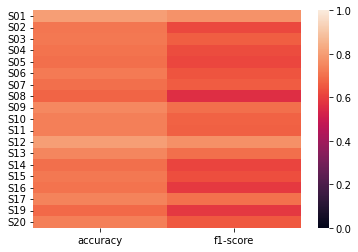

     class0 f1-score  class1 f1-score
S01         0.870968         0.567568
S02         0.827338         0.172414
S03         0.822695         0.285714
S04         0.820847         0.179104
S05         0.817518         0.137931
S06         0.831615         0.169492
S07         0.802867         0.337349
S08         0.805195         0.032258
S09         0.845902         0.338028
S10         0.835526         0.305556
S11         0.836364         0.237288
S12         0.872727         0.545455
S13         0.842105         0.383562
S14         0.814815         0.153846
S15         0.827815         0.187500
S16         0.825806         0.035714
S17         0.835249         0.394366
S19         0.809211         0.093750
S20         0.838926         0.225806


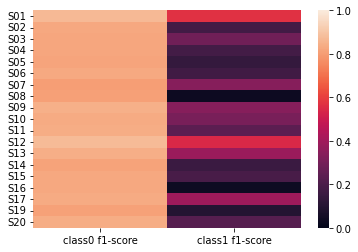

In [7]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [9]:
input_dim

(32, 188)